lightGBMをクロスバリデーションで使う。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold

###訓練データの読み込み
house_age = pd.read_csv('house_age.csv')
area_size = pd.read_csv('area_size.csv')
room_arrange = pd.read_csv('room_arrange.csv')
contract_span = pd.read_csv('contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('reg_rent.csv')
floor_scores = pd.read_csv('floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('stations.csv')
minits = pd.read_csv('minits.csv')
addresses = pd.read_csv('addresses.csv')
room_arrange = pd.read_csv('room_arrange.csv')
buildings = pd.read_csv('buildings.csv')

rent = pd.read_csv('rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('test_house_age.csv')
test_area_size = pd.read_csv('test_area_size.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_contract_span = pd.read_csv('test_contract_span.csv')
test_contract_span2 = pd.read_csv('test_contract_span2.csv')
test_reg_rent = pd.read_csv('test_reg_rent.csv')
test_floor_scores = pd.read_csv('test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('test_capital_floor_scores2.csv')
test_stations = pd.read_csv('test_stations.csv')
test_minits = pd.read_csv('test_minits.csv')
test_addresses = pd.read_csv('test_addresses.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_buildings = pd.read_csv('test_buildings.csv')

Duplicate key in file PosixPath('/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family : IPAexGothic')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: 'house_age.csv'

契約期間２&フル間取りでlightGBMを交差検証で学習

In [4]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K","S"]]], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K','S']

cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 4.430375245218262e-06,
        'max_bin': 502,
        'num_leaves': 97
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=3000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)


c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49657.6	valid_1's rmse: 52813.6
[20]	training's rmse: 35224.3	valid_1's rmse: 40947.7
[30]	training's rmse: 26528.4	valid_1's rmse: 34430
[40]	training's rmse: 20917.7	valid_1's rmse: 30626.8
[50]	training's rmse: 17662.1	valid_1's rmse: 28492
[60]	training's rmse: 15621.9	valid_1's rmse: 27248.4
[70]	training's rmse: 14228.8	valid_1's rmse: 26415.5
[80]	training's rmse: 13233.4	valid_1's rmse: 25887.3
[90]	training's rmse: 12528	valid_1's rmse: 25533.7
[100]	training's rmse: 11953.6	valid_1's rmse

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50762.6	valid_1's rmse: 52740.7
[20]	training's rmse: 36709	valid_1's rmse: 38947.9
[30]	training's rmse: 28601.6	valid_1's rmse: 30963.8
[40]	training's rmse: 23424	valid_1's rmse: 25582.8
[50]	training's rmse: 20450.5	valid_1's rmse: 22659.3
[60]	training's rmse: 18655.4	valid_1's rmse: 21037.3
[70]	training's rmse: 17413.4	valid_1's rmse: 20185.1
[80]	training's rmse: 16555.1	valid_1's rmse: 19532.9
[90]	training's rmse: 15916.2	valid_1's rmse: 19171
[100]	training's rmse: 15398.3	valid_1's rmse: 19010.4
[110]	training's rmse: 14934.2	valid_1's rmse: 18885.2

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50989.7	valid_1's rmse: 49508.7
[20]	training's rmse: 37101.5	valid_1's rmse: 35659.2
[30]	training's rmse: 28806.8	valid_1's rmse: 27858.5
[40]	training's rmse: 23636.8	valid_1's rmse: 23225.2
[50]	training's rmse: 20340.1	valid_1's rmse: 20599.3
[60]	training's rmse: 18399.3	valid_1's rmse: 19186.4
[70]	training's rmse: 17281.5	valid_1's rmse: 18326.7
[80]	training's rmse: 16479.3	valid_1's rmse: 17848.3
[90]	training's rmse: 15889.1	valid_1's rmse: 17591.3
[100]	training's rmse: 15377.5	valid_1's rmse: 17393.4
[110]	training's rmse: 14956.1	valid_1's rmse: 17288.7
[120]	training's rmse: 14541.2	valid_1's rmse: 17139.4
[130]	training's rmse: 14201.7	valid_1's rmse: 17053.7
[140]	training's rmse: 13862.5	valid_1's rmse: 16927.5
[150]	training's rmse: 13582.1	valid_1's rmse: 16857.1
[160]	training's rmse: 13294.5	valid_1's rmse: 16752.2
[170]	training's rmse: 13068.1	valid_1's rmse: 16702.2
[180]	trainin

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51159.8	valid_1's rmse: 48731.6
[20]	training's rmse: 36571.1	valid_1's rmse: 36230.8
[30]	training's rmse: 28260.9	valid_1's rmse: 29367
[40]	training's rmse: 23010.5	valid_1's rmse: 25081.9
[50]	training's rmse: 19900	valid_1's rmse: 22718.8
[60]	training's rmse: 18110.7	valid_1's rmse: 21463.2
[70]	training's rmse: 16994.4	valid_1's rmse: 20811.2
[80]	training's rmse: 16207.4	valid_1's rmse: 20294.7
[90]	training's rmse: 15575.1	valid_1's rmse: 19937.1
[100]	training's rmse: 15058.4	valid_1's rmse: 19722.3
[110]	training's rmse: 14598	valid_1's rmse: 19506.6

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50459.8	valid_1's rmse: 53260.6
[20]	training's rmse: 36747.8	valid_1's rmse: 39511.5
[30]	training's rmse: 28663.5	valid_1's rmse: 31435.9
[40]	training's rmse: 23364.1	valid_1's rmse: 26253.4
[50]	training's rmse: 20247.6	valid_1's rmse: 23238
[60]	training's rmse: 18230.5	valid_1's rmse: 21535.5
[70]	training's rmse: 16977.7	valid_1's rmse: 20614.6
[80]	training's rmse: 16148.3	valid_1's rmse: 19946.2
[90]	training's rmse: 15563.7	valid_1's rmse: 19564.7
[100]	training's rmse: 15082.7	valid_1's 

importance
面積     5.145099e+14
L      3.937205e+14
最寄り駅   1.515174e+14
築年数    8.489218e+13
全体の階数  8.239505e+13
所在地    7.270106e+13
所要時間   1.788143e+13
所在階    1.212840e+13
契約期間   9.641986e+12
部屋数    4.232639e+12
定期借家   2.616056e+12
D      4.221188e+11
S      2.772056e+11
K      5.869058e+10

単純なホールドアウトに比べて大幅に過学習が緩和されている。

In [130]:
y_pred = pd.DataFrame(y_pred)
y_pred.head()

0
0  126738.873820
1  124911.309729
2   71940.713020
3   60660.678043
4  111238.835082

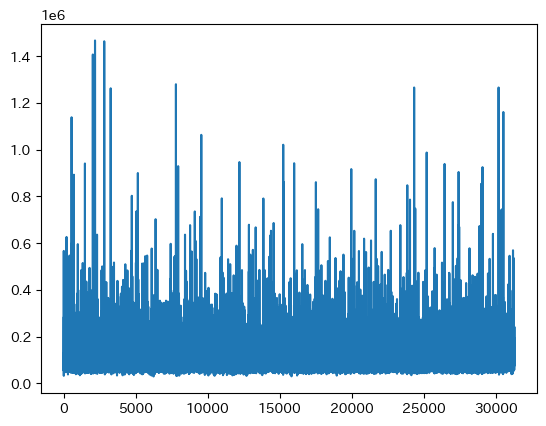

In [58]:
plt.plot(y_pred)

パラメータチューニングを行う。

In [128]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K",'S']]], axis=1)
y_train = rent
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K","S"]]], axis=1)
category_lists = ['定期借家', '最寄り駅', '所在地', 'L', 'D', 'K', 'S']

lcv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=3000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [129]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)
study.best_params

[I 2022-09-10 23:09:02,059] A new study created in memory with name: no-name-f94ae760-a6c1-43b9-a6c4-a38605e196b2
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49657.6	valid_1's rmse: 52813.6
[20]	training's rmse: 35224.3	valid_1's rmse: 40947.7
[30]	training's rmse: 26528.4	valid_1's rmse: 34430
[40]	training's rmse: 20917.7	valid_1's rmse: 30626.8
[50]	training's rmse: 17662.1	valid_1's rmse: 28492
[60]	training's rmse: 15621.9	valid_1's rmse: 27248.4
[70]	training's rmse: 14228.8	valid_1's rmse: 26415.5
[80]	training's rmse: 13233.4	valid_1's rmse: 25887.3
[90]	training's rmse: 12528	valid_1's rmse: 25533.7
[100]	training's rmse: 11953.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50762.6	valid_1's rmse: 52740.7
[20]	training's rmse: 36709	valid_1's rmse: 38947.9
[30]	training's rmse: 28601.6	valid_1's rmse: 30963.8
[40]	training's rmse: 23424	valid_1's rmse: 25582.8
[50]	training's rmse: 20450.5	valid_1's rmse: 22659.3
[60]	training's rmse: 18655.4	valid_1's rmse: 21037.3
[70]	training's rmse: 17413.4	valid_1's rmse: 20185.1
[80]	training's rmse: 16555.1	valid_1's rmse: 19532.9
[90]	training's rmse: 15916.2	valid_1's rmse: 19171
[100]	training's rmse: 15398.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28806.8	valid_1's rmse: 27858.5
[40]	training's rmse: 23636.8	valid_1's rmse: 23225.2
[50]	training's rmse: 20340.1	valid_1's rmse: 20599.3
[60]	training's rmse: 18399.3	valid_1's rmse: 19186.4
[70]	training's rmse: 17281.5	valid_1's rmse: 18326.7
[80]	training's rmse: 16479.3	valid_1's rmse: 17848.3
[90]	training's rmse: 15889.1	valid_1's rmse: 17591.3
[100]	training's rmse: 15377.5	valid_1's rmse: 17393.4
[110]	training's rmse: 14956.1	valid_1's rmse: 17288.7
[120]	training's rmse: 14541.2	valid_1's rmse: 17139.4
[130]	training's rmse: 14201.7	valid_1's rmse: 17053.7
[140]	training's rmse: 13862.5	valid_1's rmse: 16927.5
[150]	training's rmse: 13582.1	valid_1's rmse: 16857.1
[160]	training's rmse: 13294.5	valid_1's rmse: 16752.2
[170]	training's rmse: 13068.1	valid_1's rmse: 16702.2
[180]	training's rmse: 12827.4	valid_1's rmse: 16620.2
[190]	training's rmse: 12595.8	valid_1's rmse: 16549.3
[200]	training's rmse: 12384.3	valid_1's rmse: 16462.7
[210]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51159.8	valid_1's rmse: 48731.6
[20]	training's rmse: 36571.1	valid_1's rmse: 36230.8
[30]	training's rmse: 28260.9	valid_1's rmse: 29367
[40]	training's rmse: 23010.5	valid_1's rmse: 25081.9
[50]	training's rmse: 19900	valid_1's rmse: 22718.8
[60]	training's rmse: 18110.7	valid_1's rmse: 21463.2
[70]	training's rmse: 16994.4	valid_1's rmse: 20811.2
[80]	training's rmse: 16207.4	valid_1's rmse: 20294.7
[90]	training's rmse: 15575.1	valid_1's rmse: 19937.1
[100]	training's rmse: 15058.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36747.8	valid_1's rmse: 39511.5
[30]	training's rmse: 28663.5	valid_1's rmse: 31435.9
[40]	training's rmse: 23364.1	valid_1's rmse: 26253.4
[50]	training's rmse: 20247.6	valid_1's rmse: 23238
[60]	training's rmse: 18230.5	valid_1's rmse: 21535.5
[70]	training's rmse: 16977.7	valid_1's rmse: 20614.6
[80]	training's rmse: 16148.3	valid_1's rmse: 19946.2
[90]	training's rmse: 15563.7	valid_1's rmse: 19564.7
[100]	training's rmse: 15082.7	valid_1's rmse: 19338.8
[110]	training's rmse: 14660.6	valid_1's rmse: 19096.5
[120]	training's rmse: 14308.7	valid_1's rmse: 18959.2
[130]	training's rmse: 13984.9	valid_1's rmse: 18822.7
[140]	training's rmse: 13702	valid_1's rmse: 18733.7
[150]	training's rmse: 13448.2	valid_1's rmse: 18657.5
[160]	training's rmse: 13175.4	valid_1's rmse: 18513
[170]	training's rmse: 12940	valid_1's rmse: 18432.3
[180]	training's rmse: 12730.5	valid_1's rmse: 18350.6
[190]	training's rmse: 12544.5	valid_1's rmse: 18295.3
[200]	training's rmse: 123

[I 2022-09-10 23:09:14,838] Trial 0 finished with value: 17658.247855708043 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2113
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49837.6	valid_1's rmse: 52848
[20]	training's rmse: 35263.4	valid_1's rmse: 40946.6
[30]	training's rmse: 26730.8	valid_1's rmse: 34601.9
[40]	training's rmse: 20884.2	valid_1's rmse: 30738.3
[50]	training's rmse: 17572.6	valid_1's rmse: 28605.5
[60]	training's rmse: 15523	valid_1's rmse: 27345.8
[70]	training's rmse: 14155.9	valid_1's rmse: 26531.9
[80]	training's rmse: 13197	valid_1's rmse: 25961.7
[90]	training's rmse: 12501.1	valid_1's rmse: 25590.7
[100]	training's rmse: 11963.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50261.1	valid_1's rmse: 51960.1
[20]	training's rmse: 36170.1	valid_1's rmse: 38358.4
[30]	training's rmse: 27969	valid_1's rmse: 30573.8
[40]	training's rmse: 22979.3	valid_1's rmse: 25619.9
[50]	training's rmse: 20031.5	valid_1's rmse: 22914.2
[60]	training's rmse: 18226.2	valid_1's rmse: 21498.6
[70]	training's rmse: 16958.8	valid_1's rmse: 20604
[80]	training's rmse: 16010.5	valid_1's rmse: 20072.4
[90]	training's rmse: 15306.7	valid_1's rmse: 19767.8
[100]	training's rmse: 14722.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50786.4	valid_1's rmse: 49803.5
[20]	training's rmse: 36805.5	valid_1's rmse: 36453.9
[30]	training's rmse: 28595.6	valid_1's rmse: 28897.7
[40]	training's rmse: 23363.8	valid_1's rmse: 24207.1
[50]	training's rmse: 20295	valid_1's rmse: 21603.4
[60]	training's rmse: 18344	valid_1's rmse: 20055.4
[70]	training's rmse: 17167.8	valid_1's rmse: 19252.2
[80]	training's rmse: 16342.8	valid_1's rmse: 18854.3
[90]	training's rmse: 15722.1	valid_1's rmse: 18609
[100]	training's rmse: 15161.6	valid_1's rmse: 18393
[110]	training's rmse: 14710.1	valid_1's rmse: 18222.2
[120]	training's rmse: 14288.7	valid_1's rmse: 18102.5
[130]	training's rmse: 13945.2	valid_1's rmse: 18030.1
[140]	training's rmse: 13612.7	valid_1's rmse: 17989.3
[150]	training's rmse: 13295.8	valid_1's rmse: 17962.3
[160]	training's rmse: 13021.6	valid_1's rmse: 17922.8
[170]	training's rmse: 12758.8	valid_1's rmse: 17890.9
[180]	training's rmse: 12527.8	valid_1's rmse: 17859.6
[190]	training's rmse: 1230

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36561.6	valid_1's rmse: 35780
[30]	training's rmse: 28232.9	valid_1's rmse: 28821.9
[40]	training's rmse: 22910.9	valid_1's rmse: 24349
[50]	training's rmse: 19829.9	valid_1's rmse: 21849.7
[60]	training's rmse: 17997.5	valid_1's rmse: 20551
[70]	training's rmse: 16798.2	valid_1's rmse: 19826.8
[80]	training's rmse: 15934.4	valid_1's rmse: 19352.9
[90]	training's rmse: 15289.2	valid_1's rmse: 19047.8
[100]	training's rmse: 14764.3	valid_1's rmse: 18778.9
[110]	training's rmse: 14363.6	valid_1's rmse: 18593.8
[120]	training's rmse: 14006.4	valid_1's rmse: 18468.6
[130]	training's rmse: 13648.2	valid_1's rmse: 18343.9
[140]	training's rmse: 13296.8	valid_1's rmse: 18189.2
[150]	training's rmse: 13021.5	valid_1's rmse: 18145.3
[160]	training's rmse: 12743	valid_1's rmse: 18088
[170]	training's rmse: 12498	valid_1's rmse: 18002.5
[180]	training's rmse: 12255.7	valid_1's rmse: 17964.6
[190]	training's rmse: 12004.3	valid_1's rmse: 17927.6
[200]	training's rmse: 11797.1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2111
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50208.1	valid_1's rmse: 53368.3
[20]	training's rmse: 36507.2	valid_1's rmse: 39801.2
[30]	training's rmse: 28469.1	valid_1's rmse: 31701.1
[40]	training's rmse: 23198.2	valid_1's rmse: 26770.5
[50]	training's rmse: 20056.1	valid_1's rmse: 23958.7
[60]	training's rmse: 18131.7	valid_1's rmse: 22428.9
[70]	training's rmse: 16851.1	valid_1's rmse: 21535.8
[80]	training's rmse: 15956.8	valid_1's rmse: 20830.2
[90]	training's rmse: 15343.5	valid_1's rmse: 20402.5
[100]	training's rmse: 14827.3	valid_1'

[I 2022-09-10 23:09:27,407] Trial 1 finished with value: 18991.437780684704 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49595.3	valid_1's rmse: 52710.7
[20]	training's rmse: 35016.2	valid_1's rmse: 41108.7
[30]	training's rmse: 26045.7	valid_1's rmse: 34484.5
[40]	training's rmse: 20350.8	valid_1's rmse: 30663.8
[50]	training's rmse: 17017.4	valid_1's rmse: 28550.5
[60]	training's rmse: 14999	valid_1's rmse: 27295.2
[70]	training's rmse: 13598.6	valid_1's rmse: 26411.9
[80]	training's rmse: 12621.7	valid_1's rmse: 25829.5
[90]	training's rmse: 11941.7	valid_1's rmse: 25416.7
[100]	training's rmse: 11414.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50336.3	valid_1's rmse: 51925.6
[20]	training's rmse: 36116.4	valid_1's rmse: 38286.8
[30]	training's rmse: 27905.8	valid_1's rmse: 30322.4
[40]	training's rmse: 22774.3	valid_1's rmse: 25131.2
[50]	training's rmse: 19790.5	valid_1's rmse: 22213.3
[60]	training's rmse: 18016.3	valid_1's rmse: 20550.6
[70]	training's rmse: 16813.9	valid_1's rmse: 19614.7
[80]	training's rmse: 15928	valid_1's rmse: 19019.6
[90]	training's rmse: 15272.6	valid_1's rmse: 18684.3
[100]	training's rmse: 14730.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2467
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50430.1	valid_1's rmse: 49526.9
[20]	training's rmse: 36384.5	valid_1's rmse: 35953.7
[30]	training's rmse: 28033.1	valid_1's rmse: 28426.9
[40]	training's rmse: 22721.2	valid_1's rmse: 23657.2
[50]	training's rmse: 19518.7	valid_1's rmse: 21122.5
[60]	training's rmse: 17582.4	valid_1's rmse: 19795.3
[70]	training's rmse: 16445.3	valid_1's rmse: 18900.1
[80]	training's rmse: 15617.8	valid_1's rmse: 18511.1
[90]	training's rmse: 15004.5	valid_1's rmse: 18197
[100]	training's rmse: 14533.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50817.9	valid_1's rmse: 48608.5
[20]	training's rmse: 36204.1	valid_1's rmse: 35881.2
[30]	training's rmse: 27743	valid_1's rmse: 28961.1
[40]	training's rmse: 22429.7	valid_1's rmse: 24608.1
[50]	training's rmse: 19287.1	valid_1's rmse: 22238.1
[60]	training's rmse: 17551.6	valid_1's rmse: 21021
[70]	training's rmse: 16441.7	valid_1's rmse: 20343.9
[80]	training's rmse: 15635.8	valid_1's rmse: 19854.2
[90]	training's rmse: 15036.6	valid_1's rmse: 19530.5
[100]	training's rmse: 14588.4	valid_1's rmse: 19281.5
[110]	training's rmse: 14232.8	valid_1's rmse: 19150.8
[120]	training's rmse: 13826.4	valid_1's rmse: 19019
[130]	training's rmse: 13511.4	valid_1's rmse: 18954.5
[140]	training's rmse: 13156	valid_1's rmse: 18891.2
[150]	training's rmse: 12857.9	valid_1's rmse: 18811.7
[160]	training's rmse: 12616.2	valid_1's rmse: 18789.7
[170]	training's rmse: 12378.4	valid_1's rmse: 18711.3
[180]	training's rmse: 12167.2	valid_1's rmse: 18640.8
[190]	training's rmse: 1198

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2467
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50249.3	valid_1's rmse: 53048.4
[20]	training's rmse: 36445.2	valid_1's rmse: 39178.9
[30]	training's rmse: 28279.9	valid_1's rmse: 31103.1
[40]	training's rmse: 23035.6	valid_1's rmse: 26079
[50]	training's rmse: 19831.4	valid_1's rmse: 23211.8
[60]	training's rmse: 17873.9	valid_1's rmse: 21703.7
[70]	training's rmse: 16598.5	valid_1's rmse: 20878.5
[80]	training's rmse: 15793.2	valid_1's rmse: 20507.1
[90]	training's rmse: 15183.1	valid_1's rmse: 20276.1
[100]	training's rmse: 14715.7	valid_1's 

[I 2022-09-10 23:09:42,007] Trial 2 finished with value: 19790.467816267374 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 17658.247855708043.


[200]	training's rmse: 12176.2	valid_1's rmse: 19802.8
Early stopping, best iteration is:
[196]	training's rmse: 12245.7	valid_1's rmse: 19790.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49861.3	valid_1's rmse: 52937.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 35343	valid_1's rmse: 41346.6
[30]	training's rmse: 26744.6	valid_1's rmse: 34920.2
[40]	training's rmse: 20950.8	valid_1's rmse: 31030.3
[50]	training's rmse: 17589.6	valid_1's rmse: 28870.3
[60]	training's rmse: 15505.8	valid_1's rmse: 27620
[70]	training's rmse: 14055.1	valid_1's rmse: 26765.7
[80]	training's rmse: 13112.2	valid_1's rmse: 26303.5
[90]	training's rmse: 12421.3	valid_1's rmse: 25897.5
[100]	training's rmse: 11862.7	valid_1's rmse: 25589.6
[110]	training's rmse: 11404.2	valid_1's rmse: 25342.3
[120]	training's rmse: 11013.6	valid_1's rmse: 25095.3
[130]	training's rmse: 10651.7	valid_1's rmse: 24887
[140]	training's rmse: 10364.2	valid_1's rmse: 24725.2
[150]	training's rmse: 10064.7	valid_1's rmse: 24544.6
[160]	training's rmse: 9800.47	valid_1's rmse: 24381.7
[170]	training's rmse: 9509.82	valid_1's rmse: 24206.6
[180]	training's rmse: 9252.58	valid_1's rmse: 24055.1
[190]	training's rmse: 9025.26	valid_1's rmse: 23927.9
[200]	training's rmse: 8

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50698.7	valid_1's rmse: 52669.8
[20]	training's rmse: 36485.7	valid_1's rmse: 38767.6
[30]	training's rmse: 28419.3	valid_1's rmse: 30761.9
[40]	training's rmse: 23366.9	valid_1's rmse: 25606.6
[50]	training's rmse: 20440.6	valid_1's rmse: 22480.5
[60]	training's rmse: 18665.3	valid_1's rmse: 21001.1
[70]	training's rmse: 17451.9	valid_1's rmse: 20015.9
[80]	training's rmse: 16556.6	valid_1's rmse: 19344.8
[90]	training's rmse: 15924.6	valid_1's rmse: 18980.4
[100]	training's rmse: 15384.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28769.1	valid_1's rmse: 28641.2
[40]	training's rmse: 23566.9	valid_1's rmse: 23907.7
[50]	training's rmse: 20344.8	valid_1's rmse: 21160.4
[60]	training's rmse: 18407.1	valid_1's rmse: 19707.9
[70]	training's rmse: 17191.6	valid_1's rmse: 18684.5
[80]	training's rmse: 16312.7	valid_1's rmse: 18162.5
[90]	training's rmse: 15692.7	valid_1's rmse: 17877
[100]	training's rmse: 15200.4	valid_1's rmse: 17706.1
[110]	training's rmse: 14803.4	valid_1's rmse: 17575
[120]	training's rmse: 14453.4	valid_1's rmse: 17470.8
[130]	training's rmse: 14128.8	valid_1's rmse: 17402.7
[140]	training's rmse: 13777.1	valid_1's rmse: 17338.3
[150]	training's rmse: 13475.8	valid_1's rmse: 17289
[160]	training's rmse: 13218.2	valid_1's rmse: 17243.3
[170]	training's rmse: 12975.9	valid_1's rmse: 17148.3
[180]	training's rmse: 12748.3	valid_1's rmse: 17103.3
[190]	training's rmse: 12509.3	valid_1's rmse: 17124.9
Early stopping, best iteration is:
[184]	training's rmse: 12670.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36651.6	valid_1's rmse: 36229.3
[30]	training's rmse: 28367.6	valid_1's rmse: 29434.3
[40]	training's rmse: 23029	valid_1's rmse: 24968.7
[50]	training's rmse: 19940.6	valid_1's rmse: 22484.6
[60]	training's rmse: 18145.5	valid_1's rmse: 21214.7
[70]	training's rmse: 17005.4	valid_1's rmse: 20454.7
[80]	training's rmse: 16190.1	valid_1's rmse: 19891.2
[90]	training's rmse: 15507.1	valid_1's rmse: 19493.4
[100]	training's rmse: 14868.7	valid_1's rmse: 19211.8
[110]	training's rmse: 14424.6	valid_1's rmse: 18982
[120]	training's rmse: 13995.8	valid_1's rmse: 18835.6
[130]	training's rmse: 13670.8	valid_1's rmse: 18730.2
[140]	training's rmse: 13354.4	valid_1's rmse: 18644.9
[150]	training's rmse: 13074.1	valid_1's rmse: 18593.1
[160]	training's rmse: 12815.9	valid_1's rmse: 18563.1
[170]	training's rmse: 12593.1	valid_1's rmse: 18535.6
[180]	training's rmse: 12348.5	valid_1's rmse: 18494
[190]	training's rmse: 12120.9	valid_1's rmse: 18404.6
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50468.4	valid_1's rmse: 53210.3
[20]	training's rmse: 36787.1	valid_1's rmse: 39491.1
[30]	training's rmse: 28652	valid_1's rmse: 31328.7
[40]	training's rmse: 23238.1	valid_1's rmse: 26163.1
[50]	training's rmse: 20162.7	valid_1's rmse: 23236.5
[60]	training's rmse: 18179.8	valid_1's rmse: 21756.5
[70]	training's rmse: 16937.4	valid_1's rmse: 20921
[80]	training's rmse: 16107.7	valid_1's rmse: 20388.3
[90]	training's rmse: 15513.1	valid_1's rmse: 20072.8
[100]	training's rmse: 15051.8	valid_1's rm

[I 2022-09-10 23:09:54,515] Trial 3 finished with value: 19479.789435273535 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 17658.247855708043.


Early stopping, best iteration is:
[149]	training's rmse: 13435.6	valid_1's rmse: 19479.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2493
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50304.5	valid_1's rmse: 53229
[20]	training's rmse: 36076.3	valid_1's rmse: 41762.8
[30]	training's rmse: 27614.3	valid_1's rmse: 35434.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[40]	training's rmse: 21826.1	valid_1's rmse: 31416.6
[50]	training's rmse: 18500.6	valid_1's rmse: 29145.3
[60]	training's rmse: 16389.2	valid_1's rmse: 27737.3
[70]	training's rmse: 15012.5	valid_1's rmse: 26921.7
[80]	training's rmse: 14086.4	valid_1's rmse: 26424.1
[90]	training's rmse: 13371.8	valid_1's rmse: 26037
[100]	training's rmse: 12793	valid_1's rmse: 25665.4
[110]	training's rmse: 12335.7	valid_1's rmse: 25361.4
[120]	training's rmse: 11942.8	valid_1's rmse: 25109.5
[130]	training's rmse: 11576.4	valid_1's rmse: 24854.4
[140]	training's rmse: 11260.6	valid_1's rmse: 24666.7
[150]	training's rmse: 10918.6	valid_1's rmse: 24431.8
[160]	training's rmse: 10631.4	valid_1's rmse: 24242.7
[170]	training's rmse: 10377.9	valid_1's rmse: 24069.8
[180]	training's rmse: 10147.6	valid_1's rmse: 23915.3
[190]	training's rmse: 9938.82	valid_1's rmse: 23779.4
[200]	training's rmse: 9739.2	valid_1's rmse: 23656.7
[210]	training's rmse: 9560.91	valid_1's rmse: 23542.4
[220]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51098.9	valid_1's rmse: 52684
[20]	training's rmse: 37131	valid_1's rmse: 38836.7
[30]	training's rmse: 29067.6	valid_1's rmse: 30850.4
[40]	training's rmse: 23923.8	valid_1's rmse: 25469.5
[50]	training's rmse: 20995.6	valid_1's rmse: 22612
[60]	training's rmse: 19093.6	valid_1's rmse: 20781.7
[70]	training's rmse: 17865	valid_1's rmse: 19752
[80]	training's rmse: 16935.8	valid_1's rmse: 18970.6
[90]	training's rmse: 16243.3	valid_1's rmse: 18519.4
[100]	training's rmse: 15715.8	valid_1's rmse: 18285.4
[110]	training's rmse: 15272.8	valid_1's rmse: 18120.4
[120]	training's rmse: 14863.5	valid_1's rmse: 18066.5
[130]	training's rmse: 14522.3	valid_1's rmse: 18063.6
Early stopping, best iteration is:
[126]	training's rmse: 14655.7	valid_1's rmse: 18054.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0011

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51122.7	valid_1's rmse: 50037.3
[20]	training's rmse: 37244.6	valid_1's rmse: 36639.3
[30]	training's rmse: 29054.6	valid_1's rmse: 28939.3
[40]	training's rmse: 23829.6	valid_1's rmse: 24311.2
[50]	training's rmse: 20749.5	valid_1's rmse: 21712
[60]	training's rmse: 18844.8	valid_1's rmse: 20233.5
[70]	training's rmse: 17656.3	valid_1's rmse: 19296.9
[80]	training's rmse: 16815	valid_1's rmse: 18745.5
[90]	training's rmse: 16200.4	valid_1's rmse: 18460.5
[100]	training's rmse: 15709.7	valid_1's rmse: 18257.4
[110]	training's rmse: 15314.1	valid_1's rmse: 18119.3
[120]	training's rmse: 14945.3	valid_1's rmse: 18004.7
[130]	training's rmse: 14629.1	valid_1's rmse: 17925.8
[140]	training's rmse: 14311.5	valid_1's rmse: 17894.8
[150]	training's rmse: 14015	valid_1's rmse: 17896.5
Early stopping, best iteration is:
[140]	training's rmse: 14311.5	valid_1's rmse: 17894.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2495
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51495.4	valid_1's rmse: 49176.9
[20]	training's rmse: 37284.3	valid_1's rmse: 37026.2
[30]	training's rmse: 29133.6	valid_1's rmse: 30400.5
[40]	training's rmse: 23691.3	valid_1's rmse: 25825.6
[50]	training's rmse: 20626.9	valid_1's rmse: 23223.4
[60]	training's rmse: 18829	valid_1's rmse: 21840.1
[70]	training's rmse: 17643.9	valid_1's rmse: 20935.8
[80]	training's rmse: 16804.8	valid_1's rmse: 20342
[90]	training's rmse: 16146.3	valid_1's rmse: 19955.7
[100]	training's rmse: 15646.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2491
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50936.1	valid_1's rmse: 53662.8
[20]	training's rmse: 37288.5	valid_1's rmse: 39870.4
[30]	training's rmse: 29361.9	valid_1's rmse: 31771.7
[40]	training's rmse: 23946.7	valid_1's rmse: 26483.2
[50]	training's rmse: 20860.9	valid_1's rmse: 23556.4
[60]	training's rmse: 18891.2	valid_1's rmse: 21975.3
[70]	training's rmse: 17583.9	valid_1's rmse: 21092.4
[80]	training's rmse: 16757.9	valid_1's rmse: 20525.5
[90]	training's rmse: 16156.6	valid_1's rmse: 20222.8
[100]	training's rmse: 15676.7	valid_1'

[I 2022-09-10 23:10:03,812] Trial 4 finished with value: 19437.113998862755 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 17658.247855708043.


[260]	training's rmse: 12209	valid_1's rmse: 19455.8
[270]	training's rmse: 12084.3	valid_1's rmse: 19443.6
[280]	training's rmse: 11969.2	valid_1's rmse: 19441
Early stopping, best iteration is:
[271]	training's rmse: 12074.8	valid_1's rmse: 19437.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50030.7	valid_1's rmse: 53537.2
[20]	training's rmse: 35463.8	valid_1's rmse: 41941.6
[30]	training's rmse: 26759.5	valid_1's rmse: 35343.8
[40]	training's rmse: 21195.3	valid_1's rmse: 31533
[50]	training's rmse: 17845.1	valid_1's rmse: 29275.1
[60]	training's rmse: 15772.4	valid_1's rmse: 27904.6
[70]	training's rmse: 14227.3	valid_1's rmse: 27016.5
[80]	training's rmse: 13204	valid_1's rmse: 26468.5
[90]	training's rmse: 12447.4	valid_1's rmse: 26077.6
[100]	training's rmse: 11844.4	valid_1's rmse: 25721
[110]	training's rmse: 11307.9	valid_1's rmse: 25428.6
[120]	training's rmse: 10845	valid_1's rmse: 25180.2
[130]	training's rmse: 10431.9	valid_1's rmse: 24978.6
[140]	training's rmse: 10038.1	valid_1's rmse: 24793.2
[150]	training's rmse: 9672.71	valid_1's rmse: 24616.2
[160]	training's rmse: 9355.88	valid_1's rmse: 24465.8
[170]	training's rmse: 9092.41	valid_1's rmse: 24335.6
[180]	training's rmse: 8862.44	valid_1's rmse: 24213.9
[190]	training's rmse: 8632

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50579.9	valid_1's rmse: 51789.5
[20]	training's rmse: 36412.3	valid_1's rmse: 38080.5
[30]	training's rmse: 28251.9	valid_1's rmse: 30205.1
[40]	training's rmse: 23190.7	valid_1's rmse: 25098.6
[50]	training's rmse: 20199.5	valid_1's rmse: 22084.6
[60]	training's rmse: 18235.9	valid_1's rmse: 20408.3
[70]	training's rmse: 16876	valid_1's rmse: 19448.3
[80]	training's rmse: 15962.6	valid_1's rmse: 18864.8
[90]	training's rmse: 15252.9	valid_1's rmse: 18499.8
[100]	training's rmse: 14707.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50682.1	valid_1's rmse: 50302.7
[20]	training's rmse: 36553.8	valid_1's rmse: 36634.9
[30]	training's rmse: 28335.1	valid_1's rmse: 29065.8
[40]	training's rmse: 23134.3	valid_1's rmse: 24382.2
[50]	training's rmse: 19932.7	valid_1's rmse: 21680.2
[60]	training's rmse: 18015.7	valid_1's rmse: 20197.9
[70]	training's rmse: 16751.3	valid_1's rmse: 19326.7
[80]	training's rmse: 15860.1	valid_1's rmse: 18930
[90]	training's rmse: 15137.6	valid_1's rmse: 18610
[100]	training's rmse: 14571.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51094.6	valid_1's rmse: 48536
[20]	training's rmse: 36529.9	valid_1's rmse: 36098.2
[30]	training's rmse: 28063.4	valid_1's rmse: 29259.3
[40]	training's rmse: 22806.7	valid_1's rmse: 25044.6
[50]	training's rmse: 19779.7	valid_1's rmse: 22701.7
[60]	training's rmse: 17907.2	valid_1's rmse: 21529.2
[70]	training's rmse: 16649.1	valid_1's rmse: 20874
[80]	training's rmse: 15705.7	valid_1's rmse: 20357
[90]	training's rmse: 15025.5	valid_1's rmse: 20043.1
[100]	training's rmse: 14466.9	valid_1's rmse: 19834.6
[110]	training's rmse: 13996.1	valid_1's rmse: 19715.4
[120]	training's rmse: 13582.9	valid_1's rmse: 19637.4
[130]	training's rmse: 13216.8	valid_1's rmse: 19491.5
[140]	training's rmse: 12900.5	valid_1's rmse: 19379.8
[150]	training's rmse: 12598	valid_1's rmse: 19264.1
[160]	training's rmse: 12305.6	valid_1's rmse: 19225.1
[170]	training's rmse: 12028.6	valid_1's rmse: 19173.1
[180]	training's rmse: 11769.9	valid_1's rmse: 19158.1
[190]	training's rmse: 1155

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50323.1	valid_1's rmse: 53177.8
[20]	training's rmse: 36789.1	valid_1's rmse: 39576.7
[30]	training's rmse: 28592.5	valid_1's rmse: 31259.9
[40]	training's rmse: 23216	valid_1's rmse: 26136.8
[50]	training's rmse: 20061.1	valid_1's rmse: 23431.2
[60]	training's rmse: 18108.3	valid_1's rmse: 22121.2
[70]	training's rmse: 16803.3	valid_1's rmse: 21364.7
[80]	training's rmse: 15874.4	valid_1's rmse: 20893.2
[90]	training's rmse: 15208.1	valid_1's rmse: 20559.2
[100]	training's rmse: 14660.1	valid_1's rmse: 20308.3
[110]	training's rmse: 14200.7	valid_1's rmse: 20130.5
[120]	training's rmse: 13814.9	valid_1's rmse: 20015.5
[130]	training's rmse: 13444	valid_1's rmse: 19898.8
[140]	training's rmse: 13113.9	valid_1's rmse: 19803.3
[150]	training's rmse: 12799.5	valid_1's rmse: 19647.6
[160]	training's rmse: 12512.4	valid_1's rmse: 19593.1
[170]	training's rmse: 12233.5	valid_1's rmse: 19517.7
[180]	training's rmse: 12009.8	valid_1's rmse: 19429.1
[190]	training's rmse: 

[I 2022-09-10 23:10:18,992] Trial 5 finished with value: 18606.450550911773 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49686	valid_1's rmse: 52710.9
[20]	training's rmse: 35070.5	valid_1's rmse: 40964.6
[30]	training's rmse: 26199.9	valid_1's rmse: 34439.3
[40]	training's rmse: 20495.2	valid_1's rmse: 30647.2
[50]	training's rmse: 17125.9	valid_1's rmse: 28540.1
[60]	training's rmse: 15124	valid_1's rmse: 27317.5
[70]	training's rmse: 13697.3	valid_1's rmse: 26480.7
[80]	training's rmse: 12696.5	valid_1's rmse: 25939.4
[90]	training's rmse: 11991.1	valid_1's rmse: 25523.4
[100]	training's rmse: 11452.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50351.3	valid_1's rmse: 51904.4
[20]	training's rmse: 36080.9	valid_1's rmse: 38131
[30]	training's rmse: 27844.9	valid_1's rmse: 30251.4
[40]	training's rmse: 22723.6	valid_1's rmse: 25089.4
[50]	training's rmse: 19869.6	valid_1's rmse: 22220.8
[60]	training's rmse: 18083.9	valid_1's rmse: 20718.6
[70]	training's rmse: 16903.6	valid_1's rmse: 19764.9
[80]	training's rmse: 16058.8	valid_1's rmse: 19167.5
[90]	training's rmse: 15424.3	valid_1's rmse: 18767.3
[100]	training's rmse: 14876.4	valid_1's rmse: 18526.1
[110]	training's rmse: 14390.1	valid_1's rmse: 184

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36584.5	valid_1's rmse: 35964.1
[30]	training's rmse: 28265.9	valid_1's rmse: 28390.2
[40]	training's rmse: 22808.8	valid_1's rmse: 23593.8
[50]	training's rmse: 19618.7	valid_1's rmse: 21062.2
[60]	training's rmse: 17678.1	valid_1's rmse: 19712.7
[70]	training's rmse: 16484.5	valid_1's rmse: 18842.3
[80]	training's rmse: 15674.3	valid_1's rmse: 18380.5
[90]	training's rmse: 15095.5	valid_1's rmse: 18096.7
[100]	training's rmse: 14636	valid_1's rmse: 17927.2
[110]	training's rmse: 14210.9	valid_1's rmse: 17781.2
[120]	training's rmse: 13789.3	valid_1's rmse: 17785.5
Early stopping, best iteration is:
[112]	training's rmse: 14113.1	valid_1's rmse: 17763.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50907.8	valid_1's rmse: 48747.1
[20]	training's rmse: 36210.9	valid_1's rmse: 35996.6
[30]	training's rmse: 27753.5	valid_1's rmse: 29061.8
[40]	training's rmse: 22460.1	valid_1's rmse: 24674.3
[50]	training's rmse: 19305.6	valid_1's rmse: 22233.7
[60]	training's rmse: 17621.1	valid_1's rmse: 21063.5
[70]	training's rmse: 16474	valid_1's rmse: 20343.8
[80]	training's rmse: 15673.9	valid_1's rmse: 19842.5
[90]	training's rmse: 15080	valid_1's rmse: 19518.5
[100]	training's rmse: 14627	valid_1's rmse: 19305.1
[110]	training's rmse: 14239.9	valid_1's rmse: 19165.8
[120]	training's rmse: 13842.1	valid_1's rmse: 19117
[130]	training's rmse: 13494.2	valid_1's rmse: 19030.3
[140]	training's rmse: 13186.2	valid_1's rmse: 18962.9
[150]	training's rmse: 12916.8	valid_1's rmse: 18888.9
[160]	training's rmse: 12654.8	valid_1's rmse: 18837.5
[170]	training's rmse: 12422.6	valid_1's rmse: 18789.1
[180]	training's rmse: 12194.9	valid_1's rmse: 18731.8
[190]	training's rmse: 1198

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2453
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50241.6	valid_1's rmse: 53045.5
[20]	training's rmse: 36468.7	valid_1's rmse: 39173.5
[30]	training's rmse: 28204.7	valid_1's rmse: 30866.4
[40]	training's rmse: 22956.8	valid_1's rmse: 25948.3
[50]	training's rmse: 19775.8	valid_1's rmse: 23183.9
[60]	training's rmse: 17816.6	valid_1's rmse: 21737.8
[70]	training's rmse: 16582.2	valid_1's rmse: 20986.6
[80]	training's rmse: 15757.8	valid_1's rmse: 20591.3
[90]	training's rmse: 15168	valid_1's rmse: 20316.2
[100]	training's rmse: 14676.2	valid_1's 

[I 2022-09-10 23:10:32,939] Trial 6 finished with value: 19834.45225664597 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2152
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49593.3	valid_1's rmse: 52622.7
[20]	training's rmse: 35020.9	valid_1's rmse: 40862.9
[30]	training's rmse: 26324.3	valid_1's rmse: 34378.7
[40]	training's rmse: 20669.4	valid_1's rmse: 30693.5
[50]	training's rmse: 17380.4	valid_1's rmse: 28635.2
[60]	training's rmse: 15378.3	valid_1's rmse: 27416.4
[70]	training's rmse: 13973	valid_1's rmse: 26576.8
[80]	training's rmse: 13009.6	valid_1's rmse: 25965.7
[90]	training's rmse: 12303.5	valid_1's rmse: 25556.5
[100]	training's rmse: 11713.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2151
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50172.2	valid_1's rmse: 51639.8
[20]	training's rmse: 36030.8	valid_1's rmse: 38036.8
[30]	training's rmse: 27921.2	valid_1's rmse: 30276.7
[40]	training's rmse: 22896.4	valid_1's rmse: 25359.9
[50]	training's rmse: 19946.3	valid_1's rmse: 22626.8
[60]	training's rmse: 18100.5	valid_1's rmse: 21162.1
[70]	training's rmse: 16874.6	valid_1's rmse: 20299
[80]	training's rmse: 15937.6	valid_1's rmse: 19768.6
[90]	training's rmse: 15238.4	valid_1's rmse: 19381.1
[100]	training's rmse: 14670.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36742	valid_1's rmse: 36474.9
[30]	training's rmse: 28569.7	valid_1's rmse: 29040.8
[40]	training's rmse: 23208.1	valid_1's rmse: 24262.3
[50]	training's rmse: 20096.8	valid_1's rmse: 21831.2
[60]	training's rmse: 18152.7	valid_1's rmse: 20247.1
[70]	training's rmse: 16985.4	valid_1's rmse: 19414.2
[80]	training's rmse: 16139.9	valid_1's rmse: 19012.9
[90]	training's rmse: 15494.3	valid_1's rmse: 18747.9
[100]	training's rmse: 14985.4	valid_1's rmse: 18559.1
[110]	training's rmse: 14512.5	valid_1's rmse: 18400.7
[120]	training's rmse: 14121.4	valid_1's rmse: 18274.6
[130]	training's rmse: 13762.8	valid_1's rmse: 18172.9
[140]	training's rmse: 13424.6	valid_1's rmse: 18118
[150]	training's rmse: 13147.2	valid_1's rmse: 18070.3
[160]	training's rmse: 12867.6	valid_1's rmse: 18056.7
[170]	training's rmse: 12611.6	valid_1's rmse: 18059.4
[180]	training's rmse: 12348.2	valid_1's rmse: 18008.2
[190]	training's rmse: 12148.6	valid_1's rmse: 17977.2
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51249.1	valid_1's rmse: 48744.1
[20]	training's rmse: 36736.8	valid_1's rmse: 36050.3
[30]	training's rmse: 28364.2	valid_1's rmse: 29194.1
[40]	training's rmse: 23085.8	valid_1's rmse: 24801
[50]	training's rmse: 20003.8	valid_1's rmse: 22418.6
[60]	training's rmse: 18153.9	valid_1's rmse: 21188.2
[70]	training's rmse: 16958.1	valid_1's rmse: 20332
[80]	training's rmse: 16144.1	valid_1's rmse: 19812.2
[90]	training's rmse: 15525.7	valid_1's rmse: 19436.8
[100]	training's rmse: 14920.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2150
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50290.4	valid_1's rmse: 53317
[20]	training's rmse: 36522.6	valid_1's rmse: 39448.1
[30]	training's rmse: 28341.8	valid_1's rmse: 31198.8
[40]	training's rmse: 23009.2	valid_1's rmse: 26135.8
[50]	training's rmse: 19829.5	valid_1's rmse: 23310.6
[60]	training's rmse: 17861.7	valid_1's rmse: 21752.1
[70]	training's rmse: 16562.5	valid_1's rmse: 20902.9
[80]	training's rmse: 15702.7	valid_1's rmse: 20228.6
[90]	training's rmse: 15062.9	valid_1's rmse: 19756.3
[100]	training's rmse: 14511.5	valid_1's 

[I 2022-09-10 23:10:45,600] Trial 7 finished with value: 17844.383120781662 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50576.4	valid_1's rmse: 53192.2
[20]	training's rmse: 36450	valid_1's rmse: 41714.3
[30]	training's rmse: 27936.3	valid_1's rmse: 35223.5
[40]	training's rmse: 22149.6	valid_1's rmse: 31227
[50]	training's rmse: 18791.4	valid_1's rmse: 29030.2
[60]	training's rmse: 16705.1	valid_1's rmse: 27777.8
[70]	training's rmse: 15305	valid_1's rmse: 26942.5
[80]	training's rmse: 14376.9	valid_1's rmse: 26480.3
[90]	training's rmse: 13672.5	valid_1's rmse: 26109.7
[100]	training's rmse: 13094	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51169.3	valid_1's rmse: 52760.6
[20]	training's rmse: 37196	valid_1's rmse: 38951.2
[30]	training's rmse: 29030	valid_1's rmse: 31097.1
[40]	training's rmse: 23901.3	valid_1's rmse: 25987.3
[50]	training's rmse: 20994.5	valid_1's rmse: 23279.3
[60]	training's rmse: 19177.9	valid_1's rmse: 21956.7
[70]	training's rmse: 17936.8	valid_1's rmse: 21071.6
[80]	training's rmse: 17099.9	valid_1's rmse: 20515.5
[90]	training's rmse: 16429.3	valid_1's rmse: 20198.1
[100]	training's rmse: 15925	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51477.8	valid_1's rmse: 50088.5
[20]	training's rmse: 37581.9	valid_1's rmse: 36467.2
[30]	training's rmse: 29378.4	valid_1's rmse: 28658.8
[40]	training's rmse: 24097.1	valid_1's rmse: 23987
[50]	training's rmse: 21023.6	valid_1's rmse: 21410.9
[60]	training's rmse: 19116.7	valid_1's rmse: 19974.8
[70]	training's rmse: 17907.2	valid_1's rmse: 19087.8
[80]	training's rmse: 17097.5	valid_1's rmse: 18499.8
[90]	training's rmse: 16488.3	valid_1's rmse: 18186
[100]	training's rmse: 15981.4	valid_1's rmse: 17969.3
[110]	training's rmse: 15570.4	valid_1's rmse: 17810.9
[120]	training's rmse: 15245.6	valid_1's rmse: 17701.2
[130]	training's rmse: 14914.2	valid_1's rmse: 17542.9
[140]	training's rmse: 14577.6	valid_1's rmse: 17434.7
[150]	training's rmse: 14309	valid_1's rmse: 17347.6
[160]	training's rmse: 14022.5	valid_1's rmse: 17234.2
[170]	training's rmse: 13783.1	valid_1's rmse: 17180.1
[180]	training's rmse: 13564.4	valid_1's rmse: 17131.7
[190]	training's rmse: 13

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51747.4	valid_1's rmse: 49281.4
[20]	training's rmse: 37416.2	valid_1's rmse: 37098.3
[30]	training's rmse: 29207.2	valid_1's rmse: 30190.1
[40]	training's rmse: 23842.1	valid_1's rmse: 25630.2
[50]	training's rmse: 20792.2	valid_1's rmse: 23154.5
[60]	training's rmse: 19009.7	valid_1's rmse: 21769.9
[70]	training's rmse: 17839.3	valid_1's rmse: 20910.7
[80]	training's rmse: 16977.6	valid_1's rmse: 20358
[90]	training's rmse: 16331.8	valid_1's rmse: 19946.8
[100]	training's rmse: 15786.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51004.2	valid_1's rmse: 54123.1
[20]	training's rmse: 37432.4	valid_1's rmse: 40302.3
[30]	training's rmse: 29520.9	valid_1's rmse: 31933.5
[40]	training's rmse: 24222.7	valid_1's rmse: 26673.3
[50]	training's rmse: 21090.1	valid_1's rmse: 23696.4
[60]	training's rmse: 19033.6	valid_1's rmse: 22078.9
[70]	training's rmse: 17767.2	valid_1's rmse: 21174.3
[80]	training's rmse: 16880.8	valid_1's rmse: 20522
[90]	training's rmse: 16253.7	valid_1's rmse: 20108.8
[100]	training's rmse: 15740.5	valid_1's 

[I 2022-09-10 23:10:54,634] Trial 8 finished with value: 18591.167449993685 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 0 with value: 17658.247855708043.


[260]	training's rmse: 12144.7	valid_1's rmse: 18695.5
[270]	training's rmse: 11988.1	valid_1's rmse: 18602.6
Early stopping, best iteration is:
[269]	training's rmse: 12002.6	valid_1's rmse: 18591.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2213
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 49895.9	valid_1's rmse: 52810.4
[20]	training's rmse: 35461.5	valid_1's rmse: 41112.3
[30]	training's rmse: 26857.3	valid_1's rmse: 34657.1
[40]	training's rmse: 21268.1	valid_1's rmse: 30863.8
[50]	training's rmse: 17929.8	valid_1's rmse: 28694.8
[60]	training's rmse: 15900.5	valid_1's rmse: 27396.9
[70]	training's rmse: 14462.6	valid_1's rmse: 26601.7
[80]	training's rmse: 13522.3	valid_1's rmse: 26103.7
[90]	training's rmse: 12832.9	valid_1's rmse: 25698.1
[100]	training's rmse: 12294.2	valid_1's rmse: 25336.3
[110]	training's rmse: 11817.6	valid_1's rmse: 25016.9
[120]	training's rmse: 11400.2	valid_1's rmse: 24749.2
[130]	training's rmse: 11072.9	valid_1's rmse: 24537.8
[140]	training's rmse: 10735.7	valid_1's rmse: 24341.4
[150]	training's rmse: 10430.7	valid_1's rmse: 24155.1
[160]	training's rmse: 10147.1	valid_1's rmse: 23985.2
[170]	training's rmse: 9842.34	valid_1's rmse: 23792.4
[180]	training's rmse: 9610.79	valid_1's rmse: 23667.8
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2213
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50374	valid_1's rmse: 52100.1
[20]	training's rmse: 36408.6	valid_1's rmse: 38542.6
[30]	training's rmse: 28218.1	valid_1's rmse: 30524.7
[40]	training's rmse: 23230.9	valid_1's rmse: 25735.6
[50]	training's rmse: 20266.5	valid_1's rmse: 22868
[60]	training's rmse: 18562.5	valid_1's rmse: 21605.3
[70]	training's rmse: 17255.9	valid_1's rmse: 20716.8
[80]	training's rmse: 16415.9	valid_1's rmse: 20127.5
[90]	training's rmse: 15718.7	valid_1's rmse: 19723
[100]	training's rmse: 15137.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 29002.7	valid_1's rmse: 28842.2
[40]	training's rmse: 23854.7	valid_1's rmse: 24234
[50]	training's rmse: 20713.9	valid_1's rmse: 21612.5
[60]	training's rmse: 18834	valid_1's rmse: 20172.5
[70]	training's rmse: 17692.7	valid_1's rmse: 19225.6
[80]	training's rmse: 16858.7	valid_1's rmse: 18688.5
[90]	training's rmse: 16255.2	valid_1's rmse: 18314.4
[100]	training's rmse: 15768.5	valid_1's rmse: 18137.1
[110]	training's rmse: 15322.8	valid_1's rmse: 17940.6
[120]	training's rmse: 14944.6	valid_1's rmse: 17813.8
[130]	training's rmse: 14606.8	valid_1's rmse: 17687.2
[140]	training's rmse: 14289	valid_1's rmse: 17584.8
[150]	training's rmse: 13975.4	valid_1's rmse: 17514.8
[160]	training's rmse: 13726.9	valid_1's rmse: 17398.5
[170]	training's rmse: 13484	valid_1's rmse: 17324
[180]	training's rmse: 13246.5	valid_1's rmse: 17235.6
[190]	training's rmse: 13047.9	valid_1's rmse: 17176.3
[200]	training's rmse: 12839.2	valid_1's rmse: 17135.5
[210]	training's rmse: 1258

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36900.6	valid_1's rmse: 36456.9
[30]	training's rmse: 28690.9	valid_1's rmse: 29686.9
[40]	training's rmse: 23452.6	valid_1's rmse: 25062.6
[50]	training's rmse: 20365.9	valid_1's rmse: 22525.5
[60]	training's rmse: 18512.4	valid_1's rmse: 21084.2
[70]	training's rmse: 17320.3	valid_1's rmse: 20218.9
[80]	training's rmse: 16482.3	valid_1's rmse: 19672.2
[90]	training's rmse: 15853.4	valid_1's rmse: 19255.3
[100]	training's rmse: 15331	valid_1's rmse: 18938.1
[110]	training's rmse: 14899.6	valid_1's rmse: 18752.9
[120]	training's rmse: 14457.2	valid_1's rmse: 18562.5
[130]	training's rmse: 14067.5	valid_1's rmse: 18431.4
[140]	training's rmse: 13739.6	valid_1's rmse: 18317.7
[150]	training's rmse: 13382.9	valid_1's rmse: 18232.8
[160]	training's rmse: 13108.7	valid_1's rmse: 18176.3
[170]	training's rmse: 12867.5	valid_1's rmse: 18135.7
[180]	training's rmse: 12600.7	valid_1's rmse: 18081
[190]	training's rmse: 12370	valid_1's rmse: 18045.5
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2211
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50377.1	valid_1's rmse: 53361.5
[20]	training's rmse: 36753.7	valid_1's rmse: 39791.1
[30]	training's rmse: 28801.6	valid_1's rmse: 31770.3
[40]	training's rmse: 23402.1	valid_1's rmse: 26587.2
[50]	training's rmse: 20302.3	valid_1's rmse: 23653.4
[60]	training's rmse: 18348.2	valid_1's rmse: 22015.1
[70]	training's rmse: 17054.1	valid_1's rmse: 20959.8
[80]	training's rmse: 16159.4	valid_1's rmse: 20285.3
[90]	training's rmse: 15489.7	valid_1's rmse: 19713.7
[100]	training's rmse: 14948.1	valid_1'

[I 2022-09-10 23:11:06,159] Trial 9 finished with value: 17877.08497699765 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 0 with value: 17658.247855708043.


[370]	training's rmse: 10400.9	valid_1's rmse: 17891.1
Early stopping, best iteration is:
[368]	training's rmse: 10423.7	valid_1's rmse: 17877.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 49906.4	valid_1's rmse: 52926
[20]	training's rmse: 35483.8	valid_1's rmse: 41428.5
[30]	training's rmse: 26967.6	valid_1's rmse: 35093.1
[40]	training's rmse: 21097.4	valid_1's rmse: 31120.8
[50]	training's rmse: 17760.3	valid_1's rmse: 28947.4
[60]	training's rmse: 15666.5	valid_1's rmse: 27620.7
[70]	training's rmse: 14217.9	valid_1's rmse: 26736.7
[80]	training's rmse: 13216.1	valid_1's rmse: 26224.3
[90]	training's rmse: 12516.5	valid_1's rmse: 25870.1
[100]	training's rmse: 11983.3	valid_1's rmse: 25547
[110]	training's rmse: 11527.2	valid_1's rmse: 25279.8
[120]	training's rmse: 11151.4	valid_1's rmse: 25065.3
[130]	training's rmse: 10797.5	valid_1's rmse: 24854.1
[140]	training's rmse: 10492	valid_1's rmse: 24676.9
[150]	training's rmse: 10197.3	valid_1's rmse: 24480.9
[160]	training's rmse: 9899.3	valid_1's rmse: 24305.7
[170]	training's rmse: 9632.47	valid_1's rmse: 24147.4
[180]	training's rmse: 9347.37	valid_1's rmse: 23974.8
[190]	training's rmse: 911

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50750.4	valid_1's rmse: 52724
[20]	training's rmse: 36574.9	valid_1's rmse: 38836.2
[30]	training's rmse: 28418.5	valid_1's rmse: 30803.5
[40]	training's rmse: 23419.7	valid_1's rmse: 25622.6
[50]	training's rmse: 20516.3	valid_1's rmse: 22653.4
[60]	training's rmse: 18738.1	valid_1's rmse: 21143.9
[70]	training's rmse: 17539.5	valid_1's rmse: 20117.2
[80]	training's rmse: 16653.5	valid_1's rmse: 19400.7
[90]	training's rmse: 16017.8	valid_1's rmse: 18991.2
[100]	training's rmse: 15509.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28673.7	valid_1's rmse: 28407.1
[40]	training's rmse: 23425.6	valid_1's rmse: 23768.8
[50]	training's rmse: 20311.7	valid_1's rmse: 21258.8
[60]	training's rmse: 18376	valid_1's rmse: 19817.5
[70]	training's rmse: 17133.7	valid_1's rmse: 18820.3
[80]	training's rmse: 16317	valid_1's rmse: 18355.5
[90]	training's rmse: 15722.4	valid_1's rmse: 18050
[100]	training's rmse: 15227.1	valid_1's rmse: 17807.4
[110]	training's rmse: 14836.9	valid_1's rmse: 17669.7
[120]	training's rmse: 14492.7	valid_1's rmse: 17589.9
[130]	training's rmse: 14156	valid_1's rmse: 17525.2
[140]	training's rmse: 13822.5	valid_1's rmse: 17472.8
[150]	training's rmse: 13522.1	valid_1's rmse: 17435.2
[160]	training's rmse: 13265.6	valid_1's rmse: 17405.8
[170]	training's rmse: 13027.2	valid_1's rmse: 17366.1
[180]	training's rmse: 12819.2	valid_1's rmse: 17341.9
[190]	training's rmse: 12618.6	valid_1's rmse: 17306.4
[200]	training's rmse: 12441.8	valid_1's rmse: 17296.8
[210]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51186.6	valid_1's rmse: 48829
[20]	training's rmse: 36703.2	valid_1's rmse: 36312.3
[30]	training's rmse: 28479.6	valid_1's rmse: 29576.2
[40]	training's rmse: 23175.6	valid_1's rmse: 25086.5
[50]	training's rmse: 20110.7	valid_1's rmse: 22684.1
[60]	training's rmse: 18267.5	valid_1's rmse: 21362.4
[70]	training's rmse: 17116.8	valid_1's rmse: 20579.1
[80]	training's rmse: 16305.6	valid_1's rmse: 19975.1
[90]	training's rmse: 15685	valid_1's rmse: 19559.2
[100]	training's rmse: 15074.1	valid_1's rmse: 19229.4
[110]	training's rmse: 14578.3	valid_1's rmse: 18942.4
[120]	training's rmse: 14188	valid_1's rmse: 18826.2
[130]	training's rmse: 13860.7	valid_1's rmse: 18737.2
[140]	training's rmse: 13530.1	valid_1's rmse: 18681.8
[150]	training's rmse: 13236.8	valid_1's rmse: 18630
[160]	training's rmse: 12962	valid_1's rmse: 18585.4
[170]	training's rmse: 12721.7	valid_1's rmse: 18547.7
[180]	training's rmse: 12501.9	valid_1's rmse: 18487.8
[190]	training's rmse: 12298.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50537.5	valid_1's rmse: 53390.6
[20]	training's rmse: 36824.6	valid_1's rmse: 39688.3
[30]	training's rmse: 28731.2	valid_1's rmse: 31569.4
[40]	training's rmse: 23371.2	valid_1's rmse: 26418.3
[50]	training's rmse: 20304.2	valid_1's rmse: 23575.2
[60]	training's rmse: 18332.6	valid_1's rmse: 22026.7
[70]	training's rmse: 17069.3	valid_1's rmse: 21141.9
[80]	training's rmse: 16218.2	valid_1's rmse: 20585.6
[90]	training's rmse: 15620	valid_1's rmse: 20252.7
[100]	training's rmse: 15133.5	valid_1's 

[I 2022-09-10 23:11:16,278] Trial 10 finished with value: 19754.786511717644 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50163	valid_1's rmse: 53565.8
[20]	training's rmse: 35560.2	valid_1's rmse: 41835.4
[30]	training's rmse: 27064.5	valid_1's rmse: 35403.2
[40]	training's rmse: 21421.1	valid_1's rmse: 31515.1
[50]	training's rmse: 18108.6	valid_1's rmse: 29356.1
[60]	training's rmse: 16068.6	valid_1's rmse: 28026.6
[70]	training's rmse: 14546.7	valid_1's rmse: 27123.5
[80]	training's rmse: 13537.5	valid_1's rmse: 26592.2
[90]	training's rmse: 12818.9	valid_1's rmse: 26146.6
[100]	training's rmse: 12239.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50645.5	valid_1's rmse: 51872
[20]	training's rmse: 36633.7	valid_1's rmse: 38291.5
[30]	training's rmse: 28519	valid_1's rmse: 30403.9
[40]	training's rmse: 23435.4	valid_1's rmse: 25154.2
[50]	training's rmse: 20410.4	valid_1's rmse: 22153.4
[60]	training's rmse: 18486.8	valid_1's rmse: 20496.9
[70]	training's rmse: 17164.1	valid_1's rmse: 19534.6
[80]	training's rmse: 16243.6	valid_1's rmse: 18950.3
[90]	training's rmse: 15532.6	valid_1's rmse: 18561.1
[100]	training's rmse: 14945.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50813.5	valid_1's rmse: 50441
[20]	training's rmse: 36808.2	valid_1's rmse: 36918.1
[30]	training's rmse: 28555.8	valid_1's rmse: 29145.8
[40]	training's rmse: 23303.6	valid_1's rmse: 24393.8
[50]	training's rmse: 20141.7	valid_1's rmse: 21784.6
[60]	training's rmse: 18175.1	valid_1's rmse: 20400.6
[70]	training's rmse: 16884.8	valid_1's rmse: 19440.8
[80]	training's rmse: 15986.3	valid_1's rmse: 19038.1
[90]	training's rmse: 15277.9	valid_1's rmse: 18751.6
[100]	training's rmse: 14726.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51215.7	valid_1's rmse: 48654.9
[20]	training's rmse: 36641.4	valid_1's rmse: 36151.3
[30]	training's rmse: 28389.8	valid_1's rmse: 29564.5
[40]	training's rmse: 23122.2	valid_1's rmse: 25401.3
[50]	training's rmse: 20032	valid_1's rmse: 23024.4
[60]	training's rmse: 18186.6	valid_1's rmse: 21836.1
[70]	training's rmse: 16949.1	valid_1's rmse: 21079.4
[80]	training's rmse: 16001.8	valid_1's rmse: 20539.8
[90]	training's rmse: 15300.8	valid_1's rmse: 20219.1
[100]	training's rmse: 14730.8	valid_1's rmse: 19994.9
[110]	training's rmse: 14256	valid_1's rmse: 19831.1
[120]	training's rmse: 13839.4	valid_1's rmse: 19667.2
[130]	training's rmse: 13493.2	valid_1's rmse: 19576.2
[140]	training's rmse: 13171.5	valid_1's rmse: 19439.3
[150]	training's rmse: 12839.1	valid_1's rmse: 19419.9
[160]	training's rmse: 12557	valid_1's rmse: 19309.6
[170]	training's rmse: 12264.5	valid_1's rmse: 19253.4
[180]	training's rmse: 12015.2	valid_1's rmse: 19178.5
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50419.1	valid_1's rmse: 53282.4
[20]	training's rmse: 36947.4	valid_1's rmse: 39681.4
[30]	training's rmse: 28770.7	valid_1's rmse: 31520.9
[40]	training's rmse: 23319	valid_1's rmse: 26414.6
[50]	training's rmse: 20170.6	valid_1's rmse: 23666.4
[60]	training's rmse: 18207	valid_1's rmse: 22292
[70]	training's rmse: 16966.1	valid_1's rmse: 21508.4
[80]	training's rmse: 16055.8	valid_1's rmse: 21014.4
[90]	training's rmse: 15391.7	valid_1's rmse: 20630.5
[100]	training's rmse: 14875.5	valid_1's rmse: 20388.3
[110]	training's rmse: 14440	valid_1's rmse: 20182.4
[120]	training's rmse: 14051.7	valid_1's rmse: 20066.9
[130]	training's rmse: 13693.2	valid_1's rmse: 19896.9
[140]	training's rmse: 13327.3	valid_1's rmse: 19786
[150]	training's rmse: 13011.6	valid_1's rmse: 19738.7
[160]	training's rmse: 12729.5	valid_1's rmse: 19624


[I 2022-09-10 23:11:26,982] Trial 11 finished with value: 19461.125487318397 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 0 with value: 17658.247855708043.


[170]	training's rmse: 12468.2	valid_1's rmse: 19580.9
[180]	training's rmse: 12206.8	valid_1's rmse: 19485.4
Early stopping, best iteration is:
[175]	training's rmse: 12314.9	valid_1's rmse: 19461.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 49979.2	valid_1's rmse: 52779.5
[20]	training's rmse: 35471.6	valid_1's rmse: 41026.4
[30]	training's rmse: 26714.4	valid_1's rmse: 34606.8
[40]	training's rmse: 21009.8	valid_1's rmse: 30884
[50]	training's rmse: 17628.3	valid_1's rmse: 28780.6
[60]	training's rmse: 15528	valid_1's rmse: 27554.6
[70]	training's rmse: 14056.4	valid_1's rmse: 26751.6
[80]	training's rmse: 13049.5	valid_1's rmse: 26209.2
[90]	training's rmse: 12321.1	valid_1's rmse: 25790.7
[100]	training's rmse: 11765.5	valid_1's rmse: 25502.7
[110]	training's rmse: 11328.8	valid_1's rmse: 25278.4
[120]	training's rmse: 10906.1	valid_1's rmse: 25061
[130]	training's rmse: 10525.6	valid_1's rmse: 24846.9
[140]	training's rmse: 10221.9	valid_1's rmse: 24712.9
[150]	training's rmse: 9879.66	valid_1's rmse: 24552.5
[160]	training's rmse: 9581.76	valid_1's rmse: 24410.7
[170]	training's rmse: 9277.02	valid_1's rmse: 24239
[180]	training's rmse: 9061.12	valid_1's rmse: 24128
[190]	training's rmse: 8822.1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50612.5	valid_1's rmse: 52203.8
[20]	training's rmse: 36334.6	valid_1's rmse: 38212.2
[30]	training's rmse: 28172.4	valid_1's rmse: 30535.5
[40]	training's rmse: 23133.8	valid_1's rmse: 25464.5
[50]	training's rmse: 20255	valid_1's rmse: 22694.8
[60]	training's rmse: 18535.8	valid_1's rmse: 21376.5
[70]	training's rmse: 17337.7	valid_1's rmse: 20616.3
[80]	training's rmse: 16422.7	valid_1's rmse: 20130.1
[90]	training's rmse: 15777	valid_1's rmse: 19860.2
[100]	training's rmse: 15160.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37033	valid_1's rmse: 35629.6
[30]	training's rmse: 28748.9	valid_1's rmse: 28120.9
[40]	training's rmse: 23340.5	valid_1's rmse: 23292
[50]	training's rmse: 20235	valid_1's rmse: 20713.4
[60]	training's rmse: 18271.1	valid_1's rmse: 19160.6
[70]	training's rmse: 17105.7	valid_1's rmse: 18317.7
[80]	training's rmse: 16259.7	valid_1's rmse: 17805.1
[90]	training's rmse: 15676.7	valid_1's rmse: 17483.1
[100]	training's rmse: 15165.7	valid_1's rmse: 17241.4
[110]	training's rmse: 14702.6	valid_1's rmse: 17058.1
[120]	training's rmse: 14281.3	valid_1's rmse: 16873.4
[130]	training's rmse: 13977.3	valid_1's rmse: 16808.5
[140]	training's rmse: 13631.2	valid_1's rmse: 16689.5
[150]	training's rmse: 13322.6	valid_1's rmse: 16595.9
[160]	training's rmse: 13033.9	valid_1's rmse: 16494.5
[170]	training's rmse: 12788.5	valid_1's rmse: 16461.5
[180]	training's rmse: 12568.5	valid_1's rmse: 16434.6
[190]	training's rmse: 12352.4	valid_1's rmse: 16405
[200]	training's rmse: 121

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51176.7	valid_1's rmse: 48754.7
[20]	training's rmse: 36613.8	valid_1's rmse: 35951.6
[30]	training's rmse: 28132.5	valid_1's rmse: 28949.8
[40]	training's rmse: 22834.3	valid_1's rmse: 24472.8
[50]	training's rmse: 19883.3	valid_1's rmse: 22144.6
[60]	training's rmse: 18202.5	valid_1's rmse: 20963.9
[70]	training's rmse: 17049	valid_1's rmse: 20246.4
[80]	training's rmse: 16213	valid_1's rmse: 19772.7
[90]	training's rmse: 15631.6	valid_1's rmse: 19463.2
[100]	training's rmse: 15115.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50335.1	valid_1's rmse: 53477.7
[20]	training's rmse: 36455.5	valid_1's rmse: 39677.1
[30]	training's rmse: 28476.8	valid_1's rmse: 31470.8
[40]	training's rmse: 23285.8	valid_1's rmse: 26333.9
[50]	training's rmse: 20107.2	valid_1's rmse: 23330.1
[60]	training's rmse: 18095.9	valid_1's rmse: 21756.7
[70]	training's rmse: 16829.4	valid_1's rmse: 20870
[80]	training's rmse: 15970.4	valid_1's rmse: 20271.2
[90]	training's rmse: 15360.3	valid_1's rmse: 19825.2
[100]	training's rmse: 14878.6	valid_1's 

[I 2022-09-10 23:11:41,887] Trial 12 finished with value: 18160.75153913191 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 0 with value: 17658.247855708043.


[270]	training's rmse: 11093.5	valid_1's rmse: 18170.4
Early stopping, best iteration is:
[265]	training's rmse: 11169.5	valid_1's rmse: 18160.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2065
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50149.8	valid_1's rmse: 52820.5
[20]	training's rmse: 35669.5	valid_1's rmse: 41057.8
[30]	training's rmse: 27068.4	valid_1's rmse: 34565.3
[40]	training's rmse: 21220.8	valid_1's rmse: 30683
[50]	training's rmse: 17883.7	valid_1's rmse: 28541.2
[60]	training's rmse: 15798.3	valid_1's rmse: 27277.8
[70]	training's rmse: 14415.4	valid_1's rmse: 26538.4
[80]	training's rmse: 13480.5	valid_1's rmse: 26077.7
[90]	training's rmse: 12787.6	valid_1's rmse: 25727.5
[100]	training's rmse: 12217.2	valid_1's rmse: 25401.8
[110]	training's rmse: 11743.7	valid_1's rmse: 25143.2
[120]	training's rmse: 11334.7	valid_1's rmse: 24921.9
[130]	training's rmse: 10971.8	valid_1's rmse: 24720.6
[140]	training's rmse: 10650.5	valid_1's rmse: 24534.8
[150]	training's rmse: 10349.8	valid_1's rmse: 24388.2
[160]	training's rmse: 10067.9	valid_1's rmse: 24240.9
[170]	training's rmse: 9823.27	valid_1's rmse: 24105.2
[180]	training's rmse: 9588.66	valid_1's rmse: 23984
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2064
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50457.3	valid_1's rmse: 52038.1
[20]	training's rmse: 36450.4	valid_1's rmse: 38693.8
[30]	training's rmse: 28317.6	valid_1's rmse: 31034.3
[40]	training's rmse: 23258.6	valid_1's rmse: 26286.4
[50]	training's rmse: 20319.3	valid_1's rmse: 23503.9
[60]	training's rmse: 18545.4	valid_1's rmse: 22231.4
[70]	training's rmse: 17253.3	valid_1's rmse: 21355
[80]	training's rmse: 16324.4	valid_1's rmse: 20761.4
[90]	training's rmse: 15605.9	valid_1's rmse: 20384.4
[100]	training's rmse: 15027.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28576.6	valid_1's rmse: 28635.1
[40]	training's rmse: 23425.2	valid_1's rmse: 23905.1
[50]	training's rmse: 20261.5	valid_1's rmse: 21389.5
[60]	training's rmse: 18375.6	valid_1's rmse: 19964.1
[70]	training's rmse: 17124.6	valid_1's rmse: 19089.7
[80]	training's rmse: 16264.4	valid_1's rmse: 18680.9
[90]	training's rmse: 15622	valid_1's rmse: 18455
[100]	training's rmse: 15076.8	valid_1's rmse: 18289.1
[110]	training's rmse: 14615.5	valid_1's rmse: 18140.4
[120]	training's rmse: 14216	valid_1's rmse: 18066.4
[130]	training's rmse: 13841.6	valid_1's rmse: 17987.1
[140]	training's rmse: 13490.3	valid_1's rmse: 17926.5
[150]	training's rmse: 13180.3	valid_1's rmse: 17884.9
[160]	training's rmse: 12905.3	valid_1's rmse: 17861.9
[170]	training's rmse: 12651.6	valid_1's rmse: 17855.9
[180]	training's rmse: 12418.1	valid_1's rmse: 17831.2
[190]	training's rmse: 12205.3	valid_1's rmse: 17833.8
[200]	training's rmse: 12000.4	valid_1's rmse: 17830.6
Early stopping, best it

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51111.3	valid_1's rmse: 48459.6
[20]	training's rmse: 36743.7	valid_1's rmse: 35841.2
[30]	training's rmse: 28555.7	valid_1's rmse: 28851.6
[40]	training's rmse: 23212.5	valid_1's rmse: 24184.1
[50]	training's rmse: 20209.8	valid_1's rmse: 21700.5
[60]	training's rmse: 18342.4	valid_1's rmse: 20447.2
[70]	training's rmse: 17100.4	valid_1's rmse: 19518.5
[80]	training's rmse: 16241.7	valid_1's rmse: 18989.2
[90]	training's rmse: 15575.4	valid_1's rmse: 18641.8
[100]	training's rmse: 15021	valid_1's rmse: 18426.6
[110]	training's rmse: 14576.4	valid_1's rmse: 18246.6
[120]	training's rmse: 14199.1	valid_1's rmse: 18153.6
[130]	training's rmse: 13845.5	valid_1's rmse: 18053.7
[140]	training's rmse: 13544.1	valid_1's rmse: 17974.2
[150]	training's rmse: 13243.6	valid_1's rmse: 17912.1
[160]	training's rmse: 12969.5	valid_1's rmse: 17850.1
[170]	training's rmse: 12726.7	valid_1's rmse: 17812.4
[180]	training's rmse: 12488.2	valid_1's rmse: 17737.5
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50480.2	valid_1's rmse: 53341.7
[20]	training's rmse: 36736.6	valid_1's rmse: 39471.4
[30]	training's rmse: 28781.5	valid_1's rmse: 31546.5
[40]	training's rmse: 23456.3	valid_1's rmse: 26439
[50]	training's rmse: 20354.3	valid_1's rmse: 23471.2
[60]	training's rmse: 18334	valid_1's rmse: 21853.1
[70]	training's rmse: 17066.5	valid_1's rmse: 20941
[80]	training's rmse: 16168.6	valid_1's rmse: 20220.6
[90]	training's rmse: 15509.9	valid_1's rmse: 19765.4
[100]	training's rmse: 14983.5	valid_1's rmse: 19502.4
[110]	training's rmse: 14560	valid_1's rmse: 19300.3
[120]	training's rmse: 14183.8	valid_1's rmse: 19144.3
[130]	training's rmse: 13846.1	valid_1's rmse: 19042.2
[140]	training's rmse: 13534.4	valid_1's rmse: 18985.2
[150]	training's rmse: 13262.9	valid_1's rmse: 18913.9
[160]	training's rmse: 12985.6	valid_1's rmse: 18864.4
[170]	training's rmse: 12728.2	valid_1's rmse: 18820.8
[180]	training's rmse: 12506.1	valid_1's rmse: 18791.4
[190]	training's rmse: 1229

[I 2022-09-10 23:11:51,525] Trial 13 finished with value: 18606.098826398018 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1857
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49604.3	valid_1's rmse: 52847.2
[20]	training's rmse: 35035.3	valid_1's rmse: 40904.5
[30]	training's rmse: 26424	valid_1's rmse: 34327.1
[40]	training's rmse: 20830	valid_1's rmse: 30508.3
[50]	training's rmse: 17539.4	valid_1's rmse: 28382.3
[60]	training's rmse: 15604.9	valid_1's rmse: 27237.1
[70]	training's rmse: 14229.7	valid_1's rmse: 26520.2
[80]	training's rmse: 13278.6	valid_1's rmse: 26092.9
[90]	training's rmse: 12565.8	valid_1's rmse: 25741.6
[100]	training's rmse: 11974.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50552.5	valid_1's rmse: 52132
[20]	training's rmse: 36586.1	valid_1's rmse: 38627.7
[30]	training's rmse: 28391.6	valid_1's rmse: 30603.2
[40]	training's rmse: 23224.1	valid_1's rmse: 25280.7
[50]	training's rmse: 20261.7	valid_1's rmse: 22397.5
[60]	training's rmse: 18365.9	valid_1's rmse: 20659.7
[70]	training's rmse: 17027	valid_1's rmse: 19676.4
[80]	training's rmse: 16084.4	valid_1's rmse: 19024.1
[90]	training's rmse: 15309.8	valid_1's rmse: 18544.3
[100]	training's rmse: 14686.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50813.1	valid_1's rmse: 50021.5
[20]	training's rmse: 36862	valid_1's rmse: 36588.6
[30]	training's rmse: 28538.8	valid_1's rmse: 28781
[40]	training's rmse: 23486.1	valid_1's rmse: 24201.8
[50]	training's rmse: 20358.6	valid_1's rmse: 21543.2
[60]	training's rmse: 18497.3	valid_1's rmse: 20142.8
[70]	training's rmse: 17167.6	valid_1's rmse: 19311
[80]	training's rmse: 16258.6	valid_1's rmse: 18831.8
[90]	training's rmse: 15530.7	valid_1's rmse: 18617.6
[100]	training's rmse: 14965.1	valid_1's rmse: 18498
[110]	training's rmse: 14461.5	valid_1's rmse: 18405.2
[120]	training's rmse: 14027.7	valid_1's rmse: 18339.4
[130]	training's rmse: 13633.8	valid_1's rmse: 18263.8
[140]	training's rmse: 13277.5	valid_1's rmse: 18181.6
[150]	training's rmse: 12954.7	valid_1's rmse: 18111.8
[160]	training's rmse: 12624.6	valid_1's rmse: 18031.4
[170]	training's rmse: 12329.8	valid_1's rmse: 18018
[180]	training's rmse: 12056.8	valid_1's rmse: 17960.8
[190]	training's rmse: 11757.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28003.1	valid_1's rmse: 29405.8
[40]	training's rmse: 22847.7	valid_1's rmse: 25370.7
[50]	training's rmse: 19726.4	valid_1's rmse: 23040.8
[60]	training's rmse: 17899.3	valid_1's rmse: 21855.5
[70]	training's rmse: 16690.5	valid_1's rmse: 21160.9
[80]	training's rmse: 15788.5	valid_1's rmse: 20697.5
[90]	training's rmse: 15113.6	valid_1's rmse: 20336.2
[100]	training's rmse: 14573.4	valid_1's rmse: 20114.7
[110]	training's rmse: 14093.5	valid_1's rmse: 20001.8
[120]	training's rmse: 13690	valid_1's rmse: 19899.2
[130]	training's rmse: 13338.6	valid_1's rmse: 19826.5
[140]	training's rmse: 13024.3	valid_1's rmse: 19808.1
[150]	training's rmse: 12725.7	valid_1's rmse: 19742.3
[160]	training's rmse: 12450.1	valid_1's rmse: 19696.7
[170]	training's rmse: 12177.5	valid_1's rmse: 19675.7
[180]	training's rmse: 11923.3	valid_1's rmse: 19598.6
[190]	training's rmse: 11692.6	valid_1's rmse: 19564.7
[200]	training's rmse: 11478.5	valid_1's rmse: 19518.5
Early stopping, bes

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50388.9	valid_1's rmse: 53419.4
[20]	training's rmse: 36840.6	valid_1's rmse: 39778.9
[30]	training's rmse: 28829	valid_1's rmse: 31695.8
[40]	training's rmse: 23589.2	valid_1's rmse: 26844.5
[50]	training's rmse: 20473.5	valid_1's rmse: 24042.1
[60]	training's rmse: 18602.3	valid_1's rmse: 22548.6
[70]	training's rmse: 17320.3	valid_1's rmse: 21628.4
[80]	training's rmse: 16428.3	valid_1's rmse: 20936.9
[90]	training's rmse: 15753.9	valid_1's rmse: 20471.7
[100]	training's rmse: 15176.5	valid_1's rmse: 20093.9
[110]	training's rmse: 14719	valid_1's rmse: 19858.2
[120]	training's rmse: 14291.3	valid_1's rmse: 19632.4
[130]	training's rmse: 13912.6	valid_1's rmse: 19455.2
[140]	training's rmse: 13581.4	valid_1's rmse: 19323.6
[150]	training's rmse: 13269.7	valid_1's rmse: 19205.5
[160]	training's rmse: 12998.4	valid_1's rmse: 19092.2
[170]	training's rmse: 12735.6	valid_1's rmse: 18952
[180]	training's rmse: 12495.2	valid_1's rmse: 18873.1
[190]	training's rmse: 12

[I 2022-09-10 23:12:02,970] Trial 14 finished with value: 18367.576449276225 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1961
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50540.9	valid_1's rmse: 53383.4
[20]	training's rmse: 36225.8	valid_1's rmse: 41576.7
[30]	training's rmse: 27766	valid_1's rmse: 35046.6
[40]	training's rmse: 22018.2	valid_1's rmse: 31051.3
[50]	training's rmse: 18668.5	valid_1's rmse: 28794.6
[60]	training's rmse: 16688.1	valid_1's rmse: 27505.3
[70]	training's rmse: 15277.9	valid_1's rmse: 26654.6
[80]	training's rmse: 14334.3	valid_1's rmse: 26075.9
[90]	training's rmse: 13649.3	valid_1's rmse: 25663.8
[100]	training's rmse: 13097.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50839.2	valid_1's rmse: 51919
[20]	training's rmse: 37020.2	valid_1's rmse: 38434.2
[30]	training's rmse: 29025.8	valid_1's rmse: 30601.4
[40]	training's rmse: 23974.2	valid_1's rmse: 25626.2
[50]	training's rmse: 21036.1	valid_1's rmse: 22846.8
[60]	training's rmse: 19130	valid_1's rmse: 21410.6
[70]	training's rmse: 17905.3	valid_1's rmse: 20580
[80]	training's rmse: 17011.3	valid_1's rmse: 19990.4
[90]	training's rmse: 16331.3	valid_1's rmse: 19540.1
[100]	training's rmse: 15740.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 29195.2	valid_1's rmse: 29229.8
[40]	training's rmse: 23970.9	valid_1's rmse: 24580
[50]	training's rmse: 20850.2	valid_1's rmse: 22150.9
[60]	training's rmse: 18974.5	valid_1's rmse: 20773.5
[70]	training's rmse: 17689.2	valid_1's rmse: 19756.1
[80]	training's rmse: 16788.7	valid_1's rmse: 19280.1
[90]	training's rmse: 16131.6	valid_1's rmse: 19063.7
[100]	training's rmse: 15600.3	valid_1's rmse: 18925.2
[110]	training's rmse: 15129.9	valid_1's rmse: 18819.2
[120]	training's rmse: 14747.7	valid_1's rmse: 18698.6
[130]	training's rmse: 14404.4	valid_1's rmse: 18626.5
[140]	training's rmse: 14063.4	valid_1's rmse: 18551.3
[150]	training's rmse: 13764.6	valid_1's rmse: 18459.6
[160]	training's rmse: 13482.4	valid_1's rmse: 18377.6
[170]	training's rmse: 13207.6	valid_1's rmse: 18303.1
[180]	training's rmse: 12977.7	valid_1's rmse: 18255.7
[190]	training's rmse: 12735.3	valid_1's rmse: 18244.5
[200]	training's rmse: 12540.2	valid_1's rmse: 18207
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51522.1	valid_1's rmse: 49199.3
[20]	training's rmse: 37299.6	valid_1's rmse: 36933.4
[30]	training's rmse: 29037.5	valid_1's rmse: 30197
[40]	training's rmse: 23524	valid_1's rmse: 25675.4
[50]	training's rmse: 20501.9	valid_1's rmse: 23372
[60]	training's rmse: 18616.9	valid_1's rmse: 22015.7
[70]	training's rmse: 17408.4	valid_1's rmse: 21279.2
[80]	training's rmse: 16542.5	valid_1's rmse: 20713.9
[90]	training's rmse: 15886.1	valid_1's rmse: 20388.4
[100]	training's rmse: 15370.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50829.2	valid_1's rmse: 53836.1
[20]	training's rmse: 37339.3	valid_1's rmse: 40316
[30]	training's rmse: 29398.9	valid_1's rmse: 32099.4
[40]	training's rmse: 24054	valid_1's rmse: 27102
[50]	training's rmse: 21016.2	valid_1's rmse: 24274.2
[60]	training's rmse: 19024.2	valid_1's rmse: 22637.8
[70]	training's rmse: 17769.5	valid_1's rmse: 21778.7
[80]	training's rmse: 16884.9	valid_1's rmse: 21091.1
[90]	training's rmse: 16223.2	valid_1's rmse: 20647
[100]	training's rmse: 15707.6	valid_1's rmse: 

[I 2022-09-10 23:12:12,246] Trial 15 finished with value: 19111.434278395183 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2067
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49984.6	valid_1's rmse: 52764.6
[20]	training's rmse: 35428	valid_1's rmse: 40995.1
[30]	training's rmse: 26771.5	valid_1's rmse: 34438
[40]	training's rmse: 20927	valid_1's rmse: 30510
[50]	training's rmse: 17562	valid_1's rmse: 28371.1
[60]	training's rmse: 15508.5	valid_1's rmse: 27098.1
[70]	training's rmse: 14172.3	valid_1's rmse: 26328.2
[80]	training's rmse: 13196.8	valid_1's rmse: 25825.2
[90]	training's rmse: 12477.1	valid_1's rmse: 25471.3
[100]	training's rmse: 11894.6	valid_1's rmse: 25

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50329.3	valid_1's rmse: 51928.8
[20]	training's rmse: 36281.2	valid_1's rmse: 38531.6
[30]	training's rmse: 28161.1	valid_1's rmse: 30921.9
[40]	training's rmse: 23158.1	valid_1's rmse: 26145.5
[50]	training's rmse: 20169.9	valid_1's rmse: 23339.6
[60]	training's rmse: 18354.6	valid_1's rmse: 22178.3
[70]	training's rmse: 17082.3	valid_1's rmse: 21332
[80]	training's rmse: 16135	valid_1's rmse: 20748.5
[90]	training's rmse: 15433.1	valid_1's rmse: 20415.5
[100]	training's rmse: 14839.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50584	valid_1's rmse: 49764.5
[20]	training's rmse: 36692.5	valid_1's rmse: 36176.9
[30]	training's rmse: 28501.4	valid_1's rmse: 28626.7
[40]	training's rmse: 23181.4	valid_1's rmse: 23968.4
[50]	training's rmse: 20103.5	valid_1's rmse: 21518.5
[60]	training's rmse: 18180.4	valid_1's rmse: 20174
[70]	training's rmse: 16978.1	valid_1's rmse: 19328.9
[80]	training's rmse: 16108.1	valid_1's rmse: 18961.8
[90]	training's rmse: 15476.6	valid_1's rmse: 18765.8
[100]	training's rmse: 14960.2	valid_1's rmse: 18607
[110]	training's rmse: 14504.5	valid_1's rmse: 18480.4
[120]	training's rmse: 14087.1	valid_1's rmse: 18377
[130]	training's rmse: 13696.3	valid_1's rmse: 18349.4
[140]	training's rmse: 13352	valid_1's rmse: 18301.7
[150]	training's rmse: 13040.9	valid_1's rmse: 18244.7
[160]	training's rmse: 12767.1	valid_1's rmse: 18199.5
[170]	training's rmse: 12502.9	valid_1's rmse: 18175.6
[180]	training's rmse: 12260.5	valid_1's rmse: 18128.2
[190]	training's rmse: 12040.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51053.9	valid_1's rmse: 48429.7
[20]	training's rmse: 36665.4	valid_1's rmse: 35717.9
[30]	training's rmse: 28402.5	valid_1's rmse: 28616.9
[40]	training's rmse: 23129.5	valid_1's rmse: 24048
[50]	training's rmse: 20061.1	valid_1's rmse: 21636.9
[60]	training's rmse: 18178.8	valid_1's rmse: 20370.8
[70]	training's rmse: 16950.8	valid_1's rmse: 19588.8
[80]	training's rmse: 16106	valid_1's rmse: 19071.5
[90]	training's rmse: 15426.3	valid_1's rmse: 18707.7
[100]	training's rmse: 14884.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50365.5	valid_1's rmse: 53191.7
[20]	training's rmse: 36566.5	valid_1's rmse: 39395.2
[30]	training's rmse: 28514.8	valid_1's rmse: 31360.4
[40]	training's rmse: 23278.4	valid_1's rmse: 26311.4
[50]	training's rmse: 20168.6	valid_1's rmse: 23431.7
[60]	training's rmse: 18196.8	valid_1's rmse: 21853.1
[70]	training's rmse: 16890.5	valid_1's rmse: 20821.8
[80]	training's rmse: 16030.5	valid_1's rmse: 20132.9
[90]	training's rmse: 15354.9	valid_1's rmse: 19674
[100]	training's rmse: 14829.9	valid_1's rmse: 19401.5
[110]	training's rmse: 14404.9	valid_1's rmse: 19197.4
[120]	training's rmse: 14019.5	valid_1's rmse: 19075.3
[130]	training's rmse: 13681.9	valid_1's rmse: 18967.1
[140]	training's rmse: 13370.9	valid_1's rmse: 18923.1
[150]	training's rmse: 13085.5	valid_1's rmse: 18868.6
[160]	training's rmse: 12822	valid_1's rmse: 18826.5
[170]	training's rmse: 12581.7	valid_1's rmse: 18790.3
[180]	training's rmse: 12365.5	valid_1's rmse: 18741
[190]	training's rmse: 12

[I 2022-09-10 23:12:21,967] Trial 16 finished with value: 18563.498134847992 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 0 with value: 17658.247855708043.


[250]	training's rmse: 11158.8	valid_1's rmse: 18566.8
Early stopping, best iteration is:
[246]	training's rmse: 11215	valid_1's rmse: 18563.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2535
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50343.3	valid_1's rmse: 53277.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 35932.4	valid_1's rmse: 41554.5
[30]	training's rmse: 27513.1	valid_1's rmse: 35144.8
[40]	training's rmse: 21759.7	valid_1's rmse: 31165.7
[50]	training's rmse: 18382.4	valid_1's rmse: 28877.7
[60]	training's rmse: 16314.4	valid_1's rmse: 27527.6
[70]	training's rmse: 14908	valid_1's rmse: 26606.7
[80]	training's rmse: 13964.2	valid_1's rmse: 26072
[90]	training's rmse: 13266.2	valid_1's rmse: 25666
[100]	training's rmse: 12685.1	valid_1's rmse: 25283.6
[110]	training's rmse: 12227.3	valid_1's rmse: 24943.6
[120]	training's rmse: 11797.4	valid_1's rmse: 24633.5
[130]	training's rmse: 11458.4	valid_1's rmse: 24420.7
[140]	training's rmse: 11135.3	valid_1's rmse: 24216.2
[150]	training's rmse: 10858.9	valid_1's rmse: 24032.7
[160]	training's rmse: 10603.8	valid_1's rmse: 23866.7
[170]	training's rmse: 10357.7	valid_1's rmse: 23714.7
[180]	training's rmse: 10129.1	valid_1's rmse: 23582.9
[190]	training's rmse: 9909.69	valid_1's rmse: 23439
[200]	training's rmse: 969

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51034.6	valid_1's rmse: 52651.8
[20]	training's rmse: 36958.5	valid_1's rmse: 38751.5
[30]	training's rmse: 28792.2	valid_1's rmse: 30736.9
[40]	training's rmse: 23676.4	valid_1's rmse: 25412.8
[50]	training's rmse: 20784.5	valid_1's rmse: 22386.3
[60]	training's rmse: 19016	valid_1's rmse: 20757.4
[70]	training's rmse: 17719.1	valid_1's rmse: 19648.9
[80]	training's rmse: 16795.8	valid_1's rmse: 18926.4
[90]	training's rmse: 16165.8	valid_1's rmse: 18478.2
[100]	training's rmse: 15688.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51142.2	valid_1's rmse: 50101.6
[20]	training's rmse: 37279.2	valid_1's rmse: 36426.5
[30]	training's rmse: 29113.6	valid_1's rmse: 28723.5
[40]	training's rmse: 23843.7	valid_1's rmse: 23924.2
[50]	training's rmse: 20691.3	valid_1's rmse: 21237.3
[60]	training's rmse: 18767.9	valid_1's rmse: 19691.1
[70]	training's rmse: 17519	valid_1's rmse: 18798.7
[80]	training's rmse: 16588.7	valid_1's rmse: 18429.7
[90]	training's rmse: 15895.5	valid_1's rmse: 18174.8
[100]	training's rmse: 15372.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2537
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51510.8	valid_1's rmse: 49158.8
[20]	training's rmse: 37160.7	valid_1's rmse: 36755.5
[30]	training's rmse: 28917.2	valid_1's rmse: 29981.3
[40]	training's rmse: 23370.2	valid_1's rmse: 25412.6
[50]	training's rmse: 20339.3	valid_1's rmse: 23079.6
[60]	training's rmse: 18552.9	valid_1's rmse: 21714.5
[70]	training's rmse: 17393.7	valid_1's rmse: 20876.4
[80]	training's rmse: 16558.7	valid_1's rmse: 20328.5
[90]	training's rmse: 15941.5	valid_1's rmse: 19909.5
[100]	training's rmse: 15492.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50714.4	valid_1's rmse: 53310.2
[20]	training's rmse: 37144.1	valid_1's rmse: 39560.1
[30]	training's rmse: 29264	valid_1's rmse: 31643.1
[40]	training's rmse: 23917.2	valid_1's rmse: 26377.2
[50]	training's rmse: 20867.2	valid_1's rmse: 23433.2
[60]	training's rmse: 18880.6	valid_1's rmse: 21652.6
[70]	training's rmse: 17579.6	valid_1's rmse: 20679.1
[80]	training's rmse: 16708.7	valid_1's rmse: 20183.9
[90]	training's rmse: 16112.1	valid_1's rmse: 19903
[100]	training's rmse: 15635.9	valid_1's rmse: 19737.3
[110]	training's rmse: 15226.6	valid_1's rmse: 19656.4
[120]	training's rmse: 14886.6	valid_1's rmse: 19572.2
[130]	training's rmse: 14603.4	valid_1's rmse: 19514
[140]	training's rmse: 14312.7	valid_1's rmse: 19480.4
[150]	training's rmse: 14033.3	valid_1's rmse: 19452.3


[I 2022-09-10 23:12:29,785] Trial 17 finished with value: 19440.85119565587 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 0 with value: 17658.247855708043.


[160]	training's rmse: 13801.1	valid_1's rmse: 19455
Early stopping, best iteration is:
[152]	training's rmse: 13993.7	valid_1's rmse: 19440.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49601.8	valid_1's rmse: 52767.7
[20]	training's rmse: 35098.6	valid_1's rmse: 40865.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 26398.2	valid_1's rmse: 34177.2
[40]	training's rmse: 20704.4	valid_1's rmse: 30225.5
[50]	training's rmse: 17410	valid_1's rmse: 28055.2
[60]	training's rmse: 15458.7	valid_1's rmse: 26741.2
[70]	training's rmse: 14109	valid_1's rmse: 25929
[80]	training's rmse: 13162.5	valid_1's rmse: 25405
[90]	training's rmse: 12449.5	valid_1's rmse: 25040.9
[100]	training's rmse: 11813.3	valid_1's rmse: 24752.2
[110]	training's rmse: 11326	valid_1's rmse: 24530
[120]	training's rmse: 10943.7	valid_1's rmse: 24325.2
[130]	training's rmse: 10581.6	valid_1's rmse: 24123.6
[140]	training's rmse: 10244.4	valid_1's rmse: 23955.6
[150]	training's rmse: 9885.41	valid_1's rmse: 23751.7
[160]	training's rmse: 9581.85	valid_1's rmse: 23591.6
[170]	training's rmse: 9318.54	valid_1's rmse: 23466.5
[180]	training's rmse: 9090.18	valid_1's rmse: 23360.7
[190]	training's rmse: 8875.29	valid_1's rmse: 23257.2
[200]	training's rmse: 8663.25	valid_1's rmse: 23176.5
[210]	training's rmse: 8469.4

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1926
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50295	valid_1's rmse: 51540.1
[20]	training's rmse: 36408.7	valid_1's rmse: 38086.2
[30]	training's rmse: 28301.7	valid_1's rmse: 29831.4
[40]	training's rmse: 23347.6	valid_1's rmse: 24775.3
[50]	training's rmse: 20450.3	valid_1's rmse: 22007.5
[60]	training's rmse: 18654.8	valid_1's rmse: 20541.9
[70]	training's rmse: 17454.2	valid_1's rmse: 19671.9
[80]	training's rmse: 16558.9	valid_1's rmse: 19032.7
[90]	training's rmse: 15834.6	valid_1's rmse: 18623.7
[100]	training's rmse: 15240.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28609.2	valid_1's rmse: 29148.5
[40]	training's rmse: 23334.8	valid_1's rmse: 24458.4
[50]	training's rmse: 20195.1	valid_1's rmse: 22035.4
[60]	training's rmse: 18381.9	valid_1's rmse: 20797.5
[70]	training's rmse: 17143	valid_1's rmse: 20194.4
[80]	training's rmse: 16252.8	valid_1's rmse: 19835.8
[90]	training's rmse: 15567.9	valid_1's rmse: 19611.9
[100]	training's rmse: 14985	valid_1's rmse: 19491
[110]	training's rmse: 14504.4	valid_1's rmse: 19415.6
[120]	training's rmse: 14105.5	valid_1's rmse: 19380.5
[130]	training's rmse: 13747.6	valid_1's rmse: 19278.9
[140]	training's rmse: 13402.8	valid_1's rmse: 19201.6
[150]	training's rmse: 13084.4	valid_1's rmse: 19178.1
[160]	training's rmse: 12798.4	valid_1's rmse: 19148.9
[170]	training's rmse: 12554.7	valid_1's rmse: 19119.9
Early stopping, best iteration is:
[169]	training's rmse: 12576.6	valid_1's rmse: 19117


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1926
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51172.4	valid_1's rmse: 48857.1
[20]	training's rmse: 36627.5	valid_1's rmse: 36590.8
[30]	training's rmse: 28289.8	valid_1's rmse: 29892.9
[40]	training's rmse: 22973.8	valid_1's rmse: 25484.5
[50]	training's rmse: 19917.6	valid_1's rmse: 23069
[60]	training's rmse: 18099.7	valid_1's rmse: 21875.3
[70]	training's rmse: 16899.7	valid_1's rmse: 21084.7
[80]	training's rmse: 15989	valid_1's rmse: 20551.4
[90]	training's rmse: 15307.9	valid_1's rmse: 20131.4
[100]	training's rmse: 14749.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1923
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50271.9	valid_1's rmse: 53206.5
[20]	training's rmse: 36670.9	valid_1's rmse: 39613.3
[30]	training's rmse: 28683.8	valid_1's rmse: 31742
[40]	training's rmse: 23449.7	valid_1's rmse: 26744.4
[50]	training's rmse: 20377.5	valid_1's rmse: 23969
[60]	training's rmse: 18440.4	valid_1's rmse: 22456.7
[70]	training's rmse: 17233.6	valid_1's rmse: 21664.6
[80]	training's rmse: 16336.7	valid_1's rmse: 21012.5
[90]	training's rmse: 15688.5	valid_1's rmse: 20576.5
[100]	training's rmse: 15115.5	valid_1's rm

[I 2022-09-10 23:12:41,869] Trial 18 finished with value: 18968.813990560546 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2158
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50028.4	valid_1's rmse: 52929.2
[20]	training's rmse: 35703.8	valid_1's rmse: 41274.4
[30]	training's rmse: 27259.2	valid_1's rmse: 34892.9
[40]	training's rmse: 21615.4	valid_1's rmse: 31056.6
[50]	training's rmse: 18303.4	valid_1's rmse: 28873.1
[60]	training's rmse: 16209.2	valid_1's rmse: 27603.2
[70]	training's rmse: 14807.8	valid_1's rmse: 26783.9
[80]	training's rmse: 13895.2	valid_1's rmse: 26319.9
[90]	training's rmse: 13182.3	valid_1's rmse: 25895.1
[100]	training's rmse: 12602.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2157
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50610.6	valid_1's rmse: 52101.8
[20]	training's rmse: 36578.2	valid_1's rmse: 38528.8
[30]	training's rmse: 28469.2	valid_1's rmse: 30711.5
[40]	training's rmse: 23503.4	valid_1's rmse: 25777.1
[50]	training's rmse: 20624.4	valid_1's rmse: 23043.4
[60]	training's rmse: 18832.3	valid_1's rmse: 21632.6
[70]	training's rmse: 17550.1	valid_1's rmse: 20563.1
[80]	training's rmse: 16606	valid_1's rmse: 19922.3
[90]	training's rmse: 15897.8	valid_1's rmse: 19493.1
[100]	training's rmse: 15326.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28988.6	valid_1's rmse: 29094.5
[40]	training's rmse: 23773.4	valid_1's rmse: 24462.6
[50]	training's rmse: 20730.8	valid_1's rmse: 21976.8
[60]	training's rmse: 18729.6	valid_1's rmse: 20487.4
[70]	training's rmse: 17536.1	valid_1's rmse: 19593.1
[80]	training's rmse: 16666.9	valid_1's rmse: 19087.3
[90]	training's rmse: 16027.3	valid_1's rmse: 18809.2
[100]	training's rmse: 15521.6	valid_1's rmse: 18618.3
[110]	training's rmse: 15084.9	valid_1's rmse: 18458.3
[120]	training's rmse: 14702.6	valid_1's rmse: 18335.9
[130]	training's rmse: 14366.7	valid_1's rmse: 18243.7
[140]	training's rmse: 14056.4	valid_1's rmse: 18203.4
[150]	training's rmse: 13754.6	valid_1's rmse: 18145.5
[160]	training's rmse: 13496.2	valid_1's rmse: 18127.9
[170]	training's rmse: 13241.1	valid_1's rmse: 18111.5
[180]	training's rmse: 13011.8	valid_1's rmse: 18067.9
[190]	training's rmse: 12788.3	valid_1's rmse: 18034.2
[200]	training's rmse: 12600.2	valid_1's rmse: 17994.1
[210]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2159
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51626.6	valid_1's rmse: 49139.2
[20]	training's rmse: 37313.6	valid_1's rmse: 36764
[30]	training's rmse: 29082.8	valid_1's rmse: 29944.3
[40]	training's rmse: 23866.2	valid_1's rmse: 25470
[50]	training's rmse: 20749	valid_1's rmse: 22958.1
[60]	training's rmse: 18853.6	valid_1's rmse: 21642.8
[70]	training's rmse: 17605.6	valid_1's rmse: 20861.9
[80]	training's rmse: 16732.4	valid_1's rmse: 20247.4
[90]	training's rmse: 16082.3	valid_1's rmse: 19838.2
[100]	training's rmse: 15568.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2156
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50574.9	valid_1's rmse: 53567.5
[20]	training's rmse: 36905.3	valid_1's rmse: 39589.9
[30]	training's rmse: 29063.1	valid_1's rmse: 31712.3
[40]	training's rmse: 23643.3	valid_1's rmse: 26427.1
[50]	training's rmse: 20525.3	valid_1's rmse: 23435.7
[60]	training's rmse: 18562.4	valid_1's rmse: 21812.2
[70]	training's rmse: 17268.9	valid_1's rmse: 20861.8
[80]	training's rmse: 16358.3	valid_1's rmse: 20230.4
[90]	training's rmse: 15686	valid_1's rmse: 19711.8
[100]	training's rmse: 15147.5	valid_1's 

[I 2022-09-10 23:12:54,585] Trial 19 finished with value: 17853.27428011884 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 0 with value: 17658.247855708043.


[260]	training's rmse: 11632.6	valid_1's rmse: 17896.3
[270]	training's rmse: 11497.6	valid_1's rmse: 17864.5
Early stopping, best iteration is:
[264]	training's rmse: 11581.2	valid_1's rmse: 17853.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1893
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 49593	valid_1's rmse: 52849.2
[20]	training's rmse: 35028.3	valid_1's rmse: 41011.9
[30]	training's rmse: 26389.2	valid_1's rmse: 34385.4
[40]	training's rmse: 20849.8	valid_1's rmse: 30552.3
[50]	training's rmse: 17542.2	valid_1's rmse: 28380.3
[60]	training's rmse: 15587.6	valid_1's rmse: 27166.2
[70]	training's rmse: 14220.3	valid_1's rmse: 26400.1
[80]	training's rmse: 13271.4	valid_1's rmse: 25864.5
[90]	training's rmse: 12564.8	valid_1's rmse: 25449.4
[100]	training's rmse: 11996.6	valid_1's rmse: 25125.9
[110]	training's rmse: 11518.1	valid_1's rmse: 24896.2
[120]	training's rmse: 11128.5	valid_1's rmse: 24726.2
[130]	training's rmse: 10758	valid_1's rmse: 24549.1
[140]	training's rmse: 10438.9	valid_1's rmse: 24384.1
[150]	training's rmse: 10141.9	valid_1's rmse: 24220.4
[160]	training's rmse: 9844.65	valid_1's rmse: 24061.3
[170]	training's rmse: 9591.81	valid_1's rmse: 23931.1
[180]	training's rmse: 9332.64	valid_1's rmse: 23790.9
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1892
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50241.7	valid_1's rmse: 51465.8
[20]	training's rmse: 36305	valid_1's rmse: 37755.8
[30]	training's rmse: 28316.9	valid_1's rmse: 29755.3
[40]	training's rmse: 23273.8	valid_1's rmse: 24600.8
[50]	training's rmse: 20263.7	valid_1's rmse: 22034.4
[60]	training's rmse: 18432.4	valid_1's rmse: 20403.3
[70]	training's rmse: 17187.9	valid_1's rmse: 19422.3
[80]	training's rmse: 16265.8	valid_1's rmse: 18778.6
[90]	training's rmse: 15583	valid_1's rmse: 18344.5
[100]	training's rmse: 14993.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1891
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50559.2	valid_1's rmse: 49916.6
[20]	training's rmse: 36680	valid_1's rmse: 36483.4
[30]	training's rmse: 28561.1	valid_1's rmse: 29111.7
[40]	training's rmse: 23277.5	valid_1's rmse: 24451.8
[50]	training's rmse: 20172.8	valid_1's rmse: 22080.8
[60]	training's rmse: 18341.7	valid_1's rmse: 20843.3
[70]	training's rmse: 17155.4	valid_1's rmse: 20147
[80]	training's rmse: 16259.3	valid_1's rmse: 19727.9
[90]	training's rmse: 15561.8	valid_1's rmse: 19531.4
[100]	training's rmse: 15010.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51304.4	valid_1's rmse: 48937.1
[20]	training's rmse: 36675.9	valid_1's rmse: 36566.4
[30]	training's rmse: 28413.2	valid_1's rmse: 29921.7
[40]	training's rmse: 23162.4	valid_1's rmse: 25654.1
[50]	training's rmse: 20080.6	valid_1's rmse: 23233.6
[60]	training's rmse: 18264.2	valid_1's rmse: 21887.8
[70]	training's rmse: 17076.9	valid_1's rmse: 21028.2
[80]	training's rmse: 16220.9	valid_1's rmse: 20452.2
[90]	training's rmse: 15547.5	valid_1's rmse: 20154
[100]	training's rmse: 14985.6	valid_1's rmse: 19832.4
[110]	training's rmse: 14455.9	valid_1's rmse: 19614.4
[120]	training's rmse: 14016.9	valid_1's rmse: 19471.5
[130]	training's rmse: 13660.6	valid_1's rmse: 19335.5
[140]	training's rmse: 13318.9	valid_1's rmse: 19245.7
[150]	training's rmse: 13018.1	valid_1's rmse: 19185.3
[160]	training's rmse: 12731.7	valid_1's rmse: 19082.1
[170]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36874.6	valid_1's rmse: 39746.3
[30]	training's rmse: 28812.3	valid_1's rmse: 31694.8
[40]	training's rmse: 23415.6	valid_1's rmse: 26611.4
[50]	training's rmse: 20386	valid_1's rmse: 23916.3
[60]	training's rmse: 18528.4	valid_1's rmse: 22434.7
[70]	training's rmse: 17249.4	valid_1's rmse: 21439.2
[80]	training's rmse: 16353	valid_1's rmse: 20883.3
[90]	training's rmse: 15689.1	valid_1's rmse: 20509.5
[100]	training's rmse: 15148.7	valid_1's rmse: 20190.2
[110]	training's rmse: 14709.2	valid_1's rmse: 19998.3
[120]	training's rmse: 14321.2	valid_1's rmse: 19866.2
[130]	training's rmse: 13974.1	valid_1's rmse: 19726.5
[140]	training's rmse: 13647.9	valid_1's rmse: 19644.8
[150]	training's rmse: 13375.5	valid_1's rmse: 19500.7
[160]	training's rmse: 13107.9	valid_1's rmse: 19375.7
[170]	training's rmse: 12872	valid_1's rmse: 19242.1
[180]	training's rmse: 12657.1	valid_1's rmse: 19173.2
[190]	training's rmse: 12447.4	valid_1's rmse: 19077.1
[200]	training's rmse: 1

[I 2022-09-10 23:13:05,465] Trial 20 finished with value: 18384.798062203812 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1953
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50342.7	valid_1's rmse: 53211.8
[20]	training's rmse: 35886.5	valid_1's rmse: 41414.2
[30]	training's rmse: 27316.3	valid_1's rmse: 34810.4
[40]	training's rmse: 21481.4	valid_1's rmse: 30723.9
[50]	training's rmse: 18098	valid_1's rmse: 28439.7
[60]	training's rmse: 16113.6	valid_1's rmse: 27078.5
[70]	training's rmse: 14742.9	valid_1's rmse: 26238.7
[80]	training's rmse: 13820.6	valid_1's rmse: 25709.3
[90]	training's rmse: 13091.7	valid_1's rmse: 25276.2
[100]	training's rmse: 12525.9	valid_1's rmse: 24958.9
[110]	training's rmse: 12077.4	valid_1's rmse: 247

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1952
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50794.6	valid_1's rmse: 51815.4
[20]	training's rmse: 36896.3	valid_1's rmse: 38369.2
[30]	training's rmse: 28933.2	valid_1's rmse: 30498.6
[40]	training's rmse: 23795.2	valid_1's rmse: 25448.3
[50]	training's rmse: 20802.9	valid_1's rmse: 22645.6
[60]	training's rmse: 18907.2	valid_1's rmse: 21096.3
[70]	training's rmse: 17624.6	valid_1's rmse: 20228.8
[80]	training's rmse: 16713.7	valid_1's rmse: 19737.6
[90]	training's rmse: 15999.4	valid_1's rmse: 19378.2
[100]	training's rmse: 15390	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50761	valid_1's rmse: 50166
[20]	training's rmse: 37115.5	valid_1's rmse: 36889.4
[30]	training's rmse: 28893.8	valid_1's rmse: 29263
[40]	training's rmse: 23629.2	valid_1's rmse: 24533.2
[50]	training's rmse: 20504.3	valid_1's rmse: 22098.5
[60]	training's rmse: 18594.8	valid_1's rmse: 20804.1
[70]	training's rmse: 17301.2	valid_1's rmse: 19800.2
[80]	training's rmse: 16390	valid_1's rmse: 19413.2
[90]	training's rmse: 15724.2	valid_1's rmse: 19202.2
[100]	training's rmse: 15148.9	valid_1's rmse: 19100.3
[110]	training's rmse: 14696.1	valid_1's rmse: 18968.7
[120]	training's rmse: 14306.3	valid_1's rmse: 18845
[130]	training's rmse: 13933.9	valid_1's rmse: 18714.7
[140]	training's rmse: 13587.6	valid_1's rmse: 18607.3
[150]	training's rmse: 13259.5	valid_1's rmse: 18508.3
[160]	training's rmse: 12969	valid_1's rmse: 18447.3
[170]	training's rmse: 12724	valid_1's rmse: 18401.7
[180]	training's rmse: 12446.9	valid_1's rmse: 18376.7
[190]	training's rmse: 12202.1	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36980.8	valid_1's rmse: 36685.5
[30]	training's rmse: 28721.7	valid_1's rmse: 29947
[40]	training's rmse: 23323.3	valid_1's rmse: 25566.5
[50]	training's rmse: 20144.1	valid_1's rmse: 23242.9
[60]	training's rmse: 18302.4	valid_1's rmse: 21920.3
[70]	training's rmse: 17119.4	valid_1's rmse: 21156.3
[80]	training's rmse: 16285	valid_1's rmse: 20712.5
[90]	training's rmse: 15631.3	valid_1's rmse: 20310.1
[100]	training's rmse: 15097.9	valid_1's rmse: 20090.8
[110]	training's rmse: 14658.6	valid_1's rmse: 19912.2
[120]	training's rmse: 14279.6	valid_1's rmse: 19715.8
[130]	training's rmse: 13929.3	valid_1's rmse: 19555.8
[140]	training's rmse: 13584.3	valid_1's rmse: 19497.4
[150]	training's rmse: 13290	valid_1's rmse: 19392.8
[160]	training's rmse: 12987.4	valid_1's rmse: 19292.7
[170]	training's rmse: 12731.4	valid_1's rmse: 19200
[180]	training's rmse: 12455.9	valid_1's rmse: 19183.6
[190]	training's rmse: 12216.3	valid_1's rmse: 19137.5
[200]	training's rmse: 119

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 29012.4	valid_1's rmse: 31831.5
[40]	training's rmse: 23640.6	valid_1's rmse: 26733.9
[50]	training's rmse: 20564.1	valid_1's rmse: 23968
[60]	training's rmse: 18559.5	valid_1's rmse: 22337.9
[70]	training's rmse: 17330	valid_1's rmse: 21426
[80]	training's rmse: 16454.2	valid_1's rmse: 20807.9
[90]	training's rmse: 15802.1	valid_1's rmse: 20368.9
[100]	training's rmse: 15279.5	valid_1's rmse: 20072.5
[110]	training's rmse: 14840.5	valid_1's rmse: 19905.4
[120]	training's rmse: 14445.8	valid_1's rmse: 19811.7
[130]	training's rmse: 14102.6	valid_1's rmse: 19709.5
[140]	training's rmse: 13790.9	valid_1's rmse: 19610.7
[150]	training's rmse: 13501.1	valid_1's rmse: 19522.1
[160]	training's rmse: 13203.4	valid_1's rmse: 19444.2
[170]	training's rmse: 12961.4	valid_1's rmse: 19372
[180]	training's rmse: 12720.4	valid_1's rmse: 19308
[190]	training's rmse: 12511.6	valid_1's rmse: 19254.9
[200]	training's rmse: 12320.1	valid_1's rmse: 19193.2
[210]	training's rmse: 1213

[I 2022-09-10 23:13:15,144] Trial 21 finished with value: 19087.695773559346 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 0 with value: 17658.247855708043.


[240]	training's rmse: 11643.7	valid_1's rmse: 19103.6
Early stopping, best iteration is:
[235]	training's rmse: 11734.1	valid_1's rmse: 19087.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1883
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49493	valid_1's rmse: 52776.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 34909.1	valid_1's rmse: 40905.8
[30]	training's rmse: 26169.4	valid_1's rmse: 34278.5
[40]	training's rmse: 20578.3	valid_1's rmse: 30444.8
[50]	training's rmse: 17274.9	valid_1's rmse: 28325.8
[60]	training's rmse: 15348.4	valid_1's rmse: 27143.8
[70]	training's rmse: 13979.7	valid_1's rmse: 26397.7
[80]	training's rmse: 13023.9	valid_1's rmse: 25900.4
[90]	training's rmse: 12274	valid_1's rmse: 25530
[100]	training's rmse: 11693	valid_1's rmse: 25254.7
[110]	training's rmse: 11227	valid_1's rmse: 24992.7
[120]	training's rmse: 10848.2	valid_1's rmse: 24801.7
[130]	training's rmse: 10503.8	valid_1's rmse: 24625.2
[140]	training's rmse: 10086.5	valid_1's rmse: 24421.6
[150]	training's rmse: 9757	valid_1's rmse: 24233.5
[160]	training's rmse: 9471.78	valid_1's rmse: 24084.9
[170]	training's rmse: 9182.12	valid_1's rmse: 23934.2
[180]	training's rmse: 8920.96	valid_1's rmse: 23804.8
[190]	training's rmse: 8657.98	valid_1's rmse: 23647.7
[200]	training's rmse: 8437.6

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1882
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50432.2	valid_1's rmse: 51676.1
[20]	training's rmse: 36512.5	valid_1's rmse: 38219.2
[30]	training's rmse: 28339.1	valid_1's rmse: 30275
[40]	training's rmse: 23305.5	valid_1's rmse: 25082.2
[50]	training's rmse: 20394.2	valid_1's rmse: 22187.6
[60]	training's rmse: 18545.1	valid_1's rmse: 20556.7
[70]	training's rmse: 17217.1	valid_1's rmse: 19425.8
[80]	training's rmse: 16188.5	valid_1's rmse: 18701.9
[90]	training's rmse: 15412.8	valid_1's rmse: 18258.7
[100]	training's rmse: 14808.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36837.5	valid_1's rmse: 36559.6
[30]	training's rmse: 28678.3	valid_1's rmse: 29034.9
[40]	training's rmse: 23326.1	valid_1's rmse: 24145.4
[50]	training's rmse: 20159.2	valid_1's rmse: 21629.9
[60]	training's rmse: 18260.5	valid_1's rmse: 20496
[70]	training's rmse: 17050.2	valid_1's rmse: 19610.6
[80]	training's rmse: 16156.3	valid_1's rmse: 19222.1
[90]	training's rmse: 15453.5	valid_1's rmse: 18987.1
[100]	training's rmse: 14878.3	valid_1's rmse: 18837.2
[110]	training's rmse: 14414.1	valid_1's rmse: 18701.3
[120]	training's rmse: 14009.5	valid_1's rmse: 18598.7
[130]	training's rmse: 13682.1	valid_1's rmse: 18546.9
[140]	training's rmse: 13343.8	valid_1's rmse: 18543.1
Early stopping, best iteration is:
[136]	training's rmse: 13476.3	valid_1's rmse: 18524.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51134.7	valid_1's rmse: 48910.7
[20]	training's rmse: 36548.7	valid_1's rmse: 36420.9
[30]	training's rmse: 28221.3	valid_1's rmse: 29910.6
[40]	training's rmse: 23007	valid_1's rmse: 25719.2
[50]	training's rmse: 19884.5	valid_1's rmse: 23290.1
[60]	training's rmse: 18029.6	valid_1's rmse: 21887.6
[70]	training's rmse: 16815.7	valid_1's rmse: 21048.8
[80]	training's rmse: 15942.9	valid_1's rmse: 20615
[90]	training's rmse: 15278.6	valid_1's rmse: 20285.9
[100]	training's rmse: 14713.6	valid_1's rmse: 20046.8
[110]	training's rmse: 14212.4	valid_1's rmse: 19849.9
[120]	training's rmse: 13801.7	valid_1's rmse: 19664.3
[130]	training's rmse: 13437.5	valid_1's rmse: 19516.7
[140]	training's rmse: 13101.6	valid_1's rmse: 19463.3
[150]	training's rmse: 12790.2	valid_1's rmse: 19389.3
[160]	training's rmse: 12511.4	valid_1's rmse: 19355.3
[170]	training's rmse: 12240.3	valid_1's rmse: 19304.5
[180]	training's rmse: 11999.2	valid_1's rmse: 19313.8
Early stopping, best it

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1879
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50483.1	valid_1's rmse: 53711.4
[20]	training's rmse: 36832.3	valid_1's rmse: 40113.9
[30]	training's rmse: 28733.5	valid_1's rmse: 31885.5
[40]	training's rmse: 23451.4	valid_1's rmse: 26930.5
[50]	training's rmse: 20324.5	valid_1's rmse: 24131.8
[60]	training's rmse: 18472.9	valid_1's rmse: 22727.6
[70]	training's rmse: 17255.7	valid_1's rmse: 21854.9
[80]	training's rmse: 16358.9	valid_1's rmse: 21181.1
[90]	training's rmse: 15669.3	valid_1's rmse: 20716.2
[100]	training's rmse: 15099.4	valid_1'

[I 2022-09-10 23:13:27,102] Trial 22 finished with value: 18467.760262233463 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 0 with value: 17658.247855708043.


[360]	training's rmse: 10016.5	valid_1's rmse: 18472.3
Early stopping, best iteration is:
[357]	training's rmse: 10049	valid_1's rmse: 18467.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49888.3	valid_1's rmse: 52993
[20]	training's rmse: 35400.8	valid_1's rmse: 41421.4
[30]	training's rmse: 26744.3	valid_1's rmse: 34992.6
[40]	training's rmse: 20941.6	valid_1's rmse: 31025.8
[50]	training's rmse: 17617.5	valid_1's rmse: 28840.8
[60]	training's rmse: 15471.7	valid_1's rmse: 27444.9
[70]	training's rmse: 14098.6	valid_1's rmse: 26590.1
[80]	training's rmse: 13103.4	valid_1's rmse: 26023.4
[90]	training's rmse: 12420.8	valid_1's rmse: 25664.3
[100]	training's rmse: 11864.1	valid_1's rmse: 25349.1
[110]	training's rmse: 11420.2	valid_1's rmse: 25098.9
[120]	training's rmse: 11008.8	valid_1's rmse: 24846.8
[130]	training's rmse: 10665.6	valid_1's rmse: 24638.3
[140]	training's rmse: 10352.7	valid_1's rmse: 24458.7
[150]	training's rmse: 10065.8	valid_1's rmse: 24274.2
[160]	training's rmse: 9803.98	valid_1's rmse: 24117.2
[170]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2526
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50624.5	valid_1's rmse: 52174.2
[20]	training's rmse: 36455.6	valid_1's rmse: 38344.1
[30]	training's rmse: 28271.7	valid_1's rmse: 30262.3
[40]	training's rmse: 23131.6	valid_1's rmse: 24972.8
[50]	training's rmse: 20194.2	valid_1's rmse: 22050.2
[60]	training's rmse: 18400.2	valid_1's rmse: 20469.2
[70]	training's rmse: 17135.3	valid_1's rmse: 19455.8
[80]	training's rmse: 16235.9	valid_1's rmse: 18835.3
[90]	training's rmse: 15568.2	valid_1's rmse: 18438.7
[100]	training's rmse: 15062	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50716.9	valid_1's rmse: 49710.5
[20]	training's rmse: 36804.2	valid_1's rmse: 36149.6
[30]	training's rmse: 28468.2	valid_1's rmse: 28325.8
[40]	training's rmse: 23108.8	valid_1's rmse: 23494.1
[50]	training's rmse: 19954.6	valid_1's rmse: 20886.9
[60]	training's rmse: 17984.9	valid_1's rmse: 19416.7
[70]	training's rmse: 16779.1	valid_1's rmse: 18575.5
[80]	training's rmse: 15876.8	valid_1's rmse: 18171.9
[90]	training's rmse: 15209.6	valid_1's rmse: 17970.2
[100]	training's rmse: 14662.2	valid_1's rmse: 17854.6
[110]	training's rmse: 14251.8	valid_1's rmse: 17748.5
[120]	training's rmse: 13868.7	valid_1's rmse: 17681.7
[130]	training's rmse: 13537.4	valid_1's rmse: 17583.6
[140]	training's rmse: 13237.2	valid_1's rmse: 17524.2
[150]	training's rmse: 12962.4	valid_1's rmse: 17459.7
[160]	training's rmse: 12707.8	valid_1's rmse: 17453.8
[170]	training's rmse: 12489.5	valid_1's rmse: 17394.2
[180]	training's rmse: 12281.3	valid_1's rmse: 17388.1
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2529
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51155.9	valid_1's rmse: 48748.6
[20]	training's rmse: 36671.7	valid_1's rmse: 36205.2
[30]	training's rmse: 28443.4	valid_1's rmse: 29436.6
[40]	training's rmse: 22914.2	valid_1's rmse: 24871.8
[50]	training's rmse: 19819.4	valid_1's rmse: 22480.6
[60]	training's rmse: 18010	valid_1's rmse: 21196.6
[70]	training's rmse: 16820.8	valid_1's rmse: 20411.4
[80]	training's rmse: 15986.7	valid_1's rmse: 19950.1
[90]	training's rmse: 15362.4	valid_1's rmse: 19589.2
[100]	training's rmse: 14896.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50507.7	valid_1's rmse: 53258.6
[20]	training's rmse: 36931.6	valid_1's rmse: 39587.1
[30]	training's rmse: 28793.9	valid_1's rmse: 31406.1
[40]	training's rmse: 23397.5	valid_1's rmse: 26339.6
[50]	training's rmse: 20235.2	valid_1's rmse: 23392
[60]	training's rmse: 18274	valid_1's rmse: 21968.6
[70]	training's rmse: 17017.2	valid_1's rmse: 21144.7
[80]	training's rmse: 16158.9	valid_1's rmse: 20640.3
[90]	training's rmse: 15557.7	valid_1's rmse: 20359.1
[100]	training's rmse: 15079.5	valid_1's rmse: 20187.6
[110]	training's rmse: 14663.2	valid_1's rmse: 20067.2
[120]	training's rmse: 14310.4	valid_1's rmse: 19927.8
[130]	training's rmse: 13986.4	valid_1's rmse: 19808
[140]	training's rmse: 13692.6	valid_1's rmse: 19746.3
[150]	training's rmse: 13438.6	valid_1's rmse: 19727.9
[160]	training's rmse: 13222	valid_1's rmse: 19681.4
[170]	training's rmse: 12995.6	valid_1's rmse: 19631.8
[180]	training's rmse: 12799.5	valid_1's rmse: 19577.5
[190]	training's rmse: 1261

[I 2022-09-10 23:13:39,192] Trial 23 finished with value: 19443.97721330129 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 0 with value: 17658.247855708043.


[250]	training's rmse: 11693.8	valid_1's rmse: 19445.9
Early stopping, best iteration is:
[247]	training's rmse: 11732.3	valid_1's rmse: 19444
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2271
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50098	valid_1's rmse: 52852.6
[20]	training's rmse: 35677.1	valid_1's rmse: 41231.5
[30]	training's rmse: 26820.9	valid_1's rmse: 34676.1
[40]	training's rmse: 21159.3	valid_1's rmse: 30940.3
[50]	training's rmse: 17820.7	valid_1's rmse: 28847.2
[60]	training's rmse: 15709.8	valid_1's rmse: 27610.6
[70]	training's rmse: 14256	valid_1's rmse: 26806.4
[80]	training's rmse: 13243.9	valid_1's rmse: 26254.5
[90]	training's rmse: 12542.3	valid_1's rmse: 25870.2
[100]	training's rmse: 12019.2	valid_1's rmse: 25551.6
[110]	training's rmse: 11570.2	valid_1's rmse: 25300.7
[120]	training's rmse: 11143.4	valid_1's rmse: 25070.2
[130]	training's rmse: 10753.6	valid_1's rmse: 24873.1
[140]	training's rmse: 10400.5	valid_1's rmse: 24688.9
[150]	training's rmse: 10118.6	valid_1's rmse: 24541.5
[160]	training's rmse: 9802.22	valid_1's rmse: 24364.3
[170]	training's rmse: 9525.88	valid_1's rmse: 24215.1
[180]	training's rmse: 9276.01	valid_1's rmse: 24051.3
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2271
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50710.1	valid_1's rmse: 52325.6
[20]	training's rmse: 36458.8	valid_1's rmse: 38325.5
[30]	training's rmse: 28281.7	valid_1's rmse: 30491.2
[40]	training's rmse: 23249.8	valid_1's rmse: 25494.8
[50]	training's rmse: 20324.5	valid_1's rmse: 22586.7
[60]	training's rmse: 18605.7	valid_1's rmse: 21308.4
[70]	training's rmse: 17394.2	valid_1's rmse: 20526.6
[80]	training's rmse: 16570.6	valid_1's rmse: 20059.7
[90]	training's rmse: 15881.9	valid_1's rmse: 19781.6
[100]	training's rmse: 15311.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37009.3	valid_1's rmse: 35985.9
[30]	training's rmse: 28812.3	valid_1's rmse: 28472.5
[40]	training's rmse: 23625.7	valid_1's rmse: 23812.1
[50]	training's rmse: 20387.9	valid_1's rmse: 21017.8
[60]	training's rmse: 18445.5	valid_1's rmse: 19511.3
[70]	training's rmse: 17242.4	valid_1's rmse: 18507.8
[80]	training's rmse: 16418.2	valid_1's rmse: 17955.5
[90]	training's rmse: 15794.9	valid_1's rmse: 17651.8
[100]	training's rmse: 15319.2	valid_1's rmse: 17438.6
[110]	training's rmse: 14888	valid_1's rmse: 17247.8
[120]	training's rmse: 14524.7	valid_1's rmse: 17127.2
[130]	training's rmse: 14163.8	valid_1's rmse: 17042.8
[140]	training's rmse: 13844.1	valid_1's rmse: 16925.8
[150]	training's rmse: 13541	valid_1's rmse: 16826.1
[160]	training's rmse: 13240	valid_1's rmse: 16734.2
[170]	training's rmse: 13008.8	valid_1's rmse: 16678.2
[180]	training's rmse: 12782.6	valid_1's rmse: 16638.5
[190]	training's rmse: 12582.9	valid_1's rmse: 16592.2
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2273
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51294.3	valid_1's rmse: 48831.2
[20]	training's rmse: 36740.8	valid_1's rmse: 36083.6
[30]	training's rmse: 28322.8	valid_1's rmse: 29005.1
[40]	training's rmse: 23026.2	valid_1's rmse: 24614.9
[50]	training's rmse: 19973.5	valid_1's rmse: 22185
[60]	training's rmse: 18292.9	valid_1's rmse: 20956.2
[70]	training's rmse: 17136.8	valid_1's rmse: 20248.4
[80]	training's rmse: 16343	valid_1's rmse: 19760.4
[90]	training's rmse: 15776.5	valid_1's rmse: 19465.8
[100]	training's rmse: 15218.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50498.1	valid_1's rmse: 53539.8
[20]	training's rmse: 36679.5	valid_1's rmse: 39735
[30]	training's rmse: 28567.7	valid_1's rmse: 31578
[40]	training's rmse: 23342.4	valid_1's rmse: 26419.2
[50]	training's rmse: 20218.8	valid_1's rmse: 23471.1
[60]	training's rmse: 18221.9	valid_1's rmse: 21907.1
[70]	training's rmse: 16947.7	valid_1's rmse: 20967.7
[80]	training's rmse: 16095.1	valid_1's rmse: 20322.8
[90]	training's rmse: 15491.6	valid_1's rmse: 19932
[100]	training's rmse: 14998.4	valid_1's rmse

[I 2022-09-10 23:13:54,105] Trial 24 finished with value: 18560.93816910505 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 0 with value: 17658.247855708043.


[270]	training's rmse: 11271.1	valid_1's rmse: 18572.5
Early stopping, best iteration is:
[260]	training's rmse: 11404.6	valid_1's rmse: 18560.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2011
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50513.5	valid_1's rmse: 53043.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36201.6	valid_1's rmse: 41400.6
[30]	training's rmse: 27796.4	valid_1's rmse: 35089
[40]	training's rmse: 21973	valid_1's rmse: 31099.4
[50]	training's rmse: 18589	valid_1's rmse: 28892.2
[60]	training's rmse: 16513.4	valid_1's rmse: 27591.1
[70]	training's rmse: 15153.8	valid_1's rmse: 26828.3
[80]	training's rmse: 14189.6	valid_1's rmse: 26306.8
[90]	training's rmse: 13491.1	valid_1's rmse: 25923.7
[100]	training's rmse: 12930.3	valid_1's rmse: 25593
[110]	training's rmse: 12469	valid_1's rmse: 25337.7
[120]	training's rmse: 12048.8	valid_1's rmse: 25094.7
[130]	training's rmse: 11674.2	valid_1's rmse: 24885.5
[140]	training's rmse: 11340	valid_1's rmse: 24691.6
[150]	training's rmse: 11032.2	valid_1's rmse: 24517.2
[160]	training's rmse: 10777.4	valid_1's rmse: 24368.9
[170]	training's rmse: 10535.4	valid_1's rmse: 24216
[180]	training's rmse: 10290.1	valid_1's rmse: 24060.3
[190]	training's rmse: 10062.7	valid_1's rmse: 23926.6
[200]	training's rmse: 9851.52	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2010
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50811	valid_1's rmse: 51912.2
[20]	training's rmse: 36884.8	valid_1's rmse: 38356.6
[30]	training's rmse: 28855.3	valid_1's rmse: 30525.9
[40]	training's rmse: 23922	valid_1's rmse: 25615
[50]	training's rmse: 20946.8	valid_1's rmse: 22820.4
[60]	training's rmse: 19085.9	valid_1's rmse: 21373.6
[70]	training's rmse: 17839.4	valid_1's rmse: 20385.1
[80]	training's rmse: 16936.3	valid_1's rmse: 19784.1
[90]	training's rmse: 16251.4	valid_1's rmse: 19322.5
[100]	training's rmse: 15715.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[40]	training's rmse: 23647.2	valid_1's rmse: 24825
[50]	training's rmse: 20586	valid_1's rmse: 22350.8
[60]	training's rmse: 18635.3	valid_1's rmse: 20881
[70]	training's rmse: 17386.4	valid_1's rmse: 20033.6
[80]	training's rmse: 16487.5	valid_1's rmse: 19656.5
[90]	training's rmse: 15826.7	valid_1's rmse: 19441.5
[100]	training's rmse: 15304.2	valid_1's rmse: 19235.4
[110]	training's rmse: 14844.3	valid_1's rmse: 19134
[120]	training's rmse: 14468.7	valid_1's rmse: 19063.7
[130]	training's rmse: 14140.9	valid_1's rmse: 19045
[140]	training's rmse: 13850.2	valid_1's rmse: 19012.2
[150]	training's rmse: 13559.3	valid_1's rmse: 18948.4
[160]	training's rmse: 13277.7	valid_1's rmse: 18925.7
[170]	training's rmse: 13061.9	valid_1's rmse: 18929.5
[180]	training's rmse: 12846.9	valid_1's rmse: 18870
[190]	training's rmse: 12625.4	valid_1's rmse: 18821.3
[200]	training's rmse: 12415.1	valid_1's rmse: 18775.3
[210]	training's rmse: 12222.2	valid_1's rmse: 18747.8
[220]	training's rmse: 12011

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51527.9	valid_1's rmse: 49019.5
[20]	training's rmse: 37305.2	valid_1's rmse: 36598.6
[30]	training's rmse: 29100.1	valid_1's rmse: 29709.7
[40]	training's rmse: 23839.4	valid_1's rmse: 25174
[50]	training's rmse: 20836.2	valid_1's rmse: 22767.3
[60]	training's rmse: 18926.7	valid_1's rmse: 21447.7
[70]	training's rmse: 17664.7	valid_1's rmse: 20747.8
[80]	training's rmse: 16773.3	valid_1's rmse: 20200.2
[90]	training's rmse: 16072.2	valid_1's rmse: 19852.3
[100]	training's rmse: 15531.5	valid_1's rmse: 19573.3
[110]	training's rmse: 15098.7	valid_1's rmse: 19344.1
[120]	training's rmse: 14701	valid_1's rmse: 19203.3
[130]	training's rmse: 14343.6	valid_1's rmse: 19070
[140]	training's rmse: 14032.4	valid_1's rmse: 18900.6
[150]	training's rmse: 13754.8	valid_1's rmse: 18815.1
[160]	training's rmse: 13447.6	valid_1's rmse: 18710.1
[170]	training's rmse: 13191.6	valid_1's rmse: 18611.2
[180]	training's rmse: 12941.8	valid_1's rmse: 18567.2
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37126.1	valid_1's rmse: 39868
[30]	training's rmse: 29288.7	valid_1's rmse: 32020.1
[40]	training's rmse: 23905.2	valid_1's rmse: 26865.8
[50]	training's rmse: 20902.1	valid_1's rmse: 24050.3
[60]	training's rmse: 18913.9	valid_1's rmse: 22405.8
[70]	training's rmse: 17668.9	valid_1's rmse: 21343.6
[80]	training's rmse: 16778	valid_1's rmse: 20643.5
[90]	training's rmse: 16105	valid_1's rmse: 20117
[100]	training's rmse: 15570.4	valid_1's rmse: 19801.3
[110]	training's rmse: 15140.1	valid_1's rmse: 19537.9
[120]	training's rmse: 14776.7	valid_1's rmse: 19399.8
[130]	training's rmse: 14448.1	valid_1's rmse: 19265.3
[140]	training's rmse: 14150.7	valid_1's rmse: 19174.3
[150]	training's rmse: 13870.1	valid_1's rmse: 19088.5
[160]	training's rmse: 13619	valid_1's rmse: 18978.3
[170]	training's rmse: 13377.1	valid_1's rmse: 18913.4
[180]	training's rmse: 13163.3	valid_1's rmse: 18828.7
[190]	training's rmse: 12914	valid_1's rmse: 18731.3
[200]	training's rmse: 12707.6

[I 2022-09-10 23:14:02,599] Trial 25 finished with value: 18413.775199564563 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 0 with value: 17658.247855708043.


[270]	training's rmse: 11599	valid_1's rmse: 18432.4
Early stopping, best iteration is:
[265]	training's rmse: 11675.6	valid_1's rmse: 18413.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1899
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49840.9	valid_1's rmse: 53044.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 35443.6	valid_1's rmse: 41182.2
[30]	training's rmse: 26930	valid_1's rmse: 34613.2
[40]	training's rmse: 21287.5	valid_1's rmse: 30680.5
[50]	training's rmse: 18038.1	valid_1's rmse: 28566.2
[60]	training's rmse: 16066.8	valid_1's rmse: 27382.5
[70]	training's rmse: 14674.3	valid_1's rmse: 26641.3
[80]	training's rmse: 13732.4	valid_1's rmse: 26185.7
[90]	training's rmse: 12977.8	valid_1's rmse: 25801.4
[100]	training's rmse: 12435.3	valid_1's rmse: 25533.2
[110]	training's rmse: 11985	valid_1's rmse: 25316.6
[120]	training's rmse: 11586	valid_1's rmse: 25112.9
[130]	training's rmse: 11233	valid_1's rmse: 24941.1
[140]	training's rmse: 10935.3	valid_1's rmse: 24760.9
[150]	training's rmse: 10635.1	valid_1's rmse: 24588
[160]	training's rmse: 10309.9	valid_1's rmse: 24432.4
[170]	training's rmse: 10041.6	valid_1's rmse: 24297.5
[180]	training's rmse: 9797.15	valid_1's rmse: 24164.8
[190]	training's rmse: 9581.1	valid_1's rmse: 24049.5
[200]	training's rmse: 9376.3

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50511.7	valid_1's rmse: 51689.8
[20]	training's rmse: 36739.1	valid_1's rmse: 38267.1
[30]	training's rmse: 28700.4	valid_1's rmse: 30182.9
[40]	training's rmse: 23639.3	valid_1's rmse: 25041.1
[50]	training's rmse: 20690	valid_1's rmse: 22258.1
[60]	training's rmse: 18834.8	valid_1's rmse: 20798.2
[70]	training's rmse: 17548.6	valid_1's rmse: 19726
[80]	training's rmse: 16657.9	valid_1's rmse: 19083.3
[90]	training's rmse: 15966.5	valid_1's rmse: 18660.6
[100]	training's rmse: 15391.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36965.5	valid_1's rmse: 36756.6
[30]	training's rmse: 28732.1	valid_1's rmse: 29128.6
[40]	training's rmse: 23676.2	valid_1's rmse: 24687.5
[50]	training's rmse: 20621.4	valid_1's rmse: 22253.8
[60]	training's rmse: 18753.9	valid_1's rmse: 20982
[70]	training's rmse: 17526.9	valid_1's rmse: 20135.7
[80]	training's rmse: 16656.5	valid_1's rmse: 19744.5
[90]	training's rmse: 15961.1	valid_1's rmse: 19505
[100]	training's rmse: 15401.9	valid_1's rmse: 19405.5
[110]	training's rmse: 14953.4	valid_1's rmse: 19350.6
[120]	training's rmse: 14549.6	valid_1's rmse: 19259.5
[130]	training's rmse: 14175.1	valid_1's rmse: 19157.1
[140]	training's rmse: 13841.8	valid_1's rmse: 19054.5
[150]	training's rmse: 13555.2	valid_1's rmse: 18951.1
[160]	training's rmse: 13290.6	valid_1's rmse: 18906.1
[170]	training's rmse: 13042.9	valid_1's rmse: 18876.6
[180]	training's rmse: 12814.4	valid_1's rmse: 18858.5
[190]	training's rmse: 12576.8	valid_1's rmse: 18858.2
Early stopping, best i

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51499.1	valid_1's rmse: 49237.7
[20]	training's rmse: 37045.8	valid_1's rmse: 36970.1
[30]	training's rmse: 28918.3	valid_1's rmse: 30317.6
[40]	training's rmse: 23556.8	valid_1's rmse: 25838.1
[50]	training's rmse: 20506	valid_1's rmse: 23447.6
[60]	training's rmse: 18735.7	valid_1's rmse: 22070.4
[70]	training's rmse: 17528.3	valid_1's rmse: 21093
[80]	training's rmse: 16632.3	valid_1's rmse: 20547.7
[90]	training's rmse: 15929.1	valid_1's rmse: 20216
[100]	training's rmse: 15369.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50686.5	valid_1's rmse: 53568.6
[20]	training's rmse: 37102.4	valid_1's rmse: 39909.5
[30]	training's rmse: 29150.1	valid_1's rmse: 32003.1
[40]	training's rmse: 23760.2	valid_1's rmse: 26866.9
[50]	training's rmse: 20767	valid_1's rmse: 24103.4
[60]	training's rmse: 18853.7	valid_1's rmse: 22452
[70]	training's rmse: 17641.7	valid_1's rmse: 21558.5
[80]	training's rmse: 16761.2	valid_1's rmse: 20990.6
[90]	training's rmse: 16102.6	valid_1's rmse: 20515.4
[100]	training's rmse: 15570	valid_1's rmse: 20206.4
[110]	training's rmse: 15104.1	valid_1's rmse: 19987.2
[120]	training's rmse: 14725.3	valid_1's rmse: 19828.3
[130]	training's rmse: 14417.4	valid_1's rmse: 19695.6
[140]	training's rmse: 14083	valid_1's rmse: 19613.5
[150]	training's rmse: 13799.1	valid_1's rmse: 19524.7
[160]	training's rmse: 13523.9	valid_1's rmse: 19469.2
[170]	training's rmse: 13273.4	valid_1's rmse: 19371.9
[180]	training's rmse: 13063.3	valid_1's rmse: 19279.7
[190]	training's rmse: 1284

[I 2022-09-10 23:14:11,939] Trial 26 finished with value: 18706.343535145326 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1861
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49609.6	valid_1's rmse: 52852.7
[20]	training's rmse: 34958.9	valid_1's rmse: 40780.4
[30]	training's rmse: 26319.2	valid_1's rmse: 34320.5
[40]	training's rmse: 20777.2	valid_1's rmse: 30562.7
[50]	training's rmse: 17502	valid_1's rmse: 28484.3
[60]	training's rmse: 15573.8	valid_1's rmse: 27257.7
[70]	training's rmse: 14188.5	valid_1's rmse: 26506.6
[80]	training's rmse: 13247.3	valid_1's rmse: 26043.4
[90]	training's rmse: 12504.8	valid_1's rmse: 25696.8
[100]	training's rmse: 11910.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1860
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50552.1	valid_1's rmse: 52142.9
[20]	training's rmse: 36490.5	valid_1's rmse: 38439
[30]	training's rmse: 28271	valid_1's rmse: 30387.1
[40]	training's rmse: 23147.9	valid_1's rmse: 25063.6
[50]	training's rmse: 20158.6	valid_1's rmse: 22338.9
[60]	training's rmse: 18293.8	valid_1's rmse: 20757.5
[70]	training's rmse: 16985.5	valid_1's rmse: 19740.4
[80]	training's rmse: 16037.8	valid_1's rmse: 19088.2
[90]	training's rmse: 15289.7	valid_1's rmse: 18629.3
[100]	training's rmse: 14695.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50782.4	valid_1's rmse: 50000.5
[20]	training's rmse: 36823.1	valid_1's rmse: 36544
[30]	training's rmse: 28609.7	valid_1's rmse: 28900.7
[40]	training's rmse: 23392.1	valid_1's rmse: 24214.9
[50]	training's rmse: 20240	valid_1's rmse: 21625.3
[60]	training's rmse: 18329.1	valid_1's rmse: 20285.5
[70]	training's rmse: 17069	valid_1's rmse: 19498.2
[80]	training's rmse: 16171.8	valid_1's rmse: 19093.3
[90]	training's rmse: 15478.7	valid_1's rmse: 18932.4
[100]	training's rmse: 14875.3	valid_1's rmse: 18822.1
[110]	training's rmse: 14373	valid_1's rmse: 18728.2
[120]	training's rmse: 13954.7	valid_1's rmse: 18665.6
[130]	training's rmse: 13574.6	valid_1's rmse: 18575.8
[140]	training's rmse: 13226.3	valid_1's rmse: 18521.4
[150]	training's rmse: 12878.1	valid_1's rmse: 18450.1
[160]	training's rmse: 12578.5	valid_1's rmse: 18424.6
[170]	training's rmse: 12299.5	valid_1's rmse: 18374.5
[180]	training's rmse: 12005.8	valid_1's rmse: 18384.6
Early stopping, best iterat

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1860
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51094.8	valid_1's rmse: 48277.2
[20]	training's rmse: 36433.4	valid_1's rmse: 36129
[30]	training's rmse: 28114.5	valid_1's rmse: 29590.4
[40]	training's rmse: 22820	valid_1's rmse: 25307.9
[50]	training's rmse: 19714.1	valid_1's rmse: 23023.3
[60]	training's rmse: 17919.5	valid_1's rmse: 21784.8
[70]	training's rmse: 16717.3	valid_1's rmse: 21117.1
[80]	training's rmse: 15807.2	valid_1's rmse: 20677.2
[90]	training's rmse: 15121.3	valid_1's rmse: 20382.8
[100]	training's rmse: 14550.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28870.2	valid_1's rmse: 31887.1
[40]	training's rmse: 23626.6	valid_1's rmse: 26940.2
[50]	training's rmse: 20517.6	valid_1's rmse: 24196.6
[60]	training's rmse: 18624.6	valid_1's rmse: 22743.5
[70]	training's rmse: 17291.1	valid_1's rmse: 21823.7
[80]	training's rmse: 16392.2	valid_1's rmse: 21197.7
[90]	training's rmse: 15702.4	valid_1's rmse: 20758.4
[100]	training's rmse: 15163.1	valid_1's rmse: 20359.1
[110]	training's rmse: 14687.8	valid_1's rmse: 20127.7
[120]	training's rmse: 14285.7	valid_1's rmse: 19933.1
[130]	training's rmse: 13921.5	valid_1's rmse: 19789.7
[140]	training's rmse: 13583.4	valid_1's rmse: 19651.5
[150]	training's rmse: 13287.7	valid_1's rmse: 19567.4
[160]	training's rmse: 13010.2	valid_1's rmse: 19463
[170]	training's rmse: 12752.4	valid_1's rmse: 19373.7
[180]	training's rmse: 12511.2	valid_1's rmse: 19278.2
[190]	training's rmse: 12291.5	valid_1's rmse: 19192
[200]	training's rmse: 12098.5	valid_1's rmse: 19126.8
[210]	training's rmse

[I 2022-09-10 23:14:22,575] Trial 27 finished with value: 18684.702673841122 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1999
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50124.2	valid_1's rmse: 52983.3
[20]	training's rmse: 35641.4	valid_1's rmse: 41140.6
[30]	training's rmse: 27075.4	valid_1's rmse: 34758.1
[40]	training's rmse: 21290.4	valid_1's rmse: 30905.2
[50]	training's rmse: 18000.9	valid_1's rmse: 28821.3
[60]	training's rmse: 15939.7	valid_1's rmse: 27549.8
[70]	training's rmse: 14557.9	valid_1's rmse: 26755.7
[80]	training's rmse: 13606.8	valid_1's rmse: 26309.7
[90]	training's rmse: 12885.1	valid_1's rmse: 25937.8
[100]	training's rmse: 12340.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50459	valid_1's rmse: 51586.5
[20]	training's rmse: 36461.2	valid_1's rmse: 37992.3
[30]	training's rmse: 28412.9	valid_1's rmse: 30197.5
[40]	training's rmse: 23347.2	valid_1's rmse: 25203.2
[50]	training's rmse: 20369.2	valid_1's rmse: 22377.3
[60]	training's rmse: 18494.2	valid_1's rmse: 21028.7
[70]	training's rmse: 17230	valid_1's rmse: 20151.8
[80]	training's rmse: 16356.2	valid_1's rmse: 19552.8
[90]	training's rmse: 15650	valid_1's rmse: 19119.4
[100]	training's rmse: 15082.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50647.4	valid_1's rmse: 50180.4
[20]	training's rmse: 36843.8	valid_1's rmse: 36865.9
[30]	training's rmse: 28545	valid_1's rmse: 29286
[40]	training's rmse: 23193.7	valid_1's rmse: 24472.4
[50]	training's rmse: 20085.1	valid_1's rmse: 21892.3
[60]	training's rmse: 18153.5	valid_1's rmse: 20584.4
[70]	training's rmse: 16920.3	valid_1's rmse: 19708.7
[80]	training's rmse: 16035.5	valid_1's rmse: 19313
[90]	training's rmse: 15397.5	valid_1's rmse: 19047
[100]	training's rmse: 14858.7	valid_1's rmse: 18868.7
[110]	training's rmse: 14411.2	valid_1's rmse: 18769.1
[120]	training's rmse: 14034.2	valid_1's rmse: 18748.1
[130]	training's rmse: 13669.1	valid_1's rmse: 18686.8
[140]	training's rmse: 13351.3	valid_1's rmse: 18638.9
[150]	training's rmse: 13058.4	valid_1's rmse: 18609
[160]	training's rmse: 12787.1	valid_1's rmse: 18591.6
Early stopping, best iteration is:
[154]	training's rmse: 12940.1	valid_1's rmse: 18585.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51105.5	valid_1's rmse: 48607
[20]	training's rmse: 36689.8	valid_1's rmse: 36046.3
[30]	training's rmse: 28444.5	valid_1's rmse: 29175.5
[40]	training's rmse: 22980.8	valid_1's rmse: 24703.1
[50]	training's rmse: 20008.2	valid_1's rmse: 22452.1
[60]	training's rmse: 18139	valid_1's rmse: 21271.5
[70]	training's rmse: 16887.7	valid_1's rmse: 20588.3
[80]	training's rmse: 16026.5	valid_1's rmse: 20134.1
[90]	training's rmse: 15366.6	valid_1's rmse: 19795
[100]	training's rmse: 14837.5	valid_1's rmse: 19546.9
[110]	training's rmse: 14395.2	valid_1's rmse: 19369.3

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1995
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50338.8	valid_1's rmse: 53205.5
[20]	training's rmse: 36615.8	valid_1's rmse: 39444
[30]	training's rmse: 28571.7	valid_1's rmse: 31440.4
[40]	training's rmse: 23319.2	valid_1's rmse: 26550.5
[50]	training's rmse: 20213.9	valid_1's rmse: 23732.6
[60]	training's rmse: 18268	valid_1's rmse: 22178.9
[70]	training's rmse: 17017.5	valid_1's rmse: 21185.2
[80]	training's rmse: 16162.6	valid_1's rmse: 20565.4
[90]	training's rmse: 15510.8	valid_1's rmse: 20094.4
[100]	training's rmse: 14961.2	valid_1's rm

[I 2022-09-10 23:14:33,031] Trial 28 finished with value: 18620.833082677444 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50053.7	valid_1's rmse: 52830.7
[20]	training's rmse: 35580.6	valid_1's rmse: 41221.2
[30]	training's rmse: 26806.5	valid_1's rmse: 34700.5
[40]	training's rmse: 21000.5	valid_1's rmse: 30945.2
[50]	training's rmse: 17682.6	valid_1's rmse: 28956.7
[60]	training's rmse: 15541.8	valid_1's rmse: 27724
[70]	training's rmse: 14076.4	valid_1's rmse: 27004.4
[80]	training's rmse: 13169.1	valid_1's rmse: 26538.8
[90]	training's rmse: 12512.3	valid_1's rmse: 26193.8
[100]	training's rmse: 11940.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50113.5	valid_1's rmse: 51868.8
[20]	training's rmse: 35968.6	valid_1's rmse: 38034.8
[30]	training's rmse: 27816.8	valid_1's rmse: 30181.2
[40]	training's rmse: 22759	valid_1's rmse: 25125.1
[50]	training's rmse: 19791.1	valid_1's rmse: 22258.4
[60]	training's rmse: 18053.4	valid_1's rmse: 21025.6
[70]	training's rmse: 16868.8	valid_1's rmse: 20230.9
[80]	training's rmse: 15961.1	valid_1's rmse: 19699.2
[90]	training's rmse: 15292	valid_1's rmse: 19383.4
[100]	training's rmse: 14747	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36960.4	valid_1's rmse: 36174.4
[30]	training's rmse: 28587.6	valid_1's rmse: 28513.6
[40]	training's rmse: 23240.8	valid_1's rmse: 23627.8
[50]	training's rmse: 20117.3	valid_1's rmse: 21045.4
[60]	training's rmse: 18130.4	valid_1's rmse: 19424.1
[70]	training's rmse: 16995.6	valid_1's rmse: 18541.4
[80]	training's rmse: 16204.2	valid_1's rmse: 18021.5
[90]	training's rmse: 15657.6	valid_1's rmse: 17712.9
[100]	training's rmse: 15167.9	valid_1's rmse: 17477.5
[110]	training's rmse: 14751.8	valid_1's rmse: 17339.4
[120]	training's rmse: 14339.4	valid_1's rmse: 17122.3
[130]	training's rmse: 13999.1	valid_1's rmse: 16964.9
[140]	training's rmse: 13685.8	valid_1's rmse: 16897.6
[150]	training's rmse: 13368.5	valid_1's rmse: 16832.5
[160]	training's rmse: 13096.1	valid_1's rmse: 16776.6
[170]	training's rmse: 12827.6	valid_1's rmse: 16683.4
[180]	training's rmse: 12579.5	valid_1's rmse: 16609.5
[190]	training's rmse: 12371.1	valid_1's rmse: 16556.5
[200]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2253
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51162.6	valid_1's rmse: 48688.2
[20]	training's rmse: 36585.4	valid_1's rmse: 35893.2
[30]	training's rmse: 28146.7	valid_1's rmse: 28910.5
[40]	training's rmse: 22873.3	valid_1's rmse: 24369.5
[50]	training's rmse: 19732.2	valid_1's rmse: 21878.5
[60]	training's rmse: 18060.7	valid_1's rmse: 20615.7
[70]	training's rmse: 16913.1	valid_1's rmse: 19759.9
[80]	training's rmse: 16127	valid_1's rmse: 19222.6
[90]	training's rmse: 15547.8	valid_1's rmse: 18874.6
[100]	training's rmse: 15028	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2249
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50324.4	valid_1's rmse: 53493.4
[20]	training's rmse: 36535.8	valid_1's rmse: 39858.9
[30]	training's rmse: 28472.1	valid_1's rmse: 31582
[40]	training's rmse: 23295.2	valid_1's rmse: 26386.3
[50]	training's rmse: 20138.3	valid_1's rmse: 23500.1
[60]	training's rmse: 18157.1	valid_1's rmse: 21977.6
[70]	training's rmse: 16802.4	valid_1's rmse: 20962
[80]	training's rmse: 15977.9	valid_1's rmse: 20400.2
[90]	training's rmse: 15347.7	valid_1's rmse: 19948.3
[100]	training's rmse: 14861.1	valid_1's rm

[I 2022-09-10 23:14:48,897] Trial 29 finished with value: 18252.55429439918 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 0 with value: 17658.247855708043.


[310]	training's rmse: 10688.6	valid_1's rmse: 18275.3
Early stopping, best iteration is:
[305]	training's rmse: 10757.2	valid_1's rmse: 18252.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50118.1	valid_1's rmse: 53131.5
[20]	training's rmse: 35790.2	valid_1's rmse: 41324.7
[30]	training's rmse: 27334.2	valid_1's rmse: 34854.3
[40]	training's rmse: 21609.4	valid_1's rmse: 30835.1
[50]	training's rmse: 18286.4	valid_1's rmse: 28630.3
[60]	training's rmse: 16276.5	valid_1's rmse: 27373.6
[70]	training's rmse: 14881.7	valid_1's rmse: 26579.4
[80]	training's rmse: 13927.4	valid_1's rmse: 26075.2
[90]	training's rmse: 13207	valid_1's rmse: 25665
[100]	training's rmse: 12601.8	valid_1's rmse: 25368.9
[110]	training's rmse: 12101.8	valid_1's rmse: 25123.7
[120]	training's rmse: 11705.9	valid_1's rmse: 24924.2
[130]	training's rmse: 11380.4	valid_1's rmse: 24713
[140]	training's rmse: 11006.2	valid_1's rmse: 24532.4
[150]	training's rmse: 10675.1	valid_1's rmse: 24345.2
[160]	training's rmse: 10362	valid_1's rmse: 24147.4
[170]	training's rmse: 10112.6	valid_1's rmse: 24001.9
[180]	training's rmse: 9886.21	valid_1's rmse: 23878.7
[190]	training's rmse: 9668

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51206.2	valid_1's rmse: 52765.7
[20]	training's rmse: 37136.9	valid_1's rmse: 38959.9
[30]	training's rmse: 29019.8	valid_1's rmse: 31066
[40]	training's rmse: 23934.7	valid_1's rmse: 26047.1
[50]	training's rmse: 21009.2	valid_1's rmse: 23348.8
[60]	training's rmse: 19256.5	valid_1's rmse: 22068
[70]	training's rmse: 18016.7	valid_1's rmse: 21196.9
[80]	training's rmse: 17150.3	valid_1's rmse: 20639.7
[90]	training's rmse: 16487.3	valid_1's rmse: 20237.4
[100]	training's rmse: 15983.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37622.3	valid_1's rmse: 36201.8
[30]	training's rmse: 29392	valid_1's rmse: 28516.3
[40]	training's rmse: 24133.4	valid_1's rmse: 23864.8
[50]	training's rmse: 21074.6	valid_1's rmse: 21252.2
[60]	training's rmse: 19122.1	valid_1's rmse: 19715.2
[70]	training's rmse: 17902.8	valid_1's rmse: 18686.1
[80]	training's rmse: 17110.8	valid_1's rmse: 18182.3
[90]	training's rmse: 16539.1	valid_1's rmse: 17869.8
[100]	training's rmse: 16029.7	valid_1's rmse: 17630.1
[110]	training's rmse: 15595.3	valid_1's rmse: 17432.8
[120]	training's rmse: 15210	valid_1's rmse: 17275.6
[130]	training's rmse: 14903	valid_1's rmse: 17213.5
[140]	training's rmse: 14581	valid_1's rmse: 17103.4
[150]	training's rmse: 14289.6	valid_1's rmse: 17028.8
[160]	training's rmse: 14027.9	valid_1's rmse: 16953.8
[170]	training's rmse: 13776.4	valid_1's rmse: 16884.6
[180]	training's rmse: 13543.4	valid_1's rmse: 16820.3
[190]	training's rmse: 13331.7	valid_1's rmse: 16770.7
[200]	training's rmse: 131

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37218.1	valid_1's rmse: 36908.4
[30]	training's rmse: 29185.3	valid_1's rmse: 30168.7
[40]	training's rmse: 23878.6	valid_1's rmse: 25707.9
[50]	training's rmse: 20756.4	valid_1's rmse: 23136
[60]	training's rmse: 18965.1	valid_1's rmse: 21766.9
[70]	training's rmse: 17812.4	valid_1's rmse: 20958.8
[80]	training's rmse: 16966.4	valid_1's rmse: 20406.5
[90]	training's rmse: 16338.9	valid_1's rmse: 20011.6
[100]	training's rmse: 15820.7	valid_1's rmse: 19715.9
[110]	training's rmse: 15407.9	valid_1's rmse: 19503.8
[120]	training's rmse: 15021.6	valid_1's rmse: 19308.3
[130]	training's rmse: 14708.6	valid_1's rmse: 19178.9
[140]	training's rmse: 14424.4	valid_1's rmse: 19073.4
[150]	training's rmse: 14164.4	valid_1's rmse: 18972.1
[160]	training's rmse: 13904.4	valid_1's rmse: 18871.7
[170]	training's rmse: 13679.7	valid_1's rmse: 18810.2
[180]	training's rmse: 13446.3	valid_1's rmse: 18734.1
[190]	training's rmse: 13253.8	valid_1's rmse: 18673.5
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51014.2	valid_1's rmse: 54024.9
[20]	training's rmse: 37348.7	valid_1's rmse: 40311
[30]	training's rmse: 29579.7	valid_1's rmse: 32324.2
[40]	training's rmse: 24082.9	valid_1's rmse: 26869
[50]	training's rmse: 20988.8	valid_1's rmse: 23914.5
[60]	training's rmse: 18973.6	valid_1's rmse: 22195.1
[70]	training's rmse: 17648.5	valid_1's rmse: 21290.7
[80]	training's rmse: 16817.6	valid_1's rmse: 20653.4
[90]	training's rmse: 16231.1	valid_1's rmse: 20267.1
[100]	training's rmse: 15728.3	valid_1's rmse: 19947.6
[110]	training's rmse: 15317	valid_1's rmse: 19705.8
[120]	training's rmse: 14974.5	valid_1's rmse: 19539.1
[130]	training's rmse: 14653.3	valid_1's rmse: 19456
[140]	training's rmse: 14358.2	valid_1's rmse: 19374.2
[150]	training's rmse: 14105.8	valid_1's rmse: 19329.3


[I 2022-09-10 23:14:57,941] Trial 30 finished with value: 19258.25445637594 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 0 with value: 17658.247855708043.


[160]	training's rmse: 13866.7	valid_1's rmse: 19279.5
[170]	training's rmse: 13642.6	valid_1's rmse: 19273.5
Early stopping, best iteration is:
[167]	training's rmse: 13718.2	valid_1's rmse: 19258.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2017
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50415.2	valid_1's rmse: 52967.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36051.9	valid_1's rmse: 41246.9
[30]	training's rmse: 27613	valid_1's rmse: 34872.7
[40]	training's rmse: 21710	valid_1's rmse: 30889.1
[50]	training's rmse: 18476.1	valid_1's rmse: 28766.2
[60]	training's rmse: 16355	valid_1's rmse: 27432.8
[70]	training's rmse: 15012.5	valid_1's rmse: 26633.3
[80]	training's rmse: 14051.7	valid_1's rmse: 26120.5
[90]	training's rmse: 13334.1	valid_1's rmse: 25769.9
[100]	training's rmse: 12756.7	valid_1's rmse: 25431.4
[110]	training's rmse: 12277.9	valid_1's rmse: 25150.8
[120]	training's rmse: 11843.4	valid_1's rmse: 24914.1
[130]	training's rmse: 11473.8	valid_1's rmse: 24715.2
[140]	training's rmse: 11126.5	valid_1's rmse: 24532.4
[150]	training's rmse: 10803.8	valid_1's rmse: 24327.3
[160]	training's rmse: 10507.4	valid_1's rmse: 24141.7
[170]	training's rmse: 10259.2	valid_1's rmse: 24005.3
[180]	training's rmse: 10021	valid_1's rmse: 23847.6
[190]	training's rmse: 9801.19	valid_1's rmse: 23702.3
[200]	training's rmse: 960

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2016
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50768.1	valid_1's rmse: 51885.3
[20]	training's rmse: 36882.2	valid_1's rmse: 38300.4
[30]	training's rmse: 28837.3	valid_1's rmse: 30575.5
[40]	training's rmse: 23786.1	valid_1's rmse: 25609.5
[50]	training's rmse: 20836.5	valid_1's rmse: 22885.2
[60]	training's rmse: 18963.3	valid_1's rmse: 21494.3
[70]	training's rmse: 17663	valid_1's rmse: 20565.9
[80]	training's rmse: 16755	valid_1's rmse: 19959.2
[90]	training's rmse: 16059.3	valid_1's rmse: 19492.6
[100]	training's rmse: 15492.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2015
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50860.2	valid_1's rmse: 50450.1
[20]	training's rmse: 37122.7	valid_1's rmse: 37177.1
[30]	training's rmse: 28855.4	valid_1's rmse: 29429.6
[40]	training's rmse: 23659.7	valid_1's rmse: 24809
[50]	training's rmse: 20525.9	valid_1's rmse: 22227.6
[60]	training's rmse: 18573.7	valid_1's rmse: 20839.9
[70]	training's rmse: 17314.3	valid_1's rmse: 19980.7
[80]	training's rmse: 16417.8	valid_1's rmse: 19664.4
[90]	training's rmse: 15735.6	valid_1's rmse: 19370.3
[100]	training's rmse: 15200.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[40]	training's rmse: 23566.1	valid_1's rmse: 24974.8
[50]	training's rmse: 20592	valid_1's rmse: 22653.2
[60]	training's rmse: 18701	valid_1's rmse: 21419.2
[70]	training's rmse: 17469	valid_1's rmse: 20761.4
[80]	training's rmse: 16592.7	valid_1's rmse: 20275.1
[90]	training's rmse: 15926.2	valid_1's rmse: 19933.5
[100]	training's rmse: 15376.3	valid_1's rmse: 19644
[110]	training's rmse: 14947.8	valid_1's rmse: 19403.8
[120]	training's rmse: 14584.9	valid_1's rmse: 19270.2
[130]	training's rmse: 14215.9	valid_1's rmse: 19153.7
[140]	training's rmse: 13886.7	valid_1's rmse: 19004.4
[150]	training's rmse: 13564.5	valid_1's rmse: 18907.7
[160]	training's rmse: 13289.1	valid_1's rmse: 18874.5
[170]	training's rmse: 12980.5	valid_1's rmse: 18804.7
[180]	training's rmse: 12733	valid_1's rmse: 18766.3
[190]	training's rmse: 12494.8	valid_1's rmse: 18770.9
Early stopping, best iteration is:
[180]	training's rmse: 12733	valid_1's rmse: 18766.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2013
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50569	valid_1's rmse: 53410.2
[20]	training's rmse: 37037.4	valid_1's rmse: 39887.1
[30]	training's rmse: 29153	valid_1's rmse: 31933.1
[40]	training's rmse: 23802.3	valid_1's rmse: 26863
[50]	training's rmse: 20780.5	valid_1's rmse: 24098.5
[60]	training's rmse: 18844.1	valid_1's rmse: 22509.8
[70]	training's rmse: 17576.8	valid_1's rmse: 21521.9
[80]	training's rmse: 16682	valid_1's rmse: 20875.4
[90]	training's rmse: 15999.8	valid_1's rmse: 20423.4
[100]	training's rmse: 15478.5	valid_1's rmse: 

[I 2022-09-10 23:15:05,525] Trial 31 finished with value: 18944.603784259987 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50030.7	valid_1's rmse: 53537.2
[20]	training's rmse: 35463.8	valid_1's rmse: 41941.6
[30]	training's rmse: 26759.2	valid_1's rmse: 35344.9
[40]	training's rmse: 21135.2	valid_1's rmse: 31538.9
[50]	training's rmse: 17799.2	valid_1's rmse: 29327.6
[60]	training's rmse: 15729.8	valid_1's rmse: 28000.2
[70]	training's rmse: 14244.5	valid_1's rmse: 27114.5
[80]	training's rmse: 13237.3	valid_1's rmse: 26573.2
[90]	training's rmse: 12503.3	valid_1's rmse: 26149
[100]	training's rmse: 11910.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50579.9	valid_1's rmse: 51789.5
[20]	training's rmse: 36412.3	valid_1's rmse: 38080.5
[30]	training's rmse: 28251.9	valid_1's rmse: 30205.1
[40]	training's rmse: 23190.7	valid_1's rmse: 25098.6
[50]	training's rmse: 20199.5	valid_1's rmse: 22084.5
[60]	training's rmse: 18235.9	valid_1's rmse: 20408.3
[70]	training's rmse: 16876	valid_1's rmse: 19448.2
[80]	training's rmse: 15962.6	valid_1's rmse: 18864.8
[90]	training's rmse: 15252.9	valid_1's rmse: 18499.8
[100]	training's rmse: 14707.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50682.1	valid_1's rmse: 50302.7
[20]	training's rmse: 36553.8	valid_1's rmse: 36634.9
[30]	training's rmse: 28335.1	valid_1's rmse: 29065.8
[40]	training's rmse: 23134.3	valid_1's rmse: 24382.2
[50]	training's rmse: 19932.7	valid_1's rmse: 21680.2
[60]	training's rmse: 18015.7	valid_1's rmse: 20197.9
[70]	training's rmse: 16751.3	valid_1's rmse: 19326.7
[80]	training's rmse: 15860.1	valid_1's rmse: 18930
[90]	training's rmse: 15137.6	valid_1's rmse: 18610
[100]	training's rmse: 14571.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36529.9	valid_1's rmse: 36098.2
[30]	training's rmse: 28063.4	valid_1's rmse: 29259.3
[40]	training's rmse: 22806.7	valid_1's rmse: 25044.6
[50]	training's rmse: 19779.7	valid_1's rmse: 22701.7
[60]	training's rmse: 17907.2	valid_1's rmse: 21529.2
[70]	training's rmse: 16649.1	valid_1's rmse: 20874
[80]	training's rmse: 15705.7	valid_1's rmse: 20357
[90]	training's rmse: 15025.5	valid_1's rmse: 20043.1
[100]	training's rmse: 14466.9	valid_1's rmse: 19834.6
[110]	training's rmse: 13996.1	valid_1's rmse: 19715.5
[120]	training's rmse: 13582.9	valid_1's rmse: 19637.4
[130]	training's rmse: 13216.8	valid_1's rmse: 19491.5
[140]	training's rmse: 12900.5	valid_1's rmse: 19379.8
[150]	training's rmse: 12598	valid_1's rmse: 19260.2
[160]	training's rmse: 12305.6	valid_1's rmse: 19221.2
[170]	training's rmse: 12028.6	valid_1's rmse: 19169.1
[180]	training's rmse: 11769.9	valid_1's rmse: 19154.1
[190]	training's rmse: 11556.4	valid_1's rmse: 19167.6
Early stopping, best ite

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50323.1	valid_1's rmse: 53177.8
[20]	training's rmse: 36789.1	valid_1's rmse: 39576.7
[30]	training's rmse: 28592.5	valid_1's rmse: 31259.9
[40]	training's rmse: 23216	valid_1's rmse: 26136.8
[50]	training's rmse: 20061.1	valid_1's rmse: 23431.3
[60]	training's rmse: 18108.3	valid_1's rmse: 22121.3
[70]	training's rmse: 16803.3	valid_1's rmse: 21364.7
[80]	training's rmse: 15874.4	valid_1's rmse: 20893.2
[90]	training's rmse: 15208.1	valid_1's rmse: 20559.2
[100]	training's rmse: 14660.1	valid_1's rmse: 20308.3
[110]	training's rmse: 14200.7	valid_1's rmse: 20130.5
[120]	training's rmse: 13814.9	valid_1's rmse: 20016.9
[130]	training's rmse: 13444	valid_1's rmse: 19900.4
[140]	training's rmse: 13113.9	valid_1's rmse: 19804.9
[150]	training's rmse: 12799.5	valid_1's rmse: 19649.3
[160]	training's rmse: 12512.4	valid_1's rmse: 19594.8
[170]	training's rmse: 12233.5	valid_1's rmse: 19519.4
[180]	training's rmse: 12009.8	valid_1's rmse: 19429.4
[190]	training's rmse: 

[I 2022-09-10 23:15:17,920] Trial 32 finished with value: 18606.854950140514 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 17658.247855708043.


[450]	training's rmse: 8698.06	valid_1's rmse: 18611.9
Early stopping, best iteration is:
[440]	training's rmse: 8773.54	valid_1's rmse: 18606.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 49981.5	valid_1's rmse: 53014.7
[20]	training's rmse: 35546.3	valid_1's rmse: 41111.3
[30]	training's rmse: 27036.3	valid_1's rmse: 34647
[40]	training's rmse: 21446.9	valid_1's rmse: 30800.6
[50]	training's rmse: 18139.1	valid_1's rmse: 28682.3
[60]	training's rmse: 16077.1	valid_1's rmse: 27481.3
[70]	training's rmse: 14629.8	valid_1's rmse: 26617.5
[80]	training's rmse: 13661.2	valid_1's rmse: 26186.9
[90]	training's rmse: 12955.4	valid_1's rmse: 25814.6
[100]	training's rmse: 12380.3	valid_1's rmse: 25543.4
[110]	training's rmse: 11897.2	valid_1's rmse: 25258.2
[120]	training's rmse: 11514.9	valid_1's rmse: 25034.6
[130]	training's rmse: 11165.1	valid_1's rmse: 24833.7
[140]	training's rmse: 10830.7	valid_1's rmse: 24673.1
[150]	training's rmse: 10515.6	valid_1's rmse: 24514.6
[160]	training's rmse: 10211.7	valid_1's rmse: 24344.6
[170]	training's rmse: 9927.16	valid_1's rmse: 24181.9
[180]	training's rmse: 9678.61	valid_1's rmse: 24038.3
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51029.2	valid_1's rmse: 52602.9
[20]	training's rmse: 36897.9	valid_1's rmse: 38744.6
[30]	training's rmse: 28891.5	valid_1's rmse: 30949.4
[40]	training's rmse: 23761.1	valid_1's rmse: 25812.2
[50]	training's rmse: 20829.7	valid_1's rmse: 22912.9
[60]	training's rmse: 19043.3	valid_1's rmse: 21607.5
[70]	training's rmse: 17845.5	valid_1's rmse: 20748.1
[80]	training's rmse: 16970.1	valid_1's rmse: 20256.1
[90]	training's rmse: 16334.2	valid_1's rmse: 19950.8
[100]	training's rmse: 15752.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51227.2	valid_1's rmse: 49782.1
[20]	training's rmse: 37398.8	valid_1's rmse: 36034.4
[30]	training's rmse: 29268.3	valid_1's rmse: 28334.3
[40]	training's rmse: 24055.5	valid_1's rmse: 23729.8
[50]	training's rmse: 20862.5	valid_1's rmse: 21077.9
[60]	training's rmse: 18917.8	valid_1's rmse: 19586.4
[70]	training's rmse: 17647.1	valid_1's rmse: 18620.4
[80]	training's rmse: 16866.8	valid_1's rmse: 18114.3
[90]	training's rmse: 16318.9	valid_1's rmse: 17780.2
[100]	training's rmse: 15794.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51552.2	valid_1's rmse: 49121.7
[20]	training's rmse: 36966.6	valid_1's rmse: 36666.9
[30]	training's rmse: 28786.7	valid_1's rmse: 29888.1
[40]	training's rmse: 23485.7	valid_1's rmse: 25439.4
[50]	training's rmse: 20409	valid_1's rmse: 22914.7
[60]	training's rmse: 18592.5	valid_1's rmse: 21509.5
[70]	training's rmse: 17479.4	valid_1's rmse: 20771.1
[80]	training's rmse: 16636	valid_1's rmse: 20226.6
[90]	training's rmse: 16053.4	valid_1's rmse: 19886.5
[100]	training's rmse: 15490.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50880.8	valid_1's rmse: 53961.7
[20]	training's rmse: 37253.6	valid_1's rmse: 40371.4
[30]	training's rmse: 29309.5	valid_1's rmse: 32323.4
[40]	training's rmse: 23901.9	valid_1's rmse: 26949.6
[50]	training's rmse: 20764.8	valid_1's rmse: 23800.9
[60]	training's rmse: 18729.3	valid_1's rmse: 21990.7
[70]	training's rmse: 17460.1	valid_1's rmse: 21064.6
[80]	training's rmse: 16644.6	valid_1's rmse: 20451
[90]	training's rmse: 16017.2	valid_1's rmse: 20017.6
[100]	training's rmse: 15537.7	valid_1's 

[I 2022-09-10 23:15:27,080] Trial 33 finished with value: 18399.462006590486 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 0 with value: 17658.247855708043.


[300]	training's rmse: 11473.6	valid_1's rmse: 18478
[310]	training's rmse: 11358	valid_1's rmse: 18443.1
[320]	training's rmse: 11245.7	valid_1's rmse: 18405.4
Early stopping, best iteration is:
[312]	training's rmse: 11327.5	valid_1's rmse: 18399.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50113.6	valid_1's rmse: 53163.6
[20]	training's rmse: 35713.4	valid_1's rmse: 41701.8
[30]	training's rmse: 27221.1	valid_1's rmse: 35305.7
[40]	training's rmse: 21485	valid_1's rmse: 31344.7
[50]	training's rmse: 18050	valid_1's rmse: 29036.5
[60]	training's rmse: 15964.6	valid_1's rmse: 27594.2
[70]	training's rmse: 14573.9	valid_1's rmse: 26798.9
[80]	training's rmse: 13595.6	valid_1's rmse: 26275.7
[90]	training's rmse: 12875.6	valid_1's rmse: 25871.6
[100]	training's rmse: 12310.2	valid_1's rmse: 25553.1
[110]	training's rmse: 11856.1	valid_1's rmse: 25283.4
[120]	training's rmse: 11456.9	valid_1's rmse: 25020.4
[130]	training's rmse: 11095.9	valid_1's rmse: 24788.7
[140]	training's rmse: 10776.2	valid_1's rmse: 24576.3
[150]	training's rmse: 10489.9	valid_1's rmse: 24389.3
[160]	training's rmse: 10218.8	valid_1's rmse: 24217.4
[170]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50816.5	valid_1's rmse: 52266.7
[20]	training's rmse: 36740.1	valid_1's rmse: 38546.4
[30]	training's rmse: 28516	valid_1's rmse: 30436.1
[40]	training's rmse: 23425.4	valid_1's rmse: 25111.8
[50]	training's rmse: 20555	valid_1's rmse: 22283.1
[60]	training's rmse: 18718.7	valid_1's rmse: 20620
[70]	training's rmse: 17456	valid_1's rmse: 19559.7
[80]	training's rmse: 16545.8	valid_1's rmse: 18866.9
[90]	training's rmse: 15909.6	valid_1's rmse: 18453.5
[100]	training's rmse: 15348.3	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51005.7	valid_1's rmse: 49955.5
[20]	training's rmse: 37145.8	valid_1's rmse: 36680.9
[30]	training's rmse: 28933.5	valid_1's rmse: 29053.4
[40]	training's rmse: 23569.5	valid_1's rmse: 24093.6
[50]	training's rmse: 20445.1	valid_1's rmse: 21530.1
[60]	training's rmse: 18544.8	valid_1's rmse: 19906.3
[70]	training's rmse: 17378.1	valid_1's rmse: 18958.8
[80]	training's rmse: 16548.9	valid_1's rmse: 18400.2
[90]	training's rmse: 15898.3	valid_1's rmse: 18080.7
[100]	training's rmse: 15419.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2519
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51325.3	valid_1's rmse: 48925.7
[20]	training's rmse: 36889.1	valid_1's rmse: 36460.1
[30]	training's rmse: 28620.1	valid_1's rmse: 29829.4
[40]	training's rmse: 23249	valid_1's rmse: 25378.5
[50]	training's rmse: 20176.7	valid_1's rmse: 22935.1
[60]	training's rmse: 18408.1	valid_1's rmse: 21608.1
[70]	training's rmse: 17258.3	valid_1's rmse: 20864.8
[80]	training's rmse: 16449	valid_1's rmse: 20312.5
[90]	training's rmse: 15824	valid_1's rmse: 19887.8
[100]	training's rmse: 15366.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50712.4	valid_1's rmse: 53440.9
[20]	training's rmse: 37077.8	valid_1's rmse: 39678.5
[30]	training's rmse: 29079.2	valid_1's rmse: 31589
[40]	training's rmse: 23581	valid_1's rmse: 26284.2
[50]	training's rmse: 20512.4	valid_1's rmse: 23428.8
[60]	training's rmse: 18561.4	valid_1's rmse: 21824.1
[70]	training's rmse: 17288	valid_1's rmse: 20886.7
[80]	training's rmse: 16483.3	valid_1's rmse: 20359.6
[90]	training's rmse: 15883.9	valid_1's rmse: 20086.2
[100]	training's rmse: 15408.1	valid_1's rmse

[I 2022-09-10 23:15:36,491] Trial 34 finished with value: 19240.37739397239 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 0 with value: 17658.247855708043.


[250]	training's rmse: 12010.5	valid_1's rmse: 19244.3
Early stopping, best iteration is:
[240]	training's rmse: 12142.1	valid_1's rmse: 19240.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50236.3	valid_1's rmse: 52994.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 35768.4	valid_1's rmse: 41301.4
[30]	training's rmse: 27079.7	valid_1's rmse: 34818.6
[40]	training's rmse: 21311	valid_1's rmse: 31019.9
[50]	training's rmse: 17989.3	valid_1's rmse: 28970.6
[60]	training's rmse: 15858.3	valid_1's rmse: 27717.1
[70]	training's rmse: 14443.3	valid_1's rmse: 26906.9
[80]	training's rmse: 13521.2	valid_1's rmse: 26384.9
[90]	training's rmse: 12860.7	valid_1's rmse: 26053.4
[100]	training's rmse: 12301.6	valid_1's rmse: 25737.4
[110]	training's rmse: 11822.4	valid_1's rmse: 25454.5
[120]	training's rmse: 11417.3	valid_1's rmse: 25233.3
[130]	training's rmse: 11025.5	valid_1's rmse: 25007.3
[140]	training's rmse: 10710.1	valid_1's rmse: 24830.5
[150]	training's rmse: 10392.9	valid_1's rmse: 24661.3
[160]	training's rmse: 10089.6	valid_1's rmse: 24478.6
[170]	training's rmse: 9803.86	valid_1's rmse: 24309.2
[180]	training's rmse: 9583.89	valid_1's rmse: 24193.8
[190]	training's rmse: 9339.43	valid_1's rmse: 24033.4
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50317.8	valid_1's rmse: 51985.8
[20]	training's rmse: 36268.1	valid_1's rmse: 38336.4
[30]	training's rmse: 28092.3	valid_1's rmse: 30331.9
[40]	training's rmse: 23029.2	valid_1's rmse: 25421.2
[50]	training's rmse: 20049.1	valid_1's rmse: 22654.5
[60]	training's rmse: 18342.7	valid_1's rmse: 21478.9
[70]	training's rmse: 17089.1	valid_1's rmse: 20566
[80]	training's rmse: 16189.1	valid_1's rmse: 20060.3
[90]	training's rmse: 15511.5	valid_1's rmse: 19712.7
[100]	training's rmse: 14944.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28986	valid_1's rmse: 28525.2
[40]	training's rmse: 23616.6	valid_1's rmse: 23731.1
[50]	training's rmse: 20503.4	valid_1's rmse: 21177.5
[60]	training's rmse: 18593	valid_1's rmse: 19660.8
[70]	training's rmse: 17414.1	valid_1's rmse: 18716.4
[80]	training's rmse: 16572.7	valid_1's rmse: 18234.2
[90]	training's rmse: 15978.6	valid_1's rmse: 17918.4
[100]	training's rmse: 15467	valid_1's rmse: 17715.6
[110]	training's rmse: 15056.2	valid_1's rmse: 17576.5
[120]	training's rmse: 14658.3	valid_1's rmse: 17466.3
[130]	training's rmse: 14302	valid_1's rmse: 17292
[140]	training's rmse: 13961.7	valid_1's rmse: 17142
[150]	training's rmse: 13673	valid_1's rmse: 17069.4
[160]	training's rmse: 13372	valid_1's rmse: 16982.2
[170]	training's rmse: 13142.1	valid_1's rmse: 16932.7
[180]	training's rmse: 12933	valid_1's rmse: 16860.6
[190]	training's rmse: 12702	valid_1's rmse: 16773.9
[200]	training's rmse: 12515.7	valid_1's rmse: 16728.9
[210]	training's rmse: 12343.1	valid_

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2263
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51385	valid_1's rmse: 48960.4
[20]	training's rmse: 36889.2	valid_1's rmse: 36274.5
[30]	training's rmse: 28624.1	valid_1's rmse: 29320.5
[40]	training's rmse: 23301	valid_1's rmse: 24751.3
[50]	training's rmse: 20242.2	valid_1's rmse: 22307.1
[60]	training's rmse: 18478.8	valid_1's rmse: 21049.9
[70]	training's rmse: 17361.4	valid_1's rmse: 20327.8
[80]	training's rmse: 16525.4	valid_1's rmse: 19843
[90]	training's rmse: 15931.9	valid_1's rmse: 19502.7
[100]	training's rmse: 15323.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36798.1	valid_1's rmse: 39896.7
[30]	training's rmse: 28774.8	valid_1's rmse: 31830.1
[40]	training's rmse: 23543.6	valid_1's rmse: 26593.3
[50]	training's rmse: 20388	valid_1's rmse: 23593.1
[60]	training's rmse: 18363.7	valid_1's rmse: 21986.2
[70]	training's rmse: 17066	valid_1's rmse: 21091.3
[80]	training's rmse: 16184.4	valid_1's rmse: 20441.1
[90]	training's rmse: 15564.7	valid_1's rmse: 19981
[100]	training's rmse: 15073.8	valid_1's rmse: 19716.5
[110]	training's rmse: 14659.6	valid_1's rmse: 19473.7
[120]	training's rmse: 14269.5	valid_1's rmse: 19257.3
[130]	training's rmse: 13953.2	valid_1's rmse: 19170.6
[140]	training's rmse: 13690.3	valid_1's rmse: 19060.8
[150]	training's rmse: 13420.2	valid_1's rmse: 18990.9
[160]	training's rmse: 13195.1	valid_1's rmse: 18919.2
[170]	training's rmse: 12976.4	valid_1's rmse: 18877.9
[180]	training's rmse: 12776.2	valid_1's rmse: 18840.2
[190]	training's rmse: 12602.5	valid_1's rmse: 18801.7
[200]	training's rmse: 1

[I 2022-09-10 23:15:49,026] Trial 35 finished with value: 18259.857165903737 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49876.2	valid_1's rmse: 53024.8
[20]	training's rmse: 35307.7	valid_1's rmse: 41412.7
[30]	training's rmse: 26687.3	valid_1's rmse: 34938.4
[40]	training's rmse: 20994.1	valid_1's rmse: 31089
[50]	training's rmse: 17687.8	valid_1's rmse: 28867.2
[60]	training's rmse: 15567	valid_1's rmse: 27487
[70]	training's rmse: 14150.3	valid_1's rmse: 26637.9
[80]	training's rmse: 13195.6	valid_1's rmse: 26121
[90]	training's rmse: 12498.1	valid_1's rmse: 25717.3
[100]	training's rmse: 11925.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50637.1	valid_1's rmse: 52141.1
[20]	training's rmse: 36517.2	valid_1's rmse: 38397.3
[30]	training's rmse: 28323.6	valid_1's rmse: 30282.4
[40]	training's rmse: 23204.2	valid_1's rmse: 25008.6
[50]	training's rmse: 20220.3	valid_1's rmse: 22051.5
[60]	training's rmse: 18432.9	valid_1's rmse: 20597.5
[70]	training's rmse: 17167.1	valid_1's rmse: 19539.5
[80]	training's rmse: 16281.3	valid_1's rmse: 18889.8
[90]	training's rmse: 15632.2	valid_1's rmse: 18499.7
[100]	training's rmse: 15086	valid_1's rmse: 18294.6
[110]	training's rmse: 14649.8	valid_1's rmse: 182

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36953.5	valid_1's rmse: 36294.7
[30]	training's rmse: 28601.7	valid_1's rmse: 28628.4
[40]	training's rmse: 23357.4	valid_1's rmse: 23739.7
[50]	training's rmse: 20111.3	valid_1's rmse: 20906.2
[60]	training's rmse: 18198	valid_1's rmse: 19380.4
[70]	training's rmse: 17034.3	valid_1's rmse: 18362.3
[80]	training's rmse: 16165.3	valid_1's rmse: 17903.7
[90]	training's rmse: 15567.1	valid_1's rmse: 17632.1
[100]	training's rmse: 15067.5	valid_1's rmse: 17407.9
[110]	training's rmse: 14622.9	valid_1's rmse: 17297.2
[120]	training's rmse: 14203.1	valid_1's rmse: 17272.6
Early stopping, best iteration is:
[114]	training's rmse: 14460.4	valid_1's rmse: 17255.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51147.6	valid_1's rmse: 48761.9
[20]	training's rmse: 36619.6	valid_1's rmse: 36148.2
[30]	training's rmse: 28317.1	valid_1's rmse: 29286.8
[40]	training's rmse: 22764.3	valid_1's rmse: 24681.6
[50]	training's rmse: 19762.6	valid_1's rmse: 22327.4
[60]	training's rmse: 18040.2	valid_1's rmse: 21078.3
[70]	training's rmse: 16857.7	valid_1's rmse: 20258.9
[80]	training's rmse: 16017.5	valid_1's rmse: 19688.3
[90]	training's rmse: 15410.2	valid_1's rmse: 19313.2
[100]	training's rmse: 14931.9	valid_1's rmse: 19060.2
[110]	training's rmse: 14551	valid_1's rmse: 18890.2
[120]	training's rmse: 14201.2	valid_1's rmse: 18765.5
[130]	training's rmse: 13860	valid_1's rmse: 18735.3
[140]	training's rmse: 13521.9	valid_1's rmse: 18676.5
[150]	training's rmse: 13221.8	valid_1's rmse: 18596.3
[160]	training's rmse: 12970.7	valid_1's rmse: 18531.5
[170]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2509
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50545.8	valid_1's rmse: 53286.4
[20]	training's rmse: 36855	valid_1's rmse: 39439.6
[30]	training's rmse: 28778.5	valid_1's rmse: 31461.7
[40]	training's rmse: 23368.9	valid_1's rmse: 26041.1
[50]	training's rmse: 20226.7	valid_1's rmse: 23116.3
[60]	training's rmse: 18270.6	valid_1's rmse: 21546.7
[70]	training's rmse: 17031.2	valid_1's rmse: 20692.3
[80]	training's rmse: 16197	valid_1's rmse: 20214.4
[90]	training's rmse: 15607.4	valid_1's rmse: 19943.6
[100]	training's rmse: 15133.1	valid_1's rm

[I 2022-09-10 23:15:59,559] Trial 36 finished with value: 19076.589653607516 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 0 with value: 17658.247855708043.


Early stopping, best iteration is:
[275]	training's rmse: 11389	valid_1's rmse: 19076.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50013.6	valid_1's rmse: 53054.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 35603.6	valid_1's rmse: 41249.3
[30]	training's rmse: 27070.2	valid_1's rmse: 34754.8
[40]	training's rmse: 21434.4	valid_1's rmse: 30912.7
[50]	training's rmse: 18140.7	valid_1's rmse: 28763.2
[60]	training's rmse: 16088.6	valid_1's rmse: 27491.8
[70]	training's rmse: 14650.8	valid_1's rmse: 26601.9
[80]	training's rmse: 13713.3	valid_1's rmse: 26110.4
[90]	training's rmse: 13019.6	valid_1's rmse: 25741.8
[100]	training's rmse: 12427.1	valid_1's rmse: 25455
[110]	training's rmse: 11950.1	valid_1's rmse: 25214.6
[120]	training's rmse: 11543.6	valid_1's rmse: 24982.1
[130]	training's rmse: 11123.8	valid_1's rmse: 24752.5
[140]	training's rmse: 10768.7	valid_1's rmse: 24553.6
[150]	training's rmse: 10459.1	valid_1's rmse: 24384.8
[160]	training's rmse: 10175.9	valid_1's rmse: 24233.5
[170]	training's rmse: 9900.46	valid_1's rmse: 24055
[180]	training's rmse: 9634.77	valid_1's rmse: 23893.3
[190]	training's rmse: 9413.13	valid_1's rmse: 23790.8
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50868.3	valid_1's rmse: 52450.4
[20]	training's rmse: 36843.4	valid_1's rmse: 38582.6
[30]	training's rmse: 28642.2	valid_1's rmse: 30534.6
[40]	training's rmse: 23511.3	valid_1's rmse: 25425.8
[50]	training's rmse: 20553.5	valid_1's rmse: 22595.5
[60]	training's rmse: 18741.1	valid_1's rmse: 21269.8
[70]	training's rmse: 17539.9	valid_1's rmse: 20390.3
[80]	training's rmse: 16659.4	valid_1's rmse: 19838.4
[90]	training's rmse: 16006.3	valid_1's rmse: 19478.4
[100]	training's rmse: 15482.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2335
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51263.4	valid_1's rmse: 49857.2
[20]	training's rmse: 37409.2	valid_1's rmse: 36124
[30]	training's rmse: 29180.5	valid_1's rmse: 28330.3
[40]	training's rmse: 23914.9	valid_1's rmse: 23646
[50]	training's rmse: 20674.5	valid_1's rmse: 21019.4
[60]	training's rmse: 18714.8	valid_1's rmse: 19627.4
[70]	training's rmse: 17561.7	valid_1's rmse: 18657.1
[80]	training's rmse: 16796	valid_1's rmse: 18195.2
[90]	training's rmse: 16213.1	valid_1's rmse: 17899.2
[100]	training's rmse: 15747.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51420.1	valid_1's rmse: 49005.5
[20]	training's rmse: 37000.8	valid_1's rmse: 36686
[30]	training's rmse: 28813.5	valid_1's rmse: 29695.9
[40]	training's rmse: 23533.9	valid_1's rmse: 25280
[50]	training's rmse: 20470.9	valid_1's rmse: 22714
[60]	training's rmse: 18586.7	valid_1's rmse: 21299.4
[70]	training's rmse: 17479.1	valid_1's rmse: 20538.4
[80]	training's rmse: 16656.7	valid_1's rmse: 19989.4
[90]	training's rmse: 16058.3	valid_1's rmse: 19591.5
[100]	training's rmse: 15487.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2335
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50646.9	valid_1's rmse: 53430.7
[20]	training's rmse: 37059.4	valid_1's rmse: 39622.8
[30]	training's rmse: 29038.4	valid_1's rmse: 31490
[40]	training's rmse: 23739.7	valid_1's rmse: 26245.2
[50]	training's rmse: 20639.7	valid_1's rmse: 23174.3
[60]	training's rmse: 18567	valid_1's rmse: 21427.2
[70]	training's rmse: 17266	valid_1's rmse: 20643.9
[80]	training's rmse: 16403	valid_1's rmse: 20030.4
[90]	training's rmse: 15805.3	valid_1's rmse: 19580.8
[100]	training's rmse: 15317.1	valid_1's rmse: 

[I 2022-09-10 23:16:11,696] Trial 37 finished with value: 17820.33400728197 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49685.8	valid_1's rmse: 52597.9
[20]	training's rmse: 35040.1	valid_1's rmse: 40766.6
[30]	training's rmse: 26312.2	valid_1's rmse: 34322.9
[40]	training's rmse: 20622.9	valid_1's rmse: 30578.2
[50]	training's rmse: 17282.2	valid_1's rmse: 28526.5
[60]	training's rmse: 15248.6	valid_1's rmse: 27328.3
[70]	training's rmse: 13891.2	valid_1's rmse: 26570.6
[80]	training's rmse: 12931.6	valid_1's rmse: 26072.3
[90]	training's rmse: 12210	valid_1's rmse: 25736.7
[100]	training's rmse: 11656.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50137.3	valid_1's rmse: 51837.6
[20]	training's rmse: 35952	valid_1's rmse: 38290.8
[30]	training's rmse: 27767.1	valid_1's rmse: 30654.3
[40]	training's rmse: 22761.5	valid_1's rmse: 25722.3
[50]	training's rmse: 19840.4	valid_1's rmse: 22689.7
[60]	training's rmse: 18059.6	valid_1's rmse: 21418.7
[70]	training's rmse: 16811.1	valid_1's rmse: 20587.1
[80]	training's rmse: 15878.9	valid_1's rmse: 19958.1
[90]	training's rmse: 15161.2	valid_1's rmse: 19572.1
[100]	training's rmse: 14552.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36641.2	valid_1's rmse: 36279.9
[30]	training's rmse: 28463	valid_1's rmse: 28743.9
[40]	training's rmse: 23218.5	valid_1's rmse: 24209.8
[50]	training's rmse: 20065	valid_1's rmse: 21611.7
[60]	training's rmse: 18152.1	valid_1's rmse: 20113.7
[70]	training's rmse: 16913.8	valid_1's rmse: 19193.5
[80]	training's rmse: 16062.3	valid_1's rmse: 18823.2
[90]	training's rmse: 15407	valid_1's rmse: 18531.4
[100]	training's rmse: 14903.2	valid_1's rmse: 18377.9
[110]	training's rmse: 14462.1	valid_1's rmse: 18218
[120]	training's rmse: 14033	valid_1's rmse: 18129.6
[130]	training's rmse: 13671.5	valid_1's rmse: 18063.1
[140]	training's rmse: 13324.3	valid_1's rmse: 18023.9
[150]	training's rmse: 13033.9	valid_1's rmse: 17993.8
[160]	training's rmse: 12748.1	valid_1's rmse: 17991.4
Early stopping, best iteration is:
[157]	training's rmse: 12835.7	valid_1's rmse: 17968.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50918.2	valid_1's rmse: 48291.1
[20]	training's rmse: 36280.2	valid_1's rmse: 35400.1
[30]	training's rmse: 27963.5	valid_1's rmse: 28342.3
[40]	training's rmse: 22682.2	valid_1's rmse: 23855.6
[50]	training's rmse: 19583.6	valid_1's rmse: 21486.5
[60]	training's rmse: 17770.8	valid_1's rmse: 20441.6
[70]	training's rmse: 16547.2	valid_1's rmse: 19708.4
[80]	training's rmse: 15714.6	valid_1's rmse: 19244.5
[90]	training's rmse: 15032.2	valid_1's rmse: 18906
[100]	training's rmse: 14488	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50131.1	valid_1's rmse: 53340.3
[20]	training's rmse: 36380.7	valid_1's rmse: 39592.7
[30]	training's rmse: 28229.4	valid_1's rmse: 31380.7
[40]	training's rmse: 22985.7	valid_1's rmse: 26443.8
[50]	training's rmse: 19830.7	valid_1's rmse: 23529.5
[60]	training's rmse: 17893.4	valid_1's rmse: 21897
[70]	training's rmse: 16581	valid_1's rmse: 20803.3
[80]	training's rmse: 15711.3	valid_1's rmse: 20144.3
[90]	training's rmse: 15096	valid_1's rmse: 19764
[100]	training's rmse: 14596	valid_1's rmse: 19

[I 2022-09-10 23:16:24,039] Trial 38 finished with value: 18642.821081042122 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2463
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49745.6	valid_1's rmse: 52872
[20]	training's rmse: 35218	valid_1's rmse: 41232.1
[30]	training's rmse: 26420.6	valid_1's rmse: 34646.6
[40]	training's rmse: 20724.4	valid_1's rmse: 30740.2
[50]	training's rmse: 17370.7	valid_1's rmse: 28546.9
[60]	training's rmse: 15328.6	valid_1's rmse: 27268.2
[70]	training's rmse: 13912	valid_1's rmse: 26402.7
[80]	training's rmse: 12952.9	valid_1's rmse: 25780.6
[90]	training's rmse: 12260.7	valid_1's rmse: 25344.3
[100]	training's rmse: 11711.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2463
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50480.8	valid_1's rmse: 52031.1
[20]	training's rmse: 36299	valid_1's rmse: 38394.3
[30]	training's rmse: 28205.2	valid_1's rmse: 30487.8
[40]	training's rmse: 23007.7	valid_1's rmse: 25255
[50]	training's rmse: 20061	valid_1's rmse: 22312
[60]	training's rmse: 18288	valid_1's rmse: 20833.4
[70]	training's rmse: 17061.6	valid_1's rmse: 19892.6
[80]	training's rmse: 16184.7	valid_1's rmse: 19266.6
[90]	training's rmse: 15530	valid_1's rmse: 18918.3
[100]	training's rmse: 15009.3	valid_1's rmse: 1878

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36727.2	valid_1's rmse: 36171.4
[30]	training's rmse: 28371.4	valid_1's rmse: 28483.7
[40]	training's rmse: 23068.7	valid_1's rmse: 23606.6
[50]	training's rmse: 19933	valid_1's rmse: 21012.7
[60]	training's rmse: 17964	valid_1's rmse: 19618.7
[70]	training's rmse: 16811.9	valid_1's rmse: 18765.8
[80]	training's rmse: 15971.5	valid_1's rmse: 18350.7
[90]	training's rmse: 15374.4	valid_1's rmse: 18047.1
[100]	training's rmse: 14894.3	valid_1's rmse: 17883.5
[110]	training's rmse: 14461.3	valid_1's rmse: 17743.4
[120]	training's rmse: 14052.8	valid_1's rmse: 17638.5
[130]	training's rmse: 13712	valid_1's rmse: 17610.2
[140]	training's rmse: 13386.2	valid_1's rmse: 17541.9
[150]	training's rmse: 13073.2	valid_1's rmse: 17527.8
[160]	training's rmse: 12796.7	valid_1's rmse: 17503.6
[170]	training's rmse: 12546.2	valid_1's rmse: 17498
[180]	training's rmse: 12314.6	valid_1's rmse: 17448.9
[190]	training's rmse: 12102.3	valid_1's rmse: 17426.7
[200]	training's rmse: 119

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36452.6	valid_1's rmse: 36129.2
[30]	training's rmse: 28153.6	valid_1's rmse: 29252.5
[40]	training's rmse: 22765.4	valid_1's rmse: 24800.1
[50]	training's rmse: 19673.6	valid_1's rmse: 22419.1
[60]	training's rmse: 17935.8	valid_1's rmse: 21116.7
[70]	training's rmse: 16815.2	valid_1's rmse: 20376.2
[80]	training's rmse: 15996.7	valid_1's rmse: 19864.4
[90]	training's rmse: 15404.6	valid_1's rmse: 19569.9
[100]	training's rmse: 14930.6	valid_1's rmse: 19318.6
[110]	training's rmse: 14532.9	valid_1's rmse: 19097.8
[120]	training's rmse: 14132.8	valid_1's rmse: 18964.9
[130]	training's rmse: 13777.7	valid_1's rmse: 18892.5
[140]	training's rmse: 13458.1	valid_1's rmse: 18808.8
[150]	training's rmse: 13175.3	valid_1's rmse: 18730.3
[160]	training's rmse: 12911	valid_1's rmse: 18688.3
[170]	training's rmse: 12667.3	valid_1's rmse: 18598.5
[180]	training's rmse: 12442.2	valid_1's rmse: 18558.3
[190]	training's rmse: 12197.3	valid_1's rmse: 18463.2
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2461
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50396.1	valid_1's rmse: 53168
[20]	training's rmse: 36591.4	valid_1's rmse: 39419.3
[30]	training's rmse: 28521.1	valid_1's rmse: 31477.4
[40]	training's rmse: 23184.4	valid_1's rmse: 26413.8
[50]	training's rmse: 19977.1	valid_1's rmse: 23472
[60]	training's rmse: 18056.2	valid_1's rmse: 21912.7
[70]	training's rmse: 16792.1	valid_1's rmse: 21026.6
[80]	training's rmse: 15962.7	valid_1's rmse: 20521.2
[90]	training's rmse: 15365.5	valid_1's rmse: 20272.3
[100]	training's rmse: 14898.8	valid_1's rm

[I 2022-09-10 23:16:37,060] Trial 39 finished with value: 19496.262027169447 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 0 with value: 17658.247855708043.


{'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}

In [131]:
df = pd.read_csv('test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('LGBM_cv_result.csv',index=False)

In [137]:
LGBM_cs_result = result
DART_cs_result = pd.read_csv('DART_cs_result.csv')
GOSS_cs_result = pd.read_csv('GOSS_cs_result.csv')
result_X = pd.concat([LGBM_cs_result,DART_cs_result,GOSS_cs_result],axis = 1)
result_X.corr()

id         0        id         0        id         0
id  1.000000  0.005236  1.000000  0.005293  1.000000  0.004766
0   0.005236  1.000000  0.005236  0.992066  0.005236  0.990829
id  1.000000  0.005236  1.000000  0.005293  1.000000  0.004766
0   0.005293  0.992066  0.005293  1.000000  0.005293  0.988417
id  1.000000  0.005236  1.000000  0.005293  1.000000  0.004766
0   0.004766  0.990829  0.004766  0.988417  0.004766  1.000000

### 特徴量を考えうる限り全て使ってみる！

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
washlets = pd.read_csv('../data/handmade_data/washlets.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], sepa_bath_toilets, washlets, buildings, over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']], test_sepa_bath_toilets, test_washlets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満']

これでチューニングを行う

In [10]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=1000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [7]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-15 22:59:24,975] A new study created in memory with name: no-name-90b6c2de-3837-405b-9425-6d833864c524
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2841
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48787.8	valid_1's rmse: 50198.5
[20]	training's rmse: 34378.4	valid_1's rmse: 37799.7
[30]	training's rmse: 25987.8	valid_1's rmse: 31073.3
[40]	training's rmse: 20933	valid_1's rmse: 27368.2
[50]	training's rmse: 17617.5	valid_1's rmse: 25064.1
[60]	training's rmse: 15609.6	valid_1's rmse: 23674.2
[70]	training's rmse: 14240.7	valid_1's rmse: 22827.7
[80]	training's rmse: 13236.9	valid_1's rmse: 22206
[90]	training's rmse: 12455.3	valid_1's rmse: 21739.1
[100]	training's rmse: 11824.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48988.3	valid_1's rmse: 49544.9
[20]	training's rmse: 34966.4	valid_1's rmse: 36049.4
[30]	training's rmse: 26991	valid_1's rmse: 28745.5
[40]	training's rmse: 22317.5	valid_1's rmse: 24398.7
[50]	training's rmse: 19341.5	valid_1's rmse: 21610.7
[60]	training's rmse: 17613	valid_1's rmse: 20256.7
[70]	training's rmse: 16451.9	valid_1's rmse: 19393.8
[80]	training's rmse: 15599.2	valid_1's rmse: 18814.9
[90]	training's rmse: 14876.4	valid_1's rmse: 18497.4
[100]	training's rmse: 14294	valid_1's rmse: 18265.6
[110]	training's rmse: 13794.4	valid_1's rmse: 18164.8
[120]	training's rmse: 13414.8	valid_1's rmse: 18056
[130]	training's rmse: 13021.5	valid_1's rmse: 18018.4
[140]	training's rmse: 12685.1	valid_1's rmse: 17983.6
[150]	training's rmse: 12361.4	valid_1's rmse: 17954.7
[160]	training's rmse: 12080.2	valid_1's rmse: 17917.7
[170]	training's rmse: 11790.8	valid_1's rmse: 17869.5
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49042.7	valid_1's rmse: 48424.6
[20]	training's rmse: 35382.2	valid_1's rmse: 33963.9
[30]	training's rmse: 27245.2	valid_1's rmse: 25998.9
[40]	training's rmse: 22490.6	valid_1's rmse: 21740.4
[50]	training's rmse: 19498.1	valid_1's rmse: 19335.6
[60]	training's rmse: 17552.6	valid_1's rmse: 18101.6
[70]	training's rmse: 16403.8	valid_1's rmse: 17441
[80]	training's rmse: 15543.8	valid_1's rmse: 16965.6
[90]	training's rmse: 14890.7	valid_1's rmse: 16638
[100]	training's rmse: 14319.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35071.7	valid_1's rmse: 35210.9
[30]	training's rmse: 26695	valid_1's rmse: 28104.9
[40]	training's rmse: 21818.8	valid_1's rmse: 24331.6
[50]	training's rmse: 18703.8	valid_1's rmse: 22396
[60]	training's rmse: 16826.4	valid_1's rmse: 21322.6
[70]	training's rmse: 15684.4	valid_1's rmse: 20745.7
[80]	training's rmse: 14891.2	valid_1's rmse: 20256.2
[90]	training's rmse: 14242.1	valid_1's rmse: 19877.2
[100]	training's rmse: 13759.1	valid_1's rmse: 19602.5
[110]	training's rmse: 13326.4	valid_1's rmse: 19386
[120]	training's rmse: 12919.6	valid_1's rmse: 19230.7
[130]	training's rmse: 12555	valid_1's rmse: 19081.5
[140]	training's rmse: 12233	valid_1's rmse: 18958.8
[150]	training's rmse: 11954.2	valid_1's rmse: 18890.2
[160]	training's rmse: 11691	valid_1's rmse: 18806.7
[170]	training's rmse: 11456	valid_1's rmse: 18734.6
[180]	training's rmse: 11204.1	valid_1's rmse: 18676.5
[190]	training's rmse: 11017.9	valid_1's rmse: 18635.1
[200]	training's rmse: 10818.8	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48673.4	valid_1's rmse: 50978.9
[20]	training's rmse: 34917.6	valid_1's rmse: 36975.2
[30]	training's rmse: 26975.7	valid_1's rmse: 28700.8
[40]	training's rmse: 22293.8	valid_1's rmse: 23920.4
[50]	training's rmse: 19162.4	valid_1's rmse: 21137.9
[60]	training's rmse: 17271.1	valid_1's rmse: 19763.4
[70]	training's rmse: 15961.5	valid_1's rmse: 18913
[80]	training's rmse: 15093.3	valid_1's rmse: 18476.5
[90]	training's rmse: 14408.9	valid_1's rmse: 18187.1
[100]	training's rmse: 13873.8	valid_1's rmse: 18003.6
[110]	training's rmse: 13436.8	valid_1's rmse: 17813.5
[120]	training's rmse: 13067.6	valid_1's rmse: 17680
[130]	training's rmse: 12740.4	valid_1's rmse: 17538.7
[140]	training's rmse: 12410.7	valid_1's rmse: 17435
[150]	training's rmse: 12144.6	valid_1's rmse: 17276.5
[160]	training's rmse: 11895.8	valid_1's rmse: 17223.7
[170]	training's rmse: 11673.5	valid_1's rmse: 17163.8
[180]	training's rmse: 11468.5	valid_1's rmse: 17095.6
[190]	training's rmse: 11

[I 2022-09-15 22:59:40,721] Trial 0 finished with value: 16612.893027475693 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16612.893027475693.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2521
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48710.9	valid_1's rmse: 50047.9
[20]	training's rmse: 34348.3	valid_1's rmse: 37713.8
[30]	training's rmse: 25888.4	valid_1's rmse: 30879.4
[40]	training's rmse: 20869.3	valid_1's rmse: 27186.4
[50]	training's rmse: 17623.3	valid_1's rmse: 24908.8
[60]	training's rmse: 15658.4	valid_1's rmse: 23483
[70]	training's rmse: 14254	valid_1's rmse: 22515.4
[80]	training's rmse: 13292.7	valid_1's rmse: 21844.9
[90]	training's rmse: 12606.1	valid_1's rmse: 21329.3
[100]	training's rmse: 12026.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48950.5	valid_1's rmse: 49755.7
[20]	training's rmse: 34904.9	valid_1's rmse: 36388
[30]	training's rmse: 26629	valid_1's rmse: 29039.3
[40]	training's rmse: 21825.4	valid_1's rmse: 24741.1
[50]	training's rmse: 18868.9	valid_1's rmse: 22073
[60]	training's rmse: 17022.6	valid_1's rmse: 20669
[70]	training's rmse: 15736.8	valid_1's rmse: 19800.8
[80]	training's rmse: 14796.8	valid_1's rmse: 19320.1
[90]	training's rmse: 14006.4	valid_1's rmse: 19034.4
[100]	training's rmse: 13390.4	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48876.4	valid_1's rmse: 48686.2
[20]	training's rmse: 34977.5	valid_1's rmse: 34369.9
[30]	training's rmse: 26832.2	valid_1's rmse: 26519.4
[40]	training's rmse: 22156	valid_1's rmse: 22488.6
[50]	training's rmse: 19247.8	valid_1's rmse: 20252
[60]	training's rmse: 17413.8	valid_1's rmse: 19044.6
[70]	training's rmse: 16176	valid_1's rmse: 18361
[80]	training's rmse: 15228.9	valid_1's rmse: 17890.8
[90]	training's rmse: 14522.9	valid_1's rmse: 17549.6
[100]	training's rmse: 13946.1	valid_1's rmse: 17359.3
[110]	training's rmse: 13441.1	valid_1's rmse: 17262.3
[120]	training's rmse: 13011.1	valid_1's rmse: 17206.8
[130]	training's rmse: 12637.2	valid_1's rmse: 17136.9
[140]	training's rmse: 12263.9	valid_1's rmse: 17100.7
[150]	training's rmse: 11929.6	valid_1's rmse: 17078.4
[160]	training's rmse: 11621.6	valid_1's rmse: 17063.4
[170]	training's rmse: 11337.9	valid_1's rmse: 17045.9
[180]	training's rmse: 11048.4	valid_1's rmse: 17010.7
Early stopping, best iterat

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34769.4	valid_1's rmse: 35453.9
[30]	training's rmse: 26361.3	valid_1's rmse: 28579.7
[40]	training's rmse: 21507	valid_1's rmse: 24664.9
[50]	training's rmse: 18516.2	valid_1's rmse: 22711.8
[60]	training's rmse: 16663.3	valid_1's rmse: 21737.2
[70]	training's rmse: 15468.2	valid_1's rmse: 21168.8
[80]	training's rmse: 14585.6	valid_1's rmse: 20748.5
[90]	training's rmse: 13905.4	valid_1's rmse: 20417.6
[100]	training's rmse: 13371.2	valid_1's rmse: 20140.6
[110]	training's rmse: 12939.7	valid_1's rmse: 19933.1
[120]	training's rmse: 12560.5	valid_1's rmse: 19792.6
[130]	training's rmse: 12211	valid_1's rmse: 19686.7
[140]	training's rmse: 11875.4	valid_1's rmse: 19614.1
[150]	training's rmse: 11581.9	valid_1's rmse: 19561.1
[160]	training's rmse: 11302.4	valid_1's rmse: 19523.1
[170]	training's rmse: 11050.9	valid_1's rmse: 19457.2
[180]	training's rmse: 10821	valid_1's rmse: 19450.8
[190]	training's rmse: 10586.1	valid_1's rmse: 19414.6
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48667.7	valid_1's rmse: 51006.7
[20]	training's rmse: 34966.6	valid_1's rmse: 36906.2
[30]	training's rmse: 26769.1	valid_1's rmse: 28392.6
[40]	training's rmse: 22226	valid_1's rmse: 23664.8
[50]	training's rmse: 19041.4	valid_1's rmse: 20849.8
[60]	training's rmse: 17087.7	valid_1's rmse: 19609.3
[70]	training's rmse: 15746.4	valid_1's rmse: 18816.3
[80]	training's rmse: 14827.9	valid_1's rmse: 18321
[90]	training's rmse: 14168.4	valid_1's rmse: 18038.2
[100]	training's rmse: 13660	valid_1's rmse

[I 2022-09-15 22:59:53,659] Trial 1 finished with value: 16653.3170369838 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16612.893027475693.


[250]	training's rmse: 9731.13	valid_1's rmse: 16656.8
Early stopping, best iteration is:
[248]	training's rmse: 9757.75	valid_1's rmse: 16653.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48378.6	valid_1's rmse: 50017.4
[20]	training's rmse: 33929.5	valid_1's rmse: 37741.2
[30]	training's rmse: 25429.1	valid_1's rmse: 30818.1
[40]	training's rmse: 20533.4	valid_1's rmse: 27151.9
[50]	training's rmse: 17220.9	valid_1's rmse: 24737.3
[60]	training's rmse: 15218	valid_1's rmse: 23204.1
[70]	training's rmse: 13758.8	valid_1's rmse: 22091.2
[80]	training's rmse: 12821.6	valid_1's rmse: 21471.2
[90]	training's rmse: 12034.8	valid_1's rmse: 20972.2
[100]	training's rmse: 11498.1	valid_1's rmse: 20657.9
[110]	training's rmse: 11010.4	valid_1's rmse: 20341.2
[120]	training's rmse: 10592.5	valid_1's rmse: 20074.3
[130]	training's rmse: 10245.2	valid_1's rmse: 19883.3
[140]	training's rmse: 9918.09	valid_1's rmse: 19709.5
[150]	training's rmse: 9594.63	valid_1's rmse: 19519.1
[160]	training's rmse: 9327.89	valid_1's rmse: 19399.8
[170]	training's rmse: 9082.31	valid_1's rmse: 19259.5
[180]	training's rmse: 8853.1	valid_1's rmse: 19183.8
[190]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48757.1	valid_1's rmse: 49592
[20]	training's rmse: 34584.5	valid_1's rmse: 36072.4
[30]	training's rmse: 26619.9	valid_1's rmse: 28833.5
[40]	training's rmse: 22043.3	valid_1's rmse: 24531.7
[50]	training's rmse: 19007.6	valid_1's rmse: 21375.2
[60]	training's rmse: 17377.6	valid_1's rmse: 19859.6
[70]	training's rmse: 16022.8	valid_1's rmse: 18789.3
[80]	training's rmse: 15040.6	valid_1's rmse: 18219.8
[90]	training's rmse: 14342.5	valid_1's rmse: 17871.5
[100]	training's rmse: 13655	valid_1's rmse: 17649.7
[110]	training's rmse: 13204	valid_1's rmse: 17561.9
[120]	training's rmse: 12796.1	valid_1's rmse: 17456.5
[130]	training's rmse: 12433.8	valid_1's rmse: 17390.8
[140]	training's rmse: 12060	valid_1's rmse: 17392.5
[150]	training's rmse: 11741	valid_1's rmse: 17337.5
[160]	training's rmse: 11460.1	valid_1's rmse: 17355.5
Early stopping, best iteration is:
[150]	training's rmse: 11741	valid_1's rmse: 17337.5
[LightGBM] [Warning] Auto-choosing row-wise multi-t

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34813.1	valid_1's rmse: 33736.7
[30]	training's rmse: 26552	valid_1's rmse: 25854.3
[40]	training's rmse: 21894.8	valid_1's rmse: 21864.4
[50]	training's rmse: 18782.6	valid_1's rmse: 19647.6
[60]	training's rmse: 16911.4	valid_1's rmse: 18414.9
[70]	training's rmse: 15692	valid_1's rmse: 17792.9
[80]	training's rmse: 14861.4	valid_1's rmse: 17388.4
[90]	training's rmse: 14174.5	valid_1's rmse: 17161.5
[100]	training's rmse: 13618.5	valid_1's rmse: 16999.5
[110]	training's rmse: 13129.3	valid_1's rmse: 16870.7
[120]	training's rmse: 12713.6	valid_1's rmse: 16748
[130]	training's rmse: 12306.1	valid_1's rmse: 16677.5
[140]	training's rmse: 11958.6	valid_1's rmse: 16631.9
[150]	training's rmse: 11638.9	valid_1's rmse: 16598.9
[160]	training's rmse: 11363.5	valid_1's rmse: 16599.9
Early stopping, best iteration is:
[157]	training's rmse: 11436.2	valid_1's rmse: 16597.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 s

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48815	valid_1's rmse: 47923
[20]	training's rmse: 34376.3	valid_1's rmse: 35369.6
[30]	training's rmse: 26007.4	valid_1's rmse: 28329.2
[40]	training's rmse: 21095.9	valid_1's rmse: 24667.5
[50]	training's rmse: 18023.9	valid_1's rmse: 22800.8
[60]	training's rmse: 16240.9	valid_1's rmse: 21786.6
[70]	training's rmse: 15143.6	valid_1's rmse: 21207.1
[80]	training's rmse: 14368	valid_1's rmse: 20767.5
[90]	training's rmse: 13766.8	valid_1's rmse: 20399.6
[100]	training's rmse: 13261.2	valid_1's rmse: 20135.9
[110]	training's rmse: 12842.7	valid_1's rmse: 19954.9
[120]	training's rmse: 12405.1	valid_1's rmse: 19759.9
[130]	training's rmse: 12033.8	valid_1's rmse: 19676.4
[140]	training's rmse: 11706	valid_1's rmse: 19585.1
[150]	training's rmse: 11448.1	valid_1's rmse: 19457.4
[160]	training's rmse: 11179.9	valid_1's rmse: 19350.7
[170]	training's rmse: 10916.9	valid_1's rmse: 19250.8
[180]	training's rmse: 10694.1	valid_1's rmse: 19163.4
[190]	training's rmse: 1049

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3006
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48298.8	valid_1's rmse: 50747.5
[20]	training's rmse: 34456.3	valid_1's rmse: 36827.3
[30]	training's rmse: 26359.7	valid_1's rmse: 28583
[40]	training's rmse: 21702	valid_1's rmse: 23890.2
[50]	training's rmse: 18473.2	valid_1's rmse: 20910.6
[60]	training's rmse: 16561.3	valid_1's rmse: 19464.2
[70]	training's rmse: 15385	valid_1's rmse: 18713.1
[80]	training's rmse: 14552.2	valid_1's rmse: 18301.9
[90]	training's rmse: 13861.1	valid_1's rmse: 18052.5
[100]	training's rmse: 13384.8	valid_1's rmse

[I 2022-09-15 23:00:07,464] Trial 2 finished with value: 17365.716903716104 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 16612.893027475693.


[260]	training's rmse: 9785.61	valid_1's rmse: 17373.9
Early stopping, best iteration is:
[256]	training's rmse: 9844.71	valid_1's rmse: 17365.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48774.1	valid_1's rmse: 50291.3
[20]	training's rmse: 34394.9	valid_1's rmse: 37929.9
[30]	training's rmse: 26065.8	valid_1's rmse: 31139.4
[40]	training's rmse: 20940.2	valid_1's rmse: 27250.2
[50]	training's rmse: 17655.4	valid_1's rmse: 24837.5
[60]	training's rmse: 15671.3	valid_1's rmse: 23386.3
[70]	training's rmse: 14280	valid_1's rmse: 22414.8
[80]	training's rmse: 13280.7	valid_1's rmse: 21808.3
[90]	training's rmse: 12556.5	valid_1's rmse: 21347.1
[100]	training's rmse: 11962.6	valid_1's rmse: 20954.1
[110]	training's rmse: 11499.1	valid_1's rmse: 20673.3
[120]	training's rmse: 11107	valid_1's rmse: 20438.9
[130]	training's rmse: 10760.3	valid_1's rmse: 20175.8
[140]	training's rmse: 10402.1	valid_1's rmse: 19923.4
[150]	training's rmse: 10110	valid_1's rmse: 19789.6
[160]	training's rmse: 9822.76	valid_1's rmse: 19662.5
[170]	training's rmse: 9577.41	valid_1's rmse: 19535.5
[180]	training's rmse: 9342.83	valid_1's rmse: 19427
[190]	training's rmse: 9124

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2914
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932.5	valid_1's rmse: 49515.8
[20]	training's rmse: 34834.4	valid_1's rmse: 36450
[30]	training's rmse: 26811.3	valid_1's rmse: 29139
[40]	training's rmse: 22079.5	valid_1's rmse: 24623.7
[50]	training's rmse: 19083.9	valid_1's rmse: 21529.5
[60]	training's rmse: 17366.8	valid_1's rmse: 19972.7
[70]	training's rmse: 16158.7	valid_1's rmse: 18932.1
[80]	training's rmse: 15287.7	valid_1's rmse: 18273.3
[90]	training's rmse: 14601.4	valid_1's rmse: 17960.3
[100]	training's rmse: 14054.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35246.4	valid_1's rmse: 34042.7
[30]	training's rmse: 27116.8	valid_1's rmse: 26083.3
[40]	training's rmse: 22343.4	valid_1's rmse: 21872
[50]	training's rmse: 19341.1	valid_1's rmse: 19416.8
[60]	training's rmse: 17433.2	valid_1's rmse: 18161.2
[70]	training's rmse: 16207	valid_1's rmse: 17511.4
[80]	training's rmse: 15329.1	valid_1's rmse: 17101.2
[90]	training's rmse: 14644.3	valid_1's rmse: 16887.6
[100]	training's rmse: 14144.8	valid_1's rmse: 16672.9
[110]	training's rmse: 13708.2	valid_1's rmse: 16531
[120]	training's rmse: 13270.7	valid_1's rmse: 16410.5
[130]	training's rmse: 12868.5	valid_1's rmse: 16307
[140]	training's rmse: 12544	valid_1's rmse: 16267.1
[150]	training's rmse: 12224.2	valid_1's rmse: 16212.9
[160]	training's rmse: 11953.8	valid_1's rmse: 16188.2
[170]	training's rmse: 11687.2	valid_1's rmse: 16193.1
[180]	training's rmse: 11457.2	valid_1's rmse: 16140.9
[190]	training's rmse: 11237.7	valid_1's rmse: 16101.8
[200]	training's rmse: 11060

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2916
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49231.3	valid_1's rmse: 48193.1
[20]	training's rmse: 35060.3	valid_1's rmse: 35264.9
[30]	training's rmse: 26629.1	valid_1's rmse: 28099.5
[40]	training's rmse: 21766.2	valid_1's rmse: 24289.5
[50]	training's rmse: 18769.8	valid_1's rmse: 22320.6
[60]	training's rmse: 16973	valid_1's rmse: 21306
[70]	training's rmse: 15781.2	valid_1's rmse: 20602.7
[80]	training's rmse: 14946.1	valid_1's rmse: 20079.7
[90]	training's rmse: 14330.4	valid_1's rmse: 19670.9
[100]	training's rmse: 13711.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2911
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.8	valid_1's rmse: 51071.9
[20]	training's rmse: 34952.3	valid_1's rmse: 37027.1
[30]	training's rmse: 26986.9	valid_1's rmse: 28748.5
[40]	training's rmse: 22296.8	valid_1's rmse: 24038
[50]	training's rmse: 19173.6	valid_1's rmse: 21338.1
[60]	training's rmse: 17303.1	valid_1's rmse: 19984.8
[70]	training's rmse: 16016.4	valid_1's rmse: 19201.7
[80]	training's rmse: 15116.8	valid_1's rmse: 18809.8
[90]	training's rmse: 14442.2	valid_1's rmse: 18604.7
[100]	training's rmse: 13894.9	valid_1's 

[I 2022-09-15 23:00:20,852] Trial 3 finished with value: 17833.45437637697 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 16612.893027475693.


Early stopping, best iteration is:
[246]	training's rmse: 10387.5	valid_1's rmse: 17833.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3037
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49297	valid_1's rmse: 50776


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35098	valid_1's rmse: 38543.5
[30]	training's rmse: 26828.2	valid_1's rmse: 31752.7
[40]	training's rmse: 21850.7	valid_1's rmse: 27856.2
[50]	training's rmse: 18564.6	valid_1's rmse: 25366.2
[60]	training's rmse: 16626	valid_1's rmse: 23850.3
[70]	training's rmse: 15247.9	valid_1's rmse: 22836.6
[80]	training's rmse: 14273.6	valid_1's rmse: 22160.2
[90]	training's rmse: 13576.6	valid_1's rmse: 21736.2
[100]	training's rmse: 13042.8	valid_1's rmse: 21421.9
[110]	training's rmse: 12538.1	valid_1's rmse: 21074.3
[120]	training's rmse: 12127.6	valid_1's rmse: 20808.9
[130]	training's rmse: 11766.9	valid_1's rmse: 20568.5
[140]	training's rmse: 11446	valid_1's rmse: 20396.7
[150]	training's rmse: 11134.2	valid_1's rmse: 20186
[160]	training's rmse: 10882.4	valid_1's rmse: 20059
[170]	training's rmse: 10651.6	valid_1's rmse: 19912.2
[180]	training's rmse: 10370	valid_1's rmse: 19695.5
[190]	training's rmse: 10164	valid_1's rmse: 19599.3
[200]	training's rmse: 9964.45	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49469.7	valid_1's rmse: 50082.3
[20]	training's rmse: 35574.4	valid_1's rmse: 36707.8
[30]	training's rmse: 27661.6	valid_1's rmse: 29337.5
[40]	training's rmse: 22807.3	valid_1's rmse: 24597.7
[50]	training's rmse: 19973.7	valid_1's rmse: 21767.7
[60]	training's rmse: 18197.8	valid_1's rmse: 20204.9
[70]	training's rmse: 16976.5	valid_1's rmse: 19186.4
[80]	training's rmse: 16078.7	valid_1's rmse: 18546.3
[90]	training's rmse: 15299.1	valid_1's rmse: 18144.6
[100]	training's rmse: 14728.5	valid_1's rmse: 17908.5
[110]	training's rmse: 14256.9	valid_1's rmse: 17758.3
[120]	training's rmse: 13853.7	valid_1's rmse: 17645.3
[130]	training's rmse: 13483.3	valid_1's rmse: 17573.7
[140]	training's rmse: 13145.3	valid_1's rmse: 17504.3
[150]	training's rmse: 12842.2	valid_1's rmse: 17456.5
[160]	training's rmse: 12554	valid_1's rmse: 17431.9
[170]	training's rmse: 12307.1	valid_1's rmse: 17441.2
Early stopping, best iteration is:
[162]	training's rmse: 12515	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3035
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49538.7	valid_1's rmse: 49107.9
[20]	training's rmse: 35886.6	valid_1's rmse: 34762.9
[30]	training's rmse: 27804.1	valid_1's rmse: 26841.7
[40]	training's rmse: 22878.1	valid_1's rmse: 22581.1
[50]	training's rmse: 19858	valid_1's rmse: 20232.8
[60]	training's rmse: 17958.2	valid_1's rmse: 18963.5
[70]	training's rmse: 16766.7	valid_1's rmse: 18211.8
[80]	training's rmse: 15891.3	valid_1's rmse: 17801.8
[90]	training's rmse: 15244.9	valid_1's rmse: 17502.6
[100]	training's rmse: 14713.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3045
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49512	valid_1's rmse: 48567.7
[20]	training's rmse: 35495.1	valid_1's rmse: 36188.4
[30]	training's rmse: 27119.5	valid_1's rmse: 29257.8
[40]	training's rmse: 22279.9	valid_1's rmse: 25540.9
[50]	training's rmse: 19330.8	valid_1's rmse: 23464.8
[60]	training's rmse: 17563.9	valid_1's rmse: 22251.8
[70]	training's rmse: 16384	valid_1's rmse: 21530.2
[80]	training's rmse: 15557.7	valid_1's rmse: 21030.9
[90]	training's rmse: 14940.3	valid_1's rmse: 20569.1
[100]	training's rmse: 14434	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49140.5	valid_1's rmse: 51586.4
[20]	training's rmse: 35569.2	valid_1's rmse: 37602.5
[30]	training's rmse: 27760.3	valid_1's rmse: 29401.7
[40]	training's rmse: 23002.5	valid_1's rmse: 24432.4
[50]	training's rmse: 19976.7	valid_1's rmse: 21714.2
[60]	training's rmse: 18029.7	valid_1's rmse: 20109.3
[70]	training's rmse: 16777.9	valid_1's rmse: 19286.1
[80]	training's rmse: 15878.7	valid_1's rmse: 18788.4
[90]	training's rmse: 15226.9	valid_1's rmse: 18517.9
[100]	training's rmse: 14692.5	valid_1's rmse: 18335.9
[110]	training's rmse: 14237	valid_1's rmse: 18194.1
[120]	training's rmse: 13855.4	valid_1's rmse: 18064.8
[130]	training's rmse: 13492.1	valid_1's rmse: 17977
[140]	training's rmse: 13181.3	valid_1's rmse: 17871.7
[150]	training's rmse: 12893.6	valid_1's rmse: 17834.7
[160]	training's rmse: 12637.8	valid_1's rmse: 17806
[170]	training's rmse: 12407.2	valid_1's rmse: 17745.2
[180]	training's rmse: 12194.4	valid_1's rmse: 17697.3
[190]	training's rmse: 11

[I 2022-09-15 23:00:29,555] Trial 4 finished with value: 17494.85494162393 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 16612.893027475693.


[240]	training's rmse: 11173.4	valid_1's rmse: 17530
[250]	training's rmse: 11037.2	valid_1's rmse: 17507.6
[260]	training's rmse: 10902.3	valid_1's rmse: 17505.6
Early stopping, best iteration is:
[254]	training's rmse: 10981.9	valid_1's rmse: 17494.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.7	valid_1's rmse: 50302.6
[20]	training's rmse: 34501.1	valid_1's rmse: 38211.9
[30]	training's rmse: 26029	valid_1's rmse: 31504.8
[40]	training's rmse: 20997.5	valid_1's rmse: 27773.8
[50]	training's rmse: 17601.1	valid_1's rmse: 25355.3
[60]	training's rmse: 15575.7	valid_1's rmse: 23936.8
[70]	training's rmse: 14208.7	valid_1's rmse: 23012.8
[80]	training's rmse: 13151.7	valid_1's rmse: 22330.7
[90]	training's rmse: 12371	valid_1's rmse: 21823.3
[100]	training's rmse: 11752.8	valid_1's rmse: 21395.7
[110]	training's rmse: 11237.1	valid_1's rmse: 21038.5
[120]	training's rmse: 10776.7	valid_1's rmse: 20764.6
[130]	training's rmse: 10389.8	valid_1's rmse: 20499.1
[140]	training's rmse: 10022.7	valid_1's rmse: 20223.4
[150]	training's rmse: 9698.61	valid_1's rmse: 19990.5
[160]	training's rmse: 9408.61	valid_1's rmse: 19797
[170]	training's rmse: 9146.72	valid_1's rmse: 19638.5
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48795.8	valid_1's rmse: 49269.3
[20]	training's rmse: 34749.5	valid_1's rmse: 35704.1
[30]	training's rmse: 26604.1	valid_1's rmse: 28045.8
[40]	training's rmse: 21922.5	valid_1's rmse: 24070
[50]	training's rmse: 18794.3	valid_1's rmse: 21371
[60]	training's rmse: 16868.2	valid_1's rmse: 19884.9
[70]	training's rmse: 15560.4	valid_1's rmse: 19060.4
[80]	training's rmse: 14531.6	valid_1's rmse: 18491.5
[90]	training's rmse: 13746.5	valid_1's rmse: 18236.9
[100]	training's rmse: 13108.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48919.1	valid_1's rmse: 48845.7
[20]	training's rmse: 35053	valid_1's rmse: 34887.9
[30]	training's rmse: 26793.1	valid_1's rmse: 27189.3
[40]	training's rmse: 22109.6	valid_1's rmse: 23131
[50]	training's rmse: 19075.5	valid_1's rmse: 20784.3
[60]	training's rmse: 17141.8	valid_1's rmse: 19580.2
[70]	training's rmse: 15793.3	valid_1's rmse: 18892.6
[80]	training's rmse: 14776.7	valid_1's rmse: 18591.8
[90]	training's rmse: 13964.3	valid_1's rmse: 18297.9
[100]	training's rmse: 13261.7	valid_1's rmse: 17991.1
[110]	training's rmse: 12682.7	valid_1's rmse: 17869.4
[120]	training's rmse: 12186.8	valid_1's rmse: 17774.4
[130]	training's rmse: 11751.2	valid_1's rmse: 17745.8
[140]	training's rmse: 11349.9	valid_1's rmse: 17710.8
Early stopping, best iteration is:
[137]	training's rmse: 11462.4	valid_1's rmse: 17694.7
[LightGBM] [Warning] Auto-choosing

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34969.7	valid_1's rmse: 35198.5
[30]	training's rmse: 26519.5	valid_1's rmse: 28121.8
[40]	training's rmse: 21673.3	valid_1's rmse: 24503.2
[50]	training's rmse: 18502.5	valid_1's rmse: 22624.3
[60]	training's rmse: 16553.3	valid_1's rmse: 21587.2
[70]	training's rmse: 15209.4	valid_1's rmse: 20995.3
[80]	training's rmse: 14201.8	valid_1's rmse: 20615.6
[90]	training's rmse: 13427.6	valid_1's rmse: 20261.5
[100]	training's rmse: 12823.9	valid_1's rmse: 20017.9
[110]	training's rmse: 12302.7	valid_1's rmse: 19802.1
[120]	training's rmse: 11844.3	valid_1's rmse: 19555.2
[130]	training's rmse: 11440.6	valid_1's rmse: 19398.3
[140]	training's rmse: 11096.4	valid_1's rmse: 19289.3
[150]	training's rmse: 10776.3	valid_1's rmse: 19130.9
[160]	training's rmse: 10470.7	valid_1's rmse: 19039.3
[170]	training's rmse: 10214	valid_1's rmse: 18919.4
[180]	training's rmse: 9991.66	valid_1's rmse: 18857.3
[190]	training's rmse: 9771.64	valid_1's rmse: 18788
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48462.9	valid_1's rmse: 50947
[20]	training's rmse: 34819.8	valid_1's rmse: 36924
[30]	training's rmse: 26718.3	valid_1's rmse: 28501.6
[40]	training's rmse: 22075.2	valid_1's rmse: 23747.8
[50]	training's rmse: 18903.9	valid_1's rmse: 20920.6
[60]	training's rmse: 16925.1	valid_1's rmse: 19528.8
[70]	training's rmse: 15583.7	valid_1's rmse: 18757.6
[80]	training's rmse: 14601.3	valid_1's rmse: 18295.8
[90]	training's rmse: 13866.1	valid_1's rmse: 18035.2
[100]	training's rmse: 13262.6	valid_1's rm

[I 2022-09-15 23:00:43,419] Trial 5 finished with value: 16358.772826512683 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 5 with value: 16358.772826512683.


[330]	training's rmse: 8112.56	valid_1's rmse: 16376.5
Early stopping, best iteration is:
[327]	training's rmse: 8154.27	valid_1's rmse: 16358.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48394.2	valid_1's rmse: 50059.3
[20]	training's rmse: 33939.5	valid_1's rmse: 37697.6
[30]	training's rmse: 25495.2	valid_1's rmse: 30884.3
[40]	training's rmse: 20523.5	valid_1's rmse: 27077.4
[50]	training's rmse: 17234.9	valid_1's rmse: 24648.9
[60]	training's rmse: 15246.3	valid_1's rmse: 23142.9
[70]	training's rmse: 13841.4	valid_1's rmse: 22077.7
[80]	training's rmse: 12847.4	valid_1's rmse: 21417.7
[90]	training's rmse: 12090.5	valid_1's rmse: 20920
[100]	training's rmse: 11524.5	valid_1's rmse: 20532.7
[110]	training's rmse: 11003.2	valid_1's rmse: 20169.4
[120]	training's rmse: 10593.7	valid_1's rmse: 19924.4
[130]	training's rmse: 10245	valid_1's rmse: 19727.9
[140]	training's rmse: 9946.77	valid_1's rmse: 19541.8
[150]	training's rmse: 9580.15	valid_1's rmse: 19301.4
[160]	training's rmse: 9315.71	valid_1's rmse: 19177.4
[170]	training's rmse: 9052.47	valid_1's rmse: 19072.4
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48753.7	valid_1's rmse: 49587.2
[20]	training's rmse: 34593	valid_1's rmse: 35977.5
[30]	training's rmse: 26545.1	valid_1's rmse: 28686.4
[40]	training's rmse: 21879.6	valid_1's rmse: 24281.4
[50]	training's rmse: 18925.8	valid_1's rmse: 21314.4
[60]	training's rmse: 17246.7	valid_1's rmse: 19859.4
[70]	training's rmse: 16045.1	valid_1's rmse: 18821.3
[80]	training's rmse: 14957.8	valid_1's rmse: 18138.3
[90]	training's rmse: 14218.6	valid_1's rmse: 17733.5
[100]	training's rmse: 13567.5	valid_1's rmse: 17512.8
[110]	training's rmse: 13093.7	valid_1's rmse: 17424.5
[120]	training's rmse: 12687.8	valid_1's rmse: 17379.2
[130]	training's rmse: 12304.1	valid_1's rmse: 17313.2
[140]	training's rmse: 11933.5	valid_1's rmse: 17299.2
[150]	training's rmse: 11631.6	valid_1's rmse: 17268
[160]	training's rmse: 11337.4	valid_1's rmse: 17224.6
[170]	training's rmse: 11088.2	valid_1's rmse: 17165.4
[180]	training's rmse: 10866.8	valid_1's rmse: 17116.7
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739	valid_1's rmse: 48269.2
[20]	training's rmse: 34784.3	valid_1's rmse: 33707.3
[30]	training's rmse: 26509.5	valid_1's rmse: 25856
[40]	training's rmse: 21827.8	valid_1's rmse: 21751
[50]	training's rmse: 18665.6	valid_1's rmse: 19464.7
[60]	training's rmse: 16728.4	valid_1's rmse: 18155
[70]	training's rmse: 15557.3	valid_1's rmse: 17501.7
[80]	training's rmse: 14758.3	valid_1's rmse: 17121.8
[90]	training's rmse: 14081.1	valid_1's rmse: 16869.9
[100]	training's rmse: 13560.4	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48776.9	valid_1's rmse: 47827.2
[20]	training's rmse: 34346.6	valid_1's rmse: 35279.9
[30]	training's rmse: 25811.2	valid_1's rmse: 28117.3
[40]	training's rmse: 21104.2	valid_1's rmse: 24532.6
[50]	training's rmse: 18036.2	valid_1's rmse: 22577.1
[60]	training's rmse: 16238.7	valid_1's rmse: 21666.9
[70]	training's rmse: 15132.9	valid_1's rmse: 21047
[80]	training's rmse: 14364	valid_1's rmse: 20567.5
[90]	training's rmse: 13743.6	valid_1's rmse: 20262.3
[100]	training's rmse: 13263.2	valid_1's rmse: 19949.6
[110]	training's rmse: 12866.7	valid_1's rmse: 19766.4
[120]	training's rmse: 12496.8	valid_1's rmse: 19622.8
[130]	training's rmse: 12058.2	valid_1's rmse: 19473.6
[140]	training's rmse: 11731.5	valid_1's rmse: 19360.4
[150]	training's rmse: 11410.4	valid_1's rmse: 19285
[160]	training's rmse: 11139.1	valid_1's rmse: 19227.2
[170]	training's rmse: 10846.1	valid_1's rmse: 19170.2
[180]	training's rmse: 10625	valid_1's rmse: 19105.5
[190]	training's rmse: 1042

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48296.6	valid_1's rmse: 50777.4
[20]	training's rmse: 34432.8	valid_1's rmse: 36812.8
[30]	training's rmse: 26270.4	valid_1's rmse: 28533.5
[40]	training's rmse: 21707.9	valid_1's rmse: 23778.2
[50]	training's rmse: 18502	valid_1's rmse: 20848.7
[60]	training's rmse: 16602.7	valid_1's rmse: 19406
[70]	training's rmse: 15445.1	valid_1's rmse: 18627
[80]	training's rmse: 14593.6	valid_1's rmse: 18232.2
[90]	training's rmse: 13942.6	valid_1's rmse: 17993.1
[100]	training's rmse: 13394.2	valid_1's rmse: 17854.5
[110]	training's rmse: 12983.7	valid_1's rmse: 17756.1
[120]	training's rmse: 12616.3	valid_1's rmse: 17693.1
[130]	training's rmse: 12263.4	valid_1's rmse: 17661.7
[140]	training's rmse: 11980.2	valid_1's rmse: 17612.8
[150]	training's rmse: 11704.2	valid_1's rmse: 17586.4
[160]	training's rmse: 11477.5	valid_1's rmse: 17556.1
[170]	training's rmse: 11239.8	valid_1's rmse: 17512.5
[180]	training's rmse: 11044.1	valid_1's rmse: 17489.7
[190]	training's rmse: 10

[I 2022-09-15 23:00:56,971] Trial 6 finished with value: 17401.375154905192 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 5 with value: 16358.772826512683.


[220]	training's rmse: 10359	valid_1's rmse: 17406.1
Early stopping, best iteration is:
[218]	training's rmse: 10384.2	valid_1's rmse: 17401.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48728.3	valid_1's rmse: 50390.2
[20]	training's rmse: 34326.7	valid_1's rmse: 38055.5
[30]	training's rmse: 25829	valid_1's rmse: 31194.1
[40]	training's rmse: 20813.4	valid_1's rmse: 27313.5
[50]	training's rmse: 17559.9	valid_1's rmse: 24968.9
[60]	training's rmse: 15552.3	valid_1's rmse: 23445.2
[70]	training's rmse: 14186.9	valid_1's rmse: 22437.6
[80]	training's rmse: 13177	valid_1's rmse: 21694.6
[90]	training's rmse: 12430.6	valid_1's rmse: 21121
[100]	training's rmse: 11837	valid_1's rmse: 20728.6
[110]	training's rmse: 11365.2	valid_1's rmse: 20397.2
[120]	training's rmse: 10933.5	valid_1's rmse: 20098.7
[130]	training's rmse: 10524.7	valid_1's rmse: 19827.7
[140]	training's rmse: 10204.9	valid_1's rmse: 19619
[150]	training's rmse: 9883.42	valid_1's rmse: 19370.4
[160]	training's rmse: 9616.79	valid_1's rmse: 19187.2
[170]	training's rmse: 9354.55	valid_1's rmse: 19025.4
[180]	training's rmse: 9128.47	valid_1's rmse: 18930.2
[190]	training's rmse: 8933.7

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2569
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48862.8	valid_1's rmse: 49592.1
[20]	training's rmse: 34726.9	valid_1's rmse: 36103.8
[30]	training's rmse: 26526.3	valid_1's rmse: 28563.3
[40]	training's rmse: 21772.1	valid_1's rmse: 24348.3
[50]	training's rmse: 18782.9	valid_1's rmse: 21652.3
[60]	training's rmse: 16940.5	valid_1's rmse: 20265.1
[70]	training's rmse: 15676.8	valid_1's rmse: 19382.6
[80]	training's rmse: 14674.1	valid_1's rmse: 18777.3
[90]	training's rmse: 13898.9	valid_1's rmse: 18480.1
[100]	training's rmse: 13330.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34796.3	valid_1's rmse: 34158.1
[30]	training's rmse: 26599.7	valid_1's rmse: 26467.7
[40]	training's rmse: 21952.8	valid_1's rmse: 22479.6
[50]	training's rmse: 19046.9	valid_1's rmse: 20213.4
[60]	training's rmse: 17240	valid_1's rmse: 18983.4
[70]	training's rmse: 16005.1	valid_1's rmse: 18308.5
[80]	training's rmse: 15081.3	valid_1's rmse: 17861.1
[90]	training's rmse: 14370.5	valid_1's rmse: 17569.3
[100]	training's rmse: 13810.6	valid_1's rmse: 17375.2
[110]	training's rmse: 13298.9	valid_1's rmse: 17289.4
[120]	training's rmse: 12889.5	valid_1's rmse: 17213.2
[130]	training's rmse: 12517.2	valid_1's rmse: 17157.4
[140]	training's rmse: 12122.6	valid_1's rmse: 17092.2
[150]	training's rmse: 11766.9	valid_1's rmse: 17019.9
[160]	training's rmse: 11462.4	valid_1's rmse: 16967.3
[170]	training's rmse: 11178.6	valid_1's rmse: 16949.1
[180]	training's rmse: 10912	valid_1's rmse: 16927.1
[190]	training's rmse: 10662.9	valid_1's rmse: 16891.9
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49178.7	valid_1's rmse: 47907.3
[20]	training's rmse: 34752.5	valid_1's rmse: 35270.3
[30]	training's rmse: 26276.6	valid_1's rmse: 28333.7
[40]	training's rmse: 21466.6	valid_1's rmse: 24814.2
[50]	training's rmse: 18403.7	valid_1's rmse: 22931.1
[60]	training's rmse: 16584.2	valid_1's rmse: 21914.5
[70]	training's rmse: 15352.7	valid_1's rmse: 21373.9
[80]	training's rmse: 14436.9	valid_1's rmse: 21064.9
[90]	training's rmse: 13758.7	valid_1's rmse: 20833
[100]	training's rmse: 13217.4	valid_1's rmse: 20603.8
[110]	training's rmse: 12786	valid_1's rmse: 20431.7
[120]	training's rmse: 12391.8	valid_1's rmse: 20293.2
[130]	training's rmse: 12006.3	valid_1's rmse: 20175.7
[140]	training's rmse: 11687.4	valid_1's rmse: 20119
[150]	training's rmse: 11374	valid_1's rmse: 20024.2
[160]	training's rmse: 11079.3	valid_1's rmse: 19957
[170]	training's rmse: 10819	valid_1's rmse: 19911.6
[180]	training's rmse: 10601.3	valid_1's rmse: 19877.4
[190]	training's rmse: 10394.9	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2570
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48607.3	valid_1's rmse: 50950.4
[20]	training's rmse: 34877.5	valid_1's rmse: 36870.6
[30]	training's rmse: 26828.9	valid_1's rmse: 28648.5
[40]	training's rmse: 22164.2	valid_1's rmse: 23880.7
[50]	training's rmse: 19042.3	valid_1's rmse: 21131.2
[60]	training's rmse: 17046.9	valid_1's rmse: 19817.7
[70]	training's rmse: 15641.7	valid_1's rmse: 18993.1
[80]	training's rmse: 14702.8	valid_1's rmse: 18467.8
[90]	training's rmse: 14010.5	valid_1's rmse: 18137.3
[100]	training's rmse: 13469.5	valid_1'

[I 2022-09-15 23:01:14,107] Trial 7 finished with value: 16794.031197848435 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 5 with value: 16358.772826512683.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2768
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49223.5	valid_1's rmse: 50630.7
[20]	training's rmse: 35151.1	valid_1's rmse: 38375.4
[30]	training's rmse: 26975.7	valid_1's rmse: 31746.5
[40]	training's rmse: 21797	valid_1's rmse: 27778.8
[50]	training's rmse: 18502.6	valid_1's rmse: 25365.6
[60]	training's rmse: 16523.5	valid_1's rmse: 23940.2
[70]	training's rmse: 15117.3	valid_1's rmse: 22972.1
[80]	training's rmse: 14162	valid_1's rmse: 22341.9
[90]	training's rmse: 13472.6	valid_1's rmse: 21904.6
[100]	training's rmse: 12917.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2769
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49360.8	valid_1's rmse: 50034.5
[20]	training's rmse: 35546.1	valid_1's rmse: 36720.9
[30]	training's rmse: 27536.3	valid_1's rmse: 29136.7
[40]	training's rmse: 22719.8	valid_1's rmse: 24724.3
[50]	training's rmse: 19819.2	valid_1's rmse: 21926.9
[60]	training's rmse: 18095	valid_1's rmse: 20557.3
[70]	training's rmse: 16887.8	valid_1's rmse: 19727.3
[80]	training's rmse: 16012.3	valid_1's rmse: 19265.7
[90]	training's rmse: 15355	valid_1's rmse: 19029.2
[100]	training's rmse: 14816.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[40]	training's rmse: 22980	valid_1's rmse: 22245.6
[50]	training's rmse: 19934.2	valid_1's rmse: 19787.4
[60]	training's rmse: 18007.9	valid_1's rmse: 18467.6
[70]	training's rmse: 16819	valid_1's rmse: 17650.9
[80]	training's rmse: 15932.4	valid_1's rmse: 17122.5
[90]	training's rmse: 15293.1	valid_1's rmse: 16809.4
[100]	training's rmse: 14778.3	valid_1's rmse: 16559.9
[110]	training's rmse: 14354.9	valid_1's rmse: 16408.4
[120]	training's rmse: 13950.1	valid_1's rmse: 16314.3
[130]	training's rmse: 13596.5	valid_1's rmse: 16196.7
[140]	training's rmse: 13272.7	valid_1's rmse: 16085.9
[150]	training's rmse: 12982.2	valid_1's rmse: 16003.5
[160]	training's rmse: 12717.7	valid_1's rmse: 15912.7
[170]	training's rmse: 12466.4	valid_1's rmse: 15866.1
[180]	training's rmse: 12228.9	valid_1's rmse: 15829.3
[190]	training's rmse: 12016.7	valid_1's rmse: 15756.4
[200]	training's rmse: 11793.3	valid_1's rmse: 15746.2
[210]	training's rmse: 11585.8	valid_1's rmse: 15671.3
[220]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2767
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49622.6	valid_1's rmse: 48635.4
[20]	training's rmse: 35667.2	valid_1's rmse: 36013.9
[30]	training's rmse: 27377.6	valid_1's rmse: 28970.8
[40]	training's rmse: 22479.4	valid_1's rmse: 25199.2
[50]	training's rmse: 19357.4	valid_1's rmse: 23192.9
[60]	training's rmse: 17665	valid_1's rmse: 22034.8
[70]	training's rmse: 16475.6	valid_1's rmse: 21395.8
[80]	training's rmse: 15614.9	valid_1's rmse: 20870.7
[90]	training's rmse: 14995.7	valid_1's rmse: 20504.7
[100]	training's rmse: 14500.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2767
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49200.9	valid_1's rmse: 51527.6
[20]	training's rmse: 35679.6	valid_1's rmse: 37556.5
[30]	training's rmse: 27919.7	valid_1's rmse: 29416.1
[40]	training's rmse: 23221.1	valid_1's rmse: 24557.8
[50]	training's rmse: 20099.5	valid_1's rmse: 21813.4
[60]	training's rmse: 18184.2	valid_1's rmse: 20318.4
[70]	training's rmse: 16937.5	valid_1's rmse: 19474.2
[80]	training's rmse: 16005	valid_1's rmse: 18953.3
[90]	training's rmse: 15352.2	valid_1's rmse: 18639.7
[100]	training's rmse: 14812.5	valid_1's 

[I 2022-09-15 23:01:25,334] Trial 8 finished with value: 17303.07397214503 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 5 with value: 16358.772826512683.


Early stopping, best iteration is:
[277]	training's rmse: 10824.7	valid_1's rmse: 17303.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2649
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48959.2	valid_1's rmse: 50514.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34660.8	valid_1's rmse: 38226.6
[30]	training's rmse: 26271.4	valid_1's rmse: 31382.4
[40]	training's rmse: 21246.8	valid_1's rmse: 27543.7
[50]	training's rmse: 17960.4	valid_1's rmse: 25151
[60]	training's rmse: 15979.3	valid_1's rmse: 23691.5
[70]	training's rmse: 14568	valid_1's rmse: 22672.5
[80]	training's rmse: 13564.5	valid_1's rmse: 21969.4
[90]	training's rmse: 12824.4	valid_1's rmse: 21395.5
[100]	training's rmse: 12274.3	valid_1's rmse: 20970
[110]	training's rmse: 11794.6	valid_1's rmse: 20610.6
[120]	training's rmse: 11375.8	valid_1's rmse: 20298
[130]	training's rmse: 10991.6	valid_1's rmse: 20002.7
[140]	training's rmse: 10674.2	valid_1's rmse: 19748.9
[150]	training's rmse: 10362.2	valid_1's rmse: 19523.7
[160]	training's rmse: 10106.5	valid_1's rmse: 19306.8
[170]	training's rmse: 9837.85	valid_1's rmse: 19062.3
[180]	training's rmse: 9622.99	valid_1's rmse: 18907.1
[190]	training's rmse: 9412.83	valid_1's rmse: 18791.9
[200]	training's rmse: 921

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2651
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49084.2	valid_1's rmse: 49683.7
[20]	training's rmse: 35041	valid_1's rmse: 36304.9
[30]	training's rmse: 26867.7	valid_1's rmse: 28650.7
[40]	training's rmse: 22066	valid_1's rmse: 24416.9
[50]	training's rmse: 19205.5	valid_1's rmse: 21762.9
[60]	training's rmse: 17396.5	valid_1's rmse: 20272.7
[70]	training's rmse: 16096.6	valid_1's rmse: 19414.8
[80]	training's rmse: 15176.5	valid_1's rmse: 18941.6
[90]	training's rmse: 14488.6	valid_1's rmse: 18689.8
[100]	training's rmse: 13959.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49151.1	valid_1's rmse: 48830.5
[20]	training's rmse: 35463.2	valid_1's rmse: 34373
[30]	training's rmse: 27304.1	valid_1's rmse: 26530.1
[40]	training's rmse: 22568.7	valid_1's rmse: 22414.8
[50]	training's rmse: 19528.2	valid_1's rmse: 20074.4
[60]	training's rmse: 17530.5	valid_1's rmse: 18800.8
[70]	training's rmse: 16381.9	valid_1's rmse: 18098.9
[80]	training's rmse: 15544.7	valid_1's rmse: 17607.8
[90]	training's rmse: 14856.5	valid_1's rmse: 17248.2
[100]	training's rmse: 14355.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35122.4	valid_1's rmse: 35510.6
[30]	training's rmse: 26636.7	valid_1's rmse: 28578.1
[40]	training's rmse: 21776.3	valid_1's rmse: 25031.3
[50]	training's rmse: 18823.8	valid_1's rmse: 23070.1
[60]	training's rmse: 16913	valid_1's rmse: 21933.7
[70]	training's rmse: 15673.1	valid_1's rmse: 21200.9
[80]	training's rmse: 14820.5	valid_1's rmse: 20650.7
[90]	training's rmse: 14151.7	valid_1's rmse: 20250.6
[100]	training's rmse: 13637	valid_1's rmse: 19953.9
[110]	training's rmse: 13220.3	valid_1's rmse: 19724.5
[120]	training's rmse: 12783.6	valid_1's rmse: 19578
[130]	training's rmse: 12406	valid_1's rmse: 19410.2
[140]	training's rmse: 12089.9	valid_1's rmse: 19342.4
[150]	training's rmse: 11785.2	valid_1's rmse: 19248
[160]	training's rmse: 11477.2	valid_1's rmse: 19121.8
[170]	training's rmse: 11231.1	valid_1's rmse: 19046.2
[180]	training's rmse: 10995.9	valid_1's rmse: 18992.2
[190]	training's rmse: 10766.3	valid_1's rmse: 18956.4
[200]	training's rmse: 10532

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35243.4	valid_1's rmse: 36907.3
[30]	training's rmse: 27214.8	valid_1's rmse: 28740.6
[40]	training's rmse: 22528.4	valid_1's rmse: 23964.9
[50]	training's rmse: 19392.1	valid_1's rmse: 21249.8
[60]	training's rmse: 17482.5	valid_1's rmse: 19889
[70]	training's rmse: 16147.7	valid_1's rmse: 19059.9
[80]	training's rmse: 15213	valid_1's rmse: 18511.4
[90]	training's rmse: 14520	valid_1's rmse: 18158.2
[100]	training's rmse: 13941	valid_1's rmse: 17883.7
[110]	training's rmse: 13491	valid_1's rmse: 17683.6
[120]	training's rmse: 13101.7	valid_1's rmse: 17551.3
[130]	training's rmse: 12739.3	valid_1's rmse: 17472.3
[140]	training's rmse: 12426.2	valid_1's rmse: 17339.8
[150]	training's rmse: 12138.9	valid_1's rmse: 17252.7
[160]	training's rmse: 11889.4	valid_1's rmse: 17209.1
[170]	training's rmse: 11663	valid_1's rmse: 17193
[180]	training's rmse: 11449.1	valid_1's rmse: 17170.4
[190]	training's rmse: 11253.9	valid_1's rmse: 17135
[200]	training's rmse: 11069	valid

[I 2022-09-15 23:01:37,998] Trial 9 finished with value: 16653.754638849343 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 5 with value: 16358.772826512683.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2898
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48824.8	valid_1's rmse: 50290.6
[20]	training's rmse: 34503.7	valid_1's rmse: 37853.3
[30]	training's rmse: 26211.6	valid_1's rmse: 31111.5
[40]	training's rmse: 21141.3	valid_1's rmse: 27310.1
[50]	training's rmse: 17842	valid_1's rmse: 24895.7
[60]	training's rmse: 15837.5	valid_1's rmse: 23421
[70]	training's rmse: 14419.1	valid_1's rmse: 22386.5
[80]	training's rmse: 13384.3	valid_1's rmse: 21668
[90]	training's rmse: 12648	valid_1's rmse: 21188.6
[100]	training's rmse: 12095.1	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48982.2	valid_1's rmse: 49644.3
[20]	training's rmse: 34932.2	valid_1's rmse: 36546.1
[30]	training's rmse: 26887.6	valid_1's rmse: 29150.7
[40]	training's rmse: 22154	valid_1's rmse: 24681.2
[50]	training's rmse: 19189.5	valid_1's rmse: 21663.8
[60]	training's rmse: 17464.1	valid_1's rmse: 20064.1
[70]	training's rmse: 16284.9	valid_1's rmse: 18996.5
[80]	training's rmse: 15435.3	valid_1's rmse: 18409
[90]	training's rmse: 14756.3	valid_1's rmse: 18100
[100]	training's rmse: 14218	valid_1's rmse: 17891.5
[110]	training's rmse: 13766.6	valid_1's rmse: 17739.5
[120]	training's rmse: 13373.4	valid_1's rmse: 17682.7
[130]	training's rmse: 13031.6	valid_1's rmse: 17623.1
[140]	training's rmse: 12703.6	valid_1's rmse: 17611.6
Early stopping, best iteration is:
[139]	training's rmse: 12745.5	valid_1's rmse: 17598.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the ov

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49104.5	valid_1's rmse: 48700.7
[20]	training's rmse: 35311.9	valid_1's rmse: 34127
[30]	training's rmse: 27179.8	valid_1's rmse: 26151.2
[40]	training's rmse: 22329.4	valid_1's rmse: 21809.2
[50]	training's rmse: 19376.3	valid_1's rmse: 19416.9
[60]	training's rmse: 17458.4	valid_1's rmse: 18257.8
[70]	training's rmse: 16233.9	valid_1's rmse: 17487.8
[80]	training's rmse: 15375.6	valid_1's rmse: 17086.4
[90]	training's rmse: 14726.8	valid_1's rmse: 16857.8
[100]	training's rmse: 14152.9	valid_1's rmse: 16681.4
[110]	training's rmse: 13722.6	valid_1's rmse: 16509.2
[120]	training's rmse: 13320.2	valid_1's rmse: 16362
[130]	training's rmse: 12935.7	valid_1's rmse: 16258
[140]	training's rmse: 12600.3	valid_1's rmse: 16164.4
[150]	training's rmse: 12307.5	valid_1's rmse: 16101.2
[160]	training's rmse: 11999.5	valid_1's rmse: 16090.5
[170]	training's rmse: 11758.4	valid_1's rmse: 16078
[180]	training's rmse: 11536.7	valid_1's rmse: 16046.9
[190]	training's rmse: 1132

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49311.5	valid_1's rmse: 48259
[20]	training's rmse: 35081.1	valid_1's rmse: 35487.2
[30]	training's rmse: 26699.6	valid_1's rmse: 28256.8
[40]	training's rmse: 21850.3	valid_1's rmse: 24470.1
[50]	training's rmse: 18783.3	valid_1's rmse: 22535.5
[60]	training's rmse: 17029.7	valid_1's rmse: 21419.1
[70]	training's rmse: 15862.9	valid_1's rmse: 20748.6
[80]	training's rmse: 15023.6	valid_1's rmse: 20282.4
[90]	training's rmse: 14434.3	valid_1's rmse: 19900
[100]	training's rmse: 13803.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48759.5	valid_1's rmse: 51076.8
[20]	training's rmse: 35064.9	valid_1's rmse: 37209.6
[30]	training's rmse: 27154.6	valid_1's rmse: 28962.2
[40]	training's rmse: 22440.7	valid_1's rmse: 24159.6
[50]	training's rmse: 19377.9	valid_1's rmse: 21477.3
[60]	training's rmse: 17604.6	valid_1's rmse: 20050.8
[70]	training's rmse: 16319.2	valid_1's rmse: 19268.8
[80]	training's rmse: 15371.9	valid_1's rmse: 18806.7
[90]	training's rmse: 14695.5	valid_1's rmse: 18560.6
[100]	training's rmse: 14155	valid_1's rmse: 18380.3
[110]	training's rmse: 13694	valid_1's rmse: 18272.9
[120]	training's rmse: 13308.1	valid_1's rmse: 18174.4
[130]	training's rmse: 12974.8	valid_1's rmse: 18120.8
[140]	training's rmse: 12677.8	valid_1's rmse: 18019.4
[150]	training's rmse: 12392.5	valid_1's rmse: 17985.8
[160]	training's rmse: 12141.5	valid_1's rmse: 17949.2
[170]	training's rmse: 11922.6	valid_1's rmse: 17905
[180]	training's rmse: 11709.1	valid_1's rmse: 17885
[190]	training's rmse: 1152

[I 2022-09-15 23:01:46,698] Trial 10 finished with value: 17828.302906421304 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 5 with value: 16358.772826512683.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48828.4	valid_1's rmse: 50389.5
[20]	training's rmse: 34692.3	valid_1's rmse: 38337.6
[30]	training's rmse: 26258.1	valid_1's rmse: 31564.6
[40]	training's rmse: 21173.9	valid_1's rmse: 27693.2
[50]	training's rmse: 17826.5	valid_1's rmse: 25317.3
[60]	training's rmse: 15852.3	valid_1's rmse: 23840.1
[70]	training's rmse: 14443	valid_1's rmse: 22859.6
[80]	training's rmse: 13465.2	valid_1's rmse: 22203.9
[90]	training's rmse: 12665.2	valid_1's rmse: 21700.2
[100]	training's rmse: 11965.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48926.7	valid_1's rmse: 49387.3
[20]	training's rmse: 34951.1	valid_1's rmse: 36018.3
[30]	training's rmse: 26813.1	valid_1's rmse: 28293.4
[40]	training's rmse: 22080.4	valid_1's rmse: 24245.9
[50]	training's rmse: 18965.4	valid_1's rmse: 21525.4
[60]	training's rmse: 17070.6	valid_1's rmse: 20171.8
[70]	training's rmse: 15783.5	valid_1's rmse: 19189.3
[80]	training's rmse: 14797.5	valid_1's rmse: 18519.3
[90]	training's rmse: 13986.7	valid_1's rmse: 18184
[100]	training's rmse: 13351.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49038.9	valid_1's rmse: 48885.2
[20]	training's rmse: 35204	valid_1's rmse: 34984.7
[30]	training's rmse: 27051.9	valid_1's rmse: 27328.2
[40]	training's rmse: 22378.3	valid_1's rmse: 23156.1
[50]	training's rmse: 19363.5	valid_1's rmse: 20747.2
[60]	training's rmse: 17398	valid_1's rmse: 19535.6
[70]	training's rmse: 16075.4	valid_1's rmse: 18870.9
[80]	training's rmse: 15025.3	valid_1's rmse: 18501.6
[90]	training's rmse: 14194.9	valid_1's rmse: 18200.5
[100]	training's rmse: 13492.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35104.8	valid_1's rmse: 35340.2
[30]	training's rmse: 26694.4	valid_1's rmse: 28433.1
[40]	training's rmse: 21855.9	valid_1's rmse: 24680.5
[50]	training's rmse: 18748.1	valid_1's rmse: 22771.9
[60]	training's rmse: 16802	valid_1's rmse: 21837.4
[70]	training's rmse: 15450.6	valid_1's rmse: 21239.5
[80]	training's rmse: 14472.9	valid_1's rmse: 20776.4
[90]	training's rmse: 13716.5	valid_1's rmse: 20443.9
[100]	training's rmse: 13106	valid_1's rmse: 20174
[110]	training's rmse: 12599	valid_1's rmse: 19980.4
[120]	training's rmse: 12147.5	valid_1's rmse: 19724.5
[130]	training's rmse: 11753.1	valid_1's rmse: 19557
[140]	training's rmse: 11387.8	valid_1's rmse: 19431
[150]	training's rmse: 11058.4	valid_1's rmse: 19278.4
[160]	training's rmse: 10762.8	valid_1's rmse: 19165.2
[170]	training's rmse: 10503.8	valid_1's rmse: 19105.1
[180]	training's rmse: 10250.7	valid_1's rmse: 18985.7
[190]	training's rmse: 10041.8	valid_1's rmse: 18936.7
[200]	training's rmse: 9846.08

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48602.9	valid_1's rmse: 51041.7
[20]	training's rmse: 34966.4	valid_1's rmse: 36983
[30]	training's rmse: 26881.7	valid_1's rmse: 28520.8
[40]	training's rmse: 22289.9	valid_1's rmse: 23793.3
[50]	training's rmse: 19073.2	valid_1's rmse: 20971.7
[60]	training's rmse: 17132	valid_1's rmse: 19645.4
[70]	training's rmse: 15772.5	valid_1's rmse: 18922.5
[80]	training's rmse: 14799.5	valid_1's rmse: 18426.3
[90]	training's rmse: 14063.6	valid_1's rmse: 18118
[100]	training's rmse: 13481	valid_1's rmse: 

[I 2022-09-15 23:01:57,326] Trial 11 finished with value: 16256.709418586743 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 11 with value: 16256.709418586743.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2747
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48563	valid_1's rmse: 49970.2
[20]	training's rmse: 34153.1	valid_1's rmse: 37581.2
[30]	training's rmse: 26045	valid_1's rmse: 31070.2
[40]	training's rmse: 20780.7	valid_1's rmse: 27114.3
[50]	training's rmse: 17406.7	valid_1's rmse: 24783.4
[60]	training's rmse: 15387.1	valid_1's rmse: 23381.6
[70]	training's rmse: 13976.9	valid_1's rmse: 22410
[80]	training's rmse: 12998.2	valid_1's rmse: 21795
[90]	training's rmse: 12248.6	valid_1's rmse: 21359.3
[100]	training's rmse: 11699.2	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739.8	valid_1's rmse: 49494
[20]	training's rmse: 34615.8	valid_1's rmse: 35885.1
[30]	training's rmse: 26690.7	valid_1's rmse: 28656
[40]	training's rmse: 21995.6	valid_1's rmse: 24404.7
[50]	training's rmse: 19007.4	valid_1's rmse: 21615.1
[60]	training's rmse: 17246.8	valid_1's rmse: 20234.6
[70]	training's rmse: 16076	valid_1's rmse: 19452.8
[80]	training's rmse: 15166.7	valid_1's rmse: 18949.3
[90]	training's rmse: 14513.6	valid_1's rmse: 18784.9
[100]	training's rmse: 13973.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48807.6	valid_1's rmse: 48310.7
[20]	training's rmse: 35061.7	valid_1's rmse: 33844.9
[30]	training's rmse: 26838.4	valid_1's rmse: 26162.1
[40]	training's rmse: 22179.4	valid_1's rmse: 22037.5
[50]	training's rmse: 19121.9	valid_1's rmse: 19495.1
[60]	training's rmse: 17224	valid_1's rmse: 18310
[70]	training's rmse: 16030.1	valid_1's rmse: 17597.8
[80]	training's rmse: 15191.3	valid_1's rmse: 17174.7
[90]	training's rmse: 14564.2	valid_1's rmse: 16870.5
[100]	training's rmse: 14009.7	valid_1's rmse: 16693.4
[110]	training's rmse: 13511	valid_1's rmse: 16518.1
[120]	training's rmse: 13098.6	valid_1's rmse: 16378
[130]	training's rmse: 12752.7	valid_1's rmse: 16303.2
[140]	training's rmse: 12405.6	valid_1's rmse: 16257.3
[150]	training's rmse: 12096	valid_1's rmse: 16209.8
[160]	training's rmse: 11837	valid_1's rmse: 16173.5
[170]	training's rmse: 11587.2	valid_1's rmse: 16151.3
[180]	training's rmse: 11363.5	valid_1's rmse: 16121.8
[190]	training's rmse: 11119.9	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2746
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49025.7	valid_1's rmse: 47672.2
[20]	training's rmse: 34878.5	valid_1's rmse: 34884.9
[30]	training's rmse: 26424.2	valid_1's rmse: 27718.6
[40]	training's rmse: 21645.6	valid_1's rmse: 23948
[50]	training's rmse: 18493.9	valid_1's rmse: 21845.8
[60]	training's rmse: 16697.8	valid_1's rmse: 20908.3
[70]	training's rmse: 15605.6	valid_1's rmse: 20321.6
[80]	training's rmse: 14766	valid_1's rmse: 19881.6
[90]	training's rmse: 14105.5	valid_1's rmse: 19592.1
[100]	training's rmse: 13547	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2744
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48503.7	valid_1's rmse: 51098.1
[20]	training's rmse: 34756	valid_1's rmse: 36945.8
[30]	training's rmse: 26683.2	valid_1's rmse: 28687.7
[40]	training's rmse: 22101.3	valid_1's rmse: 23862.6
[50]	training's rmse: 18977.8	valid_1's rmse: 20991.8
[60]	training's rmse: 17255.8	valid_1's rmse: 19517.3
[70]	training's rmse: 15932.4	valid_1's rmse: 18658
[80]	training's rmse: 15033.8	valid_1's rmse: 18193.1
[90]	training's rmse: 14315.4	valid_1's rmse: 17890.2
[100]	training's rmse: 13792.5	valid_1's rm

[I 2022-09-15 23:02:13,882] Trial 12 finished with value: 16272.06379216629 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 11 with value: 16256.709418586743.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2451
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873.9	valid_1's rmse: 50300.6
[20]	training's rmse: 34607.9	valid_1's rmse: 38029.1
[30]	training's rmse: 26211.1	valid_1's rmse: 31289.5
[40]	training's rmse: 21241.6	valid_1's rmse: 27516.3
[50]	training's rmse: 18008.9	valid_1's rmse: 25149.2
[60]	training's rmse: 16026.4	valid_1's rmse: 23726.1
[70]	training's rmse: 14627.5	valid_1's rmse: 22725.3
[80]	training's rmse: 13669.7	valid_1's rmse: 22084.1
[90]	training's rmse: 12880.3	valid_1's rmse: 21571.8
[100]	training's rmse: 12270.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49147.6	valid_1's rmse: 49722.9
[20]	training's rmse: 35245.5	valid_1's rmse: 36334.1
[30]	training's rmse: 27019.2	valid_1's rmse: 29025.5
[40]	training's rmse: 22168	valid_1's rmse: 24935.4
[50]	training's rmse: 19194.7	valid_1's rmse: 22344.4
[60]	training's rmse: 17353.5	valid_1's rmse: 21044.1
[70]	training's rmse: 16116	valid_1's rmse: 20192.6
[80]	training's rmse: 15114.9	valid_1's rmse: 19698.3
[90]	training's rmse: 14382.2	valid_1's rmse: 19418.5
[100]	training's rmse: 13787.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49029.6	valid_1's rmse: 48686.1
[20]	training's rmse: 35265.1	valid_1's rmse: 34399
[30]	training's rmse: 27068	valid_1's rmse: 26364.1
[40]	training's rmse: 22341.2	valid_1's rmse: 22260.5
[50]	training's rmse: 19332.3	valid_1's rmse: 19900
[60]	training's rmse: 17374.3	valid_1's rmse: 18676.1
[70]	training's rmse: 16121.7	valid_1's rmse: 18082.5
[80]	training's rmse: 15182.7	valid_1's rmse: 17636.7
[90]	training's rmse: 14434.6	valid_1's rmse: 17322.3
[100]	training's rmse: 13836.7	valid_1's rmse: 17133.6
[110]	training's rmse: 13327.7	valid_1's rmse: 17003.7
[120]	training's rmse: 12879.4	valid_1's rmse: 16930.5
[130]	training's rmse: 12501.7	valid_1's rmse: 16855.9
[140]	training's rmse: 12134.2	valid_1's rmse: 16845.8
[150]	training's rmse: 11806.2	valid_1's rmse: 16787
[160]	training's rmse: 11512.6	valid_1's rmse: 16807.3
Early stopping, best iteration is:
[150]	training's rmse: 11806.2	valid_1's rmse: 16787


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2446
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49405.3	valid_1's rmse: 48419.4
[20]	training's rmse: 35078.5	valid_1's rmse: 35810.3
[30]	training's rmse: 26626.8	valid_1's rmse: 28849.3
[40]	training's rmse: 21759.7	valid_1's rmse: 24948
[50]	training's rmse: 18776.1	valid_1's rmse: 22842.4
[60]	training's rmse: 16906.3	valid_1's rmse: 21827
[70]	training's rmse: 15636	valid_1's rmse: 21244.6
[80]	training's rmse: 14714.9	valid_1's rmse: 20746.1
[90]	training's rmse: 14017.7	valid_1's rmse: 20347.1
[100]	training's rmse: 13466	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48871.9	valid_1's rmse: 51171.9
[20]	training's rmse: 35249.7	valid_1's rmse: 37241.5
[30]	training's rmse: 27219.8	valid_1's rmse: 28816.7
[40]	training's rmse: 22580.4	valid_1's rmse: 24096.1
[50]	training's rmse: 19453.3	valid_1's rmse: 21356.4
[60]	training's rmse: 17506.2	valid_1's rmse: 19907.9
[70]	training's rmse: 16180.2	valid_1's rmse: 18936.6
[80]	training's rmse: 15181.4	valid_1's rmse: 18382
[90]	training's rmse: 14471.4	valid_1's rmse: 18084.5
[100]	training's rmse: 13878.9	valid_1's 

[I 2022-09-15 23:02:24,449] Trial 13 finished with value: 16534.774108121594 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 11 with value: 16256.709418586743.


[290]	training's rmse: 9292.83	valid_1's rmse: 16541.6
Early stopping, best iteration is:
[281]	training's rmse: 9410.84	valid_1's rmse: 16534.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2140
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48726.4	valid_1's rmse: 50181.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34498.5	valid_1's rmse: 37986.4
[30]	training's rmse: 25925.1	valid_1's rmse: 31000
[40]	training's rmse: 20954.5	valid_1's rmse: 27161.9
[50]	training's rmse: 17738.3	valid_1's rmse: 24824.2
[60]	training's rmse: 15802.3	valid_1's rmse: 23509.1
[70]	training's rmse: 14456.4	valid_1's rmse: 22669.9
[80]	training's rmse: 13446.7	valid_1's rmse: 21986.4
[90]	training's rmse: 12601.1	valid_1's rmse: 21495.9
[100]	training's rmse: 11958.7	valid_1's rmse: 21129.8
[110]	training's rmse: 11429.3	valid_1's rmse: 20785.8
[120]	training's rmse: 10985.7	valid_1's rmse: 20449.3
[130]	training's rmse: 10591.2	valid_1's rmse: 20178
[140]	training's rmse: 10156.3	valid_1's rmse: 19927.3
[150]	training's rmse: 9853.6	valid_1's rmse: 19715.1
[160]	training's rmse: 9552.93	valid_1's rmse: 19520.7
[170]	training's rmse: 9295.88	valid_1's rmse: 19359.5
[180]	training's rmse: 9059.15	valid_1's rmse: 19221.2
[190]	training's rmse: 8814.73	valid_1's rmse: 19064
[200]	training's rmse: 85

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2137
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48820.7	valid_1's rmse: 49236.5
[20]	training's rmse: 34690.3	valid_1's rmse: 35637.1
[30]	training's rmse: 26473.3	valid_1's rmse: 28051.3
[40]	training's rmse: 21758.9	valid_1's rmse: 23968.4
[50]	training's rmse: 18664.4	valid_1's rmse: 21458.5
[60]	training's rmse: 16815	valid_1's rmse: 19965.2
[70]	training's rmse: 15561.9	valid_1's rmse: 19118.8
[80]	training's rmse: 14600.7	valid_1's rmse: 18538.8
[90]	training's rmse: 13809.6	valid_1's rmse: 18195.8
[100]	training's rmse: 13173	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2140
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48979.8	valid_1's rmse: 48369.1
[20]	training's rmse: 35177.6	valid_1's rmse: 34185.7
[30]	training's rmse: 27051.8	valid_1's rmse: 26530.5
[40]	training's rmse: 22300.8	valid_1's rmse: 22508.5
[50]	training's rmse: 19278.7	valid_1's rmse: 20161.1
[60]	training's rmse: 17439.7	valid_1's rmse: 19184.6
[70]	training's rmse: 16105.2	valid_1's rmse: 18691.1
[80]	training's rmse: 15042.1	valid_1's rmse: 18452.6
[90]	training's rmse: 14223.3	valid_1's rmse: 18196.5
[100]	training's rmse: 13547.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2137
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49193.2	valid_1's rmse: 48166
[20]	training's rmse: 34985.9	valid_1's rmse: 35697.4
[30]	training's rmse: 26581.7	valid_1's rmse: 28671.6
[40]	training's rmse: 21686.6	valid_1's rmse: 24952.5
[50]	training's rmse: 18592.4	valid_1's rmse: 23169.8
[60]	training's rmse: 16710.3	valid_1's rmse: 22290.4
[70]	training's rmse: 15451.1	valid_1's rmse: 21760.8
[80]	training's rmse: 14551	valid_1's rmse: 21309.4
[90]	training's rmse: 13816.6	valid_1's rmse: 20862.4
[100]	training's rmse: 13225.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34831.8	valid_1's rmse: 37052.4
[30]	training's rmse: 26802.8	valid_1's rmse: 28793
[40]	training's rmse: 22153.3	valid_1's rmse: 24056.3
[50]	training's rmse: 19059.7	valid_1's rmse: 21399.5
[60]	training's rmse: 17208.1	valid_1's rmse: 20042.7
[70]	training's rmse: 15948.2	valid_1's rmse: 19223.5
[80]	training's rmse: 14972.7	valid_1's rmse: 18699.4
[90]	training's rmse: 14255.7	valid_1's rmse: 18360.7
[100]	training's rmse: 13690.6	valid_1's rmse: 18083.3
[110]	training's rmse: 13191.8	valid_1's rmse: 17840.3
[120]	training's rmse: 12775.4	valid_1's rmse: 17688.1
[130]	training's rmse: 12406.2	valid_1's rmse: 17482.2
[140]	training's rmse: 12051.6	valid_1's rmse: 17326.2
[150]	training's rmse: 11739.6	valid_1's rmse: 17196.8
[160]	training's rmse: 11461.5	valid_1's rmse: 17076.2
[170]	training's rmse: 11207.7	valid_1's rmse: 16961.4
[180]	training's rmse: 10976.4	valid_1's rmse: 16864
[190]	training's rmse: 10746.5	valid_1's rmse: 16743.3
[200]	training's rmse:

[I 2022-09-15 23:02:36,969] Trial 14 finished with value: 16045.210562838362 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 14 with value: 16045.210562838362.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/my

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49127.5	valid_1's rmse: 50516.7
[20]	training's rmse: 35068.2	valid_1's rmse: 38309.6
[30]	training's rmse: 26751.2	valid_1's rmse: 31428.1
[40]	training's rmse: 21771.4	valid_1's rmse: 27501.2
[50]	training's rmse: 18617	valid_1's rmse: 25084.6
[60]	training's rmse: 16732.5	valid_1's rmse: 23588.1
[70]	training's rmse: 15368.7	valid_1's rmse: 22568.6
[80]	training's rmse: 14419.9	valid_1's rmse: 21801
[90]	training's rmse: 13709.5	valid_1's rmse: 21301.7
[100]	training's rmse: 13117.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.1	valid_1's rmse: 49818.4
[20]	training's rmse: 35457.2	valid_1's rmse: 36515.5
[30]	training's rmse: 27408.8	valid_1's rmse: 29017.9
[40]	training's rmse: 22716.4	valid_1's rmse: 24853.8
[50]	training's rmse: 19855.9	valid_1's rmse: 22312.1
[60]	training's rmse: 18001.3	valid_1's rmse: 20864.9
[70]	training's rmse: 16748.5	valid_1's rmse: 20103.5
[80]	training's rmse: 15820.2	valid_1's rmse: 19538.1
[90]	training's rmse: 15044.8	valid_1's rmse: 19221.7
[100]	training's rmse: 14450.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[30]	training's rmse: 27582.2	valid_1's rmse: 27088.4
[40]	training's rmse: 22861.7	valid_1's rmse: 22929.5
[50]	training's rmse: 19907.5	valid_1's rmse: 20418.1
[60]	training's rmse: 18078.1	valid_1's rmse: 19151
[70]	training's rmse: 16725.8	valid_1's rmse: 18251.7
[80]	training's rmse: 15790.6	valid_1's rmse: 17871.6
[90]	training's rmse: 15027.8	valid_1's rmse: 17638.1
[100]	training's rmse: 14389.2	valid_1's rmse: 17433.9
[110]	training's rmse: 13868.2	valid_1's rmse: 17296
[120]	training's rmse: 13406.7	valid_1's rmse: 17196.8
[130]	training's rmse: 13005.3	valid_1's rmse: 17079.1
[140]	training's rmse: 12634.5	valid_1's rmse: 17023.9
[150]	training's rmse: 12294.2	valid_1's rmse: 16929.8
[160]	training's rmse: 11994	valid_1's rmse: 16875
[170]	training's rmse: 11703.3	valid_1's rmse: 16834.5
[180]	training's rmse: 11415.7	valid_1's rmse: 16803.7
[190]	training's rmse: 11151.7	valid_1's rmse: 16781.4
[200]	training's rmse: 10906.6	valid_1's rmse: 16721.8
[210]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49373.8	valid_1's rmse: 48386.7
[20]	training's rmse: 35087.3	valid_1's rmse: 36071.8
[30]	training's rmse: 26840.3	valid_1's rmse: 29603.8
[40]	training's rmse: 22024.8	valid_1's rmse: 26191.1
[50]	training's rmse: 19084.8	valid_1's rmse: 24442.5
[60]	training's rmse: 17206.6	valid_1's rmse: 23512.3
[70]	training's rmse: 15947.4	valid_1's rmse: 22889.1
[80]	training's rmse: 15084.5	valid_1's rmse: 22488.5
[90]	training's rmse: 14431.2	valid_1's rmse: 22136
[100]	training's rmse: 13888	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49005.7	valid_1's rmse: 51619.2
[20]	training's rmse: 35511.8	valid_1's rmse: 37639.8
[30]	training's rmse: 27695.4	valid_1's rmse: 29278.7
[40]	training's rmse: 23102	valid_1's rmse: 24518.4
[50]	training's rmse: 19989.8	valid_1's rmse: 21550.4
[60]	training's rmse: 17996.7	valid_1's rmse: 20017.8
[70]	training's rmse: 16744.9	valid_1's rmse: 19075
[80]	training's rmse: 15789.3	valid_1's rmse: 18468.8
[90]	training's rmse: 15077.4	valid_1's rmse: 18033.3
[100]	training's rmse: 14510.4	valid_1's rmse: 17789.6
[110]	training's rmse: 14061.5	valid_1's rmse: 17546.1
[120]	training's rmse: 13676.9	valid_1's rmse: 17405.5
[130]	training's rmse: 13305.9	valid_1's rmse: 17320.7
[140]	training's rmse: 12971.5	valid_1's rmse: 17203.2
[150]	training's rmse: 12655.5	valid_1's rmse: 17083.3
[160]	training's rmse: 12354.1	valid_1's rmse: 17015.2
[170]	training's rmse: 12089.3	valid_1's rmse: 16950.9
[180]	training's rmse: 11848.1	valid_1's rmse: 16867.7
[190]	training's rmse: 

[I 2022-09-15 23:02:46,189] Trial 15 finished with value: 16382.095578913913 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 14 with value: 16045.210562838362.


[310]	training's rmse: 9562.73	valid_1's rmse: 16395.7
Early stopping, best iteration is:
[302]	training's rmse: 9670.58	valid_1's rmse: 16382.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.4	valid_1's rmse: 50233.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34493.5	valid_1's rmse: 37989.3
[30]	training's rmse: 26044.6	valid_1's rmse: 31156.6
[40]	training's rmse: 21035.5	valid_1's rmse: 27407.3
[50]	training's rmse: 17794.2	valid_1's rmse: 25038.5
[60]	training's rmse: 15792.9	valid_1's rmse: 23564.8
[70]	training's rmse: 14418.6	valid_1's rmse: 22585.4
[80]	training's rmse: 13444.7	valid_1's rmse: 21889.8
[90]	training's rmse: 12621.6	valid_1's rmse: 21393
[100]	training's rmse: 12042.8	valid_1's rmse: 20978
[110]	training's rmse: 11585.8	valid_1's rmse: 20672.7
[120]	training's rmse: 11205.1	valid_1's rmse: 20388.5
[130]	training's rmse: 10838	valid_1's rmse: 20120.6
[140]	training's rmse: 10531	valid_1's rmse: 19903.2
[150]	training's rmse: 10205.9	valid_1's rmse: 19698.5
[160]	training's rmse: 9926.75	valid_1's rmse: 19494.4
[170]	training's rmse: 9681.64	valid_1's rmse: 19321.3
[180]	training's rmse: 9451.32	valid_1's rmse: 19209.2
[190]	training's rmse: 9242.54	valid_1's rmse: 19064.6
[200]	training's rmse: 904

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2450
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49030.1	valid_1's rmse: 49671.3
[20]	training's rmse: 35084.5	valid_1's rmse: 36317.9
[30]	training's rmse: 26883.6	valid_1's rmse: 28928.2
[40]	training's rmse: 22037.9	valid_1's rmse: 24845.4
[50]	training's rmse: 19084.4	valid_1's rmse: 22388.8
[60]	training's rmse: 17251.4	valid_1's rmse: 20899.7
[70]	training's rmse: 15941.4	valid_1's rmse: 20235.7
[80]	training's rmse: 14987.1	valid_1's rmse: 19750.6
[90]	training's rmse: 14239.5	valid_1's rmse: 19468.9
[100]	training's rmse: 13625	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2452
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48913	valid_1's rmse: 48587
[20]	training's rmse: 35088.2	valid_1's rmse: 34258.9
[30]	training's rmse: 26913.2	valid_1's rmse: 26253.5
[40]	training's rmse: 22201	valid_1's rmse: 22128.5
[50]	training's rmse: 19153.7	valid_1's rmse: 19806.2
[60]	training's rmse: 17283.4	valid_1's rmse: 18663.4
[70]	training's rmse: 16033.3	valid_1's rmse: 17982.9
[80]	training's rmse: 15070	valid_1's rmse: 17703.3
[90]	training's rmse: 14344.3	valid_1's rmse: 17383.3
[100]	training's rmse: 13762.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49255.8	valid_1's rmse: 48259.9
[20]	training's rmse: 34950.3	valid_1's rmse: 35653.5
[30]	training's rmse: 26464.5	valid_1's rmse: 28780.1
[40]	training's rmse: 21551.8	valid_1's rmse: 24909.2
[50]	training's rmse: 18581.7	valid_1's rmse: 22860.4
[60]	training's rmse: 16730.2	valid_1's rmse: 21794.4
[70]	training's rmse: 15458.9	valid_1's rmse: 21131.5
[80]	training's rmse: 14532.3	valid_1's rmse: 20676.8
[90]	training's rmse: 13848.7	valid_1's rmse: 20339.1
[100]	training's rmse: 13276.1	valid_1's rmse: 20054.2
[110]	training's rmse: 12838.8	valid_1's rmse: 19855.4
[120]	training's rmse: 12447.6	valid_1's rmse: 19730.1
[130]	training's rmse: 12070.1	valid_1's rmse: 19636.9
[140]	training's rmse: 11765	valid_1's rmse: 19580
[150]	training's rmse: 11484	valid_1's rmse: 19533.4
[160]	training's rmse: 11208.1	valid_1's rmse: 19507.7
[170]	training's rmse: 10946.8	valid_1's rmse: 19480.4
Early stopping, best iteration is:
[162]	training's rmse: 11147.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48743.7	valid_1's rmse: 51160.9
[20]	training's rmse: 35181.5	valid_1's rmse: 37207
[30]	training's rmse: 27104.2	valid_1's rmse: 28661.3
[40]	training's rmse: 22549.1	valid_1's rmse: 23936
[50]	training's rmse: 19413.6	valid_1's rmse: 21092.9
[60]	training's rmse: 17474.7	valid_1's rmse: 19635.4
[70]	training's rmse: 16070.3	valid_1's rmse: 18861.8
[80]	training's rmse: 15081.4	valid_1's rmse: 18373.8
[90]	training's rmse: 14372.8	valid_1's rmse: 18089.8
[100]	training's rmse: 13776.3	valid_1's rmse: 17759.1
[110]	training's rmse: 13287.1	valid_1's rmse: 17578.2
[120]	training's rmse: 12886.4	valid_1's rmse: 17473.9
[130]	training's rmse: 12535.7	valid_1's rmse: 17417.2
[140]	training's rmse: 12193.6	valid_1's rmse: 17305.7
[150]	training's rmse: 11878.5	valid_1's rmse: 17187.7
[160]	training's rmse: 11606.7	valid_1's rmse: 17112.8
[170]	training's rmse: 11330.9	valid_1's rmse: 17008
[180]	training's rmse: 11101.6	valid_1's rmse: 16976.1
[190]	training's rmse: 10

[I 2022-09-15 23:02:56,675] Trial 16 finished with value: 16392.307450942517 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 14 with value: 16045.210562838362.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3092
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49217.7	valid_1's rmse: 50574.7
[20]	training's rmse: 35069	valid_1's rmse: 38377.1
[30]	training's rmse: 26830.9	valid_1's rmse: 31632.7
[40]	training's rmse: 21710.7	valid_1's rmse: 27609.6
[50]	training's rmse: 18492.4	valid_1's rmse: 25213.7
[60]	training's rmse: 16503.8	valid_1's rmse: 23720.3
[70]	training's rmse: 15086.9	valid_1's rmse: 22723.7
[80]	training's rmse: 14132.7	valid_1's rmse: 22161
[90]	training's rmse: 13420.3	valid_1's rmse: 21716.6
[100]	training's rmse: 12863.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3092
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49425.7	valid_1's rmse: 50035.1
[20]	training's rmse: 35517	valid_1's rmse: 36896.6
[30]	training's rmse: 27574.5	valid_1's rmse: 29494.6
[40]	training's rmse: 22766.6	valid_1's rmse: 24840.9
[50]	training's rmse: 19875.3	valid_1's rmse: 21932.7
[60]	training's rmse: 18090.7	valid_1's rmse: 20569.3
[70]	training's rmse: 16823.8	valid_1's rmse: 19511.7
[80]	training's rmse: 15912.4	valid_1's rmse: 18865.8
[90]	training's rmse: 15142.7	valid_1's rmse: 18483.8
[100]	training's rmse: 14592.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49238.7	valid_1's rmse: 49231.7
[20]	training's rmse: 35447.6	valid_1's rmse: 34984.6
[30]	training's rmse: 27399.9	valid_1's rmse: 26997.3
[40]	training's rmse: 22609.1	valid_1's rmse: 22617.8
[50]	training's rmse: 19598.8	valid_1's rmse: 20284.2
[60]	training's rmse: 17688.2	valid_1's rmse: 18896.8
[70]	training's rmse: 16490.8	valid_1's rmse: 18105.4
[80]	training's rmse: 15615.5	valid_1's rmse: 17692.9
[90]	training's rmse: 14946.7	valid_1's rmse: 17412.2
[100]	training's rmse: 14389.1	valid_1's rmse: 17191.9
[110]	training's rmse: 13940.5	valid_1's rmse: 17055.3
[120]	training's rmse: 13543.9	valid_1's rmse: 16921.4
[130]	training's rmse: 13188	valid_1's rmse: 16838.3
[140]	training's rmse: 12886.8	valid_1's rmse: 16761.3
[150]	training's rmse: 12605.4	valid_1's rmse: 16715.8
[160]	training's rmse: 12342	valid_1's rmse: 16648.5
[170]	training's rmse: 12106.6	valid_1's rmse: 16600.1
[180]	training's rmse: 11910.6	valid_1's rmse: 16563.4
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[30]	training's rmse: 26860	valid_1's rmse: 29304.1
[40]	training's rmse: 21987.2	valid_1's rmse: 25773.6
[50]	training's rmse: 18987	valid_1's rmse: 23868.8
[60]	training's rmse: 17292.6	valid_1's rmse: 22781.5
[70]	training's rmse: 16071.5	valid_1's rmse: 22155.7
[80]	training's rmse: 15288.8	valid_1's rmse: 21681.9
[90]	training's rmse: 14659.5	valid_1's rmse: 21277.9
[100]	training's rmse: 14164.1	valid_1's rmse: 20969.5
[110]	training's rmse: 13755.2	valid_1's rmse: 20761.9
[120]	training's rmse: 13409.2	valid_1's rmse: 20578.7
[130]	training's rmse: 13081.4	valid_1's rmse: 20471
[140]	training's rmse: 12807.8	valid_1's rmse: 20351
[150]	training's rmse: 12525.5	valid_1's rmse: 20259.6
[160]	training's rmse: 12285.6	valid_1's rmse: 20181.5
[170]	training's rmse: 12053.6	valid_1's rmse: 20108.3
[180]	training's rmse: 11835.2	valid_1's rmse: 20025.1
[190]	training's rmse: 11630.6	valid_1's rmse: 19962.2
[200]	training's rmse: 11452.4	valid_1's rmse: 19882.1
[210]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49101.4	valid_1's rmse: 51490.3
[20]	training's rmse: 35482.9	valid_1's rmse: 37500
[30]	training's rmse: 27552.4	valid_1's rmse: 29242.6
[40]	training's rmse: 22760.3	valid_1's rmse: 24403.7
[50]	training's rmse: 19563.1	valid_1's rmse: 21426.9
[60]	training's rmse: 17621.3	valid_1's rmse: 19828.7
[70]	training's rmse: 16332.1	valid_1's rmse: 18939.2
[80]	training's rmse: 15423.4	valid_1's rmse: 18472.8
[90]	training's rmse: 14781.3	valid_1's rmse: 18209.8
[100]	training's rmse: 14288.4	valid_1's 

[I 2022-09-15 23:03:05,663] Trial 17 finished with value: 17278.800424819718 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 14 with value: 16045.210562838362.


[300]	training's rmse: 10206.9	valid_1's rmse: 17291.7
Early stopping, best iteration is:
[298]	training's rmse: 10234.1	valid_1's rmse: 17278.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48736.3	valid_1's rmse: 50220.2
[20]	training's rmse: 34546.3	valid_1's rmse: 37957.8
[30]	training's rmse: 25967.7	valid_1's rmse: 30891.4
[40]	training's rmse: 21026	valid_1's rmse: 27104.9
[50]	training's rmse: 17826.1	valid_1's rmse: 24675.7
[60]	training's rmse: 15920.5	valid_1's rmse: 23198.4
[70]	training's rmse: 14580.9	valid_1's rmse: 22159
[80]	training's rmse: 13612.9	valid_1's rmse: 21388.4
[90]	training's rmse: 12782.7	valid_1's rmse: 20806.9
[100]	training's rmse: 12153.3	valid_1's rmse: 20384.4
[110]	training's rmse: 11607.6	valid_1's rmse: 20030.6
[120]	training's rmse: 11164.7	valid_1's rmse: 19729.9
[130]	training's rmse: 10780.8	valid_1's rmse: 19464.1
[140]	training's rmse: 10452	valid_1's rmse: 19245.6
[150]	training's rmse: 10124.7	valid_1's rmse: 19035
[160]	training's rmse: 9864.68	valid_1's rmse: 18875.8
[170]	training's rmse: 9610.87	valid_1's rmse: 18700
[180]	training's rmse: 9366.76	valid_1's rmse: 18550.7
[190]	training's rmse: 9127.1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48815.7	valid_1's rmse: 49275.6
[20]	training's rmse: 34758.5	valid_1's rmse: 35877.1
[30]	training's rmse: 26637.3	valid_1's rmse: 28425.8
[40]	training's rmse: 21948.3	valid_1's rmse: 24400.1
[50]	training's rmse: 18906.5	valid_1's rmse: 21875.9
[60]	training's rmse: 17125.9	valid_1's rmse: 20262.7
[70]	training's rmse: 15867.6	valid_1's rmse: 19310.2
[80]	training's rmse: 14859.7	valid_1's rmse: 18861
[90]	training's rmse: 14072.8	valid_1's rmse: 18609.8
[100]	training's rmse: 13424.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49004.7	valid_1's rmse: 48624.2
[20]	training's rmse: 35227.4	valid_1's rmse: 34335.1
[30]	training's rmse: 26968.4	valid_1's rmse: 26612.3
[40]	training's rmse: 22242.6	valid_1's rmse: 22594.5
[50]	training's rmse: 19333.4	valid_1's rmse: 20116.5
[60]	training's rmse: 17423.7	valid_1's rmse: 19109.8
[70]	training's rmse: 16124.1	valid_1's rmse: 18431.5
[80]	training's rmse: 15178	valid_1's rmse: 18096.9
[90]	training's rmse: 14413	valid_1's rmse: 17821.8
[100]	training's rmse: 13821.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49166.2	valid_1's rmse: 48106.2
[20]	training's rmse: 34906.2	valid_1's rmse: 35680
[30]	training's rmse: 26475.4	valid_1's rmse: 28868
[40]	training's rmse: 21785.5	valid_1's rmse: 25265.2
[50]	training's rmse: 18657.5	valid_1's rmse: 23451.6
[60]	training's rmse: 16775.2	valid_1's rmse: 22465.4
[70]	training's rmse: 15564.2	valid_1's rmse: 21895.8
[80]	training's rmse: 14667.5	valid_1's rmse: 21405.1
[90]	training's rmse: 13977.3	valid_1's rmse: 20996.7
[100]	training's rmse: 13380.6	valid_1's rmse: 20561.6
[110]	training's rmse: 12892.4	valid_1's rmse: 20287.7
[120]	training's rmse: 12431.2	valid_1's rmse: 20081
[130]	training's rmse: 12021.3	valid_1's rmse: 19928.2
[140]	training's rmse: 11661.8	valid_1's rmse: 19794.6
[150]	training's rmse: 11320	valid_1's rmse: 19705.8
[160]	training's rmse: 11000.4	valid_1's rmse: 19639
[170]	training's rmse: 10721.8	valid_1's rmse: 19538.4
[180]	training's rmse: 10456.9	valid_1's rmse: 19458.2
[190]	training's rmse: 10206.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48567	valid_1's rmse: 51017.5
[20]	training's rmse: 34867.9	valid_1's rmse: 36969
[30]	training's rmse: 26888.3	valid_1's rmse: 28836.5
[40]	training's rmse: 22378.7	valid_1's rmse: 24204.5
[50]	training's rmse: 19236.2	valid_1's rmse: 21532.7
[60]	training's rmse: 17295.2	valid_1's rmse: 20128.9
[70]	training's rmse: 15980	valid_1's rmse: 19206.5
[80]	training's rmse: 15036.9	valid_1's rmse: 18731.4
[90]	training's rmse: 14309	valid_1's rmse: 18438.9
[100]	training's rmse: 13744	valid_1's rmse: 18188.9
[110]	training's rmse: 13251.2	valid_1's rmse: 18015.7
[120]	training's rmse: 12847.8	valid_1's rmse: 17822.4
[130]	training's rmse: 12496.9	valid_1's rmse: 17651.3
[140]	training's rmse: 12160.8	valid_1's rmse: 17470.6
[150]	training's rmse: 11844.6	valid_1's rmse: 17332.5
[160]	training's rmse: 11538.2	valid_1's rmse: 17205
[170]	training's rmse: 11268.3	valid_1's rmse: 17095.8
[180]	training's rmse: 11

[I 2022-09-15 23:03:17,824] Trial 18 finished with value: 16146.139631455038 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 14 with value: 16045.210562838362.


[390]	training's rmse: 7822.89	valid_1's rmse: 16150.6
Early stopping, best iteration is:
[381]	training's rmse: 7917.4	valid_1's rmse: 16146.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49156.8	valid_1's rmse: 50674.2
[20]	training's rmse: 34947.4	valid_1's rmse: 38484.4
[30]	training's rmse: 26588.9	valid_1's rmse: 31644
[40]	training's rmse: 21553.4	valid_1's rmse: 27733.1
[50]	training's rmse: 18375	valid_1's rmse: 25359.9
[60]	training's rmse: 16381.9	valid_1's rmse: 23854.8
[70]	training's rmse: 15008.6	valid_1's rmse: 22798.7
[80]	training's rmse: 13995.9	valid_1's rmse: 22048.5
[90]	training's rmse: 13225.6	valid_1's rmse: 21459.5
[100]	training's rmse: 12617.7	valid_1's rmse: 21027.3
[110]	training's rmse: 12138.3	valid_1's rmse: 20663.8
[120]	training's rmse: 11739.1	valid_1's rmse: 20354.7
[130]	training's rmse: 11392.5	valid_1's rmse: 20058
[140]	training's rmse: 11013.7	valid_1's rmse: 19761.8
[150]	training's rmse: 10667.9	valid_1's rmse: 19525.6
[160]	training's rmse: 10409.9	valid_1's rmse: 19338.5
[170]	training's rmse: 10172.9	valid_1's rmse: 19161.6
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49302	valid_1's rmse: 50042.1
[20]	training's rmse: 35409.6	valid_1's rmse: 36919.3
[30]	training's rmse: 27260.2	valid_1's rmse: 29420.5
[40]	training's rmse: 22438.7	valid_1's rmse: 24979.6
[50]	training's rmse: 19439.4	valid_1's rmse: 22228.2
[60]	training's rmse: 17560.4	valid_1's rmse: 20701.7
[70]	training's rmse: 16292.1	valid_1's rmse: 19613.4
[80]	training's rmse: 15300.8	valid_1's rmse: 19043.4
[90]	training's rmse: 14520.9	valid_1's rmse: 18661.4
[100]	training's rmse: 13896.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49197.2	valid_1's rmse: 48910.6
[20]	training's rmse: 35423.6	valid_1's rmse: 34886.7
[30]	training's rmse: 27329.8	valid_1's rmse: 26919
[40]	training's rmse: 22610.3	valid_1's rmse: 22795.8
[50]	training's rmse: 19616.5	valid_1's rmse: 20397.7
[60]	training's rmse: 17695.1	valid_1's rmse: 19131.4
[70]	training's rmse: 16461.2	valid_1's rmse: 18423.1
[80]	training's rmse: 15544.2	valid_1's rmse: 17982.6
[90]	training's rmse: 14825.3	valid_1's rmse: 17609.8
[100]	training's rmse: 14277.1	valid_1's rmse: 17395.6
[110]	training's rmse: 13810.1	valid_1's rmse: 17239
[120]	training's rmse: 13402.8	valid_1's rmse: 17157.2
[130]	training's rmse: 13025	valid_1's rmse: 17107.8
[140]	training's rmse: 12671	valid_1's rmse: 17052.9
[150]	training's rmse: 12360.1	valid_1's rmse: 17039.3
[160]	training's rmse: 12079.6	valid_1's rmse: 17029.7
[170]	training's rmse: 11806.3	valid_1's rmse: 17032.7
Early stopping, best iteration is:
[167]	training's rmse: 11888	valid_1's rmse: 17

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[30]	training's rmse: 26930.1	valid_1's rmse: 28783
[40]	training's rmse: 22110.3	valid_1's rmse: 25259
[50]	training's rmse: 19092.2	valid_1's rmse: 23271.8
[60]	training's rmse: 17247.3	valid_1's rmse: 22124.8
[70]	training's rmse: 15976.5	valid_1's rmse: 21453.7
[80]	training's rmse: 15051.6	valid_1's rmse: 21024.2
[90]	training's rmse: 14367.9	valid_1's rmse: 20731.1
[100]	training's rmse: 13832.4	valid_1's rmse: 20508.3
[110]	training's rmse: 13402.7	valid_1's rmse: 20312.5
[120]	training's rmse: 13042.7	valid_1's rmse: 20174.2
[130]	training's rmse: 12701.1	valid_1's rmse: 20086.9
[140]	training's rmse: 12366.5	valid_1's rmse: 19977.5
[150]	training's rmse: 12045.6	valid_1's rmse: 19882.7
[160]	training's rmse: 11745.7	valid_1's rmse: 19794.3
[170]	training's rmse: 11509.9	valid_1's rmse: 19735.6
[180]	training's rmse: 11282.8	valid_1's rmse: 19733.5
[190]	training's rmse: 11065.2	valid_1's rmse: 19686.2
[200]	training's rmse: 10826.6	valid_1's rmse: 19634.5
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48990.8	valid_1's rmse: 51219.4
[20]	training's rmse: 35473.4	valid_1's rmse: 37266.9
[30]	training's rmse: 27567.5	valid_1's rmse: 29066.9
[40]	training's rmse: 22994.7	valid_1's rmse: 24361.1
[50]	training's rmse: 19782	valid_1's rmse: 21566.8
[60]	training's rmse: 17792.2	valid_1's rmse: 20133.1
[70]	training's rmse: 16473.5	valid_1's rmse: 19338.8
[80]	training's rmse: 15542	valid_1's rmse: 18693.2
[90]	training's rmse: 14847.7	valid_1's rmse: 18339.4
[100]	training's rmse: 14280	valid_1's rmse

[I 2022-09-15 23:03:27,510] Trial 19 finished with value: 16741.517749266874 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 14 with value: 16045.210562838362.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2194
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48727.2	valid_1's rmse: 50353
[20]	training's rmse: 34523.3	valid_1's rmse: 38206.7
[30]	training's rmse: 25977.5	valid_1's rmse: 31302.4
[40]	training's rmse: 20919.6	valid_1's rmse: 27412.2
[50]	training's rmse: 17673	valid_1's rmse: 24939.9
[60]	training's rmse: 15776.2	valid_1's rmse: 23592.6
[70]	training's rmse: 14456	valid_1's rmse: 22756.1
[80]	training's rmse: 13445.2	valid_1's rmse: 22141.3
[90]	training's rmse: 12617.2	valid_1's rmse: 21693.4
[100]	training's rmse: 11954.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48852.7	valid_1's rmse: 49321.4
[20]	training's rmse: 34889.2	valid_1's rmse: 35981.2
[30]	training's rmse: 26710.2	valid_1's rmse: 28414.1
[40]	training's rmse: 22001.7	valid_1's rmse: 24283
[50]	training's rmse: 18959.9	valid_1's rmse: 21626
[60]	training's rmse: 17122.5	valid_1's rmse: 20033.1
[70]	training's rmse: 15842.3	valid_1's rmse: 19083.5
[80]	training's rmse: 14834	valid_1's rmse: 18491.9
[90]	training's rmse: 14080.1	valid_1's rmse: 18121.6
[100]	training's rmse: 13460.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35093.9	valid_1's rmse: 34099.1
[30]	training's rmse: 26889.5	valid_1's rmse: 26250.8
[40]	training's rmse: 22190.1	valid_1's rmse: 22278.4
[50]	training's rmse: 19208.9	valid_1's rmse: 19957.2
[60]	training's rmse: 17370	valid_1's rmse: 18917.4
[70]	training's rmse: 16072.2	valid_1's rmse: 18339.2
[80]	training's rmse: 15094.2	valid_1's rmse: 18013.8
[90]	training's rmse: 14331.9	valid_1's rmse: 17806.9
[100]	training's rmse: 13741.9	valid_1's rmse: 17621.5
[110]	training's rmse: 13207.5	valid_1's rmse: 17485.2
[120]	training's rmse: 12737.4	valid_1's rmse: 17374.6
[130]	training's rmse: 12327.2	valid_1's rmse: 17280.8
[140]	training's rmse: 11923.1	valid_1's rmse: 17185.8
[150]	training's rmse: 11583.6	valid_1's rmse: 17077.3
[160]	training's rmse: 11284.8	valid_1's rmse: 17038.6
[170]	training's rmse: 10998	valid_1's rmse: 16994.3
[180]	training's rmse: 10728.1	valid_1's rmse: 16957
[190]	training's rmse: 10495.6	valid_1's rmse: 16918.9
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2192
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49173.3	valid_1's rmse: 48017.9
[20]	training's rmse: 34907	valid_1's rmse: 35618.2
[30]	training's rmse: 26578.4	valid_1's rmse: 28714.1
[40]	training's rmse: 21839.7	valid_1's rmse: 25068.7
[50]	training's rmse: 18653	valid_1's rmse: 23263.1
[60]	training's rmse: 16764.4	valid_1's rmse: 22267.7
[70]	training's rmse: 15501.8	valid_1's rmse: 21812.3
[80]	training's rmse: 14629.8	valid_1's rmse: 21310.8
[90]	training's rmse: 13920	valid_1's rmse: 20918.5
[100]	training's rmse: 13361.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48628.9	valid_1's rmse: 51139.7
[20]	training's rmse: 34953.5	valid_1's rmse: 37133
[30]	training's rmse: 26934.6	valid_1's rmse: 28842.2
[40]	training's rmse: 22449.1	valid_1's rmse: 24282.9
[50]	training's rmse: 19396.8	valid_1's rmse: 21684.5
[60]	training's rmse: 17571.3	valid_1's rmse: 20231
[70]	training's rmse: 16208.5	valid_1's rmse: 19388.1
[80]	training's rmse: 15241.9	valid_1's rmse: 18902.9
[90]	training's rmse: 14525.2	valid_1's rmse: 18647.4
[100]	training's rmse: 13927.4	valid_1's rmse: 18376.6
[110]	training's rmse: 13476.3	valid_1's rmse: 18140.7
[120]	training's rmse: 13060.2	valid_1's rmse: 17975.9
[130]	training's rmse: 12663.7	valid_1's rmse: 17858.1
[140]	training's rmse: 12337.3	valid_1's rmse: 17717
[150]	training's rmse: 12020.4	valid_1's rmse: 17589.1
[160]	training's rmse: 11740.2	valid_1's rmse: 17442.4
[170]	training's rmse: 11472.7	valid_1's rmse: 17332.8
[180]	training's rmse: 11221.9	valid_1's rmse: 17248.7
[190]	training's rmse: 10

[I 2022-09-15 23:03:40,253] Trial 20 finished with value: 16468.598702807045 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 14 with value: 16045.210562838362.


[320]	training's rmse: 8805.8	valid_1's rmse: 16486.7
Early stopping, best iteration is:
[313]	training's rmse: 8909.71	valid_1's rmse: 16468.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48932.1	valid_1's rmse: 50424.5
[20]	training's rmse: 34814.1	valid_1's rmse: 38170.7
[30]	training's rmse: 26476.5	valid_1's rmse: 31235.5
[40]	training's rmse: 21434	valid_1's rmse: 27324.5
[50]	training's rmse: 18232.7	valid_1's rmse: 24828
[60]	training's rmse: 16259.7	valid_1's rmse: 23279.8
[70]	training's rmse: 14852.1	valid_1's rmse: 22210.1
[80]	training's rmse: 13927.7	valid_1's rmse: 21472.4
[90]	training's rmse: 13181.6	valid_1's rmse: 20934.4
[100]	training's rmse: 12549.6	valid_1's rmse: 20460.8
[110]	training's rmse: 12052.7	valid_1's rmse: 20076.6
[120]	training's rmse: 11652.1	valid_1's rmse: 19798.1
[130]	training's rmse: 11281.9	valid_1's rmse: 19528.2
[140]	training's rmse: 10981.8	valid_1's rmse: 19354
[150]	training's rmse: 10657.4	valid_1's rmse: 19140.5
[160]	training's rmse: 10362.8	valid_1's rmse: 18928.6
[170]	training's rmse: 10130.4	valid_1's rmse: 18786.7
[180]	training's rmse: 9876.02	valid_1's rmse: 18619.3
[190]	training's rmse: 96

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49158.8	valid_1's rmse: 49783.8
[20]	training's rmse: 35259	valid_1's rmse: 36361.1
[30]	training's rmse: 27131.3	valid_1's rmse: 28610.9
[40]	training's rmse: 22567.1	valid_1's rmse: 24555.8
[50]	training's rmse: 19610	valid_1's rmse: 21845.6
[60]	training's rmse: 17802.4	valid_1's rmse: 20346.1
[70]	training's rmse: 16496.9	valid_1's rmse: 19549.2
[80]	training's rmse: 15455.7	valid_1's rmse: 19011.9
[90]	training's rmse: 14641.8	valid_1's rmse: 18725.7
[100]	training's rmse: 14003.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49153	valid_1's rmse: 48627.9
[20]	training's rmse: 35404.4	valid_1's rmse: 34503.1
[30]	training's rmse: 27271	valid_1's rmse: 26814.8
[40]	training's rmse: 22552.5	valid_1's rmse: 22543.1
[50]	training's rmse: 19624.4	valid_1's rmse: 20130.4
[60]	training's rmse: 17763.9	valid_1's rmse: 18972.6
[70]	training's rmse: 16440.9	valid_1's rmse: 18178.9
[80]	training's rmse: 15490.7	valid_1's rmse: 17891.1
[90]	training's rmse: 14710	valid_1's rmse: 17635.9
[100]	training's rmse: 14078.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49300.8	valid_1's rmse: 48270.4
[20]	training's rmse: 35125.7	valid_1's rmse: 35927.3
[30]	training's rmse: 26683.8	valid_1's rmse: 29087.2
[40]	training's rmse: 21883.1	valid_1's rmse: 25473.1
[50]	training's rmse: 18926	valid_1's rmse: 23512.2
[60]	training's rmse: 17048.8	valid_1's rmse: 22481.3
[70]	training's rmse: 15808.1	valid_1's rmse: 21881.6
[80]	training's rmse: 14927.5	valid_1's rmse: 21431
[90]	training's rmse: 14227.3	valid_1's rmse: 21082.7
[100]	training's rmse: 13675	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48786.5	valid_1's rmse: 51197.6
[20]	training's rmse: 35211.7	valid_1's rmse: 37277.7
[30]	training's rmse: 27222.6	valid_1's rmse: 28912.2
[40]	training's rmse: 22580	valid_1's rmse: 24160.9
[50]	training's rmse: 19474	valid_1's rmse: 21350.7
[60]	training's rmse: 17588.2	valid_1's rmse: 19961.8
[70]	training's rmse: 16299.1	valid_1's rmse: 19121.2
[80]	training's rmse: 15338.6	valid_1's rmse: 18524.9
[90]	training's rmse: 14603.1	valid_1's rmse: 18201.6
[100]	training's rmse: 14019.2	valid_1's rmse: 18053.1
[110]	training's rmse: 13571.6	valid_1's rmse: 17865.7
[120]	training's rmse: 13174	valid_1's rmse: 17718.5
[130]	training's rmse: 12812	valid_1's rmse: 17617.3
[140]	training's rmse: 12486.3	valid_1's rmse: 17498.9
[150]	training's rmse: 12182.9	valid_1's rmse: 17373.1
[160]	training's rmse: 11881	valid_1's rmse: 17293.8
[170]	training's rmse: 11638.3	valid_1's rmse: 17186.4
[180]	training's rmse: 11397	valid_1's rmse: 17091.5
[190]	training's rmse: 11170.4	

[I 2022-09-15 23:03:51,462] Trial 21 finished with value: 16508.193244043796 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 14 with value: 16045.210562838362.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2179
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48621.5	valid_1's rmse: 50237.5
[20]	training's rmse: 34388.9	valid_1's rmse: 38066.6
[30]	training's rmse: 25684.2	valid_1's rmse: 31043
[40]	training's rmse: 20765.9	valid_1's rmse: 27316
[50]	training's rmse: 17511.6	valid_1's rmse: 24969
[60]	training's rmse: 15605.2	valid_1's rmse: 23671.5
[70]	training's rmse: 14267.2	valid_1's rmse: 22877.6
[80]	training's rmse: 13261.9	valid_1's rmse: 22222.5
[90]	training's rmse: 12475.1	valid_1's rmse: 21787.6
[100]	training's rmse: 11779.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2178
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48676.1	valid_1's rmse: 49256.4
[20]	training's rmse: 34634.9	valid_1's rmse: 35971.9
[30]	training's rmse: 26513	valid_1's rmse: 28599.8
[40]	training's rmse: 21797.6	valid_1's rmse: 24515.1
[50]	training's rmse: 18737.1	valid_1's rmse: 21905.4
[60]	training's rmse: 16973.7	valid_1's rmse: 20314.2
[70]	training's rmse: 15698.6	valid_1's rmse: 19349
[80]	training's rmse: 14683.2	valid_1's rmse: 18730.9
[90]	training's rmse: 13897	valid_1's rmse: 18395.4
[100]	training's rmse: 13256.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.5	valid_1's rmse: 48330.6
[20]	training's rmse: 34897.1	valid_1's rmse: 33942.7
[30]	training's rmse: 26673.8	valid_1's rmse: 26213
[40]	training's rmse: 22068.3	valid_1's rmse: 22393.2
[50]	training's rmse: 19026	valid_1's rmse: 19914
[60]	training's rmse: 17134.9	valid_1's rmse: 18856.9
[70]	training's rmse: 15872.2	valid_1's rmse: 18290.2
[80]	training's rmse: 14866.2	valid_1's rmse: 17966.2
[90]	training's rmse: 14088.7	valid_1's rmse: 17786.3
[100]	training's rmse: 13467.6	valid_1's rmse: 17647.5
[110]	training's rmse: 12944.9	valid_1's rmse: 17499.1
[120]	training's rmse: 12472.5	valid_1's rmse: 17411.2
[130]	training's rmse: 12045.1	valid_1's rmse: 17366.2
[140]	training's rmse: 11657.2	valid_1's rmse: 17263.9
[150]	training's rmse: 11315.6	valid_1's rmse: 17185.4
[160]	training's rmse: 10997.2	valid_1's rmse: 17164.9
[170]	training's rmse: 10676	valid_1's rmse: 17148.7
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34662.1	valid_1's rmse: 35363.5
[30]	training's rmse: 26161.1	valid_1's rmse: 28452.2
[40]	training's rmse: 21442.8	valid_1's rmse: 24774.9
[50]	training's rmse: 18328.7	valid_1's rmse: 22974.5
[60]	training's rmse: 16388.1	valid_1's rmse: 22108.3
[70]	training's rmse: 15196.5	valid_1's rmse: 21573
[80]	training's rmse: 14269.3	valid_1's rmse: 21071
[90]	training's rmse: 13589.9	valid_1's rmse: 20626.7
[100]	training's rmse: 13015.9	valid_1's rmse: 20276.9
[110]	training's rmse: 12534.7	valid_1's rmse: 20010.7
[120]	training's rmse: 12069.6	valid_1's rmse: 19794.5
[130]	training's rmse: 11671	valid_1's rmse: 19635.6
[140]	training's rmse: 11318.5	valid_1's rmse: 19523.3
[150]	training's rmse: 10985	valid_1's rmse: 19449.9
[160]	training's rmse: 10680.2	valid_1's rmse: 19355.6
[170]	training's rmse: 10401.8	valid_1's rmse: 19287.9
[180]	training's rmse: 10131.4	valid_1's rmse: 19253.5
[190]	training's rmse: 9894.23	valid_1's rmse: 19176
[200]	training's rmse: 9680.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34766.9	valid_1's rmse: 37044.6
[30]	training's rmse: 26609.3	valid_1's rmse: 28783.1
[40]	training's rmse: 22120.4	valid_1's rmse: 24210.6
[50]	training's rmse: 19062	valid_1's rmse: 21493.1
[60]	training's rmse: 17270.3	valid_1's rmse: 20048.7
[70]	training's rmse: 15989.6	valid_1's rmse: 19195.8
[80]	training's rmse: 14988.7	valid_1's rmse: 18563.6
[90]	training's rmse: 14262.4	valid_1's rmse: 18228.8
[100]	training's rmse: 13670.5	valid_1's rmse: 17924.4
[110]	training's rmse: 13199.5	valid_1's rmse: 17652.8
[120]	training's rmse: 12747.9	valid_1's rmse: 17455.1
[130]	training's rmse: 12352	valid_1's rmse: 17304.2
[140]	training's rmse: 12000.6	valid_1's rmse: 17142.6
[150]	training's rmse: 11691.2	valid_1's rmse: 17004.3
[160]	training's rmse: 11413.1	valid_1's rmse: 16885.7
[170]	training's rmse: 11158.6	valid_1's rmse: 16751.7
[180]	training's rmse: 10909.6	valid_1's rmse: 16634.4
[190]	training's rmse: 10691.2	valid_1's rmse: 16538.9
[200]	training's rmse:

[I 2022-09-15 23:04:05,110] Trial 22 finished with value: 15896.440309999047 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 22 with value: 15896.440309999047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.1	valid_1's rmse: 50328.7
[20]	training's rmse: 34560.4	valid_1's rmse: 38075.3
[30]	training's rmse: 26195.5	valid_1's rmse: 31234.7
[40]	training's rmse: 21177	valid_1's rmse: 27422.3
[50]	training's rmse: 17794.6	valid_1's rmse: 25019.9
[60]	training's rmse: 15734.2	valid_1's rmse: 23526.8
[70]	training's rmse: 14324.2	valid_1's rmse: 22513.9
[80]	training's rmse: 13376.4	valid_1's rmse: 21923.3
[90]	training's rmse: 12670.6	valid_1's rmse: 21511.2
[100]	training's rmse: 12065.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49020.9	valid_1's rmse: 49740.5
[20]	training's rmse: 34985.4	valid_1's rmse: 36349.9
[30]	training's rmse: 26845	valid_1's rmse: 28797.5
[40]	training's rmse: 22149.1	valid_1's rmse: 24377.2
[50]	training's rmse: 19238.5	valid_1's rmse: 21551.1
[60]	training's rmse: 17523.3	valid_1's rmse: 20034.6
[70]	training's rmse: 16246.7	valid_1's rmse: 19032
[80]	training's rmse: 15365.2	valid_1's rmse: 18485.8
[90]	training's rmse: 14612.7	valid_1's rmse: 18196.1
[100]	training's rmse: 14042.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3079
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48833.1	valid_1's rmse: 48823.6
[20]	training's rmse: 34959.8	valid_1's rmse: 34388.1
[30]	training's rmse: 26827.4	valid_1's rmse: 26348.4
[40]	training's rmse: 22016.9	valid_1's rmse: 22030.3
[50]	training's rmse: 19032.4	valid_1's rmse: 19820.3
[60]	training's rmse: 17102.8	valid_1's rmse: 18489.1
[70]	training's rmse: 15929.4	valid_1's rmse: 17819
[80]	training's rmse: 15084.7	valid_1's rmse: 17421.2
[90]	training's rmse: 14396.5	valid_1's rmse: 17158.9
[100]	training's rmse: 13872.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3090
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48940	valid_1's rmse: 48063.4
[20]	training's rmse: 34575	valid_1's rmse: 35738.4
[30]	training's rmse: 26239.7	valid_1's rmse: 28844.7
[40]	training's rmse: 21388.2	valid_1's rmse: 25240.4
[50]	training's rmse: 18336.3	valid_1's rmse: 23408.3
[60]	training's rmse: 16585.5	valid_1's rmse: 22359
[70]	training's rmse: 15468.2	valid_1's rmse: 21733.5
[80]	training's rmse: 14688.2	valid_1's rmse: 21248.9
[90]	training's rmse: 14124.8	valid_1's rmse: 20882.9
[100]	training's rmse: 13622.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3084
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48610.9	valid_1's rmse: 50879.3
[20]	training's rmse: 34857.4	valid_1's rmse: 36865.9
[30]	training's rmse: 26887.1	valid_1's rmse: 28749.2
[40]	training's rmse: 22184.8	valid_1's rmse: 23905.4
[50]	training's rmse: 19024.8	valid_1's rmse: 21046.2
[60]	training's rmse: 17120.3	valid_1's rmse: 19690.2
[70]	training's rmse: 15879.1	valid_1's rmse: 18994.9
[80]	training's rmse: 14984.8	valid_1's rmse: 18575.2
[90]	training's rmse: 14321.4	valid_1's rmse: 18298
[100]	training's rmse: 13797.3	valid_1's rmse: 18099.2
[110]	training's rmse: 13352.6	valid_1's rmse: 179

[I 2022-09-15 23:04:17,118] Trial 23 finished with value: 17074.801050303744 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 22 with value: 15896.440309999047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2734
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48655.9	valid_1's rmse: 50030.5
[20]	training's rmse: 34282.8	valid_1's rmse: 37622.8
[30]	training's rmse: 26097.6	valid_1's rmse: 31023.8
[40]	training's rmse: 20859.9	valid_1's rmse: 27118.8
[50]	training's rmse: 17532.8	valid_1's rmse: 24775.7
[60]	training's rmse: 15515.4	valid_1's rmse: 23377
[70]	training's rmse: 14122.6	valid_1's rmse: 22369.2
[80]	training's rmse: 13208.4	valid_1's rmse: 21807.1
[90]	training's rmse: 12465.3	valid_1's rmse: 21369.5
[100]	training's rmse: 11881.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2735
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48842.6	valid_1's rmse: 49535.9
[20]	training's rmse: 34803.1	valid_1's rmse: 36257.6
[30]	training's rmse: 26847.1	valid_1's rmse: 28880.6
[40]	training's rmse: 22038.5	valid_1's rmse: 24503.4
[50]	training's rmse: 19046	valid_1's rmse: 21669.3
[60]	training's rmse: 17402	valid_1's rmse: 20312.6
[70]	training's rmse: 16234.6	valid_1's rmse: 19505.3
[80]	training's rmse: 15376.9	valid_1's rmse: 18955.5
[90]	training's rmse: 14701.4	valid_1's rmse: 18735.9
[100]	training's rmse: 14161.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2731
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48909.3	valid_1's rmse: 48373.7
[20]	training's rmse: 35244.3	valid_1's rmse: 33992.6
[30]	training's rmse: 26966.8	valid_1's rmse: 26114.5
[40]	training's rmse: 22205.7	valid_1's rmse: 21942.7
[50]	training's rmse: 19161.5	valid_1's rmse: 19475.7
[60]	training's rmse: 17272.3	valid_1's rmse: 18215.2
[70]	training's rmse: 16147.2	valid_1's rmse: 17577.7
[80]	training's rmse: 15256.8	valid_1's rmse: 17095.7
[90]	training's rmse: 14572	valid_1's rmse: 16830.3
[100]	training's rmse: 14021	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49145.9	valid_1's rmse: 47804.4
[20]	training's rmse: 34927.3	valid_1's rmse: 34947.8
[30]	training's rmse: 26586.4	valid_1's rmse: 27848.9
[40]	training's rmse: 21745.5	valid_1's rmse: 24021.5
[50]	training's rmse: 18720.6	valid_1's rmse: 22031.3
[60]	training's rmse: 16959.6	valid_1's rmse: 21071.1
[70]	training's rmse: 15850.1	valid_1's rmse: 20492.7
[80]	training's rmse: 15042.6	valid_1's rmse: 20045.9
[90]	training's rmse: 14380.2	valid_1's rmse: 19719.7
[100]	training's rmse: 13835	valid_1's rmse: 19476.2
[110]	training's rmse: 13380.1	valid_1's rmse: 19295.6
[120]	training's rmse: 12916.4	valid_1's rmse: 19173.5
[130]	training's rmse: 12526.6	valid_1's rmse: 19027.4
[140]	training's rmse: 12188.6	valid_1's rmse: 18902.4
[150]	training's rmse: 11876	valid_1's rmse: 18819.9
[160]	training's rmse: 11607.2	valid_1's rmse: 18729.9
[170]	training's rmse: 11377.5	valid_1's rmse: 18664.4
[180]	training's rmse: 11161.6	valid_1's rmse: 18595.4
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48613	valid_1's rmse: 51128.8
[20]	training's rmse: 34875.6	valid_1's rmse: 37054.8
[30]	training's rmse: 26904.2	valid_1's rmse: 28882.6
[40]	training's rmse: 22264.4	valid_1's rmse: 24077.3
[50]	training's rmse: 19083.8	valid_1's rmse: 21162.7
[60]	training's rmse: 17287.3	valid_1's rmse: 19689.2
[70]	training's rmse: 16015.4	valid_1's rmse: 18791.6
[80]	training's rmse: 15089.5	valid_1's rmse: 18287.7
[90]	training's rmse: 14422.4	valid_1's rmse: 17932
[100]	training's rmse: 13890.8	valid_1's rm

[I 2022-09-15 23:04:32,442] Trial 24 finished with value: 16539.762266904636 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 22 with value: 15896.440309999047.


[240]	training's rmse: 10423.8	valid_1's rmse: 16549.3
Early stopping, best iteration is:
[238]	training's rmse: 10460.2	valid_1's rmse: 16539.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2370
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49256.4	valid_1's rmse: 50498
[20]	training's rmse: 35112.2	valid_1's rmse: 38296.6
[30]	training's rmse: 26831.9	valid_1's rmse: 31544.6
[40]	training's rmse: 21809.5	valid_1's rmse: 27678.8
[50]	training's rmse: 18657.1	valid_1's rmse: 25331.4
[60]	training's rmse: 16668.4	valid_1's rmse: 23835.2
[70]	training's rmse: 15275.3	valid_1's rmse: 22802.2
[80]	training's rmse: 14285.4	valid_1's rmse: 22187.9
[90]	training's rmse: 13581.9	valid_1's rmse: 21673
[100]	training's rmse: 13028.2	valid_1's rmse: 21255.7
[110]	training's rmse: 12557.2	valid_1's rmse: 20876.2
[120]	training's rmse: 12151.9	valid_1's rmse: 20549.5
[130]	training's rmse: 11803.3	valid_1's rmse: 20275.1
[140]	training's rmse: 11461.6	valid_1's rmse: 20029
[150]	training's rmse: 11168.1	valid_1's rmse: 19815.4
[160]	training's rmse: 10910.7	valid_1's rmse: 19627
[170]	training's rmse: 10652.6	valid_1's rmse: 19434.7
[180]	training's rmse: 10433.7	valid_1's rmse: 19262
[190]	training's rmse: 10214.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2366
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49394.7	valid_1's rmse: 49814.6
[20]	training's rmse: 35476.4	valid_1's rmse: 36255
[30]	training's rmse: 27543.9	valid_1's rmse: 28714.4
[40]	training's rmse: 22808.5	valid_1's rmse: 24357.3
[50]	training's rmse: 19838.5	valid_1's rmse: 21620.9
[60]	training's rmse: 17987.5	valid_1's rmse: 20195
[70]	training's rmse: 16681.4	valid_1's rmse: 19399.8
[80]	training's rmse: 15710.3	valid_1's rmse: 18810.5
[90]	training's rmse: 14970.8	valid_1's rmse: 18517.5
[100]	training's rmse: 14369.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49329.8	valid_1's rmse: 49327.1
[20]	training's rmse: 35513	valid_1's rmse: 35109.4
[30]	training's rmse: 27473.7	valid_1's rmse: 27291.3
[40]	training's rmse: 22695.8	valid_1's rmse: 23126.2
[50]	training's rmse: 19644.1	valid_1's rmse: 20645
[60]	training's rmse: 17799.4	valid_1's rmse: 19359.9
[70]	training's rmse: 16562.8	valid_1's rmse: 18595.5
[80]	training's rmse: 15620.8	valid_1's rmse: 18143.8
[90]	training's rmse: 14890.3	valid_1's rmse: 17837.8
[100]	training's rmse: 14277.1	valid_1's rmse: 17602
[110]	training's rmse: 13793.8	valid_1's rmse: 17434
[120]	training's rmse: 13350	valid_1's rmse: 17363.8
[130]	training's rmse: 12974.4	valid_1's rmse: 17254.2
[140]	training's rmse: 12605.6	valid_1's rmse: 17224
[150]	training's rmse: 12313.3	valid_1's rmse: 17202.3
[160]	training's rmse: 12020.8	valid_1's rmse: 17147.1
[170]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49488.3	valid_1's rmse: 48488
[20]	training's rmse: 35355.8	valid_1's rmse: 36209.1
[30]	training's rmse: 27005.6	valid_1's rmse: 29506.7
[40]	training's rmse: 22149.6	valid_1's rmse: 26198
[50]	training's rmse: 19124.9	valid_1's rmse: 24393.1
[60]	training's rmse: 17186.8	valid_1's rmse: 23369.3
[70]	training's rmse: 15966.2	valid_1's rmse: 22787.5
[80]	training's rmse: 15068.4	valid_1's rmse: 22390.9
[90]	training's rmse: 14389.2	valid_1's rmse: 22011.1
[100]	training's rmse: 13823	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2368
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49166.7	valid_1's rmse: 51646.7
[20]	training's rmse: 35623.2	valid_1's rmse: 37547.5
[30]	training's rmse: 27828.7	valid_1's rmse: 29215.5
[40]	training's rmse: 23192.1	valid_1's rmse: 24396.1
[50]	training's rmse: 20061.1	valid_1's rmse: 21605.3
[60]	training's rmse: 18078.5	valid_1's rmse: 19979.3
[70]	training's rmse: 16788.7	valid_1's rmse: 19110.3
[80]	training's rmse: 15863.3	valid_1's rmse: 18518.2
[90]	training's rmse: 15155.7	valid_1's rmse: 18137.3
[100]	training's rmse: 14593.7	valid_1's rmse: 17894.2
[110]	training's rmse: 14109.4	valid_1's rmse: 1

[I 2022-09-15 23:04:47,984] Trial 25 finished with value: 16328.089802705175 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 22 with value: 15896.440309999047.


[240]	training's rmse: 10642.4	valid_1's rmse: 16435.1
[250]	training's rmse: 10490.3	valid_1's rmse: 16404.8
[260]	training's rmse: 10326.1	valid_1's rmse: 16328.1
[270]	training's rmse: 10172	valid_1's rmse: 16330.7
Early stopping, best iteration is:
[260]	training's rmse: 10326.1	valid_1's rmse: 16328.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2203
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48980.9	valid_1's rmse: 50405.7
[20]	training's rmse: 34774.4	valid_1's rmse: 38237.4
[30]	training's rmse: 26328.1	valid_1's rmse: 31385.2
[40]	training's rmse: 21334	valid_1's rmse: 27470.7
[50]	training's rmse: 18156	valid_1's rmse: 25097.9
[60]	training's rmse: 16227.1	valid_1's rmse: 23697.6
[70]	training's rmse: 14910.9	valid_1's rmse: 22871.2
[80]	training's rmse: 13946.1	valid_1's rmse: 22241.6
[90]	training's rmse: 13203.2	valid_1's rmse: 21696.9
[100]	training's rmse: 12599.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2204
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49122.2	valid_1's rmse: 49625.6
[20]	training's rmse: 35191.6	valid_1's rmse: 36265.4
[30]	training's rmse: 27106.2	valid_1's rmse: 28765.5
[40]	training's rmse: 22398.9	valid_1's rmse: 24569.2
[50]	training's rmse: 19396.9	valid_1's rmse: 22006.3
[60]	training's rmse: 17578.1	valid_1's rmse: 20406.9
[70]	training's rmse: 16307.4	valid_1's rmse: 19328.1
[80]	training's rmse: 15311.3	valid_1's rmse: 18751.1
[90]	training's rmse: 14538.7	valid_1's rmse: 18400.3
[100]	training's rmse: 13911.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49233.5	valid_1's rmse: 48758.4
[20]	training's rmse: 35448.9	valid_1's rmse: 34415.1
[30]	training's rmse: 27245.3	valid_1's rmse: 26621.5
[40]	training's rmse: 22503.3	valid_1's rmse: 22427.6
[50]	training's rmse: 19497	valid_1's rmse: 20053.6
[60]	training's rmse: 17678.6	valid_1's rmse: 18897.5
[70]	training's rmse: 16377	valid_1's rmse: 18250.1
[80]	training's rmse: 15414.7	valid_1's rmse: 17961
[90]	training's rmse: 14647.7	valid_1's rmse: 17720.2
[100]	training's rmse: 14049.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35310.2	valid_1's rmse: 35764.2
[30]	training's rmse: 26937.4	valid_1's rmse: 28885.7
[40]	training's rmse: 22149.6	valid_1's rmse: 25440
[50]	training's rmse: 19044.7	valid_1's rmse: 23627.7
[60]	training's rmse: 17195.9	valid_1's rmse: 22689.7
[70]	training's rmse: 15957.6	valid_1's rmse: 22125.8
[80]	training's rmse: 15041	valid_1's rmse: 21552.7
[90]	training's rmse: 14351.7	valid_1's rmse: 21036
[100]	training's rmse: 13778.4	valid_1's rmse: 20665.2
[110]	training's rmse: 13276.4	valid_1's rmse: 20428.1
[120]	training's rmse: 12848.8	valid_1's rmse: 20266.4
[130]	training's rmse: 12426.4	valid_1's rmse: 19963.9
[140]	training's rmse: 12072.3	valid_1's rmse: 19751.4
[150]	training's rmse: 11756.7	valid_1's rmse: 19648.7
[160]	training's rmse: 11453	valid_1's rmse: 19550.4
[170]	training's rmse: 11183.4	valid_1's rmse: 19431.1
[180]	training's rmse: 10918.9	valid_1's rmse: 19322.3
[190]	training's rmse: 10679.7	valid_1's rmse: 19238.9
[200]	training's rmse: 104

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2203
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48940.7	valid_1's rmse: 51265.3
[20]	training's rmse: 35267.8	valid_1's rmse: 37169.6
[30]	training's rmse: 27392.5	valid_1's rmse: 29033.2
[40]	training's rmse: 22800.5	valid_1's rmse: 24406.5
[50]	training's rmse: 19708.5	valid_1's rmse: 21628.2
[60]	training's rmse: 17852.7	valid_1's rmse: 20152.1
[70]	training's rmse: 16498.3	valid_1's rmse: 19349.8
[80]	training's rmse: 15584.2	valid_1's rmse: 18809.3
[90]	training's rmse: 14852.2	valid_1's rmse: 18528.2
[100]	training's rmse: 14272.1	valid_1'

[I 2022-09-15 23:04:59,563] Trial 26 finished with value: 16616.273130276677 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 22 with value: 15896.440309999047.


[360]	training's rmse: 8561.75	valid_1's rmse: 16638.9
[370]	training's rmse: 8463.84	valid_1's rmse: 16621.7
[380]	training's rmse: 8353.4	valid_1's rmse: 16618.9
Early stopping, best iteration is:
[374]	training's rmse: 8419.51	valid_1's rmse: 16616.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2146
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48696	valid_1's rmse: 50159
[20]	training's rmse: 34436.2	valid_1's rmse: 37953.8
[30]	training's rmse: 25828.6	valid_1's rmse: 30998.7
[40]	training's rmse: 20869.5	valid_1's rmse: 27176.8
[50]	training's rmse: 17622.4	valid_1's rmse: 24800
[60]	training's rmse: 15731.2	valid_1's rmse: 23475.1
[70]	training's rmse: 14375.1	valid_1's rmse: 22621.8
[80]	training's rmse: 13388.4	valid_1's rmse: 22014.2
[90]	training's rmse: 12607.7	valid_1's rmse: 21531.2
[100]	training's rmse: 11920.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48791.4	valid_1's rmse: 49210.9
[20]	training's rmse: 34751.1	valid_1's rmse: 35574.6
[30]	training's rmse: 26587.2	valid_1's rmse: 28019.2
[40]	training's rmse: 21919	valid_1's rmse: 23906
[50]	training's rmse: 18868.4	valid_1's rmse: 21511.3
[60]	training's rmse: 17028.6	valid_1's rmse: 19988.8
[70]	training's rmse: 15747.2	valid_1's rmse: 19121.3
[80]	training's rmse: 14768.6	valid_1's rmse: 18560.3
[90]	training's rmse: 13961.8	valid_1's rmse: 18227.4
[100]	training's rmse: 13310.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35172.7	valid_1's rmse: 34289.7
[30]	training's rmse: 27072.7	valid_1's rmse: 26711.4
[40]	training's rmse: 22304.6	valid_1's rmse: 22605.1
[50]	training's rmse: 19251.7	valid_1's rmse: 20165.7
[60]	training's rmse: 17349.8	valid_1's rmse: 19243.8
[70]	training's rmse: 16036.2	valid_1's rmse: 18703.4
[80]	training's rmse: 14974.4	valid_1's rmse: 18394.7
[90]	training's rmse: 14164	valid_1's rmse: 18219.9
[100]	training's rmse: 13489.5	valid_1's rmse: 18044.1
[110]	training's rmse: 12912.7	valid_1's rmse: 17928.2
[120]	training's rmse: 12440.8	valid_1's rmse: 17895.4
Early stopping, best iteration is:
[114]	training's rmse: 12713.1	valid_1's rmse: 17872.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49175.1	valid_1's rmse: 48138.8
[20]	training's rmse: 34939.2	valid_1's rmse: 35665.6
[30]	training's rmse: 26589.5	valid_1's rmse: 28703.7
[40]	training's rmse: 21709.2	valid_1's rmse: 24914.9
[50]	training's rmse: 18539.1	valid_1's rmse: 23210
[60]	training's rmse: 16650.7	valid_1's rmse: 22271.5
[70]	training's rmse: 15401.7	valid_1's rmse: 21603.9
[80]	training's rmse: 14470.9	valid_1's rmse: 21116.5
[90]	training's rmse: 13732.9	valid_1's rmse: 20653.2
[100]	training's rmse: 13144.1	valid_1's rmse: 20328.2
[110]	training's rmse: 12642.1	valid_1's rmse: 19993.5
[120]	training's rmse: 12210.4	valid_1's rmse: 19727.4
[130]	training's rmse: 11802.1	valid_1's rmse: 19525.9
[140]	training's rmse: 11434.6	valid_1's rmse: 19427.1
[150]	training's rmse: 11129.8	valid_1's rmse: 19269.2
[160]	training's rmse: 10829.6	valid_1's rmse: 19199.9
[170]	training's rmse: 10560.9	valid_1's rmse: 19156.9
[180]	training's rmse: 10296.3	valid_1's rmse: 19104.2
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34843.1	valid_1's rmse: 37099.9
[30]	training's rmse: 26713.4	valid_1's rmse: 28619.1
[40]	training's rmse: 22137.4	valid_1's rmse: 24039.2
[50]	training's rmse: 19070.2	valid_1's rmse: 21373.5
[60]	training's rmse: 17222.9	valid_1's rmse: 20055.1
[70]	training's rmse: 15940.7	valid_1's rmse: 19222
[80]	training's rmse: 14962.6	valid_1's rmse: 18762.8
[90]	training's rmse: 14244.7	valid_1's rmse: 18363.5
[100]	training's rmse: 13665	valid_1's rmse: 18065.6
[110]	training's rmse: 13205.8	valid_1's rmse: 17835.2
[120]	training's rmse: 12804.2	valid_1's rmse: 17690.6
[130]	training's rmse: 12392.3	valid_1's rmse: 17545.5
[140]	training's rmse: 12062.5	valid_1's rmse: 17399.7
[150]	training's rmse: 11724.5	valid_1's rmse: 17320.8
[160]	training's rmse: 11451.7	valid_1's rmse: 17158.3
[170]	training's rmse: 11188.8	valid_1's rmse: 17060.5
[180]	training's rmse: 10955.5	valid_1's rmse: 16945.1
[190]	training's rmse: 10742.3	valid_1's rmse: 16841.8
[200]	training's rmse:

[I 2022-09-15 23:05:12,153] Trial 27 finished with value: 16189.477637993727 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 22 with value: 15896.440309999047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/my

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2352
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48843.2	valid_1's rmse: 50206.4
[20]	training's rmse: 34675.8	valid_1's rmse: 37978.6
[30]	training's rmse: 26287.7	valid_1's rmse: 31291.2
[40]	training's rmse: 21331.2	valid_1's rmse: 27468.2
[50]	training's rmse: 18129	valid_1's rmse: 25127.3
[60]	training's rmse: 16107.6	valid_1's rmse: 23616.6
[70]	training's rmse: 14755.7	valid_1's rmse: 22626.8
[80]	training's rmse: 13833.2	valid_1's rmse: 21938.4
[90]	training's rmse: 13147	valid_1's rmse: 21442.3
[100]	training's rmse: 12540.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2348
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48998.2	valid_1's rmse: 49436.4
[20]	training's rmse: 34966.3	valid_1's rmse: 35846.2
[30]	training's rmse: 26852.2	valid_1's rmse: 28238.3
[40]	training's rmse: 22113.7	valid_1's rmse: 24014.3
[50]	training's rmse: 19174.3	valid_1's rmse: 21384.6
[60]	training's rmse: 17322.1	valid_1's rmse: 20070.3
[70]	training's rmse: 16000.5	valid_1's rmse: 19281
[80]	training's rmse: 15023.1	valid_1's rmse: 18779.2
[90]	training's rmse: 14290.6	valid_1's rmse: 18504.6
[100]	training's rmse: 13688.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48926.3	valid_1's rmse: 48865.6
[20]	training's rmse: 35087.2	valid_1's rmse: 34605.7
[30]	training's rmse: 26863.7	valid_1's rmse: 26884.4
[40]	training's rmse: 22081.1	valid_1's rmse: 22605.1
[50]	training's rmse: 19045.6	valid_1's rmse: 20119.3
[60]	training's rmse: 17202.8	valid_1's rmse: 18793.5
[70]	training's rmse: 15957.8	valid_1's rmse: 18128
[80]	training's rmse: 15070.3	valid_1's rmse: 17766.6
[90]	training's rmse: 14290.3	valid_1's rmse: 17444.8
[100]	training's rmse: 13694.9	valid_1's rmse: 17266.4
[110]	training's rmse: 13192.7	valid_1's rmse: 17122.8
[120]	training's rmse: 12753	valid_1's rmse: 17000.3
[130]	training's rmse: 12355.4	valid_1's rmse: 16963.6
[140]	training's rmse: 11987.6	valid_1's rmse: 16881.2
[150]	training's rmse: 11673.2	valid_1's rmse: 16842.5
[160]	training's rmse: 11355.7	valid_1's rmse: 16775.7
[170]	training's rmse: 11055	valid_1's rmse: 16726.3
[180]	training's rmse: 10791.7	valid_1's rmse: 16664.7
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49035.3	valid_1's rmse: 48049.1
[20]	training's rmse: 34808.9	valid_1's rmse: 35716
[30]	training's rmse: 26291.9	valid_1's rmse: 29120.9
[40]	training's rmse: 21467.2	valid_1's rmse: 25636.4
[50]	training's rmse: 18420.9	valid_1's rmse: 23821.2
[60]	training's rmse: 16524.2	valid_1's rmse: 22866.7
[70]	training's rmse: 15287.7	valid_1's rmse: 22364.6
[80]	training's rmse: 14397.8	valid_1's rmse: 21900.4
[90]	training's rmse: 13706.7	valid_1's rmse: 21528.7
[100]	training's rmse: 13167.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48746.7	valid_1's rmse: 51313.8
[20]	training's rmse: 35073.3	valid_1's rmse: 37100.3
[30]	training's rmse: 27049.1	valid_1's rmse: 28912.5
[40]	training's rmse: 22440.8	valid_1's rmse: 24030
[50]	training's rmse: 19259.2	valid_1's rmse: 21089.1
[60]	training's rmse: 17411.8	valid_1's rmse: 19495.3
[70]	training's rmse: 16116.4	valid_1's rmse: 18487.4
[80]	training's rmse: 15176.4	valid_1's rmse: 17884.4
[90]	training's rmse: 14459.8	valid_1's rmse: 17518.9
[100]	training's rmse: 13887.9	valid_1's 

[I 2022-09-15 23:05:23,855] Trial 28 finished with value: 15920.248649139989 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 22 with value: 15896.440309999047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2704
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48622.2	valid_1's rmse: 50102.2
[20]	training's rmse: 34287	valid_1's rmse: 37793.1
[30]	training's rmse: 26017	valid_1's rmse: 31152
[40]	training's rmse: 20883.8	valid_1's rmse: 27291.9
[50]	training's rmse: 17541.9	valid_1's rmse: 24939.2
[60]	training's rmse: 15544.1	valid_1's rmse: 23546.3
[70]	training's rmse: 14117.3	valid_1's rmse: 22586.4
[80]	training's rmse: 13139.6	valid_1's rmse: 21977.5
[90]	training's rmse: 12355.5	valid_1's rmse: 21506.2
[100]	training's rmse: 11772.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2707
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48737.9	valid_1's rmse: 49499
[20]	training's rmse: 34500.8	valid_1's rmse: 35872.2
[30]	training's rmse: 26300.9	valid_1's rmse: 28315.4
[40]	training's rmse: 21601.6	valid_1's rmse: 24110.1
[50]	training's rmse: 18595.4	valid_1's rmse: 21470.9
[60]	training's rmse: 16868.5	valid_1's rmse: 20078.7
[70]	training's rmse: 15579	valid_1's rmse: 19248.8
[80]	training's rmse: 14671.4	valid_1's rmse: 18811.3
[90]	training's rmse: 13938.1	valid_1's rmse: 18617.5
[100]	training's rmse: 13375.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35048.5	valid_1's rmse: 34047.8
[30]	training's rmse: 26864.2	valid_1's rmse: 26266.1
[40]	training's rmse: 22165.9	valid_1's rmse: 22151.4
[50]	training's rmse: 19086.8	valid_1's rmse: 19796.7
[60]	training's rmse: 17163.6	valid_1's rmse: 18665.7
[70]	training's rmse: 15994.6	valid_1's rmse: 17997.6
[80]	training's rmse: 15169.6	valid_1's rmse: 17466.7
[90]	training's rmse: 14475.8	valid_1's rmse: 17139.3
[100]	training's rmse: 13936.1	valid_1's rmse: 16902.6
[110]	training's rmse: 13488.2	valid_1's rmse: 16741.1
[120]	training's rmse: 13125.8	valid_1's rmse: 16663.8
[130]	training's rmse: 12767	valid_1's rmse: 16591.1
[140]	training's rmse: 12442.7	valid_1's rmse: 16527.3
[150]	training's rmse: 12159.5	valid_1's rmse: 16463.5
[160]	training's rmse: 11852.1	valid_1's rmse: 16413.7
[170]	training's rmse: 11600.9	valid_1's rmse: 16358.7
[180]	training's rmse: 11342.7	valid_1's rmse: 16285.9
[190]	training's rmse: 11103.6	valid_1's rmse: 16219.8
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2706
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092.5	valid_1's rmse: 47808.6
[20]	training's rmse: 34484.3	valid_1's rmse: 35163.5
[30]	training's rmse: 26013	valid_1's rmse: 28247.5
[40]	training's rmse: 21152.8	valid_1's rmse: 24663.5
[50]	training's rmse: 18139.1	valid_1's rmse: 22917.1
[60]	training's rmse: 16240	valid_1's rmse: 22020.7
[70]	training's rmse: 15107.6	valid_1's rmse: 21392
[80]	training's rmse: 14308.9	valid_1's rmse: 20918.9
[90]	training's rmse: 13693.7	valid_1's rmse: 20548.4
[100]	training's rmse: 13103	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48495.9	valid_1's rmse: 51020.7
[20]	training's rmse: 34790.7	valid_1's rmse: 36972.6
[30]	training's rmse: 26705.7	valid_1's rmse: 28738.6
[40]	training's rmse: 22143	valid_1's rmse: 23975
[50]	training's rmse: 18910.2	valid_1's rmse: 21041.2
[60]	training's rmse: 17138.9	valid_1's rmse: 19587.4
[70]	training's rmse: 15874.3	valid_1's rmse: 18708
[80]	training's rmse: 14917.5	valid_1's rmse: 18216.8
[90]	training's rmse: 14266.4	valid_1's rmse: 17855.1
[100]	training's rmse: 13711.7	valid_1's rmse: 17610.4
[110]	training's rmse: 13287.3	valid_1's rmse: 17422.2
[120]	training's rmse: 12937.4	valid_1's rmse: 17209.1
[130]	training's rmse: 12610.9	valid_1's rmse: 17071.3
[140]	training's rmse: 12309.3	valid_1's rmse: 16943
[150]	training's rmse: 12032.6	valid_1's rmse: 16850.6
[160]	training's rmse: 11790.7	valid_1's rmse: 16754.7
[170]	training's rmse: 11561.1	valid_1's rmse: 16680.8
[180]	training's rmse: 11335.7	valid_1's rmse: 16599.1
[190]	training's rmse: 1110

[I 2022-09-15 23:05:40,285] Trial 29 finished with value: 16146.185551402768 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 22 with value: 15896.440309999047.


[280]	training's rmse: 9682.05	valid_1's rmse: 16153
Early stopping, best iteration is:
[279]	training's rmse: 9697.08	valid_1's rmse: 16146.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2795
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.8	valid_1's rmse: 50662.5
[20]	training's rmse: 35038.6	valid_1's rmse: 38260.4
[30]	training's rmse: 26697.5	valid_1's rmse: 31491.3
[40]	training's rmse: 21633.5	valid_1's rmse: 27677.6
[50]	training's rmse: 18354.1	valid_1's rmse: 25253.4
[60]	training's rmse: 16368.6	valid_1's rmse: 23889
[70]	training's rmse: 14960.4	valid_1's rmse: 22908.6
[80]	training's rmse: 13986.4	valid_1's rmse: 22279.3
[90]	training's rmse: 13213.7	valid_1's rmse: 21765.6
[100]	training's rmse: 12581.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49385	valid_1's rmse: 50086.4
[20]	training's rmse: 35546.8	valid_1's rmse: 36680.2
[30]	training's rmse: 27615.7	valid_1's rmse: 29276.7
[40]	training's rmse: 22845.9	valid_1's rmse: 24769.1
[50]	training's rmse: 19885.4	valid_1's rmse: 21920
[60]	training's rmse: 18129	valid_1's rmse: 20474.4
[70]	training's rmse: 16908.7	valid_1's rmse: 19589.6
[80]	training's rmse: 16047.4	valid_1's rmse: 19081.6
[90]	training's rmse: 15364	valid_1's rmse: 18811.4
[100]	training's rmse: 14830.4	valid_1's rmse: 18690.6
[110]	training's rmse: 14365	valid_1's rmse: 18637.5
[120]	training's rmse: 13965.6	valid_1's rmse: 18551.1
[130]	training's rmse: 13584.3	valid_1's rmse: 18578.5
Early stopping, best iteration is:
[120]	training's rmse: 13965.6	valid_1's rmse: 18551.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_c

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49528.1	valid_1's rmse: 48819.1
[20]	training's rmse: 35943.6	valid_1's rmse: 34438.1
[30]	training's rmse: 27848.4	valid_1's rmse: 26564.6
[40]	training's rmse: 22897.9	valid_1's rmse: 22256.8
[50]	training's rmse: 19951.8	valid_1's rmse: 19858.8
[60]	training's rmse: 18015.5	valid_1's rmse: 18597.7
[70]	training's rmse: 16779.8	valid_1's rmse: 17783.1
[80]	training's rmse: 15951.9	valid_1's rmse: 17293.3
[90]	training's rmse: 15302.1	valid_1's rmse: 16969.3
[100]	training's rmse: 14754	valid_1's rmse: 16745.9
[110]	training's rmse: 14337	valid_1's rmse: 16565.9
[120]	training's rmse: 13954.6	valid_1's rmse: 16440.8
[130]	training's rmse: 13576.8	valid_1's rmse: 16326.9
[140]	training's rmse: 13251.9	valid_1's rmse: 16230
[150]	training's rmse: 12971.2	valid_1's rmse: 16152.1
[160]	training's rmse: 12693.9	valid_1's rmse: 16070.1
[170]	training's rmse: 12416.4	valid_1's rmse: 15977.1
[180]	training's rmse: 12202.8	valid_1's rmse: 15913.2
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49638	valid_1's rmse: 48705.3
[20]	training's rmse: 35591.6	valid_1's rmse: 35958.2
[30]	training's rmse: 27379.8	valid_1's rmse: 29057.5
[40]	training's rmse: 22372.7	valid_1's rmse: 25139.3
[50]	training's rmse: 19358.6	valid_1's rmse: 23116.2
[60]	training's rmse: 17550.2	valid_1's rmse: 21939.3
[70]	training's rmse: 16405.9	valid_1's rmse: 21242.6
[80]	training's rmse: 15614.7	valid_1's rmse: 20750.5
[90]	training's rmse: 14968.2	valid_1's rmse: 20358
[100]	training's rmse: 14456.9	valid_1's rmse: 20063.1
[110]	training's rmse: 14051.5	valid_1's rmse: 19857.5
[120]	training's rmse: 13681.9	valid_1's rmse: 19684.4
[130]	training's rmse: 13370.9	valid_1's rmse: 19545.7
[140]	training's rmse: 13089.6	valid_1's rmse: 19452.2
[150]	training's rmse: 12771.8	valid_1's rmse: 19318.5
[160]	training's rmse: 12500.3	valid_1's rmse: 19219
[170]	training's rmse: 12284.9	valid_1's rmse: 19170.4
[180]	training's rmse: 12029.7	valid_1's rmse: 19071.8
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2791
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49152.7	valid_1's rmse: 51509.4
[20]	training's rmse: 35658.7	valid_1's rmse: 37699.2
[30]	training's rmse: 27803	valid_1's rmse: 29391.6
[40]	training's rmse: 23097.2	valid_1's rmse: 24533.9
[50]	training's rmse: 19935.8	valid_1's rmse: 21669.2
[60]	training's rmse: 17961.6	valid_1's rmse: 20097
[70]	training's rmse: 16715.3	valid_1's rmse: 19234.7
[80]	training's rmse: 15828.3	valid_1's rmse: 18677.5
[90]	training's rmse: 15142.2	valid_1's rmse: 18358.2
[100]	training's rmse: 14606.8	valid_1's rm

[I 2022-09-15 23:05:49,095] Trial 30 finished with value: 16692.434780432683 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 22 with value: 15896.440309999047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2381
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49169.1	valid_1's rmse: 50399.7
[20]	training's rmse: 35050.8	valid_1's rmse: 38164.6
[30]	training's rmse: 26767.7	valid_1's rmse: 31483.3
[40]	training's rmse: 21760.8	valid_1's rmse: 27657.6
[50]	training's rmse: 18547.9	valid_1's rmse: 25320.6
[60]	training's rmse: 16519.7	valid_1's rmse: 23843.5
[70]	training's rmse: 15121.6	valid_1's rmse: 22852.2
[80]	training's rmse: 14140.7	valid_1's rmse: 22170.4
[90]	training's rmse: 13422.4	valid_1's rmse: 21651.9
[100]	training's rmse: 12823.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2376
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49315.5	valid_1's rmse: 49717.4
[20]	training's rmse: 35439.9	valid_1's rmse: 36309.5
[30]	training's rmse: 27441.7	valid_1's rmse: 28722.3
[40]	training's rmse: 22680.9	valid_1's rmse: 24441.3
[50]	training's rmse: 19750.5	valid_1's rmse: 21755.6
[60]	training's rmse: 17885.6	valid_1's rmse: 20434.1
[70]	training's rmse: 16633.6	valid_1's rmse: 19619.2
[80]	training's rmse: 15658.8	valid_1's rmse: 19079.8
[90]	training's rmse: 14901	valid_1's rmse: 18777.6
[100]	training's rmse: 14267	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35395.8	valid_1's rmse: 35078.2
[30]	training's rmse: 27381	valid_1's rmse: 27179.1
[40]	training's rmse: 22574.2	valid_1's rmse: 22914.3
[50]	training's rmse: 19505.6	valid_1's rmse: 20467.4
[60]	training's rmse: 17733.2	valid_1's rmse: 19149.6
[70]	training's rmse: 16486.9	valid_1's rmse: 18427.6
[80]	training's rmse: 15549.5	valid_1's rmse: 17954.5
[90]	training's rmse: 14810.4	valid_1's rmse: 17660
[100]	training's rmse: 14203.8	valid_1's rmse: 17457.6
[110]	training's rmse: 13702.4	valid_1's rmse: 17320.2
[120]	training's rmse: 13266.8	valid_1's rmse: 17244
[130]	training's rmse: 12860.3	valid_1's rmse: 17158.1
[140]	training's rmse: 12515.7	valid_1's rmse: 17105.8
[150]	training's rmse: 12179.3	valid_1's rmse: 17070
[160]	training's rmse: 11886.4	valid_1's rmse: 17035.3
[170]	training's rmse: 11604.1	valid_1's rmse: 17027.8
[180]	training's rmse: 11360.7	valid_1's rmse: 16962
[190]	training's rmse: 11137.2	valid_1's rmse: 16973
Early stopping, best iteration

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2376
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49338.9	valid_1's rmse: 48329.6
[20]	training's rmse: 35216.2	valid_1's rmse: 35995.2
[30]	training's rmse: 26866.5	valid_1's rmse: 29432.8
[40]	training's rmse: 22001.7	valid_1's rmse: 26029.2
[50]	training's rmse: 18982.8	valid_1's rmse: 24048.5
[60]	training's rmse: 17050.7	valid_1's rmse: 23056.8
[70]	training's rmse: 15778.8	valid_1's rmse: 22475.2
[80]	training's rmse: 14898	valid_1's rmse: 22051.5
[90]	training's rmse: 14218	valid_1's rmse: 21719.6
[100]	training's rmse: 13658.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2376
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49115.3	valid_1's rmse: 51486.1
[20]	training's rmse: 35545.5	valid_1's rmse: 37405.1
[30]	training's rmse: 27686.4	valid_1's rmse: 29071.1
[40]	training's rmse: 23032.3	valid_1's rmse: 24211.5
[50]	training's rmse: 19927.8	valid_1's rmse: 21536.1
[60]	training's rmse: 17942.8	valid_1's rmse: 19963.4
[70]	training's rmse: 16695.6	valid_1's rmse: 19078.9
[80]	training's rmse: 15700.5	valid_1's rmse: 18497.2
[90]	training's rmse: 14972.9	valid_1's rmse: 18152.1
[100]	training's rmse: 14410	valid_1's 

[I 2022-09-15 23:06:04,955] Trial 31 finished with value: 16435.561974547385 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 22 with value: 15896.440309999047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.7	valid_1's rmse: 50302.6
[20]	training's rmse: 34501.1	valid_1's rmse: 38211.9
[30]	training's rmse: 26029	valid_1's rmse: 31504.8
[40]	training's rmse: 21006.4	valid_1's rmse: 27738.2
[50]	training's rmse: 17609.3	valid_1's rmse: 25323.8
[60]	training's rmse: 15595.7	valid_1's rmse: 23851.6
[70]	training's rmse: 14203.5	valid_1's rmse: 22912.2
[80]	training's rmse: 13164.4	valid_1's rmse: 22234.4
[90]	training's rmse: 12353.8	valid_1's rmse: 21681.3
[100]	training's rmse: 11684.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48795.8	valid_1's rmse: 49269.3
[20]	training's rmse: 34749.5	valid_1's rmse: 35704.1
[30]	training's rmse: 26603.8	valid_1's rmse: 28042.5
[40]	training's rmse: 21963	valid_1's rmse: 24056.8
[50]	training's rmse: 18834.9	valid_1's rmse: 21404.2
[60]	training's rmse: 16927	valid_1's rmse: 19914.2
[70]	training's rmse: 15634.4	valid_1's rmse: 18977.3
[80]	training's rmse: 14597.9	valid_1's rmse: 18427.7
[90]	training's rmse: 13797.5	valid_1's rmse: 18170.9
[100]	training's rmse: 13150.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48919.1	valid_1's rmse: 48845.7
[20]	training's rmse: 35053	valid_1's rmse: 34887.9
[30]	training's rmse: 26793.1	valid_1's rmse: 27189.3
[40]	training's rmse: 22109.6	valid_1's rmse: 23131
[50]	training's rmse: 19075.5	valid_1's rmse: 20784.3
[60]	training's rmse: 17141.8	valid_1's rmse: 19580.2
[70]	training's rmse: 15793.3	valid_1's rmse: 18892.6
[80]	training's rmse: 14776.7	valid_1's rmse: 18592
[90]	training's rmse: 13964.3	valid_1's rmse: 18298.1
[100]	training's rmse: 13261.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34969.7	valid_1's rmse: 35198.5
[30]	training's rmse: 26519.5	valid_1's rmse: 28121.8
[40]	training's rmse: 21673.3	valid_1's rmse: 24503.2
[50]	training's rmse: 18502.5	valid_1's rmse: 22624.3
[60]	training's rmse: 16553.3	valid_1's rmse: 21587.2
[70]	training's rmse: 15209.4	valid_1's rmse: 20995.3
[80]	training's rmse: 14201.8	valid_1's rmse: 20615.7
[90]	training's rmse: 13427.6	valid_1's rmse: 20261.5
[100]	training's rmse: 12823.9	valid_1's rmse: 20018
[110]	training's rmse: 12302.7	valid_1's rmse: 19802.1
[120]	training's rmse: 11844.3	valid_1's rmse: 19555.3
[130]	training's rmse: 11440.6	valid_1's rmse: 19398.4
[140]	training's rmse: 11096.4	valid_1's rmse: 19289.4
[150]	training's rmse: 10776.3	valid_1's rmse: 19131
[160]	training's rmse: 10470.7	valid_1's rmse: 19039.4
[170]	training's rmse: 10214	valid_1's rmse: 18919.5
[180]	training's rmse: 9991.66	valid_1's rmse: 18857.4
[190]	training's rmse: 9771.64	valid_1's rmse: 18788.1
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48462.9	valid_1's rmse: 50947
[20]	training's rmse: 34819.8	valid_1's rmse: 36924
[30]	training's rmse: 26718.3	valid_1's rmse: 28501.6
[40]	training's rmse: 22075.2	valid_1's rmse: 23747.8
[50]	training's rmse: 18903.9	valid_1's rmse: 20920.5
[60]	training's rmse: 16925.1	valid_1's rmse: 19528.6
[70]	training's rmse: 15583.7	valid_1's rmse: 18757.4
[80]	training's rmse: 14601.3	valid_1's rmse: 18295.5
[90]	training's rmse: 13866.1	valid_1's rmse: 18035
[100]	training's rmse: 13262.6	valid_1's rmse: 17841.6
[110]	training's rmse: 12747.2	valid_1's rmse: 17668.3
[120]	training's rmse: 12349.5	valid_1's rmse: 17512.8
[130]	training's rmse: 11968.5	valid_1's rmse: 17468.9
[140]	training's rmse: 11599.1	valid_1's rmse: 17392
[150]	training's rmse: 11273.5	valid_1's rmse: 17257.6
[160]	training's rmse: 10982.3	valid_1's rmse: 17167.3
[170]	training's rmse: 10716	valid_1's rmse: 17086.4
[180]	training's rmse: 10484.9	valid_1's rmse: 16979.9
[190]	training's rmse: 10263.

[I 2022-09-15 23:06:16,939] Trial 32 finished with value: 16467.85236389025 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 22 with value: 15896.440309999047.


[260]	training's rmse: 9041.56	valid_1's rmse: 16498.7
[270]	training's rmse: 8885.69	valid_1's rmse: 16476.1
Early stopping, best iteration is:
[265]	training's rmse: 8978.43	valid_1's rmse: 16467.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2806
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.1	valid_1's rmse: 50443.3
[20]	training's rmse: 34916.3	valid_1's rmse: 38150.2
[30]	training's rmse: 26649.5	valid_1's rmse: 31563.5
[40]	training's rmse: 21469	valid_1's rmse: 27727.5
[50]	training's rmse: 18121.8	valid_1's rmse: 25397.7
[60]	training's rmse: 16085.9	valid_1's rmse: 24008.7
[70]	training's rmse: 14686.4	valid_1's rmse: 23065.1
[80]	training's rmse: 13660.4	valid_1's rmse: 22451.2
[90]	training's rmse: 12900.3	valid_1's rmse: 21975.9
[100]	training's rmse: 12283.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2803
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49209.4	valid_1's rmse: 49835.9
[20]	training's rmse: 35312.3	valid_1's rmse: 36551.1
[30]	training's rmse: 27391.9	valid_1's rmse: 29209.2
[40]	training's rmse: 22574.6	valid_1's rmse: 24635.6
[50]	training's rmse: 19729.3	valid_1's rmse: 22021.1
[60]	training's rmse: 18009.7	valid_1's rmse: 20553.2
[70]	training's rmse: 16820.9	valid_1's rmse: 19683.2
[80]	training's rmse: 15897.6	valid_1's rmse: 19141.5
[90]	training's rmse: 15230.2	valid_1's rmse: 18906.8
[100]	training's rmse: 14698.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2804
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49301.7	valid_1's rmse: 48655.7
[20]	training's rmse: 35594	valid_1's rmse: 34156.7
[30]	training's rmse: 27541.8	valid_1's rmse: 26045.9
[40]	training's rmse: 22721.4	valid_1's rmse: 21741.9
[50]	training's rmse: 19702.9	valid_1's rmse: 19269
[60]	training's rmse: 17786	valid_1's rmse: 18033.8
[70]	training's rmse: 16617.9	valid_1's rmse: 17252.8
[80]	training's rmse: 15768.7	valid_1's rmse: 16825.7
[90]	training's rmse: 15144.9	valid_1's rmse: 16505.5
[100]	training's rmse: 14643.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49468.4	valid_1's rmse: 48460.6
[20]	training's rmse: 35383.3	valid_1's rmse: 35786.1
[30]	training's rmse: 27017.4	valid_1's rmse: 28662.8
[40]	training's rmse: 22172.5	valid_1's rmse: 24921.5
[50]	training's rmse: 19193.7	valid_1's rmse: 22988.2
[60]	training's rmse: 17301.8	valid_1's rmse: 21797.1
[70]	training's rmse: 16148.2	valid_1's rmse: 21107
[80]	training's rmse: 15363.3	valid_1's rmse: 20675.3
[90]	training's rmse: 14719.3	valid_1's rmse: 20313.1
[100]	training's rmse: 14196.6	valid_1's rmse: 20004.8
[110]	training's rmse: 13760.9	valid_1's rmse: 19725.9
[120]	training's rmse: 13355.6	valid_1's rmse: 19528
[130]	training's rmse: 12989.1	valid_1's rmse: 19348.2
[140]	training's rmse: 12685.5	valid_1's rmse: 19255.7
[150]	training's rmse: 12419.6	valid_1's rmse: 19149.1
[160]	training's rmse: 12156.7	valid_1's rmse: 19056.2
[170]	training's rmse: 11909.9	valid_1's rmse: 18976
[180]	training's rmse: 11659.5	valid_1's rmse: 18888.7
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49014	valid_1's rmse: 51336
[20]	training's rmse: 35484.8	valid_1's rmse: 37439.2
[30]	training's rmse: 27614.6	valid_1's rmse: 29227.3
[40]	training's rmse: 22930.7	valid_1's rmse: 24368.6
[50]	training's rmse: 19739.8	valid_1's rmse: 21591.9
[60]	training's rmse: 17768.9	valid_1's rmse: 20113.6
[70]	training's rmse: 16527.5	valid_1's rmse: 19230.5
[80]	training's rmse: 15609.8	valid_1's rmse: 18710.2
[90]	training's rmse: 14917.3	valid_1's rmse: 18369.2
[100]	training's rmse: 14359.9	valid_1's rmse: 18208
[110]	training's rmse: 13942.6	valid_1's rmse: 18036.2
[120]	training's rmse: 13567.5	valid_1's rmse: 17900.5
[130]	training's rmse: 13215.8	valid_1's rmse: 17789
[140]	training's rmse: 12900.5	valid_1's rmse: 17696.1
[150]	training's rmse: 12628.2	valid_1's rmse: 17607.5
[160]	training's rmse: 12375.9	valid_1's rmse: 17565.7
[170]	training's rmse: 12148.6	valid_1's rmse: 17507.3
[180]	training's rmse: 11934.5	valid_1's rmse: 17466.1
[190]	training's rmse: 1174

[I 2022-09-15 23:06:27,140] Trial 33 finished with value: 16890.534674729395 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 22 with value: 15896.440309999047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49060.8	valid_1's rmse: 50478.2
[20]	training's rmse: 34831.9	valid_1's rmse: 38128.6
[30]	training's rmse: 26471.5	valid_1's rmse: 31337.4
[40]	training's rmse: 21394.4	valid_1's rmse: 27488.6
[50]	training's rmse: 18112.2	valid_1's rmse: 25089.3
[60]	training's rmse: 16099.7	valid_1's rmse: 23594
[70]	training's rmse: 14690.6	valid_1's rmse: 22608.3
[80]	training's rmse: 13762.1	valid_1's rmse: 21979.3
[90]	training's rmse: 13059	valid_1's rmse: 21604.6
[100]	training's rmse: 12500	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49230.4	valid_1's rmse: 49922.8
[20]	training's rmse: 35272.2	valid_1's rmse: 36683.7
[30]	training's rmse: 27320.4	valid_1's rmse: 29358.6
[40]	training's rmse: 22497	valid_1's rmse: 24697.9
[50]	training's rmse: 19603.6	valid_1's rmse: 21864.7
[60]	training's rmse: 17873.4	valid_1's rmse: 20258.6
[70]	training's rmse: 16616	valid_1's rmse: 19179.5
[80]	training's rmse: 15680.9	valid_1's rmse: 18592.4
[90]	training's rmse: 14933.1	valid_1's rmse: 18295.8
[100]	training's rmse: 14372	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35350.8	valid_1's rmse: 34512.5
[30]	training's rmse: 27288	valid_1's rmse: 26634.6
[40]	training's rmse: 22499	valid_1's rmse: 22379
[50]	training's rmse: 19529.5	valid_1's rmse: 20034.3
[60]	training's rmse: 17673.2	valid_1's rmse: 18752.7
[70]	training's rmse: 16454.6	valid_1's rmse: 17971.8
[80]	training's rmse: 15607.8	valid_1's rmse: 17546.1
[90]	training's rmse: 14919.5	valid_1's rmse: 17206.6
[100]	training's rmse: 14361.1	valid_1's rmse: 16984.6
[110]	training's rmse: 13874.4	valid_1's rmse: 16807.5
[120]	training's rmse: 13472.2	valid_1's rmse: 16688.9
[130]	training's rmse: 13115	valid_1's rmse: 16587.5
[140]	training's rmse: 12747	valid_1's rmse: 16459.3
[150]	training's rmse: 12428.1	valid_1's rmse: 16402.7
[160]	training's rmse: 12143.5	valid_1's rmse: 16376.8
[170]	training's rmse: 11897.8	valid_1's rmse: 16361.8
[180]	training's rmse: 11667.1	valid_1's rmse: 16347.1
[190]	training's rmse: 11437.5	valid_1's rmse: 16338.7
[200]	training's rmse: 11234

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49157	valid_1's rmse: 48204.2
[20]	training's rmse: 34897.4	valid_1's rmse: 35884.5
[30]	training's rmse: 26592	valid_1's rmse: 29071.9
[40]	training's rmse: 21747.5	valid_1's rmse: 25568.5
[50]	training's rmse: 18756.3	valid_1's rmse: 23704.4
[60]	training's rmse: 17033.4	valid_1's rmse: 22643.4
[70]	training's rmse: 15926	valid_1's rmse: 22036.7
[80]	training's rmse: 15090.3	valid_1's rmse: 21583.4
[90]	training's rmse: 14488.2	valid_1's rmse: 21210.3
[100]	training's rmse: 13989.8	valid_1's rmse: 20932
[110]	training's rmse: 13550.7	valid_1's rmse: 20731.8
[120]	training's rmse: 13181.3	valid_1's rmse: 20588.5
[130]	training's rmse: 12854.3	valid_1's rmse: 20479.8
[140]	training's rmse: 12565.5	valid_1's rmse: 20401.5
[150]	training's rmse: 12300.2	valid_1's rmse: 20323.2
[160]	training's rmse: 12045.7	valid_1's rmse: 20244.1
[170]	training's rmse: 11819.4	valid_1's rmse: 20165.8
[180]	training's rmse: 11610.6	valid_1's rmse: 20109.8
[190]	training's rmse: 1141

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3070
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48886.3	valid_1's rmse: 51008.1
[20]	training's rmse: 35278.1	valid_1's rmse: 37164
[30]	training's rmse: 27370.1	valid_1's rmse: 29109.1
[40]	training's rmse: 22555.3	valid_1's rmse: 24251.7
[50]	training's rmse: 19385.5	valid_1's rmse: 21386.8
[60]	training's rmse: 17482.2	valid_1's rmse: 19892
[70]	training's rmse: 16243.4	valid_1's rmse: 19177.7
[80]	training's rmse: 15368.4	valid_1's rmse: 18747.6
[90]	training's rmse: 14707.9	valid_1's rmse: 18489.5
[100]	training's rmse: 14171.4	valid_1's rm

[I 2022-09-15 23:06:37,274] Trial 34 finished with value: 17444.950786059897 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 22 with value: 15896.440309999047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2720
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48838.8	valid_1's rmse: 50288.3
[20]	training's rmse: 34564.7	valid_1's rmse: 37926.5
[30]	training's rmse: 26358.5	valid_1's rmse: 31310.2
[40]	training's rmse: 21172.2	valid_1's rmse: 27364.6
[50]	training's rmse: 17863.1	valid_1's rmse: 24987.9
[60]	training's rmse: 15855.5	valid_1's rmse: 23530.7
[70]	training's rmse: 14437	valid_1's rmse: 22516.3
[80]	training's rmse: 13506	valid_1's rmse: 21919.4
[90]	training's rmse: 12782.4	valid_1's rmse: 21488.8
[100]	training's rmse: 12186	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2721
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48994.5	valid_1's rmse: 49601.6
[20]	training's rmse: 34948.1	valid_1's rmse: 36185.3
[30]	training's rmse: 26703.1	valid_1's rmse: 28462.8
[40]	training's rmse: 21884.3	valid_1's rmse: 24284.4
[50]	training's rmse: 18815.7	valid_1's rmse: 21602.1
[60]	training's rmse: 17033.7	valid_1's rmse: 20216.3
[70]	training's rmse: 15766.2	valid_1's rmse: 19382.3
[80]	training's rmse: 14863.6	valid_1's rmse: 18830.5
[90]	training's rmse: 14195.7	valid_1's rmse: 18599
[100]	training's rmse: 13631.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35333.5	valid_1's rmse: 34064.6
[30]	training's rmse: 27175.8	valid_1's rmse: 26277.9
[40]	training's rmse: 22466.8	valid_1's rmse: 22012.8
[50]	training's rmse: 19500.3	valid_1's rmse: 19629.2
[60]	training's rmse: 17598.4	valid_1's rmse: 18432.9
[70]	training's rmse: 16359	valid_1's rmse: 17669.5
[80]	training's rmse: 15531.8	valid_1's rmse: 17174.7
[90]	training's rmse: 14839.1	valid_1's rmse: 16851.1
[100]	training's rmse: 14297.6	valid_1's rmse: 16635.8
[110]	training's rmse: 13826.6	valid_1's rmse: 16497.7
[120]	training's rmse: 13396.2	valid_1's rmse: 16443.4
[130]	training's rmse: 13043.5	valid_1's rmse: 16358.1
[140]	training's rmse: 12732.9	valid_1's rmse: 16306.8
[150]	training's rmse: 12445	valid_1's rmse: 16234
[160]	training's rmse: 12168.7	valid_1's rmse: 16195.3
[170]	training's rmse: 11910.1	valid_1's rmse: 16131.9
[180]	training's rmse: 11687	valid_1's rmse: 16096.6
[190]	training's rmse: 11441.5	valid_1's rmse: 16017.7
[200]	training's rmse: 112

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2721
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49222.7	valid_1's rmse: 47955.3
[20]	training's rmse: 35099.6	valid_1's rmse: 35132.5
[30]	training's rmse: 26849.9	valid_1's rmse: 28014.2
[40]	training's rmse: 22016.3	valid_1's rmse: 24167.1
[50]	training's rmse: 18923.3	valid_1's rmse: 22051.4
[60]	training's rmse: 17138.7	valid_1's rmse: 20936.8
[70]	training's rmse: 16003.6	valid_1's rmse: 20287.3
[80]	training's rmse: 15189.9	valid_1's rmse: 19833.9
[90]	training's rmse: 14516.1	valid_1's rmse: 19471.4
[100]	training's rmse: 13979.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48700	valid_1's rmse: 51235.4
[20]	training's rmse: 35016.8	valid_1's rmse: 37169.3
[30]	training's rmse: 27031.2	valid_1's rmse: 28855.4
[40]	training's rmse: 22524.9	valid_1's rmse: 24163
[50]	training's rmse: 19360.9	valid_1's rmse: 21306.2
[60]	training's rmse: 17485.3	valid_1's rmse: 19851
[70]	training's rmse: 16239.4	valid_1's rmse: 18992.2
[80]	training's rmse: 15311.8	valid_1's rmse: 18527
[90]	training's rmse: 14645.3	valid_1's rmse: 18172.2
[100]	training's rmse: 14081.5	valid_1's rmse: 17974.5
[110]	training's rmse: 13664.9	valid_1's rmse: 17793.2
[120]	training's rmse: 13275.8	valid_1's rmse: 17632.9
[130]	training's rmse: 12924.6	valid_1's rmse: 17503.8
[140]	training's rmse: 12615.4	valid_1's rmse: 17412.5
[150]	training's rmse: 12365.6	valid_1's rmse: 17291.9
[160]	training's rmse: 12116.1	valid_1's rmse: 17245.5
[170]	training's rmse: 11894.5	valid_1's rmse: 17197.6
[180]	training's rmse: 11681.7	valid_1's rmse: 17108
[190]	training's rmse: 11483.

[I 2022-09-15 23:06:52,152] Trial 35 finished with value: 16613.761616050797 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 22 with value: 15896.440309999047.


[310]	training's rmse: 9664.66	valid_1's rmse: 16628.6
Early stopping, best iteration is:
[307]	training's rmse: 9702.17	valid_1's rmse: 16613.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3062
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48856.3	valid_1's rmse: 50454.1
[20]	training's rmse: 34553.8	valid_1's rmse: 38131.7
[30]	training's rmse: 26246.9	valid_1's rmse: 31361.5
[40]	training's rmse: 21074.7	valid_1's rmse: 27403.4
[50]	training's rmse: 17819.3	valid_1's rmse: 25013
[60]	training's rmse: 15774.4	valid_1's rmse: 23551
[70]	training's rmse: 14377	valid_1's rmse: 22581.2
[80]	training's rmse: 13451.5	valid_1's rmse: 22007.6
[90]	training's rmse: 12707.9	valid_1's rmse: 21565.2
[100]	training's rmse: 12135.2	valid_1's rmse: 21236.3
[110]	training's rmse: 11672.5	valid_1's rmse: 20997.4
[120]	training's rmse: 11280.7	valid_1's rmse: 20836.7
[130]	training's rmse: 10922	valid_1's rmse: 20677.9
[140]	training's rmse: 10594.5	valid_1's rmse: 20533.7
[150]	training's rmse: 10300	valid_1's rmse: 20400
[160]	training's rmse: 10047.6	valid_1's rmse: 20283.2
[170]	training's rmse: 9780.4	valid_1's rmse: 20141.8
[180]	training's rmse: 9531.59	valid_1's rmse: 20019.7
[190]	training's rmse: 9333.73	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49065.6	valid_1's rmse: 49713.1
[20]	training's rmse: 35011.4	valid_1's rmse: 36299.7
[30]	training's rmse: 26953.1	valid_1's rmse: 28856.3
[40]	training's rmse: 22185.2	valid_1's rmse: 24370.8
[50]	training's rmse: 19204.4	valid_1's rmse: 21413.2
[60]	training's rmse: 17463.2	valid_1's rmse: 19950
[70]	training's rmse: 16250.4	valid_1's rmse: 18937.7
[80]	training's rmse: 15302.8	valid_1's rmse: 18340.1
[90]	training's rmse: 14561.6	valid_1's rmse: 18023.2
[100]	training's rmse: 14004.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35198.6	valid_1's rmse: 34277.7
[30]	training's rmse: 27038.2	valid_1's rmse: 26363.7
[40]	training's rmse: 22279	valid_1's rmse: 22175.8
[50]	training's rmse: 19241.3	valid_1's rmse: 19784.9
[60]	training's rmse: 17326.8	valid_1's rmse: 18545.7
[70]	training's rmse: 16143.7	valid_1's rmse: 17825.2
[80]	training's rmse: 15296.8	valid_1's rmse: 17365.1
[90]	training's rmse: 14585.2	valid_1's rmse: 17060
[100]	training's rmse: 14050.1	valid_1's rmse: 16894.8
[110]	training's rmse: 13604.5	valid_1's rmse: 16760.7
[120]	training's rmse: 13175.3	valid_1's rmse: 16676.4
[130]	training's rmse: 12781.9	valid_1's rmse: 16600.6
[140]	training's rmse: 12423.2	valid_1's rmse: 16535.3
[150]	training's rmse: 12113.7	valid_1's rmse: 16524.6
[160]	training's rmse: 11821.4	valid_1's rmse: 16518.4
[170]	training's rmse: 11571.6	valid_1's rmse: 16520.9
[180]	training's rmse: 11328.9	valid_1's rmse: 16509.1
[190]	training's rmse: 11098.7	valid_1's rmse: 16487.7
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48959.2	valid_1's rmse: 48096.9
[20]	training's rmse: 34607.2	valid_1's rmse: 35823.2
[30]	training's rmse: 26303	valid_1's rmse: 29040.1
[40]	training's rmse: 21572.4	valid_1's rmse: 25430.1
[50]	training's rmse: 18527	valid_1's rmse: 23553.9
[60]	training's rmse: 16770.4	valid_1's rmse: 22523.3
[70]	training's rmse: 15660.3	valid_1's rmse: 21885.3
[80]	training's rmse: 14866.4	valid_1's rmse: 21378.5
[90]	training's rmse: 14243.8	valid_1's rmse: 21009.8
[100]	training's rmse: 13747.5	valid_1's rmse: 20708.1
[110]	training's rmse: 13335	valid_1's rmse: 20537.4
[120]	training's rmse: 12971.6	valid_1's rmse: 20356
[130]	training's rmse: 12636.9	valid_1's rmse: 20221.8
[140]	training's rmse: 12337.4	valid_1's rmse: 20116.4
[150]	training's rmse: 12046.5	valid_1's rmse: 19992.6
[160]	training's rmse: 11793.6	valid_1's rmse: 19899.1
[170]	training's rmse: 11538.3	valid_1's rmse: 19798.4
[180]	training's rmse: 11337.1	valid_1's rmse: 19744.6
[190]	training's rmse: 1112

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34985.3	valid_1's rmse: 36936.5
[30]	training's rmse: 27032.8	valid_1's rmse: 28755.5
[40]	training's rmse: 22314.3	valid_1's rmse: 24013.6
[50]	training's rmse: 19146.7	valid_1's rmse: 21266.2
[60]	training's rmse: 17251.3	valid_1's rmse: 19909.7
[70]	training's rmse: 15973.9	valid_1's rmse: 19185.3
[80]	training's rmse: 15076.5	valid_1's rmse: 18830.2
[90]	training's rmse: 14380.3	valid_1's rmse: 18603.1
[100]	training's rmse: 13857.9	valid_1's rmse: 18408.5
[110]	training's rmse: 13426.1	valid_1's rmse: 18298.7
[120]	training's rmse: 13050.4	valid_1's rmse: 18214.1
[130]	training's rmse: 12731.5	valid_1's rmse: 18110.2
[140]	training's rmse: 12405.8	valid_1's rmse: 18050.8
[150]	training's rmse: 12091.7	valid_1's rmse: 17981.8
[160]	training's rmse: 11861.5	valid_1's rmse: 17942.9
[170]	training's rmse: 11606.8	valid_1's rmse: 17875
[180]	training's rmse: 11403.9	valid_1's rmse: 17825
[190]	training's rmse: 11197.7	valid_1's rmse: 17749
[200]	training's rmse: 1

[I 2022-09-15 23:07:04,612] Trial 36 finished with value: 17313.801484273514 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 22 with value: 15896.440309999047.


Early stopping, best iteration is:
[419]	training's rmse: 8484.01	valid_1's rmse: 17313.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49091.9	valid_1's rmse: 50389.4
[20]	training's rmse: 34920.3	valid_1's rmse: 38164.8
[30]	training's rmse: 26579.3	valid_1's rmse: 31458.1
[40]	training's rmse: 21321.4	valid_1's rmse: 27544.7
[50]	training's rmse: 18080.9	valid_1's rmse: 25259.3
[60]	training's rmse: 16067.5	valid_1's rmse: 23882.8
[70]	training's rmse: 14670.4	valid_1's rmse: 22989
[80]	training's rmse: 13677.6	valid_1's rmse: 22330.2
[90]	training's rmse: 12879.8	valid_1's rmse: 21811.9
[100]	training's rmse: 12266.2	valid_1's rmse: 21417.2
[110]	training's rmse: 11732.7	valid_1's rmse: 21063.4
[120]	training's rmse: 11299.6	valid_1's rmse: 20751.1
[130]	training's rmse: 10912.8	valid_1's rmse: 20468.1
[140]	training's rmse: 10582.7	valid_1's rmse: 20233
[150]	training's rmse: 10235.6	valid_1's rmse: 19977
[160]	training's rmse: 9963.05	valid_1's rmse: 19813.7
[170]	training's rmse: 9708.33	valid_1's rmse: 19639.3
[180]	training's rmse: 9488.9	valid_1's rmse: 19465.2
[190]	training's rmse: 928

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49128.7	valid_1's rmse: 49713.2
[20]	training's rmse: 35241.7	valid_1's rmse: 36367.7
[30]	training's rmse: 27149.5	valid_1's rmse: 28813.9
[40]	training's rmse: 22502.4	valid_1's rmse: 24702.5
[50]	training's rmse: 19389.7	valid_1's rmse: 21740.7
[60]	training's rmse: 17560.6	valid_1's rmse: 20360.3
[70]	training's rmse: 16392.5	valid_1's rmse: 19438.3
[80]	training's rmse: 15521	valid_1's rmse: 18958.9
[90]	training's rmse: 14820.3	valid_1's rmse: 18629.7
[100]	training's rmse: 14301.1	valid_1's rmse: 18487
[110]	training's rmse: 13871	valid_1's rmse: 18379.7
[120]	training's rmse: 13476.3	valid_1's rmse: 18296.9
[130]	training's rmse: 13109.6	valid_1's rmse: 18211.7
[140]	training's rmse: 12778.5	valid_1's rmse: 18201
Early stopping, best iteration is:
[131]	training's rmse: 13086.3	valid_1's rmse: 18199.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the ov

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35651	valid_1's rmse: 34115.9
[30]	training's rmse: 27520.3	valid_1's rmse: 26175.9
[40]	training's rmse: 22724.5	valid_1's rmse: 21826.6
[50]	training's rmse: 19704.5	valid_1's rmse: 19392.4
[60]	training's rmse: 17779.4	valid_1's rmse: 18084.6
[70]	training's rmse: 16535.4	valid_1's rmse: 17260.1
[80]	training's rmse: 15720.7	valid_1's rmse: 16784.2
[90]	training's rmse: 15064.9	valid_1's rmse: 16467.7
[100]	training's rmse: 14539.5	valid_1's rmse: 16273.8
[110]	training's rmse: 14096.2	valid_1's rmse: 16076.8
[120]	training's rmse: 13693.5	valid_1's rmse: 15981.6
[130]	training's rmse: 13330.1	valid_1's rmse: 15874
[140]	training's rmse: 13003.4	valid_1's rmse: 15785.5
[150]	training's rmse: 12708.7	valid_1's rmse: 15720.5
[160]	training's rmse: 12451.3	valid_1's rmse: 15612.8
[170]	training's rmse: 12202.7	valid_1's rmse: 15556.5
[180]	training's rmse: 11952.1	valid_1's rmse: 15528.9
[190]	training's rmse: 11743.5	valid_1's rmse: 15491.4
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49431.6	valid_1's rmse: 48405.3
[20]	training's rmse: 35342.4	valid_1's rmse: 35471.6
[30]	training's rmse: 27030.9	valid_1's rmse: 28454.8
[40]	training's rmse: 22121.1	valid_1's rmse: 24692.3
[50]	training's rmse: 19044.7	valid_1's rmse: 22700.9
[60]	training's rmse: 17199.1	valid_1's rmse: 21638.4
[70]	training's rmse: 16101.1	valid_1's rmse: 21012.5
[80]	training's rmse: 15270.9	valid_1's rmse: 20561
[90]	training's rmse: 14679.3	valid_1's rmse: 20188.3
[100]	training's rmse: 14162.7	valid_1's rmse: 19917.7
[110]	training's rmse: 13702.2	valid_1's rmse: 19682.1
[120]	training's rmse: 13364.3	valid_1's rmse: 19509.5
[130]	training's rmse: 12998.6	valid_1's rmse: 19361.3
[140]	training's rmse: 12712.3	valid_1's rmse: 19237.7
[150]	training's rmse: 12402	valid_1's rmse: 19127.2
[160]	training's rmse: 12163.3	valid_1's rmse: 19057.9
[170]	training's rmse: 11932.1	valid_1's rmse: 18994.1
[180]	training's rmse: 11726.2	valid_1's rmse: 18945
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48888.7	valid_1's rmse: 51248.8
[20]	training's rmse: 35311.6	valid_1's rmse: 37409.7
[30]	training's rmse: 27331	valid_1's rmse: 28928.3
[40]	training's rmse: 22653.4	valid_1's rmse: 24200.2
[50]	training's rmse: 19443	valid_1's rmse: 21284.5
[60]	training's rmse: 17535.2	valid_1's rmse: 19823.9
[70]	training's rmse: 16300.4	valid_1's rmse: 18922.1
[80]	training's rmse: 15348.8	valid_1's rmse: 18393.7
[90]	training's rmse: 14703.7	valid_1's rmse: 18038.6
[100]	training's rmse: 14176	valid_1's rmse

[I 2022-09-15 23:07:14,570] Trial 37 finished with value: 16472.963002521912 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 22 with value: 15896.440309999047.


[280]	training's rmse: 10230.3	valid_1's rmse: 16481.6
Early stopping, best iteration is:
[274]	training's rmse: 10315.1	valid_1's rmse: 16473
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2491
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48571.9	valid_1's rmse: 49981.9
[20]	training's rmse: 34187.2	valid_1's rmse: 37708.5
[30]	training's rmse: 25644.5	valid_1's rmse: 30854.8
[40]	training's rmse: 20662.6	valid_1's rmse: 27201
[50]	training's rmse: 17420.2	valid_1's rmse: 24947.8
[60]	training's rmse: 15414.3	valid_1's rmse: 23580
[70]	training's rmse: 14025.7	valid_1's rmse: 22655.9
[80]	training's rmse: 13070.1	valid_1's rmse: 21996
[90]	training's rmse: 12380.3	valid_1's rmse: 21546.6
[100]	training's rmse: 11817.5	valid_1's rmse: 21157.1
[110]	training's rmse: 11333.3	valid_1's rmse: 20848.2
[120]	training's rmse: 10897.9	valid_1's rmse: 20523.2
[130]	training's rmse: 10560.2	valid_1's rmse: 20314.9
[140]	training's rmse: 10231.6	valid_1's rmse: 20106.9
[150]	training's rmse: 9918.23	valid_1's rmse: 19929.7
[160]	training's rmse: 9662.84	valid_1's rmse: 19777.5
[170]	training's rmse: 9400.18	valid_1's rmse: 19647.3
[180]	training's rmse: 9172.37	valid_1's rmse: 19533.4
[190]	training's rmse: 89

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48870.8	valid_1's rmse: 49670.6
[20]	training's rmse: 34815.2	valid_1's rmse: 36290.4
[30]	training's rmse: 26550.8	valid_1's rmse: 28698.9
[40]	training's rmse: 21748	valid_1's rmse: 24530.6
[50]	training's rmse: 18737.2	valid_1's rmse: 21787.8
[60]	training's rmse: 16898.1	valid_1's rmse: 20165.3
[70]	training's rmse: 15648	valid_1's rmse: 19277.5
[80]	training's rmse: 14670.8	valid_1's rmse: 18732.2
[90]	training's rmse: 13895.7	valid_1's rmse: 18357.4
[100]	training's rmse: 13313.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34802.1	valid_1's rmse: 34102.1
[30]	training's rmse: 26633.8	valid_1's rmse: 26368.6
[40]	training's rmse: 22035.1	valid_1's rmse: 22322.3
[50]	training's rmse: 19063.2	valid_1's rmse: 20041.8
[60]	training's rmse: 17121.2	valid_1's rmse: 18862.4
[70]	training's rmse: 15894.2	valid_1's rmse: 18250.1
[80]	training's rmse: 14917.2	valid_1's rmse: 17794.1
[90]	training's rmse: 14240.4	valid_1's rmse: 17502.4
[100]	training's rmse: 13642.1	valid_1's rmse: 17300.6
[110]	training's rmse: 13121.7	valid_1's rmse: 17147.4
[120]	training's rmse: 12695.4	valid_1's rmse: 17048.2
[130]	training's rmse: 12325.7	valid_1's rmse: 16975.8
[140]	training's rmse: 11957.2	valid_1's rmse: 16934.5
[150]	training's rmse: 11644.5	valid_1's rmse: 16882.3
[160]	training's rmse: 11335.8	valid_1's rmse: 16879.6
[170]	training's rmse: 11048.9	valid_1's rmse: 16876.7
[180]	training's rmse: 10792.6	valid_1's rmse: 16856.2
[190]	training's rmse: 10551.2	valid_1's rmse: 16836.7
[200]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2487
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49054.6	valid_1's rmse: 48069.8
[20]	training's rmse: 34616.7	valid_1's rmse: 35388.8
[30]	training's rmse: 26125.8	valid_1's rmse: 28511.9
[40]	training's rmse: 21315.9	valid_1's rmse: 24748.1
[50]	training's rmse: 18267.7	valid_1's rmse: 22882.8
[60]	training's rmse: 16406.6	valid_1's rmse: 21942
[70]	training's rmse: 15123.5	valid_1's rmse: 21381.2
[80]	training's rmse: 14220.6	valid_1's rmse: 20986.8
[90]	training's rmse: 13564.5	valid_1's rmse: 20704.3
[100]	training's rmse: 12987.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48553.7	valid_1's rmse: 50776.8
[20]	training's rmse: 34811.6	valid_1's rmse: 36628.7
[30]	training's rmse: 26582	valid_1's rmse: 28052.7
[40]	training's rmse: 21894.3	valid_1's rmse: 23307.6
[50]	training's rmse: 18737.7	valid_1's rmse: 20563.2
[60]	training's rmse: 16801.3	valid_1's rmse: 19252.1
[70]	training's rmse: 15489.3	valid_1's rmse: 18374.2
[80]	training's rmse: 14547.5	valid_1's rmse: 17806.9
[90]	training's rmse: 13885.6	valid_1's rmse: 17522.7
[100]	training's rmse: 13349.2	valid_1's 

[I 2022-09-15 23:07:27,567] Trial 38 finished with value: 15827.420501295272 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 38 with value: 15827.420501295272.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/my

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2998
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48544.7	valid_1's rmse: 50095.4
[20]	training's rmse: 34218.9	valid_1's rmse: 37793.9
[30]	training's rmse: 25900.3	valid_1's rmse: 31060.5
[40]	training's rmse: 20893.8	valid_1's rmse: 27234.1
[50]	training's rmse: 17584.4	valid_1's rmse: 24757.2
[60]	training's rmse: 15575.5	valid_1's rmse: 23200.4
[70]	training's rmse: 14153.5	valid_1's rmse: 22109.4
[80]	training's rmse: 13175.6	valid_1's rmse: 21433.2
[90]	training's rmse: 12397.1	valid_1's rmse: 20987.7
[100]	training's rmse: 11848.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48898.1	valid_1's rmse: 49753.4
[20]	training's rmse: 34789.7	valid_1's rmse: 36314.7
[30]	training's rmse: 26849	valid_1's rmse: 29025
[40]	training's rmse: 22115.6	valid_1's rmse: 24534.2
[50]	training's rmse: 19258.6	valid_1's rmse: 21716.4
[60]	training's rmse: 17486.4	valid_1's rmse: 20105.9
[70]	training's rmse: 16281.7	valid_1's rmse: 19076
[80]	training's rmse: 15253.3	valid_1's rmse: 18347.8
[90]	training's rmse: 14487.4	valid_1's rmse: 17955.4
[100]	training's rmse: 13862.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35029.2	valid_1's rmse: 33854.5
[30]	training's rmse: 26750.5	valid_1's rmse: 25981.2
[40]	training's rmse: 22071.1	valid_1's rmse: 21677.7
[50]	training's rmse: 18979.5	valid_1's rmse: 19437.1
[60]	training's rmse: 17113.6	valid_1's rmse: 18253.3
[70]	training's rmse: 15898.6	valid_1's rmse: 17579
[80]	training's rmse: 15067.4	valid_1's rmse: 17215.1
[90]	training's rmse: 14415	valid_1's rmse: 16959.4
[100]	training's rmse: 13867.9	valid_1's rmse: 16781.4
[110]	training's rmse: 13413.5	valid_1's rmse: 16664.4
[120]	training's rmse: 12949.2	valid_1's rmse: 16600.5
[130]	training's rmse: 12578.8	valid_1's rmse: 16478.5
[140]	training's rmse: 12245.8	valid_1's rmse: 16465
[150]	training's rmse: 11944	valid_1's rmse: 16447.9
[160]	training's rmse: 11663.6	valid_1's rmse: 16437.5
Early stopping, best iteration is:
[158]	training's rmse: 11735.2	valid_1's rmse: 16419.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 sec

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34574.2	valid_1's rmse: 35481.3
[30]	training's rmse: 26150.7	valid_1's rmse: 28361.3
[40]	training's rmse: 21280.3	valid_1's rmse: 24781.5
[50]	training's rmse: 18243.9	valid_1's rmse: 22857.9
[60]	training's rmse: 16488.9	valid_1's rmse: 21798.2
[70]	training's rmse: 15386.8	valid_1's rmse: 21211.7
[80]	training's rmse: 14620.9	valid_1's rmse: 20771.8
[90]	training's rmse: 13978.2	valid_1's rmse: 20416.9
[100]	training's rmse: 13501.7	valid_1's rmse: 20107.1
[110]	training's rmse: 13077.2	valid_1's rmse: 19856.2
[120]	training's rmse: 12731	valid_1's rmse: 19684.7
[130]	training's rmse: 12429.7	valid_1's rmse: 19552.9
[140]	training's rmse: 12140.3	valid_1's rmse: 19433.1
[150]	training's rmse: 11859.9	valid_1's rmse: 19316.7
[160]	training's rmse: 11588.3	valid_1's rmse: 19246.2
[170]	training's rmse: 11341.4	valid_1's rmse: 19192.7
[180]	training's rmse: 11111.9	valid_1's rmse: 19149.5
[190]	training's rmse: 10895.8	valid_1's rmse: 19101.8
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48446.2	valid_1's rmse: 50891.5
[20]	training's rmse: 34581.2	valid_1's rmse: 36796.1
[30]	training's rmse: 26557.1	valid_1's rmse: 28547.6
[40]	training's rmse: 21875.4	valid_1's rmse: 23721.3
[50]	training's rmse: 18730.7	valid_1's rmse: 20864
[60]	training's rmse: 16805.6	valid_1's rmse: 19425.1
[70]	training's rmse: 15601.9	valid_1's rmse: 18648.7
[80]	training's rmse: 14747.4	valid_1's rmse: 18305.1
[90]	training's rmse: 14118.2	valid_1's rmse: 18069.5
[100]	training's rmse: 13611.1	valid_1's 

[I 2022-09-15 23:07:40,562] Trial 39 finished with value: 17193.903306703756 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 38 with value: 15827.420501295272.


Early stopping, best iteration is:
[424]	training's rmse: 8398.14	valid_1's rmse: 17193.9


In [8]:
study.best_params

{'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}

チューニング結果を使う

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2491
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48571.9	valid_1's rmse: 49981.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34187.2	valid_1's rmse: 37708.5
[30]	training's rmse: 25644.5	valid_1's rmse: 30854.8
[40]	training's rmse: 20662.6	valid_1's rmse: 27201
[50]	training's rmse: 17420.2	valid_1's rmse: 24947.8
[60]	training's rmse: 15414.3	valid_1's rmse: 23580
[70]	training's rmse: 14025.7	valid_1's rmse: 22655.9
[80]	training's rmse: 13070.1	valid_1's rmse: 21996
[90]	training's rmse: 12380.3	valid_1's rmse: 21546.6
[100]	training's rmse: 11817.5	valid_1's rmse: 21157.1
[110]	training's rmse: 11333.3	valid_1's rmse: 20848.2
[120]	training's rmse: 10897.9	valid_1's rmse: 20523.2
[130]	training's rmse: 10560.2	valid_1's rmse: 20314.9
[140]	training's rmse: 10231.6	valid_1's rmse: 20106.9
[150]	training's rmse: 9918.23	valid_1's rmse: 19929.7
[160]	training's rmse: 9662.84	valid_1's rmse: 19777.5
[170]	training's rmse: 9400.18	valid_1's rmse: 19647.3
[180]	training's rmse: 9172.37	valid_1's rmse: 19533.4
[190]	training's rmse: 8946.35	valid_1's rmse: 19370.6
[200]	training's rmse: 8

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48870.8	valid_1's rmse: 49670.6
[20]	training's rmse: 34815.2	valid_1's rmse: 36290.4
[30]	training's rmse: 26550.8	valid_1's rmse: 28698.9
[40]	training's rmse: 21748	valid_1's rmse: 24530.6
[50]	training's rmse: 18737.2	valid_1's rmse: 21787.8
[60]	training's rmse: 16898.1	valid_1's rmse: 20165.3
[70]	training's rmse: 15648	valid_1's rmse: 19277.5
[80]	training's rmse: 14670.8	valid_1's rmse: 18732.2
[90]	training's rmse: 13895.7	valid_1's rmse: 18357.4
[100]	training's rmse: 13313.4	valid_1's rmse: 18177.1
[110]	training's rmse: 12787.8	valid_1's rmse: 18001
[120]	training's rmse: 12356.9	valid_1's rmse: 17936.3
[130]	training's rmse: 11945.8	valid_1's rmse: 17887.2
[140]	training's rmse: 11565.9	valid_1's rmse: 17808.6
Early stopping, best iteration is:
[137]	training's rmse: 11678.8	valid_1's rmse: 17806.2
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_row_wise=tr

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48795.6	valid_1's rmse: 48568.4
[20]	training's rmse: 34802.1	valid_1's rmse: 34102.1
[30]	training's rmse: 26633.8	valid_1's rmse: 26368.6
[40]	training's rmse: 22035.1	valid_1's rmse: 22322.3
[50]	training's rmse: 19063.2	valid_1's rmse: 20041.8
[60]	training's rmse: 17121.2	valid_1's rmse: 18862.4
[70]	training's rmse: 15894.2	valid_1's rmse: 18250.1
[80]	training's rmse: 14917.2	valid_1's rmse: 17794.1
[90]	training's rmse: 14240.4	valid_1's rmse: 17502.4
[100]	training's rmse: 13642.1	valid_1's rmse: 17300.6
[110]	training's rmse: 13121.7	valid_1's rmse: 17147.4
[120]	training's rmse: 12695.4	valid_1's rmse: 17048.2
[130]	training's rmse: 12325.7	valid_1's rmse: 16975.8
[140]	training's rmse: 11957.2	valid_1's rmse: 16934.5
[150]	training's rmse: 11644.5	valid_1's rmse: 16882.3
[160]	training's rmse: 11335.8	valid_1's rmse: 16879.6
[170]	training's rmse: 11048.9	valid_1's rmse: 16876.7
[180]	training's rmse: 10792.6	valid_1's rmse: 16856.2
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49054.6	valid_1's rmse: 48069.8
[20]	training's rmse: 34616.7	valid_1's rmse: 35388.8
[30]	training's rmse: 26125.8	valid_1's rmse: 28511.9
[40]	training's rmse: 21315.9	valid_1's rmse: 24748.1
[50]	training's rmse: 18267.7	valid_1's rmse: 22882.8
[60]	training's rmse: 16406.6	valid_1's rmse: 21942
[70]	training's rmse: 15123.5	valid_1's rmse: 21381.2
[80]	training's rmse: 14220.6	valid_1's rmse: 20986.8
[90]	training's rmse: 13564.5	valid_1's rmse: 20704.3
[100]	training's rmse: 12987.4	valid_1's rmse: 20435.1
[110]	training's rmse: 12530	valid_1's rmse: 20255.6
[120]	training's rmse: 12152.7	valid_1's rmse: 20115.5
[130]	training's rmse: 11807.4	valid_1's rmse: 20070.4
[140]	training's rmse: 11501.7	valid_1's rmse: 19993.1
[150]	training's rmse: 11194.5	valid_1's rmse: 19935
[160]	training's rmse: 10917	valid_1's rmse: 19894.8
[170]	training's rmse: 10666.8	valid_1's rmse: 19903.5
Early stopping, best iteration is:
[160]	training's rmse: 10917	valid_1's rmse: 19

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48553.7	valid_1's rmse: 50776.8
[20]	training's rmse: 34811.6	valid_1's rmse: 36628.7
[30]	training's rmse: 26582	valid_1's rmse: 28052.7
[40]	training's rmse: 21894.3	valid_1's rmse: 23307.6
[50]	training's rmse: 18737.7	valid_1's rmse: 20563.2
[60]	training's rmse: 16801.3	valid_1's rmse: 19252.1
[70]	training's rmse: 15489.3	valid_1's rmse: 18374.2
[80]	training's rmse: 14547.5	valid_1's rmse: 17806.9
[90]	training's rmse: 13885.6	valid_1's rmse: 17522.7
[100]	training's rmse: 13349.2	valid_1's rmse: 17264.8
[110]	training's rmse: 12909.8	valid_1's rmse: 17093.2
[120]	training's rmse: 12527.1	valid_1's rmse: 16936.1
[130]	training's rmse: 12170.8	valid_1's rmse: 16771
[140]	training's rmse: 11851	valid_1's rmse: 16648.6
[150]	training's rmse: 11563.3	valid_1's rmse: 16556.2
[160]	training's rmse: 11312.6	valid_1's rmse: 16485.9
[170]	training's rmse: 11058.1	valid_1's rmse: 16390
[180]	training's rmse: 10805.8	valid_1's rmse: 16295.7
[190]	training's rmse: 1058

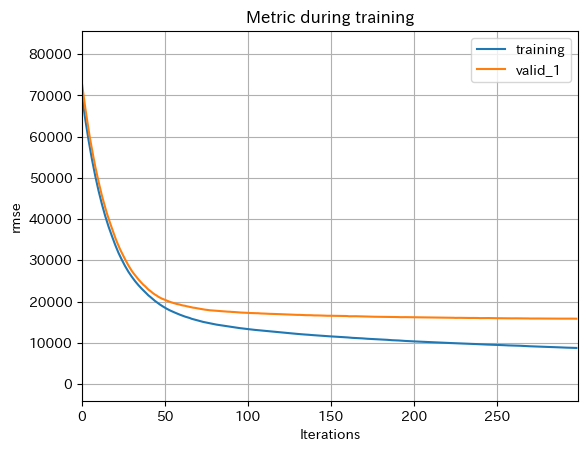

importance
面積               4.533650e+14
L                4.153898e+14
平均地価             2.052424e+14
最寄り駅             8.785406e+13
築年数              6.623453e+13
所在地              4.133686e+13
全体の階数            3.273404e+13
契約期間             1.489077e+13
所在階              9.663151e+12
所要時間             6.505004e+12
温水洗浄便座           4.232462e+12
定期借家             2.685926e+12
バス・トイレ別          1.404312e+12
100m^2以上         1.381690e+12
部屋数              1.236002e+12
75m^2以上100m^2未満  8.606883e+11
建物構造             8.296730e+11
D                4.336911e+11
50m^2以上75m^2未満   1.937697e+11
K                6.193983e+10
S                4.073067e+10

In [12]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.7630799986965487e-05,
        'max_bin': 392,
        'num_leaves': 119,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

In [14]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('GBDT_cv_result.csv',index=False)

### 特徴量として「バス・トイレ別」「温水洗浄便座」「建物構造」がない場合を確かめる

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
washlets = pd.read_csv('../data/handmade_data/washlets.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']], test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K', 'S', '100m^2以上', '75m^2以上100m^2未満']

In [2]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=1000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [3]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-16 08:01:14,295] A new study created in memory with name: no-name-ed1aef49-f792-4290-a93e-f61068c5bf75
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2832
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48789.7	valid_1's rmse: 50204
[20]	training's rmse: 34455.9	valid_1's rmse: 37892.9
[30]	training's rmse: 26132	valid_1's rmse: 31188
[40]	training's rmse: 21079	valid_1's rmse: 27406.7
[50]	training's rmse: 17769	valid_1's rmse: 25044.1
[60]	training's rmse: 15733.3	valid_1's rmse: 23614
[70]	training's rmse: 14375.5	valid_1's rmse: 22763.2
[80]	training's rmse: 13373.8	valid_1's rmse: 22089.6
[90]	training's rmse: 12614.7	valid_1's rmse: 21618.5
[100]	training's rmse: 12001.9	valid_1's rmse: 2121

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2831
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48983	valid_1's rmse: 49549.4
[20]	training's rmse: 34955.9	valid_1's rmse: 35957
[30]	training's rmse: 27005.4	valid_1's rmse: 28594.6
[40]	training's rmse: 22282.6	valid_1's rmse: 24388.8
[50]	training's rmse: 19307	valid_1's rmse: 21669.9
[60]	training's rmse: 17657	valid_1's rmse: 20364
[70]	training's rmse: 16448.5	valid_1's rmse: 19430.3
[80]	training's rmse: 15578.4	valid_1's rmse: 18844.9
[90]	training's rmse: 14864.3	valid_1's rmse: 18625.8
[100]	training's rmse: 14301.7	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49027.7	valid_1's rmse: 48347.2
[20]	training's rmse: 35415.8	valid_1's rmse: 33838.7
[30]	training's rmse: 27289.3	valid_1's rmse: 25911.6
[40]	training's rmse: 22366.5	valid_1's rmse: 21523.4
[50]	training's rmse: 19350.8	valid_1's rmse: 19094.1
[60]	training's rmse: 17422.2	valid_1's rmse: 17874.3
[70]	training's rmse: 16262.1	valid_1's rmse: 17225
[80]	training's rmse: 15407.3	valid_1's rmse: 16819.1
[90]	training's rmse: 14737.4	valid_1's rmse: 16540
[100]	training's rmse: 14240.3	valid_1's rmse: 16305.1
[110]	training's rmse: 13796	valid_1's rmse: 16118.9
[120]	training's rmse: 13411.2	valid_1's rmse: 15991.6
[130]	training's rmse: 13056.6	valid_1's rmse: 15875.4
[140]	training's rmse: 12728.4	valid_1's rmse: 15787.5
[150]	training's rmse: 12427.2	valid_1's rmse: 15697.2
[160]	training's rmse: 12133.7	valid_1's rmse: 15649.7
[170]	training's rmse: 11891.6	valid_1's rmse: 15594.4
[180]	training's rmse: 11637.6	valid_1's rmse: 15551.3
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49244.6	valid_1's rmse: 48168.1
[20]	training's rmse: 35074.8	valid_1's rmse: 35144.1
[30]	training's rmse: 26739	valid_1's rmse: 28087.7
[40]	training's rmse: 21853.8	valid_1's rmse: 24300
[50]	training's rmse: 18707.9	valid_1's rmse: 22312.2
[60]	training's rmse: 17005.3	valid_1's rmse: 21205.4
[70]	training's rmse: 15867.3	valid_1's rmse: 20697
[80]	training's rmse: 15061.4	valid_1's rmse: 20239.8
[90]	training's rmse: 14412.7	valid_1's rmse: 19855.6
[100]	training's rmse: 13892.1	valid_1's rmse: 19558.3
[110]	training's rmse: 13459.2	valid_1's rmse: 19352.4
[120]	training's rmse: 13047	valid_1's rmse: 19185.3
[130]	training's rmse: 12685.7	valid_1's rmse: 19071.2
[140]	training's rmse: 12379.6	valid_1's rmse: 18982.4
[150]	training's rmse: 12097.8	valid_1's rmse: 18887
[160]	training's rmse: 11831.1	valid_1's rmse: 18806.1
[170]	training's rmse: 11582	valid_1's rmse: 18755
[180]	training's rmse: 11372.8	valid_1's rmse: 18698.5
[190]	training's rmse: 11176	vali

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2831
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48664.2	valid_1's rmse: 50985.9
[20]	training's rmse: 34971.1	valid_1's rmse: 37042.2
[30]	training's rmse: 26940.8	valid_1's rmse: 28802
[40]	training's rmse: 22278.5	valid_1's rmse: 24047.9
[50]	training's rmse: 19123.3	valid_1's rmse: 21296.1
[60]	training's rmse: 17273	valid_1's rmse: 19838.9
[70]	training's rmse: 16016.3	valid_1's rmse: 19016.3
[80]	training's rmse: 15144.2	valid_1's rmse: 18495.8
[90]	training's rmse: 14444.9	valid_1's rmse: 18225.6
[100]	training's rmse: 13942.6	valid_1's rm

[I 2022-09-16 08:01:32,551] Trial 0 finished with value: 16525.667636899536 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16525.667636899536.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2512
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48703.2	valid_1's rmse: 50044.9
[20]	training's rmse: 34361.1	valid_1's rmse: 37800.4
[30]	training's rmse: 25876.3	valid_1's rmse: 30957.2
[40]	training's rmse: 20934.7	valid_1's rmse: 27188.8
[50]	training's rmse: 17678.1	valid_1's rmse: 24895.6
[60]	training's rmse: 15731.1	valid_1's rmse: 23510.3
[70]	training's rmse: 14329.7	valid_1's rmse: 22561.6
[80]	training's rmse: 13335.5	valid_1's rmse: 21919
[90]	training's rmse: 12637.3	valid_1's rmse: 21477.1
[100]	training's rmse: 12081.2	valid_1's rmse: 21108.1
[110]	training's rmse: 11589.7	valid_1's rmse: 207

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48966.2	valid_1's rmse: 49790.4
[20]	training's rmse: 34881.8	valid_1's rmse: 36398.2
[30]	training's rmse: 26636.3	valid_1's rmse: 29022.2
[40]	training's rmse: 21872	valid_1's rmse: 24774.7
[50]	training's rmse: 18904	valid_1's rmse: 22037.7
[60]	training's rmse: 17074.2	valid_1's rmse: 20514.2
[70]	training's rmse: 15827.6	valid_1's rmse: 19730.5
[80]	training's rmse: 14848.1	valid_1's rmse: 19170.9
[90]	training's rmse: 14084.6	valid_1's rmse: 18878.8
[100]	training's rmse: 13470.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2509
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48852.2	valid_1's rmse: 48585.4
[20]	training's rmse: 34938.4	valid_1's rmse: 34319
[30]	training's rmse: 26769.7	valid_1's rmse: 26502.5
[40]	training's rmse: 22004.9	valid_1's rmse: 22384.9
[50]	training's rmse: 18940.4	valid_1's rmse: 20088.3
[60]	training's rmse: 17119.3	valid_1's rmse: 18832.7
[70]	training's rmse: 15931.1	valid_1's rmse: 18220
[80]	training's rmse: 15024.9	valid_1's rmse: 17842.3
[90]	training's rmse: 14343.1	valid_1's rmse: 17559.5
[100]	training's rmse: 13786	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49172.6	valid_1's rmse: 48042.6
[20]	training's rmse: 34763.1	valid_1's rmse: 35412.1
[30]	training's rmse: 26314.5	valid_1's rmse: 28488
[40]	training's rmse: 21497.3	valid_1's rmse: 24735.6
[50]	training's rmse: 18510.3	valid_1's rmse: 22841.7
[60]	training's rmse: 16703.9	valid_1's rmse: 21863.9
[70]	training's rmse: 15496.4	valid_1's rmse: 21330.4
[80]	training's rmse: 14611.1	valid_1's rmse: 20851.8
[90]	training's rmse: 13926.5	valid_1's rmse: 20428.6
[100]	training's rmse: 13400	valid_1's rmse: 20231.2
[110]	training's rmse: 12969	valid_1's rmse: 20048.2
[120]	training's rmse: 12594.4	valid_1's rmse: 19928.7
[130]	training's rmse: 12272.8	valid_1's rmse: 19797.2
[140]	training's rmse: 11971.7	valid_1's rmse: 19725.5
[150]	training's rmse: 11663.9	valid_1's rmse: 19638.2
[160]	training's rmse: 11389.4	valid_1's rmse: 19577.4
[170]	training's rmse: 11151.8	valid_1's rmse: 19537.2
[180]	training's rmse: 10931.8	valid_1's rmse: 19526.3
Early stopping, best iter

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34981.1	valid_1's rmse: 36946.1
[30]	training's rmse: 26815	valid_1's rmse: 28366.6
[40]	training's rmse: 22160.2	valid_1's rmse: 23493.7
[50]	training's rmse: 18946.8	valid_1's rmse: 20769
[60]	training's rmse: 17013.6	valid_1's rmse: 19494
[70]	training's rmse: 15692.6	valid_1's rmse: 18801.8
[80]	training's rmse: 14817.5	valid_1's rmse: 18362.8
[90]	training's rmse: 14151.4	valid_1's rmse: 18087.6
[100]	training's rmse: 13663.1	valid_1's rmse: 17857.3
[110]	training's rmse: 13237.5	valid_1's rmse: 17675.6
[120]	training's rmse: 12858.7	valid_1's rmse: 17515.6
[130]	training's rmse: 12518.2	valid_1's rmse: 17438.5
[140]	training's rmse: 12210.4	valid_1's rmse: 17336.8
[150]	training's rmse: 11899.2	valid_1's rmse: 17283.4
[160]	training's rmse: 11645	valid_1's rmse: 17214.3
[170]	training's rmse: 11409.8	valid_1's rmse: 17133.9
[180]	training's rmse: 11162.5	valid_1's rmse: 17089.3
[190]	training's rmse: 10927.6	valid_1's rmse: 17062.3
[200]	training's rmse: 107

[I 2022-09-16 08:01:43,370] Trial 1 finished with value: 16815.238963875894 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16525.667636899536.


Early stopping, best iteration is:
[255]	training's rmse: 9756.53	valid_1's rmse: 16815.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2995
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48381.4	valid_1's rmse: 49962
[20]	training's rmse: 33962.7	valid_1's rmse: 37669.7
[30]	training's rmse: 25537.5	valid_1's rmse: 30910.7
[40]	training's rmse: 20553.9	valid_1's rmse: 27114.5
[50]	training's rmse: 17257.8	valid_1's rmse: 24694.9
[60]	training's rmse: 15234.7	valid_1's rmse: 23188
[70]	training's rmse: 13847.1	valid_1's rmse: 22133.6
[80]	training's rmse: 12886.3	valid_1's rmse: 21513.6
[90]	training's rmse: 12182.4	valid_1's rmse: 21009.2
[100]	training's rmse: 11612.9	valid_1's rmse: 20671.6
[110]	training's rmse: 11095.9	valid_1's rmse: 20351.4
[120]	training's rmse: 10698	valid_1's rmse: 20137.3
[130]	training's rmse: 10340.1	valid_1's rmse: 19932.8
[140]	training's rmse: 10006.9	valid_1's rmse: 19717.5
[150]	training's rmse: 9677.87	valid_1's rmse: 19498.7
[160]	training's rmse: 9368.64	valid_1's rmse: 19268.8
[170]	training's rmse: 9080.11	valid_1's rmse: 19057.6
[180]	training's rmse: 8837.84	valid_1's rmse: 18900
[190]	training's rmse: 8600

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2998
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48761.1	valid_1's rmse: 49584.5
[20]	training's rmse: 34567.3	valid_1's rmse: 36087.4
[30]	training's rmse: 26558.1	valid_1's rmse: 28731.6
[40]	training's rmse: 21872.4	valid_1's rmse: 24261.6
[50]	training's rmse: 18990.4	valid_1's rmse: 21415.6
[60]	training's rmse: 17340.1	valid_1's rmse: 19878.6
[70]	training's rmse: 16095.1	valid_1's rmse: 18829.4
[80]	training's rmse: 15027	valid_1's rmse: 18127.8
[90]	training's rmse: 14318.3	valid_1's rmse: 17734.9
[100]	training's rmse: 13714.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48764	valid_1's rmse: 48273.7
[20]	training's rmse: 34783.8	valid_1's rmse: 33705.8
[30]	training's rmse: 26566.8	valid_1's rmse: 25834.1
[40]	training's rmse: 21839.4	valid_1's rmse: 21767.1
[50]	training's rmse: 18734.2	valid_1's rmse: 19506.3
[60]	training's rmse: 16907.5	valid_1's rmse: 18304.8
[70]	training's rmse: 15679.7	valid_1's rmse: 17733.9
[80]	training's rmse: 14854.5	valid_1's rmse: 17337.3
[90]	training's rmse: 14201.9	valid_1's rmse: 17108.4
[100]	training's rmse: 13656.4	valid_1's rmse: 16889.7
[110]	training's rmse: 13163.8	valid_1's rmse: 16810.7
[120]	training's rmse: 12768.1	valid_1's rmse: 16736
[130]	training's rmse: 12371.3	valid_1's rmse: 16672.4
[140]	training's rmse: 12020.2	valid_1's rmse: 16604.1
[150]	training's rmse: 11712.4	valid_1's rmse: 16590.3
[160]	training's rmse: 11434.5	valid_1's rmse: 16603.3
Early stopping, best iteration is:
[151]	training's rmse: 11690.7	valid_1's rmse: 16584.4
[LightGBM] [Warning] Auto-choosing row-wise

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48821.5	valid_1's rmse: 47909.2
[20]	training's rmse: 34373.5	valid_1's rmse: 35391.2
[30]	training's rmse: 26042.9	valid_1's rmse: 28380
[40]	training's rmse: 21089.4	valid_1's rmse: 24677.2
[50]	training's rmse: 18049.4	valid_1's rmse: 22795.8
[60]	training's rmse: 16253.4	valid_1's rmse: 21825.9
[70]	training's rmse: 15106.9	valid_1's rmse: 21195.1
[80]	training's rmse: 14346.7	valid_1's rmse: 20765.7
[90]	training's rmse: 13748.3	valid_1's rmse: 20441.3
[100]	training's rmse: 13272	valid_1's rmse: 20164.7
[110]	training's rmse: 12867.2	valid_1's rmse: 19947.7
[120]	training's rmse: 12456.4	valid_1's rmse: 19782.4
[130]	training's rmse: 12055.3	valid_1's rmse: 19643.9
[140]	training's rmse: 11700.5	valid_1's rmse: 19523.5
[150]	training's rmse: 11384.7	valid_1's rmse: 19409.1
[160]	training's rmse: 11150.5	valid_1's rmse: 19320.4
[170]	training's rmse: 10903.6	valid_1's rmse: 19233.9
[180]	training's rmse: 10685.3	valid_1's rmse: 19173.8
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2997
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48302.4	valid_1's rmse: 50772
[20]	training's rmse: 34377.8	valid_1's rmse: 36846.7
[30]	training's rmse: 26309.4	valid_1's rmse: 28606.9
[40]	training's rmse: 21716.3	valid_1's rmse: 23873.4
[50]	training's rmse: 18551.8	valid_1's rmse: 21034.9
[60]	training's rmse: 16734.8	valid_1's rmse: 19597.5
[70]	training's rmse: 15503.6	valid_1's rmse: 18828.8
[80]	training's rmse: 14618.3	valid_1's rmse: 18439.6
[90]	training's rmse: 13969	valid_1's rmse: 18243.7
[100]	training's rmse: 13467.4	valid_1's rm

[I 2022-09-16 08:02:01,138] Trial 2 finished with value: 17479.17570886486 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 16525.667636899536.


[330]	training's rmse: 9036.51	valid_1's rmse: 17482.7
[340]	training's rmse: 8925.49	valid_1's rmse: 17483.4
Early stopping, best iteration is:
[332]	training's rmse: 9015.88	valid_1's rmse: 17479.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2906
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48780.2	valid_1's rmse: 50292
[20]	training's rmse: 34423.2	valid_1's rmse: 37937.7
[30]	training's rmse: 26167.1	valid_1's rmse: 31153.7
[40]	training's rmse: 20966.4	valid_1's rmse: 27222.2
[50]	training's rmse: 17700.4	valid_1's rmse: 24815.1
[60]	training's rmse: 15695.5	valid_1's rmse: 23323.6
[70]	training's rmse: 14333.1	valid_1's rmse: 22365.9
[80]	training's rmse: 13341.7	valid_1's rmse: 21720.6
[90]	training's rmse: 12621.2	valid_1's rmse: 21305.2
[100]	training's rmse: 12044	valid_1's rmse: 20946.5
[110]	training's rmse: 11612.1	valid_1's rmse: 20663.2
[120]	training's rmse: 11231.8	valid_1's rmse: 20416
[130]	training's rmse: 10871.7	valid_1's rmse: 20150
[140]	training's rmse: 10556.5	valid_1's rmse: 19955.4
[150]	training's rmse: 10228.4	valid_1's rmse: 19794.3
[160]	training's rmse: 9925.94	valid_1's rmse: 19665.6
[170]	training's rmse: 9656.46	valid_1's rmse: 19497.7
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34891.4	valid_1's rmse: 36633.6
[30]	training's rmse: 26948.5	valid_1's rmse: 29423.4
[40]	training's rmse: 22149.6	valid_1's rmse: 24729.7
[50]	training's rmse: 19236.2	valid_1's rmse: 21812.6
[60]	training's rmse: 17489.2	valid_1's rmse: 20156.9
[70]	training's rmse: 16282.2	valid_1's rmse: 19006.9
[80]	training's rmse: 15382.2	valid_1's rmse: 18374.7
[90]	training's rmse: 14735.8	valid_1's rmse: 18050.9
[100]	training's rmse: 14149.5	valid_1's rmse: 17832.1
[110]	training's rmse: 13709.8	valid_1's rmse: 17752.4
[120]	training's rmse: 13332.9	valid_1's rmse: 17662
[130]	training's rmse: 12977.1	valid_1's rmse: 17628.6
[140]	training's rmse: 12634.4	valid_1's rmse: 17614.7
[150]	training's rmse: 12348.7	valid_1's rmse: 17630.6
Early stopping, best iteration is:
[142]	training's rmse: 12589.1	valid_1's rmse: 17597.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35237.3	valid_1's rmse: 34010.4
[30]	training's rmse: 27039.7	valid_1's rmse: 26008.8
[40]	training's rmse: 22322	valid_1's rmse: 21718.6
[50]	training's rmse: 19335.7	valid_1's rmse: 19396.4
[60]	training's rmse: 17473.4	valid_1's rmse: 18182.7
[70]	training's rmse: 16259.5	valid_1's rmse: 17487.4
[80]	training's rmse: 15386.4	valid_1's rmse: 17080.6
[90]	training's rmse: 14698.6	valid_1's rmse: 16847.5
[100]	training's rmse: 14206.9	valid_1's rmse: 16614.4
[110]	training's rmse: 13772.7	valid_1's rmse: 16461.6
[120]	training's rmse: 13375.7	valid_1's rmse: 16327.9
[130]	training's rmse: 12988.9	valid_1's rmse: 16196.7
[140]	training's rmse: 12650.3	valid_1's rmse: 16140.2
[150]	training's rmse: 12363.3	valid_1's rmse: 16099
[160]	training's rmse: 12071	valid_1's rmse: 16084.6
[170]	training's rmse: 11824.5	valid_1's rmse: 16057.8
[180]	training's rmse: 11588.3	valid_1's rmse: 16020.2
[190]	training's rmse: 11366.1	valid_1's rmse: 15986.8
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2907
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49231	valid_1's rmse: 48194
[20]	training's rmse: 34974.3	valid_1's rmse: 35356
[30]	training's rmse: 26565.1	valid_1's rmse: 28180.1
[40]	training's rmse: 21747.8	valid_1's rmse: 24422.7
[50]	training's rmse: 18705.6	valid_1's rmse: 22454.6
[60]	training's rmse: 16921.1	valid_1's rmse: 21325.7
[70]	training's rmse: 15794.1	valid_1's rmse: 20649.8
[80]	training's rmse: 14964.7	valid_1's rmse: 20150.7
[90]	training's rmse: 14323.3	valid_1's rmse: 19773
[100]	training's rmse: 13760.6	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34978.6	valid_1's rmse: 36978.2
[30]	training's rmse: 27082.4	valid_1's rmse: 28853.2
[40]	training's rmse: 22386.3	valid_1's rmse: 24064.7
[50]	training's rmse: 19308.9	valid_1's rmse: 21435.3
[60]	training's rmse: 17556.2	valid_1's rmse: 20026.8
[70]	training's rmse: 16275.1	valid_1's rmse: 19266.4
[80]	training's rmse: 15300	valid_1's rmse: 18853.4
[90]	training's rmse: 14602.1	valid_1's rmse: 18648.7
[100]	training's rmse: 14075	valid_1's rmse: 18479.8
[110]	training's rmse: 13615.3	valid_1's rmse: 18348.9
[120]	training's rmse: 13226.5	valid_1's rmse: 18260
[130]	training's rmse: 12902	valid_1's rmse: 18183.3
[140]	training's rmse: 12613.5	valid_1's rmse: 18114.7
[150]	training's rmse: 12332.8	valid_1's rmse: 18053.3
[160]	training's rmse: 12089.8	valid_1's rmse: 18006.8
[170]	training's rmse: 11864.8	valid_1's rmse: 17993.7
[180]	training's rmse: 11654.4	valid_1's rmse: 17978.2
[190]	training's rmse: 11453.9	valid_1's rmse: 17959.1
[200]	training's rmse: 112

[I 2022-09-16 08:02:09,086] Trial 3 finished with value: 17805.152309334673 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 16525.667636899536.


[260]	training's rmse: 10309.1	valid_1's rmse: 17821.7
Early stopping, best iteration is:
[252]	training's rmse: 10416.7	valid_1's rmse: 17805.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3028
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49296.3	valid_1's rmse: 50765.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35136.4	valid_1's rmse: 38574.3
[30]	training's rmse: 26777.6	valid_1's rmse: 31792.9
[40]	training's rmse: 21699.4	valid_1's rmse: 27724.7
[50]	training's rmse: 18536.6	valid_1's rmse: 25331.7
[60]	training's rmse: 16616.9	valid_1's rmse: 23841.5
[70]	training's rmse: 15214	valid_1's rmse: 22834.8
[80]	training's rmse: 14262.7	valid_1's rmse: 22231.9
[90]	training's rmse: 13589	valid_1's rmse: 21811
[100]	training's rmse: 13030.9	valid_1's rmse: 21502.5
[110]	training's rmse: 12567.3	valid_1's rmse: 21238.2
[120]	training's rmse: 12151.2	valid_1's rmse: 20968.3
[130]	training's rmse: 11775.4	valid_1's rmse: 20729
[140]	training's rmse: 11441.3	valid_1's rmse: 20509.5
[150]	training's rmse: 11183.3	valid_1's rmse: 20307.2
[160]	training's rmse: 10860.9	valid_1's rmse: 20042.2
[170]	training's rmse: 10625.8	valid_1's rmse: 19927.3
[180]	training's rmse: 10390.3	valid_1's rmse: 19769.2
[190]	training's rmse: 10187.1	valid_1's rmse: 19650.2
[200]	training's rmse: 998

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3027
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49469.2	valid_1's rmse: 50081.7
[20]	training's rmse: 35529.9	valid_1's rmse: 36667.1
[30]	training's rmse: 27655.9	valid_1's rmse: 29366.8
[40]	training's rmse: 22814.1	valid_1's rmse: 24682.6
[50]	training's rmse: 19955.8	valid_1's rmse: 21800.5
[60]	training's rmse: 18283.6	valid_1's rmse: 20275.2
[70]	training's rmse: 17011.1	valid_1's rmse: 19211.9
[80]	training's rmse: 16017.1	valid_1's rmse: 18503.7
[90]	training's rmse: 15283.6	valid_1's rmse: 18147.3
[100]	training's rmse: 14728.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35909	valid_1's rmse: 34786.3
[30]	training's rmse: 27752.2	valid_1's rmse: 26902
[40]	training's rmse: 22816	valid_1's rmse: 22578.1
[50]	training's rmse: 19823.4	valid_1's rmse: 20199.8
[60]	training's rmse: 17922.8	valid_1's rmse: 18915.1
[70]	training's rmse: 16750.6	valid_1's rmse: 18195.1
[80]	training's rmse: 15846.5	valid_1's rmse: 17716.4
[90]	training's rmse: 15182.5	valid_1's rmse: 17482
[100]	training's rmse: 14637.9	valid_1's rmse: 17266.8
[110]	training's rmse: 14205.1	valid_1's rmse: 17115
[120]	training's rmse: 13815.3	valid_1's rmse: 17002.1
[130]	training's rmse: 13450.5	valid_1's rmse: 16927
[140]	training's rmse: 13116.7	valid_1's rmse: 16836.6
[150]	training's rmse: 12812.5	valid_1's rmse: 16777.7
[160]	training's rmse: 12550.9	valid_1's rmse: 16752.9
[170]	training's rmse: 12313.6	valid_1's rmse: 16687
[180]	training's rmse: 12095.9	valid_1's rmse: 16648.2
[190]	training's rmse: 11897.1	valid_1's rmse: 16601.7
[200]	training's rmse: 11697.7	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35446	valid_1's rmse: 36184.2
[30]	training's rmse: 27133.5	valid_1's rmse: 29341.7
[40]	training's rmse: 22290.7	valid_1's rmse: 25651.3
[50]	training's rmse: 19322.8	valid_1's rmse: 23544.1
[60]	training's rmse: 17553	valid_1's rmse: 22296.5
[70]	training's rmse: 16449.9	valid_1's rmse: 21546.5
[80]	training's rmse: 15639	valid_1's rmse: 20988.7
[90]	training's rmse: 15027.9	valid_1's rmse: 20585.5
[100]	training's rmse: 14523.7	valid_1's rmse: 20301.3
[110]	training's rmse: 14120.6	valid_1's rmse: 20076.8
[120]	training's rmse: 13736.4	valid_1's rmse: 19858.9
[130]	training's rmse: 13344.2	valid_1's rmse: 19674
[140]	training's rmse: 13057.2	valid_1's rmse: 19523.6
[150]	training's rmse: 12789.9	valid_1's rmse: 19406
[160]	training's rmse: 12540.5	valid_1's rmse: 19299.6
[170]	training's rmse: 12291.8	valid_1's rmse: 19204.1
[180]	training's rmse: 12097.2	valid_1's rmse: 19148.7
[190]	training's rmse: 11881.8	valid_1's rmse: 19078.1
[200]	training's rmse: 11648

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[30]	training's rmse: 27783.4	valid_1's rmse: 29481.9
[40]	training's rmse: 23029.4	valid_1's rmse: 24512.7
[50]	training's rmse: 19926.7	valid_1's rmse: 21748.6
[60]	training's rmse: 18044.5	valid_1's rmse: 20172.7
[70]	training's rmse: 16749.5	valid_1's rmse: 19389.9
[80]	training's rmse: 15873.9	valid_1's rmse: 18857.1
[90]	training's rmse: 15211.2	valid_1's rmse: 18517
[100]	training's rmse: 14678.4	valid_1's rmse: 18293.3
[110]	training's rmse: 14262.2	valid_1's rmse: 18149.7
[120]	training's rmse: 13859.8	valid_1's rmse: 18050.7
[130]	training's rmse: 13507.6	valid_1's rmse: 17933.7
[140]	training's rmse: 13200.4	valid_1's rmse: 17851.9
[150]	training's rmse: 12925.5	valid_1's rmse: 17805
[160]	training's rmse: 12686.2	valid_1's rmse: 17757.2
[170]	training's rmse: 12456.5	valid_1's rmse: 17756
[180]	training's rmse: 12263.7	valid_1's rmse: 17746.4
[190]	training's rmse: 12061.8	valid_1's rmse: 17717
[200]	training's rmse: 11878.7	valid_1's rmse: 17703.4
[210]	training's rmse: 11

[I 2022-09-16 08:02:18,297] Trial 4 finished with value: 17659.44192383042 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 16525.667636899536.


[220]	training's rmse: 11530.6	valid_1's rmse: 17661.3
[230]	training's rmse: 11376.6	valid_1's rmse: 17665.9
Early stopping, best iteration is:
[221]	training's rmse: 11519.8	valid_1's rmse: 17659.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48688.2	valid_1's rmse: 50295.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34478.9	valid_1's rmse: 38224.4
[30]	training's rmse: 25953.5	valid_1's rmse: 31470.6
[40]	training's rmse: 20941.8	valid_1's rmse: 27710
[50]	training's rmse: 17590	valid_1's rmse: 25345.6
[60]	training's rmse: 15579.6	valid_1's rmse: 23886.4
[70]	training's rmse: 14210.4	valid_1's rmse: 22918.2
[80]	training's rmse: 13217.1	valid_1's rmse: 22260
[90]	training's rmse: 12418.3	valid_1's rmse: 21723.8
[100]	training's rmse: 11808.9	valid_1's rmse: 21324.2
[110]	training's rmse: 11250.7	valid_1's rmse: 21027
[120]	training's rmse: 10804.1	valid_1's rmse: 20748.5
[130]	training's rmse: 10436.6	valid_1's rmse: 20509.6
[140]	training's rmse: 10097.1	valid_1's rmse: 20248.4
[150]	training's rmse: 9773.51	valid_1's rmse: 20011.5
[160]	training's rmse: 9478.24	valid_1's rmse: 19784.3
[170]	training's rmse: 9214.75	valid_1's rmse: 19616.6
[180]	training's rmse: 8970.35	valid_1's rmse: 19436.9
[190]	training's rmse: 8731.04	valid_1's rmse: 19312.3
[200]	training's rmse: 853

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2089
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48800.9	valid_1's rmse: 49295.4
[20]	training's rmse: 34773.6	valid_1's rmse: 35794.6
[30]	training's rmse: 26588.8	valid_1's rmse: 27985.5
[40]	training's rmse: 21981.3	valid_1's rmse: 24116.6
[50]	training's rmse: 18880.4	valid_1's rmse: 21426.9
[60]	training's rmse: 16964.6	valid_1's rmse: 19968.2
[70]	training's rmse: 15664.3	valid_1's rmse: 19069
[80]	training's rmse: 14633.6	valid_1's rmse: 18468.1
[90]	training's rmse: 13800.1	valid_1's rmse: 18220.1
[100]	training's rmse: 13164.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48937.9	valid_1's rmse: 48893.7
[20]	training's rmse: 35074.8	valid_1's rmse: 34783.6
[30]	training's rmse: 26897.1	valid_1's rmse: 27204
[40]	training's rmse: 22141.9	valid_1's rmse: 23040.5
[50]	training's rmse: 19009	valid_1's rmse: 20679.5
[60]	training's rmse: 17112.3	valid_1's rmse: 19465.6
[70]	training's rmse: 15770.3	valid_1's rmse: 18868.8
[80]	training's rmse: 14746.4	valid_1's rmse: 18536.4
[90]	training's rmse: 13922.9	valid_1's rmse: 18228.3
[100]	training's rmse: 13253.1	valid_1's rmse: 18045.8
[110]	training's rmse: 12670.7	valid_1's rmse: 17888.9
[120]	training's rmse: 12182	valid_1's rmse: 17798.9
[130]	training's rmse: 11738	valid_1's rmse: 17753.5
[140]	training's rmse: 11349.1	valid_1's rmse: 17732.7
[150]	training's rmse: 10995.2	valid_1's rmse: 17692.9
[160]	training's rmse: 10690.4	valid_1's rmse: 17670.1
Early stopping, be

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49110.3	valid_1's rmse: 47855.8
[20]	training's rmse: 34981.2	valid_1's rmse: 35224.4
[30]	training's rmse: 26519.3	valid_1's rmse: 28222.2
[40]	training's rmse: 21681.9	valid_1's rmse: 24566.7
[50]	training's rmse: 18566.1	valid_1's rmse: 22621.4
[60]	training's rmse: 16673.4	valid_1's rmse: 21718.6
[70]	training's rmse: 15318.6	valid_1's rmse: 21215.9
[80]	training's rmse: 14307	valid_1's rmse: 20739.8
[90]	training's rmse: 13531.1	valid_1's rmse: 20416.3
[100]	training's rmse: 12921.3	valid_1's rmse: 20197.9
[110]	training's rmse: 12371.3	valid_1's rmse: 19982.8
[120]	training's rmse: 11916.8	valid_1's rmse: 19817.8
[130]	training's rmse: 11514.5	valid_1's rmse: 19629
[140]	training's rmse: 11164.3	valid_1's rmse: 19536.3
[150]	training's rmse: 10838.2	valid_1's rmse: 19411.3
[160]	training's rmse: 10546.9	valid_1's rmse: 19272.4
[170]	training's rmse: 10272.3	valid_1's rmse: 19184.9
[180]	training's rmse: 10031.5	valid_1's rmse: 19107.8
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34804.1	valid_1's rmse: 36815.1
[30]	training's rmse: 26675.2	valid_1's rmse: 28372.2
[40]	training's rmse: 21970.3	valid_1's rmse: 23535.4
[50]	training's rmse: 18862.3	valid_1's rmse: 20702.6
[60]	training's rmse: 16901.1	valid_1's rmse: 19307
[70]	training's rmse: 15579.5	valid_1's rmse: 18538.8
[80]	training's rmse: 14606.1	valid_1's rmse: 18037.3
[90]	training's rmse: 13873.6	valid_1's rmse: 17753.8
[100]	training's rmse: 13275.6	valid_1's rmse: 17520.6
[110]	training's rmse: 12794.2	valid_1's rmse: 17361.9
[120]	training's rmse: 12368.2	valid_1's rmse: 17204.1
[130]	training's rmse: 11973.3	valid_1's rmse: 17120.5
[140]	training's rmse: 11636.5	valid_1's rmse: 16988.9
[150]	training's rmse: 11312.1	valid_1's rmse: 16905.6
[160]	training's rmse: 11007	valid_1's rmse: 16834.6
[170]	training's rmse: 10752.8	valid_1's rmse: 16739.4
[180]	training's rmse: 10490.8	valid_1's rmse: 16617.2
[190]	training's rmse: 10256.6	valid_1's rmse: 16555.6
[200]	training's rmse:

[I 2022-09-16 08:02:33,071] Trial 5 finished with value: 16087.1852842299 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 5 with value: 16087.1852842299.


[300]	training's rmse: 8515.99	valid_1's rmse: 16102.7
[310]	training's rmse: 8399.26	valid_1's rmse: 16101.8
Early stopping, best iteration is:
[302]	training's rmse: 8493.96	valid_1's rmse: 16087.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48401.3	valid_1's rmse: 50021
[20]	training's rmse: 33939.4	valid_1's rmse: 37651.4
[30]	training's rmse: 25599.3	valid_1's rmse: 30842.9
[40]	training's rmse: 20573.3	valid_1's rmse: 26992.8
[50]	training's rmse: 17310.2	valid_1's rmse: 24553.5
[60]	training's rmse: 15296.3	valid_1's rmse: 23043
[70]	training's rmse: 13897.3	valid_1's rmse: 22026
[80]	training's rmse: 12934.9	valid_1's rmse: 21336.3
[90]	training's rmse: 12112.7	valid_1's rmse: 20835.3
[100]	training's rmse: 11538	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48762.6	valid_1's rmse: 49596.8
[20]	training's rmse: 34576	valid_1's rmse: 36107.6
[30]	training's rmse: 26537.4	valid_1's rmse: 28731.2
[40]	training's rmse: 21994.2	valid_1's rmse: 24630.7
[50]	training's rmse: 18955.9	valid_1's rmse: 21544.4
[60]	training's rmse: 17287.2	valid_1's rmse: 19938.2
[70]	training's rmse: 16059.5	valid_1's rmse: 19057.2
[80]	training's rmse: 15053.3	valid_1's rmse: 18315.5
[90]	training's rmse: 14308.2	valid_1's rmse: 18004
[100]	training's rmse: 13770	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48723.8	valid_1's rmse: 48264.2
[20]	training's rmse: 34762.1	valid_1's rmse: 33638.3
[30]	training's rmse: 26532.8	valid_1's rmse: 25878.6
[40]	training's rmse: 21851.7	valid_1's rmse: 21822.5
[50]	training's rmse: 18676.9	valid_1's rmse: 19499.2
[60]	training's rmse: 16765.8	valid_1's rmse: 18354
[70]	training's rmse: 15637.9	valid_1's rmse: 17761.3
[80]	training's rmse: 14773	valid_1's rmse: 17349.4
[90]	training's rmse: 14136.8	valid_1's rmse: 17122.6
[100]	training's rmse: 13615.9	valid_1's rmse: 16988.3
[110]	training's rmse: 13141.2	valid_1's rmse: 16887.6
[120]	training's rmse: 12711.3	valid_1's rmse: 16802.9
[130]	training's rmse: 12349.3	valid_1's rmse: 16723.3
[140]	training's rmse: 11979.7	valid_1's rmse: 16636.3
[150]	training's rmse: 11664.6	valid_1's rmse: 16623.7
[160]	training's rmse: 11404.8	valid_1's rmse: 16583.3
[170]	training's rmse: 11141.1	valid_1's rmse: 16577.6
[180]	training's rmse: 10923.4	valid_1's rmse: 16551.8
Early stopping, best it

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34315	valid_1's rmse: 35201
[30]	training's rmse: 25916.9	valid_1's rmse: 28130.6
[40]	training's rmse: 21103.7	valid_1's rmse: 24542
[50]	training's rmse: 18061.5	valid_1's rmse: 22639.9
[60]	training's rmse: 16283.4	valid_1's rmse: 21707
[70]	training's rmse: 15205.8	valid_1's rmse: 21085.6
[80]	training's rmse: 14435.1	valid_1's rmse: 20626.5
[90]	training's rmse: 13845.4	valid_1's rmse: 20313.9
[100]	training's rmse: 13352.6	valid_1's rmse: 20039.8
[110]	training's rmse: 12979.5	valid_1's rmse: 19868
[120]	training's rmse: 12626.3	valid_1's rmse: 19716.1
[130]	training's rmse: 12230.5	valid_1's rmse: 19563.1
[140]	training's rmse: 11868.4	valid_1's rmse: 19456
[150]	training's rmse: 11567.7	valid_1's rmse: 19373.2
[160]	training's rmse: 11304.9	valid_1's rmse: 19307.4
[170]	training's rmse: 11059.1	valid_1's rmse: 19238.2
[180]	training's rmse: 10814.4	valid_1's rmse: 19143.7
[190]	training's rmse: 10579.2	valid_1's rmse: 19126
[200]	training's rmse: 10393.8	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48296.2	valid_1's rmse: 50772.7
[20]	training's rmse: 34330.7	valid_1's rmse: 36713.9
[30]	training's rmse: 26240.1	valid_1's rmse: 28554.1
[40]	training's rmse: 21678.2	valid_1's rmse: 23863.6
[50]	training's rmse: 18474.6	valid_1's rmse: 20933.6
[60]	training's rmse: 16567.8	valid_1's rmse: 19493.6
[70]	training's rmse: 15440.4	valid_1's rmse: 18762.5
[80]	training's rmse: 14587.1	valid_1's rmse: 18386.4
[90]	training's rmse: 13930.4	valid_1's rmse: 18141
[100]	training's rmse: 13440	valid_1's rm

[I 2022-09-16 08:02:45,526] Trial 6 finished with value: 17451.35359809274 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 5 with value: 16087.1852842299.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2562
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.3	valid_1's rmse: 50389.3
[20]	training's rmse: 34329.2	valid_1's rmse: 38047.5
[30]	training's rmse: 25799.9	valid_1's rmse: 31094.4
[40]	training's rmse: 20786.5	valid_1's rmse: 27207.5
[50]	training's rmse: 17589.6	valid_1's rmse: 24841.7
[60]	training's rmse: 15604.8	valid_1's rmse: 23387.6
[70]	training's rmse: 14214.1	valid_1's rmse: 22386.6
[80]	training's rmse: 13261.2	valid_1's rmse: 21648.3
[90]	training's rmse: 12472.5	valid_1's rmse: 21103.6
[100]	training's rmse: 11872.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2560
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48861.5	valid_1's rmse: 49705.8
[20]	training's rmse: 34722.9	valid_1's rmse: 36147.9
[30]	training's rmse: 26567	valid_1's rmse: 28687.5
[40]	training's rmse: 21773.9	valid_1's rmse: 24481.3
[50]	training's rmse: 18774.7	valid_1's rmse: 21669.4
[60]	training's rmse: 17024.8	valid_1's rmse: 20198.2
[70]	training's rmse: 15743	valid_1's rmse: 19326.3
[80]	training's rmse: 14798.4	valid_1's rmse: 18846.3
[90]	training's rmse: 14037.9	valid_1's rmse: 18467.2
[100]	training's rmse: 13443.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48763.7	valid_1's rmse: 48579.1
[20]	training's rmse: 34836.8	valid_1's rmse: 34237.2
[30]	training's rmse: 26621.9	valid_1's rmse: 26485.7
[40]	training's rmse: 22051.3	valid_1's rmse: 22498.6
[50]	training's rmse: 19089.1	valid_1's rmse: 20241.1
[60]	training's rmse: 17175.2	valid_1's rmse: 19025.8
[70]	training's rmse: 15998.1	valid_1's rmse: 18340.5
[80]	training's rmse: 15099.1	valid_1's rmse: 17891.5
[90]	training's rmse: 14403.1	valid_1's rmse: 17567.6
[100]	training's rmse: 13838.1	valid_1's rmse: 17346.8
[110]	training's rmse: 13362.9	valid_1's rmse: 17275.1
[120]	training's rmse: 12947.6	valid_1's rmse: 17173.7
[130]	training's rmse: 12544.8	valid_1's rmse: 17147.1
[140]	training's rmse: 12183.2	valid_1's rmse: 17085.1
[150]	training's rmse: 11838.9	valid_1's rmse: 17012
[160]	training's rmse: 11534.9	valid_1's rmse: 16997.9
[170]	training's rmse: 11271.4	valid_1's rmse: 16972.4
[180]	training's rmse: 10982.3	valid_1's rmse: 16963.6
Early stopping, best 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49165.2	valid_1's rmse: 47891.1
[20]	training's rmse: 34742.7	valid_1's rmse: 35292.7
[30]	training's rmse: 26280.7	valid_1's rmse: 28415.6
[40]	training's rmse: 21465.7	valid_1's rmse: 24921.9
[50]	training's rmse: 18420	valid_1's rmse: 22974
[60]	training's rmse: 16584.1	valid_1's rmse: 21852.6
[70]	training's rmse: 15359.1	valid_1's rmse: 21322.7
[80]	training's rmse: 14481.4	valid_1's rmse: 20976.2
[90]	training's rmse: 13817.9	valid_1's rmse: 20723
[100]	training's rmse: 13261.5	valid_1's rmse: 20515.7
[110]	training's rmse: 12840.8	valid_1's rmse: 20344.7
[120]	training's rmse: 12420.6	valid_1's rmse: 20191
[130]	training's rmse: 12067.1	valid_1's rmse: 20082.2
[140]	training's rmse: 11701	valid_1's rmse: 19982.6
[150]	training's rmse: 11414.2	valid_1's rmse: 19901
[160]	training's rmse: 11144.4	valid_1's rmse: 19867.3
[170]	training's rmse: 10871	valid_1's rmse: 19835.4
[180]	training's rmse: 1064

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2561
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48606.2	valid_1's rmse: 50934.9
[20]	training's rmse: 34946.6	valid_1's rmse: 36913.8
[30]	training's rmse: 26793.7	valid_1's rmse: 28546.1
[40]	training's rmse: 22172.3	valid_1's rmse: 23927.9
[50]	training's rmse: 18975.2	valid_1's rmse: 21281.3
[60]	training's rmse: 17061.9	valid_1's rmse: 19913.4
[70]	training's rmse: 15756.3	valid_1's rmse: 19013.6
[80]	training's rmse: 14843.7	valid_1's rmse: 18479.8
[90]	training's rmse: 14159.6	valid_1's rmse: 18137.4
[100]	training's rmse: 13619.2	valid_1'

[I 2022-09-16 08:02:57,921] Trial 7 finished with value: 16656.90475045238 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 5 with value: 16087.1852842299.


[250]	training's rmse: 9678.19	valid_1's rmse: 16677.9
Early stopping, best iteration is:
[248]	training's rmse: 9726.45	valid_1's rmse: 16656.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2759
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49226.8	valid_1's rmse: 50625.4
[20]	training's rmse: 35094.4	valid_1's rmse: 38326.7
[30]	training's rmse: 26919.8	valid_1's rmse: 31681
[40]	training's rmse: 21789.6	valid_1's rmse: 27769.8
[50]	training's rmse: 18508.6	valid_1's rmse: 25380.5
[60]	training's rmse: 16553.1	valid_1's rmse: 23970.5
[70]	training's rmse: 15113.4	valid_1's rmse: 22954.4
[80]	training's rmse: 14215.1	valid_1's rmse: 22389.5
[90]	training's rmse: 13552.4	valid_1's rmse: 21960.8
[100]	training's rmse: 12977.2	valid_1's rmse: 21598.3
[110]	training's rmse: 12504.5	valid_1's rmse: 21301.1
[120]	training's rmse: 12097.1	valid_1's rmse: 21042.9
[130]	training's rmse: 11775.4	valid_1's rmse: 20836.7
[140]	training's rmse: 11434.4	valid_1's rmse: 20606.9
[150]	training's rmse: 11134.7	valid_1's rmse: 20406.5
[160]	training's rmse: 10816.9	valid_1's rmse: 20171.7
[170]	training's rmse: 10572.2	valid_1's rmse: 20018.4
[180]	training's rmse: 10361.5	valid_1's rmse: 19872.9
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2760
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49364.8	valid_1's rmse: 50034.1
[20]	training's rmse: 35491.5	valid_1's rmse: 36509.4
[30]	training's rmse: 27583.8	valid_1's rmse: 29096.5
[40]	training's rmse: 22711.7	valid_1's rmse: 24621.5
[50]	training's rmse: 19775.1	valid_1's rmse: 21851.6
[60]	training's rmse: 18024.2	valid_1's rmse: 20430.8
[70]	training's rmse: 16799.9	valid_1's rmse: 19626.1
[80]	training's rmse: 15950.8	valid_1's rmse: 19109.2
[90]	training's rmse: 15237.6	valid_1's rmse: 18820
[100]	training's rmse: 14697.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49473	valid_1's rmse: 48826.1
[20]	training's rmse: 35853.9	valid_1's rmse: 34551.2
[30]	training's rmse: 27863.5	valid_1's rmse: 26563.6
[40]	training's rmse: 22896.7	valid_1's rmse: 22241.2
[50]	training's rmse: 19893.8	valid_1's rmse: 19846.2
[60]	training's rmse: 17975.1	valid_1's rmse: 18527.4
[70]	training's rmse: 16794.2	valid_1's rmse: 17863.7
[80]	training's rmse: 15928.7	valid_1's rmse: 17367.9
[90]	training's rmse: 15308.1	valid_1's rmse: 17073.5
[100]	training's rmse: 14803.2	valid_1's rmse: 16865.6
[110]	training's rmse: 14355.4	valid_1's rmse: 16687.2
[120]	training's rmse: 13976.4	valid_1's rmse: 16527.3
[130]	training's rmse: 13649.2	valid_1's rmse: 16415.9
[140]	training's rmse: 13328	valid_1's rmse: 16341
[150]	training's rmse: 13045.5	valid_1's rmse: 16252.3
[160]	training's rmse: 12768.5	valid_1's rmse: 16199.5
[170]	training's rmse: 12530.8	valid_1's rmse: 16148.5
[180]	training's rmse: 12306.7	valid_1's rmse: 16113.5
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2758
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49623.6	valid_1's rmse: 48633.7
[20]	training's rmse: 35686.2	valid_1's rmse: 36007
[30]	training's rmse: 27355.5	valid_1's rmse: 28987.2
[40]	training's rmse: 22454.1	valid_1's rmse: 25148.8
[50]	training's rmse: 19364	valid_1's rmse: 23180.6
[60]	training's rmse: 17614.6	valid_1's rmse: 21976.3
[70]	training's rmse: 16484.5	valid_1's rmse: 21294.3
[80]	training's rmse: 15640.3	valid_1's rmse: 20817.9
[90]	training's rmse: 15008.7	valid_1's rmse: 20508.8
[100]	training's rmse: 14506.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49200.6	valid_1's rmse: 51530.2
[20]	training's rmse: 35628.4	valid_1's rmse: 37487.9
[30]	training's rmse: 27868.3	valid_1's rmse: 29366.1
[40]	training's rmse: 23206.7	valid_1's rmse: 24582.5
[50]	training's rmse: 20016.8	valid_1's rmse: 21844.9
[60]	training's rmse: 18124.8	valid_1's rmse: 20363.9
[70]	training's rmse: 16888.8	valid_1's rmse: 19448.9
[80]	training's rmse: 16001.1	valid_1's rmse: 18960.2
[90]	training's rmse: 15325	valid_1's rmse: 18680.8
[100]	training's rmse: 14807.3	valid_1's rmse: 18402.8
[110]	training's rmse: 14375.5	valid_1's rmse: 18202.5
[120]	training's rmse: 14008.9	valid_1's rmse: 18031.6
[130]	training's rmse: 13669.6	valid_1's rmse: 17942.6
[140]	training's rmse: 13347.8	valid_1's rmse: 17852.3
[150]	training's rmse: 13064.8	valid_1's rmse: 17768.3
[160]	training's rmse: 12803.9	valid_1's rmse: 17710.4
[170]	training's rmse: 12584.5	valid_1's rmse: 17655.2
[180]	training's rmse: 12369.5	valid_1's rmse: 17613.6
[190]	training's rmse

[I 2022-09-16 08:03:07,626] Trial 8 finished with value: 17341.569022683503 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 5 with value: 16087.1852842299.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2640
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48961.8	valid_1's rmse: 50515.5
[20]	training's rmse: 34683.3	valid_1's rmse: 38234.8
[30]	training's rmse: 26330.5	valid_1's rmse: 31356.6
[40]	training's rmse: 21302.1	valid_1's rmse: 27492.9
[50]	training's rmse: 18023.6	valid_1's rmse: 25074.1
[60]	training's rmse: 16047.6	valid_1's rmse: 23587.2
[70]	training's rmse: 14619.2	valid_1's rmse: 22586.3
[80]	training's rmse: 13677.2	valid_1's rmse: 21820.1
[90]	training's rmse: 12923.3	valid_1's rmse: 21287.5
[100]	training's rmse: 12348.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2642
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49071	valid_1's rmse: 49664.8
[20]	training's rmse: 35038.6	valid_1's rmse: 36316.7
[30]	training's rmse: 26884.1	valid_1's rmse: 28701.2
[40]	training's rmse: 22098.9	valid_1's rmse: 24496
[50]	training's rmse: 19234	valid_1's rmse: 21774.5
[60]	training's rmse: 17467.6	valid_1's rmse: 20477.1
[70]	training's rmse: 16209.9	valid_1's rmse: 19653.5
[80]	training's rmse: 15257.3	valid_1's rmse: 19103.9
[90]	training's rmse: 14587.8	valid_1's rmse: 18811.4
[100]	training's rmse: 14040.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35506.8	valid_1's rmse: 34432.9
[30]	training's rmse: 27323.1	valid_1's rmse: 26581.8
[40]	training's rmse: 22671.5	valid_1's rmse: 22354.6
[50]	training's rmse: 19738.4	valid_1's rmse: 20066.3
[60]	training's rmse: 17719.3	valid_1's rmse: 18730.6
[70]	training's rmse: 16541	valid_1's rmse: 17980.9
[80]	training's rmse: 15713.2	valid_1's rmse: 17514.6
[90]	training's rmse: 15006.7	valid_1's rmse: 17154.3
[100]	training's rmse: 14479.1	valid_1's rmse: 16919.2
[110]	training's rmse: 14046	valid_1's rmse: 16779.5
[120]	training's rmse: 13660.4	valid_1's rmse: 16679
[130]	training's rmse: 13280.6	valid_1's rmse: 16602.7
[140]	training's rmse: 12976.3	valid_1's rmse: 16543.7
[150]	training's rmse: 12698.2	valid_1's rmse: 16491.5
[160]	training's rmse: 12418.2	valid_1's rmse: 16432.9
[170]	training's rmse: 12135.7	valid_1's rmse: 16390.5
[180]	training's rmse: 11888.9	valid_1's rmse: 16343
[190]	training's rmse: 11668.8	valid_1's rmse: 16291
[200]	training's rmse: 11462

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2644
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49429.4	valid_1's rmse: 48154.2
[20]	training's rmse: 35122.9	valid_1's rmse: 35550.6
[30]	training's rmse: 26751.9	valid_1's rmse: 28704.7
[40]	training's rmse: 21841.6	valid_1's rmse: 24982.9
[50]	training's rmse: 18853.6	valid_1's rmse: 22929.3
[60]	training's rmse: 17010.1	valid_1's rmse: 21741.4
[70]	training's rmse: 15814.1	valid_1's rmse: 21033.6
[80]	training's rmse: 14948.2	valid_1's rmse: 20594.3
[90]	training's rmse: 14254.7	valid_1's rmse: 20211
[100]	training's rmse: 13680.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48804.4	valid_1's rmse: 50930.6
[20]	training's rmse: 35163.4	valid_1's rmse: 36877.5
[30]	training's rmse: 27159.6	valid_1's rmse: 28580.4
[40]	training's rmse: 22649.1	valid_1's rmse: 23930.4
[50]	training's rmse: 19551.7	valid_1's rmse: 21342.5
[60]	training's rmse: 17629.2	valid_1's rmse: 19967.8
[70]	training's rmse: 16323.3	valid_1's rmse: 19115.8
[80]	training's rmse: 15309.5	valid_1's rmse: 18540.2
[90]	training's rmse: 14600.2	valid_1's rmse: 18198.6
[100]	training's rmse: 14016.7	valid_1'

[I 2022-09-16 08:03:21,071] Trial 9 finished with value: 17288.959156502286 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 5 with value: 16087.1852842299.


[190]	training's rmse: 11314.1	valid_1's rmse: 17302.1
Early stopping, best iteration is:
[181]	training's rmse: 11493.8	valid_1's rmse: 17289
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2889
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48827.4	valid_1's rmse: 50290.5
[20]	training's rmse: 34482	valid_1's rmse: 37926.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[30]	training's rmse: 26191.2	valid_1's rmse: 31091.8
[40]	training's rmse: 21110.2	valid_1's rmse: 27254.2
[50]	training's rmse: 17794.3	valid_1's rmse: 24842.1
[60]	training's rmse: 15780.7	valid_1's rmse: 23351
[70]	training's rmse: 14397.6	valid_1's rmse: 22392.3
[80]	training's rmse: 13428.7	valid_1's rmse: 21769.4
[90]	training's rmse: 12706.7	valid_1's rmse: 21359.9
[100]	training's rmse: 12165	valid_1's rmse: 21031.3
[110]	training's rmse: 11707.4	valid_1's rmse: 20765.2
[120]	training's rmse: 11337.3	valid_1's rmse: 20523.5
[130]	training's rmse: 10979.9	valid_1's rmse: 20308.4
[140]	training's rmse: 10638	valid_1's rmse: 20147
[150]	training's rmse: 10331.7	valid_1's rmse: 19966.9
[160]	training's rmse: 10051.9	valid_1's rmse: 19776.7
[170]	training's rmse: 9818.49	valid_1's rmse: 19636.6
[180]	training's rmse: 9571.79	valid_1's rmse: 19466.7
[190]	training's rmse: 9373.85	valid_1's rmse: 19336.3
[200]	training's rmse: 9180.51	valid_1's rmse: 19242
[210]	training's rmse: 9014

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48977.1	valid_1's rmse: 49628.8
[20]	training's rmse: 34928.3	valid_1's rmse: 36584.8
[30]	training's rmse: 26859.8	valid_1's rmse: 29089.4
[40]	training's rmse: 22194.5	valid_1's rmse: 24655.8
[50]	training's rmse: 19262.1	valid_1's rmse: 21694.3
[60]	training's rmse: 17581.9	valid_1's rmse: 20152.4
[70]	training's rmse: 16382.6	valid_1's rmse: 19140.6
[80]	training's rmse: 15498.6	valid_1's rmse: 18518
[90]	training's rmse: 14813.2	valid_1's rmse: 18210.6
[100]	training's rmse: 14261.3	valid_1's rmse: 18000.8
[110]	training's rmse: 13794.9	valid_1's rmse: 17847.4
[120]	training's rmse: 13408.9	valid_1's rmse: 17770.5
[130]	training's rmse: 13041.4	valid_1's rmse: 17711.9
[140]	training's rmse: 12688.3	valid_1's rmse: 17688.5
Early stopping, best iteration is:
[132]	training's rmse: 12964.8	valid_1's rmse: 17672.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49103.6	valid_1's rmse: 48697.5
[20]	training's rmse: 35325.8	valid_1's rmse: 34072.2
[30]	training's rmse: 27119.8	valid_1's rmse: 26115.1
[40]	training's rmse: 22414.9	valid_1's rmse: 21831.5
[50]	training's rmse: 19498.7	valid_1's rmse: 19505
[60]	training's rmse: 17635.1	valid_1's rmse: 18365.3
[70]	training's rmse: 16382.9	valid_1's rmse: 17618.2
[80]	training's rmse: 15524.6	valid_1's rmse: 17225.9
[90]	training's rmse: 14857.7	valid_1's rmse: 16985.3
[100]	training's rmse: 14339.4	valid_1's rmse: 16841
[110]	training's rmse: 13883.5	valid_1's rmse: 16685.6
[120]	training's rmse: 13479.9	valid_1's rmse: 16553.1
[130]	training's rmse: 13083	valid_1's rmse: 16489.9
[140]	training's rmse: 12739.7	valid_1's rmse: 16434.9
[150]	training's rmse: 12434.6	valid_1's rmse: 16373.2
[160]	training's rmse: 12153.5	valid_1's rmse: 16323.1
[170]	training's rmse: 11902.4	valid_1's rmse: 16288.5
[180]	training's rmse: 11645.2	valid_1's rmse: 16279.8
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35156.9	valid_1's rmse: 35380.4
[30]	training's rmse: 26691.9	valid_1's rmse: 28222
[40]	training's rmse: 21917.3	valid_1's rmse: 24371.1
[50]	training's rmse: 18838.8	valid_1's rmse: 22426.1
[60]	training's rmse: 17059.9	valid_1's rmse: 21318.1
[70]	training's rmse: 15911.3	valid_1's rmse: 20644.3
[80]	training's rmse: 15037.9	valid_1's rmse: 20060
[90]	training's rmse: 14457	valid_1's rmse: 19727.6
[100]	training's rmse: 13879.2	valid_1's rmse: 19310.2
[110]	training's rmse: 13411	valid_1's rmse: 19012
[120]	training's rmse: 13015.5	valid_1's rmse: 18835
[130]	training's rmse: 12599.5	valid_1's rmse: 18611.8
[140]	training's rmse: 12258.2	valid_1's rmse: 18471.5
[150]	training's rmse: 11923	valid_1's rmse: 18350.5
[160]	training's rmse: 11610.5	valid_1's rmse: 18231.4
[170]	training's rmse: 11341.7	valid_1's rmse: 18189.5
[180]	training's rmse: 11101.1	valid_1's rmse: 18100.5
[190]	training's rmse: 10896.2	valid_1's rmse: 18037.8
[200]	training's rmse: 10729.1	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2887
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48764.7	valid_1's rmse: 51075.6
[20]	training's rmse: 35063.2	valid_1's rmse: 37190.4
[30]	training's rmse: 27175.4	valid_1's rmse: 29154.6
[40]	training's rmse: 22530	valid_1's rmse: 24361.4
[50]	training's rmse: 19373.9	valid_1's rmse: 21577.7
[60]	training's rmse: 17612.1	valid_1's rmse: 20145.6
[70]	training's rmse: 16338.1	valid_1's rmse: 19353.4
[80]	training's rmse: 15375.9	valid_1's rmse: 18909.7
[90]	training's rmse: 14702.8	valid_1's rmse: 18661.3
[100]	training's rmse: 14153.4	valid_1's 

[I 2022-09-16 08:03:30,842] Trial 10 finished with value: 18115.899283772458 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 5 with value: 16087.1852842299.


[190]	training's rmse: 11518.7	valid_1's rmse: 18118.4
[200]	training's rmse: 11333.5	valid_1's rmse: 18121.1
Early stopping, best iteration is:
[191]	training's rmse: 11507.2	valid_1's rmse: 18115.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48819.9	valid_1's rmse: 50377.5
[20]	training's rmse: 34665.9	valid_1's rmse: 38281.9
[30]	training's rmse: 26224	valid_1's rmse: 31504
[40]	training's rmse: 21180	valid_1's rmse: 27680.8
[50]	training's rmse: 17905.8	valid_1's rmse: 25387.7
[60]	training's rmse: 15910.3	valid_1's rmse: 23944.2
[70]	training's rmse: 14495.6	valid_1's rmse: 22887.1
[80]	training's rmse: 13504.7	valid_1's rmse: 22234.9
[90]	training's rmse: 12708.5	valid_1's rmse: 21725.1
[100]	training's rmse: 12077.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2089
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48933.4	valid_1's rmse: 49385.1
[20]	training's rmse: 34950	valid_1's rmse: 36030.4
[30]	training's rmse: 26837.9	valid_1's rmse: 28380
[40]	training's rmse: 22046.6	valid_1's rmse: 24283.8
[50]	training's rmse: 18987.3	valid_1's rmse: 21688.2
[60]	training's rmse: 17039.5	valid_1's rmse: 20114
[70]	training's rmse: 15757.6	valid_1's rmse: 19133
[80]	training's rmse: 14755.8	valid_1's rmse: 18536.5
[90]	training's rmse: 13990.2	valid_1's rmse: 18213.3
[100]	training's rmse: 13352.9	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2089
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49070	valid_1's rmse: 48967.5
[20]	training's rmse: 35264.4	valid_1's rmse: 35028.7
[30]	training's rmse: 27074	valid_1's rmse: 27370.6
[40]	training's rmse: 22340.7	valid_1's rmse: 23178.6
[50]	training's rmse: 19276.3	valid_1's rmse: 20739.3
[60]	training's rmse: 17312.9	valid_1's rmse: 19638.6
[70]	training's rmse: 15982.7	valid_1's rmse: 19004.9
[80]	training's rmse: 14963.8	valid_1's rmse: 18629.5
[90]	training's rmse: 14155.4	valid_1's rmse: 18352.5
[100]	training's rmse: 13461.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49241.3	valid_1's rmse: 47953
[20]	training's rmse: 35042.1	valid_1's rmse: 35341.4
[30]	training's rmse: 26705.2	valid_1's rmse: 28397.9
[40]	training's rmse: 21910.5	valid_1's rmse: 24644.4
[50]	training's rmse: 18717.4	valid_1's rmse: 22713.9
[60]	training's rmse: 16784.2	valid_1's rmse: 21715.2
[70]	training's rmse: 15466.3	valid_1's rmse: 21120.4
[80]	training's rmse: 14485.3	valid_1's rmse: 20618.6
[90]	training's rmse: 13729.8	valid_1's rmse: 20296.8
[100]	training's rmse: 13130.7	valid_1's rmse: 20038.7
[110]	training's rmse: 12617.9	valid_1's rmse: 19738.9
[120]	training's rmse: 12176.1	valid_1's rmse: 19526.6
[130]	training's rmse: 11774.6	valid_1's rmse: 19323.7
[140]	training's rmse: 11417	valid_1's rmse: 19224.7
[150]	training's rmse: 11084.2	valid_1's rmse: 19062.9
[160]	training's rmse: 10792.3	valid_1's rmse: 18962.7
[170]	training's rmse: 10528.5	valid_1's rmse: 18884.2
[180]	training's rmse: 10286.7	valid_1's rmse: 18789.2
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48597.1	valid_1's rmse: 51022.5
[20]	training's rmse: 35025.9	valid_1's rmse: 37096.6
[30]	training's rmse: 26898.5	valid_1's rmse: 28602.5
[40]	training's rmse: 22310.4	valid_1's rmse: 23824
[50]	training's rmse: 19140.3	valid_1's rmse: 21019.3
[60]	training's rmse: 17170.5	valid_1's rmse: 19540.5
[70]	training's rmse: 15793.3	valid_1's rmse: 18755.4
[80]	training's rmse: 14799	valid_1's rmse: 18267.2
[90]	training's rmse: 14072.2	valid_1's rmse: 17939.8
[100]	training's rmse: 13501.6	valid_1's rmse: 17735.5
[110]	training's rmse: 13023.8	valid_1's rmse: 17528.7
[120]	training's rmse: 12602.8	valid_1's rmse: 17393.5
[130]	training's rmse: 12228.3	valid_1's rmse: 17278.7
[140]	training's rmse: 11883.3	valid_1's rmse: 17193.4
[150]	training's rmse: 11553.3	valid_1's rmse: 17112.7
[160]	training's rmse: 11267.8	valid_1's rmse: 17000.7
[170]	training

[I 2022-09-16 08:03:41,549] Trial 11 finished with value: 16124.252693451039 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 5 with value: 16087.1852842299.


[340]	training's rmse: 8300.99	valid_1's rmse: 16124.3
[350]	training's rmse: 8199.17	valid_1's rmse: 16131.6
Early stopping, best iteration is:
[340]	training's rmse: 8300.99	valid_1's rmse: 16124.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2738
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48569.7	valid_1's rmse: 50048.9
[20]	training's rmse: 34166.4	valid_1's rmse: 37607.7
[30]	training's rmse: 25957.2	valid_1's rmse: 31049.2
[40]	training's rmse: 20799	valid_1's rmse: 27133.7
[50]	training's rmse: 17440.5	valid_1's rmse: 24788.7
[60]	training's rmse: 15405.6	valid_1's rmse: 23396.1
[70]	training's rmse: 14050.5	valid_1's rmse: 22493.9
[80]	training's rmse: 13140.7	valid_1's rmse: 21916.3
[90]	training's rmse: 12400.8	valid_1's rmse: 21482
[100]	training's rmse: 11846.2	valid_1's rmse: 21173.2
[110]	training's rmse: 11373.4	valid_1's rmse: 20891.7
[120]	training's rmse: 10993.1	valid_1's rmse: 20669
[130]	training's rmse: 10644.7	valid_1's rmse: 20447.7
[140]	training's rmse: 10340.1	valid_1's rmse: 20246.7
[150]	training's rmse: 10011.4	valid_1's rmse: 20035.4
[160]	training's rmse: 9726.92	valid_1's rmse: 19869.5
[170]	training's rmse: 9479.01	valid_1's rmse: 19730.3
[180]	training's rmse: 9277.08	valid_1's rmse: 19628.9
[190]	training's rmse: 90

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2736
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48754.4	valid_1's rmse: 49521.2
[20]	training's rmse: 34662.8	valid_1's rmse: 36027.8
[30]	training's rmse: 26748.4	valid_1's rmse: 28800.8
[40]	training's rmse: 22089.4	valid_1's rmse: 24540.7
[50]	training's rmse: 19144.8	valid_1's rmse: 21801
[60]	training's rmse: 17447.7	valid_1's rmse: 20373.7
[70]	training's rmse: 16321	valid_1's rmse: 19665.2
[80]	training's rmse: 15431	valid_1's rmse: 19201.4
[90]	training's rmse: 14769.9	valid_1's rmse: 19042.7
[100]	training's rmse: 14231.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35055.2	valid_1's rmse: 33858.2
[30]	training's rmse: 26933.8	valid_1's rmse: 26131.4
[40]	training's rmse: 22250.5	valid_1's rmse: 22007.6
[50]	training's rmse: 19123.2	valid_1's rmse: 19549
[60]	training's rmse: 17314.5	valid_1's rmse: 18338.5
[70]	training's rmse: 16131.6	valid_1's rmse: 17718.2
[80]	training's rmse: 15303	valid_1's rmse: 17269.9
[90]	training's rmse: 14622.6	valid_1's rmse: 17037.4
[100]	training's rmse: 14085.7	valid_1's rmse: 16800.5
[110]	training's rmse: 13595.7	valid_1's rmse: 16684.4
[120]	training's rmse: 13176.8	valid_1's rmse: 16605.2
[130]	training's rmse: 12803.1	valid_1's rmse: 16527.1
[140]	training's rmse: 12473.8	valid_1's rmse: 16457.1
[150]	training's rmse: 12181	valid_1's rmse: 16399
[160]	training's rmse: 11898.8	valid_1's rmse: 16373.8
[170]	training's rmse: 11642.9	valid_1's rmse: 16336.7
[180]	training's rmse: 11393.4	valid_1's rmse: 16300.7
[190]	training's rmse: 11150.9	valid_1's rmse: 16284
[200]	training's rmse: 10920

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2737
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49027.9	valid_1's rmse: 47706.4
[20]	training's rmse: 34871.4	valid_1's rmse: 34917.9
[30]	training's rmse: 26507.2	valid_1's rmse: 27762.4
[40]	training's rmse: 21737.5	valid_1's rmse: 23997.5
[50]	training's rmse: 18599.8	valid_1's rmse: 21990.8
[60]	training's rmse: 16844.3	valid_1's rmse: 20984.7
[70]	training's rmse: 15708	valid_1's rmse: 20452.6
[80]	training's rmse: 14885.7	valid_1's rmse: 20004.1
[90]	training's rmse: 14266.4	valid_1's rmse: 19743
[100]	training's rmse: 13710.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2735
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48501.7	valid_1's rmse: 51097.6
[20]	training's rmse: 34735.8	valid_1's rmse: 36950.2
[30]	training's rmse: 26723.6	valid_1's rmse: 28761.4
[40]	training's rmse: 22115.8	valid_1's rmse: 23938.7
[50]	training's rmse: 19012	valid_1's rmse: 21148.1
[60]	training's rmse: 17322.4	valid_1's rmse: 19758.6
[70]	training's rmse: 16071	valid_1's rmse: 18915.4
[80]	training's rmse: 15129.6	valid_1's rmse: 18459.6
[90]	training's rmse: 14463.1	valid_1's rmse: 18156.6
[100]	training's rmse: 13912	valid_1's rmse

[I 2022-09-16 08:03:55,772] Trial 12 finished with value: 17025.180178493378 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 5 with value: 16087.1852842299.


[180]	training's rmse: 11535.6	valid_1's rmse: 17041.9
Early stopping, best iteration is:
[175]	training's rmse: 11647	valid_1's rmse: 17025.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2442
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48873.8	valid_1's rmse: 50301.5
[20]	training's rmse: 34627.4	valid_1's rmse: 38038.3
[30]	training's rmse: 26231	valid_1's rmse: 31264
[40]	training's rmse: 21307.8	valid_1's rmse: 27499.5
[50]	training's rmse: 18040.6	valid_1's rmse: 25149.5
[60]	training's rmse: 16121.9	valid_1's rmse: 23806.4
[70]	training's rmse: 14721.4	valid_1's rmse: 22765
[80]	training's rmse: 13786	valid_1's rmse: 22108.4
[90]	training's rmse: 13021.3	valid_1's rmse: 21620
[100]	training's rmse: 12481.2	valid_1's rmse: 21202.7
[110]	training's rmse: 12033	valid_1's rmse: 20879
[120]	training's rmse: 11620.6	valid_1's rmse: 20585.7
[130]	training's rmse: 11258.9	valid_1's rmse: 20332.1
[140]	training's rmse: 10935.4	valid_1's rmse: 20114.7
[150]	training's rmse: 10632.5	valid_1's rmse: 19895.7
[160]	training's rmse: 10362.9	valid_1's rmse: 19721
[170]	training's rmse: 10098.2	valid_1's rmse: 19556.8
[180]	training's rmse: 9855.21	valid_1's rmse: 19389.6
[190]	training's rmse: 9661.47	vali

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2438
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49142.1	valid_1's rmse: 49725.5
[20]	training's rmse: 35305.6	valid_1's rmse: 36387.4
[30]	training's rmse: 27092.5	valid_1's rmse: 29036.4
[40]	training's rmse: 22289.6	valid_1's rmse: 24894.2
[50]	training's rmse: 19323.9	valid_1's rmse: 22327.5
[60]	training's rmse: 17528.2	valid_1's rmse: 20980.5
[70]	training's rmse: 16220.4	valid_1's rmse: 20134.7
[80]	training's rmse: 15196.4	valid_1's rmse: 19636.1
[90]	training's rmse: 14449.9	valid_1's rmse: 19386.2
[100]	training's rmse: 13819.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49026.9	valid_1's rmse: 48695
[20]	training's rmse: 35194.6	valid_1's rmse: 34339.1
[30]	training's rmse: 27004.5	valid_1's rmse: 26482.9
[40]	training's rmse: 22348.2	valid_1's rmse: 22396.7
[50]	training's rmse: 19300.6	valid_1's rmse: 20070.2
[60]	training's rmse: 17479.5	valid_1's rmse: 18789.6
[70]	training's rmse: 16218.5	valid_1's rmse: 18095.1
[80]	training's rmse: 15310.1	valid_1's rmse: 17705.3
[90]	training's rmse: 14539.1	valid_1's rmse: 17434.2
[100]	training's rmse: 13931.5	valid_1's rmse: 17208
[110]	training's rmse: 13439.6	valid_1's rmse: 17124.7
[120]	training's rmse: 12997.5	valid_1's rmse: 17052.5
[130]	training's rmse: 12617.9	valid_1's rmse: 16997.6
[140]	training's rmse: 12269.3	valid_1's rmse: 16950.8
[150]	training's rmse: 11947.2	valid_1's rmse: 16938
[160]	training's rmse: 11633	valid_1's rmse: 16895.4
[170]	training's rmse: 11338.5	valid_1's rmse: 16895.6
Early stopping, best iteration is:
[161]	training's rmse: 11607.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35092.2	valid_1's rmse: 35743.7
[30]	training's rmse: 26645.9	valid_1's rmse: 28758.2
[40]	training's rmse: 21789.9	valid_1's rmse: 24900.7
[50]	training's rmse: 18755.9	valid_1's rmse: 22751
[60]	training's rmse: 16924.9	valid_1's rmse: 21629.5
[70]	training's rmse: 15618.3	valid_1's rmse: 21086.4
[80]	training's rmse: 14714.2	valid_1's rmse: 20659.2
[90]	training's rmse: 14018	valid_1's rmse: 20300.5
[100]	training's rmse: 13482.3	valid_1's rmse: 20036.5
[110]	training's rmse: 13042.4	valid_1's rmse: 19902
[120]	training's rmse: 12645.7	valid_1's rmse: 19738.3
[130]	training's rmse: 12295.6	valid_1's rmse: 19654.6
[140]	training's rmse: 11984.4	valid_1's rmse: 19599.6
[150]	training's rmse: 11692.5	valid_1's rmse: 19559.6
[160]	training's rmse: 11410.5	valid_1's rmse: 19533.1
[170]	training's rmse: 11154.4	valid_1's rmse: 19494.4
[180]	training's rmse: 10938.7	valid_1's rmse: 19480.4
[190]	training's rmse: 10722.7	valid_1's rmse: 19478.2
Early stopping, best ite

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48873.5	valid_1's rmse: 51174.1
[20]	training's rmse: 35344.2	valid_1's rmse: 37256.1
[30]	training's rmse: 27332.4	valid_1's rmse: 28976.2
[40]	training's rmse: 22742.1	valid_1's rmse: 24296.7
[50]	training's rmse: 19632.1	valid_1's rmse: 21597.3
[60]	training's rmse: 17637.6	valid_1's rmse: 20030.8
[70]	training's rmse: 16306.6	valid_1's rmse: 19241.2
[80]	training's rmse: 15337.4	valid_1's rmse: 18686.7
[90]	training's rmse: 14622.8	valid_1's rmse: 18376.4
[100]	training's rmse: 14008.6	valid_1's rmse: 18054.3
[110]	training's rmse: 13521.2	valid_1's rmse: 17806.5
[120]	training's rmse: 13116.3	valid_1's rmse: 17668.1
[130]	training's rmse: 12763.6	valid_1's rmse: 17552.5
[140]	training's rmse: 12390.2	valid_1's rmse: 17459.9
[150]	training's rmse: 12095.1	valid_1's rmse: 17358.2
[160]	training's rmse: 11821.8	valid_1's rmse: 17338.1
[170]	training's rmse: 11592.1	valid_1's rmse: 17277.6
[180]	training's rmse: 11337.6	valid_1's rmse: 17173.1
[190]	training's rm

[I 2022-09-16 08:04:09,088] Trial 13 finished with value: 16906.137177923418 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 5 with value: 16087.1852842299.


[220]	training's rmse: 10456	valid_1's rmse: 16936
[230]	training's rmse: 10260.1	valid_1's rmse: 16917.8
Early stopping, best iteration is:
[221]	training's rmse: 10421.5	valid_1's rmse: 16906.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2131
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48727	valid_1's rmse: 50191.4
[20]	training's rmse: 34506.1	valid_1's rmse: 37980.4
[30]	training's rmse: 25926.2	valid_1's rmse: 31012.6
[40]	training's rmse: 20938.7	valid_1's rmse: 27078
[50]	training's rmse: 17718.4	valid_1's rmse: 24687.4
[60]	training's rmse: 15843.1	valid_1's rmse: 23337.4
[70]	training's rmse: 14488.3	valid_1's rmse: 22455.2
[80]	training's rmse: 13532.2	valid_1's rmse: 21799.3
[90]	training's rmse: 12756.8	valid_1's rmse: 21289.2
[100]	training's rmse: 12064.2	valid_1's rmse: 20856.3
[110]	training's rmse: 11535	valid_1's rmse: 20457.2
[120]	training's rmse: 11081.2	valid_1's rmse: 20122.5
[130]	training's rmse: 10715.4	valid_1's rmse: 19846.8
[140]	training's rmse: 10304.5	valid_1's rmse: 19551.1
[150]	training's rmse: 10000.4	valid_1's rmse: 19338.7
[160]	training's rmse: 9741.6	valid_1's rmse: 19165.8
[170]	training's rmse: 9493.9	valid_1's rmse: 18992.2
[180]	training's rmse: 9256.24	valid_1's rmse: 18850.8
[190]	training's rmse: 9021

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2128
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48818.6	valid_1's rmse: 49233.1
[20]	training's rmse: 34758.1	valid_1's rmse: 35587.3
[30]	training's rmse: 26637.3	valid_1's rmse: 28092.7
[40]	training's rmse: 21959.5	valid_1's rmse: 23965.8
[50]	training's rmse: 18885.8	valid_1's rmse: 21384.3
[60]	training's rmse: 17010.8	valid_1's rmse: 19848.2
[70]	training's rmse: 15745.7	valid_1's rmse: 18949.8
[80]	training's rmse: 14751.3	valid_1's rmse: 18398.4
[90]	training's rmse: 14008.7	valid_1's rmse: 18055.6
[100]	training's rmse: 13365.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35247.9	valid_1's rmse: 34321.9
[30]	training's rmse: 27061.3	valid_1's rmse: 26603.6
[40]	training's rmse: 22379.4	valid_1's rmse: 22633.8
[50]	training's rmse: 19348.2	valid_1's rmse: 20313.4
[60]	training's rmse: 17529.4	valid_1's rmse: 19362.9
[70]	training's rmse: 16198.6	valid_1's rmse: 18878
[80]	training's rmse: 15158	valid_1's rmse: 18616.2
[90]	training's rmse: 14351.3	valid_1's rmse: 18359.3
[100]	training's rmse: 13676.7	valid_1's rmse: 18228.4
[110]	training's rmse: 13113	valid_1's rmse: 18196.3
[120]	training's rmse: 12618.7	valid_1's rmse: 18143.1
[130]	training's rmse: 12173.2	valid_1's rmse: 18154.6
Early stopping, best iteration is:
[122]	training's rmse: 12527.8	valid_1's rmse: 18137.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2128
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49183.7	valid_1's rmse: 48148.8
[20]	training's rmse: 34926.5	valid_1's rmse: 35718.5
[30]	training's rmse: 26436	valid_1's rmse: 28733.4
[40]	training's rmse: 21649.4	valid_1's rmse: 24991.5
[50]	training's rmse: 18542	valid_1's rmse: 23112.2
[60]	training's rmse: 16705.4	valid_1's rmse: 22113.4
[70]	training's rmse: 15459.1	valid_1's rmse: 21504.2
[80]	training's rmse: 14540.8	valid_1's rmse: 21014.2
[90]	training's rmse: 13819.3	valid_1's rmse: 20599.1
[100]	training's rmse: 13191.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34818.1	valid_1's rmse: 37066.9
[30]	training's rmse: 26726.2	valid_1's rmse: 28651.9
[40]	training's rmse: 22119.3	valid_1's rmse: 23993.1
[50]	training's rmse: 19044.1	valid_1's rmse: 21353.6
[60]	training's rmse: 17169.7	valid_1's rmse: 19997.1
[70]	training's rmse: 15891.7	valid_1's rmse: 19191.8
[80]	training's rmse: 14940.5	valid_1's rmse: 18759.2
[90]	training's rmse: 14223.3	valid_1's rmse: 18447.9
[100]	training's rmse: 13634.1	valid_1's rmse: 18189
[110]	training's rmse: 13142.2	valid_1's rmse: 18000
[120]	training's rmse: 12741.7	valid_1's rmse: 17780.1
[130]	training's rmse: 12381.7	valid_1's rmse: 17652.6
[140]	training's rmse: 12034.4	valid_1's rmse: 17523.7
[150]	training's rmse: 11728.4	valid_1's rmse: 17408.8
[160]	training's rmse: 11455.2	valid_1's rmse: 17260.8
[170]	training's rmse: 11203	valid_1's rmse: 17151.4
[180]	training's rmse: 10960.3	valid_1's rmse: 17051.3
[190]	training's rmse: 10741.6	valid_1's rmse: 16934.4
[200]	training's rmse: 1

[I 2022-09-16 08:04:23,963] Trial 14 finished with value: 16256.158180987111 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 5 with value: 16087.1852842299.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2289
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.9	valid_1's rmse: 50510.2
[20]	training's rmse: 35070.8	valid_1's rmse: 38265.1
[30]	training's rmse: 26834.4	valid_1's rmse: 31333.4
[40]	training's rmse: 21829	valid_1's rmse: 27317.7
[50]	training's rmse: 18660.4	valid_1's rmse: 24818.8
[60]	training's rmse: 16765.5	valid_1's rmse: 23286.2
[70]	training's rmse: 15394.4	valid_1's rmse: 22202.9
[80]	training's rmse: 14449.3	valid_1's rmse: 21523.7
[90]	training's rmse: 13740.8	valid_1's rmse: 21027.2
[100]	training's rmse: 13196.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.3	valid_1's rmse: 49838.4
[20]	training's rmse: 35450	valid_1's rmse: 36418.9
[30]	training's rmse: 27499.9	valid_1's rmse: 29116.8
[40]	training's rmse: 22751.1	valid_1's rmse: 24983
[50]	training's rmse: 19872.1	valid_1's rmse: 22344.2
[60]	training's rmse: 18054.3	valid_1's rmse: 20979.1
[70]	training's rmse: 16809.4	valid_1's rmse: 20249.9
[80]	training's rmse: 15880.2	valid_1's rmse: 19659.6
[90]	training's rmse: 15117.3	valid_1's rmse: 19400.1
[100]	training's rmse: 14545.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49440.2	valid_1's rmse: 49004
[20]	training's rmse: 35691.6	valid_1's rmse: 34824
[30]	training's rmse: 27602.4	valid_1's rmse: 27081.7
[40]	training's rmse: 22886.7	valid_1's rmse: 22909.7
[50]	training's rmse: 19924.3	valid_1's rmse: 20448.4
[60]	training's rmse: 18076.9	valid_1's rmse: 19221.4
[70]	training's rmse: 16739.4	valid_1's rmse: 18312.8
[80]	training's rmse: 15823.7	valid_1's rmse: 17942.8
[90]	training's rmse: 15065.3	valid_1's rmse: 17690.4
[100]	training's rmse: 14457.4	valid_1's rmse: 17472.3
[110]	training's rmse: 13937.1	valid_1's rmse: 17340.8
[120]	training's rmse: 13473.9	valid_1's rmse: 17236
[130]	training's rmse: 13098.5	valid_1's rmse: 17160
[140]	training's rmse: 12732.4	valid_1's rmse: 17089.9
[150]	training's rmse: 12420.2	valid_1's rmse: 17034.2
[160]	training's rmse: 12116.7	valid_1's rmse: 17005.2
[170]	training's rmse: 11823.4	valid_1's rmse: 16952.5
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49375	valid_1's rmse: 48390.5
[20]	training's rmse: 35068.5	valid_1's rmse: 36071
[30]	training's rmse: 26767.8	valid_1's rmse: 29398.4
[40]	training's rmse: 22011.8	valid_1's rmse: 26159.7
[50]	training's rmse: 19070.2	valid_1's rmse: 24411.2
[60]	training's rmse: 17207.1	valid_1's rmse: 23478.2
[70]	training's rmse: 16018.6	valid_1's rmse: 22938.5
[80]	training's rmse: 15126.4	valid_1's rmse: 22523.9
[90]	training's rmse: 14467.1	valid_1's rmse: 22141.1
[100]	training's rmse: 13924.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35480	valid_1's rmse: 37546.1
[30]	training's rmse: 27627.5	valid_1's rmse: 29275.6
[40]	training's rmse: 23039.2	valid_1's rmse: 24477.6
[50]	training's rmse: 19923.9	valid_1's rmse: 21477.2
[60]	training's rmse: 17938.3	valid_1's rmse: 19907.4
[70]	training's rmse: 16665.5	valid_1's rmse: 19006.8
[80]	training's rmse: 15762.8	valid_1's rmse: 18432.5
[90]	training's rmse: 15069.5	valid_1's rmse: 18086.4
[100]	training's rmse: 14511.5	valid_1's rmse: 17845.1
[110]	training's rmse: 14078.1	valid_1's rmse: 17629.5
[120]	training's rmse: 13693.7	valid_1's rmse: 17474.7
[130]	training's rmse: 13335.9	valid_1's rmse: 17371.2
[140]	training's rmse: 13018.6	valid_1's rmse: 17242.9
[150]	training's rmse: 12722.7	valid_1's rmse: 17155.6
[160]	training's rmse: 12432.2	valid_1's rmse: 17064.5
[170]	training's rmse: 12163.9	valid_1's rmse: 17003.6
[180]	training's rmse: 11948.5	valid_1's rmse: 16885.8
[190]	training's rmse: 11711.2	valid_1's rmse: 16854.1
[200]	training's rms

[I 2022-09-16 08:04:32,427] Trial 15 finished with value: 16357.730128001116 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 5 with value: 16087.1852842299.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2445
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48772.5	valid_1's rmse: 50230.1
[20]	training's rmse: 34496.4	valid_1's rmse: 37974.7
[30]	training's rmse: 26062	valid_1's rmse: 31168.2
[40]	training's rmse: 21129.9	valid_1's rmse: 27369.7
[50]	training's rmse: 17875.1	valid_1's rmse: 24980.8
[60]	training's rmse: 15857.7	valid_1's rmse: 23537.6
[70]	training's rmse: 14511.7	valid_1's rmse: 22578.1
[80]	training's rmse: 13569.8	valid_1's rmse: 21954.9
[90]	training's rmse: 12790.7	valid_1's rmse: 21460.8
[100]	training's rmse: 12231.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2441
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49030.4	valid_1's rmse: 49669.2
[20]	training's rmse: 35108.6	valid_1's rmse: 36279.9
[30]	training's rmse: 26838.1	valid_1's rmse: 28955.8
[40]	training's rmse: 22032.4	valid_1's rmse: 24958.9
[50]	training's rmse: 19045.9	valid_1's rmse: 22355.2
[60]	training's rmse: 17195.4	valid_1's rmse: 20944.1
[70]	training's rmse: 15950.9	valid_1's rmse: 20170.2
[80]	training's rmse: 14967.3	valid_1's rmse: 19715.8
[90]	training's rmse: 14216.5	valid_1's rmse: 19435.9
[100]	training's rmse: 13595.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48921.9	valid_1's rmse: 48628.6
[20]	training's rmse: 35133.2	valid_1's rmse: 34321.6
[30]	training's rmse: 26929	valid_1's rmse: 26353.5
[40]	training's rmse: 22284.9	valid_1's rmse: 22344.5
[50]	training's rmse: 19206.7	valid_1's rmse: 19962.1
[60]	training's rmse: 17304	valid_1's rmse: 18741.1
[70]	training's rmse: 16050.3	valid_1's rmse: 18145.7
[80]	training's rmse: 15065.8	valid_1's rmse: 17760.6
[90]	training's rmse: 14354.8	valid_1's rmse: 17445.5
[100]	training's rmse: 13754.1	valid_1's rmse: 17211.8
[110]	training's rmse: 13258.4	valid_1's rmse: 17115.9
[120]	training's rmse: 12826.8	valid_1's rmse: 17004
[130]	training's rmse: 12422.5	valid_1's rmse: 16943.8
[140]	training's rmse: 12070.8	valid_1's rmse: 16878.4
[150]	training's rmse: 11744.2	valid_1's rmse: 16899.3
[160]	training's rmse: 11431.4	valid_1's rmse: 16869.1
[170]	training's rmse: 11164.5	valid_1's rmse: 16857.2
Early stopping, best iteration is:
[167]	training's rmse: 11244	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34964.5	valid_1's rmse: 35658.7
[30]	training's rmse: 26511.8	valid_1's rmse: 28634
[40]	training's rmse: 21699.1	valid_1's rmse: 24725
[50]	training's rmse: 18676.9	valid_1's rmse: 22733.3
[60]	training's rmse: 16800	valid_1's rmse: 21606.2
[70]	training's rmse: 15529.2	valid_1's rmse: 21056.3
[80]	training's rmse: 14644	valid_1's rmse: 20593.8
[90]	training's rmse: 13939	valid_1's rmse: 20302.6
[100]	training's rmse: 13380	valid_1's rmse: 20008.6
[110]	training's rmse: 12914.2	valid_1's rmse: 19830
[120]	training's rmse: 12512	valid_1's rmse: 19720.8
[130]	training's rmse: 12174.4	valid_1's rmse: 19668.7
[140]	training's rmse: 11866.4	valid_1's rmse: 19624.4
[150]	training's rmse: 11572.2	valid_1's rmse: 19578.3
[160]	training's rmse: 11308	valid_1's rmse: 19539
[170]	training's rmse: 11048.1	valid_1's rmse: 19505.5
[180]	training's rmse: 10805.4	valid_1's rmse: 19479
[190]	training's rmse: 10579.6	valid_1's rmse: 19455.5
[200]	training's rmse: 10393.6	valid_1's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48758.9	valid_1's rmse: 51157.9
[20]	training's rmse: 35088.3	valid_1's rmse: 37132.2
[30]	training's rmse: 27044.5	valid_1's rmse: 28649.6
[40]	training's rmse: 22484.7	valid_1's rmse: 23878.6
[50]	training's rmse: 19384.6	valid_1's rmse: 21175.5
[60]	training's rmse: 17447.2	valid_1's rmse: 19729.7
[70]	training's rmse: 16153	valid_1's rmse: 18903.8
[80]	training's rmse: 15102.1	valid_1's rmse: 18414.8
[90]	training's rmse: 14374.4	valid_1's rmse: 18119.3
[100]	training's rmse: 13787.2	valid_1's rmse: 17767.1
[110]	training's rmse: 13302.3	valid_1's rmse: 17556.3
[120]	training's rmse: 12899.5	valid_1's rmse: 17414.4
[130]	training's rmse: 12542.6	valid_1's rmse: 17232.6
[140]	training's rmse: 12203.6	valid_1's rmse: 17100.5
[150]	training's rmse: 11908.1	valid_1's rmse: 16984.6
[160]	training's rmse: 11646.8	valid_1's rmse: 16918.1
[170]	traini

[I 2022-09-16 08:04:41,320] Trial 16 finished with value: 16400.881689581354 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 5 with value: 16087.1852842299.


[250]	training's rmse: 9738.97	valid_1's rmse: 16400.9
[260]	training's rmse: 9580.38	valid_1's rmse: 16406.5
Early stopping, best iteration is:
[250]	training's rmse: 9738.97	valid_1's rmse: 16400.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3083
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49214.9	valid_1's rmse: 50573.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35046.6	valid_1's rmse: 38324.8
[30]	training's rmse: 26833	valid_1's rmse: 31583.2
[40]	training's rmse: 21741.6	valid_1's rmse: 27591.1
[50]	training's rmse: 18485.8	valid_1's rmse: 25181.8
[60]	training's rmse: 16492.8	valid_1's rmse: 23708.6
[70]	training's rmse: 15071.5	valid_1's rmse: 22715.2
[80]	training's rmse: 14110.7	valid_1's rmse: 22132
[90]	training's rmse: 13463.4	valid_1's rmse: 21786
[100]	training's rmse: 12888.1	valid_1's rmse: 21447
[110]	training's rmse: 12444.4	valid_1's rmse: 21138.8
[120]	training's rmse: 12027.2	valid_1's rmse: 20887.3
[130]	training's rmse: 11662.3	valid_1's rmse: 20670.8
[140]	training's rmse: 11329.4	valid_1's rmse: 20437.9
[150]	training's rmse: 11017.2	valid_1's rmse: 20209.5
[160]	training's rmse: 10719.9	valid_1's rmse: 19966
[170]	training's rmse: 10451.4	valid_1's rmse: 19759.2
[180]	training's rmse: 10226.7	valid_1's rmse: 19657.1
[190]	training's rmse: 10035.2	valid_1's rmse: 19562.7
[200]	training's rmse: 9864.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35525.9	valid_1's rmse: 36971.9
[30]	training's rmse: 27542.6	valid_1's rmse: 29509
[40]	training's rmse: 22768.5	valid_1's rmse: 24912
[50]	training's rmse: 19822.2	valid_1's rmse: 21963.3
[60]	training's rmse: 18045.2	valid_1's rmse: 20348.3
[70]	training's rmse: 16823.3	valid_1's rmse: 19341
[80]	training's rmse: 15885.5	valid_1's rmse: 18686.1
[90]	training's rmse: 15162.3	valid_1's rmse: 18349.6
[100]	training's rmse: 14559.7	valid_1's rmse: 18162.5
[110]	training's rmse: 14125.4	valid_1's rmse: 17998.5
[120]	training's rmse: 13742.2	valid_1's rmse: 17915.8
[130]	training's rmse: 13359.7	valid_1's rmse: 17858
[140]	training's rmse: 13052	valid_1's rmse: 17801
[150]	training's rmse: 12780.2	valid_1's rmse: 17747.9
[160]	training's rmse: 12514.3	valid_1's rmse: 17738.2
[170]	training's rmse: 12252.8	valid_1's rmse: 17696.8
[180]	training's rmse: 12013.2	valid_1's rmse: 17662.2
[190]	training's rmse: 11792.2	valid_1's rmse: 17652
[200]	training's rmse: 11604.3	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35504.9	valid_1's rmse: 34851.9
[30]	training's rmse: 27447.5	valid_1's rmse: 26811.6
[40]	training's rmse: 22526.9	valid_1's rmse: 22587.9
[50]	training's rmse: 19470.6	valid_1's rmse: 20131.8
[60]	training's rmse: 17599.4	valid_1's rmse: 18769
[70]	training's rmse: 16450.6	valid_1's rmse: 18040.6
[80]	training's rmse: 15594.7	valid_1's rmse: 17632.9
[90]	training's rmse: 14893.1	valid_1's rmse: 17364.2
[100]	training's rmse: 14388.2	valid_1's rmse: 17201.5
[110]	training's rmse: 13933.6	valid_1's rmse: 17027.5
[120]	training's rmse: 13558.6	valid_1's rmse: 16900
[130]	training's rmse: 13215.3	valid_1's rmse: 16816.8
[140]	training's rmse: 12899.6	valid_1's rmse: 16759.5
[150]	training's rmse: 12631.7	valid_1's rmse: 16704.2
[160]	training's rmse: 12374.4	valid_1's rmse: 16680.1
[170]	training's rmse: 12149.1	valid_1's rmse: 16662.5
[180]	training's rmse: 11938.4	valid_1's rmse: 16619.8
[190]	training's rmse: 11731.1	valid_1's rmse: 16613.6
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3091
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.7	valid_1's rmse: 48373.7
[20]	training's rmse: 35108.4	valid_1's rmse: 36059
[30]	training's rmse: 26836.7	valid_1's rmse: 29341.3
[40]	training's rmse: 21999.7	valid_1's rmse: 25827.2
[50]	training's rmse: 19039	valid_1's rmse: 23820.1
[60]	training's rmse: 17312.8	valid_1's rmse: 22662.4
[70]	training's rmse: 16210.9	valid_1's rmse: 22025.8
[80]	training's rmse: 15415.8	valid_1's rmse: 21568.9
[90]	training's rmse: 14794.4	valid_1's rmse: 21190.7
[100]	training's rmse: 14295	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3086
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49104.4	valid_1's rmse: 51499.8
[20]	training's rmse: 35497.7	valid_1's rmse: 37616
[30]	training's rmse: 27534	valid_1's rmse: 29287.1
[40]	training's rmse: 22827.1	valid_1's rmse: 24439.7
[50]	training's rmse: 19688.1	valid_1's rmse: 21511.9
[60]	training's rmse: 17693.1	valid_1's rmse: 19889.9
[70]	training's rmse: 16426.9	valid_1's rmse: 19077.3
[80]	training's rmse: 15501.5	valid_1's rmse: 18610.4
[90]	training's rmse: 14859.5	valid_1's rmse: 18358.2
[100]	training's rmse: 14315.5	valid_1's rm

[I 2022-09-16 08:04:48,075] Trial 17 finished with value: 17723.008514929108 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 5 with value: 16087.1852842299.


[160]	training's rmse: 12414.7	valid_1's rmse: 17732.9
[170]	training's rmse: 12203.7	valid_1's rmse: 17727.8
Early stopping, best iteration is:
[166]	training's rmse: 12286.4	valid_1's rmse: 17723
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48731.7	valid_1's rmse: 50220.9
[20]	training's rmse: 34516.4	valid_1's rmse: 37935.9
[30]	training's rmse: 25921.9	valid_1's rmse: 30851
[40]	training's rmse: 20970.7	valid_1's rmse: 26932.8
[50]	training's rmse: 17790	valid_1's rmse: 24420.6
[60]	training's rmse: 15898.1	valid_1's rmse: 22931.3
[70]	training's rmse: 14573.8	valid_1's rmse: 21893.2
[80]	training's rmse: 13605.9	valid_1's rmse: 21174.8
[90]	training's rmse: 12779.1	valid_1's rmse: 20584.8
[100]	training's rmse: 12131	valid_1's rmse: 20164.6
[110]	training's rmse: 11636.2	valid_1's rmse: 19814.5
[120]	training's rmse: 11185	valid_1's rmse: 19527.3
[130]	training's rmse: 10817.4	valid_1's rmse: 19290
[140]	training's rmse: 10488.6	valid_1's rmse: 19088.8
[150]	training's rmse: 10172.6	valid_1's rmse: 18875.3
[160]	training's rmse: 9874.56	valid_1's rmse: 18683.4
[170]	training's rmse: 9592.77	valid_1's rmse: 18500.3
[180]	training's rmse: 9337.22	valid_1's rmse: 18344.2
[190]	training's rmse: 9116.2

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2236
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48820.3	valid_1's rmse: 49224
[20]	training's rmse: 34751.5	valid_1's rmse: 35877.2
[30]	training's rmse: 26597.6	valid_1's rmse: 28351
[40]	training's rmse: 21902.1	valid_1's rmse: 24248.7
[50]	training's rmse: 18851.9	valid_1's rmse: 21754.2
[60]	training's rmse: 17052.4	valid_1's rmse: 20131.7
[70]	training's rmse: 15849.3	valid_1's rmse: 19200.5
[80]	training's rmse: 14832.5	valid_1's rmse: 18722.6
[90]	training's rmse: 14059.9	valid_1's rmse: 18394.3
[100]	training's rmse: 13430	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2234
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49027.8	valid_1's rmse: 48611.1
[20]	training's rmse: 35220.4	valid_1's rmse: 34281
[30]	training's rmse: 27028.5	valid_1's rmse: 26518.2
[40]	training's rmse: 22278.8	valid_1's rmse: 22423.1
[50]	training's rmse: 19365.7	valid_1's rmse: 20064.3
[60]	training's rmse: 17479	valid_1's rmse: 19080
[70]	training's rmse: 16156.1	valid_1's rmse: 18359.5
[80]	training's rmse: 15179.1	valid_1's rmse: 18098.3
[90]	training's rmse: 14426.5	valid_1's rmse: 17759.7
[100]	training's rmse: 13834.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34884.5	valid_1's rmse: 35698.8
[30]	training's rmse: 26466.6	valid_1's rmse: 28973.2
[40]	training's rmse: 21680.9	valid_1's rmse: 25298.3
[50]	training's rmse: 18644.1	valid_1's rmse: 23383.7
[60]	training's rmse: 16761.7	valid_1's rmse: 22407.6
[70]	training's rmse: 15533.4	valid_1's rmse: 21922.8
[80]	training's rmse: 14659.8	valid_1's rmse: 21374.3
[90]	training's rmse: 13974.5	valid_1's rmse: 20949
[100]	training's rmse: 13390.2	valid_1's rmse: 20587.8
[110]	training's rmse: 12892.1	valid_1's rmse: 20284.5
[120]	training's rmse: 12462.1	valid_1's rmse: 20093.2
[130]	training's rmse: 12072.6	valid_1's rmse: 19887.1
[140]	training's rmse: 11689.1	valid_1's rmse: 19795.6
[150]	training's rmse: 11352	valid_1's rmse: 19653.8
[160]	training's rmse: 11034.7	valid_1's rmse: 19560.4
[170]	training's rmse: 10757.3	valid_1's rmse: 19488.8
[180]	training's rmse: 10497.3	valid_1's rmse: 19390.5
[190]	training's rmse: 10262.7	valid_1's rmse: 19337.1
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34862.3	valid_1's rmse: 36877.8
[30]	training's rmse: 26822.7	valid_1's rmse: 28522
[40]	training's rmse: 22341.7	valid_1's rmse: 23998
[50]	training's rmse: 19249.1	valid_1's rmse: 21280
[60]	training's rmse: 17369.4	valid_1's rmse: 19828.5
[70]	training's rmse: 16078.7	valid_1's rmse: 19045.4
[80]	training's rmse: 15112.1	valid_1's rmse: 18545.4
[90]	training's rmse: 14413.2	valid_1's rmse: 18192
[100]	training's rmse: 13828.2	valid_1's rmse: 17986.2
[110]	training's rmse: 13359.8	valid_1's rmse: 17796.7
[120]	training's rmse: 12951.5	valid_1's rmse: 17617.1
[130]	training's rmse: 12587.1	valid_1's rmse: 17443.2
[140]	training's rmse: 12242.5	valid_1's rmse: 17326.7
[150]	training's rmse: 11945.8	valid_1's rmse: 17179.5
[160]	training's rmse: 11645.8	valid_1's rmse: 17083.7
[170]	training's rmse: 11363.2	valid_1's rmse: 17026.9
[180]	training's rmse: 11119.5	valid_1's rmse: 16945.7
[190]	training's rmse: 10884	valid_1's rmse: 16900.1
[200]	training's rmse: 10673

[I 2022-09-16 08:04:59,903] Trial 18 finished with value: 16444.93642624737 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 5 with value: 16087.1852842299.


[270]	training's rmse: 9410.51	valid_1's rmse: 16514.6
[280]	training's rmse: 9261.96	valid_1's rmse: 16478.5
[290]	training's rmse: 9103.59	valid_1's rmse: 16458
Early stopping, best iteration is:
[281]	training's rmse: 9227.09	valid_1's rmse: 16444.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2569
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49154.5	valid_1's rmse: 50667.9
[20]	training's rmse: 34873.8	valid_1's rmse: 38387.4
[30]	training's rmse: 26495.8	valid_1's rmse: 31526.1
[40]	training's rmse: 21507.1	valid_1's rmse: 27570.7
[50]	training's rmse: 18327	valid_1's rmse: 25165.2
[60]	training's rmse: 16339.9	valid_1's rmse: 23687
[70]	training's rmse: 14978.6	valid_1's rmse: 22687.5
[80]	training's rmse: 14009.7	valid_1's rmse: 21953.5
[90]	training's rmse: 13284.5	valid_1's rmse: 21398.7
[100]	training's rmse: 12697.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303.5	valid_1's rmse: 50034
[20]	training's rmse: 35438.3	valid_1's rmse: 36929.9
[30]	training's rmse: 27243.4	valid_1's rmse: 29337.1
[40]	training's rmse: 22324.6	valid_1's rmse: 24877.9
[50]	training's rmse: 19458.8	valid_1's rmse: 22177.4
[60]	training's rmse: 17592.6	valid_1's rmse: 20758.4
[70]	training's rmse: 16350.3	valid_1's rmse: 19764.8
[80]	training's rmse: 15363.7	valid_1's rmse: 19139.1
[90]	training's rmse: 14583.3	valid_1's rmse: 18769.7
[100]	training's rmse: 13963.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49197.2	valid_1's rmse: 48911.3
[20]	training's rmse: 35404.2	valid_1's rmse: 34793.4
[30]	training's rmse: 27260.5	valid_1's rmse: 26950.5
[40]	training's rmse: 22588.8	valid_1's rmse: 22824.9
[50]	training's rmse: 19656.2	valid_1's rmse: 20527.7
[60]	training's rmse: 17771.1	valid_1's rmse: 19345.5
[70]	training's rmse: 16550.7	valid_1's rmse: 18691.5
[80]	training's rmse: 15618.3	valid_1's rmse: 18202.7
[90]	training's rmse: 14904.2	valid_1's rmse: 17888.6
[100]	training's rmse: 14315.3	valid_1's rmse: 17644.9
[110]	training's rmse: 13837.5	valid_1's rmse: 17498.4
[120]	training's rmse: 13448.1	valid_1's rmse: 17433.5
[130]	training's rmse: 13065.8	valid_1's rmse: 17358
[140]	training's rmse: 12746.2	valid_1's rmse: 17307.2
[150]	training's rmse: 12424.1	valid_1's rmse: 17290.6
[160]	training's rmse: 12144.3	valid_1's rmse: 17268.4
[170]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49611.6	valid_1's rmse: 48366.6
[20]	training's rmse: 35365.3	valid_1's rmse: 35781.1
[30]	training's rmse: 26961	valid_1's rmse: 28882.7
[40]	training's rmse: 22131.7	valid_1's rmse: 25285.7
[50]	training's rmse: 19152.6	valid_1's rmse: 23263.4
[60]	training's rmse: 17298.2	valid_1's rmse: 22119.9
[70]	training's rmse: 16045.1	valid_1's rmse: 21550.3
[80]	training's rmse: 15112.6	valid_1's rmse: 21111.3
[90]	training's rmse: 14479.5	valid_1's rmse: 20866.5
[100]	training's rmse: 13956.9	valid_1's rmse: 20641.6
[110]	training's rmse: 13526.7	valid_1's rmse: 20455.4
[120]	training's rmse: 13118	valid_1's rmse: 20274.4
[130]	training's rmse: 12726.6	valid_1's rmse: 20128.3
[140]	training's rmse: 12399.8	valid_1's rmse: 19975.4
[150]	training's rmse: 12124.9	valid_1's rmse: 19937
[160]	training's rmse: 11862.1	valid_1's rmse: 19882.5
[170]	training's rmse: 11612.8	valid_1's rmse: 19831
[180]	training's rmse: 11352.5	valid_1's rmse: 19778.6
[190]	training's rmse: 1112

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2569
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48993.1	valid_1's rmse: 51215.1
[20]	training's rmse: 35491.4	valid_1's rmse: 37297.9
[30]	training's rmse: 27580	valid_1's rmse: 28983.5
[40]	training's rmse: 22945.1	valid_1's rmse: 24249.3
[50]	training's rmse: 19818.2	valid_1's rmse: 21517.3
[60]	training's rmse: 17808.1	valid_1's rmse: 20103.3
[70]	training's rmse: 16480.3	valid_1's rmse: 19302.1
[80]	training's rmse: 15551.2	valid_1's rmse: 18792.7
[90]	training's rmse: 14857.5	valid_1's rmse: 18428
[100]	training's rmse: 14311.9	valid_1's rm

[I 2022-09-16 08:05:10,049] Trial 19 finished with value: 16998.954737600652 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 5 with value: 16087.1852842299.


[290]	training's rmse: 9823.4	valid_1's rmse: 17018.2
[300]	training's rmse: 9682.59	valid_1's rmse: 17019
Early stopping, best iteration is:
[294]	training's rmse: 9762.62	valid_1's rmse: 16999
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2185
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48741.4	valid_1's rmse: 50349
[20]	training's rmse: 34504.2	valid_1's rmse: 38200.8
[30]	training's rmse: 25885.9	valid_1's rmse: 31217.5
[40]	training's rmse: 20919.3	valid_1's rmse: 27376.8
[50]	training's rmse: 17635.5	valid_1's rmse: 24959.9
[60]	training's rmse: 15747	valid_1's rmse: 23616
[70]	training's rmse: 14379.2	valid_1's rmse: 22745
[80]	training's rmse: 13408.4	valid_1's rmse: 22165.6
[90]	training's rmse: 12622	valid_1's rmse: 21681.9
[100]	training's rmse: 11976.1	valid_1's rmse: 21314.9
[110]	training's rmse: 11441.3	valid_1's rmse: 21015.5
[120]	training's rmse: 10997.8	valid_1's rmse: 20721.7
[130]	training's rmse: 10598.2	valid_1's rmse: 20492.1
[140]	training's rmse: 10268.3	valid_1's rmse: 20265.1
[150]	training's rmse: 9952.34	valid_1's rmse: 20038.4
[160]	training's rmse: 9659.87	valid_1's rmse: 19842.5
[170]	training's rmse: 9412.96	valid_1's rmse: 19672.5
[180]	training's rmse: 9184.39	valid_1's rmse: 19499
[190]	training's rmse: 8956.54	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48811.6	valid_1's rmse: 49100.6
[20]	training's rmse: 34831.1	valid_1's rmse: 35858.2
[30]	training's rmse: 26727.4	valid_1's rmse: 28340.5
[40]	training's rmse: 22107.3	valid_1's rmse: 24320.1
[50]	training's rmse: 19052.1	valid_1's rmse: 21814.1
[60]	training's rmse: 17171.6	valid_1's rmse: 20257.7
[70]	training's rmse: 15924.4	valid_1's rmse: 19397.6
[80]	training's rmse: 14927.8	valid_1's rmse: 18854.3
[90]	training's rmse: 14145.8	valid_1's rmse: 18530.2
[100]	training's rmse: 13539.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35072.4	valid_1's rmse: 34135.3
[30]	training's rmse: 26864	valid_1's rmse: 26337.5
[40]	training's rmse: 22198.8	valid_1's rmse: 22306
[50]	training's rmse: 19322.4	valid_1's rmse: 20005.7
[60]	training's rmse: 17506.3	valid_1's rmse: 18960.8
[70]	training's rmse: 16245.2	valid_1's rmse: 18410
[80]	training's rmse: 15253.8	valid_1's rmse: 18005.4
[90]	training's rmse: 14451.1	valid_1's rmse: 17728
[100]	training's rmse: 13847.7	valid_1's rmse: 17495.5
[110]	training's rmse: 13353	valid_1's rmse: 17396.6
[120]	training's rmse: 12887.5	valid_1's rmse: 17301.4
[130]	training's rmse: 12476.4	valid_1's rmse: 17222.9
[140]	training's rmse: 12080.4	valid_1's rmse: 17142
[150]	training's rmse: 11729	valid_1's rmse: 17075.6
[160]	training's rmse: 11383.1	valid_1's rmse: 17011.5
[170]	training's rmse: 11070.3	valid_1's rmse: 16957.3
[180]	training's rmse: 10815.4	valid_1's rmse: 16945.5
[190]	training's rmse: 10562.1	valid_1's rmse: 16923.4
Early stopping, best iteration i

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49171.5	valid_1's rmse: 48013.8
[20]	training's rmse: 35013	valid_1's rmse: 35616.4
[30]	training's rmse: 26578.4	valid_1's rmse: 28646
[40]	training's rmse: 21826.5	valid_1's rmse: 25111.2
[50]	training's rmse: 18726.6	valid_1's rmse: 23331.2
[60]	training's rmse: 16813.1	valid_1's rmse: 22411.7
[70]	training's rmse: 15526.1	valid_1's rmse: 21921
[80]	training's rmse: 14614.9	valid_1's rmse: 21434.1
[90]	training's rmse: 13942.4	valid_1's rmse: 20989.3
[100]	training's rmse: 13386.4	valid_1's rmse: 20604.4
[110]	training's rmse: 12875.4	valid_1's rmse: 20419.7
[120]	training's rmse: 12431.2	valid_1's rmse: 20264.6
[130]	training's rmse: 12015.5	valid_1's rmse: 20118.5
[140]	training's rmse: 11651.5	valid_1's rmse: 19951.5
[150]	training's rmse: 11314.7	valid_1's rmse: 19882.6
[160]	training's rmse: 11010	valid_1's rmse: 19805.7
[170]	training's rmse: 10750.3	valid_1's rmse: 19764.6
[180]	training's rmse: 10494.4	valid_1's rmse: 19750.9
[190]	training's rmse: 1025

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48631.4	valid_1's rmse: 51147.8
[20]	training's rmse: 34963.1	valid_1's rmse: 37139.5
[30]	training's rmse: 26941.2	valid_1's rmse: 28998.4
[40]	training's rmse: 22391.7	valid_1's rmse: 24362.2
[50]	training's rmse: 19375.8	valid_1's rmse: 21761.1
[60]	training's rmse: 17510	valid_1's rmse: 20330.1
[70]	training's rmse: 16178.2	valid_1's rmse: 19441.7
[80]	training's rmse: 15175.1	valid_1's rmse: 18971.8
[90]	training's rmse: 14478.8	valid_1's rmse: 18699.9
[100]	training's rmse: 13896.2	valid_1's 

[I 2022-09-16 08:05:23,740] Trial 20 finished with value: 16519.929068103225 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 5 with value: 16087.1852842299.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48930.3	valid_1's rmse: 50424.9
[20]	training's rmse: 34818.6	valid_1's rmse: 38182
[30]	training's rmse: 26596.9	valid_1's rmse: 31334.8
[40]	training's rmse: 21517.5	valid_1's rmse: 27289.5
[50]	training's rmse: 18350.6	valid_1's rmse: 24789.9
[60]	training's rmse: 16394.6	valid_1's rmse: 23294.9
[70]	training's rmse: 15039.5	valid_1's rmse: 22288.9
[80]	training's rmse: 14094.4	valid_1's rmse: 21568.6
[90]	training's rmse: 13369.5	valid_1's rmse: 20998.4
[100]	training's rmse: 12743.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49165.4	valid_1's rmse: 49793.6
[20]	training's rmse: 35242.8	valid_1's rmse: 36347.1
[30]	training's rmse: 27132.3	valid_1's rmse: 28593.9
[40]	training's rmse: 22513.3	valid_1's rmse: 24313.3
[50]	training's rmse: 19601.7	valid_1's rmse: 21669.5
[60]	training's rmse: 17812.1	valid_1's rmse: 20124.3
[70]	training's rmse: 16470.5	valid_1's rmse: 19318
[80]	training's rmse: 15459.4	valid_1's rmse: 18758.7
[90]	training's rmse: 14693.1	valid_1's rmse: 18518.4
[100]	training's rmse: 14040.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2272
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49155.9	valid_1's rmse: 48636.2
[20]	training's rmse: 35398.7	valid_1's rmse: 34453.8
[30]	training's rmse: 27298	valid_1's rmse: 26641.2
[40]	training's rmse: 22593.7	valid_1's rmse: 22591.1
[50]	training's rmse: 19612.1	valid_1's rmse: 20099.1
[60]	training's rmse: 17752.4	valid_1's rmse: 18852.3
[70]	training's rmse: 16470.2	valid_1's rmse: 18135.8
[80]	training's rmse: 15494.9	valid_1's rmse: 17907.7
[90]	training's rmse: 14737.3	valid_1's rmse: 17680.6
[100]	training's rmse: 14122.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49304	valid_1's rmse: 48280.6
[20]	training's rmse: 35071.5	valid_1's rmse: 35933
[30]	training's rmse: 26654.6	valid_1's rmse: 29126
[40]	training's rmse: 21903.6	valid_1's rmse: 25428.4
[50]	training's rmse: 18957.5	valid_1's rmse: 23628.6
[60]	training's rmse: 17139.4	valid_1's rmse: 22608.5
[70]	training's rmse: 15887.5	valid_1's rmse: 22079.7
[80]	training's rmse: 14953.7	valid_1's rmse: 21737.1
[90]	training's rmse: 14280.5	valid_1's rmse: 21408.5
[100]	training's rmse: 13725.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2273
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48799.4	valid_1's rmse: 51205.1
[20]	training's rmse: 35212.8	valid_1's rmse: 37279.2
[30]	training's rmse: 27258.3	valid_1's rmse: 29014.1
[40]	training's rmse: 22654.4	valid_1's rmse: 24184.8
[50]	training's rmse: 19577	valid_1's rmse: 21473
[60]	training's rmse: 17660.1	valid_1's rmse: 20029
[70]	training's rmse: 16368.6	valid_1's rmse: 19127.4
[80]	training's rmse: 15401.7	valid_1's rmse: 18589.3
[90]	training's rmse: 14671.5	valid_1's rmse: 18223
[100]	training's rmse: 14110.8	valid_1's rmse: 

[I 2022-09-16 08:05:36,212] Trial 21 finished with value: 16500.679603046287 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 5 with value: 16087.1852842299.


[320]	training's rmse: 9182.19	valid_1's rmse: 16509.1
Early stopping, best iteration is:
[312]	training's rmse: 9292.42	valid_1's rmse: 16500.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2170
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48636.7	valid_1's rmse: 50260.4
[20]	training's rmse: 34358.8	valid_1's rmse: 38092.9
[30]	training's rmse: 25750.7	valid_1's rmse: 31107.5
[40]	training's rmse: 20777	valid_1's rmse: 27299
[50]	training's rmse: 17515	valid_1's rmse: 24915.9
[60]	training's rmse: 15610.2	valid_1's rmse: 23529.2
[70]	training's rmse: 14282.3	valid_1's rmse: 22649
[80]	training's rmse: 13297.3	valid_1's rmse: 21985.7
[90]	training's rmse: 12477.1	valid_1's rmse: 21511.1
[100]	training's rmse: 11843.2	valid_1's rmse: 21117.7
[110]	training's rmse: 11330.2	valid_1's rmse: 20829.7
[120]	training's rmse: 10885.8	valid_1's rmse: 20613.5
[130]	training's rmse: 10498.1	valid_1's rmse: 20348.6
[140]	training's rmse: 10168.4	valid_1's rmse: 20116.5
[150]	training's rmse: 9841.04	valid_1's rmse: 19902.9
[160]	training's rmse: 9548.79	valid_1's rmse: 19717
[170]	training's rmse: 9298.91	valid_1's rmse: 19559.8
[180]	training's rmse: 9061.65	valid_1's rmse: 19422.3
[190]	training's rmse: 8832.2

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2169
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48697.2	valid_1's rmse: 49233.5
[20]	training's rmse: 34628.2	valid_1's rmse: 35838.8
[30]	training's rmse: 26516.3	valid_1's rmse: 28427.2
[40]	training's rmse: 21918.8	valid_1's rmse: 24467.7
[50]	training's rmse: 18878.5	valid_1's rmse: 21776.5
[60]	training's rmse: 17069.7	valid_1's rmse: 20216.8
[70]	training's rmse: 15794.3	valid_1's rmse: 19194.7
[80]	training's rmse: 14768.2	valid_1's rmse: 18557
[90]	training's rmse: 13990.5	valid_1's rmse: 18267.2
[100]	training's rmse: 13355.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48874.4	valid_1's rmse: 48342.4
[20]	training's rmse: 34982.7	valid_1's rmse: 33967.2
[30]	training's rmse: 26750.3	valid_1's rmse: 26454.3
[40]	training's rmse: 22058.4	valid_1's rmse: 22418.6
[50]	training's rmse: 19065.2	valid_1's rmse: 20090.6
[60]	training's rmse: 17187.7	valid_1's rmse: 19061.8
[70]	training's rmse: 15929.9	valid_1's rmse: 18517.7
[80]	training's rmse: 14950.8	valid_1's rmse: 18167.5
[90]	training's rmse: 14188.5	valid_1's rmse: 17991.7
[100]	training's rmse: 13576.7	valid_1's rmse: 17824.1
[110]	training's rmse: 13035.5	valid_1's rmse: 17745.6
[120]	training's rmse: 12570.3	valid_1's rmse: 17623.8
[130]	training's rmse: 12139	valid_1's rmse: 17508.1
[140]	training's rmse: 11792.3	valid_1's rmse: 17384.1
[150]	training's rmse: 11421	valid_1's rmse: 17304
[160]	training's rmse: 11065	valid_1's rmse: 17229.6
[170]	training's rmse: 10724.7	valid_1's rmse: 17169.2
[180]	training's rmse: 10448.6	valid_1's rmse: 17131
[190]	training's rmse: 10182.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2167
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49083.1	valid_1's rmse: 48055.1
[20]	training's rmse: 34710.5	valid_1's rmse: 35383.4
[30]	training's rmse: 26322.1	valid_1's rmse: 28449.4
[40]	training's rmse: 21496.8	valid_1's rmse: 24845.3
[50]	training's rmse: 18383.7	valid_1's rmse: 23024.9
[60]	training's rmse: 16456.9	valid_1's rmse: 22093.2
[70]	training's rmse: 15268.7	valid_1's rmse: 21501.2
[80]	training's rmse: 14381.1	valid_1's rmse: 21090.9
[90]	training's rmse: 13706.7	valid_1's rmse: 20688.7
[100]	training's rmse: 13111.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2169
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48495.2	valid_1's rmse: 51085.2
[20]	training's rmse: 34817	valid_1's rmse: 37004.4
[30]	training's rmse: 26634.9	valid_1's rmse: 28565
[40]	training's rmse: 22101.9	valid_1's rmse: 23947.9
[50]	training's rmse: 19036.1	valid_1's rmse: 21310.9
[60]	training's rmse: 17206.8	valid_1's rmse: 19897.2
[70]	training's rmse: 15950	valid_1's rmse: 19103.4
[80]	training's rmse: 14991.3	valid_1's rmse: 18623.4
[90]	training's rmse: 14270.8	valid_1's rmse: 18211.1
[100]	training's rmse: 13698.7	valid_1's rmse

[I 2022-09-16 08:05:50,160] Trial 22 finished with value: 16039.550580191857 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 22 with value: 16039.550580191857.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.9	valid_1's rmse: 50327.7
[20]	training's rmse: 34574.1	valid_1's rmse: 38106.4
[30]	training's rmse: 26307.9	valid_1's rmse: 31317.5
[40]	training's rmse: 21218.5	valid_1's rmse: 27411.6
[50]	training's rmse: 17872.1	valid_1's rmse: 24968.6
[60]	training's rmse: 15858.3	valid_1's rmse: 23525.5
[70]	training's rmse: 14436.3	valid_1's rmse: 22534.1
[80]	training's rmse: 13490.6	valid_1's rmse: 21993.5
[90]	training's rmse: 12704.5	valid_1's rmse: 21585.3
[100]	training's rmse: 12122.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3072
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49023.3	valid_1's rmse: 49813.6
[20]	training's rmse: 34972.8	valid_1's rmse: 36347.9
[30]	training's rmse: 26917.4	valid_1's rmse: 28892.1
[40]	training's rmse: 22242.6	valid_1's rmse: 24428.2
[50]	training's rmse: 19338.7	valid_1's rmse: 21474.6
[60]	training's rmse: 17647.8	valid_1's rmse: 19928.1
[70]	training's rmse: 16371.9	valid_1's rmse: 18942.3
[80]	training's rmse: 15431.7	valid_1's rmse: 18436.9
[90]	training's rmse: 14678.3	valid_1's rmse: 18109.4
[100]	training's rmse: 14128.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34935.2	valid_1's rmse: 34390
[30]	training's rmse: 26735.2	valid_1's rmse: 26471.7
[40]	training's rmse: 22049.7	valid_1's rmse: 22219.4
[50]	training's rmse: 19017	valid_1's rmse: 19888.7
[60]	training's rmse: 17160.8	valid_1's rmse: 18584.2
[70]	training's rmse: 15873.7	valid_1's rmse: 17853
[80]	training's rmse: 15050.2	valid_1's rmse: 17435.1
[90]	training's rmse: 14366.8	valid_1's rmse: 17115.9
[100]	training's rmse: 13806.8	valid_1's rmse: 16908.5
[110]	training's rmse: 13385.9	valid_1's rmse: 16783.8
[120]	training's rmse: 12991.3	valid_1's rmse: 16678.4
[130]	training's rmse: 12631.7	valid_1's rmse: 16635
[140]	training's rmse: 12318.6	valid_1's rmse: 16591.6
[150]	training's rmse: 12021.4	valid_1's rmse: 16542.9
[160]	training's rmse: 11761.3	valid_1's rmse: 16523.8
[170]	training's rmse: 11502.5	valid_1's rmse: 16541
Early stopping, best iteration is:
[168]	training's rmse: 11576.2	valid_1's rmse: 16506.9
[LightGBM] [Warning] Auto-choosing col-wise mult

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[30]	training's rmse: 26266.7	valid_1's rmse: 28883.7
[40]	training's rmse: 21437.5	valid_1's rmse: 25395.9
[50]	training's rmse: 18463.4	valid_1's rmse: 23528.7
[60]	training's rmse: 16723.9	valid_1's rmse: 22538.7
[70]	training's rmse: 15613.4	valid_1's rmse: 21921.3
[80]	training's rmse: 14837.9	valid_1's rmse: 21458
[90]	training's rmse: 14225	valid_1's rmse: 21050
[100]	training's rmse: 13739.6	valid_1's rmse: 20795.7
[110]	training's rmse: 13331.6	valid_1's rmse: 20589.6
[120]	training's rmse: 12985.8	valid_1's rmse: 20434.2
[130]	training's rmse: 12646.6	valid_1's rmse: 20280.3
[140]	training's rmse: 12333.2	valid_1's rmse: 20149.8
[150]	training's rmse: 12060.4	valid_1's rmse: 20079.7
[160]	training's rmse: 11781.9	valid_1's rmse: 19980.9
[170]	training's rmse: 11544.2	valid_1's rmse: 19905.7
[180]	training's rmse: 11321.3	valid_1's rmse: 19867.4
[190]	training's rmse: 11134.7	valid_1's rmse: 19792.7
[200]	training's rmse: 10918.6	valid_1's rmse: 19713.5
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3075
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48611.5	valid_1's rmse: 50875.5
[20]	training's rmse: 34855.3	valid_1's rmse: 36850
[30]	training's rmse: 26823.6	valid_1's rmse: 28656.8
[40]	training's rmse: 22193	valid_1's rmse: 23959.5
[50]	training's rmse: 19044.7	valid_1's rmse: 21082.5
[60]	training's rmse: 17214.4	valid_1's rmse: 19698.8
[70]	training's rmse: 15946.5	valid_1's rmse: 18991.3
[80]	training's rmse: 15053.9	valid_1's rmse: 18584.1
[90]	training's rmse: 14372.5	valid_1's rmse: 18293.8
[100]	training's rmse: 13875.2	valid_1's rm

[I 2022-09-16 08:06:02,773] Trial 23 finished with value: 16949.112189101306 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 22 with value: 16039.550580191857.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48670.6	valid_1's rmse: 50117.1
[20]	training's rmse: 34276.6	valid_1's rmse: 37700.8
[30]	training's rmse: 26087.6	valid_1's rmse: 31139.3
[40]	training's rmse: 20924.5	valid_1's rmse: 27247.6
[50]	training's rmse: 17583.7	valid_1's rmse: 24909.1
[60]	training's rmse: 15596.9	valid_1's rmse: 23515.1
[70]	training's rmse: 14220.2	valid_1's rmse: 22548.2
[80]	training's rmse: 13348.4	valid_1's rmse: 22010.7
[90]	training's rmse: 12597.3	valid_1's rmse: 21572.5
[100]	training's rmse: 12025.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2726
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48845.4	valid_1's rmse: 49511.2
[20]	training's rmse: 34804.4	valid_1's rmse: 36171
[30]	training's rmse: 26858.8	valid_1's rmse: 28775.4
[40]	training's rmse: 22155.3	valid_1's rmse: 24556.2
[50]	training's rmse: 19195	valid_1's rmse: 21744.3
[60]	training's rmse: 17515.7	valid_1's rmse: 20460
[70]	training's rmse: 16349.5	valid_1's rmse: 19663
[80]	training's rmse: 15451	valid_1's rmse: 19125.9
[90]	training's rmse: 14812.2	valid_1's rmse: 18942.3
[100]	training's rmse: 14270.8	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35197.4	valid_1's rmse: 33958.7
[30]	training's rmse: 26983.7	valid_1's rmse: 26093.2
[40]	training's rmse: 22373.3	valid_1's rmse: 22064.4
[50]	training's rmse: 19260.3	valid_1's rmse: 19554.9
[60]	training's rmse: 17388.6	valid_1's rmse: 18327
[70]	training's rmse: 16204.7	valid_1's rmse: 17610.4
[80]	training's rmse: 15339.5	valid_1's rmse: 17265.1
[90]	training's rmse: 14684.7	valid_1's rmse: 16923.2
[100]	training's rmse: 14121.9	valid_1's rmse: 16682.3
[110]	training's rmse: 13681.3	valid_1's rmse: 16576
[120]	training's rmse: 13268.6	valid_1's rmse: 16463.6
[130]	training's rmse: 12905.8	valid_1's rmse: 16345.6
[140]	training's rmse: 12586.9	valid_1's rmse: 16276.9
[150]	training's rmse: 12294.5	valid_1's rmse: 16217.9
[160]	training's rmse: 12036.2	valid_1's rmse: 16167.8
[170]	training's rmse: 11801.3	valid_1's rmse: 16131.6
[180]	training's rmse: 11557.6	valid_1's rmse: 16101.6
[190]	training's rmse: 11317.3	valid_1's rmse: 16096.3
Early stopping, best i

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35095.7	valid_1's rmse: 34995.8
[30]	training's rmse: 26688.6	valid_1's rmse: 27833.6
[40]	training's rmse: 21899.4	valid_1's rmse: 24051.4
[50]	training's rmse: 18775.2	valid_1's rmse: 21994.7
[60]	training's rmse: 17059.1	valid_1's rmse: 20960.9
[70]	training's rmse: 15929	valid_1's rmse: 20350
[80]	training's rmse: 15102.7	valid_1's rmse: 19887.1
[90]	training's rmse: 14428.2	valid_1's rmse: 19614.9
[100]	training's rmse: 13896.2	valid_1's rmse: 19386.8
[110]	training's rmse: 13438.1	valid_1's rmse: 19204.5
[120]	training's rmse: 12987.9	valid_1's rmse: 19033
[130]	training's rmse: 12647.4	valid_1's rmse: 18957.9
[140]	training's rmse: 12302.6	valid_1's rmse: 18842.9
[150]	training's rmse: 12042.5	valid_1's rmse: 18769.4
[160]	training's rmse: 11740	valid_1's rmse: 18685.1
[170]	training's rmse: 11468.3	valid_1's rmse: 18623.4
[180]	training's rmse: 11256.1	valid_1's rmse: 18580.1
[190]	training's rmse: 11059.2	valid_1's rmse: 18539.8
[200]	training's rmse: 108

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2723
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48615.5	valid_1's rmse: 51129.4
[20]	training's rmse: 34965.2	valid_1's rmse: 37091.4
[30]	training's rmse: 26940	valid_1's rmse: 28825.2
[40]	training's rmse: 22360.5	valid_1's rmse: 24068.3
[50]	training's rmse: 19192.5	valid_1's rmse: 21166.1
[60]	training's rmse: 17412.6	valid_1's rmse: 19744.8
[70]	training's rmse: 16160.3	valid_1's rmse: 18878.2
[80]	training's rmse: 15228.7	valid_1's rmse: 18343.7
[90]	training's rmse: 14533.2	valid_1's rmse: 18032.7
[100]	training's rmse: 13997.6	valid_1's 

[I 2022-09-16 08:06:18,059] Trial 24 finished with value: 16445.232306995378 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 22 with value: 16039.550580191857.


Early stopping, best iteration is:
[295]	training's rmse: 9731.93	valid_1's rmse: 16445.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2361
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49262.3	valid_1's rmse: 50512.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35155.4	valid_1's rmse: 38276.9
[30]	training's rmse: 26907.6	valid_1's rmse: 31559.2
[40]	training's rmse: 21854.3	valid_1's rmse: 27551.7
[50]	training's rmse: 18647.6	valid_1's rmse: 25165.7
[60]	training's rmse: 16667.3	valid_1's rmse: 23686.5
[70]	training's rmse: 15260.7	valid_1's rmse: 22637.9
[80]	training's rmse: 14300.2	valid_1's rmse: 22053.1
[90]	training's rmse: 13607	valid_1's rmse: 21603.1
[100]	training's rmse: 13019.6	valid_1's rmse: 21167.8
[110]	training's rmse: 12548.2	valid_1's rmse: 20797
[120]	training's rmse: 12164.2	valid_1's rmse: 20496.5
[130]	training's rmse: 11790.9	valid_1's rmse: 20220.9
[140]	training's rmse: 11460.7	valid_1's rmse: 19992.5
[150]	training's rmse: 11146.3	valid_1's rmse: 19780.9
[160]	training's rmse: 10884	valid_1's rmse: 19610.9
[170]	training's rmse: 10649	valid_1's rmse: 19470.2
[180]	training's rmse: 10418.3	valid_1's rmse: 19316
[190]	training's rmse: 10206.3	valid_1's rmse: 19210.6
[200]	training's rmse: 10027

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49400.1	valid_1's rmse: 49819
[20]	training's rmse: 35467.5	valid_1's rmse: 36225.3
[30]	training's rmse: 27581	valid_1's rmse: 28813.4
[40]	training's rmse: 22849.6	valid_1's rmse: 24473
[50]	training's rmse: 19880.5	valid_1's rmse: 21839.9
[60]	training's rmse: 18011.7	valid_1's rmse: 20399.7
[70]	training's rmse: 16757.6	valid_1's rmse: 19657.6
[80]	training's rmse: 15766.8	valid_1's rmse: 19065.7
[90]	training's rmse: 15033.5	valid_1's rmse: 18746.5
[100]	training's rmse: 14414.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2358
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49315.4	valid_1's rmse: 49248
[20]	training's rmse: 35467.8	valid_1's rmse: 35127.6
[30]	training's rmse: 27401.2	valid_1's rmse: 27209.1
[40]	training's rmse: 22641	valid_1's rmse: 22998.7
[50]	training's rmse: 19647.4	valid_1's rmse: 20551.9
[60]	training's rmse: 17796.7	valid_1's rmse: 19282
[70]	training's rmse: 16572.6	valid_1's rmse: 18603.6
[80]	training's rmse: 15671	valid_1's rmse: 18108.5
[90]	training's rmse: 14962.9	valid_1's rmse: 17800
[100]	training's rmse: 14344.2	valid_1's rmse: 17

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2358
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49487.3	valid_1's rmse: 48488.7
[20]	training's rmse: 35426.4	valid_1's rmse: 36195.9
[30]	training's rmse: 27037	valid_1's rmse: 29527.3
[40]	training's rmse: 22192.9	valid_1's rmse: 26237.1
[50]	training's rmse: 19220.9	valid_1's rmse: 24357.9
[60]	training's rmse: 17304.5	valid_1's rmse: 23438.6
[70]	training's rmse: 16073.5	valid_1's rmse: 22884
[80]	training's rmse: 15121.7	valid_1's rmse: 22376.5
[90]	training's rmse: 14443.6	valid_1's rmse: 22002.6
[100]	training's rmse: 13886.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2359
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49173.6	valid_1's rmse: 51654
[20]	training's rmse: 35576.9	valid_1's rmse: 37446.9
[30]	training's rmse: 27781.4	valid_1's rmse: 29109.6
[40]	training's rmse: 23078.9	valid_1's rmse: 24139.8
[50]	training's rmse: 19971.4	valid_1's rmse: 21458.2
[60]	training's rmse: 18012.6	valid_1's rmse: 19950.3
[70]	training's rmse: 16734.4	valid_1's rmse: 19092.3
[80]	training's rmse: 15792.9	valid_1's rmse: 18517.4
[90]	training's rmse: 15088.5	valid_1's rmse: 18175.3
[100]	training's rmse: 14520.3	valid_1's 

[I 2022-09-16 08:06:28,089] Trial 25 finished with value: 16267.746567919225 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 22 with value: 16039.550580191857.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2194
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48981	valid_1's rmse: 50404.7
[20]	training's rmse: 34729.9	valid_1's rmse: 38204
[30]	training's rmse: 26327.9	valid_1's rmse: 31317.1
[40]	training's rmse: 21322.4	valid_1's rmse: 27371.2
[50]	training's rmse: 18162.7	valid_1's rmse: 25004.4
[60]	training's rmse: 16239.6	valid_1's rmse: 23576
[70]	training's rmse: 14932.2	valid_1's rmse: 22676.4
[80]	training's rmse: 13962.1	valid_1's rmse: 22062
[90]	training's rmse: 13198.5	valid_1's rmse: 21582.9
[100]	training's rmse: 12591.2	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2195
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49123.9	valid_1's rmse: 49624.1
[20]	training's rmse: 35211	valid_1's rmse: 36388.5
[30]	training's rmse: 27063.9	valid_1's rmse: 28714.6
[40]	training's rmse: 22446.2	valid_1's rmse: 24702.6
[50]	training's rmse: 19437.2	valid_1's rmse: 22205.7
[60]	training's rmse: 17589.9	valid_1's rmse: 20586.2
[70]	training's rmse: 16372.3	valid_1's rmse: 19536.5
[80]	training's rmse: 15359.3	valid_1's rmse: 18965.2
[90]	training's rmse: 14579	valid_1's rmse: 18630.6
[100]	training's rmse: 13949.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49227.8	valid_1's rmse: 48777.4
[20]	training's rmse: 35442.5	valid_1's rmse: 34420.5
[30]	training's rmse: 27267.4	valid_1's rmse: 26548.9
[40]	training's rmse: 22511.2	valid_1's rmse: 22511.6
[50]	training's rmse: 19571.6	valid_1's rmse: 20201.8
[60]	training's rmse: 17765.4	valid_1's rmse: 19055.6
[70]	training's rmse: 16481.3	valid_1's rmse: 18519.6
[80]	training's rmse: 15518.5	valid_1's rmse: 18152.6
[90]	training's rmse: 14751.2	valid_1's rmse: 17868.6
[100]	training's rmse: 14153.3	valid_1's rmse: 17661.4
[110]	training's rmse: 13659.9	valid_1's rmse: 17556.1
[120]	training's rmse: 13206.9	valid_1's rmse: 17419.2
[130]	training's rmse: 12826.1	valid_1's rmse: 17335.9
[140]	training's rmse: 12454.3	valid_1's rmse: 17276.9
[150]	training's rmse: 12135	valid_1's rmse: 17227.7
[160]	training's rmse: 11843.6	valid_1's rmse: 17173.5
[170]	training's rmse: 11550.5	valid_1's rmse: 17109.1
[180]	training's rmse: 11317.3	valid_1's rmse: 17069.3
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35240	valid_1's rmse: 35709.6
[30]	training's rmse: 26968.4	valid_1's rmse: 28927.2
[40]	training's rmse: 22240.5	valid_1's rmse: 25422.9
[50]	training's rmse: 19182.9	valid_1's rmse: 23601.6
[60]	training's rmse: 17374.4	valid_1's rmse: 22646.6
[70]	training's rmse: 16146.6	valid_1's rmse: 22049
[80]	training's rmse: 15269.5	valid_1's rmse: 21443.5
[90]	training's rmse: 14539.7	valid_1's rmse: 21051.1
[100]	training's rmse: 13953.1	valid_1's rmse: 20632.5
[110]	training's rmse: 13435.9	valid_1's rmse: 20411.7
[120]	training's rmse: 12982.4	valid_1's rmse: 20228.1
[130]	training's rmse: 12565.4	valid_1's rmse: 19974.4
[140]	training's rmse: 12195.7	valid_1's rmse: 19742.5
[150]	training's rmse: 11850.9	valid_1's rmse: 19637.5
[160]	training's rmse: 11534.7	valid_1's rmse: 19542.5
[170]	training's rmse: 11269.5	valid_1's rmse: 19466
[180]	training's rmse: 10990.7	valid_1's rmse: 19374.5
[190]	training's rmse: 10744.4	valid_1's rmse: 19315.8
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35284.8	valid_1's rmse: 37178.6
[30]	training's rmse: 27325.1	valid_1's rmse: 28980.1
[40]	training's rmse: 22803.5	valid_1's rmse: 24527.4
[50]	training's rmse: 19709.5	valid_1's rmse: 21730.1
[60]	training's rmse: 17801.4	valid_1's rmse: 20321.3
[70]	training's rmse: 16543	valid_1's rmse: 19471.9
[80]	training's rmse: 15576.2	valid_1's rmse: 18969.2
[90]	training's rmse: 14863	valid_1's rmse: 18690
[100]	training's rmse: 14303.6	valid_1's rmse: 18500.9
[110]	training's rmse: 13836.9	valid_1's rmse: 18309.5
[120]	training's rmse: 13446.4	valid_1's rmse: 18136
[130]	training's rmse: 13070.2	valid_1's rmse: 18022.3
[140]	training's rmse: 12712.8	valid_1's rmse: 17894.5
[150]	training's rmse: 12401.3	valid_1's rmse: 17819.9
[160]	training's rmse: 12107.4	valid_1's rmse: 17731.5
[170]	training's rmse: 11847.2	valid_1's rmse: 17604.4
[180]	training's rmse: 11607.3	valid_1's rmse: 17504.7
[190]	training's rmse: 11368.2	valid_1's rmse: 17429.3
[200]	training's rmse: 111

[I 2022-09-16 08:06:39,261] Trial 26 finished with value: 16698.107122818394 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 22 with value: 16039.550580191857.


[390]	training's rmse: 8411.67	valid_1's rmse: 16703.4
[400]	training's rmse: 8306.29	valid_1's rmse: 16710.1
Early stopping, best iteration is:
[397]	training's rmse: 8338.95	valid_1's rmse: 16698.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2137
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48711	valid_1's rmse: 50178.9
[20]	training's rmse: 34477.1	valid_1's rmse: 37997.8
[30]	training's rmse: 25911.5	valid_1's rmse: 31033.6
[40]	training's rmse: 20928	valid_1's rmse: 27169.7
[50]	training's rmse: 17698.2	valid_1's rmse: 24757.1
[60]	training's rmse: 15780	valid_1's rmse: 23406.6
[70]	training's rmse: 14463.1	valid_1's rmse: 22537.9
[80]	training's rmse: 13492.7	valid_1's rmse: 21913.4
[90]	training's rmse: 12701.5	valid_1's rmse: 21393.6
[100]	training's rmse: 12012.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2134
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48792.7	valid_1's rmse: 49207.6
[20]	training's rmse: 34628.5	valid_1's rmse: 35481
[30]	training's rmse: 26582.8	valid_1's rmse: 28237.5
[40]	training's rmse: 21810.5	valid_1's rmse: 24165.9
[50]	training's rmse: 18766.6	valid_1's rmse: 21621.7
[60]	training's rmse: 16918.5	valid_1's rmse: 20039.3
[70]	training's rmse: 15656.3	valid_1's rmse: 19058.3
[80]	training's rmse: 14708.8	valid_1's rmse: 18480.4
[90]	training's rmse: 13948.3	valid_1's rmse: 18167.7
[100]	training's rmse: 13290.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2136
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48995.6	valid_1's rmse: 48434.3
[20]	training's rmse: 35158.6	valid_1's rmse: 34207.1
[30]	training's rmse: 26976.4	valid_1's rmse: 26718.4
[40]	training's rmse: 22306	valid_1's rmse: 22673.6
[50]	training's rmse: 19270.9	valid_1's rmse: 20240.5
[60]	training's rmse: 17337.4	valid_1's rmse: 19246
[70]	training's rmse: 16018.3	valid_1's rmse: 18764.6
[80]	training's rmse: 14986.7	valid_1's rmse: 18447.1
[90]	training's rmse: 14189.7	valid_1's rmse: 18216.4
[100]	training's rmse: 13510.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34896.5	valid_1's rmse: 35661.1
[30]	training's rmse: 26540.9	valid_1's rmse: 28673.1
[40]	training's rmse: 21719.6	valid_1's rmse: 24878.2
[50]	training's rmse: 18624.6	valid_1's rmse: 23099.3
[60]	training's rmse: 16687	valid_1's rmse: 22167
[70]	training's rmse: 15415.4	valid_1's rmse: 21556.1
[80]	training's rmse: 14502.1	valid_1's rmse: 21097.3
[90]	training's rmse: 13779.7	valid_1's rmse: 20651
[100]	training's rmse: 13191.7	valid_1's rmse: 20337.7
[110]	training's rmse: 12702.3	valid_1's rmse: 20065
[120]	training's rmse: 12289.3	valid_1's rmse: 19897.3
[130]	training's rmse: 11895	valid_1's rmse: 19717.4
[140]	training's rmse: 11557	valid_1's rmse: 19649.5
[150]	training's rmse: 11241.5	valid_1's rmse: 19528
[160]	training's rmse: 10943.2	valid_1's rmse: 19485.9
[170]	training's rmse: 10674.5	valid_1's rmse: 19455.7
[180]	training's rmse: 10399.7	valid_1's rmse: 19408.6
[190]	training's rmse: 10175.5	valid_1's rmse: 19396.2
Early stopping, best iteration i

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48537.2	valid_1's rmse: 51114.6
[20]	training's rmse: 34776.7	valid_1's rmse: 37063.8
[30]	training's rmse: 26630.6	valid_1's rmse: 28667.8
[40]	training's rmse: 21994.9	valid_1's rmse: 24001
[50]	training's rmse: 18955.9	valid_1's rmse: 21320
[60]	training's rmse: 17088.6	valid_1's rmse: 19913.4
[70]	training's rmse: 15852.6	valid_1's rmse: 19117.5
[80]	training's rmse: 14866.4	valid_1's rmse: 18652.4
[90]	training's rmse: 14178.4	valid_1's rmse: 18288.1
[100]	training's rmse: 13591.9	valid_1's rmse: 18041.2
[110]	training's rmse: 13130.3	valid_1's rmse: 17779.2
[120]	training's rmse: 12735.4	valid_1's rmse: 17606.7
[130]	training's rmse: 12368.4	valid_1's rmse: 17451.6
[140]	training's rmse: 12023.3	valid_1's rmse: 17309.1
[150]	training's rmse: 11715.1	valid_1's rmse: 17182.7
[160]	training's rmse: 11429.8	valid_1's rmse: 17072.9
[170]	training's rmse: 11172.5	valid_1's rmse: 16931.8
[180]	training's rmse: 10925.7	valid_1's rmse: 16852.8
[190]	training's rmse: 

[I 2022-09-16 08:06:51,959] Trial 27 finished with value: 16166.114256834684 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 22 with value: 16039.550580191857.


[370]	training's rmse: 8131.11	valid_1's rmse: 16167.3
Early stopping, best iteration is:
[365]	training's rmse: 8183.47	valid_1's rmse: 16166.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48847.8	valid_1's rmse: 50197.4
[20]	training's rmse: 34668.1	valid_1's rmse: 37861.2
[30]	training's rmse: 26289.3	valid_1's rmse: 31064
[40]	training's rmse: 21358.8	valid_1's rmse: 27236.2
[50]	training's rmse: 18136.8	valid_1's rmse: 24873.2
[60]	training's rmse: 16166.8	valid_1's rmse: 23437
[70]	training's rmse: 14802.2	valid_1's rmse: 22430.6
[80]	training's rmse: 13826.9	valid_1's rmse: 21711.2
[90]	training's rmse: 13132.1	valid_1's rmse: 21232.3
[100]	training's rmse: 12575.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48970.9	valid_1's rmse: 49330.6
[20]	training's rmse: 35005.1	valid_1's rmse: 35825.9
[30]	training's rmse: 26853.3	valid_1's rmse: 28193.5
[40]	training's rmse: 22114.5	valid_1's rmse: 23931.8
[50]	training's rmse: 19160.8	valid_1's rmse: 21292
[60]	training's rmse: 17318.5	valid_1's rmse: 19964.8
[70]	training's rmse: 16072.5	valid_1's rmse: 19150.4
[80]	training's rmse: 15151	valid_1's rmse: 18556.4
[90]	training's rmse: 14363.4	valid_1's rmse: 18354.1
[100]	training's rmse: 13785.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[30]	training's rmse: 26877.2	valid_1's rmse: 26852.5
[40]	training's rmse: 22142.6	valid_1's rmse: 22664.2
[50]	training's rmse: 19119.5	valid_1's rmse: 20291.4
[60]	training's rmse: 17338.7	valid_1's rmse: 19076.9
[70]	training's rmse: 16097.1	valid_1's rmse: 18379.9
[80]	training's rmse: 15167.8	valid_1's rmse: 17938.9
[90]	training's rmse: 14404.5	valid_1's rmse: 17708
[100]	training's rmse: 13804.6	valid_1's rmse: 17500.2
[110]	training's rmse: 13313.5	valid_1's rmse: 17337.2
[120]	training's rmse: 12856.1	valid_1's rmse: 17254.1
[130]	training's rmse: 12457.9	valid_1's rmse: 17177.3
[140]	training's rmse: 12105.6	valid_1's rmse: 17123.5
[150]	training's rmse: 11768.7	valid_1's rmse: 17067.5
[160]	training's rmse: 11457.8	valid_1's rmse: 17048.9
[170]	training's rmse: 11159.7	valid_1's rmse: 16998.2
[180]	training's rmse: 10880.5	valid_1's rmse: 16957.8
[190]	training's rmse: 10634.2	valid_1's rmse: 16932.2
[200]	training's rmse: 10400.7	valid_1's rmse: 16907.2
[210]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2341
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49033.5	valid_1's rmse: 48049.6
[20]	training's rmse: 34790.5	valid_1's rmse: 35683.1
[30]	training's rmse: 26273.2	valid_1's rmse: 29038.4
[40]	training's rmse: 21440.6	valid_1's rmse: 25609.9
[50]	training's rmse: 18400.5	valid_1's rmse: 23848.4
[60]	training's rmse: 16475.2	valid_1's rmse: 22849.4
[70]	training's rmse: 15243.3	valid_1's rmse: 22354.8
[80]	training's rmse: 14360.8	valid_1's rmse: 21904.1
[90]	training's rmse: 13690.2	valid_1's rmse: 21559.7
[100]	training's rmse: 13145	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35072.5	valid_1's rmse: 37089.2
[30]	training's rmse: 27025.8	valid_1's rmse: 28762.7
[40]	training's rmse: 22418.1	valid_1's rmse: 23872.6
[50]	training's rmse: 19272.2	valid_1's rmse: 21042.3
[60]	training's rmse: 17398.2	valid_1's rmse: 19477.1
[70]	training's rmse: 16121.8	valid_1's rmse: 18570.1
[80]	training's rmse: 15184.8	valid_1's rmse: 17939.6
[90]	training's rmse: 14467.4	valid_1's rmse: 17659.9
[100]	training's rmse: 13913.8	valid_1's rmse: 17386.6
[110]	training's rmse: 13442.9	valid_1's rmse: 17185
[120]	training's rmse: 13049.5	valid_1's rmse: 17014.6
[130]	training's rmse: 12695.1	valid_1's rmse: 16929.5
[140]	training's rmse: 12383.9	valid_1's rmse: 16812.9
[150]	training's rmse: 12075.7	valid_1's rmse: 16718.2
[160]	training's rmse: 11810.2	valid_1's rmse: 16607
[170]	training's rmse: 11529.8	valid_1's rmse: 16474.2
[180]	training's rmse: 11274.9	valid_1's rmse: 16418.8
[190]	training's rmse: 11032.4	valid_1's rmse: 16282.9
[200]	training's rmse:

[I 2022-09-16 08:07:03,363] Trial 28 finished with value: 15798.455593834718 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 28 with value: 15798.455593834718.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2695
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48616.6	valid_1's rmse: 50109.5
[20]	training's rmse: 34288.5	valid_1's rmse: 37827.9
[30]	training's rmse: 26206.1	valid_1's rmse: 31332.6
[40]	training's rmse: 20942.9	valid_1's rmse: 27350.6
[50]	training's rmse: 17605.5	valid_1's rmse: 25004
[60]	training's rmse: 15577.4	valid_1's rmse: 23608.8
[70]	training's rmse: 14182.5	valid_1's rmse: 22669.1
[80]	training's rmse: 13235.8	valid_1's rmse: 22057.3
[90]	training's rmse: 12513.7	valid_1's rmse: 21648.2
[100]	training's rmse: 11935.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2698
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739.2	valid_1's rmse: 49556.3
[20]	training's rmse: 34510.1	valid_1's rmse: 35852
[30]	training's rmse: 26281.4	valid_1's rmse: 28265.4
[40]	training's rmse: 21522.4	valid_1's rmse: 23979.6
[50]	training's rmse: 18660.2	valid_1's rmse: 21505.4
[60]	training's rmse: 16959	valid_1's rmse: 20189.2
[70]	training's rmse: 15701.8	valid_1's rmse: 19322.4
[80]	training's rmse: 14748.6	valid_1's rmse: 18791.1
[90]	training's rmse: 14067.1	valid_1's rmse: 18595.3
[100]	training's rmse: 13501.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48812.3	valid_1's rmse: 48611.4
[20]	training's rmse: 35065.7	valid_1's rmse: 34082.2
[30]	training's rmse: 26880.1	valid_1's rmse: 26412.2
[40]	training's rmse: 22177.4	valid_1's rmse: 22280.8
[50]	training's rmse: 19033.5	valid_1's rmse: 19884.1
[60]	training's rmse: 17238.9	valid_1's rmse: 18695.3
[70]	training's rmse: 16057.8	valid_1's rmse: 17945.6
[80]	training's rmse: 15261	valid_1's rmse: 17555
[90]	training's rmse: 14618.1	valid_1's rmse: 17291.4
[100]	training's rmse: 14071.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2697
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49090.7	valid_1's rmse: 47810.9
[20]	training's rmse: 34546.7	valid_1's rmse: 35289.3
[30]	training's rmse: 26095.2	valid_1's rmse: 28402.5
[40]	training's rmse: 21305.1	valid_1's rmse: 24896.8
[50]	training's rmse: 18221.2	valid_1's rmse: 23044.4
[60]	training's rmse: 16325.4	valid_1's rmse: 22107
[70]	training's rmse: 15183.2	valid_1's rmse: 21471.5
[80]	training's rmse: 14383.1	valid_1's rmse: 21025.3
[90]	training's rmse: 13696.6	valid_1's rmse: 20670.2
[100]	training's rmse: 13163.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2695
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48503	valid_1's rmse: 51018.5
[20]	training's rmse: 34770.4	valid_1's rmse: 36841.9
[30]	training's rmse: 26755.9	valid_1's rmse: 28612
[40]	training's rmse: 22120.9	valid_1's rmse: 23789.1
[50]	training's rmse: 19078.2	valid_1's rmse: 20943.8
[60]	training's rmse: 17248.5	valid_1's rmse: 19518.1
[70]	training's rmse: 16004.1	valid_1's rmse: 18699.4
[80]	training's rmse: 15057.6	valid_1's rmse: 18180.8
[90]	training's rmse: 14395.6	valid_1's rmse: 17894.7
[100]	training's rmse: 13861.8	valid_1's rm

[I 2022-09-16 08:07:18,058] Trial 29 finished with value: 16470.412756089205 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 28 with value: 15798.455593834718.


[270]	training's rmse: 9912.18	valid_1's rmse: 16485.8
Early stopping, best iteration is:
[264]	training's rmse: 10007	valid_1's rmse: 16470.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49317.1	valid_1's rmse: 50656.9
[20]	training's rmse: 35092.7	valid_1's rmse: 38306.5
[30]	training's rmse: 26699.3	valid_1's rmse: 31460.4
[40]	training's rmse: 21534.5	valid_1's rmse: 27512.9
[50]	training's rmse: 18316	valid_1's rmse: 25184.5
[60]	training's rmse: 16388.1	valid_1's rmse: 23847.2
[70]	training's rmse: 14983.9	valid_1's rmse: 22897.5
[80]	training's rmse: 14026.5	valid_1's rmse: 22309.8
[90]	training's rmse: 13278.9	valid_1's rmse: 21837.7
[100]	training's rmse: 12644.7	valid_1's rmse: 21417.7
[110]	training's rmse: 12134.4	valid_1's rmse: 21102.5
[120]	training's rmse: 11677.2	valid_1's rmse: 20806.8
[130]	training's rmse: 11310.8	valid_1's rmse: 20534.7
[140]	training's rmse: 10951.6	valid_1's rmse: 20321.3
[150]	training's rmse: 10622.7	valid_1's rmse: 20121.1
[160]	training's rmse: 10367.5	valid_1's rmse: 19993.7
[170]	training's rmse: 10105.4	valid_1's rmse: 19778.9
[180]	training's rmse: 9873.16	valid_1's rmse: 19632.4
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2784
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49394.7	valid_1's rmse: 50064.6
[20]	training's rmse: 35589.1	valid_1's rmse: 36863.3
[30]	training's rmse: 27591.3	valid_1's rmse: 29284.1
[40]	training's rmse: 22808	valid_1's rmse: 24791.7
[50]	training's rmse: 19889.2	valid_1's rmse: 22104.5
[60]	training's rmse: 18176.2	valid_1's rmse: 20625
[70]	training's rmse: 17010.6	valid_1's rmse: 19710.9
[80]	training's rmse: 16137.1	valid_1's rmse: 19152.1
[90]	training's rmse: 15469.6	valid_1's rmse: 18961.5
[100]	training's rmse: 14945.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[40]	training's rmse: 22959.1	valid_1's rmse: 22370.9
[50]	training's rmse: 19954.1	valid_1's rmse: 19954.7
[60]	training's rmse: 18021	valid_1's rmse: 18575.7
[70]	training's rmse: 16832.1	valid_1's rmse: 17832.2
[80]	training's rmse: 15987.8	valid_1's rmse: 17333.6
[90]	training's rmse: 15364.6	valid_1's rmse: 17002.6
[100]	training's rmse: 14840	valid_1's rmse: 16740
[110]	training's rmse: 14397.9	valid_1's rmse: 16556
[120]	training's rmse: 14009.2	valid_1's rmse: 16409.4
[130]	training's rmse: 13682	valid_1's rmse: 16322.5
[140]	training's rmse: 13372.6	valid_1's rmse: 16287.2
[150]	training's rmse: 13068.8	valid_1's rmse: 16209.5
[160]	training's rmse: 12806.7	valid_1's rmse: 16136.8
[170]	training's rmse: 12579.3	valid_1's rmse: 16090
[180]	training's rmse: 12348.5	valid_1's rmse: 16063.8
[190]	training's rmse: 12135.7	valid_1's rmse: 16016.4
[200]	training's rmse: 11930.7	valid_1's rmse: 15993.4
[210]	training's rmse: 11746.8	valid_1's rmse: 15929.9
[220]	training's rmse: 11557

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2781
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49635	valid_1's rmse: 48702.3
[20]	training's rmse: 35595.4	valid_1's rmse: 36050.5
[30]	training's rmse: 27328.6	valid_1's rmse: 28962.6
[40]	training's rmse: 22416.2	valid_1's rmse: 25188.4
[50]	training's rmse: 19379.8	valid_1's rmse: 23177.5
[60]	training's rmse: 17630.2	valid_1's rmse: 21954.2
[70]	training's rmse: 16449.2	valid_1's rmse: 21251.2
[80]	training's rmse: 15664.2	valid_1's rmse: 20812.2
[90]	training's rmse: 15065.3	valid_1's rmse: 20443.1
[100]	training's rmse: 14532.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2782
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49157	valid_1's rmse: 51526
[20]	training's rmse: 35687	valid_1's rmse: 37604.5
[30]	training's rmse: 27774	valid_1's rmse: 29210.4
[40]	training's rmse: 23019.5	valid_1's rmse: 24560.7
[50]	training's rmse: 19902.7	valid_1's rmse: 21729.8
[60]	training's rmse: 18048.4	valid_1's rmse: 20136.1
[70]	training's rmse: 16800.7	valid_1's rmse: 19255.2
[80]	training's rmse: 15883.3	valid_1's rmse: 18696.3
[90]	training's rmse: 15200.4	valid_1's rmse: 18387.5
[100]	training's rmse: 14673.1	valid_1's rmse: 

[I 2022-09-16 08:07:27,066] Trial 30 finished with value: 17505.46288176547 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 28 with value: 15798.455593834718.


[150]	training's rmse: 12945.2	valid_1's rmse: 17621.4
[160]	training's rmse: 12710.4	valid_1's rmse: 17539.4
[170]	training's rmse: 12471.1	valid_1's rmse: 17508.1
Early stopping, best iteration is:
[163]	training's rmse: 12645.1	valid_1's rmse: 17505.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2372
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49175	valid_1's rmse: 50405.1
[20]	training's rmse: 35031.2	valid_1's rmse: 38224.3
[30]	training's rmse: 26743.5	valid_1's rmse: 31526.2
[40]	training's rmse: 21781.5	valid_1's rmse: 27737
[50]	training's rmse: 18561.2	valid_1's rmse: 25379
[60]	training's rmse: 16526.8	valid_1's rmse: 23918.8
[70]	training's rmse: 15140.8	valid_1's rmse: 22925.1
[80]	training's rmse: 14206.6	valid_1's rmse: 22320.7
[90]	training's rmse: 13528.1	valid_1's rmse: 21821
[100]	training's rmse: 12935.9	valid_1's rmse: 21434.5
[110]	training's rmse: 12471.4	valid_1's rmse: 21062
[120]	training's rmse: 12045.1	valid_1's rmse: 20734.3
[130]	training's rmse: 11669.1	valid_1's rmse: 20435.4
[140]	training's rmse: 11317.7	valid_1's rmse: 20177.7
[150]	training's rmse: 11006.4	valid_1's rmse: 19943.9
[160]	training's rmse: 10708.8	valid_1's rmse: 19709
[170]	training's rmse: 10459	valid_1's rmse: 19583.1
[180]	training's rmse: 10253.2	valid_1's rmse: 19448.1
[190]	training's rmse: 10036.2	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.7	valid_1's rmse: 49722.8
[20]	training's rmse: 35426.2	valid_1's rmse: 36246.1
[30]	training's rmse: 27372.4	valid_1's rmse: 28692
[40]	training's rmse: 22677	valid_1's rmse: 24392
[50]	training's rmse: 19775.2	valid_1's rmse: 21747.5
[60]	training's rmse: 17901.5	valid_1's rmse: 20314.4
[70]	training's rmse: 16633.5	valid_1's rmse: 19554.9
[80]	training's rmse: 15634.7	valid_1's rmse: 18974
[90]	training's rmse: 14868.6	valid_1's rmse: 18662.1
[100]	training's rmse: 14282.5	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49195.6	valid_1's rmse: 49188
[20]	training's rmse: 35364.9	valid_1's rmse: 34958.8
[30]	training's rmse: 27225	valid_1's rmse: 27173.6
[40]	training's rmse: 22490.6	valid_1's rmse: 22959.2
[50]	training's rmse: 19471.4	valid_1's rmse: 20526.2
[60]	training's rmse: 17597.2	valid_1's rmse: 19204.5
[70]	training's rmse: 16368.4	valid_1's rmse: 18464.6
[80]	training's rmse: 15415.9	valid_1's rmse: 18054.4
[90]	training's rmse: 14686.8	valid_1's rmse: 17768.4
[100]	training's rmse: 14108.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49325.1	valid_1's rmse: 48319.5
[20]	training's rmse: 35201.9	valid_1's rmse: 36042.5
[30]	training's rmse: 26871.7	valid_1's rmse: 29376.6
[40]	training's rmse: 22020.6	valid_1's rmse: 25971.8
[50]	training's rmse: 19001.9	valid_1's rmse: 24102.6
[60]	training's rmse: 17105.3	valid_1's rmse: 23079.7
[70]	training's rmse: 15861	valid_1's rmse: 22531
[80]	training's rmse: 14974.4	valid_1's rmse: 22090
[90]	training's rmse: 14292	valid_1's rmse: 21783.5
[100]	training's rmse: 13750.5	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35550.7	valid_1's rmse: 37375.6
[30]	training's rmse: 27682.8	valid_1's rmse: 29054.9
[40]	training's rmse: 23057.4	valid_1's rmse: 24408.1
[50]	training's rmse: 19922.1	valid_1's rmse: 21551.5
[60]	training's rmse: 17974.3	valid_1's rmse: 19891.8
[70]	training's rmse: 16730.4	valid_1's rmse: 18951.3
[80]	training's rmse: 15793.4	valid_1's rmse: 18343.5
[90]	training's rmse: 15093.1	valid_1's rmse: 18011.9
[100]	training's rmse: 14523.1	valid_1's rmse: 17721.1
[110]	training's rmse: 14040.6	valid_1's rmse: 17587.3
[120]	training's rmse: 13629.5	valid_1's rmse: 17414.6
[130]	training's rmse: 13257	valid_1's rmse: 17303.9
[140]	training's rmse: 12926.9	valid_1's rmse: 17188.2
[150]	training's rmse: 12626.7	valid_1's rmse: 17098.8
[160]	training's rmse: 12349.4	valid_1's rmse: 17016.8
[170]	training's rmse: 12064.4	valid_1's rmse: 16876.1
[180]	training's rmse: 11827.9	valid_1's rmse: 16786.8
[190]	training's rmse: 11572.4	valid_1's rmse: 16664.4
[200]	training's rms

[I 2022-09-16 08:07:37,028] Trial 31 finished with value: 16145.012832139855 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 28 with value: 15798.455593834718.


[290]	training's rmse: 9828.43	valid_1's rmse: 16155.4
Early stopping, best iteration is:
[287]	training's rmse: 9884.74	valid_1's rmse: 16145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48688.2	valid_1's rmse: 50295.8
[20]	training's rmse: 34478.9	valid_1's rmse: 38224.4
[30]	training's rmse: 25953.5	valid_1's rmse: 31470.6
[40]	training's rmse: 20941.8	valid_1's rmse: 27710
[50]	training's rmse: 17590	valid_1's rmse: 25345.6
[60]	training's rmse: 15579.6	valid_1's rmse: 23886.4
[70]	training's rmse: 14210.4	valid_1's rmse: 22918.1
[80]	training's rmse: 13217.1	valid_1's rmse: 22260
[90]	training's rmse: 12418.3	valid_1's rmse: 21723.8
[100]	training's rmse: 11808.9	valid_1's rmse: 21324.2
[110]	training's rmse: 11250.7	valid_1's rmse: 21026.9
[120]	training's rmse: 10804.1	valid_1's rmse: 20748.5
[130]	training's rmse: 10436.6	valid_1's rmse: 20509.6
[140]	training's rmse: 10097.1	valid_1's rmse: 20248.4
[150]	training's rmse: 9773.51	valid_1's rmse: 20011.4
[160]	training's rmse: 9478.24	valid_1's rmse: 19784.3
[170]	training's rmse: 9214.75	valid_1's rmse: 19616.6
[180]	training's rmse: 8970.35	valid_1's rmse: 19436.9
[190]	training's rmse: 87

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2089
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48800.9	valid_1's rmse: 49295.4
[20]	training's rmse: 34773.6	valid_1's rmse: 35794.6
[30]	training's rmse: 26588.8	valid_1's rmse: 27985.5
[40]	training's rmse: 21981.3	valid_1's rmse: 24116.6
[50]	training's rmse: 18880.4	valid_1's rmse: 21426.9
[60]	training's rmse: 16964.6	valid_1's rmse: 19968.2
[70]	training's rmse: 15664.3	valid_1's rmse: 19069
[80]	training's rmse: 14633.6	valid_1's rmse: 18468.1
[90]	training's rmse: 13800.1	valid_1's rmse: 18220.1
[100]	training's rmse: 13164.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2089
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48937.9	valid_1's rmse: 48893.7
[20]	training's rmse: 35074.9	valid_1's rmse: 34783.6
[30]	training's rmse: 26897.1	valid_1's rmse: 27204
[40]	training's rmse: 22141.9	valid_1's rmse: 23040.5
[50]	training's rmse: 19009	valid_1's rmse: 20679.5
[60]	training's rmse: 17112.3	valid_1's rmse: 19465.6
[70]	training's rmse: 15770.3	valid_1's rmse: 18868.8
[80]	training's rmse: 14746.4	valid_1's rmse: 18536.4
[90]	training's rmse: 13922.9	valid_1's rmse: 18228.3
[100]	training's rmse: 13253.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49110.3	valid_1's rmse: 47855.8
[20]	training's rmse: 34981.2	valid_1's rmse: 35224.4
[30]	training's rmse: 26519.3	valid_1's rmse: 28222.2
[40]	training's rmse: 21681.9	valid_1's rmse: 24566.7
[50]	training's rmse: 18566.1	valid_1's rmse: 22621.4
[60]	training's rmse: 16673.4	valid_1's rmse: 21718.6
[70]	training's rmse: 15318.6	valid_1's rmse: 21215.9
[80]	training's rmse: 14307	valid_1's rmse: 20739.9
[90]	training's rmse: 13531.1	valid_1's rmse: 20416
[100]	training's rmse: 12921.3	valid_1's rmse: 20197.6
[110]	training's rmse: 12371.3	valid_1's rmse: 19982.5
[120]	training's rmse: 11916.8	valid_1's rmse: 19817.5
[130]	training's rmse: 11514.5	valid_1's rmse: 19628.7
[140]	training's rmse: 11164.3	valid_1's rmse: 19535.9
[150]	training's rmse: 10838.2	valid_1's rmse: 19410.9
[160]	training's rmse: 10546.9	valid_1's rmse: 19271.8
[170]	training's rmse: 10272.3	valid_1's rmse: 19184.4
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48467	valid_1's rmse: 50943.4
[20]	training's rmse: 34804.1	valid_1's rmse: 36815.1
[30]	training's rmse: 26675.2	valid_1's rmse: 28372.2
[40]	training's rmse: 21970.3	valid_1's rmse: 23535.4
[50]	training's rmse: 18862.3	valid_1's rmse: 20702.6
[60]	training's rmse: 16901.1	valid_1's rmse: 19307
[70]	training's rmse: 15579.5	valid_1's rmse: 18538.8
[80]	training's rmse: 14606.1	valid_1's rmse: 18037.5
[90]	training's rmse: 13873.6	valid_1's rmse: 17753.9
[100]	training's rmse: 13275.6	valid_1's rm

[I 2022-09-16 08:07:49,085] Trial 32 finished with value: 16088.247250465101 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 28 with value: 15798.455593834718.


[300]	training's rmse: 8516	valid_1's rmse: 16103.8
[310]	training's rmse: 8399.26	valid_1's rmse: 16102.9
Early stopping, best iteration is:
[302]	training's rmse: 8493.96	valid_1's rmse: 16088.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2797
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.4	valid_1's rmse: 50440.3
[20]	training's rmse: 34998.9	valid_1's rmse: 38265.8
[30]	training's rmse: 26473.5	valid_1's rmse: 31481.4
[40]	training's rmse: 21393.3	valid_1's rmse: 27582.3
[50]	training's rmse: 18099.6	valid_1's rmse: 25215.7
[60]	training's rmse: 16113.9	valid_1's rmse: 23806
[70]	training's rmse: 14755.1	valid_1's rmse: 22870
[80]	training's rmse: 13721.8	valid_1's rmse: 22160.4
[90]	training's rmse: 12960.5	valid_1's rmse: 21696.5
[100]	training's rmse: 12315.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2794
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49205.4	valid_1's rmse: 49813.2
[20]	training's rmse: 35332.3	valid_1's rmse: 36606.4
[30]	training's rmse: 27439.6	valid_1's rmse: 29206.1
[40]	training's rmse: 22547.4	valid_1's rmse: 24572.2
[50]	training's rmse: 19565.5	valid_1's rmse: 21749.8
[60]	training's rmse: 17834.2	valid_1's rmse: 20299.2
[70]	training's rmse: 16686.3	valid_1's rmse: 19444.3
[80]	training's rmse: 15778.9	valid_1's rmse: 18913.8
[90]	training's rmse: 15110.3	valid_1's rmse: 18659.1
[100]	training's rmse: 14565.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49303.3	valid_1's rmse: 48653.8
[20]	training's rmse: 35587.3	valid_1's rmse: 34118
[30]	training's rmse: 27540.3	valid_1's rmse: 26141.6
[40]	training's rmse: 22651.7	valid_1's rmse: 21698
[50]	training's rmse: 19727.9	valid_1's rmse: 19322.1
[60]	training's rmse: 17788.9	valid_1's rmse: 18059.6
[70]	training's rmse: 16606.6	valid_1's rmse: 17369.5
[80]	training's rmse: 15804.8	valid_1's rmse: 16944.5
[90]	training's rmse: 15138.5	valid_1's rmse: 16612.4
[100]	training's rmse: 14644.2	valid_1's rmse: 16356.3
[110]	training's rmse: 14192.1	valid_1's rmse: 16143.3
[120]	training's rmse: 13780.4	valid_1's rmse: 16025.1
[130]	training's rmse: 13435.5	valid_1's rmse: 15906.4
[140]	training's rmse: 13101.1	valid_1's rmse: 15805.2
[150]	training's rmse: 12818.4	valid_1's rmse: 15742
[160]	training's rmse: 12551.1	valid_1's rmse: 15682.5
[170]	training's rmse: 12311.6	valid_1's rmse: 15622.1
[180]	training's rmse: 12063	valid_1's rmse: 15577.1
[190]	training's rmse: 1185

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2792
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49462.9	valid_1's rmse: 48459.7
[20]	training's rmse: 35425.5	valid_1's rmse: 35824.5
[30]	training's rmse: 27067.3	valid_1's rmse: 28738.2
[40]	training's rmse: 22241.1	valid_1's rmse: 25076.9
[50]	training's rmse: 19239.4	valid_1's rmse: 23111.9
[60]	training's rmse: 17370.4	valid_1's rmse: 21915.1
[70]	training's rmse: 16215.3	valid_1's rmse: 21264.5
[80]	training's rmse: 15457.2	valid_1's rmse: 20819
[90]	training's rmse: 14844.5	valid_1's rmse: 20465.8
[100]	training's rmse: 14346.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49009.4	valid_1's rmse: 51408.9
[20]	training's rmse: 35474.4	valid_1's rmse: 37401.1
[30]	training's rmse: 27618.7	valid_1's rmse: 29121.2
[40]	training's rmse: 22837.6	valid_1's rmse: 24226
[50]	training's rmse: 19730.9	valid_1's rmse: 21428.9
[60]	training's rmse: 17809.3	valid_1's rmse: 19905.6
[70]	training's rmse: 16602.3	valid_1's rmse: 19036.8
[80]	training's rmse: 15702.9	valid_1's rmse: 18574.3
[90]	training's rmse: 15026	valid_1's rmse: 18260.8
[100]	training's rmse: 14491.4	valid_1's rmse: 18020.7
[110]	training's rmse: 14068.2	valid_1's rmse: 17805.2
[120]	training's rmse: 13690.3	valid_1's rmse: 17657.2
[130]	training's rmse: 13345.5	valid_1's rmse: 17566.5
[140]	training's rmse: 13039.8	valid_1's rmse: 17468.6
[150]	training's rmse: 12786	valid_1's rmse: 17352.3
[160]	training's rmse: 12541	valid_1's rmse: 17282
[170]	training's rmse: 12315.8	valid_1's rmse: 17214.6
[180]	training's rmse: 12103.1	valid_1's rmse: 17134.2
[190]	training's rmse: 11914.

[I 2022-09-16 08:07:59,363] Trial 33 finished with value: 16687.88988715105 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 28 with value: 15798.455593834718.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49063.7	valid_1's rmse: 50475.9
[20]	training's rmse: 34847.7	valid_1's rmse: 38209.6
[30]	training's rmse: 26440.6	valid_1's rmse: 31445.8
[40]	training's rmse: 21393.5	valid_1's rmse: 27561.6
[50]	training's rmse: 18111.7	valid_1's rmse: 25145.6
[60]	training's rmse: 16137.4	valid_1's rmse: 23672.6
[70]	training's rmse: 14725.6	valid_1's rmse: 22651.9
[80]	training's rmse: 13809.7	valid_1's rmse: 22083.9
[90]	training's rmse: 13116.7	valid_1's rmse: 21651.8
[100]	training's rmse: 12556.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3059
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49227.8	valid_1's rmse: 49917.9
[20]	training's rmse: 35252.8	valid_1's rmse: 36688.2
[30]	training's rmse: 27297.9	valid_1's rmse: 29293.8
[40]	training's rmse: 22562.5	valid_1's rmse: 24791.4
[50]	training's rmse: 19642.6	valid_1's rmse: 21854.1
[60]	training's rmse: 17917.1	valid_1's rmse: 20248.4
[70]	training's rmse: 16658.8	valid_1's rmse: 19156
[80]	training's rmse: 15676.7	valid_1's rmse: 18532.4
[90]	training's rmse: 14944.1	valid_1's rmse: 18156.7
[100]	training's rmse: 14400.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3058
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49238.8	valid_1's rmse: 49106.2
[20]	training's rmse: 35340.8	valid_1's rmse: 34465
[30]	training's rmse: 27229.2	valid_1's rmse: 26474.9
[40]	training's rmse: 22450.3	valid_1's rmse: 22271.6
[50]	training's rmse: 19461.1	valid_1's rmse: 19950.6
[60]	training's rmse: 17603.3	valid_1's rmse: 18739.5
[70]	training's rmse: 16377.2	valid_1's rmse: 17856.9
[80]	training's rmse: 15481.2	valid_1's rmse: 17405.9
[90]	training's rmse: 14804.8	valid_1's rmse: 17094.7
[100]	training's rmse: 14260.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49161.6	valid_1's rmse: 48212.2
[20]	training's rmse: 34896.7	valid_1's rmse: 35861.4
[30]	training's rmse: 26591	valid_1's rmse: 29014.3
[40]	training's rmse: 21810.1	valid_1's rmse: 25413.9
[50]	training's rmse: 18854.9	valid_1's rmse: 23570.9
[60]	training's rmse: 17053.8	valid_1's rmse: 22520.6
[70]	training's rmse: 15945.7	valid_1's rmse: 21899.6
[80]	training's rmse: 15161.5	valid_1's rmse: 21483
[90]	training's rmse: 14552.9	valid_1's rmse: 21069.7
[100]	training's rmse: 14076.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48900.9	valid_1's rmse: 50995.6
[20]	training's rmse: 35280.8	valid_1's rmse: 37095.7
[30]	training's rmse: 27371.7	valid_1's rmse: 28914.7
[40]	training's rmse: 22548.2	valid_1's rmse: 24138.6
[50]	training's rmse: 19482.5	valid_1's rmse: 21430.9
[60]	training's rmse: 17663.5	valid_1's rmse: 19965.6
[70]	training's rmse: 16356.6	valid_1's rmse: 19252.8
[80]	training's rmse: 15472.4	valid_1's rmse: 18846.6
[90]	training's rmse: 14770.3	valid_1's rmse: 18594.4
[100]	training's rmse: 14297.5	valid_1'

[I 2022-09-16 08:08:09,151] Trial 34 finished with value: 17430.63508936346 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 28 with value: 15798.455593834718.


[290]	training's rmse: 10162.6	valid_1's rmse: 17431.4
[300]	training's rmse: 10043.9	valid_1's rmse: 17431.8
Early stopping, best iteration is:
[291]	training's rmse: 10154	valid_1's rmse: 17430.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2711
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48839.1	valid_1's rmse: 50285.6
[20]	training's rmse: 34551.4	valid_1's rmse: 37928.4
[30]	training's rmse: 26480.5	valid_1's rmse: 31362.2
[40]	training's rmse: 21193.7	valid_1's rmse: 27322.8
[50]	training's rmse: 17875.4	valid_1's rmse: 24921.3
[60]	training's rmse: 15893	valid_1's rmse: 23482.5
[70]	training's rmse: 14515.1	valid_1's rmse: 22506.1
[80]	training's rmse: 13602.6	valid_1's rmse: 21923.7
[90]	training's rmse: 12863.2	valid_1's rmse: 21462.7
[100]	training's rmse: 12271.7	valid_1's rmse: 21085
[110]	training's rmse: 11817.4	valid_1's rmse: 20783.2
[120]	training's rmse: 11442.2	valid_1's rmse: 20538.9
[130]	training's rmse: 11112	valid_1's rmse: 20302.5
[140]	training's rmse: 10739.3	valid_1's rmse: 20038.2
[150]	training's rmse: 10421.6	valid_1's rmse: 19807.6
[160]	training's rmse: 10160.5	valid_1's rmse: 19647.7
[170]	training's rmse: 9877.59	valid_1's rmse: 19457
[180]	training's rmse: 9676.49	valid_1's rmse: 19335.8
[190]	training's rmse: 9469

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2712
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48986.9	valid_1's rmse: 49602.8
[20]	training's rmse: 34882.6	valid_1's rmse: 36074.1
[30]	training's rmse: 26686.3	valid_1's rmse: 28464.6
[40]	training's rmse: 21883	valid_1's rmse: 24386
[50]	training's rmse: 18871.8	valid_1's rmse: 21641.3
[60]	training's rmse: 17109.2	valid_1's rmse: 20277.9
[70]	training's rmse: 15863.6	valid_1's rmse: 19443.8
[80]	training's rmse: 14920.1	valid_1's rmse: 18884.7
[90]	training's rmse: 14223	valid_1's rmse: 18664.1
[100]	training's rmse: 13675.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2708
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49001.3	valid_1's rmse: 48486.2
[20]	training's rmse: 35418.2	valid_1's rmse: 34131.2
[30]	training's rmse: 27192.4	valid_1's rmse: 26249.3
[40]	training's rmse: 22439	valid_1's rmse: 21955.5
[50]	training's rmse: 19391.7	valid_1's rmse: 19521.3
[60]	training's rmse: 17466	valid_1's rmse: 18225.7
[70]	training's rmse: 16299.8	valid_1's rmse: 17537.7
[80]	training's rmse: 15440.7	valid_1's rmse: 17109.7
[90]	training's rmse: 14763.4	valid_1's rmse: 16803.4
[100]	training's rmse: 14253.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35129.8	valid_1's rmse: 35087.9
[30]	training's rmse: 26795.4	valid_1's rmse: 27978.8
[40]	training's rmse: 22046.8	valid_1's rmse: 24193.8
[50]	training's rmse: 18978.8	valid_1's rmse: 22027.5
[60]	training's rmse: 17291.8	valid_1's rmse: 20941.5
[70]	training's rmse: 16105.2	valid_1's rmse: 20262.8
[80]	training's rmse: 15285.6	valid_1's rmse: 19828
[90]	training's rmse: 14680.5	valid_1's rmse: 19519.6
[100]	training's rmse: 14097.1	valid_1's rmse: 19237.1
[110]	training's rmse: 13640.1	valid_1's rmse: 19043.8
[120]	training's rmse: 13229.6	valid_1's rmse: 18879.3
[130]	training's rmse: 12869.1	valid_1's rmse: 18758.6
[140]	training's rmse: 12537.7	valid_1's rmse: 18628.8
[150]	training's rmse: 12251.1	valid_1's rmse: 18553.7
[160]	training's rmse: 11978.1	valid_1's rmse: 18485.6
[170]	training's rmse: 11721.6	valid_1's rmse: 18409.6
[180]	training's rmse: 11492.8	valid_1's rmse: 18358.2
[190]	training's rmse: 11292.3	valid_1's rmse: 18326.1
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48697.8	valid_1's rmse: 51237.2
[20]	training's rmse: 35030.6	valid_1's rmse: 37140.7
[30]	training's rmse: 27035.9	valid_1's rmse: 28792.7
[40]	training's rmse: 22429	valid_1's rmse: 23993.3
[50]	training's rmse: 19321.3	valid_1's rmse: 21235.2
[60]	training's rmse: 17538.5	valid_1's rmse: 19794.8
[70]	training's rmse: 16243.4	valid_1's rmse: 18917.6
[80]	training's rmse: 15342.9	valid_1's rmse: 18449
[90]	training's rmse: 14663.4	valid_1's rmse: 18117.4
[100]	training's rmse: 14159.6	valid_1's rmse: 17893.7
[110]	training's rmse: 13697.8	valid_1's rmse: 17716.2
[120]	training's rmse: 13328.5	valid_1's rmse: 17569
[130]	training's rmse: 13015.7	valid_1's rmse: 17418.6
[140]	training's rmse: 12700	valid_1's rmse: 17295.9
[150]	training's rmse: 12436.2	valid_1's rmse: 17206.1
[160]	training's rmse: 12199.7	valid_1's rmse: 17127.6
[170]	training's rmse: 11970.8	valid_1's rmse: 17077.2
[180]	training's rmse: 11742.5	valid_1's rmse: 17020.1
[190]	training's rmse: 1152

[I 2022-09-16 08:08:22,350] Trial 35 finished with value: 16591.4281988359 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 28 with value: 15798.455593834718.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3053
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48863.2	valid_1's rmse: 50442.6
[20]	training's rmse: 34598.9	valid_1's rmse: 38160.1
[30]	training's rmse: 26258.9	valid_1's rmse: 31458.7
[40]	training's rmse: 21114.5	valid_1's rmse: 27479.8
[50]	training's rmse: 17823.9	valid_1's rmse: 25046.2
[60]	training's rmse: 15750.4	valid_1's rmse: 23539.4
[70]	training's rmse: 14313.8	valid_1's rmse: 22524
[80]	training's rmse: 13417.1	valid_1's rmse: 21962.8
[90]	training's rmse: 12739.7	valid_1's rmse: 21586.1
[100]	training's rmse: 12218.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3052
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49065.1	valid_1's rmse: 49700.1
[20]	training's rmse: 35062.7	valid_1's rmse: 36405
[30]	training's rmse: 27007.3	valid_1's rmse: 28921.8
[40]	training's rmse: 22213.9	valid_1's rmse: 24425.9
[50]	training's rmse: 19305.4	valid_1's rmse: 21517.4
[60]	training's rmse: 17612	valid_1's rmse: 20056.3
[70]	training's rmse: 16297	valid_1's rmse: 18966.6
[80]	training's rmse: 15313.4	valid_1's rmse: 18357.4
[90]	training's rmse: 14617	valid_1's rmse: 18045.9
[100]	training's rmse: 14044.1	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[30]	training's rmse: 26958.9	valid_1's rmse: 26276.4
[40]	training's rmse: 22167	valid_1's rmse: 22000.7
[50]	training's rmse: 19218.8	valid_1's rmse: 19735.1
[60]	training's rmse: 17311.7	valid_1's rmse: 18503.6
[70]	training's rmse: 16107.1	valid_1's rmse: 17824.8
[80]	training's rmse: 15249.4	valid_1's rmse: 17367.7
[90]	training's rmse: 14557.7	valid_1's rmse: 17112.3
[100]	training's rmse: 14008.8	valid_1's rmse: 16995
[110]	training's rmse: 13572.5	valid_1's rmse: 16871.4
[120]	training's rmse: 13191.6	valid_1's rmse: 16727.3
[130]	training's rmse: 12779.3	valid_1's rmse: 16630.9
[140]	training's rmse: 12427.5	valid_1's rmse: 16550.6
[150]	training's rmse: 12128.6	valid_1's rmse: 16497
[160]	training's rmse: 11834.6	valid_1's rmse: 16469.8
[170]	training's rmse: 11579.3	valid_1's rmse: 16416.1
[180]	training's rmse: 11347.5	valid_1's rmse: 16408.9
[190]	training's rmse: 11138.5	valid_1's rmse: 16401
[200]	training's rmse: 10944.9	valid_1's rmse: 16381.7
[210]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48964.8	valid_1's rmse: 48072.9
[20]	training's rmse: 34620.6	valid_1's rmse: 35785.7
[30]	training's rmse: 26271.5	valid_1's rmse: 28963.2
[40]	training's rmse: 21476.1	valid_1's rmse: 25460.7
[50]	training's rmse: 18505.4	valid_1's rmse: 23646.8
[60]	training's rmse: 16714.4	valid_1's rmse: 22616
[70]	training's rmse: 15631.6	valid_1's rmse: 22007.9
[80]	training's rmse: 14895.4	valid_1's rmse: 21519.4
[90]	training's rmse: 14288.2	valid_1's rmse: 21106.3
[100]	training's rmse: 13814	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3053
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48726.3	valid_1's rmse: 50848.7
[20]	training's rmse: 34998	valid_1's rmse: 36922.5
[30]	training's rmse: 27001.6	valid_1's rmse: 28708.7
[40]	training's rmse: 22206.2	valid_1's rmse: 23951.9
[50]	training's rmse: 19090.7	valid_1's rmse: 21195.6
[60]	training's rmse: 17263.9	valid_1's rmse: 19836.7
[70]	training's rmse: 15982.4	valid_1's rmse: 19094.3
[80]	training's rmse: 15058.9	valid_1's rmse: 18726.3
[90]	training's rmse: 14398.6	valid_1's rmse: 18465.1
[100]	training's rmse: 13869.8	valid_1's 

[I 2022-09-16 08:08:34,137] Trial 36 finished with value: 17389.27723691253 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 28 with value: 15798.455593834718.


Early stopping, best iteration is:
[227]	training's rmse: 10592.5	valid_1's rmse: 17389.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2819
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092.8	valid_1's rmse: 50392


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34845.7	valid_1's rmse: 38054.2
[30]	training's rmse: 26520.2	valid_1's rmse: 31429
[40]	training's rmse: 21427.1	valid_1's rmse: 27626.9
[50]	training's rmse: 18131.6	valid_1's rmse: 25306.1
[60]	training's rmse: 16129.2	valid_1's rmse: 23956.5
[70]	training's rmse: 14773.7	valid_1's rmse: 23095.7
[80]	training's rmse: 13737.7	valid_1's rmse: 22432.3
[90]	training's rmse: 13023	valid_1's rmse: 21949.9
[100]	training's rmse: 12415.7	valid_1's rmse: 21564
[110]	training's rmse: 11917.1	valid_1's rmse: 21257.2
[120]	training's rmse: 11484.5	valid_1's rmse: 20973.5
[130]	training's rmse: 11102.6	valid_1's rmse: 20685.6
[140]	training's rmse: 10784.2	valid_1's rmse: 20450.2
[150]	training's rmse: 10456.9	valid_1's rmse: 20215.8
[160]	training's rmse: 10185.1	valid_1's rmse: 20031.6
[170]	training's rmse: 9946.48	valid_1's rmse: 19902.1
[180]	training's rmse: 9701.51	valid_1's rmse: 19768.3
[190]	training's rmse: 9495.77	valid_1's rmse: 19667.6
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2818
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.1	valid_1's rmse: 49709.6
[20]	training's rmse: 35215	valid_1's rmse: 36369.7
[30]	training's rmse: 27183.2	valid_1's rmse: 28821
[40]	training's rmse: 22474.8	valid_1's rmse: 24537.5
[50]	training's rmse: 19442	valid_1's rmse: 21650
[60]	training's rmse: 17670.6	valid_1's rmse: 20368.9
[70]	training's rmse: 16482.9	valid_1's rmse: 19451
[80]	training's rmse: 15621.4	valid_1's rmse: 18981.1
[90]	training's rmse: 14934.5	valid_1's rmse: 18599.6
[100]	training's rmse: 14410.9	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49279	valid_1's rmse: 48578.1
[20]	training's rmse: 35747	valid_1's rmse: 34077.4
[30]	training's rmse: 27500.1	valid_1's rmse: 26089
[40]	training's rmse: 22615.1	valid_1's rmse: 21811.2
[50]	training's rmse: 19649.5	valid_1's rmse: 19324.3
[60]	training's rmse: 17702.3	valid_1's rmse: 18063.9
[70]	training's rmse: 16482.5	valid_1's rmse: 17348.8
[80]	training's rmse: 15673.2	valid_1's rmse: 16903.7
[90]	training's rmse: 15025	valid_1's rmse: 16586.7
[100]	training's rmse: 14521.7	valid_1's rmse: 16358
[110]	training's rmse: 14073.3	valid_1's rmse: 16161.6
[120]	training's rmse: 13666.7	valid_1's rmse: 15994.6
[130]	training's rmse: 13333.8	valid_1's rmse: 15904.3
[140]	training's rmse: 13009	valid_1's rmse: 15801.8
[150]	training's rmse: 12726.5	valid_1's rmse: 15689.8
[160]	training's rmse: 12448.8	valid_1's rmse: 15628.6
[170]	training's rmse: 12213.2	valid_1's rmse: 15577.5
[180]	training's rmse: 11987.3	valid_1's rmse: 15518.2
[190]	training's rmse: 11770.8	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 49435.2	valid_1's rmse: 48398.6
[20]	training's rmse: 35362.9	valid_1's rmse: 35471.6
[30]	training's rmse: 27030	valid_1's rmse: 28419.3
[40]	training's rmse: 22184.3	valid_1's rmse: 24652.8
[50]	training's rmse: 19068.6	valid_1's rmse: 22640.5
[60]	training's rmse: 17271.4	valid_1's rmse: 21593.8
[70]	training's rmse: 16127.1	valid_1's rmse: 20991.4
[80]	training's rmse: 15351.5	valid_1's rmse: 20527.6
[90]	training's rmse: 14734.5	valid_1's rmse: 20157.8
[100]	training's rmse: 14151.9	valid_1's rmse: 19775.9
[110]	training's rmse: 13724.9	valid_1's rmse: 19556.5
[120]	training's rmse: 13369.2	valid_1's rmse: 19396.2
[130]	training's rmse: 13003.5	valid_1's rmse: 19245.1
[140]	training's rmse: 12680.4	valid_1's rmse: 19134.7
[150]	training's rmse: 12376.4	valid_1's rmse: 19029
[160]	training's rmse: 12122.7	valid_1's rmse: 18960.7
[170]	training's rmse: 11879.9	valid_1's rmse: 18881.2
[180]	training's rmse: 11671.2	valid_1's rmse: 18812.5
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2818
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48909.6	valid_1's rmse: 51255.7
[20]	training's rmse: 35306.2	valid_1's rmse: 37312.9
[30]	training's rmse: 27336.5	valid_1's rmse: 28907.4
[40]	training's rmse: 22699.3	valid_1's rmse: 24223.6
[50]	training's rmse: 19477.4	valid_1's rmse: 21279.5
[60]	training's rmse: 17552.9	valid_1's rmse: 19791.2
[70]	training's rmse: 16311.6	valid_1's rmse: 18922
[80]	training's rmse: 15385.5	valid_1's rmse: 18394
[90]	training's rmse: 14740.9	valid_1's rmse: 18054
[100]	training's rmse: 14206.2	valid_1's rmse

[I 2022-09-16 08:08:45,852] Trial 37 finished with value: 16553.89896832705 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 28 with value: 15798.455593834718.


[320]	training's rmse: 9763.88	valid_1's rmse: 16568.1
Early stopping, best iteration is:
[313]	training's rmse: 9858.72	valid_1's rmse: 16553.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2482
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48572.8	valid_1's rmse: 49974.7
[20]	training's rmse: 34158.5	valid_1's rmse: 37666.3
[30]	training's rmse: 25662.9	valid_1's rmse: 30775.7
[40]	training's rmse: 20656	valid_1's rmse: 27006.5
[50]	training's rmse: 17432.8	valid_1's rmse: 24756.2
[60]	training's rmse: 15440.7	valid_1's rmse: 23354.1
[70]	training's rmse: 14113.4	valid_1's rmse: 22490.7
[80]	training's rmse: 13178.9	valid_1's rmse: 21816.9
[90]	training's rmse: 12439.4	valid_1's rmse: 21365.7
[100]	training's rmse: 11892.8	valid_1's rmse: 21021.1
[110]	training's rmse: 11375.9	valid_1's rmse: 20688.7
[120]	training's rmse: 10972.4	valid_1's rmse: 20410.5
[130]	training's rmse: 10638.4	valid_1's rmse: 20207
[140]	training's rmse: 10316.6	valid_1's rmse: 20019
[150]	training's rmse: 10026.1	valid_1's rmse: 19850.1
[160]	training's rmse: 9776.74	valid_1's rmse: 19729.3
[170]	training's rmse: 9534.66	valid_1's rmse: 19599.2
[180]	training's rmse: 9306.49	valid_1's rmse: 19506.5
[190]	training's rmse: 90

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2477
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48885.8	valid_1's rmse: 49667.7
[20]	training's rmse: 34819.9	valid_1's rmse: 36350.9
[30]	training's rmse: 26517.4	valid_1's rmse: 28841.7
[40]	training's rmse: 21776.9	valid_1's rmse: 24530.4
[50]	training's rmse: 18862.3	valid_1's rmse: 21944.4
[60]	training's rmse: 17071.3	valid_1's rmse: 20452.3
[70]	training's rmse: 15785.2	valid_1's rmse: 19530.8
[80]	training's rmse: 14762.8	valid_1's rmse: 18898.4
[90]	training's rmse: 13979.7	valid_1's rmse: 18513.4
[100]	training's rmse: 13356.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48797.4	valid_1's rmse: 48531.7
[20]	training's rmse: 34770.3	valid_1's rmse: 34076.6
[30]	training's rmse: 26625.6	valid_1's rmse: 26403.2
[40]	training's rmse: 22028.2	valid_1's rmse: 22384.8
[50]	training's rmse: 18966.8	valid_1's rmse: 20004.6
[60]	training's rmse: 16984	valid_1's rmse: 18965.2
[70]	training's rmse: 15743.6	valid_1's rmse: 18252.6
[80]	training's rmse: 14846.9	valid_1's rmse: 17758
[90]	training's rmse: 14133.3	valid_1's rmse: 17464.9
[100]	training's rmse: 13539.8	valid_1's rmse: 17201.1
[110]	training's rmse: 13058.2	valid_1's rmse: 17060.5
[120]	training's rmse: 12641.3	valid_1's rmse: 16970
[130]	training's rmse: 12255.7	valid_1's rmse: 16926.2
[140]	training's rmse: 11918.3	valid_1's rmse: 16881.9
[150]	training's rmse: 11601.5	valid_1's rmse: 16838.8
[160]	training's rmse: 11302.2	valid_1's rmse: 16802.6
[170]	training's rmse: 11042.2	valid_1's rmse: 16777.5
Early stopping, best iteration is:
[166]	training's rmse: 11147.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2478
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49057.6	valid_1's rmse: 48080.1
[20]	training's rmse: 34592.4	valid_1's rmse: 35425.4
[30]	training's rmse: 26138.2	valid_1's rmse: 28545.9
[40]	training's rmse: 21318	valid_1's rmse: 24736.2
[50]	training's rmse: 18304.7	valid_1's rmse: 22847.9
[60]	training's rmse: 16423.6	valid_1's rmse: 21900.8
[70]	training's rmse: 15177.5	valid_1's rmse: 21415.4
[80]	training's rmse: 14298.9	valid_1's rmse: 21032.9
[90]	training's rmse: 13609.9	valid_1's rmse: 20680.6
[100]	training's rmse: 13047.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 34865.2	valid_1's rmse: 36707.4
[30]	training's rmse: 26632.4	valid_1's rmse: 28110.7
[40]	training's rmse: 21992.4	valid_1's rmse: 23268.4
[50]	training's rmse: 18747.7	valid_1's rmse: 20565.8
[60]	training's rmse: 16844.1	valid_1's rmse: 19333.6
[70]	training's rmse: 15550	valid_1's rmse: 18609.7
[80]	training's rmse: 14642.6	valid_1's rmse: 18153.4
[90]	training's rmse: 13963.3	valid_1's rmse: 17892.5
[100]	training's rmse: 13423.2	valid_1's rmse: 17666.6
[110]	training's rmse: 12992	valid_1's rmse: 17500
[120]	training's rmse: 12618	valid_1's rmse: 17353.2
[130]	training's rmse: 12281.5	valid_1's rmse: 17242.4
[140]	training's rmse: 11980.6	valid_1's rmse: 17096.8
[150]	training's rmse: 11677.3	valid_1's rmse: 17009.7
[160]	training's rmse: 11421.5	valid_1's rmse: 16954.7
[170]	training's rmse: 11185.4	valid_1's rmse: 16886.9
[180]	training's rmse: 10930.5	valid_1's rmse: 16805.4
[190]	training's rmse: 10683.1	valid_1's rmse: 16718.9
[200]	training's rmse: 104

[I 2022-09-16 08:08:57,730] Trial 38 finished with value: 16563.499455440106 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 28 with value: 15798.455593834718.


[230]	training's rmse: 9899.82	valid_1's rmse: 16587.3
Early stopping, best iteration is:
[228]	training's rmse: 9948.11	valid_1's rmse: 16563.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48538.4	valid_1's rmse: 50102.1
[20]	training's rmse: 34184.1	valid_1's rmse: 37859.9
[30]	training's rmse: 25840.8	valid_1's rmse: 31043.4
[40]	training's rmse: 20894.7	valid_1's rmse: 27221.9
[50]	training's rmse: 17557.5	valid_1's rmse: 24696.9
[60]	training's rmse: 15570.6	valid_1's rmse: 23208.2
[70]	training's rmse: 14146.2	valid_1's rmse: 22140
[80]	training's rmse: 13112.3	valid_1's rmse: 21450.6
[90]	training's rmse: 12396.9	valid_1's rmse: 20984.9
[100]	training's rmse: 11785.6	valid_1's rmse: 20631.7
[110]	training's rmse: 11307.9	valid_1's rmse: 20334.6
[120]	training's rmse: 10902.7	valid_1's rmse: 20045.5
[130]	training's rmse: 10534.6	valid_1's rmse: 19824.5
[140]	training's rmse: 10233	valid_1's rmse: 19648
[150]	training's rmse: 9940.83	valid_1's rmse: 19467.2
[160]	training's rmse: 9686.4	valid_1's rmse: 19354.3
[170]	training's rmse: 9449.83	valid_1's rmse: 19238.6
[180]	training's rmse: 9227.01	valid_1's rmse: 19126.4
[190]	training's rmse: 901

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2990
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48903.5	valid_1's rmse: 49735.9
[20]	training's rmse: 34798.9	valid_1's rmse: 36276.1
[30]	training's rmse: 26787.7	valid_1's rmse: 28929.8
[40]	training's rmse: 22133.2	valid_1's rmse: 24600
[50]	training's rmse: 19192.8	valid_1's rmse: 21568.3
[60]	training's rmse: 17520.1	valid_1's rmse: 20058.2
[70]	training's rmse: 16258.8	valid_1's rmse: 18964.7
[80]	training's rmse: 15270.6	valid_1's rmse: 18346.6
[90]	training's rmse: 14548.3	valid_1's rmse: 18014.4
[100]	training's rmse: 13961.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48890.9	valid_1's rmse: 48433.8
[20]	training's rmse: 35007.4	valid_1's rmse: 33850.8
[30]	training's rmse: 26768.9	valid_1's rmse: 26174.1
[40]	training's rmse: 22061.2	valid_1's rmse: 21992.4
[50]	training's rmse: 18943.6	valid_1's rmse: 19673.6
[60]	training's rmse: 17136.1	valid_1's rmse: 18470.7
[70]	training's rmse: 15894.7	valid_1's rmse: 17726
[80]	training's rmse: 15058.6	valid_1's rmse: 17385
[90]	training's rmse: 14363.8	valid_1's rmse: 17100.4
[100]	training's rmse: 13841.9	valid_1's rmse: 16949.8
[110]	training's rmse: 13366.1	valid_1's rmse: 16817.6
[120]	training's rmse: 12932.6	valid_1's rmse: 16731.3
[130]	training's rmse: 12570.2	valid_1's rmse: 16624.1
[140]	training's rmse: 12233.4	valid_1's rmse: 16560.7
[150]	training's rmse: 11901.1	valid_1's rmse: 16530
[160]	training's rmse: 11636.6	valid_1's rmse: 16520.5
[170]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2991
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932.8	valid_1's rmse: 47994.3
[20]	training's rmse: 34587.6	valid_1's rmse: 35445.3
[30]	training's rmse: 26231.1	valid_1's rmse: 28358.7
[40]	training's rmse: 21354.2	valid_1's rmse: 24722.4
[50]	training's rmse: 18299.5	valid_1's rmse: 22854.4
[60]	training's rmse: 16549.1	valid_1's rmse: 21873.2
[70]	training's rmse: 15376.8	valid_1's rmse: 21248.6
[80]	training's rmse: 14605.4	valid_1's rmse: 20749.8
[90]	training's rmse: 14011.1	valid_1's rmse: 20408.6
[100]	training's rmse: 13543.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2990
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48450.2	valid_1's rmse: 50879.2
[20]	training's rmse: 34627.8	valid_1's rmse: 36937.9
[30]	training's rmse: 26536.5	valid_1's rmse: 28525.8
[40]	training's rmse: 21865.5	valid_1's rmse: 23777.8
[50]	training's rmse: 18761.1	valid_1's rmse: 21031.4
[60]	training's rmse: 16962	valid_1's rmse: 19622.9
[70]	training's rmse: 15792.3	valid_1's rmse: 18854.8
[80]	training's rmse: 14897.2	valid_1's rmse: 18476.4
[90]	training's rmse: 14206.4	valid_1's rmse: 18276.8
[100]	training's rmse: 13705.9	valid_1's 

[I 2022-09-16 08:09:10,271] Trial 39 finished with value: 17536.87296126862 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 28 with value: 15798.455593834718.


In [4]:
study.best_params

{'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 18
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48847.8	valid_1's rmse: 50197.4
[20]	training's rmse: 34668.1	valid_1's rmse: 37861.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[30]	training's rmse: 26289.3	valid_1's rmse: 31064
[40]	training's rmse: 21358.8	valid_1's rmse: 27236.2
[50]	training's rmse: 18136.8	valid_1's rmse: 24873.2
[60]	training's rmse: 16166.8	valid_1's rmse: 23437
[70]	training's rmse: 14802.2	valid_1's rmse: 22430.6
[80]	training's rmse: 13826.9	valid_1's rmse: 21711.2
[90]	training's rmse: 13132.1	valid_1's rmse: 21232.3
[100]	training's rmse: 12575.4	valid_1's rmse: 20842.6
[110]	training's rmse: 12080.1	valid_1's rmse: 20502.3
[120]	training's rmse: 11645.6	valid_1's rmse: 20230
[130]	training's rmse: 11297.5	valid_1's rmse: 19996.9
[140]	training's rmse: 10964.6	valid_1's rmse: 19811.4
[150]	training's rmse: 10668.4	valid_1's rmse: 19611.2
[160]	training's rmse: 10399.8	valid_1's rmse: 19416.4
[170]	training's rmse: 10157.8	valid_1's rmse: 19262.2
[180]	training's rmse: 9947.24	valid_1's rmse: 19116.3
[190]	training's rmse: 9754.3	valid_1's rmse: 18996.4
[200]	training's rmse: 9567.71	valid_1's rmse: 18897
[210]	training's rmse: 939

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[20]	training's rmse: 35005.1	valid_1's rmse: 35825.9
[30]	training's rmse: 26853.3	valid_1's rmse: 28193.5
[40]	training's rmse: 22114.5	valid_1's rmse: 23931.8
[50]	training's rmse: 19160.8	valid_1's rmse: 21292
[60]	training's rmse: 17318.5	valid_1's rmse: 19964.8
[70]	training's rmse: 16072.5	valid_1's rmse: 19150.4
[80]	training's rmse: 15151	valid_1's rmse: 18556.4
[90]	training's rmse: 14363.4	valid_1's rmse: 18354.1
[100]	training's rmse: 13785.3	valid_1's rmse: 18183.2
[110]	training's rmse: 13304.6	valid_1's rmse: 18050.3
[120]	training's rmse: 12850.4	valid_1's rmse: 17972.8
[130]	training's rmse: 12455.5	valid_1's rmse: 17897.1
[140]	training's rmse: 12078.4	valid_1's rmse: 17824.8
[150]	training's rmse: 11739.2	valid_1's rmse: 17787.7
[160]	training's rmse: 11443	valid_1's rmse: 17815.4
Early stopping, best iteration is:
[150]	training's rmse: 11739.2	valid_1's rmse: 17787.7
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of test

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48915.5	valid_1's rmse: 48856.3
[20]	training's rmse: 35062.1	valid_1's rmse: 34677
[30]	training's rmse: 26877.2	valid_1's rmse: 26852.5
[40]	training's rmse: 22142.6	valid_1's rmse: 22664.2
[50]	training's rmse: 19119.5	valid_1's rmse: 20291.4
[60]	training's rmse: 17338.7	valid_1's rmse: 19076.9
[70]	training's rmse: 16097.1	valid_1's rmse: 18379.9
[80]	training's rmse: 15167.8	valid_1's rmse: 17938.9
[90]	training's rmse: 14404.5	valid_1's rmse: 17708
[100]	training's rmse: 13804.6	valid_1's rmse: 17500.2
[110]	training's rmse: 13313.5	valid_1's rmse: 17337.2
[120]	training's rmse: 12856.1	valid_1's rmse: 17254.1
[130]	training's rmse: 12457.9	valid_1's rmse: 17177.3
[140]	training's rmse: 12105.6	valid_1's rmse: 17123.5
[150]	training's rmse: 11768.7	valid_1's rmse: 17067.5
[160]	training's rmse: 11457.8	valid_1's rmse: 17048.9
[170]	training's rmse: 11159.7	valid_1's rmse: 16998.2
[180]	training's rmse: 10880.5	valid_1's rmse: 16957.8
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[30]	training's rmse: 26273.2	valid_1's rmse: 29038.4
[40]	training's rmse: 21440.6	valid_1's rmse: 25609.9
[50]	training's rmse: 18400.5	valid_1's rmse: 23848.4
[60]	training's rmse: 16475.2	valid_1's rmse: 22849.4
[70]	training's rmse: 15243.3	valid_1's rmse: 22354.8
[80]	training's rmse: 14360.8	valid_1's rmse: 21904.1
[90]	training's rmse: 13690.2	valid_1's rmse: 21559.7
[100]	training's rmse: 13145	valid_1's rmse: 21309.3
[110]	training's rmse: 12685.3	valid_1's rmse: 21156.3
[120]	training's rmse: 12302.5	valid_1's rmse: 21028.9
[130]	training's rmse: 11949.7	valid_1's rmse: 20933.5
[140]	training's rmse: 11644.2	valid_1's rmse: 20778.7
[150]	training's rmse: 11333.9	valid_1's rmse: 20700.1
[160]	training's rmse: 11050.9	valid_1's rmse: 20615.7
[170]	training's rmse: 10754.7	valid_1's rmse: 20542.3
[180]	training's rmse: 10508.7	valid_1's rmse: 20489.4
[190]	training's rmse: 10307.2	valid_1's rmse: 20454.9
[200]	training's rmse: 10088.1	valid_1's rmse: 20459
Early stopping, best 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[10]	training's rmse: 48743.3	valid_1's rmse: 51315.8
[20]	training's rmse: 35072.5	valid_1's rmse: 37089.2
[30]	training's rmse: 27025.8	valid_1's rmse: 28762.7
[40]	training's rmse: 22418.1	valid_1's rmse: 23872.6
[50]	training's rmse: 19272.2	valid_1's rmse: 21042.3
[60]	training's rmse: 17398.2	valid_1's rmse: 19477.1
[70]	training's rmse: 16121.8	valid_1's rmse: 18570.1
[80]	training's rmse: 15184.8	valid_1's rmse: 17939.6
[90]	training's rmse: 14467.4	valid_1's rmse: 17659.9
[100]	training's rmse: 13913.8	valid_1's rmse: 17386.6
[110]	training's rmse: 13442.9	valid_1's rmse: 17185
[120]	training's rmse: 13049.5	valid_1's rmse: 17014.6
[130]	training's rmse: 12695.1	valid_1's rmse: 16929.5
[140]	training's rmse: 12383.9	valid_1's rmse: 16812.9
[150]	training's rmse: 12075.7	valid_1's rmse: 16718.2
[160]	training's rmse: 11810.2	valid_1's rmse: 16607
[170]	training's rmse: 11529.8	valid_1's rmse: 16474.2
[180]	training's rmse: 11274.9	valid_1's rmse: 16418.8
[190]	training's rmse: 

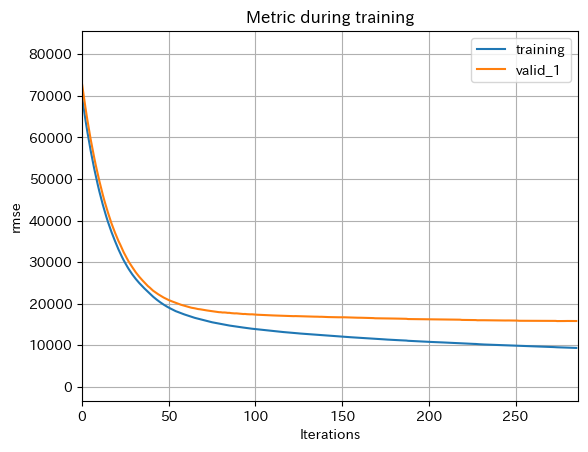

importance
面積               4.625630e+14
L                3.996755e+14
平均地価             2.035021e+14
最寄り駅             9.300646e+13
築年数              7.312012e+13
所在地              4.215061e+13
全体の階数            3.296551e+13
契約期間             1.519811e+13
所在階              9.798493e+12
所要時間             6.457996e+12
定期借家             2.140008e+12
部屋数              1.677066e+12
D                4.456093e+11
100m^2以上         3.633193e+11
50m^2以上75m^2未満   1.673828e+11
75m^2以上100m^2未満  1.645114e+11
S                1.219197e+11
K                4.897831e+10

In [7]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

「バス・トイレ別」のみ抜いた場合

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
washlets = pd.read_csv('../data/handmade_data/washlets.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], washlets, buildings, over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']],test_washlets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K', 'S', '温水洗浄便座','建物構造','100m^2以上', '75m^2以上100m^2未満']

In [12]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=1000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [13]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-16 08:15:39,966] A new study created in memory with name: no-name-85773a7f-7aea-4c3a-a400-8272dd3b6a7b
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is d

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2838
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48788	valid_1's rmse: 50195.8
[20]	training's rmse: 34383.5	valid_1's rmse: 37792.1
[30]	training's rmse: 25993.5	valid_1's rmse: 31062.8
[40]	training's rmse: 20855.7	valid_1's rmse: 27261.4
[50]	training's rmse: 17592.2	valid_1's rmse: 25017.4
[60]	training's rmse: 15611.8	valid_1's rmse: 23654.2
[70]	training's rmse: 14259.3	valid_1's rmse: 22813.2
[80]	training's rmse: 13257.5	valid_1's rmse: 22160.2
[90]	training's rmse: 12526.5	valid_1's rmse: 21753.4
[100]	training's rmse: 11902.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48988.3	valid_1's rmse: 49544.9
[20]	training's rmse: 34937.6	valid_1's rmse: 36031.2
[30]	training's rmse: 26952.2	valid_1's rmse: 28549.4
[40]	training's rmse: 22302.7	valid_1's rmse: 24260.2
[50]	training's rmse: 19314.4	valid_1's rmse: 21461.1
[60]	training's rmse: 17618.7	valid_1's rmse: 20084.1
[70]	training's rmse: 16435.1	valid_1's rmse: 19199.7
[80]	training's rmse: 15539.2	valid_1's rmse: 18635.7
[90]	training's rmse: 14859.3	valid_1's rmse: 18401.8
[100]	training's rmse: 14251.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49042.7	valid_1's rmse: 48424.6
[20]	training's rmse: 35383.3	valid_1's rmse: 33962.5
[30]	training's rmse: 27228.4	valid_1's rmse: 26061.8
[40]	training's rmse: 22418.5	valid_1's rmse: 21753.1
[50]	training's rmse: 19360.3	valid_1's rmse: 19327.7
[60]	training's rmse: 17413.7	valid_1's rmse: 18054.8
[70]	training's rmse: 16265.8	valid_1's rmse: 17299.6
[80]	training's rmse: 15410.4	valid_1's rmse: 16851.2
[90]	training's rmse: 14733.1	valid_1's rmse: 16556.6
[100]	training's rmse: 14239.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49249.1	valid_1's rmse: 48182.9
[20]	training's rmse: 35073.9	valid_1's rmse: 35216.9
[30]	training's rmse: 26790.5	valid_1's rmse: 28181.8
[40]	training's rmse: 21895.6	valid_1's rmse: 24429.7
[50]	training's rmse: 18753.8	valid_1's rmse: 22507.3
[60]	training's rmse: 16910.1	valid_1's rmse: 21415.2
[70]	training's rmse: 15791	valid_1's rmse: 20803.3
[80]	training's rmse: 14985.7	valid_1's rmse: 20340.5
[90]	training's rmse: 14361.2	valid_1's rmse: 20036.1
[100]	training's rmse: 13836.3	valid_1's rmse: 19752
[110]	training's rmse: 13442.4	valid_1's rmse: 19569.5
[120]	training's rmse: 13058.5	valid_1's rmse: 19386.5
[130]	training's rmse: 12704.7	valid_1's rmse: 19231.2
[140]	training's rmse: 12363.5	valid_1's rmse: 19111.8
[150]	training's rmse: 12087.9	valid_1's rmse: 19041.4
[160]	training's rmse: 11807.8	valid_1's rmse: 18957.1
[170]	training's rmse: 11588.6	valid_1's rmse: 18890
[180]	training's rmse: 11380.8	valid_1's rmse: 18853.1
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48673.4	valid_1's rmse: 50978.9
[20]	training's rmse: 34920.8	valid_1's rmse: 37043.5
[30]	training's rmse: 26914.1	valid_1's rmse: 28673.8
[40]	training's rmse: 22208.6	valid_1's rmse: 23886.5
[50]	training's rmse: 19083.8	valid_1's rmse: 21231.9
[60]	training's rmse: 17173.3	valid_1's rmse: 19820.8
[70]	training's rmse: 15935.1	valid_1's rmse: 18939.7
[80]	training's rmse: 15028.9	valid_1's rmse: 18484.5
[90]	training's rmse: 14343.9	valid_1's rmse: 18234.9
[100]	training's rmse: 13816	valid_1's 

[I 2022-09-16 08:16:00,864] Trial 0 finished with value: 16808.71961231848 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16808.71961231848.


Early stopping, best iteration is:
[269]	training's rmse: 9965.3	valid_1's rmse: 16808.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48711	valid_1's rmse: 50044.9
[20]	training's rmse: 34377.9	valid_1's rmse: 37774
[30]	training's rmse: 25946.3	valid_1's rmse: 30951.9
[40]	training's rmse: 20911.3	valid_1's rmse: 27154.1
[50]	training's rmse: 17693.2	valid_1's rmse: 24871.7
[60]	training's rmse: 15720.5	valid_1's rmse: 23468.1
[70]	training's rmse: 14338.4	valid_1's rmse: 22488.9
[80]	training's rmse: 13372.3	valid_1's rmse: 21809.9
[90]	training's rmse: 12653.9	valid_1's rmse: 21368.5
[100]	training's rmse: 12092.1	valid_1's rmse: 20965.8
[110]	training's rmse: 11585.7	valid_1's rmse: 20630
[120]	training's rmse: 11161.6	valid_1's rmse: 20330.4
[130]	training's rmse: 10795.3	valid_1's rmse: 20107.2
[140]	training's rmse: 10459.3	valid_1's rmse: 19912.6
[150]	training's rmse: 10147.2	valid_1's rmse: 19726.8
[160]	training's rmse: 9868.68	valid_1's rmse: 19549.4
[170]	training's rmse: 9627.76	valid_1's rmse: 19425.1
[180]	training's rmse: 9409.49	valid_1's rmse: 19294.7
[190]	training's rmse: 92

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2514
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48950.5	valid_1's rmse: 49755.7
[20]	training's rmse: 34862	valid_1's rmse: 36343.8
[30]	training's rmse: 26601.5	valid_1's rmse: 29031.7
[40]	training's rmse: 21847	valid_1's rmse: 24829.8
[50]	training's rmse: 18856.4	valid_1's rmse: 22042.2
[60]	training's rmse: 17020.9	valid_1's rmse: 20661.8
[70]	training's rmse: 15757.6	valid_1's rmse: 19757.6
[80]	training's rmse: 14774.8	valid_1's rmse: 19252
[90]	training's rmse: 14041.6	valid_1's rmse: 19034.4
[100]	training's rmse: 13435.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48876.4	valid_1's rmse: 48686.2
[20]	training's rmse: 34930.5	valid_1's rmse: 34352.1
[30]	training's rmse: 26736.6	valid_1's rmse: 26654.4
[40]	training's rmse: 22086.8	valid_1's rmse: 22557.6
[50]	training's rmse: 19039.5	valid_1's rmse: 20275.8
[60]	training's rmse: 17126.9	valid_1's rmse: 19022.7
[70]	training's rmse: 15942.1	valid_1's rmse: 18316.8
[80]	training's rmse: 15037.4	valid_1's rmse: 17872.3
[90]	training's rmse: 14319.7	valid_1's rmse: 17639.4
[100]	training's rmse: 13757.7	valid_1's rmse: 17426.2
[110]	training's rmse: 13294.6	valid_1's rmse: 17316.7
[120]	training's rmse: 12889	valid_1's rmse: 17273.6
[130]	training's rmse: 12507.1	valid_1's rmse: 17242.7
[140]	training's rmse: 12131.3	valid_1's rmse: 17253.1
[150]	training's rmse: 11798.1	valid_1's rmse: 17210.5
[160]	training's rmse: 11524.2	valid_1's rmse: 17182.9
[170]	training's rmse: 11231	valid_1's rmse: 17183.3
Early stopping, best iteration is:
[164]	training's rmse: 11405.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49174	valid_1's rmse: 48040.6
[20]	training's rmse: 34767.4	valid_1's rmse: 35478.1
[30]	training's rmse: 26422.3	valid_1's rmse: 28580.8
[40]	training's rmse: 21571.8	valid_1's rmse: 24766.3
[50]	training's rmse: 18563.4	valid_1's rmse: 22869.4
[60]	training's rmse: 16662	valid_1's rmse: 21932.6
[70]	training's rmse: 15401	valid_1's rmse: 21374.8
[80]	training's rmse: 14522.3	valid_1's rmse: 20965.4
[90]	training's rmse: 13866.7	valid_1's rmse: 20570.3
[100]	training's rmse: 13338.6	valid_1's rmse: 20343
[110]	training's rmse: 12902.3	valid_1's rmse: 20136.1
[120]	training's rmse: 12544.4	valid_1's rmse: 20025.8
[130]	training's rmse: 12212	valid_1's rmse: 19898
[140]	training's rmse: 11902.3	valid_1's rmse: 19832.5
[150]	training's rmse: 11619	valid_1's rmse: 19795.8
[160]	training's rmse: 11331.3	valid_1's rmse: 19746.7
[170]	training's rmse: 11089.7	valid_1's rmse: 19695.4
[180]	training's rmse: 10852.8	valid_1's rmse: 19674.5
[190]	training's rmse: 10642.7	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 34990.9	valid_1's rmse: 36894.9
[30]	training's rmse: 26809.4	valid_1's rmse: 28360.2
[40]	training's rmse: 22248.7	valid_1's rmse: 23581.7
[50]	training's rmse: 19092.9	valid_1's rmse: 20920.4
[60]	training's rmse: 17112.2	valid_1's rmse: 19697.8
[70]	training's rmse: 15793.6	valid_1's rmse: 18931
[80]	training's rmse: 14884.7	valid_1's rmse: 18464.8
[90]	training's rmse: 14198.4	valid_1's rmse: 18198.9
[100]	training's rmse: 13689.3	valid_1's rmse: 17960.2
[110]	training's rmse: 13259.1	valid_1's rmse: 17756.2
[120]	training's rmse: 12879.1	valid_1's rmse: 17622.9
[130]	training's rmse: 12540.8	valid_1's rmse: 17515.6
[140]	training's rmse: 12223.7	valid_1's rmse: 17438.6
[150]	training's rmse: 11921.9	valid_1's rmse: 17380.8
[160]	training's rmse: 11640.8	valid_1's rmse: 17318
[170]	training's rmse: 11369.5	valid_1's rmse: 17265.3
[180]	training's rmse: 11093	valid_1's rmse: 17208.2
[190]	training's rmse: 10850	valid_1's rmse: 17142.6
[200]	training's rmse: 106

[I 2022-09-16 08:16:17,791] Trial 1 finished with value: 16762.193346070493 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 1 with value: 16762.193346070493.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3001
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48378.5	valid_1's rmse: 50016.7
[20]	training's rmse: 33944.1	valid_1's rmse: 37695.2
[30]	training's rmse: 25523	valid_1's rmse: 30866.1
[40]	training's rmse: 20591.7	valid_1's rmse: 27116
[50]	training's rmse: 17296.3	valid_1's rmse: 24681.1
[60]	training's rmse: 15265	valid_1's rmse: 23182.1
[70]	training's rmse: 13883.4	valid_1's rmse: 22165.8
[80]	training's rmse: 12905.4	valid_1's rmse: 21514.5
[90]	training's rmse: 12195.6	valid_1's rmse: 21046.4
[100]	training's rmse: 11666.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48757.1	valid_1's rmse: 49592
[20]	training's rmse: 34582	valid_1's rmse: 36067.9
[30]	training's rmse: 26609.9	valid_1's rmse: 28790.6
[40]	training's rmse: 21968.7	valid_1's rmse: 24437.2
[50]	training's rmse: 19055.9	valid_1's rmse: 21471.9
[60]	training's rmse: 17343.2	valid_1's rmse: 19992.5
[70]	training's rmse: 16048.8	valid_1's rmse: 18884.6
[80]	training's rmse: 15035.6	valid_1's rmse: 18290.7
[90]	training's rmse: 14223.2	valid_1's rmse: 17960.8
[100]	training's rmse: 13573.3	valid_1's rmse: 17756.3
[110]	training's rmse: 13055.5	valid_1's rmse: 17662.7
[120]	training's rmse: 12640.2	valid_1's rmse: 17600.5
[130]	training's rmse: 12244.8	valid_1's rmse: 17563.6
[140]	training's rmse: 11889.9	valid_1's rmse: 17524.4
[150]	training's rmse: 11589.5	valid_1's rmse: 17522.9
[160]	training's rmse: 11283.6	valid_1's rmse: 17453.9
[170]	training's rmse: 11060.2	valid_1's rmse: 17387
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3001
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48764	valid_1's rmse: 48282.6
[20]	training's rmse: 34813.3	valid_1's rmse: 33741.4
[30]	training's rmse: 26580.8	valid_1's rmse: 25975
[40]	training's rmse: 21775.5	valid_1's rmse: 21741.4
[50]	training's rmse: 18689.6	valid_1's rmse: 19481.8
[60]	training's rmse: 16842.5	valid_1's rmse: 18335.4
[70]	training's rmse: 15645.1	valid_1's rmse: 17629.9
[80]	training's rmse: 14819.7	valid_1's rmse: 17257.2
[90]	training's rmse: 14151.8	valid_1's rmse: 17058.6
[100]	training's rmse: 13622	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48815	valid_1's rmse: 47923
[20]	training's rmse: 34377.2	valid_1's rmse: 35392.4
[30]	training's rmse: 25929.4	valid_1's rmse: 28330.8
[40]	training's rmse: 21174.4	valid_1's rmse: 24715.4
[50]	training's rmse: 18089.2	valid_1's rmse: 22984.3
[60]	training's rmse: 16221.6	valid_1's rmse: 22106.4
[70]	training's rmse: 15124.3	valid_1's rmse: 21535.7
[80]	training's rmse: 14336.6	valid_1's rmse: 21068.7
[90]	training's rmse: 13745.3	valid_1's rmse: 20701.1
[100]	training's rmse: 13241.8	valid_1's rmse: 20480
[110]	training's rmse: 12829.2	valid_1's rmse: 20248.8
[120]	training's rmse: 12463	valid_1's rmse: 20078.2
[130]	training's rmse: 12155.2	valid_1's rmse: 19986.7
[140]	training's rmse: 11856	valid_1's rmse: 19819
[150]	training's rmse: 11556.1	valid_1's rmse: 19719.9
[160]	training's rmse: 11250.1	valid_1's rmse: 19616.8
[170]	training's rmse: 10982.5	valid_1's rmse: 19546.4
[180]	training's rmse: 10761.5	valid_1's rmse: 19483.7
[190]	training's rmse: 10541	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48298.8	valid_1's rmse: 50747.5
[20]	training's rmse: 34452.5	valid_1's rmse: 36820.3
[30]	training's rmse: 26318.7	valid_1's rmse: 28589.6
[40]	training's rmse: 21650.8	valid_1's rmse: 23810.6
[50]	training's rmse: 18504.6	valid_1's rmse: 20904.6
[60]	training's rmse: 16641.8	valid_1's rmse: 19534.4
[70]	training's rmse: 15532.7	valid_1's rmse: 18771.5
[80]	training's rmse: 14587.2	valid_1's rmse: 18332
[90]	training's rmse: 13915.1	valid_1's rmse: 18105.3
[100]	training's rmse: 13416.3	valid_1's rmse: 17964.2
[110]	training's rmse: 12973.2	valid_1's rmse: 17839.7
[120]	training's rmse: 12644.2	valid_1's rmse: 17800.7
[130]	training's rmse: 12300.9	valid_1's rmse: 17750.8
[140]	training's rmse: 11994.9	valid_1's rmse: 17701.1
[150]	training's rmse: 11746.3	valid_1's rmse: 17660.3
[160]	training's rmse: 11493.2	valid_1's rmse: 17636.6
[170]	training's rmse: 11273.9	valid_1's rmse: 17613.8
[180]	training's rmse: 11067.4	valid_1's rmse: 17583.6
[190]	training's rmse

[I 2022-09-16 08:16:32,887] Trial 2 finished with value: 17406.878426944 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 1 with value: 16762.193346070493.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/ve

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48774.3	valid_1's rmse: 50288.6
[20]	training's rmse: 34403.8	valid_1's rmse: 37901.9
[30]	training's rmse: 26098.4	valid_1's rmse: 31071.5
[40]	training's rmse: 21015.2	valid_1's rmse: 27254.1
[50]	training's rmse: 17713.3	valid_1's rmse: 24854.9
[60]	training's rmse: 15729.1	valid_1's rmse: 23391.9
[70]	training's rmse: 14301.9	valid_1's rmse: 22409
[80]	training's rmse: 13309.8	valid_1's rmse: 21732.2
[90]	training's rmse: 12614.6	valid_1's rmse: 21304
[100]	training's rmse: 11986.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2911
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932.9	valid_1's rmse: 49517.4
[20]	training's rmse: 34837.3	valid_1's rmse: 36446
[30]	training's rmse: 26836	valid_1's rmse: 29044.3
[40]	training's rmse: 22067.8	valid_1's rmse: 24511
[50]	training's rmse: 19148.9	valid_1's rmse: 21523.3
[60]	training's rmse: 17418.3	valid_1's rmse: 19906.2
[70]	training's rmse: 16249	valid_1's rmse: 18942.2
[80]	training's rmse: 15354.2	valid_1's rmse: 18270.7
[90]	training's rmse: 14653.3	valid_1's rmse: 18004.6
[100]	training's rmse: 14137.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49064.1	valid_1's rmse: 48623.9
[20]	training's rmse: 35247.6	valid_1's rmse: 34058.4
[30]	training's rmse: 27045.5	valid_1's rmse: 26050.9
[40]	training's rmse: 22366.8	valid_1's rmse: 21848.8
[50]	training's rmse: 19376.1	valid_1's rmse: 19406.6
[60]	training's rmse: 17485.8	valid_1's rmse: 18256.9
[70]	training's rmse: 16204.8	valid_1's rmse: 17523.9
[80]	training's rmse: 15296.3	valid_1's rmse: 17129.3
[90]	training's rmse: 14652	valid_1's rmse: 16916.7
[100]	training's rmse: 14158	valid_1's rmse: 16708.1
[110]	training's rmse: 13718.1	valid_1's rmse: 16537.4
[120]	training's rmse: 13274.1	valid_1's rmse: 16377.6
[130]	training's rmse: 12897.9	valid_1's rmse: 16285.1
[140]	training's rmse: 12561.5	valid_1's rmse: 16202.6
[150]	training's rmse: 12241.3	valid_1's rmse: 16132.2
[160]	training's rmse: 11975.4	valid_1's rmse: 16082.7
[170]	training's rmse: 11716.5	valid_1's rmse: 16065.2
[180]	training's rmse: 11486.5	valid_1's rmse: 16021.3
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2913
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49231.4	valid_1's rmse: 48194
[20]	training's rmse: 35064.2	valid_1's rmse: 35281.1
[30]	training's rmse: 26597.6	valid_1's rmse: 28155.6
[40]	training's rmse: 21769.6	valid_1's rmse: 24350.8
[50]	training's rmse: 18728.4	valid_1's rmse: 22447.7
[60]	training's rmse: 16894.4	valid_1's rmse: 21379.7
[70]	training's rmse: 15717.1	valid_1's rmse: 20769
[80]	training's rmse: 14894.7	valid_1's rmse: 20228.2
[90]	training's rmse: 14257.2	valid_1's rmse: 19776.8
[100]	training's rmse: 13699.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 34962.1	valid_1's rmse: 37023.7
[30]	training's rmse: 27014.5	valid_1's rmse: 28952.2
[40]	training's rmse: 22315.8	valid_1's rmse: 24168.2
[50]	training's rmse: 19178.4	valid_1's rmse: 21369
[60]	training's rmse: 17344.2	valid_1's rmse: 20023.6
[70]	training's rmse: 16070.4	valid_1's rmse: 19328.7
[80]	training's rmse: 15130.4	valid_1's rmse: 18923.1
[90]	training's rmse: 14438.3	valid_1's rmse: 18702.8
[100]	training's rmse: 13907.7	valid_1's rmse: 18526.9
[110]	training's rmse: 13484.2	valid_1's rmse: 18397.1
[120]	training's rmse: 13107.2	valid_1's rmse: 18302.8
[130]	training's rmse: 12787.5	valid_1's rmse: 18260.2
[140]	training's rmse: 12503.8	valid_1's rmse: 18220.8
[150]	training's rmse: 12230.6	valid_1's rmse: 18158.8
[160]	training's rmse: 12004.8	valid_1's rmse: 18103.1
[170]	training's rmse: 11777	valid_1's rmse: 18063.5
[180]	training's rmse: 11568.2	valid_1's rmse: 18030.9
[190]	training's rmse: 11366.4	valid_1's rmse: 18022.8
[200]	training's rmse:

[I 2022-09-16 08:16:45,354] Trial 3 finished with value: 17705.256994968706 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 1 with value: 16762.193346070493.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49296.3	valid_1's rmse: 50765.7
[20]	training's rmse: 35101.9	valid_1's rmse: 38516.8
[30]	training's rmse: 26757.2	valid_1's rmse: 31777
[40]	training's rmse: 21748.1	valid_1's rmse: 27834.4
[50]	training's rmse: 18531.9	valid_1's rmse: 25369.9
[60]	training's rmse: 16525.2	valid_1's rmse: 23835.7
[70]	training's rmse: 15158.6	valid_1's rmse: 22865.1
[80]	training's rmse: 14194.9	valid_1's rmse: 22210.5
[90]	training's rmse: 13515.5	valid_1's rmse: 21765
[100]	training's rmse: 12954.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49469.2	valid_1's rmse: 50081.7
[20]	training's rmse: 35542.2	valid_1's rmse: 36718.5
[30]	training's rmse: 27623.8	valid_1's rmse: 29400.3
[40]	training's rmse: 22881	valid_1's rmse: 24785.6
[50]	training's rmse: 19989.4	valid_1's rmse: 21911.9
[60]	training's rmse: 18261.4	valid_1's rmse: 20368.4
[70]	training's rmse: 17040.2	valid_1's rmse: 19316.9
[80]	training's rmse: 16134.1	valid_1's rmse: 18603.1
[90]	training's rmse: 15349.2	valid_1's rmse: 18186.1
[100]	training's rmse: 14754	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49539.4	valid_1's rmse: 49111.1
[20]	training's rmse: 35812	valid_1's rmse: 34792.7
[30]	training's rmse: 27761.2	valid_1's rmse: 26860.7
[40]	training's rmse: 22890.4	valid_1's rmse: 22582.3
[50]	training's rmse: 19908.7	valid_1's rmse: 20191.9
[60]	training's rmse: 18024.9	valid_1's rmse: 18880
[70]	training's rmse: 16839.2	valid_1's rmse: 18127.2
[80]	training's rmse: 15947.2	valid_1's rmse: 17702.9
[90]	training's rmse: 15288.4	valid_1's rmse: 17378.8
[100]	training's rmse: 14751.8	valid_1's rmse: 17183.6
[110]	training's rmse: 14307.2	valid_1's rmse: 17005
[120]	training's rmse: 13926.8	valid_1's rmse: 16899.7
[130]	training's rmse: 13559.2	valid_1's rmse: 16796.5
[140]	training's rmse: 13200.9	valid_1's rmse: 16739.2
[150]	training's rmse: 12885.8	valid_1's rmse: 16651.2
[160]	training's rmse: 12613.9	valid_1's rmse: 16596.3
[170]	training's rmse: 12365	valid_1's rmse: 16573.3
[180]	training's rmse: 12147.1	valid_1's rmse: 16550.3
[190]	training's rmse: 1193

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 35462.9	valid_1's rmse: 36189.6
[30]	training's rmse: 27077.4	valid_1's rmse: 29248.5
[40]	training's rmse: 22307.8	valid_1's rmse: 25611
[50]	training's rmse: 19284.6	valid_1's rmse: 23584.7
[60]	training's rmse: 17524.5	valid_1's rmse: 22421.9
[70]	training's rmse: 16352.3	valid_1's rmse: 21712.3
[80]	training's rmse: 15553.7	valid_1's rmse: 21187.6
[90]	training's rmse: 14935.9	valid_1's rmse: 20782.1
[100]	training's rmse: 14429.7	valid_1's rmse: 20480
[110]	training's rmse: 14009	valid_1's rmse: 20204.3
[120]	training's rmse: 13648.1	valid_1's rmse: 20060.2
[130]	training's rmse: 13331.1	valid_1's rmse: 19893
[140]	training's rmse: 12968.8	valid_1's rmse: 19733.5
[150]	training's rmse: 12702.7	valid_1's rmse: 19617.2
[160]	training's rmse: 12473.8	valid_1's rmse: 19514.7
[170]	training's rmse: 12224.7	valid_1's rmse: 19424.8
[180]	training's rmse: 12016.8	valid_1's rmse: 19327.8
[190]	training's rmse: 11825.6	valid_1's rmse: 19260.8
[200]	training's rmse: 116

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49141	valid_1's rmse: 51587.6
[20]	training's rmse: 35606.1	valid_1's rmse: 37674.2
[30]	training's rmse: 27797.2	valid_1's rmse: 29487.5
[40]	training's rmse: 23043.4	valid_1's rmse: 24528.3
[50]	training's rmse: 19966	valid_1's rmse: 21749.1
[60]	training's rmse: 18128.6	valid_1's rmse: 20131.4
[70]	training's rmse: 16796.1	valid_1's rmse: 19279.9
[80]	training's rmse: 15889.6	valid_1's rmse: 18815.1
[90]	training's rmse: 15240.6	valid_1's rmse: 18540.2
[100]	training's rmse: 14717.9	valid_1's rmse: 18318.3
[110]	training's rmse: 14253.2	valid_1's rmse: 18162.6
[120]	training's rmse: 13868.7	valid_1's rmse: 18059.6
[130]	training's rmse: 13512	valid_1's rmse: 17955.7
[140]	training's rmse: 13183.4	valid_1's rmse: 17905.8
[150]	training's rmse: 12882.6	valid_1's rmse: 17847.2
[160]	training's rmse: 12651.5	valid_1's rmse: 17834.8
[170]	training's rmse: 12408.9	valid_1's rmse: 17808.4
[180]	training's rmse: 12201.6	valid_1's rmse: 17777.8
[190]	training's rmse: 11

[I 2022-09-16 08:16:53,206] Trial 4 finished with value: 17661.93137383686 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 1 with value: 16762.193346070493.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/v

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.7	valid_1's rmse: 50302.6
[20]	training's rmse: 34492.5	valid_1's rmse: 38194.7
[30]	training's rmse: 26047	valid_1's rmse: 31524.7
[40]	training's rmse: 20929	valid_1's rmse: 27690.1
[50]	training's rmse: 17564.3	valid_1's rmse: 25330.5
[60]	training's rmse: 15556.9	valid_1's rmse: 23920.7
[70]	training's rmse: 14125.7	valid_1's rmse: 22948.7
[80]	training's rmse: 13117.4	valid_1's rmse: 22252.5
[90]	training's rmse: 12293.5	valid_1's rmse: 21656
[100]	training's rmse: 11672.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48795.8	valid_1's rmse: 49269.3
[20]	training's rmse: 34795.8	valid_1's rmse: 35881.6
[30]	training's rmse: 26651.9	valid_1's rmse: 28134.7
[40]	training's rmse: 22043.2	valid_1's rmse: 24119.5
[50]	training's rmse: 18967.2	valid_1's rmse: 21551.6
[60]	training's rmse: 17071.8	valid_1's rmse: 20078.5
[70]	training's rmse: 15751.2	valid_1's rmse: 19170
[80]	training's rmse: 14693.1	valid_1's rmse: 18605.6
[90]	training's rmse: 13889.4	valid_1's rmse: 18362.2
[100]	training's rmse: 13217.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48919.1	valid_1's rmse: 48845.7
[20]	training's rmse: 35073.9	valid_1's rmse: 34905.9
[30]	training's rmse: 26832.1	valid_1's rmse: 27172.9
[40]	training's rmse: 22172.5	valid_1's rmse: 23176.9
[50]	training's rmse: 19140.4	valid_1's rmse: 20771.3
[60]	training's rmse: 17132.7	valid_1's rmse: 19621.2
[70]	training's rmse: 15801.8	valid_1's rmse: 18994.2
[80]	training's rmse: 14762.9	valid_1's rmse: 18584.7
[90]	training's rmse: 13942.8	valid_1's rmse: 18253.1
[100]	training's rmse: 13250.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49114.4	valid_1's rmse: 47847.9
[20]	training's rmse: 34977.7	valid_1's rmse: 35228.7
[30]	training's rmse: 26481.7	valid_1's rmse: 28240.6
[40]	training's rmse: 21619.1	valid_1's rmse: 24476.5
[50]	training's rmse: 18472.2	valid_1's rmse: 22504.9
[60]	training's rmse: 16543	valid_1's rmse: 21452.8
[70]	training's rmse: 15238.7	valid_1's rmse: 20913.9
[80]	training's rmse: 14219.7	valid_1's rmse: 20438.4
[90]	training's rmse: 13463.1	valid_1's rmse: 20119.8
[100]	training's rmse: 12860.8	valid_1's rmse: 19866.6
[110]	training's rmse: 12351.3	valid_1's rmse: 19669.8
[120]	training's rmse: 11912.2	valid_1's rmse: 19397.5
[130]	training's rmse: 11494.1	valid_1's rmse: 19242.4
[140]	training's rmse: 11150.1	valid_1's rmse: 19105.1
[150]	training's rmse: 10835.3	valid_1's rmse: 18990.8
[160]	training's rmse: 10552.6	valid_1's rmse: 18883.7
[170]	training's rmse: 10276.8	valid_1's rmse: 18794.9
[180]	training'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 34816.4	valid_1's rmse: 36878.9
[30]	training's rmse: 26684.2	valid_1's rmse: 28476.5
[40]	training's rmse: 22074.7	valid_1's rmse: 23662.1
[50]	training's rmse: 18844.3	valid_1's rmse: 20802.2
[60]	training's rmse: 16918.7	valid_1's rmse: 19395.2
[70]	training's rmse: 15556.2	valid_1's rmse: 18575.8
[80]	training's rmse: 14576.9	valid_1's rmse: 18085.6
[90]	training's rmse: 13857.5	valid_1's rmse: 17818.3
[100]	training's rmse: 13260.6	valid_1's rmse: 17675.1
[110]	training's rmse: 12757.3	valid_1's rmse: 17507.5
[120]	training's rmse: 12347.2	valid_1's rmse: 17374.5
[130]	training's rmse: 11968.9	valid_1's rmse: 17297.8
[140]	training's rmse: 11590.8	valid_1's rmse: 17190
[150]	training's rmse: 11268	valid_1's rmse: 17109.2
[160]	training's rmse: 10978.5	valid_1's rmse: 16982.4
[170]	training's rmse: 10718	valid_1's rmse: 16896.2
[180]	training's rmse: 10475.6	valid_1's rmse: 16793.4
[190]	training's rmse: 10268	valid_1's rmse: 16718.9
[200]	training's rmse: 100

[I 2022-09-16 08:17:04,686] Trial 5 finished with value: 16262.494111967791 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 5 with value: 16262.494111967791.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48394	valid_1's rmse: 50057.2
[20]	training's rmse: 33949.3	valid_1's rmse: 37693.1
[30]	training's rmse: 25532.1	valid_1's rmse: 30863
[40]	training's rmse: 20557.7	valid_1's rmse: 27035.3
[50]	training's rmse: 17252.3	valid_1's rmse: 24561.1
[60]	training's rmse: 15256.3	valid_1's rmse: 23028.8
[70]	training's rmse: 13864.4	valid_1's rmse: 22008.9
[80]	training's rmse: 12888.6	valid_1's rmse: 21334.8
[90]	training's rmse: 12183	valid_1's rmse: 20875.3
[100]	training's rmse: 11627.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2986
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48753.7	valid_1's rmse: 49587.2
[20]	training's rmse: 34598.7	valid_1's rmse: 35974.5
[30]	training's rmse: 26594.1	valid_1's rmse: 28697.7
[40]	training's rmse: 21990.3	valid_1's rmse: 24353.4
[50]	training's rmse: 18922	valid_1's rmse: 21210.8
[60]	training's rmse: 17217	valid_1's rmse: 19524.3
[70]	training's rmse: 15998.8	valid_1's rmse: 18654.9
[80]	training's rmse: 14975.7	valid_1's rmse: 17988
[90]	training's rmse: 14225.3	valid_1's rmse: 17620.8
[100]	training's rmse: 13577.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48739	valid_1's rmse: 48269.2
[20]	training's rmse: 34768.5	valid_1's rmse: 33688.6
[30]	training's rmse: 26540.1	valid_1's rmse: 26040.1
[40]	training's rmse: 21810	valid_1's rmse: 21843.7
[50]	training's rmse: 18671.8	valid_1's rmse: 19553.6
[60]	training's rmse: 16801.3	valid_1's rmse: 18361.4
[70]	training's rmse: 15607.4	valid_1's rmse: 17756.3
[80]	training's rmse: 14788.8	valid_1's rmse: 17350.4
[90]	training's rmse: 14126	valid_1's rmse: 17150.9
[100]	training's rmse: 13584.3	valid_1's rmse: 16990.9
[110]	training's rmse: 13115.9	valid_1's rmse: 16908.2
[120]	training's rmse: 12661.8	valid_1's rmse: 16815.8
[130]	training's rmse: 12261.7	valid_1's rmse: 16723
[140]	training's rmse: 11918.4	valid_1's rmse: 16643.9
[150]	training's rmse: 11619.2	valid_1's rmse: 16613.1
[160]	training's rmse: 11345.6	valid_1's rmse: 16571.6
[170]	training's rmse: 11080.3	valid_1's rmse: 16536.2
[180]	training's rmse: 10854.2	valid_1's rmse: 16505.7
[190]	training's rmse: 1064

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48776.9	valid_1's rmse: 47827.2
[20]	training's rmse: 34328.2	valid_1's rmse: 35233.8
[30]	training's rmse: 25890.9	valid_1's rmse: 28176.8
[40]	training's rmse: 21011.2	valid_1's rmse: 24617.2
[50]	training's rmse: 18010.4	valid_1's rmse: 22745
[60]	training's rmse: 16195.8	valid_1's rmse: 21740
[70]	training's rmse: 15084.2	valid_1's rmse: 21120.4
[80]	training's rmse: 14274.6	valid_1's rmse: 20643.4
[90]	training's rmse: 13683.2	valid_1's rmse: 20314.6
[100]	training's rmse: 13220.6	valid_1's rmse: 20075.7
[110]	training's rmse: 12861.9	valid_1's rmse: 19939.5
[120]	training's rmse: 12394.4	valid_1's rmse: 19806.3
[130]	training's rmse: 12041.6	valid_1's rmse: 19632.7
[140]	training's rmse: 11712.2	valid_1's rmse: 19515.1
[150]	training's rmse: 11435.1	valid_1's rmse: 19441.1
[160]	training's rmse: 11187.3	valid_1's rmse: 19361.3
[170]	training's rmse: 10935.1	valid_1's rmse: 19312.8
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2986
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48296.6	valid_1's rmse: 50777.4
[20]	training's rmse: 34339.4	valid_1's rmse: 36679.7
[30]	training's rmse: 26266	valid_1's rmse: 28486.2
[40]	training's rmse: 21571.4	valid_1's rmse: 23691.6
[50]	training's rmse: 18426.1	valid_1's rmse: 20793.2
[60]	training's rmse: 16615.2	valid_1's rmse: 19340.6
[70]	training's rmse: 15457.8	valid_1's rmse: 18579.1
[80]	training's rmse: 14587.5	valid_1's rmse: 18167.2
[90]	training's rmse: 13936.4	valid_1's rmse: 17928.2
[100]	training's rmse: 13423.7	valid_1's rmse: 17760.9
[110]	training's rmse: 12991.1	valid_1's rmse: 176

[I 2022-09-16 08:17:19,422] Trial 6 finished with value: 17129.91238666398 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 5 with value: 16262.494111967791.


Early stopping, best iteration is:
[338]	training's rmse: 8928.25	valid_1's rmse: 17129.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48728.2	valid_1's rmse: 50389.6
[20]	training's rmse: 34324.9	valid_1's rmse: 38048.1
[30]	training's rmse: 25906.1	valid_1's rmse: 31190.7
[40]	training's rmse: 20906.8	valid_1's rmse: 27397.1
[50]	training's rmse: 17620.1	valid_1's rmse: 24971.4
[60]	training's rmse: 15582.6	valid_1's rmse: 23507.2
[70]	training's rmse: 14212	valid_1's rmse: 22498.4
[80]	training's rmse: 13240.4	valid_1's rmse: 21800.6
[90]	training's rmse: 12506.6	valid_1's rmse: 21231
[100]	training's rmse: 11891.2	valid_1's rmse: 20793.2
[110]	training's rmse: 11411.2	valid_1's rmse: 20432.2
[120]	training's rmse: 10990.2	valid_1's rmse: 20096.9
[130]	training's rmse: 10618.5	valid_1's rmse: 19847.9
[140]	training's rmse: 10284.2	valid_1's rmse: 19630.7
[150]	training's rmse: 9974.99	valid_1's rmse: 19449.9
[160]	training's rmse: 9720.29	valid_1's rmse: 19279.1
[170]	training's rmse: 9484.45	valid_1's rmse: 19160.3
[180]	training's rmse: 9258.27	valid_1's rmse: 19047.4
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2566
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48862.8	valid_1's rmse: 49592.1
[20]	training's rmse: 34732.2	valid_1's rmse: 36105.1
[30]	training's rmse: 26544.2	valid_1's rmse: 28625
[40]	training's rmse: 21700.4	valid_1's rmse: 24493.2
[50]	training's rmse: 18680.8	valid_1's rmse: 21673
[60]	training's rmse: 16908.8	valid_1's rmse: 20174
[70]	training's rmse: 15656.2	valid_1's rmse: 19319.9
[80]	training's rmse: 14663.9	valid_1's rmse: 18749.4
[90]	training's rmse: 13886.6	valid_1's rmse: 18396.5
[100]	training's rmse: 13290.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 34834.8	valid_1's rmse: 34174.6
[30]	training's rmse: 26624.4	valid_1's rmse: 26460.9
[40]	training's rmse: 22018.3	valid_1's rmse: 22422.4
[50]	training's rmse: 19077.5	valid_1's rmse: 20072
[60]	training's rmse: 17126	valid_1's rmse: 18917.3
[70]	training's rmse: 15907.3	valid_1's rmse: 18257.4
[80]	training's rmse: 15009.9	valid_1's rmse: 17821.3
[90]	training's rmse: 14269.9	valid_1's rmse: 17479
[100]	training's rmse: 13676.1	valid_1's rmse: 17257.7
[110]	training's rmse: 13203.1	valid_1's rmse: 17174.1
[120]	training's rmse: 12787.5	valid_1's rmse: 17129.3
[130]	training's rmse: 12415.6	valid_1's rmse: 17091.2
[140]	training's rmse: 12060.4	valid_1's rmse: 17025
[150]	training's rmse: 11701	valid_1's rmse: 17029.9
[160]	training's rmse: 11398.8	valid_1's rmse: 16985.8
[170]	training's rmse: 11129.3	valid_1's rmse: 16948.1
[180]	training's rmse: 10842.5	valid_1's rmse: 16973.2
Early stopping, best iteration is:
[177]	training's rmse: 10939.5	valid_1's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49178.6	valid_1's rmse: 47908.1
[20]	training's rmse: 34772.8	valid_1's rmse: 35284.8
[30]	training's rmse: 26262.6	valid_1's rmse: 28337.8
[40]	training's rmse: 21429.6	valid_1's rmse: 24907.4
[50]	training's rmse: 18415.1	valid_1's rmse: 23063.4
[60]	training's rmse: 16610	valid_1's rmse: 22017.5
[70]	training's rmse: 15390.4	valid_1's rmse: 21499.7
[80]	training's rmse: 14452	valid_1's rmse: 21182.4
[90]	training's rmse: 13789.3	valid_1's rmse: 20918.9
[100]	training's rmse: 13258.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48607.3	valid_1's rmse: 50950.4
[20]	training's rmse: 34939.9	valid_1's rmse: 36906.7
[30]	training's rmse: 26820.6	valid_1's rmse: 28709.9
[40]	training's rmse: 22266.9	valid_1's rmse: 24054.8
[50]	training's rmse: 19088.5	valid_1's rmse: 21528.1
[60]	training's rmse: 17229.5	valid_1's rmse: 20134.6
[70]	training's rmse: 15870.2	valid_1's rmse: 19215.2
[80]	training's rmse: 14986.2	valid_1's rmse: 18696.9
[90]	training's rmse: 14317.1	valid_1's rmse: 18319
[100]	training's rmse: 13751.2	valid_1's 

[I 2022-09-16 08:17:33,638] Trial 7 finished with value: 16691.758542177577 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 5 with value: 16262.494111967791.


[290]	training's rmse: 9185.78	valid_1's rmse: 16700.8
Early stopping, best iteration is:
[286]	training's rmse: 9253.97	valid_1's rmse: 16691.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2765
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49224.8	valid_1's rmse: 50626.2
[20]	training's rmse: 35175.9	valid_1's rmse: 38387.3
[30]	training's rmse: 27006.7	valid_1's rmse: 31774.9
[40]	training's rmse: 21817.7	valid_1's rmse: 27783.3
[50]	training's rmse: 18517.7	valid_1's rmse: 25371.6
[60]	training's rmse: 16515.3	valid_1's rmse: 23940.5
[70]	training's rmse: 15095.3	valid_1's rmse: 22963
[80]	training's rmse: 14141.8	valid_1's rmse: 22340.2
[90]	training's rmse: 13416.8	valid_1's rmse: 21898.3
[100]	training's rmse: 12852.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2766
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49364.5	valid_1's rmse: 50030.5
[20]	training's rmse: 35517.1	valid_1's rmse: 36515.1
[30]	training's rmse: 27615.8	valid_1's rmse: 29177.5
[40]	training's rmse: 22685.9	valid_1's rmse: 24636.3
[50]	training's rmse: 19833.6	valid_1's rmse: 22041.9
[60]	training's rmse: 18012.4	valid_1's rmse: 20438.2
[70]	training's rmse: 16831.3	valid_1's rmse: 19588.6
[80]	training's rmse: 15924.3	valid_1's rmse: 19057.3
[90]	training's rmse: 15227.2	valid_1's rmse: 18795.2
[100]	training's rmse: 14681.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49473.2	valid_1's rmse: 48825.3
[20]	training's rmse: 35943.3	valid_1's rmse: 34527.1
[30]	training's rmse: 27860.2	valid_1's rmse: 26597.3
[40]	training's rmse: 23004	valid_1's rmse: 22304.1
[50]	training's rmse: 19971.9	valid_1's rmse: 19826.5
[60]	training's rmse: 18036.2	valid_1's rmse: 18507.2
[70]	training's rmse: 16826.9	valid_1's rmse: 17739.4
[80]	training's rmse: 15973.9	valid_1's rmse: 17204.2
[90]	training's rmse: 15348.6	valid_1's rmse: 16954.4
[100]	training's rmse: 14834.5	valid_1's rmse: 16693.2
[110]	training's rmse: 14396.6	valid_1's rmse: 16521.3
[120]	training's rmse: 14037.2	valid_1's rmse: 16363
[130]	training's rmse: 13636	valid_1's rmse: 16278.9
[140]	training's rmse: 13317.7	valid_1's rmse: 16181.7
[150]	training's rmse: 13037.4	valid_1's rmse: 16103.2
[160]	training's rmse: 12773.7	valid_1's rmse: 16040
[170]	training's rmse: 12547.4	valid_1's rmse: 15980
[180]	training's rmse: 12305.3	valid_1's rmse: 15971.5
[190]	training's rmse: 12091.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2764
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49621.8	valid_1's rmse: 48633.8
[20]	training's rmse: 35498.3	valid_1's rmse: 36053.6
[30]	training's rmse: 27274.8	valid_1's rmse: 29133.2
[40]	training's rmse: 22329.8	valid_1's rmse: 25436.8
[50]	training's rmse: 19271.1	valid_1's rmse: 23534.8
[60]	training's rmse: 17478.6	valid_1's rmse: 22438.8
[70]	training's rmse: 16321.8	valid_1's rmse: 21781.6
[80]	training's rmse: 15450.2	valid_1's rmse: 21287.9
[90]	training's rmse: 14841.3	valid_1's rmse: 20920.2
[100]	training's rmse: 14307.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2764
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49201.1	valid_1's rmse: 51526.9
[20]	training's rmse: 35704.4	valid_1's rmse: 37569.4
[30]	training's rmse: 27899.9	valid_1's rmse: 29331.7
[40]	training's rmse: 23221.4	valid_1's rmse: 24529.5
[50]	training's rmse: 20057.5	valid_1's rmse: 21911
[60]	training's rmse: 18174.2	valid_1's rmse: 20436.9
[70]	training's rmse: 16927	valid_1's rmse: 19511.5
[80]	training's rmse: 15991.3	valid_1's rmse: 19031.2
[90]	training's rmse: 15331.3	valid_1's rmse: 18736.3
[100]	training's rmse: 14766.7	valid_1's rm

[I 2022-09-16 08:17:44,565] Trial 8 finished with value: 17238.075472563967 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 5 with value: 16262.494111967791.


[300]	training's rmse: 10460.4	valid_1's rmse: 17268.2
Early stopping, best iteration is:
[294]	training's rmse: 10549.5	valid_1's rmse: 17238.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2646
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48959.3	valid_1's rmse: 50511.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 34679.7	valid_1's rmse: 38253.2
[30]	training's rmse: 26271	valid_1's rmse: 31406.2
[40]	training's rmse: 21312.8	valid_1's rmse: 27593.3
[50]	training's rmse: 18019.9	valid_1's rmse: 25181.2
[60]	training's rmse: 16038.9	valid_1's rmse: 23714.5
[70]	training's rmse: 14629.8	valid_1's rmse: 22720.9
[80]	training's rmse: 13636.7	valid_1's rmse: 21969.2
[90]	training's rmse: 12915.3	valid_1's rmse: 21485.2
[100]	training's rmse: 12278	valid_1's rmse: 21103.4
[110]	training's rmse: 11820.2	valid_1's rmse: 20750.1
[120]	training's rmse: 11418	valid_1's rmse: 20445.1
[130]	training's rmse: 11071.7	valid_1's rmse: 20226.2
[140]	training's rmse: 10727.2	valid_1's rmse: 19936.9
[150]	training's rmse: 10435.5	valid_1's rmse: 19716.5
[160]	training's rmse: 10150.2	valid_1's rmse: 19471.9
[170]	training's rmse: 9885.62	valid_1's rmse: 19308.5
[180]	training's rmse: 9655.4	valid_1's rmse: 19150.6
[190]	training's rmse: 9449.36	valid_1's rmse: 19025.1
[200]	training's rmse: 92

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49084.4	valid_1's rmse: 49685.6
[20]	training's rmse: 35030.2	valid_1's rmse: 36311.9
[30]	training's rmse: 26847.8	valid_1's rmse: 28623
[40]	training's rmse: 22053.5	valid_1's rmse: 24495.8
[50]	training's rmse: 19149.8	valid_1's rmse: 21781.6
[60]	training's rmse: 17384	valid_1's rmse: 20365.8
[70]	training's rmse: 16106.1	valid_1's rmse: 19429.3
[80]	training's rmse: 15196.3	valid_1's rmse: 18973.2
[90]	training's rmse: 14475.8	valid_1's rmse: 18666.4
[100]	training's rmse: 13931.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49151.1	valid_1's rmse: 48830.5
[20]	training's rmse: 35469.4	valid_1's rmse: 34379.2
[30]	training's rmse: 27360.6	valid_1's rmse: 26604.3
[40]	training's rmse: 22444.2	valid_1's rmse: 22382.6
[50]	training's rmse: 19449.1	valid_1's rmse: 20104.3
[60]	training's rmse: 17496.1	valid_1's rmse: 18778.5
[70]	training's rmse: 16333.5	valid_1's rmse: 18136.9
[80]	training's rmse: 15492.5	valid_1's rmse: 17667.8
[90]	training's rmse: 14815.5	valid_1's rmse: 17353.5
[100]	training's rmse: 14315.9	valid_1's rmse: 17129
[110]	training's rmse: 13869.9	valid_1's rmse: 16970
[120]	training's rmse: 13500.9	valid_1's rmse: 16896.4
[130]	training's rmse: 13157.9	valid_1's rmse: 16807.2
[140]	training's rmse: 12831	valid_1's rmse: 16753.7
[150]	training's rmse: 12549.7	valid_1's rmse: 16663
[160]	training's rmse: 12274.8	valid_1's rmse: 16622.3
[170]	training's rmse: 12010.4	valid_1's rmse: 16584.9
[180]	training's rmse: 11771.2	valid_1's rmse: 16501.5
[190]	training's rmse: 1155

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49435.6	valid_1's rmse: 48181.1
[20]	training's rmse: 35119.2	valid_1's rmse: 35515.3
[30]	training's rmse: 26659.2	valid_1's rmse: 28567.6
[40]	training's rmse: 21733.7	valid_1's rmse: 24811.9
[50]	training's rmse: 18780.6	valid_1's rmse: 22791.2
[60]	training's rmse: 16942.4	valid_1's rmse: 21623.3
[70]	training's rmse: 15745.9	valid_1's rmse: 20911.4
[80]	training's rmse: 14820.9	valid_1's rmse: 20440.6
[90]	training's rmse: 14144.3	valid_1's rmse: 20093.5
[100]	training's rmse: 13603.2	valid_1's rmse: 19801.3
[110]	training's rmse: 13143.2	valid_1's rmse: 19585.3
[120]	training's rmse: 12726.1	valid_1's rmse: 19424.4
[130]	training's rmse: 12341.2	valid_1's rmse: 19248.5
[140]	training's rmse: 12013.9	valid_1's rmse: 19127
[150]	training's rmse: 11687.8	valid_1's rmse: 18975.1
[160]	training's rmse: 11409.9	valid_1's rmse: 18871.2
[170]	training's rmse: 11165.5	valid_1's rmse: 18798.8
[180]	training'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2647
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48802.1	valid_1's rmse: 50934.1
[20]	training's rmse: 35245.6	valid_1's rmse: 36920.5
[30]	training's rmse: 27203.5	valid_1's rmse: 28603.7
[40]	training's rmse: 22644.4	valid_1's rmse: 24034.8
[50]	training's rmse: 19522.4	valid_1's rmse: 21450.6
[60]	training's rmse: 17541	valid_1's rmse: 20170.3
[70]	training's rmse: 16236.5	valid_1's rmse: 19381.4
[80]	training's rmse: 15255.8	valid_1's rmse: 18828.2
[90]	training's rmse: 14563.7	valid_1's rmse: 18508.8
[100]	training's rmse: 13975.6	valid_1's 

[I 2022-09-16 08:18:00,575] Trial 9 finished with value: 17138.760542704065 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 5 with value: 16262.494111967791.


[290]	training's rmse: 9657.06	valid_1's rmse: 17138.8
[300]	training's rmse: 9518.25	valid_1's rmse: 17152.3
Early stopping, best iteration is:
[290]	training's rmse: 9657.06	valid_1's rmse: 17138.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2895
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48825.2	valid_1's rmse: 50286.2
[20]	training's rmse: 34488.9	valid_1's rmse: 37922.6
[30]	training's rmse: 26177	valid_1's rmse: 31074.7
[40]	training's rmse: 21111.7	valid_1's rmse: 27271.1
[50]	training's rmse: 17799.6	valid_1's rmse: 24864.6
[60]	training's rmse: 15792.6	valid_1's rmse: 23414.8
[70]	training's rmse: 14371.4	valid_1's rmse: 22458.3
[80]	training's rmse: 13362	valid_1's rmse: 21774.3
[90]	training's rmse: 12597.8	valid_1's rmse: 21313.8
[100]	training's rmse: 11988.7	valid_1's rmse: 20949
[110]	training's rmse: 11533.3	valid_1's rmse: 20665.7
[120]	training's rmse: 11136.4	valid_1's rmse: 20398.4
[130]	training's rmse: 10767.8	valid_1's rmse: 20158.8
[140]	training's rmse: 10424.9	valid_1's rmse: 19916.6
[150]	training's rmse: 10075.3	valid_1's rmse: 19706.4
[160]	training's rmse: 9782.31	valid_1's rmse: 19534.2
[170]	training's rmse: 9544.24	valid_1's rmse: 19428.4
[180]	training's rmse: 9334.27	valid_1's rmse: 19323.1
[190]	training's rmse: 91

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2895
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48982.4	valid_1's rmse: 49646
[20]	training's rmse: 34917.2	valid_1's rmse: 36553.1
[30]	training's rmse: 26922.8	valid_1's rmse: 29268.7
[40]	training's rmse: 22224.1	valid_1's rmse: 24840.1
[50]	training's rmse: 19239.6	valid_1's rmse: 21743.9
[60]	training's rmse: 17534.5	valid_1's rmse: 20138.7
[70]	training's rmse: 16341.1	valid_1's rmse: 19103.4
[80]	training's rmse: 15438.1	valid_1's rmse: 18438.3
[90]	training's rmse: 14747.4	valid_1's rmse: 18071
[100]	training's rmse: 14198.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49104.5	valid_1's rmse: 48700.7
[20]	training's rmse: 35321.3	valid_1's rmse: 34143.6
[30]	training's rmse: 27142.8	valid_1's rmse: 26127.8
[40]	training's rmse: 22378.2	valid_1's rmse: 21828.9
[50]	training's rmse: 19477.7	valid_1's rmse: 19448.2
[60]	training's rmse: 17584.3	valid_1's rmse: 18235.2
[70]	training's rmse: 16313.9	valid_1's rmse: 17516.6
[80]	training's rmse: 15459.5	valid_1's rmse: 17111.1
[90]	training's rmse: 14787.2	valid_1's rmse: 16919.5
[100]	training's rmse: 14299.8	valid_1's rmse: 16725.9
[110]	training's rmse: 13820.9	valid_1's rmse: 16566.7
[120]	training's rmse: 13409.3	valid_1's rmse: 16425
[130]	training's rmse: 13028.6	valid_1's rmse: 16292.8
[140]	training's rmse: 12682.6	valid_1's rmse: 16251.8
[150]	training's rmse: 12386.2	valid_1's rmse: 16209.9
[160]	training's rmse: 12092.5	valid_1's rmse: 16200.4
[170]	training's rmse: 11840.9	valid_1's rmse: 16206.9
Early stopping, best iteration is:
[162]	training's rmse: 12051.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49311.7	valid_1's rmse: 48259.9
[20]	training's rmse: 35076.6	valid_1's rmse: 35485.7
[30]	training's rmse: 26678	valid_1's rmse: 28264
[40]	training's rmse: 21867.2	valid_1's rmse: 24498.4
[50]	training's rmse: 18835.2	valid_1's rmse: 22595.6
[60]	training's rmse: 17001.3	valid_1's rmse: 21516.6
[70]	training's rmse: 15843.1	valid_1's rmse: 20801.9
[80]	training's rmse: 14986.5	valid_1's rmse: 20242.9
[90]	training's rmse: 14381.9	valid_1's rmse: 19855.5
[100]	training's rmse: 13750.1	valid_1's rmse: 19473.4
[110]	training's rmse: 13268.5	valid_1's rmse: 19169.3
[120]	training's rmse: 12878.7	valid_1's rmse: 18970.9
[130]	training's rmse: 12502.9	valid_1's rmse: 18781.1
[140]	training's rmse: 12135.7	valid_1's rmse: 18615.6
[150]	training's rmse: 11856.9	valid_1's rmse: 18502.4
[160]	training's rmse: 11587.8	valid_1's rmse: 18420.5
[170]	training's rmse: 11332.6	valid_1's rmse: 18345.3
[180]	training's rmse: 11111.1	valid_1's rmse: 18289.6
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48759.5	valid_1's rmse: 51076.8
[20]	training's rmse: 35104.4	valid_1's rmse: 37143.7
[30]	training's rmse: 27189.4	valid_1's rmse: 28957
[40]	training's rmse: 22484.6	valid_1's rmse: 24211.3
[50]	training's rmse: 19342.9	valid_1's rmse: 21443.3
[60]	training's rmse: 17546.9	valid_1's rmse: 20053.1
[70]	training's rmse: 16307.1	valid_1's rmse: 19291.6
[80]	training's rmse: 15343.4	valid_1's rmse: 18868
[90]	training's rmse: 14683.7	valid_1's rmse: 18713.4
[100]	training's rmse: 14113.2	valid_1's rmse: 18517.9
[110]	training's rmse: 13659.1	valid_1's rmse: 18410.2
[120]	training's rmse: 13292.1	valid_1's rmse: 18349.3
[130]	training's rmse: 12946.6	valid_1's rmse: 18326.6
[140]	training's rmse: 12619.5	valid_1's rmse: 18258.7
[150]	training's rmse: 12365.9	valid_1's rmse: 18228.4
[160]	training's rmse: 12106.3	valid_1's rmse: 18176.3
[170]	training's rmse: 11863.6	valid_1's rmse: 18142.7
[180]	training's rmse: 11669.4	valid_1's rmse: 18123.7
[190]	training's rmse: 

[I 2022-09-16 08:18:14,716] Trial 10 finished with value: 17907.856890452244 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 5 with value: 16262.494111967791.


[270]	training's rmse: 10186.5	valid_1's rmse: 17921.3
Early stopping, best iteration is:
[261]	training's rmse: 10328.6	valid_1's rmse: 17907.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48828.5	valid_1's rmse: 50389


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 34692.9	valid_1's rmse: 38328.5
[30]	training's rmse: 26257.1	valid_1's rmse: 31545.3
[40]	training's rmse: 21177.7	valid_1's rmse: 27723
[50]	training's rmse: 17847.5	valid_1's rmse: 25292.2
[60]	training's rmse: 15871.4	valid_1's rmse: 23846.2
[70]	training's rmse: 14442.4	valid_1's rmse: 22861.4
[80]	training's rmse: 13475.1	valid_1's rmse: 22225.9
[90]	training's rmse: 12653.5	valid_1's rmse: 21726.2
[100]	training's rmse: 11991.7	valid_1's rmse: 21272.1
[110]	training's rmse: 11479.5	valid_1's rmse: 20936.1
[120]	training's rmse: 11019.5	valid_1's rmse: 20638.9
[130]	training's rmse: 10637.9	valid_1's rmse: 20326.7
[140]	training's rmse: 10274.9	valid_1's rmse: 20093.9
[150]	training's rmse: 9971.3	valid_1's rmse: 19887
[160]	training's rmse: 9691.23	valid_1's rmse: 19709.2
[170]	training's rmse: 9419.4	valid_1's rmse: 19526.8
[180]	training's rmse: 9185.42	valid_1's rmse: 19323.4
[190]	training's rmse: 8969.23	valid_1's rmse: 19181.6
[200]	training's rmse: 8

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48926.8	valid_1's rmse: 49387.9
[20]	training's rmse: 34955.7	valid_1's rmse: 36029
[30]	training's rmse: 26870.8	valid_1's rmse: 28342.8
[40]	training's rmse: 22148.9	valid_1's rmse: 24133.7
[50]	training's rmse: 19064.9	valid_1's rmse: 21561.2
[60]	training's rmse: 17140	valid_1's rmse: 20250.2
[70]	training's rmse: 15778.1	valid_1's rmse: 19191.6
[80]	training's rmse: 14767	valid_1's rmse: 18617.6
[90]	training's rmse: 13967.5	valid_1's rmse: 18260.3
[100]	training's rmse: 13346.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 35207.3	valid_1's rmse: 34993.1
[30]	training's rmse: 27045.8	valid_1's rmse: 27235
[40]	training's rmse: 22353.3	valid_1's rmse: 23055.1
[50]	training's rmse: 19327.7	valid_1's rmse: 20660.6
[60]	training's rmse: 17404.8	valid_1's rmse: 19452.3
[70]	training's rmse: 16086.5	valid_1's rmse: 18832.5
[80]	training's rmse: 15056.5	valid_1's rmse: 18442
[90]	training's rmse: 14234.2	valid_1's rmse: 18127.2
[100]	training's rmse: 13531.5	valid_1's rmse: 17859.2
[110]	training's rmse: 12952.3	valid_1's rmse: 17719.4
[120]	training's rmse: 12459	valid_1's rmse: 17599.6
[130]	training's rmse: 12016.2	valid_1's rmse: 17538.8
[140]	training's rmse: 11637.4	valid_1's rmse: 17510
[150]	training's rmse: 11290	valid_1's rmse: 17493
[160]	training's rmse: 10992	valid_1's rmse: 17467
[170]	training's rmse: 10703.9	valid_1's rmse: 17457.7
Early stopping, best iteration is:
[168]	training's rmse: 10758	valid_1's rmse: 17453
[LightGBM] [Warning] Auto-choosing row-wise multi-threadin

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 35106.1	valid_1's rmse: 35337.7
[30]	training's rmse: 26677.4	valid_1's rmse: 28422.5
[40]	training's rmse: 21820.7	valid_1's rmse: 24737
[50]	training's rmse: 18697.7	valid_1's rmse: 22721.4
[60]	training's rmse: 16755.4	valid_1's rmse: 21710.2
[70]	training's rmse: 15466.9	valid_1's rmse: 21116.4
[80]	training's rmse: 14428.1	valid_1's rmse: 20639.5
[90]	training's rmse: 13645.2	valid_1's rmse: 20284.1
[100]	training's rmse: 13030.6	valid_1's rmse: 20037.7
[110]	training's rmse: 12529.8	valid_1's rmse: 19869.3
[120]	training's rmse: 12062.4	valid_1's rmse: 19554.3
[130]	training's rmse: 11659.4	valid_1's rmse: 19360.6
[140]	training's rmse: 11298.2	valid_1's rmse: 19239
[150]	training's rmse: 10975.5	valid_1's rmse: 19117.1
[160]	training's rmse: 10685	valid_1's rmse: 19022.6
[170]	training's rmse: 10421.1	valid_1's rmse: 18965.7
[180]	training's rmse: 10187.8	valid_1's rmse: 18873.1
[190]	training's rmse: 9967.08	valid_1's rmse: 18783.5
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48602.9	valid_1's rmse: 51038.5
[20]	training's rmse: 35036.8	valid_1's rmse: 37051.5
[30]	training's rmse: 26925.8	valid_1's rmse: 28644
[40]	training's rmse: 22210.2	valid_1's rmse: 23864.5
[50]	training's rmse: 19078.3	valid_1's rmse: 21111.6
[60]	training's rmse: 17155.3	valid_1's rmse: 19816
[70]	training's rmse: 15815.9	valid_1's rmse: 18999.3
[80]	training's rmse: 14753.7	valid_1's rmse: 18534.1
[90]	training's rmse: 14030.8	valid_1's rmse: 18219.4
[100]	training's rmse: 13459.3	valid_1's rmse: 17986.6
[110]	training's rmse: 12965.8	valid_1's rmse: 17794.2
[120]	training's rmse: 12541.8	valid_1's rmse: 17691.1
[130]	training's rmse: 12174.7	valid_1's rmse: 17561.3
[140]	training's rmse: 11809.8	valid_1's rmse: 17514.5
[150]	training's rmse: 11483	valid_1's rmse: 17409.2
[160]	training's rmse: 11184.4	valid_1's rmse: 17273.3
[170]	training's rmse: 10938.5	valid_1's rmse: 17195.7
[180]	training's rmse: 10679.3	valid_1's rmse: 17109.9
[190]	training's rmse: 10

[I 2022-09-16 08:18:26,003] Trial 11 finished with value: 16512.775276693566 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 5 with value: 16262.494111967791.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2744
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48563	valid_1's rmse: 49970.2
[20]	training's rmse: 34148	valid_1's rmse: 37555
[30]	training's rmse: 25894.1	valid_1's rmse: 30936.6
[40]	training's rmse: 20775.2	valid_1's rmse: 27098.6
[50]	training's rmse: 17382.9	valid_1's rmse: 24814.3
[60]	training's rmse: 15386.9	valid_1's rmse: 23455.8
[70]	training's rmse: 14007.6	valid_1's rmse: 22502.8
[80]	training's rmse: 13057.9	valid_1's rmse: 21922
[90]	training's rmse: 12302.3	valid_1's rmse: 21489.9
[100]	training's rmse: 11735.6	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2742
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739.8	valid_1's rmse: 49494
[20]	training's rmse: 34625	valid_1's rmse: 35966.5
[30]	training's rmse: 26644.5	valid_1's rmse: 28591.4
[40]	training's rmse: 21931.8	valid_1's rmse: 24345.8
[50]	training's rmse: 18925.5	valid_1's rmse: 21536.9
[60]	training's rmse: 17273.4	valid_1's rmse: 20153.4
[70]	training's rmse: 16100.4	valid_1's rmse: 19343.4
[80]	training's rmse: 15233.4	valid_1's rmse: 18907.4
[90]	training's rmse: 14542.2	valid_1's rmse: 18757.6
[100]	training's rmse: 14012	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2739
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48807.6	valid_1's rmse: 48310.7
[20]	training's rmse: 35073.4	valid_1's rmse: 33875.2
[30]	training's rmse: 26877.4	valid_1's rmse: 26113.1
[40]	training's rmse: 22158.5	valid_1's rmse: 21925.4
[50]	training's rmse: 19052.5	valid_1's rmse: 19386.9
[60]	training's rmse: 17175.9	valid_1's rmse: 18173.2
[70]	training's rmse: 16003.3	valid_1's rmse: 17515.2
[80]	training's rmse: 15125	valid_1's rmse: 17130.3
[90]	training's rmse: 14494	valid_1's rmse: 16815.6
[100]	training's rmse: 13979	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2743
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49025.7	valid_1's rmse: 47672.2
[20]	training's rmse: 34871	valid_1's rmse: 34878.6
[30]	training's rmse: 26364.3	valid_1's rmse: 27720.2
[40]	training's rmse: 21661.9	valid_1's rmse: 23932.2
[50]	training's rmse: 18655.7	valid_1's rmse: 21824.7
[60]	training's rmse: 16781.3	valid_1's rmse: 20837.6
[70]	training's rmse: 15661.8	valid_1's rmse: 20229.2
[80]	training's rmse: 14791.3	valid_1's rmse: 19830.2
[90]	training's rmse: 14183.5	valid_1's rmse: 19570.7
[100]	training's rmse: 13642.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2741
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48503.7	valid_1's rmse: 51098.1
[20]	training's rmse: 34758.5	valid_1's rmse: 36962.1
[30]	training's rmse: 26723.3	valid_1's rmse: 28796.3
[40]	training's rmse: 22142.6	valid_1's rmse: 24018.9
[50]	training's rmse: 19038.4	valid_1's rmse: 21136.9
[60]	training's rmse: 17176.4	valid_1's rmse: 19760.3
[70]	training's rmse: 16007.7	valid_1's rmse: 18962.4
[80]	training's rmse: 15022.3	valid_1's rmse: 18497.2
[90]	training's rmse: 14325.6	valid_1's rmse: 18199.3
[100]	training's rmse: 13817.2	valid_1'

[I 2022-09-16 08:18:47,277] Trial 12 finished with value: 16590.419862719365 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 5 with value: 16262.494111967791.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.8	valid_1's rmse: 50296.3
[20]	training's rmse: 34608.3	valid_1's rmse: 38010.2
[30]	training's rmse: 26255.9	valid_1's rmse: 31299.5
[40]	training's rmse: 21294.5	valid_1's rmse: 27531.6
[50]	training's rmse: 18066.3	valid_1's rmse: 25187.3
[60]	training's rmse: 16084.6	valid_1's rmse: 23758.5
[70]	training's rmse: 14679.9	valid_1's rmse: 22785.8
[80]	training's rmse: 13712.8	valid_1's rmse: 22105.8
[90]	training's rmse: 12923.1	valid_1's rmse: 21593.3
[100]	training's rmse: 12307.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2444
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49147.8	valid_1's rmse: 49724.8
[20]	training's rmse: 35250.8	valid_1's rmse: 36335.4
[30]	training's rmse: 27036.4	valid_1's rmse: 29024.9
[40]	training's rmse: 22289.2	valid_1's rmse: 24992.8
[50]	training's rmse: 19256.4	valid_1's rmse: 22354.5
[60]	training's rmse: 17409	valid_1's rmse: 21102.8
[70]	training's rmse: 16148.3	valid_1's rmse: 20293.9
[80]	training's rmse: 15133.8	valid_1's rmse: 19811.3
[90]	training's rmse: 14382.1	valid_1's rmse: 19542.8
[100]	training's rmse: 13767.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 35260.1	valid_1's rmse: 34421.8
[30]	training's rmse: 27104.9	valid_1's rmse: 26469.6
[40]	training's rmse: 22331.5	valid_1's rmse: 22322.4
[50]	training's rmse: 19344.3	valid_1's rmse: 19971.8
[60]	training's rmse: 17370.5	valid_1's rmse: 18744.2
[70]	training's rmse: 16139	valid_1's rmse: 18185.8
[80]	training's rmse: 15177.4	valid_1's rmse: 17842.1
[90]	training's rmse: 14454.4	valid_1's rmse: 17630.8
[100]	training's rmse: 13831.5	valid_1's rmse: 17430.1
[110]	training's rmse: 13338.6	valid_1's rmse: 17354.7
[120]	training's rmse: 12896.8	valid_1's rmse: 17271
[130]	training's rmse: 12509.3	valid_1's rmse: 17198.1
[140]	training's rmse: 12156.3	valid_1's rmse: 17190.9
Early stopping, best iteration is:
[133]	training's rmse: 12404.2	valid_1's rmse: 17178.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 35064.7	valid_1's rmse: 35796.6
[30]	training's rmse: 26626.2	valid_1's rmse: 28835.9
[40]	training's rmse: 21806.1	valid_1's rmse: 24925.1
[50]	training's rmse: 18796.9	valid_1's rmse: 22821.7
[60]	training's rmse: 16923.8	valid_1's rmse: 21761
[70]	training's rmse: 15672.5	valid_1's rmse: 21172.3
[80]	training's rmse: 14734.6	valid_1's rmse: 20681
[90]	training's rmse: 14042.5	valid_1's rmse: 20345.6
[100]	training's rmse: 13475.5	valid_1's rmse: 20100.1
[110]	training's rmse: 13018.8	valid_1's rmse: 19922.3
[120]	training's rmse: 12627.5	valid_1's rmse: 19826.3
[130]	training's rmse: 12283.1	valid_1's rmse: 19706.6
[140]	training's rmse: 11979.5	valid_1's rmse: 19694.4
[150]	training's rmse: 11684.8	valid_1's rmse: 19658.7
[160]	training's rmse: 11397	valid_1's rmse: 19622.7
[170]	training's rmse: 11148.9	valid_1's rmse: 19579.8
[180]	training's rmse: 10912.7	valid_1's rmse: 19561.6
[190]	training's rmse: 10697.6	valid_1's rmse: 19541.9
Early stopping, best ite

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2446
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.4	valid_1's rmse: 51173.2
[20]	training's rmse: 35268.3	valid_1's rmse: 37252.8
[30]	training's rmse: 27245.1	valid_1's rmse: 28871.4
[40]	training's rmse: 22703	valid_1's rmse: 24237.3
[50]	training's rmse: 19541.5	valid_1's rmse: 21510.4
[60]	training's rmse: 17585.8	valid_1's rmse: 20002.2
[70]	training's rmse: 16236.1	valid_1's rmse: 19121
[80]	training's rmse: 15219.4	valid_1's rmse: 18552.9
[90]	training's rmse: 14486.3	valid_1's rmse: 18256
[100]	training's rmse: 13897.3	valid_1's rmse

[I 2022-09-16 08:19:00,481] Trial 13 finished with value: 16682.426637859797 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 5 with value: 16262.494111967791.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2137
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48726.7	valid_1's rmse: 50179.9
[20]	training's rmse: 34484.8	valid_1's rmse: 37950
[30]	training's rmse: 25938	valid_1's rmse: 31016.5
[40]	training's rmse: 20937.7	valid_1's rmse: 27135
[50]	training's rmse: 17693.1	valid_1's rmse: 24762.9
[60]	training's rmse: 15795.5	valid_1's rmse: 23393.4
[70]	training's rmse: 14445.8	valid_1's rmse: 22494.1
[80]	training's rmse: 13488.3	valid_1's rmse: 21879.7
[90]	training's rmse: 12660.6	valid_1's rmse: 21362.5
[100]	training's rmse: 11985.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2134
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48820.7	valid_1's rmse: 49236.5
[20]	training's rmse: 34677.1	valid_1's rmse: 35626.2
[30]	training's rmse: 26601.6	valid_1's rmse: 28145.7
[40]	training's rmse: 21881.3	valid_1's rmse: 24005.1
[50]	training's rmse: 18805.4	valid_1's rmse: 21374.7
[60]	training's rmse: 16988.4	valid_1's rmse: 19764.4
[70]	training's rmse: 15714	valid_1's rmse: 18914.6
[80]	training's rmse: 14709.2	valid_1's rmse: 18306.9
[90]	training's rmse: 13940.7	valid_1's rmse: 17923.1
[100]	training's rmse: 13330	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48979.8	valid_1's rmse: 48369.1
[20]	training's rmse: 35180	valid_1's rmse: 34186.2
[30]	training's rmse: 27051.2	valid_1's rmse: 26617.6
[40]	training's rmse: 22290.9	valid_1's rmse: 22465.3
[50]	training's rmse: 19261.9	valid_1's rmse: 20093.9
[60]	training's rmse: 17396.2	valid_1's rmse: 19103.9
[70]	training's rmse: 16053.8	valid_1's rmse: 18642.2
[80]	training's rmse: 15007.8	valid_1's rmse: 18344.8
[90]	training's rmse: 14202.6	valid_1's rmse: 18082.7
[100]	training's rmse: 13532.9	valid_1's rmse: 17958
[110]	training's rmse: 12983	valid_1's rmse: 17857.5
[120]	training's rmse: 12477.2	valid_1's rmse: 17816
[130]	training's rmse: 12045.2	valid_1's rmse: 17728.9
[140]	training's rmse: 11660.1	valid_1's rmse: 17676.7
[150]	training's rmse: 11324.6	valid_1's rmse: 17669.8
[160]	training's rmse: 11022.4	valid_1's rmse: 17671.7
Early stopping, best iteration is:
[153]	training's rmse: 11226.9	valid_1's rmse: 17645.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2134
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49193.6	valid_1's rmse: 48169.5
[20]	training's rmse: 34950.9	valid_1's rmse: 35680.4
[30]	training's rmse: 26565.1	valid_1's rmse: 28701.1
[40]	training's rmse: 21731.5	valid_1's rmse: 25036
[50]	training's rmse: 18604.3	valid_1's rmse: 23209.2
[60]	training's rmse: 16698.4	valid_1's rmse: 22183.1
[70]	training's rmse: 15412.8	valid_1's rmse: 21541.4
[80]	training's rmse: 14478.9	valid_1's rmse: 21094.2
[90]	training's rmse: 13746.4	valid_1's rmse: 20643.1
[100]	training's rmse: 13162.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48561.3	valid_1's rmse: 51154.3
[20]	training's rmse: 34896.1	valid_1's rmse: 37114.4
[30]	training's rmse: 26806.2	valid_1's rmse: 28792.6
[40]	training's rmse: 22156.4	valid_1's rmse: 24142.7
[50]	training's rmse: 19093.7	valid_1's rmse: 21507.1
[60]	training's rmse: 17276.5	valid_1's rmse: 20129.8
[70]	training's rmse: 15967.8	valid_1's rmse: 19324.8
[80]	training's rmse: 14968.7	valid_1's rmse: 18779.5
[90]	training's rmse: 14271.9	valid_1's rmse: 18494.6
[100]	training's rmse: 13690.1	valid_1's rmse: 18252.5
[110]	training's rmse: 13203.3	valid_1's rmse: 17984.3
[120]	training's rmse: 12777.6	valid_1's rmse: 17806
[130]	training's rmse: 12415.8	valid_1's rmse: 17656.7
[140]	training's rmse: 12049.2	valid_1's rmse: 17526.3
[150]	training's rmse: 11745.5	valid_1's rmse: 17388.5
[160]	training's rmse: 11469.5	valid_1's rmse: 17259.9
[170]	training's rmse: 11206.6	valid_1's rmse: 17146.8
[180]	training's rmse: 10950.5	valid_1's rmse: 17088.3
[190]	training's rmse

[I 2022-09-16 08:19:15,378] Trial 14 finished with value: 16410.72814041691 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 5 with value: 16262.494111967791.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.9	valid_1's rmse: 50509.6
[20]	training's rmse: 35078.4	valid_1's rmse: 38257.4
[30]	training's rmse: 26868.1	valid_1's rmse: 31392.3
[40]	training's rmse: 21817.8	valid_1's rmse: 27324.1
[50]	training's rmse: 18680.3	valid_1's rmse: 24845.7
[60]	training's rmse: 16751.5	valid_1's rmse: 23331.8
[70]	training's rmse: 15357.4	valid_1's rmse: 22292.4
[80]	training's rmse: 14440.4	valid_1's rmse: 21613.2
[90]	training's rmse: 13745	valid_1's rmse: 21089.5
[100]	training's rmse: 13197.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.5	valid_1's rmse: 49819.8
[20]	training's rmse: 35429	valid_1's rmse: 36491.1
[30]	training's rmse: 27370.1	valid_1's rmse: 29048
[40]	training's rmse: 22710.5	valid_1's rmse: 24889.6
[50]	training's rmse: 19777.6	valid_1's rmse: 22386.5
[60]	training's rmse: 17957.3	valid_1's rmse: 21014.4
[70]	training's rmse: 16685.3	valid_1's rmse: 20239.3
[80]	training's rmse: 15735.9	valid_1's rmse: 19659.9
[90]	training's rmse: 14984.1	valid_1's rmse: 19352.3
[100]	training's rmse: 14405.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2291
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49436.9	valid_1's rmse: 48985.8
[20]	training's rmse: 35670.3	valid_1's rmse: 34821.5
[30]	training's rmse: 27610.7	valid_1's rmse: 27117.3
[40]	training's rmse: 22907.3	valid_1's rmse: 23043
[50]	training's rmse: 19913.8	valid_1's rmse: 20523.2
[60]	training's rmse: 18070.7	valid_1's rmse: 19249.7
[70]	training's rmse: 16749.8	valid_1's rmse: 18427.8
[80]	training's rmse: 15834.8	valid_1's rmse: 18048.9
[90]	training's rmse: 15071.5	valid_1's rmse: 17818.3
[100]	training's rmse: 14456	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[30]	training's rmse: 26868.7	valid_1's rmse: 29604.7
[40]	training's rmse: 21989.5	valid_1's rmse: 26226.8
[50]	training's rmse: 19078.6	valid_1's rmse: 24503.7
[60]	training's rmse: 17247.3	valid_1's rmse: 23559.9
[70]	training's rmse: 16020.1	valid_1's rmse: 22979.5
[80]	training's rmse: 15161.7	valid_1's rmse: 22601.9
[90]	training's rmse: 14493.1	valid_1's rmse: 22282.7
[100]	training's rmse: 13964.1	valid_1's rmse: 22007.5
[110]	training's rmse: 13495.9	valid_1's rmse: 21712.3
[120]	training's rmse: 13083.2	valid_1's rmse: 21523.3
[130]	training's rmse: 12715.2	valid_1's rmse: 21337.1
[140]	training's rmse: 12344	valid_1's rmse: 21193.5
[150]	training's rmse: 12030.1	valid_1's rmse: 21031.2
[160]	training's rmse: 11748.5	valid_1's rmse: 20852
[170]	training's rmse: 11459.7	valid_1's rmse: 20769.3
[180]	training's rmse: 11197.6	valid_1's rmse: 20607.7
[190]	training's rmse: 10943.3	valid_1's rmse: 20497.7
[200]	training's rmse: 10735.9	valid_1's rmse: 20411.3
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48979.3	valid_1's rmse: 51587.9
[20]	training's rmse: 35482.8	valid_1's rmse: 37592.7
[30]	training's rmse: 27613.5	valid_1's rmse: 29196.6
[40]	training's rmse: 23047.5	valid_1's rmse: 24343.3
[50]	training's rmse: 19942.8	valid_1's rmse: 21438.1
[60]	training's rmse: 17993.4	valid_1's rmse: 19843.8
[70]	training's rmse: 16746.6	valid_1's rmse: 18888.3
[80]	training's rmse: 15772.9	valid_1's rmse: 18369.6
[90]	training's rmse: 15065.9	valid_1's rmse: 18002.3
[100]	training's rmse: 14515.6	valid_1'

[I 2022-09-16 08:19:26,674] Trial 15 finished with value: 16399.14461180675 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 5 with value: 16262.494111967791.


[280]	training's rmse: 10088.2	valid_1's rmse: 16412.3
Early stopping, best iteration is:
[275]	training's rmse: 10162	valid_1's rmse: 16399.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2451
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.4	valid_1's rmse: 50230.7
[20]	training's rmse: 34507.7	valid_1's rmse: 37971.3
[30]	training's rmse: 26106.7	valid_1's rmse: 31211.6
[40]	training's rmse: 21094	valid_1's rmse: 27404.6
[50]	training's rmse: 17882.4	valid_1's rmse: 25091.9
[60]	training's rmse: 15912.2	valid_1's rmse: 23672.4
[70]	training's rmse: 14489	valid_1's rmse: 22707.5
[80]	training's rmse: 13571.2	valid_1's rmse: 22074.1
[90]	training's rmse: 12848.1	valid_1's rmse: 21591.4
[100]	training's rmse: 12284.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49030.3	valid_1's rmse: 49672
[20]	training's rmse: 35112.3	valid_1's rmse: 36297.5
[30]	training's rmse: 26880.5	valid_1's rmse: 28896
[40]	training's rmse: 22135.1	valid_1's rmse: 24957.7
[50]	training's rmse: 19107.7	valid_1's rmse: 22321.8
[60]	training's rmse: 17238.3	valid_1's rmse: 21030.2
[70]	training's rmse: 15960.7	valid_1's rmse: 20220.1
[80]	training's rmse: 14991.1	valid_1's rmse: 19773.2
[90]	training's rmse: 14208	valid_1's rmse: 19478.2
[100]	training's rmse: 13609.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 35087.1	valid_1's rmse: 34260
[30]	training's rmse: 26924.8	valid_1's rmse: 26358.1
[40]	training's rmse: 22259.6	valid_1's rmse: 22335.8
[50]	training's rmse: 19130.8	valid_1's rmse: 19935.5
[60]	training's rmse: 17192.8	valid_1's rmse: 18690.3
[70]	training's rmse: 15959.1	valid_1's rmse: 18081.1
[80]	training's rmse: 14999.4	valid_1's rmse: 17671.3
[90]	training's rmse: 14245.4	valid_1's rmse: 17429.3
[100]	training's rmse: 13667	valid_1's rmse: 17230.5
[110]	training's rmse: 13161.1	valid_1's rmse: 17170.8
[120]	training's rmse: 12743.5	valid_1's rmse: 17093.1
[130]	training's rmse: 12335.3	valid_1's rmse: 17036.9
[140]	training's rmse: 11982.2	valid_1's rmse: 17025.1
Early stopping, best iteration is:
[133]	training's rmse: 12224	valid_1's rmse: 17018.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 34933.6	valid_1's rmse: 35655.3
[30]	training's rmse: 26503.8	valid_1's rmse: 28727.3
[40]	training's rmse: 21608	valid_1's rmse: 24813.3
[50]	training's rmse: 18624.9	valid_1's rmse: 22784.8
[60]	training's rmse: 16756.9	valid_1's rmse: 21739.2
[70]	training's rmse: 15470.1	valid_1's rmse: 21134.5
[80]	training's rmse: 14543.6	valid_1's rmse: 20643.3
[90]	training's rmse: 13849.5	valid_1's rmse: 20320.4
[100]	training's rmse: 13301.6	valid_1's rmse: 20013.1
[110]	training's rmse: 12849	valid_1's rmse: 19814.4
[120]	training's rmse: 12463	valid_1's rmse: 19741.2
[130]	training's rmse: 12112.5	valid_1's rmse: 19621.8
[140]	training's rmse: 11769.6	valid_1's rmse: 19580.4
[150]	training's rmse: 11478.5	valid_1's rmse: 19537.3
[160]	training's rmse: 11213.1	valid_1's rmse: 19489.8
[170]	training's rmse: 10962.4	valid_1's rmse: 19478.1
[180]	training's rmse: 10740.8	valid_1's rmse: 19469.3
Early stopping, best iteration is:
[172]	training's rmse: 10914.3	valid_1's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48744.2	valid_1's rmse: 51162.3
[20]	training's rmse: 35172.6	valid_1's rmse: 37181.5
[30]	training's rmse: 27091.5	valid_1's rmse: 28712.8
[40]	training's rmse: 22531.4	valid_1's rmse: 24048.9
[50]	training's rmse: 19454.1	valid_1's rmse: 21293.2
[60]	training's rmse: 17490.1	valid_1's rmse: 19776.8
[70]	training's rmse: 16075	valid_1's rmse: 18835.5
[80]	training's rmse: 15106.9	valid_1's rmse: 18355.2
[90]	training's rmse: 14398.5	valid_1's rmse: 17999.7
[100]	training's rmse: 13794.6	valid_1's 

[I 2022-09-16 08:19:41,702] Trial 16 finished with value: 16256.821640047861 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 16 with value: 16256.821640047861.


[250]	training's rmse: 9722.08	valid_1's rmse: 16280.1
Early stopping, best iteration is:
[248]	training's rmse: 9761.32	valid_1's rmse: 16256.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49214.9	valid_1's rmse: 50573.2
[20]	training's rmse: 35043.4	valid_1's rmse: 38347.6
[30]	training's rmse: 26813.7	valid_1's rmse: 31550.1
[40]	training's rmse: 21685.7	valid_1's rmse: 27506.3
[50]	training's rmse: 18478.5	valid_1's rmse: 25110.5
[60]	training's rmse: 16457.1	valid_1's rmse: 23582.8
[70]	training's rmse: 15099.6	valid_1's rmse: 22688.9
[80]	training's rmse: 14183.3	valid_1's rmse: 22071.3
[90]	training's rmse: 13484.5	valid_1's rmse: 21627
[100]	training's rmse: 12882	valid_1's rmse: 21259.7
[110]	training's rmse: 12416.5	valid_1's rmse: 20998.2
[120]	training's rmse: 11994.4	valid_1's rmse: 20785.8
[130]	training's rmse: 11596	valid_1's rmse: 20538.5
[140]	training's rmse: 11290.4	valid_1's rmse: 20401.6
[150]	training's rmse: 10980.8	valid_1's rmse: 20189.9
[160]	training's rmse: 10708.8	valid_1's rmse: 20001.8
[170]	training's rmse: 10460.3	valid_1's rmse: 19868.4
[180]	training's rmse: 10245.4	valid_1's rmse: 19765.4
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49416.9	valid_1's rmse: 50064.4
[20]	training's rmse: 35501.7	valid_1's rmse: 36840.6
[30]	training's rmse: 27511.7	valid_1's rmse: 29367.9
[40]	training's rmse: 22693.8	valid_1's rmse: 24736.7
[50]	training's rmse: 19827.9	valid_1's rmse: 21951.7
[60]	training's rmse: 18086	valid_1's rmse: 20391.7
[70]	training's rmse: 16830.1	valid_1's rmse: 19372.6
[80]	training's rmse: 15881.5	valid_1's rmse: 18778.2
[90]	training's rmse: 15147.9	valid_1's rmse: 18330.2
[100]	training's rmse: 14586	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49235.5	valid_1's rmse: 49228.7
[20]	training's rmse: 35470.7	valid_1's rmse: 34988.9
[30]	training's rmse: 27460	valid_1's rmse: 26897.3
[40]	training's rmse: 22697.7	valid_1's rmse: 22597.4
[50]	training's rmse: 19660.4	valid_1's rmse: 20262.1
[60]	training's rmse: 17750.1	valid_1's rmse: 18926.6
[70]	training's rmse: 16603.4	valid_1's rmse: 18086.2
[80]	training's rmse: 15690.3	valid_1's rmse: 17617.3
[90]	training's rmse: 14991.2	valid_1's rmse: 17336.3
[100]	training's rmse: 14469.7	valid_1's rmse: 17125.7
[110]	training's rmse: 14012.4	valid_1's rmse: 16977.3
[120]	training's rmse: 13620.4	valid_1's rmse: 16858.8
[130]	training's rmse: 13280.5	valid_1's rmse: 16759.1
[140]	training's rmse: 12969.6	valid_1's rmse: 16692.8
[150]	training's rmse: 12687.3	valid_1's rmse: 16683.3
[160]	training's rmse: 12425.1	valid_1's rmse: 16609.2
[170]	training's rmse: 12201.8	valid_1's rmse: 16555.9
[180]	training's rmse: 11984.2	valid_1's rmse: 16510.1
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49355.5	valid_1's rmse: 48367.4
[20]	training's rmse: 35115.1	valid_1's rmse: 36111.2
[30]	training's rmse: 26882	valid_1's rmse: 29346.9
[40]	training's rmse: 22068.7	valid_1's rmse: 25855.9
[50]	training's rmse: 19055.1	valid_1's rmse: 23964.9
[60]	training's rmse: 17322.4	valid_1's rmse: 22894.6
[70]	training's rmse: 16183.4	valid_1's rmse: 22261.3
[80]	training's rmse: 15351.4	valid_1's rmse: 21750.4
[90]	training's rmse: 14721.4	valid_1's rmse: 21321
[100]	training's rmse: 14247.7	valid_1's rmse: 21039.2
[110]	training's rmse: 13829.3	valid_1's rmse: 20822.2
[120]	training's rmse: 13485.5	valid_1's rmse: 20658.8
[130]	training's rmse: 13148.5	valid_1's rmse: 20504.3
[140]	training's rmse: 12833	valid_1's rmse: 20363.9
[150]	training's rmse: 12550.6	valid_1's rmse: 20252.4
[160]	training's rmse: 12289	valid_1's rmse: 20112.5
[170]	training's rmse: 12036.5	valid_1's rmse: 20018.4
[180]	training's rmse: 11839.6	valid_1's rmse: 19974.9
[190]	training's rmse: 1162

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3092
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49101.7	valid_1's rmse: 51487.1
[20]	training's rmse: 35525	valid_1's rmse: 37535.8
[30]	training's rmse: 27600	valid_1's rmse: 29270.7
[40]	training's rmse: 22797.9	valid_1's rmse: 24334.1
[50]	training's rmse: 19701.6	valid_1's rmse: 21497.7
[60]	training's rmse: 17743.3	valid_1's rmse: 19977
[70]	training's rmse: 16443.9	valid_1's rmse: 19292.2
[80]	training's rmse: 15515.3	valid_1's rmse: 18804.1
[90]	training's rmse: 14855.3	valid_1's rmse: 18569.9
[100]	training's rmse: 14358.2	valid_1's rmse

[I 2022-09-16 08:19:54,155] Trial 17 finished with value: 17764.818661420155 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 16 with value: 16256.821640047861.


[190]	training's rmse: 11801.8	valid_1's rmse: 17788.8
[200]	training's rmse: 11621.3	valid_1's rmse: 17764.8
[210]	training's rmse: 11455.4	valid_1's rmse: 17770.3
Early stopping, best iteration is:
[200]	training's rmse: 11621.3	valid_1's rmse: 17764.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48736.5	valid_1's rmse: 50218.8
[20]	training's rmse: 34503	valid_1's rmse: 37875
[30]	training's rmse: 25861.6	valid_1's rmse: 30754.6
[40]	training's rmse: 20885.3	valid_1's rmse: 26892.6
[50]	training's rmse: 17779.7	valid_1's rmse: 24529.6
[60]	training's rmse: 15860.1	valid_1's rmse: 23062.8
[70]	training's rmse: 14526.2	valid_1's rmse: 22097.8
[80]	training's rmse: 13581.7	valid_1's rmse: 21392.2
[90]	training's rmse: 12749.3	valid_1's rmse: 20865.8
[100]	training's rmse: 12158.1	valid_1's rmse: 20451.7
[110]	training's rmse: 11640.6	valid_1's rmse: 20099.9
[120]	training's rmse: 11173.7	valid_1's rmse: 19836.3
[130]	training's rmse: 10792.6	valid_1's rmse: 19575.8
[140]	training's rmse: 10466.4	valid_1's rmse: 19347.7
[150]	training's rmse: 10162.1	valid_1's rmse: 19147.5
[160]	training's rmse: 9876.95	valid_1's rmse: 18950.3
[170]	training's rmse: 9551.4	valid_1's rmse: 18732.5
[180]	training's rmse: 9305.73	valid_1's rmse: 18593.2
[190]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48815.7	valid_1's rmse: 49275.6
[20]	training's rmse: 34746.9	valid_1's rmse: 35836.8
[30]	training's rmse: 26578.6	valid_1's rmse: 28359.4
[40]	training's rmse: 21880.3	valid_1's rmse: 24274.5
[50]	training's rmse: 18885.1	valid_1's rmse: 21775.2
[60]	training's rmse: 17113.3	valid_1's rmse: 20219.5
[70]	training's rmse: 15858.4	valid_1's rmse: 19314.3
[80]	training's rmse: 14856.5	valid_1's rmse: 18833
[90]	training's rmse: 14070.9	valid_1's rmse: 18573.2
[100]	training's rmse: 13455.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2240
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49004.7	valid_1's rmse: 48624.2
[20]	training's rmse: 35187.7	valid_1's rmse: 34376.6
[30]	training's rmse: 27036.2	valid_1's rmse: 26668.2
[40]	training's rmse: 22376.7	valid_1's rmse: 22683.5
[50]	training's rmse: 19448.2	valid_1's rmse: 20273.3
[60]	training's rmse: 17593.9	valid_1's rmse: 19205.5
[70]	training's rmse: 16329.2	valid_1's rmse: 18629.8
[80]	training's rmse: 15335.9	valid_1's rmse: 18159.7
[90]	training's rmse: 14565.7	valid_1's rmse: 17905.3
[100]	training's rmse: 13954.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2241
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49166	valid_1's rmse: 48107.1
[20]	training's rmse: 34881.7	valid_1's rmse: 35673.9
[30]	training's rmse: 26457.6	valid_1's rmse: 28854.7
[40]	training's rmse: 21778.3	valid_1's rmse: 25246.6
[50]	training's rmse: 18657.9	valid_1's rmse: 23455.4
[60]	training's rmse: 16758.5	valid_1's rmse: 22569.4
[70]	training's rmse: 15571.4	valid_1's rmse: 22042.5
[80]	training's rmse: 14697.9	valid_1's rmse: 21525.3
[90]	training's rmse: 13990.4	valid_1's rmse: 20982.4
[100]	training's rmse: 13404.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 34881.3	valid_1's rmse: 36981.6
[30]	training's rmse: 26861.6	valid_1's rmse: 28753.7
[40]	training's rmse: 22280.3	valid_1's rmse: 24158.8
[50]	training's rmse: 19167.9	valid_1's rmse: 21422.7
[60]	training's rmse: 17273.7	valid_1's rmse: 19884.7
[70]	training's rmse: 15961.2	valid_1's rmse: 19029.9
[80]	training's rmse: 15016.7	valid_1's rmse: 18580.8
[90]	training's rmse: 14302.2	valid_1's rmse: 18272.4
[100]	training's rmse: 13730.6	valid_1's rmse: 18037.8
[110]	training's rmse: 13257.6	valid_1's rmse: 17851.8
[120]	training's rmse: 12847.5	valid_1's rmse: 17695
[130]	training's rmse: 12478.4	valid_1's rmse: 17550.4
[140]	training's rmse: 12143.9	valid_1's rmse: 17363.5
[150]	training's rmse: 11837.5	valid_1's rmse: 17231.6
[160]	training's rmse: 11555.3	valid_1's rmse: 17101.1
[170]	training's rmse: 11269.8	valid_1's rmse: 17009.8
[180]	training's rmse: 11018.6	valid_1's rmse: 16927.3
[190]	training's rmse: 10796.1	valid_1's rmse: 16864.7
[200]	training's rms

[I 2022-09-16 08:20:11,625] Trial 18 finished with value: 16214.922731640878 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 18 with value: 16214.922731640878.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2575
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49157.2	valid_1's rmse: 50671
[20]	training's rmse: 34963.4	valid_1's rmse: 38459.6
[30]	training's rmse: 26622.5	valid_1's rmse: 31672.9
[40]	training's rmse: 21571.8	valid_1's rmse: 27731.5
[50]	training's rmse: 18360.4	valid_1's rmse: 25340.1
[60]	training's rmse: 16378.3	valid_1's rmse: 23830.5
[70]	training's rmse: 15011.2	valid_1's rmse: 22790.4
[80]	training's rmse: 13987.5	valid_1's rmse: 22008.6
[90]	training's rmse: 13274.5	valid_1's rmse: 21487.6
[100]	training's rmse: 12642.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49302.2	valid_1's rmse: 50043
[20]	training's rmse: 35421.8	valid_1's rmse: 36928.9
[30]	training's rmse: 27256.1	valid_1's rmse: 29401.8
[40]	training's rmse: 22381.2	valid_1's rmse: 25023.2
[50]	training's rmse: 19439.5	valid_1's rmse: 22343.1
[60]	training's rmse: 17549.2	valid_1's rmse: 20884.3
[70]	training's rmse: 16288.3	valid_1's rmse: 19878.6
[80]	training's rmse: 15311.1	valid_1's rmse: 19240.2
[90]	training's rmse: 14536.5	valid_1's rmse: 18892.5
[100]	training's rmse: 13923.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 35431.9	valid_1's rmse: 34853.1
[30]	training's rmse: 27274.1	valid_1's rmse: 26928.8
[40]	training's rmse: 22502.2	valid_1's rmse: 22810.1
[50]	training's rmse: 19544.9	valid_1's rmse: 20454.2
[60]	training's rmse: 17664.5	valid_1's rmse: 19142.8
[70]	training's rmse: 16465.8	valid_1's rmse: 18434.7
[80]	training's rmse: 15563.1	valid_1's rmse: 17978.9
[90]	training's rmse: 14852.1	valid_1's rmse: 17707.7
[100]	training's rmse: 14288.1	valid_1's rmse: 17485.4
[110]	training's rmse: 13826	valid_1's rmse: 17365.3
[120]	training's rmse: 13385.6	valid_1's rmse: 17283.1
[130]	training's rmse: 13018.8	valid_1's rmse: 17210.7
[140]	training's rmse: 12688.4	valid_1's rmse: 17165.1
[150]	training's rmse: 12374.8	valid_1's rmse: 17161.5
[160]	training's rmse: 12089.1	valid_1's rmse: 17136
[170]	training's rmse: 11835.3	valid_1's rmse: 17095.1
[180]	training's rmse: 11563.5	valid_1's rmse: 17053
[190]	training's rmse: 11332.2	valid_1's rmse: 17013.8
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49609.4	valid_1's rmse: 48356.1
[20]	training's rmse: 35365.8	valid_1's rmse: 35777.8
[30]	training's rmse: 26937.7	valid_1's rmse: 28877.6
[40]	training's rmse: 22142.4	valid_1's rmse: 25358.5
[50]	training's rmse: 19115.7	valid_1's rmse: 23422.3
[60]	training's rmse: 17260.4	valid_1's rmse: 22252.2
[70]	training's rmse: 15955.5	valid_1's rmse: 21688.8
[80]	training's rmse: 15047.4	valid_1's rmse: 21326.8
[90]	training's rmse: 14371.9	valid_1's rmse: 21034.9
[100]	training's rmse: 13840.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48988.5	valid_1's rmse: 51223.2
[20]	training's rmse: 35557.8	valid_1's rmse: 37283.9
[30]	training's rmse: 27593.4	valid_1's rmse: 29014.2
[40]	training's rmse: 22927.2	valid_1's rmse: 24297.7
[50]	training's rmse: 19799.8	valid_1's rmse: 21640.5
[60]	training's rmse: 17873.6	valid_1's rmse: 20278.1
[70]	training's rmse: 16533.3	valid_1's rmse: 19579.4
[80]	training's rmse: 15610	valid_1's rmse: 19032.9
[90]	training's rmse: 14885.8	valid_1's rmse: 18711.3
[100]	training's rmse: 14344.8	valid_1's rmse: 18487.5
[110]	training's rmse: 13885.9	valid_1's rmse: 18316.7
[120]	training's rmse: 13500.5	valid_1's rmse: 18170.4
[130]	training's rmse: 13150.1	valid_1's rmse: 18049.8
[140]	training's rmse: 12823.1	valid_1's rmse: 17989
[150]	training's rmse: 12551.2	valid_1's rmse: 17847.1
[160]	training's rmse: 12255.2	valid_1's rmse: 17730.7
[170]	training's rmse: 11963	valid_1's rmse: 17683.8


[I 2022-09-16 08:20:21,411] Trial 19 finished with value: 17565.36452156223 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 18 with value: 16214.922731640878.


[180]	training's rmse: 11682.9	valid_1's rmse: 17628.1
[190]	training's rmse: 11437.4	valid_1's rmse: 17596.5
Early stopping, best iteration is:
[187]	training's rmse: 11530.6	valid_1's rmse: 17565.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48726.9	valid_1's rmse: 50350.4
[20]	training's rmse: 34522.4	valid_1's rmse: 38201
[30]	training's rmse: 25921.4	valid_1's rmse: 31252.8
[40]	training's rmse: 20981.5	valid_1's rmse: 27414.9
[50]	training's rmse: 17746.7	valid_1's rmse: 25000.7
[60]	training's rmse: 15813.3	valid_1's rmse: 23590.4
[70]	training's rmse: 14495.7	valid_1's rmse: 22786.7
[80]	training's rmse: 13491.4	valid_1's rmse: 22150
[90]	training's rmse: 12683.2	valid_1's rmse: 21708.9
[100]	training's rmse: 11982	valid_1's rmse: 21335.6
[110]	training's rmse: 11478.1	valid_1's rmse: 21012.4
[120]	training's rmse: 11027.9	valid_1's rmse: 20766.4
[130]	training's rmse: 10650.7	valid_1's rmse: 20525.2
[140]	training's rmse: 10272.8	valid_1's rmse: 20241.1
[150]	training's rmse: 9957.02	valid_1's rmse: 20040
[160]	training's rmse: 9674.68	valid_1's rmse: 19842.2
[170]	training's rmse: 9394.85	valid_1's rmse: 19652.4
[180]	training's rmse: 9151.76	valid_1's rmse: 19477.3
[190]	training's rmse: 8934

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2190
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48853.2	valid_1's rmse: 49322.8
[20]	training's rmse: 34853.6	valid_1's rmse: 35943.8
[30]	training's rmse: 26705.2	valid_1's rmse: 28350.4
[40]	training's rmse: 21981.6	valid_1's rmse: 24208.7
[50]	training's rmse: 18888.5	valid_1's rmse: 21476
[60]	training's rmse: 17100.9	valid_1's rmse: 19911.6
[70]	training's rmse: 15822.2	valid_1's rmse: 18908.2
[80]	training's rmse: 14825.1	valid_1's rmse: 18427.4
[90]	training's rmse: 14052.3	valid_1's rmse: 18128.9
[100]	training's rmse: 13429.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48978.7	valid_1's rmse: 48574.2
[20]	training's rmse: 35091.2	valid_1's rmse: 34128.9
[30]	training's rmse: 26910	valid_1's rmse: 26280.9
[40]	training's rmse: 22248.7	valid_1's rmse: 22231.5
[50]	training's rmse: 19346.6	valid_1's rmse: 19903
[60]	training's rmse: 17499.7	valid_1's rmse: 18871.5
[70]	training's rmse: 16229	valid_1's rmse: 18209.1
[80]	training's rmse: 15212.1	valid_1's rmse: 17894.5
[90]	training's rmse: 14448.2	valid_1's rmse: 17670.4
[100]	training's rmse: 13812.4	valid_1's rmse: 17545.4
[110]	training's rmse: 13296.1	valid_1's rmse: 17371.8
[120]	training's rmse: 12800.1	valid_1's rmse: 17259.8
[130]	training's rmse: 12400.8	valid_1's rmse: 17150.5
[140]	training's rmse: 12016.9	valid_1's rmse: 17070.4
[150]	training's rmse: 11680.6	valid_1's rmse: 17027.2
[160]	training's rmse: 11366.2	valid_1's rmse: 16977.3
[170]	training's rmse: 11095.2	valid_1's rmse: 16955.6
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49173.5	valid_1's rmse: 48018.8
[20]	training's rmse: 34937.5	valid_1's rmse: 35588.8
[30]	training's rmse: 26423.3	valid_1's rmse: 28642.4
[40]	training's rmse: 21618.4	valid_1's rmse: 25202.6
[50]	training's rmse: 18547	valid_1's rmse: 23423.2
[60]	training's rmse: 16703.5	valid_1's rmse: 22462.9
[70]	training's rmse: 15481.9	valid_1's rmse: 21945.6
[80]	training's rmse: 14588	valid_1's rmse: 21442.7
[90]	training's rmse: 13881.2	valid_1's rmse: 20978.3
[100]	training's rmse: 13327.4	valid_1's rmse: 20616.2
[110]	training's rmse: 12854.4	valid_1's rmse: 20386.9
[120]	training's rmse: 12416.1	valid_1's rmse: 20185.2
[130]	training's rmse: 12000.8	valid_1's rmse: 20078
[140]	training's rmse: 11643.8	valid_1's rmse: 19976.8
[150]	training's rmse: 11327.1	valid_1's rmse: 19845.7
[160]	training's rmse: 11005.5	valid_1's rmse: 19802.6
[170]	training's rmse: 10739.1	valid_1's rmse: 19729.7
[180]	training's rmse: 10464.8	valid_1's rmse: 19693.5
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2190
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48628.9	valid_1's rmse: 51139.7
[20]	training's rmse: 34984.5	valid_1's rmse: 37133.8
[30]	training's rmse: 26894.5	valid_1's rmse: 28868.5
[40]	training's rmse: 22366.3	valid_1's rmse: 24292.7
[50]	training's rmse: 19354.8	valid_1's rmse: 21681.8
[60]	training's rmse: 17503.7	valid_1's rmse: 20225.5
[70]	training's rmse: 16174.9	valid_1's rmse: 19375.9
[80]	training's rmse: 15190.7	valid_1's rmse: 18922.5
[90]	training's rmse: 14474.8	valid_1's rmse: 18664.9
[100]	training's rmse: 13901.9	valid_1'

[I 2022-09-16 08:20:36,236] Trial 20 finished with value: 16388.21355293202 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 18 with value: 16214.922731640878.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932.2	valid_1's rmse: 50423.1
[20]	training's rmse: 34814.4	valid_1's rmse: 38157.3
[30]	training's rmse: 26436.7	valid_1's rmse: 31235.9
[40]	training's rmse: 21481.5	valid_1's rmse: 27295.1
[50]	training's rmse: 18240.1	valid_1's rmse: 24739.7
[60]	training's rmse: 16256.9	valid_1's rmse: 23307.9
[70]	training's rmse: 14888.4	valid_1's rmse: 22252
[80]	training's rmse: 13950.3	valid_1's rmse: 21567.6
[90]	training's rmse: 13198.1	valid_1's rmse: 20981.4
[100]	training's rmse: 12599.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2280
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49158.9	valid_1's rmse: 49786.2
[20]	training's rmse: 35200.7	valid_1's rmse: 36248.2
[30]	training's rmse: 27117.5	valid_1's rmse: 28569.2
[40]	training's rmse: 22499	valid_1's rmse: 24430.9
[50]	training's rmse: 19556.5	valid_1's rmse: 21860.9
[60]	training's rmse: 17733.9	valid_1's rmse: 20249.6
[70]	training's rmse: 16461.9	valid_1's rmse: 19542.2
[80]	training's rmse: 15465.2	valid_1's rmse: 19035.9
[90]	training's rmse: 14669.6	valid_1's rmse: 18811.8
[100]	training's rmse: 14019.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 35436.8	valid_1's rmse: 34474.6
[30]	training's rmse: 27228.4	valid_1's rmse: 26820.3
[40]	training's rmse: 22528.7	valid_1's rmse: 22628.2
[50]	training's rmse: 19574	valid_1's rmse: 20152
[60]	training's rmse: 17750.7	valid_1's rmse: 18898.9
[70]	training's rmse: 16465.8	valid_1's rmse: 18188.3
[80]	training's rmse: 15515.8	valid_1's rmse: 17825.1
[90]	training's rmse: 14736.8	valid_1's rmse: 17552.2
[100]	training's rmse: 14132.2	valid_1's rmse: 17391.9
[110]	training's rmse: 13612.4	valid_1's rmse: 17267.5
[120]	training's rmse: 13165.2	valid_1's rmse: 17158.5
[130]	training's rmse: 12732.8	valid_1's rmse: 17035
[140]	training's rmse: 12338.9	valid_1's rmse: 16930.6
[150]	training's rmse: 12033.2	valid_1's rmse: 16861.7
[160]	training's rmse: 11713.9	valid_1's rmse: 16813
[170]	training's rmse: 11427.7	valid_1's rmse: 16780.2
[180]	training's rmse: 11155.7	valid_1's rmse: 16726
[190]	training's rmse: 10889	valid_1's rmse: 16649.4
[200]	training's rmse: 10593.6

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2280
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49301	valid_1's rmse: 48271.9
[20]	training's rmse: 35140.5	valid_1's rmse: 35935.7
[30]	training's rmse: 26652.1	valid_1's rmse: 28978.8
[40]	training's rmse: 21884	valid_1's rmse: 25437.8
[50]	training's rmse: 18889.4	valid_1's rmse: 23660.4
[60]	training's rmse: 16995.4	valid_1's rmse: 22655.7
[70]	training's rmse: 15759	valid_1's rmse: 22125.2
[80]	training's rmse: 14857.9	valid_1's rmse: 21665.4
[90]	training's rmse: 14182.6	valid_1's rmse: 21356.5
[100]	training's rmse: 13636.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48786.7	valid_1's rmse: 51198.1
[20]	training's rmse: 35197.8	valid_1's rmse: 37278.7
[30]	training's rmse: 27262.8	valid_1's rmse: 29005.4
[40]	training's rmse: 22644.5	valid_1's rmse: 24218.6
[50]	training's rmse: 19552.3	valid_1's rmse: 21464.3
[60]	training's rmse: 17651.8	valid_1's rmse: 20027.9
[70]	training's rmse: 16357.8	valid_1's rmse: 19111.1
[80]	training's rmse: 15393	valid_1's rmse: 18526.1
[90]	training's rmse: 14649.8	valid_1's rmse: 18192.6
[100]	training's rmse: 14083.7	valid_1's rmse: 17956.4
[110]	training's rmse: 13617.6	valid_1's rmse: 17726.7
[120]	training's rmse: 13211.7	valid_1's rmse: 17537.8
[130]	training's rmse: 12843.3	valid_1's rmse: 17366.1
[140]	training's rmse: 12512	valid_1's rmse: 17248.7
[150]	training's rmse: 12189.4	valid_1's rmse: 17128.5
[160]	training's rmse: 11917.4	valid_1's rmse: 17016
[170]	training's rmse: 11675.2	valid_1's rmse: 16940.5
[180]	training's rmse: 11422.8	valid_1's rmse: 16844.8
[190]	training's rmse: 11

[I 2022-09-16 08:20:47,131] Trial 21 finished with value: 16340.359932129237 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 18 with value: 16214.922731640878.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48621.5	valid_1's rmse: 50237.5
[20]	training's rmse: 34385.1	valid_1's rmse: 38069.8
[30]	training's rmse: 25653.4	valid_1's rmse: 31091.1
[40]	training's rmse: 20736.1	valid_1's rmse: 27335.2
[50]	training's rmse: 17469.7	valid_1's rmse: 24968.9
[60]	training's rmse: 15552.5	valid_1's rmse: 23652.6
[70]	training's rmse: 14198.3	valid_1's rmse: 22820.7
[80]	training's rmse: 13176.1	valid_1's rmse: 22191.9
[90]	training's rmse: 12365	valid_1's rmse: 21731.9
[100]	training's rmse: 11681.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2175
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48676.1	valid_1's rmse: 49256.4
[20]	training's rmse: 34644.2	valid_1's rmse: 35962.9
[30]	training's rmse: 26491	valid_1's rmse: 28492
[40]	training's rmse: 21858.3	valid_1's rmse: 24541.6
[50]	training's rmse: 18820.9	valid_1's rmse: 21997.6
[60]	training's rmse: 17004.5	valid_1's rmse: 20479.5
[70]	training's rmse: 15748.1	valid_1's rmse: 19498.1
[80]	training's rmse: 14755.8	valid_1's rmse: 18918.5
[90]	training's rmse: 13985.2	valid_1's rmse: 18585.7
[100]	training's rmse: 13350	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2175
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.5	valid_1's rmse: 48330.6
[20]	training's rmse: 34883.3	valid_1's rmse: 33972.6
[30]	training's rmse: 26690.8	valid_1's rmse: 26274.5
[40]	training's rmse: 22045.1	valid_1's rmse: 22317.3
[50]	training's rmse: 19079.7	valid_1's rmse: 19907.7
[60]	training's rmse: 17163.8	valid_1's rmse: 18848.3
[70]	training's rmse: 15913	valid_1's rmse: 18273.7
[80]	training's rmse: 14914.7	valid_1's rmse: 18010.7
[90]	training's rmse: 14122.5	valid_1's rmse: 17778
[100]	training's rmse: 13462.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49080.6	valid_1's rmse: 48056.8
[20]	training's rmse: 34643.9	valid_1's rmse: 35345.3
[30]	training's rmse: 26249.8	valid_1's rmse: 28468
[40]	training's rmse: 21501.6	valid_1's rmse: 24808.8
[50]	training's rmse: 18335.8	valid_1's rmse: 23057.1
[60]	training's rmse: 16418.4	valid_1's rmse: 22050.8
[70]	training's rmse: 15203	valid_1's rmse: 21551.1
[80]	training's rmse: 14332.8	valid_1's rmse: 21104.3
[90]	training's rmse: 13636.8	valid_1's rmse: 20661.7
[100]	training's rmse: 13059.5	valid_1's rmse: 20316.8
[110]	training's rmse: 12542.4	valid_1's rmse: 20052.4
[120]	training's rmse: 12081.7	valid_1's rmse: 19839.9
[130]	training's rmse: 11699.4	valid_1's rmse: 19628.7
[140]	training's rmse: 11352	valid_1's rmse: 19559.4
[150]	training's rmse: 11019	valid_1's rmse: 19491.2
[160]	training's rmse: 10710.3	valid_1's rmse: 19339.9
[170]	training's rmse: 10435.4	valid_1's rmse: 19308.4
[180]	training's rmse: 10182.3	valid_1's rmse: 19234.4
Early stopping, best iterat

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2175
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48491.8	valid_1's rmse: 51073.1
[20]	training's rmse: 34772.8	valid_1's rmse: 37058
[30]	training's rmse: 26642.9	valid_1's rmse: 28648.3
[40]	training's rmse: 22071.7	valid_1's rmse: 23959.7
[50]	training's rmse: 18961.4	valid_1's rmse: 21303.5
[60]	training's rmse: 17145.8	valid_1's rmse: 19905
[70]	training's rmse: 15908.1	valid_1's rmse: 19067.8
[80]	training's rmse: 14899.8	valid_1's rmse: 18538.6
[90]	training's rmse: 14185.2	valid_1's rmse: 18120.1
[100]	training's rmse: 13588.2	valid_1's rm

[I 2022-09-16 08:21:00,593] Trial 22 finished with value: 16172.104300013516 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 22 with value: 16172.104300013516.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3079
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48843.2	valid_1's rmse: 50324.9
[20]	training's rmse: 34534.6	valid_1's rmse: 38055.9
[30]	training's rmse: 26241.9	valid_1's rmse: 31359.6
[40]	training's rmse: 21098.7	valid_1's rmse: 27426.7
[50]	training's rmse: 17799.5	valid_1's rmse: 25040.5
[60]	training's rmse: 15759.3	valid_1's rmse: 23543.4
[70]	training's rmse: 14306.6	valid_1's rmse: 22528
[80]	training's rmse: 13372.1	valid_1's rmse: 21935.4
[90]	training's rmse: 12696.7	valid_1's rmse: 21528.4
[100]	training's rmse: 12156.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3078
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49021.1	valid_1's rmse: 49742.2
[20]	training's rmse: 34985.3	valid_1's rmse: 36374
[30]	training's rmse: 26962.7	valid_1's rmse: 29025.3
[40]	training's rmse: 22213	valid_1's rmse: 24434.8
[50]	training's rmse: 19329.3	valid_1's rmse: 21609.4
[60]	training's rmse: 17586.9	valid_1's rmse: 20148.2
[70]	training's rmse: 16329.2	valid_1's rmse: 19117.1
[80]	training's rmse: 15458.7	valid_1's rmse: 18645.1
[90]	training's rmse: 14806.4	valid_1's rmse: 18330.7
[100]	training's rmse: 14213	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3076
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48833.1	valid_1's rmse: 48823.6
[20]	training's rmse: 34952.3	valid_1's rmse: 34379
[30]	training's rmse: 26737.4	valid_1's rmse: 26402.7
[40]	training's rmse: 22038.3	valid_1's rmse: 22098.9
[50]	training's rmse: 19052.5	valid_1's rmse: 19887.3
[60]	training's rmse: 17131.7	valid_1's rmse: 18508.2
[70]	training's rmse: 15964.9	valid_1's rmse: 17829.9
[80]	training's rmse: 15083.7	valid_1's rmse: 17426.1
[90]	training's rmse: 14411.4	valid_1's rmse: 17152.3
[100]	training's rmse: 13924.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3087
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48940.2	valid_1's rmse: 48063.9
[20]	training's rmse: 34589.9	valid_1's rmse: 35765.1
[30]	training's rmse: 26269.4	valid_1's rmse: 28937.9
[40]	training's rmse: 21420.3	valid_1's rmse: 25286.4
[50]	training's rmse: 18368	valid_1's rmse: 23418.4
[60]	training's rmse: 16661	valid_1's rmse: 22351.2
[70]	training's rmse: 15565.1	valid_1's rmse: 21694.8
[80]	training's rmse: 14774.9	valid_1's rmse: 21187.1
[90]	training's rmse: 14158	valid_1's rmse: 20819.9
[100]	training's rmse: 13697.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48610.9	valid_1's rmse: 50879.3
[20]	training's rmse: 34854.9	valid_1's rmse: 36870.6
[30]	training's rmse: 26786.1	valid_1's rmse: 28692.1
[40]	training's rmse: 22219	valid_1's rmse: 24042.2
[50]	training's rmse: 19034.9	valid_1's rmse: 21141.2
[60]	training's rmse: 17195.3	valid_1's rmse: 19750.6
[70]	training's rmse: 15943.2	valid_1's rmse: 18897.4
[80]	training's rmse: 15058.9	valid_1's rmse: 18431.6
[90]	training's rmse: 14321.3	valid_1's rmse: 18137.9
[100]	training's rmse: 13801.8	valid_1's 

[I 2022-09-16 08:21:14,718] Trial 23 finished with value: 16814.866744075094 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 22 with value: 16172.104300013516.


Early stopping, best iteration is:
[358]	training's rmse: 9020.68	valid_1's rmse: 16814.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2731
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48655.9	valid_1's rmse: 50029.4
[20]	training's rmse: 34284.1	valid_1's rmse: 37626.6
[30]	training's rmse: 26082.5	valid_1's rmse: 30973.5
[40]	training's rmse: 20866.1	valid_1's rmse: 27044.7
[50]	training's rmse: 17551.5	valid_1's rmse: 24730
[60]	training's rmse: 15524.3	valid_1's rmse: 23318
[70]	training's rmse: 14098.1	valid_1's rmse: 22327.5
[80]	training's rmse: 13212.5	valid_1's rmse: 21750.5
[90]	training's rmse: 12406.7	valid_1's rmse: 21243.3
[100]	training's rmse: 11850.3	valid_1's rmse: 20926.1
[110]	training's rmse: 11378.8	valid_1's rmse: 20651.1
[120]	training's rmse: 11035.2	valid_1's rmse: 20465.1
[130]	training's rmse: 10705.5	valid_1's rmse: 20276.5
[140]	training's rmse: 10376	valid_1's rmse: 20075.9
[150]	training's rmse: 10046.7	valid_1's rmse: 19867
[160]	training's rmse: 9791.95	valid_1's rmse: 19714.1
[170]	training's rmse: 9556.74	valid_1's rmse: 19576
[180]	training's rmse: 9336.28	valid_1's rmse: 19415.5
[190]	training's rmse: 9123.4

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48842.6	valid_1's rmse: 49535.9
[20]	training's rmse: 34811.8	valid_1's rmse: 36263.7
[30]	training's rmse: 26899.4	valid_1's rmse: 28911.3
[40]	training's rmse: 22122.3	valid_1's rmse: 24616.7
[50]	training's rmse: 19140	valid_1's rmse: 21831.4
[60]	training's rmse: 17426.2	valid_1's rmse: 20438.1
[70]	training's rmse: 16185.4	valid_1's rmse: 19588
[80]	training's rmse: 15316	valid_1's rmse: 19085
[90]	training's rmse: 14679	valid_1's rmse: 18866.6
[100]	training's rmse: 14133	valid_1's rmse: 1877

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2728
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48909.3	valid_1's rmse: 48373.7
[20]	training's rmse: 35252.3	valid_1's rmse: 34007.5
[30]	training's rmse: 26997.9	valid_1's rmse: 26196.3
[40]	training's rmse: 22314.3	valid_1's rmse: 21998.6
[50]	training's rmse: 19208.4	valid_1's rmse: 19485.8
[60]	training's rmse: 17289.7	valid_1's rmse: 18236.4
[70]	training's rmse: 16147.9	valid_1's rmse: 17585.9
[80]	training's rmse: 15262.7	valid_1's rmse: 17072.8
[90]	training's rmse: 14599.1	valid_1's rmse: 16814.4
[100]	training's rmse: 14081.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2731
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49145.8	valid_1's rmse: 47805.3
[20]	training's rmse: 34960	valid_1's rmse: 34931.1
[30]	training's rmse: 26558.3	valid_1's rmse: 27729.1
[40]	training's rmse: 21666.9	valid_1's rmse: 23868.9
[50]	training's rmse: 18645.4	valid_1's rmse: 21844.9
[60]	training's rmse: 16905.9	valid_1's rmse: 20787
[70]	training's rmse: 15742.5	valid_1's rmse: 20183.5
[80]	training's rmse: 14913.6	valid_1's rmse: 19728
[90]	training's rmse: 14288.2	valid_1's rmse: 19433.8
[100]	training's rmse: 13735.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2729
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48613	valid_1's rmse: 51128.8
[20]	training's rmse: 34884	valid_1's rmse: 37049.6
[30]	training's rmse: 26927.1	valid_1's rmse: 29065.2
[40]	training's rmse: 22289.8	valid_1's rmse: 24117
[50]	training's rmse: 19072.9	valid_1's rmse: 21203.2
[60]	training's rmse: 17269.1	valid_1's rmse: 19688.4
[70]	training's rmse: 16021.8	valid_1's rmse: 18767.2
[80]	training's rmse: 15069.9	valid_1's rmse: 18265.6
[90]	training's rmse: 14401.5	valid_1's rmse: 17915.7
[100]	training's rmse: 13876.7	valid_1's rmse

[I 2022-09-16 08:21:36,176] Trial 24 finished with value: 16269.103326912773 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 22 with value: 16172.104300013516.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49262.7	valid_1's rmse: 50505.2
[20]	training's rmse: 35107.6	valid_1's rmse: 38267.3
[30]	training's rmse: 26862.5	valid_1's rmse: 31552.1
[40]	training's rmse: 21900.2	valid_1's rmse: 27717.7
[50]	training's rmse: 18708	valid_1's rmse: 25323.2
[60]	training's rmse: 16684.9	valid_1's rmse: 23803.3
[70]	training's rmse: 15259.7	valid_1's rmse: 22772.1
[80]	training's rmse: 14306	valid_1's rmse: 22090.5
[90]	training's rmse: 13648.7	valid_1's rmse: 21580.4
[100]	training's rmse: 13091.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2363
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49398	valid_1's rmse: 49817.5
[20]	training's rmse: 35564	valid_1's rmse: 36423
[30]	training's rmse: 27576.8	valid_1's rmse: 28895.1
[40]	training's rmse: 22827	valid_1's rmse: 24487.3
[50]	training's rmse: 19861.8	valid_1's rmse: 21768.2
[60]	training's rmse: 17994.7	valid_1's rmse: 20403.5
[70]	training's rmse: 16710.7	valid_1's rmse: 19536.1
[80]	training's rmse: 15731	valid_1's rmse: 18980.9
[90]	training's rmse: 14991.7	valid_1's rmse: 18669.6
[100]	training's rmse: 14398	valid_1's rmse: 1850

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49329.4	valid_1's rmse: 49328.1
[20]	training's rmse: 35504.6	valid_1's rmse: 35164.6
[30]	training's rmse: 27419.6	valid_1's rmse: 27324.8
[40]	training's rmse: 22629.6	valid_1's rmse: 23009.3
[50]	training's rmse: 19571.9	valid_1's rmse: 20486.8
[60]	training's rmse: 17734.5	valid_1's rmse: 19181.6
[70]	training's rmse: 16485.4	valid_1's rmse: 18418.5
[80]	training's rmse: 15532.9	valid_1's rmse: 17957.4
[90]	training's rmse: 14804.4	valid_1's rmse: 17668.9
[100]	training's rmse: 14189	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[30]	training's rmse: 26959	valid_1's rmse: 29465.7
[40]	training's rmse: 22054.5	valid_1's rmse: 26102.1
[50]	training's rmse: 19060.7	valid_1's rmse: 24219.3
[60]	training's rmse: 17172.4	valid_1's rmse: 23186
[70]	training's rmse: 15929.4	valid_1's rmse: 22621.6
[80]	training's rmse: 15044	valid_1's rmse: 22145.8
[90]	training's rmse: 14359.6	valid_1's rmse: 21833.9
[100]	training's rmse: 13803.8	valid_1's rmse: 21528.1
[110]	training's rmse: 13349.4	valid_1's rmse: 21334.7
[120]	training's rmse: 12975.9	valid_1's rmse: 21177
[130]	training's rmse: 12626.7	valid_1's rmse: 21075.5
[140]	training's rmse: 12297.4	valid_1's rmse: 20966.8
[150]	training's rmse: 11957.7	valid_1's rmse: 20875.3
[160]	training's rmse: 11648.3	valid_1's rmse: 20760.6
[170]	training's rmse: 11387.7	valid_1's rmse: 20672.3
[180]	training's rmse: 11151.6	valid_1's rmse: 20629
[190]	training's rmse: 10939.7	valid_1's rmse: 20559.1
[200]	training's rmse: 10727.3	valid_1's rmse: 20498.9
[210]	training's rmse: 1052

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2365
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49165.5	valid_1's rmse: 51648.6
[20]	training's rmse: 35598.2	valid_1's rmse: 37515.7
[30]	training's rmse: 27734	valid_1's rmse: 29105.8
[40]	training's rmse: 23127.9	valid_1's rmse: 24254.6
[50]	training's rmse: 20026.9	valid_1's rmse: 21567.3
[60]	training's rmse: 18078.9	valid_1's rmse: 19952.3
[70]	training's rmse: 16763.9	valid_1's rmse: 19037.2
[80]	training's rmse: 15811.7	valid_1's rmse: 18439.9
[90]	training's rmse: 15097.9	valid_1's rmse: 18168
[100]	training's rmse: 14537.1	valid_1's rm

[I 2022-09-16 08:21:48,082] Trial 25 finished with value: 16192.750800737054 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 22 with value: 16172.104300013516.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2200
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48980.9	valid_1's rmse: 50404.1
[20]	training's rmse: 34735.9	valid_1's rmse: 38216.6
[30]	training's rmse: 26335.4	valid_1's rmse: 31335.6
[40]	training's rmse: 21351.5	valid_1's rmse: 27414.7
[50]	training's rmse: 18139.4	valid_1's rmse: 25044.6
[60]	training's rmse: 16222.6	valid_1's rmse: 23633.6
[70]	training's rmse: 14913.4	valid_1's rmse: 22739.4
[80]	training's rmse: 13945.4	valid_1's rmse: 22035.6
[90]	training's rmse: 13152.4	valid_1's rmse: 21534.6
[100]	training's rmse: 12534.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2201
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49121.9	valid_1's rmse: 49628.3
[20]	training's rmse: 35196.6	valid_1's rmse: 36263.9
[30]	training's rmse: 27070	valid_1's rmse: 28693.1
[40]	training's rmse: 22338.2	valid_1's rmse: 24510.5
[50]	training's rmse: 19342.5	valid_1's rmse: 21944.5
[60]	training's rmse: 17515.4	valid_1's rmse: 20430
[70]	training's rmse: 16235.5	valid_1's rmse: 19375.5
[80]	training's rmse: 15214.1	valid_1's rmse: 18801.8
[90]	training's rmse: 14440	valid_1's rmse: 18406.2
[100]	training's rmse: 13830.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49233.5	valid_1's rmse: 48758.4
[20]	training's rmse: 35441.3	valid_1's rmse: 34450.4
[30]	training's rmse: 27303	valid_1's rmse: 26703.5
[40]	training's rmse: 22522.5	valid_1's rmse: 22514.4
[50]	training's rmse: 19607.1	valid_1's rmse: 20119
[60]	training's rmse: 17706.6	valid_1's rmse: 19029.3
[70]	training's rmse: 16429.9	valid_1's rmse: 18442.7
[80]	training's rmse: 15471.6	valid_1's rmse: 18112.8
[90]	training's rmse: 14707.1	valid_1's rmse: 17819.7
[100]	training's rmse: 14103.3	valid_1's rmse: 17619.9
[110]	training's rmse: 13577	valid_1's rmse: 17480.6
[120]	training's rmse: 13133.1	valid_1's rmse: 17354.4
[130]	training's rmse: 12727.1	valid_1's rmse: 17298.3
[140]	training's rmse: 12341.2	valid_1's rmse: 17250.1
[150]	training's rmse: 12004.9	valid_1's rmse: 17174.7
[160]	training's rmse: 11690	valid_1's rmse: 17129.4
[170]	training's rmse: 11418	valid_1's rmse: 17063.3
[180]	training's rmse: 11152.3	valid_1's rmse: 17044.6
[190]	training's rmse: 10918.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2200
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49365.1	valid_1's rmse: 48121.4
[20]	training's rmse: 35344.1	valid_1's rmse: 35770.2
[30]	training's rmse: 26888.8	valid_1's rmse: 28855.9
[40]	training's rmse: 22102.3	valid_1's rmse: 25307.4
[50]	training's rmse: 19049.1	valid_1's rmse: 23544.5
[60]	training's rmse: 17236.9	valid_1's rmse: 22563.2
[70]	training's rmse: 15994.4	valid_1's rmse: 21974
[80]	training's rmse: 15088.1	valid_1's rmse: 21426.1
[90]	training's rmse: 14380.4	valid_1's rmse: 20942.8
[100]	training's rmse: 13802.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48938.7	valid_1's rmse: 51261.5
[20]	training's rmse: 35285.7	valid_1's rmse: 37170.3
[30]	training's rmse: 27430.9	valid_1's rmse: 29027.9
[40]	training's rmse: 22879.7	valid_1's rmse: 24330.1
[50]	training's rmse: 19779.9	valid_1's rmse: 21627.7
[60]	training's rmse: 17850	valid_1's rmse: 20199.9
[70]	training's rmse: 16556.1	valid_1's rmse: 19374.2
[80]	training's rmse: 15550.3	valid_1's rmse: 18870.1
[90]	training's rmse: 14842.3	valid_1's rmse: 18610.7
[100]	training's rmse: 14261.4	valid_1's rmse: 18407.4
[110]	training's rmse: 13794	valid_1's rmse: 18225.9
[120]	training's rmse: 13384.1	valid_1's rmse: 18054.2
[130]	training's rmse: 13003	valid_1's rmse: 17950.6
[140]	training's rmse: 12636.7	valid_1's rmse: 17866.3
[150]	training's rmse: 12324.6	valid_1's rmse: 17740.8
[160]	training's rmse: 12035.8	valid_1's rmse: 17656.8
[170]	training's rmse: 11762.2	valid_1's rmse: 17544.5
[180]	training's rmse: 11507.1	valid_1's rmse: 17460.9
[190]	training's rmse: 11

[I 2022-09-16 08:22:01,253] Trial 26 finished with value: 16825.49378794869 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 22 with value: 16172.104300013516.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48695.9	valid_1's rmse: 50157
[20]	training's rmse: 34449.8	valid_1's rmse: 37958.9
[30]	training's rmse: 25893.3	valid_1's rmse: 31026.4
[40]	training's rmse: 20932.2	valid_1's rmse: 27194.7
[50]	training's rmse: 17660.5	valid_1's rmse: 24756.6
[60]	training's rmse: 15749.4	valid_1's rmse: 23365.4
[70]	training's rmse: 14424.8	valid_1's rmse: 22487.5
[80]	training's rmse: 13418.7	valid_1's rmse: 21893.6
[90]	training's rmse: 12588.5	valid_1's rmse: 21406.5
[100]	training's rmse: 11912.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2140
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48791.4	valid_1's rmse: 49210.9
[20]	training's rmse: 34792.4	valid_1's rmse: 35712.3
[30]	training's rmse: 26587.1	valid_1's rmse: 28093.4
[40]	training's rmse: 21842.4	valid_1's rmse: 23942.2
[50]	training's rmse: 18805.1	valid_1's rmse: 21457.3
[60]	training's rmse: 16934.4	valid_1's rmse: 19936.9
[70]	training's rmse: 15643.5	valid_1's rmse: 19051.5
[80]	training's rmse: 14642.5	valid_1's rmse: 18489.8
[90]	training's rmse: 13878.6	valid_1's rmse: 18170
[100]	training's rmse: 13221.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2142
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48995.2	valid_1's rmse: 48415.5
[20]	training's rmse: 35179.3	valid_1's rmse: 34258.3
[30]	training's rmse: 27035.6	valid_1's rmse: 26570
[40]	training's rmse: 22357.7	valid_1's rmse: 22516.6
[50]	training's rmse: 19401.6	valid_1's rmse: 20183.8
[60]	training's rmse: 17401	valid_1's rmse: 19261.6
[70]	training's rmse: 16105.9	valid_1's rmse: 18742.2
[80]	training's rmse: 15066.8	valid_1's rmse: 18408.9
[90]	training's rmse: 14266	valid_1's rmse: 18109.5
[100]	training's rmse: 13607.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2140
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49175.4	valid_1's rmse: 48141.3
[20]	training's rmse: 34879.1	valid_1's rmse: 35607.9
[30]	training's rmse: 26528.9	valid_1's rmse: 28713.5
[40]	training's rmse: 21700.8	valid_1's rmse: 24996.7
[50]	training's rmse: 18571.2	valid_1's rmse: 23282.8
[60]	training's rmse: 16690.8	valid_1's rmse: 22359.2
[70]	training's rmse: 15420.3	valid_1's rmse: 21697.6
[80]	training's rmse: 14489.6	valid_1's rmse: 21208.7
[90]	training's rmse: 13755.4	valid_1's rmse: 20772.6
[100]	training's rmse: 13165	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48536.9	valid_1's rmse: 51097.8
[20]	training's rmse: 34881.1	valid_1's rmse: 37095.4
[30]	training's rmse: 26694.9	valid_1's rmse: 28503.1
[40]	training's rmse: 22018.6	valid_1's rmse: 23902.5
[50]	training's rmse: 18958.9	valid_1's rmse: 21274.2
[60]	training's rmse: 17061.7	valid_1's rmse: 19863.1
[70]	training's rmse: 15810.8	valid_1's rmse: 19085.9
[80]	training's rmse: 14847.1	valid_1's rmse: 18619.7
[90]	training's rmse: 14104.7	valid_1's rmse: 18250.4
[100]	training's rmse: 13547.7	valid_1's rmse: 18071.8
[110]	training's rmse: 13052	valid_1's rmse: 17831
[120]	training's rmse: 12640.1	valid_1's rmse: 17654.3
[130]	training's rmse: 12275	valid_1's rmse: 17538.9
[140]	training's rmse: 11947	valid_1's rmse: 17384.6
[150]	training's rmse: 11655	valid_1's rmse: 17270.7
[160]	training's rmse: 11387.7	valid_1's rmse: 17175.7
[170]	training's rmse: 11140.6	valid_1's rmse: 17063.8
[180]	training's rmse: 10916.1	valid_1's rmse: 16952.2
[190]	training's rmse: 10689.

[I 2022-09-16 08:22:15,931] Trial 27 finished with value: 16236.768922856412 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 22 with value: 16172.104300013516.


[370]	training's rmse: 8094.03	valid_1's rmse: 16250.3
Early stopping, best iteration is:
[361]	training's rmse: 8190.91	valid_1's rmse: 16236.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48843.3	valid_1's rmse: 50204.6
[20]	training's rmse: 34681.8	valid_1's rmse: 37982.2
[30]	training's rmse: 26322	valid_1's rmse: 31213.7
[40]	training's rmse: 21319.4	valid_1's rmse: 27313.2
[50]	training's rmse: 18117.6	valid_1's rmse: 24979.6
[60]	training's rmse: 16144	valid_1's rmse: 23519
[70]	training's rmse: 14764.1	valid_1's rmse: 22529.5
[80]	training's rmse: 13809.1	valid_1's rmse: 21796.1
[90]	training's rmse: 13086.4	valid_1's rmse: 21283.2
[100]	training's rmse: 12497.8	valid_1's rmse: 20880
[110]	training's rmse: 12038.6	valid_1's rmse: 20565.6
[120]	training's rmse: 11620.6	valid_1's rmse: 20336.3
[130]	training's rmse: 11260.4	valid_1's rmse: 20083.1
[140]	training's rmse: 10900.9	valid_1's rmse: 19864.2
[150]	training's rmse: 10591.7	valid_1's rmse: 19656.4
[160]	training's rmse: 10299.9	valid_1's rmse: 19434.7
[170]	training's rmse: 10043.6	valid_1's rmse: 19276.1
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48998.3	valid_1's rmse: 49438.2
[20]	training's rmse: 34970.4	valid_1's rmse: 35849.5
[30]	training's rmse: 26860.4	valid_1's rmse: 28292.7
[40]	training's rmse: 22129.5	valid_1's rmse: 24021.3
[50]	training's rmse: 19207.5	valid_1's rmse: 21389.3
[60]	training's rmse: 17380.3	valid_1's rmse: 20107.7
[70]	training's rmse: 16127.1	valid_1's rmse: 19253.7
[80]	training's rmse: 15138.1	valid_1's rmse: 18757.9
[90]	training's rmse: 14369	valid_1's rmse: 18505.3
[100]	training's rmse: 13768.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48926.3	valid_1's rmse: 48865.6
[20]	training's rmse: 35136.3	valid_1's rmse: 34689.4
[30]	training's rmse: 26950.6	valid_1's rmse: 26802.4
[40]	training's rmse: 22163.9	valid_1's rmse: 22607.3
[50]	training's rmse: 19184.3	valid_1's rmse: 20100.4
[60]	training's rmse: 17315.4	valid_1's rmse: 18911
[70]	training's rmse: 16128.2	valid_1's rmse: 18224.7
[80]	training's rmse: 15203.3	valid_1's rmse: 17759.4
[90]	training's rmse: 14428.1	valid_1's rmse: 17503
[100]	training's rmse: 13823.6	valid_1's rmse: 17275.8
[110]	training's rmse: 13310.3	valid_1's rmse: 17116.6
[120]	training's rmse: 12880.4	valid_1's rmse: 17012.1
[130]	training's rmse: 12462.9	valid_1's rmse: 16985.3
[140]	training's rmse: 12094.7	valid_1's rmse: 16973.3
[150]	training's rmse: 11736.8	valid_1's rmse: 16884.6
[160]	training's rmse: 11413.8	valid_1's rmse: 16867.2
[170]	training's rmse: 11142.2	valid_1's rmse: 16794.3
[180]	training's rmse: 10865.8	valid_1's rmse: 16746.3
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49035.7	valid_1's rmse: 48050.3
[20]	training's rmse: 34801.7	valid_1's rmse: 35685.4
[30]	training's rmse: 26308.6	valid_1's rmse: 29034.3
[40]	training's rmse: 21421.4	valid_1's rmse: 25675.7
[50]	training's rmse: 18408.8	valid_1's rmse: 23768.4
[60]	training's rmse: 16479.8	valid_1's rmse: 22804.2
[70]	training's rmse: 15271.1	valid_1's rmse: 22287.4
[80]	training's rmse: 14362.1	valid_1's rmse: 21860.1
[90]	training's rmse: 13685	valid_1's rmse: 21524.2
[100]	training's rmse: 13130.2	valid_1's rmse: 21322.8
[110]	training's rmse: 12669.7	valid_1's rmse: 21157.4
[120]	training's rmse: 12271	valid_1's rmse: 21007
[130]	training's rmse: 11913.5	valid_1's rmse: 20887.2
[140]	training's rmse: 11595.4	valid_1's rmse: 20761.9
[150]	training's rmse: 11287.3	valid_1's rmse: 20699.1
[160]	training's rmse: 10983.9	valid_1's rmse: 20644.2
[170]	training's rmse: 10664.7	valid_1's rmse: 20582
[180]	training's rmse: 10433	valid_1's rmse: 20495.3
[190]	training's rmse: 10228.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2348
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48747.2	valid_1's rmse: 51314.9
[20]	training's rmse: 35080.1	valid_1's rmse: 37121.4
[30]	training's rmse: 27048.4	valid_1's rmse: 28879.3
[40]	training's rmse: 22418.3	valid_1's rmse: 23922.2
[50]	training's rmse: 19269.6	valid_1's rmse: 20996.4
[60]	training's rmse: 17356.6	valid_1's rmse: 19472.1
[70]	training's rmse: 16116.7	valid_1's rmse: 18610
[80]	training's rmse: 15183.6	valid_1's rmse: 17995.4
[90]	training's rmse: 14478.1	valid_1's rmse: 17682.9
[100]	training's rmse: 13916.6	valid_1's 

[I 2022-09-16 08:22:30,197] Trial 28 finished with value: 15718.377410288662 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 28 with value: 15718.377410288662.


[280]	training's rmse: 9367.67	valid_1's rmse: 15743.4
Early stopping, best iteration is:
[277]	training's rmse: 9424.88	valid_1's rmse: 15718.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2701
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48622.4	valid_1's rmse: 50101.8
[20]	training's rmse: 34284.8	valid_1's rmse: 37752.9
[30]	training's rmse: 25981.3	valid_1's rmse: 31125.8
[40]	training's rmse: 20887.7	valid_1's rmse: 27276.2
[50]	training's rmse: 17556.4	valid_1's rmse: 24935.6
[60]	training's rmse: 15480.5	valid_1's rmse: 23503.7
[70]	training's rmse: 14115.4	valid_1's rmse: 22553.5
[80]	training's rmse: 13181.1	valid_1's rmse: 21959.3
[90]	training's rmse: 12468.2	valid_1's rmse: 21538
[100]	training's rmse: 11869.3	valid_1's rmse: 21176.1
[110]	training's rmse: 11389.3	valid_1's rmse: 20888.3
[120]	training's rmse: 11013.7	valid_1's rmse: 20652.6
[130]	training's rmse: 10676.7	valid_1's rmse: 20445.2
[140]	training's rmse: 10349.1	valid_1's rmse: 20241.8
[150]	training's rmse: 9999.12	valid_1's rmse: 20011.1
[160]	training's rmse: 9691.3	valid_1's rmse: 19830
[170]	training's rmse: 9445.47	valid_1's rmse: 19684.8
[180]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2704
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48737.9	valid_1's rmse: 49499
[20]	training's rmse: 34501.9	valid_1's rmse: 35868.5
[30]	training's rmse: 26302.3	valid_1's rmse: 28297.9
[40]	training's rmse: 21545.9	valid_1's rmse: 24069.1
[50]	training's rmse: 18574.2	valid_1's rmse: 21533.7
[60]	training's rmse: 16841.2	valid_1's rmse: 20106.9
[70]	training's rmse: 15597.3	valid_1's rmse: 19307.4
[80]	training's rmse: 14620	valid_1's rmse: 18829.1
[90]	training's rmse: 13914.3	valid_1's rmse: 18614.1
[100]	training's rmse: 13358.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2699
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48814.3	valid_1's rmse: 48499
[20]	training's rmse: 35043.8	valid_1's rmse: 34047.9
[30]	training's rmse: 26773.1	valid_1's rmse: 26343.6
[40]	training's rmse: 22114.2	valid_1's rmse: 22264.1
[50]	training's rmse: 19029.2	valid_1's rmse: 19868.6
[60]	training's rmse: 17145.4	valid_1's rmse: 18657.7
[70]	training's rmse: 16025.9	valid_1's rmse: 17991.9
[80]	training's rmse: 15165	valid_1's rmse: 17523.6
[90]	training's rmse: 14514.8	valid_1's rmse: 17250.7
[100]	training's rmse: 13987.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092.5	valid_1's rmse: 47808.6
[20]	training's rmse: 34514.6	valid_1's rmse: 35223.9
[30]	training's rmse: 26026.8	valid_1's rmse: 28385.9
[40]	training's rmse: 21227.6	valid_1's rmse: 24751.5
[50]	training's rmse: 18139.1	valid_1's rmse: 22865.2
[60]	training's rmse: 16363.2	valid_1's rmse: 21988.9
[70]	training's rmse: 15253.5	valid_1's rmse: 21326.9
[80]	training's rmse: 14414.3	valid_1's rmse: 20847.7
[90]	training's rmse: 13741.7	valid_1's rmse: 20478.9
[100]	training's rmse: 13202.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2701
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48495.9	valid_1's rmse: 51020.7
[20]	training's rmse: 34762.9	valid_1's rmse: 36953.2
[30]	training's rmse: 26712.4	valid_1's rmse: 28741.5
[40]	training's rmse: 22204.7	valid_1's rmse: 24047.1
[50]	training's rmse: 19047.5	valid_1's rmse: 21110
[60]	training's rmse: 17210.7	valid_1's rmse: 19702.6
[70]	training's rmse: 16013.9	valid_1's rmse: 18818.9
[80]	training's rmse: 15058.5	valid_1's rmse: 18336.1
[90]	training's rmse: 14350.7	valid_1's rmse: 18026.5
[100]	training's rmse: 13818.1	valid_1's 

[I 2022-09-16 08:22:51,430] Trial 29 finished with value: 16434.05444684735 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 28 with value: 15718.377410288662.


Early stopping, best iteration is:
[277]	training's rmse: 9808.44	valid_1's rmse: 16434.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2792
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49317.1	valid_1's rmse: 50656.5
[20]	training's rmse: 35027	valid_1's rmse: 38248.7
[30]	training's rmse: 26653.1	valid_1's rmse: 31428.8
[40]	training's rmse: 21532.6	valid_1's rmse: 27512
[50]	training's rmse: 18314.9	valid_1's rmse: 25188.3
[60]	training's rmse: 16381.2	valid_1's rmse: 23869.8
[70]	training's rmse: 14986.6	valid_1's rmse: 22907.8
[80]	training's rmse: 13987.3	valid_1's rmse: 22269.8
[90]	training's rmse: 13251.5	valid_1's rmse: 21811.4
[100]	training's rmse: 12625	valid_1's rmse: 21374.2
[110]	training's rmse: 12113.9	valid_1's rmse: 21046.8
[120]	training's rmse: 11651.2	valid_1's rmse: 20775.8
[130]	training's rmse: 11284.4	valid_1's rmse: 20548.4
[140]	training's rmse: 10949.9	valid_1's rmse: 20320.2
[150]	training's rmse: 10639.3	valid_1's rmse: 20065.6
[160]	training's rmse: 10334.5	valid_1's rmse: 19844.1
[170]	training's rmse: 10075.5	valid_1's rmse: 19655.9
[180]	training's rmse: 9852.77	valid_1's rmse: 19488
[190]	training's rmse: 9658

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2790
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49384	valid_1's rmse: 50088.1
[20]	training's rmse: 35598	valid_1's rmse: 36682.6
[30]	training's rmse: 27581.2	valid_1's rmse: 29064.7
[40]	training's rmse: 22835.3	valid_1's rmse: 24682.2
[50]	training's rmse: 19884.4	valid_1's rmse: 21848
[60]	training's rmse: 18146.2	valid_1's rmse: 20466.6
[70]	training's rmse: 16903.3	valid_1's rmse: 19600.8
[80]	training's rmse: 16039.5	valid_1's rmse: 19053.2
[90]	training's rmse: 15373.2	valid_1's rmse: 18796.5
[100]	training's rmse: 14836.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49527.9	valid_1's rmse: 48819
[20]	training's rmse: 35961.4	valid_1's rmse: 34428.4
[30]	training's rmse: 27838.7	valid_1's rmse: 26527.9
[40]	training's rmse: 22844.8	valid_1's rmse: 22283
[50]	training's rmse: 19869.9	valid_1's rmse: 19873.1
[60]	training's rmse: 17964.8	valid_1's rmse: 18506.5
[70]	training's rmse: 16779.2	valid_1's rmse: 17782.1
[80]	training's rmse: 15923.3	valid_1's rmse: 17320.1
[90]	training's rmse: 15299.2	valid_1's rmse: 16982.3
[100]	training's rmse: 14742.2	valid_1's rmse: 16697.3
[110]	training's rmse: 14326.2	valid_1's rmse: 16520
[120]	training's rmse: 13941.5	valid_1's rmse: 16361.1
[130]	training's rmse: 13619.3	valid_1's rmse: 16275.5
[140]	training's rmse: 13267.3	valid_1's rmse: 16194.2
[150]	training's rmse: 13005.7	valid_1's rmse: 16135.7
[160]	training's rmse: 12756	valid_1's rmse: 16062.7
[170]	training's rmse: 12522.3	valid_1's rmse: 16019
[180]	training's rmse: 12307.3	valid_1's rmse: 15986.5
[190]	training's rmse: 12071.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49637	valid_1's rmse: 48704.8
[20]	training's rmse: 35692.2	valid_1's rmse: 36056.8
[30]	training's rmse: 27246.3	valid_1's rmse: 29156.9
[40]	training's rmse: 22365.6	valid_1's rmse: 25364.2
[50]	training's rmse: 19351.9	valid_1's rmse: 23424.7
[60]	training's rmse: 17588.2	valid_1's rmse: 22263.7
[70]	training's rmse: 16412.7	valid_1's rmse: 21587.9
[80]	training's rmse: 15584.3	valid_1's rmse: 21137.6
[90]	training's rmse: 14926.4	valid_1's rmse: 20770
[100]	training's rmse: 14457.7	valid_1's rmse: 20451
[110]	training's rmse: 14053.6	valid_1's rmse: 20184.1
[120]	training's rmse: 13668.8	valid_1's rmse: 19988.7
[130]	training's rmse: 13326.4	valid_1's rmse: 19857.1
[140]	training's rmse: 13051.6	valid_1's rmse: 19743.2
[150]	training's rmse: 12736	valid_1's rmse: 19637.9
[160]	training's rmse: 12493.9	valid_1's rmse: 19555.5
[170]	training's rmse: 12274.1	valid_1's rmse: 19489
[180]	training's rmse: 12052.9	valid_1's rmse: 19421.6
[190]	training's rmse: 11864.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2788
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49151.8	valid_1's rmse: 51517.2
[20]	training's rmse: 35663	valid_1's rmse: 37575.4
[30]	training's rmse: 27824.5	valid_1's rmse: 29301.7
[40]	training's rmse: 23056.1	valid_1's rmse: 24420.8
[50]	training's rmse: 20032.4	valid_1's rmse: 21689.8
[60]	training's rmse: 17991.4	valid_1's rmse: 20194.1
[70]	training's rmse: 16772.7	valid_1's rmse: 19429.7
[80]	training's rmse: 15849.1	valid_1's rmse: 18875
[90]	training's rmse: 15177.5	valid_1's rmse: 18592.6
[100]	training's rmse: 14666.1	valid_1's rm

[I 2022-09-16 08:23:02,176] Trial 30 finished with value: 17166.026477043382 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 28 with value: 15718.377410288662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2378
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49168.5	valid_1's rmse: 50393.8
[20]	training's rmse: 35047.7	valid_1's rmse: 38182
[30]	training's rmse: 26756.7	valid_1's rmse: 31422.8
[40]	training's rmse: 21738.8	valid_1's rmse: 27542
[50]	training's rmse: 18504.3	valid_1's rmse: 25157.7
[60]	training's rmse: 16531	valid_1's rmse: 23714.6
[70]	training's rmse: 15110	valid_1's rmse: 22657.6
[80]	training's rmse: 14169.5	valid_1's rmse: 22083
[90]	training's rmse: 13487.9	valid_1's rmse: 21667.5
[100]	training's rmse: 12927.6	valid_1's rmse: 21

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2373
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49314.8	valid_1's rmse: 49718.9
[20]	training's rmse: 35438.9	valid_1's rmse: 36230.5
[30]	training's rmse: 27434.2	valid_1's rmse: 28686.4
[40]	training's rmse: 22682.6	valid_1's rmse: 24376.4
[50]	training's rmse: 19752.9	valid_1's rmse: 21727.5
[60]	training's rmse: 17889.4	valid_1's rmse: 20306.6
[70]	training's rmse: 16586.3	valid_1's rmse: 19460.6
[80]	training's rmse: 15590.9	valid_1's rmse: 18918.4
[90]	training's rmse: 14861.6	valid_1's rmse: 18590.5
[100]	training's rmse: 14258.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2373
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49199.7	valid_1's rmse: 49197.9
[20]	training's rmse: 35336.6	valid_1's rmse: 35090.4
[30]	training's rmse: 27223.7	valid_1's rmse: 27225.8
[40]	training's rmse: 22485	valid_1's rmse: 23039
[50]	training's rmse: 19464.2	valid_1's rmse: 20555.5
[60]	training's rmse: 17674	valid_1's rmse: 19290.7
[70]	training's rmse: 16464.3	valid_1's rmse: 18566.3
[80]	training's rmse: 15502.3	valid_1's rmse: 18159.3
[90]	training's rmse: 14776.2	valid_1's rmse: 17891.5
[100]	training's rmse: 14162	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2373
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49338.1	valid_1's rmse: 48329.2
[20]	training's rmse: 35139	valid_1's rmse: 35975.2
[30]	training's rmse: 26866	valid_1's rmse: 29354
[40]	training's rmse: 22037.7	valid_1's rmse: 26046.7
[50]	training's rmse: 19021.5	valid_1's rmse: 24205.5
[60]	training's rmse: 17111.9	valid_1's rmse: 23216.1
[70]	training's rmse: 15889.7	valid_1's rmse: 22676.1
[80]	training's rmse: 14978.1	valid_1's rmse: 22257.9
[90]	training's rmse: 14283.6	valid_1's rmse: 21916.1
[100]	training's rmse: 13714.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2373
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49115.9	valid_1's rmse: 51481.8
[20]	training's rmse: 35499.7	valid_1's rmse: 37322.1
[30]	training's rmse: 27730.6	valid_1's rmse: 29103.2
[40]	training's rmse: 23040.6	valid_1's rmse: 24270.7
[50]	training's rmse: 19925.7	valid_1's rmse: 21459.9
[60]	training's rmse: 17920.1	valid_1's rmse: 19891.1
[70]	training's rmse: 16658.1	valid_1's rmse: 18898.8
[80]	training's rmse: 15704.4	valid_1's rmse: 18371.3
[90]	training's rmse: 14993.8	valid_1's rmse: 18003.1
[100]	training's rmse: 14415.8	valid_1'

[I 2022-09-16 08:23:15,372] Trial 31 finished with value: 16219.75800702566 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 28 with value: 15718.377410288662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.7	valid_1's rmse: 50302.6
[20]	training's rmse: 34492.5	valid_1's rmse: 38194.7
[30]	training's rmse: 26047	valid_1's rmse: 31524.7
[40]	training's rmse: 20929	valid_1's rmse: 27690.1
[50]	training's rmse: 17564.3	valid_1's rmse: 25330.5
[60]	training's rmse: 15556.9	valid_1's rmse: 23920.7
[70]	training's rmse: 14125.7	valid_1's rmse: 22948.7
[80]	training's rmse: 13117.4	valid_1's rmse: 22252.5
[90]	training's rmse: 12293.5	valid_1's rmse: 21656
[100]	training's rmse: 11672.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48795.8	valid_1's rmse: 49269.3
[20]	training's rmse: 34795.8	valid_1's rmse: 35881.6
[30]	training's rmse: 26651.9	valid_1's rmse: 28134.7
[40]	training's rmse: 22043.2	valid_1's rmse: 24119.5
[50]	training's rmse: 18967.2	valid_1's rmse: 21551.6
[60]	training's rmse: 17071.8	valid_1's rmse: 20078.5
[70]	training's rmse: 15751.2	valid_1's rmse: 19170
[80]	training's rmse: 14693.1	valid_1's rmse: 18605.6
[90]	training's rmse: 13889.4	valid_1's rmse: 18362.2
[100]	training's rmse: 13217.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48919.1	valid_1's rmse: 48845.7
[20]	training's rmse: 35073.9	valid_1's rmse: 34905.9
[30]	training's rmse: 26832.1	valid_1's rmse: 27172.9
[40]	training's rmse: 22172.5	valid_1's rmse: 23176.9
[50]	training's rmse: 19140.4	valid_1's rmse: 20770.2
[60]	training's rmse: 17132.7	valid_1's rmse: 19620.1
[70]	training's rmse: 15793.7	valid_1's rmse: 19008.9
[80]	training's rmse: 14755	valid_1's rmse: 18590.8
[90]	training's rmse: 13940.9	valid_1's rmse: 18280.5
[100]	training's rmse: 13247.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49114.4	valid_1's rmse: 47847.9
[20]	training's rmse: 34976.3	valid_1's rmse: 35224.6
[30]	training's rmse: 26534.7	valid_1's rmse: 28223.8
[40]	training's rmse: 21729.1	valid_1's rmse: 24548.6
[50]	training's rmse: 18479.7	valid_1's rmse: 22650.5
[60]	training's rmse: 16531.4	valid_1's rmse: 21661.2
[70]	training's rmse: 15187.9	valid_1's rmse: 21020.2
[80]	training's rmse: 14205.9	valid_1's rmse: 20592.4
[90]	training's rmse: 13442.2	valid_1's rmse: 20247.4
[100]	training's rmse: 12843.1	valid_1's rmse: 20027.4
[110]	training's rmse: 12329.6	valid_1's rmse: 19743
[120]	training's rmse: 11861.5	valid_1's rmse: 19521.8
[130]	training's rmse: 11451.8	valid_1's rmse: 19321.2
[140]	training's rmse: 11096	valid_1's rmse: 19192.8
[150]	training's rmse: 10796.6	valid_1's rmse: 19132.6
[160]	training's rmse: 10508.3	valid_1's rmse: 18964.1
[170]	training's rmse: 10239	valid_1's rmse: 18887.6
[180]	training's rmse: 9997.65	valid_1's rmse: 18804.6
[190]	training's rmse: 97

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48462.9	valid_1's rmse: 50947
[20]	training's rmse: 34816.4	valid_1's rmse: 36878.9
[30]	training's rmse: 26684.2	valid_1's rmse: 28476.5
[40]	training's rmse: 22074.7	valid_1's rmse: 23662.1
[50]	training's rmse: 18844.3	valid_1's rmse: 20802.2
[60]	training's rmse: 16918.7	valid_1's rmse: 19395.2
[70]	training's rmse: 15556.2	valid_1's rmse: 18576.1
[80]	training's rmse: 14576.9	valid_1's rmse: 18086
[90]	training's rmse: 13857.5	valid_1's rmse: 17818.2
[100]	training's rmse: 13260.6	valid_1's rm

[I 2022-09-16 08:23:29,363] Trial 32 finished with value: 16265.272271369367 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 28 with value: 15718.377410288662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2803
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.3	valid_1's rmse: 50439.8
[20]	training's rmse: 35010	valid_1's rmse: 38269.3
[30]	training's rmse: 26620.2	valid_1's rmse: 31506.2
[40]	training's rmse: 21420	valid_1's rmse: 27615.7
[50]	training's rmse: 18151.1	valid_1's rmse: 25259.1
[60]	training's rmse: 16137.2	valid_1's rmse: 23850
[70]	training's rmse: 14730.6	valid_1's rmse: 22908.2
[80]	training's rmse: 13699.8	valid_1's rmse: 22255
[90]	training's rmse: 12967.3	valid_1's rmse: 21797.2
[100]	training's rmse: 12334.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2800
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49209.5	valid_1's rmse: 49834.5
[20]	training's rmse: 35288.2	valid_1's rmse: 36478.9
[30]	training's rmse: 27302.2	valid_1's rmse: 28994.4
[40]	training's rmse: 22582.4	valid_1's rmse: 24595.9
[50]	training's rmse: 19640.2	valid_1's rmse: 21787.1
[60]	training's rmse: 17923.9	valid_1's rmse: 20311.4
[70]	training's rmse: 16674.6	valid_1's rmse: 19269.9
[80]	training's rmse: 15822.5	valid_1's rmse: 18744.5
[90]	training's rmse: 15153.3	valid_1's rmse: 18491.1
[100]	training's rmse: 14622.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 35596.7	valid_1's rmse: 34122.8
[30]	training's rmse: 27481.7	valid_1's rmse: 26170.5
[40]	training's rmse: 22705.2	valid_1's rmse: 21779
[50]	training's rmse: 19753.4	valid_1's rmse: 19403.7
[60]	training's rmse: 17816.4	valid_1's rmse: 18170.8
[70]	training's rmse: 16619.4	valid_1's rmse: 17350.4
[80]	training's rmse: 15811.4	valid_1's rmse: 16942.1
[90]	training's rmse: 15169	valid_1's rmse: 16611.2
[100]	training's rmse: 14628.3	valid_1's rmse: 16353.5
[110]	training's rmse: 14155.5	valid_1's rmse: 16136.8
[120]	training's rmse: 13760.7	valid_1's rmse: 16003.2
[130]	training's rmse: 13404.3	valid_1's rmse: 15896.3
[140]	training's rmse: 13068.1	valid_1's rmse: 15799.8
[150]	training's rmse: 12793	valid_1's rmse: 15733.7
[160]	training's rmse: 12535.4	valid_1's rmse: 15655.7
[170]	training's rmse: 12299.6	valid_1's rmse: 15616.9
[180]	training's rmse: 12060.9	valid_1's rmse: 15575.3
[190]	training's rmse: 11823.8	valid_1's rmse: 15538.3
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2798
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49472.4	valid_1's rmse: 48467.6
[20]	training's rmse: 35529.2	valid_1's rmse: 35805.8
[30]	training's rmse: 27208.5	valid_1's rmse: 28816.8
[40]	training's rmse: 22174.5	valid_1's rmse: 25075.8
[50]	training's rmse: 19132.7	valid_1's rmse: 23140.2
[60]	training's rmse: 17347.2	valid_1's rmse: 21926.2
[70]	training's rmse: 16230.8	valid_1's rmse: 21250.9
[80]	training's rmse: 15386.8	valid_1's rmse: 20765
[90]	training's rmse: 14802.9	valid_1's rmse: 20412.8
[100]	training's rmse: 14316.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2801
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49014.3	valid_1's rmse: 51336.6
[20]	training's rmse: 35471.7	valid_1's rmse: 37355.9
[30]	training's rmse: 27618.9	valid_1's rmse: 29077.7
[40]	training's rmse: 22827.9	valid_1's rmse: 24260.4
[50]	training's rmse: 19682.3	valid_1's rmse: 21483.9
[60]	training's rmse: 17907.5	valid_1's rmse: 19926
[70]	training's rmse: 16642.6	valid_1's rmse: 19034.2
[80]	training's rmse: 15686.2	valid_1's rmse: 18499.4
[90]	training's rmse: 14995	valid_1's rmse: 18183.6
[100]	training's rmse: 14464.6	valid_1's rm

[I 2022-09-16 08:23:42,993] Trial 33 finished with value: 16722.272723813385 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 28 with value: 15718.377410288662.


[290]	training's rmse: 10290	valid_1's rmse: 16726.2
Early stopping, best iteration is:
[282]	training's rmse: 10410.5	valid_1's rmse: 16722.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 49061.9	valid_1's rmse: 50480
[20]	training's rmse: 34858.9	valid_1's rmse: 38165.8
[30]	training's rmse: 26480.5	valid_1's rmse: 31464.8
[40]	training's rmse: 21376.4	valid_1's rmse: 27531.5
[50]	training's rmse: 18110.6	valid_1's rmse: 25161.5
[60]	training's rmse: 16086.2	valid_1's rmse: 23625.9
[70]	training's rmse: 14665.9	valid_1's rmse: 22634.1
[80]	training's rmse: 13708.4	valid_1's rmse: 21981.9
[90]	training's rmse: 13013.8	valid_1's rmse: 21596.4
[100]	training's rmse: 12439.3	valid_1's rmse: 21274.4
[110]	training's rmse: 12002	valid_1's rmse: 20999.6
[120]	training's rmse: 11598.7	valid_1's rmse: 20754.2
[130]	training's rmse: 11243.1	valid_1's rmse: 20525.2
[140]	training's rmse: 10924.7	valid_1's rmse: 20348
[150]	training's rmse: 10633.7	valid_1's rmse: 20157.7
[160]	training's rmse: 10384	valid_1's rmse: 20021.6
[170]	training's rmse: 10127.6	valid_1's rmse: 19850.5
[180]	training's rmse: 9939.37	valid_1's rmse: 19740.6
[190]	training's rmse: 9693

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3065
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49230.6	valid_1's rmse: 49922.4
[20]	training's rmse: 35270.9	valid_1's rmse: 36719.3
[30]	training's rmse: 27354.4	valid_1's rmse: 29369
[40]	training's rmse: 22545.2	valid_1's rmse: 24646.2
[50]	training's rmse: 19585.8	valid_1's rmse: 21690.9
[60]	training's rmse: 17843.6	valid_1's rmse: 20058.2
[70]	training's rmse: 16606.5	valid_1's rmse: 19083.9
[80]	training's rmse: 15682	valid_1's rmse: 18496.8
[90]	training's rmse: 14941.2	valid_1's rmse: 18137.9
[100]	training's rmse: 14339.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3064
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49240.1	valid_1's rmse: 49109.5
[20]	training's rmse: 35333.7	valid_1's rmse: 34518.4
[30]	training's rmse: 27268.4	valid_1's rmse: 26569.6
[40]	training's rmse: 22490.9	valid_1's rmse: 22346.1
[50]	training's rmse: 19493.9	valid_1's rmse: 19975.8
[60]	training's rmse: 17631.4	valid_1's rmse: 18629.3
[70]	training's rmse: 16439.8	valid_1's rmse: 17825.4
[80]	training's rmse: 15593	valid_1's rmse: 17371.6
[90]	training's rmse: 14930.9	valid_1's rmse: 17055.7
[100]	training's rmse: 14375	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3075
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49158.4	valid_1's rmse: 48205.6
[20]	training's rmse: 34871.9	valid_1's rmse: 35757.6
[30]	training's rmse: 26538.8	valid_1's rmse: 29007.4
[40]	training's rmse: 21725.8	valid_1's rmse: 25447.1
[50]	training's rmse: 18740.3	valid_1's rmse: 23479
[60]	training's rmse: 16997.3	valid_1's rmse: 22400.1
[70]	training's rmse: 15901.6	valid_1's rmse: 21762.6
[80]	training's rmse: 15116	valid_1's rmse: 21295
[90]	training's rmse: 14500.3	valid_1's rmse: 20909.9
[100]	training's rmse: 14014.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3067
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48886.5	valid_1's rmse: 51009.9
[20]	training's rmse: 35258.2	valid_1's rmse: 37155
[30]	training's rmse: 27226.7	valid_1's rmse: 28852
[40]	training's rmse: 22498	valid_1's rmse: 24073.1
[50]	training's rmse: 19383.4	valid_1's rmse: 21348.4
[60]	training's rmse: 17483.9	valid_1's rmse: 19936.8
[70]	training's rmse: 16218.7	valid_1's rmse: 19158.2
[80]	training's rmse: 15355.4	valid_1's rmse: 18833.9
[90]	training's rmse: 14700.4	valid_1's rmse: 18627.1
[100]	training's rmse: 14178.7	valid_1's rmse

[I 2022-09-16 08:23:53,625] Trial 34 finished with value: 17690.01102894984 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 28 with value: 15718.377410288662.


[240]	training's rmse: 10697.4	valid_1's rmse: 17690.3
Early stopping, best iteration is:
[233]	training's rmse: 10801.4	valid_1's rmse: 17690
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48839.1	valid_1's rmse: 50287.4
[20]	training's rmse: 34557.4	valid_1's rmse: 37888.7
[30]	training's rmse: 26416.7	valid_1's rmse: 31263.5
[40]	training's rmse: 21278.7	valid_1's rmse: 27368.3
[50]	training's rmse: 17992	valid_1's rmse: 24983.7
[60]	training's rmse: 15963.7	valid_1's rmse: 23558.3
[70]	training's rmse: 14542.7	valid_1's rmse: 22559.2
[80]	training's rmse: 13618.7	valid_1's rmse: 21982.3
[90]	training's rmse: 12829.7	valid_1's rmse: 21507.6
[100]	training's rmse: 12253.4	valid_1's rmse: 21181.4
[110]	training's rmse: 11732	valid_1's rmse: 20897
[120]	training's rmse: 11315.8	valid_1's rmse: 20667.5
[130]	training's rmse: 10969.6	valid_1's rmse: 20499.3
[140]	training's rmse: 10639.6	valid_1's rmse: 20305.5
[150]	training's rmse: 10310.8	valid_1's rmse: 20086.4
[160]	training's rmse: 10026	valid_1's rmse: 19879.3
[170]	training's rmse: 9780.09	valid_1's rmse: 19738.4
[180]	training's rmse: 9545.76	valid_1's rmse: 19598.1
[190]	training's rmse: 9338

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2718
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48994.5	valid_1's rmse: 49601.6
[20]	training's rmse: 34915.8	valid_1's rmse: 36052.8
[30]	training's rmse: 26729.8	valid_1's rmse: 28431.2
[40]	training's rmse: 21923.7	valid_1's rmse: 24176.3
[50]	training's rmse: 18857.5	valid_1's rmse: 21519.3
[60]	training's rmse: 17041.5	valid_1's rmse: 20259.9
[70]	training's rmse: 15849.2	valid_1's rmse: 19386.1
[80]	training's rmse: 14869.9	valid_1's rmse: 18810.5
[90]	training's rmse: 14167.9	valid_1's rmse: 18605.9
[100]	training's rmse: 13642	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48987.6	valid_1's rmse: 48471.9
[20]	training's rmse: 35324	valid_1's rmse: 34053.3
[30]	training's rmse: 27194.8	valid_1's rmse: 26276.6
[40]	training's rmse: 22553.8	valid_1's rmse: 22101.7
[50]	training's rmse: 19480.2	valid_1's rmse: 19672.7
[60]	training's rmse: 17587	valid_1's rmse: 18342.2
[70]	training's rmse: 16360.3	valid_1's rmse: 17666.6
[80]	training's rmse: 15517.9	valid_1's rmse: 17159.9
[90]	training's rmse: 14838.9	valid_1's rmse: 16865.9
[100]	training's rmse: 14311.2	valid_1's rmse: 16656.6
[110]	training's rmse: 13850.2	valid_1's rmse: 16514.1
[120]	training's rmse: 13426.7	valid_1's rmse: 16427.2
[130]	training's rmse: 13059.8	valid_1's rmse: 16316.3
[140]	training's rmse: 12746	valid_1's rmse: 16239
[150]	training's rmse: 12430.5	valid_1's rmse: 16179.4
[160]	training's rmse: 12182.1	valid_1's rmse: 16142.6
[170]	training's rmse: 11930.6	valid_1's rmse: 16073.5
[180]	training's rmse: 11682.1	valid_1's rmse: 16048
[190]	training's rmse: 11462.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2718
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49222.8	valid_1's rmse: 47956.2
[20]	training's rmse: 35228.4	valid_1's rmse: 35072.2
[30]	training's rmse: 26797.7	valid_1's rmse: 27911.3
[40]	training's rmse: 21954.4	valid_1's rmse: 24113.4
[50]	training's rmse: 18950.6	valid_1's rmse: 22020.4
[60]	training's rmse: 17137.8	valid_1's rmse: 21004.2
[70]	training's rmse: 16012.7	valid_1's rmse: 20376.4
[80]	training's rmse: 15208.5	valid_1's rmse: 19937.2
[90]	training's rmse: 14536.9	valid_1's rmse: 19607.9
[100]	training's rmse: 14004.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2716
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48700	valid_1's rmse: 51235.4
[20]	training's rmse: 35024.4	valid_1's rmse: 37166.8
[30]	training's rmse: 27057.5	valid_1's rmse: 28892.7
[40]	training's rmse: 22462.3	valid_1's rmse: 24067.9
[50]	training's rmse: 19425.9	valid_1's rmse: 21210.4
[60]	training's rmse: 17576.9	valid_1's rmse: 19767.4
[70]	training's rmse: 16288.4	valid_1's rmse: 18895.4
[80]	training's rmse: 15392.2	valid_1's rmse: 18361.8
[90]	training's rmse: 14689.7	valid_1's rmse: 18051.5
[100]	training's rmse: 14151	valid_1's rm

[I 2022-09-16 08:24:10,660] Trial 35 finished with value: 16380.614976188584 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 28 with value: 15718.377410288662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3059
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48854.6	valid_1's rmse: 50450
[20]	training's rmse: 34607.1	valid_1's rmse: 38163.8
[30]	training's rmse: 26134.9	valid_1's rmse: 31380.8
[40]	training's rmse: 21054.7	valid_1's rmse: 27516.9
[50]	training's rmse: 17728.2	valid_1's rmse: 25062.2
[60]	training's rmse: 15725.6	valid_1's rmse: 23574.6
[70]	training's rmse: 14311.6	valid_1's rmse: 22566.4
[80]	training's rmse: 13374.1	valid_1's rmse: 21960
[90]	training's rmse: 12649.1	valid_1's rmse: 21563
[100]	training's rmse: 12114.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3058
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49065.7	valid_1's rmse: 49713.3
[20]	training's rmse: 35015.4	valid_1's rmse: 36294.5
[30]	training's rmse: 26996.2	valid_1's rmse: 28885.4
[40]	training's rmse: 22208	valid_1's rmse: 24373.4
[50]	training's rmse: 19367.4	valid_1's rmse: 21617.2
[60]	training's rmse: 17567.3	valid_1's rmse: 20040.4
[70]	training's rmse: 16340.9	valid_1's rmse: 18968.6
[80]	training's rmse: 15343.3	valid_1's rmse: 18379.4
[90]	training's rmse: 14609.7	valid_1's rmse: 17988.4
[100]	training's rmse: 14050.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49034.6	valid_1's rmse: 48789.4
[20]	training's rmse: 35186	valid_1's rmse: 34232.8
[30]	training's rmse: 27022.8	valid_1's rmse: 26291.7
[40]	training's rmse: 22196.1	valid_1's rmse: 22175.6
[50]	training's rmse: 19188.9	valid_1's rmse: 19802.1
[60]	training's rmse: 17228.2	valid_1's rmse: 18511.7
[70]	training's rmse: 16031.5	valid_1's rmse: 17784.1
[80]	training's rmse: 15180.9	valid_1's rmse: 17344.9
[90]	training's rmse: 14496.3	valid_1's rmse: 17057.2
[100]	training's rmse: 13948.9	valid_1's rmse: 16881.4
[110]	training's rmse: 13490.2	valid_1's rmse: 16722.4
[120]	training's rmse: 13086.2	valid_1's rmse: 16615.1
[130]	training's rmse: 12664.7	valid_1's rmse: 16551.5
[140]	training's rmse: 12300.4	valid_1's rmse: 16459.3
[150]	training's rmse: 11973.1	valid_1's rmse: 16416
[160]	training's rmse: 11719.5	valid_1's rmse: 16395.6
[170]	training's rmse: 11465.9	valid_1's rmse: 16400.1
Early stopping, b

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3067
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48959.4	valid_1's rmse: 48097.4
[20]	training's rmse: 34610.9	valid_1's rmse: 35831
[30]	training's rmse: 26322.7	valid_1's rmse: 29089.5
[40]	training's rmse: 21475.2	valid_1's rmse: 25531
[50]	training's rmse: 18477.9	valid_1's rmse: 23702.8
[60]	training's rmse: 16725.7	valid_1's rmse: 22678.6
[70]	training's rmse: 15641.1	valid_1's rmse: 22051.5
[80]	training's rmse: 14843.4	valid_1's rmse: 21613.2
[90]	training's rmse: 14236.9	valid_1's rmse: 21276.1
[100]	training's rmse: 13759.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3059
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.9	valid_1's rmse: 50864.2
[20]	training's rmse: 34991.4	valid_1's rmse: 36959.8
[30]	training's rmse: 26962.9	valid_1's rmse: 28739.2
[40]	training's rmse: 22193.3	valid_1's rmse: 23947.5
[50]	training's rmse: 19083.5	valid_1's rmse: 21264.2
[60]	training's rmse: 17266.7	valid_1's rmse: 19902.3
[70]	training's rmse: 15986.7	valid_1's rmse: 19164.4
[80]	training's rmse: 15070.2	valid_1's rmse: 18781.7
[90]	training's rmse: 14343.9	valid_1's rmse: 18562.5
[100]	training's rmse: 13840.5	valid_1'

[I 2022-09-16 08:24:26,749] Trial 36 finished with value: 17231.1774263699 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 28 with value: 15718.377410288662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092.6	valid_1's rmse: 50388.2
[20]	training's rmse: 34838.5	valid_1's rmse: 38040.4
[30]	training's rmse: 26449.1	valid_1's rmse: 31324.7
[40]	training's rmse: 21347.9	valid_1's rmse: 27533.2
[50]	training's rmse: 18046.9	valid_1's rmse: 25235
[60]	training's rmse: 16048	valid_1's rmse: 23920.9
[70]	training's rmse: 14665.1	valid_1's rmse: 23004.4
[80]	training's rmse: 13670.5	valid_1's rmse: 22387.9
[90]	training's rmse: 12920.1	valid_1's rmse: 21960
[100]	training's rmse: 12317.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2824
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49128.9	valid_1's rmse: 49714.2
[20]	training's rmse: 35204.2	valid_1's rmse: 36283.3
[30]	training's rmse: 27153.4	valid_1's rmse: 28680.7
[40]	training's rmse: 22462.6	valid_1's rmse: 24509.8
[50]	training's rmse: 19455.6	valid_1's rmse: 21647.3
[60]	training's rmse: 17714.6	valid_1's rmse: 20416.1
[70]	training's rmse: 16507.4	valid_1's rmse: 19547.8
[80]	training's rmse: 15589.8	valid_1's rmse: 19050.3
[90]	training's rmse: 14910.6	valid_1's rmse: 18748.4
[100]	training's rmse: 14423.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 35609	valid_1's rmse: 34024.7
[30]	training's rmse: 27493.3	valid_1's rmse: 26115.7
[40]	training's rmse: 22677.1	valid_1's rmse: 21791.9
[50]	training's rmse: 19639	valid_1's rmse: 19340.2
[60]	training's rmse: 17680.3	valid_1's rmse: 18085.9
[70]	training's rmse: 16477.2	valid_1's rmse: 17309.5
[80]	training's rmse: 15669.5	valid_1's rmse: 16785.3
[90]	training's rmse: 15052.2	valid_1's rmse: 16452.2
[100]	training's rmse: 14549.7	valid_1's rmse: 16221.1
[110]	training's rmse: 14104.1	valid_1's rmse: 16097.6
[120]	training's rmse: 13703.4	valid_1's rmse: 15945.5
[130]	training's rmse: 13342	valid_1's rmse: 15864.5
[140]	training's rmse: 13015.2	valid_1's rmse: 15783.9
[150]	training's rmse: 12724.2	valid_1's rmse: 15708.6
[160]	training's rmse: 12464	valid_1's rmse: 15644.4
[170]	training's rmse: 12198.2	valid_1's rmse: 15562.2
[180]	training's rmse: 11960.2	valid_1's rmse: 15513.3
[190]	training's rmse: 11745.1	valid_1's rmse: 15488.3
[200]	training's rmse: 115

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49431.9	valid_1's rmse: 48406.4
[20]	training's rmse: 35337.1	valid_1's rmse: 35452
[30]	training's rmse: 27022.6	valid_1's rmse: 28470.2
[40]	training's rmse: 22123.5	valid_1's rmse: 24658.2
[50]	training's rmse: 19045.8	valid_1's rmse: 22595.7
[60]	training's rmse: 17188.4	valid_1's rmse: 21549.2
[70]	training's rmse: 16021.1	valid_1's rmse: 20944
[80]	training's rmse: 15229.4	valid_1's rmse: 20473.1
[90]	training's rmse: 14610.2	valid_1's rmse: 20088.3
[100]	training's rmse: 14117.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2824
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48889.1	valid_1's rmse: 51250.8
[20]	training's rmse: 35296.2	valid_1's rmse: 37315
[30]	training's rmse: 27410.8	valid_1's rmse: 29010.5
[40]	training's rmse: 22655.1	valid_1's rmse: 24209.7
[50]	training's rmse: 19459.7	valid_1's rmse: 21323.5
[60]	training's rmse: 17504.1	valid_1's rmse: 19875
[70]	training's rmse: 16279.2	valid_1's rmse: 19004
[80]	training's rmse: 15403.6	valid_1's rmse: 18505.3
[90]	training's rmse: 14750.4	valid_1's rmse: 18211
[100]	training's rmse: 14248.5	valid_1's rmse: 

[I 2022-09-16 08:24:41,009] Trial 37 finished with value: 16616.16900182234 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 28 with value: 15718.377410288662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2488
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48572	valid_1's rmse: 49980.3
[20]	training's rmse: 34199.2	valid_1's rmse: 37700.7
[30]	training's rmse: 25630.5	valid_1's rmse: 30735.7
[40]	training's rmse: 20664.8	valid_1's rmse: 27051
[50]	training's rmse: 17402.8	valid_1's rmse: 24843.9
[60]	training's rmse: 15413	valid_1's rmse: 23491.3
[70]	training's rmse: 13978.8	valid_1's rmse: 22527.7
[80]	training's rmse: 13028.6	valid_1's rmse: 21882.8
[90]	training's rmse: 12288.4	valid_1's rmse: 21389.8
[100]	training's rmse: 11766.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2483
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48870.8	valid_1's rmse: 49670.6
[20]	training's rmse: 34804.4	valid_1's rmse: 36302.9
[30]	training's rmse: 26555.9	valid_1's rmse: 28691.6
[40]	training's rmse: 21826.1	valid_1's rmse: 24412.6
[50]	training's rmse: 18897.4	valid_1's rmse: 21945.9
[60]	training's rmse: 17043.6	valid_1's rmse: 20366.3
[70]	training's rmse: 15766.5	valid_1's rmse: 19500.1
[80]	training's rmse: 14817.7	valid_1's rmse: 18910.4
[90]	training's rmse: 14024.2	valid_1's rmse: 18534.8
[100]	training's rmse: 13408.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48795.6	valid_1's rmse: 48568.4
[20]	training's rmse: 34801.5	valid_1's rmse: 34147.6
[30]	training's rmse: 26699	valid_1's rmse: 26430.9
[40]	training's rmse: 22022.5	valid_1's rmse: 22266.8
[50]	training's rmse: 19118.9	valid_1's rmse: 20038.8
[60]	training's rmse: 17185.5	valid_1's rmse: 18805.2
[70]	training's rmse: 15929	valid_1's rmse: 18120.1
[80]	training's rmse: 14980.4	valid_1's rmse: 17633
[90]	training's rmse: 14239.3	valid_1's rmse: 17332.5
[100]	training's rmse: 13661.5	valid_1's rmse: 17118.2
[110]	training's rmse: 13174.6	valid_1's rmse: 16975.2
[120]	training's rmse: 12756.3	valid_1's rmse: 16881.5
[130]	training's rmse: 12356.7	valid_1's rmse: 16868
[140]	training's rmse: 12018.2	valid_1's rmse: 16813.4
[150]	training's rmse: 11701.8	valid_1's rmse: 16774.1
[160]	training's rmse: 11380.8	valid_1's rmse: 16779.6
Early stopping, best iteration is:
[156]	training's rmse: 11516.4	valid_1's rmse: 16763


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2484
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49054.5	valid_1's rmse: 48069.7
[20]	training's rmse: 34614.2	valid_1's rmse: 35375.3
[30]	training's rmse: 26171.3	valid_1's rmse: 28616.4
[40]	training's rmse: 21334	valid_1's rmse: 24768.4
[50]	training's rmse: 18306.3	valid_1's rmse: 22851.1
[60]	training's rmse: 16453.4	valid_1's rmse: 21933.1
[70]	training's rmse: 15196.6	valid_1's rmse: 21411.2
[80]	training's rmse: 14300.5	valid_1's rmse: 20963
[90]	training's rmse: 13591.3	valid_1's rmse: 20640.5
[100]	training's rmse: 13010.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2483
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48553.7	valid_1's rmse: 50776.8
[20]	training's rmse: 34817.6	valid_1's rmse: 36638.5
[30]	training's rmse: 26566.8	valid_1's rmse: 28013.9
[40]	training's rmse: 21893.5	valid_1's rmse: 23194.9
[50]	training's rmse: 18754.7	valid_1's rmse: 20631.3
[60]	training's rmse: 16847.2	valid_1's rmse: 19394.8
[70]	training's rmse: 15516.6	valid_1's rmse: 18597.1
[80]	training's rmse: 14605	valid_1's rmse: 18133.9
[90]	training's rmse: 13939.3	valid_1's rmse: 17865.1
[100]	training's rmse: 13394.9	valid_1's 

[I 2022-09-16 08:24:58,017] Trial 38 finished with value: 16400.9362978933 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 28 with value: 15718.377410288662.


Early stopping, best iteration is:
[259]	training's rmse: 9346.84	valid_1's rmse: 16400.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2995
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48544.6	valid_1's rmse: 50093.2
[20]	training's rmse: 34206.9	valid_1's rmse: 37855.5
[30]	training's rmse: 25758.2	valid_1's rmse: 30991.3
[40]	training's rmse: 20844.3	valid_1's rmse: 27241.6
[50]	training's rmse: 17544.1	valid_1's rmse: 24755.8
[60]	training's rmse: 15517.9	valid_1's rmse: 23233
[70]	training's rmse: 14097.7	valid_1's rmse: 22141.6
[80]	training's rmse: 13136.4	valid_1's rmse: 21476.4
[90]	training's rmse: 12366.1	valid_1's rmse: 20998.4
[100]	training's rmse: 11741.1	valid_1's rmse: 20607.3
[110]	training's rmse: 11301.3	valid_1's rmse: 20319.7
[120]	training's rmse: 10878.3	valid_1's rmse: 20063.9
[130]	training's rmse: 10512.7	valid_1's rmse: 19819.9
[140]	training's rmse: 10204.9	valid_1's rmse: 19661.7
[150]	training's rmse: 9899.75	valid_1's rmse: 19493.1
[160]	training's rmse: 9611.59	valid_1's rmse: 19349.5
[170]	training's rmse: 9361.81	valid_1's rmse: 19240.6
[180]	training's rmse: 9134.14	valid_1's rmse: 19157.2
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2996
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48898.1	valid_1's rmse: 49753.4
[20]	training's rmse: 34791.1	valid_1's rmse: 36315.8
[30]	training's rmse: 26848.5	valid_1's rmse: 29074.2
[40]	training's rmse: 22127.8	valid_1's rmse: 24637.3
[50]	training's rmse: 19135	valid_1's rmse: 21592.1
[60]	training's rmse: 17458.7	valid_1's rmse: 20033.4
[70]	training's rmse: 16218.2	valid_1's rmse: 19072.4
[80]	training's rmse: 15290.6	valid_1's rmse: 18467.7
[90]	training's rmse: 14484.7	valid_1's rmse: 18068.8
[100]	training's rmse: 13857.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48874.9	valid_1's rmse: 48382.1
[20]	training's rmse: 35037.1	valid_1's rmse: 33872.5
[30]	training's rmse: 26765.3	valid_1's rmse: 25929.8
[40]	training's rmse: 22059.8	valid_1's rmse: 21651.2
[50]	training's rmse: 18991.5	valid_1's rmse: 19422.5
[60]	training's rmse: 17122.1	valid_1's rmse: 18325.2
[70]	training's rmse: 15928.9	valid_1's rmse: 17683.1
[80]	training's rmse: 15103	valid_1's rmse: 17367.5
[90]	training's rmse: 14426.1	valid_1's rmse: 17141.3
[100]	training's rmse: 13872	valid_1's rmse: 16904.1
[110]	training's rmse: 13417.9	valid_1's rmse: 16755.7
[120]	training's rmse: 13003.8	valid_1's rmse: 16648.9
[130]	training's rmse: 12589.7	valid_1's rmse: 16576.1
[140]	training's rmse: 12280.1	valid_1's rmse: 16531.3
[150]	training's rmse: 11966.8	valid_1's rmse: 16499.3
[160]	training's rmse: 11683.8	valid_1's rmse: 16476.2
[170]	training's rmse: 11419.3	valid_1's rmse: 16455.4
[180]	training's rmse: 11196.2	valid_1's rmse: 16428.8
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2997
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48933.7	valid_1's rmse: 47997.3
[20]	training's rmse: 34562.5	valid_1's rmse: 35463.2
[30]	training's rmse: 26193	valid_1's rmse: 28334.9
[40]	training's rmse: 21349.8	valid_1's rmse: 24758.8
[50]	training's rmse: 18302.1	valid_1's rmse: 22847.1
[60]	training's rmse: 16497.9	valid_1's rmse: 21835.7
[70]	training's rmse: 15390	valid_1's rmse: 21165.8
[80]	training's rmse: 14617.9	valid_1's rmse: 20724.3
[90]	training's rmse: 14036.7	valid_1's rmse: 20407.7
[100]	training's rmse: 13552.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48446.2	valid_1's rmse: 50891.5
[20]	training's rmse: 34582.6	valid_1's rmse: 36789.4
[30]	training's rmse: 26581.2	valid_1's rmse: 28526.5
[40]	training's rmse: 21891.6	valid_1's rmse: 23640.4
[50]	training's rmse: 18750.6	valid_1's rmse: 20835.7
[60]	training's rmse: 16875.4	valid_1's rmse: 19396.8
[70]	training's rmse: 15695.9	valid_1's rmse: 18689.4
[80]	training's rmse: 14844.4	valid_1's rmse: 18351.8
[90]	training's rmse: 14160.8	valid_1's rmse: 18098
[100]	training's rmse: 13685.4	valid_1's rmse: 17956.9
[110]	training's rmse: 13252.3	valid_1's rmse: 17828.4
[120]	training's rmse: 12876.1	valid_1's rmse: 17749.8
[130]	training's rmse: 12563.7	valid_1's rmse: 17712.6
[140]	training's rmse: 12257	valid_1's rmse: 17655.2
[150]	training's rmse: 11978.7	valid_1's rmse: 17609.5
[160]	training's rmse: 11749.6	valid_1's rmse: 17606.2
[170]	training's rmse: 11521.2	valid_1's rmse: 17563.5
[180]	training's 

[I 2022-09-16 08:25:12,829] Trial 39 finished with value: 17408.476448354944 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 28 with value: 15718.377410288662.


In [14]:
study.best_params

{'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48843.3	valid_1's rmse: 50204.6
[20]	training's rmse: 34681.8	valid_1's rmse: 37982.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[30]	training's rmse: 26322	valid_1's rmse: 31213.7
[40]	training's rmse: 21319.4	valid_1's rmse: 27313.2
[50]	training's rmse: 18117.6	valid_1's rmse: 24979.6
[60]	training's rmse: 16144	valid_1's rmse: 23519
[70]	training's rmse: 14764.1	valid_1's rmse: 22529.5
[80]	training's rmse: 13809.1	valid_1's rmse: 21796.1
[90]	training's rmse: 13086.4	valid_1's rmse: 21283.2
[100]	training's rmse: 12497.8	valid_1's rmse: 20880
[110]	training's rmse: 12038.6	valid_1's rmse: 20565.6
[120]	training's rmse: 11620.6	valid_1's rmse: 20336.3
[130]	training's rmse: 11260.4	valid_1's rmse: 20083.1
[140]	training's rmse: 10900.9	valid_1's rmse: 19864.2
[150]	training's rmse: 10591.7	valid_1's rmse: 19656.4
[160]	training's rmse: 10299.9	valid_1's rmse: 19434.7
[170]	training's rmse: 10043.6	valid_1's rmse: 19276.1
[180]	training's rmse: 9786.68	valid_1's rmse: 19080.3
[190]	training's rmse: 9574.52	valid_1's rmse: 18922.2
[200]	training's rmse: 9387.04	valid_1's rmse: 18820.8
[210]	training's rmse: 92

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[30]	training's rmse: 26860.4	valid_1's rmse: 28292.7
[40]	training's rmse: 22129.5	valid_1's rmse: 24021.3
[50]	training's rmse: 19207.5	valid_1's rmse: 21389.3
[60]	training's rmse: 17380.3	valid_1's rmse: 20107.7
[70]	training's rmse: 16127.1	valid_1's rmse: 19253.7
[80]	training's rmse: 15138.1	valid_1's rmse: 18757.9
[90]	training's rmse: 14369	valid_1's rmse: 18505.3
[100]	training's rmse: 13768.4	valid_1's rmse: 18313.3
[110]	training's rmse: 13245	valid_1's rmse: 18160.9
[120]	training's rmse: 12793.2	valid_1's rmse: 18041.1
[130]	training's rmse: 12404.3	valid_1's rmse: 17970.6
[140]	training's rmse: 12031.3	valid_1's rmse: 17897.6
[150]	training's rmse: 11681.9	valid_1's rmse: 17876.6
Early stopping, best iteration is:
[149]	training's rmse: 11721.9	valid_1's rmse: 17873.6
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[10]	training's rmse: 48926.3	valid_1's rmse: 48865.6
[20]	training's rmse: 35136.3	valid_1's rmse: 34689.4
[30]	training's rmse: 26950.6	valid_1's rmse: 26802.4
[40]	training's rmse: 22163.9	valid_1's rmse: 22607.3
[50]	training's rmse: 19184.3	valid_1's rmse: 20100.4
[60]	training's rmse: 17315.4	valid_1's rmse: 18911
[70]	training's rmse: 16128.2	valid_1's rmse: 18224.7
[80]	training's rmse: 15203.3	valid_1's rmse: 17759.4
[90]	training's rmse: 14428.1	valid_1's rmse: 17503
[100]	training's rmse: 13823.6	valid_1's rmse: 17275.8
[110]	training's rmse: 13310.3	valid_1's rmse: 17116.6
[120]	training's rmse: 12880.4	valid_1's rmse: 17012.1
[130]	training's rmse: 12462.9	valid_1's rmse: 16985.3
[140]	training's rmse: 12094.7	valid_1's rmse: 16973.3
[150]	training's rmse: 11736.8	valid_1's rmse: 16884.6
[160]	training's rmse: 11413.8	valid_1's rmse: 16867.2
[170]	training's rmse: 11142.2	valid_1's rmse: 16794.3
[180]	training's rmse: 10865.8	valid_1's rmse: 16746.3
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[20]	training's rmse: 34801.7	valid_1's rmse: 35685.4
[30]	training's rmse: 26308.6	valid_1's rmse: 29034.3
[40]	training's rmse: 21421.4	valid_1's rmse: 25675.7
[50]	training's rmse: 18408.8	valid_1's rmse: 23768.4
[60]	training's rmse: 16479.8	valid_1's rmse: 22804.2
[70]	training's rmse: 15271.1	valid_1's rmse: 22287.4
[80]	training's rmse: 14362.1	valid_1's rmse: 21860.1
[90]	training's rmse: 13685	valid_1's rmse: 21524.2
[100]	training's rmse: 13130.2	valid_1's rmse: 21322.8
[110]	training's rmse: 12669.7	valid_1's rmse: 21157.4
[120]	training's rmse: 12271	valid_1's rmse: 21007
[130]	training's rmse: 11913.5	valid_1's rmse: 20887.2
[140]	training's rmse: 11595.4	valid_1's rmse: 20761.9
[150]	training's rmse: 11287.3	valid_1's rmse: 20699.1
[160]	training's rmse: 10983.9	valid_1's rmse: 20644.2
[170]	training's rmse: 10664.7	valid_1's rmse: 20582
[180]	training's rmse: 10433	valid_1's rmse: 20495.3
[190]	training's rmse: 10228.5	valid_1's rmse: 20477.7
[200]	training's rmse: 10001

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '建物構造', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2348
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48747.2	valid_1's rmse: 51314.9
[20]	training's rmse: 35080.1	valid_1's rmse: 37121.4
[30]	training's rmse: 27048.4	valid_1's rmse: 28879.3
[40]	training's rmse: 22418.3	valid_1's rmse: 23922.2
[50]	training's rmse: 19269.6	valid_1's rmse: 20996.4
[60]	training's rmse: 17356.6	valid_1's rmse: 19472.1
[70]	training's rmse: 16116.7	valid_1's rmse: 18610
[80]	training's rmse: 15183.6	valid_1's rmse: 17995.4
[90]	training's rmse: 14478.1	valid_1's rmse: 17682.9
[100]	training's rmse: 13916.6	valid_1's 

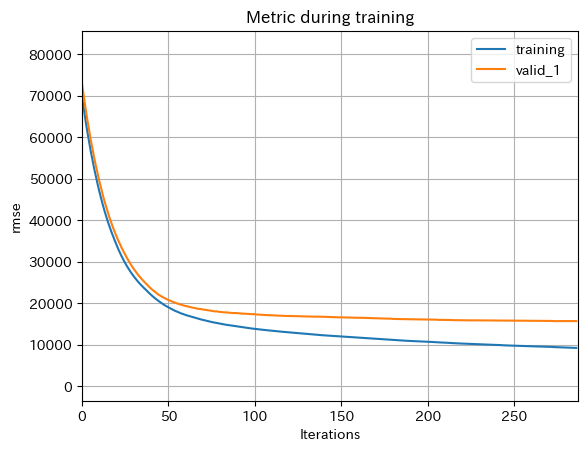

importance
面積               4.617602e+14
L                3.996745e+14
平均地価             2.028963e+14
最寄り駅             9.469547e+13
築年数              7.070119e+13
所在地              3.920584e+13
全体の階数            3.145310e+13
契約期間             1.573043e+13
所在階              1.018283e+13
所要時間             6.637133e+12
温水洗浄便座           5.075838e+12
定期借家             2.068740e+12
部屋数              1.601852e+12
建物構造             9.275923e+11
D                4.993618e+11
100m^2以上         1.919362e+11
50m^2以上75m^2未満   1.918916e+11
75m^2以上100m^2未満  1.829458e+11
S                1.446047e+11
K                4.350693e+10

In [16]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

「温水洗浄便座」のみ抜いてみる

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
washlets = pd.read_csv('../data/handmade_data/washlets.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

In [26]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=1000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [22]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-16 08:32:38,002] A new study created in memory with name: no-name-b9cee853-f5b0-43e3-9c4f-574e8800cb6e
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2839
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48787.8	valid_1's rmse: 50198.5
[20]	training's rmse: 34378.2	valid_1's rmse: 37800.6
[30]	training's rmse: 26079.1	valid_1's rmse: 31156.5
[40]	training's rmse: 20889.3	valid_1's rmse: 27401.6
[50]	training's rmse: 17653.6	valid_1's rmse: 25154.9
[60]	training's rmse: 15640.3	valid_1's rmse: 23786.4
[70]	training's rmse: 14261.7	valid_1's rmse: 22946
[80]	training's rmse: 13239.6	valid_1's rmse: 22258.2
[90]	training's rmse: 12461.6	valid_1's rmse: 21781.1
[100]	training's rmse: 11856.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2838
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48981.3	valid_1's rmse: 49548.1
[20]	training's rmse: 34934.9	valid_1's rmse: 36002.9
[30]	training's rmse: 27002.4	valid_1's rmse: 28636
[40]	training's rmse: 22335.9	valid_1's rmse: 24353.9
[50]	training's rmse: 19284.6	valid_1's rmse: 21518.3
[60]	training's rmse: 17570.7	valid_1's rmse: 20116
[70]	training's rmse: 16394.4	valid_1's rmse: 19218.3
[80]	training's rmse: 15496.9	valid_1's rmse: 18732.1
[90]	training's rmse: 14823.2	valid_1's rmse: 18476.4
[100]	training's rmse: 14253.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2838
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49025.9	valid_1's rmse: 48344.8
[20]	training's rmse: 35401.8	valid_1's rmse: 33880.2
[30]	training's rmse: 27151.4	valid_1's rmse: 25904.6
[40]	training's rmse: 22383.4	valid_1's rmse: 21583.1
[50]	training's rmse: 19346.7	valid_1's rmse: 19170.3
[60]	training's rmse: 17454.7	valid_1's rmse: 18004.1
[70]	training's rmse: 16303.6	valid_1's rmse: 17322.5
[80]	training's rmse: 15450.4	valid_1's rmse: 16869.8
[90]	training's rmse: 14793.9	valid_1's rmse: 16517.5
[100]	training's rmse: 14242	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49249.6	valid_1's rmse: 48179
[20]	training's rmse: 35104.4	valid_1's rmse: 35184.5
[30]	training's rmse: 26700.8	valid_1's rmse: 28097.3
[40]	training's rmse: 21907.9	valid_1's rmse: 24347.4
[50]	training's rmse: 18748.7	valid_1's rmse: 22337.3
[60]	training's rmse: 16964.8	valid_1's rmse: 21298.6
[70]	training's rmse: 15847.7	valid_1's rmse: 20765.9
[80]	training's rmse: 15044.5	valid_1's rmse: 20358.8
[90]	training's rmse: 14405.4	valid_1's rmse: 20008.2
[100]	training's rmse: 13877.9	valid_1's rmse: 19734.3
[110]	training's rmse: 13412.3	valid_1's rmse: 19518.8
[120]	training's rmse: 13030.3	valid_1's rmse: 19360.9
[130]	training's rmse: 12694.4	valid_1's rmse: 19259.3
[140]	training's rmse: 12355.3	valid_1's rmse: 19151.8
[150]	training's rmse: 12083.5	valid_1's rmse: 19063
[160]	training's rmse: 11799.2	valid_1's rmse: 18987.5
[170]	training's rmse: 11544	valid_1's rmse: 18910.8
[180]	training's rmse: 11339.4	valid_1's rmse: 18846.8
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48661.9	valid_1's rmse: 50981
[20]	training's rmse: 34915.5	valid_1's rmse: 37032.9
[30]	training's rmse: 26965	valid_1's rmse: 28763
[40]	training's rmse: 22243.1	valid_1's rmse: 23882.6
[50]	training's rmse: 19106.2	valid_1's rmse: 21091
[60]	training's rmse: 17200.9	valid_1's rmse: 19678.9
[70]	training's rmse: 15958.7	valid_1's rmse: 18851.9
[80]	training's rmse: 15062.9	valid_1's rmse: 18383.6
[90]	training's rmse: 14366.4	valid_1's rmse: 18083.6
[100]	training's rmse: 13839.2	valid_1's rmse: 17840.7
[110]	training's rmse: 13395.6	valid_1's rmse: 17699.3
[120]	training's rmse: 13025.6	valid_1's rmse: 17560
[130]	training's rmse: 12647.4	valid_1's rmse: 17418.8
[140]	training's rmse: 12362.1	valid_1's rmse: 17322.5
[150]	training's rmse: 12072.8	valid_1's rmse: 17235.8
[160]	training's rmse: 11807.6	valid_1's rmse: 17121.6
[170]	training's rmse: 11587	valid_1's rmse: 17055.1
[180]	training's rmse: 11394.3	valid_1's rmse: 16982.4
[190]	training's rmse: 11203.9	

[I 2022-09-16 08:32:55,391] Trial 0 finished with value: 16479.690344771378 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16479.690344771378.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2519
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48712.5	valid_1's rmse: 50056.6
[20]	training's rmse: 34369.9	valid_1's rmse: 37775.5
[30]	training's rmse: 25909.4	valid_1's rmse: 30893.9
[40]	training's rmse: 20974.3	valid_1's rmse: 27203.4
[50]	training's rmse: 17720.5	valid_1's rmse: 24856.1
[60]	training's rmse: 15714.4	valid_1's rmse: 23417.8
[70]	training's rmse: 14290.3	valid_1's rmse: 22455.2
[80]	training's rmse: 13338.2	valid_1's rmse: 21786.3
[90]	training's rmse: 12622.9	valid_1's rmse: 21346.7
[100]	training's rmse: 12074.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48956.9	valid_1's rmse: 49785
[20]	training's rmse: 34951.7	valid_1's rmse: 36410.8
[30]	training's rmse: 26645.1	valid_1's rmse: 29004.3
[40]	training's rmse: 21864	valid_1's rmse: 24776.2
[50]	training's rmse: 18918.5	valid_1's rmse: 22039.9
[60]	training's rmse: 17030	valid_1's rmse: 20698.1
[70]	training's rmse: 15796.4	valid_1's rmse: 19802.5
[80]	training's rmse: 14804.8	valid_1's rmse: 19253
[90]	training's rmse: 14033.4	valid_1's rmse: 18999.7
[100]	training's rmse: 13431.2	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34972.5	valid_1's rmse: 34302.4
[30]	training's rmse: 26769.4	valid_1's rmse: 26556.8
[40]	training's rmse: 22094.6	valid_1's rmse: 22521.7
[50]	training's rmse: 19116.7	valid_1's rmse: 20287.8
[60]	training's rmse: 17198.5	valid_1's rmse: 19078.5
[70]	training's rmse: 15998.4	valid_1's rmse: 18463.9
[80]	training's rmse: 15083.5	valid_1's rmse: 17986.6
[90]	training's rmse: 14369.1	valid_1's rmse: 17689.3
[100]	training's rmse: 13792.6	valid_1's rmse: 17461.3
[110]	training's rmse: 13323.2	valid_1's rmse: 17348.1
[120]	training's rmse: 12908	valid_1's rmse: 17278.2
[130]	training's rmse: 12541	valid_1's rmse: 17223.3
[140]	training's rmse: 12170.8	valid_1's rmse: 17160.6
[150]	training's rmse: 11845.4	valid_1's rmse: 17097.9
[160]	training's rmse: 11532.5	valid_1's rmse: 17051.9
[170]	training's rmse: 11250.6	valid_1's rmse: 17034.6
[180]	training's rmse: 10984.2	valid_1's rmse: 16994.8
[190]	training's rmse: 10758.4	valid_1's rmse: 16973.9
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49171.6	valid_1's rmse: 48048.5
[20]	training's rmse: 34775.5	valid_1's rmse: 35467.9
[30]	training's rmse: 26356.2	valid_1's rmse: 28401.4
[40]	training's rmse: 21537.4	valid_1's rmse: 24669.9
[50]	training's rmse: 18511.8	valid_1's rmse: 22736.1
[60]	training's rmse: 16677.1	valid_1's rmse: 21746.5
[70]	training's rmse: 15425.2	valid_1's rmse: 21119.2
[80]	training's rmse: 14539.1	valid_1's rmse: 20749.7
[90]	training's rmse: 13881.2	valid_1's rmse: 20378.2
[100]	training's rmse: 13349.2	valid_1's rmse: 20170.1
[110]	training's rmse: 12916.6	valid_1's rmse: 19950.8
[120]	training's rmse: 12557	valid_1's rmse: 19847.6
[130]	training's rmse: 12225.2	valid_1's rmse: 19702.6
[140]	training's rmse: 11921.3	valid_1's rmse: 19620.9
[150]	training's rmse: 11609	valid_1's rmse: 19583.7
[160]	training's rmse: 11322	valid_1's rmse: 19510.2
[170]	training's rmse: 11068.3	valid_1's rmse: 19444.5
[180]	training's rmse: 10829.7	valid_1's rmse: 19422.3
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35009.8	valid_1's rmse: 36882.4
[30]	training's rmse: 26797.5	valid_1's rmse: 28304.7
[40]	training's rmse: 22141.3	valid_1's rmse: 23407.3
[50]	training's rmse: 18942.5	valid_1's rmse: 20656.5
[60]	training's rmse: 17018	valid_1's rmse: 19395.1
[70]	training's rmse: 15726	valid_1's rmse: 18608.4
[80]	training's rmse: 14795.3	valid_1's rmse: 18120.1
[90]	training's rmse: 14124.3	valid_1's rmse: 17840
[100]	training's rmse: 13613.7	valid_1's rmse: 17601.1
[110]	training's rmse: 13173.2	valid_1's rmse: 17444.1
[120]	training's rmse: 12791.5	valid_1's rmse: 17322.9
[130]	training's rmse: 12436.3	valid_1's rmse: 17188.4
[140]	training's rmse: 12116.1	valid_1's rmse: 17121
[150]	training's rmse: 11833.6	valid_1's rmse: 17042.4
[160]	training's rmse: 11567.4	valid_1's rmse: 16975.3
[170]	training's rmse: 11300	valid_1's rmse: 16895.5
[180]	training's rmse: 11068.1	valid_1's rmse: 16816.3
[190]	training's rmse: 10843.1	valid_1's rmse: 16760.4
[200]	training's rmse: 10615

[I 2022-09-16 08:33:11,140] Trial 1 finished with value: 16348.82641655792 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 1 with value: 16348.82641655792.


[330]	training's rmse: 8639.93	valid_1's rmse: 16360.1
Early stopping, best iteration is:
[326]	training's rmse: 8703.62	valid_1's rmse: 16348.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3002
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48380.3	valid_1's rmse: 49959.4
[20]	training's rmse: 33933.5	valid_1's rmse: 37689.8
[30]	training's rmse: 25532.7	valid_1's rmse: 30878.7
[40]	training's rmse: 20513.2	valid_1's rmse: 27036.6
[50]	training's rmse: 17197.5	valid_1's rmse: 24592.9
[60]	training's rmse: 15242.9	valid_1's rmse: 23111.4
[70]	training's rmse: 13817.6	valid_1's rmse: 22031.3
[80]	training's rmse: 12832.8	valid_1's rmse: 21344.9
[90]	training's rmse: 12109.5	valid_1's rmse: 20877
[100]	training's rmse: 11555.3	valid_1's rmse: 20504
[110]	training's rmse: 11093.4	valid_1's rmse: 20228.6
[120]	training's rmse: 10663.3	valid_1's rmse: 19989.8
[130]	training's rmse: 10296.5	valid_1's rmse: 19756.3
[140]	training's rmse: 9977.75	valid_1's rmse: 19529.9
[150]	training's rmse: 9672.86	valid_1's rmse: 19383.5
[160]	training's rmse: 9405.54	valid_1's rmse: 19257.9
[170]	training's rmse: 9163.47	valid_1's rmse: 19161.7
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3005
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.6	valid_1's rmse: 49606
[20]	training's rmse: 34602.1	valid_1's rmse: 36003.9
[30]	training's rmse: 26588.3	valid_1's rmse: 28731
[40]	training's rmse: 22001.8	valid_1's rmse: 24388
[50]	training's rmse: 19127.2	valid_1's rmse: 21461.7
[60]	training's rmse: 17399.5	valid_1's rmse: 20026.8
[70]	training's rmse: 16001.3	valid_1's rmse: 18862.4
[80]	training's rmse: 14995.8	valid_1's rmse: 18252.9
[90]	training's rmse: 14263.7	valid_1's rmse: 17924.9
[100]	training's rmse: 13654.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34796.1	valid_1's rmse: 33665.2
[30]	training's rmse: 26533.9	valid_1's rmse: 26007.5
[40]	training's rmse: 21793.9	valid_1's rmse: 21847
[50]	training's rmse: 18697.3	valid_1's rmse: 19582.6
[60]	training's rmse: 16781.2	valid_1's rmse: 18379.3
[70]	training's rmse: 15655.1	valid_1's rmse: 17663.9
[80]	training's rmse: 14776.4	valid_1's rmse: 17274.4
[90]	training's rmse: 14099.6	valid_1's rmse: 17008.5
[100]	training's rmse: 13555.1	valid_1's rmse: 16799.5
[110]	training's rmse: 13097	valid_1's rmse: 16718.9
[120]	training's rmse: 12657.9	valid_1's rmse: 16619.8
[130]	training's rmse: 12272.7	valid_1's rmse: 16549.9
[140]	training's rmse: 11898	valid_1's rmse: 16492
[150]	training's rmse: 11577.4	valid_1's rmse: 16446.1
[160]	training's rmse: 11312.7	valid_1's rmse: 16428.9
[170]	training's rmse: 11060.4	valid_1's rmse: 16406.4
[180]	training's rmse: 10847.3	valid_1's rmse: 16388.1
[190]	training's rmse: 10636.1	valid_1's rmse: 16374.4
[200]	training's rmse: 104

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34411.5	valid_1's rmse: 35425.2
[30]	training's rmse: 25991.2	valid_1's rmse: 28445
[40]	training's rmse: 21206.5	valid_1's rmse: 24785.5
[50]	training's rmse: 18094.1	valid_1's rmse: 22892.9
[60]	training's rmse: 16252.5	valid_1's rmse: 21877.7
[70]	training's rmse: 15160.7	valid_1's rmse: 21239.3
[80]	training's rmse: 14357.1	valid_1's rmse: 20719.9
[90]	training's rmse: 13737.2	valid_1's rmse: 20357.1
[100]	training's rmse: 13280.4	valid_1's rmse: 20107
[110]	training's rmse: 12892.6	valid_1's rmse: 19886.3
[120]	training's rmse: 12550.7	valid_1's rmse: 19736.2
[130]	training's rmse: 12151.5	valid_1's rmse: 19585.7
[140]	training's rmse: 11749	valid_1's rmse: 19537.1
[150]	training's rmse: 11459.6	valid_1's rmse: 19462.1
[160]	training's rmse: 11152.8	valid_1's rmse: 19334.9
[170]	training's rmse: 10877.2	valid_1's rmse: 19214.1
[180]	training's rmse: 10690.6	valid_1's rmse: 19172.4
[190]	training's rmse: 10496.9	valid_1's rmse: 19126.2
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48301.4	valid_1's rmse: 50746.6
[20]	training's rmse: 34405.7	valid_1's rmse: 36752.6
[30]	training's rmse: 26355.8	valid_1's rmse: 28572.2
[40]	training's rmse: 21657	valid_1's rmse: 23678.5
[50]	training's rmse: 18511.5	valid_1's rmse: 20769.8
[60]	training's rmse: 16736.5	valid_1's rmse: 19384.9
[70]	training's rmse: 15533.5	valid_1's rmse: 18615.6
[80]	training's rmse: 14673.6	valid_1's rmse: 18223.2
[90]	training's rmse: 14009	valid_1's rmse: 18006.5
[100]	training's rmse: 13501.2	valid_1's rm

[I 2022-09-16 08:33:28,289] Trial 2 finished with value: 17225.514660358604 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 1 with value: 16348.82641655792.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2913
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48780.2	valid_1's rmse: 50295.6
[20]	training's rmse: 34403.1	valid_1's rmse: 37926.5
[30]	training's rmse: 26083.5	valid_1's rmse: 31180.7
[40]	training's rmse: 20966.7	valid_1's rmse: 27317.6
[50]	training's rmse: 17656.7	valid_1's rmse: 24871.2
[60]	training's rmse: 15665.8	valid_1's rmse: 23379.1
[70]	training's rmse: 14266.6	valid_1's rmse: 22351.9
[80]	training's rmse: 13287.8	valid_1's rmse: 21696.3
[90]	training's rmse: 12585.9	valid_1's rmse: 21230
[100]	training's rmse: 12023.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48949.8	valid_1's rmse: 49605.9
[20]	training's rmse: 34892.3	valid_1's rmse: 36666.9
[30]	training's rmse: 26957.2	valid_1's rmse: 29425.6
[40]	training's rmse: 22222.3	valid_1's rmse: 24942.4
[50]	training's rmse: 19270.3	valid_1's rmse: 21943.9
[60]	training's rmse: 17526.7	valid_1's rmse: 20252.7
[70]	training's rmse: 16299.6	valid_1's rmse: 19242
[80]	training's rmse: 15434.9	valid_1's rmse: 18589.2
[90]	training's rmse: 14739.5	valid_1's rmse: 18274.4
[100]	training's rmse: 14178.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35251.8	valid_1's rmse: 34035.7
[30]	training's rmse: 27038.1	valid_1's rmse: 26044.5
[40]	training's rmse: 22340.3	valid_1's rmse: 21823.8
[50]	training's rmse: 19327.3	valid_1's rmse: 19436.5
[60]	training's rmse: 17426.5	valid_1's rmse: 18231.9
[70]	training's rmse: 16266.6	valid_1's rmse: 17583.9
[80]	training's rmse: 15350.8	valid_1's rmse: 17168.7
[90]	training's rmse: 14684.8	valid_1's rmse: 16972.1
[100]	training's rmse: 14164.6	valid_1's rmse: 16727.4
[110]	training's rmse: 13700.1	valid_1's rmse: 16559.8
[120]	training's rmse: 13281.7	valid_1's rmse: 16414.8
[130]	training's rmse: 12921	valid_1's rmse: 16322.4
[140]	training's rmse: 12580.8	valid_1's rmse: 16278.6
[150]	training's rmse: 12290.2	valid_1's rmse: 16245.7
[160]	training's rmse: 12023.6	valid_1's rmse: 16227.8
[170]	training's rmse: 11772	valid_1's rmse: 16213.8
[180]	training's rmse: 11543.8	valid_1's rmse: 16176.7
[190]	training's rmse: 11331.8	valid_1's rmse: 16165.2
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2914
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49231.6	valid_1's rmse: 48196
[20]	training's rmse: 35056.3	valid_1's rmse: 35291.9
[30]	training's rmse: 26617.6	valid_1's rmse: 28151.4
[40]	training's rmse: 21829.8	valid_1's rmse: 24351.5
[50]	training's rmse: 18794.4	valid_1's rmse: 22392
[60]	training's rmse: 16964.1	valid_1's rmse: 21375.2
[70]	training's rmse: 15789.2	valid_1's rmse: 20671.5
[80]	training's rmse: 14980.1	valid_1's rmse: 20169.3
[90]	training's rmse: 14289.1	valid_1's rmse: 19654.7
[100]	training's rmse: 13674.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2909
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.9	valid_1's rmse: 51072
[20]	training's rmse: 34972.4	valid_1's rmse: 36980.6
[30]	training's rmse: 26977.1	valid_1's rmse: 28854.2
[40]	training's rmse: 22347.6	valid_1's rmse: 24100.1
[50]	training's rmse: 19306.4	valid_1's rmse: 21480.8
[60]	training's rmse: 17450.9	valid_1's rmse: 20070.5
[70]	training's rmse: 16185.5	valid_1's rmse: 19304
[80]	training's rmse: 15227	valid_1's rmse: 18926.8
[90]	training's rmse: 14554.6	valid_1's rmse: 18689.2
[100]	training's rmse: 14015.8	valid_1's rmse

[I 2022-09-16 08:33:39,086] Trial 3 finished with value: 17649.03851824927 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 1 with value: 16348.82641655792.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyth

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3035
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49297	valid_1's rmse: 50776
[20]	training's rmse: 35079.6	valid_1's rmse: 38532.7
[30]	training's rmse: 26825.9	valid_1's rmse: 31711.6
[40]	training's rmse: 21804.1	valid_1's rmse: 27755.3
[50]	training's rmse: 18594.3	valid_1's rmse: 25305.3
[60]	training's rmse: 16595.4	valid_1's rmse: 23759.3
[70]	training's rmse: 15200.8	valid_1's rmse: 22734
[80]	training's rmse: 14283.7	valid_1's rmse: 22088.7
[90]	training's rmse: 13546	valid_1's rmse: 21610.8
[100]	training's rmse: 12930.9	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35568.4	valid_1's rmse: 36713.2
[30]	training's rmse: 27612.4	valid_1's rmse: 29352.4
[40]	training's rmse: 22828.5	valid_1's rmse: 24786.9
[50]	training's rmse: 19940.7	valid_1's rmse: 21882.1
[60]	training's rmse: 18167.9	valid_1's rmse: 20275.3
[70]	training's rmse: 16901.1	valid_1's rmse: 19267.7
[80]	training's rmse: 15986.8	valid_1's rmse: 18550.5
[90]	training's rmse: 15220.9	valid_1's rmse: 18142.3
[100]	training's rmse: 14655.1	valid_1's rmse: 17916.2
[110]	training's rmse: 14183.8	valid_1's rmse: 17774.4
[120]	training's rmse: 13755.2	valid_1's rmse: 17663.8
[130]	training's rmse: 13406.4	valid_1's rmse: 17608.7
[140]	training's rmse: 13045.6	valid_1's rmse: 17547.5
[150]	training's rmse: 12749.7	valid_1's rmse: 17498.2
[160]	training's rmse: 12471.1	valid_1's rmse: 17444.7
[170]	training's rmse: 12224.5	valid_1's rmse: 17423
[180]	training's rmse: 12014.4	valid_1's rmse: 17390.6
[190]	training's rmse: 11801.9	valid_1's rmse: 17354.8
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49539	valid_1's rmse: 49109.8
[20]	training's rmse: 35850.9	valid_1's rmse: 34828.1
[30]	training's rmse: 27765.6	valid_1's rmse: 26907.7
[40]	training's rmse: 22925.4	valid_1's rmse: 22531.3
[50]	training's rmse: 19937.2	valid_1's rmse: 20157.9
[60]	training's rmse: 18104.7	valid_1's rmse: 18923.2
[70]	training's rmse: 16911.8	valid_1's rmse: 18143
[80]	training's rmse: 16002.9	valid_1's rmse: 17692.3
[90]	training's rmse: 15331.2	valid_1's rmse: 17420.8
[100]	training's rmse: 14753.7	valid_1's rmse: 17213.4
[110]	training's rmse: 14283.1	valid_1's rmse: 17054.5
[120]	training's rmse: 13900.5	valid_1's rmse: 16962.1
[130]	training's rmse: 13545.5	valid_1's rmse: 16882.1
[140]	training's rmse: 13214.1	valid_1's rmse: 16769.3
[150]	training's rmse: 12895.8	valid_1's rmse: 16699.5
[160]	training's rmse: 12635.5	valid_1's rmse: 16646.5
[170]	training's rmse: 12392.5	valid_1's rmse: 16609.8
[180]	training's rmse: 12167.8	valid_1's rmse: 16563
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3043
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49512.3	valid_1's rmse: 48566.6
[20]	training's rmse: 35454.1	valid_1's rmse: 36180.7
[30]	training's rmse: 27156.3	valid_1's rmse: 29280.7
[40]	training's rmse: 22222	valid_1's rmse: 25601
[50]	training's rmse: 19276.8	valid_1's rmse: 23585.3
[60]	training's rmse: 17524	valid_1's rmse: 22380.9
[70]	training's rmse: 16357.3	valid_1's rmse: 21738.4
[80]	training's rmse: 15557.2	valid_1's rmse: 21174.8
[90]	training's rmse: 14922.4	valid_1's rmse: 20793.9
[100]	training's rmse: 14432.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3037
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49140.5	valid_1's rmse: 51586.4
[20]	training's rmse: 35591	valid_1's rmse: 37700.2
[30]	training's rmse: 27732.2	valid_1's rmse: 29424.7
[40]	training's rmse: 22928.1	valid_1's rmse: 24470
[50]	training's rmse: 19860.5	valid_1's rmse: 21740.1
[60]	training's rmse: 18003	valid_1's rmse: 20124.9
[70]	training's rmse: 16733.3	valid_1's rmse: 19305.3
[80]	training's rmse: 15882	valid_1's rmse: 18813.6
[90]	training's rmse: 15238.9	valid_1's rmse: 18508.7
[100]	training's rmse: 14685.3	valid_1's rmse: 

[I 2022-09-16 08:33:46,773] Trial 4 finished with value: 17527.59547834516 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 1 with value: 16348.82641655792.


[300]	training's rmse: 10403.8	valid_1's rmse: 17531.4
[310]	training's rmse: 10291.4	valid_1's rmse: 17536.4
Early stopping, best iteration is:
[301]	training's rmse: 10396.1	valid_1's rmse: 17527.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48687.8	valid_1's rmse: 50307.2
[20]	training's rmse: 34465.8	valid_1's rmse: 38194.2
[30]	training's rmse: 25981.1	valid_1's rmse: 31472
[40]	training's rmse: 20981.5	valid_1's rmse: 27720.5
[50]	training's rmse: 17608.1	valid_1's rmse: 25373.8
[60]	training's rmse: 15613	valid_1's rmse: 23957.7
[70]	training's rmse: 14226.3	valid_1's rmse: 22993.4
[80]	training's rmse: 13151	valid_1's rmse: 22309.3
[90]	training's rmse: 12379.6	valid_1's rmse: 21770.7
[100]	training's rmse: 11758	valid_1's rmse: 21351.3
[110]	training's rmse: 11220.4	valid_1's rmse: 21004
[120]	training's rmse: 10763.3	valid_1's rmse: 20692.5
[130]	training's rmse: 10375.6	valid_1's rmse: 20396.8
[140]	training's rmse: 10027.1	valid_1's rmse: 20164.5
[150]	training's rmse: 9717.3	valid_1's rmse: 19961.9
[160]	training's rmse: 9434.6	valid_1's rmse: 19757.3
[170]	training's rmse: 9151.43	valid_1's rmse: 19569
[180]	training's rmse: 8911.89	valid_1's rmse: 19414.1
[190]	training's rmse: 8659.56	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48806.9	valid_1's rmse: 49274.2
[20]	training's rmse: 34834.7	valid_1's rmse: 35851.2
[30]	training's rmse: 26724.4	valid_1's rmse: 28242.7
[40]	training's rmse: 21991.4	valid_1's rmse: 24208.3
[50]	training's rmse: 18850.3	valid_1's rmse: 21788
[60]	training's rmse: 16919.5	valid_1's rmse: 20415.9
[70]	training's rmse: 15642.6	valid_1's rmse: 19466
[80]	training's rmse: 14585	valid_1's rmse: 18873.1
[90]	training's rmse: 13811.4	valid_1's rmse: 18622.9
[100]	training's rmse: 13176.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48922.4	valid_1's rmse: 48843.2
[20]	training's rmse: 35069	valid_1's rmse: 34883.6
[30]	training's rmse: 26795.3	valid_1's rmse: 27192.1
[40]	training's rmse: 22114.8	valid_1's rmse: 23051.6
[50]	training's rmse: 19115.9	valid_1's rmse: 20612
[60]	training's rmse: 17158.3	valid_1's rmse: 19405.1
[70]	training's rmse: 15810.2	valid_1's rmse: 18749.7
[80]	training's rmse: 14804	valid_1's rmse: 18399
[90]	training's rmse: 13951.2	valid_1's rmse: 18087.9
[100]	training's rmse: 13267.6	valid_1's rmse: 17841.5
[110]	training's rmse: 12663.4	valid_1's rmse: 17718.5
[120]	training's rmse: 12157	valid_1's rmse: 17609
[130]	training's rmse: 11720.3	valid_1's rmse: 17580
[140]	training's rmse: 11311.6	valid_1's rmse: 17545
[150]	training's rmse: 10944.5	valid_1's rmse: 17488
[160]	training's rmse: 10612.4	valid_1's rmse: 17470
Early stopping, best iteration is:
[159]	training's rmse: 10642.1	valid_1's rmse: 17468.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49112.3	valid_1's rmse: 47854.9
[20]	training's rmse: 34972.6	valid_1's rmse: 35207.7
[30]	training's rmse: 26470.1	valid_1's rmse: 28209.2
[40]	training's rmse: 21731.1	valid_1's rmse: 24501.1
[50]	training's rmse: 18490.5	valid_1's rmse: 22474.3
[60]	training's rmse: 16518.7	valid_1's rmse: 21497.1
[70]	training's rmse: 15163.7	valid_1's rmse: 20930.7
[80]	training's rmse: 14183.4	valid_1's rmse: 20458.4
[90]	training's rmse: 13458	valid_1's rmse: 20189.4
[100]	training's rmse: 12833.1	valid_1's rmse: 19915.7
[110]	training's rmse: 12320.6	valid_1's rmse: 19699.5
[120]	training's rmse: 11858.7	valid_1's rmse: 19424
[130]	training's rmse: 11457.5	valid_1's rmse: 19294.7
[140]	training's rmse: 11109.1	valid_1's rmse: 19180.1
[150]	training's rmse: 10784.9	valid_1's rmse: 19020.5
[160]	training's rmse: 10484.3	valid_1's rmse: 18959.1
[170]	training's rmse: 10216.9	valid_1's rmse: 18847.6
[180]	training's rmse: 9963.85	valid_1's rmse: 18762.3
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48467.3	valid_1's rmse: 50942.1
[20]	training's rmse: 34812.8	valid_1's rmse: 36823.2
[30]	training's rmse: 26690	valid_1's rmse: 28436.4
[40]	training's rmse: 22024.1	valid_1's rmse: 23709.3
[50]	training's rmse: 18910.7	valid_1's rmse: 20935.9
[60]	training's rmse: 16941.7	valid_1's rmse: 19674.3
[70]	training's rmse: 15564.7	valid_1's rmse: 18793.1
[80]	training's rmse: 14574.3	valid_1's rmse: 18308.2
[90]	training's rmse: 13860.4	valid_1's rmse: 18040.1
[100]	training's rmse: 13279	valid_1's rm

[I 2022-09-16 08:34:01,080] Trial 5 finished with value: 16195.857906266918 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 5 with value: 16195.857906266918.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48399.6	valid_1's rmse: 50024.5
[20]	training's rmse: 33920.2	valid_1's rmse: 37649.6
[30]	training's rmse: 25557.7	valid_1's rmse: 30890.8
[40]	training's rmse: 20576.3	valid_1's rmse: 27067.2
[50]	training's rmse: 17276.8	valid_1's rmse: 24591.3
[60]	training's rmse: 15311.5	valid_1's rmse: 23103.4
[70]	training's rmse: 13846.6	valid_1's rmse: 22018.3
[80]	training's rmse: 12820.2	valid_1's rmse: 21306.2
[90]	training's rmse: 12052	valid_1's rmse: 20799.4
[100]	training's rmse: 11474.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48769.5	valid_1's rmse: 49605.4
[20]	training's rmse: 34579.1	valid_1's rmse: 36117.2
[30]	training's rmse: 26553	valid_1's rmse: 28848.3
[40]	training's rmse: 21940.7	valid_1's rmse: 24523.1
[50]	training's rmse: 19013.2	valid_1's rmse: 21571
[60]	training's rmse: 17287.6	valid_1's rmse: 20067.2
[70]	training's rmse: 16049.9	valid_1's rmse: 19198.4
[80]	training's rmse: 15101	valid_1's rmse: 18419.5
[90]	training's rmse: 14352.1	valid_1's rmse: 18063.4
[100]	training's rmse: 13798.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48728.2	valid_1's rmse: 48278.6
[20]	training's rmse: 34783.2	valid_1's rmse: 33677.6
[30]	training's rmse: 26550	valid_1's rmse: 26018.9
[40]	training's rmse: 21751.4	valid_1's rmse: 21813.6
[50]	training's rmse: 18627.1	valid_1's rmse: 19578.3
[60]	training's rmse: 16787	valid_1's rmse: 18389
[70]	training's rmse: 15602.8	valid_1's rmse: 17790.2
[80]	training's rmse: 14764	valid_1's rmse: 17372.5
[90]	training's rmse: 14090.4	valid_1's rmse: 17126
[100]	training's rmse: 13560.5	valid_1's rmse: 16996.2
[110]	training's rmse: 13091.1	valid_1's rmse: 16883.1
[120]	training's rmse: 12684.2	valid_1's rmse: 16782.2
[130]	training's rmse: 12289.3	valid_1's rmse: 16733.4
[140]	training's rmse: 11935.5	valid_1's rmse: 16700.3
[150]	training's rmse: 11638.6	valid_1's rmse: 16657.1
[160]	training's rmse: 11362.2	valid_1's rmse: 16639.7
[170]	training's rmse: 11099.3	valid_1's rmse: 16614
[180]	training's rmse: 10852.7	valid_1's rmse: 16605.3
[190]	training's rmse: 10641.5	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2986
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48776.5	valid_1's rmse: 47835.2
[20]	training's rmse: 34326.7	valid_1's rmse: 35215.3
[30]	training's rmse: 25903.4	valid_1's rmse: 28162.9
[40]	training's rmse: 21110.6	valid_1's rmse: 24539.4
[50]	training's rmse: 18013.7	valid_1's rmse: 22725.8
[60]	training's rmse: 16231.8	valid_1's rmse: 21751.3
[70]	training's rmse: 15119.4	valid_1's rmse: 21140.4
[80]	training's rmse: 14342.8	valid_1's rmse: 20600.2
[90]	training's rmse: 13762.7	valid_1's rmse: 20278
[100]	training's rmse: 13276.2	valid_1's rmse: 19973.7
[110]	training's rmse: 12896.1	valid_1's rmse: 198

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48296.3	valid_1's rmse: 50777.6
[20]	training's rmse: 34412.3	valid_1's rmse: 36780.7
[30]	training's rmse: 26277.1	valid_1's rmse: 28465.5
[40]	training's rmse: 21624.2	valid_1's rmse: 23732.4
[50]	training's rmse: 18515.9	valid_1's rmse: 20798.4
[60]	training's rmse: 16666.8	valid_1's rmse: 19436.6
[70]	training's rmse: 15488.7	valid_1's rmse: 18688.9
[80]	training's rmse: 14588.4	valid_1's rmse: 18299.7
[90]	training's rmse: 13937.1	valid_1's rmse: 18107.1
[100]	training's rmse: 13446.9	valid_1's rmse: 17956.4
[110]	training's rmse: 12997.2	valid_1's rmse: 17857.4
[120]	training's rmse: 12627.3	valid_1's rmse: 17804
[130]	training's rmse: 12320.1	valid_1's rmse: 17763
[140]	training's rmse: 11987.9	valid_1's rmse: 17697.5
[150]	training's rmse: 11709.2	valid_1's rmse: 17673.8
[160]	training's rmse: 11486.2	valid_1's rmse: 17638.2
[170]	training's rmse: 11252.1	valid_1's rmse: 17604.5
[180]	training's rmse: 11053	valid_1's rmse: 17577.8
[190]	training's rmse: 10

[I 2022-09-16 08:34:15,054] Trial 6 finished with value: 17435.922111316362 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 5 with value: 16195.857906266918.


[250]	training's rmse: 9917.93	valid_1's rmse: 17447.1
Early stopping, best iteration is:
[245]	training's rmse: 9989.91	valid_1's rmse: 17435.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2569
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48728.2	valid_1's rmse: 50392.4
[20]	training's rmse: 34354.5	valid_1's rmse: 38099.1
[30]	training's rmse: 25906.8	valid_1's rmse: 31231.2
[40]	training's rmse: 20883.9	valid_1's rmse: 27305.4
[50]	training's rmse: 17565.5	valid_1's rmse: 24805.6
[60]	training's rmse: 15576.1	valid_1's rmse: 23313.8
[70]	training's rmse: 14188.7	valid_1's rmse: 22284.9
[80]	training's rmse: 13246.8	valid_1's rmse: 21523
[90]	training's rmse: 12485.1	valid_1's rmse: 20971.9
[100]	training's rmse: 11890.3	valid_1's rmse: 20571.2
[110]	training's rmse: 11403.9	valid_1's rmse: 20229.6
[120]	training's rmse: 11007.4	valid_1's rmse: 19933.6
[130]	training's rmse: 10661.4	valid_1's rmse: 19712.3
[140]	training's rmse: 10329.3	valid_1's rmse: 19458.7
[150]	training's rmse: 10032	valid_1's rmse: 19268.6
[160]	training's rmse: 9754.79	valid_1's rmse: 19109.2
[170]	training's rmse: 9502.67	valid_1's rmse: 18947.1
[180]	training's rmse: 9272.12	valid_1's rmse: 18830.8
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48854.7	valid_1's rmse: 49594.2
[20]	training's rmse: 34739.6	valid_1's rmse: 36154.2
[30]	training's rmse: 26543.3	valid_1's rmse: 28661
[40]	training's rmse: 21671.4	valid_1's rmse: 24619.2
[50]	training's rmse: 18627.5	valid_1's rmse: 21973.6
[60]	training's rmse: 16847.6	valid_1's rmse: 20513.7
[70]	training's rmse: 15620.6	valid_1's rmse: 19615.5
[80]	training's rmse: 14643.4	valid_1's rmse: 19090.1
[90]	training's rmse: 13897.8	valid_1's rmse: 18814.2
[100]	training's rmse: 13289.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2570
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48762.5	valid_1's rmse: 48581.4
[20]	training's rmse: 34832.3	valid_1's rmse: 34254
[30]	training's rmse: 26647.7	valid_1's rmse: 26599.7
[40]	training's rmse: 22076.9	valid_1's rmse: 22631.7
[50]	training's rmse: 19131.7	valid_1's rmse: 20401.2
[60]	training's rmse: 17231.8	valid_1's rmse: 19109.8
[70]	training's rmse: 15989.7	valid_1's rmse: 18449.1
[80]	training's rmse: 15087.5	valid_1's rmse: 17958
[90]	training's rmse: 14402.4	valid_1's rmse: 17658.7
[100]	training's rmse: 13800.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2569
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49175	valid_1's rmse: 47906.7
[20]	training's rmse: 34759.7	valid_1's rmse: 35329.1
[30]	training's rmse: 26361.3	valid_1's rmse: 28514.4
[40]	training's rmse: 21509.7	valid_1's rmse: 24990
[50]	training's rmse: 18467.8	valid_1's rmse: 23044.8
[60]	training's rmse: 16628.1	valid_1's rmse: 22021.3
[70]	training's rmse: 15347.6	valid_1's rmse: 21408.6
[80]	training's rmse: 14470.8	valid_1's rmse: 21060.8
[90]	training's rmse: 13784.8	valid_1's rmse: 20792.6
[100]	training's rmse: 13220.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48610.7	valid_1's rmse: 50941.9
[20]	training's rmse: 34927.8	valid_1's rmse: 36872.3
[30]	training's rmse: 26767.7	valid_1's rmse: 28542
[40]	training's rmse: 22204.6	valid_1's rmse: 23880.6
[50]	training's rmse: 18969.9	valid_1's rmse: 21181.6
[60]	training's rmse: 17067.2	valid_1's rmse: 19805.2
[70]	training's rmse: 15813	valid_1's rmse: 18900.4
[80]	training's rmse: 14902.1	valid_1's rmse: 18328.3
[90]	training's rmse: 14212.9	valid_1's rmse: 17987.2
[100]	training's rmse: 13650	valid_1's rmse

[I 2022-09-16 08:34:26,901] Trial 7 finished with value: 16476.64471826358 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 5 with value: 16195.857906266918.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2766
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49223.5	valid_1's rmse: 50630.7
[20]	training's rmse: 35146.1	valid_1's rmse: 38372.2
[30]	training's rmse: 26983.3	valid_1's rmse: 31708.9
[40]	training's rmse: 21746.2	valid_1's rmse: 27683.4
[50]	training's rmse: 18483.4	valid_1's rmse: 25283.9
[60]	training's rmse: 16533.9	valid_1's rmse: 23854.7
[70]	training's rmse: 15158.3	valid_1's rmse: 22862.5
[80]	training's rmse: 14211.6	valid_1's rmse: 22281.6
[90]	training's rmse: 13547.4	valid_1's rmse: 21893.5
[100]	training's rmse: 12972.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2767
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49361	valid_1's rmse: 50033.5
[20]	training's rmse: 35571.4	valid_1's rmse: 36686
[30]	training's rmse: 27581.7	valid_1's rmse: 29175.6
[40]	training's rmse: 22775.4	valid_1's rmse: 24675.1
[50]	training's rmse: 19854.3	valid_1's rmse: 21962.1
[60]	training's rmse: 18096.1	valid_1's rmse: 20569.3
[70]	training's rmse: 16851.7	valid_1's rmse: 19671.8
[80]	training's rmse: 15979	valid_1's rmse: 19236.1
[90]	training's rmse: 15314	valid_1's rmse: 18976.3
[100]	training's rmse: 14781.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2766
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49473.1	valid_1's rmse: 48821.8
[20]	training's rmse: 35882.6	valid_1's rmse: 34423.3
[30]	training's rmse: 27816	valid_1's rmse: 26451.5
[40]	training's rmse: 23029.8	valid_1's rmse: 22276.5
[50]	training's rmse: 20012.5	valid_1's rmse: 19823.9
[60]	training's rmse: 18067.8	valid_1's rmse: 18552
[70]	training's rmse: 16791.7	valid_1's rmse: 17765.3
[80]	training's rmse: 15980.2	valid_1's rmse: 17317.2
[90]	training's rmse: 15354.9	valid_1's rmse: 16969.4
[100]	training's rmse: 14842.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2765
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49623.2	valid_1's rmse: 48638.7
[20]	training's rmse: 35615.4	valid_1's rmse: 36044.6
[30]	training's rmse: 27371.8	valid_1's rmse: 29070.4
[40]	training's rmse: 22453.5	valid_1's rmse: 25317.3
[50]	training's rmse: 19349.5	valid_1's rmse: 23296.2
[60]	training's rmse: 17623.1	valid_1's rmse: 22078.2
[70]	training's rmse: 16480.5	valid_1's rmse: 21391
[80]	training's rmse: 15618.1	valid_1's rmse: 20939
[90]	training's rmse: 15020.2	valid_1's rmse: 20560.2
[100]	training's rmse: 14509.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2765
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49201.3	valid_1's rmse: 51528.4
[20]	training's rmse: 35715.5	valid_1's rmse: 37667.6
[30]	training's rmse: 27838.5	valid_1's rmse: 29339.5
[40]	training's rmse: 23255.1	valid_1's rmse: 24642.7
[50]	training's rmse: 20080.1	valid_1's rmse: 21877.1
[60]	training's rmse: 18100.5	valid_1's rmse: 20401.1
[70]	training's rmse: 16928.5	valid_1's rmse: 19465
[80]	training's rmse: 16024.4	valid_1's rmse: 18958.7
[90]	training's rmse: 15321.5	valid_1's rmse: 18738.5
[100]	training's rmse: 14826.2	valid_1's 

[I 2022-09-16 08:34:37,735] Trial 8 finished with value: 17253.86750103043 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 5 with value: 16195.857906266918.


[340]	training's rmse: 9991.87	valid_1's rmse: 17284.8
[350]	training's rmse: 9877.38	valid_1's rmse: 17271.7
Early stopping, best iteration is:
[345]	training's rmse: 9933.87	valid_1's rmse: 17253.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2647
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48959.2	valid_1's rmse: 50514.1
[20]	training's rmse: 34655.4	valid_1's rmse: 38226.9
[30]	training's rmse: 26246.3	valid_1's rmse: 31345.1
[40]	training's rmse: 21299.6	valid_1's rmse: 27521.6
[50]	training's rmse: 18004.4	valid_1's rmse: 25076.9
[60]	training's rmse: 16003.1	valid_1's rmse: 23615.5
[70]	training's rmse: 14592.2	valid_1's rmse: 22600.5
[80]	training's rmse: 13592.4	valid_1's rmse: 21849.5
[90]	training's rmse: 12879.2	valid_1's rmse: 21320.2
[100]	training's rmse: 12316.7	valid_1's rmse: 20907.3
[110]	training's rmse: 11781.8	valid_1's rmse: 20510.9
[120]	training's rmse: 11381.9	valid_1's rmse: 20212.2
[130]	training's rmse: 11034	valid_1's rmse: 19954.2
[140]	training's rmse: 10697.4	valid_1's rmse: 19693.9
[150]	training's rmse: 10372.3	valid_1's rmse: 19469.2
[160]	training's rmse: 10094.8	valid_1's rmse: 19251.8
[170]	training's rmse: 9853.5	valid_1's rmse: 19062.5
[180]	training's rmse: 9641.75	valid_1's rmse: 18934.2
[190]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2649
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49083.3	valid_1's rmse: 49662.8
[20]	training's rmse: 34999.5	valid_1's rmse: 36257.3
[30]	training's rmse: 26859.6	valid_1's rmse: 28709.4
[40]	training's rmse: 22043.2	valid_1's rmse: 24427.9
[50]	training's rmse: 19158	valid_1's rmse: 21832.4
[60]	training's rmse: 17385.3	valid_1's rmse: 20549.2
[70]	training's rmse: 16075.3	valid_1's rmse: 19594.8
[80]	training's rmse: 15158.4	valid_1's rmse: 19074.7
[90]	training's rmse: 14464	valid_1's rmse: 18791.9
[100]	training's rmse: 13941	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35499.2	valid_1's rmse: 34417.3
[30]	training's rmse: 27318.4	valid_1's rmse: 26574.9
[40]	training's rmse: 22549.4	valid_1's rmse: 22434.8
[50]	training's rmse: 19652.6	valid_1's rmse: 20131.2
[60]	training's rmse: 17659.6	valid_1's rmse: 18844.8
[70]	training's rmse: 16473.1	valid_1's rmse: 18099.9
[80]	training's rmse: 15659.6	valid_1's rmse: 17607.6
[90]	training's rmse: 14972.4	valid_1's rmse: 17254.1
[100]	training's rmse: 14446.8	valid_1's rmse: 17050
[110]	training's rmse: 14012.9	valid_1's rmse: 16880.5
[120]	training's rmse: 13634.5	valid_1's rmse: 16752.7
[130]	training's rmse: 13284.5	valid_1's rmse: 16666.2
[140]	training's rmse: 12937.5	valid_1's rmse: 16586.6
[150]	training's rmse: 12642.2	valid_1's rmse: 16569.7
[160]	training's rmse: 12374.2	valid_1's rmse: 16506.1
[170]	training's rmse: 12127.5	valid_1's rmse: 16431.7
[180]	training's rmse: 11897.5	valid_1's rmse: 16405.9
[190]	training's rmse: 11687.4	valid_1's rmse: 16392
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2651
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49433.7	valid_1's rmse: 48178.5
[20]	training's rmse: 35100.3	valid_1's rmse: 35538.2
[30]	training's rmse: 26691.4	valid_1's rmse: 28645.4
[40]	training's rmse: 21741.7	valid_1's rmse: 24901.9
[50]	training's rmse: 18753.1	valid_1's rmse: 22944.2
[60]	training's rmse: 16953.9	valid_1's rmse: 21722.1
[70]	training's rmse: 15722.4	valid_1's rmse: 20964.5
[80]	training's rmse: 14833.7	valid_1's rmse: 20422.5
[90]	training's rmse: 14197.5	valid_1's rmse: 20093.8
[100]	training's rmse: 13634.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48801.8	valid_1's rmse: 50932.9
[20]	training's rmse: 35225.7	valid_1's rmse: 36903
[30]	training's rmse: 27169.1	valid_1's rmse: 28595.9
[40]	training's rmse: 22521.3	valid_1's rmse: 23908.5
[50]	training's rmse: 19397	valid_1's rmse: 21224.8
[60]	training's rmse: 17491.6	valid_1's rmse: 19925.2
[70]	training's rmse: 16111	valid_1's rmse: 19038.4
[80]	training's rmse: 15156.4	valid_1's rmse: 18489.5
[90]	training's rmse: 14450.5	valid_1's rmse: 18095
[100]	training's rmse: 13895.1	valid_1's rmse: 

[I 2022-09-16 08:34:50,317] Trial 9 finished with value: 17146.053842167734 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 5 with value: 16195.857906266918.


[160]	training's rmse: 11867.2	valid_1's rmse: 17156.8
[170]	training's rmse: 11600.2	valid_1's rmse: 17159.7
Early stopping, best iteration is:
[167]	training's rmse: 11685.9	valid_1's rmse: 17146.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2896
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48824.9	valid_1's rmse: 50292.3
[20]	training's rmse: 34460.2	valid_1's rmse: 37876.3
[30]	training's rmse: 26139.4	valid_1's rmse: 31081.2
[40]	training's rmse: 21014.4	valid_1's rmse: 27233
[50]	training's rmse: 17727.2	valid_1's rmse: 24830.1
[60]	training's rmse: 15737.7	valid_1's rmse: 23369.5
[70]	training's rmse: 14338.6	valid_1's rmse: 22350.2
[80]	training's rmse: 13337	valid_1's rmse: 21732.9
[90]	training's rmse: 12581.9	valid_1's rmse: 21290.7
[100]	training's rmse: 11999.8	valid_1's rmse: 20959.9
[110]	training's rmse: 11543.9	valid_1's rmse: 20688.2
[120]	training's rmse: 11145.7	valid_1's rmse: 20455.8
[130]	training's rmse: 10812.1	valid_1's rmse: 20250.1
[140]	training's rmse: 10485.4	valid_1's rmse: 20072.2
[150]	training's rmse: 10130.9	valid_1's rmse: 19848.3
[160]	training's rmse: 9854.51	valid_1's rmse: 19745.8
[170]	training's rmse: 9601.66	valid_1's rmse: 19592.5
[180]	training's rmse: 9352.3	valid_1's rmse: 19439.1
[190]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2896
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48980.9	valid_1's rmse: 49637.9
[20]	training's rmse: 34951.6	valid_1's rmse: 36596.9
[30]	training's rmse: 26922.1	valid_1's rmse: 29233.3
[40]	training's rmse: 22222.3	valid_1's rmse: 24740.3
[50]	training's rmse: 19253.2	valid_1's rmse: 21754.8
[60]	training's rmse: 17469.5	valid_1's rmse: 19991.1
[70]	training's rmse: 16285.4	valid_1's rmse: 18983.8
[80]	training's rmse: 15377.5	valid_1's rmse: 18341.3
[90]	training's rmse: 14709.9	valid_1's rmse: 18044.5
[100]	training's rmse: 14123.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 27129	valid_1's rmse: 26226.7
[40]	training's rmse: 22368.7	valid_1's rmse: 21940.5
[50]	training's rmse: 19434.5	valid_1's rmse: 19521.8
[60]	training's rmse: 17557.6	valid_1's rmse: 18375.9
[70]	training's rmse: 16331.5	valid_1's rmse: 17676
[80]	training's rmse: 15463.1	valid_1's rmse: 17286.6
[90]	training's rmse: 14796.3	valid_1's rmse: 17084.8
[100]	training's rmse: 14283.5	valid_1's rmse: 16896.4
[110]	training's rmse: 13849.7	valid_1's rmse: 16745.6
[120]	training's rmse: 13438.8	valid_1's rmse: 16601.8
[130]	training's rmse: 13048.6	valid_1's rmse: 16502.2
[140]	training's rmse: 12696.8	valid_1's rmse: 16445.7
[150]	training's rmse: 12359	valid_1's rmse: 16382.4
[160]	training's rmse: 12072.5	valid_1's rmse: 16308
[170]	training's rmse: 11784	valid_1's rmse: 16286
[180]	training's rmse: 11566.1	valid_1's rmse: 16215
[190]	training's rmse: 11355.4	valid_1's rmse: 16175.7
[200]	training's rmse: 11153	valid_1's rmse: 16150.7
[210]	training's rmse: 10957.4	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2895
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49311.5	valid_1's rmse: 48259
[20]	training's rmse: 35076.4	valid_1's rmse: 35478.7
[30]	training's rmse: 26682.4	valid_1's rmse: 28321.7
[40]	training's rmse: 21753.7	valid_1's rmse: 24456.9
[50]	training's rmse: 18725.3	valid_1's rmse: 22460.7
[60]	training's rmse: 16879.9	valid_1's rmse: 21368.4
[70]	training's rmse: 15732.2	valid_1's rmse: 20610.6
[80]	training's rmse: 14911.3	valid_1's rmse: 20040.7
[90]	training's rmse: 14294.7	valid_1's rmse: 19591.4
[100]	training's rmse: 13761.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2894
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48760.9	valid_1's rmse: 51080.1
[20]	training's rmse: 35048.1	valid_1's rmse: 37120.2
[30]	training's rmse: 27106.7	valid_1's rmse: 28898
[40]	training's rmse: 22481.2	valid_1's rmse: 24250.2
[50]	training's rmse: 19304.3	valid_1's rmse: 21419.3
[60]	training's rmse: 17462.4	valid_1's rmse: 20009.6
[70]	training's rmse: 16160.4	valid_1's rmse: 19149.2
[80]	training's rmse: 15224.6	valid_1's rmse: 18660.9
[90]	training's rmse: 14527.5	valid_1's rmse: 18414.6
[100]	training's rmse: 13981	valid_1's rm

[I 2022-09-16 08:35:00,185] Trial 10 finished with value: 17673.358453882887 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 5 with value: 16195.857906266918.


Early stopping, best iteration is:
[189]	training's rmse: 11436.1	valid_1's rmse: 17673.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48828.2	valid_1's rmse: 50394.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34692.5	valid_1's rmse: 38316.1
[30]	training's rmse: 26194.8	valid_1's rmse: 31546.2
[40]	training's rmse: 21184.5	valid_1's rmse: 27783.7
[50]	training's rmse: 17873	valid_1's rmse: 25374.1
[60]	training's rmse: 15871.7	valid_1's rmse: 23940.2
[70]	training's rmse: 14453	valid_1's rmse: 22947.6
[80]	training's rmse: 13451.9	valid_1's rmse: 22260
[90]	training's rmse: 12622	valid_1's rmse: 21708.5
[100]	training's rmse: 11988.9	valid_1's rmse: 21299.1
[110]	training's rmse: 11460.8	valid_1's rmse: 20938.1
[120]	training's rmse: 11001.5	valid_1's rmse: 20656.6
[130]	training's rmse: 10617.3	valid_1's rmse: 20372.7
[140]	training's rmse: 10258.8	valid_1's rmse: 20094.7
[150]	training's rmse: 9962.08	valid_1's rmse: 19868.2
[160]	training's rmse: 9674.6	valid_1's rmse: 19662.5
[170]	training's rmse: 9427.32	valid_1's rmse: 19478.7
[180]	training's rmse: 9182.46	valid_1's rmse: 19315.6
[190]	training's rmse: 8951.13	valid_1's rmse: 19162.2
[200]	training's rmse: 8723

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48931.7	valid_1's rmse: 49378.9
[20]	training's rmse: 34957.9	valid_1's rmse: 36033.2
[30]	training's rmse: 26811.8	valid_1's rmse: 28325.1
[40]	training's rmse: 22110.4	valid_1's rmse: 24170
[50]	training's rmse: 19027.9	valid_1's rmse: 21593.1
[60]	training's rmse: 17109	valid_1's rmse: 20077.4
[70]	training's rmse: 15810.8	valid_1's rmse: 19106.8
[80]	training's rmse: 14790.3	valid_1's rmse: 18559
[90]	training's rmse: 13997.8	valid_1's rmse: 18279.8
[100]	training's rmse: 13349	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35299.3	valid_1's rmse: 35071
[30]	training's rmse: 27155	valid_1's rmse: 27393.9
[40]	training's rmse: 22327.4	valid_1's rmse: 23177.4
[50]	training's rmse: 19280	valid_1's rmse: 20695.2
[60]	training's rmse: 17301.1	valid_1's rmse: 19466.7
[70]	training's rmse: 15967.4	valid_1's rmse: 18780.3
[80]	training's rmse: 14952.8	valid_1's rmse: 18401.5
[90]	training's rmse: 14127.3	valid_1's rmse: 18063.2
[100]	training's rmse: 13430.4	valid_1's rmse: 17902.9
[110]	training's rmse: 12878.3	valid_1's rmse: 17751.8
[120]	training's rmse: 12357	valid_1's rmse: 17639
[130]	training's rmse: 11914.4	valid_1's rmse: 17568.5
[140]	training's rmse: 11528.1	valid_1's rmse: 17523.8
[150]	training's rmse: 11188.1	valid_1's rmse: 17490.2
[160]	training's rmse: 10863	valid_1's rmse: 17503
Early stopping, best iteration is:
[159]	training's rmse: 10898.3	valid_1's rmse: 17484.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49248.9	valid_1's rmse: 47948.8
[20]	training's rmse: 35122.7	valid_1's rmse: 35364
[30]	training's rmse: 26750.2	valid_1's rmse: 28381.5
[40]	training's rmse: 21897.4	valid_1's rmse: 24674.3
[50]	training's rmse: 18685.4	valid_1's rmse: 22667.2
[60]	training's rmse: 16756.6	valid_1's rmse: 21752.5
[70]	training's rmse: 15402.1	valid_1's rmse: 21212
[80]	training's rmse: 14397.9	valid_1's rmse: 20699.4
[90]	training's rmse: 13632.2	valid_1's rmse: 20350.1
[100]	training's rmse: 13022.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48607.6	valid_1's rmse: 51043.2
[20]	training's rmse: 35018	valid_1's rmse: 37016.8
[30]	training's rmse: 26936.8	valid_1's rmse: 28545.9
[40]	training's rmse: 22220.5	valid_1's rmse: 23810
[50]	training's rmse: 19086.4	valid_1's rmse: 21035.4
[60]	training's rmse: 17166.7	valid_1's rmse: 19660.3
[70]	training's rmse: 15799.3	valid_1's rmse: 18838.4
[80]	training's rmse: 14807.3	valid_1's rmse: 18286
[90]	training's rmse: 14076.5	valid_1's rmse: 17978.3
[100]	training's rmse: 13482.2	valid_1's rmse: 17731
[110]	training's rmse: 12991.8	valid_1's rmse: 17568.9
[120]	training's rmse: 12582.6	valid_1's rmse: 17438.9
[130]	training's rmse: 12215.4	valid_1's rmse: 17317.2
[140]	training's rmse: 11846.6	valid_1's rmse: 17252.9
[150]	training's rmse: 11517.3	valid_1's rmse: 17112.1
[160]	training's rmse: 11221	valid_1's rmse: 16991.8
[170]	training's rmse: 10960.1	valid_1's rmse: 16896.6
[180]	training's rmse: 10685.3	valid_1's rmse: 16831.7
[190]	training's rmse: 10469.

[I 2022-09-16 08:35:12,193] Trial 11 finished with value: 16241.935886384954 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 5 with value: 16195.857906266918.


[330]	training's rmse: 8300.36	valid_1's rmse: 16243.5
Early stopping, best iteration is:
[324]	training's rmse: 8373.14	valid_1's rmse: 16241.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48565.2	valid_1's rmse: 50004.6
[20]	training's rmse: 34138.5	valid_1's rmse: 37589.9
[30]	training's rmse: 25939.5	valid_1's rmse: 31056.3
[40]	training's rmse: 20736	valid_1's rmse: 27177.1
[50]	training's rmse: 17384.1	valid_1's rmse: 24820.6
[60]	training's rmse: 15331.9	valid_1's rmse: 23387
[70]	training's rmse: 13967.7	valid_1's rmse: 22432.1
[80]	training's rmse: 13050	valid_1's rmse: 21821
[90]	training's rmse: 12365.9	valid_1's rmse: 21416.5
[100]	training's rmse: 11817.7	valid_1's rmse: 21066
[110]	training's rmse: 11345.3	valid_1's rmse: 20779.4
[120]	training's rmse: 10914.2	valid_1's rmse: 20523.4
[130]	training's rmse: 10575.2	valid_1's rmse: 20354.2
[140]	training's rmse: 10286.5	valid_1's rmse: 20159.3
[150]	training's rmse: 9956.77	valid_1's rmse: 19945.9
[160]	training's rmse: 9671.71	valid_1's rmse: 19760.2
[170]	training's rmse: 9428.58	valid_1's rmse: 19621.8
[180]	training's rmse: 9214.82	valid_1's rmse: 19509.1
[190]	training's rmse: 9018.1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2743
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48748.6	valid_1's rmse: 49519.9
[20]	training's rmse: 34646.2	valid_1's rmse: 36003.3
[30]	training's rmse: 26684.3	valid_1's rmse: 28689.6
[40]	training's rmse: 21977.1	valid_1's rmse: 24395.7
[50]	training's rmse: 19004.8	valid_1's rmse: 21611.8
[60]	training's rmse: 17380	valid_1's rmse: 20308.6
[70]	training's rmse: 16197.3	valid_1's rmse: 19548.3
[80]	training's rmse: 15275.4	valid_1's rmse: 19021.3
[90]	training's rmse: 14610.8	valid_1's rmse: 18824.7
[100]	training's rmse: 14063.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48807.3	valid_1's rmse: 48313.9
[20]	training's rmse: 35071	valid_1's rmse: 33877.9
[30]	training's rmse: 26933.7	valid_1's rmse: 26197.9
[40]	training's rmse: 22259.7	valid_1's rmse: 22008.5
[50]	training's rmse: 19100	valid_1's rmse: 19483
[60]	training's rmse: 17166.7	valid_1's rmse: 18329.3
[70]	training's rmse: 15996.8	valid_1's rmse: 17677.8
[80]	training's rmse: 15156.6	valid_1's rmse: 17249
[90]	training's rmse: 14525.4	valid_1's rmse: 16991.5
[100]	training's rmse: 13945.7	valid_1's rmse: 16720
[110]	training's rmse: 13505.9	valid_1's rmse: 16556
[120]	training's rmse: 13060.7	valid_1's rmse: 16484.7
[130]	training's rmse: 12693.9	valid_1's rmse: 16427
[140]	training's rmse: 12391.9	valid_1's rmse: 16364.2
[150]	training's rmse: 12076.7	valid_1's rmse: 16294.7
[160]	training's rmse: 11812.7	valid_1's rmse: 16225
[170]	training's rmse: 11577.9	valid_1's rmse: 16166.2
[180]	training's rmse: 11311.2	valid_1's rmse: 16145.8
[190]	training's rmse: 11099	valid_

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2744
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49024.8	valid_1's rmse: 47666.6
[20]	training's rmse: 34860.3	valid_1's rmse: 34867.8
[30]	training's rmse: 26499.5	valid_1's rmse: 27803.1
[40]	training's rmse: 21669.2	valid_1's rmse: 23954.7
[50]	training's rmse: 18578.5	valid_1's rmse: 21887.2
[60]	training's rmse: 16812.4	valid_1's rmse: 20880.8
[70]	training's rmse: 15659.1	valid_1's rmse: 20340.6
[80]	training's rmse: 14802.8	valid_1's rmse: 19886.1
[90]	training's rmse: 14154.3	valid_1's rmse: 19573.5
[100]	training's rmse: 13669.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2742
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48499	valid_1's rmse: 51103
[20]	training's rmse: 34739.7	valid_1's rmse: 36847.6
[30]	training's rmse: 26666.4	valid_1's rmse: 28625.8
[40]	training's rmse: 22168.5	valid_1's rmse: 23906.5
[50]	training's rmse: 19015	valid_1's rmse: 20977.2
[60]	training's rmse: 17142.2	valid_1's rmse: 19505.6
[70]	training's rmse: 15877.6	valid_1's rmse: 18690.7
[80]	training's rmse: 14932.1	valid_1's rmse: 18214.3
[90]	training's rmse: 14287.1	valid_1's rmse: 17901.6
[100]	training's rmse: 13747.2	valid_1's rmse

[I 2022-09-16 08:35:28,445] Trial 12 finished with value: 16373.184616373246 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 5 with value: 16195.857906266918.


Early stopping, best iteration is:
[296]	training's rmse: 9554.85	valid_1's rmse: 16373.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48873.4	valid_1's rmse: 50298.4
[20]	training's rmse: 34616.4	valid_1's rmse: 38067.8
[30]	training's rmse: 26189	valid_1's rmse: 31306.3
[40]	training's rmse: 21226.1	valid_1's rmse: 27516.2
[50]	training's rmse: 18036.2	valid_1's rmse: 25091.2
[60]	training's rmse: 16054	valid_1's rmse: 23632.7
[70]	training's rmse: 14645.7	valid_1's rmse: 22608.8
[80]	training's rmse: 13724.8	valid_1's rmse: 21923
[90]	training's rmse: 12952.2	valid_1's rmse: 21420.9
[100]	training's rmse: 12408	valid_1's rmse: 21027.2
[110]	training's rmse: 11950	valid_1's rmse: 20704.6
[120]	training's rmse: 11543.3	valid_1's rmse: 20410.1
[130]	training's rmse: 11188.3	valid_1's rmse: 20199.4
[140]	training's rmse: 10879.3	valid_1's rmse: 19989.1
[150]	training's rmse: 10559.5	valid_1's rmse: 19767.3
[160]	training's rmse: 10267.5	valid_1's rmse: 19550.2
[170]	training's rmse: 10011.5	valid_1's rmse: 19403.8
[180]	training's rmse: 9787.52	valid_1's rmse: 19268.3
[190]	training's rmse: 9583.9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2445
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49144.7	valid_1's rmse: 49723
[20]	training's rmse: 35260.4	valid_1's rmse: 36336.1
[30]	training's rmse: 27008.5	valid_1's rmse: 28906.2
[40]	training's rmse: 22225.5	valid_1's rmse: 24876.6
[50]	training's rmse: 19191.9	valid_1's rmse: 22321.6
[60]	training's rmse: 17379.4	valid_1's rmse: 21059.2
[70]	training's rmse: 16108.2	valid_1's rmse: 20307.2
[80]	training's rmse: 15130.3	valid_1's rmse: 19842.4
[90]	training's rmse: 14362.9	valid_1's rmse: 19477.6
[100]	training's rmse: 13735.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49028.1	valid_1's rmse: 48695.9
[20]	training's rmse: 35264.6	valid_1's rmse: 34427.5
[30]	training's rmse: 27086.3	valid_1's rmse: 26431.7
[40]	training's rmse: 22371.2	valid_1's rmse: 22316.8
[50]	training's rmse: 19366.2	valid_1's rmse: 19995.7
[60]	training's rmse: 17507.8	valid_1's rmse: 18819.6
[70]	training's rmse: 16284.1	valid_1's rmse: 18117.2
[80]	training's rmse: 15323.3	valid_1's rmse: 17713.8
[90]	training's rmse: 14561.1	valid_1's rmse: 17479.6
[100]	training's rmse: 13990.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 26661.5	valid_1's rmse: 28790.1
[40]	training's rmse: 21769.4	valid_1's rmse: 24921.2
[50]	training's rmse: 18732.1	valid_1's rmse: 22842.7
[60]	training's rmse: 16862.2	valid_1's rmse: 21729.2
[70]	training's rmse: 15588	valid_1's rmse: 21185.5
[80]	training's rmse: 14649.6	valid_1's rmse: 20683
[90]	training's rmse: 13954.1	valid_1's rmse: 20344.7
[100]	training's rmse: 13393.6	valid_1's rmse: 20114.6
[110]	training's rmse: 12944	valid_1's rmse: 19939.9
[120]	training's rmse: 12541.2	valid_1's rmse: 19802.8
[130]	training's rmse: 12206.7	valid_1's rmse: 19715.2
[140]	training's rmse: 11909.3	valid_1's rmse: 19653.8
[150]	training's rmse: 11633.3	valid_1's rmse: 19609
[160]	training's rmse: 11368	valid_1's rmse: 19554.1
[170]	training's rmse: 11126.1	valid_1's rmse: 19546.3
[180]	training's rmse: 10906.8	valid_1's rmse: 19565.2
Early stopping, best iteration is:
[177]	training's rmse: 10966.4	valid_1's rmse: 19539.9
[LightGBM] [Warning] Auto-choosing row-wise mul

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35250.1	valid_1's rmse: 37236.7
[30]	training's rmse: 27198.7	valid_1's rmse: 28730
[40]	training's rmse: 22578.1	valid_1's rmse: 23973.8
[50]	training's rmse: 19441.5	valid_1's rmse: 21227.2
[60]	training's rmse: 17419.1	valid_1's rmse: 19824.7
[70]	training's rmse: 16057.7	valid_1's rmse: 18952.2
[80]	training's rmse: 15090.1	valid_1's rmse: 18494.2
[90]	training's rmse: 14386.7	valid_1's rmse: 18213.2
[100]	training's rmse: 13797.4	valid_1's rmse: 17942
[110]	training's rmse: 13339.1	valid_1's rmse: 17726.3
[120]	training's rmse: 12934.6	valid_1's rmse: 17602.4
[130]	training's rmse: 12574.1	valid_1's rmse: 17492.4
[140]	training's rmse: 12262.9	valid_1's rmse: 17434.2
[150]	training's rmse: 11950.3	valid_1's rmse: 17361
[160]	training's rmse: 11679.1	valid_1's rmse: 17289
[170]	training's rmse: 11439.9	valid_1's rmse: 17239.7
[180]	training's rmse: 11170.2	valid_1's rmse: 17165.3
[190]	training's rmse: 10973.4	valid_1's rmse: 17116.7
[200]	training's rmse: 107

[I 2022-09-16 08:35:38,984] Trial 13 finished with value: 16838.058788369217 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 5 with value: 16195.857906266918.


[250]	training's rmse: 9829.63	valid_1's rmse: 16867.8
[260]	training's rmse: 9652.12	valid_1's rmse: 16859.3
Early stopping, best iteration is:
[255]	training's rmse: 9740.46	valid_1's rmse: 16838.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48726.6	valid_1's rmse: 50185.5
[20]	training's rmse: 34476.9	valid_1's rmse: 37983.6
[30]	training's rmse: 25946.2	valid_1's rmse: 31027.7
[40]	training's rmse: 20929.5	valid_1's rmse: 27162.2
[50]	training's rmse: 17703	valid_1's rmse: 24763.2
[60]	training's rmse: 15804.1	valid_1's rmse: 23415.8
[70]	training's rmse: 14449.4	valid_1's rmse: 22550.5
[80]	training's rmse: 13463.5	valid_1's rmse: 21948.7
[90]	training's rmse: 12635.8	valid_1's rmse: 21501.9
[100]	training's rmse: 11959.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2135
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48818.4	valid_1's rmse: 49238
[20]	training's rmse: 34684.9	valid_1's rmse: 35517
[30]	training's rmse: 26475.9	valid_1's rmse: 27990.5
[40]	training's rmse: 21814.1	valid_1's rmse: 23991.8
[50]	training's rmse: 18707	valid_1's rmse: 21430.5
[60]	training's rmse: 16871.4	valid_1's rmse: 19934.2
[70]	training's rmse: 15597.5	valid_1's rmse: 19112
[80]	training's rmse: 14620.7	valid_1's rmse: 18548.3
[90]	training's rmse: 13850.8	valid_1's rmse: 18289.8
[100]	training's rmse: 13213.6	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48975	valid_1's rmse: 48378
[20]	training's rmse: 35161.6	valid_1's rmse: 34254.7
[30]	training's rmse: 27018.4	valid_1's rmse: 26670.3
[40]	training's rmse: 22262	valid_1's rmse: 22527
[50]	training's rmse: 19217.3	valid_1's rmse: 20171.5
[60]	training's rmse: 17280.9	valid_1's rmse: 19273.2
[70]	training's rmse: 15966.7	valid_1's rmse: 18784.3
[80]	training's rmse: 14909.1	valid_1's rmse: 18526.6
[90]	training's rmse: 14081.4	valid_1's rmse: 18353.1
[100]	training's rmse: 13432	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2135
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49186.7	valid_1's rmse: 48165.1
[20]	training's rmse: 34933.7	valid_1's rmse: 35590.6
[30]	training's rmse: 26461.5	valid_1's rmse: 28572.4
[40]	training's rmse: 21711.9	valid_1's rmse: 24738.2
[50]	training's rmse: 18549.5	valid_1's rmse: 22936.7
[60]	training's rmse: 16667	valid_1's rmse: 21941.7
[70]	training's rmse: 15429	valid_1's rmse: 21319.2
[80]	training's rmse: 14463.5	valid_1's rmse: 20880
[90]	training's rmse: 13743.4	valid_1's rmse: 20475
[100]	training's rmse: 13140.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2137
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48559	valid_1's rmse: 51146.9
[20]	training's rmse: 34790	valid_1's rmse: 37026.3
[30]	training's rmse: 26742	valid_1's rmse: 28585.3
[40]	training's rmse: 22147.8	valid_1's rmse: 23936.7
[50]	training's rmse: 18979.7	valid_1's rmse: 21237.8
[60]	training's rmse: 17188.3	valid_1's rmse: 19847.8
[70]	training's rmse: 15875	valid_1's rmse: 19031.5
[80]	training's rmse: 14915.8	valid_1's rmse: 18512.7
[90]	training's rmse: 14192.5	valid_1's rmse: 18182.7
[100]	training's rmse: 13625.9	valid_1's rmse: 

[I 2022-09-16 08:35:52,178] Trial 14 finished with value: 16039.77985294708 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 14 with value: 16039.77985294708.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49127.5	valid_1's rmse: 50516.7
[20]	training's rmse: 35052.4	valid_1's rmse: 38294.4
[30]	training's rmse: 26813.2	valid_1's rmse: 31448.9
[40]	training's rmse: 21764.4	valid_1's rmse: 27443.4
[50]	training's rmse: 18658.6	valid_1's rmse: 25029.3
[60]	training's rmse: 16768.5	valid_1's rmse: 23520.6
[70]	training's rmse: 15387.6	valid_1's rmse: 22435.1
[80]	training's rmse: 14436	valid_1's rmse: 21719.5
[90]	training's rmse: 13759.7	valid_1's rmse: 21198.6
[100]	training's rmse: 13147.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.1	valid_1's rmse: 49818.4
[20]	training's rmse: 35401.4	valid_1's rmse: 36452.3
[30]	training's rmse: 27443.9	valid_1's rmse: 29019.3
[40]	training's rmse: 22709.8	valid_1's rmse: 24721.2
[50]	training's rmse: 19922.2	valid_1's rmse: 22271.4
[60]	training's rmse: 18055.7	valid_1's rmse: 20888.8
[70]	training's rmse: 16787.3	valid_1's rmse: 20110.7
[80]	training's rmse: 15859.1	valid_1's rmse: 19616.5
[90]	training's rmse: 15084.7	valid_1's rmse: 19298
[100]	training's rmse: 14485.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35677.9	valid_1's rmse: 34775.9
[30]	training's rmse: 27594	valid_1's rmse: 26985
[40]	training's rmse: 22845	valid_1's rmse: 22692.6
[50]	training's rmse: 19864.9	valid_1's rmse: 20303.2
[60]	training's rmse: 18050.5	valid_1's rmse: 19134.1
[70]	training's rmse: 16723.4	valid_1's rmse: 18389.3
[80]	training's rmse: 15804.3	valid_1's rmse: 18013.9
[90]	training's rmse: 15047.5	valid_1's rmse: 17772.9
[100]	training's rmse: 14417.2	valid_1's rmse: 17587.6
[110]	training's rmse: 13910.5	valid_1's rmse: 17459.1
[120]	training's rmse: 13477	valid_1's rmse: 17377.1
[130]	training's rmse: 13065.6	valid_1's rmse: 17293
[140]	training's rmse: 12704.9	valid_1's rmse: 17255
[150]	training's rmse: 12406.7	valid_1's rmse: 17229.1
[160]	training's rmse: 12059.8	valid_1's rmse: 17163.9
[170]	training's rmse: 11813.7	valid_1's rmse: 17167
Early stopping, best iteration is:
[161]	training's rmse: 12036.7	valid_1's rmse: 17153.2
[LightGBM] [Warning] Auto-choosing row-wise multi-th

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35041.4	valid_1's rmse: 36019
[30]	training's rmse: 26768.7	valid_1's rmse: 29476.1
[40]	training's rmse: 21950	valid_1's rmse: 26158.9
[50]	training's rmse: 18967	valid_1's rmse: 24384.6
[60]	training's rmse: 17138.4	valid_1's rmse: 23402.1
[70]	training's rmse: 15934.7	valid_1's rmse: 22821.9
[80]	training's rmse: 15076.1	valid_1's rmse: 22281.9
[90]	training's rmse: 14424.2	valid_1's rmse: 21979.7
[100]	training's rmse: 13876.9	valid_1's rmse: 21785.6
[110]	training's rmse: 13405.2	valid_1's rmse: 21459.8
[120]	training's rmse: 12987.6	valid_1's rmse: 21229.8
[130]	training's rmse: 12628	valid_1's rmse: 21058.7
[140]	training's rmse: 12295.8	valid_1's rmse: 20942.5
[150]	training's rmse: 11986.2	valid_1's rmse: 20811.3
[160]	training's rmse: 11690.9	valid_1's rmse: 20680.4
[170]	training's rmse: 11381.1	valid_1's rmse: 20540.3
[180]	training's rmse: 11135.1	valid_1's rmse: 20424.2
[190]	training's rmse: 10934.9	valid_1's rmse: 20316.1
[200]	training's rmse: 107

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2291
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49005.7	valid_1's rmse: 51619.2
[20]	training's rmse: 35502.1	valid_1's rmse: 37631.9
[30]	training's rmse: 27656.1	valid_1's rmse: 29238.2
[40]	training's rmse: 23095.8	valid_1's rmse: 24477.2
[50]	training's rmse: 19987.4	valid_1's rmse: 21578.2
[60]	training's rmse: 18032.9	valid_1's rmse: 20007.3
[70]	training's rmse: 16773.5	valid_1's rmse: 19040.1
[80]	training's rmse: 15796.7	valid_1's rmse: 18498.4
[90]	training's rmse: 15106.8	valid_1's rmse: 18107.5
[100]	training's rmse: 14559.8	valid_1'

[I 2022-09-16 08:36:01,114] Trial 15 finished with value: 16224.051961661771 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 14 with value: 16039.77985294708.


[280]	training's rmse: 10054.1	valid_1's rmse: 16237
Early stopping, best iteration is:
[274]	training's rmse: 10151.3	valid_1's rmse: 16224.1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2452
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48769.1	valid_1's rmse: 50228.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34444.2	valid_1's rmse: 37915.7
[30]	training's rmse: 26073.3	valid_1's rmse: 31177.5
[40]	training's rmse: 21079.2	valid_1's rmse: 27404.5
[50]	training's rmse: 17814.9	valid_1's rmse: 25045.7
[60]	training's rmse: 15796.4	valid_1's rmse: 23581.8
[70]	training's rmse: 14456.2	valid_1's rmse: 22640.1
[80]	training's rmse: 13493.4	valid_1's rmse: 22017.7
[90]	training's rmse: 12725	valid_1's rmse: 21539.2
[100]	training's rmse: 12151.1	valid_1's rmse: 21147.7
[110]	training's rmse: 11696.4	valid_1's rmse: 20863.6
[120]	training's rmse: 11283.5	valid_1's rmse: 20571.2
[130]	training's rmse: 10944.6	valid_1's rmse: 20313.8
[140]	training's rmse: 10601.5	valid_1's rmse: 20102.2
[150]	training's rmse: 10299.2	valid_1's rmse: 19918.1
[160]	training's rmse: 10003.2	valid_1's rmse: 19722.2
[170]	training's rmse: 9755.39	valid_1's rmse: 19565.8
[180]	training's rmse: 9537.9	valid_1's rmse: 19428.6
[190]	training's rmse: 9311.03	valid_1's rmse: 19292.6
[200]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49029.1	valid_1's rmse: 49671.9
[20]	training's rmse: 35115.2	valid_1's rmse: 36232.8
[30]	training's rmse: 26846.6	valid_1's rmse: 28806.7
[40]	training's rmse: 22064.9	valid_1's rmse: 24877.7
[50]	training's rmse: 19043.2	valid_1's rmse: 22282.2
[60]	training's rmse: 17198.1	valid_1's rmse: 21199.1
[70]	training's rmse: 15907.2	valid_1's rmse: 20377.1
[80]	training's rmse: 14954.2	valid_1's rmse: 19911.5
[90]	training's rmse: 14169.8	valid_1's rmse: 19570.5
[100]	training's rmse: 13547.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2450
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48921.2	valid_1's rmse: 48625
[20]	training's rmse: 35126.4	valid_1's rmse: 34323.5
[30]	training's rmse: 27009.6	valid_1's rmse: 26308.3
[40]	training's rmse: 22275.3	valid_1's rmse: 22103.9
[50]	training's rmse: 19195.8	valid_1's rmse: 19731.4
[60]	training's rmse: 17267.3	valid_1's rmse: 18591
[70]	training's rmse: 16015.9	valid_1's rmse: 17980.4
[80]	training's rmse: 15093.2	valid_1's rmse: 17613.1
[90]	training's rmse: 14337.3	valid_1's rmse: 17333.7
[100]	training's rmse: 13735	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34973.8	valid_1's rmse: 35687
[30]	training's rmse: 26445.7	valid_1's rmse: 28713.2
[40]	training's rmse: 21713.5	valid_1's rmse: 24787.2
[50]	training's rmse: 18709.3	valid_1's rmse: 22812.6
[60]	training's rmse: 16847.6	valid_1's rmse: 21723.2
[70]	training's rmse: 15567.1	valid_1's rmse: 21148.5
[80]	training's rmse: 14653.9	valid_1's rmse: 20625.2
[90]	training's rmse: 13956.4	valid_1's rmse: 20283.9
[100]	training's rmse: 13377.4	valid_1's rmse: 20050.2
[110]	training's rmse: 12907.9	valid_1's rmse: 19863.6
[120]	training's rmse: 12501	valid_1's rmse: 19701.9
[130]	training's rmse: 12168.1	valid_1's rmse: 19592.5
[140]	training's rmse: 11840.6	valid_1's rmse: 19547.7
[150]	training's rmse: 11560.9	valid_1's rmse: 19522.6
[160]	training's rmse: 11281.8	valid_1's rmse: 19539.8
[170]	training's rmse: 11024.5	valid_1's rmse: 19509.9
[180]	training's rmse: 10783.3	valid_1's rmse: 19487.7
[190]	training's rmse: 10538.7	valid_1's rmse: 19466.8
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48757	valid_1's rmse: 51155.8
[20]	training's rmse: 35089.8	valid_1's rmse: 37147.8
[30]	training's rmse: 26999.4	valid_1's rmse: 28606.1
[40]	training's rmse: 22394.3	valid_1's rmse: 23873.9
[50]	training's rmse: 19336.6	valid_1's rmse: 21196.2
[60]	training's rmse: 17391.5	valid_1's rmse: 19842.3
[70]	training's rmse: 16039.3	valid_1's rmse: 18992.1
[80]	training's rmse: 15045.9	valid_1's rmse: 18481.4
[90]	training's rmse: 14330	valid_1's rmse: 18162.4
[100]	training's rmse: 13720.3	valid_1's rmse: 17863.3
[110]	training's rmse: 13230.7	valid_1's rmse: 17637.7
[120]	training's rmse: 12841.7	valid_1's rmse: 17522.1
[130]	training's rmse: 12477.2	valid_1's rmse: 17350.4
[140]	training's rmse: 12159.8	valid_1's rmse: 17189.4
[150]	training's rmse: 11868.2	valid_1's rmse: 17047
[160]	training's rmse: 11564.3	valid_1's rmse: 16987.7
[170]	training's rmse: 11315.3	valid_1's rmse: 16937.2
[180]	training's rmse: 11061.7	valid_1's rmse: 16823.2
[190]	training's rmse: 10

[I 2022-09-16 08:36:14,355] Trial 16 finished with value: 16317.418649132262 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 14 with value: 16039.77985294708.


[310]	training's rmse: 8802.08	valid_1's rmse: 16333.7
Early stopping, best iteration is:
[309]	training's rmse: 8824.72	valid_1's rmse: 16317.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3090
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49217.7	valid_1's rmse: 50574.7
[20]	training's rmse: 35063.9	valid_1's rmse: 38372.5
[30]	training's rmse: 26820.9	valid_1's rmse: 31594.2
[40]	training's rmse: 21778.5	valid_1's rmse: 27613.1
[50]	training's rmse: 18465.5	valid_1's rmse: 25184.3
[60]	training's rmse: 16480.5	valid_1's rmse: 23680.9
[70]	training's rmse: 15062.3	valid_1's rmse: 22690.5
[80]	training's rmse: 14165.3	valid_1's rmse: 22123.5
[90]	training's rmse: 13500.1	valid_1's rmse: 21726.9
[100]	training's rmse: 12925.8	valid_1's rmse: 21361.1
[110]	training's rmse: 12445.7	valid_1's rmse: 21041.3
[120]	training's rmse: 12037.2	valid_1's rmse: 20731.9
[130]	training's rmse: 11665.3	valid_1's rmse: 20441.3
[140]	training's rmse: 11304.2	valid_1's rmse: 20190.2
[150]	training's rmse: 11015.1	valid_1's rmse: 19984.5
[160]	training's rmse: 10733.3	valid_1's rmse: 19796.3
[170]	training's rmse: 10452.9	valid_1's rmse: 19584.2
[180]	trainin

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3090
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49426	valid_1's rmse: 50033.9
[20]	training's rmse: 35502.7	valid_1's rmse: 36858
[30]	training's rmse: 27483.6	valid_1's rmse: 29390.9
[40]	training's rmse: 22660.9	valid_1's rmse: 24835.8
[50]	training's rmse: 19759.4	valid_1's rmse: 21964
[60]	training's rmse: 18033.2	valid_1's rmse: 20452.1
[70]	training's rmse: 16752.9	valid_1's rmse: 19399.4
[80]	training's rmse: 15803.5	valid_1's rmse: 18753.8
[90]	training's rmse: 15106.8	valid_1's rmse: 18341.6
[100]	training's rmse: 14555.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49238.7	valid_1's rmse: 49231.7
[20]	training's rmse: 35515	valid_1's rmse: 34945.3
[30]	training's rmse: 27375.2	valid_1's rmse: 26925.8
[40]	training's rmse: 22560.7	valid_1's rmse: 22615.8
[50]	training's rmse: 19573.4	valid_1's rmse: 20236.9
[60]	training's rmse: 17732.3	valid_1's rmse: 18968.9
[70]	training's rmse: 16573.6	valid_1's rmse: 18195.9
[80]	training's rmse: 15701.2	valid_1's rmse: 17716.4
[90]	training's rmse: 14986.6	valid_1's rmse: 17422.5
[100]	training's rmse: 14479.6	valid_1's rmse: 17227.8
[110]	training's rmse: 14021.5	valid_1's rmse: 17062
[120]	training's rmse: 13617.2	valid_1's rmse: 16882.3
[130]	training's rmse: 13266.7	valid_1's rmse: 16761.4
[140]	training's rmse: 12958.8	valid_1's rmse: 16659.9
[150]	training's rmse: 12685.5	valid_1's rmse: 16567.9
[160]	training's rmse: 12421	valid_1's rmse: 16535.3
[170]	training's rmse: 12187.8	valid_1's rmse: 16495.8
[180]	training's rmse: 11959.6	valid_1's rmse: 16483.3
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357	valid_1's rmse: 48368.7
[20]	training's rmse: 35091.8	valid_1's rmse: 36156.9
[30]	training's rmse: 26879.4	valid_1's rmse: 29247.8
[40]	training's rmse: 22050.3	valid_1's rmse: 25791.6
[50]	training's rmse: 19024	valid_1's rmse: 23876.6
[60]	training's rmse: 17288.3	valid_1's rmse: 22750.7
[70]	training's rmse: 16115.5	valid_1's rmse: 22180.3
[80]	training's rmse: 15324	valid_1's rmse: 21670.1
[90]	training's rmse: 14703.4	valid_1's rmse: 21267.6
[100]	training's rmse: 14179.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35482.6	valid_1's rmse: 37490.4
[30]	training's rmse: 27550.3	valid_1's rmse: 29245.6
[40]	training's rmse: 22800.4	valid_1's rmse: 24370.3
[50]	training's rmse: 19625.5	valid_1's rmse: 21390.2
[60]	training's rmse: 17700.8	valid_1's rmse: 19801.5
[70]	training's rmse: 16429.1	valid_1's rmse: 18968.6
[80]	training's rmse: 15510.6	valid_1's rmse: 18524.3
[90]	training's rmse: 14867.3	valid_1's rmse: 18291.8
[100]	training's rmse: 14374.7	valid_1's rmse: 18073
[110]	training's rmse: 13929.5	valid_1's rmse: 17935
[120]	training's rmse: 13579.6	valid_1's rmse: 17869.9
[130]	training's rmse: 13232.3	valid_1's rmse: 17808.5
[140]	training's rmse: 12926.2	valid_1's rmse: 17730.3
[150]	training's rmse: 12659.1	valid_1's rmse: 17656.8
[160]	training's rmse: 12424.3	valid_1's rmse: 17638.2
[170]	training's rmse: 12204.8	valid_1's rmse: 17628.7
[180]	training's rmse: 12003.7	valid_1's rmse: 17601.5
[190]	training's rmse: 11797.5	valid_1's rmse: 17575
[200]	training's rmse: 1

[I 2022-09-16 08:36:23,553] Trial 17 finished with value: 17550.522318826883 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 14 with value: 16039.77985294708.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2244
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48733	valid_1's rmse: 50219.9
[20]	training's rmse: 34486.3	valid_1's rmse: 37898.3
[30]	training's rmse: 25926.7	valid_1's rmse: 30876.1
[40]	training's rmse: 20941.9	valid_1's rmse: 26985.4
[50]	training's rmse: 17804	valid_1's rmse: 24516.3
[60]	training's rmse: 15905.4	valid_1's rmse: 23026.6
[70]	training's rmse: 14601.2	valid_1's rmse: 21988.2
[80]	training's rmse: 13654.8	valid_1's rmse: 21250.3
[90]	training's rmse: 12892	valid_1's rmse: 20658.8
[100]	training's rmse: 12232.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48824.3	valid_1's rmse: 49226.8
[20]	training's rmse: 34755.7	valid_1's rmse: 35802.3
[30]	training's rmse: 26611.1	valid_1's rmse: 28324.8
[40]	training's rmse: 21979.7	valid_1's rmse: 24307.7
[50]	training's rmse: 18956.1	valid_1's rmse: 21785.4
[60]	training's rmse: 17167.1	valid_1's rmse: 20138.6
[70]	training's rmse: 15921.7	valid_1's rmse: 19248.7
[80]	training's rmse: 14901.2	valid_1's rmse: 18719.6
[90]	training's rmse: 14096.9	valid_1's rmse: 18495.3
[100]	training's rmse: 13505.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2241
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49027.7	valid_1's rmse: 48611.3
[20]	training's rmse: 35146.2	valid_1's rmse: 34309.1
[30]	training's rmse: 26970	valid_1's rmse: 26576.7
[40]	training's rmse: 22321.5	valid_1's rmse: 22604.7
[50]	training's rmse: 19402.4	valid_1's rmse: 20214.4
[60]	training's rmse: 17547.1	valid_1's rmse: 19239.9
[70]	training's rmse: 16237.1	valid_1's rmse: 18587.9
[80]	training's rmse: 15275.1	valid_1's rmse: 18238.1
[90]	training's rmse: 14520.3	valid_1's rmse: 17932.9
[100]	training's rmse: 13914.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49161.8	valid_1's rmse: 48099.4
[20]	training's rmse: 34893.8	valid_1's rmse: 35694.1
[30]	training's rmse: 26414	valid_1's rmse: 28910.2
[40]	training's rmse: 21751.7	valid_1's rmse: 25289.8
[50]	training's rmse: 18728.7	valid_1's rmse: 23419.7
[60]	training's rmse: 16865.1	valid_1's rmse: 22462.5
[70]	training's rmse: 15593.5	valid_1's rmse: 21866.1
[80]	training's rmse: 14729.6	valid_1's rmse: 21327.9
[90]	training's rmse: 14017.2	valid_1's rmse: 20842
[100]	training's rmse: 13414.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2241
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48569.1	valid_1's rmse: 51034.2
[20]	training's rmse: 34865.8	valid_1's rmse: 36973.8
[30]	training's rmse: 26900.2	valid_1's rmse: 28659.1
[40]	training's rmse: 22378.6	valid_1's rmse: 24072.1
[50]	training's rmse: 19242.3	valid_1's rmse: 21364.8
[60]	training's rmse: 17332.3	valid_1's rmse: 19868.8
[70]	training's rmse: 16041	valid_1's rmse: 18998.3
[80]	training's rmse: 15094	valid_1's rmse: 18521.1
[90]	training's rmse: 14383.9	valid_1's rmse: 18168.1
[100]	training's rmse: 13814.2	valid_1's rm

[I 2022-09-16 08:36:37,737] Trial 18 finished with value: 16195.510323455324 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 14 with value: 16039.77985294708.


Early stopping, best iteration is:
[317]	training's rmse: 8702.59	valid_1's rmse: 16195.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49156.8	valid_1's rmse: 50674.2
[20]	training's rmse: 34948.8	valid_1's rmse: 38493.8
[30]	training's rmse: 26582.6	valid_1's rmse: 31628.1
[40]	training's rmse: 21563.5	valid_1's rmse: 27622.1
[50]	training's rmse: 18345.4	valid_1's rmse: 25169.1
[60]	training's rmse: 16327.7	valid_1's rmse: 23648
[70]	training's rmse: 14838.8	valid_1's rmse: 22622.2
[80]	training's rmse: 13869.7	valid_1's rmse: 21942.6
[90]	training's rmse: 13152.7	valid_1's rmse: 21412.5
[100]	training's rmse: 12592.9	valid_1's rmse: 20990.2
[110]	training's rmse: 12088.2	valid_1's rmse: 20609.6
[120]	training's rmse: 11660.8	valid_1's rmse: 20233.7
[130]	training's rmse: 11312.7	valid_1's rmse: 19980.8
[140]	training's rmse: 10952.6	valid_1's rmse: 19701.6
[150]	training's rmse: 10654.9	valid_1's rmse: 19499.8
[160]	training's rmse: 10376.5	valid_1's rmse: 19285
[170]	training's rmse: 10131.6	valid_1's rmse: 19139.5
[180]	training's rmse: 9911.09	valid_1's rmse: 19009.7
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303	valid_1's rmse: 50038.7
[20]	training's rmse: 35421.7	valid_1's rmse: 36905.8
[30]	training's rmse: 27245	valid_1's rmse: 29379.5
[40]	training's rmse: 22360.1	valid_1's rmse: 24862.4
[50]	training's rmse: 19447.1	valid_1's rmse: 22188.5
[60]	training's rmse: 17562.7	valid_1's rmse: 20641.7
[70]	training's rmse: 16307.4	valid_1's rmse: 19628.2
[80]	training's rmse: 15311.1	valid_1's rmse: 19017.5
[90]	training's rmse: 14524.8	valid_1's rmse: 18623.9
[100]	training's rmse: 13942.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2577
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49197.3	valid_1's rmse: 48911.2
[20]	training's rmse: 35413.6	valid_1's rmse: 34802.6
[30]	training's rmse: 27275.6	valid_1's rmse: 26926.7
[40]	training's rmse: 22574.2	valid_1's rmse: 22849.8
[50]	training's rmse: 19653.7	valid_1's rmse: 20535.2
[60]	training's rmse: 17694.5	valid_1's rmse: 19322.9
[70]	training's rmse: 16438.1	valid_1's rmse: 18597.5
[80]	training's rmse: 15493.7	valid_1's rmse: 18120.6
[90]	training's rmse: 14814.6	valid_1's rmse: 17762.4
[100]	training's rmse: 14260.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2577
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49612.6	valid_1's rmse: 48363.3
[20]	training's rmse: 35361.7	valid_1's rmse: 35794.6
[30]	training's rmse: 26974.3	valid_1's rmse: 28888.2
[40]	training's rmse: 22074.2	valid_1's rmse: 25204.7
[50]	training's rmse: 19105.5	valid_1's rmse: 23184.3
[60]	training's rmse: 17249.2	valid_1's rmse: 22051.3
[70]	training's rmse: 16024.1	valid_1's rmse: 21416.1
[80]	training's rmse: 15122.1	valid_1's rmse: 21065.8
[90]	training's rmse: 14436.2	valid_1's rmse: 20807
[100]	training's rmse: 13886.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35523.4	valid_1's rmse: 37288.6
[30]	training's rmse: 27519.1	valid_1's rmse: 29151.8
[40]	training's rmse: 22805.5	valid_1's rmse: 24333.3
[50]	training's rmse: 19659.2	valid_1's rmse: 21609.7
[60]	training's rmse: 17649.7	valid_1's rmse: 20110.6
[70]	training's rmse: 16345.1	valid_1's rmse: 19287.7
[80]	training's rmse: 15418.3	valid_1's rmse: 18694.3
[90]	training's rmse: 14747.4	valid_1's rmse: 18371.3
[100]	training's rmse: 14197.2	valid_1's rmse: 18142.4
[110]	training's rmse: 13740.3	valid_1's rmse: 17993.8
[120]	training's rmse: 13350.8	valid_1's rmse: 17839
[130]	training's rmse: 13029.4	valid_1's rmse: 17706.3
[140]	training's rmse: 12720.2	valid_1's rmse: 17598.8
[150]	training's rmse: 12419.7	valid_1's rmse: 17547
[160]	training's rmse: 12157.6	valid_1's rmse: 17471
[170]	training's rmse: 11927	valid_1's rmse: 17400.7
[180]	training's rmse: 11671.2	valid_1's rmse: 17295.1
[190]	training's rmse: 11424.7	valid_1's rmse: 17261.1
[200]	training's rmse: 112

[I 2022-09-16 08:36:48,214] Trial 19 finished with value: 16962.624700210494 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 14 with value: 16039.77985294708.


[250]	training's rmse: 10301	valid_1's rmse: 17028.4
[260]	training's rmse: 10102.1	valid_1's rmse: 16981.4
Early stopping, best iteration is:
[254]	training's rmse: 10199.6	valid_1's rmse: 16962.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2192
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48739.9	valid_1's rmse: 50352.2
[20]	training's rmse: 34505.5	valid_1's rmse: 38161.3
[30]	training's rmse: 25944.3	valid_1's rmse: 31221.5
[40]	training's rmse: 20925.5	valid_1's rmse: 27273.8
[50]	training's rmse: 17644.2	valid_1's rmse: 24849.4
[60]	training's rmse: 15767.7	valid_1's rmse: 23475.3
[70]	training's rmse: 14423.3	valid_1's rmse: 22633.5
[80]	training's rmse: 13442.3	valid_1's rmse: 21915.7
[90]	training's rmse: 12652.2	valid_1's rmse: 21425.6
[100]	training's rmse: 11999.2	valid_1's rmse: 21027.4
[110]	training's rmse: 11460.8	valid_1's rmse: 20710.7
[120]	training's rmse: 11013.1	valid_1's rmse: 20475.7
[130]	training's rmse: 10625.5	valid_1's rmse: 20260.4
[140]	training's rmse: 10273.1	valid_1's rmse: 20025.8
[150]	training's rmse: 9955.83	valid_1's rmse: 19860.3
[160]	training's rmse: 9671.48	valid_1's rmse: 19647.2
[170]	training's rmse: 9408.9	valid_1's rmse: 19487.4
[180]	training's rmse: 9166.08	valid_1's rmse: 19342.6
[190]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48857.5	valid_1's rmse: 49314.3
[20]	training's rmse: 34857.1	valid_1's rmse: 36008.4
[30]	training's rmse: 26667.7	valid_1's rmse: 28424.8
[40]	training's rmse: 21878.2	valid_1's rmse: 24410.7
[50]	training's rmse: 18873.6	valid_1's rmse: 21802.2
[60]	training's rmse: 17070.6	valid_1's rmse: 20190.3
[70]	training's rmse: 15861.8	valid_1's rmse: 19223.3
[80]	training's rmse: 14864.9	valid_1's rmse: 18738.3
[90]	training's rmse: 14100.9	valid_1's rmse: 18426.2
[100]	training's rmse: 13461.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48978	valid_1's rmse: 48572.9
[20]	training's rmse: 35069.5	valid_1's rmse: 34106.3
[30]	training's rmse: 26865.9	valid_1's rmse: 26302.5
[40]	training's rmse: 22216	valid_1's rmse: 22272.9
[50]	training's rmse: 19269.3	valid_1's rmse: 19998.5
[60]	training's rmse: 17465.9	valid_1's rmse: 18952.3
[70]	training's rmse: 16168.9	valid_1's rmse: 18354.3
[80]	training's rmse: 15144.7	valid_1's rmse: 18048
[90]	training's rmse: 14368.4	valid_1's rmse: 17826.5
[100]	training's rmse: 13774.4	valid_1's rmse: 17680.6
[110]	training's rmse: 13229.5	valid_1's rmse: 17538.5
[120]	training's rmse: 12752.4	valid_1's rmse: 17456
[130]	training's rmse: 12343.7	valid_1's rmse: 17376.9
[140]	training's rmse: 11964.2	valid_1's rmse: 17285.8
[150]	training's rmse: 11617.2	valid_1's rmse: 17206.3
[160]	training's rmse: 11317.5	valid_1's rmse: 17154.8
[170]	training's rmse: 11023.3	valid_1's rmse: 17101.7
[180]	training's rmse: 10775.6	valid_1's rmse: 17050.9
[190]	training's rmse: 1053

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2190
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49169.5	valid_1's rmse: 48014.6
[20]	training's rmse: 34997	valid_1's rmse: 35607.6
[30]	training's rmse: 26545.3	valid_1's rmse: 28678.7
[40]	training's rmse: 21741.9	valid_1's rmse: 25138.9
[50]	training's rmse: 18629.9	valid_1's rmse: 23346.4
[60]	training's rmse: 16720.5	valid_1's rmse: 22474.1
[70]	training's rmse: 15515.8	valid_1's rmse: 21985.5
[80]	training's rmse: 14622	valid_1's rmse: 21411
[90]	training's rmse: 13949.1	valid_1's rmse: 20950.3
[100]	training's rmse: 13407.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48629.2	valid_1's rmse: 51138.1
[20]	training's rmse: 34929.4	valid_1's rmse: 37117.5
[30]	training's rmse: 26914	valid_1's rmse: 28770.9
[40]	training's rmse: 22435.7	valid_1's rmse: 24317.6
[50]	training's rmse: 19382	valid_1's rmse: 21814.6
[60]	training's rmse: 17577.5	valid_1's rmse: 20376.9
[70]	training's rmse: 16222.4	valid_1's rmse: 19485.6
[80]	training's rmse: 15248.5	valid_1's rmse: 18957.9
[90]	training's rmse: 14530.3	valid_1's rmse: 18623.8
[100]	training's rmse: 13945.4	valid_1's rm

[I 2022-09-16 08:37:02,923] Trial 20 finished with value: 16257.785869229936 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 14 with value: 16039.77985294708.


Early stopping, best iteration is:
[368]	training's rmse: 8210.65	valid_1's rmse: 16257.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48931.9	valid_1's rmse: 50426.4
[20]	training's rmse: 34813.8	valid_1's rmse: 38189.1
[30]	training's rmse: 26439.9	valid_1's rmse: 31249.9
[40]	training's rmse: 21411.8	valid_1's rmse: 27389.3
[50]	training's rmse: 18214.3	valid_1's rmse: 24935.8
[60]	training's rmse: 16258.9	valid_1's rmse: 23396.8
[70]	training's rmse: 14903.7	valid_1's rmse: 22339
[80]	training's rmse: 13932.1	valid_1's rmse: 21589.1
[90]	training's rmse: 13200.7	valid_1's rmse: 21082.5
[100]	training's rmse: 12632.5	valid_1's rmse: 20643.3
[110]	training's rmse: 12116.2	valid_1's rmse: 20297.8
[120]	training's rmse: 11716.1	valid_1's rmse: 20019.4
[130]	training's rmse: 11355.9	valid_1's rmse: 19769.5
[140]	training's rmse: 11033.5	valid_1's rmse: 19537.7
[150]	training's rmse: 10733.2	valid_1's rmse: 19371.5
[160]	training's rmse: 10461.9	valid_1's rmse: 19231.6
[170]	training's rmse: 10224.9	valid_1's rmse: 19120.3
[180]	training's rmse: 9997.67	valid_1's rmse: 18991.6
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49159.4	valid_1's rmse: 49791.5
[20]	training's rmse: 35258.7	valid_1's rmse: 36291.1
[30]	training's rmse: 27142.3	valid_1's rmse: 28550.4
[40]	training's rmse: 22543.2	valid_1's rmse: 24307
[50]	training's rmse: 19594.2	valid_1's rmse: 21756.6
[60]	training's rmse: 17826.7	valid_1's rmse: 20227
[70]	training's rmse: 16499.4	valid_1's rmse: 19420.9
[80]	training's rmse: 15482.4	valid_1's rmse: 18926.3
[90]	training's rmse: 14676.3	valid_1's rmse: 18682.1
[100]	training's rmse: 14068.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35431.2	valid_1's rmse: 34453.1
[30]	training's rmse: 27297.7	valid_1's rmse: 26686.3
[40]	training's rmse: 22519.7	valid_1's rmse: 22483.1
[50]	training's rmse: 19506.7	valid_1's rmse: 20101.8
[60]	training's rmse: 17619.8	valid_1's rmse: 18876.6
[70]	training's rmse: 16334.4	valid_1's rmse: 18242.8
[80]	training's rmse: 15389.5	valid_1's rmse: 17906.1
[90]	training's rmse: 14643.4	valid_1's rmse: 17713.2
[100]	training's rmse: 14010.4	valid_1's rmse: 17555.5
[110]	training's rmse: 13519.1	valid_1's rmse: 17414.8
[120]	training's rmse: 13059.2	valid_1's rmse: 17333.2
[130]	training's rmse: 12640.7	valid_1's rmse: 17236.9
[140]	training's rmse: 12280.2	valid_1's rmse: 17190.2
[150]	training's rmse: 11915.2	valid_1's rmse: 17179.2
Early stopping, best iteration is:
[146]	training's rmse: 12054.4	valid_1's rmse: 17151.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_row_wise=true` to remo

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49300.3	valid_1's rmse: 48270.6
[20]	training's rmse: 35056.7	valid_1's rmse: 35929.2
[30]	training's rmse: 26662.1	valid_1's rmse: 29086
[40]	training's rmse: 21836.8	valid_1's rmse: 25454.8
[50]	training's rmse: 18853.2	valid_1's rmse: 23603.4
[60]	training's rmse: 16930.1	valid_1's rmse: 22668.2
[70]	training's rmse: 15695	valid_1's rmse: 22070.8
[80]	training's rmse: 14803.5	valid_1's rmse: 21674.7
[90]	training's rmse: 14137.3	valid_1's rmse: 21296.5
[100]	training's rmse: 13587.5	valid_1's rmse: 21029
[110]	training's rmse: 13113.2	valid_1's rmse: 20777.7
[120]	training's rmse: 12704.4	valid_1's rmse: 20635
[130]	training's rmse: 12336.8	valid_1's rmse: 20465.3
[140]	training's rmse: 12010.1	valid_1's rmse: 20361.4
[150]	training's rmse: 11669.6	valid_1's rmse: 20300.6
[160]	training's rmse: 11368.7	valid_1's rmse: 20224.6
[170]	training's rmse: 11104.7	valid_1's rmse: 20185.7
[180]	training's rmse: 10842.3	valid_1's rmse: 20092.1
[190]	training's rmse: 1056

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35210.6	valid_1's rmse: 37242.3
[30]	training's rmse: 27252.5	valid_1's rmse: 28984.9
[40]	training's rmse: 22672.8	valid_1's rmse: 24238.2
[50]	training's rmse: 19568	valid_1's rmse: 21346.5
[60]	training's rmse: 17629.7	valid_1's rmse: 19864.8
[70]	training's rmse: 16348.1	valid_1's rmse: 18994.8
[80]	training's rmse: 15374.7	valid_1's rmse: 18418.1
[90]	training's rmse: 14663	valid_1's rmse: 18047.1
[100]	training's rmse: 14094.3	valid_1's rmse: 17798
[110]	training's rmse: 13633.9	valid_1's rmse: 17554.5
[120]	training's rmse: 13229.2	valid_1's rmse: 17410
[130]	training's rmse: 12857.6	valid_1's rmse: 17251.3
[140]	training's rmse: 12533.6	valid_1's rmse: 17133.6
[150]	training's rmse: 12233.2	valid_1's rmse: 17038.5
[160]	training's rmse: 11947.9	valid_1's rmse: 16941.7
[170]	training's rmse: 11694.7	valid_1's rmse: 16859.1
[180]	training's rmse: 11451.1	valid_1's rmse: 16761
[190]	training's rmse: 11251.6	valid_1's rmse: 16653.3
[200]	training's rmse: 11030

[I 2022-09-16 08:37:14,064] Trial 21 finished with value: 16150.821819226932 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 14 with value: 16039.77985294708.


[320]	training's rmse: 9137.68	valid_1's rmse: 16161.7
Early stopping, best iteration is:
[311]	training's rmse: 9247.73	valid_1's rmse: 16150.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48635.6	valid_1's rmse: 50259.1
[20]	training's rmse: 34360	valid_1's rmse: 38116.6
[30]	training's rmse: 25688.5	valid_1's rmse: 31131
[40]	training's rmse: 20670.7	valid_1's rmse: 27336.9
[50]	training's rmse: 17402.4	valid_1's rmse: 24960.9
[60]	training's rmse: 15502.7	valid_1's rmse: 23617.7
[70]	training's rmse: 14123.5	valid_1's rmse: 22758.4
[80]	training's rmse: 13162.8	valid_1's rmse: 22103.4
[90]	training's rmse: 12367.6	valid_1's rmse: 21598.9
[100]	training's rmse: 11669.8	valid_1's rmse: 21205.9
[110]	training's rmse: 11162.4	valid_1's rmse: 20880.3
[120]	training's rmse: 10740.3	valid_1's rmse: 20646.3
[130]	training's rmse: 10367.8	valid_1's rmse: 20401.1
[140]	training's rmse: 10015.3	valid_1's rmse: 20197.7
[150]	training's rmse: 9696.11	valid_1's rmse: 19991.6
[160]	training's rmse: 9397.69	valid_1's rmse: 19807
[170]	training's rmse: 9130.95	valid_1's rmse: 19646.3
[180]	training's rmse: 8900.25	valid_1's rmse: 19495.3
[190]	training's rmse: 86

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48707	valid_1's rmse: 49243
[20]	training's rmse: 34634.5	valid_1's rmse: 35833.3
[30]	training's rmse: 26513.4	valid_1's rmse: 28366.2
[40]	training's rmse: 21813.2	valid_1's rmse: 24291.6
[50]	training's rmse: 18735.2	valid_1's rmse: 21761.1
[60]	training's rmse: 16890.2	valid_1's rmse: 20237.8
[70]	training's rmse: 15642.1	valid_1's rmse: 19240.6
[80]	training's rmse: 14625.2	valid_1's rmse: 18545.5
[90]	training's rmse: 13839.1	valid_1's rmse: 18251.3
[100]	training's rmse: 13185.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873.9	valid_1's rmse: 48339.3
[20]	training's rmse: 34977.8	valid_1's rmse: 33967.6
[30]	training's rmse: 26772.9	valid_1's rmse: 26396
[40]	training's rmse: 22137.1	valid_1's rmse: 22482.4
[50]	training's rmse: 19074.2	valid_1's rmse: 20104.1
[60]	training's rmse: 17182.2	valid_1's rmse: 19148
[70]	training's rmse: 15894.7	valid_1's rmse: 18528.8
[80]	training's rmse: 14887.3	valid_1's rmse: 18247.3
[90]	training's rmse: 14137.3	valid_1's rmse: 18044.4
[100]	training's rmse: 13516.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49077.2	valid_1's rmse: 48045.3
[20]	training's rmse: 34695	valid_1's rmse: 35401.2
[30]	training's rmse: 26284.7	valid_1's rmse: 28476.5
[40]	training's rmse: 21507	valid_1's rmse: 24853.1
[50]	training's rmse: 18373.9	valid_1's rmse: 22935
[60]	training's rmse: 16461.3	valid_1's rmse: 22041.7
[70]	training's rmse: 15207.2	valid_1's rmse: 21596.3
[80]	training's rmse: 14287.4	valid_1's rmse: 21051.7
[90]	training's rmse: 13605.4	valid_1's rmse: 20594.5
[100]	training's rmse: 13049.2	valid_1's rmse: 20250.2
[110]	training's rmse: 12567.1	valid_1's rmse: 20006.9
[120]	training's rmse: 12124.6	valid_1's rmse: 19791.5
[130]	training's rmse: 11744.8	valid_1's rmse: 19620.2
[140]	training's rmse: 11386.1	valid_1's rmse: 19489.3
[150]	training's rmse: 11059.1	valid_1's rmse: 19429.7
[160]	training's rmse: 10773.8	valid_1's rmse: 19391.7
[170]	training's rmse: 10517.8	valid_1's rmse: 19344.1
[180]	training's rmse: 10260.4	valid_1's rmse: 19307.7
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48491.5	valid_1's rmse: 51074.7
[20]	training's rmse: 34809.9	valid_1's rmse: 37042.9
[30]	training's rmse: 26723.3	valid_1's rmse: 28749.8
[40]	training's rmse: 22179.3	valid_1's rmse: 24184.3
[50]	training's rmse: 19133.3	valid_1's rmse: 21631.6
[60]	training's rmse: 17345.4	valid_1's rmse: 20149.5
[70]	training's rmse: 16049	valid_1's rmse: 19295.5
[80]	training's rmse: 15044.9	valid_1's rmse: 18776.1
[90]	training's rmse: 14285.3	valid_1's rmse: 18398
[100]	training's rmse: 13683.5	valid_1's rm

[I 2022-09-16 08:37:29,885] Trial 22 finished with value: 16185.251722108374 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 14 with value: 16039.77985294708.


[350]	training's rmse: 8205.03	valid_1's rmse: 16205.8
Early stopping, best iteration is:
[343]	training's rmse: 8285.88	valid_1's rmse: 16185.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3080
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48844.3	valid_1's rmse: 50331.1
[20]	training's rmse: 34540.3	valid_1's rmse: 38067.1
[30]	training's rmse: 26113	valid_1's rmse: 31195.7
[40]	training's rmse: 21118.6	valid_1's rmse: 27371.7
[50]	training's rmse: 17778.6	valid_1's rmse: 24966.5
[60]	training's rmse: 15748.9	valid_1's rmse: 23493.9
[70]	training's rmse: 14343.2	valid_1's rmse: 22502.1
[80]	training's rmse: 13400.1	valid_1's rmse: 21939.6
[90]	training's rmse: 12701.6	valid_1's rmse: 21525.3
[100]	training's rmse: 12117.5	valid_1's rmse: 21207.9
[110]	training's rmse: 11661.6	valid_1's rmse: 20950.8
[120]	training's rmse: 11248.3	valid_1's rmse: 20726.8
[130]	training's rmse: 10866.6	valid_1's rmse: 20448
[140]	training's rmse: 10562.1	valid_1's rmse: 20271.3
[150]	training's rmse: 10256.1	valid_1's rmse: 20101.1
[160]	training's rmse: 9968.54	valid_1's rmse: 19921.4
[170]	training's rmse: 9703.6	valid_1's rmse: 19730.3
[180]	training's rmse: 9489.45	valid_1's rmse: 19618
[190]	training's rmse: 929

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3079
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49018.6	valid_1's rmse: 49718.9
[20]	training's rmse: 34987.2	valid_1's rmse: 36371.8
[30]	training's rmse: 26972.4	valid_1's rmse: 29013.2
[40]	training's rmse: 22113.1	valid_1's rmse: 24358.4
[50]	training's rmse: 19207.7	valid_1's rmse: 21540.6
[60]	training's rmse: 17530.1	valid_1's rmse: 20032.5
[70]	training's rmse: 16300.6	valid_1's rmse: 18993.4
[80]	training's rmse: 15287.7	valid_1's rmse: 18414.7
[90]	training's rmse: 14552.6	valid_1's rmse: 18127
[100]	training's rmse: 13994.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3077
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48841.7	valid_1's rmse: 48836.9
[20]	training's rmse: 34979.3	valid_1's rmse: 34367.6
[30]	training's rmse: 26796.1	valid_1's rmse: 26390
[40]	training's rmse: 22025.5	valid_1's rmse: 22146
[50]	training's rmse: 19052.5	valid_1's rmse: 19941.2
[60]	training's rmse: 17165.2	valid_1's rmse: 18654
[70]	training's rmse: 15941.1	valid_1's rmse: 17906.8
[80]	training's rmse: 15107.4	valid_1's rmse: 17485.7
[90]	training's rmse: 14461.1	valid_1's rmse: 17166.5
[100]	training's rmse: 13941.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3088
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48942.2	valid_1's rmse: 48054.5
[20]	training's rmse: 34602.6	valid_1's rmse: 35692.1
[30]	training's rmse: 26287.2	valid_1's rmse: 28832
[40]	training's rmse: 21389.8	valid_1's rmse: 25296.7
[50]	training's rmse: 18424.3	valid_1's rmse: 23420.7
[60]	training's rmse: 16696.4	valid_1's rmse: 22310.4
[70]	training's rmse: 15582	valid_1's rmse: 21681.4
[80]	training's rmse: 14793.6	valid_1's rmse: 21205.1
[90]	training's rmse: 14211.8	valid_1's rmse: 20875.8
[100]	training's rmse: 13743.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48611.1	valid_1's rmse: 50875.3
[20]	training's rmse: 34837.6	valid_1's rmse: 36900.4
[30]	training's rmse: 26808.3	valid_1's rmse: 28796.5
[40]	training's rmse: 22122.6	valid_1's rmse: 24038.4
[50]	training's rmse: 18995.8	valid_1's rmse: 21200.6
[60]	training's rmse: 17154.2	valid_1's rmse: 19750.7
[70]	training's rmse: 15909.3	valid_1's rmse: 19000.3
[80]	training's rmse: 15032.6	valid_1's rmse: 18610
[90]	training's rmse: 14371	valid_1's rmse: 18334.9
[100]	training's rmse: 13865.6	valid_1's rm

[I 2022-09-16 08:37:40,946] Trial 23 finished with value: 17184.78503236304 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 14 with value: 16039.77985294708.


[240]	training's rmse: 10327.6	valid_1's rmse: 17200.5
[250]	training's rmse: 10196.3	valid_1's rmse: 17192.6
Early stopping, best iteration is:
[247]	training's rmse: 10234.6	valid_1's rmse: 17184.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48654.4	valid_1's rmse: 50033.3
[20]	training's rmse: 34276.8	valid_1's rmse: 37668.8
[30]	training's rmse: 25932.7	valid_1's rmse: 30948.6
[40]	training's rmse: 20841.6	valid_1's rmse: 27167.4
[50]	training's rmse: 17497.1	valid_1's rmse: 24841.9
[60]	training's rmse: 15478.6	valid_1's rmse: 23421.8
[70]	training's rmse: 14094.4	valid_1's rmse: 22448.7
[80]	training's rmse: 13152.1	valid_1's rmse: 21838.5
[90]	training's rmse: 12419.5	valid_1's rmse: 21418.9
[100]	training's rmse: 11836.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2733
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48845.2	valid_1's rmse: 49516.9
[20]	training's rmse: 34876.5	valid_1's rmse: 36294.6
[30]	training's rmse: 26884.4	valid_1's rmse: 28791.9
[40]	training's rmse: 22087.3	valid_1's rmse: 24330.1
[50]	training's rmse: 19123.9	valid_1's rmse: 21552.1
[60]	training's rmse: 17447.3	valid_1's rmse: 20169.9
[70]	training's rmse: 16258.8	valid_1's rmse: 19408.8
[80]	training's rmse: 15353	valid_1's rmse: 18880.3
[90]	training's rmse: 14687.3	valid_1's rmse: 18717.8
[100]	training's rmse: 14138	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35213.8	valid_1's rmse: 33967.4
[30]	training's rmse: 27131.7	valid_1's rmse: 26169.3
[40]	training's rmse: 22318.7	valid_1's rmse: 21989.3
[50]	training's rmse: 19213.9	valid_1's rmse: 19562
[60]	training's rmse: 17366.8	valid_1's rmse: 18308.3
[70]	training's rmse: 16216.6	valid_1's rmse: 17712.7
[80]	training's rmse: 15343	valid_1's rmse: 17246.5
[90]	training's rmse: 14700.6	valid_1's rmse: 16940.4
[100]	training's rmse: 14161.5	valid_1's rmse: 16698.6
[110]	training's rmse: 13680.2	valid_1's rmse: 16554.6
[120]	training's rmse: 13235	valid_1's rmse: 16386.2
[130]	training's rmse: 12891	valid_1's rmse: 16291.5
[140]	training's rmse: 12560.3	valid_1's rmse: 16218.2
[150]	training's rmse: 12267	valid_1's rmse: 16155.9
[160]	training's rmse: 12001.3	valid_1's rmse: 16105.3
[170]	training's rmse: 11784.2	valid_1's rmse: 16059.1
[180]	training's rmse: 11515.6	valid_1's rmse: 16023.5
[190]	training's rmse: 11297.2	valid_1's rmse: 15969.8
[200]	training's rmse: 11081

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49148	valid_1's rmse: 47808.1
[20]	training's rmse: 35060.5	valid_1's rmse: 35057.6
[30]	training's rmse: 26618.1	valid_1's rmse: 27907
[40]	training's rmse: 21778	valid_1's rmse: 24100.6
[50]	training's rmse: 18740	valid_1's rmse: 22100.2
[60]	training's rmse: 16992.4	valid_1's rmse: 21104.4
[70]	training's rmse: 15855.5	valid_1's rmse: 20502.3
[80]	training's rmse: 15007.8	valid_1's rmse: 20038.7
[90]	training's rmse: 14374.8	valid_1's rmse: 19747.4
[100]	training's rmse: 13860.6	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48613.2	valid_1's rmse: 51128.6
[20]	training's rmse: 34955.9	valid_1's rmse: 37102.5
[30]	training's rmse: 26866.2	valid_1's rmse: 28833.7
[40]	training's rmse: 22278.9	valid_1's rmse: 24052.2
[50]	training's rmse: 19091.7	valid_1's rmse: 21140.5
[60]	training's rmse: 17210	valid_1's rmse: 19679.2
[70]	training's rmse: 15949.7	valid_1's rmse: 18807.5
[80]	training's rmse: 15022	valid_1's rmse: 18283.8
[90]	training's rmse: 14373	valid_1's rmse: 17909.9
[100]	training's rmse: 13823.2	valid_1's rmse

[I 2022-09-16 08:37:57,467] Trial 24 finished with value: 16195.455178120412 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 14 with value: 16039.77985294708.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyth

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2368
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49256.4	valid_1's rmse: 50498
[20]	training's rmse: 35089.5	valid_1's rmse: 38258.8
[30]	training's rmse: 26867.6	valid_1's rmse: 31547.8
[40]	training's rmse: 21843.1	valid_1's rmse: 27681.2
[50]	training's rmse: 18621.5	valid_1's rmse: 25252.9
[60]	training's rmse: 16594.3	valid_1's rmse: 23710.4
[70]	training's rmse: 15194.5	valid_1's rmse: 22697.8
[80]	training's rmse: 14260.5	valid_1's rmse: 22069
[90]	training's rmse: 13539.4	valid_1's rmse: 21601
[100]	training's rmse: 12962.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49396.7	valid_1's rmse: 49815
[20]	training's rmse: 35463.2	valid_1's rmse: 36225.1
[30]	training's rmse: 27597.8	valid_1's rmse: 28814.7
[40]	training's rmse: 22875.8	valid_1's rmse: 24547.4
[50]	training's rmse: 19925.4	valid_1's rmse: 21851.2
[60]	training's rmse: 18055.8	valid_1's rmse: 20426
[70]	training's rmse: 16729.9	valid_1's rmse: 19640.7
[80]	training's rmse: 15776.4	valid_1's rmse: 19091.7
[90]	training's rmse: 15005.1	valid_1's rmse: 18849.1
[100]	training's rmse: 14442.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 27494	valid_1's rmse: 27263.1
[40]	training's rmse: 22698.9	valid_1's rmse: 22920.4
[50]	training's rmse: 19703	valid_1's rmse: 20479.9
[60]	training's rmse: 17874.2	valid_1's rmse: 19231.7
[70]	training's rmse: 16626.5	valid_1's rmse: 18403.1
[80]	training's rmse: 15692.6	valid_1's rmse: 17964.4
[90]	training's rmse: 14928.9	valid_1's rmse: 17594.3
[100]	training's rmse: 14308.3	valid_1's rmse: 17351.3
[110]	training's rmse: 13819.9	valid_1's rmse: 17222
[120]	training's rmse: 13378.2	valid_1's rmse: 17141
[130]	training's rmse: 12990.9	valid_1's rmse: 17073.8
[140]	training's rmse: 12639.7	valid_1's rmse: 17040.6
[150]	training's rmse: 12333.2	valid_1's rmse: 16974.1
[160]	training's rmse: 12045.7	valid_1's rmse: 16925.5
[170]	training's rmse: 11765.3	valid_1's rmse: 16853
[180]	training's rmse: 11517.3	valid_1's rmse: 16829.9
[190]	training's rmse: 11294.9	valid_1's rmse: 16787.9
[200]	training's rmse: 11086.6	valid_1's rmse: 16764.7
[210]	training's rmse: 1086

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49488.7	valid_1's rmse: 48488.2
[20]	training's rmse: 35394.6	valid_1's rmse: 36245.6
[30]	training's rmse: 27040.8	valid_1's rmse: 29595.6
[40]	training's rmse: 22164.9	valid_1's rmse: 26258.5
[50]	training's rmse: 19160.9	valid_1's rmse: 24363.4
[60]	training's rmse: 17227.8	valid_1's rmse: 23349.6
[70]	training's rmse: 15996.4	valid_1's rmse: 22812.7
[80]	training's rmse: 15085.7	valid_1's rmse: 22290.2
[90]	training's rmse: 14401.2	valid_1's rmse: 21910.7
[100]	training's rmse: 13864	valid_1's rmse: 21630.7
[110]	training's rmse: 13416	valid_1's rmse: 21442.1
[120]	training's rmse: 13012.8	valid_1's rmse: 21311
[130]	training's rmse: 12679.7	valid_1's rmse: 21177.3
[140]	training's rmse: 12342.7	valid_1's rmse: 21077.1
[150]	training's rmse: 12034	valid_1's rmse: 20953.6
[160]	training's rmse: 11722.9	valid_1's rmse: 20800.9
[170]	training's rmse: 11462.6	valid_1's rmse: 20736
[180]	training's rmse: 11218.5	valid_1's rmse: 20671.8
[190]	training's rmse: 10969.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2366
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49166.7	valid_1's rmse: 51646.7
[20]	training's rmse: 35586.1	valid_1's rmse: 37546.7
[30]	training's rmse: 27823.3	valid_1's rmse: 29290.3
[40]	training's rmse: 23151.5	valid_1's rmse: 24429.2
[50]	training's rmse: 20033.1	valid_1's rmse: 21539
[60]	training's rmse: 18066.8	valid_1's rmse: 19970.2
[70]	training's rmse: 16803	valid_1's rmse: 19044
[80]	training's rmse: 15831.6	valid_1's rmse: 18417.4
[90]	training's rmse: 15102.7	valid_1's rmse: 18103.2
[100]	training's rmse: 14536.6	valid_1's rmse

[I 2022-09-16 08:38:08,485] Trial 25 finished with value: 16066.42628824268 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 14 with value: 16039.77985294708.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2201
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48980.9	valid_1's rmse: 50405.7
[20]	training's rmse: 34877.9	valid_1's rmse: 38286
[30]	training's rmse: 26377.3	valid_1's rmse: 31359.5
[40]	training's rmse: 21339	valid_1's rmse: 27426.9
[50]	training's rmse: 18172.9	valid_1's rmse: 25094.4
[60]	training's rmse: 16223.1	valid_1's rmse: 23665.9
[70]	training's rmse: 14937.7	valid_1's rmse: 22781.5
[80]	training's rmse: 13982.2	valid_1's rmse: 22217.2
[90]	training's rmse: 13246.7	valid_1's rmse: 21761.4
[100]	training's rmse: 12602.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49123.4	valid_1's rmse: 49624.1
[20]	training's rmse: 35215.7	valid_1's rmse: 36420.8
[30]	training's rmse: 27031.6	valid_1's rmse: 28777.9
[40]	training's rmse: 22230.7	valid_1's rmse: 24631.7
[50]	training's rmse: 19195.7	valid_1's rmse: 21958.2
[60]	training's rmse: 17413.5	valid_1's rmse: 20386
[70]	training's rmse: 16181.7	valid_1's rmse: 19310.9
[80]	training's rmse: 15193.4	valid_1's rmse: 18808.5
[90]	training's rmse: 14438.4	valid_1's rmse: 18488.4
[100]	training's rmse: 13834.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49232.8	valid_1's rmse: 48787.1
[20]	training's rmse: 35453.4	valid_1's rmse: 34455.8
[30]	training's rmse: 27273	valid_1's rmse: 26555.9
[40]	training's rmse: 22548.5	valid_1's rmse: 22402.8
[50]	training's rmse: 19595.6	valid_1's rmse: 19972.4
[60]	training's rmse: 17739.1	valid_1's rmse: 18886.4
[70]	training's rmse: 16488.1	valid_1's rmse: 18256.2
[80]	training's rmse: 15497.6	valid_1's rmse: 17889.9
[90]	training's rmse: 14757.8	valid_1's rmse: 17642.2
[100]	training's rmse: 14171.4	valid_1's rmse: 17486.3
[110]	training's rmse: 13646.5	valid_1's rmse: 17349.3
[120]	training's rmse: 13219.6	valid_1's rmse: 17254.6
[130]	training's rmse: 12783.9	valid_1's rmse: 17159.1
[140]	training's rmse: 12426.9	valid_1's rmse: 17091.5
[150]	training's rmse: 12091.7	valid_1's rmse: 17033.6
[160]	training's rmse: 11787.6	valid_1's rmse: 16977.8
[170]	training's rmse: 11509.4	valid_1's rmse: 16956.2
[180]	training's rmse: 11251.8	valid_1's rmse: 16916.3
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2201
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49368.8	valid_1's rmse: 48126
[20]	training's rmse: 35273.6	valid_1's rmse: 35738.7
[30]	training's rmse: 26908.6	valid_1's rmse: 28892.6
[40]	training's rmse: 22169.2	valid_1's rmse: 25422.1
[50]	training's rmse: 19100.3	valid_1's rmse: 23589.2
[60]	training's rmse: 17226.6	valid_1's rmse: 22577.2
[70]	training's rmse: 15995.3	valid_1's rmse: 22073.5
[80]	training's rmse: 15086.6	valid_1's rmse: 21542.4
[90]	training's rmse: 14406.1	valid_1's rmse: 21125.9
[100]	training's rmse: 13799.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2201
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48941	valid_1's rmse: 51264
[20]	training's rmse: 35292.1	valid_1's rmse: 37210.7
[30]	training's rmse: 27391.1	valid_1's rmse: 29029.5
[40]	training's rmse: 22832.3	valid_1's rmse: 24399.8
[50]	training's rmse: 19839.1	valid_1's rmse: 21741.4
[60]	training's rmse: 17890.9	valid_1's rmse: 20251.3
[70]	training's rmse: 16585.8	valid_1's rmse: 19466.6
[80]	training's rmse: 15616.6	valid_1's rmse: 18913.5
[90]	training's rmse: 14859.3	valid_1's rmse: 18697.7
[100]	training's rmse: 14281.4	valid_1's rm

[I 2022-09-16 08:38:21,414] Trial 26 finished with value: 16804.93521585211 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 14 with value: 16039.77985294708.


[360]	training's rmse: 8639.42	valid_1's rmse: 16813.8
[370]	training's rmse: 8533.61	valid_1's rmse: 16813.4
Early stopping, best iteration is:
[367]	training's rmse: 8566.29	valid_1's rmse: 16804.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48705.6	valid_1's rmse: 50171.6
[20]	training's rmse: 34439	valid_1's rmse: 37932.7
[30]	training's rmse: 25855.2	valid_1's rmse: 31004.6
[40]	training's rmse: 20801.4	valid_1's rmse: 27082.6
[50]	training's rmse: 17585.4	valid_1's rmse: 24715.9
[60]	training's rmse: 15684.7	valid_1's rmse: 23334.3
[70]	training's rmse: 14351.7	valid_1's rmse: 22495.8
[80]	training's rmse: 13369	valid_1's rmse: 21810.1
[90]	training's rmse: 12571.8	valid_1's rmse: 21345.3
[100]	training's rmse: 11915.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2141
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48794.5	valid_1's rmse: 49212.8
[20]	training's rmse: 34606.3	valid_1's rmse: 35490.9
[30]	training's rmse: 26482	valid_1's rmse: 28040.6
[40]	training's rmse: 21801.4	valid_1's rmse: 24154.7
[50]	training's rmse: 18746	valid_1's rmse: 21482.1
[60]	training's rmse: 16885.2	valid_1's rmse: 19894.3
[70]	training's rmse: 15611.7	valid_1's rmse: 19034.3
[80]	training's rmse: 14665.1	valid_1's rmse: 18451.4
[90]	training's rmse: 13887.7	valid_1's rmse: 18146.2
[100]	training's rmse: 13214.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35182.8	valid_1's rmse: 34196.4
[30]	training's rmse: 27021.1	valid_1's rmse: 26705.2
[40]	training's rmse: 22316.2	valid_1's rmse: 22689.7
[50]	training's rmse: 19263.7	valid_1's rmse: 20179.1
[60]	training's rmse: 17272.6	valid_1's rmse: 19217.2
[70]	training's rmse: 15916.3	valid_1's rmse: 18710.9
[80]	training's rmse: 14886.3	valid_1's rmse: 18425.5
[90]	training's rmse: 14088.7	valid_1's rmse: 18128.3
[100]	training's rmse: 13437.5	valid_1's rmse: 17969.9
[110]	training's rmse: 12886.6	valid_1's rmse: 17918.8
[120]	training's rmse: 12412.3	valid_1's rmse: 17875.4
[130]	training's rmse: 11987.5	valid_1's rmse: 17814.8
[140]	training's rmse: 11604.6	valid_1's rmse: 17756.7
[150]	training's rmse: 11267.9	valid_1's rmse: 17731.4
[160]	training's rmse: 10944.2	valid_1's rmse: 17687.6
[170]	training's rmse: 10638.8	valid_1's rmse: 17679.1
[180]	training's rmse: 10373.3	valid_1's rmse: 17678.3
Early stopping, best iteration is:
[176]	training's rmse: 10491.4	valid_1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2141
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49173.2	valid_1's rmse: 48148.2
[20]	training's rmse: 34905.4	valid_1's rmse: 35645.4
[30]	training's rmse: 26501	valid_1's rmse: 28633
[40]	training's rmse: 21721.2	valid_1's rmse: 24804.4
[50]	training's rmse: 18565.7	valid_1's rmse: 22966.7
[60]	training's rmse: 16622.7	valid_1's rmse: 21976.2
[70]	training's rmse: 15365.8	valid_1's rmse: 21334.4
[80]	training's rmse: 14457	valid_1's rmse: 20854.3
[90]	training's rmse: 13721.8	valid_1's rmse: 20398.4
[100]	training's rmse: 13164.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48535.9	valid_1's rmse: 51101.6
[20]	training's rmse: 34876.9	valid_1's rmse: 37110.7
[30]	training's rmse: 26703.7	valid_1's rmse: 28546.4
[40]	training's rmse: 22019.2	valid_1's rmse: 23841.1
[50]	training's rmse: 18946.4	valid_1's rmse: 21280.2
[60]	training's rmse: 17068.7	valid_1's rmse: 19975.4
[70]	training's rmse: 15805.4	valid_1's rmse: 19139.1
[80]	training's rmse: 14869.9	valid_1's rmse: 18647.6
[90]	training's rmse: 14107.6	valid_1's rmse: 18349.9
[100]	training's rmse: 13532.5	valid_1's rmse: 18066.3
[110]	training's rmse: 13077.3	valid_1's rmse: 17857.7
[120]	training's rmse: 12683.4	valid_1's rmse: 17651
[130]	training's rmse: 12316.5	valid_1's rmse: 17513.7
[140]	training's rmse: 11974.9	valid_1's rmse: 17374
[150]	training's rmse: 11664.9	valid_1's rmse: 17263.5
[160]	training's rmse: 11397.8	valid_1's rmse: 17128.1
[170]	training's rmse: 11131.3	valid_1's rmse: 17046.4
[180]	training's rmse: 10898.9	valid_1's rmse: 16909.5
[190]	training's rmse: 

[I 2022-09-16 08:38:36,320] Trial 27 finished with value: 16170.359126141471 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 14 with value: 16039.77985294708.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48848.3	valid_1's rmse: 50202.7
[20]	training's rmse: 34646.5	valid_1's rmse: 37876.2
[30]	training's rmse: 26245.5	valid_1's rmse: 31104.7
[40]	training's rmse: 21276.3	valid_1's rmse: 27279.9
[50]	training's rmse: 18060.4	valid_1's rmse: 24936.1
[60]	training's rmse: 16074.3	valid_1's rmse: 23477.5
[70]	training's rmse: 14668.5	valid_1's rmse: 22479.8
[80]	training's rmse: 13684.9	valid_1's rmse: 21769.6
[90]	training's rmse: 12954	valid_1's rmse: 21291.5
[100]	training's rmse: 12396.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2346
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48979.1	valid_1's rmse: 49307.5
[20]	training's rmse: 34961	valid_1's rmse: 35816.3
[30]	training's rmse: 26831.9	valid_1's rmse: 28282.5
[40]	training's rmse: 22083.1	valid_1's rmse: 23974.6
[50]	training's rmse: 19191.2	valid_1's rmse: 21415.6
[60]	training's rmse: 17393.1	valid_1's rmse: 20121.3
[70]	training's rmse: 16129.3	valid_1's rmse: 19246.6
[80]	training's rmse: 15179.5	valid_1's rmse: 18741
[90]	training's rmse: 14412	valid_1's rmse: 18417
[100]	training's rmse: 13779.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Info] Total Bins 2348
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48913.5	valid_1's rmse: 48850
[20]	training's rmse: 35118.9	valid_1's rmse: 34684.4
[30]	training's rmse: 26897.6	valid_1's rmse: 26875
[40]	training's rmse: 22151.2	valid_1's rmse: 22726.6
[50]	training's rmse: 19165.7	valid_1's rmse: 20374
[60]	training's rmse: 17283.9	valid_1's rmse: 19138.9
[70]	training's rmse: 16095.1	valid_1's rmse: 18512.7
[80]	training's rmse: 15147.7	valid_1's rmse: 18187
[90]	training's rmse: 14379.1	valid_1's rmse: 17895.8
[100]	training's rmse: 13770	valid_1's rmse: 17666.4
[110]	training's rmse: 13301.5	valid_1's rmse: 17520.1
[120]	training's rmse: 12839.3	valid_1's rmse: 17400.4
[130]	training's rmse: 12430.6	valid_1's rmse: 17324.9
[140]	training's rmse: 12047.8	valid_1's rmse: 17287.1
[15

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49032.4	valid_1's rmse: 48049.5
[20]	training's rmse: 34805.4	valid_1's rmse: 35681.8
[30]	training's rmse: 26321.6	valid_1's rmse: 29010.9
[40]	training's rmse: 21477.6	valid_1's rmse: 25602
[50]	training's rmse: 18435	valid_1's rmse: 23869.8
[60]	training's rmse: 16529.1	valid_1's rmse: 22863.9
[70]	training's rmse: 15297.2	valid_1's rmse: 22307.9
[80]	training's rmse: 14412.6	valid_1's rmse: 21919.1
[90]	training's rmse: 13719.8	valid_1's rmse: 21522.8
[100]	training's rmse: 13162	valid_1's rmse: 21273.3
[110]	training's rmse: 12709.9	valid_1's rmse: 21146
[120]	training's rmse: 12302	valid_1's rmse: 20980.7
[130]	training's rmse: 11954.8	valid_1's rmse: 20843.1
[140]	training's rmse: 11647.2	valid_1's rmse: 20698
[150]	training's rmse: 11333.3	valid_1's rmse: 20593
[160]	training's rmse: 11002.7	valid_1's rmse: 20510.8
[170]	training's rmse: 10735.7	valid_1's rmse: 20417.6
[180]	training's rmse: 10482	valid_1's rmse: 20378.9
[190]	training's rmse: 10246.3	vali

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.8	valid_1's rmse: 51310.8
[20]	training's rmse: 35067.9	valid_1's rmse: 37118.8
[30]	training's rmse: 27072.4	valid_1's rmse: 28845.3
[40]	training's rmse: 22444.9	valid_1's rmse: 23806.9
[50]	training's rmse: 19335.6	valid_1's rmse: 21039.7
[60]	training's rmse: 17430.9	valid_1's rmse: 19443.9
[70]	training's rmse: 16158.4	valid_1's rmse: 18451.7
[80]	training's rmse: 15207.5	valid_1's rmse: 17903.8
[90]	training's rmse: 14501	valid_1's rmse: 17565
[100]	training's rmse: 13928.8	valid_1's rm

[I 2022-09-16 08:38:50,574] Trial 28 finished with value: 15622.076378958038 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 28 with value: 15622.076378958038.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48622.2	valid_1's rmse: 50103.9
[20]	training's rmse: 34282.5	valid_1's rmse: 37793.5
[30]	training's rmse: 26154.1	valid_1's rmse: 31289
[40]	training's rmse: 20941.3	valid_1's rmse: 27374.7
[50]	training's rmse: 17568.9	valid_1's rmse: 24980.1
[60]	training's rmse: 15566.1	valid_1's rmse: 23621.7
[70]	training's rmse: 14160.9	valid_1's rmse: 22673.9
[80]	training's rmse: 13221.3	valid_1's rmse: 22060.1
[90]	training's rmse: 12536.5	valid_1's rmse: 21648.6
[100]	training's rmse: 11969.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2705
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48734.6	valid_1's rmse: 49551.2
[20]	training's rmse: 34484.1	valid_1's rmse: 35916.8
[30]	training's rmse: 26324.2	valid_1's rmse: 28451.6
[40]	training's rmse: 21548.4	valid_1's rmse: 24115.2
[50]	training's rmse: 18567.3	valid_1's rmse: 21447.1
[60]	training's rmse: 16883.7	valid_1's rmse: 20041.6
[70]	training's rmse: 15623.8	valid_1's rmse: 19125.5
[80]	training's rmse: 14693.3	valid_1's rmse: 18670.3
[90]	training's rmse: 13973.3	valid_1's rmse: 18419.1
[100]	training's rmse: 13440.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48812.6	valid_1's rmse: 48610.1
[20]	training's rmse: 35062.7	valid_1's rmse: 34065.2
[30]	training's rmse: 26885.9	valid_1's rmse: 26398
[40]	training's rmse: 22184.5	valid_1's rmse: 22244.7
[50]	training's rmse: 19114.5	valid_1's rmse: 19929.7
[60]	training's rmse: 17206.1	valid_1's rmse: 18707.1
[70]	training's rmse: 16020.5	valid_1's rmse: 18034.8
[80]	training's rmse: 15153.9	valid_1's rmse: 17636
[90]	training's rmse: 14510.8	valid_1's rmse: 17317.9
[100]	training's rmse: 13988.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49092.2	valid_1's rmse: 47811.7
[20]	training's rmse: 34518.8	valid_1's rmse: 35251.6
[30]	training's rmse: 26029.5	valid_1's rmse: 28377.8
[40]	training's rmse: 21215.3	valid_1's rmse: 24765.9
[50]	training's rmse: 18159.4	valid_1's rmse: 22881.6
[60]	training's rmse: 16427.6	valid_1's rmse: 21947.3
[70]	training's rmse: 15292.6	valid_1's rmse: 21396.7
[80]	training's rmse: 14462.6	valid_1's rmse: 20911.4
[90]	training's rmse: 13791.1	valid_1's rmse: 20522.5
[100]	training's rmse: 13206.7	valid_1's rmse: 20258.4
[110]	training's rmse: 12745.6	valid_1's rmse: 20053.1
[120]	training's rmse: 12322.9	valid_1's rmse: 19865.2
[130]	training's rmse: 11962.9	valid_1's rmse: 19697.9
[140]	training's rmse: 11588.6	valid_1's rmse: 19516.2
[150]	training's rmse: 11313.9	valid_1's rmse: 19398.4
[160]	training's rmse: 11066.2	valid_1's rmse: 19312.2
[170]	training's rmse: 10834.4	valid_1's rmse: 19246.7
[180]	training's rmse: 10612.4	valid_1's rmse: 19184.5
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48497.8	valid_1's rmse: 51024.6
[20]	training's rmse: 34773.6	valid_1's rmse: 36960.9
[30]	training's rmse: 26735.5	valid_1's rmse: 28800
[40]	training's rmse: 22144.2	valid_1's rmse: 24056.9
[50]	training's rmse: 19025.9	valid_1's rmse: 21175.2
[60]	training's rmse: 17206.5	valid_1's rmse: 19686.1
[70]	training's rmse: 15941.4	valid_1's rmse: 18828
[80]	training's rmse: 14987.8	valid_1's rmse: 18330.3
[90]	training's rmse: 14310.1	valid_1's rmse: 18024
[100]	training's rmse: 13788.5	valid_1's rmse

[I 2022-09-16 08:39:10,587] Trial 29 finished with value: 16623.072521780017 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 28 with value: 15622.076378958038.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.8	valid_1's rmse: 50662.5
[20]	training's rmse: 35060.6	valid_1's rmse: 38311.3
[30]	training's rmse: 26703.5	valid_1's rmse: 31492.6
[40]	training's rmse: 21602.4	valid_1's rmse: 27594.8
[50]	training's rmse: 18331.7	valid_1's rmse: 25289.3
[60]	training's rmse: 16364.2	valid_1's rmse: 23910.1
[70]	training's rmse: 14942	valid_1's rmse: 22942.3
[80]	training's rmse: 13965	valid_1's rmse: 22307.2
[90]	training's rmse: 13219.9	valid_1's rmse: 21827.5
[100]	training's rmse: 12628.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2791
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49385	valid_1's rmse: 50085.3
[20]	training's rmse: 35510.5	valid_1's rmse: 36659.6
[30]	training's rmse: 27610.8	valid_1's rmse: 29264.1
[40]	training's rmse: 22759.6	valid_1's rmse: 24671.6
[50]	training's rmse: 19939.6	valid_1's rmse: 22027.3
[60]	training's rmse: 18204.5	valid_1's rmse: 20573
[70]	training's rmse: 16982.1	valid_1's rmse: 19645.4
[80]	training's rmse: 16097.5	valid_1's rmse: 19122.8
[90]	training's rmse: 15397.2	valid_1's rmse: 18834.2
[100]	training's rmse: 14866.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2791
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49528.1	valid_1's rmse: 48819.1
[20]	training's rmse: 35893.9	valid_1's rmse: 34414.6
[30]	training's rmse: 27819.4	valid_1's rmse: 26530.9
[40]	training's rmse: 22983.9	valid_1's rmse: 22332.5
[50]	training's rmse: 19995.7	valid_1's rmse: 19851.4
[60]	training's rmse: 18062.8	valid_1's rmse: 18586.5
[70]	training's rmse: 16838.8	valid_1's rmse: 17863.4
[80]	training's rmse: 15984.7	valid_1's rmse: 17358.2
[90]	training's rmse: 15376.5	valid_1's rmse: 17055.3
[100]	training's rmse: 14882	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2788
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49632.7	valid_1's rmse: 48698
[20]	training's rmse: 35700.7	valid_1's rmse: 36044.3
[30]	training's rmse: 27308.4	valid_1's rmse: 29013.1
[40]	training's rmse: 22404.2	valid_1's rmse: 25165.4
[50]	training's rmse: 19419	valid_1's rmse: 23171.3
[60]	training's rmse: 17639.5	valid_1's rmse: 21963.9
[70]	training's rmse: 16446.6	valid_1's rmse: 21326.1
[80]	training's rmse: 15628.6	valid_1's rmse: 20770.8
[90]	training's rmse: 15035.3	valid_1's rmse: 20408.6
[100]	training's rmse: 14548.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2789
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49152.7	valid_1's rmse: 51509.4
[20]	training's rmse: 35652.2	valid_1's rmse: 37686.8
[30]	training's rmse: 27737.6	valid_1's rmse: 29268.6
[40]	training's rmse: 23088.5	valid_1's rmse: 24449
[50]	training's rmse: 19972.2	valid_1's rmse: 21650.5
[60]	training's rmse: 17957.4	valid_1's rmse: 20126.7
[70]	training's rmse: 16731.8	valid_1's rmse: 19310.5
[80]	training's rmse: 15843.3	valid_1's rmse: 18773.9
[90]	training's rmse: 15154	valid_1's rmse: 18423.6
[100]	training's rmse: 14634.1	valid_1's rm

[I 2022-09-16 08:39:21,116] Trial 30 finished with value: 16989.695344463835 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 28 with value: 15622.076378958038.


[280]	training's rmse: 10590.1	valid_1's rmse: 17009.1
Early stopping, best iteration is:
[278]	training's rmse: 10624.8	valid_1's rmse: 16989.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49169.2	valid_1's rmse: 50401.3
[20]	training's rmse: 35048.9	valid_1's rmse: 38219.7
[30]	training's rmse: 26780.4	valid_1's rmse: 31434.1
[40]	training's rmse: 21765.9	valid_1's rmse: 27594.7
[50]	training's rmse: 18503.8	valid_1's rmse: 25179.9
[60]	training's rmse: 16495.3	valid_1's rmse: 23704.8
[70]	training's rmse: 15093.4	valid_1's rmse: 22650.4
[80]	training's rmse: 14141.8	valid_1's rmse: 22081.9
[90]	training's rmse: 13449	valid_1's rmse: 21624.6
[100]	training's rmse: 12874.5	valid_1's rmse: 21227.5
[110]	training's rmse: 12397.7	valid_1's rmse: 20864.3
[120]	training's rmse: 11982.9	valid_1's rmse: 20555.7
[130]	training's rmse: 11598.6	valid_1's rmse: 20283.8
[140]	training's rmse: 11280.5	valid_1's rmse: 20067.5
[150]	training's rmse: 11002.3	valid_1's rmse: 19891.6
[160]	training's rmse: 10727.8	valid_1's rmse: 19684.7
[170]	training's rmse: 10497	valid_1's rmse: 19535.8
[180]	training's rmse: 10267.6	valid_1's rmse: 19377.6
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49314.2	valid_1's rmse: 49714.2
[20]	training's rmse: 35431.2	valid_1's rmse: 36308.1
[30]	training's rmse: 27407.5	valid_1's rmse: 28794.5
[40]	training's rmse: 22637.3	valid_1's rmse: 24479.9
[50]	training's rmse: 19717.8	valid_1's rmse: 21807.3
[60]	training's rmse: 17903.3	valid_1's rmse: 20459.9
[70]	training's rmse: 16638.8	valid_1's rmse: 19658
[80]	training's rmse: 15678.9	valid_1's rmse: 19120.7
[90]	training's rmse: 14909.7	valid_1's rmse: 18815.2
[100]	training's rmse: 14339.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35387.3	valid_1's rmse: 35020
[30]	training's rmse: 27320.4	valid_1's rmse: 27085.4
[40]	training's rmse: 22576.5	valid_1's rmse: 22973
[50]	training's rmse: 19556.3	valid_1's rmse: 20521.4
[60]	training's rmse: 17721.8	valid_1's rmse: 19236.2
[70]	training's rmse: 16481.7	valid_1's rmse: 18419.1
[80]	training's rmse: 15561.6	valid_1's rmse: 17976.4
[90]	training's rmse: 14805.8	valid_1's rmse: 17638.4
[100]	training's rmse: 14190.3	valid_1's rmse: 17388.3
[110]	training's rmse: 13704.1	valid_1's rmse: 17210.3
[120]	training's rmse: 13271.2	valid_1's rmse: 17140.7
[130]	training's rmse: 12890.8	valid_1's rmse: 17046
[140]	training's rmse: 12519.2	valid_1's rmse: 17001.4
[150]	training's rmse: 12195.8	valid_1's rmse: 16936.3
[160]	training's rmse: 11915.6	valid_1's rmse: 16901.3
[170]	training's rmse: 11640.8	valid_1's rmse: 16858.5
[180]	training's rmse: 11394.8	valid_1's rmse: 16824.3
[190]	training's rmse: 11151.5	valid_1's rmse: 16769.3
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49324.6	valid_1's rmse: 48326.5
[20]	training's rmse: 35194.9	valid_1's rmse: 36020
[30]	training's rmse: 26811.2	valid_1's rmse: 29393
[40]	training's rmse: 21969	valid_1's rmse: 25950.4
[50]	training's rmse: 18963.6	valid_1's rmse: 24075.7
[60]	training's rmse: 17091.4	valid_1's rmse: 23120.9
[70]	training's rmse: 15881.3	valid_1's rmse: 22548.5
[80]	training's rmse: 14993.3	valid_1's rmse: 22202.6
[90]	training's rmse: 14323.8	valid_1's rmse: 21856.9
[100]	training's rmse: 13747.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49115.3	valid_1's rmse: 51486.1
[20]	training's rmse: 35505.9	valid_1's rmse: 37336
[30]	training's rmse: 27681.5	valid_1's rmse: 29082.4
[40]	training's rmse: 23025.3	valid_1's rmse: 24187.4
[50]	training's rmse: 19908.1	valid_1's rmse: 21398.3
[60]	training's rmse: 17964.4	valid_1's rmse: 19872.6
[70]	training's rmse: 16661.7	valid_1's rmse: 18879.1
[80]	training's rmse: 15715.1	valid_1's rmse: 18252.4
[90]	training's rmse: 14982.9	valid_1's rmse: 17870.5
[100]	training's rmse: 14415.6	valid_1's 

[I 2022-09-16 08:39:32,090] Trial 31 finished with value: 16072.704430803431 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 28 with value: 15622.076378958038.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.8	valid_1's rmse: 50307.2
[20]	training's rmse: 34465.8	valid_1's rmse: 38194.2
[30]	training's rmse: 25981.1	valid_1's rmse: 31471.9
[40]	training's rmse: 20981.5	valid_1's rmse: 27720.4
[50]	training's rmse: 17608.1	valid_1's rmse: 25373.8
[60]	training's rmse: 15613	valid_1's rmse: 23957.6
[70]	training's rmse: 14226.3	valid_1's rmse: 22993.3
[80]	training's rmse: 13151	valid_1's rmse: 22309.3
[90]	training's rmse: 12379.6	valid_1's rmse: 21770.7
[100]	training's rmse: 11758	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48806.9	valid_1's rmse: 49274.2
[20]	training's rmse: 34834.7	valid_1's rmse: 35851.2
[30]	training's rmse: 26724.5	valid_1's rmse: 28242.7
[40]	training's rmse: 21991.4	valid_1's rmse: 24208.3
[50]	training's rmse: 18850.3	valid_1's rmse: 21788.1
[60]	training's rmse: 16919.5	valid_1's rmse: 20415.9
[70]	training's rmse: 15642.6	valid_1's rmse: 19466
[80]	training's rmse: 14585	valid_1's rmse: 18873.1
[90]	training's rmse: 13811.4	valid_1's rmse: 18622.9
[100]	training's rmse: 13176.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48922.5	valid_1's rmse: 48843.2
[20]	training's rmse: 35069	valid_1's rmse: 34883.6
[30]	training's rmse: 26795.3	valid_1's rmse: 27192.1
[40]	training's rmse: 22114.8	valid_1's rmse: 23051.6
[50]	training's rmse: 19115.9	valid_1's rmse: 20612
[60]	training's rmse: 17158.3	valid_1's rmse: 19405.1
[70]	training's rmse: 15810.2	valid_1's rmse: 18749.7
[80]	training's rmse: 14804	valid_1's rmse: 18398.7
[90]	training's rmse: 13951.2	valid_1's rmse: 18074.8
[100]	training's rmse: 13267.6	valid_1's rmse: 17828.5
[110]	training's rmse: 12663.4	valid_1's rmse: 17705.6
[120]	training's rmse: 12157	valid_1's rmse: 17596.1
[130]	training's rmse: 11720.3	valid_1's rmse: 17566.9
[140]	training's rmse: 11311.6	valid_1's rmse: 17532.1
[150]	training's rmse: 10944.5	valid_1's rmse: 17475.1
[160]	training's rmse: 10612.4	valid_1's rmse: 17459.6
Early stopping, best iteration is:
[159]	training's rmse: 10642.1	valid_1's rmse: 17458


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49112.3	valid_1's rmse: 47854.9
[20]	training's rmse: 34972.6	valid_1's rmse: 35207.7
[30]	training's rmse: 26470.1	valid_1's rmse: 28209.2
[40]	training's rmse: 21731.2	valid_1's rmse: 24501.2
[50]	training's rmse: 18490.5	valid_1's rmse: 22474.3
[60]	training's rmse: 16518.7	valid_1's rmse: 21497.1
[70]	training's rmse: 15163.7	valid_1's rmse: 20930.7
[80]	training's rmse: 14183.4	valid_1's rmse: 20458.4
[90]	training's rmse: 13458	valid_1's rmse: 20189.4
[100]	training's rmse: 12833.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48467.3	valid_1's rmse: 50942.1
[20]	training's rmse: 34812.8	valid_1's rmse: 36823.2
[30]	training's rmse: 26690	valid_1's rmse: 28436.4
[40]	training's rmse: 22024.1	valid_1's rmse: 23709.3
[50]	training's rmse: 18910.7	valid_1's rmse: 20935.9
[60]	training's rmse: 16941.7	valid_1's rmse: 19674.3
[70]	training's rmse: 15564.7	valid_1's rmse: 18793.1
[80]	training's rmse: 14574.3	valid_1's rmse: 18308.2
[90]	training's rmse: 13860.5	valid_1's rmse: 18040.1
[100]	training's rmse: 13279	valid_1's rm

[I 2022-09-16 08:39:53,298] Trial 32 finished with value: 16204.238434638566 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 28 with value: 15622.076378958038.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2804
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.1	valid_1's rmse: 50443.3
[20]	training's rmse: 34924.2	valid_1's rmse: 38150.4
[30]	training's rmse: 26618.7	valid_1's rmse: 31543.6
[40]	training's rmse: 21456.8	valid_1's rmse: 27672.7
[50]	training's rmse: 18146.5	valid_1's rmse: 25320.7
[60]	training's rmse: 16138	valid_1's rmse: 23967.8
[70]	training's rmse: 14754.3	valid_1's rmse: 23020.9
[80]	training's rmse: 13736.2	valid_1's rmse: 22380.8
[90]	training's rmse: 12975.8	valid_1's rmse: 21923.6
[100]	training's rmse: 12377.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2801
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49209.4	valid_1's rmse: 49835.7
[20]	training's rmse: 35305.2	valid_1's rmse: 36545.5
[30]	training's rmse: 27378.7	valid_1's rmse: 29087.8
[40]	training's rmse: 22578.1	valid_1's rmse: 24560
[50]	training's rmse: 19705.1	valid_1's rmse: 21871.8
[60]	training's rmse: 18001.8	valid_1's rmse: 20436.7
[70]	training's rmse: 16806.7	valid_1's rmse: 19500.6
[80]	training's rmse: 15933.2	valid_1's rmse: 19021.1
[90]	training's rmse: 15232.7	valid_1's rmse: 18756.1
[100]	training's rmse: 14700.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2802
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49301.8	valid_1's rmse: 48652.4
[20]	training's rmse: 35588	valid_1's rmse: 34135.8
[30]	training's rmse: 27407.7	valid_1's rmse: 26090.9
[40]	training's rmse: 22642.7	valid_1's rmse: 21742.6
[50]	training's rmse: 19657.1	valid_1's rmse: 19277.7
[60]	training's rmse: 17753.1	valid_1's rmse: 18043.4
[70]	training's rmse: 16577	valid_1's rmse: 17372.2
[80]	training's rmse: 15743.5	valid_1's rmse: 16887.6
[90]	training's rmse: 15114.6	valid_1's rmse: 16582.4
[100]	training's rmse: 14583.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2799
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49459.1	valid_1's rmse: 48455.1
[20]	training's rmse: 35523.5	valid_1's rmse: 35831.8
[30]	training's rmse: 27082.2	valid_1's rmse: 28694.3
[40]	training's rmse: 22199.1	valid_1's rmse: 24953.3
[50]	training's rmse: 19203.6	valid_1's rmse: 23030.7
[60]	training's rmse: 17308.9	valid_1's rmse: 21857.7
[70]	training's rmse: 16194.4	valid_1's rmse: 21241.3
[80]	training's rmse: 15403.1	valid_1's rmse: 20786.9
[90]	training's rmse: 14792	valid_1's rmse: 20449
[100]	training's rmse: 14269	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2802
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49012.4	valid_1's rmse: 51335.5
[20]	training's rmse: 35453.5	valid_1's rmse: 37375.2
[30]	training's rmse: 27605.6	valid_1's rmse: 29251.4
[40]	training's rmse: 22833.8	valid_1's rmse: 24342.9
[50]	training's rmse: 19647	valid_1's rmse: 21531.8
[60]	training's rmse: 17875.7	valid_1's rmse: 19964.3
[70]	training's rmse: 16589.4	valid_1's rmse: 19063.8
[80]	training's rmse: 15668.5	valid_1's rmse: 18534.6
[90]	training's rmse: 14985.8	valid_1's rmse: 18188.9
[100]	training's rmse: 14458.9	valid_1's 

[I 2022-09-16 08:40:04,933] Trial 33 finished with value: 16744.069157212012 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 28 with value: 15622.076378958038.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3067
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49060.4	valid_1's rmse: 50476
[20]	training's rmse: 34863.3	valid_1's rmse: 38205.1
[30]	training's rmse: 26490.9	valid_1's rmse: 31411.1
[40]	training's rmse: 21394.3	valid_1's rmse: 27490
[50]	training's rmse: 18051.4	valid_1's rmse: 25039
[60]	training's rmse: 16067.8	valid_1's rmse: 23574
[70]	training's rmse: 14673.4	valid_1's rmse: 22549.8
[80]	training's rmse: 13716.8	valid_1's rmse: 21954.1
[90]	training's rmse: 13050.8	valid_1's rmse: 21582.2
[100]	training's rmse: 12497.4	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49230.4	valid_1's rmse: 49922.8
[20]	training's rmse: 35267.9	valid_1's rmse: 36673.1
[30]	training's rmse: 27258	valid_1's rmse: 29227.9
[40]	training's rmse: 22442.6	valid_1's rmse: 24715.6
[50]	training's rmse: 19561.6	valid_1's rmse: 21916.8
[60]	training's rmse: 17802.2	valid_1's rmse: 20516.5
[70]	training's rmse: 16531.4	valid_1's rmse: 19444.3
[80]	training's rmse: 15624.4	valid_1's rmse: 18911.8
[90]	training's rmse: 14890.3	valid_1's rmse: 18537.9
[100]	training's rmse: 14330.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49248.6	valid_1's rmse: 49098.6
[20]	training's rmse: 35393.9	valid_1's rmse: 34522.8
[30]	training's rmse: 27265.6	valid_1's rmse: 26543
[40]	training's rmse: 22479.7	valid_1's rmse: 22291
[50]	training's rmse: 19481.1	valid_1's rmse: 19946.3
[60]	training's rmse: 17603.6	valid_1's rmse: 18671.1
[70]	training's rmse: 16408.1	valid_1's rmse: 17947.4
[80]	training's rmse: 15531.7	valid_1's rmse: 17518.7
[90]	training's rmse: 14845.6	valid_1's rmse: 17159
[100]	training's rmse: 14265.6	valid_1's rmse: 16920.9
[110]	training's rmse: 13813.6	valid_1's rmse: 16761.7
[120]	training's rmse: 13437.7	valid_1's rmse: 16632.4
[130]	training's rmse: 13069.6	valid_1's rmse: 16553.5
[140]	training's rmse: 12739.3	valid_1's rmse: 16494.7
[150]	training's rmse: 12423.8	valid_1's rmse: 16483.3
[160]	training's rmse: 12157	valid_1's rmse: 16477.5
[170]	training's rmse: 11907.6	valid_1's rmse: 16467.3
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3076
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49155.9	valid_1's rmse: 48202.5
[20]	training's rmse: 34885.5	valid_1's rmse: 35861.2
[30]	training's rmse: 26613.5	valid_1's rmse: 29037.9
[40]	training's rmse: 21743.8	valid_1's rmse: 25475.8
[50]	training's rmse: 18770.1	valid_1's rmse: 23608
[60]	training's rmse: 16977.3	valid_1's rmse: 22597.4
[70]	training's rmse: 15899.3	valid_1's rmse: 21975.9
[80]	training's rmse: 15127.6	valid_1's rmse: 21517.9
[90]	training's rmse: 14529.1	valid_1's rmse: 21123.9
[100]	training's rmse: 14053.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48886.3	valid_1's rmse: 51008.1
[20]	training's rmse: 35295.9	valid_1's rmse: 37162
[30]	training's rmse: 27330.8	valid_1's rmse: 28972.4
[40]	training's rmse: 22560.2	valid_1's rmse: 24200.5
[50]	training's rmse: 19419.4	valid_1's rmse: 21369.9
[60]	training's rmse: 17584.6	valid_1's rmse: 19893.8
[70]	training's rmse: 16341.9	valid_1's rmse: 19093.5
[80]	training's rmse: 15497.2	valid_1's rmse: 18697.1
[90]	training's rmse: 14789.1	valid_1's rmse: 18427.9
[100]	training's rmse: 14281.2	valid_1's 

[I 2022-09-16 08:40:17,188] Trial 34 finished with value: 17228.687730358128 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 28 with value: 15622.076378958038.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2718
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48838.8	valid_1's rmse: 50288.3
[20]	training's rmse: 34595.7	valid_1's rmse: 37887.5
[30]	training's rmse: 26463.1	valid_1's rmse: 31325
[40]	training's rmse: 21271.1	valid_1's rmse: 27409.3
[50]	training's rmse: 17929.6	valid_1's rmse: 24994.6
[60]	training's rmse: 15899.8	valid_1's rmse: 23525.7
[70]	training's rmse: 14506.9	valid_1's rmse: 22525.5
[80]	training's rmse: 13540.1	valid_1's rmse: 21884.8
[90]	training's rmse: 12784.7	valid_1's rmse: 21416.4
[100]	training's rmse: 12202.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2719
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48989.6	valid_1's rmse: 49600.3
[20]	training's rmse: 34901.4	valid_1's rmse: 36078.7
[30]	training's rmse: 26663.4	valid_1's rmse: 28459.9
[40]	training's rmse: 21877.7	valid_1's rmse: 24223.3
[50]	training's rmse: 18822.2	valid_1's rmse: 21551.6
[60]	training's rmse: 17066.9	valid_1's rmse: 20150.6
[70]	training's rmse: 15826.9	valid_1's rmse: 19322.1
[80]	training's rmse: 14905.6	valid_1's rmse: 18785.1
[90]	training's rmse: 14204.3	valid_1's rmse: 18561.5
[100]	training's rmse: 13655.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35408.2	valid_1's rmse: 34081.3
[30]	training's rmse: 27284.8	valid_1's rmse: 26182.6
[40]	training's rmse: 22585.4	valid_1's rmse: 21962.5
[50]	training's rmse: 19403.1	valid_1's rmse: 19546.9
[60]	training's rmse: 17532.6	valid_1's rmse: 18264.9
[70]	training's rmse: 16374.5	valid_1's rmse: 17586.9
[80]	training's rmse: 15532.9	valid_1's rmse: 17202
[90]	training's rmse: 14893.1	valid_1's rmse: 16916.7
[100]	training's rmse: 14375.1	valid_1's rmse: 16656.8
[110]	training's rmse: 13898.3	valid_1's rmse: 16532.8
[120]	training's rmse: 13483.8	valid_1's rmse: 16405.6
[130]	training's rmse: 13154.6	valid_1's rmse: 16307.1
[140]	training's rmse: 12827.6	valid_1's rmse: 16232.2
[150]	training's rmse: 12535	valid_1's rmse: 16186.2
[160]	training's rmse: 12271.9	valid_1's rmse: 16133.4
[170]	training's rmse: 12041.9	valid_1's rmse: 16073.2
[180]	training's rmse: 11795.8	valid_1's rmse: 16029.5
[190]	training's rmse: 11548.6	valid_1's rmse: 16016.1
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2719
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49232.3	valid_1's rmse: 47935.4
[20]	training's rmse: 35138.9	valid_1's rmse: 35120.4
[30]	training's rmse: 26794	valid_1's rmse: 27960.6
[40]	training's rmse: 21960.3	valid_1's rmse: 24088.5
[50]	training's rmse: 18919.7	valid_1's rmse: 21899.1
[60]	training's rmse: 17153.9	valid_1's rmse: 20825.6
[70]	training's rmse: 16059.8	valid_1's rmse: 20185.9
[80]	training's rmse: 15190.5	valid_1's rmse: 19669.5
[90]	training's rmse: 14570.2	valid_1's rmse: 19361.4
[100]	training's rmse: 14043.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48707.9	valid_1's rmse: 51259.6
[20]	training's rmse: 35026	valid_1's rmse: 37150.6
[30]	training's rmse: 27079.2	valid_1's rmse: 28887.2
[40]	training's rmse: 22513	valid_1's rmse: 24049
[50]	training's rmse: 19428	valid_1's rmse: 21305.9
[60]	training's rmse: 17566	valid_1's rmse: 19867.7
[70]	training's rmse: 16351.4	valid_1's rmse: 19063.4
[80]	training's rmse: 15451.8	valid_1's rmse: 18571.1
[90]	training's rmse: 14764.1	valid_1's rmse: 18236.1
[100]	training's rmse: 14217.1	valid_1's rmse: 18

[I 2022-09-16 08:40:33,642] Trial 35 finished with value: 16637.006071433854 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 28 with value: 15622.076378958038.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48856.5	valid_1's rmse: 50455.5
[20]	training's rmse: 34551	valid_1's rmse: 38124.2
[30]	training's rmse: 26163.4	valid_1's rmse: 31348.7
[40]	training's rmse: 21048.7	valid_1's rmse: 27390.7
[50]	training's rmse: 17729.1	valid_1's rmse: 24965
[60]	training's rmse: 15735.5	valid_1's rmse: 23483.8
[70]	training's rmse: 14320.7	valid_1's rmse: 22484.7
[80]	training's rmse: 13405.5	valid_1's rmse: 21878
[90]	training's rmse: 12738.3	valid_1's rmse: 21497
[100]	training's rmse: 12178.3	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3059
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49062.9	valid_1's rmse: 49690.2
[20]	training's rmse: 35059.8	valid_1's rmse: 36377.8
[30]	training's rmse: 27062.6	valid_1's rmse: 28928
[40]	training's rmse: 22253.9	valid_1's rmse: 24413.4
[50]	training's rmse: 19410.1	valid_1's rmse: 21583
[60]	training's rmse: 17670.4	valid_1's rmse: 19958.3
[70]	training's rmse: 16417.7	valid_1's rmse: 18987.3
[80]	training's rmse: 15439.4	valid_1's rmse: 18394.6
[90]	training's rmse: 14715.3	valid_1's rmse: 18014.6
[100]	training's rmse: 14136.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49047.1	valid_1's rmse: 48859.7
[20]	training's rmse: 35156.6	valid_1's rmse: 34226.2
[30]	training's rmse: 26915.9	valid_1's rmse: 26245.6
[40]	training's rmse: 22209.8	valid_1's rmse: 22090.1
[50]	training's rmse: 19202.9	valid_1's rmse: 19783.9
[60]	training's rmse: 17337.7	valid_1's rmse: 18516.3
[70]	training's rmse: 16138.1	valid_1's rmse: 17826
[80]	training's rmse: 15283.4	valid_1's rmse: 17357.4
[90]	training's rmse: 14612.1	valid_1's rmse: 17045.2
[100]	training's rmse: 14076	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48969.9	valid_1's rmse: 48069.2
[20]	training's rmse: 34620.4	valid_1's rmse: 35711.7
[30]	training's rmse: 26354.6	valid_1's rmse: 29039.2
[40]	training's rmse: 21515.4	valid_1's rmse: 25359.1
[50]	training's rmse: 18505.3	valid_1's rmse: 23499.5
[60]	training's rmse: 16784.2	valid_1's rmse: 22459.9
[70]	training's rmse: 15681.2	valid_1's rmse: 21860.9
[80]	training's rmse: 14883.2	valid_1's rmse: 21329.6
[90]	training's rmse: 14286.6	valid_1's rmse: 20989
[100]	training's rmse: 13806.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48728.5	valid_1's rmse: 50861.7
[20]	training's rmse: 34978.6	valid_1's rmse: 36978.5
[30]	training's rmse: 27042.1	valid_1's rmse: 28845
[40]	training's rmse: 22231.4	valid_1's rmse: 24003.3
[50]	training's rmse: 19195.4	valid_1's rmse: 21343.9
[60]	training's rmse: 17287.9	valid_1's rmse: 19939.7
[70]	training's rmse: 16067.7	valid_1's rmse: 19228.3
[80]	training's rmse: 15199.5	valid_1's rmse: 18872.3
[90]	training's rmse: 14530.9	valid_1's rmse: 18644.8
[100]	training's rmse: 14011.8	valid_1's rmse: 18498.7
[110]	training's rmse: 13564.2	valid_1's rmse: 18383.9
[120]	training's rmse: 13198.3	valid_1's rmse: 18232.1
[130]	training's rmse: 12823.2	valid_1's rmse: 18052.9
[140]	training's rmse: 12485.1	valid_1's rmse: 17977.4
[150]	training's rmse: 12183.2	valid_1's rmse: 17926.8
[160]	training's rmse: 11929.4	valid_1's rmse: 17896.9
[170]	training's rmse: 11686.6	valid_1's rmse: 17851.2
[180]	training's rmse: 11485.4	valid_1's rmse: 17828.3
[190]	training's rmse

[I 2022-09-16 08:40:56,148] Trial 36 finished with value: 17327.0280715887 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 28 with value: 15622.076378958038.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092	valid_1's rmse: 50392.7
[20]	training's rmse: 34852.7	valid_1's rmse: 38087.9
[30]	training's rmse: 26431.4	valid_1's rmse: 31349.4
[40]	training's rmse: 21286.4	valid_1's rmse: 27511.5
[50]	training's rmse: 18044.8	valid_1's rmse: 25245.1
[60]	training's rmse: 16057.7	valid_1's rmse: 23899
[70]	training's rmse: 14633.4	valid_1's rmse: 22961.3
[80]	training's rmse: 13666	valid_1's rmse: 22334
[90]	training's rmse: 12895.4	valid_1's rmse: 21790.8
[100]	training's rmse: 12273.5	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49128.7	valid_1's rmse: 49713.2
[20]	training's rmse: 35204.8	valid_1's rmse: 36263.4
[30]	training's rmse: 27147.8	valid_1's rmse: 28774.6
[40]	training's rmse: 22423.8	valid_1's rmse: 24395.9
[50]	training's rmse: 19419.5	valid_1's rmse: 21724.4
[60]	training's rmse: 17673.2	valid_1's rmse: 20295.9
[70]	training's rmse: 16519.2	valid_1's rmse: 19429.7
[80]	training's rmse: 15635	valid_1's rmse: 18923.3
[90]	training's rmse: 14968.4	valid_1's rmse: 18620.4
[100]	training's rmse: 14418.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49278.4	valid_1's rmse: 48583.5
[20]	training's rmse: 35563.3	valid_1's rmse: 33989
[30]	training's rmse: 27489.1	valid_1's rmse: 26025.6
[40]	training's rmse: 22622.4	valid_1's rmse: 21753.9
[50]	training's rmse: 19597	valid_1's rmse: 19314
[60]	training's rmse: 17666.2	valid_1's rmse: 18070.7
[70]	training's rmse: 16441.3	valid_1's rmse: 17340.6
[80]	training's rmse: 15640.9	valid_1's rmse: 16854.9
[90]	training's rmse: 14991.5	valid_1's rmse: 16530.4
[100]	training's rmse: 14483.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35385.4	valid_1's rmse: 35421.5
[30]	training's rmse: 27014.5	valid_1's rmse: 28406.2
[40]	training's rmse: 22078	valid_1's rmse: 24568.3
[50]	training's rmse: 19034.4	valid_1's rmse: 22506.5
[60]	training's rmse: 17285.2	valid_1's rmse: 21327.9
[70]	training's rmse: 16127.8	valid_1's rmse: 20706.4
[80]	training's rmse: 15339.6	valid_1's rmse: 20217
[90]	training's rmse: 14723.4	valid_1's rmse: 19826.5
[100]	training's rmse: 14197.6	valid_1's rmse: 19510
[110]	training's rmse: 13731.9	valid_1's rmse: 19293.4
[120]	training's rmse: 13314.4	valid_1's rmse: 19088.4
[130]	training's rmse: 12998.7	valid_1's rmse: 18959.3
[140]	training's rmse: 12671.2	valid_1's rmse: 18812.7
[150]	training's rmse: 12401.1	valid_1's rmse: 18709.8
[160]	training's rmse: 12158.8	valid_1's rmse: 18626.9
[170]	training's rmse: 11916.9	valid_1's rmse: 18535.2
[180]	training's rmse: 11679	valid_1's rmse: 18447.6
[190]	training's rmse: 11492.9	valid_1's rmse: 18421.1
[200]	training's rmse: 112

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48888.8	valid_1's rmse: 51247.9
[20]	training's rmse: 35272.7	valid_1's rmse: 37286.1
[30]	training's rmse: 27400.1	valid_1's rmse: 29015.9
[40]	training's rmse: 22654	valid_1's rmse: 24165.6
[50]	training's rmse: 19516.8	valid_1's rmse: 21366.8
[60]	training's rmse: 17571.8	valid_1's rmse: 19792.3
[70]	training's rmse: 16360.2	valid_1's rmse: 18893.5
[80]	training's rmse: 15425.7	valid_1's rmse: 18396
[90]	training's rmse: 14765.2	valid_1's rmse: 18090.6
[100]	training's rmse: 14250.2	valid_1's rmse: 17822.7
[110]	training's rmse: 13839	valid_1's rmse: 17626.3
[120]	training's rmse: 13443.3	valid_1's rmse: 17480.4
[130]	training's rmse: 13111.7	valid_1's rmse: 17363.8
[140]	training's rmse: 12779.3	valid_1's rmse: 17280.2
[150]	training's rmse: 12488.6	valid_1's rmse: 17206
[160]	training's rmse: 12248	valid_1's rmse: 17104
[170]	training's rmse: 12020	valid_1's rmse: 17036.6
[180]	training's rmse: 11811	valid_1's rmse: 16964.2
[190]	training's rmse: 11617.3	vali

[I 2022-09-16 08:41:12,244] Trial 37 finished with value: 16539.084105935715 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 28 with value: 15622.076378958038.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2489
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48567.7	valid_1's rmse: 49979.1
[20]	training's rmse: 34155.8	valid_1's rmse: 37657.8
[30]	training's rmse: 25742.7	valid_1's rmse: 30864
[40]	training's rmse: 20759.1	valid_1's rmse: 27130.8
[50]	training's rmse: 17503.8	valid_1's rmse: 24839.3
[60]	training's rmse: 15500.7	valid_1's rmse: 23419.7
[70]	training's rmse: 14115.3	valid_1's rmse: 22474.1
[80]	training's rmse: 13155.4	valid_1's rmse: 21814.5
[90]	training's rmse: 12438.7	valid_1's rmse: 21381.3
[100]	training's rmse: 11890.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2484
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.1	valid_1's rmse: 49644.5
[20]	training's rmse: 34813.7	valid_1's rmse: 36318
[30]	training's rmse: 26540.1	valid_1's rmse: 28730.1
[40]	training's rmse: 21751.7	valid_1's rmse: 24387.9
[50]	training's rmse: 18843.7	valid_1's rmse: 21635.1
[60]	training's rmse: 17017.2	valid_1's rmse: 20029.6
[70]	training's rmse: 15747.4	valid_1's rmse: 19119.8
[80]	training's rmse: 14758.1	valid_1's rmse: 18564.3
[90]	training's rmse: 13972.6	valid_1's rmse: 18175.4
[100]	training's rmse: 13374.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34785.4	valid_1's rmse: 34080.8
[30]	training's rmse: 26628.7	valid_1's rmse: 26330.9
[40]	training's rmse: 22028.6	valid_1's rmse: 22238.9
[50]	training's rmse: 18986.2	valid_1's rmse: 19985.8
[60]	training's rmse: 17103	valid_1's rmse: 18839.4
[70]	training's rmse: 15857.5	valid_1's rmse: 18195.6
[80]	training's rmse: 14928.5	valid_1's rmse: 17750.8
[90]	training's rmse: 14201.3	valid_1's rmse: 17453.6
[100]	training's rmse: 13620	valid_1's rmse: 17191.6
[110]	training's rmse: 13140.1	valid_1's rmse: 17083.7
[120]	training's rmse: 12712	valid_1's rmse: 16999.9
[130]	training's rmse: 12336.2	valid_1's rmse: 16972.1
[140]	training's rmse: 11997.9	valid_1's rmse: 16893.4
[150]	training's rmse: 11670.8	valid_1's rmse: 16871.5
[160]	training's rmse: 11377.8	valid_1's rmse: 16838.4
[170]	training's rmse: 11070.6	valid_1's rmse: 16826.2
[180]	training's rmse: 10816	valid_1's rmse: 16843.1
Early stopping, best iteration is:
[174]	training's rmse: 10978.5	valid_1's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49055.3	valid_1's rmse: 48067.6
[20]	training's rmse: 34616.3	valid_1's rmse: 35441.9
[30]	training's rmse: 26140.2	valid_1's rmse: 28528.8
[40]	training's rmse: 21302.2	valid_1's rmse: 24640.7
[50]	training's rmse: 18296.3	valid_1's rmse: 22654.8
[60]	training's rmse: 16428.9	valid_1's rmse: 21694.1
[70]	training's rmse: 15172.1	valid_1's rmse: 21259.6
[80]	training's rmse: 14292.2	valid_1's rmse: 20839.5
[90]	training's rmse: 13590.6	valid_1's rmse: 20458.3
[100]	training's rmse: 13007.6	valid_1's rmse: 20209.8
[110]	training's rmse: 12580.3	valid_1's rmse: 20039
[120]	training's rmse: 12168.6	valid_1's rmse: 19922.1
[130]	training's rmse: 11832.3	valid_1's rmse: 19870.8
[140]	training's rmse: 11477.1	valid_1's rmse: 19793.9
[150]	training's rmse: 11176.1	valid_1's rmse: 19711.8
[160]	training's rmse: 10879.6	valid_1's rmse: 19669
[170]	training's rmse: 10618.8	valid_1's rmse: 19662.2
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2484
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48556.3	valid_1's rmse: 50749.5
[20]	training's rmse: 34870.3	valid_1's rmse: 36775
[30]	training's rmse: 26587.2	valid_1's rmse: 28143.3
[40]	training's rmse: 21932.4	valid_1's rmse: 23261.6
[50]	training's rmse: 18727.4	valid_1's rmse: 20628.3
[60]	training's rmse: 16804.2	valid_1's rmse: 19397
[70]	training's rmse: 15538.9	valid_1's rmse: 18573.9
[80]	training's rmse: 14609.4	valid_1's rmse: 18049.1
[90]	training's rmse: 13909.1	valid_1's rmse: 17746.1
[100]	training's rmse: 13378.6	valid_1's rm

[I 2022-09-16 08:41:26,025] Trial 38 finished with value: 16390.05292261286 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 28 with value: 15622.076378958038.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2996
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48543.7	valid_1's rmse: 50109.5
[20]	training's rmse: 34164.7	valid_1's rmse: 37843.1
[30]	training's rmse: 25832.6	valid_1's rmse: 31074.5
[40]	training's rmse: 20795.5	valid_1's rmse: 27219.4
[50]	training's rmse: 17491.8	valid_1's rmse: 24753.9
[60]	training's rmse: 15511.5	valid_1's rmse: 23214.8
[70]	training's rmse: 14055.4	valid_1's rmse: 22108.1
[80]	training's rmse: 13127.4	valid_1's rmse: 21451.1
[90]	training's rmse: 12401.5	valid_1's rmse: 20969.5
[100]	training's rmse: 11859.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2997
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48904.5	valid_1's rmse: 49743.7
[20]	training's rmse: 34791.6	valid_1's rmse: 36322.9
[30]	training's rmse: 26809.9	valid_1's rmse: 28931.4
[40]	training's rmse: 22180.5	valid_1's rmse: 24649.5
[50]	training's rmse: 19247.8	valid_1's rmse: 21699.2
[60]	training's rmse: 17492.8	valid_1's rmse: 20066.1
[70]	training's rmse: 16286.6	valid_1's rmse: 19067.9
[80]	training's rmse: 15288.6	valid_1's rmse: 18417
[90]	training's rmse: 14502.3	valid_1's rmse: 17972.6
[100]	training's rmse: 13839.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2994
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48883.7	valid_1's rmse: 48417.8
[20]	training's rmse: 35016.7	valid_1's rmse: 33858.7
[30]	training's rmse: 26780.1	valid_1's rmse: 26085.2
[40]	training's rmse: 22078	valid_1's rmse: 22006
[50]	training's rmse: 18929.4	valid_1's rmse: 19710.2
[60]	training's rmse: 17061.6	valid_1's rmse: 18498.8
[70]	training's rmse: 15882.8	valid_1's rmse: 17818.9
[80]	training's rmse: 15033.8	valid_1's rmse: 17371.1
[90]	training's rmse: 14324.3	valid_1's rmse: 17110.7
[100]	training's rmse: 13770.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2998
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932.2	valid_1's rmse: 47995.6
[20]	training's rmse: 34566.2	valid_1's rmse: 35577.6
[30]	training's rmse: 26202	valid_1's rmse: 28438.2
[40]	training's rmse: 21332	valid_1's rmse: 24791.4
[50]	training's rmse: 18302.1	valid_1's rmse: 22900
[60]	training's rmse: 16453.5	valid_1's rmse: 21857.1
[70]	training's rmse: 15358.5	valid_1's rmse: 21133.7
[80]	training's rmse: 14590.1	valid_1's rmse: 20641.6
[90]	training's rmse: 13991.3	valid_1's rmse: 20313.4
[100]	training's rmse: 13533.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2997
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48442.6	valid_1's rmse: 50903.8
[20]	training's rmse: 34630	valid_1's rmse: 36916.7
[30]	training's rmse: 26567.2	valid_1's rmse: 28542.9
[40]	training's rmse: 21837.5	valid_1's rmse: 23714.1
[50]	training's rmse: 18680.2	valid_1's rmse: 20863.6
[60]	training's rmse: 16892.4	valid_1's rmse: 19418.2
[70]	training's rmse: 15686.9	valid_1's rmse: 18640.8
[80]	training's rmse: 14819.9	valid_1's rmse: 18266.1
[90]	training's rmse: 14143.6	valid_1's rmse: 18024.1
[100]	training's rmse: 13655.1	valid_1's 

[I 2022-09-16 08:41:41,574] Trial 39 finished with value: 17577.51040157814 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 28 with value: 15622.076378958038.


[190]	training's rmse: 11102	valid_1's rmse: 17582.7
Early stopping, best iteration is:
[185]	training's rmse: 11194.9	valid_1's rmse: 17577.5


In [23]:
study.best_params

{'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48848.3	valid_1's rmse: 50202.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34646.5	valid_1's rmse: 37876.2
[30]	training's rmse: 26245.5	valid_1's rmse: 31104.7
[40]	training's rmse: 21276.3	valid_1's rmse: 27279.9
[50]	training's rmse: 18060.4	valid_1's rmse: 24936.1
[60]	training's rmse: 16074.3	valid_1's rmse: 23477.5
[70]	training's rmse: 14668.5	valid_1's rmse: 22479.8
[80]	training's rmse: 13684.9	valid_1's rmse: 21769.6
[90]	training's rmse: 12954	valid_1's rmse: 21291.5
[100]	training's rmse: 12396.7	valid_1's rmse: 20944.8
[110]	training's rmse: 11926.2	valid_1's rmse: 20650.9
[120]	training's rmse: 11504.2	valid_1's rmse: 20355.3
[130]	training's rmse: 11145	valid_1's rmse: 20098.7
[140]	training's rmse: 10797.1	valid_1's rmse: 19885.6
[150]	training's rmse: 10494.9	valid_1's rmse: 19677.9
[160]	training's rmse: 10227.5	valid_1's rmse: 19478.6
[170]	training's rmse: 9979.45	valid_1's rmse: 19311
[180]	training's rmse: 9740.4	valid_1's rmse: 19139.3
[190]	training's rmse: 9548.97	valid_1's rmse: 18988.7
[200]	training's rmse: 93

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48979.1	valid_1's rmse: 49307.5
[20]	training's rmse: 34961	valid_1's rmse: 35816.3
[30]	training's rmse: 26831.9	valid_1's rmse: 28282.5
[40]	training's rmse: 22083.1	valid_1's rmse: 23974.6
[50]	training's rmse: 19191.2	valid_1's rmse: 21415.6
[60]	training's rmse: 17393.1	valid_1's rmse: 20121.3
[70]	training's rmse: 16129.3	valid_1's rmse: 19246.6
[80]	training's rmse: 15179.5	valid_1's rmse: 18741
[90]	training's rmse: 14412	valid_1's rmse: 18417
[100]	training's rmse: 13779.7	valid_1's rmse: 18268.5
[110]	training's rmse: 13264.1	valid_1's rmse: 18113.8
[120]	training's rmse: 12812.9	valid_1's rmse: 17985.4
[130]	training's rmse: 12399.4	valid_1's rmse: 17943.3
[140]	training's rmse: 12024.6	valid_1's rmse: 17933.9
Early stopping, best iteration is:
[136]	training's rmse: 12165.3	valid_1's rmse: 17892.2
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001666 seconds.
You can set `force_row_wise=true

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35118.9	valid_1's rmse: 34684.4
[30]	training's rmse: 26897.6	valid_1's rmse: 26875
[40]	training's rmse: 22151.2	valid_1's rmse: 22726.6
[50]	training's rmse: 19165.7	valid_1's rmse: 20374
[60]	training's rmse: 17283.9	valid_1's rmse: 19138.9
[70]	training's rmse: 16095.1	valid_1's rmse: 18512.7
[80]	training's rmse: 15147.7	valid_1's rmse: 18187
[90]	training's rmse: 14379.1	valid_1's rmse: 17895.8
[100]	training's rmse: 13770	valid_1's rmse: 17666.4
[110]	training's rmse: 13301.5	valid_1's rmse: 17520.1
[120]	training's rmse: 12839.3	valid_1's rmse: 17400.4
[130]	training's rmse: 12430.6	valid_1's rmse: 17324.9
[140]	training's rmse: 12047.8	valid_1's rmse: 17287.1
[150]	training's rmse: 11703.5	valid_1's rmse: 17229.2
[160]	training's rmse: 11372.2	valid_1's rmse: 17160.1
[170]	training's rmse: 11086.1	valid_1's rmse: 17086.4
[180]	training's rmse: 10806.8	valid_1's rmse: 17048.5
[190]	training's rmse: 10562.9	valid_1's rmse: 17032.8
[200]	training's rmse: 103

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34805.4	valid_1's rmse: 35681.8
[30]	training's rmse: 26321.6	valid_1's rmse: 29010.9
[40]	training's rmse: 21477.6	valid_1's rmse: 25602
[50]	training's rmse: 18435	valid_1's rmse: 23869.8
[60]	training's rmse: 16529.1	valid_1's rmse: 22863.9
[70]	training's rmse: 15297.2	valid_1's rmse: 22307.9
[80]	training's rmse: 14412.6	valid_1's rmse: 21919.1
[90]	training's rmse: 13719.8	valid_1's rmse: 21522.8
[100]	training's rmse: 13162	valid_1's rmse: 21273.3
[110]	training's rmse: 12709.9	valid_1's rmse: 21146
[120]	training's rmse: 12302	valid_1's rmse: 20980.7
[130]	training's rmse: 11954.8	valid_1's rmse: 20843.1
[140]	training's rmse: 11647.2	valid_1's rmse: 20698
[150]	training's rmse: 11333.3	valid_1's rmse: 20593
[160]	training's rmse: 11002.7	valid_1's rmse: 20510.8
[170]	training's rmse: 10735.7	valid_1's rmse: 20417.6
[180]	training's rmse: 10482	valid_1's rmse: 20378.9
[190]	training's rmse: 10246.3	valid_1's rmse: 20343.5
[200]	training's rmse: 10023.5	val

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35067.9	valid_1's rmse: 37118.8
[30]	training's rmse: 27072.4	valid_1's rmse: 28845.3
[40]	training's rmse: 22444.9	valid_1's rmse: 23806.9
[50]	training's rmse: 19335.6	valid_1's rmse: 21039.7
[60]	training's rmse: 17430.9	valid_1's rmse: 19443.9
[70]	training's rmse: 16158.4	valid_1's rmse: 18451.7
[80]	training's rmse: 15207.5	valid_1's rmse: 17903.8
[90]	training's rmse: 14501	valid_1's rmse: 17565
[100]	training's rmse: 13928.8	valid_1's rmse: 17332.1
[110]	training's rmse: 13463.7	valid_1's rmse: 17077.4
[120]	training's rmse: 13034.2	valid_1's rmse: 16953.3
[130]	training's rmse: 12660	valid_1's rmse: 16805.3
[140]	training's rmse: 12333.8	valid_1's rmse: 16694.8
[150]	training's rmse: 12042.6	valid_1's rmse: 16593.5
[160]	training's rmse: 11757.8	valid_1's rmse: 16517.3
[170]	training's rmse: 11469.5	valid_1's rmse: 16398.9
[180]	training's rmse: 11215.1	valid_1's rmse: 16254.2
[190]	training's rmse: 10984.5	valid_1's rmse: 16212.9
[200]	training's rmse: 1

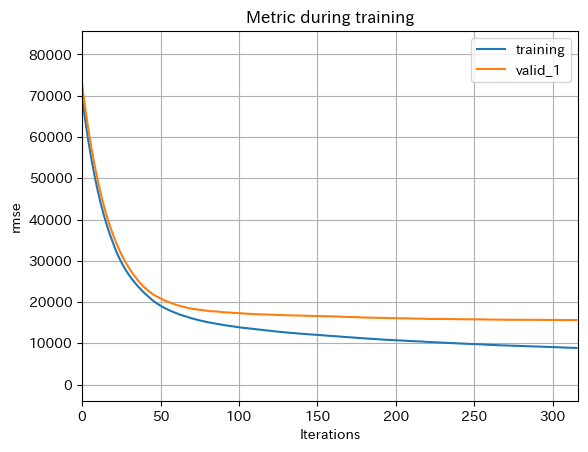

importance
面積               4.619476e+14
L                3.996708e+14
平均地価             2.031232e+14
最寄り駅             9.331244e+13
築年数              7.281202e+13
所在地              4.192739e+13
全体の階数            3.255809e+13
契約期間             1.599722e+13
所在階              9.812672e+12
所要時間             6.761601e+12
定期借家             2.218919e+12
部屋数              1.927770e+12
バス・トイレ別          1.607446e+12
建物構造             7.885001e+11
D                4.683574e+11
100m^2以上         3.107914e+11
75m^2以上100m^2未満  2.472946e+11
50m^2以上75m^2未満   1.528975e+11
S                1.455867e+11
K                4.608390e+10

In [28]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

「建物構造」のみ抜いてみる

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
washlets = pd.read_csv('../data/handmade_data/washlets.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], sepa_bath_toilets, washlets, over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']],test_sepa_bath_toilets, test_washlets, test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K', 'S', 'バス・トイレ別','温水洗浄便座','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

In [34]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=1000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [35]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-16 08:47:00,942] A new study created in memory with name: no-name-b87c82a1-313a-404b-b0ee-b93da8af4f08
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbos

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2839
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48789.5	valid_1's rmse: 50205.7
[20]	training's rmse: 34476.8	valid_1's rmse: 37850.8
[30]	training's rmse: 26106.6	valid_1's rmse: 31149.7
[40]	training's rmse: 20976	valid_1's rmse: 27411.2
[50]	training's rmse: 17643.3	valid_1's rmse: 25110.9
[60]	training's rmse: 15624.8	valid_1's rmse: 23728.6
[70]	training's rmse: 14266	valid_1's rmse: 22855.8
[80]	training's rmse: 13279.1	valid_1's rmse: 22261.1
[90]	training's rmse: 12506.7	valid_1's rmse: 21779.9
[100]	training's rmse: 11925.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2838
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48990.8	valid_1's rmse: 49561.9
[20]	training's rmse: 34902.9	valid_1's rmse: 36014.2
[30]	training's rmse: 26927.9	valid_1's rmse: 28553.5
[40]	training's rmse: 22309.8	valid_1's rmse: 24264.3
[50]	training's rmse: 19263.7	valid_1's rmse: 21389
[60]	training's rmse: 17552.8	valid_1's rmse: 19943.7
[70]	training's rmse: 16363.9	valid_1's rmse: 19046.6
[80]	training's rmse: 15490.8	valid_1's rmse: 18527.5
[90]	training's rmse: 14780.1	valid_1's rmse: 18289.2
[100]	training's rmse: 14230.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35390.8	valid_1's rmse: 33964.8
[30]	training's rmse: 27311.8	valid_1's rmse: 26014.8
[40]	training's rmse: 22354.1	valid_1's rmse: 21626.3
[50]	training's rmse: 19283.3	valid_1's rmse: 19174.4
[60]	training's rmse: 17423.8	valid_1's rmse: 17971.1
[70]	training's rmse: 16232	valid_1's rmse: 17261.3
[80]	training's rmse: 15444	valid_1's rmse: 16872.4
[90]	training's rmse: 14753.5	valid_1's rmse: 16583.1
[100]	training's rmse: 14238.8	valid_1's rmse: 16368.5
[110]	training's rmse: 13761.6	valid_1's rmse: 16175.1
[120]	training's rmse: 13366.3	valid_1's rmse: 16016.9
[130]	training's rmse: 12983.3	valid_1's rmse: 15924.4
[140]	training's rmse: 12672.7	valid_1's rmse: 15817.8
[150]	training's rmse: 12374.2	valid_1's rmse: 15748.6
[160]	training's rmse: 12110.2	valid_1's rmse: 15705.3
[170]	training's rmse: 11826.9	valid_1's rmse: 15655
[180]	training's rmse: 11597.9	valid_1's rmse: 15604.7
[190]	training's rmse: 11379.1	valid_1's rmse: 15563.4
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49246	valid_1's rmse: 48161.4
[20]	training's rmse: 34946.2	valid_1's rmse: 35142.5
[30]	training's rmse: 26712.4	valid_1's rmse: 28071.4
[40]	training's rmse: 21812.4	valid_1's rmse: 24301.9
[50]	training's rmse: 18733.7	valid_1's rmse: 22418.3
[60]	training's rmse: 16830.4	valid_1's rmse: 21276.4
[70]	training's rmse: 15704.7	valid_1's rmse: 20696
[80]	training's rmse: 14892	valid_1's rmse: 20230.5
[90]	training's rmse: 14265.1	valid_1's rmse: 19904.3
[100]	training's rmse: 13758.7	valid_1's rmse: 19663.1
[110]	training's rmse: 13297.1	valid_1's rmse: 19443.2
[120]	training's rmse: 12935.2	valid_1's rmse: 19293.2
[130]	training's rmse: 12623	valid_1's rmse: 19164.5
[140]	training's rmse: 12265.6	valid_1's rmse: 19053
[150]	training's rmse: 11983.5	valid_1's rmse: 18945.4
[160]	training's rmse: 11751.2	valid_1's rmse: 18896.1
[170]	training's rmse: 11477.7	valid_1's rmse: 18808.4
[180]	training's rmse: 11286.9	valid_1's rmse: 18775
[190]	training's rmse: 11061.9	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2838
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48670	valid_1's rmse: 50977.2
[20]	training's rmse: 34959.6	valid_1's rmse: 36900.3
[30]	training's rmse: 26930.2	valid_1's rmse: 28695.6
[40]	training's rmse: 22267.8	valid_1's rmse: 23829.1
[50]	training's rmse: 19099	valid_1's rmse: 21052.1
[60]	training's rmse: 17204.1	valid_1's rmse: 19647.1
[70]	training's rmse: 15993.3	valid_1's rmse: 18795.4
[80]	training's rmse: 15084.9	valid_1's rmse: 18300.1
[90]	training's rmse: 14376.2	valid_1's rmse: 18015.6
[100]	training's rmse: 13850.7	valid_1's rm

[I 2022-09-16 08:47:19,335] Trial 0 finished with value: 16324.542775063588 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16324.542775063588.


[280]	training's rmse: 9806.14	valid_1's rmse: 16369.4
[290]	training's rmse: 9667.19	valid_1's rmse: 16325.8
Early stopping, best iteration is:
[282]	training's rmse: 9766.84	valid_1's rmse: 16324.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2519
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48713.2	valid_1's rmse: 50056.3
[20]	training's rmse: 34372.3	valid_1's rmse: 37791.4
[30]	training's rmse: 25928.6	valid_1's rmse: 30982.7
[40]	training's rmse: 20906.3	valid_1's rmse: 27248.2
[50]	training's rmse: 17680.3	valid_1's rmse: 24938.1
[60]	training's rmse: 15715	valid_1's rmse: 23505.6
[70]	training's rmse: 14352.2	valid_1's rmse: 22568.2
[80]	training's rmse: 13398.1	valid_1's rmse: 21902.5
[90]	training's rmse: 12640.7	valid_1's rmse: 21368.3
[100]	training's rmse: 12096.8	valid_1's rmse: 20961.8
[110]	training's rmse: 11663.7	valid_1's rmse: 20668.7
[120]	training's rmse: 11221.3	valid_1's rmse: 20358.5
[130]	training's rmse: 10828.5	valid_1's rmse: 20078.5
[140]	training's rmse: 10500.5	valid_1's rmse: 19850.1
[150]	training's rmse: 10213.1	valid_1's rmse: 19696.3
[160]	training's rmse: 9946.3	valid_1's rmse: 19551.9
[170]	training's rmse: 9700.03	valid_1's rmse: 19407.1
[180]	training's rmse: 9477.13	valid_1's rmse: 19260.2
[190]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48949.1	valid_1's rmse: 49751.4
[20]	training's rmse: 34910.7	valid_1's rmse: 36282.8
[30]	training's rmse: 26648.7	valid_1's rmse: 28838
[40]	training's rmse: 21909.8	valid_1's rmse: 24682
[50]	training's rmse: 18899.7	valid_1's rmse: 21907.8
[60]	training's rmse: 17057.3	valid_1's rmse: 20646.3
[70]	training's rmse: 15778.7	valid_1's rmse: 19828.2
[80]	training's rmse: 14798.9	valid_1's rmse: 19269.1
[90]	training's rmse: 14029.1	valid_1's rmse: 18996.7
[100]	training's rmse: 13415.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48876.7	valid_1's rmse: 48686.6
[20]	training's rmse: 34934.9	valid_1's rmse: 34355.2
[30]	training's rmse: 26744.3	valid_1's rmse: 26556.5
[40]	training's rmse: 22084.4	valid_1's rmse: 22529.9
[50]	training's rmse: 19147.7	valid_1's rmse: 20254.7
[60]	training's rmse: 17268.4	valid_1's rmse: 19069.2
[70]	training's rmse: 16064.6	valid_1's rmse: 18332.7
[80]	training's rmse: 15129.4	valid_1's rmse: 17886.5
[90]	training's rmse: 14441.5	valid_1's rmse: 17587.1
[100]	training's rmse: 13856.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49176	valid_1's rmse: 48033.7
[20]	training's rmse: 34696.2	valid_1's rmse: 35391.5
[30]	training's rmse: 26310.7	valid_1's rmse: 28469.4
[40]	training's rmse: 21469.6	valid_1's rmse: 24728.9
[50]	training's rmse: 18493.1	valid_1's rmse: 22895.9
[60]	training's rmse: 16637.8	valid_1's rmse: 21934
[70]	training's rmse: 15443.1	valid_1's rmse: 21345.2
[80]	training's rmse: 14556.7	valid_1's rmse: 20829.2
[90]	training's rmse: 13902.7	valid_1's rmse: 20491.6
[100]	training's rmse: 13365.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48668.4	valid_1's rmse: 51002.2
[20]	training's rmse: 35010.9	valid_1's rmse: 36889.2
[30]	training's rmse: 26858	valid_1's rmse: 28465.1
[40]	training's rmse: 22256.8	valid_1's rmse: 23670
[50]	training's rmse: 19062.2	valid_1's rmse: 20961.5
[60]	training's rmse: 17162.1	valid_1's rmse: 19691.6
[70]	training's rmse: 15880.9	valid_1's rmse: 18880.1
[80]	training's rmse: 14931.6	valid_1's rmse: 18426.5
[90]	training's rmse: 14237.3	valid_1's rmse: 18116.6
[100]	training's rmse: 13720.3	valid_1's rm

[I 2022-09-16 08:47:34,290] Trial 1 finished with value: 16571.729239400283 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16324.542775063588.


[290]	training's rmse: 9262.68	valid_1's rmse: 16594.2
[300]	training's rmse: 9103.5	valid_1's rmse: 16593.8
Early stopping, best iteration is:
[291]	training's rmse: 9232.48	valid_1's rmse: 16571.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3002
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48381.4	valid_1's rmse: 49943.1
[20]	training's rmse: 33966.4	valid_1's rmse: 37719.2
[30]	training's rmse: 25612.3	valid_1's rmse: 30984.2
[40]	training's rmse: 20602.2	valid_1's rmse: 27155.2
[50]	training's rmse: 17278.6	valid_1's rmse: 24696.5
[60]	training's rmse: 15321.6	valid_1's rmse: 23206.2
[70]	training's rmse: 13884.7	valid_1's rmse: 22085.3
[80]	training's rmse: 12894.3	valid_1's rmse: 21349.3
[90]	training's rmse: 12130	valid_1's rmse: 20841
[100]	training's rmse: 11577.3	valid_1's rmse: 20493.1
[110]	training's rmse: 11045.3	valid_1's rmse: 20169.4
[120]	training's rmse: 10645.7	valid_1's rmse: 19947
[130]	training's rmse: 10295	valid_1's rmse: 19739.8
[140]	training's rmse: 9957.79	valid_1's rmse: 19537.5
[150]	training's rmse: 9617.24	valid_1's rmse: 19294.8
[160]	training's rmse: 9345.44	valid_1's rmse: 19117.1
[170]	training's rmse: 9092.33	valid_1's rmse: 19008.1
[180]	training's rmse: 8867.2	valid_1's rmse: 18899.3
[190]	training's rmse: 8659.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3005
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48761.1	valid_1's rmse: 49599.1
[20]	training's rmse: 34594.9	valid_1's rmse: 36020.8
[30]	training's rmse: 26584.8	valid_1's rmse: 28710.6
[40]	training's rmse: 21982.8	valid_1's rmse: 24529
[50]	training's rmse: 18998.7	valid_1's rmse: 21495.7
[60]	training's rmse: 17291.7	valid_1's rmse: 19855.9
[70]	training's rmse: 16092.4	valid_1's rmse: 18884.1
[80]	training's rmse: 15032.9	valid_1's rmse: 18196.5
[90]	training's rmse: 14240.4	valid_1's rmse: 17857.8
[100]	training's rmse: 13679.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48768.2	valid_1's rmse: 48302.3
[20]	training's rmse: 34786.5	valid_1's rmse: 33746.9
[30]	training's rmse: 26554.9	valid_1's rmse: 26011.5
[40]	training's rmse: 21869.6	valid_1's rmse: 22023.4
[50]	training's rmse: 18731.5	valid_1's rmse: 19650.2
[60]	training's rmse: 16887.2	valid_1's rmse: 18408.6
[70]	training's rmse: 15674.9	valid_1's rmse: 17825
[80]	training's rmse: 14802.2	valid_1's rmse: 17451
[90]	training's rmse: 14124.7	valid_1's rmse: 17174.5
[100]	training's rmse: 13573.9	valid_1's rmse: 16987.9
[110]	training's rmse: 13116.9	valid_1's rmse: 16900.5
[120]	training's rmse: 12685.5	valid_1's rmse: 16763.6
[130]	training's rmse: 12307.4	valid_1's rmse: 16676.1
[140]	training's rmse: 11946.7	valid_1's rmse: 16628.8
Early stopping, best iteration is:
[137]	training's rmse: 12057.9	valid_1's rmse: 16619.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3005
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48817.2	valid_1's rmse: 47919.3
[20]	training's rmse: 34352.7	valid_1's rmse: 35348
[30]	training's rmse: 25934.1	valid_1's rmse: 28315.4
[40]	training's rmse: 21068.8	valid_1's rmse: 24685.3
[50]	training's rmse: 17985.7	valid_1's rmse: 22910.5
[60]	training's rmse: 16259.8	valid_1's rmse: 21959.5
[70]	training's rmse: 15107.7	valid_1's rmse: 21272.8
[80]	training's rmse: 14332.8	valid_1's rmse: 20804.2
[90]	training's rmse: 13734.9	valid_1's rmse: 20510.2
[100]	training's rmse: 13255.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48299.5	valid_1's rmse: 50748.1
[20]	training's rmse: 34349	valid_1's rmse: 36715.8
[30]	training's rmse: 26316	valid_1's rmse: 28477.2
[40]	training's rmse: 21676.2	valid_1's rmse: 23727.6
[50]	training's rmse: 18530.5	valid_1's rmse: 20808.5
[60]	training's rmse: 16605.8	valid_1's rmse: 19414.3
[70]	training's rmse: 15463.2	valid_1's rmse: 18660.7
[80]	training's rmse: 14537.9	valid_1's rmse: 18242.6
[90]	training's rmse: 13897.4	valid_1's rmse: 18055.8
[100]	training's rmse: 13403.7	valid_1's rmse: 17899.3
[110]	training's rmse: 12970.9	valid_1's rmse: 17798.3
[120]	training's rmse: 12629.8	valid_1's rmse: 17717.8
[130]	training's rmse: 12272.1	valid_1's rmse: 17678.9
[140]	training's rmse: 11979	valid_1's rmse: 17641.4
[150]	training's rmse: 11718.6	valid_1's rmse: 17629.3
[160]	training's rmse: 11490.8	valid_1's rmse: 17597.1
[170]	training's rmse: 11277	valid_1's rmse: 17575.4
[180]	training's rmse: 11060.2	valid_1's rmse: 17537
[190]	training's rmse: 10891.

[I 2022-09-16 08:47:48,531] Trial 2 finished with value: 17259.325791274896 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 16324.542775063588.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2913
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48773.7	valid_1's rmse: 50291.6
[20]	training's rmse: 34403.2	valid_1's rmse: 37964.8
[30]	training's rmse: 26130.9	valid_1's rmse: 31173.5
[40]	training's rmse: 20962.4	valid_1's rmse: 27295.8
[50]	training's rmse: 17689.2	valid_1's rmse: 24904.1
[60]	training's rmse: 15691.6	valid_1's rmse: 23445
[70]	training's rmse: 14291.4	valid_1's rmse: 22428.8
[80]	training's rmse: 13309.3	valid_1's rmse: 21807.8
[90]	training's rmse: 12583.8	valid_1's rmse: 21362.8
[100]	training's rmse: 12035.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48949.3	valid_1's rmse: 49631.7
[20]	training's rmse: 34889.4	valid_1's rmse: 36559.5
[30]	training's rmse: 26931.1	valid_1's rmse: 29381.4
[40]	training's rmse: 22110.9	valid_1's rmse: 24747
[50]	training's rmse: 19196.7	valid_1's rmse: 21747.9
[60]	training's rmse: 17532.8	valid_1's rmse: 20256.4
[70]	training's rmse: 16323.2	valid_1's rmse: 19122.4
[80]	training's rmse: 15351.1	valid_1's rmse: 18407.1
[90]	training's rmse: 14656.4	valid_1's rmse: 18074.4
[100]	training's rmse: 14111	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2909
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49064	valid_1's rmse: 48626.6
[20]	training's rmse: 35263.9	valid_1's rmse: 34037.3
[30]	training's rmse: 27015.1	valid_1's rmse: 26014.1
[40]	training's rmse: 22286.1	valid_1's rmse: 21768.1
[50]	training's rmse: 19332.8	valid_1's rmse: 19369.5
[60]	training's rmse: 17442.1	valid_1's rmse: 18198.6
[70]	training's rmse: 16146.8	valid_1's rmse: 17407.4
[80]	training's rmse: 15307.4	valid_1's rmse: 17013.8
[90]	training's rmse: 14645.5	valid_1's rmse: 16822
[100]	training's rmse: 14149.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34999.8	valid_1's rmse: 35403.9
[30]	training's rmse: 26641.8	valid_1's rmse: 28244.9
[40]	training's rmse: 21718	valid_1's rmse: 24504
[50]	training's rmse: 18646.1	valid_1's rmse: 22631
[60]	training's rmse: 16908.6	valid_1's rmse: 21511.8
[70]	training's rmse: 15678.4	valid_1's rmse: 20877.7
[80]	training's rmse: 14898.6	valid_1's rmse: 20399.6
[90]	training's rmse: 14268.2	valid_1's rmse: 20045.8
[100]	training's rmse: 13749.9	valid_1's rmse: 19682.3
[110]	training's rmse: 13270.8	valid_1's rmse: 19387.7
[120]	training's rmse: 12867.8	valid_1's rmse: 19154.6
[130]	training's rmse: 12424.4	valid_1's rmse: 18932.6
[140]	training's rmse: 12093.9	valid_1's rmse: 18803
[150]	training's rmse: 11787.2	valid_1's rmse: 18723.7
[160]	training's rmse: 11542.3	valid_1's rmse: 18665.8
[170]	training's rmse: 11280.1	valid_1's rmse: 18558.6
[180]	training's rmse: 11031.7	valid_1's rmse: 18497.2
[190]	training's rmse: 10810.5	valid_1's rmse: 18446.5
[200]	training's rmse: 105

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35032.7	valid_1's rmse: 37087.5
[30]	training's rmse: 27012.7	valid_1's rmse: 28894.8
[40]	training's rmse: 22322.6	valid_1's rmse: 24108.1
[50]	training's rmse: 19154.9	valid_1's rmse: 21198.2
[60]	training's rmse: 17315.8	valid_1's rmse: 19758.1
[70]	training's rmse: 16099.6	valid_1's rmse: 19019.2
[80]	training's rmse: 15148.9	valid_1's rmse: 18568.4
[90]	training's rmse: 14474.5	valid_1's rmse: 18328.1
[100]	training's rmse: 13942.8	valid_1's rmse: 18202.3
[110]	training's rmse: 13505.6	valid_1's rmse: 18089
[120]	training's rmse: 13127.3	valid_1's rmse: 18012.7
[130]	training's rmse: 12793.8	valid_1's rmse: 17969.5
[140]	training's rmse: 12498.9	valid_1's rmse: 17907.9
[150]	training's rmse: 12216.4	valid_1's rmse: 17883.2
[160]	training's rmse: 11982.6	valid_1's rmse: 17865.6
[170]	training's rmse: 11757.2	valid_1's rmse: 17838
[180]	training's rmse: 11547.5	valid_1's rmse: 17819.2
[190]	training's rmse: 11368.1	valid_1's rmse: 17803
[200]	training's rmse: 1

[I 2022-09-16 08:48:00,068] Trial 3 finished with value: 17481.414417978613 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 16324.542775063588.


Early stopping, best iteration is:
[332]	training's rmse: 9328	valid_1's rmse: 17481.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3035
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49297	valid_1's rmse: 50776


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35117	valid_1's rmse: 38565.5
[30]	training's rmse: 26796.7	valid_1's rmse: 31801.8
[40]	training's rmse: 21762	valid_1's rmse: 27810.7
[50]	training's rmse: 18556.2	valid_1's rmse: 25360.6
[60]	training's rmse: 16546.9	valid_1's rmse: 23858.8
[70]	training's rmse: 15252	valid_1's rmse: 22916.2
[80]	training's rmse: 14283.6	valid_1's rmse: 22232.6
[90]	training's rmse: 13594.6	valid_1's rmse: 21788.6
[100]	training's rmse: 13063.5	valid_1's rmse: 21496.7
[110]	training's rmse: 12592.2	valid_1's rmse: 21200.7
[120]	training's rmse: 12170.6	valid_1's rmse: 20918
[130]	training's rmse: 11804.9	valid_1's rmse: 20696.5
[140]	training's rmse: 11477.5	valid_1's rmse: 20463.4
[150]	training's rmse: 11198.2	valid_1's rmse: 20273.4
[160]	training's rmse: 10907.4	valid_1's rmse: 20067
[170]	training's rmse: 10679.2	valid_1's rmse: 19944.6
[180]	training's rmse: 10414.1	valid_1's rmse: 19814.8
[190]	training's rmse: 10216.3	valid_1's rmse: 19710.5
[200]	training's rmse: 10023

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49469.7	valid_1's rmse: 50082.3
[20]	training's rmse: 35574.2	valid_1's rmse: 36708.1
[30]	training's rmse: 27680.1	valid_1's rmse: 29360.4
[40]	training's rmse: 22961.8	valid_1's rmse: 24810.4
[50]	training's rmse: 20064.2	valid_1's rmse: 21916.2
[60]	training's rmse: 18282	valid_1's rmse: 20485.9
[70]	training's rmse: 17054.4	valid_1's rmse: 19453.8
[80]	training's rmse: 16140	valid_1's rmse: 18769.6
[90]	training's rmse: 15363.3	valid_1's rmse: 18379.1
[100]	training's rmse: 14827.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[40]	training's rmse: 22849.7	valid_1's rmse: 22655.2
[50]	training's rmse: 19874.1	valid_1's rmse: 20247.6
[60]	training's rmse: 18007.3	valid_1's rmse: 18852.4
[70]	training's rmse: 16847.5	valid_1's rmse: 18137.3
[80]	training's rmse: 15981.9	valid_1's rmse: 17678.7
[90]	training's rmse: 15268.9	valid_1's rmse: 17376.9
[100]	training's rmse: 14716.9	valid_1's rmse: 17143.1
[110]	training's rmse: 14274.5	valid_1's rmse: 16970.1
[120]	training's rmse: 13887.8	valid_1's rmse: 16880.7
[130]	training's rmse: 13513.6	valid_1's rmse: 16794.2
[140]	training's rmse: 13131.8	valid_1's rmse: 16718.7
[150]	training's rmse: 12820.7	valid_1's rmse: 16623.8
[160]	training's rmse: 12546.9	valid_1's rmse: 16584
[170]	training's rmse: 12301.7	valid_1's rmse: 16567.5
[180]	training's rmse: 12079.8	valid_1's rmse: 16539.5
[190]	training's rmse: 11874.3	valid_1's rmse: 16531.2
[200]	training's rmse: 11688.1	valid_1's rmse: 16500.9
[210]	training's rmse: 11507.3	valid_1's rmse: 16474.3
[220]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[30]	training's rmse: 27065.6	valid_1's rmse: 29292
[40]	training's rmse: 22299.1	valid_1's rmse: 25584.1
[50]	training's rmse: 19303.7	valid_1's rmse: 23567
[60]	training's rmse: 17490.4	valid_1's rmse: 22300.8
[70]	training's rmse: 16336.6	valid_1's rmse: 21630.1
[80]	training's rmse: 15495.3	valid_1's rmse: 21156.5
[90]	training's rmse: 14882.4	valid_1's rmse: 20791.5
[100]	training's rmse: 14392.1	valid_1's rmse: 20462.4
[110]	training's rmse: 13995.4	valid_1's rmse: 20196.7
[120]	training's rmse: 13629.7	valid_1's rmse: 19967.5
[130]	training's rmse: 13271.3	valid_1's rmse: 19780.4
[140]	training's rmse: 13002.3	valid_1's rmse: 19670.7
[150]	training's rmse: 12708.1	valid_1's rmse: 19550.1
[160]	training's rmse: 12473.7	valid_1's rmse: 19448.9
[170]	training's rmse: 12216.9	valid_1's rmse: 19364.6
[180]	training's rmse: 12012.6	valid_1's rmse: 19291.6
[190]	training's rmse: 11825.9	valid_1's rmse: 19245.2
[200]	training's rmse: 11626.7	valid_1's rmse: 19177.6
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3037
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49140.5	valid_1's rmse: 51586.9
[20]	training's rmse: 35589.2	valid_1's rmse: 37688.9
[30]	training's rmse: 27789.7	valid_1's rmse: 29561.4
[40]	training's rmse: 23030.7	valid_1's rmse: 24528.9
[50]	training's rmse: 19932.9	valid_1's rmse: 21690.4
[60]	training's rmse: 17999.5	valid_1's rmse: 20153.7
[70]	training's rmse: 16679.3	valid_1's rmse: 19294.4
[80]	training's rmse: 15785.6	valid_1's rmse: 18811.8
[90]	training's rmse: 15097.2	valid_1's rmse: 18503.7
[100]	training's rmse: 14584.8	valid_1'

[I 2022-09-16 08:48:08,841] Trial 4 finished with value: 17651.33284252276 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 16324.542775063588.


[280]	training's rmse: 10631.5	valid_1's rmse: 17661.9
Early stopping, best iteration is:
[273]	training's rmse: 10707.8	valid_1's rmse: 17651.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48693.4	valid_1's rmse: 50300.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34485.3	valid_1's rmse: 38191.2
[30]	training's rmse: 26017.2	valid_1's rmse: 31465.5
[40]	training's rmse: 20974.1	valid_1's rmse: 27709.3
[50]	training's rmse: 17574.8	valid_1's rmse: 25324.3
[60]	training's rmse: 15587.4	valid_1's rmse: 23932.5
[70]	training's rmse: 14220.7	valid_1's rmse: 22969.2
[80]	training's rmse: 13165.2	valid_1's rmse: 22261.6
[90]	training's rmse: 12409.3	valid_1's rmse: 21761.4
[100]	training's rmse: 11780.6	valid_1's rmse: 21317.9
[110]	training's rmse: 11240.3	valid_1's rmse: 20955.6
[120]	training's rmse: 10789.9	valid_1's rmse: 20663.6
[130]	training's rmse: 10404.1	valid_1's rmse: 20425.2
[140]	training's rmse: 10056.6	valid_1's rmse: 20179.3
[150]	training's rmse: 9738.64	valid_1's rmse: 19919.9
[160]	training's rmse: 9446.73	valid_1's rmse: 19715.4
[170]	training's rmse: 9183.97	valid_1's rmse: 19546.3
[180]	training's rmse: 8927.27	valid_1's rmse: 19381.1
[190]	training's rmse: 8692.08	valid_1's rmse: 19207.7
[200]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48805.4	valid_1's rmse: 49276.2
[20]	training's rmse: 34778.3	valid_1's rmse: 35782.9
[30]	training's rmse: 26622.2	valid_1's rmse: 28086.4
[40]	training's rmse: 21946.9	valid_1's rmse: 24088.1
[50]	training's rmse: 18849.7	valid_1's rmse: 21521.2
[60]	training's rmse: 16981.4	valid_1's rmse: 20002
[70]	training's rmse: 15699.3	valid_1's rmse: 19031.6
[80]	training's rmse: 14655.5	valid_1's rmse: 18442.8
[90]	training's rmse: 13856.5	valid_1's rmse: 18232.7
[100]	training's rmse: 13201.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35005.9	valid_1's rmse: 34857.5
[30]	training's rmse: 26788.1	valid_1's rmse: 27175.6
[40]	training's rmse: 22054.5	valid_1's rmse: 23024.5
[50]	training's rmse: 19063.8	valid_1's rmse: 20668.8
[60]	training's rmse: 17111.9	valid_1's rmse: 19510
[70]	training's rmse: 15755.7	valid_1's rmse: 18900.4
[80]	training's rmse: 14749.1	valid_1's rmse: 18535.6
[90]	training's rmse: 13916.4	valid_1's rmse: 18259.5
[100]	training's rmse: 13232.3	valid_1's rmse: 18014.5
[110]	training's rmse: 12658.9	valid_1's rmse: 17866.2
[120]	training's rmse: 12176.1	valid_1's rmse: 17782.2
[130]	training's rmse: 11709.6	valid_1's rmse: 17708.8
[140]	training's rmse: 11314.7	valid_1's rmse: 17669.2
[150]	training's rmse: 10965.1	valid_1's rmse: 17630.7
[160]	training's rmse: 10637.6	valid_1's rmse: 17648.1
[170]	training's rmse: 10348.7	valid_1's rmse: 17641.9
[180]	training's rmse: 10084.9	valid_1's rmse: 17625
[190]	training's rmse: 9845.02	valid_1's rmse: 17609.6
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49112.3	valid_1's rmse: 47855.4
[20]	training's rmse: 34957.3	valid_1's rmse: 35221
[30]	training's rmse: 26474.1	valid_1's rmse: 28061.8
[40]	training's rmse: 21656.1	valid_1's rmse: 24318.4
[50]	training's rmse: 18520.9	valid_1's rmse: 22399.3
[60]	training's rmse: 16551.9	valid_1's rmse: 21544.2
[70]	training's rmse: 15203.7	valid_1's rmse: 20980.5
[80]	training's rmse: 14209.3	valid_1's rmse: 20498.3
[90]	training's rmse: 13442	valid_1's rmse: 20124.3
[100]	training's rmse: 12846.8	valid_1's rmse: 19867.9
[110]	training's rmse: 12352.3	valid_1's rmse: 19700.5
[120]	training's rmse: 11905.3	valid_1's rmse: 19525.5
[130]	training's rmse: 11517.1	valid_1's rmse: 19309.2
[140]	training's rmse: 11157	valid_1's rmse: 19210.7
[150]	training's rmse: 10825.5	valid_1's rmse: 19057.4
[160]	training's rmse: 10520.2	valid_1's rmse: 18967.5
[170]	training's rmse: 10249.7	valid_1's rmse: 18882.2
[180]	training's rmse: 10012	valid_1's rmse: 18796
[190]	training's rmse: 9791.4

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48460.9	valid_1's rmse: 50953.1
[20]	training's rmse: 34738.8	valid_1's rmse: 36852.9
[30]	training's rmse: 26710.5	valid_1's rmse: 28485.5
[40]	training's rmse: 22017	valid_1's rmse: 23664.5
[50]	training's rmse: 18938.1	valid_1's rmse: 20922.1
[60]	training's rmse: 16976.7	valid_1's rmse: 19551
[70]	training's rmse: 15619.1	valid_1's rmse: 18752.3
[80]	training's rmse: 14612.7	valid_1's rmse: 18296.9
[90]	training's rmse: 13875.7	valid_1's rmse: 17983
[100]	training's rmse: 13289.6	valid_1's rmse

[I 2022-09-16 08:48:18,990] Trial 5 finished with value: 16325.82095245065 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 16324.542775063588.


[270]	training's rmse: 8907.46	valid_1's rmse: 16344.9
[280]	training's rmse: 8747.19	valid_1's rmse: 16341.1
Early stopping, best iteration is:
[271]	training's rmse: 8879.83	valid_1's rmse: 16325.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48398.6	valid_1's rmse: 50060.2
[20]	training's rmse: 33920.4	valid_1's rmse: 37683.5
[30]	training's rmse: 25551.6	valid_1's rmse: 30956.5
[40]	training's rmse: 20529.5	valid_1's rmse: 27079.2
[50]	training's rmse: 17245	valid_1's rmse: 24625.9
[60]	training's rmse: 15232.8	valid_1's rmse: 23064.2
[70]	training's rmse: 13857	valid_1's rmse: 21985.6
[80]	training's rmse: 12839.4	valid_1's rmse: 21260
[90]	training's rmse: 12116.9	valid_1's rmse: 20783.9
[100]	training's rmse: 11468.5	valid_1's rmse: 20372.3
[110]	training's rmse: 10946.7	valid_1's rmse: 20022.7
[120]	training's rmse: 10557.4	valid_1's rmse: 19818.1
[130]	training's rmse: 10178.3	valid_1's rmse: 19637.7
[140]	training's rmse: 9834.49	valid_1's rmse: 19497.5
[150]	training's rmse: 9533.9	valid_1's rmse: 19359.6
[160]	training's rmse: 9266.35	valid_1's rmse: 19216
[170]	training's rmse: 9042.68	valid_1's rmse: 19107.6
[180]	training's rmse: 8807.79	valid_1's rmse: 18998.7
[190]	training's rmse: 8587.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48757.4	valid_1's rmse: 49584.4
[20]	training's rmse: 34531.7	valid_1's rmse: 35985
[30]	training's rmse: 26559.6	valid_1's rmse: 28776.5
[40]	training's rmse: 21996.6	valid_1's rmse: 24415.9
[50]	training's rmse: 18957.8	valid_1's rmse: 21290.6
[60]	training's rmse: 17257.1	valid_1's rmse: 19817.6
[70]	training's rmse: 16035.1	valid_1's rmse: 18926
[80]	training's rmse: 15079.1	valid_1's rmse: 18326.4
[90]	training's rmse: 14310.1	valid_1's rmse: 17929.8
[100]	training's rmse: 13751.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34795.5	valid_1's rmse: 33736.9
[30]	training's rmse: 26498.4	valid_1's rmse: 25959.7
[40]	training's rmse: 21812.1	valid_1's rmse: 21766.8
[50]	training's rmse: 18723.3	valid_1's rmse: 19477.1
[60]	training's rmse: 16871	valid_1's rmse: 18414.3
[70]	training's rmse: 15689.8	valid_1's rmse: 17756.1
[80]	training's rmse: 14851.3	valid_1's rmse: 17341.1
[90]	training's rmse: 14178.7	valid_1's rmse: 17077.8
[100]	training's rmse: 13642.7	valid_1's rmse: 16926.1
[110]	training's rmse: 13134.7	valid_1's rmse: 16792.7
[120]	training's rmse: 12717.3	valid_1's rmse: 16696
[130]	training's rmse: 12307.3	valid_1's rmse: 16616
[140]	training's rmse: 11980	valid_1's rmse: 16572.3
[150]	training's rmse: 11668.5	valid_1's rmse: 16554.7
[160]	training's rmse: 11393.1	valid_1's rmse: 16540.7
[170]	training's rmse: 11112	valid_1's rmse: 16533.2
Early stopping, best iteration is:
[162]	training's rmse: 11349.8	valid_1's rmse: 16524.6
[LightGBM] [Warning] Auto-choosing row-wise mult

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34369.8	valid_1's rmse: 35182.9
[30]	training's rmse: 25881.9	valid_1's rmse: 28175.7
[40]	training's rmse: 21124.1	valid_1's rmse: 24564.5
[50]	training's rmse: 18007.9	valid_1's rmse: 22777.5
[60]	training's rmse: 16199.1	valid_1's rmse: 21843.1
[70]	training's rmse: 15080.7	valid_1's rmse: 21231.6
[80]	training's rmse: 14300.6	valid_1's rmse: 20769.8
[90]	training's rmse: 13708.1	valid_1's rmse: 20448.1
[100]	training's rmse: 13221.3	valid_1's rmse: 20188.9
[110]	training's rmse: 12837.8	valid_1's rmse: 20032
[120]	training's rmse: 12463.9	valid_1's rmse: 19825
[130]	training's rmse: 12129.7	valid_1's rmse: 19694.5
[140]	training's rmse: 11795.3	valid_1's rmse: 19566.3
[150]	training's rmse: 11515.3	valid_1's rmse: 19507.1
[160]	training's rmse: 11279.4	valid_1's rmse: 19439.1
[170]	training's rmse: 11047.8	valid_1's rmse: 19404.9
[180]	training's rmse: 10829.3	valid_1's rmse: 19374.8
[190]	training's rmse: 10589.1	valid_1's rmse: 19314.8
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48297.5	valid_1's rmse: 50774.5
[20]	training's rmse: 34432.6	valid_1's rmse: 36798.1
[30]	training's rmse: 26338	valid_1's rmse: 28582.2
[40]	training's rmse: 21618.4	valid_1's rmse: 23746.6
[50]	training's rmse: 18476.2	valid_1's rmse: 20880.5
[60]	training's rmse: 16630.3	valid_1's rmse: 19547.7
[70]	training's rmse: 15472.7	valid_1's rmse: 18880.6
[80]	training's rmse: 14590.6	valid_1's rmse: 18522.1
[90]	training's rmse: 13955.2	valid_1's rmse: 18314.4
[100]	training's rmse: 13436.7	valid_1's 

[I 2022-09-16 08:48:29,826] Trial 6 finished with value: 17791.330840707375 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 0 with value: 16324.542775063588.


Early stopping, best iteration is:
[196]	training's rmse: 10741.2	valid_1's rmse: 17791.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2569
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.6	valid_1's rmse: 50392.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34363.7	valid_1's rmse: 38096.5
[30]	training's rmse: 25876.8	valid_1's rmse: 31162.7
[40]	training's rmse: 20794.2	valid_1's rmse: 27336
[50]	training's rmse: 17525.5	valid_1's rmse: 24949.2
[60]	training's rmse: 15551.1	valid_1's rmse: 23439.1
[70]	training's rmse: 14161.7	valid_1's rmse: 22481.7
[80]	training's rmse: 13133	valid_1's rmse: 21758.3
[90]	training's rmse: 12340.8	valid_1's rmse: 21231.3
[100]	training's rmse: 11698.9	valid_1's rmse: 20846.8
[110]	training's rmse: 11216.3	valid_1's rmse: 20533.7
[120]	training's rmse: 10779	valid_1's rmse: 20233.9
[130]	training's rmse: 10418.5	valid_1's rmse: 19982.7
[140]	training's rmse: 10072.3	valid_1's rmse: 19748.6
[150]	training's rmse: 9775.97	valid_1's rmse: 19572.8
[160]	training's rmse: 9503.87	valid_1's rmse: 19389
[170]	training's rmse: 9271.89	valid_1's rmse: 19279.2
[180]	training's rmse: 9055.56	valid_1's rmse: 19157.9
[190]	training's rmse: 8848.5	valid_1's rmse: 19044.1
[200]	training's rmse: 8661

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48862.6	valid_1's rmse: 49604.4
[20]	training's rmse: 34681.3	valid_1's rmse: 36006
[30]	training's rmse: 26472.6	valid_1's rmse: 28438.9
[40]	training's rmse: 21707.4	valid_1's rmse: 24260.1
[50]	training's rmse: 18777.4	valid_1's rmse: 21610.6
[60]	training's rmse: 16976.2	valid_1's rmse: 20179.1
[70]	training's rmse: 15662.3	valid_1's rmse: 19232.6
[80]	training's rmse: 14707.8	valid_1's rmse: 18726.2
[90]	training's rmse: 13949	valid_1's rmse: 18422.9
[100]	training's rmse: 13363.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34807.3	valid_1's rmse: 34172.3
[30]	training's rmse: 26641	valid_1's rmse: 26515.2
[40]	training's rmse: 21998.7	valid_1's rmse: 22529.5
[50]	training's rmse: 18988.4	valid_1's rmse: 20224.5
[60]	training's rmse: 17064	valid_1's rmse: 18862.4
[70]	training's rmse: 15888.5	valid_1's rmse: 18238.2
[80]	training's rmse: 14971.7	valid_1's rmse: 17776.6
[90]	training's rmse: 14269	valid_1's rmse: 17493.5
[100]	training's rmse: 13710.8	valid_1's rmse: 17246.8
[110]	training's rmse: 13250.5	valid_1's rmse: 17148.4
[120]	training's rmse: 12849.1	valid_1's rmse: 17089.8
[130]	training's rmse: 12456.7	valid_1's rmse: 17066.6
[140]	training's rmse: 12109.3	valid_1's rmse: 17027.3
[150]	training's rmse: 11774.7	valid_1's rmse: 16948.7
[160]	training's rmse: 11443.2	valid_1's rmse: 16909.6
[170]	training's rmse: 11172.8	valid_1's rmse: 16906.8
Early stopping, best iteration is:
[164]	training's rmse: 11340.6	valid_1's rmse: 16894.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2569
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49167.7	valid_1's rmse: 47893.6
[20]	training's rmse: 34781.4	valid_1's rmse: 35335.9
[30]	training's rmse: 26291.4	valid_1's rmse: 28496.2
[40]	training's rmse: 21445.5	valid_1's rmse: 24999.7
[50]	training's rmse: 18415.5	valid_1's rmse: 23111
[60]	training's rmse: 16597.1	valid_1's rmse: 22014.2
[70]	training's rmse: 15340.1	valid_1's rmse: 21506.2
[80]	training's rmse: 14446.8	valid_1's rmse: 21152.9
[90]	training's rmse: 13746.8	valid_1's rmse: 20888.8
[100]	training's rmse: 13202	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48602.4	valid_1's rmse: 50945.5
[20]	training's rmse: 34953.4	valid_1's rmse: 36898.9
[30]	training's rmse: 26826.1	valid_1's rmse: 28628.3
[40]	training's rmse: 22270.3	valid_1's rmse: 23982.3
[50]	training's rmse: 19093.8	valid_1's rmse: 21405
[60]	training's rmse: 17135.2	valid_1's rmse: 20065.4
[70]	training's rmse: 15821.6	valid_1's rmse: 19194.1
[80]	training's rmse: 14909.2	valid_1's rmse: 18623
[90]	training's rmse: 14207.2	valid_1's rmse: 18295.7
[100]	training's rmse: 13669.5	valid_1's rm

[I 2022-09-16 08:48:44,194] Trial 7 finished with value: 16994.77354623719 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 0 with value: 16324.542775063588.


[220]	training's rmse: 10193	valid_1's rmse: 17019.1
Early stopping, best iteration is:
[216]	training's rmse: 10290.9	valid_1's rmse: 16994.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2766
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49225.6	valid_1's rmse: 50629.4
[20]	training's rmse: 35159.5	valid_1's rmse: 38336.5
[30]	training's rmse: 26922.6	valid_1's rmse: 31630.8
[40]	training's rmse: 21766.6	valid_1's rmse: 27602.8
[50]	training's rmse: 18483.4	valid_1's rmse: 25200.2
[60]	training's rmse: 16510.2	valid_1's rmse: 23772.7
[70]	training's rmse: 15129	valid_1's rmse: 22800.7
[80]	training's rmse: 14147.6	valid_1's rmse: 22166.8
[90]	training's rmse: 13475.4	valid_1's rmse: 21757.9
[100]	training's rmse: 12910.6	valid_1's rmse: 21392.1
[110]	training's rmse: 12430.2	valid_1's rmse: 21090.5
[120]	training's rmse: 12033	valid_1's rmse: 20827.3
[130]	training's rmse: 11689	valid_1's rmse: 20607.3
[140]	training's rmse: 11335.4	valid_1's rmse: 20362.2
[150]	training's rmse: 11018.6	valid_1's rmse: 20147.3
[160]	training's rmse: 10746.7	valid_1's rmse: 19944.3
[170]	training's rmse: 10501.6	valid_1's rmse: 19755.5
[180]	training's rmse: 10296.2	valid_1's rmse: 19628.7
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2767
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49361.3	valid_1's rmse: 50036.6
[20]	training's rmse: 35559	valid_1's rmse: 36728.3
[30]	training's rmse: 27512.7	valid_1's rmse: 29084.4
[40]	training's rmse: 22718.5	valid_1's rmse: 24690.9
[50]	training's rmse: 19854	valid_1's rmse: 22046.8
[60]	training's rmse: 18101.1	valid_1's rmse: 20645.1
[70]	training's rmse: 16908.8	valid_1's rmse: 19707.7
[80]	training's rmse: 15982.7	valid_1's rmse: 19103.1
[90]	training's rmse: 15347.7	valid_1's rmse: 18860
[100]	training's rmse: 14818.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35853.4	valid_1's rmse: 34508.7
[30]	training's rmse: 27742.5	valid_1's rmse: 26634
[40]	training's rmse: 22953.2	valid_1's rmse: 22462.5
[50]	training's rmse: 19943.2	valid_1's rmse: 20039.9
[60]	training's rmse: 18039.9	valid_1's rmse: 18782.4
[70]	training's rmse: 16860.2	valid_1's rmse: 17921.9
[80]	training's rmse: 16021.8	valid_1's rmse: 17465.4
[90]	training's rmse: 15391.9	valid_1's rmse: 17113.3
[100]	training's rmse: 14848.6	valid_1's rmse: 16856.7
[110]	training's rmse: 14422.3	valid_1's rmse: 16705
[120]	training's rmse: 14043.8	valid_1's rmse: 16558.1
[130]	training's rmse: 13675.9	valid_1's rmse: 16450.1
[140]	training's rmse: 13382.5	valid_1's rmse: 16382.8
[150]	training's rmse: 13094.4	valid_1's rmse: 16309.1
[160]	training's rmse: 12810.9	valid_1's rmse: 16265.5
[170]	training's rmse: 12568.1	valid_1's rmse: 16194.1
[180]	training's rmse: 12357.2	valid_1's rmse: 16151.4
[190]	training's rmse: 12120.6	valid_1's rmse: 16107.9
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49623.1	valid_1's rmse: 48634.6
[20]	training's rmse: 35670.2	valid_1's rmse: 36016
[30]	training's rmse: 27401.9	valid_1's rmse: 29022.3
[40]	training's rmse: 22420.2	valid_1's rmse: 25181.1
[50]	training's rmse: 19353.4	valid_1's rmse: 23200.2
[60]	training's rmse: 17644.3	valid_1's rmse: 22029.9
[70]	training's rmse: 16417.8	valid_1's rmse: 21334.3
[80]	training's rmse: 15598.6	valid_1's rmse: 20853.5
[90]	training's rmse: 14985.1	valid_1's rmse: 20527
[100]	training's rmse: 14483	valid_1's rmse: 20275.9
[110]	training's rmse: 14038	valid_1's rmse: 20079.1
[120]	training's rmse: 13655.3	valid_1's rmse: 19892.2
[130]	training's rmse: 13319.8	valid_1's rmse: 19740.6
[140]	training's rmse: 13032.5	valid_1's rmse: 19653.7
[150]	training's rmse: 12754.6	valid_1's rmse: 19563.3
[160]	training's rmse: 12516	valid_1's rmse: 19504.7
[170]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2765
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49200.6	valid_1's rmse: 51530.5
[20]	training's rmse: 35663.1	valid_1's rmse: 37485.8
[30]	training's rmse: 27812.5	valid_1's rmse: 29221.1
[40]	training's rmse: 23150.8	valid_1's rmse: 24338.2
[50]	training's rmse: 20019.6	valid_1's rmse: 21600.3
[60]	training's rmse: 18160.7	valid_1's rmse: 20090.2
[70]	training's rmse: 16910.1	valid_1's rmse: 19239.8
[80]	training's rmse: 16011.7	valid_1's rmse: 18695.7
[90]	training's rmse: 15354.5	valid_1's rmse: 18412.5
[100]	training's rmse: 14807.8	valid_1'

[I 2022-09-16 08:48:54,200] Trial 8 finished with value: 17091.523717335906 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 0 with value: 16324.542775063588.


[290]	training's rmse: 10628.7	valid_1's rmse: 17093.1
Early stopping, best iteration is:
[283]	training's rmse: 10728.1	valid_1's rmse: 17091.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2647
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48962.6	valid_1's rmse: 50519.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34667.4	valid_1's rmse: 38238.2
[30]	training's rmse: 26322.3	valid_1's rmse: 31418
[40]	training's rmse: 21336.2	valid_1's rmse: 27597.5
[50]	training's rmse: 18043.8	valid_1's rmse: 25230.4
[60]	training's rmse: 16051.8	valid_1's rmse: 23816.7
[70]	training's rmse: 14615.1	valid_1's rmse: 22826
[80]	training's rmse: 13640.2	valid_1's rmse: 22178
[90]	training's rmse: 12895.9	valid_1's rmse: 21564.3
[100]	training's rmse: 12262.8	valid_1's rmse: 21181.6
[110]	training's rmse: 11797.6	valid_1's rmse: 20822.6
[120]	training's rmse: 11388.7	valid_1's rmse: 20472.6
[130]	training's rmse: 10998.3	valid_1's rmse: 20156.4
[140]	training's rmse: 10656.2	valid_1's rmse: 19901.6
[150]	training's rmse: 10348.8	valid_1's rmse: 19655.9
[160]	training's rmse: 10095.4	valid_1's rmse: 19454.2
[170]	training's rmse: 9858.48	valid_1's rmse: 19277.2
[180]	training's rmse: 9637.23	valid_1's rmse: 19136.3
[190]	training's rmse: 9417.88	valid_1's rmse: 18986.6
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2649
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49084	valid_1's rmse: 49683.3
[20]	training's rmse: 35013.4	valid_1's rmse: 36210.6
[30]	training's rmse: 26855.4	valid_1's rmse: 28521.8
[40]	training's rmse: 22109.7	valid_1's rmse: 24172.6
[50]	training's rmse: 19147.7	valid_1's rmse: 21535.1
[60]	training's rmse: 17386	valid_1's rmse: 20242.7
[70]	training's rmse: 16130.6	valid_1's rmse: 19414.8
[80]	training's rmse: 15173.8	valid_1's rmse: 18910
[90]	training's rmse: 14486.1	valid_1's rmse: 18640.5
[100]	training's rmse: 13945.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49151.8	valid_1's rmse: 48832
[20]	training's rmse: 35494.8	valid_1's rmse: 34408.5
[30]	training's rmse: 27333.8	valid_1's rmse: 26524.8
[40]	training's rmse: 22632.5	valid_1's rmse: 22352
[50]	training's rmse: 19555.8	valid_1's rmse: 19954.1
[60]	training's rmse: 17598.8	valid_1's rmse: 18678.7
[70]	training's rmse: 16364.3	valid_1's rmse: 17922.8
[80]	training's rmse: 15564.5	valid_1's rmse: 17424.4
[90]	training's rmse: 14893.4	valid_1's rmse: 17092.4
[100]	training's rmse: 14400.7	valid_1's rmse: 16922.6
[110]	training's rmse: 13959.9	valid_1's rmse: 16775.8
[120]	training's rmse: 13574.4	valid_1's rmse: 16635.9
[130]	training's rmse: 13188.2	valid_1's rmse: 16542.7
[140]	training's rmse: 12873.4	valid_1's rmse: 16465.8
[150]	training's rmse: 12581.1	valid_1's rmse: 16405.5
[160]	training's rmse: 12310.9	valid_1's rmse: 16370.2
[170]	training's rmse: 12034.7	valid_1's rmse: 16314.9
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49430.8	valid_1's rmse: 48154.6
[20]	training's rmse: 35123.4	valid_1's rmse: 35506.2
[30]	training's rmse: 26746.6	valid_1's rmse: 28588.4
[40]	training's rmse: 21808.4	valid_1's rmse: 24923.3
[50]	training's rmse: 18851	valid_1's rmse: 22977.2
[60]	training's rmse: 17004	valid_1's rmse: 21738.4
[70]	training's rmse: 15781.4	valid_1's rmse: 20931.8
[80]	training's rmse: 14878.8	valid_1's rmse: 20480.2
[90]	training's rmse: 14233.6	valid_1's rmse: 20145.9
[100]	training's rmse: 13673.6	valid_1's rmse: 19818.6
[110]	training's rmse: 13230.2	valid_1's rmse: 19622.8
[120]	training's rmse: 12782.8	valid_1's rmse: 19453.3
[130]	training's rmse: 12405.1	valid_1's rmse: 19290
[140]	training's rmse: 12072	valid_1's rmse: 19176.6
[150]	training's rmse: 11740.8	valid_1's rmse: 19042.3
[160]	training's rmse: 11476.5	valid_1's rmse: 18965.8
[170]	training's rmse: 11220.9	valid_1's rmse: 18896.9
[180]	training's rmse: 10994.2	valid_1's rmse: 18816.3
[190]	training's rmse: 1077

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48804.7	valid_1's rmse: 50930.6
[20]	training's rmse: 35160.2	valid_1's rmse: 36905.6
[30]	training's rmse: 27168.6	valid_1's rmse: 28754.9
[40]	training's rmse: 22474.7	valid_1's rmse: 23975.1
[50]	training's rmse: 19342.5	valid_1's rmse: 21321
[60]	training's rmse: 17440	valid_1's rmse: 19994.7
[70]	training's rmse: 16141.2	valid_1's rmse: 19160.6
[80]	training's rmse: 15179.4	valid_1's rmse: 18642.6
[90]	training's rmse: 14485.5	valid_1's rmse: 18307.3
[100]	training's rmse: 13921.8	valid_1's rm

[I 2022-09-16 08:49:09,123] Trial 9 finished with value: 16946.73860227042 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 0 with value: 16324.542775063588.


[280]	training's rmse: 9726.76	valid_1's rmse: 17000.8
[290]	training's rmse: 9567.99	valid_1's rmse: 16959.5
Early stopping, best iteration is:
[287]	training's rmse: 9606.73	valid_1's rmse: 16946.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2896
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48827	valid_1's rmse: 50291.4
[20]	training's rmse: 34484.9	valid_1's rmse: 37931.8
[30]	training's rmse: 26179.5	valid_1's rmse: 31113.9
[40]	training's rmse: 21008.6	valid_1's rmse: 27248.4
[50]	training's rmse: 17758.4	valid_1's rmse: 24862.1
[60]	training's rmse: 15753.2	valid_1's rmse: 23397.8
[70]	training's rmse: 14350.7	valid_1's rmse: 22399.4
[80]	training's rmse: 13355	valid_1's rmse: 21775.3
[90]	training's rmse: 12671.4	valid_1's rmse: 21355.6
[100]	training's rmse: 12106.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2896
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48978.2	valid_1's rmse: 49640.2
[20]	training's rmse: 34926.2	valid_1's rmse: 36503.2
[30]	training's rmse: 26888.8	valid_1's rmse: 29133.7
[40]	training's rmse: 22213.7	valid_1's rmse: 24612.2
[50]	training's rmse: 19256.1	valid_1's rmse: 21597.2
[60]	training's rmse: 17483.6	valid_1's rmse: 20003.6
[70]	training's rmse: 16289.1	valid_1's rmse: 19002.8
[80]	training's rmse: 15402.5	valid_1's rmse: 18401
[90]	training's rmse: 14712.7	valid_1's rmse: 18067.4
[100]	training's rmse: 14208.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2893
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49098.8	valid_1's rmse: 48682.4
[20]	training's rmse: 35342.3	valid_1's rmse: 34154.2
[30]	training's rmse: 27128.9	valid_1's rmse: 26120.4
[40]	training's rmse: 22415.7	valid_1's rmse: 21806.7
[50]	training's rmse: 19468.5	valid_1's rmse: 19486
[60]	training's rmse: 17569.8	valid_1's rmse: 18281.4
[70]	training's rmse: 16360.7	valid_1's rmse: 17570.5
[80]	training's rmse: 15493.1	valid_1's rmse: 17125.3
[90]	training's rmse: 14780.9	valid_1's rmse: 16919.7
[100]	training's rmse: 14277.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2895
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49311.6	valid_1's rmse: 48255.5
[20]	training's rmse: 35082	valid_1's rmse: 35491
[30]	training's rmse: 26698.1	valid_1's rmse: 28309.2
[40]	training's rmse: 21837.9	valid_1's rmse: 24534.2
[50]	training's rmse: 18768.7	valid_1's rmse: 22635.7
[60]	training's rmse: 16895.8	valid_1's rmse: 21579.4
[70]	training's rmse: 15756.3	valid_1's rmse: 20931.2
[80]	training's rmse: 14917.1	valid_1's rmse: 20399.5
[90]	training's rmse: 14323.4	valid_1's rmse: 20026.2
[100]	training's rmse: 13757	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35080.4	valid_1's rmse: 37190.2
[30]	training's rmse: 27130.5	valid_1's rmse: 28953.8
[40]	training's rmse: 22533.5	valid_1's rmse: 24216.7
[50]	training's rmse: 19377.2	valid_1's rmse: 21465.6
[60]	training's rmse: 17545	valid_1's rmse: 20068.4
[70]	training's rmse: 16280	valid_1's rmse: 19310.5
[80]	training's rmse: 15320.3	valid_1's rmse: 18868.7
[90]	training's rmse: 14623.2	valid_1's rmse: 18667.7
[100]	training's rmse: 14058.4	valid_1's rmse: 18521.8
[110]	training's rmse: 13608.5	valid_1's rmse: 18410.9
[120]	training's rmse: 13248.1	valid_1's rmse: 18338.8
[130]	training's rmse: 12906.3	valid_1's rmse: 18268.5
[140]	training's rmse: 12613.1	valid_1's rmse: 18223.3
[150]	training's rmse: 12336.9	valid_1's rmse: 18177.4
[160]	training's rmse: 12095.6	valid_1's rmse: 18126.7
[170]	training's rmse: 11859.7	valid_1's rmse: 18113.8
[180]	training's rmse: 11642.5	valid_1's rmse: 18079.9
[190]	training's rmse: 11440.5	valid_1's rmse: 18057.6
[200]	training's rmse:

[I 2022-09-16 08:49:19,882] Trial 10 finished with value: 17929.445141221484 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 0 with value: 16324.542775063588.


[250]	training's rmse: 10460.8	valid_1's rmse: 17935.5
Early stopping, best iteration is:
[244]	training's rmse: 10562	valid_1's rmse: 17929.4
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48826.7	valid_1's rmse: 50389.2
[20]	training's rmse: 34697.7	valid_1's rmse: 38332.2
[30]	training's rmse: 26246.4	valid_1's rmse: 31516.3
[40]	training's rmse: 21214.1	valid_1's rmse: 27703.3
[50]	training's rmse: 17871.5	valid_1's rmse: 25306.7
[60]	training's rmse: 15859.3	valid_1's rmse: 23826.2
[70]	training's rmse: 14450.1	valid_1's rmse: 22878
[80]	training's rmse: 13414.5	valid_1's rmse: 22205.2
[90]	training's rmse: 12605.9	valid_1's rmse: 21697.4
[100]	training's rmse: 11934.6	valid_1's rmse: 21249.2
[110]	training's rmse: 11402	valid_1's rmse: 20910.8
[120]	training's rmse: 10954.9	valid_1's rmse: 20632.8
[130]	training's rmse: 10565.9	valid_1's rmse: 20350.3
[140]	training's rmse: 10238.3	valid_1's rmse: 20094.3
[150]	training's rmse: 9931.19	valid_1's rmse: 19858.2
[160]	training's rmse: 9654.79	valid_1's rmse: 19640.6
[170]	training's rmse: 9407.31	valid_1's rmse: 19480
[180]	training's rmse: 9172.94	valid_1's rmse: 19301.8
[190]	training's rmse: 89

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48931.3	valid_1's rmse: 49387.5
[20]	training's rmse: 34943	valid_1's rmse: 35897.8
[30]	training's rmse: 26803.5	valid_1's rmse: 28140.2
[40]	training's rmse: 22084.1	valid_1's rmse: 24011.9
[50]	training's rmse: 19003.9	valid_1's rmse: 21373.3
[60]	training's rmse: 17129	valid_1's rmse: 19854.6
[70]	training's rmse: 15817.1	valid_1's rmse: 18908
[80]	training's rmse: 14807.8	valid_1's rmse: 18312
[90]	training's rmse: 14022.5	valid_1's rmse: 18039.9
[100]	training's rmse: 13407.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49037.1	valid_1's rmse: 48886.2
[20]	training's rmse: 35215.2	valid_1's rmse: 35056.2
[30]	training's rmse: 27143.7	valid_1's rmse: 27317.2
[40]	training's rmse: 22460	valid_1's rmse: 23148
[50]	training's rmse: 19438.3	valid_1's rmse: 20672.3
[60]	training's rmse: 17480.8	valid_1's rmse: 19451.8
[70]	training's rmse: 16126	valid_1's rmse: 18782.1
[80]	training's rmse: 15111.8	valid_1's rmse: 18378
[90]	training's rmse: 14273.8	valid_1's rmse: 18040.5
[100]	training's rmse: 13601.5	valid_1's rmse: 17825.5
[110]	training's rmse: 13025.2	valid_1's rmse: 17675.5
[120]	training's rmse: 12539.5	valid_1's rmse: 17575
[130]	training's rmse: 12081.7	valid_1's rmse: 17458.6
[140]	training's rmse: 11676.4	valid_1's rmse: 17426.3
[150]	training's rmse: 11335.8	valid_1's rmse: 17399.1
Early stopping, best iteration is:
[143]	training's rmse: 11572.6	valid_1's rmse: 17394.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49238.9	valid_1's rmse: 47979.1
[20]	training's rmse: 35059.1	valid_1's rmse: 35298.2
[30]	training's rmse: 26782.4	valid_1's rmse: 28401.8
[40]	training's rmse: 21858.8	valid_1's rmse: 24717.6
[50]	training's rmse: 18761.4	valid_1's rmse: 22825.6
[60]	training's rmse: 16832.3	valid_1's rmse: 21831.6
[70]	training's rmse: 15476.9	valid_1's rmse: 21200.4
[80]	training's rmse: 14464.2	valid_1's rmse: 20725.2
[90]	training's rmse: 13689.5	valid_1's rmse: 20337.1
[100]	training's rmse: 13063.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48601.8	valid_1's rmse: 51037.8
[20]	training's rmse: 35017.7	valid_1's rmse: 37040.2
[30]	training's rmse: 26929.5	valid_1's rmse: 28582.8
[40]	training's rmse: 22309.2	valid_1's rmse: 23871.2
[50]	training's rmse: 19072.6	valid_1's rmse: 21056.7
[60]	training's rmse: 17136.9	valid_1's rmse: 19737.2
[70]	training's rmse: 15805.3	valid_1's rmse: 19036.6
[80]	training's rmse: 14768	valid_1's rmse: 18500.5
[90]	training's rmse: 14037.1	valid_1's rmse: 18194.1
[100]	training's rmse: 13447.1	valid_1's 

[I 2022-09-16 08:49:30,980] Trial 11 finished with value: 16514.518905957277 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 0 with value: 16324.542775063588.


Early stopping, best iteration is:
[297]	training's rmse: 8717.84	valid_1's rmse: 16514.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48577.4	valid_1's rmse: 50062.9
[20]	training's rmse: 34116.3	valid_1's rmse: 37526
[30]	training's rmse: 25829.4	valid_1's rmse: 30869
[40]	training's rmse: 20797	valid_1's rmse: 27083.3
[50]	training's rmse: 17443.1	valid_1's rmse: 24765.4
[60]	training's rmse: 15415.4	valid_1's rmse: 23384.8
[70]	training's rmse: 14075.8	valid_1's rmse: 22466.6
[80]	training's rmse: 13107.3	valid_1's rmse: 21835.7
[90]	training's rmse: 12329.4	valid_1's rmse: 21370
[100]	training's rmse: 11750.7	valid_1's rmse: 21049.8
[110]	training's rmse: 11271.8	valid_1's rmse: 20781
[120]	training's rmse: 10860.6	valid_1's rmse: 20542.5
[130]	training's rmse: 10528	valid_1's rmse: 20381.5
[140]	training's rmse: 10211.4	valid_1's rmse: 20194.2
[150]	training's rmse: 9869.43	valid_1's rmse: 19955.9
[160]	training's rmse: 9602.19	valid_1's rmse: 19848.9
[170]	training's rmse: 9358.12	valid_1's rmse: 19694.5
[180]	training's rmse: 9137.07	valid_1's rmse: 19549.6
[190]	training's rmse: 8928.3	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2743
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.1	valid_1's rmse: 49495.1
[20]	training's rmse: 34633.1	valid_1's rmse: 36025.2
[30]	training's rmse: 26720.2	valid_1's rmse: 28720.8
[40]	training's rmse: 22046.9	valid_1's rmse: 24507.6
[50]	training's rmse: 19118.6	valid_1's rmse: 21765.3
[60]	training's rmse: 17468.8	valid_1's rmse: 20422.8
[70]	training's rmse: 16290.7	valid_1's rmse: 19667.5
[80]	training's rmse: 15382.7	valid_1's rmse: 19140.5
[90]	training's rmse: 14733.8	valid_1's rmse: 19029.6
[100]	training's rmse: 14177.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48809.5	valid_1's rmse: 48317.7
[20]	training's rmse: 35060.9	valid_1's rmse: 33881.7
[30]	training's rmse: 26932.5	valid_1's rmse: 26099.8
[40]	training's rmse: 22264.4	valid_1's rmse: 21958.8
[50]	training's rmse: 19187.4	valid_1's rmse: 19516.3
[60]	training's rmse: 17309.9	valid_1's rmse: 18316.8
[70]	training's rmse: 16139.3	valid_1's rmse: 17663.4
[80]	training's rmse: 15296.7	valid_1's rmse: 17223
[90]	training's rmse: 14669.8	valid_1's rmse: 16959.2
[100]	training's rmse: 14128.7	valid_1's rmse: 16770.7
[110]	training's rmse: 13636.2	valid_1's rmse: 16602.3
[120]	training's rmse: 13234.4	valid_1's rmse: 16474.7
[130]	training's rmse: 12830.8	valid_1's rmse: 16344.1
[140]	training's rmse: 12476.7	valid_1's rmse: 16295.9
[150]	training's rmse: 12163.9	valid_1's rmse: 16224.6
[160]	training's rmse: 11868.2	valid_1's rmse: 16180.7
[170]	training's rmse: 11613.4	valid_1's rmse: 16157.7
[180]	training's rmse: 11359.6	valid_1's rmse: 16129.5
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2744
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49027.1	valid_1's rmse: 47685.9
[20]	training's rmse: 34887.6	valid_1's rmse: 34883.3
[30]	training's rmse: 26400.1	valid_1's rmse: 27645.8
[40]	training's rmse: 21631.5	valid_1's rmse: 23878.3
[50]	training's rmse: 18530.3	valid_1's rmse: 21836.2
[60]	training's rmse: 16780	valid_1's rmse: 20889.7
[70]	training's rmse: 15602.6	valid_1's rmse: 20321.1
[80]	training's rmse: 14766.2	valid_1's rmse: 19894
[90]	training's rmse: 14105.3	valid_1's rmse: 19607
[100]	training's rmse: 13612.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2742
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48495.8	valid_1's rmse: 51099.9
[20]	training's rmse: 34771.7	valid_1's rmse: 36994.9
[30]	training's rmse: 26706.9	valid_1's rmse: 28701.8
[40]	training's rmse: 22122	valid_1's rmse: 23962
[50]	training's rmse: 18998.4	valid_1's rmse: 21086.2
[60]	training's rmse: 17120.1	valid_1's rmse: 19634.1
[70]	training's rmse: 15864.9	valid_1's rmse: 18801.7
[80]	training's rmse: 15005	valid_1's rmse: 18339.9
[90]	training's rmse: 14310	valid_1's rmse: 18066.4
[100]	training's rmse: 13788.1	valid_1's rmse: 

[I 2022-09-16 08:49:48,448] Trial 12 finished with value: 16448.252762114487 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 0 with value: 16324.542775063588.


Early stopping, best iteration is:
[318]	training's rmse: 9302.24	valid_1's rmse: 16448.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48874.3	valid_1's rmse: 50306.5
[20]	training's rmse: 34612.4	valid_1's rmse: 38050.3
[30]	training's rmse: 26292	valid_1's rmse: 31349.9
[40]	training's rmse: 21301.6	valid_1's rmse: 27531.6
[50]	training's rmse: 18051.1	valid_1's rmse: 25058.5
[60]	training's rmse: 16051.9	valid_1's rmse: 23581.5
[70]	training's rmse: 14676.9	valid_1's rmse: 22581.8
[80]	training's rmse: 13710.2	valid_1's rmse: 21912.3
[90]	training's rmse: 12941.2	valid_1's rmse: 21397.7
[100]	training's rmse: 12400.4	valid_1's rmse: 21038.3
[110]	training's rmse: 11933.2	valid_1's rmse: 20708.5
[120]	training's rmse: 11545	valid_1's rmse: 20437.3
[130]	training's rmse: 11185.8	valid_1's rmse: 20187.8
[140]	training's rmse: 10845.9	valid_1's rmse: 19935.4
[150]	training's rmse: 10532.3	valid_1's rmse: 19731.7
[160]	training's rmse: 10218.8	valid_1's rmse: 19534.1
[170]	training's rmse: 9978.96	valid_1's rmse: 19377.1
[180]	training's rmse: 9754.53	valid_1's rmse: 19270.1
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2445
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49149.1	valid_1's rmse: 49728
[20]	training's rmse: 35289.5	valid_1's rmse: 36482.1
[30]	training's rmse: 27151.8	valid_1's rmse: 29206.8
[40]	training's rmse: 22282	valid_1's rmse: 25023.5
[50]	training's rmse: 19267.3	valid_1's rmse: 22369.7
[60]	training's rmse: 17423.1	valid_1's rmse: 21100.5
[70]	training's rmse: 16162.7	valid_1's rmse: 20215.8
[80]	training's rmse: 15166.6	valid_1's rmse: 19729.8
[90]	training's rmse: 14414.3	valid_1's rmse: 19467.2
[100]	training's rmse: 13776.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[30]	training's rmse: 27074.6	valid_1's rmse: 26501.8
[40]	training's rmse: 22356.4	valid_1's rmse: 22461.1
[50]	training's rmse: 19309.2	valid_1's rmse: 20044.1
[60]	training's rmse: 17408.8	valid_1's rmse: 18841.2
[70]	training's rmse: 16157	valid_1's rmse: 18192.7
[80]	training's rmse: 15201.1	valid_1's rmse: 17777
[90]	training's rmse: 14455	valid_1's rmse: 17495
[100]	training's rmse: 13842.2	valid_1's rmse: 17329.8
[110]	training's rmse: 13332.5	valid_1's rmse: 17249.6
[120]	training's rmse: 12902.5	valid_1's rmse: 17162.2
[130]	training's rmse: 12510.9	valid_1's rmse: 17098.1
[140]	training's rmse: 12140.7	valid_1's rmse: 17087.1
[150]	training's rmse: 11829.2	valid_1's rmse: 17062.9
Early stopping, best iteration is:
[149]	training's rmse: 11854.5	valid_1's rmse: 17056


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2444
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49394.4	valid_1's rmse: 48405.4
[20]	training's rmse: 35075.9	valid_1's rmse: 35752.9
[30]	training's rmse: 26673.1	valid_1's rmse: 28757.1
[40]	training's rmse: 21846.4	valid_1's rmse: 24967.3
[50]	training's rmse: 18823.9	valid_1's rmse: 22919.6
[60]	training's rmse: 16933.8	valid_1's rmse: 21796.4
[70]	training's rmse: 15659.1	valid_1's rmse: 21148.7
[80]	training's rmse: 14728.1	valid_1's rmse: 20703.4
[90]	training's rmse: 14024.1	valid_1's rmse: 20291
[100]	training's rmse: 13489.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.7	valid_1's rmse: 51174.2
[20]	training's rmse: 35273.4	valid_1's rmse: 37255.2
[30]	training's rmse: 27275.1	valid_1's rmse: 28841.7
[40]	training's rmse: 22653	valid_1's rmse: 24224.6
[50]	training's rmse: 19513.1	valid_1's rmse: 21449.4
[60]	training's rmse: 17549.7	valid_1's rmse: 19945.9
[70]	training's rmse: 16233.2	valid_1's rmse: 19067.3
[80]	training's rmse: 15281.1	valid_1's rmse: 18423.7
[90]	training's rmse: 14527.3	valid_1's rmse: 18147.9
[100]	training's rmse: 13947.5	valid_1's 

[I 2022-09-16 08:49:57,199] Trial 13 finished with value: 16701.859542237824 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 0 with value: 16324.542775063588.


[200]	training's rmse: 10835.4	valid_1's rmse: 16766.5
[210]	training's rmse: 10626	valid_1's rmse: 16709.9
Early stopping, best iteration is:
[209]	training's rmse: 10647.6	valid_1's rmse: 16701.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48726.7	valid_1's rmse: 50190.8
[20]	training's rmse: 34490.1	valid_1's rmse: 37936.8
[30]	training's rmse: 25973.3	valid_1's rmse: 31039.7
[40]	training's rmse: 20956.8	valid_1's rmse: 27149.9
[50]	training's rmse: 17738	valid_1's rmse: 24768.1
[60]	training's rmse: 15819.7	valid_1's rmse: 23383.2
[70]	training's rmse: 14485.7	valid_1's rmse: 22494.9
[80]	training's rmse: 13518.9	valid_1's rmse: 21864.3
[90]	training's rmse: 12752.9	valid_1's rmse: 21427
[100]	training's rmse: 12087.3	valid_1's rmse: 20989.2
[110]	training's rmse: 11552.3	valid_1's rmse: 20606
[120]	training's rmse: 11115.2	valid_1's rmse: 20286.6
[130]	training's rmse: 10726.6	valid_1's rmse: 20013.8
[140]	training's rmse: 10388.2	valid_1's rmse: 19760.3
[150]	training's rmse: 10067.9	valid_1's rmse: 19529.2
[160]	training's rmse: 9751.07	valid_1's rmse: 19339
[170]	training's rmse: 9492.54	valid_1's rmse: 19175.4
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2135
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48820	valid_1's rmse: 49227.5
[20]	training's rmse: 34782.6	valid_1's rmse: 35564.8
[30]	training's rmse: 26597.6	valid_1's rmse: 28019.7
[40]	training's rmse: 21868	valid_1's rmse: 23958
[50]	training's rmse: 18820.8	valid_1's rmse: 21360.1
[60]	training's rmse: 16932.9	valid_1's rmse: 19817.7
[70]	training's rmse: 15643.7	valid_1's rmse: 18919.8
[80]	training's rmse: 14668.6	valid_1's rmse: 18312.3
[90]	training's rmse: 13893.6	valid_1's rmse: 17977.8
[100]	training's rmse: 13292.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48979.6	valid_1's rmse: 48368.6
[20]	training's rmse: 35175.4	valid_1's rmse: 34192.8
[30]	training's rmse: 27084.8	valid_1's rmse: 26535.3
[40]	training's rmse: 22393.9	valid_1's rmse: 22522.2
[50]	training's rmse: 19323.5	valid_1's rmse: 20076.6
[60]	training's rmse: 17399	valid_1's rmse: 19087.9
[70]	training's rmse: 16065.3	valid_1's rmse: 18558
[80]	training's rmse: 15034.9	valid_1's rmse: 18268.4
[90]	training's rmse: 14220	valid_1's rmse: 18072.5
[100]	training's rmse: 13561.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34827.3	valid_1's rmse: 35644.1
[30]	training's rmse: 26425.7	valid_1's rmse: 28720.3
[40]	training's rmse: 21610.5	valid_1's rmse: 24993.3
[50]	training's rmse: 18523.2	valid_1's rmse: 23278.4
[60]	training's rmse: 16633.5	valid_1's rmse: 22416
[70]	training's rmse: 15372	valid_1's rmse: 21785.4
[80]	training's rmse: 14466.2	valid_1's rmse: 21389.3
[90]	training's rmse: 13747.2	valid_1's rmse: 20966.4
[100]	training's rmse: 13135.8	valid_1's rmse: 20605.2
[110]	training's rmse: 12631.8	valid_1's rmse: 20280.1
[120]	training's rmse: 12214.5	valid_1's rmse: 20056.2
[130]	training's rmse: 11837.6	valid_1's rmse: 19928.6
[140]	training's rmse: 11499.8	valid_1's rmse: 19828.9
[150]	training's rmse: 11190.4	valid_1's rmse: 19766.7
[160]	training's rmse: 10882.5	valid_1's rmse: 19679.9
[170]	training's rmse: 10614.3	valid_1's rmse: 19637.8
[180]	training's rmse: 10361.8	valid_1's rmse: 19617.7
[190]	training's rmse: 10140.3	valid_1's rmse: 19537.8
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2137
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48557.4	valid_1's rmse: 51151.8
[20]	training's rmse: 34906.8	valid_1's rmse: 37125.6
[30]	training's rmse: 26775.1	valid_1's rmse: 28636
[40]	training's rmse: 22128.6	valid_1's rmse: 23972.2
[50]	training's rmse: 19082.9	valid_1's rmse: 21392.2
[60]	training's rmse: 17219.5	valid_1's rmse: 19996.7
[70]	training's rmse: 15935.3	valid_1's rmse: 19199.4
[80]	training's rmse: 14968.2	valid_1's rmse: 18688.9
[90]	training's rmse: 14261.2	valid_1's rmse: 18423.4
[100]	training's rmse: 13677.2	valid_1's 

[I 2022-09-16 08:50:08,740] Trial 14 finished with value: 16488.962678087664 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 0 with value: 16324.542775063588.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49127.5	valid_1's rmse: 50517.2
[20]	training's rmse: 35066.4	valid_1's rmse: 38299.1
[30]	training's rmse: 26825.8	valid_1's rmse: 31453.9
[40]	training's rmse: 21819.8	valid_1's rmse: 27458.5
[50]	training's rmse: 18700.1	valid_1's rmse: 25051
[60]	training's rmse: 16794.4	valid_1's rmse: 23567.8
[70]	training's rmse: 15420.1	valid_1's rmse: 22537
[80]	training's rmse: 14467.3	valid_1's rmse: 21812.7
[90]	training's rmse: 13783.4	valid_1's rmse: 21315.9
[100]	training's rmse: 13209.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49356.5	valid_1's rmse: 49842.3
[20]	training's rmse: 35416.9	valid_1's rmse: 36412.1
[30]	training's rmse: 27426	valid_1's rmse: 29046.7
[40]	training's rmse: 22683.4	valid_1's rmse: 24963
[50]	training's rmse: 19794.6	valid_1's rmse: 22474.4
[60]	training's rmse: 17935.8	valid_1's rmse: 21101.2
[70]	training's rmse: 16669.6	valid_1's rmse: 20413.6
[80]	training's rmse: 15691.8	valid_1's rmse: 19886.5
[90]	training's rmse: 14943.2	valid_1's rmse: 19585.2
[100]	training's rmse: 14392	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49440.8	valid_1's rmse: 49002.3
[20]	training's rmse: 35694.6	valid_1's rmse: 34898.6
[30]	training's rmse: 27628.2	valid_1's rmse: 27166.6
[40]	training's rmse: 22873.6	valid_1's rmse: 22841
[50]	training's rmse: 19877.7	valid_1's rmse: 20402
[60]	training's rmse: 18025.3	valid_1's rmse: 19105
[70]	training's rmse: 16734.6	valid_1's rmse: 18311.3
[80]	training's rmse: 15798.2	valid_1's rmse: 17928.3
[90]	training's rmse: 15037.4	valid_1's rmse: 17665
[100]	training's rmse: 14409.9	valid_1's rmse: 17479
[110]	training's rmse: 13900.2	valid_1's rmse: 17324.9
[120]	training's rmse: 13444.1	valid_1's rmse: 17187
[130]	training's rmse: 13041.7	valid_1's rmse: 17084.9
[140]	training's rmse: 12664.7	valid_1's rmse: 17026.5
[150]	training's rmse: 12322.2	valid_1's rmse: 16941.2
[160]	training's rmse: 12019.7	valid_1's rmse: 16899.8
[170]	training's rmse: 11738	valid_1's rmse: 16848.1
[180]	training's rmse: 11493.6	valid_1's rmse: 16806.3
[190]	training's rmse: 11247.2	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35046.2	valid_1's rmse: 36001.8
[30]	training's rmse: 26845.4	valid_1's rmse: 29462.1
[40]	training's rmse: 22123.3	valid_1's rmse: 26092.7
[50]	training's rmse: 19096.7	valid_1's rmse: 24273.4
[60]	training's rmse: 17240.6	valid_1's rmse: 23315.8
[70]	training's rmse: 15961.4	valid_1's rmse: 22674.6
[80]	training's rmse: 15090.4	valid_1's rmse: 22330.4
[90]	training's rmse: 14431.9	valid_1's rmse: 21993.9
[100]	training's rmse: 13879.4	valid_1's rmse: 21698.8
[110]	training's rmse: 13397.4	valid_1's rmse: 21441.3
[120]	training's rmse: 12986.5	valid_1's rmse: 21223.8
[130]	training's rmse: 12627.9	valid_1's rmse: 21072.4
[140]	training's rmse: 12288.4	valid_1's rmse: 20945.1
[150]	training's rmse: 11981.6	valid_1's rmse: 20760.1
[160]	training's rmse: 11661.7	valid_1's rmse: 20662.5
[170]	training's rmse: 11354.7	valid_1's rmse: 20498.3
[180]	training's rmse: 11139.6	valid_1's rmse: 20428.7
[190]	training's rmse: 10880.5	valid_1's rmse: 20308.5
[200]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2291
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49004.6	valid_1's rmse: 51612.6
[20]	training's rmse: 35498	valid_1's rmse: 37623.2
[30]	training's rmse: 27652.1	valid_1's rmse: 29277.2
[40]	training's rmse: 23065.1	valid_1's rmse: 24429.6
[50]	training's rmse: 19948.7	valid_1's rmse: 21459.5
[60]	training's rmse: 17980.7	valid_1's rmse: 19953.3
[70]	training's rmse: 16731.7	valid_1's rmse: 19059.7
[80]	training's rmse: 15857.5	valid_1's rmse: 18433.5
[90]	training's rmse: 15110.9	valid_1's rmse: 18073.2
[100]	training's rmse: 14547.3	valid_1's 

[I 2022-09-16 08:50:18,102] Trial 15 finished with value: 16608.741600693716 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 0 with value: 16324.542775063588.


[250]	training's rmse: 10444.8	valid_1's rmse: 16628.2
Early stopping, best iteration is:
[248]	training's rmse: 10487.8	valid_1's rmse: 16608.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2452
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48768.8	valid_1's rmse: 50232.1
[20]	training's rmse: 34481.8	valid_1's rmse: 37911.6
[30]	training's rmse: 26040.9	valid_1's rmse: 31116.1
[40]	training's rmse: 21054.8	valid_1's rmse: 27402.8
[50]	training's rmse: 17811.6	valid_1's rmse: 25084.3
[60]	training's rmse: 15835.5	valid_1's rmse: 23720.4
[70]	training's rmse: 14461.9	valid_1's rmse: 22755.8
[80]	training's rmse: 13503.4	valid_1's rmse: 22129.8
[90]	training's rmse: 12713.9	valid_1's rmse: 21634.3
[100]	training's rmse: 12169.1	valid_1's rmse: 21273.2
[110]	training's rmse: 11678.1	valid_1's rmse: 20916.5
[120]	training's rmse: 11270	valid_1's rmse: 20616.5
[130]	training's rmse: 10908.4	valid_1's rmse: 20379.3
[140]	training's rmse: 10582.2	valid_1's rmse: 20175
[150]	training's rmse: 10288.4	valid_1's rmse: 19980
[160]	training's rmse: 9992.61	valid_1's rmse: 19791
[170]	training's rmse: 9742.38	valid_1's rmse: 19631.6
[180]	training's rmse: 9505.78	valid_1's rmse: 19473.6
[190]	training's rmse: 9297

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49027.1	valid_1's rmse: 49677.5
[20]	training's rmse: 35111.2	valid_1's rmse: 36259.7
[30]	training's rmse: 26873.5	valid_1's rmse: 28918.2
[40]	training's rmse: 22123.6	valid_1's rmse: 24962
[50]	training's rmse: 19116.1	valid_1's rmse: 22350.8
[60]	training's rmse: 17301.6	valid_1's rmse: 21066.4
[70]	training's rmse: 15983	valid_1's rmse: 20330.8
[80]	training's rmse: 15031	valid_1's rmse: 19914.1
[90]	training's rmse: 14224.8	valid_1's rmse: 19630.8
[100]	training's rmse: 13607.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48913.3	valid_1's rmse: 48587.5
[20]	training's rmse: 35074	valid_1's rmse: 34241.3
[30]	training's rmse: 26795.5	valid_1's rmse: 26329.4
[40]	training's rmse: 22187.6	valid_1's rmse: 22285.9
[50]	training's rmse: 19195	valid_1's rmse: 19940.8
[60]	training's rmse: 17292.5	valid_1's rmse: 18750.6
[70]	training's rmse: 16045.5	valid_1's rmse: 18075.4
[80]	training's rmse: 15088.7	valid_1's rmse: 17789.7
[90]	training's rmse: 14361.5	valid_1's rmse: 17506
[100]	training's rmse: 13781.9	valid_1's rmse: 17290.6
[110]	training's rmse: 13256.8	valid_1's rmse: 17176.7
[120]	training's rmse: 12827.2	valid_1's rmse: 17119.9
[130]	training's rmse: 12433.7	valid_1's rmse: 17050.7
[140]	training's rmse: 12045.6	valid_1's rmse: 17019.6
[150]	training's rmse: 11711.3	valid_1's rmse: 17006.2
[160]	training's rmse: 11400.2	valid_1's rmse: 16998.6
[170]	training's rmse: 11107.5	valid_1's rmse: 16977.4
[180]	training's rmse: 10844.6	valid_1's rmse: 16961
[190]	training's rmse: 1062

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34946.1	valid_1's rmse: 35689.3
[30]	training's rmse: 26479.1	valid_1's rmse: 28686.3
[40]	training's rmse: 21541.1	valid_1's rmse: 24905.7
[50]	training's rmse: 18540.9	valid_1's rmse: 22923.4
[60]	training's rmse: 16668.5	valid_1's rmse: 21858.7
[70]	training's rmse: 15437.1	valid_1's rmse: 21318.5
[80]	training's rmse: 14492.7	valid_1's rmse: 20789.6
[90]	training's rmse: 13809.4	valid_1's rmse: 20433.8
[100]	training's rmse: 13258.2	valid_1's rmse: 20154.1
[110]	training's rmse: 12789.4	valid_1's rmse: 19928.6
[120]	training's rmse: 12415.6	valid_1's rmse: 19860.1
[130]	training's rmse: 12070.8	valid_1's rmse: 19792.1
[140]	training's rmse: 11767.8	valid_1's rmse: 19733.9
[150]	training's rmse: 11464.2	valid_1's rmse: 19663.2
[160]	training's rmse: 11189.8	valid_1's rmse: 19617.2
[170]	training's rmse: 10948.9	valid_1's rmse: 19596.2
Early stopping, best iteration is:
[165]	training's rmse: 11059.6	valid_1's rmse: 19576.2
[LightGBM] [Warning] Auto-choosing row

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48749.2	valid_1's rmse: 51160.6
[20]	training's rmse: 35166.2	valid_1's rmse: 37235.5
[30]	training's rmse: 27088.4	valid_1's rmse: 28668.4
[40]	training's rmse: 22481.4	valid_1's rmse: 23910.8
[50]	training's rmse: 19441	valid_1's rmse: 21189.3
[60]	training's rmse: 17452.6	valid_1's rmse: 19776.2
[70]	training's rmse: 16071.5	valid_1's rmse: 18964.4
[80]	training's rmse: 15069.9	valid_1's rmse: 18495.8
[90]	training's rmse: 14357.3	valid_1's rmse: 18205.4
[100]	training's rmse: 13770.3	valid_1's rmse: 17876
[110]	training's rmse: 13288.5	valid_1's rmse: 17679.4
[120]	training's rmse: 12892.2	valid_1's rmse: 17541
[130]	training's rmse: 12518.2	valid_1's rmse: 17394.6
[140]	training's rmse: 12174.7	valid_1's rmse: 17259
[150]	training's rmse: 11872.5	valid_1's rmse: 17149.9
[160]	training's rmse: 11604.6	valid_1's rmse: 17061.7
[170]	training's rmse: 11359.2	valid_1's rmse: 16993.5
[180]	training's rmse: 11089.3	valid_1's rmse: 16916
[190]	training's rmse: 10875.

[I 2022-09-16 08:50:31,131] Trial 16 finished with value: 16394.259374129106 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 0 with value: 16324.542775063588.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3090
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49217.7	valid_1's rmse: 50574.7
[20]	training's rmse: 35069	valid_1's rmse: 38377.1
[30]	training's rmse: 26839.4	valid_1's rmse: 31657.3
[40]	training's rmse: 21691	valid_1's rmse: 27618.6
[50]	training's rmse: 18435.8	valid_1's rmse: 25219.6
[60]	training's rmse: 16416.7	valid_1's rmse: 23711.3
[70]	training's rmse: 15071	valid_1's rmse: 22771.9
[80]	training's rmse: 14130.8	valid_1's rmse: 22201.2
[90]	training's rmse: 13421.9	valid_1's rmse: 21820.3
[100]	training's rmse: 12821.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49419.7	valid_1's rmse: 50046.6
[20]	training's rmse: 35510.9	valid_1's rmse: 36877.9
[30]	training's rmse: 27509.4	valid_1's rmse: 29374.3
[40]	training's rmse: 22790.1	valid_1's rmse: 24914.9
[50]	training's rmse: 19864.1	valid_1's rmse: 21998
[60]	training's rmse: 18109.6	valid_1's rmse: 20447
[70]	training's rmse: 16885.2	valid_1's rmse: 19367.9
[80]	training's rmse: 15939.2	valid_1's rmse: 18848.4
[90]	training's rmse: 15178	valid_1's rmse: 18450.5
[100]	training's rmse: 14615.5	valid_1's rmse: 18198.5
[110]	training's rmse: 14161.2	valid_1's rmse: 18062
[120]	training's rmse: 13761.7	valid_1's rmse: 17996.7
[130]	training's rmse: 13405.1	valid_1's rmse: 17911.5
[140]	training's rmse: 13100.3	valid_1's rmse: 17866.6
[150]	training's rmse: 12785.5	valid_1's rmse: 17824.7
[160]	training's rmse: 12503.4	valid_1's rmse: 17772.9
[170]	training's rmse: 12274.9	valid_1's rmse: 17773.6
[180]	training's rmse: 12056.1	valid_1's rmse: 17752.2
[190]	training's rmse: 1181

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49234.5	valid_1's rmse: 49225.2
[20]	training's rmse: 35433.4	valid_1's rmse: 34926.3
[30]	training's rmse: 27324.6	valid_1's rmse: 27012
[40]	training's rmse: 22575.3	valid_1's rmse: 22629.9
[50]	training's rmse: 19528.1	valid_1's rmse: 20184.9
[60]	training's rmse: 17655.4	valid_1's rmse: 18840.8
[70]	training's rmse: 16448	valid_1's rmse: 18035.1
[80]	training's rmse: 15563.8	valid_1's rmse: 17569.5
[90]	training's rmse: 14919.8	valid_1's rmse: 17287.4
[100]	training's rmse: 14379.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.8	valid_1's rmse: 48374.3
[20]	training's rmse: 35109.5	valid_1's rmse: 36001.9
[30]	training's rmse: 26834.6	valid_1's rmse: 29155.3
[40]	training's rmse: 22057.6	valid_1's rmse: 25741.1
[50]	training's rmse: 19058.1	valid_1's rmse: 23872.9
[60]	training's rmse: 17247.3	valid_1's rmse: 22792.2
[70]	training's rmse: 16114.6	valid_1's rmse: 22135.3
[80]	training's rmse: 15331.9	valid_1's rmse: 21667.3
[90]	training's rmse: 14692.3	valid_1's rmse: 21208.8
[100]	training's rmse: 14209.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49104	valid_1's rmse: 51500.4
[20]	training's rmse: 35448.1	valid_1's rmse: 37548
[30]	training's rmse: 27611.9	valid_1's rmse: 29412.7
[40]	training's rmse: 22864.7	valid_1's rmse: 24499.9
[50]	training's rmse: 19691	valid_1's rmse: 21639.7
[60]	training's rmse: 17709.9	valid_1's rmse: 20100
[70]	training's rmse: 16409.7	valid_1's rmse: 19276.5
[80]	training's rmse: 15542.9	valid_1's rmse: 18853.4
[90]	training's rmse: 14923.7	valid_1's rmse: 18648.3
[100]	training's rmse: 14422.6	valid_1's rmse: 18460.8
[110]	training's rmse: 14012.3	valid_1's rmse: 18327.4
[120]	training's rmse: 13649.3	valid_1's rmse: 18231
[130]	training's rmse: 13332.9	valid_1's rmse: 18170.2


[I 2022-09-16 08:50:38,483] Trial 17 finished with value: 18010.94222597945 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 0 with value: 16324.542775063588.


[140]	training's rmse: 13019.5	valid_1's rmse: 18081.5
[150]	training's rmse: 12745.1	valid_1's rmse: 18025.3
[160]	training's rmse: 12509.2	valid_1's rmse: 18019.7
Early stopping, best iteration is:
[153]	training's rmse: 12674.9	valid_1's rmse: 18010.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2244
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48732	valid_1's rmse: 50213.1
[20]	training's rmse: 34518.4	valid_1's rmse: 37942.2
[30]	training's rmse: 25909.8	valid_1's rmse: 30854.9
[40]	training's rmse: 20965.2	valid_1's rmse: 27080.8
[50]	training's rmse: 17782.8	valid_1's rmse: 24622.4
[60]	training's rmse: 15893.4	valid_1's rmse: 23147.6
[70]	training's rmse: 14578	valid_1's rmse: 22133.6
[80]	training's rmse: 13648.7	valid_1's rmse: 21426.6
[90]	training's rmse: 12914.6	valid_1's rmse: 20881.2
[100]	training's rmse: 12241.7	valid_1's rmse: 20394.5
[110]	training's rmse: 11703.1	valid_1's rmse: 20018
[120]	training's rmse: 11271.5	valid_1's rmse: 19723
[130]	training's rmse: 10910.4	valid_1's rmse: 19481
[140]	training's rmse: 10550.4	valid_1's rmse: 19248.4
[150]	training's rmse: 10231.3	valid_1's rmse: 19034.4
[160]	training's rmse: 9920.87	valid_1's rmse: 18819.9
[170]	training's rmse: 9628.18	valid_1's rmse: 18629.8
[180]	training's rmse: 9374.1	valid_1's rmse: 18464.6
[190]	training's rmse: 9144.65

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48825.9	valid_1's rmse: 49218.5
[20]	training's rmse: 34726.2	valid_1's rmse: 35840.7
[30]	training's rmse: 26594.4	valid_1's rmse: 28379
[40]	training's rmse: 21818	valid_1's rmse: 24232.8
[50]	training's rmse: 18844.9	valid_1's rmse: 21789.4
[60]	training's rmse: 17085.6	valid_1's rmse: 20184.2
[70]	training's rmse: 15905.4	valid_1's rmse: 19282.1
[80]	training's rmse: 14865.6	valid_1's rmse: 18787.2
[90]	training's rmse: 14103	valid_1's rmse: 18476.5
[100]	training's rmse: 13453.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2241
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49029.2	valid_1's rmse: 48613.3
[20]	training's rmse: 35216	valid_1's rmse: 34278
[30]	training's rmse: 27026	valid_1's rmse: 26575.8
[40]	training's rmse: 22271.8	valid_1's rmse: 22460.2
[50]	training's rmse: 19361	valid_1's rmse: 20019.6
[60]	training's rmse: 17402	valid_1's rmse: 18935.9
[70]	training's rmse: 16120.2	valid_1's rmse: 18316.3
[80]	training's rmse: 15179.2	valid_1's rmse: 17992.8
[90]	training's rmse: 14450.3	valid_1's rmse: 17748.7
[100]	training's rmse: 13874.6	valid_1's rmse: 17

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49166.3	valid_1's rmse: 48104.9
[20]	training's rmse: 34923.2	valid_1's rmse: 35675.1
[30]	training's rmse: 26476.4	valid_1's rmse: 28937.1
[40]	training's rmse: 21755.7	valid_1's rmse: 25355.3
[50]	training's rmse: 18698	valid_1's rmse: 23565.1
[60]	training's rmse: 16773.8	valid_1's rmse: 22616.4
[70]	training's rmse: 15533.1	valid_1's rmse: 22069.8
[80]	training's rmse: 14642.6	valid_1's rmse: 21659.6
[90]	training's rmse: 13952.2	valid_1's rmse: 21161.8
[100]	training's rmse: 13364.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2241
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48583	valid_1's rmse: 51044.1
[20]	training's rmse: 34911.5	valid_1's rmse: 37014.1
[30]	training's rmse: 26953.9	valid_1's rmse: 28881.3
[40]	training's rmse: 22415.9	valid_1's rmse: 24178.7
[50]	training's rmse: 19266.6	valid_1's rmse: 21419.8
[60]	training's rmse: 17377.9	valid_1's rmse: 19982.1
[70]	training's rmse: 16034.9	valid_1's rmse: 19158
[80]	training's rmse: 15111.6	valid_1's rmse: 18678.6
[90]	training's rmse: 14387	valid_1's rmse: 18358.5
[100]	training's rmse: 13819.1	valid_1's rmse

[I 2022-09-16 08:50:51,060] Trial 18 finished with value: 16316.685815365985 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 18 with value: 16316.685815365985.


[340]	training's rmse: 8431.04	valid_1's rmse: 16341
Early stopping, best iteration is:
[338]	training's rmse: 8465.07	valid_1's rmse: 16316.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49154.1	valid_1's rmse: 50671.3
[20]	training's rmse: 34933.4	valid_1's rmse: 38416.3
[30]	training's rmse: 26601.4	valid_1's rmse: 31682.2
[40]	training's rmse: 21586.9	valid_1's rmse: 27731.3
[50]	training's rmse: 18393.5	valid_1's rmse: 25338.2
[60]	training's rmse: 16363	valid_1's rmse: 23852.4
[70]	training's rmse: 14911.7	valid_1's rmse: 22754.3
[80]	training's rmse: 13959.1	valid_1's rmse: 22003.2
[90]	training's rmse: 13251.2	valid_1's rmse: 21477.3
[100]	training's rmse: 12646.6	valid_1's rmse: 21033.4
[110]	training's rmse: 12127.2	valid_1's rmse: 20683.3
[120]	training's rmse: 11720.1	valid_1's rmse: 20413.6
[130]	training's rmse: 11372.9	valid_1's rmse: 20138.9
[140]	training's rmse: 11044.2	valid_1's rmse: 19876.4
[150]	training's rmse: 10728	valid_1's rmse: 19646.1
[160]	training's rmse: 10459.7	valid_1's rmse: 19452.1
[170]	training's rmse: 10233.1	valid_1's rmse: 19307.3
[180]	training's rmse: 10028.9	valid_1's rmse: 19184.6
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49302.4	valid_1's rmse: 50036.7
[20]	training's rmse: 35432	valid_1's rmse: 36932.5
[30]	training's rmse: 27362.4	valid_1's rmse: 29481.3
[40]	training's rmse: 22401.8	valid_1's rmse: 24848.5
[50]	training's rmse: 19478.4	valid_1's rmse: 22175.9
[60]	training's rmse: 17607.9	valid_1's rmse: 20650.6
[70]	training's rmse: 16350.3	valid_1's rmse: 19658.9
[80]	training's rmse: 15353	valid_1's rmse: 19062.5
[90]	training's rmse: 14583.2	valid_1's rmse: 18718.2
[100]	training's rmse: 13946	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2577
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49197.2	valid_1's rmse: 48910.3
[20]	training's rmse: 35427.9	valid_1's rmse: 34854.8
[30]	training's rmse: 27318.8	valid_1's rmse: 27026.9
[40]	training's rmse: 22545.3	valid_1's rmse: 22826.5
[50]	training's rmse: 19553.6	valid_1's rmse: 20460.5
[60]	training's rmse: 17549.7	valid_1's rmse: 19201.4
[70]	training's rmse: 16355.2	valid_1's rmse: 18482.1
[80]	training's rmse: 15455.3	valid_1's rmse: 17975.2
[90]	training's rmse: 14751.7	valid_1's rmse: 17669.2
[100]	training's rmse: 14157	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35317.1	valid_1's rmse: 35676
[30]	training's rmse: 26958.3	valid_1's rmse: 28780.7
[40]	training's rmse: 22075.1	valid_1's rmse: 25204.5
[50]	training's rmse: 19076.1	valid_1's rmse: 23215.6
[60]	training's rmse: 17257.1	valid_1's rmse: 22132.1
[70]	training's rmse: 16019.6	valid_1's rmse: 21554.3
[80]	training's rmse: 15120.2	valid_1's rmse: 21162.7
[90]	training's rmse: 14431.7	valid_1's rmse: 20893.8
[100]	training's rmse: 13891.1	valid_1's rmse: 20672
[110]	training's rmse: 13433.5	valid_1's rmse: 20468.9
[120]	training's rmse: 13056.6	valid_1's rmse: 20323.5
[130]	training's rmse: 12679.1	valid_1's rmse: 20175.5
[140]	training's rmse: 12332.2	valid_1's rmse: 20082.2
[150]	training's rmse: 12050.8	valid_1's rmse: 20011.1
[160]	training's rmse: 11781.7	valid_1's rmse: 19947.7
[170]	training's rmse: 11532.4	valid_1's rmse: 19905.8
[180]	training's rmse: 11296.6	valid_1's rmse: 19857.7
[190]	training's rmse: 11095.4	valid_1's rmse: 19833.7
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48992.8	valid_1's rmse: 51213.2
[20]	training's rmse: 35526.1	valid_1's rmse: 37279.3
[30]	training's rmse: 27674.1	valid_1's rmse: 29089.2
[40]	training's rmse: 23022.4	valid_1's rmse: 24309
[50]	training's rmse: 19837.5	valid_1's rmse: 21539.3
[60]	training's rmse: 17837.1	valid_1's rmse: 20150
[70]	training's rmse: 16515.6	valid_1's rmse: 19322.9
[80]	training's rmse: 15576.5	valid_1's rmse: 18825.1
[90]	training's rmse: 14867.8	valid_1's rmse: 18515.1
[100]	training's rmse: 14316.5	valid_1's rmse: 18309.4
[110]	training's rmse: 13811.4	valid_1's rmse: 18046
[120]	training's rmse: 13358.7	valid_1's rmse: 17830.4
[130]	training's rmse: 12960	valid_1's rmse: 17608.7
[140]	training's rmse: 12645.1	valid_1's rmse: 17486
[150]	training's rmse: 12364.4	valid_1's rmse: 17377.4
[160]	training's rmse: 12121.5	valid_1's rmse: 17276.1
[170]	training's rmse: 11864.5	valid_1's rmse: 17203.9
[180]	training's rmse: 11620.3	valid_1's rmse: 17153.7
[190]	training's rmse: 11395.

[I 2022-09-16 08:50:59,626] Trial 19 finished with value: 16870.440866856963 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 18 with value: 16316.685815365985.


[230]	training's rmse: 10614.7	valid_1's rmse: 16918.9
[240]	training's rmse: 10434.2	valid_1's rmse: 16884.5
Early stopping, best iteration is:
[233]	training's rmse: 10558.3	valid_1's rmse: 16870.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2192
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48722.5	valid_1's rmse: 50341.7
[20]	training's rmse: 34528.4	valid_1's rmse: 38190.5
[30]	training's rmse: 25881.9	valid_1's rmse: 31224.9
[40]	training's rmse: 20883.9	valid_1's rmse: 27347.7
[50]	training's rmse: 17675.4	valid_1's rmse: 24969.4
[60]	training's rmse: 15764.8	valid_1's rmse: 23591.9
[70]	training's rmse: 14401	valid_1's rmse: 22712.5
[80]	training's rmse: 13415.3	valid_1's rmse: 22087.4
[90]	training's rmse: 12609.9	valid_1's rmse: 21651.4
[100]	training's rmse: 11966.7	valid_1's rmse: 21254.2
[110]	training's rmse: 11443.8	valid_1's rmse: 20953.2
[120]	training's rmse: 11012.2	valid_1's rmse: 20635.3
[130]	training's rmse: 10614	valid_1's rmse: 20398
[140]	training's rmse: 10282.9	valid_1's rmse: 20197.4
[150]	training's rmse: 9971.4	valid_1's rmse: 19999.8
[160]	training's rmse: 9694.49	valid_1's rmse: 19806.4
[170]	training's rmse: 9421.76	valid_1's rmse: 19654.9
[180]	training's rmse: 9187.01	valid_1's rmse: 19482.6
[190]	training's rmse: 894

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48812.2	valid_1's rmse: 49207.4
[20]	training's rmse: 34849.7	valid_1's rmse: 35990.5
[30]	training's rmse: 26716.6	valid_1's rmse: 28501.1
[40]	training's rmse: 21991.5	valid_1's rmse: 24408.7
[50]	training's rmse: 18882.3	valid_1's rmse: 21728.6
[60]	training's rmse: 17053	valid_1's rmse: 20116.2
[70]	training's rmse: 15797.4	valid_1's rmse: 19143.3
[80]	training's rmse: 14774.9	valid_1's rmse: 18584.3
[90]	training's rmse: 14011.1	valid_1's rmse: 18216.1
[100]	training's rmse: 13396.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48979.1	valid_1's rmse: 48569.1
[20]	training's rmse: 35066	valid_1's rmse: 34136.2
[30]	training's rmse: 26880.5	valid_1's rmse: 26399.1
[40]	training's rmse: 22253.3	valid_1's rmse: 22376.7
[50]	training's rmse: 19340.4	valid_1's rmse: 19990
[60]	training's rmse: 17493.9	valid_1's rmse: 19002
[70]	training's rmse: 16208.6	valid_1's rmse: 18430.6
[80]	training's rmse: 15223.2	valid_1's rmse: 18090.1
[90]	training's rmse: 14445.6	valid_1's rmse: 17810.3
[100]	training's rmse: 13844.1	valid_1's rmse: 17659
[110]	training's rmse: 13321.8	valid_1's rmse: 17505
[120]	training's rmse: 12891.6	valid_1's rmse: 17411.2
[130]	training's rmse: 12466.1	valid_1's rmse: 17328.4
[140]	training's rmse: 12054.6	valid_1's rmse: 17191
[150]	training's rmse: 11691.7	valid_1's rmse: 17104.2
[160]	training's rmse: 11370.7	valid_1's rmse: 17035.6
[170]	training's rmse: 11066	valid_1's rmse: 17004.5
[180]	training's rmse: 10802	valid_1's rmse: 16986.9
[190]	training's rmse: 10568.1	vali

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49174.5	valid_1's rmse: 48014.9
[20]	training's rmse: 35010.3	valid_1's rmse: 35626.1
[30]	training's rmse: 26603.4	valid_1's rmse: 28732.4
[40]	training's rmse: 21781.4	valid_1's rmse: 25239.4
[50]	training's rmse: 18683.9	valid_1's rmse: 23430.6
[60]	training's rmse: 16809	valid_1's rmse: 22551.6
[70]	training's rmse: 15533.2	valid_1's rmse: 21996.4
[80]	training's rmse: 14643.7	valid_1's rmse: 21482
[90]	training's rmse: 13968.6	valid_1's rmse: 21080.9
[100]	training's rmse: 13391	valid_1's rmse: 20785.9
[110]	training's rmse: 12859.5	valid_1's rmse: 20491.2
[120]	training's rmse: 12403.8	valid_1's rmse: 20305.2
[130]	training's rmse: 11992.8	valid_1's rmse: 20135
[140]	training's rmse: 11640.9	valid_1's rmse: 20031.9
[150]	training's rmse: 11312.2	valid_1's rmse: 19896.5
[160]	training's rmse: 10987.8	valid_1's rmse: 19763.7
[170]	training's rmse: 10702.8	valid_1's rmse: 19686
[180]	training's rmse: 10433.2	valid_1's rmse: 19613.2
[190]	training's rmse: 10195.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48631.2	valid_1's rmse: 51149.2
[20]	training's rmse: 34920.6	valid_1's rmse: 37071.7
[30]	training's rmse: 26931.2	valid_1's rmse: 28785.8
[40]	training's rmse: 22310.4	valid_1's rmse: 24260.8
[50]	training's rmse: 19250.3	valid_1's rmse: 21612.1
[60]	training's rmse: 17434.4	valid_1's rmse: 20256.3
[70]	training's rmse: 16154.2	valid_1's rmse: 19364.9
[80]	training's rmse: 15197.4	valid_1's rmse: 18949.2
[90]	training's rmse: 14517.6	valid_1's rmse: 18620.7
[100]	training's rmse: 13924	valid_1's 

[I 2022-09-16 08:51:14,263] Trial 20 finished with value: 16209.403241385713 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 20 with value: 16209.403241385713.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48936.3	valid_1's rmse: 50428.8
[20]	training's rmse: 34801.3	valid_1's rmse: 38139.1
[30]	training's rmse: 26582.1	valid_1's rmse: 31331
[40]	training's rmse: 21506.6	valid_1's rmse: 27411.3
[50]	training's rmse: 18272.2	valid_1's rmse: 24963.1
[60]	training's rmse: 16341.1	valid_1's rmse: 23452.9
[70]	training's rmse: 14970	valid_1's rmse: 22396
[80]	training's rmse: 14059	valid_1's rmse: 21699.9
[90]	training's rmse: 13321.7	valid_1's rmse: 21080.2
[100]	training's rmse: 12700.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49164.6	valid_1's rmse: 49785.7
[20]	training's rmse: 35257.2	valid_1's rmse: 36364.3
[30]	training's rmse: 27166.5	valid_1's rmse: 28700
[40]	training's rmse: 22623.9	valid_1's rmse: 24531.1
[50]	training's rmse: 19589.8	valid_1's rmse: 21800.3
[60]	training's rmse: 17785.4	valid_1's rmse: 20130.5
[70]	training's rmse: 16474.4	valid_1's rmse: 19373
[80]	training's rmse: 15476.9	valid_1's rmse: 18894.8
[90]	training's rmse: 14691.7	valid_1's rmse: 18556.8
[100]	training's rmse: 14033.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35431.3	valid_1's rmse: 34480.4
[30]	training's rmse: 27277.8	valid_1's rmse: 26671.8
[40]	training's rmse: 22527.1	valid_1's rmse: 22529.5
[50]	training's rmse: 19609.5	valid_1's rmse: 20182.4
[60]	training's rmse: 17792.5	valid_1's rmse: 18996.6
[70]	training's rmse: 16467.5	valid_1's rmse: 18283.5
[80]	training's rmse: 15497.6	valid_1's rmse: 17917.3
[90]	training's rmse: 14726.4	valid_1's rmse: 17682.4
[100]	training's rmse: 14108.9	valid_1's rmse: 17518.4
[110]	training's rmse: 13563.5	valid_1's rmse: 17371
[120]	training's rmse: 13098.8	valid_1's rmse: 17256.3
[130]	training's rmse: 12654.5	valid_1's rmse: 17185.7
[140]	training's rmse: 12275.1	valid_1's rmse: 17124.5
[150]	training's rmse: 11940.7	valid_1's rmse: 17074.7
[160]	training's rmse: 11632.6	valid_1's rmse: 17019.9
[170]	training's rmse: 11329.8	valid_1's rmse: 16978.3
[180]	training's rmse: 11062.2	valid_1's rmse: 16936.7
[190]	training's rmse: 10799.7	valid_1's rmse: 16912.9
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35086.3	valid_1's rmse: 35905.7
[30]	training's rmse: 26652.4	valid_1's rmse: 29152.2
[40]	training's rmse: 21830.3	valid_1's rmse: 25525.5
[50]	training's rmse: 18858.6	valid_1's rmse: 23699.3
[60]	training's rmse: 16953	valid_1's rmse: 22668.2
[70]	training's rmse: 15673	valid_1's rmse: 22169.7
[80]	training's rmse: 14796.4	valid_1's rmse: 21758.9
[90]	training's rmse: 14128.5	valid_1's rmse: 21446.3
[100]	training's rmse: 13576.8	valid_1's rmse: 21152
[110]	training's rmse: 13101.4	valid_1's rmse: 20929.7
[120]	training's rmse: 12693.5	valid_1's rmse: 20771.4
[130]	training's rmse: 12318.8	valid_1's rmse: 20622.6
[140]	training's rmse: 11982.5	valid_1's rmse: 20524.7
[150]	training's rmse: 11673.5	valid_1's rmse: 20398.3
[160]	training's rmse: 11385.1	valid_1's rmse: 20290.8
[170]	training's rmse: 11074.4	valid_1's rmse: 20254.2
[180]	training's rmse: 10820.6	valid_1's rmse: 20195.2
[190]	training's rmse: 10594.3	valid_1's rmse: 20145.1
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35218.5	valid_1's rmse: 37263.1
[30]	training's rmse: 27251.7	valid_1's rmse: 29020.1
[40]	training's rmse: 22692.7	valid_1's rmse: 24141.4
[50]	training's rmse: 19555.4	valid_1's rmse: 21370.9
[60]	training's rmse: 17627.8	valid_1's rmse: 19959.8
[70]	training's rmse: 16338.1	valid_1's rmse: 19086.6
[80]	training's rmse: 15388.5	valid_1's rmse: 18510.4
[90]	training's rmse: 14662.9	valid_1's rmse: 18159.4
[100]	training's rmse: 14087.8	valid_1's rmse: 17961.9
[110]	training's rmse: 13621.9	valid_1's rmse: 17753.5
[120]	training's rmse: 13199.7	valid_1's rmse: 17604.7
[130]	training's rmse: 12826.3	valid_1's rmse: 17556.1
[140]	training's rmse: 12499.2	valid_1's rmse: 17439.8
[150]	training's rmse: 12181.6	valid_1's rmse: 17320.9
[160]	training's rmse: 11895.5	valid_1's rmse: 17244.8
[170]	training's rmse: 11638.6	valid_1's rmse: 17157.7
[180]	training's rmse: 11418.1	valid_1's rmse: 17048
[190]	training's rmse: 11199	valid_1's rmse: 16958
[200]	training's rmse: 1

[I 2022-09-16 08:51:23,728] Trial 21 finished with value: 16336.934831150695 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 20 with value: 16209.403241385713.


[370]	training's rmse: 8531.35	valid_1's rmse: 16346
Early stopping, best iteration is:
[361]	training's rmse: 8623.52	valid_1's rmse: 16336.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48623.7	valid_1's rmse: 50247.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34343	valid_1's rmse: 38082.6
[30]	training's rmse: 25666.5	valid_1's rmse: 31158.1
[40]	training's rmse: 20746.6	valid_1's rmse: 27403.6
[50]	training's rmse: 17489.6	valid_1's rmse: 25070.2
[60]	training's rmse: 15582.2	valid_1's rmse: 23750.8
[70]	training's rmse: 14212.2	valid_1's rmse: 22874.1
[80]	training's rmse: 13215.2	valid_1's rmse: 22235.8
[90]	training's rmse: 12411.5	valid_1's rmse: 21738.1
[100]	training's rmse: 11776.5	valid_1's rmse: 21367.9
[110]	training's rmse: 11232.8	valid_1's rmse: 21069.1
[120]	training's rmse: 10807	valid_1's rmse: 20847.9
[130]	training's rmse: 10399.9	valid_1's rmse: 20600.1
[140]	training's rmse: 10079.5	valid_1's rmse: 20412.3
[150]	training's rmse: 9778.87	valid_1's rmse: 20185.7
[160]	training's rmse: 9471.45	valid_1's rmse: 19975.5
[170]	training's rmse: 9214.6	valid_1's rmse: 19790
[180]	training's rmse: 8957.83	valid_1's rmse: 19613.6
[190]	training's rmse: 8710.98	valid_1's rmse: 19436.2
[200]	training's rmse: 84

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48681.9	valid_1's rmse: 49280.8
[20]	training's rmse: 34644.6	valid_1's rmse: 36006.1
[30]	training's rmse: 26515.5	valid_1's rmse: 28592.3
[40]	training's rmse: 21821	valid_1's rmse: 24723.3
[50]	training's rmse: 18763	valid_1's rmse: 22013.9
[60]	training's rmse: 16990.2	valid_1's rmse: 20385.5
[70]	training's rmse: 15727.9	valid_1's rmse: 19449.7
[80]	training's rmse: 14683.7	valid_1's rmse: 18754
[90]	training's rmse: 13939.3	valid_1's rmse: 18393.5
[100]	training's rmse: 13268.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.5	valid_1's rmse: 48335.9
[20]	training's rmse: 34893.8	valid_1's rmse: 33922.4
[30]	training's rmse: 26719	valid_1's rmse: 26403.5
[40]	training's rmse: 22105.2	valid_1's rmse: 22338.5
[50]	training's rmse: 19099.1	valid_1's rmse: 19952.7
[60]	training's rmse: 17191	valid_1's rmse: 18825.8
[70]	training's rmse: 15922.4	valid_1's rmse: 18323.2
[80]	training's rmse: 14910.5	valid_1's rmse: 17977.8
[90]	training's rmse: 14139.9	valid_1's rmse: 17741.4
[100]	training's rmse: 13512.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49082.6	valid_1's rmse: 48054.3
[20]	training's rmse: 34690.3	valid_1's rmse: 35429.6
[30]	training's rmse: 26258.9	valid_1's rmse: 28488.9
[40]	training's rmse: 21431.5	valid_1's rmse: 24902.9
[50]	training's rmse: 18323.7	valid_1's rmse: 23039.2
[60]	training's rmse: 16426.7	valid_1's rmse: 22128.4
[70]	training's rmse: 15220.8	valid_1's rmse: 21579.4
[80]	training's rmse: 14320	valid_1's rmse: 21137.2
[90]	training's rmse: 13610.7	valid_1's rmse: 20699.5
[100]	training's rmse: 13048.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48494.6	valid_1's rmse: 51080.5
[20]	training's rmse: 34802	valid_1's rmse: 37014.8
[30]	training's rmse: 26651.4	valid_1's rmse: 28594.9
[40]	training's rmse: 22063.3	valid_1's rmse: 24043.9
[50]	training's rmse: 18974.1	valid_1's rmse: 21393.4
[60]	training's rmse: 17168.8	valid_1's rmse: 19937.1
[70]	training's rmse: 15920.1	valid_1's rmse: 19151.6
[80]	training's rmse: 14930	valid_1's rmse: 18617.1
[90]	training's rmse: 14186.4	valid_1's rmse: 18222.8
[100]	training's rmse: 13609.5	valid_1's rm

[I 2022-09-16 08:51:35,804] Trial 22 finished with value: 16017.79845344756 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 22 with value: 16017.79845344756.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3080
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.2	valid_1's rmse: 50329.5
[20]	training's rmse: 34566.3	valid_1's rmse: 38076.3
[30]	training's rmse: 26267.9	valid_1's rmse: 31299
[40]	training's rmse: 21152.9	valid_1's rmse: 27422.4
[50]	training's rmse: 17811.6	valid_1's rmse: 25021.4
[60]	training's rmse: 15803.5	valid_1's rmse: 23542.2
[70]	training's rmse: 14367.5	valid_1's rmse: 22504.4
[80]	training's rmse: 13465.6	valid_1's rmse: 21947.7
[90]	training's rmse: 12700	valid_1's rmse: 21506.1
[100]	training's rmse: 12142.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3079
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49020.5	valid_1's rmse: 49744.1
[20]	training's rmse: 34968.4	valid_1's rmse: 36381.1
[30]	training's rmse: 26940.5	valid_1's rmse: 28893.9
[40]	training's rmse: 22177.6	valid_1's rmse: 24394.5
[50]	training's rmse: 19262.3	valid_1's rmse: 21546.4
[60]	training's rmse: 17528.3	valid_1's rmse: 20028.9
[70]	training's rmse: 16244.3	valid_1's rmse: 18981.6
[80]	training's rmse: 15290.9	valid_1's rmse: 18400.1
[90]	training's rmse: 14535.8	valid_1's rmse: 18103.7
[100]	training's rmse: 13985.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3077
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48832.1	valid_1's rmse: 48827.8
[20]	training's rmse: 34939.9	valid_1's rmse: 34401.1
[30]	training's rmse: 26798.3	valid_1's rmse: 26394.9
[40]	training's rmse: 22028.2	valid_1's rmse: 22170.7
[50]	training's rmse: 19047.8	valid_1's rmse: 19926
[60]	training's rmse: 17187.8	valid_1's rmse: 18730.3
[70]	training's rmse: 15999.7	valid_1's rmse: 17932.8
[80]	training's rmse: 15153.4	valid_1's rmse: 17515
[90]	training's rmse: 14508.1	valid_1's rmse: 17269
[100]	training's rmse: 13941.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3088
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48950.3	valid_1's rmse: 48069.2
[20]	training's rmse: 34581.8	valid_1's rmse: 35770.2
[30]	training's rmse: 26277.2	valid_1's rmse: 28933.9
[40]	training's rmse: 21477.1	valid_1's rmse: 25384.7
[50]	training's rmse: 18454.3	valid_1's rmse: 23608.6
[60]	training's rmse: 16706.7	valid_1's rmse: 22588.9
[70]	training's rmse: 15611.2	valid_1's rmse: 22004.1
[80]	training's rmse: 14768.6	valid_1's rmse: 21465.5
[90]	training's rmse: 14155.5	valid_1's rmse: 21039.3
[100]	training's rmse: 13677.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48612	valid_1's rmse: 50885.1
[20]	training's rmse: 34852.3	valid_1's rmse: 36875.9
[30]	training's rmse: 26865.6	valid_1's rmse: 28760.2
[40]	training's rmse: 22201	valid_1's rmse: 23956
[50]	training's rmse: 19084.8	valid_1's rmse: 21110.8
[60]	training's rmse: 17238	valid_1's rmse: 19779.5
[70]	training's rmse: 16060.5	valid_1's rmse: 19065.1
[80]	training's rmse: 15138	valid_1's rmse: 18650.5
[90]	training's rmse: 14410.9	valid_1's rmse: 18381.8
[100]	training's rmse: 13884.3	valid_1's rmse: 18152.6
[110]	training's rmse: 13462	valid_1's rmse: 18013.2
[120]	training's rmse: 13070.5	valid_1's rmse: 17925.9
[130]	training's rmse: 12737.7	valid_1's rmse: 17832.1
[140]	training's rmse: 12395.6	valid_1's rmse: 17769.8
[150]	training's rmse: 12112.3	valid_1's rmse: 17732.4
[160]	training's rmse: 11831.8	valid_1's rmse: 17652.3
[170]	training's rmse: 11600.2	valid_1's rmse: 17563.3
[180]	training's rmse: 11392.1	valid_1's rmse: 17510.4
[190]	training's rmse: 11182.1	

[I 2022-09-16 08:51:46,243] Trial 23 finished with value: 17008.22129737255 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 22 with value: 16017.79845344756.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48660.4	valid_1's rmse: 50041.8
[20]	training's rmse: 34294	valid_1's rmse: 37699.9
[30]	training's rmse: 26094.3	valid_1's rmse: 31134
[40]	training's rmse: 20895.9	valid_1's rmse: 27295.2
[50]	training's rmse: 17560.6	valid_1's rmse: 24968.3
[60]	training's rmse: 15595	valid_1's rmse: 23623.3
[70]	training's rmse: 14172.9	valid_1's rmse: 22622.1
[80]	training's rmse: 13200.1	valid_1's rmse: 22027.7
[90]	training's rmse: 12508.4	valid_1's rmse: 21647.3
[100]	training's rmse: 11917.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2733
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48841	valid_1's rmse: 49531.8
[20]	training's rmse: 34795.2	valid_1's rmse: 36256.8
[30]	training's rmse: 26888.3	valid_1's rmse: 28898.2
[40]	training's rmse: 22177.3	valid_1's rmse: 24479.8
[50]	training's rmse: 19162.1	valid_1's rmse: 21613.6
[60]	training's rmse: 17478.3	valid_1's rmse: 20310.2
[70]	training's rmse: 16312.9	valid_1's rmse: 19519.8
[80]	training's rmse: 15452.3	valid_1's rmse: 19058.6
[90]	training's rmse: 14774.1	valid_1's rmse: 18808.2
[100]	training's rmse: 14236.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35211.5	valid_1's rmse: 33980.2
[30]	training's rmse: 27099.9	valid_1's rmse: 26220.7
[40]	training's rmse: 22342.3	valid_1's rmse: 21987.6
[50]	training's rmse: 19267	valid_1's rmse: 19577.6
[60]	training's rmse: 17343.2	valid_1's rmse: 18307.7
[70]	training's rmse: 16184.9	valid_1's rmse: 17689.7
[80]	training's rmse: 15303.2	valid_1's rmse: 17241.8
[90]	training's rmse: 14672.1	valid_1's rmse: 16954.5
[100]	training's rmse: 14152.6	valid_1's rmse: 16735.8
[110]	training's rmse: 13671.3	valid_1's rmse: 16544.8
[120]	training's rmse: 13236.7	valid_1's rmse: 16407.7
[130]	training's rmse: 12889.8	valid_1's rmse: 16344
[140]	training's rmse: 12545.2	valid_1's rmse: 16273.9
[150]	training's rmse: 12270.7	valid_1's rmse: 16203.9
[160]	training's rmse: 11997.5	valid_1's rmse: 16151.7
[170]	training's rmse: 11739.9	valid_1's rmse: 16105.3
[180]	training's rmse: 11545.9	valid_1's rmse: 16067.7
[190]	training's rmse: 11296.5	valid_1's rmse: 16037.4
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49158	valid_1's rmse: 47788.1
[20]	training's rmse: 35031.9	valid_1's rmse: 35007.1
[30]	training's rmse: 26618	valid_1's rmse: 27830.7
[40]	training's rmse: 21707.1	valid_1's rmse: 23988.4
[50]	training's rmse: 18704.9	valid_1's rmse: 21958.9
[60]	training's rmse: 16913.6	valid_1's rmse: 20905.7
[70]	training's rmse: 15764.5	valid_1's rmse: 20299.3
[80]	training's rmse: 14947.8	valid_1's rmse: 19875.1
[90]	training's rmse: 14295.2	valid_1's rmse: 19589.5
[100]	training's rmse: 13807.5	valid_1's rmse: 19352.6
[110]	training's rmse: 13329.6	valid_1's rmse: 19140.4
[120]	training's rmse: 12955.9	valid_1's rmse: 18976.9
[130]	training's rmse: 12599.8	valid_1's rmse: 18858.5
[140]	training's rmse: 12272.4	valid_1's rmse: 18758.3
[150]	training's rmse: 12014.7	valid_1's rmse: 18658.3
[160]	training's rmse: 11704.1	valid_1's rmse: 18574.6
[170]	training's rmse: 11451.6	valid_1's rmse: 18511
[180]	training's rmse: 11238.6	valid_1's rmse: 18472.8
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48615.3	valid_1's rmse: 51131.2
[20]	training's rmse: 34886.4	valid_1's rmse: 37088.1
[30]	training's rmse: 26917.4	valid_1's rmse: 28941.4
[40]	training's rmse: 22352.1	valid_1's rmse: 24150.8
[50]	training's rmse: 19134.9	valid_1's rmse: 21132.2
[60]	training's rmse: 17243.1	valid_1's rmse: 19660.3
[70]	training's rmse: 15987.5	valid_1's rmse: 18813.3
[80]	training's rmse: 15100.3	valid_1's rmse: 18319.6
[90]	training's rmse: 14414.7	valid_1's rmse: 17997.6
[100]	training's rmse: 13887.2	valid_1'

[I 2022-09-16 08:52:03,374] Trial 24 finished with value: 16321.958321840963 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 22 with value: 16017.79845344756.


Early stopping, best iteration is:
[315]	training's rmse: 9391.93	valid_1's rmse: 16322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2368
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49256.2	valid_1's rmse: 50506.5
[20]	training's rmse: 35092.7	valid_1's rmse: 38318.1
[30]	training's rmse: 26870.1	valid_1's rmse: 31628.6
[40]	training's rmse: 21868.2	valid_1's rmse: 27766.3
[50]	training's rmse: 18670	valid_1's rmse: 25386.8
[60]	training's rmse: 16684.6	valid_1's rmse: 23892
[70]	training's rmse: 15278.9	valid_1's rmse: 22913.2
[80]	training's rmse: 14318.2	valid_1's rmse: 22200.3
[90]	training's rmse: 13623.3	valid_1's rmse: 21682.1
[100]	training's rmse: 13025.7	valid_1's rmse: 21269.6
[110]	training's rmse: 12529.2	valid_1's rmse: 20907.1
[120]	training's rmse: 12127.5	valid_1's rmse: 20578.4
[130]	training's rmse: 11776.9	valid_1's rmse: 20318.7
[140]	training's rmse: 11432.3	valid_1's rmse: 20051.3
[150]	training's rmse: 11108.9	valid_1's rmse: 19820.6
[160]	training's rmse: 10816.8	valid_1's rmse: 19650.7
[170]	training's rmse: 10562.4	valid_1's rmse: 19460.1
[180]	training's rmse: 10322.7	valid_1's rmse: 19291.1
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49394.7	valid_1's rmse: 49814.6
[20]	training's rmse: 35522.7	valid_1's rmse: 36395
[30]	training's rmse: 27558.1	valid_1's rmse: 28755.2
[40]	training's rmse: 22795.1	valid_1's rmse: 24356
[50]	training's rmse: 19855.9	valid_1's rmse: 21701.5
[60]	training's rmse: 18030.1	valid_1's rmse: 20256.5
[70]	training's rmse: 16757.8	valid_1's rmse: 19447.4
[80]	training's rmse: 15764.6	valid_1's rmse: 18947.4
[90]	training's rmse: 15028.6	valid_1's rmse: 18627.3
[100]	training's rmse: 14439.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2365
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49315.4	valid_1's rmse: 49248.9
[20]	training's rmse: 35465.7	valid_1's rmse: 35190.3
[30]	training's rmse: 27365.6	valid_1's rmse: 27336
[40]	training's rmse: 22641	valid_1's rmse: 23093.3
[50]	training's rmse: 19603.2	valid_1's rmse: 20596
[60]	training's rmse: 17792.7	valid_1's rmse: 19251.8
[70]	training's rmse: 16543.8	valid_1's rmse: 18492.1
[80]	training's rmse: 15602.5	valid_1's rmse: 18077.6
[90]	training's rmse: 14872	valid_1's rmse: 17781
[100]	training's rmse: 14294.3	valid_1's rmse: 17

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49488.3	valid_1's rmse: 48487.3
[20]	training's rmse: 35382.3	valid_1's rmse: 36216.9
[30]	training's rmse: 27067.8	valid_1's rmse: 29522
[40]	training's rmse: 22194.2	valid_1's rmse: 26034.9
[50]	training's rmse: 19219.7	valid_1's rmse: 24182.3
[60]	training's rmse: 17289.5	valid_1's rmse: 23161.9
[70]	training's rmse: 16051.9	valid_1's rmse: 22565.8
[80]	training's rmse: 15144.9	valid_1's rmse: 22229.9
[90]	training's rmse: 14429.4	valid_1's rmse: 21804.2
[100]	training's rmse: 13868.2	valid_1's rmse: 21525
[110]	training's rmse: 13419.2	valid_1's rmse: 21290.5
[120]	training's rmse: 13008.9	valid_1's rmse: 21198.6
[130]	training's rmse: 12641.9	valid_1's rmse: 21049.5
[140]	training's rmse: 12263.1	valid_1's rmse: 20903.1
[150]	training's rmse: 11957.9	valid_1's rmse: 20807.2
[160]	training's rmse: 11654.5	valid_1's rmse: 20686.3
[170]	training's rmse: 11371.1	valid_1's rmse: 20630.9
[180]	training's rmse: 11119.9	valid_1's rmse: 20606.4
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2366
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49172.8	valid_1's rmse: 51658.8
[20]	training's rmse: 35600.2	valid_1's rmse: 37483.9
[30]	training's rmse: 27781.1	valid_1's rmse: 29101.2
[40]	training's rmse: 23179.9	valid_1's rmse: 24213.6
[50]	training's rmse: 20049.5	valid_1's rmse: 21432.4
[60]	training's rmse: 18047.1	valid_1's rmse: 19869.3
[70]	training's rmse: 16793.3	valid_1's rmse: 19004.5
[80]	training's rmse: 15863.9	valid_1's rmse: 18423.4
[90]	training's rmse: 15131.1	valid_1's rmse: 18159
[100]	training's rmse: 14555	valid_1's rm

[I 2022-09-16 08:52:17,310] Trial 25 finished with value: 16256.922084214886 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 22 with value: 16017.79845344756.


[300]	training's rmse: 9746.27	valid_1's rmse: 16256.9
[310]	training's rmse: 9613.89	valid_1's rmse: 16286.4
Early stopping, best iteration is:
[300]	training's rmse: 9746.27	valid_1's rmse: 16256.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2201
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48980.9	valid_1's rmse: 50406.3
[20]	training's rmse: 34785.8	valid_1's rmse: 38223.7
[30]	training's rmse: 26360.8	valid_1's rmse: 31399.3
[40]	training's rmse: 21320.8	valid_1's rmse: 27422.5
[50]	training's rmse: 18142	valid_1's rmse: 25068.4
[60]	training's rmse: 16248.7	valid_1's rmse: 23644.1
[70]	training's rmse: 14962.8	valid_1's rmse: 22800.1
[80]	training's rmse: 14007.6	valid_1's rmse: 22185.7
[90]	training's rmse: 13235.8	valid_1's rmse: 21770
[100]	training's rmse: 12660	valid_1's rmse: 21314.9
[110]	training's rmse: 12112.7	valid_1's rmse: 21009.4
[120]	training's rmse: 11673.3	valid_1's rmse: 20732.8
[130]	training's rmse: 11288.9	valid_1's rmse: 20478.2
[140]	training's rmse: 10925.9	valid_1's rmse: 20189.8
[150]	training's rmse: 10594.4	valid_1's rmse: 19959.6
[160]	training's rmse: 10330.3	valid_1's rmse: 19791.7
[170]	training's rmse: 10089.7	valid_1's rmse: 19627
[180]	training's rmse: 9853.61	valid_1's rmse: 19467.8
[190]	training's rmse: 9618

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49119.7	valid_1's rmse: 49622
[20]	training's rmse: 35184.4	valid_1's rmse: 36231.7
[30]	training's rmse: 27039.9	valid_1's rmse: 28646.1
[40]	training's rmse: 22373	valid_1's rmse: 24517
[50]	training's rmse: 19333.8	valid_1's rmse: 22019.8
[60]	training's rmse: 17507.9	valid_1's rmse: 20412.7
[70]	training's rmse: 16281.6	valid_1's rmse: 19385.9
[80]	training's rmse: 15270.4	valid_1's rmse: 18855.6
[90]	training's rmse: 14499.5	valid_1's rmse: 18479.9
[100]	training's rmse: 13856.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2200
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49233.5	valid_1's rmse: 48759.8
[20]	training's rmse: 35483.5	valid_1's rmse: 34584.2
[30]	training's rmse: 27289	valid_1's rmse: 26741.1
[40]	training's rmse: 22591.2	valid_1's rmse: 22636.5
[50]	training's rmse: 19617.8	valid_1's rmse: 20282.3
[60]	training's rmse: 17771.4	valid_1's rmse: 19138
[70]	training's rmse: 16469	valid_1's rmse: 18501.2
[80]	training's rmse: 15500.6	valid_1's rmse: 18183.2
[90]	training's rmse: 14698.2	valid_1's rmse: 17928.6
[100]	training's rmse: 14073.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49364.1	valid_1's rmse: 48115.1
[20]	training's rmse: 35289.9	valid_1's rmse: 35772.8
[30]	training's rmse: 26920.7	valid_1's rmse: 28875.8
[40]	training's rmse: 22071.2	valid_1's rmse: 25340.9
[50]	training's rmse: 19004.3	valid_1's rmse: 23515.5
[60]	training's rmse: 17170.9	valid_1's rmse: 22621.1
[70]	training's rmse: 15964.7	valid_1's rmse: 22123
[80]	training's rmse: 15072.3	valid_1's rmse: 21650.4
[90]	training's rmse: 14374.3	valid_1's rmse: 21174.6
[100]	training's rmse: 13793.1	valid_1's rmse: 20824.3
[110]	training's rmse: 13314.3	valid_1's rmse: 20558.8
[120]	training's rmse: 12852.2	valid_1's rmse: 20359.7
[130]	training's rmse: 12487.2	valid_1's rmse: 20176.9
[140]	training's rmse: 12112.4	valid_1's rmse: 20011.2
[150]	training's rmse: 11768.9	valid_1's rmse: 19920.4
[160]	training's rmse: 11458.4	valid_1's rmse: 19828.5
[170]	training's rmse: 11188.1	valid_1's rmse: 19709.8
[180]	training's rmse: 10936.9	valid_1's rmse: 19673.9
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2201
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48940.8	valid_1's rmse: 51272.8
[20]	training's rmse: 35204.9	valid_1's rmse: 37096.1
[30]	training's rmse: 27333.9	valid_1's rmse: 29026.5
[40]	training's rmse: 22791.2	valid_1's rmse: 24522.4
[50]	training's rmse: 19732.6	valid_1's rmse: 21706.1
[60]	training's rmse: 17845.9	valid_1's rmse: 20226.6
[70]	training's rmse: 16534.4	valid_1's rmse: 19412.5
[80]	training's rmse: 15548.2	valid_1's rmse: 18867.1
[90]	training's rmse: 14826.1	valid_1's rmse: 18553.7
[100]	training's rmse: 14247.4	valid_1'

[I 2022-09-16 08:52:29,249] Trial 26 finished with value: 16573.594716197153 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 22 with value: 16017.79845344756.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48709.8	valid_1's rmse: 50169.5
[20]	training's rmse: 34428.7	valid_1's rmse: 37911.6
[30]	training's rmse: 25912	valid_1's rmse: 30960.3
[40]	training's rmse: 20899.6	valid_1's rmse: 27036.6
[50]	training's rmse: 17742.7	valid_1's rmse: 24723.9
[60]	training's rmse: 15824.3	valid_1's rmse: 23390.5
[70]	training's rmse: 14462.2	valid_1's rmse: 22556.2
[80]	training's rmse: 13495.2	valid_1's rmse: 21932
[90]	training's rmse: 12692.4	valid_1's rmse: 21454.4
[100]	training's rmse: 12021.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2141
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48792.5	valid_1's rmse: 49210.9
[20]	training's rmse: 34742.7	valid_1's rmse: 35598.9
[30]	training's rmse: 26539.2	valid_1's rmse: 28055.5
[40]	training's rmse: 21804.5	valid_1's rmse: 24066
[50]	training's rmse: 18750.3	valid_1's rmse: 21553.5
[60]	training's rmse: 16893.5	valid_1's rmse: 20053.9
[70]	training's rmse: 15615.7	valid_1's rmse: 19097.7
[80]	training's rmse: 14641	valid_1's rmse: 18545.3
[90]	training's rmse: 13871.5	valid_1's rmse: 18201.1
[100]	training's rmse: 13222.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48962.2	valid_1's rmse: 48348.6
[20]	training's rmse: 35149.4	valid_1's rmse: 34262.9
[30]	training's rmse: 27043.7	valid_1's rmse: 26673.5
[40]	training's rmse: 22345.9	valid_1's rmse: 22651.4
[50]	training's rmse: 19324.3	valid_1's rmse: 20299
[60]	training's rmse: 17431.8	valid_1's rmse: 19213.2
[70]	training's rmse: 16085.1	valid_1's rmse: 18653.9
[80]	training's rmse: 15023.3	valid_1's rmse: 18412.1
[90]	training's rmse: 14211.9	valid_1's rmse: 18215.6
[100]	training's rmse: 13557.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2141
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49175.3	valid_1's rmse: 48121.3
[20]	training's rmse: 34936.8	valid_1's rmse: 35635.6
[30]	training's rmse: 26503.9	valid_1's rmse: 28642
[40]	training's rmse: 21689.3	valid_1's rmse: 24905.4
[50]	training's rmse: 18573.3	valid_1's rmse: 23154.9
[60]	training's rmse: 16679.2	valid_1's rmse: 22188.6
[70]	training's rmse: 15436.9	valid_1's rmse: 21545.1
[80]	training's rmse: 14514.4	valid_1's rmse: 21090.3
[90]	training's rmse: 13778.5	valid_1's rmse: 20697.7
[100]	training's rmse: 13185.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48520.1	valid_1's rmse: 51145.6
[20]	training's rmse: 34860.7	valid_1's rmse: 37104.3
[30]	training's rmse: 26709.4	valid_1's rmse: 28667.1
[40]	training's rmse: 22126.7	valid_1's rmse: 24115.9
[50]	training's rmse: 19016.8	valid_1's rmse: 21402.7
[60]	training's rmse: 17195.9	valid_1's rmse: 19986.1
[70]	training's rmse: 15891.6	valid_1's rmse: 19160.5
[80]	training's rmse: 14916.2	valid_1's rmse: 18626
[90]	training's rmse: 14186.9	valid_1's rmse: 18393.2
[100]	training's rmse: 13628.8	valid_1's rmse: 18047.5
[110]	training's rmse: 13149.8	valid_1's rmse: 17844.7
[120]	training's rmse: 12725.2	valid_1's rmse: 17698
[130]	training's rmse: 12346.2	valid_1's rmse: 17573.2
[140]	training's rmse: 12008.1	valid_1's rmse: 17403.1
[150]	training's rmse: 11694.8	valid_1's rmse: 17266.9
[160]	training's rmse: 11419.3	valid_1's rmse: 17128.2
[170]	training's rmse: 11157.8	valid_1's rmse: 16994.9
[180]	training's rmse: 10925.9	valid_1's rmse: 16869.6
[190]	training's rmse: 

[I 2022-09-16 08:52:43,574] Trial 27 finished with value: 16224.889457601575 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 22 with value: 16017.79845344756.


Early stopping, best iteration is:
[335]	training's rmse: 8434.83	valid_1's rmse: 16224.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48846.8	valid_1's rmse: 50191.7
[20]	training's rmse: 34668.4	valid_1's rmse: 37907.5
[30]	training's rmse: 26284.1	valid_1's rmse: 31140.4
[40]	training's rmse: 21336.2	valid_1's rmse: 27331.7
[50]	training's rmse: 18126.3	valid_1's rmse: 24976.5
[60]	training's rmse: 16149.5	valid_1's rmse: 23599.1
[70]	training's rmse: 14747.2	valid_1's rmse: 22579.4
[80]	training's rmse: 13774	valid_1's rmse: 21859.7
[90]	training's rmse: 13067.3	valid_1's rmse: 21395.6
[100]	training's rmse: 12454	valid_1's rmse: 20991.8
[110]	training's rmse: 11946.8	valid_1's rmse: 20651
[120]	training's rmse: 11524.5	valid_1's rmse: 20376.4
[130]	training's rmse: 11151.9	valid_1's rmse: 20142.1
[140]	training's rmse: 10803.2	valid_1's rmse: 19925.6
[150]	training's rmse: 10479.3	valid_1's rmse: 19729.7
[160]	training's rmse: 10220.4	valid_1's rmse: 19546.2
[170]	training's rmse: 9970.35	valid_1's rmse: 19384
[180]	training's rmse: 9743.89	valid_1's rmse: 19213.2
[190]	training's rmse: 9547

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2346
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48992.4	valid_1's rmse: 49429.8
[20]	training's rmse: 34974.9	valid_1's rmse: 35918.2
[30]	training's rmse: 26887.2	valid_1's rmse: 28364.7
[40]	training's rmse: 22105.1	valid_1's rmse: 24084.4
[50]	training's rmse: 19194.8	valid_1's rmse: 21527.1
[60]	training's rmse: 17339.9	valid_1's rmse: 20275.8
[70]	training's rmse: 16114.5	valid_1's rmse: 19420.9
[80]	training's rmse: 15157.8	valid_1's rmse: 18886.2
[90]	training's rmse: 14375.5	valid_1's rmse: 18647.9
[100]	training's rmse: 13756.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2348
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48924.4	valid_1's rmse: 48862.2
[20]	training's rmse: 35108.4	valid_1's rmse: 34701.8
[30]	training's rmse: 26896	valid_1's rmse: 26939.7
[40]	training's rmse: 22124.8	valid_1's rmse: 22702.2
[50]	training's rmse: 19159.1	valid_1's rmse: 20229.2
[60]	training's rmse: 17321.6	valid_1's rmse: 18944.1
[70]	training's rmse: 16117.7	valid_1's rmse: 18270.9
[80]	training's rmse: 15158.4	valid_1's rmse: 17909.1
[90]	training's rmse: 14402.3	valid_1's rmse: 17613.5
[100]	training's rmse: 13798.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2348
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49031.4	valid_1's rmse: 48048.1
[20]	training's rmse: 34810.2	valid_1's rmse: 35698.6
[30]	training's rmse: 26326	valid_1's rmse: 29098.8
[40]	training's rmse: 21431.2	valid_1's rmse: 25788
[50]	training's rmse: 18384.4	valid_1's rmse: 23936.5
[60]	training's rmse: 16480.7	valid_1's rmse: 22955.9
[70]	training's rmse: 15278.5	valid_1's rmse: 22387
[80]	training's rmse: 14373	valid_1's rmse: 21931.4
[90]	training's rmse: 13656.8	valid_1's rmse: 21574.4
[100]	training's rmse: 13102.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48745.6	valid_1's rmse: 51317.9
[20]	training's rmse: 35103.9	valid_1's rmse: 37118.3
[30]	training's rmse: 27102.2	valid_1's rmse: 28914.9
[40]	training's rmse: 22463.1	valid_1's rmse: 23929.2
[50]	training's rmse: 19318.2	valid_1's rmse: 21021.8
[60]	training's rmse: 17423.3	valid_1's rmse: 19481.7
[70]	training's rmse: 16128.7	valid_1's rmse: 18469.8
[80]	training's rmse: 15181.4	valid_1's rmse: 17967.4
[90]	training's rmse: 14468	valid_1's rmse: 17653.8
[100]	training's rmse: 13889.2	valid_1's 

[I 2022-09-16 08:52:56,167] Trial 28 finished with value: 15945.725997126494 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 28 with value: 15945.725997126494.


[280]	training's rmse: 9389.36	valid_1's rmse: 15986.1
[290]	training's rmse: 9206.54	valid_1's rmse: 15972.2
Early stopping, best iteration is:
[281]	training's rmse: 9352.79	valid_1's rmse: 15945.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48621.1	valid_1's rmse: 50117.6
[20]	training's rmse: 34273.1	valid_1's rmse: 37777.7
[30]	training's rmse: 26067.6	valid_1's rmse: 31171.4
[40]	training's rmse: 20970.4	valid_1's rmse: 27377.7
[50]	training's rmse: 17616	valid_1's rmse: 25024.5
[60]	training's rmse: 15576.8	valid_1's rmse: 23641.9
[70]	training's rmse: 14158.4	valid_1's rmse: 22697.7
[80]	training's rmse: 13251.1	valid_1's rmse: 22114
[90]	training's rmse: 12546.3	valid_1's rmse: 21685.2
[100]	training's rmse: 11969.4	valid_1's rmse: 21328.9
[110]	training's rmse: 11498.7	valid_1's rmse: 21039.7
[120]	training's rmse: 11083.7	valid_1's rmse: 20805.1
[130]	training's rmse: 10740.2	valid_1's rmse: 20604.1
[140]	training's rmse: 10405.4	valid_1's rmse: 20391

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2705
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48734.4	valid_1's rmse: 49540.7
[20]	training's rmse: 34536.8	valid_1's rmse: 35762.8
[30]	training's rmse: 26322.4	valid_1's rmse: 28210.8
[40]	training's rmse: 21588.7	valid_1's rmse: 24012.4
[50]	training's rmse: 18619.3	valid_1's rmse: 21482.9
[60]	training's rmse: 16872.1	valid_1's rmse: 20070.6
[70]	training's rmse: 15632.7	valid_1's rmse: 19222.3
[80]	training's rmse: 14665.9	valid_1's rmse: 18754.9
[90]	training's rmse: 13968.6	valid_1's rmse: 18530
[100]	training's rmse: 13415.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48814.7	valid_1's rmse: 48523.8
[20]	training's rmse: 35062.7	valid_1's rmse: 34073.1
[30]	training's rmse: 26793	valid_1's rmse: 26406.3
[40]	training's rmse: 22120	valid_1's rmse: 22227.2
[50]	training's rmse: 19053.5	valid_1's rmse: 19851.9
[60]	training's rmse: 17133.9	valid_1's rmse: 18539.9
[70]	training's rmse: 15999.6	valid_1's rmse: 17832.7
[80]	training's rmse: 15143.2	valid_1's rmse: 17320.7
[90]	training's rmse: 14522.7	valid_1's rmse: 17045.9
[100]	training's rmse: 14002.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2704
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49089.5	valid_1's rmse: 47808.4
[20]	training's rmse: 34515.9	valid_1's rmse: 35215.1
[30]	training's rmse: 26004	valid_1's rmse: 28298.9
[40]	training's rmse: 21145.8	valid_1's rmse: 24687.9
[50]	training's rmse: 18163	valid_1's rmse: 22945.6
[60]	training's rmse: 16259.9	valid_1's rmse: 21992.7
[70]	training's rmse: 15155	valid_1's rmse: 21322.7
[80]	training's rmse: 14323.3	valid_1's rmse: 20934.1
[90]	training's rmse: 13671.7	valid_1's rmse: 20540.2
[100]	training's rmse: 13120.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48498.4	valid_1's rmse: 51018
[20]	training's rmse: 34799.2	valid_1's rmse: 36965.3
[30]	training's rmse: 26793.3	valid_1's rmse: 28911
[40]	training's rmse: 22279.5	valid_1's rmse: 24168.1
[50]	training's rmse: 19146.2	valid_1's rmse: 21288.4
[60]	training's rmse: 17273.8	valid_1's rmse: 19778.3
[70]	training's rmse: 15942.1	valid_1's rmse: 18902.3
[80]	training's rmse: 15028.7	valid_1's rmse: 18400.5
[90]	training's rmse: 14306.5	valid_1's rmse: 18104.4
[100]	training's rmse: 13794.6	valid_1's rm

[I 2022-09-16 08:53:13,893] Trial 29 finished with value: 16533.402652106837 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 28 with value: 15945.725997126494.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.8	valid_1's rmse: 50663
[20]	training's rmse: 35039.5	valid_1's rmse: 38262.1
[30]	training's rmse: 26718.2	valid_1's rmse: 31494.4
[40]	training's rmse: 21601.6	valid_1's rmse: 27613.3
[50]	training's rmse: 18371.8	valid_1's rmse: 25246.8
[60]	training's rmse: 16387.8	valid_1's rmse: 23889.3
[70]	training's rmse: 14990.6	valid_1's rmse: 22985.5
[80]	training's rmse: 13996.8	valid_1's rmse: 22384.5
[90]	training's rmse: 13244.3	valid_1's rmse: 21879.3
[100]	training's rmse: 12620.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2791
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49389	valid_1's rmse: 50062.8
[20]	training's rmse: 35503.6	valid_1's rmse: 36628.4
[30]	training's rmse: 27640.7	valid_1's rmse: 29362.4
[40]	training's rmse: 22863.9	valid_1's rmse: 24882.2
[50]	training's rmse: 19934.5	valid_1's rmse: 22102.6
[60]	training's rmse: 18169.8	valid_1's rmse: 20640.5
[70]	training's rmse: 16940.2	valid_1's rmse: 19855.3
[80]	training's rmse: 16060.9	valid_1's rmse: 19291.9
[90]	training's rmse: 15362.1	valid_1's rmse: 19028.3
[100]	training's rmse: 14824.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[30]	training's rmse: 27864.4	valid_1's rmse: 26489.5
[40]	training's rmse: 22951.8	valid_1's rmse: 22305.9
[50]	training's rmse: 19963.9	valid_1's rmse: 19865.4
[60]	training's rmse: 18043.7	valid_1's rmse: 18576.2
[70]	training's rmse: 16867.3	valid_1's rmse: 17783.4
[80]	training's rmse: 16002.3	valid_1's rmse: 17333.4
[90]	training's rmse: 15382.6	valid_1's rmse: 17021.4
[100]	training's rmse: 14851.6	valid_1's rmse: 16810.6
[110]	training's rmse: 14401.9	valid_1's rmse: 16594.6
[120]	training's rmse: 14006.1	valid_1's rmse: 16478.2
[130]	training's rmse: 13646.6	valid_1's rmse: 16407.6
[140]	training's rmse: 13305.1	valid_1's rmse: 16312.3
[150]	training's rmse: 13026.9	valid_1's rmse: 16216.1
[160]	training's rmse: 12777.3	valid_1's rmse: 16146.6
[170]	training's rmse: 12523.1	valid_1's rmse: 16080.2
[180]	training's rmse: 12301.2	valid_1's rmse: 16024.3
[190]	training's rmse: 12059.6	valid_1's rmse: 15980.9
[200]	training's rmse: 11866.6	valid_1's rmse: 15929.5
[210]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2788
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49638	valid_1's rmse: 48704.5
[20]	training's rmse: 35582.8	valid_1's rmse: 35963.1
[30]	training's rmse: 27432.2	valid_1's rmse: 29058
[40]	training's rmse: 22427.6	valid_1's rmse: 25237.2
[50]	training's rmse: 19436.4	valid_1's rmse: 23309.2
[60]	training's rmse: 17585.9	valid_1's rmse: 22118.4
[70]	training's rmse: 16472	valid_1's rmse: 21462.4
[80]	training's rmse: 15637.8	valid_1's rmse: 21058.8
[90]	training's rmse: 15011.7	valid_1's rmse: 20683.2
[100]	training's rmse: 14518	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2789
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49156.4	valid_1's rmse: 51525.4
[20]	training's rmse: 35639.7	valid_1's rmse: 37560.3
[30]	training's rmse: 27838.5	valid_1's rmse: 29362.6
[40]	training's rmse: 23028.8	valid_1's rmse: 24445.3
[50]	training's rmse: 19879.4	valid_1's rmse: 21585.6
[60]	training's rmse: 17849.9	valid_1's rmse: 20031.5
[70]	training's rmse: 16620.4	valid_1's rmse: 19196.2
[80]	training's rmse: 15687.9	valid_1's rmse: 18707.1
[90]	training's rmse: 15029.9	valid_1's rmse: 18418.8
[100]	training's rmse: 14551.3	valid_1'

[I 2022-09-16 08:53:23,565] Trial 30 finished with value: 17246.586636257747 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 28 with value: 15945.725997126494.


Early stopping, best iteration is:
[285]	training's rmse: 10566.4	valid_1's rmse: 17246.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49169.3	valid_1's rmse: 50406.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35080.2	valid_1's rmse: 38236.7
[30]	training's rmse: 26878.5	valid_1's rmse: 31559.9
[40]	training's rmse: 21868.1	valid_1's rmse: 27755.8
[50]	training's rmse: 18635.3	valid_1's rmse: 25404.5
[60]	training's rmse: 16600.2	valid_1's rmse: 23865.9
[70]	training's rmse: 15178.3	valid_1's rmse: 22852.9
[80]	training's rmse: 14221.5	valid_1's rmse: 22214.5
[90]	training's rmse: 13507.3	valid_1's rmse: 21729.9
[100]	training's rmse: 12942.3	valid_1's rmse: 21328.3
[110]	training's rmse: 12464.1	valid_1's rmse: 20975.6
[120]	training's rmse: 12037.1	valid_1's rmse: 20657.6
[130]	training's rmse: 11695.3	valid_1's rmse: 20394.5
[140]	training's rmse: 11348.7	valid_1's rmse: 20116.4
[150]	training's rmse: 11031.2	valid_1's rmse: 19888.9
[160]	training's rmse: 10742.8	valid_1's rmse: 19676.6
[170]	training's rmse: 10504.6	valid_1's rmse: 19476.8
[180]	training's rmse: 10255.8	valid_1's rmse: 19290
[190]	training's rmse: 10046.4	valid_1's rmse: 19133.6
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49315.8	valid_1's rmse: 49717.9
[20]	training's rmse: 35454.1	valid_1's rmse: 36240.4
[30]	training's rmse: 27396.9	valid_1's rmse: 28714.5
[40]	training's rmse: 22676.6	valid_1's rmse: 24425.1
[50]	training's rmse: 19789.1	valid_1's rmse: 21794.1
[60]	training's rmse: 17934.5	valid_1's rmse: 20380.3
[70]	training's rmse: 16655.5	valid_1's rmse: 19620.9
[80]	training's rmse: 15693	valid_1's rmse: 19069
[90]	training's rmse: 14931.7	valid_1's rmse: 18738.1
[100]	training's rmse: 14338.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49195.7	valid_1's rmse: 49187.5
[20]	training's rmse: 35357	valid_1's rmse: 34926.9
[30]	training's rmse: 27212.3	valid_1's rmse: 27142.9
[40]	training's rmse: 22460.9	valid_1's rmse: 23034.4
[50]	training's rmse: 19450.7	valid_1's rmse: 20585.9
[60]	training's rmse: 17655.8	valid_1's rmse: 19297.9
[70]	training's rmse: 16415.2	valid_1's rmse: 18531.9
[80]	training's rmse: 15481.8	valid_1's rmse: 18130.9
[90]	training's rmse: 14727.1	valid_1's rmse: 17779.3
[100]	training's rmse: 14110.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35210.2	valid_1's rmse: 36023
[30]	training's rmse: 26818.8	valid_1's rmse: 29352.1
[40]	training's rmse: 22017.1	valid_1's rmse: 25788.7
[50]	training's rmse: 18986.2	valid_1's rmse: 23929
[60]	training's rmse: 17037.1	valid_1's rmse: 22896.1
[70]	training's rmse: 15841.5	valid_1's rmse: 22327.1
[80]	training's rmse: 14957.2	valid_1's rmse: 21927.2
[90]	training's rmse: 14244.1	valid_1's rmse: 21493.6
[100]	training's rmse: 13680.8	valid_1's rmse: 21180.5
[110]	training's rmse: 13226.3	valid_1's rmse: 21008.8
[120]	training's rmse: 12838.6	valid_1's rmse: 20808.8
[130]	training's rmse: 12485.2	valid_1's rmse: 20698.5
[140]	training's rmse: 12141.6	valid_1's rmse: 20565.8
[150]	training's rmse: 11824.7	valid_1's rmse: 20461.7
[160]	training's rmse: 11552	valid_1's rmse: 20368.7
[170]	training's rmse: 11220.6	valid_1's rmse: 20293.2
[180]	training's rmse: 10992.8	valid_1's rmse: 20223
[190]	training's rmse: 10791.4	valid_1's rmse: 20145.8
[200]	training's rmse: 105

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49116	valid_1's rmse: 51476.4
[20]	training's rmse: 35550.7	valid_1's rmse: 37392.9
[30]	training's rmse: 27700.1	valid_1's rmse: 29085.9
[40]	training's rmse: 23029.3	valid_1's rmse: 24156.6
[50]	training's rmse: 19886.4	valid_1's rmse: 21472.4
[60]	training's rmse: 17950.5	valid_1's rmse: 19943
[70]	training's rmse: 16684.4	valid_1's rmse: 19031.9
[80]	training's rmse: 15718	valid_1's rmse: 18468
[90]	training's rmse: 15003.9	valid_1's rmse: 18144.2
[100]	training's rmse: 14429.3	valid_1's rmse: 17855.2
[110]	training's rmse: 13947.5	valid_1's rmse: 17595
[120]	training's rmse: 13532	valid_1's rmse: 17439
[130]	training's rmse: 13171	valid_1's rmse: 17318.8
[140]	training's rmse: 12845.3	valid_1's rmse: 17204
[150]	training's rmse: 12552.7	valid_1's rmse: 17135
[160]	training's rmse: 12279.8	valid_1's rmse: 17041.3
[170]	training's rmse: 12029	v

[I 2022-09-16 08:53:34,959] Trial 31 finished with value: 16309.932119905297 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 28 with value: 15945.725997126494.


Early stopping, best iteration is:
[274]	training's rmse: 9955.98	valid_1's rmse: 16309.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48693.4	valid_1's rmse: 50300.1
[20]	training's rmse: 34485.3	valid_1's rmse: 38191.2
[30]	training's rmse: 26017.2	valid_1's rmse: 31465.5
[40]	training's rmse: 20974.1	valid_1's rmse: 27709.3
[50]	training's rmse: 17574.8	valid_1's rmse: 25324.3
[60]	training's rmse: 15587.4	valid_1's rmse: 23932.5
[70]	training's rmse: 14220.7	valid_1's rmse: 22969.2
[80]	training's rmse: 13165.2	valid_1's rmse: 22261.6
[90]	training's rmse: 12409.3	valid_1's rmse: 21761.4
[100]	training's rmse: 11780.6	valid_1's rmse: 21318
[110]	training's rmse: 11240.3	valid_1's rmse: 20955.7
[120]	training's rmse: 10789.9	valid_1's rmse: 20663.6
[130]	training's rmse: 10404.1	valid_1's rmse: 20425.2
[140]	training's rmse: 10056.6	valid_1's rmse: 20179.3
[150]	training's rmse: 9738.64	valid_1's rmse: 19920
[160]	training's rmse: 9446.73	valid_1's rmse: 19715.4
[170]	training's rmse: 9183.97	valid_1's rmse: 19546.3
[180]	training's rmse: 8927.27	valid_1's rmse: 19381.1
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48805.5	valid_1's rmse: 49276.2
[20]	training's rmse: 34778.3	valid_1's rmse: 35782.9
[30]	training's rmse: 26622.2	valid_1's rmse: 28086.4
[40]	training's rmse: 21946.9	valid_1's rmse: 24088.1
[50]	training's rmse: 18849.8	valid_1's rmse: 21521.6
[60]	training's rmse: 16962.3	valid_1's rmse: 20025.3
[70]	training's rmse: 15690.9	valid_1's rmse: 19115
[80]	training's rmse: 14675.1	valid_1's rmse: 18515.6
[90]	training's rmse: 13879.7	valid_1's rmse: 18246
[100]	training's rmse: 13239.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48937.9	valid_1's rmse: 48880.7
[20]	training's rmse: 35005.9	valid_1's rmse: 34857.5
[30]	training's rmse: 26788.1	valid_1's rmse: 27175.6
[40]	training's rmse: 22054.5	valid_1's rmse: 23024.5
[50]	training's rmse: 19063.8	valid_1's rmse: 20668.8
[60]	training's rmse: 17111.9	valid_1's rmse: 19510
[70]	training's rmse: 15755.7	valid_1's rmse: 18900.5
[80]	training's rmse: 14749.1	valid_1's rmse: 18535.4
[90]	training's rmse: 13916.4	valid_1's rmse: 18259.3
[100]	training's rmse: 13232.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49112.3	valid_1's rmse: 47855.4
[20]	training's rmse: 34957.4	valid_1's rmse: 35221
[30]	training's rmse: 26474.1	valid_1's rmse: 28061.8
[40]	training's rmse: 21656.1	valid_1's rmse: 24318.4
[50]	training's rmse: 18520.9	valid_1's rmse: 22399.3
[60]	training's rmse: 16551.9	valid_1's rmse: 21544.3
[70]	training's rmse: 15203.7	valid_1's rmse: 20980.6
[80]	training's rmse: 14209.3	valid_1's rmse: 20498.2
[90]	training's rmse: 13442	valid_1's rmse: 20124.2
[100]	training's rmse: 12846.8	valid_1's rmse: 19867.7
[110]	training's rmse: 12352.3	valid_1's rmse: 19700.3
[120]	training's rmse: 11905.3	valid_1's rmse: 19525.4
[130]	training's rmse: 11517.1	valid_1's rmse: 19309
[140]	training's rmse: 11157	valid_1's rmse: 19210.5
[150]	training's rmse: 10825.5	valid_1's rmse: 19057.2
[160]	training's rmse: 10520.2	valid_1's rmse: 18967.3
[170]	training's rmse: 10249.7	valid_1's rmse: 18882
[180]	training's rmse: 10012	valid_1's rmse: 18795.7
[190]	training's rmse: 9791.47	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48460.9	valid_1's rmse: 50953.1
[20]	training's rmse: 34738.8	valid_1's rmse: 36852.9
[30]	training's rmse: 26710.5	valid_1's rmse: 28485.5
[40]	training's rmse: 22017	valid_1's rmse: 23664.5
[50]	training's rmse: 18938.1	valid_1's rmse: 20922.1
[60]	training's rmse: 16976.7	valid_1's rmse: 19551
[70]	training's rmse: 15619.1	valid_1's rmse: 18752.3
[80]	training's rmse: 14612.7	valid_1's rmse: 18296.9
[90]	training's rmse: 13875.7	valid_1's rmse: 17984.9
[100]	training's rmse: 13289.6	valid_1's rmse: 17730.5
[110]	training's rmse: 12799.3	valid_1's rmse: 17547.9
[120]	training's rmse: 12366.4	valid_1's rmse: 17447.2
[130]	training's rmse: 11994.7	valid_1's rmse: 17345.2
[140]	training's rmse: 11638.6	valid_1's rmse: 17276
[150]	training's rmse: 11300.5	valid_1's rmse: 17140.8
[160]	training's rmse: 11028.2	valid_1's rmse: 17050.3
[170]	training's rmse: 10741.8	valid_1's rmse: 16951.9
[180]	training's rmse: 10488.6	valid_1's rmse: 16879.8
[190]	training's rmse: 10

[I 2022-09-16 08:53:48,615] Trial 32 finished with value: 16327.088671729096 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 28 with value: 15945.725997126494.


[280]	training's rmse: 8747.19	valid_1's rmse: 16342.4
Early stopping, best iteration is:
[271]	training's rmse: 8879.83	valid_1's rmse: 16327.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2804
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49126.2	valid_1's rmse: 50443.8
[20]	training's rmse: 34918.9	valid_1's rmse: 38160.6
[30]	training's rmse: 26591.4	valid_1's rmse: 31446.2
[40]	training's rmse: 21423.6	valid_1's rmse: 27568
[50]	training's rmse: 18141	valid_1's rmse: 25220.6
[60]	training's rmse: 16099.2	valid_1's rmse: 23818.2
[70]	training's rmse: 14723	valid_1's rmse: 22897.5
[80]	training's rmse: 13691.1	valid_1's rmse: 22270.3
[90]	training's rmse: 12952.2	valid_1's rmse: 21766.4
[100]	training's rmse: 12345.1	valid_1's rmse: 21369.6
[110]	training's rmse: 11842.1	valid_1's rmse: 21008.9
[120]	training's rmse: 11386.8	valid_1's rmse: 20740.7
[130]	training's rmse: 11003.2	valid_1's rmse: 20442.1
[140]	training's rmse: 10665.5	valid_1's rmse: 20181.6
[150]	training's rmse: 10376.3	valid_1's rmse: 19976.2
[160]	training's rmse: 10112.9	valid_1's rmse: 19772.2
[170]	training's rmse: 9838.54	valid_1's rmse: 19564.8
[180]	training's rmse: 9597.77	valid_1's rmse: 19392.1
[190]	training's rmse: 93

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49203.3	valid_1's rmse: 49810.8
[20]	training's rmse: 35302.7	valid_1's rmse: 36542.8
[30]	training's rmse: 27327.9	valid_1's rmse: 29100.2
[40]	training's rmse: 22585	valid_1's rmse: 24633.2
[50]	training's rmse: 19723.3	valid_1's rmse: 21980.9
[60]	training's rmse: 17921.8	valid_1's rmse: 20505.4
[70]	training's rmse: 16808.8	valid_1's rmse: 19649.3
[80]	training's rmse: 15900.4	valid_1's rmse: 19120.3
[90]	training's rmse: 15221.4	valid_1's rmse: 18872.5
[100]	training's rmse: 14693.5	valid_1's rmse: 18730.1
[110]	training's rmse: 14193.9	valid_1's rmse: 18655.7
[120]	training's rmse: 13776.5	valid_1's rmse: 18659
[130]	training's rmse: 13416.3	valid_1's rmse: 18638.4
Early stopping, best iteration is:
[125]	training's rmse: 13610	valid_1's rmse: 18604.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `for

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35723.7	valid_1's rmse: 34187.5
[30]	training's rmse: 27567.1	valid_1's rmse: 26124.4
[40]	training's rmse: 22628.3	valid_1's rmse: 21771.1
[50]	training's rmse: 19697.6	valid_1's rmse: 19405
[60]	training's rmse: 17780.8	valid_1's rmse: 18191
[70]	training's rmse: 16580.1	valid_1's rmse: 17614.5
[80]	training's rmse: 15770	valid_1's rmse: 17166.7
[90]	training's rmse: 15105.9	valid_1's rmse: 16849.4
[100]	training's rmse: 14596.8	valid_1's rmse: 16632.1
[110]	training's rmse: 14160	valid_1's rmse: 16428.2
[120]	training's rmse: 13778.1	valid_1's rmse: 16292.3
[130]	training's rmse: 13408.8	valid_1's rmse: 16171.4
[140]	training's rmse: 13063.7	valid_1's rmse: 16072.9
[150]	training's rmse: 12776.3	valid_1's rmse: 15965.7
[160]	training's rmse: 12509.8	valid_1's rmse: 15903.7
[170]	training's rmse: 12272.5	valid_1's rmse: 15858
[180]	training's rmse: 12036.3	valid_1's rmse: 15801.1
[190]	training's rmse: 11793.3	valid_1's rmse: 15794.9
[200]	training's rmse: 11577

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2799
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49468.5	valid_1's rmse: 48459.8
[20]	training's rmse: 35366	valid_1's rmse: 35757.8
[30]	training's rmse: 27027.5	valid_1's rmse: 28669.2
[40]	training's rmse: 22213.1	valid_1's rmse: 24879.9
[50]	training's rmse: 19163.6	valid_1's rmse: 22949.4
[60]	training's rmse: 17363.8	valid_1's rmse: 21849.4
[70]	training's rmse: 16176	valid_1's rmse: 21179.2
[80]	training's rmse: 15407.7	valid_1's rmse: 20697.8
[90]	training's rmse: 14806.6	valid_1's rmse: 20381.9
[100]	training's rmse: 14309	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2802
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49009.5	valid_1's rmse: 51407.4
[20]	training's rmse: 35484.8	valid_1's rmse: 37483.2
[30]	training's rmse: 27621.3	valid_1's rmse: 29205.3
[40]	training's rmse: 22866.8	valid_1's rmse: 24282.3
[50]	training's rmse: 19721.4	valid_1's rmse: 21470.1
[60]	training's rmse: 17791.7	valid_1's rmse: 19883.4
[70]	training's rmse: 16490.9	valid_1's rmse: 19026.5
[80]	training's rmse: 15597.1	valid_1's rmse: 18509.1
[90]	training's rmse: 14933.1	valid_1's rmse: 18174.7
[100]	training's rmse: 14393.1	valid_1'

[I 2022-09-16 08:53:58,196] Trial 33 finished with value: 16922.01735036642 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 28 with value: 15945.725997126494.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3067
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49060.9	valid_1's rmse: 50479.6
[20]	training's rmse: 34849.7	valid_1's rmse: 38144.2
[30]	training's rmse: 26524.8	valid_1's rmse: 31410
[40]	training's rmse: 21447.8	valid_1's rmse: 27542.4
[50]	training's rmse: 18148.5	valid_1's rmse: 25168.5
[60]	training's rmse: 16137	valid_1's rmse: 23685.6
[70]	training's rmse: 14707.3	valid_1's rmse: 22672.7
[80]	training's rmse: 13792.1	valid_1's rmse: 22075.2
[90]	training's rmse: 13084.7	valid_1's rmse: 21654.7
[100]	training's rmse: 12543	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49228.1	valid_1's rmse: 49916.5
[20]	training's rmse: 35232	valid_1's rmse: 36678.2
[30]	training's rmse: 27241.3	valid_1's rmse: 29226.1
[40]	training's rmse: 22505.6	valid_1's rmse: 24726.9
[50]	training's rmse: 19615.7	valid_1's rmse: 21860.1
[60]	training's rmse: 17852.5	valid_1's rmse: 20244.4
[70]	training's rmse: 16578.9	valid_1's rmse: 19205.3
[80]	training's rmse: 15587.4	valid_1's rmse: 18564.9
[90]	training's rmse: 14866.7	valid_1's rmse: 18240.2
[100]	training's rmse: 14277.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49236.8	valid_1's rmse: 49095.4
[20]	training's rmse: 35368.7	valid_1's rmse: 34489.5
[30]	training's rmse: 27323.6	valid_1's rmse: 26564.6
[40]	training's rmse: 22523.4	valid_1's rmse: 22357.9
[50]	training's rmse: 19554.7	valid_1's rmse: 20009.6
[60]	training's rmse: 17638	valid_1's rmse: 18705.6
[70]	training's rmse: 16470.2	valid_1's rmse: 17991.4
[80]	training's rmse: 15610.3	valid_1's rmse: 17529.1
[90]	training's rmse: 14932.2	valid_1's rmse: 17245.9
[100]	training's rmse: 14391	valid_1's rmse: 17073.4
[110]	training's rmse: 13928.3	valid_1's rmse: 16938.1
[120]	training's rmse: 13543.7	valid_1's rmse: 16810.3
[130]	training's rmse: 13144.4	valid_1's rmse: 16737.9
[140]	training's rmse: 12756.2	valid_1's rmse: 16642.6
[150]	training's rmse: 12451.7	valid_1's rmse: 16589.3
[160]	training's rmse: 12176.8	valid_1's rmse: 16573.5
[170]	training's rmse: 11929.9	valid_1's rmse: 16542.1
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3076
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49152.8	valid_1's rmse: 48203.2
[20]	training's rmse: 34874.6	valid_1's rmse: 35871.8
[30]	training's rmse: 26596.3	valid_1's rmse: 29053.3
[40]	training's rmse: 21782.1	valid_1's rmse: 25538.9
[50]	training's rmse: 18799.7	valid_1's rmse: 23635
[60]	training's rmse: 17060.2	valid_1's rmse: 22622.5
[70]	training's rmse: 15945.7	valid_1's rmse: 22003.8
[80]	training's rmse: 15160.7	valid_1's rmse: 21504.2
[90]	training's rmse: 14551.3	valid_1's rmse: 21105.3
[100]	training's rmse: 14104	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48900.7	valid_1's rmse: 50994.5
[20]	training's rmse: 35274.7	valid_1's rmse: 37132.9
[30]	training's rmse: 27366.9	valid_1's rmse: 28992.6
[40]	training's rmse: 22531.8	valid_1's rmse: 24144.4
[50]	training's rmse: 19440.7	valid_1's rmse: 21422.8
[60]	training's rmse: 17601.9	valid_1's rmse: 19966.4
[70]	training's rmse: 16365.5	valid_1's rmse: 19242.4
[80]	training's rmse: 15456	valid_1's rmse: 18838.6
[90]	training's rmse: 14803.1	valid_1's rmse: 18590.4
[100]	training's rmse: 14309	valid_1's rm

[I 2022-09-16 08:54:10,269] Trial 34 finished with value: 17406.901868463578 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 28 with value: 15945.725997126494.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2718
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48839	valid_1's rmse: 50288.4
[20]	training's rmse: 34534.9	valid_1's rmse: 37879.5
[30]	training's rmse: 26470.8	valid_1's rmse: 31332.2
[40]	training's rmse: 21250.8	valid_1's rmse: 27389.7
[50]	training's rmse: 17920.6	valid_1's rmse: 25039.9
[60]	training's rmse: 15903.3	valid_1's rmse: 23587.1
[70]	training's rmse: 14505.1	valid_1's rmse: 22583.3
[80]	training's rmse: 13547	valid_1's rmse: 21980.2
[90]	training's rmse: 12814.9	valid_1's rmse: 21528.4
[100]	training's rmse: 12228.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2719
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48987.5	valid_1's rmse: 49600.9
[20]	training's rmse: 34861.2	valid_1's rmse: 36102
[30]	training's rmse: 26667.5	valid_1's rmse: 28354.4
[40]	training's rmse: 21852.5	valid_1's rmse: 24099.6
[50]	training's rmse: 18895	valid_1's rmse: 21487.3
[60]	training's rmse: 17092.7	valid_1's rmse: 20130.3
[70]	training's rmse: 15851.8	valid_1's rmse: 19328.6
[80]	training's rmse: 14901.8	valid_1's rmse: 18804
[90]	training's rmse: 14225.2	valid_1's rmse: 18551.3
[100]	training's rmse: 13679.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 35334.8	valid_1's rmse: 34087.5
[30]	training's rmse: 27181.9	valid_1's rmse: 26216
[40]	training's rmse: 22479.6	valid_1's rmse: 22064.4
[50]	training's rmse: 19429.1	valid_1's rmse: 19596.3
[60]	training's rmse: 17566.5	valid_1's rmse: 18322.7
[70]	training's rmse: 16358.4	valid_1's rmse: 17628.9
[80]	training's rmse: 15526.2	valid_1's rmse: 17187.5
[90]	training's rmse: 14841.8	valid_1's rmse: 16939.6
[100]	training's rmse: 14321.6	valid_1's rmse: 16738.2
[110]	training's rmse: 13864.5	valid_1's rmse: 16560.8
[120]	training's rmse: 13442.3	valid_1's rmse: 16449.3
[130]	training's rmse: 13062.4	valid_1's rmse: 16373.7
[140]	training's rmse: 12743	valid_1's rmse: 16299
[150]	training's rmse: 12427.3	valid_1's rmse: 16244.1
[160]	training's rmse: 12115	valid_1's rmse: 16188
[170]	training's rmse: 11874.9	valid_1's rmse: 16134.8
[180]	training's rmse: 11644.8	valid_1's rmse: 16092.5
[190]	training's rmse: 11407.1	valid_1's rmse: 16063.3
[200]	training's rmse: 11203

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2719
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49222.9	valid_1's rmse: 47952.3
[20]	training's rmse: 35230.4	valid_1's rmse: 35123
[30]	training's rmse: 26840.9	valid_1's rmse: 28063.6
[40]	training's rmse: 21891.6	valid_1's rmse: 24185.3
[50]	training's rmse: 18802	valid_1's rmse: 22123.1
[60]	training's rmse: 17087.5	valid_1's rmse: 21081.4
[70]	training's rmse: 16005	valid_1's rmse: 20469.3
[80]	training's rmse: 15145.8	valid_1's rmse: 20000.4
[90]	training's rmse: 14466.3	valid_1's rmse: 19682.9
[100]	training's rmse: 13919.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48697.5	valid_1's rmse: 51239.8
[20]	training's rmse: 35106.9	valid_1's rmse: 37209.6
[30]	training's rmse: 27102.1	valid_1's rmse: 28957.9
[40]	training's rmse: 22541	valid_1's rmse: 24086.4
[50]	training's rmse: 19356.1	valid_1's rmse: 21265.2
[60]	training's rmse: 17581.3	valid_1's rmse: 19836.6
[70]	training's rmse: 16288	valid_1's rmse: 18965.6
[80]	training's rmse: 15345.4	valid_1's rmse: 18504.9
[90]	training's rmse: 14663.8	valid_1's rmse: 18193.8
[100]	training's rmse: 14137	valid_1's rmse

[I 2022-09-16 08:54:25,641] Trial 35 finished with value: 16685.178257927422 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 28 with value: 15945.725997126494.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48862.7	valid_1's rmse: 50441.3
[20]	training's rmse: 34625.6	valid_1's rmse: 38172.9
[30]	training's rmse: 26223.1	valid_1's rmse: 31374.1
[40]	training's rmse: 21158.3	valid_1's rmse: 27571.1
[50]	training's rmse: 17811.7	valid_1's rmse: 25121
[60]	training's rmse: 15798.1	valid_1's rmse: 23688.3
[70]	training's rmse: 14324.7	valid_1's rmse: 22626.4
[80]	training's rmse: 13390.1	valid_1's rmse: 22036.6
[90]	training's rmse: 12681.5	valid_1's rmse: 21613.7
[100]	training's rmse: 12142.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3059
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49064.6	valid_1's rmse: 49709.9
[20]	training's rmse: 34996.9	valid_1's rmse: 36294.3
[30]	training's rmse: 26977.9	valid_1's rmse: 28863.9
[40]	training's rmse: 22235.5	valid_1's rmse: 24414.5
[50]	training's rmse: 19358	valid_1's rmse: 21690.3
[60]	training's rmse: 17616.1	valid_1's rmse: 20129.3
[70]	training's rmse: 16358.3	valid_1's rmse: 19164.4
[80]	training's rmse: 15373.8	valid_1's rmse: 18609.2
[90]	training's rmse: 14641	valid_1's rmse: 18260.2
[100]	training's rmse: 14092.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 49030.9	valid_1's rmse: 48757.7
[20]	training's rmse: 35202	valid_1's rmse: 34232.1
[30]	training's rmse: 27013.6	valid_1's rmse: 26282.9
[40]	training's rmse: 22328.4	valid_1's rmse: 22104.9
[50]	training's rmse: 19277.6	valid_1's rmse: 19739.9
[60]	training's rmse: 17342.9	valid_1's rmse: 18480.8
[70]	training's rmse: 16125.3	valid_1's rmse: 17768.4
[80]	training's rmse: 15275.3	valid_1's rmse: 17338.9
[90]	training's rmse: 14612.8	valid_1's rmse: 17012.3
[100]	training's rmse: 14031.4	valid_1's rmse: 16844.5
[110]	training's rmse: 13590.2	valid_1's rmse: 16719.9
[120]	training's rmse: 13170.2	valid_1's rmse: 16564.1
[130]	training's rmse: 12780.8	valid_1's rmse: 16485.6
[140]	training's rmse: 12413.8	valid_1's rmse: 16401.4
[150]	training's rmse: 12100.4	valid_1's rmse: 16319.1
[160]	training's rmse: 11808.3	valid_1's rmse: 16291.4
[170]	training's rmse: 11541.7	valid_1's rmse: 16284.1
[180]	training's rmse: 11298.3	valid_1's rmse: 16258
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34602.5	valid_1's rmse: 35743.2
[30]	training's rmse: 26297.6	valid_1's rmse: 28982.4
[40]	training's rmse: 21465.6	valid_1's rmse: 25514.3
[50]	training's rmse: 18466.1	valid_1's rmse: 23742.9
[60]	training's rmse: 16730.6	valid_1's rmse: 22747.5
[70]	training's rmse: 15565.8	valid_1's rmse: 22150.5
[80]	training's rmse: 14777.8	valid_1's rmse: 21610
[90]	training's rmse: 14172.3	valid_1's rmse: 21258.4
[100]	training's rmse: 13699.6	valid_1's rmse: 21016.9
[110]	training's rmse: 13260.2	valid_1's rmse: 20769.8
[120]	training's rmse: 12926.6	valid_1's rmse: 20605
[130]	training's rmse: 12589.1	valid_1's rmse: 20415.9
[140]	training's rmse: 12273.6	valid_1's rmse: 20266.8
[150]	training's rmse: 12017.4	valid_1's rmse: 20179.8
[160]	training's rmse: 11719.7	valid_1's rmse: 20078.7
[170]	training's rmse: 11501.7	valid_1's rmse: 20039.8
[180]	training's rmse: 11282.8	valid_1's rmse: 19979.5
[190]	training's rmse: 11078.5	valid_1's rmse: 19910.5
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48726	valid_1's rmse: 50848.8
[20]	training's rmse: 34981.7	valid_1's rmse: 36962.5
[30]	training's rmse: 27020.2	valid_1's rmse: 28811.4
[40]	training's rmse: 22265.3	valid_1's rmse: 24021
[50]	training's rmse: 19090.4	valid_1's rmse: 21281.4
[60]	training's rmse: 17206.7	valid_1's rmse: 19946.6
[70]	training's rmse: 15915.9	valid_1's rmse: 19252.4
[80]	training's rmse: 15010.4	valid_1's rmse: 18895.6
[90]	training's rmse: 14349.7	valid_1's rmse: 18638.3
[100]	training's rmse: 13837.9	valid_1's rmse: 18444.1
[110]	training's rmse: 13420.1	valid_1's rmse: 18350.9
[120]	training's rmse: 13035.7	valid_1's rmse: 18238
[130]	training's rmse: 12729.9	valid_1's rmse: 18144.2
[140]	training's rmse: 12381.4	valid_1's rmse: 18037.4
[150]	training's rmse: 12091.7	valid_1's rmse: 17979
[160]	training's rmse: 11839.4	valid_1's rmse: 17920.3
[170]	training's rmse: 11608.4	valid_1's rmse: 17860.8
[180]	training's rmse: 11404.4	valid_1's rmse: 17817.6
[190]	training's rmse: 1122

[I 2022-09-16 08:54:39,409] Trial 36 finished with value: 17411.193919279798 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 28 with value: 15945.725997126494.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49091.9	valid_1's rmse: 50389.9
[20]	training's rmse: 34881.3	valid_1's rmse: 38091.1
[30]	training's rmse: 26380	valid_1's rmse: 31321.5
[40]	training's rmse: 21243.3	valid_1's rmse: 27470.5
[50]	training's rmse: 18014	valid_1's rmse: 25185.5
[60]	training's rmse: 16027.1	valid_1's rmse: 23848.8
[70]	training's rmse: 14637.8	valid_1's rmse: 22932.1
[80]	training's rmse: 13647.5	valid_1's rmse: 22304
[90]	training's rmse: 12894.7	valid_1's rmse: 21852
[100]	training's rmse: 12274.9	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49125.9	valid_1's rmse: 49708.8
[20]	training's rmse: 35195.8	valid_1's rmse: 36317.8
[30]	training's rmse: 27099.5	valid_1's rmse: 28715.2
[40]	training's rmse: 22422.8	valid_1's rmse: 24518.8
[50]	training's rmse: 19356.8	valid_1's rmse: 21571.6
[60]	training's rmse: 17551.6	valid_1's rmse: 20197.4
[70]	training's rmse: 16404.4	valid_1's rmse: 19354.2
[80]	training's rmse: 15525.9	valid_1's rmse: 18859.9
[90]	training's rmse: 14851.4	valid_1's rmse: 18592.3
[100]	training's rmse: 14334.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49278	valid_1's rmse: 48568.8
[20]	training's rmse: 35625.8	valid_1's rmse: 34036.7
[30]	training's rmse: 27531.7	valid_1's rmse: 26102.7
[40]	training's rmse: 22635	valid_1's rmse: 21811.4
[50]	training's rmse: 19625.2	valid_1's rmse: 19402.1
[60]	training's rmse: 17687.1	valid_1's rmse: 18104.7
[70]	training's rmse: 16450.9	valid_1's rmse: 17414.1
[80]	training's rmse: 15582.5	valid_1's rmse: 16919.1
[90]	training's rmse: 14948.9	valid_1's rmse: 16597.4
[100]	training's rmse: 14442.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2824
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49431.7	valid_1's rmse: 48404.8
[20]	training's rmse: 35330.2	valid_1's rmse: 35454.6
[30]	training's rmse: 27020.7	valid_1's rmse: 28522.2
[40]	training's rmse: 22014.3	valid_1's rmse: 24690.1
[50]	training's rmse: 19008.9	valid_1's rmse: 22667.3
[60]	training's rmse: 17166.9	valid_1's rmse: 21596
[70]	training's rmse: 16017.6	valid_1's rmse: 20934.1
[80]	training's rmse: 15243.6	valid_1's rmse: 20439.7
[90]	training's rmse: 14629.3	valid_1's rmse: 20075.8
[100]	training's rmse: 14146.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48914.8	valid_1's rmse: 51268.4
[20]	training's rmse: 35329.7	valid_1's rmse: 37294.8
[30]	training's rmse: 27470.6	valid_1's rmse: 29028.4
[40]	training's rmse: 22777.8	valid_1's rmse: 24250.4
[50]	training's rmse: 19599.6	valid_1's rmse: 21445.3
[60]	training's rmse: 17677.1	valid_1's rmse: 20020.5
[70]	training's rmse: 16383.7	valid_1's rmse: 19189.4
[80]	training's rmse: 15424.8	valid_1's rmse: 18715
[90]	training's rmse: 14782.4	valid_1's rmse: 18413.7
[100]	training's rmse: 14270.6	valid_1's 

[I 2022-09-16 08:54:51,985] Trial 37 finished with value: 16776.536157580413 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 28 with value: 15945.725997126494.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2489
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48570	valid_1's rmse: 49969
[20]	training's rmse: 34177	valid_1's rmse: 37667.9
[30]	training's rmse: 25656.9	valid_1's rmse: 30747.5
[40]	training's rmse: 20659	valid_1's rmse: 27000.6
[50]	training's rmse: 17388.5	valid_1's rmse: 24773.7
[60]	training's rmse: 15405.5	valid_1's rmse: 23425
[70]	training's rmse: 13990.5	valid_1's rmse: 22500.1
[80]	training's rmse: 13054.4	valid_1's rmse: 21835.8
[90]	training's rmse: 12360.7	valid_1's rmse: 21367.9
[100]	training's rmse: 11745.7	valid_1's rmse: 20

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2484
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48882.8	valid_1's rmse: 49667.2
[20]	training's rmse: 34815.7	valid_1's rmse: 36302.5
[30]	training's rmse: 26582.8	valid_1's rmse: 28768
[40]	training's rmse: 21809	valid_1's rmse: 24423.1
[50]	training's rmse: 18837.2	valid_1's rmse: 21790.1
[60]	training's rmse: 16982.2	valid_1's rmse: 20202
[70]	training's rmse: 15723	valid_1's rmse: 19268.7
[80]	training's rmse: 14740.8	valid_1's rmse: 18744.1
[90]	training's rmse: 13977.7	valid_1's rmse: 18350.9
[100]	training's rmse: 13366.4	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48795.7	valid_1's rmse: 48568.7
[20]	training's rmse: 34810.9	valid_1's rmse: 34125.5
[30]	training's rmse: 26691.5	valid_1's rmse: 26350.1
[40]	training's rmse: 21998.1	valid_1's rmse: 22150.1
[50]	training's rmse: 19023.6	valid_1's rmse: 19893.9
[60]	training's rmse: 17060.6	valid_1's rmse: 18841.3
[70]	training's rmse: 15804.4	valid_1's rmse: 18165.6
[80]	training's rmse: 14882.1	valid_1's rmse: 17761.4
[90]	training's rmse: 14144.2	valid_1's rmse: 17451.8
[100]	training's rmse: 13564.8	valid_1's rmse: 17244.4
[110]	training's rmse: 13065.7	valid_1's rmse: 17134.1
[120]	training's rmse: 12640.8	valid_1's rmse: 17019
[130]	training's rmse: 12267.1	valid_1's rmse: 16958.6
[140]	training's rmse: 11932.3	valid_1's rmse: 16899.4
[150]	training's rmse: 11596.7	valid_1's rmse: 16851.1
[160]	training's rmse: 11295.4	valid_1's rmse: 16851.3
[170]	training's rmse: 11029.3	valid_1's rmse: 16803.6
[180]	training's rmse: 10769.4	valid_1's rmse: 16791.2
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49055.2	valid_1's rmse: 48075
[20]	training's rmse: 34614.9	valid_1's rmse: 35399.1
[30]	training's rmse: 26111.7	valid_1's rmse: 28455.8
[40]	training's rmse: 21270.3	valid_1's rmse: 24634.1
[50]	training's rmse: 18259.5	valid_1's rmse: 22779.1
[60]	training's rmse: 16380.1	valid_1's rmse: 21816.4
[70]	training's rmse: 15129	valid_1's rmse: 21375.2
[80]	training's rmse: 14222.4	valid_1's rmse: 20928.4
[90]	training's rmse: 13535.7	valid_1's rmse: 20646.3
[100]	training's rmse: 12951.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48553.7	valid_1's rmse: 50776.3
[20]	training's rmse: 34856.2	valid_1's rmse: 36736.3
[30]	training's rmse: 26602.1	valid_1's rmse: 28141.5
[40]	training's rmse: 21895.2	valid_1's rmse: 23245.3
[50]	training's rmse: 18722.3	valid_1's rmse: 20394.9
[60]	training's rmse: 16792.6	valid_1's rmse: 19046.4
[70]	training's rmse: 15497.4	valid_1's rmse: 18235.4
[80]	training's rmse: 14573.3	valid_1's rmse: 17703
[90]	training's rmse: 13865.3	valid_1's rmse: 17411.1
[100]	training's rmse: 13324	valid_1's rmse: 17181.1
[110]	training's rmse: 12905.3	valid_1's rmse: 16982.2
[120]	training's rmse: 12531	valid_1's rmse: 16841.2
[130]	training's rmse: 12178.5	valid_1's rmse: 16728.7
[140]	training's rmse: 11858.8	valid_1's rmse: 16612.3
[150]	training's rmse: 11583.7	valid_1's rmse: 16536.3
[160]	training's rmse: 11329.1	valid_1's rmse: 16459.3
[170]	training's rmse: 11076.1	valid_1's rmse: 16375.8
[180]	training's rmse: 10815.8	valid_1's rmse: 16309.8
[190]	training's rmse: 10

[I 2022-09-16 08:55:05,100] Trial 38 finished with value: 15851.918171886342 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 38 with value: 15851.918171886342.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2996
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48538	valid_1's rmse: 50101.3
[20]	training's rmse: 34186.5	valid_1's rmse: 37819.9
[30]	training's rmse: 25843	valid_1's rmse: 31070.6
[40]	training's rmse: 20767.9	valid_1's rmse: 27183.6
[50]	training's rmse: 17481.7	valid_1's rmse: 24713.1
[60]	training's rmse: 15452.6	valid_1's rmse: 23186.3
[70]	training's rmse: 14062.7	valid_1's rmse: 22108.7
[80]	training's rmse: 13080	valid_1's rmse: 21486.1
[90]	training's rmse: 12331.2	valid_1's rmse: 21027.7
[100]	training's rmse: 11745.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2997
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48906.3	valid_1's rmse: 49741.6
[20]	training's rmse: 34797.8	valid_1's rmse: 36123.2
[30]	training's rmse: 26787	valid_1's rmse: 28829.3
[40]	training's rmse: 22049.9	valid_1's rmse: 24359.2
[50]	training's rmse: 19089	valid_1's rmse: 21422.1
[60]	training's rmse: 17414	valid_1's rmse: 19920.4
[70]	training's rmse: 16188.1	valid_1's rmse: 18882.3
[80]	training's rmse: 15263.7	valid_1's rmse: 18282.7
[90]	training's rmse: 14510.4	valid_1's rmse: 17936.1
[100]	training's rmse: 13906.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48871.5	valid_1's rmse: 48392.4
[20]	training's rmse: 34986.4	valid_1's rmse: 33896.1
[30]	training's rmse: 26761.7	valid_1's rmse: 26070.3
[40]	training's rmse: 21992.6	valid_1's rmse: 21867.1
[50]	training's rmse: 18957.9	valid_1's rmse: 19513.6
[60]	training's rmse: 17104.9	valid_1's rmse: 18349.3
[70]	training's rmse: 15948.6	valid_1's rmse: 17653.1
[80]	training's rmse: 15092.8	valid_1's rmse: 17316.7
[90]	training's rmse: 14434.3	valid_1's rmse: 17088.5
[100]	training's rmse: 13905.4	valid_1's rmse: 16907.7
[110]	training's rmse: 13458.8	valid_1's rmse: 16766.5
[120]	training's rmse: 13030.8	valid_1's rmse: 16668.9
[130]	training's rmse: 12648.6	valid_1's rmse: 16553.7
[140]	training's rmse: 12307.6	valid_1's rmse: 16511
[150]	training's rmse: 12000.9	valid_1's rmse: 16481.9
[160]	training's rmse: 11713.9	valid_1's rmse: 16483.7
Early stopping, best iteration is:
[156]	training's rmse: 11832.6	valid_1's rmse: 16475.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2998
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48934.7	valid_1's rmse: 47994.3
[20]	training's rmse: 34563	valid_1's rmse: 35482.4
[30]	training's rmse: 26179.4	valid_1's rmse: 28390.4
[40]	training's rmse: 21302.3	valid_1's rmse: 24851.3
[50]	training's rmse: 18290.1	valid_1's rmse: 22999.2
[60]	training's rmse: 16531.7	valid_1's rmse: 22014.6
[70]	training's rmse: 15365	valid_1's rmse: 21393.8
[80]	training's rmse: 14611.5	valid_1's rmse: 20917.5
[90]	training's rmse: 13999.3	valid_1's rmse: 20585.3
[100]	training's rmse: 13492.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2997
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48448.4	valid_1's rmse: 50892.7
[20]	training's rmse: 34608.3	valid_1's rmse: 36910.8
[30]	training's rmse: 26584.1	valid_1's rmse: 28666.6
[40]	training's rmse: 21865.4	valid_1's rmse: 23716.6
[50]	training's rmse: 18770.2	valid_1's rmse: 20837
[60]	training's rmse: 16922.4	valid_1's rmse: 19375.2
[70]	training's rmse: 15703.1	valid_1's rmse: 18669.3
[80]	training's rmse: 14833.8	valid_1's rmse: 18237.3
[90]	training's rmse: 14189.1	valid_1's rmse: 17975.1
[100]	training's rmse: 13710	valid_1's rm

[I 2022-09-16 08:55:22,957] Trial 39 finished with value: 17204.798168009514 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 38 with value: 15851.918171886342.


In [36]:
study.best_params

{'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2489
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48570	valid_1's rmse: 49969


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34177	valid_1's rmse: 37667.9
[30]	training's rmse: 25656.9	valid_1's rmse: 30747.5
[40]	training's rmse: 20659	valid_1's rmse: 27000.6
[50]	training's rmse: 17388.5	valid_1's rmse: 24773.7
[60]	training's rmse: 15405.5	valid_1's rmse: 23425
[70]	training's rmse: 13990.5	valid_1's rmse: 22500.1
[80]	training's rmse: 13054.4	valid_1's rmse: 21835.8
[90]	training's rmse: 12360.7	valid_1's rmse: 21367.9
[100]	training's rmse: 11745.7	valid_1's rmse: 20966.1
[110]	training's rmse: 11282.1	valid_1's rmse: 20643.6
[120]	training's rmse: 10885.8	valid_1's rmse: 20363.2
[130]	training's rmse: 10517.7	valid_1's rmse: 20139.9
[140]	training's rmse: 10178.7	valid_1's rmse: 19917
[150]	training's rmse: 9904.73	valid_1's rmse: 19764.3
[160]	training's rmse: 9636.48	valid_1's rmse: 19629.3
[170]	training's rmse: 9395.68	valid_1's rmse: 19513.8
[180]	training's rmse: 9172.42	valid_1's rmse: 19392.8
[190]	training's rmse: 8984.03	valid_1's rmse: 19307.3
[200]	training's rmse: 877

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[30]	training's rmse: 26582.8	valid_1's rmse: 28768
[40]	training's rmse: 21809	valid_1's rmse: 24423.1
[50]	training's rmse: 18837.2	valid_1's rmse: 21790.1
[60]	training's rmse: 16982.2	valid_1's rmse: 20202
[70]	training's rmse: 15723	valid_1's rmse: 19268.7
[80]	training's rmse: 14740.8	valid_1's rmse: 18744.1
[90]	training's rmse: 13977.7	valid_1's rmse: 18350.9
[100]	training's rmse: 13366.4	valid_1's rmse: 18111.1
[110]	training's rmse: 12846	valid_1's rmse: 17970.3
[120]	training's rmse: 12393.5	valid_1's rmse: 17889.2
[130]	training's rmse: 11968.3	valid_1's rmse: 17790.4
[140]	training's rmse: 11583.3	valid_1's rmse: 17769.2
[150]	training's rmse: 11254.3	valid_1's rmse: 17759.3
Early stopping, best iteration is:
[147]	training's rmse: 11355	valid_1's rmse: 17746.5
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34810.9	valid_1's rmse: 34125.5
[30]	training's rmse: 26691.5	valid_1's rmse: 26350.1
[40]	training's rmse: 21998.1	valid_1's rmse: 22150.1
[50]	training's rmse: 19023.6	valid_1's rmse: 19893.9
[60]	training's rmse: 17060.6	valid_1's rmse: 18841.3
[70]	training's rmse: 15804.4	valid_1's rmse: 18165.6
[80]	training's rmse: 14882.1	valid_1's rmse: 17761.4
[90]	training's rmse: 14144.2	valid_1's rmse: 17451.8
[100]	training's rmse: 13564.8	valid_1's rmse: 17244.4
[110]	training's rmse: 13065.7	valid_1's rmse: 17134.1
[120]	training's rmse: 12640.8	valid_1's rmse: 17019
[130]	training's rmse: 12267.1	valid_1's rmse: 16958.6
[140]	training's rmse: 11932.3	valid_1's rmse: 16899.4
[150]	training's rmse: 11596.7	valid_1's rmse: 16851.1
[160]	training's rmse: 11295.4	valid_1's rmse: 16851.3
[170]	training's rmse: 11029.3	valid_1's rmse: 16803.6
[180]	training's rmse: 10769.4	valid_1's rmse: 16791.2
[190]	training's rmse: 10521.1	valid_1's rmse: 16775.3
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[20]	training's rmse: 34614.9	valid_1's rmse: 35399.1
[30]	training's rmse: 26111.7	valid_1's rmse: 28455.8
[40]	training's rmse: 21270.3	valid_1's rmse: 24634.1
[50]	training's rmse: 18259.5	valid_1's rmse: 22779.1
[60]	training's rmse: 16380.1	valid_1's rmse: 21816.4
[70]	training's rmse: 15129	valid_1's rmse: 21375.2
[80]	training's rmse: 14222.4	valid_1's rmse: 20928.4
[90]	training's rmse: 13535.7	valid_1's rmse: 20646.3
[100]	training's rmse: 12951.6	valid_1's rmse: 20394.6
[110]	training's rmse: 12508.1	valid_1's rmse: 20198.6
[120]	training's rmse: 12136.8	valid_1's rmse: 20071.6
[130]	training's rmse: 11777.4	valid_1's rmse: 19980.2
[140]	training's rmse: 11429.7	valid_1's rmse: 19879.9
[150]	training's rmse: 11142.2	valid_1's rmse: 19830.2
[160]	training's rmse: 10847.8	valid_1's rmse: 19771.2
[170]	training's rmse: 10601.4	valid_1's rmse: 19756.9
[180]	training's rmse: 10379.5	valid_1's rmse: 19724.8
Early stopping, best iteration is:
[178]	training's rmse: 10422.4	valid_1's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '所在地', '最寄り駅', '温水洗浄便座']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callba

[10]	training's rmse: 48553.7	valid_1's rmse: 50776.3
[20]	training's rmse: 34856.2	valid_1's rmse: 36736.3
[30]	training's rmse: 26602.1	valid_1's rmse: 28141.5
[40]	training's rmse: 21895.2	valid_1's rmse: 23245.3
[50]	training's rmse: 18722.3	valid_1's rmse: 20394.9
[60]	training's rmse: 16792.6	valid_1's rmse: 19046.4
[70]	training's rmse: 15497.4	valid_1's rmse: 18235.4
[80]	training's rmse: 14573.3	valid_1's rmse: 17703
[90]	training's rmse: 13865.3	valid_1's rmse: 17411.1
[100]	training's rmse: 13324	valid_1's rmse: 17181.1
[110]	training's rmse: 12905.3	valid_1's rmse: 16982.2
[120]	training's rmse: 12531	valid_1's rmse: 16841.2
[130]	training's rmse: 12178.5	valid_1's rmse: 16728.7
[140]	training's rmse: 11858.8	valid_1's rmse: 16612.3
[150]	training's rmse: 11583.7	valid_1's rmse: 16536.3
[160]	training's rmse: 11329.1	valid_1's rmse: 16459.3
[170]	training's rmse: 11076.1	valid_1's rmse: 16375.8
[180]	training's rmse: 10815.8	valid_1's rmse: 16309.8
[190]	training's rmse: 10

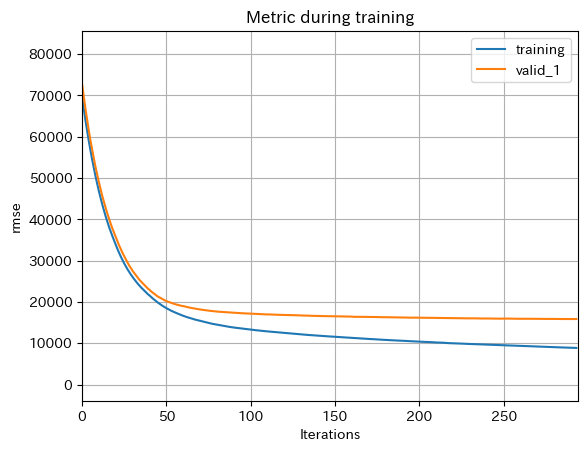

importance
面積               4.526487e+14
L                4.153275e+14
平均地価             2.061405e+14
最寄り駅             8.747681e+13
築年数              6.513269e+13
所在地              4.057115e+13
全体の階数            3.357280e+13
契約期間             1.558604e+13
所在階              9.781127e+12
所要時間             6.342744e+12
温水洗浄便座           4.446763e+12
定期借家             2.536918e+12
100m^2以上         1.717116e+12
バス・トイレ別          1.674609e+12
部屋数              1.445631e+12
75m^2以上100m^2未満  8.200691e+11
D                5.230109e+11
50m^2以上75m^2未満   1.820138e+11
S                5.777203e+10
K                5.688000e+10

In [39]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.7630799986965487e-05,
        'max_bin': 392,
        'num_leaves': 119,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

### 今のところ1番スコアが良いのは、「温水洗浄便座」を抜いた時の15622

そこに「方角」を加えてみる

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
directions = pd.read_csv('../data/handmade_data/directions.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
washlets = pd.read_csv('../data/handmade_data/washlets.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_directions = pd.read_csv('../data/test_data/test_directions.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], directions, buildings, sepa_bath_toilets, over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']], test_directions, test_buildings, test_sepa_bath_toilets, test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K', 'S', '方角','建物構造','バス・トイレ別','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

In [59]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=1000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [60]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-16 09:18:18,701] A new study created in memory with name: no-name-16c7a80a-3712-4ed5-82f3-9cbb9047bd59
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 've

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48787.8	valid_1's rmse: 50198.5
[20]	training's rmse: 34378.2	valid_1's rmse: 37800.6
[30]	training's rmse: 26079.1	valid_1's rmse: 31156.5
[40]	training's rmse: 20889.3	valid_1's rmse: 27401.6
[50]	training's rmse: 17647.1	valid_1's rmse: 25160.4
[60]	training's rmse: 15600.6	valid_1's rmse: 23762.9
[70]	training's rmse: 14218.6	valid_1's rmse: 22930.1
[80]	training's rmse: 13207.8	valid_1's rmse: 22284
[90]	training's rmse: 12432.6	valid_1's rmse: 21806.3
[100]	training's rmse: 11805.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48981.3	valid_1's rmse: 49548.1
[20]	training's rmse: 34934.9	valid_1's rmse: 36002.9
[30]	training's rmse: 27002.4	valid_1's rmse: 28636
[40]	training's rmse: 22341.5	valid_1's rmse: 24357.3
[50]	training's rmse: 19282.6	valid_1's rmse: 21497.5
[60]	training's rmse: 17532.3	valid_1's rmse: 20025
[70]	training's rmse: 16360.4	valid_1's rmse: 19213.1
[80]	training's rmse: 15447.8	valid_1's rmse: 18641.9
[90]	training's rmse: 14738.5	valid_1's rmse: 18425.2
[100]	training's rmse: 14163	valid_1's rmse: 18204.1
[110]	training's rmse: 13719	valid_1's rmse: 18056.1
[120]	training's rmse: 13326.1	valid_1's rmse: 18019
[130]	training's rmse: 12970.5	valid_1's rmse: 17987.8
[140]	training's rmse: 12628.2	valid_1's rmse: 17946.1
[150]	training's rmse: 12318	valid_1's rmse: 17946.6
Early stopping, best iteration is:
[144]	training's rmse: 12490.5	valid_1's rmse: 17924.8
[LightGBM] [Warning] Auto-choosing row-wise m

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35401.8	valid_1's rmse: 33880.2
[30]	training's rmse: 27151.4	valid_1's rmse: 25904.6
[40]	training's rmse: 22383.8	valid_1's rmse: 21588.1
[50]	training's rmse: 19369.7	valid_1's rmse: 19184
[60]	training's rmse: 17429.6	valid_1's rmse: 17959.9
[70]	training's rmse: 16295.5	valid_1's rmse: 17229.8
[80]	training's rmse: 15428.2	valid_1's rmse: 16758.5
[90]	training's rmse: 14736.7	valid_1's rmse: 16474.5
[100]	training's rmse: 14219	valid_1's rmse: 16271.9
[110]	training's rmse: 13749.7	valid_1's rmse: 16099.8
[120]	training's rmse: 13324.4	valid_1's rmse: 16002.8
[130]	training's rmse: 12978.3	valid_1's rmse: 15894.8
[140]	training's rmse: 12661.1	valid_1's rmse: 15819.3
[150]	training's rmse: 12324.1	valid_1's rmse: 15758.4
[160]	training's rmse: 12041.3	valid_1's rmse: 15714.4
[170]	training's rmse: 11804	valid_1's rmse: 15664.5
[180]	training's rmse: 11563.9	valid_1's rmse: 15622.5
[190]	training's rmse: 11289.7	valid_1's rmse: 15579
[200]	training's rmse: 110

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49249.6	valid_1's rmse: 48179
[20]	training's rmse: 35104.4	valid_1's rmse: 35184.5
[30]	training's rmse: 26700.8	valid_1's rmse: 28097.3
[40]	training's rmse: 21907.9	valid_1's rmse: 24347.4
[50]	training's rmse: 18791	valid_1's rmse: 22289.9
[60]	training's rmse: 16997.4	valid_1's rmse: 21184.2
[70]	training's rmse: 15838.2	valid_1's rmse: 20626
[80]	training's rmse: 15051.4	valid_1's rmse: 20161.4
[90]	training's rmse: 14384.3	valid_1's rmse: 19750.2
[100]	training's rmse: 13871.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48661.9	valid_1's rmse: 50981
[20]	training's rmse: 34915.5	valid_1's rmse: 37032.9
[30]	training's rmse: 26965	valid_1's rmse: 28763
[40]	training's rmse: 22243.1	valid_1's rmse: 23882.6
[50]	training's rmse: 19118.8	valid_1's rmse: 21130.5
[60]	training's rmse: 17213.7	valid_1's rmse: 19719.3
[70]	training's rmse: 16010.8	valid_1's rmse: 18885.8
[80]	training's rmse: 15076.3	valid_1's rmse: 18437.1
[90]	training's rmse: 14430.4	valid_1's rmse: 18151.5
[100]	training's rmse: 13870.5	valid_1's rmse: 17959.4
[110]	training's rmse: 13458.6	valid_1's rmse: 17763.9
[120]	training's rmse: 13091.4	valid_1's rmse: 17603.8
[130]	training's rmse: 12742.4	valid_1's rmse: 17473.4
[140]	training's rmse: 12398.6	valid_1's rmse: 17285
[150]	training's rmse: 12103.2	valid_1's rmse: 17151.9
[160]	training's rmse: 11852	valid_1's rmse: 17056.7
[170]	training's rmse: 11597.8	valid_1's rmse: 16961.8
[180]	training's rmse: 11401.4	valid_1's rmse: 16889.2
[190]	training's rmse: 11193.

[I 2022-09-16 09:18:33,437] Trial 0 finished with value: 16305.909208383415 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16305.909208383415.


Early stopping, best iteration is:
[306]	training's rmse: 9387.84	valid_1's rmse: 16305.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2529
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48712.5	valid_1's rmse: 50056.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34369.9	valid_1's rmse: 37775.5
[30]	training's rmse: 25909.4	valid_1's rmse: 30893.9
[40]	training's rmse: 20974.3	valid_1's rmse: 27203.4
[50]	training's rmse: 17717.9	valid_1's rmse: 24856.2
[60]	training's rmse: 15702	valid_1's rmse: 23446.6
[70]	training's rmse: 14299	valid_1's rmse: 22492.3
[80]	training's rmse: 13310.3	valid_1's rmse: 21814.8
[90]	training's rmse: 12551.3	valid_1's rmse: 21340.2
[100]	training's rmse: 12002.6	valid_1's rmse: 20968.1
[110]	training's rmse: 11483.3	valid_1's rmse: 20635.9
[120]	training's rmse: 11079.4	valid_1's rmse: 20362.9
[130]	training's rmse: 10739.3	valid_1's rmse: 20162.5
[140]	training's rmse: 10429.7	valid_1's rmse: 19981.3
[150]	training's rmse: 10114.3	valid_1's rmse: 19802.4
[160]	training's rmse: 9839.63	valid_1's rmse: 19635.1
[170]	training's rmse: 9604.2	valid_1's rmse: 19515
[180]	training's rmse: 9358.52	valid_1's rmse: 19377.3
[190]	training's rmse: 9145.57	valid_1's rmse: 19287.2
[200]	training's rmse: 89

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2525
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48956.9	valid_1's rmse: 49785
[20]	training's rmse: 34951.7	valid_1's rmse: 36410.8
[30]	training's rmse: 26645.1	valid_1's rmse: 29004.3
[40]	training's rmse: 21802.7	valid_1's rmse: 24735
[50]	training's rmse: 18906	valid_1's rmse: 22090.6
[60]	training's rmse: 17058.3	valid_1's rmse: 20670.8
[70]	training's rmse: 15788	valid_1's rmse: 19855.7
[80]	training's rmse: 14791.1	valid_1's rmse: 19252.5
[90]	training's rmse: 14010.6	valid_1's rmse: 18946.8
[100]	training's rmse: 13415.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48875.2	valid_1's rmse: 48676
[20]	training's rmse: 34972.5	valid_1's rmse: 34302.4
[30]	training's rmse: 26769.4	valid_1's rmse: 26556.8
[40]	training's rmse: 22094.6	valid_1's rmse: 22521.7
[50]	training's rmse: 19115.3	valid_1's rmse: 20284.6
[60]	training's rmse: 17270.4	valid_1's rmse: 19063.3
[70]	training's rmse: 16059	valid_1's rmse: 18381.5
[80]	training's rmse: 15151.2	valid_1's rmse: 17942.8
[90]	training's rmse: 14411.7	valid_1's rmse: 17684.2
[100]	training's rmse: 13847.7	valid_1's rmse: 17433.5
[110]	training's rmse: 13365.8	valid_1's rmse: 17299
[120]	training's rmse: 12943.4	valid_1's rmse: 17217.7
[130]	training's rmse: 12548.5	valid_1's rmse: 17161.6
[140]	training's rmse: 12192.5	valid_1's rmse: 17109.9
[150]	training's rmse: 11843.6	valid_1's rmse: 17095.4
[160]	training's rmse: 11555.7	valid_1's rmse: 17038.7
[170]	training's rmse: 11275.1	valid_1's rmse: 17007
[180]	training's rmse: 11017.7	valid_1's rmse: 16987.5
[190]	training's rmse: 1075

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49171.6	valid_1's rmse: 48048.5
[20]	training's rmse: 34775.5	valid_1's rmse: 35467.9
[30]	training's rmse: 26356.2	valid_1's rmse: 28401.4
[40]	training's rmse: 21537.4	valid_1's rmse: 24669.9
[50]	training's rmse: 18535.6	valid_1's rmse: 22764.7
[60]	training's rmse: 16707.3	valid_1's rmse: 21683.1
[70]	training's rmse: 15481.8	valid_1's rmse: 21105.8
[80]	training's rmse: 14635.6	valid_1's rmse: 20652.1
[90]	training's rmse: 13950.8	valid_1's rmse: 20305
[100]	training's rmse: 13417	valid_1's rmse: 20072.5
[110]	training's rmse: 12980.5	valid_1's rmse: 19862.9
[120]	training's rmse: 12605.1	valid_1's rmse: 19745
[130]	training's rmse: 12275.1	valid_1's rmse: 19625.1
[140]	training's rmse: 11931.9	valid_1's rmse: 19545.4
[150]	training's rmse: 11605.5	valid_1's rmse: 19431.7
[160]	training's rmse: 11310.6	valid_1's rmse: 19373.8
[170]	training's rmse: 11036.2	valid_1's rmse: 19272.6
[180]	training's rmse: 10782.1	valid_1's rmse: 19227.3
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2526
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48670.2	valid_1's rmse: 51003.3
[20]	training's rmse: 35009.8	valid_1's rmse: 36882.4
[30]	training's rmse: 26797.5	valid_1's rmse: 28304.7
[40]	training's rmse: 22151.9	valid_1's rmse: 23414.2
[50]	training's rmse: 18984.3	valid_1's rmse: 20743.3
[60]	training's rmse: 17048.7	valid_1's rmse: 19422.6
[70]	training's rmse: 15756.4	valid_1's rmse: 18701.5
[80]	training's rmse: 14839.6	valid_1's rmse: 18204.3
[90]	training's rmse: 14168	valid_1's rmse: 17903.7
[100]	training's rmse: 13637.7	valid_1's 

[I 2022-09-16 09:18:46,619] Trial 1 finished with value: 16820.140154939814 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16305.909208383415.


[210]	training's rmse: 10322.6	valid_1's rmse: 16848.4
Early stopping, best iteration is:
[206]	training's rmse: 10411.2	valid_1's rmse: 16820.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3012
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48380.3	valid_1's rmse: 49959.4
[20]	training's rmse: 33933.5	valid_1's rmse: 37689.8
[30]	training's rmse: 25532.7	valid_1's rmse: 30878.7
[40]	training's rmse: 20511.7	valid_1's rmse: 27038.3
[50]	training's rmse: 17196.8	valid_1's rmse: 24625.9
[60]	training's rmse: 15223.2	valid_1's rmse: 23090.8
[70]	training's rmse: 13799.3	valid_1's rmse: 22013.4
[80]	training's rmse: 12813	valid_1's rmse: 21308.2
[90]	training's rmse: 12039.4	valid_1's rmse: 20833.4
[100]	training's rmse: 11477.3	valid_1's rmse: 20505.9
[110]	training's rmse: 10972.1	valid_1's rmse: 20202.3
[120]	training's rmse: 10559	valid_1's rmse: 19985.5
[130]	training's rmse: 10221.9	valid_1's rmse: 19793.4
[140]	training's rmse: 9914.07	valid_1's rmse: 19648.5
[150]	training's rmse: 9607.2	valid_1's rmse: 19495.5
[160]	training's rmse: 9323.69	valid_1's rmse: 19431.7
[170]	training's rmse: 9066.76	valid_1's rmse: 19306.1
[180]	training's rmse: 8825.55	valid_1's rmse: 19169.2
[190]	training's rmse: 8

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3015
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.6	valid_1's rmse: 49606
[20]	training's rmse: 34602.1	valid_1's rmse: 36003.9
[30]	training's rmse: 26588.3	valid_1's rmse: 28731
[40]	training's rmse: 22001.6	valid_1's rmse: 24387.2
[50]	training's rmse: 19072.9	valid_1's rmse: 21420.4
[60]	training's rmse: 17356.1	valid_1's rmse: 19914.5
[70]	training's rmse: 16018.2	valid_1's rmse: 18814.7
[80]	training's rmse: 15064.8	valid_1's rmse: 18229
[90]	training's rmse: 14240.5	valid_1's rmse: 17901.9
[100]	training's rmse: 13599.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34796.1	valid_1's rmse: 33665.2
[30]	training's rmse: 26533.9	valid_1's rmse: 26007.5
[40]	training's rmse: 21794.3	valid_1's rmse: 21846.9
[50]	training's rmse: 18688.5	valid_1's rmse: 19569.6
[60]	training's rmse: 16871.7	valid_1's rmse: 18417.5
[70]	training's rmse: 15681.7	valid_1's rmse: 17698.9
[80]	training's rmse: 14794.5	valid_1's rmse: 17318.2
[90]	training's rmse: 14134.8	valid_1's rmse: 17058.8
[100]	training's rmse: 13579.2	valid_1's rmse: 16841.4
[110]	training's rmse: 13088.7	valid_1's rmse: 16728.5
[120]	training's rmse: 12691.7	valid_1's rmse: 16595.5
[130]	training's rmse: 12271.4	valid_1's rmse: 16502.6
[140]	training's rmse: 11925.1	valid_1's rmse: 16452.6
[150]	training's rmse: 11606.8	valid_1's rmse: 16409
[160]	training's rmse: 11348.1	valid_1's rmse: 16390.1
[170]	training's rmse: 11104.4	valid_1's rmse: 16351.5
[180]	training's rmse: 10884.8	valid_1's rmse: 16324.1
[190]	training's rmse: 10663.9	valid_1's rmse: 16320.9
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48816.2	valid_1's rmse: 47912.2
[20]	training's rmse: 34411.5	valid_1's rmse: 35425.2
[30]	training's rmse: 25991.2	valid_1's rmse: 28445
[40]	training's rmse: 21205.4	valid_1's rmse: 24790.1
[50]	training's rmse: 18049.6	valid_1's rmse: 23019.5
[60]	training's rmse: 16254.2	valid_1's rmse: 22017.7
[70]	training's rmse: 15133.6	valid_1's rmse: 21375.4
[80]	training's rmse: 14355	valid_1's rmse: 20887.7
[90]	training's rmse: 13751.6	valid_1's rmse: 20533
[100]	training's rmse: 13257.2	valid_1's rmse: 20282.5
[110]	training's rmse: 12854.9	valid_1's rmse: 20049.8
[120]	training's rmse: 12524.6	valid_1's rmse: 19913.2
[130]	training's rmse: 12112.9	valid_1's rmse: 19754.5
[140]	training's rmse: 11739.5	valid_1's rmse: 19714
[150]	training's rmse: 11453.2	valid_1's rmse: 19599.7
[160]	training's rmse: 11196.6	valid_1's rmse: 19516
[170]	training's rmse: 10932.9	valid_1's rmse: 19439.5
[180]	training's rmse: 10680.9	valid_1's rmse: 19357.2
[190]	training's rmse: 10484.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48301.4	valid_1's rmse: 50746.6
[20]	training's rmse: 34405.7	valid_1's rmse: 36752.6
[30]	training's rmse: 26355.8	valid_1's rmse: 28572.2
[40]	training's rmse: 21657	valid_1's rmse: 23678.8
[50]	training's rmse: 18510.9	valid_1's rmse: 20732
[60]	training's rmse: 16698.4	valid_1's rmse: 19373.4
[70]	training's rmse: 15528.7	valid_1's rmse: 18586.3
[80]	training's rmse: 14631	valid_1's rmse: 18150.1
[90]	training's rmse: 13982.6	valid_1's rmse: 17903.8
[100]	training's rmse: 13476.7	valid_1's rmse: 17751
[110]	training's rmse: 13046.6	valid_1's rmse: 17648.2
[120]	training's rmse: 12659.1	valid_1's rmse: 17570.3
[130]	training's rmse: 12304.8	valid_1's rmse: 17534.3
[140]	training's rmse: 12027.8	valid_1's rmse: 17499.9
[150]	training's rmse: 11743.4	valid_1's rmse: 17463
[160]	training's rmse: 11491.4	valid_1's rmse: 17420
[170]	training's rmse: 11269.5	valid_1's rmse: 17380.3
[180]	training's rmse: 11045.6	valid_1's rmse: 17351.7
[190]	training's rmse: 10855.3	

[I 2022-09-16 09:19:01,130] Trial 2 finished with value: 17291.928462495187 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 16305.909208383415.


[230]	training's rmse: 10184.4	valid_1's rmse: 17309.5
Early stopping, best iteration is:
[226]	training's rmse: 10245.3	valid_1's rmse: 17291.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2923
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48780.2	valid_1's rmse: 50295.6
[20]	training's rmse: 34403.1	valid_1's rmse: 37926.5
[30]	training's rmse: 26083.5	valid_1's rmse: 31180.7
[40]	training's rmse: 20966.5	valid_1's rmse: 27318
[50]	training's rmse: 17647.5	valid_1's rmse: 24880
[60]	training's rmse: 15673.6	valid_1's rmse: 23380.5
[70]	training's rmse: 14285.1	valid_1's rmse: 22336.2
[80]	training's rmse: 13303.5	valid_1's rmse: 21670
[90]	training's rmse: 12539.7	valid_1's rmse: 21183.4
[100]	training's rmse: 12017.1	valid_1's rmse: 20834.9
[110]	training's rmse: 11527.3	valid_1's rmse: 20502.9
[120]	training's rmse: 11139.8	valid_1's rmse: 20234.4
[130]	training's rmse: 10781.6	valid_1's rmse: 20009.7
[140]	training's rmse: 10413.2	valid_1's rmse: 19822.7
[150]	training's rmse: 10093.3	valid_1's rmse: 19648
[160]	training's rmse: 9815.24	valid_1's rmse: 19509.5
[170]	training's rmse: 9571.69	valid_1's rmse: 19355.7
[180]	training's rmse: 9340.43	valid_1's rmse: 19260.4
[190]	training's rmse: 9100

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48949.8	valid_1's rmse: 49605.9
[20]	training's rmse: 34892.3	valid_1's rmse: 36666.9
[30]	training's rmse: 26957.2	valid_1's rmse: 29425.6
[40]	training's rmse: 22211.3	valid_1's rmse: 24853.5
[50]	training's rmse: 19263.1	valid_1's rmse: 21904.2
[60]	training's rmse: 17576.3	valid_1's rmse: 20366.4
[70]	training's rmse: 16319.6	valid_1's rmse: 19241.2
[80]	training's rmse: 15455	valid_1's rmse: 18646.5
[90]	training's rmse: 14738.9	valid_1's rmse: 18276.4
[100]	training's rmse: 14168.7	valid_1's rmse: 18152.6
[110]	training's rmse: 13712.9	valid_1's rmse: 18018
[120]	training's rmse: 13303	valid_1's rmse: 17926.8
[130]	training's rmse: 12940.2	valid_1's rmse: 17886.5
[140]	training's rmse: 12599.3	valid_1's rmse: 17875.8
[150]	training's rmse: 12308.1	valid_1's rmse: 17868.1
Early stopping, best iteration is:
[145]	training's rmse: 12452.9	valid_1's rmse: 17859.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2919
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49058.3	valid_1's rmse: 48607.9
[20]	training's rmse: 35251.8	valid_1's rmse: 34035.7
[30]	training's rmse: 27038.1	valid_1's rmse: 26044.5
[40]	training's rmse: 22340.3	valid_1's rmse: 21823.8
[50]	training's rmse: 19390.6	valid_1's rmse: 19453.2
[60]	training's rmse: 17525.5	valid_1's rmse: 18271.3
[70]	training's rmse: 16254.9	valid_1's rmse: 17510.8
[80]	training's rmse: 15332	valid_1's rmse: 17143.2
[90]	training's rmse: 14684.1	valid_1's rmse: 16970.7
[100]	training's rmse: 14128.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49231.6	valid_1's rmse: 48196
[20]	training's rmse: 35056.3	valid_1's rmse: 35291.9
[30]	training's rmse: 26617.6	valid_1's rmse: 28151.4
[40]	training's rmse: 21829.8	valid_1's rmse: 24351.5
[50]	training's rmse: 18793.5	valid_1's rmse: 22401
[60]	training's rmse: 16966	valid_1's rmse: 21316.6
[70]	training's rmse: 15779.7	valid_1's rmse: 20645.5
[80]	training's rmse: 14920	valid_1's rmse: 20073.4
[90]	training's rmse: 14338.6	valid_1's rmse: 19730.2
[100]	training's rmse: 13700.3	valid_1's rmse: 19290.6
[110]	training's rmse: 13227.9	valid_1's rmse: 19020.8
[120]	training's rmse: 12866	valid_1's rmse: 18816.1
[130]	training's rmse: 12461.8	valid_1's rmse: 18605.6
[140]	training's rmse: 12056.9	valid_1's rmse: 18458.2
[150]	training's rmse: 11711	valid_1's rmse: 18297.6
[160]	training's rmse: 11424.4	valid_1's rmse: 18263.2
[170]	training's rmse: 11126.5	valid_1's rmse: 18172.7
[180]	training's rmse: 10886.8	valid_1's rmse: 18105.3
[190]	training's rmse: 10663.4	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2919
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.9	valid_1's rmse: 51072
[20]	training's rmse: 34972.4	valid_1's rmse: 36980.6
[30]	training's rmse: 26977.1	valid_1's rmse: 28854.2
[40]	training's rmse: 22347.8	valid_1's rmse: 24097.5
[50]	training's rmse: 19302.7	valid_1's rmse: 21503.3
[60]	training's rmse: 17547.7	valid_1's rmse: 20180.5
[70]	training's rmse: 16181.1	valid_1's rmse: 19371.8
[80]	training's rmse: 15268.2	valid_1's rmse: 18999.2
[90]	training's rmse: 14565.4	valid_1's rmse: 18783
[100]	training's rmse: 14012.8	valid_1's rm

[I 2022-09-16 09:19:10,589] Trial 3 finished with value: 17990.391625734752 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 16305.909208383415.


[290]	training's rmse: 9742.53	valid_1's rmse: 17993.3
[300]	training's rmse: 9612.07	valid_1's rmse: 18009
Early stopping, best iteration is:
[292]	training's rmse: 9724.43	valid_1's rmse: 17990.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3045
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49297	valid_1's rmse: 50776
[20]	training's rmse: 35079.6	valid_1's rmse: 38532.7
[30]	training's rmse: 26825.9	valid_1's rmse: 31711.6
[40]	training's rmse: 21804.1	valid_1's rmse: 27755.3
[50]	training's rmse: 18594.3	valid_1's rmse: 25305.3
[60]	training's rmse: 16595.4	valid_1's rmse: 23759.3
[70]	training's rmse: 15224.4	valid_1's rmse: 22793.4
[80]	training's rmse: 14249.7	valid_1's rmse: 22123.7
[90]	training's rmse: 13526.7	valid_1's rmse: 21665.9
[100]	training's rmse: 12898.9	valid_1's rmse: 21226.3
[110]	training's rmse: 12426	valid_1's rmse: 20900.4
[120]	training's rmse: 12032.8	valid_1's rmse: 20665.5
[130]	training's rmse: 11681.6	valid_1's rmse: 20427.7
[140]	training's rmse: 11314.3	valid_1's rmse: 20142.3
[150]	training's rmse: 10981.4	valid_1's rmse: 19957.7
[160]	training's rmse: 10714.2	valid_1's rmse: 19733.5
[170]	training's rmse: 10448.6	valid_1's rmse: 19534.6
[180]	training's rmse: 10160.5	valid_1's rmse: 19288.5
[190]	training's rmse: 99

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49469.7	valid_1's rmse: 50082.3
[20]	training's rmse: 35568.4	valid_1's rmse: 36713.2
[30]	training's rmse: 27612.4	valid_1's rmse: 29352.4
[40]	training's rmse: 22828.5	valid_1's rmse: 24786.9
[50]	training's rmse: 19938	valid_1's rmse: 21878.2
[60]	training's rmse: 18135.4	valid_1's rmse: 20379.2
[70]	training's rmse: 16939.1	valid_1's rmse: 19315.4
[80]	training's rmse: 15945.4	valid_1's rmse: 18607.8
[90]	training's rmse: 15177.7	valid_1's rmse: 18166.4
[100]	training's rmse: 14639.5	valid_1's rmse: 17917.8
[110]	training's rmse: 14159.8	valid_1's rmse: 17799.9
[120]	training's rmse: 13771.7	valid_1's rmse: 17684.9
[130]	training's rmse: 13412	valid_1's rmse: 17640
[140]	training's rmse: 13073.6	valid_1's rmse: 17644.5
[150]	training's rmse: 12775.2	valid_1's rmse: 17592.2
[160]	training's rmse: 12511.8	valid_1's rmse: 17563.2
[170]	training's rmse: 12261.7	valid_1's rmse: 17533.3
[180]	training's rmse: 11991.3	valid_1's rmse: 17508.3
Early stopping, best iter

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49539	valid_1's rmse: 49109.8
[20]	training's rmse: 35850.9	valid_1's rmse: 34828.1
[30]	training's rmse: 27765.6	valid_1's rmse: 26907.7
[40]	training's rmse: 22925.4	valid_1's rmse: 22531.3
[50]	training's rmse: 19937.2	valid_1's rmse: 20157.9
[60]	training's rmse: 18082.9	valid_1's rmse: 18935.3
[70]	training's rmse: 16862.9	valid_1's rmse: 18169.1
[80]	training's rmse: 15969.5	valid_1's rmse: 17708.5
[90]	training's rmse: 15245.6	valid_1's rmse: 17351.6
[100]	training's rmse: 14727.3	valid_1's rmse: 17130.1
[110]	training's rmse: 14264.3	valid_1's rmse: 16984.2
[120]	training's rmse: 13865.1	valid_1's rmse: 16860.9
[130]	training's rmse: 13513.5	valid_1's rmse: 16785.3
[140]	training's rmse: 13158.5	valid_1's rmse: 16722.5
[150]	training's rmse: 12823.8	valid_1's rmse: 16633.5
[160]	training's rmse: 12548.7	valid_1's rmse: 16570.6
[170]	training's rmse: 12327.6	valid_1's rmse: 16540.2
[180]	training's rmse: 12100.4	valid_1's rmse: 16503
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35454.1	valid_1's rmse: 36180.7
[30]	training's rmse: 27156.3	valid_1's rmse: 29280.7
[40]	training's rmse: 22222	valid_1's rmse: 25601
[50]	training's rmse: 19276.8	valid_1's rmse: 23585.3
[60]	training's rmse: 17522.4	valid_1's rmse: 22380.1
[70]	training's rmse: 16352.3	valid_1's rmse: 21721.2
[80]	training's rmse: 15561.2	valid_1's rmse: 21156.6
[90]	training's rmse: 14943.9	valid_1's rmse: 20711
[100]	training's rmse: 14431.4	valid_1's rmse: 20335.6
[110]	training's rmse: 14012.8	valid_1's rmse: 20096.6
[120]	training's rmse: 13602.6	valid_1's rmse: 19854.2
[130]	training's rmse: 13253.7	valid_1's rmse: 19700.6
[140]	training's rmse: 12962.2	valid_1's rmse: 19557
[150]	training's rmse: 12701.3	valid_1's rmse: 19455.2
[160]	training's rmse: 12434	valid_1's rmse: 19339
[170]	training's rmse: 12203.3	valid_1's rmse: 19254.9
[180]	training's rmse: 11993.6	valid_1's rmse: 19182.5
[190]	training's rmse: 11781.2	valid_1's rmse: 19094.5
[200]	training's rmse: 11606.4

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35591	valid_1's rmse: 37700.2
[30]	training's rmse: 27732.2	valid_1's rmse: 29424.7
[40]	training's rmse: 22928.1	valid_1's rmse: 24470
[50]	training's rmse: 19860.5	valid_1's rmse: 21740.8
[60]	training's rmse: 18023.9	valid_1's rmse: 20180.5
[70]	training's rmse: 16740.6	valid_1's rmse: 19324.4
[80]	training's rmse: 15842.4	valid_1's rmse: 18849
[90]	training's rmse: 15186.5	valid_1's rmse: 18537
[100]	training's rmse: 14658.4	valid_1's rmse: 18331.2
[110]	training's rmse: 14227.7	valid_1's rmse: 18187
[120]	training's rmse: 13865.7	valid_1's rmse: 18100.3
[130]	training's rmse: 13489.5	valid_1's rmse: 18018.8
[140]	training's rmse: 13180.8	valid_1's rmse: 17960.6
[150]	training's rmse: 12890.5	valid_1's rmse: 17918.2
[160]	training's rmse: 12605.4	valid_1's rmse: 17869.9
[170]	training's rmse: 12381.4	valid_1's rmse: 17855.2
[180]	training's rmse: 12169.9	valid_1's rmse: 17834.6
[190]	training's rmse: 11971.3	valid_1's rmse: 17820.8
[200]	training's rmse: 11761

[I 2022-09-16 09:19:18,402] Trial 4 finished with value: 17744.36085977226 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 16305.909208383415.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2108
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.8	valid_1's rmse: 50307.2
[20]	training's rmse: 34465.8	valid_1's rmse: 38194.2
[30]	training's rmse: 25981.1	valid_1's rmse: 31472
[40]	training's rmse: 21007.9	valid_1's rmse: 27735.3
[50]	training's rmse: 17604.9	valid_1's rmse: 25365.9
[60]	training's rmse: 15585.6	valid_1's rmse: 23976.6
[70]	training's rmse: 14154.1	valid_1's rmse: 23002
[80]	training's rmse: 13115.6	valid_1's rmse: 22305.2
[90]	training's rmse: 12343.6	valid_1's rmse: 21787
[100]	training's rmse: 11712.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48806.9	valid_1's rmse: 49274.2
[20]	training's rmse: 34834.7	valid_1's rmse: 35851.2
[30]	training's rmse: 26724.4	valid_1's rmse: 28242.7
[40]	training's rmse: 21978.4	valid_1's rmse: 24196.6
[50]	training's rmse: 18838.9	valid_1's rmse: 21657.5
[60]	training's rmse: 16923.1	valid_1's rmse: 20072.4
[70]	training's rmse: 15590.9	valid_1's rmse: 19111.3
[80]	training's rmse: 14550.1	valid_1's rmse: 18596.7
[90]	training's rmse: 13772.9	valid_1's rmse: 18338.6
[100]	training's rmse: 13129.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48922.4	valid_1's rmse: 48843.2
[20]	training's rmse: 35069	valid_1's rmse: 34883.6
[30]	training's rmse: 26795.3	valid_1's rmse: 27192.1
[40]	training's rmse: 22115.8	valid_1's rmse: 23071.9
[50]	training's rmse: 19043.2	valid_1's rmse: 20727.5
[60]	training's rmse: 17138.7	valid_1's rmse: 19561
[70]	training's rmse: 15810.3	valid_1's rmse: 18891.1
[80]	training's rmse: 14785.2	valid_1's rmse: 18529.4
[90]	training's rmse: 13932.4	valid_1's rmse: 18174.4
[100]	training's rmse: 13245.7	valid_1's rmse: 18013.3
[110]	training's rmse: 12684.1	valid_1's rmse: 17906.9
[120]	training's rmse: 12174.2	valid_1's rmse: 17854.1
[130]	training's rmse: 11698.3	valid_1's rmse: 17794.9
[140]	training's rmse: 11281.9	valid_1's rmse: 17729.8
[150]	training's rmse: 10903.6	valid_1's rmse: 17710.1
[160]	training's rmse: 10575.2	valid_1's rmse: 17684
[170]	training's rmse: 10277.2	valid_1's rmse: 17685.1
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2107
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49112.3	valid_1's rmse: 47854.9
[20]	training's rmse: 34972.6	valid_1's rmse: 35207.7
[30]	training's rmse: 26470.1	valid_1's rmse: 28209.2
[40]	training's rmse: 21663.7	valid_1's rmse: 24454
[50]	training's rmse: 18497.3	valid_1's rmse: 22413.8
[60]	training's rmse: 16486.7	valid_1's rmse: 21397.3
[70]	training's rmse: 15137	valid_1's rmse: 20886.1
[80]	training's rmse: 14128	valid_1's rmse: 20496.1
[90]	training's rmse: 13398.7	valid_1's rmse: 20239.2
[100]	training's rmse: 12780.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48467.3	valid_1's rmse: 50942.1
[20]	training's rmse: 34812.8	valid_1's rmse: 36823.2
[30]	training's rmse: 26682.6	valid_1's rmse: 28424.8
[40]	training's rmse: 22063.1	valid_1's rmse: 23733.7
[50]	training's rmse: 18835.9	valid_1's rmse: 20853.4
[60]	training's rmse: 16886.5	valid_1's rmse: 19463.2
[70]	training's rmse: 15522.8	valid_1's rmse: 18686.4
[80]	training's rmse: 14477.9	valid_1's rmse: 18207.8
[90]	training's rmse: 13745.5	valid_1's rmse: 17918.7
[100]	training's rmse: 13156.3	valid_1'

[I 2022-09-16 09:19:30,986] Trial 5 finished with value: 16090.108025215895 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 5 with value: 16090.108025215895.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidata

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2995
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48399.6	valid_1's rmse: 50024.5
[20]	training's rmse: 33920.2	valid_1's rmse: 37649.6
[30]	training's rmse: 25557.7	valid_1's rmse: 30890.8
[40]	training's rmse: 20531.2	valid_1's rmse: 27056.1
[50]	training's rmse: 17227.3	valid_1's rmse: 24587
[60]	training's rmse: 15212.4	valid_1's rmse: 23058.5
[70]	training's rmse: 13759.7	valid_1's rmse: 21959.7
[80]	training's rmse: 12743	valid_1's rmse: 21274.6
[90]	training's rmse: 11929.9	valid_1's rmse: 20774.6
[100]	training's rmse: 11322.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2997
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48769.5	valid_1's rmse: 49605.4
[20]	training's rmse: 34579.1	valid_1's rmse: 36117.2
[30]	training's rmse: 26553	valid_1's rmse: 28848.3
[40]	training's rmse: 21947.1	valid_1's rmse: 24542.8
[50]	training's rmse: 19014.4	valid_1's rmse: 21603.4
[60]	training's rmse: 17323.7	valid_1's rmse: 20207
[70]	training's rmse: 16036.2	valid_1's rmse: 19151.7
[80]	training's rmse: 15056.7	valid_1's rmse: 18449.7
[90]	training's rmse: 14285	valid_1's rmse: 18069.4
[100]	training's rmse: 13698.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2995
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.2	valid_1's rmse: 48278.6
[20]	training's rmse: 34783.2	valid_1's rmse: 33677.6
[30]	training's rmse: 26550	valid_1's rmse: 26018.9
[40]	training's rmse: 21743.6	valid_1's rmse: 21838
[50]	training's rmse: 18621.2	valid_1's rmse: 19527.6
[60]	training's rmse: 16816.4	valid_1's rmse: 18347
[70]	training's rmse: 15663.7	valid_1's rmse: 17680.1
[80]	training's rmse: 14760	valid_1's rmse: 17328.1
[90]	training's rmse: 14083.7	valid_1's rmse: 17095.5
[100]	training's rmse: 13520.2	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34326.7	valid_1's rmse: 35215.3
[30]	training's rmse: 25903.4	valid_1's rmse: 28162.9
[40]	training's rmse: 21110.6	valid_1's rmse: 24539.4
[50]	training's rmse: 17983.1	valid_1's rmse: 22775.9
[60]	training's rmse: 16174.1	valid_1's rmse: 21871.2
[70]	training's rmse: 15079.8	valid_1's rmse: 21273.7
[80]	training's rmse: 14326.4	valid_1's rmse: 20842.8
[90]	training's rmse: 13685.3	valid_1's rmse: 20472.2
[100]	training's rmse: 13181.1	valid_1's rmse: 20216.3
[110]	training's rmse: 12794.1	valid_1's rmse: 20060.2
[120]	training's rmse: 12445.7	valid_1's rmse: 19921
[130]	training's rmse: 12030.4	valid_1's rmse: 19748.8
[140]	training's rmse: 11717.7	valid_1's rmse: 19652.2
[150]	training's rmse: 11456.5	valid_1's rmse: 19554.7
[160]	training's rmse: 11201.7	valid_1's rmse: 19500.4
[170]	training's rmse: 10968.9	valid_1's rmse: 19453.9
[180]	training's rmse: 10750.4	valid_1's rmse: 19404.4
[190]	training's rmse: 10530.1	valid_1's rmse: 19362.2
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2997
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48296.3	valid_1's rmse: 50777.6
[20]	training's rmse: 34412.3	valid_1's rmse: 36780.7
[30]	training's rmse: 26276.8	valid_1's rmse: 28463.9
[40]	training's rmse: 21623.9	valid_1's rmse: 23766.5
[50]	training's rmse: 18481.4	valid_1's rmse: 20851.8
[60]	training's rmse: 16590.1	valid_1's rmse: 19410.8
[70]	training's rmse: 15458.9	valid_1's rmse: 18685.9
[80]	training's rmse: 14507.1	valid_1's rmse: 18226
[90]	training's rmse: 13867.6	valid_1's rmse: 17993.6
[100]	training's rmse: 13360.2	valid_1's 

[I 2022-09-16 09:19:43,679] Trial 6 finished with value: 17309.0333070112 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 5 with value: 16090.108025215895.


[250]	training's rmse: 9844.07	valid_1's rmse: 17317.7
Early stopping, best iteration is:
[246]	training's rmse: 9903.98	valid_1's rmse: 17309
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2579
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48728.2	valid_1's rmse: 50392.4
[20]	training's rmse: 34354.5	valid_1's rmse: 38099.1
[30]	training's rmse: 25906.8	valid_1's rmse: 31231.2
[40]	training's rmse: 20884.1	valid_1's rmse: 27306.6
[50]	training's rmse: 17592	valid_1's rmse: 24909.7
[60]	training's rmse: 15591.5	valid_1's rmse: 23438.6
[70]	training's rmse: 14194.1	valid_1's rmse: 22410.7
[80]	training's rmse: 13198.1	valid_1's rmse: 21652
[90]	training's rmse: 12474.6	valid_1's rmse: 21110.3
[100]	training's rmse: 11901.1	valid_1's rmse: 20676.4
[110]	training's rmse: 11383.4	valid_1's rmse: 20356.5
[120]	training's rmse: 10946.3	valid_1's rmse: 20058.8
[130]	training's rmse: 10594.2	valid_1's rmse: 19800.3
[140]	training's rmse: 10287.3	valid_1's rmse: 19605.3
[150]	training's rmse: 9982.22	valid_1's rmse: 19392.6
[160]	training's rmse: 9709.44	valid_1's rmse: 19248.9
[170]	training's rmse: 9453.72	valid_1's rmse: 19103.7
[180]	training's rmse: 9221.35	valid_1's rmse: 18970.5
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2577
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48854.7	valid_1's rmse: 49594.2
[20]	training's rmse: 34739.6	valid_1's rmse: 36154.2
[30]	training's rmse: 26543.1	valid_1's rmse: 28661.6
[40]	training's rmse: 21708.9	valid_1's rmse: 24424.5
[50]	training's rmse: 18765.2	valid_1's rmse: 21794
[60]	training's rmse: 16934	valid_1's rmse: 20320.7
[70]	training's rmse: 15650.7	valid_1's rmse: 19470.7
[80]	training's rmse: 14663.1	valid_1's rmse: 18932.6
[90]	training's rmse: 13921.9	valid_1's rmse: 18636.3
[100]	training's rmse: 13332.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34832.3	valid_1's rmse: 34254
[30]	training's rmse: 26647.7	valid_1's rmse: 26599.7
[40]	training's rmse: 22077.1	valid_1's rmse: 22649.4
[50]	training's rmse: 19136.8	valid_1's rmse: 20383.8
[60]	training's rmse: 17280.8	valid_1's rmse: 19111.8
[70]	training's rmse: 16077.1	valid_1's rmse: 18488.2
[80]	training's rmse: 15137.3	valid_1's rmse: 18039.6
[90]	training's rmse: 14409	valid_1's rmse: 17731
[100]	training's rmse: 13836.4	valid_1's rmse: 17545.9
[110]	training's rmse: 13358.5	valid_1's rmse: 17446.9
[120]	training's rmse: 12924.9	valid_1's rmse: 17410.1
[130]	training's rmse: 12495.8	valid_1's rmse: 17382.3
[140]	training's rmse: 12135.5	valid_1's rmse: 17327.9
[150]	training's rmse: 11798	valid_1's rmse: 17284.2
[160]	training's rmse: 11464.8	valid_1's rmse: 17234.7
[170]	training's rmse: 11184.7	valid_1's rmse: 17219.3
[180]	training's rmse: 10918.3	valid_1's rmse: 17183.8
[190]	training's rmse: 10670.1	valid_1's rmse: 17185.2
[200]	training's rmse: 104

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2579
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49175	valid_1's rmse: 47906.7
[20]	training's rmse: 34759.7	valid_1's rmse: 35329.1
[30]	training's rmse: 26361.3	valid_1's rmse: 28514.4
[40]	training's rmse: 21509.7	valid_1's rmse: 24990
[50]	training's rmse: 18453.5	valid_1's rmse: 23038
[60]	training's rmse: 16630.4	valid_1's rmse: 21936.7
[70]	training's rmse: 15391.2	valid_1's rmse: 21431.3
[80]	training's rmse: 14476.1	valid_1's rmse: 21014.1
[90]	training's rmse: 13828.2	valid_1's rmse: 20810.2
[100]	training's rmse: 13260.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48610.7	valid_1's rmse: 50941.9
[20]	training's rmse: 34927.8	valid_1's rmse: 36872.3
[30]	training's rmse: 26767.7	valid_1's rmse: 28542
[40]	training's rmse: 22204.6	valid_1's rmse: 23880.6
[50]	training's rmse: 19008.2	valid_1's rmse: 21238.6
[60]	training's rmse: 17078.5	valid_1's rmse: 19885
[70]	training's rmse: 15741	valid_1's rmse: 19085.9
[80]	training's rmse: 14791.5	valid_1's rmse: 18580.3
[90]	training's rmse: 14121.5	valid_1's rmse: 18193.7
[100]	training's rmse: 13566.2	valid_1's rmse: 17954.6
[110]	training's rmse: 13115.3	valid_1's rmse: 17823.6
[120]	training's rmse: 12734.7	valid_1's rmse: 17671.7
[130]	training's rmse: 12371.6	valid_1's rmse: 17584.2
[140]	training's rmse: 12055.3	valid_1's rmse: 17500.7
[150]	training's rmse: 11741.5	valid_1's rmse: 17448.9
[160]	training's rmse: 11464.4	valid_1's rmse: 17381.5
[170]	training's rmse: 11221	valid_1's rmse: 17299.6
[180]	training's rmse

[I 2022-09-16 09:19:57,389] Trial 7 finished with value: 16775.81873305031 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 5 with value: 16090.108025215895.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2776
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49223.5	valid_1's rmse: 50630.7
[20]	training's rmse: 35146.1	valid_1's rmse: 38372.2
[30]	training's rmse: 26983.3	valid_1's rmse: 31708.9
[40]	training's rmse: 21746.2	valid_1's rmse: 27683.4
[50]	training's rmse: 18489.4	valid_1's rmse: 25300.6
[60]	training's rmse: 16518.6	valid_1's rmse: 23869.3
[70]	training's rmse: 15133	valid_1's rmse: 22915
[80]	training's rmse: 14227.5	valid_1's rmse: 22344.2
[90]	training's rmse: 13535.6	valid_1's rmse: 21926
[100]	training's rmse: 12986.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2777
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49361	valid_1's rmse: 50033.5
[20]	training's rmse: 35571.4	valid_1's rmse: 36686
[30]	training's rmse: 27581.7	valid_1's rmse: 29175.6
[40]	training's rmse: 22775.4	valid_1's rmse: 24675.1
[50]	training's rmse: 19854.6	valid_1's rmse: 21956.4
[60]	training's rmse: 18098.9	valid_1's rmse: 20569
[70]	training's rmse: 16920.5	valid_1's rmse: 19657
[80]	training's rmse: 15996.9	valid_1's rmse: 19144.1
[90]	training's rmse: 15337.8	valid_1's rmse: 18927.4
[100]	training's rmse: 14794.1	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35882.6	valid_1's rmse: 34423.3
[30]	training's rmse: 27816	valid_1's rmse: 26451.5
[40]	training's rmse: 23029.8	valid_1's rmse: 22276.5
[50]	training's rmse: 20011.4	valid_1's rmse: 19831.8
[60]	training's rmse: 18089	valid_1's rmse: 18565
[70]	training's rmse: 16858.1	valid_1's rmse: 17757.2
[80]	training's rmse: 16014.6	valid_1's rmse: 17275.6
[90]	training's rmse: 15379.8	valid_1's rmse: 16945.5
[100]	training's rmse: 14891.2	valid_1's rmse: 16733.8
[110]	training's rmse: 14435	valid_1's rmse: 16581
[120]	training's rmse: 14037.6	valid_1's rmse: 16434.7
[130]	training's rmse: 13699.6	valid_1's rmse: 16345.6
[140]	training's rmse: 13368.1	valid_1's rmse: 16289
[150]	training's rmse: 13064.1	valid_1's rmse: 16229.6
[160]	training's rmse: 12782.6	valid_1's rmse: 16178.7
[170]	training's rmse: 12542	valid_1's rmse: 16111.1
[180]	training's rmse: 12311.2	valid_1's rmse: 16058.2
[190]	training's rmse: 12085.8	valid_1's rmse: 16021.5
[200]	training's rmse: 11880.2	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49623.2	valid_1's rmse: 48638.7
[20]	training's rmse: 35615.4	valid_1's rmse: 36044.6
[30]	training's rmse: 27371.8	valid_1's rmse: 29070.4
[40]	training's rmse: 22453.5	valid_1's rmse: 25317.3
[50]	training's rmse: 19366.1	valid_1's rmse: 23336.2
[60]	training's rmse: 17617.1	valid_1's rmse: 22168.3
[70]	training's rmse: 16493.7	valid_1's rmse: 21527.1
[80]	training's rmse: 15638.6	valid_1's rmse: 21035.4
[90]	training's rmse: 15010.3	valid_1's rmse: 20690.4
[100]	training's rmse: 14483.8	valid_1's rmse: 20432.9
[110]	training's rmse: 14041.4	valid_1's rmse: 20184.8
[120]	training's rmse: 13625.6	valid_1's rmse: 20001.8
[130]	training's rmse: 13290.1	valid_1's rmse: 19880.6
[140]	training's rmse: 12966.2	valid_1's rmse: 19748.5
[150]	training's rmse: 12661.8	valid_1's rmse: 19612.2
[160]	training's rmse: 12388.6	valid_1's rmse: 19518.6
[170]	training's rmse: 12161.5	valid_1's rmse: 19462.2
[180]	training's rmse: 11931.7	valid_1's rmse: 19387.3
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2775
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49201.3	valid_1's rmse: 51528.4
[20]	training's rmse: 35715.5	valid_1's rmse: 37667.6
[30]	training's rmse: 27838.5	valid_1's rmse: 29339.5
[40]	training's rmse: 23255.1	valid_1's rmse: 24642.7
[50]	training's rmse: 20080.1	valid_1's rmse: 21877.1
[60]	training's rmse: 18136	valid_1's rmse: 20382.8
[70]	training's rmse: 16850.6	valid_1's rmse: 19499.8
[80]	training's rmse: 15956.8	valid_1's rmse: 18985
[90]	training's rmse: 15307.4	valid_1's rmse: 18723.4
[100]	training's rmse: 14745.2	valid_1's rm

[I 2022-09-16 09:20:06,111] Trial 8 finished with value: 17389.54725199057 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 5 with value: 16090.108025215895.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2657
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48959.2	valid_1's rmse: 50514.1
[20]	training's rmse: 34655.4	valid_1's rmse: 38226.9
[30]	training's rmse: 26246.3	valid_1's rmse: 31345.1
[40]	training's rmse: 21299.6	valid_1's rmse: 27521.6
[50]	training's rmse: 18002	valid_1's rmse: 25063.6
[60]	training's rmse: 15970.6	valid_1's rmse: 23580.6
[70]	training's rmse: 14588.6	valid_1's rmse: 22599.7
[80]	training's rmse: 13611.6	valid_1's rmse: 21876.2
[90]	training's rmse: 12882.2	valid_1's rmse: 21366.8
[100]	training's rmse: 12297.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2659
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49083.3	valid_1's rmse: 49662.8
[20]	training's rmse: 34999.5	valid_1's rmse: 36257.3
[30]	training's rmse: 26859.6	valid_1's rmse: 28709.4
[40]	training's rmse: 22040.4	valid_1's rmse: 24422.1
[50]	training's rmse: 19144.5	valid_1's rmse: 21835.4
[60]	training's rmse: 17300.3	valid_1's rmse: 20461.3
[70]	training's rmse: 16057.5	valid_1's rmse: 19652.2
[80]	training's rmse: 15157.3	valid_1's rmse: 19161.3
[90]	training's rmse: 14442.3	valid_1's rmse: 18910
[100]	training's rmse: 13906.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2656
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49143	valid_1's rmse: 48803
[20]	training's rmse: 35499.2	valid_1's rmse: 34417.3
[30]	training's rmse: 27318.4	valid_1's rmse: 26574.9
[40]	training's rmse: 22527.3	valid_1's rmse: 22404.4
[50]	training's rmse: 19530.8	valid_1's rmse: 20124.1
[60]	training's rmse: 17591.2	valid_1's rmse: 18870.1
[70]	training's rmse: 16408.2	valid_1's rmse: 18098.1
[80]	training's rmse: 15586.7	valid_1's rmse: 17712.5
[90]	training's rmse: 14919	valid_1's rmse: 17354.5
[100]	training's rmse: 14408	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49433.7	valid_1's rmse: 48178.5
[20]	training's rmse: 35100.3	valid_1's rmse: 35538.2
[30]	training's rmse: 26691.4	valid_1's rmse: 28645.4
[40]	training's rmse: 21742.9	valid_1's rmse: 24893.3
[50]	training's rmse: 18770.2	valid_1's rmse: 22887.6
[60]	training's rmse: 16920.2	valid_1's rmse: 21662.7
[70]	training's rmse: 15674	valid_1's rmse: 20938.6
[80]	training's rmse: 14790.5	valid_1's rmse: 20479.2
[90]	training's rmse: 14141.3	valid_1's rmse: 20169.3
[100]	training's rmse: 13597.4	valid_1's rmse: 19849.3
[110]	training's rmse: 13164	valid_1's rmse: 19669.4
[120]	training's rmse: 12798.7	valid_1's rmse: 19522.4
[130]	training's rmse: 12353.8	valid_1's rmse: 19378.7
[140]	training's rmse: 12012.6	valid_1's rmse: 19259.5
[150]	training's rmse: 11701.7	valid_1's rmse: 19158.3
[160]	training's rmse: 11423.2	valid_1's rmse: 19054.8
[170]	training's rmse: 11169.4	valid_1's rmse: 18990.2
[180]	training's rmse: 10913	valid_1's rmse: 18917.2
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48801.8	valid_1's rmse: 50932.9
[20]	training's rmse: 35225.7	valid_1's rmse: 36903
[30]	training's rmse: 27169.1	valid_1's rmse: 28595.9
[40]	training's rmse: 22522	valid_1's rmse: 23922.9
[50]	training's rmse: 19311.9	valid_1's rmse: 21232.5
[60]	training's rmse: 17384.2	valid_1's rmse: 19943.7
[70]	training's rmse: 16044.3	valid_1's rmse: 19194.8
[80]	training's rmse: 15107.6	valid_1's rmse: 18639.7
[90]	training's rmse: 14418	valid_1's rmse: 18320.1
[100]	training's rmse: 13861.9	valid_1's rmse: 18071.6
[110]	training's rmse: 13414.9	valid_1's rmse: 17888.9
[120]	training's rmse: 13027.1	valid_1's rmse: 17734.9
[130]	training's rmse: 12695.9	valid_1's rmse: 17629.8
[140]	training's rmse: 12390.9	valid_1's rmse: 17582.2
[150]	training's rmse: 12111.7	valid_1's rmse: 17516.4
[160]	training's rmse: 11852.4	valid_1's rmse: 17487.6
[170]	training's rmse: 11619.6	valid_1's rmse: 17456
[180]	training's rmse

[I 2022-09-16 09:20:21,093] Trial 9 finished with value: 17077.65920420418 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 5 with value: 16090.108025215895.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2906
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48824.9	valid_1's rmse: 50292.3
[20]	training's rmse: 34460.2	valid_1's rmse: 37876.3
[30]	training's rmse: 26139.4	valid_1's rmse: 31081.2
[40]	training's rmse: 21014.4	valid_1's rmse: 27233
[50]	training's rmse: 17730.8	valid_1's rmse: 24828.5
[60]	training's rmse: 15770.7	valid_1's rmse: 23371.5
[70]	training's rmse: 14350.6	valid_1's rmse: 22372.6
[80]	training's rmse: 13310.9	valid_1's rmse: 21681.7
[90]	training's rmse: 12580.2	valid_1's rmse: 21254.7
[100]	training's rmse: 12028.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2906
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48980.9	valid_1's rmse: 49637.9
[20]	training's rmse: 34951.6	valid_1's rmse: 36596.9
[30]	training's rmse: 26922.1	valid_1's rmse: 29233.3
[40]	training's rmse: 22222.3	valid_1's rmse: 24740.3
[50]	training's rmse: 19255.2	valid_1's rmse: 21752.5
[60]	training's rmse: 17490.2	valid_1's rmse: 20035.1
[70]	training's rmse: 16293.2	valid_1's rmse: 18962.7
[80]	training's rmse: 15413.4	valid_1's rmse: 18300.8
[90]	training's rmse: 14759.7	valid_1's rmse: 18028.2
[100]	training's rmse: 14155	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35303.2	valid_1's rmse: 34223.3
[30]	training's rmse: 27129	valid_1's rmse: 26226.7
[40]	training's rmse: 22368.7	valid_1's rmse: 21940.5
[50]	training's rmse: 19431.3	valid_1's rmse: 19552.6
[60]	training's rmse: 17554	valid_1's rmse: 18341
[70]	training's rmse: 16312.5	valid_1's rmse: 17640.3
[80]	training's rmse: 15451.2	valid_1's rmse: 17244.1
[90]	training's rmse: 14818.8	valid_1's rmse: 17030.4
[100]	training's rmse: 14283.3	valid_1's rmse: 16854.3
[110]	training's rmse: 13863.9	valid_1's rmse: 16711
[120]	training's rmse: 13438	valid_1's rmse: 16580.1
[130]	training's rmse: 13081.4	valid_1's rmse: 16503.1
[140]	training's rmse: 12706.1	valid_1's rmse: 16456.7
[150]	training's rmse: 12418.4	valid_1's rmse: 16412.4
[160]	training's rmse: 12101.8	valid_1's rmse: 16390.2
[170]	training's rmse: 11854.9	valid_1's rmse: 16375.2
[180]	training's rmse: 11591	valid_1's rmse: 16331.6
[190]	training's rmse: 11389.9	valid_1's rmse: 16291.5
[200]	training's rmse: 11162.4

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49311.5	valid_1's rmse: 48259
[20]	training's rmse: 35076.4	valid_1's rmse: 35478.7
[30]	training's rmse: 26682.4	valid_1's rmse: 28321.7
[40]	training's rmse: 21749.6	valid_1's rmse: 24451
[50]	training's rmse: 18755.7	valid_1's rmse: 22532
[60]	training's rmse: 16954.7	valid_1's rmse: 21499.8
[70]	training's rmse: 15772.6	valid_1's rmse: 20769.1
[80]	training's rmse: 14949.3	valid_1's rmse: 20237.2
[90]	training's rmse: 14302.1	valid_1's rmse: 19771.4
[100]	training's rmse: 13785.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2904
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48760.9	valid_1's rmse: 51080.1
[20]	training's rmse: 35048.1	valid_1's rmse: 37120.2
[30]	training's rmse: 27106.7	valid_1's rmse: 28898
[40]	training's rmse: 22481.2	valid_1's rmse: 24250.2
[50]	training's rmse: 19291.1	valid_1's rmse: 21405.5
[60]	training's rmse: 17425.6	valid_1's rmse: 19931.8
[70]	training's rmse: 16114.4	valid_1's rmse: 19072.8
[80]	training's rmse: 15184.3	valid_1's rmse: 18622.4
[90]	training's rmse: 14522.5	valid_1's rmse: 18371.5
[100]	training's rmse: 13986.8	valid_1's 

[I 2022-09-16 09:20:31,046] Trial 10 finished with value: 17535.92686602427 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 5 with value: 16090.108025215895.


[270]	training's rmse: 10059.1	valid_1's rmse: 17542.3
[280]	training's rmse: 9942.78	valid_1's rmse: 17547
Early stopping, best iteration is:
[277]	training's rmse: 9981.18	valid_1's rmse: 17535.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2108
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48828.2	valid_1's rmse: 50394.1
[20]	training's rmse: 34692.5	valid_1's rmse: 38316.1
[30]	training's rmse: 26194.8	valid_1's rmse: 31546.2
[40]	training's rmse: 21184.5	valid_1's rmse: 27783.7
[50]	training's rmse: 17867.6	valid_1's rmse: 25410
[60]	training's rmse: 15897.7	valid_1's rmse: 23918.4
[70]	training's rmse: 14518.4	valid_1's rmse: 22918.7
[80]	training's rmse: 13511.8	valid_1's rmse: 22270.5
[90]	training's rmse: 12687.7	valid_1's rmse: 21745.9
[100]	training's rmse: 12061.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48931.7	valid_1's rmse: 49378.9
[20]	training's rmse: 34957.9	valid_1's rmse: 36033.2
[30]	training's rmse: 26811.8	valid_1's rmse: 28325.1
[40]	training's rmse: 22089.9	valid_1's rmse: 24159.7
[50]	training's rmse: 18995.5	valid_1's rmse: 21563.7
[60]	training's rmse: 17048.4	valid_1's rmse: 20043.5
[70]	training's rmse: 15760.8	valid_1's rmse: 19114.6
[80]	training's rmse: 14744.3	valid_1's rmse: 18546.5
[90]	training's rmse: 13951.1	valid_1's rmse: 18273.9
[100]	training's rmse: 13305	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49072.3	valid_1's rmse: 48968.5
[20]	training's rmse: 35299.3	valid_1's rmse: 35071
[30]	training's rmse: 27155	valid_1's rmse: 27393.9
[40]	training's rmse: 22335.5	valid_1's rmse: 23071.9
[50]	training's rmse: 19286.6	valid_1's rmse: 20618.9
[60]	training's rmse: 17304.8	valid_1's rmse: 19354.6
[70]	training's rmse: 15985	valid_1's rmse: 18604.7
[80]	training's rmse: 14967.5	valid_1's rmse: 18281.3
[90]	training's rmse: 14120	valid_1's rmse: 17908.4
[100]	training's rmse: 13451.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35122.7	valid_1's rmse: 35364
[30]	training's rmse: 26750.2	valid_1's rmse: 28381.5
[40]	training's rmse: 21897.3	valid_1's rmse: 24674
[50]	training's rmse: 18715.8	valid_1's rmse: 22719.3
[60]	training's rmse: 16813	valid_1's rmse: 21719
[70]	training's rmse: 15427.3	valid_1's rmse: 21026.2
[80]	training's rmse: 14433.6	valid_1's rmse: 20541
[90]	training's rmse: 13700.7	valid_1's rmse: 20252.4
[100]	training's rmse: 13076.5	valid_1's rmse: 19967.3
[110]	training's rmse: 12542	valid_1's rmse: 19724.2
[120]	training's rmse: 12088	valid_1's rmse: 19432.4
[130]	training's rmse: 11684.1	valid_1's rmse: 19242.9
[140]	training's rmse: 11318.1	valid_1's rmse: 19118.7
[150]	training's rmse: 11000.2	valid_1's rmse: 19018.8
[160]	training's rmse: 10700.2	valid_1's rmse: 18867.6
[170]	training's rmse: 10443.2	valid_1's rmse: 18822.6
[180]	training's rmse: 10195.2	valid_1's rmse: 18716.8
[190]	training's rmse: 9969	valid_1's rmse: 18642.4
[200]	training's rmse: 9755.8	valid

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48607.6	valid_1's rmse: 51043.2
[20]	training's rmse: 35018	valid_1's rmse: 37016.8
[30]	training's rmse: 26936.8	valid_1's rmse: 28545.9
[40]	training's rmse: 22329.6	valid_1's rmse: 23860.8
[50]	training's rmse: 19107.5	valid_1's rmse: 20979
[60]	training's rmse: 17179.6	valid_1's rmse: 19629.9
[70]	training's rmse: 15883.6	valid_1's rmse: 18780.4
[80]	training's rmse: 14837.5	valid_1's rmse: 18265
[90]	training's rmse: 14116.3	valid_1's rmse: 17989.5
[100]	training's rmse: 13486.1	valid_1's rmse

[I 2022-09-16 09:20:44,692] Trial 11 finished with value: 16253.584442948157 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 5 with value: 16090.108025215895.


Early stopping, best iteration is:
[309]	training's rmse: 8484.46	valid_1's rmse: 16253.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2755
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48565.2	valid_1's rmse: 50004.6
[20]	training's rmse: 34138.5	valid_1's rmse: 37589.9
[30]	training's rmse: 25939.5	valid_1's rmse: 31056.3
[40]	training's rmse: 20735.2	valid_1's rmse: 27163.1
[50]	training's rmse: 17354.5	valid_1's rmse: 24794.1
[60]	training's rmse: 15334.9	valid_1's rmse: 23374.7
[70]	training's rmse: 13897.2	valid_1's rmse: 22365.6
[80]	training's rmse: 13016.4	valid_1's rmse: 21768.5
[90]	training's rmse: 12292.8	valid_1's rmse: 21340.9
[100]	training's rmse: 11689.1	valid_1's rmse: 21028.7
[110]	training's rmse: 11203.2	valid_1's rmse: 20753.5
[120]	training's rmse: 10816.4	valid_1's rmse: 20552.3
[130]	training's rmse: 10458.5	valid_1's rmse: 20331.1
[140]	training's rmse: 10126.3	valid_1's rmse: 20124.3
[150]	training's rmse: 9787.35	valid_1's rmse: 19899.2
[160]	training's rmse: 9504.47	valid_1's rmse: 19755.9
[170]	training's rmse: 9251.4	valid_1's rmse: 19628.5
[180]	training's rmse: 9022.93	valid_1's rmse: 19491.1
[190]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2753
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48748.6	valid_1's rmse: 49519.9
[20]	training's rmse: 34646.2	valid_1's rmse: 36003.3
[30]	training's rmse: 26684.3	valid_1's rmse: 28689.6
[40]	training's rmse: 21977.1	valid_1's rmse: 24395.7
[50]	training's rmse: 19062.4	valid_1's rmse: 21705.9
[60]	training's rmse: 17378.8	valid_1's rmse: 20396.9
[70]	training's rmse: 16210.9	valid_1's rmse: 19550
[80]	training's rmse: 15325	valid_1's rmse: 19099.6
[90]	training's rmse: 14614.9	valid_1's rmse: 18942.9
[100]	training's rmse: 14084.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2750
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48807.3	valid_1's rmse: 48313.9
[20]	training's rmse: 35071	valid_1's rmse: 33877.9
[30]	training's rmse: 26933.7	valid_1's rmse: 26197.9
[40]	training's rmse: 22259.7	valid_1's rmse: 22008.7
[50]	training's rmse: 19069.4	valid_1's rmse: 19462.5
[60]	training's rmse: 17128.9	valid_1's rmse: 18327
[70]	training's rmse: 15981.7	valid_1's rmse: 17601.5
[80]	training's rmse: 15086	valid_1's rmse: 17203.7
[90]	training's rmse: 14435.6	valid_1's rmse: 16897.9
[100]	training's rmse: 13902.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2754
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49024.8	valid_1's rmse: 47666.6
[20]	training's rmse: 34860.3	valid_1's rmse: 34867.8
[30]	training's rmse: 26499.5	valid_1's rmse: 27803.1
[40]	training's rmse: 21669	valid_1's rmse: 23959.5
[50]	training's rmse: 18561.5	valid_1's rmse: 21884.2
[60]	training's rmse: 16756.1	valid_1's rmse: 20869
[70]	training's rmse: 15611.6	valid_1's rmse: 20320.5
[80]	training's rmse: 14768.6	valid_1's rmse: 19922
[90]	training's rmse: 14153.1	valid_1's rmse: 19651
[100]	training's rmse: 13639.4	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48499	valid_1's rmse: 51103
[20]	training's rmse: 34739.7	valid_1's rmse: 36847.6
[30]	training's rmse: 26666.4	valid_1's rmse: 28625.8
[40]	training's rmse: 22167.4	valid_1's rmse: 23916.3
[50]	training's rmse: 19026.5	valid_1's rmse: 21048.8
[60]	training's rmse: 17222.3	valid_1's rmse: 19640.4
[70]	training's rmse: 15920.8	valid_1's rmse: 18722.2
[80]	training's rmse: 15014.1	valid_1's rmse: 18228.3
[90]	training's rmse: 14303.6	valid_1's rmse: 17931.1
[100]	training's rmse: 13768.3	valid_1's rmse: 17709.1
[110]	training's rmse: 13341.9	valid_1's rmse: 17550.4
[120]	training's rmse: 12963.1	valid_1's rmse: 17411.2
[130]	training's rmse: 12620.3	valid_1's rmse: 17301.2
[140]	training's rmse: 12307.1	valid_1's rmse: 17181.6
[150]	training's rmse: 12015.4	valid_1's rmse: 17097
[160]	training's rmse: 11754.4	valid_1's rmse: 17028.1
[170]	training's rmse: 11540.2	valid_1's rmse: 16956.3
[180]	training's rmse: 11320.9	valid_1's rmse: 16922.2
[190]	training's rmse: 11

[I 2022-09-16 09:21:05,226] Trial 12 finished with value: 16669.294010142017 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 5 with value: 16090.108025215895.


[240]	training's rmse: 10194.8	valid_1's rmse: 16679.2
Early stopping, best iteration is:
[239]	training's rmse: 10228.9	valid_1's rmse: 16669.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2459
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873.4	valid_1's rmse: 50298.4
[20]	training's rmse: 34616.4	valid_1's rmse: 38067.8
[30]	training's rmse: 26189	valid_1's rmse: 31306.3
[40]	training's rmse: 21234.7	valid_1's rmse: 27528.4
[50]	training's rmse: 18010.2	valid_1's rmse: 25137.7
[60]	training's rmse: 16059.7	valid_1's rmse: 23685.1
[70]	training's rmse: 14649.7	valid_1's rmse: 22646.5
[80]	training's rmse: 13683.3	valid_1's rmse: 21966.8
[90]	training's rmse: 12944.1	valid_1's rmse: 21509.6
[100]	training's rmse: 12364.3	valid_1's rmse: 21102.9
[110]	training's rmse: 11927.4	valid_1's rmse: 20770
[120]	training's rmse: 11537.6	valid_1's rmse: 20480.3
[130]	training's rmse: 11183	valid_1's rmse: 20219.2
[140]	training's rmse: 10865	valid_1's rmse: 20019.2
[150]	training's rmse: 10559.1	valid_1's rmse: 19798.1
[160]	training's rmse: 10272.9	valid_1's rmse: 19607.2
[170]	training's rmse: 10013.5	valid_1's rmse: 19466.8
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49144.7	valid_1's rmse: 49723
[20]	training's rmse: 35260.4	valid_1's rmse: 36336.1
[30]	training's rmse: 27008.5	valid_1's rmse: 28906.2
[40]	training's rmse: 22210.5	valid_1's rmse: 24872.5
[50]	training's rmse: 19187.3	valid_1's rmse: 22221.9
[60]	training's rmse: 17339.5	valid_1's rmse: 20925.6
[70]	training's rmse: 16095.2	valid_1's rmse: 20231.7
[80]	training's rmse: 15054.5	valid_1's rmse: 19717.4
[90]	training's rmse: 14319.9	valid_1's rmse: 19471.1
[100]	training's rmse: 13697.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35264.6	valid_1's rmse: 34427.5
[30]	training's rmse: 27086.3	valid_1's rmse: 26431.7
[40]	training's rmse: 22369	valid_1's rmse: 22307.6
[50]	training's rmse: 19316.1	valid_1's rmse: 19984.7
[60]	training's rmse: 17419.3	valid_1's rmse: 18777.8
[70]	training's rmse: 16188.5	valid_1's rmse: 18099.4
[80]	training's rmse: 15245.9	valid_1's rmse: 17672.6
[90]	training's rmse: 14499.8	valid_1's rmse: 17403.6
[100]	training's rmse: 13912.7	valid_1's rmse: 17188
[110]	training's rmse: 13415.4	valid_1's rmse: 17081.1
[120]	training's rmse: 12989.8	valid_1's rmse: 17024.7
[130]	training's rmse: 12584.5	valid_1's rmse: 16986.5
[140]	training's rmse: 12214.2	valid_1's rmse: 16953.6
[150]	training's rmse: 11856.1	valid_1's rmse: 16904.3
[160]	training's rmse: 11560.7	valid_1's rmse: 16906
Early stopping, best iteration is:
[152]	training's rmse: 11798.9	valid_1's rmse: 16892.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001958 s

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49405.4	valid_1's rmse: 48420.5
[20]	training's rmse: 35051.3	valid_1's rmse: 35799
[30]	training's rmse: 26661.5	valid_1's rmse: 28790.1
[40]	training's rmse: 21769.4	valid_1's rmse: 24921.2
[50]	training's rmse: 18705.7	valid_1's rmse: 22868.7
[60]	training's rmse: 16851.1	valid_1's rmse: 21751.8
[70]	training's rmse: 15587.6	valid_1's rmse: 21227.7
[80]	training's rmse: 14692.5	valid_1's rmse: 20791.8
[90]	training's rmse: 13976.1	valid_1's rmse: 20431.4
[100]	training's rmse: 13420.4	valid_1's rmse: 20186
[110]	training's rmse: 12971.3	valid_1's rmse: 20026.5
[120]	training's rmse: 12582.7	valid_1's rmse: 19871.1
[130]	training's rmse: 12243.6	valid_1's rmse: 19764
[140]	training's rmse: 11918.8	valid_1's rmse: 19711.4
[150]	training's rmse: 11616	valid_1's rmse: 19652.6
[160]	training's rmse: 11346.4	valid_1's rmse: 19601.9
[170]	training's rmse: 11090.8	valid_1's rmse: 19571.5
[180]	training's rmse: 10848.8	valid_1's rmse: 19533.4
Early stopping, best iterat

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.5	valid_1's rmse: 51172.2
[20]	training's rmse: 35250.1	valid_1's rmse: 37236.7
[30]	training's rmse: 27198.7	valid_1's rmse: 28730
[40]	training's rmse: 22578	valid_1's rmse: 23978.3
[50]	training's rmse: 19448.1	valid_1's rmse: 21251.3
[60]	training's rmse: 17433.3	valid_1's rmse: 19865
[70]	training's rmse: 16148.5	valid_1's rmse: 18969.9
[80]	training's rmse: 15146.5	valid_1's rmse: 18492.3
[90]	training's rmse: 14431.3	valid_1's rmse: 18184.4
[100]	training's rmse: 13875.1	valid_1's rmse

[I 2022-09-16 09:21:16,084] Trial 13 finished with value: 16732.226369365344 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 5 with value: 16090.108025215895.


[300]	training's rmse: 9134.94	valid_1's rmse: 16751
[310]	training's rmse: 9009.37	valid_1's rmse: 16761.2
Early stopping, best iteration is:
[308]	training's rmse: 9035.83	valid_1's rmse: 16732.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2148
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48726.6	valid_1's rmse: 50185.5
[20]	training's rmse: 34476.9	valid_1's rmse: 37983.6
[30]	training's rmse: 25946.2	valid_1's rmse: 31027.7
[40]	training's rmse: 20952.2	valid_1's rmse: 27152
[50]	training's rmse: 17729.8	valid_1's rmse: 24750.6
[60]	training's rmse: 15805.6	valid_1's rmse: 23440.2
[70]	training's rmse: 14479.3	valid_1's rmse: 22537.9
[80]	training's rmse: 13523.4	valid_1's rmse: 21908.9
[90]	training's rmse: 12704.2	valid_1's rmse: 21379.9
[100]	training's rmse: 12023	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2145
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48818.4	valid_1's rmse: 49238
[20]	training's rmse: 34684.9	valid_1's rmse: 35517
[30]	training's rmse: 26475.9	valid_1's rmse: 27990.5
[40]	training's rmse: 21814.1	valid_1's rmse: 23988.5
[50]	training's rmse: 18738.8	valid_1's rmse: 21451.8
[60]	training's rmse: 16922.6	valid_1's rmse: 19977
[70]	training's rmse: 15651.9	valid_1's rmse: 19149.5
[80]	training's rmse: 14659	valid_1's rmse: 18567.8
[90]	training's rmse: 13866.1	valid_1's rmse: 18272
[100]	training's rmse: 13248.5	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35161.6	valid_1's rmse: 34254.7
[30]	training's rmse: 27018.4	valid_1's rmse: 26670.3
[40]	training's rmse: 22262	valid_1's rmse: 22527
[50]	training's rmse: 19218.9	valid_1's rmse: 20205.3
[60]	training's rmse: 17324.5	valid_1's rmse: 19265
[70]	training's rmse: 16014.7	valid_1's rmse: 18769.8
[80]	training's rmse: 14962.6	valid_1's rmse: 18484.9
[90]	training's rmse: 14132.5	valid_1's rmse: 18272.3
[100]	training's rmse: 13470.1	valid_1's rmse: 18180.8
[110]	training's rmse: 12930.3	valid_1's rmse: 18083.8
[120]	training's rmse: 12442	valid_1's rmse: 18060.6
[130]	training's rmse: 12008.1	valid_1's rmse: 18004.9
[140]	training's rmse: 11629.5	valid_1's rmse: 17949.8
[150]	training's rmse: 11269.5	valid_1's rmse: 17883.9
[160]	training's rmse: 10957.4	valid_1's rmse: 17883.1
[170]	training's rmse: 10639.6	valid_1's rmse: 17871.7
Early stopping, best iteration is:
[165]	training's rmse: 10798.8	valid_1's rmse: 17836.2
[LightGBM] [Warning] Auto-choosing row-wise mu

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34933.7	valid_1's rmse: 35590.6
[30]	training's rmse: 26461.5	valid_1's rmse: 28572.4
[40]	training's rmse: 21706.4	valid_1's rmse: 24738
[50]	training's rmse: 18570.8	valid_1's rmse: 22890
[60]	training's rmse: 16662.8	valid_1's rmse: 21883.1
[70]	training's rmse: 15426.4	valid_1's rmse: 21304.4
[80]	training's rmse: 14511.7	valid_1's rmse: 20871.7
[90]	training's rmse: 13772.8	valid_1's rmse: 20452.5
[100]	training's rmse: 13161.7	valid_1's rmse: 20106.1
[110]	training's rmse: 12654.7	valid_1's rmse: 19875.6
[120]	training's rmse: 12235	valid_1's rmse: 19669.3
[130]	training's rmse: 11848	valid_1's rmse: 19529.6
[140]	training's rmse: 11478.7	valid_1's rmse: 19405.4
[150]	training's rmse: 11164.6	valid_1's rmse: 19333.1
[160]	training's rmse: 10854.6	valid_1's rmse: 19288.4
[170]	training's rmse: 10575.3	valid_1's rmse: 19283.1
[180]	training's rmse: 10321.7	valid_1's rmse: 19221
Early stopping, best iteration is:
[178]	training's rmse: 10364	valid_1's rmse: 192

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34790	valid_1's rmse: 37026.3
[30]	training's rmse: 26742	valid_1's rmse: 28585.3
[40]	training's rmse: 22147.6	valid_1's rmse: 23936.3
[50]	training's rmse: 18970.9	valid_1's rmse: 21253.6
[60]	training's rmse: 17159.9	valid_1's rmse: 19902.6
[70]	training's rmse: 15887	valid_1's rmse: 19072.4
[80]	training's rmse: 14912.9	valid_1's rmse: 18494.3
[90]	training's rmse: 14171.9	valid_1's rmse: 18186.1
[100]	training's rmse: 13611	valid_1's rmse: 17927.1
[110]	training's rmse: 13100.6	valid_1's rmse: 17685.6
[120]	training's rmse: 12686.7	valid_1's rmse: 17521.3
[130]	training's rmse: 12327.6	valid_1's rmse: 17406.4
[140]	training's rmse: 11963.9	valid_1's rmse: 17267.7
[150]	training's rmse: 11665.1	valid_1's rmse: 17097.7
[160]	training's rmse: 11389.1	valid_1's rmse: 16984.1
[170]	training's rmse: 11133	valid_1's rmse: 16842.8
[180]	training's rmse: 10885.3	valid_1's rmse: 16754.8
[190]	training's rmse: 10646.5	valid_1's rmse: 16688.4
[200]	training's rmse: 10430

[I 2022-09-16 09:21:31,152] Trial 14 finished with value: 16083.883382496928 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 14 with value: 16083.883382496928.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshida

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2306
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49127.5	valid_1's rmse: 50516.7
[20]	training's rmse: 35052.4	valid_1's rmse: 38294.4
[30]	training's rmse: 26813.2	valid_1's rmse: 31448.9
[40]	training's rmse: 21764.4	valid_1's rmse: 27443.4
[50]	training's rmse: 18658.6	valid_1's rmse: 25029.3
[60]	training's rmse: 16764.9	valid_1's rmse: 23532.1
[70]	training's rmse: 15400	valid_1's rmse: 22455.2
[80]	training's rmse: 14437.9	valid_1's rmse: 21788.8
[90]	training's rmse: 13728.2	valid_1's rmse: 21308.3
[100]	training's rmse: 13161.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.1	valid_1's rmse: 49818.4
[20]	training's rmse: 35401.4	valid_1's rmse: 36452.3
[30]	training's rmse: 27443.9	valid_1's rmse: 29019.3
[40]	training's rmse: 22709.8	valid_1's rmse: 24721.2
[50]	training's rmse: 19922.2	valid_1's rmse: 22271.4
[60]	training's rmse: 18078.4	valid_1's rmse: 20876
[70]	training's rmse: 16809.6	valid_1's rmse: 20084.7
[80]	training's rmse: 15836	valid_1's rmse: 19548.5
[90]	training's rmse: 15085.1	valid_1's rmse: 19201.1
[100]	training's rmse: 14476.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49437.4	valid_1's rmse: 48988.1
[20]	training's rmse: 35677.9	valid_1's rmse: 34775.9
[30]	training's rmse: 27594	valid_1's rmse: 26985
[40]	training's rmse: 22916.2	valid_1's rmse: 22773.8
[50]	training's rmse: 19927.4	valid_1's rmse: 20257.8
[60]	training's rmse: 18043.8	valid_1's rmse: 18990.1
[70]	training's rmse: 16776.9	valid_1's rmse: 18197.9
[80]	training's rmse: 15845.8	valid_1's rmse: 17851.9
[90]	training's rmse: 15075.5	valid_1's rmse: 17573.1
[100]	training's rmse: 14463.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[30]	training's rmse: 26768.7	valid_1's rmse: 29476.1
[40]	training's rmse: 21946.5	valid_1's rmse: 26152.5
[50]	training's rmse: 18979.2	valid_1's rmse: 24371.5
[60]	training's rmse: 17117.5	valid_1's rmse: 23313.4
[70]	training's rmse: 15891.9	valid_1's rmse: 22832.2
[80]	training's rmse: 15010	valid_1's rmse: 22456.1
[90]	training's rmse: 14344.6	valid_1's rmse: 22106.3
[100]	training's rmse: 13815.9	valid_1's rmse: 21881.6
[110]	training's rmse: 13363.2	valid_1's rmse: 21652.1
[120]	training's rmse: 12941.8	valid_1's rmse: 21457.3
[130]	training's rmse: 12570.9	valid_1's rmse: 21286.6
[140]	training's rmse: 12239.3	valid_1's rmse: 21134.9
[150]	training's rmse: 11894.5	valid_1's rmse: 20972.7
[160]	training's rmse: 11637	valid_1's rmse: 20820.5
[170]	training's rmse: 11348.6	valid_1's rmse: 20665.6
[180]	training's rmse: 11090.8	valid_1's rmse: 20547.9
[190]	training's rmse: 10852.4	valid_1's rmse: 20451.8
[200]	training's rmse: 10644.5	valid_1's rmse: 20362.1
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49005.7	valid_1's rmse: 51619.2
[20]	training's rmse: 35502.1	valid_1's rmse: 37631.9
[30]	training's rmse: 27656.1	valid_1's rmse: 29238.2
[40]	training's rmse: 23095.8	valid_1's rmse: 24477.2
[50]	training's rmse: 19987.4	valid_1's rmse: 21578.2
[60]	training's rmse: 18031.3	valid_1's rmse: 20007.4
[70]	training's rmse: 16802.8	valid_1's rmse: 19086.3
[80]	training's rmse: 15858.5	valid_1's rmse: 18462.1
[90]	training's rmse: 15154.2	valid_1's rmse: 18069.2
[100]	training's rmse: 14595	valid_1's 

[I 2022-09-16 09:21:42,462] Trial 15 finished with value: 16211.443296089945 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 14 with value: 16083.883382496928.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2462
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48769.1	valid_1's rmse: 50228.5
[20]	training's rmse: 34444.2	valid_1's rmse: 37915.7
[30]	training's rmse: 26073.3	valid_1's rmse: 31177.5
[40]	training's rmse: 21023.9	valid_1's rmse: 27386.4
[50]	training's rmse: 17771	valid_1's rmse: 25028
[60]	training's rmse: 15761.3	valid_1's rmse: 23633.1
[70]	training's rmse: 14408.4	valid_1's rmse: 22671.6
[80]	training's rmse: 13397.4	valid_1's rmse: 21993.7
[90]	training's rmse: 12619.8	valid_1's rmse: 21509.5
[100]	training's rmse: 12073.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2458
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49029.1	valid_1's rmse: 49671.9
[20]	training's rmse: 35115.2	valid_1's rmse: 36232.8
[30]	training's rmse: 26846.6	valid_1's rmse: 28806.7
[40]	training's rmse: 22064.9	valid_1's rmse: 24877.7
[50]	training's rmse: 19083.1	valid_1's rmse: 22341.8
[60]	training's rmse: 17214	valid_1's rmse: 21198.9
[70]	training's rmse: 15899.8	valid_1's rmse: 20322.6
[80]	training's rmse: 14943.1	valid_1's rmse: 19839.5
[90]	training's rmse: 14157.7	valid_1's rmse: 19506.6
[100]	training's rmse: 13520.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2460
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48921.2	valid_1's rmse: 48625
[20]	training's rmse: 35126.4	valid_1's rmse: 34323.5
[30]	training's rmse: 27009.6	valid_1's rmse: 26308.3
[40]	training's rmse: 22213.5	valid_1's rmse: 22138
[50]	training's rmse: 19143.7	valid_1's rmse: 19726.1
[60]	training's rmse: 17275.4	valid_1's rmse: 18572.4
[70]	training's rmse: 16046.6	valid_1's rmse: 17919.1
[80]	training's rmse: 15142.2	valid_1's rmse: 17583.2
[90]	training's rmse: 14328.1	valid_1's rmse: 17266.2
[100]	training's rmse: 13706.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[30]	training's rmse: 26445.7	valid_1's rmse: 28713.2
[40]	training's rmse: 21713.5	valid_1's rmse: 24787.2
[50]	training's rmse: 18709.4	valid_1's rmse: 22691.8
[60]	training's rmse: 16794.6	valid_1's rmse: 21671.6
[70]	training's rmse: 15521	valid_1's rmse: 21136.3
[80]	training's rmse: 14600.5	valid_1's rmse: 20623.5
[90]	training's rmse: 13909.5	valid_1's rmse: 20317.3
[100]	training's rmse: 13351.3	valid_1's rmse: 20067.7
[110]	training's rmse: 12867.7	valid_1's rmse: 19862
[120]	training's rmse: 12482.2	valid_1's rmse: 19741.2
[130]	training's rmse: 12137.6	valid_1's rmse: 19695.4
[140]	training's rmse: 11798.5	valid_1's rmse: 19662.8
[150]	training's rmse: 11510.3	valid_1's rmse: 19602.9
[160]	training's rmse: 11230.9	valid_1's rmse: 19610.5
Early stopping, best iteration is:
[153]	training's rmse: 11416.9	valid_1's rmse: 19582.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_row_wise=true` to remove 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[30]	training's rmse: 26999.4	valid_1's rmse: 28606.1
[40]	training's rmse: 22394.3	valid_1's rmse: 23873.9
[50]	training's rmse: 19323.3	valid_1's rmse: 21188.9
[60]	training's rmse: 17383	valid_1's rmse: 19744.7
[70]	training's rmse: 15984.6	valid_1's rmse: 18997.2
[80]	training's rmse: 15016.2	valid_1's rmse: 18455.1
[90]	training's rmse: 14319.5	valid_1's rmse: 18117.7
[100]	training's rmse: 13713.5	valid_1's rmse: 17808.8
[110]	training's rmse: 13226.3	valid_1's rmse: 17601.2
[120]	training's rmse: 12837.2	valid_1's rmse: 17455.2
[130]	training's rmse: 12470.7	valid_1's rmse: 17293.6
[140]	training's rmse: 12135.6	valid_1's rmse: 17147.6
[150]	training's rmse: 11826.5	valid_1's rmse: 17069.3
[160]	training's rmse: 11542.3	valid_1's rmse: 16993
[170]	training's rmse: 11307.2	valid_1's rmse: 16914.9
[180]	training's rmse: 11059.4	valid_1's rmse: 16903.3
[190]	training's rmse: 10789.8	valid_1's rmse: 16799.8
[200]	training's rmse: 10587.7	valid_1's rmse: 16758.2
[210]	training's rmse

[I 2022-09-16 09:21:55,243] Trial 16 finished with value: 16396.466473985423 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 14 with value: 16083.883382496928.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidata

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49217.7	valid_1's rmse: 50574.7
[20]	training's rmse: 35063.9	valid_1's rmse: 38372.5
[30]	training's rmse: 26820.9	valid_1's rmse: 31594.2
[40]	training's rmse: 21778.8	valid_1's rmse: 27615.8
[50]	training's rmse: 18507.2	valid_1's rmse: 25166.4
[60]	training's rmse: 16440.5	valid_1's rmse: 23646.8
[70]	training's rmse: 15035.2	valid_1's rmse: 22636.4
[80]	training's rmse: 14140.8	valid_1's rmse: 22087.6
[90]	training's rmse: 13420.6	valid_1's rmse: 21643.6
[100]	training's rmse: 12801.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49426	valid_1's rmse: 50033.9
[20]	training's rmse: 35502.7	valid_1's rmse: 36858
[30]	training's rmse: 27483.6	valid_1's rmse: 29390.9
[40]	training's rmse: 22660.9	valid_1's rmse: 24835.8
[50]	training's rmse: 19759.4	valid_1's rmse: 21964
[60]	training's rmse: 18033.2	valid_1's rmse: 20452.1
[70]	training's rmse: 16754.7	valid_1's rmse: 19355.1
[80]	training's rmse: 15795.4	valid_1's rmse: 18716.9
[90]	training's rmse: 15066.2	valid_1's rmse: 18284.7
[100]	training's rmse: 14509.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49238.7	valid_1's rmse: 49231.7
[20]	training's rmse: 35515	valid_1's rmse: 34945.3
[30]	training's rmse: 27375.2	valid_1's rmse: 26925.8
[40]	training's rmse: 22544.8	valid_1's rmse: 22618.3
[50]	training's rmse: 19578	valid_1's rmse: 20247.5
[60]	training's rmse: 17765.6	valid_1's rmse: 18903.2
[70]	training's rmse: 16569.3	valid_1's rmse: 18183.8
[80]	training's rmse: 15657.6	valid_1's rmse: 17701.5
[90]	training's rmse: 14979.3	valid_1's rmse: 17459.9
[100]	training's rmse: 14458.1	valid_1's rmse: 17225.4
[110]	training's rmse: 14018	valid_1's rmse: 17021.6
[120]	training's rmse: 13616.9	valid_1's rmse: 16909.6
[130]	training's rmse: 13266.6	valid_1's rmse: 16818.2
[140]	training's rmse: 12958.1	valid_1's rmse: 16748.8
[150]	training's rmse: 12670.5	valid_1's rmse: 16647.6
[160]	training's rmse: 12403.4	valid_1's rmse: 16605.8
[170]	training's rmse: 12161.5	valid_1's rmse: 16580.8
[180]	training's rmse: 11950.2	valid_1's rmse: 16575.2
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357	valid_1's rmse: 48368.7
[20]	training's rmse: 35091.8	valid_1's rmse: 36156.9
[30]	training's rmse: 26879.4	valid_1's rmse: 29247.8
[40]	training's rmse: 22050.3	valid_1's rmse: 25791.6
[50]	training's rmse: 19024	valid_1's rmse: 23876.6
[60]	training's rmse: 17276.8	valid_1's rmse: 22723.4
[70]	training's rmse: 16138.7	valid_1's rmse: 22094.4
[80]	training's rmse: 15326.3	valid_1's rmse: 21689.9
[90]	training's rmse: 14690.2	valid_1's rmse: 21326
[100]	training's rmse: 14193.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3103
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49101.4	valid_1's rmse: 51490.3
[20]	training's rmse: 35482.6	valid_1's rmse: 37490.4
[30]	training's rmse: 27550.3	valid_1's rmse: 29245.6
[40]	training's rmse: 22800.4	valid_1's rmse: 24370.3
[50]	training's rmse: 19625.5	valid_1's rmse: 21390.2
[60]	training's rmse: 17700.8	valid_1's rmse: 19801.5
[70]	training's rmse: 16366.1	valid_1's rmse: 18918.2
[80]	training's rmse: 15498.5	valid_1's rmse: 18514.3
[90]	training's rmse: 14830.3	valid_1's rmse: 18304.9
[100]	training's rmse: 14342.5	valid_1'

[I 2022-09-16 09:22:07,274] Trial 17 finished with value: 17437.525925809994 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 14 with value: 16083.883382496928.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2254
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48733	valid_1's rmse: 50219.9
[20]	training's rmse: 34486.3	valid_1's rmse: 37898.3
[30]	training's rmse: 25926.7	valid_1's rmse: 30876.1
[40]	training's rmse: 20949.4	valid_1's rmse: 26978.7
[50]	training's rmse: 17814.5	valid_1's rmse: 24500.5
[60]	training's rmse: 15899.2	valid_1's rmse: 22983.7
[70]	training's rmse: 14591.6	valid_1's rmse: 21976.8
[80]	training's rmse: 13643.6	valid_1's rmse: 21253.8
[90]	training's rmse: 12822.3	valid_1's rmse: 20670.4
[100]	training's rmse: 12162.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2253
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48824.3	valid_1's rmse: 49226.8
[20]	training's rmse: 34755.7	valid_1's rmse: 35802.3
[30]	training's rmse: 26611.1	valid_1's rmse: 28324.8
[40]	training's rmse: 21982.5	valid_1's rmse: 24304.1
[50]	training's rmse: 19018.5	valid_1's rmse: 21721.7
[60]	training's rmse: 17179.1	valid_1's rmse: 20098.1
[70]	training's rmse: 15881.5	valid_1's rmse: 19157.9
[80]	training's rmse: 14879.2	valid_1's rmse: 18655
[90]	training's rmse: 14105.6	valid_1's rmse: 18380.9
[100]	training's rmse: 13462.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49027.7	valid_1's rmse: 48611.3
[20]	training's rmse: 35146.2	valid_1's rmse: 34309.1
[30]	training's rmse: 26970	valid_1's rmse: 26576.7
[40]	training's rmse: 22322	valid_1's rmse: 22603.1
[50]	training's rmse: 19398.2	valid_1's rmse: 20234.8
[60]	training's rmse: 17529.5	valid_1's rmse: 19179.6
[70]	training's rmse: 16230.4	valid_1's rmse: 18579.1
[80]	training's rmse: 15245.8	valid_1's rmse: 18281.1
[90]	training's rmse: 14483.5	valid_1's rmse: 18013.4
[100]	training's rmse: 13881	valid_1's rmse: 17815.9
[110]	training's rmse: 13350.5	valid_1's rmse: 17641.4
[120]	training's rmse: 12865	valid_1's rmse: 17510.3
[130]	training's rmse: 12431.7	valid_1's rmse: 17423.4
[140]	training's rmse: 12017.9	valid_1's rmse: 17357.4
[150]	training's rmse: 11669.5	valid_1's rmse: 17273.7
[160]	training's rmse: 11343.9	valid_1's rmse: 17224
[170]	training's rmse: 11054.7	valid_1's rmse: 17192.8
[180]	training's rmse: 10752.1	valid_1's rmse: 17144.4
[190]	training's rmse: 10470.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2252
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49161.8	valid_1's rmse: 48099.4
[20]	training's rmse: 34893.8	valid_1's rmse: 35694.1
[30]	training's rmse: 26414	valid_1's rmse: 28910.2
[40]	training's rmse: 21751.6	valid_1's rmse: 25289.8
[50]	training's rmse: 18710.4	valid_1's rmse: 23413.4
[60]	training's rmse: 16802.8	valid_1's rmse: 22398.6
[70]	training's rmse: 15572.4	valid_1's rmse: 21844.8
[80]	training's rmse: 14663.4	valid_1's rmse: 21247.1
[90]	training's rmse: 13974.3	valid_1's rmse: 20797.1
[100]	training's rmse: 13402.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48569.1	valid_1's rmse: 51034.2
[20]	training's rmse: 34865.8	valid_1's rmse: 36973.8
[30]	training's rmse: 26900.2	valid_1's rmse: 28659.1
[40]	training's rmse: 22378.6	valid_1's rmse: 24072.1
[50]	training's rmse: 19232.3	valid_1's rmse: 21377.2
[60]	training's rmse: 17317.2	valid_1's rmse: 19943.3
[70]	training's rmse: 16005.7	valid_1's rmse: 19110.3
[80]	training's rmse: 15077.1	valid_1's rmse: 18645.6
[90]	training's rmse: 14336.3	valid_1's rmse: 18314.3
[100]	training's rmse: 13756.7	valid_1'

[I 2022-09-16 09:22:26,649] Trial 18 finished with value: 16205.469153326907 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 14 with value: 16083.883382496928.


[400]	training's rmse: 7676.86	valid_1's rmse: 16230.1
Early stopping, best iteration is:
[392]	training's rmse: 7767.44	valid_1's rmse: 16205.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2586
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49156.8	valid_1's rmse: 50674.2
[20]	training's rmse: 34948.8	valid_1's rmse: 38493.8
[30]	training's rmse: 26582.6	valid_1's rmse: 31628.1
[40]	training's rmse: 21563.5	valid_1's rmse: 27622.1
[50]	training's rmse: 18344.5	valid_1's rmse: 25169.3
[60]	training's rmse: 16329.2	valid_1's rmse: 23668.9
[70]	training's rmse: 14853.6	valid_1's rmse: 22653.1
[80]	training's rmse: 13927.6	valid_1's rmse: 21963.8
[90]	training's rmse: 13133.7	valid_1's rmse: 21399.4
[100]	training's rmse: 12532	valid_1's rmse: 20991.9
[110]	training's rmse: 11996.4	valid_1's rmse: 20572.5
[120]	training's rmse: 11590.9	valid_1's rmse: 20279.9
[130]	training's rmse: 11262.9	valid_1's rmse: 20034.8
[140]	training's rmse: 10925.3	valid_1's rmse: 19746.2
[150]	training's rmse: 10607.1	valid_1's rmse: 19508.1
[160]	training's rmse: 10320.7	valid_1's rmse: 19299.2
[170]	training's rmse: 10078.9	valid_1's rmse: 19127
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303	valid_1's rmse: 50038.7
[20]	training's rmse: 35421.7	valid_1's rmse: 36905.8
[30]	training's rmse: 27245	valid_1's rmse: 29379.5
[40]	training's rmse: 22360.1	valid_1's rmse: 24862.4
[50]	training's rmse: 19447.1	valid_1's rmse: 22188.5
[60]	training's rmse: 17581.1	valid_1's rmse: 20565.6
[70]	training's rmse: 16288.6	valid_1's rmse: 19650.2
[80]	training's rmse: 15296.2	valid_1's rmse: 19100.3
[90]	training's rmse: 14539.1	valid_1's rmse: 18719.2
[100]	training's rmse: 13937.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49197.3	valid_1's rmse: 48911.2
[20]	training's rmse: 35413.6	valid_1's rmse: 34802.6
[30]	training's rmse: 27275.6	valid_1's rmse: 26926.7
[40]	training's rmse: 22574.2	valid_1's rmse: 22849.8
[50]	training's rmse: 19653.7	valid_1's rmse: 20535.2
[60]	training's rmse: 17690	valid_1's rmse: 19305.9
[70]	training's rmse: 16462.3	valid_1's rmse: 18653.6
[80]	training's rmse: 15524.5	valid_1's rmse: 18184.3
[90]	training's rmse: 14839.9	valid_1's rmse: 17845.7
[100]	training's rmse: 14251.2	valid_1's rmse: 17623.7
[110]	training's rmse: 13782	valid_1's rmse: 17460.5
[120]	training's rmse: 13358.6	valid_1's rmse: 17369.5
[130]	training's rmse: 12991.7	valid_1's rmse: 17297.8
[140]	training's rmse: 12635.5	valid_1's rmse: 17247.9
[150]	training's rmse: 12296.5	valid_1's rmse: 17217
[160]	training's rmse: 12015.1	valid_1's rmse: 17166.7
[170]	training's rmse: 11761.3	valid_1's rmse: 17144.8
[180]	training's rmse: 11513.2	valid_1's rmse: 17128.3
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[30]	training's rmse: 26974.3	valid_1's rmse: 28888.2
[40]	training's rmse: 22074.2	valid_1's rmse: 25204.7
[50]	training's rmse: 19103.3	valid_1's rmse: 23176.3
[60]	training's rmse: 17231.4	valid_1's rmse: 22054.3
[70]	training's rmse: 16000.8	valid_1's rmse: 21443.8
[80]	training's rmse: 15084.8	valid_1's rmse: 20959.8
[90]	training's rmse: 14433.2	valid_1's rmse: 20752.1
[100]	training's rmse: 13884.2	valid_1's rmse: 20466.2
[110]	training's rmse: 13373.9	valid_1's rmse: 20190.2
[120]	training's rmse: 12982.7	valid_1's rmse: 20074.2
[130]	training's rmse: 12648.4	valid_1's rmse: 19978.5
[140]	training's rmse: 12318.8	valid_1's rmse: 19889.3
[150]	training's rmse: 12008.3	valid_1's rmse: 19794.8
[160]	training's rmse: 11723.2	valid_1's rmse: 19699.4
[170]	training's rmse: 11462.2	valid_1's rmse: 19649.2
[180]	training's rmse: 11237.3	valid_1's rmse: 19588.3
[190]	training's rmse: 11031.7	valid_1's rmse: 19579.7
[200]	training's rmse: 10817.7	valid_1's rmse: 19519.6
[210]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2586
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48990.8	valid_1's rmse: 51219.4
[20]	training's rmse: 35523.4	valid_1's rmse: 37288.6
[30]	training's rmse: 27519.1	valid_1's rmse: 29151.8
[40]	training's rmse: 22805.5	valid_1's rmse: 24335.8
[50]	training's rmse: 19642.5	valid_1's rmse: 21630.3
[60]	training's rmse: 17657.5	valid_1's rmse: 20172.5
[70]	training's rmse: 16317.7	valid_1's rmse: 19302.6
[80]	training's rmse: 15339.6	valid_1's rmse: 18766
[90]	training's rmse: 14684.5	valid_1's rmse: 18413.8
[100]	training's rmse: 14129.8	valid_1's 

[I 2022-09-16 09:22:39,099] Trial 19 finished with value: 16820.69171643443 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 14 with value: 16083.883382496928.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739.9	valid_1's rmse: 50352.2
[20]	training's rmse: 34505.5	valid_1's rmse: 38161.3
[30]	training's rmse: 25944.3	valid_1's rmse: 31221.5
[40]	training's rmse: 20920.3	valid_1's rmse: 27278.4
[50]	training's rmse: 17637.9	valid_1's rmse: 24861.3
[60]	training's rmse: 15737.2	valid_1's rmse: 23537.8
[70]	training's rmse: 14417.1	valid_1's rmse: 22719
[80]	training's rmse: 13435.9	valid_1's rmse: 22080.7
[90]	training's rmse: 12638	valid_1's rmse: 21608
[100]	training's rmse: 12005.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2201
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48857.5	valid_1's rmse: 49314.3
[20]	training's rmse: 34857.1	valid_1's rmse: 36008.4
[30]	training's rmse: 26667.7	valid_1's rmse: 28424.8
[40]	training's rmse: 21829.7	valid_1's rmse: 24338.1
[50]	training's rmse: 18803.1	valid_1's rmse: 21657.7
[60]	training's rmse: 16961.9	valid_1's rmse: 20066.9
[70]	training's rmse: 15710.4	valid_1's rmse: 19110.5
[80]	training's rmse: 14730.8	valid_1's rmse: 18596.8
[90]	training's rmse: 13953.8	valid_1's rmse: 18267.9
[100]	training's rmse: 13340.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35069.5	valid_1's rmse: 34106.3
[30]	training's rmse: 26865.9	valid_1's rmse: 26302.5
[40]	training's rmse: 22213.9	valid_1's rmse: 22272.7
[50]	training's rmse: 19317.2	valid_1's rmse: 19990.1
[60]	training's rmse: 17475.9	valid_1's rmse: 18922.3
[70]	training's rmse: 16143.2	valid_1's rmse: 18304.5
[80]	training's rmse: 15158.7	valid_1's rmse: 18054.4
[90]	training's rmse: 14377	valid_1's rmse: 17750.5
[100]	training's rmse: 13762.4	valid_1's rmse: 17621.5
[110]	training's rmse: 13229.9	valid_1's rmse: 17485.9
[120]	training's rmse: 12730.9	valid_1's rmse: 17380.2
[130]	training's rmse: 12282.4	valid_1's rmse: 17288.5
[140]	training's rmse: 11904.7	valid_1's rmse: 17198.3
[150]	training's rmse: 11558.8	valid_1's rmse: 17141.2
[160]	training's rmse: 11257.3	valid_1's rmse: 17110.9
[170]	training's rmse: 10979.1	valid_1's rmse: 17077.6
[180]	training's rmse: 10709.7	valid_1's rmse: 17031.3
[190]	training's rmse: 10472.1	valid_1's rmse: 17011.2
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49169.5	valid_1's rmse: 48014.6
[20]	training's rmse: 34997	valid_1's rmse: 35607.6
[30]	training's rmse: 26545.3	valid_1's rmse: 28678.7
[40]	training's rmse: 21737.2	valid_1's rmse: 25146.8
[50]	training's rmse: 18629.7	valid_1's rmse: 23302.6
[60]	training's rmse: 16750.9	valid_1's rmse: 22479.3
[70]	training's rmse: 15484.6	valid_1's rmse: 22081.2
[80]	training's rmse: 14588.8	valid_1's rmse: 21489.7
[90]	training's rmse: 13896	valid_1's rmse: 21062
[100]	training's rmse: 13342.9	valid_1's rmse: 20707.6
[110]	training's rmse: 12840.4	valid_1's rmse: 20510.1
[120]	training's rmse: 12416.6	valid_1's rmse: 20322.9
[130]	training's rmse: 11996.8	valid_1's rmse: 20113.7
[140]	training's rmse: 11607.9	valid_1's rmse: 19942.6
[150]	training's rmse: 11277.8	valid_1's rmse: 19890.2
[160]	training's rmse: 10993.7	valid_1's rmse: 19812.2
[170]	training's rmse: 10718.4	valid_1's rmse: 19776.4
[180]	training's rmse: 10444.4	valid_1's rmse: 19704.2
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2201
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48629.2	valid_1's rmse: 51138.1
[20]	training's rmse: 34929.4	valid_1's rmse: 37117.5
[30]	training's rmse: 26939.4	valid_1's rmse: 28879
[40]	training's rmse: 22402.6	valid_1's rmse: 24253.8
[50]	training's rmse: 19327.5	valid_1's rmse: 21698
[60]	training's rmse: 17515.2	valid_1's rmse: 20237.7
[70]	training's rmse: 16111.5	valid_1's rmse: 19422.6
[80]	training's rmse: 15166	valid_1's rmse: 18910.3
[90]	training's rmse: 14451.6	valid_1's rmse: 18664.2
[100]	training's rmse: 13884.3	valid_1's rmse

[I 2022-09-16 09:22:56,487] Trial 20 finished with value: 16411.492414635308 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 14 with value: 16083.883382496928.


[330]	training's rmse: 8564.86	valid_1's rmse: 16411.7
Early stopping, best iteration is:
[328]	training's rmse: 8591.97	valid_1's rmse: 16411.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48931.9	valid_1's rmse: 50426.4
[20]	training's rmse: 34813.8	valid_1's rmse: 38189.1
[30]	training's rmse: 26439.9	valid_1's rmse: 31249.9
[40]	training's rmse: 21411.8	valid_1's rmse: 27389.3
[50]	training's rmse: 18211.1	valid_1's rmse: 24925
[60]	training's rmse: 16286.4	valid_1's rmse: 23419
[70]	training's rmse: 14943.8	valid_1's rmse: 22405.6
[80]	training's rmse: 14021.2	valid_1's rmse: 21708.7
[90]	training's rmse: 13340.9	valid_1's rmse: 21169.1
[100]	training's rmse: 12662.9	valid_1's rmse: 20689.7
[110]	training's rmse: 12173	valid_1's rmse: 20330
[120]	training's rmse: 11774.1	valid_1's rmse: 20056.5
[130]	training's rmse: 11417.8	valid_1's rmse: 19796.7
[140]	training's rmse: 11085.2	valid_1's rmse: 19617.4
[150]	training's rmse: 10784.3	valid_1's rmse: 19440
[160]	training's rmse: 10520.6	valid_1's rmse: 19286.1
[170]	training's rmse: 10272.3	valid_1's rmse: 19160.8
[180]	training's rmse: 10046.9	valid_1's rmse: 19015.1
[190]	training's rmse: 9810.3

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2291
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49159.4	valid_1's rmse: 49791.5
[20]	training's rmse: 35258.7	valid_1's rmse: 36291.1
[30]	training's rmse: 27142.3	valid_1's rmse: 28550.4
[40]	training's rmse: 22544.7	valid_1's rmse: 24317.3
[50]	training's rmse: 19608.2	valid_1's rmse: 21619.4
[60]	training's rmse: 17788.2	valid_1's rmse: 20110.4
[70]	training's rmse: 16464.8	valid_1's rmse: 19331.3
[80]	training's rmse: 15422.1	valid_1's rmse: 18804.6
[90]	training's rmse: 14631.9	valid_1's rmse: 18574
[100]	training's rmse: 14011.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2289
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49153.7	valid_1's rmse: 48630.4
[20]	training's rmse: 35431.2	valid_1's rmse: 34453.1
[30]	training's rmse: 27297.7	valid_1's rmse: 26686.3
[40]	training's rmse: 22522.3	valid_1's rmse: 22479
[50]	training's rmse: 19522.7	valid_1's rmse: 20011.8
[60]	training's rmse: 17659.5	valid_1's rmse: 18800.8
[70]	training's rmse: 16349.1	valid_1's rmse: 18024.2
[80]	training's rmse: 15390.6	valid_1's rmse: 17707.8
[90]	training's rmse: 14626.3	valid_1's rmse: 17482.6
[100]	training's rmse: 14024.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49300.3	valid_1's rmse: 48270.6
[20]	training's rmse: 35056.7	valid_1's rmse: 35929.2
[30]	training's rmse: 26662.1	valid_1's rmse: 29086
[40]	training's rmse: 21837.5	valid_1's rmse: 25455
[50]	training's rmse: 18845	valid_1's rmse: 23639
[60]	training's rmse: 16979.2	valid_1's rmse: 22623.7
[70]	training's rmse: 15771.4	valid_1's rmse: 22078.6
[80]	training's rmse: 14862.8	valid_1's rmse: 21744.2
[90]	training's rmse: 14191.7	valid_1's rmse: 21436.7
[100]	training's rmse: 13616.2	valid_1's rmse: 21128.6
[110]	training's rmse: 13146.4	valid_1's rmse: 20871.9
[120]	training's rmse: 12731.9	valid_1's rmse: 20683.2
[130]	training's rmse: 12349.8	valid_1's rmse: 20565.4
[140]	training's rmse: 12010.7	valid_1's rmse: 20477.8
[150]	training's rmse: 11685.8	valid_1's rmse: 20377.6
[160]	training's rmse: 11397.3	valid_1's rmse: 20321
Early stopping, best iteration is:
[157]	training's rmse: 11477.8	valid_1's rmse: 20277.9
[LightGBM] [Warning] Auto-choosing row-wise multi

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48786.9	valid_1's rmse: 51194
[20]	training's rmse: 35210.6	valid_1's rmse: 37242.3
[30]	training's rmse: 27252.5	valid_1's rmse: 28984.9
[40]	training's rmse: 22672.8	valid_1's rmse: 24238.1
[50]	training's rmse: 19547.8	valid_1's rmse: 21406.9
[60]	training's rmse: 17627.6	valid_1's rmse: 19897.7
[70]	training's rmse: 16316.8	valid_1's rmse: 19045.9
[80]	training's rmse: 15407.8	valid_1's rmse: 18422.2
[90]	training's rmse: 14677.5	valid_1's rmse: 18112.3
[100]	training's rmse: 14113.6	valid_1's rmse: 17851.7
[110]	training's rmse: 13662.9	valid_1's rmse: 17636.5
[120]	training's rmse: 13251	valid_1's rmse: 17449.9
[130]	training's rmse: 12884.6	valid_1's rmse: 17331.1
[140]	training's rmse: 12524.4	valid_1's rmse: 17206
[150]	training's rmse: 12241.4	valid_1's rmse: 17068.8
[160]	training's rmse: 11963.3	valid_1's rmse: 16954.8
[170]	training's rmse: 11689.8	valid_1's rmse: 16851.1
[180]	training's rmse: 11449.8	valid_1's rmse: 16780.2
[190]	training's rmse: 11

[I 2022-09-16 09:23:11,560] Trial 21 finished with value: 16009.023350071442 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 21 with value: 16009.023350071442.


Early stopping, best iteration is:
[344]	training's rmse: 8772.46	valid_1's rmse: 16009
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2187
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48635.6	valid_1's rmse: 50259.1
[20]	training's rmse: 34360	valid_1's rmse: 38116.6
[30]	training's rmse: 25688.5	valid_1's rmse: 31131
[40]	training's rmse: 20670.7	valid_1's rmse: 27336.9
[50]	training's rmse: 17403.4	valid_1's rmse: 24964
[60]	training's rmse: 15467.5	valid_1's rmse: 23585
[70]	training's rmse: 14131.3	valid_1's rmse: 22764.8
[80]	training's rmse: 13136.5	valid_1's rmse: 22136
[90]	training's rmse: 12349.4	valid_1's rmse: 21659.8
[100]	training's rmse: 11658	valid_1's rmse: 21280.5
[110]	training's rmse: 11107.2	valid_1's rmse: 21010.1
[120]	training's rmse: 10656.9	valid_1's rmse: 20730.4
[130]	training's rmse: 10276.2	valid_1's rmse: 20471.5
[140]	training's rmse: 9944.14	valid_1's rmse: 20248.8
[150]	training's rmse: 9626.26	valid_1's rmse: 20051.4
[160]	training's rmse: 9330.19	valid_1's rmse: 19854.9
[170]	training's rmse: 9060.92	valid_1's rmse: 19666.4
[180]	training's rmse: 8820.64	valid_1's rmse: 19534.1
[190]	training's rmse: 8590.68	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2186
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48707	valid_1's rmse: 49243
[20]	training's rmse: 34634.5	valid_1's rmse: 35833.3
[30]	training's rmse: 26513.4	valid_1's rmse: 28366.2
[40]	training's rmse: 21813.2	valid_1's rmse: 24291.6
[50]	training's rmse: 18740.6	valid_1's rmse: 21769.4
[60]	training's rmse: 16892.4	valid_1's rmse: 20213.9
[70]	training's rmse: 15622.7	valid_1's rmse: 19238.5
[80]	training's rmse: 14614.5	valid_1's rmse: 18689.6
[90]	training's rmse: 13838.5	valid_1's rmse: 18347
[100]	training's rmse: 13160.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34977.8	valid_1's rmse: 33967.6
[30]	training's rmse: 26772.9	valid_1's rmse: 26396
[40]	training's rmse: 22137.1	valid_1's rmse: 22482.4
[50]	training's rmse: 19078.9	valid_1's rmse: 20060.6
[60]	training's rmse: 17212	valid_1's rmse: 19039.2
[70]	training's rmse: 15936.4	valid_1's rmse: 18440.8
[80]	training's rmse: 14967.2	valid_1's rmse: 18147
[90]	training's rmse: 14171.5	valid_1's rmse: 17949.9
[100]	training's rmse: 13552.4	valid_1's rmse: 17795
[110]	training's rmse: 13027.9	valid_1's rmse: 17650.9
[120]	training's rmse: 12542	valid_1's rmse: 17538.8
[130]	training's rmse: 12113.4	valid_1's rmse: 17403.9
[140]	training's rmse: 11706.4	valid_1's rmse: 17335.3
[150]	training's rmse: 11327.5	valid_1's rmse: 17203.9
[160]	training's rmse: 11010.3	valid_1's rmse: 17132.6
[170]	training's rmse: 10668.9	valid_1's rmse: 17078.9
[180]	training's rmse: 10379.1	valid_1's rmse: 17028.5
[190]	training's rmse: 10119.3	valid_1's rmse: 16998.7
[200]	training's rmse: 9886.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49077.2	valid_1's rmse: 48045.3
[20]	training's rmse: 34695	valid_1's rmse: 35401.2
[30]	training's rmse: 26284.7	valid_1's rmse: 28476.5
[40]	training's rmse: 21507.1	valid_1's rmse: 24852.6
[50]	training's rmse: 18324.5	valid_1's rmse: 22960.5
[60]	training's rmse: 16384.6	valid_1's rmse: 22129.2
[70]	training's rmse: 15182.6	valid_1's rmse: 21606.5
[80]	training's rmse: 14295.8	valid_1's rmse: 21107.9
[90]	training's rmse: 13607.3	valid_1's rmse: 20689.7
[100]	training's rmse: 13029.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2186
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48491.5	valid_1's rmse: 51074.7
[20]	training's rmse: 34809.9	valid_1's rmse: 37042.9
[30]	training's rmse: 26723.3	valid_1's rmse: 28749.8
[40]	training's rmse: 22179.2	valid_1's rmse: 24185.2
[50]	training's rmse: 19129.1	valid_1's rmse: 21618.2
[60]	training's rmse: 17371	valid_1's rmse: 20083
[70]	training's rmse: 16048.5	valid_1's rmse: 19235.2
[80]	training's rmse: 15021	valid_1's rmse: 18733.4
[90]	training's rmse: 14310.1	valid_1's rmse: 18315.6
[100]	training's rmse: 13692.4	valid_1's rmse

[I 2022-09-16 09:23:29,876] Trial 22 finished with value: 16063.416511622905 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 21 with value: 16009.023350071442.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3090
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.3	valid_1's rmse: 50331.1
[20]	training's rmse: 34540.3	valid_1's rmse: 38067.1
[30]	training's rmse: 26113	valid_1's rmse: 31195.7
[40]	training's rmse: 21118.6	valid_1's rmse: 27371.7
[50]	training's rmse: 17771.4	valid_1's rmse: 24953.3
[60]	training's rmse: 15747.3	valid_1's rmse: 23485.1
[70]	training's rmse: 14363.4	valid_1's rmse: 22536.1
[80]	training's rmse: 13437.8	valid_1's rmse: 22001.7
[90]	training's rmse: 12742.4	valid_1's rmse: 21636.8
[100]	training's rmse: 12197.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49018.6	valid_1's rmse: 49718.9
[20]	training's rmse: 34987.2	valid_1's rmse: 36371.8
[30]	training's rmse: 26972.4	valid_1's rmse: 29013.2
[40]	training's rmse: 22113.1	valid_1's rmse: 24358.4
[50]	training's rmse: 19207.7	valid_1's rmse: 21540.6
[60]	training's rmse: 17507.4	valid_1's rmse: 20105.3
[70]	training's rmse: 16289.4	valid_1's rmse: 19106.4
[80]	training's rmse: 15262.2	valid_1's rmse: 18540.7
[90]	training's rmse: 14546	valid_1's rmse: 18201.8
[100]	training's rmse: 14000.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34979.3	valid_1's rmse: 34367.6
[30]	training's rmse: 26797.8	valid_1's rmse: 26374.8
[40]	training's rmse: 22007.4	valid_1's rmse: 22083.9
[50]	training's rmse: 19011.4	valid_1's rmse: 19812.8
[60]	training's rmse: 17102.1	valid_1's rmse: 18474.4
[70]	training's rmse: 15917.7	valid_1's rmse: 17794.7
[80]	training's rmse: 15039.2	valid_1's rmse: 17350.2
[90]	training's rmse: 14394.7	valid_1's rmse: 17125.9
[100]	training's rmse: 13848.5	valid_1's rmse: 16962.3
[110]	training's rmse: 13392.2	valid_1's rmse: 16814.6
[120]	training's rmse: 12979.4	valid_1's rmse: 16710.2
[130]	training's rmse: 12608.1	valid_1's rmse: 16624.9
[140]	training's rmse: 12284.1	valid_1's rmse: 16510.6
[150]	training's rmse: 11996.6	valid_1's rmse: 16491.8
[160]	training's rmse: 11727.4	valid_1's rmse: 16459.6
[170]	training's rmse: 11499.1	valid_1's rmse: 16423.7
[180]	training's rmse: 11271.5	valid_1's rmse: 16403.2
[190]	training's rmse: 11072.9	valid_1's rmse: 16366.8
[200]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48942.2	valid_1's rmse: 48054.5
[20]	training's rmse: 34602.6	valid_1's rmse: 35692.1
[30]	training's rmse: 26287.2	valid_1's rmse: 28832
[40]	training's rmse: 21389.8	valid_1's rmse: 25296.4
[50]	training's rmse: 18419.3	valid_1's rmse: 23450.7
[60]	training's rmse: 16676.3	valid_1's rmse: 22438.9
[70]	training's rmse: 15563.5	valid_1's rmse: 21827.6
[80]	training's rmse: 14776.4	valid_1's rmse: 21282.5
[90]	training's rmse: 14136	valid_1's rmse: 20860
[100]	training's rmse: 13665.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3092
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48611.1	valid_1's rmse: 50875.3
[20]	training's rmse: 34837.6	valid_1's rmse: 36900.4
[30]	training's rmse: 26808.3	valid_1's rmse: 28796.5
[40]	training's rmse: 22122.5	valid_1's rmse: 24036.9
[50]	training's rmse: 19016.2	valid_1's rmse: 21220
[60]	training's rmse: 17176.5	valid_1's rmse: 19871.2
[70]	training's rmse: 15958.9	valid_1's rmse: 19088.9
[80]	training's rmse: 14997.3	valid_1's rmse: 18635.1
[90]	training's rmse: 14371.8	valid_1's rmse: 18349.6
[100]	training's rmse: 13817.3	valid_1's 

[I 2022-09-16 09:23:43,803] Trial 23 finished with value: 17079.037652401163 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 21 with value: 16009.023350071442.


[450]	training's rmse: 8102.16	valid_1's rmse: 17079.1
Early stopping, best iteration is:
[446]	training's rmse: 8132.54	valid_1's rmse: 17079


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2742
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48654.4	valid_1's rmse: 50033.3
[20]	training's rmse: 34276.8	valid_1's rmse: 37668.8
[30]	training's rmse: 25932.7	valid_1's rmse: 30948.6
[40]	training's rmse: 20841.6	valid_1's rmse: 27167.4
[50]	training's rmse: 17499.8	valid_1's rmse: 24838.3
[60]	training's rmse: 15491.6	valid_1's rmse: 23415
[70]	training's rmse: 14095.6	valid_1's rmse: 22425.4
[80]	training's rmse: 13166.4	valid_1's rmse: 21843.1
[90]	training's rmse: 12443	valid_1's rmse: 21422
[100]	training's rmse: 11864.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2743
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48845.2	valid_1's rmse: 49516.9
[20]	training's rmse: 34876.5	valid_1's rmse: 36294.6
[30]	training's rmse: 26884.4	valid_1's rmse: 28791.9
[40]	training's rmse: 22087.3	valid_1's rmse: 24330.1
[50]	training's rmse: 19085.7	valid_1's rmse: 21626.4
[60]	training's rmse: 17436.5	valid_1's rmse: 20384.8
[70]	training's rmse: 16238.7	valid_1's rmse: 19612.9
[80]	training's rmse: 15385.1	valid_1's rmse: 19200.1
[90]	training's rmse: 14677.3	valid_1's rmse: 19027.8
[100]	training's rmse: 14143.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48910.5	valid_1's rmse: 48368.3
[20]	training's rmse: 35213.8	valid_1's rmse: 33967.4
[30]	training's rmse: 27131.7	valid_1's rmse: 26169.3
[40]	training's rmse: 22318.7	valid_1's rmse: 21989.3
[50]	training's rmse: 19189.2	valid_1's rmse: 19487.6
[60]	training's rmse: 17316.3	valid_1's rmse: 18323.9
[70]	training's rmse: 16186.3	valid_1's rmse: 17700.9
[80]	training's rmse: 15337.7	valid_1's rmse: 17248.6
[90]	training's rmse: 14700	valid_1's rmse: 17027
[100]	training's rmse: 14177.2	valid_1's rmse: 16786.3
[110]	training's rmse: 13687.8	valid_1's rmse: 16590.1
[120]	training's rmse: 13277.4	valid_1's rmse: 16479.4
[130]	training's rmse: 12905.7	valid_1's rmse: 16435
[140]	training's rmse: 12555.1	valid_1's rmse: 16358
[150]	training's rmse: 12261.5	valid_1's rmse: 16284.7
[160]	training's rmse: 12011.6	valid_1's rmse: 16224.7
[170]	training's rmse: 11761.9	valid_1's rmse: 16181.1
[180]	training's rmse: 11535.3	valid_1's rmse: 16130.2
[190]	training's rmse: 1129

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2742
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49148	valid_1's rmse: 47808.1
[20]	training's rmse: 35060.5	valid_1's rmse: 35057.6
[30]	training's rmse: 26618.1	valid_1's rmse: 27907
[40]	training's rmse: 21778	valid_1's rmse: 24100.6
[50]	training's rmse: 18744.9	valid_1's rmse: 22091
[60]	training's rmse: 16989.8	valid_1's rmse: 21047
[70]	training's rmse: 15843	valid_1's rmse: 20467.9
[80]	training's rmse: 15015.5	valid_1's rmse: 20071.3
[90]	training's rmse: 14389.5	valid_1's rmse: 19778
[100]	training's rmse: 13863.9	valid_1's rmse: 19546.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2740
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48613.2	valid_1's rmse: 51128.6
[20]	training's rmse: 34955.9	valid_1's rmse: 37102.5
[30]	training's rmse: 26866.2	valid_1's rmse: 28833.7
[40]	training's rmse: 22278.9	valid_1's rmse: 24052.2
[50]	training's rmse: 19057.5	valid_1's rmse: 21063
[60]	training's rmse: 17264.7	valid_1's rmse: 19614.6
[70]	training's rmse: 16019.5	valid_1's rmse: 18729.8
[80]	training's rmse: 15075.4	valid_1's rmse: 18199.4
[90]	training's rmse: 14391.3	valid_1's rmse: 17863.7
[100]	training's rmse: 13868.1	valid_1's 

[I 2022-09-16 09:23:59,903] Trial 24 finished with value: 16131.72930914623 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 21 with value: 16009.023350071442.


[310]	training's rmse: 9347.61	valid_1's rmse: 16145.3
Early stopping, best iteration is:
[309]	training's rmse: 9373.76	valid_1's rmse: 16131.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2378
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49256.4	valid_1's rmse: 50498
[20]	training's rmse: 35089.5	valid_1's rmse: 38258.8
[30]	training's rmse: 26867.6	valid_1's rmse: 31547.8
[40]	training's rmse: 21843.1	valid_1's rmse: 27681.2
[50]	training's rmse: 18622.6	valid_1's rmse: 25254.8
[60]	training's rmse: 16604.4	valid_1's rmse: 23750
[70]	training's rmse: 15180.4	valid_1's rmse: 22695.9
[80]	training's rmse: 14222.8	valid_1's rmse: 22028
[90]	training's rmse: 13526.9	valid_1's rmse: 21553
[100]	training's rmse: 12914.2	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49396.7	valid_1's rmse: 49815
[20]	training's rmse: 35463.2	valid_1's rmse: 36225.1
[30]	training's rmse: 27597.8	valid_1's rmse: 28814.7
[40]	training's rmse: 22875.8	valid_1's rmse: 24547.4
[50]	training's rmse: 19925.4	valid_1's rmse: 21851.2
[60]	training's rmse: 18068.3	valid_1's rmse: 20465.6
[70]	training's rmse: 16728.8	valid_1's rmse: 19680.1
[80]	training's rmse: 15765.1	valid_1's rmse: 19108.6
[90]	training's rmse: 14993.6	valid_1's rmse: 18850.7
[100]	training's rmse: 14411.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49329.8	valid_1's rmse: 49327.1
[20]	training's rmse: 35514.6	valid_1's rmse: 35154.9
[30]	training's rmse: 27494	valid_1's rmse: 27263.1
[40]	training's rmse: 22701.3	valid_1's rmse: 22923.7
[50]	training's rmse: 19659.8	valid_1's rmse: 20450.6
[60]	training's rmse: 17805	valid_1's rmse: 19191.5
[70]	training's rmse: 16559.6	valid_1's rmse: 18475.2
[80]	training's rmse: 15619.8	valid_1's rmse: 18068.7
[90]	training's rmse: 14882.1	valid_1's rmse: 17707.7
[100]	training's rmse: 14280.1	valid_1's rmse: 17491.7
[110]	training's rmse: 13801	valid_1's rmse: 17360.6
[120]	training's rmse: 13376.7	valid_1's rmse: 17257.1
[130]	training's rmse: 12987	valid_1's rmse: 17157.3
[140]	training's rmse: 12628.2	valid_1's rmse: 17109.5
[150]	training's rmse: 12312.3	valid_1's rmse: 17061.4
[160]	training's rmse: 11996.8	valid_1's rmse: 17017.4
[170]	training's rmse: 11711.9	valid_1's rmse: 16979.3
[180]	training's rmse: 11456.7	valid_1's rmse: 16935.8
[190]	training's rmse: 1122

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49488.7	valid_1's rmse: 48488.2
[20]	training's rmse: 35394.6	valid_1's rmse: 36245.6
[30]	training's rmse: 27040.8	valid_1's rmse: 29595.6
[40]	training's rmse: 22164.9	valid_1's rmse: 26258.5
[50]	training's rmse: 19160.9	valid_1's rmse: 24363.4
[60]	training's rmse: 17230.5	valid_1's rmse: 23324.1
[70]	training's rmse: 16017.2	valid_1's rmse: 22801.6
[80]	training's rmse: 15117.7	valid_1's rmse: 22423.7
[90]	training's rmse: 14418.5	valid_1's rmse: 22039.2
[100]	training's rmse: 13867.5	valid_1's rmse: 21758
[110]	training's rmse: 13394.7	valid_1's rmse: 21536.3
[120]	training's rmse: 13004.1	valid_1's rmse: 21426.9
[130]	training's rmse: 12636	valid_1's rmse: 21270
[140]	training's rmse: 12303.4	valid_1's rmse: 21163.2
[150]	training's rmse: 11999.7	valid_1's rmse: 21050.8
[160]	training's rmse: 11690	valid_1's rmse: 20940
[170]	training's rmse: 11421	valid_1's rmse: 20878.1
[180]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35586.1	valid_1's rmse: 37546.7
[30]	training's rmse: 27823.3	valid_1's rmse: 29290.3
[40]	training's rmse: 23151.5	valid_1's rmse: 24429.2
[50]	training's rmse: 20033.1	valid_1's rmse: 21539
[60]	training's rmse: 18069.2	valid_1's rmse: 19980.3
[70]	training's rmse: 16780.4	valid_1's rmse: 19051.4
[80]	training's rmse: 15808.8	valid_1's rmse: 18477.6
[90]	training's rmse: 15096.2	valid_1's rmse: 18166.8
[100]	training's rmse: 14527.4	valid_1's rmse: 17921.4
[110]	training's rmse: 14062	valid_1's rmse: 17789.5
[120]	training's rmse: 13650.7	valid_1's rmse: 17632.1
[130]	training's rmse: 13295.7	valid_1's rmse: 17522.9
[140]	training's rmse: 12978.5	valid_1's rmse: 17378.6
[150]	training's rmse: 12675.7	valid_1's rmse: 17267.2
[160]	training's rmse: 12407.8	valid_1's rmse: 17147.6
[170]	training's rmse: 12118.1	valid_1's rmse: 16999
[180]	training's rmse: 11881.2	valid_1's rmse: 16930.1
[190]	training's rmse: 11645.7	valid_1's rmse: 16843.4
[200]	training's rmse: 1

[I 2022-09-16 09:24:13,159] Trial 25 finished with value: 16161.3874876609 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 21 with value: 16009.023350071442.


[360]	training's rmse: 8909.94	valid_1's rmse: 16173.5
Early stopping, best iteration is:
[351]	training's rmse: 9003.14	valid_1's rmse: 16161.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2211
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48980.9	valid_1's rmse: 50405.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34877.9	valid_1's rmse: 38286
[30]	training's rmse: 26377.3	valid_1's rmse: 31359.5
[40]	training's rmse: 21331	valid_1's rmse: 27443.2
[50]	training's rmse: 18176.8	valid_1's rmse: 25079.4
[60]	training's rmse: 16232.8	valid_1's rmse: 23683.3
[70]	training's rmse: 14935.2	valid_1's rmse: 22830.1
[80]	training's rmse: 13940.1	valid_1's rmse: 22213.2
[90]	training's rmse: 13200	valid_1's rmse: 21761.6
[100]	training's rmse: 12567.5	valid_1's rmse: 21319.2
[110]	training's rmse: 12011.4	valid_1's rmse: 21025.8
[120]	training's rmse: 11575.1	valid_1's rmse: 20739.4
[130]	training's rmse: 11187.9	valid_1's rmse: 20540
[140]	training's rmse: 10866.9	valid_1's rmse: 20311.9
[150]	training's rmse: 10559.5	valid_1's rmse: 20096.9
[160]	training's rmse: 10280.5	valid_1's rmse: 19886
[170]	training's rmse: 10018.7	valid_1's rmse: 19710.6
[180]	training's rmse: 9760.1	valid_1's rmse: 19507.4
[190]	training's rmse: 9548.5	valid_1's rmse: 19373.3
[200]	training's rmse: 9306.38

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2212
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49123.4	valid_1's rmse: 49624.1
[20]	training's rmse: 35215.7	valid_1's rmse: 36420.8
[30]	training's rmse: 27031.6	valid_1's rmse: 28777.9
[40]	training's rmse: 22230.7	valid_1's rmse: 24631.7
[50]	training's rmse: 19244.4	valid_1's rmse: 22047
[60]	training's rmse: 17456.2	valid_1's rmse: 20353.7
[70]	training's rmse: 16209.8	valid_1's rmse: 19345.9
[80]	training's rmse: 15220.8	valid_1's rmse: 18761.8
[90]	training's rmse: 14447.4	valid_1's rmse: 18489.8
[100]	training's rmse: 13850.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35453.4	valid_1's rmse: 34455.8
[30]	training's rmse: 27273	valid_1's rmse: 26555.9
[40]	training's rmse: 22555.1	valid_1's rmse: 22411
[50]	training's rmse: 19593	valid_1's rmse: 19957.5
[60]	training's rmse: 17746.9	valid_1's rmse: 18936.9
[70]	training's rmse: 16491.6	valid_1's rmse: 18281.3
[80]	training's rmse: 15532.1	valid_1's rmse: 17979.3
[90]	training's rmse: 14766.8	valid_1's rmse: 17740.5
[100]	training's rmse: 14176.7	valid_1's rmse: 17555.1
[110]	training's rmse: 13681.2	valid_1's rmse: 17460.9
[120]	training's rmse: 13207.7	valid_1's rmse: 17284.6
[130]	training's rmse: 12797.2	valid_1's rmse: 17132.1
[140]	training's rmse: 12415.9	valid_1's rmse: 17054.2
[150]	training's rmse: 12078.2	valid_1's rmse: 16994.5
[160]	training's rmse: 11763	valid_1's rmse: 16929.1
[170]	training's rmse: 11477.4	valid_1's rmse: 16877.7
[180]	training's rmse: 11223	valid_1's rmse: 16833.4
[190]	training's rmse: 10952.5	valid_1's rmse: 16810.9
[200]	training's rmse: 10723

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2211
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49368.8	valid_1's rmse: 48126
[20]	training's rmse: 35273.6	valid_1's rmse: 35738.7
[30]	training's rmse: 26908.6	valid_1's rmse: 28892.6
[40]	training's rmse: 22169.2	valid_1's rmse: 25422.1
[50]	training's rmse: 19094.1	valid_1's rmse: 23626.4
[60]	training's rmse: 17259.1	valid_1's rmse: 22571.2
[70]	training's rmse: 16018	valid_1's rmse: 21939.9
[80]	training's rmse: 15089.2	valid_1's rmse: 21346.7
[90]	training's rmse: 14402.7	valid_1's rmse: 20976.9
[100]	training's rmse: 13831.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2211
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48941	valid_1's rmse: 51264
[20]	training's rmse: 35292.1	valid_1's rmse: 37210.7
[30]	training's rmse: 27391.1	valid_1's rmse: 29029.5
[40]	training's rmse: 22832.3	valid_1's rmse: 24399.8
[50]	training's rmse: 19839.1	valid_1's rmse: 21741.4
[60]	training's rmse: 17878.7	valid_1's rmse: 20247.1
[70]	training's rmse: 16554.4	valid_1's rmse: 19390.4
[80]	training's rmse: 15631.5	valid_1's rmse: 18847.5
[90]	training's rmse: 14902.7	valid_1's rmse: 18572.1
[100]	training's rmse: 14328.3	valid_1's rm

[I 2022-09-16 09:24:24,398] Trial 26 finished with value: 16742.40553663994 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 21 with value: 16009.023350071442.


[310]	training's rmse: 9179.72	valid_1's rmse: 16749
Early stopping, best iteration is:
[306]	training's rmse: 9242.19	valid_1's rmse: 16742.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2154
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48705.6	valid_1's rmse: 50171.6
[20]	training's rmse: 34439	valid_1's rmse: 37932.7
[30]	training's rmse: 25855.2	valid_1's rmse: 31004.6
[40]	training's rmse: 20801.4	valid_1's rmse: 27082.6
[50]	training's rmse: 17577	valid_1's rmse: 24684
[60]	training's rmse: 15675.8	valid_1's rmse: 23390.1
[70]	training's rmse: 14360.1	valid_1's rmse: 22554.9
[80]	training's rmse: 13364	valid_1's rmse: 21956.1
[90]	training's rmse: 12559.5	valid_1's rmse: 21460.9
[100]	training's rmse: 11866.3	valid_1's rmse: 21059.8
[110]	training's rmse: 11315.6	valid_1's rmse: 20727.2
[120]	training's rmse: 10874.5	valid_1's rmse: 20451.6
[130]	training's rmse: 10503.8	valid_1's rmse: 20177.4
[140]	training's rmse: 10124	valid_1's rmse: 19915.9
[150]	training's rmse: 9790.31	valid_1's rmse: 19707.9
[160]	training's rmse: 9485.4	valid_1's rmse: 19502.6
[170]	training's rmse: 9225.7	valid_1's rmse: 19322.2
[180]	training's rmse: 8982.9	valid_1's rmse: 19193.7
[190]	training's rmse: 8765.49	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2151
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48794.5	valid_1's rmse: 49212.8
[20]	training's rmse: 34606.3	valid_1's rmse: 35490.9
[30]	training's rmse: 26482	valid_1's rmse: 28040.6
[40]	training's rmse: 21803.4	valid_1's rmse: 24077.9
[50]	training's rmse: 18783.3	valid_1's rmse: 21560.6
[60]	training's rmse: 16955.2	valid_1's rmse: 20118.6
[70]	training's rmse: 15681.6	valid_1's rmse: 19248.1
[80]	training's rmse: 14676.6	valid_1's rmse: 18594
[90]	training's rmse: 13876.9	valid_1's rmse: 18294
[100]	training's rmse: 13234.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48996	valid_1's rmse: 48438
[20]	training's rmse: 35182.8	valid_1's rmse: 34196.4
[30]	training's rmse: 27021.1	valid_1's rmse: 26705.2
[40]	training's rmse: 22316.2	valid_1's rmse: 22689.7
[50]	training's rmse: 19287.5	valid_1's rmse: 20202.2
[60]	training's rmse: 17347.5	valid_1's rmse: 19167.1
[70]	training's rmse: 16018.7	valid_1's rmse: 18653.9
[80]	training's rmse: 14957	valid_1's rmse: 18365
[90]	training's rmse: 14155.7	valid_1's rmse: 18162.8
[100]	training's rmse: 13490.2	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2151
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49173.2	valid_1's rmse: 48148.2
[20]	training's rmse: 34905.4	valid_1's rmse: 35645.4
[30]	training's rmse: 26501	valid_1's rmse: 28633
[40]	training's rmse: 21715.1	valid_1's rmse: 24804.9
[50]	training's rmse: 18549.5	valid_1's rmse: 23014.2
[60]	training's rmse: 16622.7	valid_1's rmse: 22109.8
[70]	training's rmse: 15368.7	valid_1's rmse: 21478.2
[80]	training's rmse: 14470.4	valid_1's rmse: 21089.9
[90]	training's rmse: 13749.3	valid_1's rmse: 20689
[100]	training's rmse: 13141.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2152
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48535.9	valid_1's rmse: 51101.6
[20]	training's rmse: 34876.9	valid_1's rmse: 37110.7
[30]	training's rmse: 26703.7	valid_1's rmse: 28546.4
[40]	training's rmse: 22019.1	valid_1's rmse: 23840.8
[50]	training's rmse: 18941.1	valid_1's rmse: 21292.7
[60]	training's rmse: 17064.5	valid_1's rmse: 19985
[70]	training's rmse: 15784	valid_1's rmse: 19179.1
[80]	training's rmse: 14837.1	valid_1's rmse: 18766.7
[90]	training's rmse: 14126.4	valid_1's rmse: 18488.8
[100]	training's rmse: 13538	valid_1's rmse

[I 2022-09-16 09:24:37,041] Trial 27 finished with value: 16404.04538142596 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 21 with value: 16009.023350071442.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2360
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48848.3	valid_1's rmse: 50202.7
[20]	training's rmse: 34646.5	valid_1's rmse: 37876.2
[30]	training's rmse: 26245.5	valid_1's rmse: 31104.7
[40]	training's rmse: 21282.3	valid_1's rmse: 27286.2
[50]	training's rmse: 18057	valid_1's rmse: 24902.6
[60]	training's rmse: 16058.9	valid_1's rmse: 23458.9
[70]	training's rmse: 14659.5	valid_1's rmse: 22433.2
[80]	training's rmse: 13750.3	valid_1's rmse: 21769.3
[90]	training's rmse: 13031.2	valid_1's rmse: 21257.4
[100]	training's rmse: 12413.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48979.1	valid_1's rmse: 49307.5
[20]	training's rmse: 34961	valid_1's rmse: 35816.3
[30]	training's rmse: 26831.9	valid_1's rmse: 28282.5
[40]	training's rmse: 22083.1	valid_1's rmse: 23974.6
[50]	training's rmse: 19189.3	valid_1's rmse: 21405.7
[60]	training's rmse: 17400.3	valid_1's rmse: 20142.5
[70]	training's rmse: 16155	valid_1's rmse: 19286.5
[80]	training's rmse: 15188.7	valid_1's rmse: 18780.3
[90]	training's rmse: 14418	valid_1's rmse: 18509.3
[100]	training's rmse: 13781.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35118.9	valid_1's rmse: 34684.4
[30]	training's rmse: 26897.6	valid_1's rmse: 26875
[40]	training's rmse: 22151.2	valid_1's rmse: 22726.6
[50]	training's rmse: 19149.9	valid_1's rmse: 20376.9
[60]	training's rmse: 17336.4	valid_1's rmse: 19091.9
[70]	training's rmse: 16095.7	valid_1's rmse: 18433.7
[80]	training's rmse: 15191.2	valid_1's rmse: 18124.6
[90]	training's rmse: 14431.3	valid_1's rmse: 17847.8
[100]	training's rmse: 13840.1	valid_1's rmse: 17643.4
[110]	training's rmse: 13339.7	valid_1's rmse: 17469.8
[120]	training's rmse: 12882.2	valid_1's rmse: 17366.3
[130]	training's rmse: 12442.1	valid_1's rmse: 17326.5
[140]	training's rmse: 12065.7	valid_1's rmse: 17294.2
[150]	training's rmse: 11731.8	valid_1's rmse: 17248.6
[160]	training's rmse: 11400	valid_1's rmse: 17174.1
[170]	training's rmse: 11118.6	valid_1's rmse: 17129.2
[180]	training's rmse: 10823.9	valid_1's rmse: 17104.2
[190]	training's rmse: 10565.1	valid_1's rmse: 17066.1
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2358
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49032.4	valid_1's rmse: 48049.5
[20]	training's rmse: 34805.4	valid_1's rmse: 35681.8
[30]	training's rmse: 26321.6	valid_1's rmse: 29010.9
[40]	training's rmse: 21477.5	valid_1's rmse: 25601.7
[50]	training's rmse: 18396.2	valid_1's rmse: 23837.2
[60]	training's rmse: 16492.2	valid_1's rmse: 22825.6
[70]	training's rmse: 15243.9	valid_1's rmse: 22308.9
[80]	training's rmse: 14355.6	valid_1's rmse: 21927.3
[90]	training's rmse: 13669.5	valid_1's rmse: 21620
[100]	training's rmse: 13107.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2359
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.8	valid_1's rmse: 51310.8
[20]	training's rmse: 35067.9	valid_1's rmse: 37118.8
[30]	training's rmse: 27072.4	valid_1's rmse: 28845.3
[40]	training's rmse: 22444.9	valid_1's rmse: 23806.9
[50]	training's rmse: 19310.2	valid_1's rmse: 21030
[60]	training's rmse: 17428.8	valid_1's rmse: 19477.3
[70]	training's rmse: 16134.1	valid_1's rmse: 18504.6
[80]	training's rmse: 15183.2	valid_1's rmse: 17906
[90]	training's rmse: 14470.8	valid_1's rmse: 17557.9
[100]	training's rmse: 13908.7	valid_1's rm

[I 2022-09-16 09:24:51,390] Trial 28 finished with value: 15764.05855947208 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 28 with value: 15764.05855947208.


[300]	training's rmse: 8973.71	valid_1's rmse: 15789.3
Early stopping, best iteration is:
[290]	training's rmse: 9106.25	valid_1's rmse: 15764.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2712
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48622.2	valid_1's rmse: 50103.9
[20]	training's rmse: 34282.5	valid_1's rmse: 37793.5
[30]	training's rmse: 26154.1	valid_1's rmse: 31289
[40]	training's rmse: 20941.2	valid_1's rmse: 27374.7
[50]	training's rmse: 17538.8	valid_1's rmse: 24974.8
[60]	training's rmse: 15554.5	valid_1's rmse: 23577.8
[70]	training's rmse: 14131.8	valid_1's rmse: 22656.4
[80]	training's rmse: 13192	valid_1's rmse: 22024
[90]	training's rmse: 12493.5	valid_1's rmse: 21618.2
[100]	training's rmse: 11922.7	valid_1's rmse: 21288.4
[110]	training's rmse: 11420.2	valid_1's rmse: 20996.6
[120]	training's rmse: 10970.7	valid_1's rmse: 20714.6
[130]	training's rmse: 10632.7	valid_1's rmse: 20522.8
[140]	training's rmse: 10296	valid_1's rmse: 20304.6
[150]	training's rmse: 9949.62	valid_1's rmse: 20095.8
[160]	training's rmse: 9664.14	valid_1's rmse: 19913.7
[170]	training's rmse: 9367.33	valid_1's rmse: 19732.8
[180]	training's rmse: 9100.17	valid_1's rmse: 19545.1
[190]	training's rmse: 8880

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2715
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48734.6	valid_1's rmse: 49551.2
[20]	training's rmse: 34484.1	valid_1's rmse: 35916.8
[30]	training's rmse: 26324.2	valid_1's rmse: 28451.6
[40]	training's rmse: 21548.4	valid_1's rmse: 24115.2
[50]	training's rmse: 18567.6	valid_1's rmse: 21465.5
[60]	training's rmse: 16810.9	valid_1's rmse: 19955.7
[70]	training's rmse: 15509.3	valid_1's rmse: 19110.8
[80]	training's rmse: 14594	valid_1's rmse: 18610.1
[90]	training's rmse: 13892.3	valid_1's rmse: 18412.4
[100]	training's rmse: 13328.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35062.7	valid_1's rmse: 34065.2
[30]	training's rmse: 26885.9	valid_1's rmse: 26398
[40]	training's rmse: 22192.5	valid_1's rmse: 22288.6
[50]	training's rmse: 19067	valid_1's rmse: 19919.7
[60]	training's rmse: 17245.6	valid_1's rmse: 18742.6
[70]	training's rmse: 16054	valid_1's rmse: 18105
[80]	training's rmse: 15190.3	valid_1's rmse: 17624.1
[90]	training's rmse: 14559.2	valid_1's rmse: 17303.4
[100]	training's rmse: 14015.6	valid_1's rmse: 17042.6
[110]	training's rmse: 13559.7	valid_1's rmse: 16906.3
[120]	training's rmse: 13191.1	valid_1's rmse: 16787.7
[130]	training's rmse: 12827.4	valid_1's rmse: 16711.4
[140]	training's rmse: 12508.8	valid_1's rmse: 16659.6
[150]	training's rmse: 12218.7	valid_1's rmse: 16625.5
[160]	training's rmse: 11943.3	valid_1's rmse: 16561.9
[170]	training's rmse: 11671.4	valid_1's rmse: 16487.5
[180]	training's rmse: 11430.9	valid_1's rmse: 16446.3
[190]	training's rmse: 11184.3	valid_1's rmse: 16419.3
[200]	training's rmse: 109

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49092.2	valid_1's rmse: 47811.7
[20]	training's rmse: 34518.8	valid_1's rmse: 35251.6
[30]	training's rmse: 26029.5	valid_1's rmse: 28377.8
[40]	training's rmse: 21203.2	valid_1's rmse: 24761.1
[50]	training's rmse: 18121.2	valid_1's rmse: 22892.8
[60]	training's rmse: 16414.6	valid_1's rmse: 21962.9
[70]	training's rmse: 15280	valid_1's rmse: 21415.9
[80]	training's rmse: 14436.4	valid_1's rmse: 20944.1
[90]	training's rmse: 13794.4	valid_1's rmse: 20543.6
[100]	training's rmse: 13190.7	valid_1's rmse: 20255.7
[110]	training's rmse: 12712.1	valid_1's rmse: 19981.7
[120]	training's rmse: 12345	valid_1's rmse: 19833
[130]	training's rmse: 11965.6	valid_1's rmse: 19692.2
[140]	training's rmse: 11671.5	valid_1's rmse: 19551.1
[150]	training's rmse: 11379.1	valid_1's rmse: 19449.3
[160]	training's rmse: 11146.1	valid_1's rmse: 19385.1
[170]	training's rmse: 10931.2	valid_1's rmse: 19327.9
[180]	training's rmse: 10705	valid_1's rmse: 19274.8
[190]	training's rmse: 1050

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2712
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48497.8	valid_1's rmse: 51024.6
[20]	training's rmse: 34773.6	valid_1's rmse: 36960.9
[30]	training's rmse: 26735.5	valid_1's rmse: 28800
[40]	training's rmse: 22140.5	valid_1's rmse: 24059.6
[50]	training's rmse: 19018.9	valid_1's rmse: 21204.1
[60]	training's rmse: 17222.7	valid_1's rmse: 19772.2
[70]	training's rmse: 15954.5	valid_1's rmse: 18834.2
[80]	training's rmse: 14982	valid_1's rmse: 18316.5
[90]	training's rmse: 14312.7	valid_1's rmse: 17996.9
[100]	training's rmse: 13751.8	valid_1's rm

[I 2022-09-16 09:25:07,799] Trial 29 finished with value: 16502.35003197854 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 28 with value: 15764.05855947208.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidata

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2803
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.8	valid_1's rmse: 50662.5
[20]	training's rmse: 35060.6	valid_1's rmse: 38311.3
[30]	training's rmse: 26703.5	valid_1's rmse: 31492.6
[40]	training's rmse: 21602.4	valid_1's rmse: 27594.8
[50]	training's rmse: 18331.7	valid_1's rmse: 25289.3
[60]	training's rmse: 16359.5	valid_1's rmse: 23906.4
[70]	training's rmse: 14948.2	valid_1's rmse: 22949.6
[80]	training's rmse: 13963.6	valid_1's rmse: 22361.8
[90]	training's rmse: 13227	valid_1's rmse: 21831.6
[100]	training's rmse: 12624.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2801
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49385	valid_1's rmse: 50085.3
[20]	training's rmse: 35510.5	valid_1's rmse: 36659.6
[30]	training's rmse: 27610.8	valid_1's rmse: 29264.1
[40]	training's rmse: 22759.6	valid_1's rmse: 24671.6
[50]	training's rmse: 19939.6	valid_1's rmse: 22027.3
[60]	training's rmse: 18207.9	valid_1's rmse: 20572.7
[70]	training's rmse: 17000.1	valid_1's rmse: 19601.2
[80]	training's rmse: 16099.8	valid_1's rmse: 19102.6
[90]	training's rmse: 15434.9	valid_1's rmse: 18878.6
[100]	training's rmse: 14863.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49528.1	valid_1's rmse: 48819.1
[20]	training's rmse: 35893.9	valid_1's rmse: 34414.6
[30]	training's rmse: 27819.4	valid_1's rmse: 26530.9
[40]	training's rmse: 22983.9	valid_1's rmse: 22332.5
[50]	training's rmse: 19992.7	valid_1's rmse: 19861.2
[60]	training's rmse: 18065.4	valid_1's rmse: 18569.3
[70]	training's rmse: 16868.8	valid_1's rmse: 17794.6
[80]	training's rmse: 16032.4	valid_1's rmse: 17396.2
[90]	training's rmse: 15395.3	valid_1's rmse: 17073.1
[100]	training's rmse: 14854.1	valid_1's rmse: 16845.9
[110]	training's rmse: 14441.1	valid_1's rmse: 16663.1
[120]	training's rmse: 14078.6	valid_1's rmse: 16560.8
[130]	training's rmse: 13702.5	valid_1's rmse: 16433.9
[140]	training's rmse: 13373.4	valid_1's rmse: 16373.3
[150]	training's rmse: 13078.4	valid_1's rmse: 16302.8
[160]	training's rmse: 12810.7	valid_1's rmse: 16240.1
[170]	training's rmse: 12549.9	valid_1's rmse: 16197.5
[180]	training's rmse: 12318.9	valid_1's rmse: 16144.5
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2798
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49632.7	valid_1's rmse: 48698
[20]	training's rmse: 35700.7	valid_1's rmse: 36044.3
[30]	training's rmse: 27308.4	valid_1's rmse: 29013.1
[40]	training's rmse: 22404.2	valid_1's rmse: 25165.4
[50]	training's rmse: 19419	valid_1's rmse: 23171.3
[60]	training's rmse: 17598.7	valid_1's rmse: 21948.4
[70]	training's rmse: 16432.8	valid_1's rmse: 21322.3
[80]	training's rmse: 15599.6	valid_1's rmse: 20875.1
[90]	training's rmse: 14976.4	valid_1's rmse: 20502.2
[100]	training's rmse: 14469.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2799
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49152.7	valid_1's rmse: 51509.4
[20]	training's rmse: 35652.2	valid_1's rmse: 37686.8
[30]	training's rmse: 27737.6	valid_1's rmse: 29268.6
[40]	training's rmse: 23088.5	valid_1's rmse: 24449
[50]	training's rmse: 19983.5	valid_1's rmse: 21639.6
[60]	training's rmse: 17973.9	valid_1's rmse: 20111.9
[70]	training's rmse: 16711	valid_1's rmse: 19262.4
[80]	training's rmse: 15776	valid_1's rmse: 18734.8
[90]	training's rmse: 15112.9	valid_1's rmse: 18381.2
[100]	training's rmse: 14580.2	valid_1's rmse

[I 2022-09-16 09:25:16,464] Trial 30 finished with value: 16825.747312126456 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 28 with value: 15764.05855947208.


[330]	training's rmse: 9988.97	valid_1's rmse: 16886.2
[340]	training's rmse: 9858.06	valid_1's rmse: 16853.5
[350]	training's rmse: 9737.22	valid_1's rmse: 16833.4
Early stopping, best iteration is:
[341]	training's rmse: 9837.79	valid_1's rmse: 16825.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2389
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49169.2	valid_1's rmse: 50401.3
[20]	training's rmse: 35048.9	valid_1's rmse: 38219.7
[30]	training's rmse: 26780.4	valid_1's rmse: 31434.1
[40]	training's rmse: 21765.9	valid_1's rmse: 27594.7
[50]	training's rmse: 18503.8	valid_1's rmse: 25179.9
[60]	training's rmse: 16478.8	valid_1's rmse: 23705.6
[70]	training's rmse: 15103.2	valid_1's rmse: 22669.1
[80]	training's rmse: 14164.9	valid_1's rmse: 22027
[90]	training's rmse: 13418.1	valid_1's rmse: 21551.2
[100]	training's rmse: 12896.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49314.2	valid_1's rmse: 49714.2
[20]	training's rmse: 35431.2	valid_1's rmse: 36308.1
[30]	training's rmse: 27407.5	valid_1's rmse: 28794.5
[40]	training's rmse: 22637.3	valid_1's rmse: 24479.9
[50]	training's rmse: 19717.8	valid_1's rmse: 21807.3
[60]	training's rmse: 17903.3	valid_1's rmse: 20459.9
[70]	training's rmse: 16649.9	valid_1's rmse: 19709
[80]	training's rmse: 15676.8	valid_1's rmse: 19117.6
[90]	training's rmse: 14905.3	valid_1's rmse: 18854.3
[100]	training's rmse: 14331.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35387.3	valid_1's rmse: 35020
[30]	training's rmse: 27320.4	valid_1's rmse: 27085.4
[40]	training's rmse: 22576.5	valid_1's rmse: 22973
[50]	training's rmse: 19558.7	valid_1's rmse: 20530.9
[60]	training's rmse: 17674.9	valid_1's rmse: 19220.9
[70]	training's rmse: 16445.1	valid_1's rmse: 18434.2
[80]	training's rmse: 15506.6	valid_1's rmse: 17985.4
[90]	training's rmse: 14761.9	valid_1's rmse: 17677.6
[100]	training's rmse: 14168.1	valid_1's rmse: 17423
[110]	training's rmse: 13667.7	valid_1's rmse: 17281
[120]	training's rmse: 13230.8	valid_1's rmse: 17174.7
[130]	training's rmse: 12832.6	valid_1's rmse: 17077.9
[140]	training's rmse: 12469.3	valid_1's rmse: 16994.1
[150]	training's rmse: 12155.3	valid_1's rmse: 16952.5
[160]	training's rmse: 11865.2	valid_1's rmse: 16908.7
[170]	training's rmse: 11584.9	valid_1's rmse: 16854.4
[180]	training's rmse: 11314.7	valid_1's rmse: 16825
[190]	training's rmse: 11074.4	valid_1's rmse: 16772.2
[200]	training's rmse: 10855

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49324.6	valid_1's rmse: 48326.5
[20]	training's rmse: 35194.9	valid_1's rmse: 36020
[30]	training's rmse: 26811.2	valid_1's rmse: 29393
[40]	training's rmse: 21969	valid_1's rmse: 25950.4
[50]	training's rmse: 18950.2	valid_1's rmse: 24088.1
[60]	training's rmse: 17053.2	valid_1's rmse: 23068.1
[70]	training's rmse: 15844.7	valid_1's rmse: 22507.5
[80]	training's rmse: 14974.2	valid_1's rmse: 22071.2
[90]	training's rmse: 14295.8	valid_1's rmse: 21736.9
[100]	training's rmse: 13737.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49115.3	valid_1's rmse: 51486.1
[20]	training's rmse: 35505.9	valid_1's rmse: 37336
[30]	training's rmse: 27681.5	valid_1's rmse: 29082.4
[40]	training's rmse: 23026.6	valid_1's rmse: 24189.6
[50]	training's rmse: 19911.6	valid_1's rmse: 21451.6
[60]	training's rmse: 18017	valid_1's rmse: 19860.9
[70]	training's rmse: 16696.6	valid_1's rmse: 18889.5
[80]	training's rmse: 15772.9	valid_1's rmse: 18232.4
[90]	training's rmse: 15059	valid_1's rmse: 17847.8
[100]	training's rmse: 14484	valid_1's rmse: 

[I 2022-09-16 09:25:26,576] Trial 31 finished with value: 15863.308272419898 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 28 with value: 15764.05855947208.


[350]	training's rmse: 8917.09	valid_1's rmse: 15884.5
Early stopping, best iteration is:
[342]	training's rmse: 9018.99	valid_1's rmse: 15863.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2108
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48687.8	valid_1's rmse: 50307.2
[20]	training's rmse: 34465.8	valid_1's rmse: 38194.2
[30]	training's rmse: 25981.1	valid_1's rmse: 31471.9
[40]	training's rmse: 21007.9	valid_1's rmse: 27735.2
[50]	training's rmse: 17604.9	valid_1's rmse: 25365.8
[60]	training's rmse: 15585.6	valid_1's rmse: 23976.5
[70]	training's rmse: 14154.1	valid_1's rmse: 23001.9
[80]	training's rmse: 13115.6	valid_1's rmse: 22305.2
[90]	training's rmse: 12343.6	valid_1's rmse: 21786.9
[100]	training's rmse: 11712.7	valid_1's rmse: 21378.5
[110]	training's rmse: 11175.1	valid_1's rmse: 21037.9
[120]	training's rmse: 10731.1	valid_1's rmse: 20713.2
[130]	training's rmse: 10344.3	valid_1's rmse: 20407
[140]	training's rmse: 9998.39	valid_1's rmse: 20139
[150]	training's rmse: 9675.61	valid_1's rmse: 19899
[160]	training's rmse: 9387.81	valid_1's rmse: 19686.2
[170]	training's rmse: 9126.6	valid_1's rmse: 19508.1
[180]	training's rmse: 8885.17	valid_1's rmse: 19346.4
[190]	training's rmse: 865

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48806.9	valid_1's rmse: 49274.2
[20]	training's rmse: 34834.7	valid_1's rmse: 35851.2
[30]	training's rmse: 26724.5	valid_1's rmse: 28242.7
[40]	training's rmse: 21978.4	valid_1's rmse: 24196.6
[50]	training's rmse: 18838.9	valid_1's rmse: 21657.5
[60]	training's rmse: 16923.1	valid_1's rmse: 20072.5
[70]	training's rmse: 15590.9	valid_1's rmse: 19111.3
[80]	training's rmse: 14550.1	valid_1's rmse: 18596.8
[90]	training's rmse: 13772.9	valid_1's rmse: 18338.6
[100]	training's rmse: 13129.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48922.5	valid_1's rmse: 48843.2
[20]	training's rmse: 35069	valid_1's rmse: 34883.6
[30]	training's rmse: 26795.3	valid_1's rmse: 27192.1
[40]	training's rmse: 22115.8	valid_1's rmse: 23071.9
[50]	training's rmse: 19043.2	valid_1's rmse: 20727.5
[60]	training's rmse: 17138.7	valid_1's rmse: 19561
[70]	training's rmse: 15810.3	valid_1's rmse: 18891.2
[80]	training's rmse: 14785.2	valid_1's rmse: 18529.5
[90]	training's rmse: 13932.4	valid_1's rmse: 18174.5
[100]	training's rmse: 13245.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34972.6	valid_1's rmse: 35207.7
[30]	training's rmse: 26470.1	valid_1's rmse: 28209.2
[40]	training's rmse: 21663.7	valid_1's rmse: 24454
[50]	training's rmse: 18497.3	valid_1's rmse: 22413.8
[60]	training's rmse: 16486.7	valid_1's rmse: 21397.3
[70]	training's rmse: 15137	valid_1's rmse: 20886.1
[80]	training's rmse: 14128	valid_1's rmse: 20496.1
[90]	training's rmse: 13398.7	valid_1's rmse: 20239.2
[100]	training's rmse: 12780.4	valid_1's rmse: 19950.5
[110]	training's rmse: 12263.3	valid_1's rmse: 19642
[120]	training's rmse: 11805.1	valid_1's rmse: 19445.6
[130]	training's rmse: 11402.3	valid_1's rmse: 19234.4
[140]	training's rmse: 11053.2	valid_1's rmse: 19124.4
[150]	training's rmse: 10703	valid_1's rmse: 19001.3
[160]	training's rmse: 10413.9	valid_1's rmse: 18935.6
[170]	training's rmse: 10148.6	valid_1's rmse: 18821.7
[180]	training's rmse: 9904.7	valid_1's rmse: 18737.8
[190]	training's rmse: 9672.7	valid_1's rmse: 18692.5
[200]	training's rmse: 9458.37

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48467.3	valid_1's rmse: 50942.1
[20]	training's rmse: 34812.8	valid_1's rmse: 36823.2
[30]	training's rmse: 26682.6	valid_1's rmse: 28424.8
[40]	training's rmse: 22063.1	valid_1's rmse: 23733.7
[50]	training's rmse: 18835.9	valid_1's rmse: 20853.4
[60]	training's rmse: 16886.5	valid_1's rmse: 19463.2
[70]	training's rmse: 15522.8	valid_1's rmse: 18686.4
[80]	training's rmse: 14477.9	valid_1's rmse: 18207.8
[90]	training's rmse: 13745.5	valid_1's rmse: 17918.7
[100]	training's rmse: 13156.3	valid_1's rmse: 17665.6
[110]	training's rmse: 12686.6	valid_1's rmse: 17475.6
[120]	training's rmse: 12268.2	valid_1's rmse: 17316.4
[130]	training's rmse: 11897.3	valid_1's rmse: 17208.6
[140]	training's rmse: 11537.7	valid_1's rmse: 17131.1
[150]	training's rmse: 11219.9	valid_1's rmse: 17035.3
[160]	training's rmse: 10912.5	valid_1's rmse: 16931.9
[170]	training's rmse: 10635.4	valid_1's rmse: 16821.1
[180]	training's rmse: 10395.7	valid_1's rmse: 16727.7
[190]	training's rm

[I 2022-09-16 09:25:40,459] Trial 32 finished with value: 16091.190837604983 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 28 with value: 15764.05855947208.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidata

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2814
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.1	valid_1's rmse: 50443.3
[20]	training's rmse: 34924.2	valid_1's rmse: 38150.4
[30]	training's rmse: 26618.7	valid_1's rmse: 31543.6
[40]	training's rmse: 21466.5	valid_1's rmse: 27665.6
[50]	training's rmse: 18196.9	valid_1's rmse: 25401.1
[60]	training's rmse: 16187.3	valid_1's rmse: 23961.8
[70]	training's rmse: 14783.1	valid_1's rmse: 23001.1
[80]	training's rmse: 13765.7	valid_1's rmse: 22363.5
[90]	training's rmse: 12978.2	valid_1's rmse: 21899.2
[100]	training's rmse: 12380.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2811
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49209.4	valid_1's rmse: 49835.7
[20]	training's rmse: 35305.2	valid_1's rmse: 36545.5
[30]	training's rmse: 27378.7	valid_1's rmse: 29087.8
[40]	training's rmse: 22578.1	valid_1's rmse: 24560
[50]	training's rmse: 19705.1	valid_1's rmse: 21871.8
[60]	training's rmse: 18006.5	valid_1's rmse: 20428.1
[70]	training's rmse: 16822	valid_1's rmse: 19595.7
[80]	training's rmse: 15950.3	valid_1's rmse: 19080.2
[90]	training's rmse: 15311.9	valid_1's rmse: 18813.1
[100]	training's rmse: 14767.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[30]	training's rmse: 27407.7	valid_1's rmse: 26090.9
[40]	training's rmse: 22642.7	valid_1's rmse: 21742.6
[50]	training's rmse: 19657.3	valid_1's rmse: 19283.6
[60]	training's rmse: 17760	valid_1's rmse: 18049
[70]	training's rmse: 16591.5	valid_1's rmse: 17377.8
[80]	training's rmse: 15741.3	valid_1's rmse: 16931.8
[90]	training's rmse: 15060.9	valid_1's rmse: 16570.6
[100]	training's rmse: 14557.1	valid_1's rmse: 16292.1
[110]	training's rmse: 14112.3	valid_1's rmse: 16118.4
[120]	training's rmse: 13723.8	valid_1's rmse: 15980
[130]	training's rmse: 13381.7	valid_1's rmse: 15853.1
[140]	training's rmse: 13049.9	valid_1's rmse: 15781.2
[150]	training's rmse: 12729.9	valid_1's rmse: 15716.7
[160]	training's rmse: 12481.9	valid_1's rmse: 15664.6
[170]	training's rmse: 12234.2	valid_1's rmse: 15625
[180]	training's rmse: 12006.3	valid_1's rmse: 15577.4
[190]	training's rmse: 11779.3	valid_1's rmse: 15512.9
[200]	training's rmse: 11548.6	valid_1's rmse: 15470.5
[210]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49459.1	valid_1's rmse: 48455.1
[20]	training's rmse: 35523.5	valid_1's rmse: 35831.8
[30]	training's rmse: 27082.2	valid_1's rmse: 28694.3
[40]	training's rmse: 22199.1	valid_1's rmse: 24953.3
[50]	training's rmse: 19203.6	valid_1's rmse: 23030.7
[60]	training's rmse: 17358.6	valid_1's rmse: 21830.8
[70]	training's rmse: 16159.7	valid_1's rmse: 21182.2
[80]	training's rmse: 15362.7	valid_1's rmse: 20726.1
[90]	training's rmse: 14747.5	valid_1's rmse: 20373.1
[100]	training's rmse: 14199.9	valid_1's rmse: 19995.8
[110]	training's rmse: 13759.5	valid_1's rmse: 19754
[120]	training's rmse: 13358.6	valid_1's rmse: 19561.6
[130]	training's rmse: 13030.5	valid_1's rmse: 19441
[140]	training's rmse: 12697.2	valid_1's rmse: 19309
[150]	training's rmse: 12429.7	valid_1's rmse: 19246
[160]	training's rmse: 12183.5	valid_1's rmse: 19150.7
[170]	training's rmse: 11922	valid_1's rmse: 19058.6
[180]	training's rmse: 11721.7	valid_1's rmse: 19001.6
[190]	training's rmse: 11506.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2812
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49012.4	valid_1's rmse: 51335.5
[20]	training's rmse: 35453.5	valid_1's rmse: 37375.2
[30]	training's rmse: 27605.6	valid_1's rmse: 29251.4
[40]	training's rmse: 22837.7	valid_1's rmse: 24331.1
[50]	training's rmse: 19671.7	valid_1's rmse: 21505.4
[60]	training's rmse: 17768	valid_1's rmse: 19980.5
[70]	training's rmse: 16524.2	valid_1's rmse: 19090.8
[80]	training's rmse: 15603.8	valid_1's rmse: 18579.3
[90]	training's rmse: 14907.6	valid_1's rmse: 18256
[100]	training's rmse: 14407.8	valid_1's rm

[I 2022-09-16 09:25:53,896] Trial 33 finished with value: 16792.477725736637 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 28 with value: 15764.05855947208.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3077
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49060.4	valid_1's rmse: 50476
[20]	training's rmse: 34863.3	valid_1's rmse: 38205.1
[30]	training's rmse: 26490.9	valid_1's rmse: 31411.1
[40]	training's rmse: 21394.3	valid_1's rmse: 27490
[50]	training's rmse: 18053.8	valid_1's rmse: 25026.1
[60]	training's rmse: 16042.4	valid_1's rmse: 23534.2
[70]	training's rmse: 14657.4	valid_1's rmse: 22542.5
[80]	training's rmse: 13714.6	valid_1's rmse: 21946.2
[90]	training's rmse: 12966.4	valid_1's rmse: 21531.9
[100]	training's rmse: 12375.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3076
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49230.4	valid_1's rmse: 49922.8
[20]	training's rmse: 35267.9	valid_1's rmse: 36673.1
[30]	training's rmse: 27258	valid_1's rmse: 29227.9
[40]	training's rmse: 22443.4	valid_1's rmse: 24707
[50]	training's rmse: 19542.7	valid_1's rmse: 21900.2
[60]	training's rmse: 17767.8	valid_1's rmse: 20449.3
[70]	training's rmse: 16541.5	valid_1's rmse: 19451.8
[80]	training's rmse: 15559.4	valid_1's rmse: 18849.6
[90]	training's rmse: 14835.7	valid_1's rmse: 18472.7
[100]	training's rmse: 14273.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 35393.9	valid_1's rmse: 34522.8
[30]	training's rmse: 27265.6	valid_1's rmse: 26543
[40]	training's rmse: 22437.7	valid_1's rmse: 22238.4
[50]	training's rmse: 19458	valid_1's rmse: 19922.8
[60]	training's rmse: 17592.5	valid_1's rmse: 18691.4
[70]	training's rmse: 16371.8	valid_1's rmse: 17928.9
[80]	training's rmse: 15494.9	valid_1's rmse: 17497.6
[90]	training's rmse: 14822.5	valid_1's rmse: 17220.7
[100]	training's rmse: 14297.9	valid_1's rmse: 16962.9
[110]	training's rmse: 13847.1	valid_1's rmse: 16835.8
[120]	training's rmse: 13453.5	valid_1's rmse: 16702.7
[130]	training's rmse: 13048.1	valid_1's rmse: 16584.7
[140]	training's rmse: 12714.5	valid_1's rmse: 16523.3
[150]	training's rmse: 12404.3	valid_1's rmse: 16499.1
[160]	training's rmse: 12114.5	valid_1's rmse: 16474.4
[170]	training's rmse: 11858.8	valid_1's rmse: 16431.4
[180]	training's rmse: 11623	valid_1's rmse: 16389.4
[190]	training's rmse: 11409.3	valid_1's rmse: 16380.7
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49155.9	valid_1's rmse: 48202.5
[20]	training's rmse: 34885.5	valid_1's rmse: 35861.2
[30]	training's rmse: 26613.5	valid_1's rmse: 29037.9
[40]	training's rmse: 21743.8	valid_1's rmse: 25475.8
[50]	training's rmse: 18769	valid_1's rmse: 23594.7
[60]	training's rmse: 16969.9	valid_1's rmse: 22624.3
[70]	training's rmse: 15847.7	valid_1's rmse: 22016.7
[80]	training's rmse: 15070.6	valid_1's rmse: 21496
[90]	training's rmse: 14425.3	valid_1's rmse: 21117.9
[100]	training's rmse: 13946.5	valid_1's rmse: 20824.5
[110]	training's rmse: 13495.6	valid_1's rmse: 20613.7
[120]	training's rmse: 13141.6	valid_1's rmse: 20502.6
[130]	training's rmse: 12809.2	valid_1's rmse: 20312.4
[140]	training's rmse: 12518	valid_1's rmse: 20192.2
[150]	training's rmse: 12250.5	valid_1's rmse: 20122
[160]	training's rmse: 11993.3	valid_1's rmse: 20007.7
[170]	training's rmse: 11776.5	valid_1's rmse: 19954.9
[180]	training's rmse: 11574.5	valid_1's rmse: 19908.2
[190]	training's rmse: 1137

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3078
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48886.3	valid_1's rmse: 51008.1
[20]	training's rmse: 35295.9	valid_1's rmse: 37162
[30]	training's rmse: 27330.8	valid_1's rmse: 28972.4
[40]	training's rmse: 22560.1	valid_1's rmse: 24200.8
[50]	training's rmse: 19421	valid_1's rmse: 21366.6
[60]	training's rmse: 17525	valid_1's rmse: 19856.8
[70]	training's rmse: 16298.1	valid_1's rmse: 19106.7
[80]	training's rmse: 15428.5	valid_1's rmse: 18682.1
[90]	training's rmse: 14750	valid_1's rmse: 18406.3
[100]	training's rmse: 14216.2	valid_1's rmse: 

[I 2022-09-16 09:26:05,831] Trial 34 finished with value: 17279.212039274218 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 28 with value: 15764.05855947208.


[280]	training's rmse: 10126.1	valid_1's rmse: 17280.4
Early stopping, best iteration is:
[278]	training's rmse: 10145.6	valid_1's rmse: 17279.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2728
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48838.8	valid_1's rmse: 50288.3
[20]	training's rmse: 34595.7	valid_1's rmse: 37887.5
[30]	training's rmse: 26463.1	valid_1's rmse: 31325
[40]	training's rmse: 21271.1	valid_1's rmse: 27409.3
[50]	training's rmse: 17909.4	valid_1's rmse: 24976.4
[60]	training's rmse: 15893.4	valid_1's rmse: 23518.1
[70]	training's rmse: 14460.2	valid_1's rmse: 22477.4
[80]	training's rmse: 13549.3	valid_1's rmse: 21872.8
[90]	training's rmse: 12790.4	valid_1's rmse: 21410.5
[100]	training's rmse: 12191.1	valid_1's rmse: 21038.9
[110]	training's rmse: 11707.2	valid_1's rmse: 20750.8
[120]	training's rmse: 11308	valid_1's rmse: 20499.3
[130]	training's rmse: 10993.4	valid_1's rmse: 20323.4
[140]	training's rmse: 10632.9	valid_1's rmse: 20048.6
[150]	training's rmse: 10291.4	valid_1's rmse: 19823.2
[160]	training's rmse: 10006.5	valid_1's rmse: 19632
[170]	training's rmse: 9764.4	valid_1's rmse: 19491.1
[180]	training's rmse: 9543.71	valid_1's rmse: 19366.5
[190]	training's rmse: 932

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2729
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48989.6	valid_1's rmse: 49600.3
[20]	training's rmse: 34901.4	valid_1's rmse: 36078.7
[30]	training's rmse: 26663.4	valid_1's rmse: 28459.9
[40]	training's rmse: 21877.7	valid_1's rmse: 24223.3
[50]	training's rmse: 18820.6	valid_1's rmse: 21535.8
[60]	training's rmse: 17059.9	valid_1's rmse: 20132.3
[70]	training's rmse: 15832.9	valid_1's rmse: 19314.7
[80]	training's rmse: 14923.6	valid_1's rmse: 18802.7
[90]	training's rmse: 14227.1	valid_1's rmse: 18555
[100]	training's rmse: 13665.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49001.1	valid_1's rmse: 48484.9
[20]	training's rmse: 35408.2	valid_1's rmse: 34081.3
[30]	training's rmse: 27284.8	valid_1's rmse: 26182.6
[40]	training's rmse: 22585.4	valid_1's rmse: 21962.5
[50]	training's rmse: 19437.8	valid_1's rmse: 19490.2
[60]	training's rmse: 17538.4	valid_1's rmse: 18271.6
[70]	training's rmse: 16357.4	valid_1's rmse: 17636.5
[80]	training's rmse: 15509.6	valid_1's rmse: 17213.6
[90]	training's rmse: 14849.6	valid_1's rmse: 16893
[100]	training's rmse: 14318.3	valid_1's rmse: 16618.3
[110]	training's rmse: 13821.1	valid_1's rmse: 16465.5
[120]	training's rmse: 13431.6	valid_1's rmse: 16357.3
[130]	training's rmse: 13049.1	valid_1's rmse: 16300.3
[140]	training's rmse: 12722.5	valid_1's rmse: 16219.3
[150]	training's rmse: 12432.3	valid_1's rmse: 16171.8
[160]	training's rmse: 12178.8	valid_1's rmse: 16119.9
[170]	training's rmse: 11933.1	valid_1's rmse: 16074.6
[180]	training's rmse: 11676.1	valid_1's rmse: 16041.5
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2729
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49232.3	valid_1's rmse: 47935.4
[20]	training's rmse: 35138.9	valid_1's rmse: 35120.4
[30]	training's rmse: 26794	valid_1's rmse: 27960.6
[40]	training's rmse: 21959.8	valid_1's rmse: 24087.9
[50]	training's rmse: 18916.4	valid_1's rmse: 21962.4
[60]	training's rmse: 17139.9	valid_1's rmse: 20883.7
[70]	training's rmse: 15960.1	valid_1's rmse: 20227.8
[80]	training's rmse: 15157.9	valid_1's rmse: 19757.7
[90]	training's rmse: 14496.7	valid_1's rmse: 19402.6
[100]	training's rmse: 13980.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48707.9	valid_1's rmse: 51259.6
[20]	training's rmse: 35026	valid_1's rmse: 37150.6
[30]	training's rmse: 27079.2	valid_1's rmse: 28887.2
[40]	training's rmse: 22513	valid_1's rmse: 24049
[50]	training's rmse: 19379.7	valid_1's rmse: 21290.3
[60]	training's rmse: 17547.3	valid_1's rmse: 19850.4
[70]	training's rmse: 16294.1	valid_1's rmse: 19000.2
[80]	training's rmse: 15372.7	valid_1's rmse: 18530.9
[90]	training's rmse: 14666.2	valid_1's rmse: 18208.7
[100]	training's rmse: 14143	valid_1's rmse: 17999.2
[110]	training's rmse: 13707.8	valid_1's rmse: 17808.5
[120]	training's rmse: 13336.3	valid_1's rmse: 17627.8
[130]	training's rmse: 12985.6	valid_1's rmse: 17484.2
[140]	training's rmse: 12676.5	valid_1's rmse: 17380.5
[150]	training's rmse: 12417.4	valid_1's rmse: 17264.6
[160]	training's rmse: 12176.1	valid_1's rmse: 17187.1
[170]	training's rmse: 11952.3	valid_1's rmse: 17132.5
[180]	training's rmse: 11727.3	valid_1's rmse: 17069.7
[190]	training's rmse: 1150

[I 2022-09-16 09:26:22,557] Trial 35 finished with value: 16557.889095785715 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 28 with value: 15764.05855947208.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3070
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48856.5	valid_1's rmse: 50455.5
[20]	training's rmse: 34551	valid_1's rmse: 38124.2
[30]	training's rmse: 26163.4	valid_1's rmse: 31348.7
[40]	training's rmse: 21048.7	valid_1's rmse: 27390.7
[50]	training's rmse: 17754	valid_1's rmse: 24977.9
[60]	training's rmse: 15746.6	valid_1's rmse: 23511.6
[70]	training's rmse: 14348.2	valid_1's rmse: 22490.8
[80]	training's rmse: 13415.7	valid_1's rmse: 21904.3
[90]	training's rmse: 12715.9	valid_1's rmse: 21496.9
[100]	training's rmse: 12164	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49062.9	valid_1's rmse: 49690.2
[20]	training's rmse: 35059.8	valid_1's rmse: 36377.8
[30]	training's rmse: 27062.6	valid_1's rmse: 28928
[40]	training's rmse: 22253.9	valid_1's rmse: 24413.4
[50]	training's rmse: 19410.1	valid_1's rmse: 21583
[60]	training's rmse: 17670.4	valid_1's rmse: 19958.6
[70]	training's rmse: 16395.8	valid_1's rmse: 18961.1
[80]	training's rmse: 15467.3	valid_1's rmse: 18380.1
[90]	training's rmse: 14744.6	valid_1's rmse: 18031.1
[100]	training's rmse: 14139.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49047.1	valid_1's rmse: 48859.7
[20]	training's rmse: 35156.6	valid_1's rmse: 34226.2
[30]	training's rmse: 26915.9	valid_1's rmse: 26245.6
[40]	training's rmse: 22209.8	valid_1's rmse: 22083.6
[50]	training's rmse: 19192.2	valid_1's rmse: 19798.4
[60]	training's rmse: 17340.2	valid_1's rmse: 18480.2
[70]	training's rmse: 16151.3	valid_1's rmse: 17823.6
[80]	training's rmse: 15312.4	valid_1's rmse: 17421.4
[90]	training's rmse: 14616.7	valid_1's rmse: 17131.7
[100]	training's rmse: 14067.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48969.9	valid_1's rmse: 48069.2
[20]	training's rmse: 34620.4	valid_1's rmse: 35711.7
[30]	training's rmse: 26354.6	valid_1's rmse: 29039.2
[40]	training's rmse: 21514.5	valid_1's rmse: 25357.8
[50]	training's rmse: 18482.9	valid_1's rmse: 23416.8
[60]	training's rmse: 16809.4	valid_1's rmse: 22358.5
[70]	training's rmse: 15696.6	valid_1's rmse: 21746.8
[80]	training's rmse: 14910.6	valid_1's rmse: 21203.6
[90]	training's rmse: 14281.6	valid_1's rmse: 20769.2
[100]	training's rmse: 13806.4	valid_1's rmse: 20531.6
[110]	training's rmse: 13402.5	valid_1's rmse: 20345.5
[120]	training's rmse: 13017.1	valid_1's rmse: 20177.4
[130]	training's rmse: 12665.3	valid_1's rmse: 20003.1
[140]	training's rmse: 12355.8	valid_1's rmse: 19911
[150]	training's rmse: 12075.9	valid_1's rmse: 19811.8
[160]	training's rmse: 11813.8	valid_1's rmse: 19750.1
[170]	training's rmse: 11590.1	valid_1's rmse: 19718.1
[180]	training's rmse: 11374.1	valid_1's rmse: 19653.7
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3070
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.5	valid_1's rmse: 50861.7
[20]	training's rmse: 34978.6	valid_1's rmse: 36978.5
[30]	training's rmse: 27042.1	valid_1's rmse: 28845
[40]	training's rmse: 22231.6	valid_1's rmse: 24003.6
[50]	training's rmse: 19201	valid_1's rmse: 21369.5
[60]	training's rmse: 17353.4	valid_1's rmse: 19907.2
[70]	training's rmse: 16088.5	valid_1's rmse: 19158.1
[80]	training's rmse: 15145.5	valid_1's rmse: 18783.3
[90]	training's rmse: 14488.9	valid_1's rmse: 18548.2
[100]	training's rmse: 13972.6	valid_1's rm

[I 2022-09-16 09:26:36,240] Trial 36 finished with value: 17507.31885873022 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 28 with value: 15764.05855947208.


[270]	training's rmse: 9977.04	valid_1's rmse: 17510.2
Early stopping, best iteration is:
[264]	training's rmse: 10067.1	valid_1's rmse: 17507.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2836
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49092	valid_1's rmse: 50392.7
[20]	training's rmse: 34852.7	valid_1's rmse: 38087.9
[30]	training's rmse: 26431.4	valid_1's rmse: 31349.4
[40]	training's rmse: 21286.4	valid_1's rmse: 27511.5
[50]	training's rmse: 18044.8	valid_1's rmse: 25245.1
[60]	training's rmse: 16047.7	valid_1's rmse: 23882.9
[70]	training's rmse: 14665.4	valid_1's rmse: 23025.2
[80]	training's rmse: 13664.9	valid_1's rmse: 22407.8
[90]	training's rmse: 12884.8	valid_1's rmse: 21938.8
[100]	training's rmse: 12267.8	valid_1's rmse: 21531.9
[110]	training's rmse: 11742.3	valid_1's rmse: 21168.7
[120]	training's rmse: 11281.8	valid_1's rmse: 20850.6
[130]	training's rmse: 10885.4	valid_1's rmse: 20558.1
[140]	training's rmse: 10532	valid_1's rmse: 20313.3
[150]	training's rmse: 10218	valid_1's rmse: 20085.2
[160]	training's rmse: 9928.43	valid_1's rmse: 19861.8
[170]	training's rmse: 9677.72	valid_1's rmse: 19691.8
[180]	training's rmse: 9444.23	valid_1's rmse: 19577.8
[190]	training's rmse: 92

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2835
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49128.7	valid_1's rmse: 49713.2
[20]	training's rmse: 35204.8	valid_1's rmse: 36263.4
[30]	training's rmse: 27147.8	valid_1's rmse: 28774.6
[40]	training's rmse: 22423.8	valid_1's rmse: 24395.9
[50]	training's rmse: 19419.5	valid_1's rmse: 21724.4
[60]	training's rmse: 17654.1	valid_1's rmse: 20260.3
[70]	training's rmse: 16508.3	valid_1's rmse: 19399.6
[80]	training's rmse: 15648.3	valid_1's rmse: 18891.8
[90]	training's rmse: 14931.6	valid_1's rmse: 18574
[100]	training's rmse: 14414.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2835
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49278.4	valid_1's rmse: 48583.5
[20]	training's rmse: 35563.3	valid_1's rmse: 33989
[30]	training's rmse: 27489.1	valid_1's rmse: 26025.6
[40]	training's rmse: 22622.4	valid_1's rmse: 21753.9
[50]	training's rmse: 19607.9	valid_1's rmse: 19311.5
[60]	training's rmse: 17681.5	valid_1's rmse: 18007
[70]	training's rmse: 16402.8	valid_1's rmse: 17267.9
[80]	training's rmse: 15599.5	valid_1's rmse: 16782.4
[90]	training's rmse: 14968.9	valid_1's rmse: 16474.2
[100]	training's rmse: 14448.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49437.4	valid_1's rmse: 48417.8
[20]	training's rmse: 35385.4	valid_1's rmse: 35421.5
[30]	training's rmse: 27014.5	valid_1's rmse: 28406.2
[40]	training's rmse: 22078	valid_1's rmse: 24568.3
[50]	training's rmse: 19032.5	valid_1's rmse: 22514.5
[60]	training's rmse: 17260.1	valid_1's rmse: 21358.9
[70]	training's rmse: 16145.7	valid_1's rmse: 20736.1
[80]	training's rmse: 15326.5	valid_1's rmse: 20220.2
[90]	training's rmse: 14683.6	valid_1's rmse: 19849.5
[100]	training's rmse: 14157.5	valid_1's rmse: 19537.1
[110]	training's rmse: 13698.5	valid_1's rmse: 19325.8
[120]	training's rmse: 13314.4	valid_1's rmse: 19131.7
[130]	training's rmse: 12987	valid_1's rmse: 19013.9
[140]	training's rmse: 12681.3	valid_1's rmse: 18906.5
[150]	training's rmse: 12403.4	valid_1's rmse: 18814.7
[160]	training's rmse: 12184.2	valid_1's rmse: 18746.6
[170]	training's rmse: 11926.7	valid_1's rmse: 18653.4
[180]	training's rmse: 11731.4	valid_1's rmse: 18594.3
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48888.8	valid_1's rmse: 51247.9
[20]	training's rmse: 35272.7	valid_1's rmse: 37286.1
[30]	training's rmse: 27400.1	valid_1's rmse: 29015.9
[40]	training's rmse: 22653.9	valid_1's rmse: 24165.7
[50]	training's rmse: 19472.6	valid_1's rmse: 21320.4
[60]	training's rmse: 17561.5	valid_1's rmse: 19820.6
[70]	training's rmse: 16319	valid_1's rmse: 18916.7
[80]	training's rmse: 15405.9	valid_1's rmse: 18385.7
[90]	training's rmse: 14739.6	valid_1's rmse: 18066.7
[100]	training's rmse: 14232.2	valid_1's rmse: 17806.2
[110]	training's rmse: 13804	valid_1's rmse: 17637.9
[120]	training's rmse: 13433.8	valid_1's rmse: 17506.9
[130]	training's rmse: 13062	valid_1's rmse: 17370.4
[140]	training's rmse: 12762.9	valid_1's rmse: 17240.1
[150]	training's rmse: 12474.6	valid_1's rmse: 17150.7
[160]	training's rmse: 12215.9	valid_1's rmse: 17082.8
[170]	training's rmse: 11999.4	valid_1's rmse: 17024
[180]	training's rmse

[I 2022-09-16 09:26:46,778] Trial 37 finished with value: 16510.934352317134 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 28 with value: 15764.05855947208.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2499
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48567.7	valid_1's rmse: 49979.1
[20]	training's rmse: 34155.8	valid_1's rmse: 37657.8
[30]	training's rmse: 25742.7	valid_1's rmse: 30864
[40]	training's rmse: 20750.7	valid_1's rmse: 27109.6
[50]	training's rmse: 17461.1	valid_1's rmse: 24794.1
[60]	training's rmse: 15445.1	valid_1's rmse: 23390
[70]	training's rmse: 14048.9	valid_1's rmse: 22442.5
[80]	training's rmse: 13089.1	valid_1's rmse: 21805.3
[90]	training's rmse: 12329.9	valid_1's rmse: 21351.9
[100]	training's rmse: 11794.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2494
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.1	valid_1's rmse: 49644.5
[20]	training's rmse: 34813.7	valid_1's rmse: 36318
[30]	training's rmse: 26540.1	valid_1's rmse: 28730.1
[40]	training's rmse: 21751.7	valid_1's rmse: 24387.9
[50]	training's rmse: 18816.5	valid_1's rmse: 21603.6
[60]	training's rmse: 17001.5	valid_1's rmse: 20083.8
[70]	training's rmse: 15734.1	valid_1's rmse: 19241.4
[80]	training's rmse: 14790.1	valid_1's rmse: 18658.6
[90]	training's rmse: 13986.1	valid_1's rmse: 18307.4
[100]	training's rmse: 13372.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2494
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48797.4	valid_1's rmse: 48533.2
[20]	training's rmse: 34785.4	valid_1's rmse: 34080.8
[30]	training's rmse: 26628.7	valid_1's rmse: 26330.9
[40]	training's rmse: 22028.6	valid_1's rmse: 22238.9
[50]	training's rmse: 18981.7	valid_1's rmse: 19961.5
[60]	training's rmse: 17080.7	valid_1's rmse: 18852
[70]	training's rmse: 15830.1	valid_1's rmse: 18212.8
[80]	training's rmse: 14880.2	valid_1's rmse: 17746.4
[90]	training's rmse: 14146.6	valid_1's rmse: 17464.3
[100]	training's rmse: 13541	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 49055.3	valid_1's rmse: 48067.6
[20]	training's rmse: 34616.3	valid_1's rmse: 35441.9
[30]	training's rmse: 26140.2	valid_1's rmse: 28528.8
[40]	training's rmse: 21302.2	valid_1's rmse: 24640.7
[50]	training's rmse: 18311.8	valid_1's rmse: 22650.4
[60]	training's rmse: 16478	valid_1's rmse: 21697.2
[70]	training's rmse: 15231.4	valid_1's rmse: 21188.9
[80]	training's rmse: 14309.4	valid_1's rmse: 20839.7
[90]	training's rmse: 13623.1	valid_1's rmse: 20546.7
[100]	training's rmse: 13008	valid_1's rmse: 20285.8
[110]	training's rmse: 12532	valid_1's rmse: 20070.1
[120]	training's rmse: 12120.1	valid_1's rmse: 19976.8
[130]	training's rmse: 11756.5	valid_1's rmse: 19905.5
[140]	training's rmse: 11404.1	valid_1's rmse: 19797
[150]	training's rmse: 11107.7	valid_1's rmse: 19737.2
[160]	training's rmse: 10807.9	valid_1's rmse: 19697.4
[170]	training's rmse: 10558.8	valid_1's rmse: 19663.7
[180]	training's rmse: 10317.2	valid_1's rmse: 19654.7
Early stopping, best iterat

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2494
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48556.3	valid_1's rmse: 50749.5
[20]	training's rmse: 34870.3	valid_1's rmse: 36775
[30]	training's rmse: 26587.2	valid_1's rmse: 28143.3
[40]	training's rmse: 21925.6	valid_1's rmse: 23263.5
[50]	training's rmse: 18699.5	valid_1's rmse: 20562
[60]	training's rmse: 16740.2	valid_1's rmse: 19350.6
[70]	training's rmse: 15397.8	valid_1's rmse: 18567.5
[80]	training's rmse: 14481.5	valid_1's rmse: 18102.9
[90]	training's rmse: 13794.3	valid_1's rmse: 17818.7
[100]	training's rmse: 13256	valid_1's rmse

[I 2022-09-16 09:27:00,194] Trial 38 finished with value: 16482.392195618628 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 28 with value: 15764.05855947208.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3006
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48543.7	valid_1's rmse: 50109.5
[20]	training's rmse: 34164.7	valid_1's rmse: 37843.1
[30]	training's rmse: 25832.6	valid_1's rmse: 31074.5
[40]	training's rmse: 20801.1	valid_1's rmse: 27185.2
[50]	training's rmse: 17503.7	valid_1's rmse: 24727
[60]	training's rmse: 15507.4	valid_1's rmse: 23195.9
[70]	training's rmse: 14113.6	valid_1's rmse: 22134.4
[80]	training's rmse: 13127.4	valid_1's rmse: 21437.8
[90]	training's rmse: 12361	valid_1's rmse: 20959.6
[100]	training's rmse: 11796	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3007
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48904.5	valid_1's rmse: 49743.7
[20]	training's rmse: 34791.6	valid_1's rmse: 36322.9
[30]	training's rmse: 26809.9	valid_1's rmse: 28931.4
[40]	training's rmse: 22178	valid_1's rmse: 24613.4
[50]	training's rmse: 19135.5	valid_1's rmse: 21527.4
[60]	training's rmse: 17472.8	valid_1's rmse: 19952.5
[70]	training's rmse: 16283.1	valid_1's rmse: 19033.8
[80]	training's rmse: 15234.7	valid_1's rmse: 18356.4
[90]	training's rmse: 14486.7	valid_1's rmse: 17984.2
[100]	training's rmse: 13827.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48883.7	valid_1's rmse: 48417.8
[20]	training's rmse: 35016.7	valid_1's rmse: 33858.7
[30]	training's rmse: 26780.1	valid_1's rmse: 26085.2
[40]	training's rmse: 22009.1	valid_1's rmse: 21909.1
[50]	training's rmse: 18933.7	valid_1's rmse: 19557.1
[60]	training's rmse: 17008.4	valid_1's rmse: 18358.3
[70]	training's rmse: 15813.7	valid_1's rmse: 17676.3
[80]	training's rmse: 14967.4	valid_1's rmse: 17277.4
[90]	training's rmse: 14267.5	valid_1's rmse: 17038.1
[100]	training's rmse: 13710.1	valid_1's rmse: 16858.3
[110]	training's rmse: 13247.1	valid_1's rmse: 16758
[120]	training's rmse: 12843.3	valid_1's rmse: 16645
[130]	training's rmse: 12452.3	valid_1's rmse: 16567.4
[140]	training's rmse: 12114.3	valid_1's rmse: 16521.2
[150]	training's rmse: 11811	valid_1's rmse: 16492
[160]	training's rmse: 11544.6	valid_1's rmse: 16469
[170]	training's rmse: 11281.2	valid_1's rmse: 16445.9
[180]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48932.2	valid_1's rmse: 47995.6
[20]	training's rmse: 34566.2	valid_1's rmse: 35577.6
[30]	training's rmse: 26202	valid_1's rmse: 28438.2
[40]	training's rmse: 21332	valid_1's rmse: 24791.4
[50]	training's rmse: 18278.4	valid_1's rmse: 22877
[60]	training's rmse: 16496.5	valid_1's rmse: 21853.3
[70]	training's rmse: 15404.9	valid_1's rmse: 21192.5
[80]	training's rmse: 14610.4	valid_1's rmse: 20691.9
[90]	training's rmse: 14015.1	valid_1's rmse: 20354.6
[100]	training's rmse: 13510.1	valid_1's rmse: 20048.3
[110]	training's rmse: 13099.4	valid_1's rmse: 19826.7
[120]	training's rmse: 12757.9	valid_1's rmse: 19685.2
[130]	training's rmse: 12440.2	valid_1's rmse: 19545.7
[140]	training's rmse: 12154	valid_1's rmse: 19436
[150]	training's rmse: 11831.6	valid_1's rmse: 19329.7
[160]	training's rmse: 11572.8	valid_1's rmse: 19255.2
[170]	training's rmse: 11329.1	valid_1's rmse: 19170.8
[180]	training's rmse: 11093.3	valid_1's rmse: 19130.5
[190]	training's rmse: 10861	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3007
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48442.6	valid_1's rmse: 50903.8
[20]	training's rmse: 34630	valid_1's rmse: 36916.7
[30]	training's rmse: 26567.2	valid_1's rmse: 28542.9
[40]	training's rmse: 21837.2	valid_1's rmse: 23713.5
[50]	training's rmse: 18721.4	valid_1's rmse: 20865
[60]	training's rmse: 16948.8	valid_1's rmse: 19473
[70]	training's rmse: 15756.2	valid_1's rmse: 18763
[80]	training's rmse: 14866.1	valid_1's rmse: 18369.1
[90]	training's rmse: 14194.6	valid_1's rmse: 18120.6
[100]	training's rmse: 13672	valid_1's rmse: 17

[I 2022-09-16 09:27:13,731] Trial 39 finished with value: 17475.39254679064 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 28 with value: 15764.05855947208.


In [61]:
study.best_params

{'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}

Start training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2360
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48848.3	valid_1's rmse: 50202.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34646.5	valid_1's rmse: 37876.2
[30]	training's rmse: 26245.5	valid_1's rmse: 31104.7
[40]	training's rmse: 21282.3	valid_1's rmse: 27286.2
[50]	training's rmse: 18057	valid_1's rmse: 24902.6
[60]	training's rmse: 16058.9	valid_1's rmse: 23458.9
[70]	training's rmse: 14659.5	valid_1's rmse: 22433.2
[80]	training's rmse: 13750.3	valid_1's rmse: 21769.3
[90]	training's rmse: 13031.2	valid_1's rmse: 21257.4
[100]	training's rmse: 12413.9	valid_1's rmse: 20869.5
[110]	training's rmse: 11869	valid_1's rmse: 20526.3
[120]	training's rmse: 11481.2	valid_1's rmse: 20287.1
[130]	training's rmse: 11125.5	valid_1's rmse: 20076.6
[140]	training's rmse: 10786	valid_1's rmse: 19894.6
[150]	training's rmse: 10499.9	valid_1's rmse: 19709.3
[160]	training's rmse: 10215	valid_1's rmse: 19511.3
[170]	training's rmse: 9961.31	valid_1's rmse: 19333.6
[180]	training's rmse: 9735.41	valid_1's rmse: 19207.3
[190]	training's rmse: 9527.88	valid_1's rmse: 19079.7
[200]	training's rmse: 933

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34961	valid_1's rmse: 35816.3
[30]	training's rmse: 26831.9	valid_1's rmse: 28282.5
[40]	training's rmse: 22083.1	valid_1's rmse: 23974.6
[50]	training's rmse: 19189.3	valid_1's rmse: 21405.7
[60]	training's rmse: 17400.3	valid_1's rmse: 20142.5
[70]	training's rmse: 16155	valid_1's rmse: 19286.5
[80]	training's rmse: 15188.7	valid_1's rmse: 18780.3
[90]	training's rmse: 14418	valid_1's rmse: 18509.3
[100]	training's rmse: 13781.3	valid_1's rmse: 18399.9
[110]	training's rmse: 13279.2	valid_1's rmse: 18201.9
[120]	training's rmse: 12800.7	valid_1's rmse: 18059.8
[130]	training's rmse: 12396.6	valid_1's rmse: 17978.5
[140]	training's rmse: 12030.2	valid_1's rmse: 17967.7
[150]	training's rmse: 11686.5	valid_1's rmse: 17951.9
[160]	training's rmse: 11367.2	valid_1's rmse: 17963.9
[170]	training's rmse: 11079.7	valid_1's rmse: 17922.1
[180]	training's rmse: 10822.3	valid_1's rmse: 17925.6
Early stopping, best iteration is:
[177]	training's rmse: 10903.9	valid_1's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[10]	training's rmse: 48913.5	valid_1's rmse: 48850
[20]	training's rmse: 35118.9	valid_1's rmse: 34684.4
[30]	training's rmse: 26897.6	valid_1's rmse: 26875
[40]	training's rmse: 22151.2	valid_1's rmse: 22726.6
[50]	training's rmse: 19149.9	valid_1's rmse: 20376.9
[60]	training's rmse: 17336.4	valid_1's rmse: 19091.9
[70]	training's rmse: 16095.7	valid_1's rmse: 18433.7
[80]	training's rmse: 15191.2	valid_1's rmse: 18124.6
[90]	training's rmse: 14431.3	valid_1's rmse: 17847.8
[100]	training's rmse: 13840.1	valid_1's rmse: 17643.4
[110]	training's rmse: 13339.7	valid_1's rmse: 17469.8
[120]	training's rmse: 12882.2	valid_1's rmse: 17366.3
[130]	training's rmse: 12442.1	valid_1's rmse: 17326.5
[140]	training's rmse: 12065.7	valid_1's rmse: 17294.2
[150]	training's rmse: 11731.8	valid_1's rmse: 17248.6
[160]	training's rmse: 11400	valid_1's rmse: 17174.1
[170]	training's rmse: 11118.6	valid_1's rmse: 17129.2
[180]	training's rmse: 10823.9	valid_1's rmse: 17104.2
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

[20]	training's rmse: 34805.4	valid_1's rmse: 35681.8
[30]	training's rmse: 26321.6	valid_1's rmse: 29010.9
[40]	training's rmse: 21477.5	valid_1's rmse: 25601.7
[50]	training's rmse: 18396.2	valid_1's rmse: 23837.2
[60]	training's rmse: 16492.2	valid_1's rmse: 22825.6
[70]	training's rmse: 15243.9	valid_1's rmse: 22308.9
[80]	training's rmse: 14355.6	valid_1's rmse: 21927.3
[90]	training's rmse: 13669.5	valid_1's rmse: 21620
[100]	training's rmse: 13107.3	valid_1's rmse: 21340
[110]	training's rmse: 12639.5	valid_1's rmse: 21138.8
[120]	training's rmse: 12250.4	valid_1's rmse: 21038.4
[130]	training's rmse: 11902	valid_1's rmse: 20926
[140]	training's rmse: 11583.8	valid_1's rmse: 20816.6
[150]	training's rmse: 11281	valid_1's rmse: 20719.1
[160]	training's rmse: 10983.3	valid_1's rmse: 20581.5
[170]	training's rmse: 10736.4	valid_1's rmse: 20518.2
[180]	training's rmse: 10487.3	valid_1's rmse: 20400.1
[190]	training's rmse: 10227.2	valid_1's rmse: 20414.4
[200]	training's rmse: 10025

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.8	valid_1's rmse: 51310.8
[20]	training's rmse: 35067.9	valid_1's rmse: 37118.8
[30]	training's rmse: 27072.4	valid_1's rmse: 28845.3
[40]	training's rmse: 22444.9	valid_1's rmse: 23806.9
[50]	training's rmse: 19310.2	valid_1's rmse: 21030
[60]	training's rmse: 17428.8	valid_1's rmse: 19477.3
[70]	training's rmse: 16134.1	valid_1's rmse: 18504.6
[80]	training's rmse: 15183.2	valid_1's rmse: 17906
[90]	training's rmse: 14470.8	valid_1's rmse: 17557.9
[100]	training's rmse: 13908.7	valid_1's rmse: 17317.1
[110]	training's rmse: 13434.2	valid_1's rmse: 17089.9
[120]	training's rmse: 13026.3	valid_1's rmse: 16939.3
[130]	training's rmse: 12655.6	valid_1's rmse: 16835.9
[140]	training's rmse: 12316.2	valid_1's rmse: 16727.5
[150]	training's rmse: 12018.6	valid_1's rmse: 16613.2
[160]	training's rmse: 11687.4	valid_1's rmse: 16500.8
[170]	training's rmse: 11436.9	valid_1's rmse: 16420.9
[180]	training's 

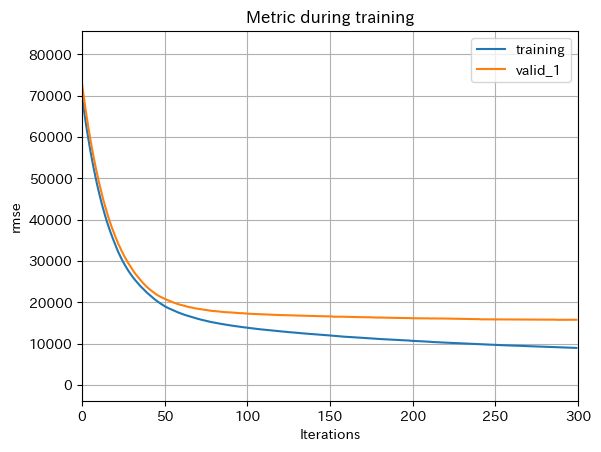

importance
面積               4.618130e+14
L                3.996709e+14
平均地価             2.030364e+14
最寄り駅             9.330807e+13
築年数              7.232080e+13
所在地              4.191608e+13
全体の階数            3.242677e+13
契約期間             1.610031e+13
所在階              9.672754e+12
所要時間             6.675980e+12
定期借家             2.003695e+12
部屋数              1.864162e+12
バス・トイレ別          1.556730e+12
建物構造             8.283650e+11
方角               5.338904e+11
D                4.669142e+11
100m^2以上         4.350623e+11
75m^2以上100m^2未満  3.365464e+11
50m^2以上75m^2未満   1.411724e+11
S                1.331321e+11
K                3.834143e+10

In [57]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

「方角」は精度を悪化させている

「K」も抜いてみたらどうか

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
directions = pd.read_csv('../data/handmade_data/directions.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
washlets = pd.read_csv('../data/handmade_data/washlets.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_directions = pd.read_csv('../data/test_data/test_directions.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], directions, buildings, sepa_bath_toilets, over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']], test_directions, test_buildings, test_sepa_bath_toilets, test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', '方角','建物構造','バス・トイレ別','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

In [63]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=1000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [64]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-16 09:30:31,533] A new study created in memory with name: no-name-f766d826-df92-414d-89ff-df53635496d6
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2846
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48787.8	valid_1's rmse: 50198.5
[20]	training's rmse: 34378.2	valid_1's rmse: 37800.6
[30]	training's rmse: 26079.1	valid_1's rmse: 31156.5
[40]	training's rmse: 20889.3	valid_1's rmse: 27401.6
[50]	training's rmse: 17647.1	valid_1's rmse: 25160.4
[60]	training's rmse: 15613.4	valid_1's rmse: 23778.7
[70]	training's rmse: 14250	valid_1's rmse: 22978.4
[80]	training's rmse: 13226.5	valid_1's rmse: 22346.8
[90]	training's rmse: 12475.9	valid_1's rmse: 21882.8
[100]	training's rmse: 11841.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2845
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48981.3	valid_1's rmse: 49548.1
[20]	training's rmse: 34934.9	valid_1's rmse: 36002.9
[30]	training's rmse: 27002.4	valid_1's rmse: 28636
[40]	training's rmse: 22342.1	valid_1's rmse: 24356.6
[50]	training's rmse: 19293.5	valid_1's rmse: 21506.5
[60]	training's rmse: 17592.5	valid_1's rmse: 20100.5
[70]	training's rmse: 16394.3	valid_1's rmse: 19095.8
[80]	training's rmse: 15544.7	valid_1's rmse: 18560.8
[90]	training's rmse: 14802.9	valid_1's rmse: 18291.9
[100]	training's rmse: 14257.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2845
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49025.9	valid_1's rmse: 48344.8
[20]	training's rmse: 35401.8	valid_1's rmse: 33880.2
[30]	training's rmse: 27151.4	valid_1's rmse: 25904.6
[40]	training's rmse: 22383.8	valid_1's rmse: 21588.1
[50]	training's rmse: 19369.7	valid_1's rmse: 19184
[60]	training's rmse: 17429.6	valid_1's rmse: 17959.9
[70]	training's rmse: 16295.6	valid_1's rmse: 17229.8
[80]	training's rmse: 15435.3	valid_1's rmse: 16745.9
[90]	training's rmse: 14719.8	valid_1's rmse: 16504.2
[100]	training's rmse: 14197.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35104.4	valid_1's rmse: 35184.5
[30]	training's rmse: 26700.8	valid_1's rmse: 28097.3
[40]	training's rmse: 21907.9	valid_1's rmse: 24347.4
[50]	training's rmse: 18789.5	valid_1's rmse: 22289.2
[60]	training's rmse: 16983.3	valid_1's rmse: 21223.7
[70]	training's rmse: 15863.4	valid_1's rmse: 20603.2
[80]	training's rmse: 15011.6	valid_1's rmse: 20129
[90]	training's rmse: 14353.8	valid_1's rmse: 19743.2
[100]	training's rmse: 13877.4	valid_1's rmse: 19488.5
[110]	training's rmse: 13413.7	valid_1's rmse: 19283.5
[120]	training's rmse: 13037.6	valid_1's rmse: 19152.5
[130]	training's rmse: 12696.3	valid_1's rmse: 19026.8
[140]	training's rmse: 12347.3	valid_1's rmse: 18903.5
[150]	training's rmse: 12052.7	valid_1's rmse: 18782.8
[160]	training's rmse: 11763.9	valid_1's rmse: 18695.3
[170]	training's rmse: 11547.8	valid_1's rmse: 18643.9
[180]	training's rmse: 11285.5	valid_1's rmse: 18551.6
[190]	training's rmse: 11095.5	valid_1's rmse: 18524.4
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2845
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48661.9	valid_1's rmse: 50981
[20]	training's rmse: 34915.5	valid_1's rmse: 37032.9
[30]	training's rmse: 26965	valid_1's rmse: 28763
[40]	training's rmse: 22243.1	valid_1's rmse: 23882.6
[50]	training's rmse: 19118.8	valid_1's rmse: 21130.5
[60]	training's rmse: 17213.7	valid_1's rmse: 19719.3
[70]	training's rmse: 16010.8	valid_1's rmse: 18885.8
[80]	training's rmse: 15076.3	valid_1's rmse: 18437.1
[90]	training's rmse: 14395.7	valid_1's rmse: 18169.8
[100]	training's rmse: 13875.8	valid_1's rmse

[I 2022-09-16 09:30:46,829] Trial 0 finished with value: 16330.627303064039 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16330.627303064039.


[280]	training's rmse: 9756.38	valid_1's rmse: 16365.6
[290]	training's rmse: 9603.85	valid_1's rmse: 16348.9
Early stopping, best iteration is:
[282]	training's rmse: 9724.62	valid_1's rmse: 16330.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2526
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48712.5	valid_1's rmse: 50056.6
[20]	training's rmse: 34369.9	valid_1's rmse: 37775.5
[30]	training's rmse: 25909.4	valid_1's rmse: 30893.9
[40]	training's rmse: 20974.3	valid_1's rmse: 27203.4
[50]	training's rmse: 17717.9	valid_1's rmse: 24856.2
[60]	training's rmse: 15702	valid_1's rmse: 23446.6
[70]	training's rmse: 14299	valid_1's rmse: 22492.3
[80]	training's rmse: 13310.3	valid_1's rmse: 21814.8
[90]	training's rmse: 12528.7	valid_1's rmse: 21328.3
[100]	training's rmse: 11979.5	valid_1's rmse: 20961.2
[110]	training's rmse: 11477	valid_1's rmse: 20626.8
[120]	training's rmse: 11064.9	valid_1's rmse: 20340.8
[130]	training's rmse: 10733.6	valid_1's rmse: 20179.5
[140]	training's rmse: 10403.8	valid_1's rmse: 19989.5
[150]	training's rmse: 10109.2	valid_1's rmse: 19809.2
[160]	training's rmse: 9831.53	valid_1's rmse: 19651.4
[170]	training's rmse: 9573.33	valid_1's rmse: 19488.4
[180]	training's rmse: 9324.61	valid_1's rmse: 19338.4
[190]	training's rmse: 91

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48956.7	valid_1's rmse: 49781.8
[20]	training's rmse: 34892.9	valid_1's rmse: 36385.4
[30]	training's rmse: 26601.5	valid_1's rmse: 28940.9
[40]	training's rmse: 21853.4	valid_1's rmse: 24770.2
[50]	training's rmse: 18917.6	valid_1's rmse: 22206.6
[60]	training's rmse: 17037.9	valid_1's rmse: 20860.4
[70]	training's rmse: 15769	valid_1's rmse: 20060.4
[80]	training's rmse: 14813.2	valid_1's rmse: 19550.4
[90]	training's rmse: 14035.5	valid_1's rmse: 19279.7
[100]	training's rmse: 13427.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2523
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48875.2	valid_1's rmse: 48676
[20]	training's rmse: 34972.5	valid_1's rmse: 34302.4
[30]	training's rmse: 26769.4	valid_1's rmse: 26556.8
[40]	training's rmse: 22094.6	valid_1's rmse: 22521.7
[50]	training's rmse: 19115.3	valid_1's rmse: 20284.6
[60]	training's rmse: 17270.9	valid_1's rmse: 19063.9
[70]	training's rmse: 16084.8	valid_1's rmse: 18391.8
[80]	training's rmse: 15157.1	valid_1's rmse: 17951.1
[90]	training's rmse: 14434.4	valid_1's rmse: 17653.6
[100]	training's rmse: 13858.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49171.6	valid_1's rmse: 48048.5
[20]	training's rmse: 34775.5	valid_1's rmse: 35467.9
[30]	training's rmse: 26356.2	valid_1's rmse: 28401.4
[40]	training's rmse: 21537.4	valid_1's rmse: 24669.9
[50]	training's rmse: 18535.6	valid_1's rmse: 22764.7
[60]	training's rmse: 16704.3	valid_1's rmse: 21684.5
[70]	training's rmse: 15477.1	valid_1's rmse: 21188.4
[80]	training's rmse: 14606.8	valid_1's rmse: 20733.9
[90]	training's rmse: 13934.4	valid_1's rmse: 20363.9
[100]	training's rmse: 13407.2	valid_1's rmse: 20134.2
[110]	training's rmse: 12966.4	valid_1's rmse: 19942.4
[120]	training's rmse: 12590.6	valid_1's rmse: 19814.5
[130]	training's rmse: 12261.5	valid_1's rmse: 19730.8
[140]	training's rmse: 11940.9	valid_1's rmse: 19614.8
[150]	training's rmse: 11636.9	valid_1's rmse: 19560.1
[160]	training's rmse: 11346.6	valid_1's rmse: 19478.9
[170]	training's rmse: 11086.8	valid_1's rmse: 19407.8
[180]	training's rmse: 10849.6	valid_1's rmse: 19370.1
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48670.2	valid_1's rmse: 51003.3
[20]	training's rmse: 35009.8	valid_1's rmse: 36882.4
[30]	training's rmse: 26797.5	valid_1's rmse: 28304.7
[40]	training's rmse: 22151.9	valid_1's rmse: 23414.2
[50]	training's rmse: 18984.3	valid_1's rmse: 20743.3
[60]	training's rmse: 17048.7	valid_1's rmse: 19422.6
[70]	training's rmse: 15756.4	valid_1's rmse: 18701.5
[80]	training's rmse: 14839.6	valid_1's rmse: 18204.3
[90]	training's rmse: 14168	valid_1's rmse: 17903.7
[100]	training's rmse: 13636.1	valid_1's rmse: 17667.8
[110]	training's rmse: 13209.2	valid_1's rmse: 17484.7
[120]	training's rmse: 12826.4	valid_1's rmse: 17341.1
[130]	training's rmse: 12475	valid_1's rmse: 17226.8


[I 2022-09-16 09:30:59,348] Trial 1 finished with value: 17145.73528242313 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16330.627303064039.


[140]	training's rmse: 12130	valid_1's rmse: 17167.8
[150]	training's rmse: 11816.5	valid_1's rmse: 17153.7
Early stopping, best iteration is:
[141]	training's rmse: 12107.2	valid_1's rmse: 17145.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3009
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48380.3	valid_1's rmse: 49959.4
[20]	training's rmse: 33933.5	valid_1's rmse: 37689.8
[30]	training's rmse: 25532.8	valid_1's rmse: 30878.4
[40]	training's rmse: 20515.9	valid_1's rmse: 27036.2
[50]	training's rmse: 17226.5	valid_1's rmse: 24612.6
[60]	training's rmse: 15230	valid_1's rmse: 23098.3
[70]	training's rmse: 13805.5	valid_1's rmse: 22008.5
[80]	training's rmse: 12812.8	valid_1's rmse: 21334.8
[90]	training's rmse: 12036.1	valid_1's rmse: 20851.3
[100]	training's rmse: 11489.1	valid_1's rmse: 20518.1
[110]	training's rmse: 11005.8	valid_1's rmse: 20249.6
[120]	training's rmse: 10586.2	valid_1's rmse: 20061
[130]	training's rmse: 10193.8	valid_1's rmse: 19856.2
[140]	training's rmse: 9848.19	valid_1's rmse: 19747.5
[150]	training's rmse: 9544	valid_1's rmse: 19621.2
[160]	training's rmse: 9273.56	valid_1's rmse: 19491.2
[170]	training's rmse: 9039.89	valid_1's rmse: 19393.1
[180]	training's rmse: 8788.87	valid_1's rmse: 19255.8
[190]	training's rmse: 854

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3012
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.3	valid_1's rmse: 49607.1
[20]	training's rmse: 34611.7	valid_1's rmse: 36019.4
[30]	training's rmse: 26644.6	valid_1's rmse: 28826.5
[40]	training's rmse: 21986.4	valid_1's rmse: 24493.3
[50]	training's rmse: 19065.7	valid_1's rmse: 21565.7
[60]	training's rmse: 17348.2	valid_1's rmse: 20091.6
[70]	training's rmse: 16015.4	valid_1's rmse: 19013.9
[80]	training's rmse: 15033	valid_1's rmse: 18378.4
[90]	training's rmse: 14236.4	valid_1's rmse: 18109.4
[100]	training's rmse: 13644	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 34796.1	valid_1's rmse: 33665.2
[30]	training's rmse: 26515.5	valid_1's rmse: 25953.8
[40]	training's rmse: 21739.5	valid_1's rmse: 21811.3
[50]	training's rmse: 18746	valid_1's rmse: 19512.5
[60]	training's rmse: 16901.1	valid_1's rmse: 18368.8
[70]	training's rmse: 15714.4	valid_1's rmse: 17632.9
[80]	training's rmse: 14883.7	valid_1's rmse: 17232
[90]	training's rmse: 14182.8	valid_1's rmse: 16960.9
[100]	training's rmse: 13623.4	valid_1's rmse: 16868.4
[110]	training's rmse: 13119.6	valid_1's rmse: 16761.7
[120]	training's rmse: 12718.2	valid_1's rmse: 16646
[130]	training's rmse: 12310.8	valid_1's rmse: 16570.3
[140]	training's rmse: 11968.1	valid_1's rmse: 16516.8
[150]	training's rmse: 11637.5	valid_1's rmse: 16488.7
[160]	training's rmse: 11353.3	valid_1's rmse: 16483.4
[170]	training's rmse: 11077.6	valid_1's rmse: 16464.2
[180]	training's rmse: 10862.4	valid_1's rmse: 16442.3
[190]	training's rmse: 10645.7	valid_1's rmse: 16423.4
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48816.2	valid_1's rmse: 47912.2
[20]	training's rmse: 34411.5	valid_1's rmse: 35425.2
[30]	training's rmse: 25992.6	valid_1's rmse: 28457.8
[40]	training's rmse: 21198.6	valid_1's rmse: 24740.7
[50]	training's rmse: 18074.6	valid_1's rmse: 22855
[60]	training's rmse: 16308.2	valid_1's rmse: 21862.9
[70]	training's rmse: 15166.9	valid_1's rmse: 21275.5
[80]	training's rmse: 14372.7	valid_1's rmse: 20731.2
[90]	training's rmse: 13763.7	valid_1's rmse: 20425.5
[100]	training's rmse: 13278.6	valid_1's rmse: 20197.5
[110]	training's rmse: 12887.8	valid_1's rmse: 19999.4
[120]	training's rmse: 12539	valid_1's rmse: 19842.8
[130]	training's rmse: 12114.5	valid_1's rmse: 19718
[140]	training's rmse: 11745.9	valid_1's rmse: 19647.2
[150]	training's rmse: 11461.8	valid_1's rmse: 19558.2
[160]	training's rmse: 11176.6	valid_1's rmse: 19451.5
[170]	training's rmse: 10921.8	valid_1's rmse: 19388.1
[180]	training's rmse: 10641.8	valid_1's rmse: 19325.4
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48301.4	valid_1's rmse: 50746.6
[20]	training's rmse: 34405.7	valid_1's rmse: 36752.6
[30]	training's rmse: 26355.8	valid_1's rmse: 28572.2
[40]	training's rmse: 21657	valid_1's rmse: 23678.8
[50]	training's rmse: 18510.8	valid_1's rmse: 20757.6
[60]	training's rmse: 16727.7	valid_1's rmse: 19362.8
[70]	training's rmse: 15513.5	valid_1's rmse: 18619.5
[80]	training's rmse: 14642.6	valid_1's rmse: 18232.5
[90]	training's rmse: 13998.7	valid_1's rmse: 18001.9
[100]	training's rmse: 13481.6	valid_1's rmse: 17851.3
[110]	training's rmse: 13051.2	valid_1's rmse: 17745.9
[120]	training's rmse: 12691.3	valid_1's rmse: 17677.9
[130]	training's rmse: 12328.4	valid_1's rmse: 17619.8
[140]	training's rmse: 12019.7	valid_1's rmse: 17555.7
[150]	training's rmse: 11759.5	valid_1's rmse: 17518.4
[160]	training's rmse: 11508.5	valid_1's rmse: 17464
[170]	training's rmse: 11277.2	valid_1's rmse: 17429.7
[180]	training's rmse: 11079.1	valid_1's rmse: 17420.2
[190]	training's rmse: 

[I 2022-09-16 09:31:12,565] Trial 2 finished with value: 17181.653467536235 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 16330.627303064039.


Early stopping, best iteration is:
[408]	training's rmse: 8242.24	valid_1's rmse: 17181.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2920
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48780.2	valid_1's rmse: 50295.6
[20]	training's rmse: 34403.1	valid_1's rmse: 37926.5
[30]	training's rmse: 26083.5	valid_1's rmse: 31180.7
[40]	training's rmse: 20966.5	valid_1's rmse: 27318
[50]	training's rmse: 17647.5	valid_1's rmse: 24880
[60]	training's rmse: 15673.6	valid_1's rmse: 23380.5
[70]	training's rmse: 14285.1	valid_1's rmse: 22336.2
[80]	training's rmse: 13303.5	valid_1's rmse: 21670
[90]	training's rmse: 12539.7	valid_1's rmse: 21183.4
[100]	training's rmse: 11997.1	valid_1's rmse: 20827.9
[110]	training's rmse: 11495.8	valid_1's rmse: 20502.8
[120]	training's rmse: 11099.8	valid_1's rmse: 20223
[130]	training's rmse: 10760.2	valid_1's rmse: 19982.4
[140]	training's rmse: 10417.2	valid_1's rmse: 19806.4
[150]	training's rmse: 10112.9	valid_1's rmse: 19637.1
[160]	training's rmse: 9819.11	valid_1's rmse: 19514.7
[170]	training's rmse: 9564.51	valid_1's rmse: 19334.7
[180]	training's rmse: 9316.73	valid_1's rmse: 19177.6
[190]	training's rmse: 9098

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2919
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48949.8	valid_1's rmse: 49605.9
[20]	training's rmse: 34892.3	valid_1's rmse: 36666.9
[30]	training's rmse: 26957.2	valid_1's rmse: 29425.6
[40]	training's rmse: 22211.3	valid_1's rmse: 24853.5
[50]	training's rmse: 19380.6	valid_1's rmse: 22102.2
[60]	training's rmse: 17670.9	valid_1's rmse: 20514.9
[70]	training's rmse: 16451.7	valid_1's rmse: 19445.4
[80]	training's rmse: 15531.6	valid_1's rmse: 18725.4
[90]	training's rmse: 14826.3	valid_1's rmse: 18402.1
[100]	training's rmse: 14266.8	valid_1's rmse: 18215.7
[110]	training's rmse: 13810.6	valid_1's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[30]	training's rmse: 27038.1	valid_1's rmse: 26044.5
[40]	training's rmse: 22340.3	valid_1's rmse: 21823.8
[50]	training's rmse: 19390.6	valid_1's rmse: 19453.2
[60]	training's rmse: 17525.5	valid_1's rmse: 18271.3
[70]	training's rmse: 16254.9	valid_1's rmse: 17510.8
[80]	training's rmse: 15369	valid_1's rmse: 17170.4
[90]	training's rmse: 14685.8	valid_1's rmse: 16925.4
[100]	training's rmse: 14140.4	valid_1's rmse: 16663.3
[110]	training's rmse: 13661.2	valid_1's rmse: 16496.3
[120]	training's rmse: 13259.9	valid_1's rmse: 16361
[130]	training's rmse: 12897.1	valid_1's rmse: 16262
[140]	training's rmse: 12526.7	valid_1's rmse: 16192.4
[150]	training's rmse: 12226.9	valid_1's rmse: 16144.8
[160]	training's rmse: 11911	valid_1's rmse: 16118.7
[170]	training's rmse: 11671.8	valid_1's rmse: 16055.9
[180]	training's rmse: 11401.1	valid_1's rmse: 16011.8
[190]	training's rmse: 11193.2	valid_1's rmse: 15986.5
[200]	training's rmse: 10987.2	valid_1's rmse: 15949.8
[210]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49231.6	valid_1's rmse: 48196
[20]	training's rmse: 35056.3	valid_1's rmse: 35291.9
[30]	training's rmse: 26617.6	valid_1's rmse: 28151.4
[40]	training's rmse: 21829.8	valid_1's rmse: 24351.5
[50]	training's rmse: 18804	valid_1's rmse: 22439.8
[60]	training's rmse: 16948.4	valid_1's rmse: 21323.6
[70]	training's rmse: 15769.7	valid_1's rmse: 20705
[80]	training's rmse: 14945.6	valid_1's rmse: 20183.4
[90]	training's rmse: 14317	valid_1's rmse: 19694.6
[100]	training's rmse: 13760.1	valid_1's rmse: 19353.3
[110]	training's rmse: 13260.3	valid_1's rmse: 19069.2
[120]	training's rmse: 12836.3	valid_1's rmse: 18861.8
[130]	training's rmse: 12440.4	valid_1's rmse: 18718.2
[140]	training's rmse: 12064.7	valid_1's rmse: 18534.8
[150]	training's rmse: 11709.7	valid_1's rmse: 18395.2
[160]	training's rmse: 11419	valid_1's rmse: 18310.7
[170]	training's rmse: 11166.1	valid_1's rmse: 18250.7
[180]	training's rmse: 10915.4	valid_1's rmse: 18189.8
[190]	training's rmse: 10705.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2916
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.9	valid_1's rmse: 51072
[20]	training's rmse: 34972.4	valid_1's rmse: 36980.6
[30]	training's rmse: 26977.1	valid_1's rmse: 28854.2
[40]	training's rmse: 22347.8	valid_1's rmse: 24097.5
[50]	training's rmse: 19302.7	valid_1's rmse: 21503.3
[60]	training's rmse: 17547.7	valid_1's rmse: 20180.5
[70]	training's rmse: 16181.7	valid_1's rmse: 19412.1
[80]	training's rmse: 15268	valid_1's rmse: 18999.8
[90]	training's rmse: 14562.1	valid_1's rmse: 18737.5
[100]	training's rmse: 14013	valid_1's rmse

[I 2022-09-16 09:31:21,700] Trial 3 finished with value: 17998.256837126257 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 16330.627303064039.


[240]	training's rmse: 10468.2	valid_1's rmse: 18013.6
[250]	training's rmse: 10328.7	valid_1's rmse: 18002.7
[260]	training's rmse: 10190.2	valid_1's rmse: 18003.7
Early stopping, best iteration is:
[251]	training's rmse: 10319.7	valid_1's rmse: 17998.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3042
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49297	valid_1's rmse: 50776
[20]	training's rmse: 35079.6	valid_1's rmse: 38532.7
[30]	training's rmse: 26825.9	valid_1's rmse: 31711.6
[40]	training's rmse: 21804.1	valid_1's rmse: 27755.3
[50]	training's rmse: 18594.3	valid_1's rmse: 25305.3
[60]	training's rmse: 16595.4	valid_1's rmse: 23759.3
[70]	training's rmse: 15224.4	valid_1's rmse: 22793.4
[80]	training's rmse: 14249.7	valid_1's rmse: 22123.7
[90]	training's rmse: 13526.7	valid_1's rmse: 21665.9
[100]	training's rmse: 12898.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3041
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49469.7	valid_1's rmse: 50082.3
[20]	training's rmse: 35568.4	valid_1's rmse: 36713.2
[30]	training's rmse: 27612.4	valid_1's rmse: 29352.4
[40]	training's rmse: 22828.5	valid_1's rmse: 24786.9
[50]	training's rmse: 19938	valid_1's rmse: 21878.2
[60]	training's rmse: 18135.4	valid_1's rmse: 20379.2
[70]	training's rmse: 16939.1	valid_1's rmse: 19315.4
[80]	training's rmse: 15945.4	valid_1's rmse: 18607.8
[90]	training's rmse: 15177.7	valid_1's rmse: 18166.4
[100]	training's rmse: 14639.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3040
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49539	valid_1's rmse: 49109.8
[20]	training's rmse: 35850.9	valid_1's rmse: 34828.1
[30]	training's rmse: 27765.6	valid_1's rmse: 26907.7
[40]	training's rmse: 22925.4	valid_1's rmse: 22531.3
[50]	training's rmse: 19937.2	valid_1's rmse: 20157.9
[60]	training's rmse: 18082.9	valid_1's rmse: 18935.3
[70]	training's rmse: 16862.9	valid_1's rmse: 18169.1
[80]	training's rmse: 15969.5	valid_1's rmse: 17708.5
[90]	training's rmse: 15245.6	valid_1's rmse: 17351.6
[100]	training's rmse: 14727.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49512.3	valid_1's rmse: 48566.6
[20]	training's rmse: 35454.1	valid_1's rmse: 36180.7
[30]	training's rmse: 27156.3	valid_1's rmse: 29280.7
[40]	training's rmse: 22222	valid_1's rmse: 25601
[50]	training's rmse: 19276.8	valid_1's rmse: 23585.3
[60]	training's rmse: 17522.4	valid_1's rmse: 22380.1
[70]	training's rmse: 16352.3	valid_1's rmse: 21721.2
[80]	training's rmse: 15561.2	valid_1's rmse: 21156.6
[90]	training's rmse: 14943.9	valid_1's rmse: 20711
[100]	training's rmse: 14431.4	valid_1's rmse: 20335.6
[110]	training's rmse: 14024.1	valid_1's rmse: 20088.8
[120]	training's rmse: 13625.4	valid_1's rmse: 19877.7
[130]	training's rmse: 13245.7	valid_1's rmse: 19690.2
[140]	training's rmse: 12930.1	valid_1's rmse: 19565.8
[150]	training's rmse: 12650.4	valid_1's rmse: 19435.5
[160]	training's rmse: 12408	valid_1's rmse: 19349.3
[170]	training's rmse: 12174.5	valid_1's rmse: 19265.6
[180]	training's rmse: 11980.3	valid_1's rmse: 19217.8
[190]	training's rmse: 1178

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3044
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49140.5	valid_1's rmse: 51586.4
[20]	training's rmse: 35591	valid_1's rmse: 37700.2
[30]	training's rmse: 27732.2	valid_1's rmse: 29424.7
[40]	training's rmse: 22928.1	valid_1's rmse: 24470
[50]	training's rmse: 19860.5	valid_1's rmse: 21740.8
[60]	training's rmse: 18023.9	valid_1's rmse: 20180.5
[70]	training's rmse: 16740.6	valid_1's rmse: 19324.4
[80]	training's rmse: 15842.4	valid_1's rmse: 18849
[90]	training's rmse: 15186.5	valid_1's rmse: 18537
[100]	training's rmse: 14658.4	valid_1's rmse: 

[I 2022-09-16 09:31:28,650] Trial 4 finished with value: 17756.44981315475 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 16330.627303064039.


Early stopping, best iteration is:
[191]	training's rmse: 11944.9	valid_1's rmse: 17756.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.8	valid_1's rmse: 50307.2
[20]	training's rmse: 34465.8	valid_1's rmse: 38194.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[30]	training's rmse: 25981.1	valid_1's rmse: 31472
[40]	training's rmse: 21007.9	valid_1's rmse: 27735.3
[50]	training's rmse: 17604.9	valid_1's rmse: 25365.9
[60]	training's rmse: 15585.6	valid_1's rmse: 23976.6
[70]	training's rmse: 14147.6	valid_1's rmse: 22987.4
[80]	training's rmse: 13111.4	valid_1's rmse: 22310.7
[90]	training's rmse: 12330.1	valid_1's rmse: 21776.2
[100]	training's rmse: 11683.3	valid_1's rmse: 21349.7
[110]	training's rmse: 11153.8	valid_1's rmse: 20993.4
[120]	training's rmse: 10692.8	valid_1's rmse: 20726.7
[130]	training's rmse: 10302.1	valid_1's rmse: 20480.6
[140]	training's rmse: 9959.89	valid_1's rmse: 20296.4
[150]	training's rmse: 9632.29	valid_1's rmse: 20073
[160]	training's rmse: 9358.8	valid_1's rmse: 19865.2
[170]	training's rmse: 9107.12	valid_1's rmse: 19666.9
[180]	training's rmse: 8850.58	valid_1's rmse: 19516.6
[190]	training's rmse: 8626.51	valid_1's rmse: 19356.9
[200]	training's rmse: 8411.36	valid_1's rmse: 19200
[210]	training's rmse: 8

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2103
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48806.9	valid_1's rmse: 49274.2
[20]	training's rmse: 34834.7	valid_1's rmse: 35851.2
[30]	training's rmse: 26724.4	valid_1's rmse: 28242.7
[40]	training's rmse: 21978.4	valid_1's rmse: 24196.6
[50]	training's rmse: 18838.9	valid_1's rmse: 21657.5
[60]	training's rmse: 16920.3	valid_1's rmse: 20064.8
[70]	training's rmse: 15572.9	valid_1's rmse: 19130.3
[80]	training's rmse: 14556.3	valid_1's rmse: 18556.4
[90]	training's rmse: 13771.5	valid_1's rmse: 18296.5
[100]	training's rmse: 13123.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2103
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48922.4	valid_1's rmse: 48843.2
[20]	training's rmse: 35069	valid_1's rmse: 34883.6
[30]	training's rmse: 26797.7	valid_1's rmse: 27196.7
[40]	training's rmse: 22103.5	valid_1's rmse: 23082.4
[50]	training's rmse: 19059.7	valid_1's rmse: 20675
[60]	training's rmse: 17112.2	valid_1's rmse: 19550.2
[70]	training's rmse: 15763.9	valid_1's rmse: 18872.2
[80]	training's rmse: 14751.5	valid_1's rmse: 18478.6
[90]	training's rmse: 13911.9	valid_1's rmse: 18181.6
[100]	training's rmse: 13223	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49112.3	valid_1's rmse: 47854.9
[20]	training's rmse: 34972.6	valid_1's rmse: 35207.7
[30]	training's rmse: 26470.1	valid_1's rmse: 28209.2
[40]	training's rmse: 21663.7	valid_1's rmse: 24454
[50]	training's rmse: 18497.3	valid_1's rmse: 22413.8
[60]	training's rmse: 16495.1	valid_1's rmse: 21470.3
[70]	training's rmse: 15130.2	valid_1's rmse: 20933.2
[80]	training's rmse: 14134.4	valid_1's rmse: 20492.8
[90]	training's rmse: 13408.6	valid_1's rmse: 20204.5
[100]	training's rmse: 12793.9	valid_1's rmse: 19966.6
[110]	training's rmse: 12275	valid_1's rmse: 19654
[120]	training's rmse: 11813.3	valid_1's rmse: 19367.3
[130]	training's rmse: 11423.1	valid_1's rmse: 19236.7
[140]	training's rmse: 11062.7	valid_1's rmse: 19103.8
[150]	training's rmse: 10737.6	valid_1's rmse: 18984.7
[160]	training's rmse: 10456.3	valid_1's rmse: 18903.8
[170]	training's rmse: 10182.2	valid_1's rmse: 18810.3
[180]	training's rmse: 9929.16	valid_1's rmse: 18735.1
[190]	training's rmse: 97

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2102
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48467.3	valid_1's rmse: 50942.1
[20]	training's rmse: 34812.8	valid_1's rmse: 36823.2
[30]	training's rmse: 26682.6	valid_1's rmse: 28424.8
[40]	training's rmse: 22063.1	valid_1's rmse: 23733.7
[50]	training's rmse: 18835.9	valid_1's rmse: 20853.4
[60]	training's rmse: 16891.4	valid_1's rmse: 19477.8
[70]	training's rmse: 15539.4	valid_1's rmse: 18708.3
[80]	training's rmse: 14503	valid_1's rmse: 18212.5
[90]	training's rmse: 13788.4	valid_1's rmse: 17917
[100]	training's rmse: 13200.1	valid_1's rm

[I 2022-09-16 09:31:39,141] Trial 5 finished with value: 15976.509976233894 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 5 with value: 15976.509976233894.


[330]	training's rmse: 8036.46	valid_1's rmse: 15984.9
[340]	training's rmse: 7900.01	valid_1's rmse: 15984.4
Early stopping, best iteration is:
[332]	training's rmse: 8018.77	valid_1's rmse: 15976.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2992
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48399.6	valid_1's rmse: 50024.5
[20]	training's rmse: 33920.2	valid_1's rmse: 37649.6
[30]	training's rmse: 25557.7	valid_1's rmse: 30890.8
[40]	training's rmse: 20531.2	valid_1's rmse: 27056.1
[50]	training's rmse: 17227.3	valid_1's rmse: 24587
[60]	training's rmse: 15212.4	valid_1's rmse: 23058.5
[70]	training's rmse: 13759.7	valid_1's rmse: 21959.7
[80]	training's rmse: 12757.4	valid_1's rmse: 21270.3
[90]	training's rmse: 11978.5	valid_1's rmse: 20764.7
[100]	training's rmse: 11401	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2994
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48769.5	valid_1's rmse: 49605.4
[20]	training's rmse: 34579.1	valid_1's rmse: 36117.2
[30]	training's rmse: 26553	valid_1's rmse: 28848.3
[40]	training's rmse: 21947.1	valid_1's rmse: 24542.8
[50]	training's rmse: 19016.4	valid_1's rmse: 21622.4
[60]	training's rmse: 17349.9	valid_1's rmse: 20175.4
[70]	training's rmse: 16056.3	valid_1's rmse: 19098
[80]	training's rmse: 15019	valid_1's rmse: 18388.2
[90]	training's rmse: 14301.4	valid_1's rmse: 18045.8
[100]	training's rmse: 13711.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48728.2	valid_1's rmse: 48278.6
[20]	training's rmse: 34783.2	valid_1's rmse: 33677.6
[30]	training's rmse: 26556.4	valid_1's rmse: 26034.4
[40]	training's rmse: 21818	valid_1's rmse: 21957.9
[50]	training's rmse: 18667.2	valid_1's rmse: 19627.6
[60]	training's rmse: 16817	valid_1's rmse: 18353.7
[70]	training's rmse: 15629.7	valid_1's rmse: 17686.9
[80]	training's rmse: 14762.1	valid_1's rmse: 17310.9
[90]	training's rmse: 14093.4	valid_1's rmse: 17075.9
[100]	training's rmse: 13556.4	valid_1's rmse: 16912
[110]	training's rmse: 13089.8	valid_1's rmse: 16832.8
[120]	training's rmse: 12649.8	valid_1's rmse: 16710.5
[130]	training's rmse: 12290.6	valid_1's rmse: 16626.1
[140]	training's rmse: 11935.3	valid_1's rmse: 16572.8
[150]	training's rmse: 11645.7	valid_1's rmse: 16540.6
[160]	training's rmse: 11358	valid_1's rmse: 16543.5
[170]	training's rmse: 11081.9	valid_1's rmse: 16532.6
[180]	training's rmse: 10832.6	valid_1's rmse: 16508.4
[190]	training's rmse: 1063

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2993
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48776.5	valid_1's rmse: 47835.2
[20]	training's rmse: 34326.7	valid_1's rmse: 35215.3
[30]	training's rmse: 25903.4	valid_1's rmse: 28162.9
[40]	training's rmse: 21110.6	valid_1's rmse: 24539.4
[50]	training's rmse: 17991.1	valid_1's rmse: 22771.5
[60]	training's rmse: 16179.2	valid_1's rmse: 21815.9
[70]	training's rmse: 15090.5	valid_1's rmse: 21211.1
[80]	training's rmse: 14323.3	valid_1's rmse: 20794.4
[90]	training's rmse: 13685	valid_1's rmse: 20519.5
[100]	training's rmse: 13200.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2994
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48296.3	valid_1's rmse: 50777.6
[20]	training's rmse: 34412.3	valid_1's rmse: 36780.7
[30]	training's rmse: 26276.8	valid_1's rmse: 28463.9
[40]	training's rmse: 21623.9	valid_1's rmse: 23766.5
[50]	training's rmse: 18481.4	valid_1's rmse: 20851.8
[60]	training's rmse: 16590.1	valid_1's rmse: 19410.8
[70]	training's rmse: 15463.7	valid_1's rmse: 18700.1
[80]	training's rmse: 14537.7	valid_1's rmse: 18296.7
[90]	training's rmse: 13888.3	valid_1's rmse: 18080
[100]	training's rmse: 13415.2	valid_1's 

[I 2022-09-16 09:31:56,468] Trial 6 finished with value: 17280.741437010878 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 5 with value: 15976.509976233894.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.2	valid_1's rmse: 50392.4
[20]	training's rmse: 34354.5	valid_1's rmse: 38099.1
[30]	training's rmse: 25906.8	valid_1's rmse: 31231.2
[40]	training's rmse: 20884.1	valid_1's rmse: 27306.6
[50]	training's rmse: 17603.8	valid_1's rmse: 24899.5
[60]	training's rmse: 15592.7	valid_1's rmse: 23414.7
[70]	training's rmse: 14181.4	valid_1's rmse: 22374.5
[80]	training's rmse: 13195.1	valid_1's rmse: 21663.2
[90]	training's rmse: 12434.3	valid_1's rmse: 21084.2
[100]	training's rmse: 11842.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48854.7	valid_1's rmse: 49594.2
[20]	training's rmse: 34739.6	valid_1's rmse: 36154.2
[30]	training's rmse: 26543.1	valid_1's rmse: 28661.6
[40]	training's rmse: 21708.9	valid_1's rmse: 24424.5
[50]	training's rmse: 18719.8	valid_1's rmse: 22060.5
[60]	training's rmse: 16900.4	valid_1's rmse: 20667.1
[70]	training's rmse: 15609.4	valid_1's rmse: 19721.1
[80]	training's rmse: 14602.6	valid_1's rmse: 19127.8
[90]	training's rmse: 13873.7	valid_1's rmse: 18829
[100]	training's rmse: 13261.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48762.5	valid_1's rmse: 48581.4
[20]	training's rmse: 34832.3	valid_1's rmse: 34254
[30]	training's rmse: 26647.7	valid_1's rmse: 26599.7
[40]	training's rmse: 22077.1	valid_1's rmse: 22649.4
[50]	training's rmse: 19126.4	valid_1's rmse: 20403.5
[60]	training's rmse: 17275	valid_1's rmse: 19209.3
[70]	training's rmse: 16044.9	valid_1's rmse: 18551.3
[80]	training's rmse: 15133.8	valid_1's rmse: 18025.4
[90]	training's rmse: 14413.9	valid_1's rmse: 17670.5
[100]	training's rmse: 13841.8	valid_1's rmse: 17445.6
[110]	training's rmse: 13355.9	valid_1's rmse: 17366.1
[120]	training's rmse: 12894.8	valid_1's rmse: 17307.8
[130]	training's rmse: 12500.8	valid_1's rmse: 17252.1
[140]	training's rmse: 12114.6	valid_1's rmse: 17215.2
[150]	training's rmse: 11783.1	valid_1's rmse: 17194.3
[160]	training's rmse: 11484.7	valid_1's rmse: 17169.8
[170]	training's rmse: 11192.5	valid_1's rmse: 17160.6
Early stopping, best iteration is:
[163]	training's rmse: 11405.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 34759.7	valid_1's rmse: 35329.1
[30]	training's rmse: 26361.3	valid_1's rmse: 28514.4
[40]	training's rmse: 21509.7	valid_1's rmse: 24990
[50]	training's rmse: 18453.5	valid_1's rmse: 23038
[60]	training's rmse: 16626.4	valid_1's rmse: 21934.4
[70]	training's rmse: 15427.9	valid_1's rmse: 21411.6
[80]	training's rmse: 14532.6	valid_1's rmse: 21062
[90]	training's rmse: 13848.2	valid_1's rmse: 20738.2
[100]	training's rmse: 13265.4	valid_1's rmse: 20517.5
[110]	training's rmse: 12815.9	valid_1's rmse: 20349.1
[120]	training's rmse: 12399.8	valid_1's rmse: 20198.1
[130]	training's rmse: 12020.8	valid_1's rmse: 20082.4
[140]	training's rmse: 11685.3	valid_1's rmse: 19970.7
[150]	training's rmse: 11338.6	valid_1's rmse: 19860.8
[160]	training's rmse: 11045.3	valid_1's rmse: 19821.6
[170]	training's rmse: 10790.4	valid_1's rmse: 19776.3
[180]	training's rmse: 10560.1	valid_1's rmse: 19749.8
[190]	training's rmse: 10333.8	valid_1's rmse: 19724.5
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48610.7	valid_1's rmse: 50941.9
[20]	training's rmse: 34927.8	valid_1's rmse: 36872.3
[30]	training's rmse: 26767.7	valid_1's rmse: 28542
[40]	training's rmse: 22204.6	valid_1's rmse: 23880.6
[50]	training's rmse: 19008.2	valid_1's rmse: 21238.5
[60]	training's rmse: 17092.6	valid_1's rmse: 19879.8
[70]	training's rmse: 15702.9	valid_1's rmse: 19057
[80]	training's rmse: 14795.8	valid_1's rmse: 18543
[90]	training's rmse: 14098.8	valid_1's rmse: 18213.9
[100]	training's rmse: 13541.8	valid_1's rmse: 17923.5
[110]	training's rmse: 13101.1	valid_1's rmse: 17755.1
[120]	training's rmse: 12701.4	valid_1's rmse: 17619.5
[130]	training's rmse: 12362.9	valid_1's rmse: 17486.8
[140]	training's rmse: 12069.4	valid_1's rmse: 17399.2
[150]	training's rmse: 11777.6	valid_1's rmse: 17346.5
[160]	training's rmse: 11512.4	valid_1's rmse: 17268.6
[170]	training's rmse: 11254.1	valid_1's rmse: 17212.3
[180]	training's rmse: 10976.3	valid_1's rmse: 17134.9
[190]	training's rmse: 10

[I 2022-09-16 09:32:09,799] Trial 7 finished with value: 16773.271136940948 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 5 with value: 15976.509976233894.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2773
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49223.5	valid_1's rmse: 50630.7
[20]	training's rmse: 35146.1	valid_1's rmse: 38372.2
[30]	training's rmse: 26983.3	valid_1's rmse: 31708.9
[40]	training's rmse: 21746.2	valid_1's rmse: 27683.4
[50]	training's rmse: 18489.4	valid_1's rmse: 25300.6
[60]	training's rmse: 16518.6	valid_1's rmse: 23869.3
[70]	training's rmse: 15133	valid_1's rmse: 22915
[80]	training's rmse: 14227.5	valid_1's rmse: 22344.2
[90]	training's rmse: 13535.6	valid_1's rmse: 21926
[100]	training's rmse: 12983.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2774
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49361	valid_1's rmse: 50033.5
[20]	training's rmse: 35571.4	valid_1's rmse: 36686
[30]	training's rmse: 27581.7	valid_1's rmse: 29175.6
[40]	training's rmse: 22775.4	valid_1's rmse: 24675.1
[50]	training's rmse: 19854.6	valid_1's rmse: 21956.4
[60]	training's rmse: 18098.9	valid_1's rmse: 20569
[70]	training's rmse: 16920.5	valid_1's rmse: 19657
[80]	training's rmse: 15996.9	valid_1's rmse: 19144.1
[90]	training's rmse: 15337.8	valid_1's rmse: 18927.4
[100]	training's rmse: 14794.1	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49473.1	valid_1's rmse: 48821.8
[20]	training's rmse: 35882.6	valid_1's rmse: 34423.3
[30]	training's rmse: 27816	valid_1's rmse: 26451.5
[40]	training's rmse: 23029.8	valid_1's rmse: 22276.5
[50]	training's rmse: 20011.4	valid_1's rmse: 19831.8
[60]	training's rmse: 18089	valid_1's rmse: 18565
[70]	training's rmse: 16858.1	valid_1's rmse: 17757.2
[80]	training's rmse: 16014.6	valid_1's rmse: 17275.6
[90]	training's rmse: 15379.8	valid_1's rmse: 16945.5
[100]	training's rmse: 14891.2	valid_1's rmse: 16733.8
[110]	training's rmse: 14435	valid_1's rmse: 16581
[120]	training's rmse: 14037.7	valid_1's rmse: 16434.8
[130]	training's rmse: 13690.8	valid_1's rmse: 16337
[140]	training's rmse: 13386.8	valid_1's rmse: 16280.4
[150]	training's rmse: 13070.2	valid_1's rmse: 16217
[160]	training's rmse: 12814	valid_1's rmse: 16146.8
[170]	training's rmse: 125

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35615.4	valid_1's rmse: 36044.6
[30]	training's rmse: 27371.8	valid_1's rmse: 29070.4
[40]	training's rmse: 22453.5	valid_1's rmse: 25317.3
[50]	training's rmse: 19366.1	valid_1's rmse: 23336.2
[60]	training's rmse: 17617.1	valid_1's rmse: 22168.3
[70]	training's rmse: 16493.7	valid_1's rmse: 21527.1
[80]	training's rmse: 15638.6	valid_1's rmse: 21035.4
[90]	training's rmse: 15010.3	valid_1's rmse: 20690.4
[100]	training's rmse: 14483.8	valid_1's rmse: 20432.9
[110]	training's rmse: 14041.4	valid_1's rmse: 20184.8
[120]	training's rmse: 13625.6	valid_1's rmse: 20001.8
[130]	training's rmse: 13290.1	valid_1's rmse: 19880.6
[140]	training's rmse: 12962.8	valid_1's rmse: 19742.3
[150]	training's rmse: 12657	valid_1's rmse: 19630.1
[160]	training's rmse: 12433.1	valid_1's rmse: 19559.5
[170]	training's rmse: 12183.9	valid_1's rmse: 19483.9
[180]	training's rmse: 11961.1	valid_1's rmse: 19424.6
[190]	training's rmse: 11759.1	valid_1's rmse: 19374.1
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2772
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49201.3	valid_1's rmse: 51528.4
[20]	training's rmse: 35715.5	valid_1's rmse: 37667.6
[30]	training's rmse: 27838.5	valid_1's rmse: 29339.5
[40]	training's rmse: 23255.1	valid_1's rmse: 24642.7
[50]	training's rmse: 20080.1	valid_1's rmse: 21877.1
[60]	training's rmse: 18136	valid_1's rmse: 20382.8
[70]	training's rmse: 16850.6	valid_1's rmse: 19499.8
[80]	training's rmse: 15956.8	valid_1's rmse: 18985
[90]	training's rmse: 15307.4	valid_1's rmse: 18723.4
[100]	training's rmse: 14745.1	valid_1's rm

[I 2022-09-16 09:32:19,305] Trial 8 finished with value: 17406.343583273825 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 5 with value: 15976.509976233894.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48959.2	valid_1's rmse: 50514.1
[20]	training's rmse: 34655.4	valid_1's rmse: 38226.9
[30]	training's rmse: 26246.3	valid_1's rmse: 31345.1
[40]	training's rmse: 21299.6	valid_1's rmse: 27521.6
[50]	training's rmse: 18002	valid_1's rmse: 25063.6
[60]	training's rmse: 15970.6	valid_1's rmse: 23580.6
[70]	training's rmse: 14582.6	valid_1's rmse: 22629.8
[80]	training's rmse: 13600.9	valid_1's rmse: 21971
[90]	training's rmse: 12842.9	valid_1's rmse: 21425.1
[100]	training's rmse: 12254.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2656
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49083.3	valid_1's rmse: 49662.8
[20]	training's rmse: 34999.5	valid_1's rmse: 36257.3
[30]	training's rmse: 26859.6	valid_1's rmse: 28709.4
[40]	training's rmse: 22040.4	valid_1's rmse: 24422.1
[50]	training's rmse: 19144.5	valid_1's rmse: 21835.4
[60]	training's rmse: 17314.7	valid_1's rmse: 20462.3
[70]	training's rmse: 16084.6	valid_1's rmse: 19605.3
[80]	training's rmse: 15149.9	valid_1's rmse: 19057.6
[90]	training's rmse: 14452.2	valid_1's rmse: 18798.4
[100]	training's rmse: 13921	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49143	valid_1's rmse: 48803
[20]	training's rmse: 35499.2	valid_1's rmse: 34417.3
[30]	training's rmse: 27318.4	valid_1's rmse: 26574.9
[40]	training's rmse: 22527.3	valid_1's rmse: 22404.4
[50]	training's rmse: 19530.8	valid_1's rmse: 20124.1
[60]	training's rmse: 17591.2	valid_1's rmse: 18870.1
[70]	training's rmse: 16408.2	valid_1's rmse: 18098.1
[80]	training's rmse: 15586.7	valid_1's rmse: 17712.5
[90]	training's rmse: 14918.2	valid_1's rmse: 17357.8
[100]	training's rmse: 14406.1	valid_1's rmse: 17088.1
[110]	training's rmse: 13940.5	valid_1's rmse: 16928.3
[120]	training's rmse: 13548.9	valid_1's rmse: 16831.5
[130]	training's rmse: 13214.2	valid_1's rmse: 16745
[140]	training's rmse: 12870.6	valid_1's rmse: 16661.8
[150]	training's rmse: 12561.4	valid_1's rmse: 16577.2
[160]	training's rmse: 12300.7	valid_1's rmse: 16491.2
[170]	training's rmse: 12053.5	valid_1's rmse: 16440.1
[180]	training's rmse: 11818.4	valid_1's rmse: 16386.1
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2658
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49433.7	valid_1's rmse: 48178.5
[20]	training's rmse: 35100.3	valid_1's rmse: 35538.2
[30]	training's rmse: 26691.4	valid_1's rmse: 28645.4
[40]	training's rmse: 21742.9	valid_1's rmse: 24893.3
[50]	training's rmse: 18771.2	valid_1's rmse: 22879.9
[60]	training's rmse: 16947.5	valid_1's rmse: 21665.1
[70]	training's rmse: 15728.6	valid_1's rmse: 20913.8
[80]	training's rmse: 14824.2	valid_1's rmse: 20403.7
[90]	training's rmse: 14178.2	valid_1's rmse: 20092.5
[100]	training's rmse: 13595.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48801.8	valid_1's rmse: 50932.9
[20]	training's rmse: 35225.7	valid_1's rmse: 36903
[30]	training's rmse: 27169.1	valid_1's rmse: 28595.9
[40]	training's rmse: 22522	valid_1's rmse: 23922.9
[50]	training's rmse: 19311.9	valid_1's rmse: 21232.5
[60]	training's rmse: 17384.2	valid_1's rmse: 19943.7
[70]	training's rmse: 16044.3	valid_1's rmse: 19194.8
[80]	training's rmse: 15107.6	valid_1's rmse: 18639.7
[90]	training's rmse: 14409	valid_1's rmse: 18301.4
[100]	training's rmse: 13857.6	valid_1's rmse

[I 2022-09-16 09:32:30,875] Trial 9 finished with value: 16967.337470774943 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 5 with value: 15976.509976233894.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2903
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48824.9	valid_1's rmse: 50292.3
[20]	training's rmse: 34460.2	valid_1's rmse: 37876.3
[30]	training's rmse: 26139.4	valid_1's rmse: 31081.2
[40]	training's rmse: 21014.4	valid_1's rmse: 27233
[50]	training's rmse: 17730.8	valid_1's rmse: 24828.5
[60]	training's rmse: 15770.7	valid_1's rmse: 23371.5
[70]	training's rmse: 14350.6	valid_1's rmse: 22372.6
[80]	training's rmse: 13312.1	valid_1's rmse: 21676.1
[90]	training's rmse: 12593.7	valid_1's rmse: 21245.8
[100]	training's rmse: 12043	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2903
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48980.9	valid_1's rmse: 49637.9
[20]	training's rmse: 34951.6	valid_1's rmse: 36596.9
[30]	training's rmse: 26922.1	valid_1's rmse: 29233.3
[40]	training's rmse: 22222.3	valid_1's rmse: 24740.3
[50]	training's rmse: 19255.2	valid_1's rmse: 21752.5
[60]	training's rmse: 17490.2	valid_1's rmse: 20035.1
[70]	training's rmse: 16293.2	valid_1's rmse: 18962.7
[80]	training's rmse: 15413.4	valid_1's rmse: 18300.8
[90]	training's rmse: 14759.7	valid_1's rmse: 18028.2
[100]	training's rmse: 14155.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49103	valid_1's rmse: 48689.2
[20]	training's rmse: 35303.2	valid_1's rmse: 34223.3
[30]	training's rmse: 27129	valid_1's rmse: 26226.7
[40]	training's rmse: 22368.7	valid_1's rmse: 21940.5
[50]	training's rmse: 19430.4	valid_1's rmse: 19552.7
[60]	training's rmse: 17524.5	valid_1's rmse: 18345.1
[70]	training's rmse: 16310.5	valid_1's rmse: 17624.8
[80]	training's rmse: 15455.1	valid_1's rmse: 17278.5
[90]	training's rmse: 14817.5	valid_1's rmse: 17039.1
[100]	training's rmse: 14306.2	valid_1's rmse: 16844.7
[110]	training's rmse: 13854.7	valid_1's rmse: 16664
[120]	training's rmse: 13442.7	valid_1's rmse: 16504.2
[130]	training's rmse: 13070	valid_1's rmse: 16408.3
[140]	training's rmse: 12659.5	valid_1's rmse: 16343.6
[150]	training's rmse: 12356.9	valid_1's rmse: 16318.7
[160]	training's rmse: 12088	valid_1's rmse: 16295.8
[170]	training's rmse: 11840	valid_1's rmse: 16285.2
[180]	training's rmse: 11620.9	valid_1's rmse: 16250.9
[190]	training's rmse: 11407.3	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49311.5	valid_1's rmse: 48259
[20]	training's rmse: 35076.4	valid_1's rmse: 35478.7
[30]	training's rmse: 26682.4	valid_1's rmse: 28321.7
[40]	training's rmse: 21749.6	valid_1's rmse: 24451
[50]	training's rmse: 18757.5	valid_1's rmse: 22510.9
[60]	training's rmse: 16928.4	valid_1's rmse: 21468
[70]	training's rmse: 15724.1	valid_1's rmse: 20790.1
[80]	training's rmse: 14899	valid_1's rmse: 20253.5
[90]	training's rmse: 14264.8	valid_1's rmse: 19881.6
[100]	training's rmse: 13735.8	valid_1's rmse: 19467
[110]	training's rmse: 13251.5	valid_1's rmse: 19196.6
[120]	training's rmse: 12837	valid_1's rmse: 18947.3
[130]	training's rmse: 12499.3	valid_1's rmse: 18783.8
[140]	training's rmse: 12134.5	valid_1's rmse: 18619.2
[150]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48760.9	valid_1's rmse: 51080.1
[20]	training's rmse: 35048.1	valid_1's rmse: 37120.2
[30]	training's rmse: 27106.7	valid_1's rmse: 28898
[40]	training's rmse: 22481.2	valid_1's rmse: 24250.2
[50]	training's rmse: 19291.1	valid_1's rmse: 21405.5
[60]	training's rmse: 17425.6	valid_1's rmse: 19931.8
[70]	training's rmse: 16114.3	valid_1's rmse: 19071.6
[80]	training's rmse: 15202.4	valid_1's rmse: 18665.5
[90]	training's rmse: 14532.9	valid_1's rmse: 18403.3
[100]	training's rmse: 13982.8	valid_1's rmse: 18181
[110]	training's rmse: 13518.2	valid_1's rmse: 18022.5
[120]	training's rmse: 13137.6	valid_1's rmse: 17930.1
[130]	training's rmse: 12813.4	valid_1's rmse: 17897.3
[140]	training's rmse: 12506.6	valid_1's rmse: 17841
[150]	training's rmse: 12218.8	valid_1's rmse: 17768.2
[160]	training's rmse: 11985.4	valid_1's rmse: 17722.6
[170]	training's

[I 2022-09-16 09:32:42,747] Trial 10 finished with value: 17453.81958162278 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 5 with value: 15976.509976233894.


Early stopping, best iteration is:
[262]	training's rmse: 10198.9	valid_1's rmse: 17453.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48828.2	valid_1's rmse: 50394.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 34692.5	valid_1's rmse: 38316.1
[30]	training's rmse: 26194.8	valid_1's rmse: 31546.2
[40]	training's rmse: 21184.5	valid_1's rmse: 27783.7
[50]	training's rmse: 17867.6	valid_1's rmse: 25410
[60]	training's rmse: 15897.7	valid_1's rmse: 23918.4
[70]	training's rmse: 14518.4	valid_1's rmse: 22918.7
[80]	training's rmse: 13506.7	valid_1's rmse: 22222.3
[90]	training's rmse: 12664.3	valid_1's rmse: 21694.5
[100]	training's rmse: 11998.9	valid_1's rmse: 21313.4
[110]	training's rmse: 11469.6	valid_1's rmse: 20932.4
[120]	training's rmse: 11015.9	valid_1's rmse: 20645.1
[130]	training's rmse: 10629.4	valid_1's rmse: 20400.8
[140]	training's rmse: 10269.1	valid_1's rmse: 20168.5
[150]	training's rmse: 9956.31	valid_1's rmse: 19901.2
[160]	training's rmse: 9670.71	valid_1's rmse: 19665.2
[170]	training's rmse: 9401.95	valid_1's rmse: 19494.1
[180]	training's rmse: 9164.49	valid_1's rmse: 19330.9
[190]	training's rmse: 8931.4	valid_1's rmse: 19165.4
[200]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2103
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48931.7	valid_1's rmse: 49378.9
[20]	training's rmse: 34957.9	valid_1's rmse: 36033.2
[30]	training's rmse: 26811.8	valid_1's rmse: 28325.1
[40]	training's rmse: 22089.9	valid_1's rmse: 24159.7
[50]	training's rmse: 18995.5	valid_1's rmse: 21563.7
[60]	training's rmse: 17101.2	valid_1's rmse: 20036.5
[70]	training's rmse: 15800.7	valid_1's rmse: 19074.9
[80]	training's rmse: 14803.9	valid_1's rmse: 18546.3
[90]	training's rmse: 13981.5	valid_1's rmse: 18256.3
[100]	training's rmse: 13326	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49072.3	valid_1's rmse: 48968.5
[20]	training's rmse: 35299.3	valid_1's rmse: 35071
[30]	training's rmse: 27155	valid_1's rmse: 27393.9
[40]	training's rmse: 22335.9	valid_1's rmse: 23071.9
[50]	training's rmse: 19231.5	valid_1's rmse: 20516.8
[60]	training's rmse: 17301.5	valid_1's rmse: 19306.3
[70]	training's rmse: 15992.1	valid_1's rmse: 18612.7
[80]	training's rmse: 14952.2	valid_1's rmse: 18214.5
[90]	training's rmse: 14128.8	valid_1's rmse: 17922.3
[100]	training's rmse: 13430	valid_1's rmse: 17696.5
[110]	training's rmse: 12871.6	valid_1's rmse: 17583.9
[120]	training's rmse: 12362.3	valid_1's rmse: 17501.3
[130]	training's rmse: 11905.7	valid_1's rmse: 17416.3
[140]	training's rmse: 11514.4	valid_1's rmse: 17357.1
[150]	training's rmse: 11172.9	valid_1's rmse: 17344
[160]	training's rmse: 10859.8	valid_1's rmse: 17342.9
Early stopping, best iteration is:
[152]	training's rmse: 11112.7	valid_1's rmse: 17337.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2104
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49248.9	valid_1's rmse: 47948.8
[20]	training's rmse: 35122.7	valid_1's rmse: 35364
[30]	training's rmse: 26750.2	valid_1's rmse: 28381.5
[40]	training's rmse: 21897.3	valid_1's rmse: 24674
[50]	training's rmse: 18716.7	valid_1's rmse: 22716.9
[60]	training's rmse: 16786.6	valid_1's rmse: 21703.6
[70]	training's rmse: 15466.7	valid_1's rmse: 21126.7
[80]	training's rmse: 14449.9	valid_1's rmse: 20635.1
[90]	training's rmse: 13701.7	valid_1's rmse: 20280.8
[100]	training's rmse: 13072.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48607.6	valid_1's rmse: 51043.2
[20]	training's rmse: 35018	valid_1's rmse: 37016.8
[30]	training's rmse: 26936.8	valid_1's rmse: 28545.9
[40]	training's rmse: 22329.6	valid_1's rmse: 23860.8
[50]	training's rmse: 19107.5	valid_1's rmse: 20979
[60]	training's rmse: 17179.6	valid_1's rmse: 19629.9
[70]	training's rmse: 15883.6	valid_1's rmse: 18780.4
[80]	training's rmse: 14837.1	valid_1's rmse: 18267.5
[90]	training's rmse: 14095.4	valid_1's rmse: 17982.4
[100]	training's rmse: 13485.2	valid_1's rmse: 17768.8
[110]	training's rmse: 12998	valid_1's rmse: 17574.6
[120]	training's rmse: 12559.7	valid_1's rmse: 17450.2
[130]	training's rmse: 12190.9	valid_1's rmse: 17382.5
[140]	training's rmse: 11821.8	valid_1's rmse: 17256.6
[150]	training's rmse: 11477	valid_1's rmse: 17149.7
[160]	training's rmse: 11157.2	valid_1's rmse: 17052.3
[170]	training's rmse: 10905	valid_1's rmse: 16970.1
[180]	training's rmse: 10648.9	valid_1's rmse: 16879.3
[190]	training's rmse: 10406.

[I 2022-09-16 09:32:53,516] Trial 11 finished with value: 16345.523757567149 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 5 with value: 15976.509976233894.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2752
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48565.2	valid_1's rmse: 50004.6
[20]	training's rmse: 34138.5	valid_1's rmse: 37589.9
[30]	training's rmse: 25939.5	valid_1's rmse: 31056.3
[40]	training's rmse: 20735.2	valid_1's rmse: 27163.1
[50]	training's rmse: 17354.5	valid_1's rmse: 24794.1
[60]	training's rmse: 15334.9	valid_1's rmse: 23374.7
[70]	training's rmse: 13897.2	valid_1's rmse: 22365.6
[80]	training's rmse: 13018	valid_1's rmse: 21778.6
[90]	training's rmse: 12295.8	valid_1's rmse: 21367.9
[100]	training's rmse: 11749.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2750
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48748.6	valid_1's rmse: 49519.9
[20]	training's rmse: 34646.2	valid_1's rmse: 36003.3
[30]	training's rmse: 26684.3	valid_1's rmse: 28689.6
[40]	training's rmse: 21977.1	valid_1's rmse: 24395.7
[50]	training's rmse: 19066.5	valid_1's rmse: 21695.7
[60]	training's rmse: 17413.5	valid_1's rmse: 20345.7
[70]	training's rmse: 16227.3	valid_1's rmse: 19583.7
[80]	training's rmse: 15307.7	valid_1's rmse: 19048.4
[90]	training's rmse: 14636.2	valid_1's rmse: 18828.9
[100]	training's rmse: 14075.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48807.3	valid_1's rmse: 48313.9
[20]	training's rmse: 35071	valid_1's rmse: 33877.9
[30]	training's rmse: 26935.6	valid_1's rmse: 26198.7
[40]	training's rmse: 22266.6	valid_1's rmse: 22075.8
[50]	training's rmse: 19062.3	valid_1's rmse: 19580.9
[60]	training's rmse: 17195.2	valid_1's rmse: 18391.2
[70]	training's rmse: 16051.8	valid_1's rmse: 17732.1
[80]	training's rmse: 15197.8	valid_1's rmse: 17309
[90]	training's rmse: 14556	valid_1's rmse: 17001.6
[100]	training's rmse: 14004.8	valid_1's rmse: 16743.4
[110]	training's rmse: 13527.4	valid_1's rmse: 16611.6
[120]	training's rmse: 13085.7	valid_1's rmse: 16525.8
[130]	training's rmse: 12707.2	valid_1's rmse: 16448.7
[140]	training's rmse: 12323.2	valid_1's rmse: 16317.3
[150]	training's rmse: 12035.3	valid_1's rmse: 16261.1
[160]	training's rmse: 11752.3	valid_1's rmse: 16218.8
[170]	training's rmse: 11522.8	valid_1's rmse: 16185.8
[180]	training's rmse: 11275.2	valid_1's rmse: 16153.4
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49024.8	valid_1's rmse: 47666.6
[20]	training's rmse: 34860.3	valid_1's rmse: 34867.8
[30]	training's rmse: 26499.5	valid_1's rmse: 27803.1
[40]	training's rmse: 21669	valid_1's rmse: 23959.5
[50]	training's rmse: 18561.5	valid_1's rmse: 21884.6
[60]	training's rmse: 16788.1	valid_1's rmse: 20931.8
[70]	training's rmse: 15643	valid_1's rmse: 20373.4
[80]	training's rmse: 14778.6	valid_1's rmse: 19941.8
[90]	training's rmse: 14133.2	valid_1's rmse: 19655.5
[100]	training's rmse: 13680.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48499	valid_1's rmse: 51103
[20]	training's rmse: 34739.7	valid_1's rmse: 36847.6
[30]	training's rmse: 26666.4	valid_1's rmse: 28625.8
[40]	training's rmse: 22167.4	valid_1's rmse: 23916.3
[50]	training's rmse: 19026.5	valid_1's rmse: 21048.8
[60]	training's rmse: 17250.9	valid_1's rmse: 19636.1
[70]	training's rmse: 16000.4	valid_1's rmse: 18815.7
[80]	training's rmse: 15062.3	valid_1's rmse: 18317.4
[90]	training's rmse: 14373.1	valid_1's rmse: 18015.9
[100]	training's rmse: 13834.8	valid_1's rmse: 17750.9
[110]	training's rmse: 13396.8	valid_1's rmse: 17571.6
[120]	training's rmse: 13003.6	valid_1's rmse: 17446.1
[130]	training's rmse: 12662.6	valid_1's rmse: 17332.7
[140]	training's rmse: 12356.3	valid_1's rmse: 17223.2
[150]	training's rmse: 12080.7	valid_1's rmse: 17125.5
[160]	training's rmse: 11818.1	valid_1's rmse: 17040.2
[170]	training's rmse: 11601.8	valid_1's rmse: 16979.4
[180]	training's rmse: 11357.3	valid_1's rmse: 16935.2
[190]	training's rmse: 

[I 2022-09-16 09:33:07,590] Trial 12 finished with value: 16459.69156108065 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 5 with value: 15976.509976233894.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873.4	valid_1's rmse: 50298.4
[20]	training's rmse: 34616.4	valid_1's rmse: 38067.8
[30]	training's rmse: 26189	valid_1's rmse: 31306.3
[40]	training's rmse: 21234.7	valid_1's rmse: 27528.4
[50]	training's rmse: 18010.2	valid_1's rmse: 25137.7
[60]	training's rmse: 16059.7	valid_1's rmse: 23685.1
[70]	training's rmse: 14649.7	valid_1's rmse: 22646.5
[80]	training's rmse: 13683.3	valid_1's rmse: 21966.8
[90]	training's rmse: 12944.1	valid_1's rmse: 21509.6
[100]	training's rmse: 12364.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2452
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49144.7	valid_1's rmse: 49723
[20]	training's rmse: 35260.4	valid_1's rmse: 36336.1
[30]	training's rmse: 27008.5	valid_1's rmse: 28906.2
[40]	training's rmse: 22210.5	valid_1's rmse: 24872.5
[50]	training's rmse: 19187.3	valid_1's rmse: 22221.9
[60]	training's rmse: 17339.5	valid_1's rmse: 20925.6
[70]	training's rmse: 16095.2	valid_1's rmse: 20231.7
[80]	training's rmse: 15054.5	valid_1's rmse: 19717.4
[90]	training's rmse: 14316.6	valid_1's rmse: 19450.5
[100]	training's rmse: 13696.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35264.6	valid_1's rmse: 34427.5
[30]	training's rmse: 27086.3	valid_1's rmse: 26431.7
[40]	training's rmse: 22369	valid_1's rmse: 22307.6
[50]	training's rmse: 19316.1	valid_1's rmse: 19984.7
[60]	training's rmse: 17419.3	valid_1's rmse: 18777.8
[70]	training's rmse: 16195.2	valid_1's rmse: 18090.5
[80]	training's rmse: 15246.4	valid_1's rmse: 17695.4
[90]	training's rmse: 14496.7	valid_1's rmse: 17414.6
[100]	training's rmse: 13897.2	valid_1's rmse: 17190.9
[110]	training's rmse: 13405.7	valid_1's rmse: 17101.8
[120]	training's rmse: 12976.4	valid_1's rmse: 17032
[130]	training's rmse: 12582.5	valid_1's rmse: 16984.6
[140]	training's rmse: 12213.9	valid_1's rmse: 16957.5
[150]	training's rmse: 11869.2	valid_1's rmse: 16913
[160]	training's rmse: 11575.3	valid_1's rmse: 16924.3
Early stopping, best iteration is:
[155]	training's rmse: 11722.7	valid_1's rmse: 16910.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2451
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49405.4	valid_1's rmse: 48420.5
[20]	training's rmse: 35051.3	valid_1's rmse: 35799
[30]	training's rmse: 26661.5	valid_1's rmse: 28790.1
[40]	training's rmse: 21769.4	valid_1's rmse: 24921.2
[50]	training's rmse: 18705.7	valid_1's rmse: 22868.7
[60]	training's rmse: 16851.1	valid_1's rmse: 21751.8
[70]	training's rmse: 15563.5	valid_1's rmse: 21210.4
[80]	training's rmse: 14632.3	valid_1's rmse: 20712.8
[90]	training's rmse: 13936.2	valid_1's rmse: 20377.8
[100]	training's rmse: 13395.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.5	valid_1's rmse: 51172.2
[20]	training's rmse: 35250.1	valid_1's rmse: 37236.7
[30]	training's rmse: 27198.7	valid_1's rmse: 28730
[40]	training's rmse: 22578	valid_1's rmse: 23978.3
[50]	training's rmse: 19448.1	valid_1's rmse: 21251.3
[60]	training's rmse: 17443.5	valid_1's rmse: 19833
[70]	training's rmse: 16121.4	valid_1's rmse: 18983.2
[80]	training's rmse: 15189.1	valid_1's rmse: 18431.2
[90]	training's rmse: 14460.1	valid_1's rmse: 18123.9
[100]	training's rmse: 13864	valid_1's rmse: 

[I 2022-09-16 09:33:18,728] Trial 13 finished with value: 17024.298640682933 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 5 with value: 15976.509976233894.


[180]	training's rmse: 11186.8	valid_1's rmse: 17033.3
Early stopping, best iteration is:
[174]	training's rmse: 11326.5	valid_1's rmse: 17024.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2145
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48726.6	valid_1's rmse: 50185.5
[20]	training's rmse: 34476.9	valid_1's rmse: 37983.6
[30]	training's rmse: 25946.2	valid_1's rmse: 31027.7
[40]	training's rmse: 20952.2	valid_1's rmse: 27152
[50]	training's rmse: 17729.8	valid_1's rmse: 24750.6
[60]	training's rmse: 15805.6	valid_1's rmse: 23440.2
[70]	training's rmse: 14479.2	valid_1's rmse: 22537
[80]	training's rmse: 13520.2	valid_1's rmse: 21914.1
[90]	training's rmse: 12708.7	valid_1's rmse: 21453.4
[100]	training's rmse: 12082.8	valid_1's rmse: 21056.4
[110]	training's rmse: 11541.9	valid_1's rmse: 20677.4
[120]	training's rmse: 11103.2	valid_1's rmse: 20372.8
[130]	training's rmse: 10702.5	valid_1's rmse: 20090.2
[140]	training's rmse: 10315.5	valid_1's rmse: 19817.1
[150]	training's rmse: 9996.33	valid_1's rmse: 19635.8
[160]	training's rmse: 9699.96	valid_1's rmse: 19443.6
[170]	training's rmse: 9422.82	valid_1's rmse: 19270
[180]	training's rmse: 9169.55	valid_1's rmse: 19116.2
[190]	training's rmse: 89

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2142
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48819.6	valid_1's rmse: 49237.9
[20]	training's rmse: 34785.4	valid_1's rmse: 35659.7
[30]	training's rmse: 26548	valid_1's rmse: 27995.5
[40]	training's rmse: 21886.7	valid_1's rmse: 24041.7
[50]	training's rmse: 18780.5	valid_1's rmse: 21513.6
[60]	training's rmse: 16905.2	valid_1's rmse: 20051.9
[70]	training's rmse: 15604.4	valid_1's rmse: 19029.5
[80]	training's rmse: 14608.7	valid_1's rmse: 18400.9
[90]	training's rmse: 13869.2	valid_1's rmse: 18030.8
[100]	training's rmse: 13231.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2145
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48975	valid_1's rmse: 48378
[20]	training's rmse: 35161.6	valid_1's rmse: 34254.7
[30]	training's rmse: 27018.4	valid_1's rmse: 26670.3
[40]	training's rmse: 22262	valid_1's rmse: 22527
[50]	training's rmse: 19218.9	valid_1's rmse: 20205.3
[60]	training's rmse: 17324.5	valid_1's rmse: 19265
[70]	training's rmse: 16014.7	valid_1's rmse: 18769.8
[80]	training's rmse: 14962.6	valid_1's rmse: 18484.9
[90]	training's rmse: 14132.5	valid_1's rmse: 18272.3
[100]	training's rmse: 13468.7	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2142
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49186.7	valid_1's rmse: 48165.1
[20]	training's rmse: 34933.7	valid_1's rmse: 35590.6
[30]	training's rmse: 26461.5	valid_1's rmse: 28572.4
[40]	training's rmse: 21706.4	valid_1's rmse: 24738
[50]	training's rmse: 18599.7	valid_1's rmse: 22845.5
[60]	training's rmse: 16697.3	valid_1's rmse: 21928.5
[70]	training's rmse: 15428.9	valid_1's rmse: 21348.5
[80]	training's rmse: 14510.2	valid_1's rmse: 20882.3
[90]	training's rmse: 13784.3	valid_1's rmse: 20396.6
[100]	training's rmse: 13211.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48559	valid_1's rmse: 51146.9
[20]	training's rmse: 34790	valid_1's rmse: 37026.3
[30]	training's rmse: 26742	valid_1's rmse: 28585.3
[40]	training's rmse: 22147.6	valid_1's rmse: 23936.3
[50]	training's rmse: 18970.9	valid_1's rmse: 21253.6
[60]	training's rmse: 17159.8	valid_1's rmse: 19903.2
[70]	training's rmse: 15894.3	valid_1's rmse: 19013.7
[80]	training's rmse: 14898.1	valid_1's rmse: 18545.4
[90]	training's rmse: 14180.6	valid_1's rmse: 18189.5
[100]	training's rmse: 13605.4	valid_1's rmse

[I 2022-09-16 09:33:34,695] Trial 14 finished with value: 16145.576433725231 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 5 with value: 15976.509976233894.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49127.5	valid_1's rmse: 50516.7
[20]	training's rmse: 35052.4	valid_1's rmse: 38294.4
[30]	training's rmse: 26813.2	valid_1's rmse: 31448.9
[40]	training's rmse: 21764.4	valid_1's rmse: 27443.4
[50]	training's rmse: 18658.6	valid_1's rmse: 25029.3
[60]	training's rmse: 16764.9	valid_1's rmse: 23532.1
[70]	training's rmse: 15389.9	valid_1's rmse: 22454.4
[80]	training's rmse: 14457.7	valid_1's rmse: 21798
[90]	training's rmse: 13752	valid_1's rmse: 21257.5
[100]	training's rmse: 13128	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.1	valid_1's rmse: 49818.4
[20]	training's rmse: 35401.4	valid_1's rmse: 36452.3
[30]	training's rmse: 27443.9	valid_1's rmse: 29019.3
[40]	training's rmse: 22709.8	valid_1's rmse: 24721.2
[50]	training's rmse: 19922.2	valid_1's rmse: 22271.4
[60]	training's rmse: 18078.4	valid_1's rmse: 20876
[70]	training's rmse: 16809.6	valid_1's rmse: 20084.7
[80]	training's rmse: 15836	valid_1's rmse: 19548.5
[90]	training's rmse: 15085.1	valid_1's rmse: 19201.1
[100]	training's rmse: 14476.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35677.9	valid_1's rmse: 34775.9
[30]	training's rmse: 27594	valid_1's rmse: 26985
[40]	training's rmse: 22916.2	valid_1's rmse: 22773.8
[50]	training's rmse: 19927.4	valid_1's rmse: 20257.8
[60]	training's rmse: 18043.8	valid_1's rmse: 18990.1
[70]	training's rmse: 16776.9	valid_1's rmse: 18197.9
[80]	training's rmse: 15845.8	valid_1's rmse: 17851.9
[90]	training's rmse: 15075.5	valid_1's rmse: 17573.1
[100]	training's rmse: 14463.1	valid_1's rmse: 17411.3
[110]	training's rmse: 13941.6	valid_1's rmse: 17319.9
[120]	training's rmse: 13494.5	valid_1's rmse: 17237.1
[130]	training's rmse: 13066.9	valid_1's rmse: 17148.5
[140]	training's rmse: 12700.9	valid_1's rmse: 17098.3
[150]	training's rmse: 12358.9	valid_1's rmse: 17060.1
[160]	training's rmse: 12051.8	valid_1's rmse: 17010.2
[170]	training's rmse: 11774	valid_1's rmse: 17000.5
[180]	training's rmse: 11524.6	valid_1's rmse: 16980.4
[190]	training's rmse: 11264.3	valid_1's rmse: 16939.9
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[30]	training's rmse: 26768.7	valid_1's rmse: 29476.1
[40]	training's rmse: 21946.5	valid_1's rmse: 26152.5
[50]	training's rmse: 18959.5	valid_1's rmse: 24362
[60]	training's rmse: 17112.7	valid_1's rmse: 23327.3
[70]	training's rmse: 15926.2	valid_1's rmse: 22717.7
[80]	training's rmse: 15049.3	valid_1's rmse: 22300.4
[90]	training's rmse: 14384.9	valid_1's rmse: 22000.7
[100]	training's rmse: 13836.9	valid_1's rmse: 21682.3
[110]	training's rmse: 13378.3	valid_1's rmse: 21485.6
[120]	training's rmse: 12944.4	valid_1's rmse: 21213.9
[130]	training's rmse: 12558.3	valid_1's rmse: 21047.6
[140]	training's rmse: 12212.4	valid_1's rmse: 20887.9
[150]	training's rmse: 11913.2	valid_1's rmse: 20768.1
[160]	training's rmse: 11575.5	valid_1's rmse: 20624.4
[170]	training's rmse: 11316.8	valid_1's rmse: 20454.6
[180]	training's rmse: 11073.1	valid_1's rmse: 20324.3
[190]	training's rmse: 10830.2	valid_1's rmse: 20205.8
[200]	training's rmse: 10593.8	valid_1's rmse: 20110.8
[210]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49005.7	valid_1's rmse: 51619.2
[20]	training's rmse: 35502.1	valid_1's rmse: 37631.9
[30]	training's rmse: 27656.1	valid_1's rmse: 29238.2
[40]	training's rmse: 23095.8	valid_1's rmse: 24477.2
[50]	training's rmse: 19987.4	valid_1's rmse: 21578.2
[60]	training's rmse: 18031.3	valid_1's rmse: 20007.4
[70]	training's rmse: 16802.8	valid_1's rmse: 19086.3
[80]	training's rmse: 15858.7	valid_1's rmse: 18455
[90]	training's rmse: 15122	valid_1's rmse: 18100.8
[100]	training's rmse: 14573.9	valid_1's rmse: 17796.8
[110]	training's rmse: 14102.5	valid_1's rmse: 17604.8
[120]	training's rmse: 13701	valid_1's rmse: 17464.6
[130]	training's rmse: 13328.9	valid_1's rmse: 17354.3
[140]	training's rmse: 13012.4	valid_1's rmse: 17199.5
[150]	training's rmse: 12681.8	valid_1's rmse: 17091.8
[160]	training's rmse: 12397.8	valid_1's rmse: 16972.2
[170]	training's rmse: 12127.9	valid_1's rmse: 16896.4
[180]	training's rmse: 11880.6	valid_1's rmse: 16807.4
[190]	training's rmse: 11

[I 2022-09-16 09:33:44,383] Trial 15 finished with value: 16300.145720373435 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 5 with value: 15976.509976233894.


[320]	training's rmse: 9460.09	valid_1's rmse: 16315
Early stopping, best iteration is:
[315]	training's rmse: 9531.26	valid_1's rmse: 16300.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2459
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48769.1	valid_1's rmse: 50228.5
[20]	training's rmse: 34444.2	valid_1's rmse: 37915.7
[30]	training's rmse: 26073.3	valid_1's rmse: 31177.5
[40]	training's rmse: 21023.9	valid_1's rmse: 27386.4
[50]	training's rmse: 17771	valid_1's rmse: 25028
[60]	training's rmse: 15761.3	valid_1's rmse: 23633.1
[70]	training's rmse: 14408.4	valid_1's rmse: 22671.6
[80]	training's rmse: 13435.5	valid_1's rmse: 22022.9
[90]	training's rmse: 12719.8	valid_1's rmse: 21544.8
[100]	training's rmse: 12146.8	valid_1's rmse: 21176.9
[110]	training's rmse: 11666.6	valid_1's rmse: 20835.4
[120]	training's rmse: 11281.8	valid_1's rmse: 20571.3
[130]	training's rmse: 10920.2	valid_1's rmse: 20314.3
[140]	training's rmse: 10609	valid_1's rmse: 20101.9
[150]	training's rmse: 10313.2	valid_1's rmse: 19898.5
[160]	training's rmse: 10025.8	valid_1's rmse: 19715.9
[170]	training's rmse: 9739.48	valid_1's rmse: 19540.9
[180]	training's rmse: 9487.25	valid_1's rmse: 19382.8
[190]	training's rmse: 92

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49029.1	valid_1's rmse: 49671.9
[20]	training's rmse: 35115.2	valid_1's rmse: 36232.8
[30]	training's rmse: 26846.6	valid_1's rmse: 28806.7
[40]	training's rmse: 22064.9	valid_1's rmse: 24877.7
[50]	training's rmse: 19083.1	valid_1's rmse: 22341.1
[60]	training's rmse: 17232.4	valid_1's rmse: 21131.7
[70]	training's rmse: 15967	valid_1's rmse: 20445.9
[80]	training's rmse: 14966.2	valid_1's rmse: 20055.6
[90]	training's rmse: 14162	valid_1's rmse: 19653
[100]	training's rmse: 13552.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48921.2	valid_1's rmse: 48625
[20]	training's rmse: 35126.4	valid_1's rmse: 34323.5
[30]	training's rmse: 27009.6	valid_1's rmse: 26308.3
[40]	training's rmse: 22213.5	valid_1's rmse: 22138
[50]	training's rmse: 19143.7	valid_1's rmse: 19726.1
[60]	training's rmse: 17275.4	valid_1's rmse: 18572.4
[70]	training's rmse: 16046.6	valid_1's rmse: 17919.1
[80]	training's rmse: 15142.2	valid_1's rmse: 17583.2
[90]	training's rmse: 14357.6	valid_1's rmse: 17351.4
[100]	training's rmse: 13740.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49255.3	valid_1's rmse: 48254.9
[20]	training's rmse: 34973.8	valid_1's rmse: 35687
[30]	training's rmse: 26445.7	valid_1's rmse: 28713.2
[40]	training's rmse: 21713.5	valid_1's rmse: 24787.2
[50]	training's rmse: 18698	valid_1's rmse: 22718.9
[60]	training's rmse: 16847.2	valid_1's rmse: 21629.9
[70]	training's rmse: 15609.3	valid_1's rmse: 21047.2
[80]	training's rmse: 14629.5	valid_1's rmse: 20514.4
[90]	training's rmse: 13930.6	valid_1's rmse: 20161.1
[100]	training's rmse: 13356.1	valid_1's rmse: 19912.6
[110]	training's rmse: 12879.1	valid_1's rmse: 19720.1
[120]	training's rmse: 12469.2	valid_1's rmse: 19637.6
[130]	training's rmse: 12126.2	valid_1's rmse: 19521.9
[140]	training's rmse: 11793.5	valid_1's rmse: 19456.7
[150]	training's rmse: 11482.8	valid_1's rmse: 19404.1
[160]	training's rmse: 11194.5	valid_1's rmse: 19336.6
[170]	training's rmse: 10943.5	valid_1's rmse: 19325.6
[180]	training's rmse: 10700.2	valid_1's rmse: 19296.2
Early stopping, best it

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35089.8	valid_1's rmse: 37147.8
[30]	training's rmse: 26999.4	valid_1's rmse: 28606.1
[40]	training's rmse: 22394.3	valid_1's rmse: 23873.9
[50]	training's rmse: 19323.3	valid_1's rmse: 21188.9
[60]	training's rmse: 17383	valid_1's rmse: 19744.7
[70]	training's rmse: 15995.9	valid_1's rmse: 18902.6
[80]	training's rmse: 14993	valid_1's rmse: 18340.4
[90]	training's rmse: 14271.4	valid_1's rmse: 18062.1
[100]	training's rmse: 13659.7	valid_1's rmse: 17813
[110]	training's rmse: 13185.2	valid_1's rmse: 17591.3
[120]	training's rmse: 12803.7	valid_1's rmse: 17486.3
[130]	training's rmse: 12430.9	valid_1's rmse: 17313.6
[140]	training's rmse: 12090	valid_1's rmse: 17199.5
[150]	training's rmse: 11782.4	valid_1's rmse: 17110.2
[160]	training's rmse: 11514.7	valid_1's rmse: 17023
[170]	training's rmse: 11260.7	valid_1's rmse: 16953.7
[180]	training's rmse: 10990.4	valid_1's rmse: 16898.9
[190]	training's rmse: 10786.4	valid_1's rmse: 16846.2
[200]	training's rmse: 10561

[I 2022-09-16 09:33:57,398] Trial 16 finished with value: 16422.552443654302 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 5 with value: 15976.509976233894.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49217.7	valid_1's rmse: 50574.7
[20]	training's rmse: 35063.9	valid_1's rmse: 38372.5
[30]	training's rmse: 26820.9	valid_1's rmse: 31594.2
[40]	training's rmse: 21778.8	valid_1's rmse: 27615.8
[50]	training's rmse: 18507.2	valid_1's rmse: 25166.4
[60]	training's rmse: 16440.5	valid_1's rmse: 23646.8
[70]	training's rmse: 15035.2	valid_1's rmse: 22636.4
[80]	training's rmse: 14143.6	valid_1's rmse: 22090.6
[90]	training's rmse: 13429.8	valid_1's rmse: 21631.4
[100]	training's rmse: 12865.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49426	valid_1's rmse: 50033.9
[20]	training's rmse: 35502.7	valid_1's rmse: 36858
[30]	training's rmse: 27483.6	valid_1's rmse: 29390.9
[40]	training's rmse: 22660.9	valid_1's rmse: 24835.8
[50]	training's rmse: 19759.4	valid_1's rmse: 21964
[60]	training's rmse: 18033.2	valid_1's rmse: 20452.1
[70]	training's rmse: 16754.7	valid_1's rmse: 19355.1
[80]	training's rmse: 15795.4	valid_1's rmse: 18716.9
[90]	training's rmse: 15066.2	valid_1's rmse: 18284.7
[100]	training's rmse: 14509.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[30]	training's rmse: 27375.2	valid_1's rmse: 26925.8
[40]	training's rmse: 22544.8	valid_1's rmse: 22618.3
[50]	training's rmse: 19578	valid_1's rmse: 20247.5
[60]	training's rmse: 17765.6	valid_1's rmse: 18903.2
[70]	training's rmse: 16569.3	valid_1's rmse: 18183.8
[80]	training's rmse: 15657.6	valid_1's rmse: 17701.5
[90]	training's rmse: 14979.3	valid_1's rmse: 17459.9
[100]	training's rmse: 14458.1	valid_1's rmse: 17225.4
[110]	training's rmse: 14005.3	valid_1's rmse: 17053.7
[120]	training's rmse: 13631.5	valid_1's rmse: 16893.3
[130]	training's rmse: 13283.8	valid_1's rmse: 16809.4
[140]	training's rmse: 12948.3	valid_1's rmse: 16745.3
[150]	training's rmse: 12651.1	valid_1's rmse: 16691.1
[160]	training's rmse: 12394.8	valid_1's rmse: 16615.3
[170]	training's rmse: 12148.9	valid_1's rmse: 16605.3
[180]	training's rmse: 11926.9	valid_1's rmse: 16603.7
Early stopping, best iteration is:
[171]	training's rmse: 12131.2	valid_1's rmse: 16594.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3105
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357	valid_1's rmse: 48368.7
[20]	training's rmse: 35091.8	valid_1's rmse: 36156.9
[30]	training's rmse: 26879.4	valid_1's rmse: 29247.8
[40]	training's rmse: 22050.3	valid_1's rmse: 25791.6
[50]	training's rmse: 19024	valid_1's rmse: 23876.6
[60]	training's rmse: 17276.8	valid_1's rmse: 22723.4
[70]	training's rmse: 16138.7	valid_1's rmse: 22094.4
[80]	training's rmse: 15326.3	valid_1's rmse: 21689.9
[90]	training's rmse: 14690.2	valid_1's rmse: 21326
[100]	training's rmse: 14193.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49101.4	valid_1's rmse: 51490.3
[20]	training's rmse: 35482.6	valid_1's rmse: 37490.4
[30]	training's rmse: 27550.3	valid_1's rmse: 29245.6
[40]	training's rmse: 22800.4	valid_1's rmse: 24370.3
[50]	training's rmse: 19625.5	valid_1's rmse: 21390.2
[60]	training's rmse: 17700.8	valid_1's rmse: 19801.5
[70]	training's rmse: 16366.1	valid_1's rmse: 18918.2
[80]	training's rmse: 15498.5	valid_1's rmse: 18514.3
[90]	training's rmse: 14830.3	valid_1's rmse: 18304.9
[100]	training's rmse: 14342.5	valid_1'

[I 2022-09-16 09:34:07,255] Trial 17 finished with value: 17570.659304474113 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 5 with value: 15976.509976233894.


[180]	training's rmse: 11965.5	valid_1's rmse: 17595.2
[190]	training's rmse: 11763.8	valid_1's rmse: 17583.8
Early stopping, best iteration is:
[185]	training's rmse: 11860.2	valid_1's rmse: 17570.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48733	valid_1's rmse: 50219.9
[20]	training's rmse: 34486.3	valid_1's rmse: 37898.3
[30]	training's rmse: 25926.7	valid_1's rmse: 30876.1
[40]	training's rmse: 20949.4	valid_1's rmse: 26978.7
[50]	training's rmse: 17816.1	valid_1's rmse: 24507.9
[60]	training's rmse: 15867	valid_1's rmse: 23009
[70]	training's rmse: 14555	valid_1's rmse: 22019.3
[80]	training's rmse: 13611.2	valid_1's rmse: 21268.4
[90]	training's rmse: 12833.3	valid_1's rmse: 20684.1
[100]	training's rmse: 12185.5	valid_1's rmse: 20255.7
[110]	training's rmse: 11663	valid_1's rmse: 19896.2
[120]	training's rmse: 11192.6	valid_1's rmse: 19581.7
[130]	training's rmse: 10810.6	valid_1's rmse: 19328
[140]	training's rmse: 10451.3	valid_1's rmse: 19090
[150]	training's rmse: 10131.9	valid_1's rmse: 18906.6
[160]	training's rmse: 9810.31	valid_1's rmse: 18671.2
[170]	training's rmse: 9511.63	valid_1's rmse: 18481.2
[180]	training's rmse: 9270.25	valid_1's rmse: 18340.2
[190]	training's rmse: 9032.38	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2250
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48824.3	valid_1's rmse: 49226.8
[20]	training's rmse: 34755.7	valid_1's rmse: 35802.3
[30]	training's rmse: 26611.1	valid_1's rmse: 28324.8
[40]	training's rmse: 21982.5	valid_1's rmse: 24304.1
[50]	training's rmse: 18982.4	valid_1's rmse: 21857.5
[60]	training's rmse: 17162.7	valid_1's rmse: 20205.4
[70]	training's rmse: 15904.2	valid_1's rmse: 19309.4
[80]	training's rmse: 14906.6	valid_1's rmse: 18751.9
[90]	training's rmse: 14113.4	valid_1's rmse: 18495.9
[100]	training's rmse: 13480.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2248
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49027.7	valid_1's rmse: 48611.3
[20]	training's rmse: 35146.2	valid_1's rmse: 34309.1
[30]	training's rmse: 26970	valid_1's rmse: 26576.7
[40]	training's rmse: 22322	valid_1's rmse: 22603.1
[50]	training's rmse: 19398.1	valid_1's rmse: 20234.6
[60]	training's rmse: 17545.7	valid_1's rmse: 19187.1
[70]	training's rmse: 16234.1	valid_1's rmse: 18535.4
[80]	training's rmse: 15264.2	valid_1's rmse: 18196.8
[90]	training's rmse: 14520.8	valid_1's rmse: 17954
[100]	training's rmse: 13892	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2249
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49161.8	valid_1's rmse: 48099.4
[20]	training's rmse: 34893.8	valid_1's rmse: 35694.1
[30]	training's rmse: 26414	valid_1's rmse: 28910.2
[40]	training's rmse: 21751.6	valid_1's rmse: 25289.8
[50]	training's rmse: 18712.2	valid_1's rmse: 23390
[60]	training's rmse: 16820.9	valid_1's rmse: 22419.2
[70]	training's rmse: 15606	valid_1's rmse: 21857
[80]	training's rmse: 14719.1	valid_1's rmse: 21395.9
[90]	training's rmse: 14014.4	valid_1's rmse: 20904.4
[100]	training's rmse: 13421.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2248
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48569.1	valid_1's rmse: 51034.2
[20]	training's rmse: 34865.8	valid_1's rmse: 36973.8
[30]	training's rmse: 26900.2	valid_1's rmse: 28659.1
[40]	training's rmse: 22378.6	valid_1's rmse: 24072.1
[50]	training's rmse: 19232.3	valid_1's rmse: 21377.2
[60]	training's rmse: 17317.2	valid_1's rmse: 19943.3
[70]	training's rmse: 16005.7	valid_1's rmse: 19110.3
[80]	training's rmse: 15077.1	valid_1's rmse: 18645.6
[90]	training's rmse: 14351	valid_1's rmse: 18295.2
[100]	training's rmse: 13777.3	valid_1's 

[I 2022-09-16 09:34:22,005] Trial 18 finished with value: 16281.8774124827 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 5 with value: 15976.509976233894.


[390]	training's rmse: 7779.99	valid_1's rmse: 16301.4
Early stopping, best iteration is:
[386]	training's rmse: 7826.05	valid_1's rmse: 16281.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2583
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49156.8	valid_1's rmse: 50674.2
[20]	training's rmse: 34948.8	valid_1's rmse: 38493.8
[30]	training's rmse: 26582.6	valid_1's rmse: 31628.1
[40]	training's rmse: 21563.5	valid_1's rmse: 27622.1
[50]	training's rmse: 18344.5	valid_1's rmse: 25169.3
[60]	training's rmse: 16329.2	valid_1's rmse: 23668.9
[70]	training's rmse: 14853.6	valid_1's rmse: 22653.1
[80]	training's rmse: 13927.6	valid_1's rmse: 21963.8
[90]	training's rmse: 13164.1	valid_1's rmse: 21455.5
[100]	training's rmse: 12559	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303	valid_1's rmse: 50038.7
[20]	training's rmse: 35421.7	valid_1's rmse: 36905.8
[30]	training's rmse: 27245	valid_1's rmse: 29379.5
[40]	training's rmse: 22360.1	valid_1's rmse: 24862.4
[50]	training's rmse: 19447.1	valid_1's rmse: 22188.5
[60]	training's rmse: 17581.1	valid_1's rmse: 20565.6
[70]	training's rmse: 16288.6	valid_1's rmse: 19650.2
[80]	training's rmse: 15321.6	valid_1's rmse: 19081.5
[90]	training's rmse: 14534.2	valid_1's rmse: 18709
[100]	training's rmse: 13916.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49197.3	valid_1's rmse: 48911.2
[20]	training's rmse: 35413.6	valid_1's rmse: 34802.6
[30]	training's rmse: 27275.6	valid_1's rmse: 26926.7
[40]	training's rmse: 22574.2	valid_1's rmse: 22849.8
[50]	training's rmse: 19653.7	valid_1's rmse: 20535.2
[60]	training's rmse: 17690	valid_1's rmse: 19305.9
[70]	training's rmse: 16462.3	valid_1's rmse: 18653.6
[80]	training's rmse: 15524.5	valid_1's rmse: 18184.3
[90]	training's rmse: 14839.9	valid_1's rmse: 17845.7
[100]	training's rmse: 14251.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35361.7	valid_1's rmse: 35794.6
[30]	training's rmse: 26974.3	valid_1's rmse: 28888.2
[40]	training's rmse: 22074.2	valid_1's rmse: 25204.7
[50]	training's rmse: 19103.3	valid_1's rmse: 23176.3
[60]	training's rmse: 17231.4	valid_1's rmse: 22054.3
[70]	training's rmse: 16033.5	valid_1's rmse: 21482.1
[80]	training's rmse: 15091.5	valid_1's rmse: 20976.7
[90]	training's rmse: 14419	valid_1's rmse: 20725.6
[100]	training's rmse: 13888.9	valid_1's rmse: 20437.6
[110]	training's rmse: 13462.1	valid_1's rmse: 20316.8
[120]	training's rmse: 13053.7	valid_1's rmse: 20121.3
[130]	training's rmse: 12738.8	valid_1's rmse: 20039.7
[140]	training's rmse: 12400.3	valid_1's rmse: 19944.2
[150]	training's rmse: 12080.7	valid_1's rmse: 19856
[160]	training's rmse: 11822.4	valid_1's rmse: 19817.4
[170]	training's rmse: 11560.3	valid_1's rmse: 19729.8
[180]	training's rmse: 11342.3	valid_1's rmse: 19713.9
[190]	training's rmse: 11121.2	valid_1's rmse: 19670
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2583
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48990.8	valid_1's rmse: 51219.4
[20]	training's rmse: 35523.4	valid_1's rmse: 37288.6
[30]	training's rmse: 27519.1	valid_1's rmse: 29151.8
[40]	training's rmse: 22805.5	valid_1's rmse: 24335.8
[50]	training's rmse: 19642.5	valid_1's rmse: 21630.3
[60]	training's rmse: 17657.5	valid_1's rmse: 20172.5
[70]	training's rmse: 16317.7	valid_1's rmse: 19302.6
[80]	training's rmse: 15339.6	valid_1's rmse: 18766
[90]	training's rmse: 14684.4	valid_1's rmse: 18413.6
[100]	training's rmse: 14142.1	valid_1's 

[I 2022-09-16 09:34:33,990] Trial 19 finished with value: 16775.96635145503 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 5 with value: 15976.509976233894.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2199
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739.9	valid_1's rmse: 50352.2
[20]	training's rmse: 34505.5	valid_1's rmse: 38161.3
[30]	training's rmse: 25944.3	valid_1's rmse: 31221.5
[40]	training's rmse: 20920.3	valid_1's rmse: 27278.4
[50]	training's rmse: 17637.9	valid_1's rmse: 24861.3
[60]	training's rmse: 15749.2	valid_1's rmse: 23501.5
[70]	training's rmse: 14403.1	valid_1's rmse: 22573.9
[80]	training's rmse: 13422.1	valid_1's rmse: 21911.7
[90]	training's rmse: 12636.5	valid_1's rmse: 21448.3
[100]	training's rmse: 11988	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2198
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48859	valid_1's rmse: 49314.6
[20]	training's rmse: 34841.5	valid_1's rmse: 35978.8
[30]	training's rmse: 26706.1	valid_1's rmse: 28532.2
[40]	training's rmse: 21971.6	valid_1's rmse: 24376.6
[50]	training's rmse: 18814.4	valid_1's rmse: 21745.9
[60]	training's rmse: 16959.6	valid_1's rmse: 20166.1
[70]	training's rmse: 15729.4	valid_1's rmse: 19268.4
[80]	training's rmse: 14700.3	valid_1's rmse: 18748.9
[90]	training's rmse: 13941.4	valid_1's rmse: 18376.7
[100]	training's rmse: 13318.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2198
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48978	valid_1's rmse: 48572.9
[20]	training's rmse: 35069.5	valid_1's rmse: 34106.3
[30]	training's rmse: 26865.9	valid_1's rmse: 26302.5
[40]	training's rmse: 22214.1	valid_1's rmse: 22272.4
[50]	training's rmse: 19318.1	valid_1's rmse: 19981.7
[60]	training's rmse: 17468.8	valid_1's rmse: 18910.4
[70]	training's rmse: 16160.1	valid_1's rmse: 18401.5
[80]	training's rmse: 15136.7	valid_1's rmse: 18066.6
[90]	training's rmse: 14394.1	valid_1's rmse: 17835.5
[100]	training's rmse: 13766.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2197
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49169.5	valid_1's rmse: 48014.6
[20]	training's rmse: 34997	valid_1's rmse: 35607.6
[30]	training's rmse: 26545.3	valid_1's rmse: 28678.7
[40]	training's rmse: 21737.2	valid_1's rmse: 25146.8
[50]	training's rmse: 18633.5	valid_1's rmse: 23277
[60]	training's rmse: 16769.1	valid_1's rmse: 22421.2
[70]	training's rmse: 15506.8	valid_1's rmse: 21983.6
[80]	training's rmse: 14619.2	valid_1's rmse: 21379.7
[90]	training's rmse: 13929.5	valid_1's rmse: 20896.9
[100]	training's rmse: 13364.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2198
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48629.2	valid_1's rmse: 51138.1
[20]	training's rmse: 34929.4	valid_1's rmse: 37117.5
[30]	training's rmse: 26939.4	valid_1's rmse: 28879
[40]	training's rmse: 22402.6	valid_1's rmse: 24253.8
[50]	training's rmse: 19327.5	valid_1's rmse: 21698
[60]	training's rmse: 17515.2	valid_1's rmse: 20237.7
[70]	training's rmse: 16111.5	valid_1's rmse: 19422.6
[80]	training's rmse: 15163.2	valid_1's rmse: 18917.3
[90]	training's rmse: 14444	valid_1's rmse: 18642.4
[100]	training's rmse: 13876	valid_1's rmse: 

[I 2022-09-16 09:34:47,970] Trial 20 finished with value: 16357.059953969438 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 5 with value: 15976.509976233894.


[350]	training's rmse: 8333.16	valid_1's rmse: 16358.7
Early stopping, best iteration is:
[342]	training's rmse: 8444.43	valid_1's rmse: 16357.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2291
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48931.9	valid_1's rmse: 50426.4
[20]	training's rmse: 34813.8	valid_1's rmse: 38189.1
[30]	training's rmse: 26439.9	valid_1's rmse: 31249.9
[40]	training's rmse: 21411.8	valid_1's rmse: 27389.3
[50]	training's rmse: 18211.1	valid_1's rmse: 24925
[60]	training's rmse: 16286.4	valid_1's rmse: 23419
[70]	training's rmse: 14941.5	valid_1's rmse: 22403.2
[80]	training's rmse: 14020.7	valid_1's rmse: 21686.1
[90]	training's rmse: 13294.5	valid_1's rmse: 21115.8
[100]	training's rmse: 12651.7	valid_1's rmse: 20647.4
[110]	training's rmse: 12168.4	valid_1's rmse: 20262
[120]	training's rmse: 11761.3	valid_1's rmse: 19988.4
[130]	training's rmse: 11426	valid_1's rmse: 19755.3
[140]	training's rmse: 11099.4	valid_1's rmse: 19543.5
[150]	training's rmse: 10794.9	valid_1's rmse: 19373
[160]	training's rmse: 10517.7	valid_1's rmse: 19233.9
[170]	training's rmse: 10242.2	valid_1's rmse: 19066.3
[180]	training's rmse: 9992.28	valid_1's rmse: 18907.3
[190]	training's rmse: 9764.3

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2288
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49159.4	valid_1's rmse: 49791.5
[20]	training's rmse: 35258.7	valid_1's rmse: 36291.1
[30]	training's rmse: 27142.3	valid_1's rmse: 28550.4
[40]	training's rmse: 22544.7	valid_1's rmse: 24317.3
[50]	training's rmse: 19618.6	valid_1's rmse: 21660.8
[60]	training's rmse: 17812.8	valid_1's rmse: 20094.5
[70]	training's rmse: 16491.3	valid_1's rmse: 19334
[80]	training's rmse: 15445.6	valid_1's rmse: 18824
[90]	training's rmse: 14674.2	valid_1's rmse: 18545.9
[100]	training's rmse: 14035.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35431.2	valid_1's rmse: 34453.1
[30]	training's rmse: 27297.7	valid_1's rmse: 26686.3
[40]	training's rmse: 22522.3	valid_1's rmse: 22479
[50]	training's rmse: 19569.4	valid_1's rmse: 20051.1
[60]	training's rmse: 17676.8	valid_1's rmse: 18879.2
[70]	training's rmse: 16381.3	valid_1's rmse: 18166.2
[80]	training's rmse: 15418.5	valid_1's rmse: 17833.4
[90]	training's rmse: 14656.1	valid_1's rmse: 17615.6
[100]	training's rmse: 14044.5	valid_1's rmse: 17451.6
[110]	training's rmse: 13529	valid_1's rmse: 17324.3
[120]	training's rmse: 13064.4	valid_1's rmse: 17249.8
[130]	training's rmse: 12643.1	valid_1's rmse: 17146.1
[140]	training's rmse: 12268.2	valid_1's rmse: 17071.3
[150]	training's rmse: 11908.7	valid_1's rmse: 17002
[160]	training's rmse: 11566.6	valid_1's rmse: 16925.9
[170]	training's rmse: 11244.8	valid_1's rmse: 16914.3
[180]	training's rmse: 10969.2	valid_1's rmse: 16868.6
[190]	training's rmse: 10717.8	valid_1's rmse: 16855.8
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2288
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49300.3	valid_1's rmse: 48270.6
[20]	training's rmse: 35056.7	valid_1's rmse: 35929.2
[30]	training's rmse: 26662.1	valid_1's rmse: 29086
[40]	training's rmse: 21837.5	valid_1's rmse: 25455
[50]	training's rmse: 18845	valid_1's rmse: 23639
[60]	training's rmse: 16979.2	valid_1's rmse: 22623.7
[70]	training's rmse: 15771.4	valid_1's rmse: 22078.6
[80]	training's rmse: 14862.8	valid_1's rmse: 21744.2
[90]	training's rmse: 14191.7	valid_1's rmse: 21436.7
[100]	training's rmse: 13600.6	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35210.6	valid_1's rmse: 37242.3
[30]	training's rmse: 27252.5	valid_1's rmse: 28984.9
[40]	training's rmse: 22672.8	valid_1's rmse: 24238.1
[50]	training's rmse: 19547.8	valid_1's rmse: 21406.9
[60]	training's rmse: 17627.6	valid_1's rmse: 19897.7
[70]	training's rmse: 16316.8	valid_1's rmse: 19045.9
[80]	training's rmse: 15407.8	valid_1's rmse: 18422.2
[90]	training's rmse: 14677.5	valid_1's rmse: 18112.3
[100]	training's rmse: 14113.6	valid_1's rmse: 17851.7
[110]	training's rmse: 13662.9	valid_1's rmse: 17636.5
[120]	training's rmse: 13248.7	valid_1's rmse: 17451
[130]	training's rmse: 12876.5	valid_1's rmse: 17317.7
[140]	training's rmse: 12540	valid_1's rmse: 17166.3
[150]	training's rmse: 12226.8	valid_1's rmse: 17055.8
[160]	training's rmse: 11946.6	valid_1's rmse: 16942.8
[170]	training's rmse: 11687.1	valid_1's rmse: 16851.4
[180]	training's rmse: 11440.8	valid_1's rmse: 16799.2
[190]	training's rmse: 11226.8	valid_1's rmse: 16713.1
[200]	training's rmse:

[I 2022-09-16 09:35:00,194] Trial 21 finished with value: 16301.997870093215 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 5 with value: 15976.509976233894.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48635.6	valid_1's rmse: 50259.1
[20]	training's rmse: 34360	valid_1's rmse: 38116.6
[30]	training's rmse: 25688.5	valid_1's rmse: 31131
[40]	training's rmse: 20670.7	valid_1's rmse: 27336.9
[50]	training's rmse: 17403.4	valid_1's rmse: 24964
[60]	training's rmse: 15467.5	valid_1's rmse: 23585
[70]	training's rmse: 14118.8	valid_1's rmse: 22762.9
[80]	training's rmse: 13140.1	valid_1's rmse: 22106.6
[90]	training's rmse: 12374.5	valid_1's rmse: 21645.4
[100]	training's rmse: 11690.6	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2183
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48707.1	valid_1's rmse: 49241.2
[20]	training's rmse: 34589.8	valid_1's rmse: 35892.6
[30]	training's rmse: 26537.1	valid_1's rmse: 28531
[40]	training's rmse: 21895	valid_1's rmse: 24479.1
[50]	training's rmse: 18834.2	valid_1's rmse: 21802.4
[60]	training's rmse: 17048.2	valid_1's rmse: 20212.3
[70]	training's rmse: 15800	valid_1's rmse: 19273.4
[80]	training's rmse: 14769	valid_1's rmse: 18585.1
[90]	training's rmse: 14001.2	valid_1's rmse: 18322.6
[100]	training's rmse: 13332.1	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2183
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873.9	valid_1's rmse: 48339.3
[20]	training's rmse: 34977.8	valid_1's rmse: 33967.6
[30]	training's rmse: 26772.9	valid_1's rmse: 26396
[40]	training's rmse: 22137.1	valid_1's rmse: 22482.4
[50]	training's rmse: 19078.9	valid_1's rmse: 20060.6
[60]	training's rmse: 17212	valid_1's rmse: 19039.2
[70]	training's rmse: 15933.6	valid_1's rmse: 18440.8
[80]	training's rmse: 14961	valid_1's rmse: 18120.7
[90]	training's rmse: 14193.4	valid_1's rmse: 17921.5
[100]	training's rmse: 13558.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49077.2	valid_1's rmse: 48045.3
[20]	training's rmse: 34695	valid_1's rmse: 35401.2
[30]	training's rmse: 26284.7	valid_1's rmse: 28476.5
[40]	training's rmse: 21507.1	valid_1's rmse: 24852.6
[50]	training's rmse: 18324.5	valid_1's rmse: 22960.5
[60]	training's rmse: 16384.6	valid_1's rmse: 22129.2
[70]	training's rmse: 15181.3	valid_1's rmse: 21593.9
[80]	training's rmse: 14294.2	valid_1's rmse: 21121.3
[90]	training's rmse: 13607.1	valid_1's rmse: 20685.4
[100]	training's rmse: 13025.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2183
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48491.5	valid_1's rmse: 51074.7
[20]	training's rmse: 34809.9	valid_1's rmse: 37042.9
[30]	training's rmse: 26723.3	valid_1's rmse: 28749.8
[40]	training's rmse: 22179.2	valid_1's rmse: 24185.2
[50]	training's rmse: 19129.1	valid_1's rmse: 21618.2
[60]	training's rmse: 17371	valid_1's rmse: 20083
[70]	training's rmse: 16048.5	valid_1's rmse: 19235.2
[80]	training's rmse: 15021	valid_1's rmse: 18733.4
[90]	training's rmse: 14306.7	valid_1's rmse: 18312.4
[100]	training's rmse: 13704.8	valid_1's rmse

[I 2022-09-16 09:35:15,571] Trial 22 finished with value: 16071.320865237609 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 5 with value: 15976.509976233894.


[340]	training's rmse: 8222.75	valid_1's rmse: 16100
Early stopping, best iteration is:
[336]	training's rmse: 8290.99	valid_1's rmse: 16071.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3087
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.3	valid_1's rmse: 50331.1
[20]	training's rmse: 34540.3	valid_1's rmse: 38067.1
[30]	training's rmse: 26113	valid_1's rmse: 31195.7
[40]	training's rmse: 21118.6	valid_1's rmse: 27371.7
[50]	training's rmse: 17771.4	valid_1's rmse: 24953.3
[60]	training's rmse: 15747.3	valid_1's rmse: 23485.1
[70]	training's rmse: 14363.4	valid_1's rmse: 22536.1
[80]	training's rmse: 13437.8	valid_1's rmse: 22001.7
[90]	training's rmse: 12742.4	valid_1's rmse: 21636.8
[100]	training's rmse: 12159	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3086
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49018.6	valid_1's rmse: 49718.9
[20]	training's rmse: 34987.2	valid_1's rmse: 36371.8
[30]	training's rmse: 26972.4	valid_1's rmse: 29013.2
[40]	training's rmse: 22113.1	valid_1's rmse: 24358.4
[50]	training's rmse: 19207.7	valid_1's rmse: 21540.6
[60]	training's rmse: 17507.4	valid_1's rmse: 20105.3
[70]	training's rmse: 16289.4	valid_1's rmse: 19106.4
[80]	training's rmse: 15240.8	valid_1's rmse: 18547.4
[90]	training's rmse: 14521.6	valid_1's rmse: 18245.2
[100]	training's rmse: 13961.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3084
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48841.7	valid_1's rmse: 48836.9
[20]	training's rmse: 34979.3	valid_1's rmse: 34367.6
[30]	training's rmse: 26797.8	valid_1's rmse: 26374.8
[40]	training's rmse: 22007.6	valid_1's rmse: 22083.6
[50]	training's rmse: 19075.2	valid_1's rmse: 19893.6
[60]	training's rmse: 17098.9	valid_1's rmse: 18604.7
[70]	training's rmse: 15925.8	valid_1's rmse: 17818.8
[80]	training's rmse: 15067.1	valid_1's rmse: 17337.8
[90]	training's rmse: 14415.1	valid_1's rmse: 17038.7
[100]	training's rmse: 13879.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 34602.6	valid_1's rmse: 35692.1
[30]	training's rmse: 26287.2	valid_1's rmse: 28832
[40]	training's rmse: 21389.8	valid_1's rmse: 25296.4
[50]	training's rmse: 18419.3	valid_1's rmse: 23450.7
[60]	training's rmse: 16701.4	valid_1's rmse: 22421.1
[70]	training's rmse: 15564.4	valid_1's rmse: 21749
[80]	training's rmse: 14753.8	valid_1's rmse: 21212.2
[90]	training's rmse: 14173.8	valid_1's rmse: 20873.5
[100]	training's rmse: 13685	valid_1's rmse: 20655.5
[110]	training's rmse: 13265.9	valid_1's rmse: 20449.2
[120]	training's rmse: 12897.8	valid_1's rmse: 20297.4
[130]	training's rmse: 12565.2	valid_1's rmse: 20142.4
[140]	training's rmse: 12206.5	valid_1's rmse: 20018.3
[150]	training's rmse: 11860.7	valid_1's rmse: 19956.7
[160]	training's rmse: 11590.1	valid_1's rmse: 19854.6
[170]	training's rmse: 11363.6	valid_1's rmse: 19789.2
[180]	training's rmse: 11131.5	valid_1's rmse: 19717.1
[190]	training's rmse: 10946.8	valid_1's rmse: 19660.4
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48611.1	valid_1's rmse: 50875.3
[20]	training's rmse: 34837.6	valid_1's rmse: 36900.4
[30]	training's rmse: 26808.3	valid_1's rmse: 28796.5
[40]	training's rmse: 22122.5	valid_1's rmse: 24036.9
[50]	training's rmse: 19016.2	valid_1's rmse: 21220
[60]	training's rmse: 17176.5	valid_1's rmse: 19871.2
[70]	training's rmse: 15958.9	valid_1's rmse: 19088.9
[80]	training's rmse: 14997.3	valid_1's rmse: 18635.1
[90]	training's rmse: 14371.8	valid_1's rmse: 18349.6
[100]	training's rmse: 13818	valid_1's rmse: 18129.2
[110]	training's rmse: 13401.8	valid_1's rmse: 17969.4
[120]	training's rmse: 13014.3	valid_1's rmse: 17862.2
[130]	training's rmse: 12688.5	valid_1's rmse: 17766.7
[140]	training's rmse: 12356	valid_1's rmse: 17689.3
[150]	training's rmse: 12066.9	valid_1's rmse: 17607.1
[160]	training's rmse: 11800.3	valid_1's rmse: 17528.1
[170]	training's rmse: 11573.6	valid_1's rmse: 17489.4
[180]	training's rmse: 11334.6	valid_1's rmse: 17423.2
[190]	training's rmse: 11

[I 2022-09-16 09:35:28,100] Trial 23 finished with value: 16971.776532169344 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 5 with value: 15976.509976233894.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2739
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48654.4	valid_1's rmse: 50033.3
[20]	training's rmse: 34276.8	valid_1's rmse: 37668.8
[30]	training's rmse: 25932.7	valid_1's rmse: 30948.6
[40]	training's rmse: 20841.6	valid_1's rmse: 27167.4
[50]	training's rmse: 17499.8	valid_1's rmse: 24838.3
[60]	training's rmse: 15497.3	valid_1's rmse: 23423.3
[70]	training's rmse: 14080	valid_1's rmse: 22429.4
[80]	training's rmse: 13158.3	valid_1's rmse: 21840.1
[90]	training's rmse: 12409.4	valid_1's rmse: 21417.3
[100]	training's rmse: 11817.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2740
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48845.2	valid_1's rmse: 49516.9
[20]	training's rmse: 34876.5	valid_1's rmse: 36294.6
[30]	training's rmse: 26919.2	valid_1's rmse: 28853.3
[40]	training's rmse: 22203.9	valid_1's rmse: 24417.2
[50]	training's rmse: 19202.8	valid_1's rmse: 21612.9
[60]	training's rmse: 17465.1	valid_1's rmse: 20206.8
[70]	training's rmse: 16255	valid_1's rmse: 19425.5
[80]	training's rmse: 15377.8	valid_1's rmse: 18921.6
[90]	training's rmse: 14686.2	valid_1's rmse: 18753.2
[100]	training's rmse: 14154	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35213.8	valid_1's rmse: 33967.4
[30]	training's rmse: 27131.7	valid_1's rmse: 26169.3
[40]	training's rmse: 22318.7	valid_1's rmse: 21989.3
[50]	training's rmse: 19225.3	valid_1's rmse: 19526
[60]	training's rmse: 17358.6	valid_1's rmse: 18308
[70]	training's rmse: 16140.5	valid_1's rmse: 17614.6
[80]	training's rmse: 15318.1	valid_1's rmse: 17125.4
[90]	training's rmse: 14649	valid_1's rmse: 16826.6
[100]	training's rmse: 14116.4	valid_1's rmse: 16666
[110]	training's rmse: 13667.6	valid_1's rmse: 16475.5
[120]	training's rmse: 13272.7	valid_1's rmse: 16383.8
[130]	training's rmse: 12929.9	valid_1's rmse: 16290.7
[140]	training's rmse: 12609.5	valid_1's rmse: 16194.1
[150]	training's rmse: 12299.3	valid_1's rmse: 16124
[160]	training's rmse: 12015.5	valid_1's rmse: 16084.5
[170]	training's rmse: 11716	valid_1's rmse: 16013.7
[180]	training's rmse: 11448.7	valid_1's rmse: 15966.8
[190]	training's rmse: 11205	valid_1's rmse: 15909.9
[200]	training's rmse: 10990.7	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49148	valid_1's rmse: 47808.1
[20]	training's rmse: 35060.5	valid_1's rmse: 35057.6
[30]	training's rmse: 26618.1	valid_1's rmse: 27907
[40]	training's rmse: 21778	valid_1's rmse: 24100.6
[50]	training's rmse: 18741.9	valid_1's rmse: 22090.8
[60]	training's rmse: 17057	valid_1's rmse: 21044.1
[70]	training's rmse: 15932.1	valid_1's rmse: 20458.5
[80]	training's rmse: 15098.1	valid_1's rmse: 19988.1
[90]	training's rmse: 14416.7	valid_1's rmse: 19721.8
[100]	training's rmse: 13862.2	valid_1's rmse: 19483.3
[110]	training's rmse: 13383.6	valid_1's rmse: 19280.1
[120]	training's rmse: 12980.1	valid_1's rmse: 19128.6
[130]	training's rmse: 12598.5	valid_1's rmse: 18995.2
[140]	training's rmse: 12264.3	valid_1's rmse: 18885.6
[150]	training's rmse: 11937.5	valid_1's rmse: 18794.1
[160]	training's rmse: 11662.7	valid_1's rmse: 18716.1
[170]	training's rmse: 11414.5	valid_1's rmse: 18642.2
[180]	training's rmse: 11182.3	valid_1's rmse: 18599.1
[190]	training's rmse: 1096

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2737
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48613.2	valid_1's rmse: 51128.6
[20]	training's rmse: 34955.9	valid_1's rmse: 37102.5
[30]	training's rmse: 26866.2	valid_1's rmse: 28833.7
[40]	training's rmse: 22278.9	valid_1's rmse: 24052.2
[50]	training's rmse: 19057.5	valid_1's rmse: 21063
[60]	training's rmse: 17264.7	valid_1's rmse: 19614.6
[70]	training's rmse: 16019.5	valid_1's rmse: 18729.4
[80]	training's rmse: 15062.6	valid_1's rmse: 18204.7
[90]	training's rmse: 14415.7	valid_1's rmse: 17864
[100]	training's rmse: 13873.3	valid_1's rm

[I 2022-09-16 09:35:45,129] Trial 24 finished with value: 16245.038124330938 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 5 with value: 15976.509976233894.


[310]	training's rmse: 9338.73	valid_1's rmse: 16270.1
Early stopping, best iteration is:
[308]	training's rmse: 9379.57	valid_1's rmse: 16245


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2375
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49256.4	valid_1's rmse: 50498
[20]	training's rmse: 35089.5	valid_1's rmse: 38258.8
[30]	training's rmse: 26867.6	valid_1's rmse: 31547.8
[40]	training's rmse: 21843.1	valid_1's rmse: 27681.2
[50]	training's rmse: 18622.6	valid_1's rmse: 25254.8
[60]	training's rmse: 16604.4	valid_1's rmse: 23750
[70]	training's rmse: 15180.4	valid_1's rmse: 22695.9
[80]	training's rmse: 14222.8	valid_1's rmse: 22028
[90]	training's rmse: 13526.9	valid_1's rmse: 21553
[100]	training's rmse: 12914.2	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49396.7	valid_1's rmse: 49815
[20]	training's rmse: 35463.2	valid_1's rmse: 36225.1
[30]	training's rmse: 27597.8	valid_1's rmse: 28814.7
[40]	training's rmse: 22875.8	valid_1's rmse: 24547.4
[50]	training's rmse: 19925.4	valid_1's rmse: 21851.2
[60]	training's rmse: 18068.3	valid_1's rmse: 20465.6
[70]	training's rmse: 16728.8	valid_1's rmse: 19680.1
[80]	training's rmse: 15765.1	valid_1's rmse: 19108.6
[90]	training's rmse: 14993.6	valid_1's rmse: 18850.7
[100]	training's rmse: 14411.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2372
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49329.8	valid_1's rmse: 49327.1
[20]	training's rmse: 35514.6	valid_1's rmse: 35154.9
[30]	training's rmse: 27494	valid_1's rmse: 27263.1
[40]	training's rmse: 22701.3	valid_1's rmse: 22923.7
[50]	training's rmse: 19659.8	valid_1's rmse: 20450.6
[60]	training's rmse: 17805	valid_1's rmse: 19191.5
[70]	training's rmse: 16559.6	valid_1's rmse: 18475.2
[80]	training's rmse: 15619.8	valid_1's rmse: 18068.7
[90]	training's rmse: 14882.1	valid_1's rmse: 17707.7
[100]	training's rmse: 14280.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2372
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49488.7	valid_1's rmse: 48488.2
[20]	training's rmse: 35394.6	valid_1's rmse: 36245.6
[30]	training's rmse: 27040.8	valid_1's rmse: 29595.6
[40]	training's rmse: 22164.9	valid_1's rmse: 26258.5
[50]	training's rmse: 19145.8	valid_1's rmse: 24345.8
[60]	training's rmse: 17224.4	valid_1's rmse: 23323
[70]	training's rmse: 15984.5	valid_1's rmse: 22757.9
[80]	training's rmse: 15095.8	valid_1's rmse: 22253.6
[90]	training's rmse: 14409.1	valid_1's rmse: 21922.5
[100]	training's rmse: 13855.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2373
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49166.7	valid_1's rmse: 51646.7
[20]	training's rmse: 35586.1	valid_1's rmse: 37546.7
[30]	training's rmse: 27823.3	valid_1's rmse: 29290.3
[40]	training's rmse: 23151.5	valid_1's rmse: 24429.2
[50]	training's rmse: 20033.1	valid_1's rmse: 21539
[60]	training's rmse: 18069.2	valid_1's rmse: 19980.3
[70]	training's rmse: 16780.4	valid_1's rmse: 19051.4
[80]	training's rmse: 15808.8	valid_1's rmse: 18477.6
[90]	training's rmse: 15096.2	valid_1's rmse: 18166.8
[100]	training's rmse: 14527.4	valid_1's 

[I 2022-09-16 09:35:56,287] Trial 25 finished with value: 16133.496165066517 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 5 with value: 15976.509976233894.


[340]	training's rmse: 9129.43	valid_1's rmse: 16143.4
[350]	training's rmse: 9022.69	valid_1's rmse: 16144.1
Early stopping, best iteration is:
[347]	training's rmse: 9060.35	valid_1's rmse: 16133.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2208
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48980.9	valid_1's rmse: 50405.7
[20]	training's rmse: 34877.9	valid_1's rmse: 38286
[30]	training's rmse: 26377.3	valid_1's rmse: 31359.5
[40]	training's rmse: 21331	valid_1's rmse: 27443.2
[50]	training's rmse: 18176.8	valid_1's rmse: 25079.4
[60]	training's rmse: 16232.8	valid_1's rmse: 23683.3
[70]	training's rmse: 14935.2	valid_1's rmse: 22830.1
[80]	training's rmse: 13940.1	valid_1's rmse: 22213.2
[90]	training's rmse: 13201.5	valid_1's rmse: 21763
[100]	training's rmse: 12543.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2209
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49123.4	valid_1's rmse: 49624.1
[20]	training's rmse: 35215.7	valid_1's rmse: 36420.8
[30]	training's rmse: 27000.6	valid_1's rmse: 28721.9
[40]	training's rmse: 22357.6	valid_1's rmse: 24666.3
[50]	training's rmse: 19352.5	valid_1's rmse: 21871.4
[60]	training's rmse: 17547.8	valid_1's rmse: 20336.6
[70]	training's rmse: 16330.1	valid_1's rmse: 19259.5
[80]	training's rmse: 15319.6	valid_1's rmse: 18710.4
[90]	training's rmse: 14559.1	valid_1's rmse: 18363.3
[100]	training's rmse: 13938	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35453.4	valid_1's rmse: 34455.8
[30]	training's rmse: 27273	valid_1's rmse: 26555.9
[40]	training's rmse: 22555.1	valid_1's rmse: 22411
[50]	training's rmse: 19606.1	valid_1's rmse: 20017.8
[60]	training's rmse: 17729.5	valid_1's rmse: 18849.9
[70]	training's rmse: 16443	valid_1's rmse: 18245.9
[80]	training's rmse: 15520.6	valid_1's rmse: 17940.2
[90]	training's rmse: 14764.8	valid_1's rmse: 17683.8
[100]	training's rmse: 14183	valid_1's rmse: 17493.1
[110]	training's rmse: 13657.6	valid_1's rmse: 17355.4
[120]	training's rmse: 13206.2	valid_1's rmse: 17242.8
[130]	training's rmse: 12802.1	valid_1's rmse: 17172.2
[140]	training's rmse: 12410.9	valid_1's rmse: 17107.6
[150]	training's rmse: 12085.5	valid_1's rmse: 17046.4
[160]	training's rmse: 11783.4	valid_1's rmse: 17009
[170]	training's rmse: 11498.6	valid_1's rmse: 16936.9
[180]	training's rmse: 11227.3	valid_1's rmse: 16879.7
[190]	training's rmse: 10992.5	valid_1's rmse: 16838.8
[200]	training's rmse: 10772

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49368.8	valid_1's rmse: 48126
[20]	training's rmse: 35273.6	valid_1's rmse: 35738.7
[30]	training's rmse: 26908.6	valid_1's rmse: 28892.6
[40]	training's rmse: 22169.2	valid_1's rmse: 25422.1
[50]	training's rmse: 19110.7	valid_1's rmse: 23623
[60]	training's rmse: 17333.5	valid_1's rmse: 22635.9
[70]	training's rmse: 16111.3	valid_1's rmse: 21968.4
[80]	training's rmse: 15171.3	valid_1's rmse: 21463.6
[90]	training's rmse: 14480.6	valid_1's rmse: 20950.8
[100]	training's rmse: 13902.4	valid_1's rmse: 20540.8
[110]	training's rmse: 13406.6	valid_1's rmse: 20255.6
[120]	training's rmse: 12943.6	valid_1's rmse: 20130.8
[130]	training's rmse: 12515.5	valid_1's rmse: 19930.9
[140]	training's rmse: 12119.1	valid_1's rmse: 19795.9
[150]	training's rmse: 11772.4	valid_1's rmse: 19632.3
[160]	training's rmse: 11469.2	valid_1's rmse: 19546.9
[170]	training's rmse: 11195.5	valid_1's rmse: 19497.8
[180]	training's rmse: 10931.4	valid_1's rmse: 19442.3
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2208
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48941	valid_1's rmse: 51264
[20]	training's rmse: 35292.1	valid_1's rmse: 37210.7
[30]	training's rmse: 27391.1	valid_1's rmse: 29029.5
[40]	training's rmse: 22832.3	valid_1's rmse: 24399.8
[50]	training's rmse: 19839.1	valid_1's rmse: 21741.4
[60]	training's rmse: 17878.7	valid_1's rmse: 20247.1
[70]	training's rmse: 16554.4	valid_1's rmse: 19390.4
[80]	training's rmse: 15631.5	valid_1's rmse: 18847.5
[90]	training's rmse: 14902.7	valid_1's rmse: 18572.1
[100]	training's rmse: 14330.2	valid_1's rm

[I 2022-09-16 09:36:09,190] Trial 26 finished with value: 16802.906350973968 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 5 with value: 15976.509976233894.


[280]	training's rmse: 9616.7	valid_1's rmse: 16802.9
[290]	training's rmse: 9460.54	valid_1's rmse: 16804.1
Early stopping, best iteration is:
[280]	training's rmse: 9616.7	valid_1's rmse: 16802.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2151
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48705.6	valid_1's rmse: 50171.6
[20]	training's rmse: 34439	valid_1's rmse: 37932.7
[30]	training's rmse: 25855.2	valid_1's rmse: 31004.6
[40]	training's rmse: 20801.4	valid_1's rmse: 27082.6
[50]	training's rmse: 17577	valid_1's rmse: 24684
[60]	training's rmse: 15675.8	valid_1's rmse: 23390.1
[70]	training's rmse: 14360.1	valid_1's rmse: 22554.9
[80]	training's rmse: 13374.4	valid_1's rmse: 21944.3
[90]	training's rmse: 12568.3	valid_1's rmse: 21434.4
[100]	training's rmse: 11900.7	valid_1's rmse: 21041.4
[110]	training's rmse: 11351.2	valid_1's rmse: 20739.6
[120]	training's rmse: 10919	valid_1's rmse: 20438.1
[130]	training's rmse: 10542.6	valid_1's rmse: 20162.2
[140]	training's rmse: 10162.7	valid_1's rmse: 19913.8
[150]	training's rmse: 9818.49	valid_1's rmse: 19690.6
[160]	training's rmse: 9535.24	valid_1's rmse: 19536.6
[170]	training's rmse: 9280.31	valid_1's rmse: 19374.3
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2148
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48795.1	valid_1's rmse: 49211.4
[20]	training's rmse: 34698.2	valid_1's rmse: 35627.1
[30]	training's rmse: 26645.4	valid_1's rmse: 28268.7
[40]	training's rmse: 21876	valid_1's rmse: 24038.3
[50]	training's rmse: 18796.2	valid_1's rmse: 21490
[60]	training's rmse: 16915.8	valid_1's rmse: 19997.4
[70]	training's rmse: 15665.9	valid_1's rmse: 19067.1
[80]	training's rmse: 14692.3	valid_1's rmse: 18486.6
[90]	training's rmse: 13894.1	valid_1's rmse: 18174.3
[100]	training's rmse: 13251.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35182.8	valid_1's rmse: 34196.4
[30]	training's rmse: 27021.1	valid_1's rmse: 26705.2
[40]	training's rmse: 22316.2	valid_1's rmse: 22689.7
[50]	training's rmse: 19287.5	valid_1's rmse: 20202.2
[60]	training's rmse: 17347.5	valid_1's rmse: 19167.1
[70]	training's rmse: 16018.7	valid_1's rmse: 18653.9
[80]	training's rmse: 14957	valid_1's rmse: 18365
[90]	training's rmse: 14155.7	valid_1's rmse: 18162.8
[100]	training's rmse: 13490.2	valid_1's rmse: 18025.8
[110]	training's rmse: 12941.8	valid_1's rmse: 17855.5
[120]	training's rmse: 12441.7	valid_1's rmse: 17782.3
[130]	training's rmse: 12019.7	valid_1's rmse: 17774.9
[140]	training's rmse: 11640.1	valid_1's rmse: 17735.4
[150]	training's rmse: 11291.8	valid_1's rmse: 17687
[160]	training's rmse: 10978	valid_1's rmse: 17646.8
[170]	training's rmse: 10666.5	valid_1's rmse: 17633.3
[180]	training's rmse: 10369.9	valid_1's rmse: 17627.8
Early stopping, best iteration is:
[175]	training's rmse: 10505	valid_1's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2148
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49173.2	valid_1's rmse: 48148.2
[20]	training's rmse: 34905.4	valid_1's rmse: 35645.4
[30]	training's rmse: 26501	valid_1's rmse: 28633
[40]	training's rmse: 21715.1	valid_1's rmse: 24804.9
[50]	training's rmse: 18549.5	valid_1's rmse: 23014.2
[60]	training's rmse: 16622.7	valid_1's rmse: 22109.8
[70]	training's rmse: 15368.7	valid_1's rmse: 21478.2
[80]	training's rmse: 14470.4	valid_1's rmse: 21089.9
[90]	training's rmse: 13749.3	valid_1's rmse: 20688.7
[100]	training's rmse: 13152.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48535.9	valid_1's rmse: 51101.6
[20]	training's rmse: 34876.9	valid_1's rmse: 37110.7
[30]	training's rmse: 26703.7	valid_1's rmse: 28546.4
[40]	training's rmse: 22019.1	valid_1's rmse: 23840.8
[50]	training's rmse: 18941.2	valid_1's rmse: 21292.9
[60]	training's rmse: 17037.9	valid_1's rmse: 20008.6
[70]	training's rmse: 15778.4	valid_1's rmse: 19175.3
[80]	training's rmse: 14844.1	valid_1's rmse: 18741.2
[90]	training's rmse: 14145	valid_1's rmse: 18393.9
[100]	training's rmse: 13568.8	valid_1's rmse: 18094
[110]	training's rmse: 13085.9	valid_1's rmse: 17905.4
[120]	training's rmse: 12676.3	valid_1's rmse: 17723.3
[130]	training's rmse: 12290.4	valid_1's rmse: 17566.4
[140]	training's rmse: 11952.7	valid_1's rmse: 17447.1
[150]	training's rmse: 11638	valid_1's rmse: 17302.8
[160]	training's rmse: 11362.4	valid_1's rmse: 17181.1
[170]	training's rmse: 11101.3	valid_1's rmse: 17091.9
[180]	training's rmse: 10855.6	valid_1's rmse: 16980.2
[190]	training's rmse: 10

[I 2022-09-16 09:36:22,890] Trial 27 finished with value: 16267.771189995792 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 5 with value: 15976.509976233894.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48848.3	valid_1's rmse: 50202.7
[20]	training's rmse: 34646.5	valid_1's rmse: 37876.2
[30]	training's rmse: 26245.5	valid_1's rmse: 31104.7
[40]	training's rmse: 21282.3	valid_1's rmse: 27286.2
[50]	training's rmse: 18057	valid_1's rmse: 24902.6
[60]	training's rmse: 16058.9	valid_1's rmse: 23458.9
[70]	training's rmse: 14668.4	valid_1's rmse: 22436.8
[80]	training's rmse: 13768.4	valid_1's rmse: 21743.5
[90]	training's rmse: 13053.6	valid_1's rmse: 21271.4
[100]	training's rmse: 12453.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48979.1	valid_1's rmse: 49307.5
[20]	training's rmse: 34961	valid_1's rmse: 35816.3
[30]	training's rmse: 26831.9	valid_1's rmse: 28282.5
[40]	training's rmse: 22083.1	valid_1's rmse: 23974.6
[50]	training's rmse: 19189.3	valid_1's rmse: 21405.7
[60]	training's rmse: 17400.3	valid_1's rmse: 20142.5
[70]	training's rmse: 16155	valid_1's rmse: 19286.5
[80]	training's rmse: 15188.7	valid_1's rmse: 18780.3
[90]	training's rmse: 14418	valid_1's rmse: 18509.3
[100]	training's rmse: 13793.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35118.9	valid_1's rmse: 34684.4
[30]	training's rmse: 26897.6	valid_1's rmse: 26875
[40]	training's rmse: 22151.2	valid_1's rmse: 22726.6
[50]	training's rmse: 19149.9	valid_1's rmse: 20376.9
[60]	training's rmse: 17317.8	valid_1's rmse: 19126.2
[70]	training's rmse: 16052	valid_1's rmse: 18428.7
[80]	training's rmse: 15135.4	valid_1's rmse: 18118.4
[90]	training's rmse: 14403.8	valid_1's rmse: 17784.6
[100]	training's rmse: 13777.2	valid_1's rmse: 17581.5
[110]	training's rmse: 13251.2	valid_1's rmse: 17446.5
[120]	training's rmse: 12795.1	valid_1's rmse: 17351.8
[130]	training's rmse: 12432	valid_1's rmse: 17307.7
[140]	training's rmse: 12073.9	valid_1's rmse: 17226.1
[150]	training's rmse: 11713.8	valid_1's rmse: 17168.6
[160]	training's rmse: 11401.9	valid_1's rmse: 17110.1
[170]	training's rmse: 11094.7	valid_1's rmse: 17057.9
[180]	training's rmse: 10799.7	valid_1's rmse: 17029.1
[190]	training's rmse: 10567.3	valid_1's rmse: 17011.5
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49032.4	valid_1's rmse: 48049.5
[20]	training's rmse: 34805.4	valid_1's rmse: 35681.8
[30]	training's rmse: 26321.6	valid_1's rmse: 29010.9
[40]	training's rmse: 21475.9	valid_1's rmse: 25601.1
[50]	training's rmse: 18444.9	valid_1's rmse: 23794.5
[60]	training's rmse: 16539	valid_1's rmse: 22773.5
[70]	training's rmse: 15315.5	valid_1's rmse: 22298.7
[80]	training's rmse: 14425.3	valid_1's rmse: 21893
[90]	training's rmse: 13755.9	valid_1's rmse: 21570.8
[100]	training's rmse: 13211.1	valid_1's rmse: 21329.7
[110]	training's rmse: 12755.3	valid_1's rmse: 21226.6
[120]	training's rmse: 12342.6	valid_1's rmse: 21096.4
[130]	training's rmse: 11996	valid_1's rmse: 20948.2
[140]	training's rmse: 11680.3	valid_1's rmse: 20853.1
[150]	training's rmse: 11357.9	valid_1's rmse: 20788.7
[160]	training's rmse: 11053	valid_1's rmse: 20692.1
[170]	training's rmse: 10768.6	valid_1's rmse: 20630.8
[180]	training's rmse: 10530.8	valid_1's rmse: 20543.6
[190]	training's rmse: 1026

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.8	valid_1's rmse: 51310.8
[20]	training's rmse: 35067.9	valid_1's rmse: 37118.8
[30]	training's rmse: 27072.4	valid_1's rmse: 28845.3
[40]	training's rmse: 22444.9	valid_1's rmse: 23806.9
[50]	training's rmse: 19310.2	valid_1's rmse: 21030
[60]	training's rmse: 17428.8	valid_1's rmse: 19477.3
[70]	training's rmse: 16134.1	valid_1's rmse: 18504.6
[80]	training's rmse: 15182.5	valid_1's rmse: 17902.3
[90]	training's rmse: 14472.4	valid_1's rmse: 17562.9
[100]	training's rmse: 13898.6	valid_1's 

[I 2022-09-16 09:36:37,507] Trial 28 finished with value: 15770.360873596503 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 28 with value: 15770.360873596503.


Early stopping, best iteration is:
[261]	training's rmse: 9547.24	valid_1's rmse: 15770.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2709
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48622.2	valid_1's rmse: 50103.9
[20]	training's rmse: 34282.5	valid_1's rmse: 37793.5
[30]	training's rmse: 26154.1	valid_1's rmse: 31289
[40]	training's rmse: 20940.6	valid_1's rmse: 27376.3
[50]	training's rmse: 17572.5	valid_1's rmse: 24995.3
[60]	training's rmse: 15518.9	valid_1's rmse: 23576.1
[70]	training's rmse: 14150.7	valid_1's rmse: 22663.6
[80]	training's rmse: 13195.3	valid_1's rmse: 22055.4
[90]	training's rmse: 12481.8	valid_1's rmse: 21653.9
[100]	training's rmse: 11950.3	valid_1's rmse: 21355.2
[110]	training's rmse: 11463.8	valid_1's rmse: 21058.9
[120]	training's rmse: 11028.7	valid_1's rmse: 20834.2
[130]	training's rmse: 10693.2	valid_1's rmse: 20622.1
[140]	training's rmse: 10295.7	valid_1's rmse: 20351.9
[150]	training's rmse: 9951.21	valid_1's rmse: 20127.6
[160]	training's rmse: 9644.01	valid_1's rmse: 19959.3
[170]	training's rmse: 9393.32	valid_1's rmse: 19809.3
[180]	training's rmse: 9153.67	valid_1's rmse: 19652.8
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2712
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48734.6	valid_1's rmse: 49551.2
[20]	training's rmse: 34484.1	valid_1's rmse: 35916.8
[30]	training's rmse: 26325.3	valid_1's rmse: 28454.2
[40]	training's rmse: 21582.2	valid_1's rmse: 24269.8
[50]	training's rmse: 18573.9	valid_1's rmse: 21613.6
[60]	training's rmse: 16842.5	valid_1's rmse: 20226.9
[70]	training's rmse: 15544.2	valid_1's rmse: 19357.1
[80]	training's rmse: 14650.3	valid_1's rmse: 18884.9
[90]	training's rmse: 13912.7	valid_1's rmse: 18639.1
[100]	training's rmse: 13364.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48812.6	valid_1's rmse: 48610.1
[20]	training's rmse: 35062.6	valid_1's rmse: 34064.8
[30]	training's rmse: 26872.4	valid_1's rmse: 26405.9
[40]	training's rmse: 22218.2	valid_1's rmse: 22251.7
[50]	training's rmse: 19084	valid_1's rmse: 19905.6
[60]	training's rmse: 17220.4	valid_1's rmse: 18712.8
[70]	training's rmse: 16058.5	valid_1's rmse: 18041
[80]	training's rmse: 15199.7	valid_1's rmse: 17631.4
[90]	training's rmse: 14509.7	valid_1's rmse: 17338.5
[100]	training's rmse: 13949.3	valid_1's rmse: 17072.2
[110]	training's rmse: 13510.3	valid_1's rmse: 16979.5
[120]	training's rmse: 13098.9	valid_1's rmse: 16890.5
[130]	training's rmse: 12751.4	valid_1's rmse: 16810.1
[140]	training's rmse: 12397.8	valid_1's rmse: 16756
[150]	training's rmse: 12106.8	valid_1's rmse: 16733.3
[160]	training's rmse: 11836.2	valid_1's rmse: 16673.3
[170]	training's rmse: 11551.8	valid_1's rmse: 16615.1
[180]	training's rmse: 11275.1	valid_1's rmse: 16545.2
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092.2	valid_1's rmse: 47811.7
[20]	training's rmse: 34518.8	valid_1's rmse: 35251.6
[30]	training's rmse: 26029.5	valid_1's rmse: 28377.8
[40]	training's rmse: 21156.1	valid_1's rmse: 24752.2
[50]	training's rmse: 18101.8	valid_1's rmse: 22809.7
[60]	training's rmse: 16412.2	valid_1's rmse: 21858.6
[70]	training's rmse: 15234.1	valid_1's rmse: 21299.4
[80]	training's rmse: 14383.5	valid_1's rmse: 20879
[90]	training's rmse: 13709.4	valid_1's rmse: 20461.4
[100]	training's rmse: 13154.8	valid_1's rmse: 20205.8
[110]	training's rmse: 12734	valid_1's rmse: 19988.5
[120]	training's rmse: 12319.8	valid_1's rmse: 19827.9
[130]	training's rmse: 11978.4	valid_1's rmse: 19682.5
[140]	training's rmse: 11626	valid_1's rmse: 19534.5
[150]	training's rmse: 11358	valid_1's rmse: 19430
[160]	training's rmse: 11111.8	valid_1's rmse: 19351.1
[170]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2709
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48497.8	valid_1's rmse: 51024.6
[20]	training's rmse: 34773.6	valid_1's rmse: 36960.9
[30]	training's rmse: 26735.5	valid_1's rmse: 28800
[40]	training's rmse: 22140.5	valid_1's rmse: 24059.6
[50]	training's rmse: 19015.1	valid_1's rmse: 21214.9
[60]	training's rmse: 17262	valid_1's rmse: 19804.8
[70]	training's rmse: 15934.6	valid_1's rmse: 18924.9
[80]	training's rmse: 14978.7	valid_1's rmse: 18424.7
[90]	training's rmse: 14311.5	valid_1's rmse: 18107.2
[100]	training's rmse: 13773.1	valid_1's rm

[I 2022-09-16 09:36:55,552] Trial 29 finished with value: 16560.18220623912 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 28 with value: 15770.360873596503.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2800
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.8	valid_1's rmse: 50662.5
[20]	training's rmse: 35060.6	valid_1's rmse: 38311.3
[30]	training's rmse: 26703.5	valid_1's rmse: 31492.6
[40]	training's rmse: 21602.4	valid_1's rmse: 27594.8
[50]	training's rmse: 18331.7	valid_1's rmse: 25289.3
[60]	training's rmse: 16359.5	valid_1's rmse: 23906.4
[70]	training's rmse: 14948.2	valid_1's rmse: 22949.6
[80]	training's rmse: 13963.6	valid_1's rmse: 22361.8
[90]	training's rmse: 13227	valid_1's rmse: 21831.6
[100]	training's rmse: 12624.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2798
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49385	valid_1's rmse: 50085.3
[20]	training's rmse: 35510.5	valid_1's rmse: 36659.6
[30]	training's rmse: 27610.8	valid_1's rmse: 29264.1
[40]	training's rmse: 22759.6	valid_1's rmse: 24671.6
[50]	training's rmse: 19939.6	valid_1's rmse: 22027.3
[60]	training's rmse: 18207.9	valid_1's rmse: 20572.7
[70]	training's rmse: 17000.1	valid_1's rmse: 19601.2
[80]	training's rmse: 16099.8	valid_1's rmse: 19102.6
[90]	training's rmse: 15434.9	valid_1's rmse: 18878.6
[100]	training's rmse: 14875.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35893.9	valid_1's rmse: 34414.6
[30]	training's rmse: 27819.4	valid_1's rmse: 26530.9
[40]	training's rmse: 22983.9	valid_1's rmse: 22332.5
[50]	training's rmse: 19992.7	valid_1's rmse: 19861.2
[60]	training's rmse: 18065.4	valid_1's rmse: 18569.3
[70]	training's rmse: 16868.8	valid_1's rmse: 17794.6
[80]	training's rmse: 16032.4	valid_1's rmse: 17396.2
[90]	training's rmse: 15395.4	valid_1's rmse: 17072.9
[100]	training's rmse: 14840	valid_1's rmse: 16804.6
[110]	training's rmse: 14420.3	valid_1's rmse: 16641.4
[120]	training's rmse: 14048.3	valid_1's rmse: 16482.6
[130]	training's rmse: 13671.3	valid_1's rmse: 16399.1
[140]	training's rmse: 13360.4	valid_1's rmse: 16320.6
[150]	training's rmse: 13046.4	valid_1's rmse: 16221.8
[160]	training's rmse: 12781.5	valid_1's rmse: 16173.1
[170]	training's rmse: 12544.9	valid_1's rmse: 16126.5
[180]	training's rmse: 12315.6	valid_1's rmse: 16098.9
[190]	training's rmse: 12093.7	valid_1's rmse: 16056.9
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35700.7	valid_1's rmse: 36044.3
[30]	training's rmse: 27308.4	valid_1's rmse: 29013.1
[40]	training's rmse: 22404.2	valid_1's rmse: 25165.4
[50]	training's rmse: 19419	valid_1's rmse: 23171.3
[60]	training's rmse: 17598.7	valid_1's rmse: 21948.4
[70]	training's rmse: 16432.8	valid_1's rmse: 21322.3
[80]	training's rmse: 15599.6	valid_1's rmse: 20875.1
[90]	training's rmse: 14976.4	valid_1's rmse: 20502.2
[100]	training's rmse: 14469.7	valid_1's rmse: 20159.7
[110]	training's rmse: 14061.1	valid_1's rmse: 19961.8
[120]	training's rmse: 13690.8	valid_1's rmse: 19774.9
[130]	training's rmse: 13387.1	valid_1's rmse: 19666
[140]	training's rmse: 13072.6	valid_1's rmse: 19532.7
[150]	training's rmse: 12818.6	valid_1's rmse: 19430.1
[160]	training's rmse: 12560	valid_1's rmse: 19362.9
[170]	training's rmse: 12330.7	valid_1's rmse: 19282.5
[180]	training's rmse: 12089.8	valid_1's rmse: 19214.6
[190]	training's rmse: 11887.2	valid_1's rmse: 19139.2
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2796
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49152.7	valid_1's rmse: 51509.4
[20]	training's rmse: 35652.2	valid_1's rmse: 37686.8
[30]	training's rmse: 27737.6	valid_1's rmse: 29268.6
[40]	training's rmse: 23088.5	valid_1's rmse: 24449
[50]	training's rmse: 19983.5	valid_1's rmse: 21639.6
[60]	training's rmse: 17973.9	valid_1's rmse: 20111.9
[70]	training's rmse: 16711	valid_1's rmse: 19262.4
[80]	training's rmse: 15776	valid_1's rmse: 18734.8
[90]	training's rmse: 15112.9	valid_1's rmse: 18381.2
[100]	training's rmse: 14580.2	valid_1's rmse

[I 2022-09-16 09:37:06,509] Trial 30 finished with value: 16787.692185574277 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 28 with value: 15770.360873596503.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2386
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49169.2	valid_1's rmse: 50401.3
[20]	training's rmse: 35048.9	valid_1's rmse: 38219.7
[30]	training's rmse: 26780.4	valid_1's rmse: 31434.1
[40]	training's rmse: 21765.9	valid_1's rmse: 27594.7
[50]	training's rmse: 18503.8	valid_1's rmse: 25179.9
[60]	training's rmse: 16478.8	valid_1's rmse: 23705.6
[70]	training's rmse: 15103.2	valid_1's rmse: 22669.1
[80]	training's rmse: 14164.9	valid_1's rmse: 22027
[90]	training's rmse: 13418.1	valid_1's rmse: 21551.2
[100]	training's rmse: 12895.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2381
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49314.2	valid_1's rmse: 49714.2
[20]	training's rmse: 35431.2	valid_1's rmse: 36308.1
[30]	training's rmse: 27407.5	valid_1's rmse: 28794.5
[40]	training's rmse: 22637.3	valid_1's rmse: 24479.9
[50]	training's rmse: 19717.8	valid_1's rmse: 21807.3
[60]	training's rmse: 17903.3	valid_1's rmse: 20459.9
[70]	training's rmse: 16649.9	valid_1's rmse: 19709
[80]	training's rmse: 15676.8	valid_1's rmse: 19117.6
[90]	training's rmse: 14905.3	valid_1's rmse: 18854.3
[100]	training's rmse: 14331.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2381
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49196	valid_1's rmse: 49188.2
[20]	training's rmse: 35387.3	valid_1's rmse: 35020
[30]	training's rmse: 27320.4	valid_1's rmse: 27085.4
[40]	training's rmse: 22576.5	valid_1's rmse: 22973
[50]	training's rmse: 19554.4	valid_1's rmse: 20507.9
[60]	training's rmse: 17714.4	valid_1's rmse: 19252.1
[70]	training's rmse: 16489.1	valid_1's rmse: 18476.2
[80]	training's rmse: 15511.3	valid_1's rmse: 17969.4
[90]	training's rmse: 14773.6	valid_1's rmse: 17642
[100]	training's rmse: 14177.3	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2381
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49324.6	valid_1's rmse: 48326.5
[20]	training's rmse: 35194.9	valid_1's rmse: 36020
[30]	training's rmse: 26811.2	valid_1's rmse: 29393
[40]	training's rmse: 21969	valid_1's rmse: 25950.4
[50]	training's rmse: 18950.2	valid_1's rmse: 24088.1
[60]	training's rmse: 17053.2	valid_1's rmse: 23068.1
[70]	training's rmse: 15844.7	valid_1's rmse: 22507.5
[80]	training's rmse: 14974.2	valid_1's rmse: 22071.2
[90]	training's rmse: 14295.8	valid_1's rmse: 21736.9
[100]	training's rmse: 13737.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2381
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49115.3	valid_1's rmse: 51486.1
[20]	training's rmse: 35505.9	valid_1's rmse: 37336
[30]	training's rmse: 27681.5	valid_1's rmse: 29082.4
[40]	training's rmse: 23026.6	valid_1's rmse: 24189.6
[50]	training's rmse: 19911.6	valid_1's rmse: 21451.6
[60]	training's rmse: 18017	valid_1's rmse: 19860.9
[70]	training's rmse: 16696.6	valid_1's rmse: 18889.5
[80]	training's rmse: 15772.9	valid_1's rmse: 18232.4
[90]	training's rmse: 15059	valid_1's rmse: 17847.8
[100]	training's rmse: 14484	valid_1's rmse: 

[I 2022-09-16 09:37:18,597] Trial 31 finished with value: 16065.985525740949 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 28 with value: 15770.360873596503.


[270]	training's rmse: 10017.1	valid_1's rmse: 16124.9
[280]	training's rmse: 9856.9	valid_1's rmse: 16076.3
[290]	training's rmse: 9731.37	valid_1's rmse: 16070.8
Early stopping, best iteration is:
[284]	training's rmse: 9802.25	valid_1's rmse: 16066


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.8	valid_1's rmse: 50307.2
[20]	training's rmse: 34465.8	valid_1's rmse: 38194.2
[30]	training's rmse: 25981.1	valid_1's rmse: 31471.9
[40]	training's rmse: 21007.9	valid_1's rmse: 27735.2
[50]	training's rmse: 17604.9	valid_1's rmse: 25365.8
[60]	training's rmse: 15585.6	valid_1's rmse: 23976.5
[70]	training's rmse: 14147.6	valid_1's rmse: 22987.3
[80]	training's rmse: 13111.4	valid_1's rmse: 22310.6
[90]	training's rmse: 12330.1	valid_1's rmse: 21776.2
[100]	training's rmse: 11683.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2103
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48806.9	valid_1's rmse: 49274.2
[20]	training's rmse: 34834.7	valid_1's rmse: 35851.2
[30]	training's rmse: 26724.5	valid_1's rmse: 28242.7
[40]	training's rmse: 21978.4	valid_1's rmse: 24196.6
[50]	training's rmse: 18838.9	valid_1's rmse: 21657.5
[60]	training's rmse: 16920.3	valid_1's rmse: 20064.9
[70]	training's rmse: 15572.9	valid_1's rmse: 19130.4
[80]	training's rmse: 14556.3	valid_1's rmse: 18556.4
[90]	training's rmse: 13771.5	valid_1's rmse: 18296.5
[100]	training's rmse: 13123.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48922.5	valid_1's rmse: 48843.2
[20]	training's rmse: 35069	valid_1's rmse: 34883.6
[30]	training's rmse: 26797.7	valid_1's rmse: 27196.7
[40]	training's rmse: 22103.5	valid_1's rmse: 23082.4
[50]	training's rmse: 19059.7	valid_1's rmse: 20675
[60]	training's rmse: 17112.2	valid_1's rmse: 19550.2
[70]	training's rmse: 15763.9	valid_1's rmse: 18872.2
[80]	training's rmse: 14751.5	valid_1's rmse: 18478.6
[90]	training's rmse: 13911.9	valid_1's rmse: 18181.6
[100]	training's rmse: 13223	valid_1's rmse: 17974.1
[110]	training's rmse: 12619.2	valid_1's rmse: 17843.5
[120]	training's rmse: 12098.6	valid_1's rmse: 17719.6
[130]	training's rmse: 11644.4	valid_1's rmse: 17653
[140]	training's rmse: 11244.3	valid_1's rmse: 17573.3
[150]	training's rmse: 10900.3	valid_1's rmse: 17554.7
[160]	training's rmse: 10582.8	valid_1's rmse: 17543.2
[170]	training's rmse: 10296.7	valid_1's rmse: 17557.1
Early stopping, best iteration is:
[162]	training's rmse: 10516.9	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49112.3	valid_1's rmse: 47854.9
[20]	training's rmse: 34972.6	valid_1's rmse: 35207.7
[30]	training's rmse: 26470.1	valid_1's rmse: 28209.2
[40]	training's rmse: 21663.7	valid_1's rmse: 24454
[50]	training's rmse: 18497.3	valid_1's rmse: 22413.8
[60]	training's rmse: 16495.1	valid_1's rmse: 21470.3
[70]	training's rmse: 15130.2	valid_1's rmse: 20933.2
[80]	training's rmse: 14134.4	valid_1's rmse: 20492.8
[90]	training's rmse: 13408.6	valid_1's rmse: 20204.5
[100]	training's rmse: 12793.9	valid_1's rmse: 19966.7
[110]	training's rmse: 12275	valid_1's rmse: 19654.1
[120]	training's rmse: 11813.3	valid_1's rmse: 19367.3
[130]	training's rmse: 11423.1	valid_1's rmse: 19236.8
[140]	training's rmse: 11062.7	valid_1's rmse: 19103.9
[150]	training's rmse: 10737.6	valid_1's rmse: 18984.8
[160]	training's rmse: 10456.3	valid_1's rmse: 18903.9
[170]	training's rmse: 10182.2	valid_1's rmse: 18810.3
[180]	training's rmse: 9929.16	valid_1's rmse: 18735.2
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48467.3	valid_1's rmse: 50942.1
[20]	training's rmse: 34812.8	valid_1's rmse: 36823.2
[30]	training's rmse: 26682.6	valid_1's rmse: 28424.8
[40]	training's rmse: 22063.1	valid_1's rmse: 23733.7
[50]	training's rmse: 18835.9	valid_1's rmse: 20853.4
[60]	training's rmse: 16891.4	valid_1's rmse: 19477.8
[70]	training's rmse: 15539.4	valid_1's rmse: 18708.3
[80]	training's rmse: 14503	valid_1's rmse: 18212.5
[90]	training's rmse: 13788.4	valid_1's rmse: 17917
[100]	training's rmse: 13200.1	valid_1's rmse: 17700.4
[110]	training's rmse: 12722.2	valid_1's rmse: 17490.3
[120]	training's rmse: 12322.5	valid_1's rmse: 17301.1
[130]	training's rmse: 11933.9	valid_1's rmse: 17195.4
[140]	training's rmse: 11560.8	valid_1's rmse: 17086.9
[150]	training's rmse: 11230.4	valid_1's rmse: 16945
[160]	training's rmse: 10940.2	valid_1's rmse: 16833.5
[170]	training's rmse: 10657.5	valid_1's rmse: 16741.6
[180]	training's rmse: 10439.2	valid_1's rmse: 16651
[190]	training's rmse: 1019

[I 2022-09-16 09:37:32,146] Trial 32 finished with value: 15977.25657059413 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 28 with value: 15770.360873596503.


[340]	training's rmse: 7900.01	valid_1's rmse: 15985.2
Early stopping, best iteration is:
[332]	training's rmse: 8018.77	valid_1's rmse: 15977.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2811
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.1	valid_1's rmse: 50443.3
[20]	training's rmse: 34924.2	valid_1's rmse: 38150.4
[30]	training's rmse: 26618.7	valid_1's rmse: 31543.6
[40]	training's rmse: 21466.5	valid_1's rmse: 27665.6
[50]	training's rmse: 18196.9	valid_1's rmse: 25401.1
[60]	training's rmse: 16187.3	valid_1's rmse: 23961.8
[70]	training's rmse: 14783.1	valid_1's rmse: 23001.1
[80]	training's rmse: 13765.7	valid_1's rmse: 22363.5
[90]	training's rmse: 12978.2	valid_1's rmse: 21899.2
[100]	training's rmse: 12372.7	valid_1's rmse: 21508.9
[110]	training's rmse: 11838.9	valid_1's rmse: 21140.4
[120]	training's rmse: 11400.1	valid_1's rmse: 20818.4
[130]	training's rmse: 11030.3	valid_1's rmse: 20536.9
[140]	training's rmse: 10702.1	valid_1's rmse: 20271.9
[150]	training's rmse: 10390	valid_1's rmse: 20027.1
[160]	training's rmse: 10072.3	valid_1's rmse: 19782.1
[170]	training's rmse: 9830.12	valid_1's rmse: 19629.5
[180]	training'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2808
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49209.4	valid_1's rmse: 49835.7
[20]	training's rmse: 35305.2	valid_1's rmse: 36545.5
[30]	training's rmse: 27378.7	valid_1's rmse: 29087.8
[40]	training's rmse: 22578.1	valid_1's rmse: 24560
[50]	training's rmse: 19705.1	valid_1's rmse: 21871.8
[60]	training's rmse: 18006.5	valid_1's rmse: 20428.1
[70]	training's rmse: 16822	valid_1's rmse: 19595.7
[80]	training's rmse: 15950.3	valid_1's rmse: 19080.2
[90]	training's rmse: 15311.9	valid_1's rmse: 18813.1
[100]	training's rmse: 14767.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49301.8	valid_1's rmse: 48652.4
[20]	training's rmse: 35588	valid_1's rmse: 34135.8
[30]	training's rmse: 27407.7	valid_1's rmse: 26090.9
[40]	training's rmse: 22642.7	valid_1's rmse: 21742.6
[50]	training's rmse: 19657.3	valid_1's rmse: 19283.6
[60]	training's rmse: 17760	valid_1's rmse: 18049
[70]	training's rmse: 16591.5	valid_1's rmse: 17377.8
[80]	training's rmse: 15741.3	valid_1's rmse: 16931.8
[90]	training's rmse: 15061.1	valid_1's rmse: 16570.8
[100]	training's rmse: 14558	valid_1's rmse: 16296.5
[110]	training's rmse: 14123.2	valid_1's rmse: 16120.4
[120]	training's rmse: 13692.6	valid_1's rmse: 15957.7
[130]	training's rmse: 13355.1	valid_1's rmse: 15835.2
[140]	training's rmse: 13031.3	valid_1's rmse: 15746.3
[150]	training's rmse: 12722.3	valid_1's rmse: 15678
[160]	training's rmse: 12468	valid_1's rmse: 15631.8
[170]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2806
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49459.1	valid_1's rmse: 48455.1
[20]	training's rmse: 35523.5	valid_1's rmse: 35831.8
[30]	training's rmse: 27082.2	valid_1's rmse: 28694.3
[40]	training's rmse: 22199.1	valid_1's rmse: 24953.3
[50]	training's rmse: 19214.4	valid_1's rmse: 23046.7
[60]	training's rmse: 17357.1	valid_1's rmse: 21778.7
[70]	training's rmse: 16173	valid_1's rmse: 21123
[80]	training's rmse: 15392.2	valid_1's rmse: 20664.2
[90]	training's rmse: 14775.2	valid_1's rmse: 20264.8
[100]	training's rmse: 14242.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35453.5	valid_1's rmse: 37375.2
[30]	training's rmse: 27605.6	valid_1's rmse: 29251.4
[40]	training's rmse: 22837.7	valid_1's rmse: 24331.1
[50]	training's rmse: 19671.7	valid_1's rmse: 21505.4
[60]	training's rmse: 17768	valid_1's rmse: 19980.5
[70]	training's rmse: 16524.2	valid_1's rmse: 19090.8
[80]	training's rmse: 15603.8	valid_1's rmse: 18579.3
[90]	training's rmse: 14907.6	valid_1's rmse: 18256
[100]	training's rmse: 14408.2	valid_1's rmse: 17997.9
[110]	training's rmse: 13957.7	valid_1's rmse: 17836.9
[120]	training's rmse: 13568.1	valid_1's rmse: 17690.9
[130]	training's rmse: 13226.8	valid_1's rmse: 17602.4
[140]	training's rmse: 12894.5	valid_1's rmse: 17524.6
[150]	training's rmse: 12608.1	valid_1's rmse: 17489.3
[160]	training's rmse: 12353.8	valid_1's rmse: 17400
[170]	training's rmse: 12141.6	valid_1's rmse: 17327.6
[180]	training's rmse: 11925.3	valid_1's rmse: 17262
[190]	training's rmse: 11729.2	valid_1's rmse: 17213.3
[200]	training's rmse: 115

[I 2022-09-16 09:37:43,186] Trial 33 finished with value: 16856.833220383043 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 28 with value: 15770.360873596503.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3074
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49060.4	valid_1's rmse: 50476
[20]	training's rmse: 34863.3	valid_1's rmse: 38205.1
[30]	training's rmse: 26490.9	valid_1's rmse: 31411.1
[40]	training's rmse: 21394.3	valid_1's rmse: 27490
[50]	training's rmse: 18053.8	valid_1's rmse: 25026.1
[60]	training's rmse: 16042.4	valid_1's rmse: 23534.2
[70]	training's rmse: 14657.4	valid_1's rmse: 22542.5
[80]	training's rmse: 13714.6	valid_1's rmse: 21946.2
[90]	training's rmse: 12966.4	valid_1's rmse: 21531.9
[100]	training's rmse: 12375.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49230.4	valid_1's rmse: 49922.8
[20]	training's rmse: 35267.9	valid_1's rmse: 36673.1
[30]	training's rmse: 27258	valid_1's rmse: 29227.9
[40]	training's rmse: 22443.4	valid_1's rmse: 24707
[50]	training's rmse: 19542.7	valid_1's rmse: 21900.2
[60]	training's rmse: 17767.8	valid_1's rmse: 20449.3
[70]	training's rmse: 16541.5	valid_1's rmse: 19451.8
[80]	training's rmse: 15559.4	valid_1's rmse: 18849.6
[90]	training's rmse: 14835.7	valid_1's rmse: 18472.7
[100]	training's rmse: 14273.1	valid_1's rmse: 18254.1
[110]	training's rmse: 13824.5	valid_1's rmse: 18139

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49248.6	valid_1's rmse: 49098.6
[20]	training's rmse: 35393.9	valid_1's rmse: 34522.8
[30]	training's rmse: 27265.6	valid_1's rmse: 26543
[40]	training's rmse: 22437.7	valid_1's rmse: 22238.4
[50]	training's rmse: 19458.2	valid_1's rmse: 19924.1
[60]	training's rmse: 17587.5	valid_1's rmse: 18631.9
[70]	training's rmse: 16425	valid_1's rmse: 17911.6
[80]	training's rmse: 15519.8	valid_1's rmse: 17435.2
[90]	training's rmse: 14849.8	valid_1's rmse: 17139
[100]	training's rmse: 14270.1	valid_1's rmse: 16863.2
[110]	training's rmse: 13801.3	valid_1's rmse: 16730.7
[120]	training's rmse: 13415	valid_1's rmse: 16586.5
[130]	training's rmse: 13053.9	valid_1's rmse: 16491.6
[140]	training's rmse: 12691.6	valid_1's rmse: 16436.1
[150]	training's rmse: 12369.8	valid_1's rmse: 16400.8
[160]	training's rmse: 12092.2	valid_1's rmse: 16359
[170]	training's rmse: 11838.1	valid_1's rmse: 16363.9
[180]	training's rmse: 11607.8	valid_1's rmse: 16329.7
[190]	training's rmse: 11390.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 34885.5	valid_1's rmse: 35861.2
[30]	training's rmse: 26613.5	valid_1's rmse: 29037.9
[40]	training's rmse: 21743.8	valid_1's rmse: 25475.8
[50]	training's rmse: 18769	valid_1's rmse: 23594.7
[60]	training's rmse: 16969.9	valid_1's rmse: 22624.3
[70]	training's rmse: 15847.7	valid_1's rmse: 22016.7
[80]	training's rmse: 15070.6	valid_1's rmse: 21496
[90]	training's rmse: 14425.3	valid_1's rmse: 21117.9
[100]	training's rmse: 13945.5	valid_1's rmse: 20834
[110]	training's rmse: 13518.5	valid_1's rmse: 20635.6
[120]	training's rmse: 13123.2	valid_1's rmse: 20451.5
[130]	training's rmse: 12823.5	valid_1's rmse: 20340.4
[140]	training's rmse: 12530.5	valid_1's rmse: 20236
[150]	training's rmse: 12262	valid_1's rmse: 20102.7
[160]	training's rmse: 11996.7	valid_1's rmse: 19966.3
[170]	training's rmse: 11790.7	valid_1's rmse: 19902.4
[180]	training's rmse: 11547.9	valid_1's rmse: 19812
[190]	training's rmse: 11355.3	valid_1's rmse: 19752.6
[200]	training's rmse: 11164.2

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48886.3	valid_1's rmse: 51008.1
[20]	training's rmse: 35295.9	valid_1's rmse: 37162
[30]	training's rmse: 27330.8	valid_1's rmse: 28972.4
[40]	training's rmse: 22560.1	valid_1's rmse: 24200.8
[50]	training's rmse: 19421	valid_1's rmse: 21366.6
[60]	training's rmse: 17525	valid_1's rmse: 19856.8
[70]	training's rmse: 16298.1	valid_1's rmse: 19106.7
[80]	training's rmse: 15428.5	valid_1's rmse: 18682.1
[90]	training's rmse: 14750	valid_1's rmse: 18406.3
[100]	training's rmse: 14216.2	valid_1's rmse: 18233.1
[110]	training's rmse: 13777.2	valid_1's rmse: 18103.5
[120]	training's rmse: 13392.3	valid_1's rmse: 18009.1
[130]	training's rmse: 13041.8	valid_1's rmse: 17882.5
[140]	training's rmse: 12734	valid_1's rmse: 17796.2
[150]	training's rmse: 12414.6	valid_1's rmse: 17724.3
[160]	training's rmse: 12145.7	valid_1's rmse: 17652.5
[170]	training's rmse: 11907	valid_1's rmse: 17598
[180]	training's rmse: 11693.1	valid_1's rmse: 17553.3
[190]	training's rmse: 11505.2	va

[I 2022-09-16 09:37:56,076] Trial 34 finished with value: 17167.56668177569 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 28 with value: 15770.360873596503.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48838.8	valid_1's rmse: 50288.3
[20]	training's rmse: 34595.7	valid_1's rmse: 37887.5
[30]	training's rmse: 26463.1	valid_1's rmse: 31325
[40]	training's rmse: 21271.1	valid_1's rmse: 27409.3
[50]	training's rmse: 17909.4	valid_1's rmse: 24976.4
[60]	training's rmse: 15893.4	valid_1's rmse: 23518.1
[70]	training's rmse: 14460.2	valid_1's rmse: 22477.4
[80]	training's rmse: 13516.1	valid_1's rmse: 21859
[90]	training's rmse: 12747.5	valid_1's rmse: 21384.4
[100]	training's rmse: 12175.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2726
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48989.6	valid_1's rmse: 49600.3
[20]	training's rmse: 34901.4	valid_1's rmse: 36078.7
[30]	training's rmse: 26663.4	valid_1's rmse: 28459.9
[40]	training's rmse: 21877.7	valid_1's rmse: 24223.3
[50]	training's rmse: 18814.7	valid_1's rmse: 21510.3
[60]	training's rmse: 17055.6	valid_1's rmse: 20099.8
[70]	training's rmse: 15834.6	valid_1's rmse: 19185.1
[80]	training's rmse: 14903.5	valid_1's rmse: 18644.8
[90]	training's rmse: 14204	valid_1's rmse: 18361.9
[100]	training's rmse: 13680.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49001.1	valid_1's rmse: 48484.9
[20]	training's rmse: 35408.2	valid_1's rmse: 34081.3
[30]	training's rmse: 27284.8	valid_1's rmse: 26182.6
[40]	training's rmse: 22585.4	valid_1's rmse: 21962.5
[50]	training's rmse: 19429.2	valid_1's rmse: 19462.9
[60]	training's rmse: 17588.1	valid_1's rmse: 18164.2
[70]	training's rmse: 16461.3	valid_1's rmse: 17537.6
[80]	training's rmse: 15591.8	valid_1's rmse: 17088.6
[90]	training's rmse: 14920.8	valid_1's rmse: 16773.3
[100]	training's rmse: 14387.5	valid_1's rmse: 16554.6
[110]	training's rmse: 13908.3	valid_1's rmse: 16387.8
[120]	training's rmse: 13497.8	valid_1's rmse: 16259.4
[130]	training's rmse: 13102.6	valid_1's rmse: 16167.5
[140]	training's rmse: 12782	valid_1's rmse: 16070.9
[150]	training's rmse: 12482.4	valid_1's rmse: 16006.4
[160]	training's rmse: 12229	valid_1's rmse: 15981.8
[170]	training's rmse: 11985.1	valid_1's rmse: 15916
[180]	training's rmse: 11740.5	valid_1's rmse: 15879.1
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2726
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49232.3	valid_1's rmse: 47935.4
[20]	training's rmse: 35138.9	valid_1's rmse: 35120.4
[30]	training's rmse: 26794	valid_1's rmse: 27960.6
[40]	training's rmse: 21959.8	valid_1's rmse: 24087.9
[50]	training's rmse: 18916.4	valid_1's rmse: 21962.4
[60]	training's rmse: 17173.1	valid_1's rmse: 20828.8
[70]	training's rmse: 15995.8	valid_1's rmse: 20200.1
[80]	training's rmse: 15157.4	valid_1's rmse: 19723.5
[90]	training's rmse: 14480.7	valid_1's rmse: 19390.7
[100]	training's rmse: 13969.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2724
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48707.9	valid_1's rmse: 51259.6
[20]	training's rmse: 35026	valid_1's rmse: 37150.6
[30]	training's rmse: 27079.2	valid_1's rmse: 28887.2
[40]	training's rmse: 22513	valid_1's rmse: 24049
[50]	training's rmse: 19379.7	valid_1's rmse: 21290.3
[60]	training's rmse: 17547.3	valid_1's rmse: 19850.4
[70]	training's rmse: 16294.1	valid_1's rmse: 19000.2
[80]	training's rmse: 15372.7	valid_1's rmse: 18530.9
[90]	training's rmse: 14675	valid_1's rmse: 18187.1
[100]	training's rmse: 14155.2	valid_1's rmse: 

[I 2022-09-16 09:38:11,001] Trial 35 finished with value: 16752.879237748162 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 28 with value: 15770.360873596503.


Early stopping, best iteration is:
[286]	training's rmse: 9949.17	valid_1's rmse: 16752.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3067
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48856.5	valid_1's rmse: 50455.5
[20]	training's rmse: 34551	valid_1's rmse: 38124.2
[30]	training's rmse: 26163.4	valid_1's rmse: 31348.7
[40]	training's rmse: 21048.7	valid_1's rmse: 27390.7
[50]	training's rmse: 17754	valid_1's rmse: 24977.9
[60]	training's rmse: 15746.6	valid_1's rmse: 23511.6
[70]	training's rmse: 14348.2	valid_1's rmse: 22490.8
[80]	training's rmse: 13415.7	valid_1's rmse: 21904.3
[90]	training's rmse: 12715.9	valid_1's rmse: 21496.9
[100]	training's rmse: 12164	valid_1's rmse: 21189.5
[110]	training's rmse: 11683.3	valid_1's rmse: 20932
[120]	training's rmse: 11285.8	valid_1's rmse: 20753.8
[130]	training's rmse: 10915.2	valid_1's rmse: 20543.9
[140]	training's rmse: 10600.1	valid_1's rmse: 20382.6
[150]	training's rmse: 10317.7	valid_1's rmse: 20217.3
[160]	training's rmse: 10032.8	valid_1's rmse: 20083
[170]	training's rmse: 9795.26	valid_1's rmse: 19963.4
[180]	training's rmse: 9542.43	valid_1's rmse: 19859.7
[190]	training's rmse: 9336.8

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49062.9	valid_1's rmse: 49690.2
[20]	training's rmse: 35059.8	valid_1's rmse: 36377.8
[30]	training's rmse: 27062.6	valid_1's rmse: 28928
[40]	training's rmse: 22253.9	valid_1's rmse: 24413.4
[50]	training's rmse: 19410	valid_1's rmse: 21581.1
[60]	training's rmse: 17675.2	valid_1's rmse: 19963.9
[70]	training's rmse: 16354.1	valid_1's rmse: 18863.2
[80]	training's rmse: 15435.3	valid_1's rmse: 18310.5
[90]	training's rmse: 14685.4	valid_1's rmse: 17960.9
[100]	training's rmse: 14078	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35156.6	valid_1's rmse: 34226.2
[30]	training's rmse: 26915.9	valid_1's rmse: 26245.6
[40]	training's rmse: 22209.8	valid_1's rmse: 22083.6
[50]	training's rmse: 19192.2	valid_1's rmse: 19798.4
[60]	training's rmse: 17340.2	valid_1's rmse: 18480.2
[70]	training's rmse: 16151.3	valid_1's rmse: 17823.6
[80]	training's rmse: 15312.4	valid_1's rmse: 17421.4
[90]	training's rmse: 14616.6	valid_1's rmse: 17134.2
[100]	training's rmse: 14089.1	valid_1's rmse: 16971.3
[110]	training's rmse: 13644.4	valid_1's rmse: 16864.3
[120]	training's rmse: 13226.2	valid_1's rmse: 16757.5
[130]	training's rmse: 12844.8	valid_1's rmse: 16641.7
[140]	training's rmse: 12451.1	valid_1's rmse: 16573.1
[150]	training's rmse: 12135.6	valid_1's rmse: 16506.3
[160]	training's rmse: 11852.7	valid_1's rmse: 16457.9
[170]	training's rmse: 11591	valid_1's rmse: 16423.8
[180]	training's rmse: 11367	valid_1's rmse: 16398.8
[190]	training's rmse: 11150.4	valid_1's rmse: 16373.4
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3075
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48969.9	valid_1's rmse: 48069.2
[20]	training's rmse: 34620.4	valid_1's rmse: 35711.7
[30]	training's rmse: 26354.6	valid_1's rmse: 29039.2
[40]	training's rmse: 21514.5	valid_1's rmse: 25357.8
[50]	training's rmse: 18476.5	valid_1's rmse: 23430.2
[60]	training's rmse: 16811.2	valid_1's rmse: 22406.3
[70]	training's rmse: 15650.4	valid_1's rmse: 21725.7
[80]	training's rmse: 14866.5	valid_1's rmse: 21274.1
[90]	training's rmse: 14262.8	valid_1's rmse: 20880.6
[100]	training's rmse: 13790.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 34978.6	valid_1's rmse: 36978.5
[30]	training's rmse: 27042.1	valid_1's rmse: 28845
[40]	training's rmse: 22231.6	valid_1's rmse: 24003.6
[50]	training's rmse: 19201	valid_1's rmse: 21369.5
[60]	training's rmse: 17353.4	valid_1's rmse: 19907.2
[70]	training's rmse: 16088.5	valid_1's rmse: 19158.1
[80]	training's rmse: 15145.5	valid_1's rmse: 18783.3
[90]	training's rmse: 14488.9	valid_1's rmse: 18548.2
[100]	training's rmse: 13976.5	valid_1's rmse: 18367.2
[110]	training's rmse: 13538.8	valid_1's rmse: 18272.9
[120]	training's rmse: 13157	valid_1's rmse: 18174.4
[130]	training's rmse: 12819.9	valid_1's rmse: 18064.4
[140]	training's rmse: 12438.8	valid_1's rmse: 17921.4
[150]	training's rmse: 12146.9	valid_1's rmse: 17893.3
[160]	training's rmse: 11888	valid_1's rmse: 17881.8
[170]	training's rmse: 11668.8	valid_1's rmse: 17845.7
[180]	training's rmse: 11438.8	valid_1's rmse: 17763.6
[190]	training's rmse: 11245	valid_1's rmse: 17755.3
[200]	training's rmse: 11045

[I 2022-09-16 09:38:22,637] Trial 36 finished with value: 17659.96908331836 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 28 with value: 15770.360873596503.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2833
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092	valid_1's rmse: 50392.7
[20]	training's rmse: 34852.7	valid_1's rmse: 38087.9
[30]	training's rmse: 26431.4	valid_1's rmse: 31349.4
[40]	training's rmse: 21286.4	valid_1's rmse: 27511.5
[50]	training's rmse: 18044.8	valid_1's rmse: 25245.1
[60]	training's rmse: 16047.7	valid_1's rmse: 23882.9
[70]	training's rmse: 14665.4	valid_1's rmse: 23025.2
[80]	training's rmse: 13664.9	valid_1's rmse: 22407.8
[90]	training's rmse: 12884.8	valid_1's rmse: 21938.8
[100]	training's rmse: 12267.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2832
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49128.7	valid_1's rmse: 49713.2
[20]	training's rmse: 35204.8	valid_1's rmse: 36263.4
[30]	training's rmse: 27147.8	valid_1's rmse: 28774.6
[40]	training's rmse: 22423.8	valid_1's rmse: 24395.9
[50]	training's rmse: 19419.5	valid_1's rmse: 21724.4
[60]	training's rmse: 17654.1	valid_1's rmse: 20260.3
[70]	training's rmse: 16508.3	valid_1's rmse: 19399.6
[80]	training's rmse: 15648.3	valid_1's rmse: 18891.8
[90]	training's rmse: 14931.6	valid_1's rmse: 18574
[100]	training's rmse: 14414.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2832
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49278.4	valid_1's rmse: 48583.5
[20]	training's rmse: 35563.3	valid_1's rmse: 33989
[30]	training's rmse: 27489.1	valid_1's rmse: 26025.6
[40]	training's rmse: 22622.4	valid_1's rmse: 21753.9
[50]	training's rmse: 19607.9	valid_1's rmse: 19311.5
[60]	training's rmse: 17681.5	valid_1's rmse: 18007
[70]	training's rmse: 16402.8	valid_1's rmse: 17267.9
[80]	training's rmse: 15599.5	valid_1's rmse: 16782.4
[90]	training's rmse: 14968.9	valid_1's rmse: 16474.2
[100]	training's rmse: 14449	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2831
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49437.4	valid_1's rmse: 48417.8
[20]	training's rmse: 35385.4	valid_1's rmse: 35421.5
[30]	training's rmse: 27014.5	valid_1's rmse: 28406.2
[40]	training's rmse: 22078	valid_1's rmse: 24568.3
[50]	training's rmse: 19034.9	valid_1's rmse: 22510.7
[60]	training's rmse: 17292.4	valid_1's rmse: 21372
[70]	training's rmse: 16125.1	valid_1's rmse: 20731.5
[80]	training's rmse: 15335.9	valid_1's rmse: 20181.7
[90]	training's rmse: 14700.9	valid_1's rmse: 19794.1
[100]	training's rmse: 14164.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2832
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48888.8	valid_1's rmse: 51247.9
[20]	training's rmse: 35272.7	valid_1's rmse: 37286.1
[30]	training's rmse: 27400.1	valid_1's rmse: 29015.9
[40]	training's rmse: 22653.9	valid_1's rmse: 24165.7
[50]	training's rmse: 19472.6	valid_1's rmse: 21320.4
[60]	training's rmse: 17561.5	valid_1's rmse: 19820.6
[70]	training's rmse: 16319	valid_1's rmse: 18916.7
[80]	training's rmse: 15410.1	valid_1's rmse: 18387.1
[90]	training's rmse: 14735.6	valid_1's rmse: 18085.7
[100]	training's rmse: 14224.8	valid_1's 

[I 2022-09-16 09:38:35,440] Trial 37 finished with value: 16413.803271185716 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 28 with value: 15770.360873596503.


Early stopping, best iteration is:
[314]	training's rmse: 9710.26	valid_1's rmse: 16413.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2496
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48567.7	valid_1's rmse: 49979.1
[20]	training's rmse: 34155.8	valid_1's rmse: 37657.8
[30]	training's rmse: 25742.7	valid_1's rmse: 30864
[40]	training's rmse: 20750.7	valid_1's rmse: 27109.6
[50]	training's rmse: 17482.4	valid_1's rmse: 24775
[60]	training's rmse: 15485.1	valid_1's rmse: 23392.4
[70]	training's rmse: 14075.4	valid_1's rmse: 22438.4
[80]	training's rmse: 13108.3	valid_1's rmse: 21762.5
[90]	training's rmse: 12414.8	valid_1's rmse: 21327.2
[100]	training's rmse: 11803.9	valid_1's rmse: 20972.6
[110]	training's rmse: 11285.9	valid_1's rmse: 20636
[120]	training's rmse: 10887.5	valid_1's rmse: 20351.9
[130]	training's rmse: 10513.8	valid_1's rmse: 20116.7
[140]	training's rmse: 10188.5	valid_1's rmse: 19909.9
[150]	training's rmse: 9885.67	valid_1's rmse: 19745.9
[160]	training's rmse: 9609.64	valid_1's rmse: 19602
[170]	training's rmse: 9351.53	valid_1's rmse: 19470.3
[180]	training's rmse: 9113.38	valid_1's rmse: 19307.9
[190]	training's rmse: 8904

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2491
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.1	valid_1's rmse: 49644.6
[20]	training's rmse: 34811.9	valid_1's rmse: 36284.7
[30]	training's rmse: 26566.8	valid_1's rmse: 28722
[40]	training's rmse: 21824.5	valid_1's rmse: 24418.8
[50]	training's rmse: 18846.8	valid_1's rmse: 21738.2
[60]	training's rmse: 17024.9	valid_1's rmse: 20258.7
[70]	training's rmse: 15784.1	valid_1's rmse: 19410.6
[80]	training's rmse: 14812.2	valid_1's rmse: 18823.6
[90]	training's rmse: 14002.3	valid_1's rmse: 18464.6
[100]	training's rmse: 13369.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 34785.4	valid_1's rmse: 34080.8
[30]	training's rmse: 26631.3	valid_1's rmse: 26329.1
[40]	training's rmse: 21992.8	valid_1's rmse: 22206.6
[50]	training's rmse: 18994.1	valid_1's rmse: 19998.4
[60]	training's rmse: 17114.4	valid_1's rmse: 18787.9
[70]	training's rmse: 15859.3	valid_1's rmse: 18181.3
[80]	training's rmse: 14910.7	valid_1's rmse: 17735.9
[90]	training's rmse: 14209	valid_1's rmse: 17358.3
[100]	training's rmse: 13595	valid_1's rmse: 17145.2
[110]	training's rmse: 13124.4	valid_1's rmse: 17006.8
[120]	training's rmse: 12681.7	valid_1's rmse: 16940
[130]	training's rmse: 12309.2	valid_1's rmse: 16898.4
[140]	training's rmse: 11960.2	valid_1's rmse: 16842.8
[150]	training's rmse: 11643.8	valid_1's rmse: 16800.8
[160]	training's rmse: 11339.8	valid_1's rmse: 16778.6
[170]	training's rmse: 11048.3	valid_1's rmse: 16786.7
Early stopping, best iteration is:
[164]	training's rmse: 11243.3	valid_1's rmse: 16756.4
[LightGBM] [Warning] Auto-choosing row-wise 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49055.3	valid_1's rmse: 48067.6
[20]	training's rmse: 34616.3	valid_1's rmse: 35441.9
[30]	training's rmse: 26140.2	valid_1's rmse: 28528.8
[40]	training's rmse: 21302.2	valid_1's rmse: 24640.7
[50]	training's rmse: 18307.2	valid_1's rmse: 22651.7
[60]	training's rmse: 16458.4	valid_1's rmse: 21652.7
[70]	training's rmse: 15217.6	valid_1's rmse: 21215.6
[80]	training's rmse: 14301.9	valid_1's rmse: 20792.3
[90]	training's rmse: 13617.7	valid_1's rmse: 20475.8
[100]	training's rmse: 13030.8	valid_1's rmse: 20238.9
[110]	training's rmse: 12582	valid_1's rmse: 20062.2
[120]	training's rmse: 12184.2	valid_1's rmse: 19958.8
[130]	training's rmse: 11827.2	valid_1's rmse: 19896
[140]	training's rmse: 11491.5	valid_1's rmse: 19843.2
[150]	training's rmse: 11165.3	valid_1's rmse: 19754.9
[160]	training's rmse: 10867.7	valid_1's rmse: 19695.5
[170]	training's rmse: 10613.9	valid_1's rmse: 19682.8
[180]	training's rmse: 10366.7	valid_1's rmse: 19627.6
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2491
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48556.3	valid_1's rmse: 50749.5
[20]	training's rmse: 34870.3	valid_1's rmse: 36775
[30]	training's rmse: 26587.2	valid_1's rmse: 28143.3
[40]	training's rmse: 21925.6	valid_1's rmse: 23263.5
[50]	training's rmse: 18699.5	valid_1's rmse: 20562
[60]	training's rmse: 16740.8	valid_1's rmse: 19351.2
[70]	training's rmse: 15398.6	valid_1's rmse: 18622.5
[80]	training's rmse: 14474.3	valid_1's rmse: 18161.2
[90]	training's rmse: 13784	valid_1's rmse: 17908.9
[100]	training's rmse: 13235.7	valid_1's rmse

[I 2022-09-16 09:38:50,704] Trial 38 finished with value: 16478.974006628265 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 28 with value: 15770.360873596503.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3003
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48543.7	valid_1's rmse: 50109.5
[20]	training's rmse: 34164.7	valid_1's rmse: 37843.1
[30]	training's rmse: 25832.6	valid_1's rmse: 31074.5
[40]	training's rmse: 20801.1	valid_1's rmse: 27185.2
[50]	training's rmse: 17503.7	valid_1's rmse: 24727
[60]	training's rmse: 15507.8	valid_1's rmse: 23199.1
[70]	training's rmse: 14126.5	valid_1's rmse: 22146.5
[80]	training's rmse: 13158.8	valid_1's rmse: 21492.8
[90]	training's rmse: 12425.6	valid_1's rmse: 21020.4
[100]	training's rmse: 11844.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48903.7	valid_1's rmse: 49741.3
[20]	training's rmse: 34777.2	valid_1's rmse: 36306.2
[30]	training's rmse: 26786.2	valid_1's rmse: 28994.3
[40]	training's rmse: 22139.6	valid_1's rmse: 24671.7
[50]	training's rmse: 19208.2	valid_1's rmse: 21760.8
[60]	training's rmse: 17513.2	valid_1's rmse: 20147.3
[70]	training's rmse: 16268.5	valid_1's rmse: 19159.6
[80]	training's rmse: 15227.2	valid_1's rmse: 18411.6
[90]	training's rmse: 14430.3	valid_1's rmse: 17990.6
[100]	training's rmse: 13877.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48883.7	valid_1's rmse: 48417.8
[20]	training's rmse: 35016.7	valid_1's rmse: 33858.7
[30]	training's rmse: 26780.1	valid_1's rmse: 26085.2
[40]	training's rmse: 22009.1	valid_1's rmse: 21909.1
[50]	training's rmse: 18941.9	valid_1's rmse: 19631.5
[60]	training's rmse: 17053.2	valid_1's rmse: 18500.5
[70]	training's rmse: 15856.4	valid_1's rmse: 17785.7
[80]	training's rmse: 14993.9	valid_1's rmse: 17405.1
[90]	training's rmse: 14331.5	valid_1's rmse: 17145
[100]	training's rmse: 13770.2	valid_1's rmse: 16927.3
[110]	training's rmse: 13300.7	valid_1's rmse: 16817.5
[120]	training's rmse: 12867	valid_1's rmse: 16713.7
[130]	training's rmse: 12444.8	valid_1's rmse: 16603
[140]	training's rmse: 12079.2	valid_1's rmse: 16532.1
[150]	training's rmse: 11773.9	valid_1's rmse: 16501.2
[160]	training's rmse: 11490.9	valid_1's rmse: 16471.2
[170]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3005
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932.2	valid_1's rmse: 47995.6
[20]	training's rmse: 34566.2	valid_1's rmse: 35577.6
[30]	training's rmse: 26202	valid_1's rmse: 28438.2
[40]	training's rmse: 21332	valid_1's rmse: 24791.4
[50]	training's rmse: 18269.4	valid_1's rmse: 22873.1
[60]	training's rmse: 16474.2	valid_1's rmse: 21842.5
[70]	training's rmse: 15375.2	valid_1's rmse: 21181.1
[80]	training's rmse: 14601	valid_1's rmse: 20670.1
[90]	training's rmse: 14006.9	valid_1's rmse: 20334.9
[100]	training's rmse: 13533	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48442.6	valid_1's rmse: 50903.8
[20]	training's rmse: 34630	valid_1's rmse: 36916.7
[30]	training's rmse: 26567.2	valid_1's rmse: 28542.9
[40]	training's rmse: 21837.2	valid_1's rmse: 23713.5
[50]	training's rmse: 18721.4	valid_1's rmse: 20865
[60]	training's rmse: 16947.9	valid_1's rmse: 19463.8
[70]	training's rmse: 15732.4	valid_1's rmse: 18682.3
[80]	training's rmse: 14884	valid_1's rmse: 18341.2
[90]	training's rmse: 14208.6	valid_1's rmse: 18141.7
[100]	training's rmse: 13697.1	valid_1's rmse

[I 2022-09-16 09:39:03,725] Trial 39 finished with value: 17520.407804567338 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 28 with value: 15770.360873596503.


[230]	training's rmse: 10363.1	valid_1's rmse: 17524.6
Early stopping, best iteration is:
[222]	training's rmse: 10487.5	valid_1's rmse: 17520.4


In [65]:
study.best_params

{'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48848.3	valid_1's rmse: 50202.7
[20]	training's rmse: 34646.5	valid_1's rmse: 37876.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[30]	training's rmse: 26245.5	valid_1's rmse: 31104.7
[40]	training's rmse: 21282.3	valid_1's rmse: 27286.2
[50]	training's rmse: 18057	valid_1's rmse: 24902.6
[60]	training's rmse: 16058.9	valid_1's rmse: 23458.9
[70]	training's rmse: 14668.4	valid_1's rmse: 22436.8
[80]	training's rmse: 13768.4	valid_1's rmse: 21743.5
[90]	training's rmse: 13053.6	valid_1's rmse: 21271.4
[100]	training's rmse: 12453.1	valid_1's rmse: 20840
[110]	training's rmse: 11975.6	valid_1's rmse: 20528.1
[120]	training's rmse: 11550.1	valid_1's rmse: 20236
[130]	training's rmse: 11193.9	valid_1's rmse: 19991.1
[140]	training's rmse: 10837.2	valid_1's rmse: 19775.9
[150]	training's rmse: 10544.9	valid_1's rmse: 19564.1
[160]	training's rmse: 10247.2	valid_1's rmse: 19346.9
[170]	training's rmse: 9990.5	valid_1's rmse: 19174.4
[180]	training's rmse: 9750.8	valid_1's rmse: 19020.9
[190]	training's rmse: 9537.51	valid_1's rmse: 18887.5
[200]	training's rmse: 9343.63	valid_1's rmse: 18752.1
[210]	training's rmse: 91

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[30]	training's rmse: 26831.9	valid_1's rmse: 28282.5
[40]	training's rmse: 22083.1	valid_1's rmse: 23974.6
[50]	training's rmse: 19189.3	valid_1's rmse: 21405.7
[60]	training's rmse: 17400.3	valid_1's rmse: 20142.5
[70]	training's rmse: 16155	valid_1's rmse: 19286.5
[80]	training's rmse: 15188.7	valid_1's rmse: 18780.3
[90]	training's rmse: 14418	valid_1's rmse: 18509.3
[100]	training's rmse: 13793.7	valid_1's rmse: 18388.8
[110]	training's rmse: 13279.3	valid_1's rmse: 18249.9
[120]	training's rmse: 12823.6	valid_1's rmse: 18153.6
[130]	training's rmse: 12414.2	valid_1's rmse: 18080.4
[140]	training's rmse: 12009.8	valid_1's rmse: 17974
[150]	training's rmse: 11683	valid_1's rmse: 17925.4
[160]	training's rmse: 11381.9	valid_1's rmse: 17945.4
Early stopping, best iteration is:
[155]	training's rmse: 11521.3	valid_1's rmse: 17920.1
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=tr

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[20]	training's rmse: 35118.9	valid_1's rmse: 34684.4
[30]	training's rmse: 26897.6	valid_1's rmse: 26875
[40]	training's rmse: 22151.2	valid_1's rmse: 22726.6
[50]	training's rmse: 19149.9	valid_1's rmse: 20376.9
[60]	training's rmse: 17317.8	valid_1's rmse: 19126.2
[70]	training's rmse: 16052	valid_1's rmse: 18428.7
[80]	training's rmse: 15135.4	valid_1's rmse: 18118.4
[90]	training's rmse: 14403.8	valid_1's rmse: 17784.6
[100]	training's rmse: 13777.2	valid_1's rmse: 17581.5
[110]	training's rmse: 13251.2	valid_1's rmse: 17446.5
[120]	training's rmse: 12795.1	valid_1's rmse: 17351.8
[130]	training's rmse: 12432	valid_1's rmse: 17307.7
[140]	training's rmse: 12073.9	valid_1's rmse: 17226.1
[150]	training's rmse: 11713.8	valid_1's rmse: 17168.6
[160]	training's rmse: 11401.9	valid_1's rmse: 17110.1
[170]	training's rmse: 11094.7	valid_1's rmse: 17057.9
[180]	training's rmse: 10799.7	valid_1's rmse: 17029.1
[190]	training's rmse: 10567.3	valid_1's rmse: 17011.5
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 49032.4	valid_1's rmse: 48049.5
[20]	training's rmse: 34805.4	valid_1's rmse: 35681.8
[30]	training's rmse: 26321.6	valid_1's rmse: 29010.9
[40]	training's rmse: 21475.9	valid_1's rmse: 25601.1
[50]	training's rmse: 18444.9	valid_1's rmse: 23794.5
[60]	training's rmse: 16539	valid_1's rmse: 22773.5
[70]	training's rmse: 15315.5	valid_1's rmse: 22298.7
[80]	training's rmse: 14425.3	valid_1's rmse: 21893
[90]	training's rmse: 13755.9	valid_1's rmse: 21570.8
[100]	training's rmse: 13211.1	valid_1's rmse: 21329.7
[110]	training's rmse: 12755.3	valid_1's rmse: 21226.6
[120]	training's rmse: 12342.6	valid_1's rmse: 21096.4
[130]	training's rmse: 11996	valid_1's rmse: 20948.2
[140]	training's rmse: 11680.3	valid_1's rmse: 20853.1
[150]	training's rmse: 11357.9	valid_1's rmse: 20788.7
[160]	training's rmse: 11053	valid_1's rmse: 20692.1
[170]	training's rmse: 10768.6	valid_1's rmse: 20630.8
[180]	training's rmse: 10530.8	valid_1's rmse: 20543.6
[190]	training's rmse: 1026

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '方角', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callbac

[10]	training's rmse: 48738.8	valid_1's rmse: 51310.8
[20]	training's rmse: 35067.9	valid_1's rmse: 37118.8
[30]	training's rmse: 27072.4	valid_1's rmse: 28845.3
[40]	training's rmse: 22444.9	valid_1's rmse: 23806.9
[50]	training's rmse: 19310.2	valid_1's rmse: 21030
[60]	training's rmse: 17428.8	valid_1's rmse: 19477.3
[70]	training's rmse: 16134.1	valid_1's rmse: 18504.6
[80]	training's rmse: 15182.5	valid_1's rmse: 17902.3
[90]	training's rmse: 14472.4	valid_1's rmse: 17562.9
[100]	training's rmse: 13898.6	valid_1's rmse: 17300.1
[110]	training's rmse: 13438.2	valid_1's rmse: 17060.4
[120]	training's rmse: 13022.6	valid_1's rmse: 16925.5
[130]	training's rmse: 12638.7	valid_1's rmse: 16875.4
[140]	training's rmse: 12309.2	valid_1's rmse: 16755.4
[150]	training's rmse: 12019.3	valid_1's rmse: 16620.7
[160]	training's rmse: 11738	valid_1's rmse: 16525.5
[170]	training's rmse: 11436.3	valid_1's rmse: 16379
[180]	training's rmse: 11167.6	valid_1's rmse: 16255.6
[190]	training's rmse: 10

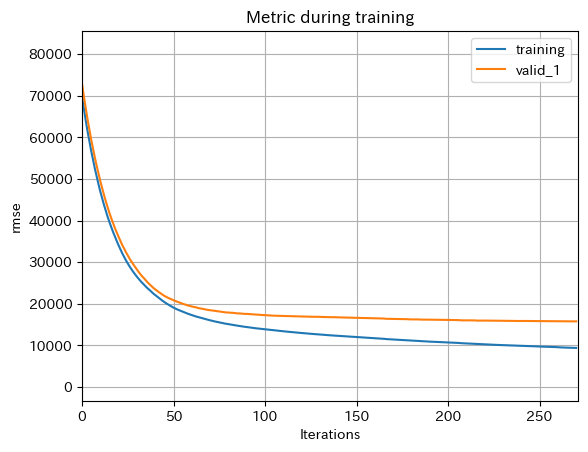

importance
面積               4.612554e+14
L                3.996675e+14
平均地価             2.029575e+14
最寄り駅             9.322865e+13
築年数              7.185109e+13
所在地              4.172913e+13
全体の階数            3.228604e+13
契約期間             1.583918e+13
所在階              9.578751e+12
所要時間             6.585534e+12
定期借家             2.112416e+12
部屋数              1.826033e+12
バス・トイレ別          1.559432e+12
建物構造             8.144534e+11
方角               5.079616e+11
D                4.592461e+11
100m^2以上         3.587608e+11
75m^2以上100m^2未満  2.851439e+11
50m^2以上75m^2未満   1.315756e+11
S                1.284887e+11

In [67]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

キッチンはやはりあったほうが良い

### GBDTにおいて、1番スコアが出るのは、「温水洗浄便座」と「方角」以外の全てを除いた場合！

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
washlets = pd.read_csv('../data/handmade_data/washlets.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48848.3	valid_1's rmse: 50202.7
[20]	training's rmse: 34646.5	valid_1's rmse: 37876.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 26245.5	valid_1's rmse: 31104.7
[40]	training's rmse: 21276.3	valid_1's rmse: 27279.9
[50]	training's rmse: 18060.4	valid_1's rmse: 24936.1
[60]	training's rmse: 16074.3	valid_1's rmse: 23477.5
[70]	training's rmse: 14668.5	valid_1's rmse: 22479.8
[80]	training's rmse: 13684.9	valid_1's rmse: 21769.6
[90]	training's rmse: 12954	valid_1's rmse: 21291.5
[100]	training's rmse: 12396.7	valid_1's rmse: 20944.8
[110]	training's rmse: 11926.2	valid_1's rmse: 20650.9
[120]	training's rmse: 11504.2	valid_1's rmse: 20355.3
[130]	training's rmse: 11145	valid_1's rmse: 20098.7
[140]	training's rmse: 10797.1	valid_1's rmse: 19885.6
[150]	training's rmse: 10494.9	valid_1's rmse: 19677.9
[160]	training's rmse: 10227.5	valid_1's rmse: 19478.6
[170]	training's rmse: 9979.45	valid_1's rmse: 19311
[180]	training's rmse: 9740.4	valid_1's rmse: 19139.3
[190]	training's rmse: 9548.97	valid_1's rmse: 18988.7
[200]	training's rmse: 9341.83	valid_1's rmse: 18843.4
[210]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48979.1	valid_1's rmse: 49307.5
[20]	training's rmse: 34961	valid_1's rmse: 35816.3
[30]	training's rmse: 26831.9	valid_1's rmse: 28282.5
[40]	training's rmse: 22083.1	valid_1's rmse: 23974.6
[50]	training's rmse: 19191.2	valid_1's rmse: 21415.6
[60]	training's rmse: 17393.1	valid_1's rmse: 20121.3
[70]	training's rmse: 16129.3	valid_1's rmse: 19246.6
[80]	training's rmse: 15179.5	valid_1's rmse: 18741
[90]	training's rmse: 14412	valid_1's rmse: 18417
[100]	training's rmse: 13779.7	valid_1's rmse: 18268.5
[110]	training's rmse: 13264.1	valid_1's rmse: 18113.8
[120]	training's rmse: 12812.9	valid_1's rmse: 17985.4
[130]	training's rmse: 12399.4	valid_1's rmse: 17943.3
[140]	training's rmse: 12024.6	valid_1's rmse: 17933.9
Early stopping, best iteration is:
[136]	training's rmse: 12165.3	valid_1's rmse: 17892.2
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48913.5	valid_1's rmse: 48850
[20]	training's rmse: 35118.9	valid_1's rmse: 34684.4
[30]	training's rmse: 26897.6	valid_1's rmse: 26875
[40]	training's rmse: 22151.2	valid_1's rmse: 22726.6
[50]	training's rmse: 19165.7	valid_1's rmse: 20374
[60]	training's rmse: 17283.9	valid_1's rmse: 19138.9
[70]	training's rmse: 16095.1	valid_1's rmse: 18512.7
[80]	training's rmse: 15147.7	valid_1's rmse: 18187
[90]	training's rmse: 14379.1	valid_1's rmse: 17895.8
[100]	training's rmse: 13770	valid_1's rmse: 17666.4
[110]	training's rmse: 13301.5	valid_1's rmse: 17520.1
[120]	training's rmse: 12839.3	valid_1's rmse: 17400.4
[130]	training's rmse: 12430.6	valid_1's rmse: 17324.9
[140]	training's rmse: 12047.8	valid_1's rmse: 17287.1
[150]	training's rmse: 11703.5	valid_1's rmse: 17229.2
[160]	training's rmse: 11372.2	valid_1's rmse: 17160.1
[170]	training's rmse: 11086.1	valid_1's rmse: 17086.4
[180]	training's rmse: 10806.8	valid_1's rmse: 17048.5
[190]	training's rmse: 10562.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 26321.6	valid_1's rmse: 29010.9
[40]	training's rmse: 21477.6	valid_1's rmse: 25602
[50]	training's rmse: 18435	valid_1's rmse: 23869.8
[60]	training's rmse: 16529.1	valid_1's rmse: 22863.9
[70]	training's rmse: 15297.2	valid_1's rmse: 22307.9
[80]	training's rmse: 14412.6	valid_1's rmse: 21919.1
[90]	training's rmse: 13719.8	valid_1's rmse: 21522.8
[100]	training's rmse: 13162	valid_1's rmse: 21273.3
[110]	training's rmse: 12709.9	valid_1's rmse: 21146
[120]	training's rmse: 12302	valid_1's rmse: 20980.7
[130]	training's rmse: 11954.8	valid_1's rmse: 20843.1
[140]	training's rmse: 11647.2	valid_1's rmse: 20698
[150]	training's rmse: 11333.3	valid_1's rmse: 20593
[160]	training's rmse: 11002.7	valid_1's rmse: 20510.8
[170]	training's rmse: 10735.7	valid_1's rmse: 20417.6
[180]	training's rmse: 10482	valid_1's rmse: 20378.9
[190]	training's rmse: 10246.3	valid_1's rmse: 20343.5
[200]	training's rmse: 10023.5	valid_1's rmse: 20323.3
[210]	training's rmse: 9817	valid

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35067.9	valid_1's rmse: 37118.8
[30]	training's rmse: 27072.4	valid_1's rmse: 28845.3
[40]	training's rmse: 22444.9	valid_1's rmse: 23806.9
[50]	training's rmse: 19335.6	valid_1's rmse: 21039.7
[60]	training's rmse: 17430.9	valid_1's rmse: 19443.9
[70]	training's rmse: 16158.4	valid_1's rmse: 18451.7
[80]	training's rmse: 15207.5	valid_1's rmse: 17903.8
[90]	training's rmse: 14501	valid_1's rmse: 17565
[100]	training's rmse: 13928.8	valid_1's rmse: 17332.1
[110]	training's rmse: 13463.7	valid_1's rmse: 17077.4
[120]	training's rmse: 13034.2	valid_1's rmse: 16953.3
[130]	training's rmse: 12660	valid_1's rmse: 16805.3
[140]	training's rmse: 12333.8	valid_1's rmse: 16694.8
[150]	training's rmse: 12042.6	valid_1's rmse: 16593.5
[160]	training's rmse: 11757.8	valid_1's rmse: 16517.3
[170]	training's rmse: 11469.5	valid_1's rmse: 16398.9
[180]	training's rmse: 11215.1	valid_1's rmse: 16254.2
[190]	training's rmse: 10984.5	valid_1's rmse: 16212.9
[200]	training's rmse: 1

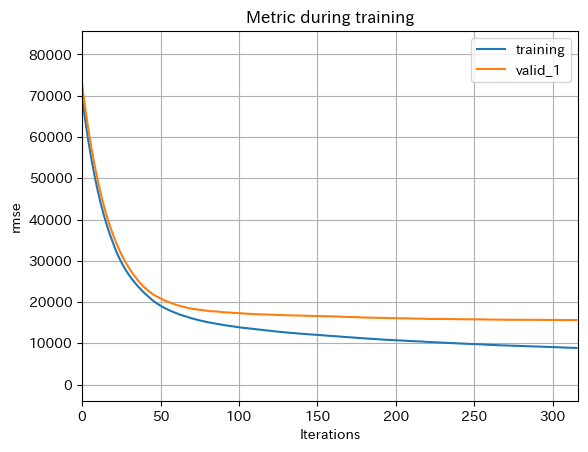

importance
面積               4.619476e+14
L                3.996708e+14
平均地価             2.031232e+14
最寄り駅             9.331244e+13
築年数              7.281202e+13
所在地              4.192739e+13
全体の階数            3.255809e+13
契約期間             1.599722e+13
所在階              9.812672e+12
所要時間             6.761601e+12
定期借家             2.218919e+12
部屋数              1.927770e+12
バス・トイレ別          1.607446e+12
建物構造             7.885001e+11
D                4.683574e+11
100m^2以上         3.107914e+11
75m^2以上100m^2未満  2.472946e+11
50m^2以上75m^2未満   1.528975e+11
S                1.455867e+11
K                4.608390e+10

In [72]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

In [73]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GBDT_cv_result.csv',index=False)

In [74]:
y_pred

0
0      130589.755353
1      121078.833036
2       75837.667015
3       56220.018554
4      116030.073369
...              ...
31257  109071.080863
31258   98006.050136
31259  176206.935536
31260  246186.920721
31261   75969.770932

[31262 rows x 1 columns]